In [3]:
# uv pip install torch transformers numpy

In [1]:
# PyTorch imports
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

# Model imports
from model import SmartContractTransformer

# Training imports
from train import SmartContractTrainer

# Optional but useful imports
import numpy as np
from tqdm import tqdm  # for progress bars
import logging 

/home/m20180848/.conda/envs/pytorch_p310/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
from transformers import AutoTokenizer
import json
import os
import pandas as pd
from typing import Dict, List, Tuple, Any
import re

- Dataset.py script:

In [3]:
print(f"CUDA is available: {torch.cuda.is_available()}")
print(f"Number of GPUs: {torch.cuda.device_count()}")

CUDA is available: True
Number of GPUs: 2


In [4]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

def parse_solidity_to_ast(code: str) -> Dict[str, Any]:
    """
    Parse Solidity code into a simplified AST structure
    """
    def extract_contract_info(code: str) -> Dict[str, Any]:
        # Extract contract name
        contract_match = re.search(r'contract\s+(\w+)', code)
        contract_name = contract_match.group(1) if contract_match else "Unknown"
        
        # Extract functions
        functions = []
        function_pattern = r'function\s+(\w+)\s*\(([^)]*)\)\s*(?:public|private|internal|external)?\s*(?:view|pure|payable)?\s*(?:returns\s*\(([^)]*)\))?\s*{'
        for match in re.finditer(function_pattern, code):
            func_name = match.group(1)
            params = match.group(2).split(',') if match.group(2) else []
            returns = match.group(3).split(',') if match.group(3) else []
            
            functions.append({
                'name': func_name,
                'parameters': [p.strip() for p in params],
                'returns': [r.strip() for r in returns]
            })
        
        # Extract state variables
        variables = []
        var_pattern = r'(?:uint|address|string|bool|mapping)\s+(?:\w+)\s+(\w+)'
        for match in re.finditer(var_pattern, code):
            variables.append(match.group(1))
        
        return {
            'type': 'Contract',
            'name': contract_name,
            'functions': functions,
            'variables': variables
        }
    
    try:
        # Clean the code
        code = re.sub(r'//.*?\n|/\*.*?\*/', '', code)  # Remove comments
        code = re.sub(r'\s+', ' ', code)  # Normalize whitespace
        
        # Parse the code
        ast = extract_contract_info(code)
        return ast
    except Exception as e:
        print(f"Error parsing code: {str(e)}")
        return None

def prepare_code2vec_input(ast: Dict[str, Any]) -> List[str]:
    """
    Convert AST to codeBert input format
    """
    paths = []
    
    def extract_paths(node: Dict[str, Any], current_path: List[str] = None):
        if current_path is None:
            current_path = []
            
        # Add current node to path
        if 'name' in node:
            current_path.append(node['name'])
            
        # Process functions
        if 'functions' in node:
            for func in node['functions']:
                func_path = current_path + [func['name']]
                paths.append(' '.join(func_path))
                
                # Add parameter paths
                for param in func['parameters']:
                    param_path = func_path + [param]
                    paths.append(' '.join(param_path))
                
                # Add return paths
                for ret in func['returns']:
                    ret_path = func_path + [ret]
                    paths.append(' '.join(ret_path))
        
        # Process variables
        if 'variables' in node:
            for var in node['variables']:
                var_path = current_path + [var]
                paths.append(' '.join(var_path))
    
    extract_paths(ast)
    return paths

class SmartContractVulnerabilityDataset(Dataset):
    def __init__(
        self,
        data_path: str,
        tokenizer: AutoTokenizer,
        max_length: int = 1024,
        split: str = "train",
        vulnerability_types: List[str] = None
    ):
        """
        Args:
            data_path: Path to the CSV file containing the dataset
            tokenizer: Tokenizer for encoding the source code
            max_length: Maximum sequence length
            split: "train" or "val" to specify which split to load
            vulnerability_types: List of vulnerability types to consider
        """
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.split = split
        self.vulnerability_types = vulnerability_types or [
            'ARTHM', 'DOS', 'LE', 'RENT', 'TimeM', 'TimeO', 'Tx-Origin', 'UE'
        ]
        
        # Load the dataset
        self.data = self._load_dataset(data_path)
        
    def _load_dataset(self, data_path: str) -> List[Dict]:
        """Load and preprocess the dataset from CSV"""
        dataset = []
        
        # Read the CSV file
        df = pd.read_csv(data_path)
        
        # Split into train/val if needed
        if self.split == "train":
            df = df.sample(frac=0.8, random_state=42)
        else:
            df = df.sample(frac=0.2, random_state=42)
        
        # Process each contract
        for _, row in df.iterrows():
            try:
                source_code = row['source_code']
                contract_name = row['contract_name']
                
                # Parse AST and get paths
                ast = parse_solidity_to_ast(source_code)
                ast_paths = prepare_code2vec_input(ast) if ast else []
                ast_path_text = ' '.join(ast_paths)
                
                # Split source code into lines
                lines = source_code.split('\n')
                
                # Create token-to-line mapping
                token_to_line = []
                current_line = 0
                
                # Tokenize each line separately to maintain mapping
                for line in lines:
                    line_tokens = self.tokenizer.encode(line, add_special_tokens=False)
                    token_to_line.extend([current_line] * len(line_tokens))
                    current_line += 1
                
                # Add special tokens
                token_to_line = [0] + token_to_line + [0]  # [CLS] and [SEP] tokens
                
                # Truncate if too long
                if len(token_to_line) > self.max_length:
                    token_to_line = token_to_line[:self.max_length]
                
                # Pad if too short
                if len(token_to_line) < self.max_length:
                    token_to_line.extend([0] * (self.max_length - len(token_to_line)))
                
                # Create multi-label line labels for each vulnerability type
                line_labels = self._create_multi_label_line_labels(source_code, row)
                
                # Create contract-level vulnerability labels
                contract_labels = self._create_contract_vulnerability_labels(row)
                
                # Tokenize the source code
                encoding = self.tokenizer(
                    source_code,
                    max_length=self.max_length,
                    padding='max_length',
                    truncation=True,
                    return_tensors='pt'
                )
                
                # Tokenize AST paths
                ast_encoding = self.tokenizer(
                    ast_path_text,
                    max_length=self.max_length,
                    padding='max_length',
                    truncation=True,
                    return_tensors='pt'
                )
                
                # Convert line labels to tensor and ensure consistent shape
                vuln_tensor = torch.zeros((len(self.vulnerability_types), self.max_length), dtype=torch.long)
                for i, labels in enumerate(line_labels):
                    if len(labels) > self.max_length:
                        labels = labels[:self.max_length]
                    vuln_tensor[i, :len(labels)] = torch.tensor(labels, dtype=torch.long)
                
                # Convert contract labels to tensor
                contract_vuln_tensor = torch.tensor(contract_labels, dtype=torch.long)
                
                # Convert token_to_line to tensor
                token_to_line_tensor = torch.tensor(token_to_line, dtype=torch.long)
                
                # Ensure attention masks are boolean
                attention_mask = encoding['attention_mask'].squeeze(0).bool()
                ast_attention_mask = ast_encoding['attention_mask'].squeeze(0).bool()
                
                # Ensure input_ids are the right length
                input_ids = encoding['input_ids'].squeeze(0)
                ast_input_ids = ast_encoding['input_ids'].squeeze(0)
                
                if len(input_ids) > self.max_length:
                    input_ids = input_ids[:self.max_length]
                if len(ast_input_ids) > self.max_length:
                    ast_input_ids = ast_input_ids[:self.max_length]
                
                # Pad if necessary
                if len(input_ids) < self.max_length:
                    input_ids = torch.nn.functional.pad(input_ids, (0, self.max_length - len(input_ids)))
                if len(ast_input_ids) < self.max_length:
                    ast_input_ids = torch.nn.functional.pad(ast_input_ids, (0, self.max_length - len(ast_input_ids)))
                
                dataset.append({
                    'input_ids': input_ids,
                    'attention_mask': attention_mask,
                    'ast_input_ids': ast_input_ids,
                    'ast_attention_mask': ast_attention_mask,
                    'vulnerable_lines': vuln_tensor,
                    'contract_vulnerabilities': contract_vuln_tensor,
                    'token_to_line': token_to_line_tensor,
                    'source_code': source_code,
                    'contract_name': contract_name
                })
            except Exception as e:
                print(f"Error processing contract {contract_name}: {str(e)}")
                continue
        
        return dataset
    
    def _create_contract_vulnerability_labels(self, row: pd.Series) -> List[int]:
        """Create contract-level vulnerability labels"""
        contract_labels = []
        for vuln_type in self.vulnerability_types:
            # Check if contract has this vulnerability type
            vuln_lines = row[f'{vuln_type}_lines']
            if isinstance(vuln_lines, str):
                try:
                    vuln_lines = eval(vuln_lines)
                except:
                    vuln_lines = [vuln_lines]
            
            # Contract is vulnerable if it has any vulnerable lines
            has_vulnerability = len(vuln_lines) > 0
            contract_labels.append(1 if has_vulnerability else 0)
        
        return contract_labels
    
    def _create_multi_label_line_labels(self, source_code: str, row: pd.Series) -> List[List[int]]:
        """Create multi-label line labels for each vulnerability type"""
        total_lines = len(source_code.split('\n'))
        line_labels = {vuln_type: [0] * total_lines for vuln_type in self.vulnerability_types}
        
        # Process each vulnerability type
        for vuln_type in self.vulnerability_types:
            vuln_lines = row[f'{vuln_type}_lines']
            if isinstance(vuln_lines, str):
                try:
                    vuln_lines = eval(vuln_lines)
                except:
                    vuln_lines = [vuln_lines]
            
            # Process each vulnerable line/snippet
            for line_or_snippet in vuln_lines:
                if isinstance(line_or_snippet, int):
                    # If it's a line number, mark that line
                    if 0 <= line_or_snippet < total_lines:
                        line_labels[vuln_type][line_or_snippet] = 1
                else:
                    # If it's a code snippet, find matching lines
                    source_lines = source_code.split('\n')
                    for i, line in enumerate(source_lines):
                        # Clean both the line and snippet for comparison
                        clean_line = re.sub(r'\s+', ' ', line.strip())
                        clean_snippet = re.sub(r'\s+', ' ', str(line_or_snippet).strip())
                        if clean_snippet in clean_line:
                            line_labels[vuln_type][i] = 1
        
        # Convert to list format
        return [line_labels[vuln_type] for vuln_type in self.vulnerability_types]
    
    def __len__(self) -> int:
        return len(self.data)
    
    def __getitem__(self, idx: int) -> Dict:
        return self.data[idx]

def custom_collate_fn(batch):
    """
    Custom collate function to handle variable length inputs
    """
    # Get the maximum length in this batch for each type of tensor
    max_input_len = max(item['input_ids'].size(0) for item in batch)
    
    # Pad all tensors to their respective maximum lengths
    padded_batch = {
        'input_ids': torch.stack([
            torch.nn.functional.pad(item['input_ids'], (0, max_input_len - item['input_ids'].size(0)))
            for item in batch
        ]),
        'attention_mask': torch.stack([
            torch.nn.functional.pad(item['attention_mask'], (0, max_input_len - item['attention_mask'].size(0)))
            for item in batch
        ]),
        'ast_input_ids': torch.stack([item['ast_input_ids'] for item in batch]),
        'ast_attention_mask': torch.stack([item['ast_attention_mask'] for item in batch]),
        'vulnerable_lines': torch.stack([item['vulnerable_lines'] for item in batch]),
        'contract_vulnerabilities': torch.stack([item['contract_vulnerabilities'] for item in batch]),
        'token_to_line': torch.stack([item['token_to_line'] for item in batch]),
        'source_code': [item['source_code'] for item in batch],
        'contract_name': [item['contract_name'] for item in batch]
    }
    
    return padded_batch

def create_dataloaders(
    data_path: str,
    tokenizer: AutoTokenizer,
    batch_size: int = 8,
    max_length: int = 1024,
    num_workers: int = 4,
    vulnerability_types: List[str] = None
) -> Tuple[torch.utils.data.DataLoader, torch.utils.data.DataLoader]:
    """
    Create train and validation dataloaders
    
    Args:
        data_path: Path to the CSV file containing the dataset
        tokenizer: Tokenizer for encoding the source code
        batch_size: Batch size for training
        max_length: Maximum sequence length
        num_workers: Number of workers for data loading
        vulnerability_types: List of vulnerability types to consider
    
    Returns:
        Tuple of (train_dataloader, val_dataloader)
    """
    # Create datasets
    train_dataset = SmartContractVulnerabilityDataset(
        data_path=data_path,
        tokenizer=tokenizer,
        max_length=max_length,
        split="train",
        vulnerability_types=vulnerability_types
    )
    
    val_dataset = SmartContractVulnerabilityDataset(
        data_path=data_path,
        tokenizer=tokenizer,
        max_length=max_length,
        split="val",
        vulnerability_types=vulnerability_types
    )
    
    # Create dataloaders with custom collate function
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        collate_fn=custom_collate_fn
    )
    
    val_dataloader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        collate_fn=custom_collate_fn
    )
    
    return train_dataloader, val_dataloader

In [5]:
from transformers import AutoTokenizer

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")

# Create dataloaders
train_dataloader, val_dataloader = create_dataloaders(
    data_path="contract_sources_with_vulnerabilities_2048_token_size.csv",
    tokenizer=tokenizer,
    batch_size=8,
    max_length=1024,
    vulnerability_types=['ARTHM', 'DOS', 'LE', 'RENT', 'TimeM', 'TimeO', 'Tx-Origin', 'UE']
)

/home/m20180848/.conda/envs/pytorch_p310/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (1211 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
model = SmartContractTransformer(use_gan=True) 

trainer = SmartContractTrainer(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    tokenizer=tokenizer,
    learning_rate=0.0001, 
    weight_decay=0.001,
    max_grad_norm=1.0,
    use_augmentation=True,
    use_gan=True
)


# Start training
trainer.train(num_epochs=200, checkpoint_dir='checkpoints_v5_2048_output')

/home/m20180848/.conda/envs/pytorch_p310/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


DEBUG: Initialized line feature extractor layer 1 with small random weights
DEBUG: Initialized line feature extractor layer 3 with small random weights
DEBUG: Initialized custom line feature extractor with small weights
✓ Syntax loss initialized with 14 keywords


/home/m20180848/.conda/envs/pytorch_p310/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
/home/m20180848/.conda/envs/pytorch_p310/lib/python3.10/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Initial learning rate: 0.0001
Data augmentation enabled
GAN training enabled - discriminator integrated into model
✓ Model has GAN discriminator components

=== Dataset Vulnerability Analysis ===
Total contracts: 2024
Total contract vulnerabilities: 3722
Total line vulnerabilities: 8848
Contract vulnerability rate: 1.8389 (183.89%)
Line vulnerability rate: 0.000534 (0.0534%)

=== Vulnerability Type Distribution ===
ARTHM: 1831 (90.46%)
DOS: 252 (12.45%)
LE: 282 (13.93%)
RENT: 731 (36.12%)
TimeM: 243 (12.01%)
TimeO: 220 (10.87%)
Tx-Origin: 0 (0.00%)
UE: 163 (8.05%)
⚠️  Extreme line vulnerability imbalance detected. Using weight: 5.0
✓ Syntax-aware loss enabled - will penalize invalid Solidity syntax

=== Model Dimension Test ===
DEBUG: Starting line aggregation...
DEBUG: batch_size=2, seq_len=1024, d_model=768
DEBUG: max_lines=100
DEBUG: token_to_line shape=torch.Size([2, 1024])
DEBUG: token_to_line sample values: [27, 38, 82, 10, 41, 85, 10, 81, 79, 57]
DEBUG: Line 0: tokens=13, featur

Epoch 0:   0%|          | 0/253 [00:00<?, ?it/s]


=== Line Vulnerability Debug (Batch 0) ===
Line vuln logits shape: torch.Size([8, 1024, 8])
Line vuln logits range: [-0.797258, 0.000000]
Line vuln logits mean: -0.044765
Line vuln logits std: 0.143384
Vulnerable lines shape: torch.Size([8, 8, 1024])
Vulnerable lines sum: 21
Vulnerable lines range: [0.0, 1.0]
⚠️  No predictions with threshold 0.500000, using fallback threshold 0.250000
Fallback predictions: 65536.0
Line vuln probs range: [0.310612, 0.500000]
Adaptive threshold: 0.500000
Line vuln preds sum: 65536.0
Line vuln preds shape: torch.Size([8, 1024, 8])
Top 1% probability: 0.500000
Top 0.5% probability: 0.500000
Top 0.1% probability: 0.500000
Warm-up factor: 0.200, Adjusted weight: 1.0
Probabilities above threshold: 0
Threshold selection: min=0.500000, max=0.6, final=0.500000
Stability factor: 1.000
Correct predictions: 21
Total vulnerable: 21
Predicted vulnerable: 65536.0
Line accuracy: 0.0003
Line precision: 0.0003
Line recall: 1.0000


Epoch 0: 100%|██████████| 253/253 [11:51<00:00,  2.81s/it, gen_loss=8.7486, contract_vuln_loss=0.0017, line_vuln_loss=0.023067, line_acc=0.117, line_prec=0.000, line_rec=0.158, lr=0.000100, grad_norm=1.00, aug=ON, gan=ON, disc_loss=0.6000, disc_conf=0.549, line_weight=5, contract_weight=3, syntax=1.2200, loss_scale=1.00, stab_factor=1.00] 


Train Loss: 10.5204
Val Loss: 8.8108
Contract Vulnerability Loss: 0.0020
Line Vulnerability Loss: 0.023171
Line Accuracy: 0.1173
Line Precision: 0.0001
Line Recall: 0.1579
Discriminator Loss: 0.6480
Syntax Loss: 1.2840
Learning Rate: 0.000100
🎉 New best validation loss! Saved checkpoint to checkpoints_v5_2048_output/best_model_augmented_gan_epoch_1.pt
Line-level performance: Acc=0.1173, Prec=0.0001, Rec=0.1579

Epoch 2/200


Epoch 1:   0%|          | 0/253 [00:00<?, ?it/s]


=== Line Vulnerability Debug (Batch 0) ===
Line vuln logits shape: torch.Size([8, 1024, 8])
Line vuln logits range: [-8.899872, 0.000000]
Line vuln logits mean: -0.637441
Line vuln logits std: 1.778081
Vulnerable lines shape: torch.Size([8, 8, 1024])
Vulnerable lines sum: 30
Vulnerable lines range: [0.0, 1.0]
⚠️  No predictions with threshold 0.500000, using fallback threshold 0.250000
Fallback predictions: 57053.0
Line vuln probs range: [0.000136, 0.500000]
Adaptive threshold: 0.500000
Line vuln preds sum: 57053.0
Line vuln preds shape: torch.Size([8, 1024, 8])
Top 1% probability: 0.500000
Top 0.5% probability: 0.500000
Top 0.1% probability: 0.500000
Warm-up factor: 0.400, Adjusted weight: 2.0
Probabilities above threshold: 0
Threshold selection: min=0.500000, max=0.6, final=0.500000
Stability factor: 1.000
Correct predictions: 2
Total vulnerable: 30
Predicted vulnerable: 57053.0
Line accuracy: 0.1290
Line precision: 0.0000
Line recall: 0.0667


Epoch 1:  70%|██████▉   | 177/253 [08:21<03:35,  2.83s/it, gen_loss=5.5781, contract_vuln_loss=0.0018, line_vuln_loss=0.023967, line_acc=0.091, line_prec=0.000, line_rec=0.280, lr=0.000100, grad_norm=1.00, aug=ON, gan=ON, disc_loss=0.5264, disc_conf=0.591, line_weight=5, contract_weight=3, syntax=1.2877, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 1: 100%|██████████| 253/253 [11:55<00:00,  2.83s/it, gen_loss=4.7743, contract_vuln_loss=0.0019, line_vuln_loss=0.023785, line_acc=0.999, line_prec=1.000, line_rec=0.024, lr=0.000100, grad_norm=0.83, aug=ON, gan=ON, disc_loss=0.4937, disc_conf=0.610, line_weight=5, contract_weight=3, syntax=1.3623, loss_scale=1.00, stab_factor=1.00]


Train Loss: 6.6510
Val Loss: 4.8126
Contract Vulnerability Loss: 0.0017
Line Vulnerability Loss: 0.023092
Line Accuracy: 0.9994
Line Precision: 1.0000
Line Recall: 0.0238
Discriminator Loss: 0.5468
Syntax Loss: 1.2883
Learning Rate: 0.000100
⚠️  High precision (1.000) but very low recall (0.024)
Adjusting loss to improve recall...
🎉 New best validation loss! Saved checkpoint to checkpoints_v5_2048_output/best_model_augmented_gan_epoch_2.pt
Line-level performance: Acc=0.9994, Prec=1.0000, Rec=0.0238

Epoch 3/200


Epoch 2:   0%|          | 0/253 [00:00<?, ?it/s]


=== Line Vulnerability Debug (Batch 0) ===
Line vuln logits shape: torch.Size([8, 1024, 8])
Line vuln logits range: [-11.976054, 0.000000]
Line vuln logits mean: -0.563446
Line vuln logits std: 1.835369
Vulnerable lines shape: torch.Size([8, 8, 1024])
Vulnerable lines sum: 39
Vulnerable lines range: [0.0, 1.0]
⚠️  No predictions with threshold 0.500000, using fallback threshold 0.250000
Fallback predictions: 58877.0
Line vuln probs range: [0.000006, 0.500000]
Adaptive threshold: 0.500000
Line vuln preds sum: 58877.0
Line vuln preds shape: torch.Size([8, 1024, 8])
Top 1% probability: 0.500000
Top 0.5% probability: 0.500000
Top 0.1% probability: 0.500000
Warm-up factor: 0.600, Adjusted weight: 3.0
Probabilities above threshold: 0
Threshold selection: min=0.500000, max=0.6, final=0.500000
Stability factor: 1.000
Correct predictions: 20
Total vulnerable: 39
Predicted vulnerable: 58877.0
Line accuracy: 0.1016
Line precision: 0.0003
Line recall: 0.5128


Epoch 2:  64%|██████▍   | 162/253 [07:38<04:12,  2.78s/it, gen_loss=4.4623, contract_vuln_loss=0.0020, line_vuln_loss=0.023068, line_acc=0.103, line_prec=0.000, line_rec=0.345, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=0.4126, disc_conf=0.662, line_weight=5, contract_weight=3, syntax=1.2737, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 2:  76%|███████▌  | 192/253 [09:01<02:52,  2.82s/it, gen_loss=4.2595, contract_vuln_loss=0.0014, line_vuln_loss=0.023853, line_acc=0.091, line_prec=0.000, line_rec=0.360, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.4022, disc_conf=0.669, line_weight=5, contract_weight=3, syntax=1.2093, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 2:  76%|███████▋  | 193/253 [09:04<02:53,  2.88s/it, gen_loss=3.9204, contract_vuln_loss=0.0015, line_vuln_loss=0.022041, line_acc=0.160, line_prec=0.000, line_rec=0.368, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.4079, disc_conf=0.665, line_weight=5, contract_weight=3, syntax=1.3402, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 2:  87%|████████▋ | 221/253 [10:24<01:31,  2.85s/it, gen_loss=3.5781, contract_vuln_loss=0.0013, line_vuln_loss=0.023642, line_acc=0.084, line_prec=0.000, line_rec=0.515, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.3930, disc_conf=0.675, line_weight=5, contract_weight=3, syntax=1.3115, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 2:  96%|█████████▋| 244/253 [11:29<00:24,  2.78s/it, gen_loss=3.8566, contract_vuln_loss=0.0017, line_vuln_loss=0.023250, line_acc=0.112, line_prec=0.000, line_rec=0.333, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.3799, disc_conf=0.684, line_weight=5, contract_weight=3, syntax=1.2949, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 2: 100%|██████████| 253/253 [11:55<00:00,  2.83s/it, gen_loss=3.6358, contract_vuln_loss=0.0014, line_vuln_loss=0.023521, line_acc=0.092, line_prec=0.000, line_rec=0.641, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.3759, disc_conf=0.687, line_weight=5, contract_weight=3, syntax=1.3143, loss_scale=1.00, stab_factor=1.00]


Train Loss: 4.2825
Val Loss: 4.1043
Contract Vulnerability Loss: 0.0017
Line Vulnerability Loss: 0.023057
Line Accuracy: 0.0924
Line Precision: 0.0004
Line Recall: 0.6410
Discriminator Loss: 0.4335
Syntax Loss: 1.2854
Learning Rate: 0.000100
🎉 New best validation loss! Saved checkpoint to checkpoints_v5_2048_output/best_model_augmented_gan_epoch_3.pt
Line-level performance: Acc=0.0924, Prec=0.0004, Rec=0.6410

Epoch 4/200


Epoch 3:   0%|          | 0/253 [00:00<?, ?it/s]


=== Line Vulnerability Debug (Batch 0) ===
Line vuln logits shape: torch.Size([8, 1024, 8])
Line vuln logits range: [-18.708670, 0.000000]
Line vuln logits mean: -0.715477
Line vuln logits std: 2.420249
Vulnerable lines shape: torch.Size([8, 8, 1024])
Vulnerable lines sum: 26
Vulnerable lines range: [0.0, 1.0]
⚠️  No predictions with threshold 0.500000, using fallback threshold 0.250000
Fallback predictions: 58812.0
Line vuln probs range: [0.000000, 0.500000]
Adaptive threshold: 0.500000
Line vuln preds sum: 58812.0
Line vuln preds shape: torch.Size([8, 1024, 8])
Top 1% probability: 0.500000
Top 0.5% probability: 0.500000
Top 0.1% probability: 0.500000
Warm-up factor: 0.800, Adjusted weight: 4.0
Probabilities above threshold: 0
Threshold selection: min=0.500000, max=0.6, final=0.500000
Stability factor: 1.000
Correct predictions: 7
Total vulnerable: 26
Predicted vulnerable: 58812.0
Line accuracy: 0.1024
Line precision: 0.0001
Line recall: 0.2692


Epoch 3:  17%|█▋        | 44/253 [02:04<09:51,  2.83s/it, gen_loss=4.5555, contract_vuln_loss=0.0010, line_vuln_loss=0.022887, line_acc=0.117, line_prec=0.000, line_rec=0.500, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.3603, disc_conf=0.697, line_weight=5, contract_weight=3, syntax=1.5885, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 3:  37%|███▋      | 94/253 [04:27<07:28,  2.82s/it, gen_loss=3.6218, contract_vuln_loss=0.0010, line_vuln_loss=0.024027, line_acc=0.086, line_prec=0.000, line_rec=0.389, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.3448, disc_conf=0.708, line_weight=5, contract_weight=3, syntax=1.2622, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 3:  53%|█████▎    | 134/253 [06:19<05:29,  2.77s/it, gen_loss=4.2233, contract_vuln_loss=0.0014, line_vuln_loss=0.022257, line_acc=0.121, line_prec=0.000, line_rec=0.345, lr=0.000100, grad_norm=0.71, aug=ON, gan=ON, disc_loss=0.3205, disc_conf=0.726, line_weight=5, contract_weight=3, syntax=1.2235, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 3:  54%|█████▍    | 137/253 [06:27<05:27,  2.82s/it, gen_loss=3.6543, contract_vuln_loss=0.0013, line_vuln_loss=0.022837, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.14, aug=ON, gan=ON, disc_loss=0.3182, disc_conf=0.728, line_weight=5, contract_weight=3, syntax=1.7263, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 3:  61%|██████▏   | 155/253 [07:18<04:42,  2.89s/it, gen_loss=2.7182, contract_vuln_loss=0.0018, line_vuln_loss=0.024486, line_acc=1.000, line_prec=1.000, line_rec=0.061, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.3177, disc_conf=0.728, line_weight=5, contract_weight=3, syntax=1.2281, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 3:  65%|██████▌   | 165/253 [07:47<04:10,  2.84s/it, gen_loss=3.6223, contract_vuln_loss=0.0014, line_vuln_loss=0.023652, line_acc=0.106, line_prec=0.000, line_rec=0.375, lr=0.000100, grad_norm=0.12, aug=ON, gan=ON, disc_loss=0.3143, disc_conf=0.730, line_weight=5, contract_weight=3, syntax=1.2978, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 3:  66%|██████▌   | 166/253 [07:50<04:07,  2.84s/it, gen_loss=4.2246, contract_vuln_loss=0.0015, line_vuln_loss=0.022304, line_acc=0.130, line_prec=0.000, line_rec=0.368, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.3086, disc_conf=0.735, line_weight=5, contract_weight=3, syntax=1.2055, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 3:  73%|███████▎  | 184/253 [08:40<03:08,  2.73s/it, gen_loss=3.3736, contract_vuln_loss=0.0012, line_vuln_loss=0.022655, line_acc=0.109, line_prec=0.000, line_rec=0.700, lr=0.000100, grad_norm=0.17, aug=ON, gan=ON, disc_loss=0.3037, disc_conf=0.738, line_weight=5, contract_weight=3, syntax=1.3690, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 3:  94%|█████████▍| 239/253 [11:15<00:39,  2.82s/it, gen_loss=3.1755, contract_vuln_loss=0.0017, line_vuln_loss=0.023960, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.16, aug=ON, gan=ON, disc_loss=0.2802, disc_conf=0.756, line_weight=5, contract_weight=3, syntax=1.1882, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 3: 100%|██████████| 253/253 [11:55<00:00,  2.83s/it, gen_loss=3.9446, contract_vuln_loss=0.0013, line_vuln_loss=0.023546, line_acc=0.090, line_prec=0.000, line_rec=0.396, lr=0.000100, grad_norm=0.97, aug=ON, gan=ON, disc_loss=0.2693, disc_conf=0.764, line_weight=5, contract_weight=3, syntax=1.3765, loss_scale=1.00, stab_factor=1.00]


Train Loss: 3.8195
Val Loss: 3.5692
Contract Vulnerability Loss: 0.0017
Line Vulnerability Loss: 0.023082
Line Accuracy: 0.0903
Line Precision: 0.0003
Line Recall: 0.3958
Discriminator Loss: 0.3255
Syntax Loss: 1.2897
Learning Rate: 0.000100
🎉 New best validation loss! Saved checkpoint to checkpoints_v5_2048_output/best_model_augmented_gan_epoch_4.pt
Line-level performance: Acc=0.0903, Prec=0.0003, Rec=0.3958

Epoch 5/200


Epoch 4:   0%|          | 0/253 [00:00<?, ?it/s]


=== Line Vulnerability Debug (Batch 0) ===
Line vuln logits shape: torch.Size([8, 1024, 8])
Line vuln logits range: [-21.206013, 0.000000]
Line vuln logits mean: -0.874337
Line vuln logits std: 2.813286
Vulnerable lines shape: torch.Size([8, 8, 1024])
Vulnerable lines sum: 41
Vulnerable lines range: [0.0, 1.0]
⚠️  No predictions with threshold 0.500000, using fallback threshold 0.250000
Fallback predictions: 57793.0
Line vuln probs range: [0.000000, 0.500000]
Adaptive threshold: 0.500000
Line vuln preds sum: 57793.0
Line vuln preds shape: torch.Size([8, 1024, 8])
Top 1% probability: 0.500000
Top 0.5% probability: 0.500000
Top 0.1% probability: 0.500000
Warm-up factor: 1.000, Adjusted weight: 5.0
Probabilities above threshold: 0
Threshold selection: min=0.500000, max=0.6, final=0.500000
Stability factor: 1.000
Correct predictions: 17
Total vulnerable: 41
Predicted vulnerable: 57793.0
Line accuracy: 0.1180
Line precision: 0.0003
Line recall: 0.4146


Epoch 4:   6%|▋         | 16/253 [00:45<11:16,  2.86s/it, gen_loss=2.2542, contract_vuln_loss=0.0016, line_vuln_loss=0.023398, line_acc=0.118, line_prec=0.000, line_rec=0.407, lr=0.000100, grad_norm=1.00, aug=ON, gan=ON, disc_loss=0.2707, disc_conf=0.763, line_weight=5, contract_weight=3, syntax=1.4273, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 4:  12%|█▏        | 30/253 [01:25<10:27,  2.82s/it, gen_loss=3.4220, contract_vuln_loss=0.0023, line_vuln_loss=0.022581, line_acc=0.129, line_prec=0.000, line_rec=0.232, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2702, disc_conf=0.763, line_weight=5, contract_weight=3, syntax=1.2388, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 4:  18%|█▊        | 46/253 [02:10<09:23,  2.72s/it, gen_loss=3.2139, contract_vuln_loss=0.0017, line_vuln_loss=0.023226, line_acc=0.094, line_prec=0.000, line_rec=0.289, lr=0.000100, grad_norm=0.59, aug=ON, gan=ON, disc_loss=0.2571, disc_conf=0.773, line_weight=5, contract_weight=3, syntax=1.2931, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 4:  29%|██▉       | 73/253 [03:25<08:29,  2.83s/it, gen_loss=3.8611, contract_vuln_loss=0.0014, line_vuln_loss=0.023157, line_acc=0.105, line_prec=0.000, line_rec=0.618, lr=0.000100, grad_norm=0.98, aug=ON, gan=ON, disc_loss=0.2509, disc_conf=0.778, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 4:  44%|████▍     | 111/253 [05:11<06:45,  2.86s/it, gen_loss=2.6473, contract_vuln_loss=0.0021, line_vuln_loss=0.023273, line_acc=0.111, line_prec=0.000, line_rec=0.200, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2382, disc_conf=0.788, line_weight=5, contract_weight=3, syntax=1.1964, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 4:  46%|████▌     | 117/253 [05:28<06:14,  2.75s/it, gen_loss=3.3681, contract_vuln_loss=0.0017, line_vuln_loss=0.022411, line_acc=0.115, line_prec=0.000, line_rec=0.229, lr=0.000100, grad_norm=0.13, aug=ON, gan=ON, disc_loss=0.2318, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.3396, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 4:  52%|█████▏    | 131/253 [06:07<05:39,  2.78s/it, gen_loss=3.3328, contract_vuln_loss=0.0017, line_vuln_loss=0.023021, line_acc=0.119, line_prec=0.000, line_rec=0.176, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1594, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 4:  58%|█████▊    | 147/253 [06:51<04:55,  2.79s/it, gen_loss=3.5991, contract_vuln_loss=0.0014, line_vuln_loss=0.022760, line_acc=0.114, line_prec=0.000, line_rec=0.357, lr=0.000100, grad_norm=0.94, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3992, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 4:  81%|████████  | 205/253 [09:36<02:14,  2.80s/it, gen_loss=3.6029, contract_vuln_loss=0.0021, line_vuln_loss=0.022778, line_acc=0.117, line_prec=0.000, line_rec=0.400, lr=0.000100, grad_norm=0.66, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1463, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 4:  83%|████████▎ | 210/253 [09:50<01:58,  2.75s/it, gen_loss=3.3686, contract_vuln_loss=0.0009, line_vuln_loss=0.023060, line_acc=0.094, line_prec=0.000, line_rec=0.368, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2309, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.4737, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 4:  91%|█████████ | 230/253 [10:45<01:02,  2.74s/it, gen_loss=2.7875, contract_vuln_loss=0.0014, line_vuln_loss=0.021975, line_acc=0.116, line_prec=0.000, line_rec=0.531, lr=0.000100, grad_norm=0.82, aug=ON, gan=ON, disc_loss=0.2239, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4206, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 4:  97%|█████████▋| 246/253 [11:30<00:19,  2.84s/it, gen_loss=2.8517, contract_vuln_loss=0.0022, line_vuln_loss=0.023713, line_acc=0.101, line_prec=0.000, line_rec=0.275, lr=0.000100, grad_norm=0.88, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1618, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 4: 100%|██████████| 253/253 [11:50<00:00,  2.81s/it, gen_loss=3.8657, contract_vuln_loss=0.0021, line_vuln_loss=0.022883, line_acc=0.111, line_prec=0.000, line_rec=0.184, lr=0.000100, grad_norm=1.00, aug=ON, gan=ON, disc_loss=0.2320, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.1455, loss_scale=1.00, stab_factor=1.00]


Train Loss: 3.4110
Val Loss: 3.1829
Contract Vulnerability Loss: 0.0016
Line Vulnerability Loss: 0.023089
Line Accuracy: 0.1114
Line Precision: 0.0002
Line Recall: 0.1837
Discriminator Loss: 0.3960
Syntax Loss: 1.2919
Learning Rate: 0.000100
🎉 New best validation loss! Saved checkpoint to checkpoints_v5_2048_output/best_model_augmented_gan_epoch_5.pt
Line-level performance: Acc=0.1114, Prec=0.0002, Rec=0.1837

Epoch 6/200


Epoch 5:   0%|          | 0/253 [00:00<?, ?it/s]


=== Line Vulnerability Debug (Batch 0) ===
Line vuln logits shape: torch.Size([8, 1024, 8])
Line vuln logits range: [-22.529438, 0.000000]
Line vuln logits mean: -0.841679
Line vuln logits std: 2.853068
Vulnerable lines shape: torch.Size([8, 8, 1024])
Vulnerable lines sum: 26
Vulnerable lines range: [0.0, 1.0]
⚠️  OSCILLATION DETECTED!
Mean change: 0.842 (0.000 → -0.842)
Std change: 2.853 (0.000 → 2.853)
Reduced line loss scale to: 0.500
Reduced stability factor to: 0.700
⚠️  No predictions with threshold 0.500000, using fallback threshold 0.250000
Fallback predictions: 58355.0
Line vuln probs range: [0.000000, 0.500000]
Adaptive threshold: 0.500000
Line vuln preds sum: 58355.0
Line vuln preds shape: torch.Size([8, 1024, 8])
Top 1% probability: 0.500000
Top 0.5% probability: 0.500000
Top 0.1% probability: 0.500000
Warm-up factor: 1.000, Adjusted weight: 5.0
Probabilities above threshold: 0
Threshold selection: min=0.500000, max=0.6, final=0.500000
Stability factor: 0.700
Correct predi

Epoch 5:   1%|          | 2/253 [00:06<12:56,  3.09s/it, gen_loss=3.1605, contract_vuln_loss=0.0018, line_vuln_loss=0.023895, line_acc=0.999, line_prec=1.000, line_rec=0.051, lr=0.000100, grad_norm=0.83, aug=ON, gan=ON, disc_loss=1.6845, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1447, loss_scale=0.50, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 5:   9%|▊         | 22/253 [01:02<10:56,  2.84s/it, gen_loss=1.9507, contract_vuln_loss=0.0024, line_vuln_loss=0.023315, line_acc=0.118, line_prec=0.000, line_rec=0.160, lr=0.000100, grad_norm=1.00, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2432, loss_scale=0.50, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 5:  21%|██        | 53/253 [02:30<09:39,  2.90s/it, gen_loss=2.3113, contract_vuln_loss=0.0016, line_vuln_loss=0.023460, line_acc=0.119, line_prec=0.000, line_rec=0.500, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2286, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3712, loss_scale=0.50, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 5:  25%|██▍       | 62/253 [02:55<09:07,  2.86s/it, gen_loss=2.9127, contract_vuln_loss=0.0017, line_vuln_loss=0.023167, line_acc=0.999, line_prec=1.000, line_rec=0.044, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3908, loss_scale=0.50, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 5:  34%|███▎      | 85/253 [04:00<07:58,  2.85s/it, gen_loss=2.8196, contract_vuln_loss=0.0023, line_vuln_loss=0.023678, line_acc=0.108, line_prec=0.000, line_rec=0.353, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2160, loss_scale=0.50, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 5:  36%|███▋      | 92/253 [04:20<07:36,  2.83s/it, gen_loss=2.6010, contract_vuln_loss=0.0017, line_vuln_loss=0.022740, line_acc=0.114, line_prec=0.000, line_rec=0.312, lr=0.000100, grad_norm=0.73, aug=ON, gan=ON, disc_loss=1.6853, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2143, loss_scale=0.50, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 5:  43%|████▎     | 109/253 [05:09<06:42,  2.80s/it, gen_loss=3.7916, contract_vuln_loss=0.0020, line_vuln_loss=0.023149, line_acc=0.100, line_prec=0.000, line_rec=0.222, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3557, loss_scale=0.50, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 5:  47%|████▋     | 119/253 [05:37<06:18,  2.82s/it, gen_loss=2.9310, contract_vuln_loss=0.0020, line_vuln_loss=0.022928, line_acc=0.117, line_prec=0.000, line_rec=0.462, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2328, loss_scale=0.50, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 5:  47%|████▋     | 120/253 [05:40<06:18,  2.85s/it, gen_loss=3.7384, contract_vuln_loss=0.0015, line_vuln_loss=0.022324, line_acc=0.132, line_prec=0.000, line_rec=0.367, lr=0.000100, grad_norm=1.00, aug=ON, gan=ON, disc_loss=1.6829, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=0.50, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 5:  48%|████▊     | 121/253 [05:43<06:26,  2.93s/it, gen_loss=3.2736, contract_vuln_loss=0.0016, line_vuln_loss=0.023301, line_acc=0.132, line_prec=0.000, line_rec=0.500, lr=0.000100, grad_norm=0.63, aug=ON, gan=ON, disc_loss=1.6843, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4278, loss_scale=0.50, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 5:  54%|█████▍    | 136/253 [06:25<05:26,  2.79s/it, gen_loss=3.3521, contract_vuln_loss=0.0018, line_vuln_loss=0.023172, line_acc=0.104, line_prec=0.000, line_rec=0.258, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2299, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2361, loss_scale=0.50, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 5:  63%|██████▎   | 160/253 [07:33<04:16,  2.76s/it, gen_loss=3.0362, contract_vuln_loss=0.0018, line_vuln_loss=0.023785, line_acc=0.086, line_prec=0.000, line_rec=0.400, lr=0.000100, grad_norm=0.68, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2063, loss_scale=0.50, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 5:  67%|██████▋   | 169/253 [07:58<03:51,  2.75s/it, gen_loss=3.5766, contract_vuln_loss=0.0029, line_vuln_loss=0.023908, line_acc=0.081, line_prec=0.000, line_rec=0.444, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=0.2347, disc_conf=0.791, line_weight=5, contract_weight=3, syntax=1.2733, loss_scale=0.50, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 5:  68%|██████▊   | 173/253 [08:09<03:47,  2.84s/it, gen_loss=3.1637, contract_vuln_loss=0.0020, line_vuln_loss=0.024248, line_acc=0.999, line_prec=1.000, line_rec=0.054, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2282, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1571, loss_scale=0.50, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 5:  70%|██████▉   | 176/253 [08:17<03:36,  2.81s/it, gen_loss=4.5815, contract_vuln_loss=0.0022, line_vuln_loss=0.022635, line_acc=0.109, line_prec=0.000, line_rec=0.156, lr=0.000100, grad_norm=1.00, aug=ON, gan=ON, disc_loss=0.2303, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=0.50, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 5:  70%|███████   | 178/253 [08:23<03:29,  2.80s/it, gen_loss=2.8451, contract_vuln_loss=0.0015, line_vuln_loss=0.023415, line_acc=0.102, line_prec=0.000, line_rec=0.286, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3036, loss_scale=0.50, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 5:  71%|███████   | 179/253 [08:26<03:32,  2.87s/it, gen_loss=2.1132, contract_vuln_loss=0.0018, line_vuln_loss=0.020604, line_acc=0.201, line_prec=0.000, line_rec=0.483, lr=0.000100, grad_norm=0.69, aug=ON, gan=ON, disc_loss=0.2282, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=0.50, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 5:  80%|████████  | 203/253 [09:33<02:22,  2.86s/it, gen_loss=3.7526, contract_vuln_loss=0.0019, line_vuln_loss=0.023854, line_acc=0.114, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=1.00, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2066, loss_scale=0.50, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 5:  82%|████████▏ | 207/253 [09:45<02:14,  2.92s/it, gen_loss=3.0864, contract_vuln_loss=0.0013, line_vuln_loss=0.023332, line_acc=0.118, line_prec=0.000, line_rec=0.304, lr=0.000100, grad_norm=1.00, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2159, loss_scale=0.50, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 5:  83%|████████▎ | 211/253 [09:56<01:56,  2.78s/it, gen_loss=3.3482, contract_vuln_loss=0.0013, line_vuln_loss=0.022514, line_acc=0.108, line_prec=0.000, line_rec=0.438, lr=0.000100, grad_norm=1.00, aug=ON, gan=ON, disc_loss=1.6894, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1412, loss_scale=0.50, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 5:  85%|████████▍ | 215/253 [10:08<01:46,  2.81s/it, gen_loss=3.1749, contract_vuln_loss=0.0013, line_vuln_loss=0.023284, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.97, aug=ON, gan=ON, disc_loss=1.6849, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2419, loss_scale=0.50, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 5:  86%|████████▌ | 217/253 [10:13<01:41,  2.81s/it, gen_loss=1.7228, contract_vuln_loss=0.0012, line_vuln_loss=0.023694, line_acc=0.098, line_prec=0.000, line_rec=0.696, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.5882, loss_scale=0.50, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 5:  89%|████████▊ | 224/253 [10:33<01:22,  2.85s/it, gen_loss=3.2700, contract_vuln_loss=0.0012, line_vuln_loss=0.023236, line_acc=0.115, line_prec=0.000, line_rec=0.371, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4850, loss_scale=0.50, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 5:  92%|█████████▏| 233/253 [10:58<00:56,  2.82s/it, gen_loss=2.3117, contract_vuln_loss=0.0031, line_vuln_loss=0.023105, line_acc=0.106, line_prec=0.000, line_rec=0.278, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3000, loss_scale=0.50, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 5: 100%|██████████| 253/253 [11:55<00:00,  2.83s/it, gen_loss=3.0327, contract_vuln_loss=0.0023, line_vuln_loss=0.023355, line_acc=0.083, line_prec=0.000, line_rec=0.364, lr=0.000100, grad_norm=0.68, aug=ON, gan=ON, disc_loss=1.6875, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2188, loss_scale=0.50, stab_factor=0.70]


Train Loss: 3.1089
Val Loss: 2.8530
Contract Vulnerability Loss: 0.0016
Line Vulnerability Loss: 0.023088
Line Accuracy: 0.0831
Line Precision: 0.0003
Line Recall: 0.3636
Discriminator Loss: 0.5682
Syntax Loss: 1.2919
Learning Rate: 0.000100
🎉 New best validation loss! Saved checkpoint to checkpoints_v5_2048_output/best_model_augmented_gan_epoch_6.pt
Line-level performance: Acc=0.0831, Prec=0.0003, Rec=0.3636

Epoch 7/200


Epoch 6:   0%|          | 0/253 [00:00<?, ?it/s]


=== Line Vulnerability Debug (Batch 0) ===
Line vuln logits shape: torch.Size([8, 1024, 8])
Line vuln logits range: [-22.796848, 0.000000]
Line vuln logits mean: -0.822507
Line vuln logits std: 2.740363
Vulnerable lines shape: torch.Size([8, 8, 1024])
Vulnerable lines sum: 37
Vulnerable lines range: [0.0, 1.0]
⚠️  No predictions with threshold 0.500000, using fallback threshold 0.250000
Fallback predictions: 57957.0
Line vuln probs range: [0.000000, 0.500000]
Adaptive threshold: 0.500000
Line vuln preds sum: 57957.0
Line vuln preds shape: torch.Size([8, 1024, 8])
Top 1% probability: 0.500000
Top 0.5% probability: 0.500000
Top 0.1% probability: 0.500000
Warm-up factor: 1.000, Adjusted weight: 1.8
Probabilities above threshold: 0
Threshold selection: min=0.500000, max=0.6, final=0.500000
Stability factor: 0.700
Correct predictions: 23
Total vulnerable: 37
Predicted vulnerable: 57957.0
Line accuracy: 0.1158
Line precision: 0.0004
Line recall: 0.6216


Epoch 6:   2%|▏         | 4/253 [00:12<12:25,  2.99s/it, gen_loss=3.0852, contract_vuln_loss=0.0014, line_vuln_loss=0.023057, line_acc=0.120, line_prec=0.000, line_rec=0.264, lr=0.000100, grad_norm=1.00, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4217, loss_scale=0.50, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 6:   5%|▍         | 12/253 [00:35<11:24,  2.84s/it, gen_loss=2.4447, contract_vuln_loss=0.0014, line_vuln_loss=0.022870, line_acc=0.102, line_prec=0.000, line_rec=0.395, lr=0.000100, grad_norm=1.00, aug=ON, gan=ON, disc_loss=0.2297, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2536, loss_scale=0.50, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 6:   8%|▊         | 20/253 [00:58<11:02,  2.84s/it, gen_loss=2.6438, contract_vuln_loss=0.0015, line_vuln_loss=0.023194, line_acc=0.108, line_prec=0.000, line_rec=0.280, lr=0.000100, grad_norm=0.66, aug=ON, gan=ON, disc_loss=0.2323, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.6352, loss_scale=0.50, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 6:  12%|█▏        | 30/253 [01:26<10:28,  2.82s/it, gen_loss=3.7555, contract_vuln_loss=0.0017, line_vuln_loss=0.022870, line_acc=0.102, line_prec=0.000, line_rec=0.316, lr=0.000100, grad_norm=1.00, aug=ON, gan=ON, disc_loss=1.6930, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2700, loss_scale=0.50, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 6:  12%|█▏        | 31/253 [01:29<10:28,  2.83s/it, gen_loss=2.6936, contract_vuln_loss=0.0013, line_vuln_loss=0.021950, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.67, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4492, loss_scale=0.50, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 6:  16%|█▌        | 40/253 [01:54<09:55,  2.80s/it, gen_loss=2.2674, contract_vuln_loss=0.0020, line_vuln_loss=0.023017, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3158, loss_scale=0.50, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 6:  17%|█▋        | 44/253 [02:05<09:36,  2.76s/it, gen_loss=2.6789, contract_vuln_loss=0.0016, line_vuln_loss=0.023624, line_acc=0.095, line_prec=0.000, line_rec=0.269, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=1.6883, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1957, loss_scale=0.50, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 6:  21%|██        | 52/253 [02:27<09:21,  2.79s/it, gen_loss=3.9339, contract_vuln_loss=0.0019, line_vuln_loss=0.022686, line_acc=0.117, line_prec=0.000, line_rec=0.333, lr=0.000100, grad_norm=0.61, aug=ON, gan=ON, disc_loss=0.2310, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3286, loss_scale=0.50, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 6:  26%|██▌       | 66/253 [03:08<08:55,  2.87s/it, gen_loss=2.8183, contract_vuln_loss=0.0015, line_vuln_loss=0.023904, line_acc=0.101, line_prec=0.000, line_rec=0.606, lr=0.000100, grad_norm=0.64, aug=ON, gan=ON, disc_loss=1.6841, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2078, loss_scale=0.50, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 6:  33%|███▎      | 83/253 [03:56<08:05,  2.86s/it, gen_loss=3.1684, contract_vuln_loss=0.0012, line_vuln_loss=0.023877, line_acc=0.106, line_prec=0.000, line_rec=0.615, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2239, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1927, loss_scale=0.50, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 6:  37%|███▋      | 93/253 [04:25<07:40,  2.88s/it, gen_loss=2.5129, contract_vuln_loss=0.0015, line_vuln_loss=0.023830, line_acc=0.999, line_prec=1.000, line_rec=0.026, lr=0.000100, grad_norm=0.78, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.5133, loss_scale=0.50, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 6:  59%|█████▉    | 150/253 [07:06<04:49,  2.82s/it, gen_loss=2.9714, contract_vuln_loss=0.0015, line_vuln_loss=0.022745, line_acc=0.120, line_prec=0.000, line_rec=0.345, lr=0.000100, grad_norm=0.90, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4208, loss_scale=0.50, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 6:  60%|██████    | 152/253 [07:11<04:44,  2.82s/it, gen_loss=2.9728, contract_vuln_loss=0.0020, line_vuln_loss=0.022959, line_acc=0.118, line_prec=0.000, line_rec=0.273, lr=0.000100, grad_norm=1.00, aug=ON, gan=ON, disc_loss=0.2290, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2833, loss_scale=0.50, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 6:  60%|██████    | 153/253 [07:14<04:44,  2.85s/it, gen_loss=3.2145, contract_vuln_loss=0.0021, line_vuln_loss=0.022701, line_acc=0.131, line_prec=0.000, line_rec=0.545, lr=0.000100, grad_norm=1.00, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1435, loss_scale=0.50, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 6:  64%|██████▍   | 162/253 [07:39<04:15,  2.80s/it, gen_loss=2.9485, contract_vuln_loss=0.0015, line_vuln_loss=0.023203, line_acc=0.109, line_prec=0.000, line_rec=0.222, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=0.50, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 6:  66%|██████▌   | 166/253 [07:50<03:59,  2.75s/it, gen_loss=3.5215, contract_vuln_loss=0.0022, line_vuln_loss=0.023444, line_acc=0.091, line_prec=0.000, line_rec=0.535, lr=0.000100, grad_norm=1.00, aug=ON, gan=ON, disc_loss=1.6855, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3182, loss_scale=0.50, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 6:  74%|███████▎  | 186/253 [08:46<03:12,  2.88s/it, gen_loss=2.6813, contract_vuln_loss=0.0020, line_vuln_loss=0.023921, line_acc=0.999, line_prec=0.500, line_rec=0.030, lr=0.000100, grad_norm=0.74, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=0.50, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 6:  75%|███████▍  | 189/253 [08:55<03:05,  2.89s/it, gen_loss=2.1883, contract_vuln_loss=0.0023, line_vuln_loss=0.023991, line_acc=1.000, line_prec=1.000, line_rec=0.032, lr=0.000100, grad_norm=0.71, aug=ON, gan=ON, disc_loss=0.2313, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3699, loss_scale=0.50, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 6:  79%|███████▊  | 199/253 [09:23<02:31,  2.80s/it, gen_loss=2.8356, contract_vuln_loss=0.0015, line_vuln_loss=0.022890, line_acc=0.095, line_prec=0.000, line_rec=0.677, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=1.6881, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=0.50, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 6:  84%|████████▍ | 213/253 [10:02<01:48,  2.71s/it, gen_loss=2.6884, contract_vuln_loss=0.0018, line_vuln_loss=0.023231, line_acc=0.098, line_prec=0.000, line_rec=0.315, lr=0.000100, grad_norm=0.77, aug=ON, gan=ON, disc_loss=1.6846, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2254, loss_scale=0.50, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 6:  85%|████████▍ | 214/253 [10:05<01:52,  2.88s/it, gen_loss=2.8956, contract_vuln_loss=0.0022, line_vuln_loss=0.023457, line_acc=0.149, line_prec=0.000, line_rec=0.194, lr=0.000100, grad_norm=0.87, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3182, loss_scale=0.50, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 6:  87%|████████▋ | 221/253 [10:24<01:30,  2.82s/it, gen_loss=2.1500, contract_vuln_loss=0.0016, line_vuln_loss=0.023368, line_acc=0.117, line_prec=0.000, line_rec=0.310, lr=0.000100, grad_norm=0.88, aug=ON, gan=ON, disc_loss=1.6968, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.5349, loss_scale=0.50, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 6:  88%|████████▊ | 222/253 [10:27<01:27,  2.84s/it, gen_loss=3.7935, contract_vuln_loss=0.0022, line_vuln_loss=0.021954, line_acc=0.147, line_prec=0.000, line_rec=0.085, lr=0.000100, grad_norm=0.72, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4244, loss_scale=0.50, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 6:  90%|█████████ | 228/253 [10:44<01:08,  2.75s/it, gen_loss=2.5755, contract_vuln_loss=0.0017, line_vuln_loss=0.022882, line_acc=0.099, line_prec=0.000, line_rec=0.513, lr=0.000100, grad_norm=0.58, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2340, loss_scale=0.50, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 6:  99%|█████████▉| 250/253 [11:45<00:08,  2.81s/it, gen_loss=2.6767, contract_vuln_loss=0.0017, line_vuln_loss=0.023436, line_acc=0.099, line_prec=0.000, line_rec=0.359, lr=0.000100, grad_norm=1.00, aug=ON, gan=ON, disc_loss=0.2291, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3065, loss_scale=0.50, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 6: 100%|██████████| 253/253 [11:54<00:00,  2.82s/it, gen_loss=2.4710, contract_vuln_loss=0.0018, line_vuln_loss=0.023536, line_acc=0.999, line_prec=1.000, line_rec=0.027, lr=0.000100, grad_norm=0.57, aug=ON, gan=ON, disc_loss=0.2282, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2821, loss_scale=0.50, stab_factor=0.70]


Train Loss: 2.9065
Val Loss: 2.6759
Contract Vulnerability Loss: 0.0017
Line Vulnerability Loss: 0.023057
Line Accuracy: 0.9995
Line Precision: 1.0000
Line Recall: 0.0270
Discriminator Loss: 0.5452
Syntax Loss: 1.2945
Learning Rate: 0.000100
Model stabilized. Increasing line loss scale to: 0.600
Increasing stability factor to: 0.770
⚠️  High precision (1.000) but very low recall (0.027)
Adjusting loss to improve recall...
🎉 New best validation loss! Saved checkpoint to checkpoints_v5_2048_output/best_model_augmented_gan_epoch_7.pt
Line-level performance: Acc=0.9995, Prec=1.0000, Rec=0.0270

Epoch 8/200


Epoch 7:   0%|          | 0/253 [00:00<?, ?it/s]


=== Line Vulnerability Debug (Batch 0) ===
Line vuln logits shape: torch.Size([8, 1024, 8])
Line vuln logits range: [-26.537128, 0.000000]
Line vuln logits mean: -0.973921
Line vuln logits std: 3.150816
Vulnerable lines shape: torch.Size([8, 8, 1024])
Vulnerable lines sum: 30
Vulnerable lines range: [0.0, 1.0]
⚠️  No predictions with threshold 0.500000, using fallback threshold 0.250000
Fallback predictions: 57926.0
Line vuln probs range: [0.000000, 0.500000]
Adaptive threshold: 0.500000
Line vuln preds sum: 57926.0
Line vuln preds shape: torch.Size([8, 1024, 8])
Top 1% probability: 0.500000
Top 0.5% probability: 0.500000
Top 0.1% probability: 0.500000
Warm-up factor: 1.000, Adjusted weight: 2.3
Probabilities above threshold: 0
Threshold selection: min=0.500000, max=0.6, final=0.500000
Stability factor: 0.770
Correct predictions: 13
Total vulnerable: 30
Predicted vulnerable: 57926.0
Line accuracy: 0.1161
Line precision: 0.0002
Line recall: 0.4333


Epoch 7:   2%|▏         | 5/253 [00:14<12:06,  2.93s/it, gen_loss=3.6961, contract_vuln_loss=0.0010, line_vuln_loss=0.024354, line_acc=1.000, line_prec=1.000, line_rec=0.034, lr=0.000100, grad_norm=1.00, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.5201, loss_scale=0.60, stab_factor=0.77]

⚠️  Using conservative thresholds due to negative logits


Epoch 7:   2%|▏         | 6/253 [00:17<11:54,  2.89s/it, gen_loss=2.5905, contract_vuln_loss=0.0013, line_vuln_loss=0.022468, line_acc=0.121, line_prec=0.000, line_rec=0.440, lr=0.000100, grad_norm=0.91, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=0.60, stab_factor=0.77]

⚠️  Using conservative thresholds due to negative logits


Epoch 7:   4%|▎         | 9/253 [00:25<11:21,  2.79s/it, gen_loss=3.2458, contract_vuln_loss=0.0014, line_vuln_loss=0.022476, line_acc=0.113, line_prec=0.000, line_rec=0.282, lr=0.000100, grad_norm=0.88, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1979, loss_scale=0.60, stab_factor=0.77]

⚠️  Using conservative thresholds due to negative logits


Epoch 7:  11%|█         | 27/253 [01:16<10:58,  2.91s/it, gen_loss=4.0361, contract_vuln_loss=0.0023, line_vuln_loss=0.024227, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=0.60, stab_factor=0.77]

⚠️  Using conservative thresholds due to negative logits


Epoch 7:  15%|█▍        | 37/253 [01:45<10:16,  2.85s/it, gen_loss=3.5037, contract_vuln_loss=0.0017, line_vuln_loss=0.022902, line_acc=0.112, line_prec=0.000, line_rec=0.214, lr=0.000100, grad_norm=1.00, aug=ON, gan=ON, disc_loss=0.2288, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2304, loss_scale=0.60, stab_factor=0.77]

⚠️  Using conservative thresholds due to negative logits


Epoch 7:  26%|██▌       | 65/253 [03:04<08:44,  2.79s/it, gen_loss=2.5229, contract_vuln_loss=0.0014, line_vuln_loss=0.023191, line_acc=0.103, line_prec=0.000, line_rec=0.514, lr=0.000100, grad_norm=0.61, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2113, loss_scale=0.60, stab_factor=0.77]

⚠️  Using conservative thresholds due to negative logits


Epoch 7:  30%|██▉       | 75/253 [03:33<08:13,  2.77s/it, gen_loss=3.0826, contract_vuln_loss=0.0019, line_vuln_loss=0.022939, line_acc=0.096, line_prec=0.000, line_rec=0.188, lr=0.000100, grad_norm=1.00, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4096, loss_scale=0.60, stab_factor=0.77]

⚠️  Using conservative thresholds due to negative logits


Epoch 7:  34%|███▍      | 86/253 [04:04<08:01,  2.88s/it, gen_loss=3.1538, contract_vuln_loss=0.0019, line_vuln_loss=0.023275, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=1.00, aug=ON, gan=ON, disc_loss=0.2309, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3207, loss_scale=0.60, stab_factor=0.77]

⚠️  Using conservative thresholds due to negative logits


Epoch 7:  35%|███▍      | 88/253 [04:10<07:41,  2.79s/it, gen_loss=2.7021, contract_vuln_loss=0.0016, line_vuln_loss=0.022703, line_acc=0.999, line_prec=1.000, line_rec=0.023, lr=0.000100, grad_norm=0.69, aug=ON, gan=ON, disc_loss=0.2342, disc_conf=0.791, line_weight=5, contract_weight=3, syntax=1.4071, loss_scale=0.60, stab_factor=0.77]

⚠️  Using conservative thresholds due to negative logits


Epoch 7:  38%|███▊      | 97/253 [04:35<07:14,  2.78s/it, gen_loss=2.9816, contract_vuln_loss=0.0013, line_vuln_loss=0.023479, line_acc=0.098, line_prec=0.000, line_rec=0.556, lr=0.000100, grad_norm=1.00, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3377, loss_scale=0.60, stab_factor=0.77]

⚠️  Using conservative thresholds due to negative logits


Epoch 7:  40%|███▉      | 100/253 [04:44<07:18,  2.87s/it, gen_loss=2.7865, contract_vuln_loss=0.0019, line_vuln_loss=0.023873, line_acc=0.098, line_prec=0.000, line_rec=0.440, lr=0.000100, grad_norm=1.00, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3526, loss_scale=0.60, stab_factor=0.77]

⚠️  Using conservative thresholds due to negative logits


Epoch 7:  40%|███▉      | 101/253 [04:47<07:33,  2.98s/it, gen_loss=3.7528, contract_vuln_loss=0.0020, line_vuln_loss=0.021337, line_acc=0.201, line_prec=0.000, line_rec=0.340, lr=0.000100, grad_norm=1.00, aug=ON, gan=ON, disc_loss=1.6859, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3849, loss_scale=0.60, stab_factor=0.77]

⚠️  Using conservative thresholds due to negative logits


Epoch 7:  40%|████      | 102/253 [04:50<07:24,  2.94s/it, gen_loss=2.4231, contract_vuln_loss=0.0018, line_vuln_loss=0.022176, line_acc=0.132, line_prec=0.000, line_rec=0.379, lr=0.000100, grad_norm=0.59, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3276, loss_scale=0.60, stab_factor=0.77]

⚠️  Using conservative thresholds due to negative logits


Epoch 7:  41%|████      | 104/253 [04:55<07:13,  2.91s/it, gen_loss=2.6399, contract_vuln_loss=0.0015, line_vuln_loss=0.022882, line_acc=0.115, line_prec=0.000, line_rec=0.459, lr=0.000100, grad_norm=0.92, aug=ON, gan=ON, disc_loss=1.6964, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2419, loss_scale=0.60, stab_factor=0.77]

⚠️  Using conservative thresholds due to negative logits


Epoch 7:  55%|█████▍    | 138/253 [06:31<05:28,  2.85s/it, gen_loss=1.7240, contract_vuln_loss=0.0018, line_vuln_loss=0.023615, line_acc=0.110, line_prec=0.000, line_rec=0.225, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=1.6852, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2787, loss_scale=0.60, stab_factor=0.77]

⚠️  Using conservative thresholds due to negative logits


Epoch 7:  58%|█████▊    | 148/253 [07:00<05:05,  2.91s/it, gen_loss=2.7065, contract_vuln_loss=0.0019, line_vuln_loss=0.023954, line_acc=0.105, line_prec=0.000, line_rec=0.316, lr=0.000100, grad_norm=0.78, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3175, loss_scale=0.60, stab_factor=0.77]

⚠️  Using conservative thresholds due to negative logits


Epoch 7:  64%|██████▍   | 163/253 [07:42<04:08,  2.76s/it, gen_loss=1.8111, contract_vuln_loss=0.0018, line_vuln_loss=0.022454, line_acc=0.106, line_prec=0.000, line_rec=0.250, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3939, loss_scale=0.60, stab_factor=0.77]

⚠️  Using conservative thresholds due to negative logits


Epoch 7:  66%|██████▌   | 166/253 [07:51<04:06,  2.83s/it, gen_loss=3.2229, contract_vuln_loss=0.0019, line_vuln_loss=0.023149, line_acc=0.116, line_prec=0.000, line_rec=0.244, lr=0.000100, grad_norm=1.00, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.5423, loss_scale=0.60, stab_factor=0.77]

⚠️  Using conservative thresholds due to negative logits


Epoch 7:  78%|███████▊  | 197/253 [09:19<02:37,  2.82s/it, gen_loss=3.0343, contract_vuln_loss=0.0020, line_vuln_loss=0.023371, line_acc=0.094, line_prec=0.000, line_rec=0.462, lr=0.000100, grad_norm=0.93, aug=ON, gan=ON, disc_loss=0.2328, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.3176, loss_scale=0.60, stab_factor=0.77]

⚠️  Using conservative thresholds due to negative logits


Epoch 7:  80%|███████▉  | 202/253 [09:33<02:24,  2.84s/it, gen_loss=2.7391, contract_vuln_loss=0.0018, line_vuln_loss=0.022562, line_acc=0.111, line_prec=0.000, line_rec=0.294, lr=0.000100, grad_norm=0.78, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3462, loss_scale=0.60, stab_factor=0.77]

⚠️  Using conservative thresholds due to negative logits


Epoch 7:  80%|████████  | 203/253 [09:36<02:24,  2.88s/it, gen_loss=2.9795, contract_vuln_loss=0.0017, line_vuln_loss=0.022156, line_acc=0.147, line_prec=0.000, line_rec=0.194, lr=0.000100, grad_norm=1.00, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2245, loss_scale=0.60, stab_factor=0.77]

⚠️  Using conservative thresholds due to negative logits


Epoch 7:  81%|████████  | 204/253 [09:39<02:24,  2.96s/it, gen_loss=2.7968, contract_vuln_loss=0.0009, line_vuln_loss=0.022002, line_acc=0.160, line_prec=0.000, line_rec=0.444, lr=0.000100, grad_norm=1.00, aug=ON, gan=ON, disc_loss=1.6864, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3658, loss_scale=0.60, stab_factor=0.77]

⚠️  Using conservative thresholds due to negative logits


Epoch 7:  87%|████████▋ | 221/253 [10:27<01:30,  2.84s/it, gen_loss=2.8784, contract_vuln_loss=0.0016, line_vuln_loss=0.022372, line_acc=0.118, line_prec=0.000, line_rec=0.292, lr=0.000100, grad_norm=1.00, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3264, loss_scale=0.60, stab_factor=0.77]

⚠️  Using conservative thresholds due to negative logits


Epoch 7:  90%|█████████ | 228/253 [10:47<01:10,  2.82s/it, gen_loss=2.1667, contract_vuln_loss=0.0012, line_vuln_loss=0.022963, line_acc=0.108, line_prec=0.000, line_rec=0.710, lr=0.000100, grad_norm=0.66, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3176, loss_scale=0.60, stab_factor=0.77]

⚠️  Using conservative thresholds due to negative logits


Epoch 7:  93%|█████████▎| 235/253 [11:07<00:51,  2.87s/it, gen_loss=2.5391, contract_vuln_loss=0.0014, line_vuln_loss=0.022913, line_acc=1.000, line_prec=1.000, line_rec=0.059, lr=0.000100, grad_norm=0.69, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1860, loss_scale=0.60, stab_factor=0.77]

⚠️  Using conservative thresholds due to negative logits


Epoch 7:  93%|█████████▎| 236/253 [11:10<00:49,  2.93s/it, gen_loss=2.5737, contract_vuln_loss=0.0015, line_vuln_loss=0.022833, line_acc=0.141, line_prec=0.000, line_rec=0.500, lr=0.000100, grad_norm=0.93, aug=ON, gan=ON, disc_loss=1.7087, disc_conf=0.806, line_weight=5, contract_weight=3, syntax=1.5328, loss_scale=0.60, stab_factor=0.77]

⚠️  Using conservative thresholds due to negative logits


Epoch 7:  94%|█████████▍| 239/253 [11:18<00:40,  2.87s/it, gen_loss=2.7298, contract_vuln_loss=0.0018, line_vuln_loss=0.023057, line_acc=0.116, line_prec=0.000, line_rec=0.267, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2905, loss_scale=0.60, stab_factor=0.77]

⚠️  Using conservative thresholds due to negative logits


Epoch 7:  95%|█████████▍| 240/253 [11:21<00:37,  2.89s/it, gen_loss=2.2549, contract_vuln_loss=0.0013, line_vuln_loss=0.022812, line_acc=0.129, line_prec=0.000, line_rec=0.250, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2222, loss_scale=0.60, stab_factor=0.77]

⚠️  Using conservative thresholds due to negative logits


Epoch 7:  96%|█████████▌| 243/253 [11:30<00:28,  2.84s/it, gen_loss=2.3941, contract_vuln_loss=0.0018, line_vuln_loss=0.023789, line_acc=0.999, line_prec=1.000, line_rec=0.024, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.5539, loss_scale=0.60, stab_factor=0.77]

⚠️  Using conservative thresholds due to negative logits


Epoch 7: 100%|██████████| 253/253 [11:58<00:00,  2.84s/it, gen_loss=2.0679, contract_vuln_loss=0.0019, line_vuln_loss=0.023444, line_acc=0.999, line_prec=0.400, line_rec=0.048, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=1.6938, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2672, loss_scale=0.60, stab_factor=0.77]


Train Loss: 2.5974
Val Loss: 2.5581
Contract Vulnerability Loss: 0.0016
Line Vulnerability Loss: 0.023074
Line Accuracy: 0.9993
Line Precision: 0.4000
Line Recall: 0.0476
Discriminator Loss: 0.5510
Syntax Loss: 1.2957
Learning Rate: 0.000100
Model stabilized. Increasing line loss scale to: 0.720
Increasing stability factor to: 0.847
🎉 New best validation loss! Saved checkpoint to checkpoints_v5_2048_output/best_model_augmented_gan_epoch_8.pt
Line-level performance: Acc=0.9993, Prec=0.4000, Rec=0.0476

Epoch 9/200


Epoch 8:   0%|          | 0/253 [00:00<?, ?it/s]


=== Line Vulnerability Debug (Batch 0) ===
Line vuln logits shape: torch.Size([8, 1024, 8])
Line vuln logits range: [-27.427702, 0.000000]
Line vuln logits mean: -1.007117
Line vuln logits std: 3.128879
Vulnerable lines shape: torch.Size([8, 8, 1024])
Vulnerable lines sum: 36
Vulnerable lines range: [0.0, 1.0]
⚠️  Using conservative thresholds due to negative logits
⚠️  Too many predictions with threshold 0.400000, using conservative threshold 0.500000
Conservative predictions: 0.0
⚠️  No predictions with threshold 0.400000, using fallback threshold 0.250000
Fallback predictions: 56822.0
Line vuln probs range: [0.000000, 0.500000]
Adaptive threshold: 0.400000
Line vuln preds sum: 56822.0
Line vuln preds shape: torch.Size([8, 1024, 8])
Top 1% probability: 0.500000
Top 0.5% probability: 0.500000
Top 0.1% probability: 0.500000
Warm-up factor: 1.000, Adjusted weight: 3.0
Probabilities above threshold: 56711
Threshold selection: min=0.500000, max=0.6, final=0.400000
Stability factor: 0.847

Epoch 8:   2%|▏         | 6/253 [00:17<11:48,  2.87s/it, gen_loss=2.3179, contract_vuln_loss=0.0015, line_vuln_loss=0.022812, line_acc=0.108, line_prec=0.000, line_rec=0.406, lr=0.000100, grad_norm=0.93, aug=ON, gan=ON, disc_loss=1.7004, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=0.72, stab_factor=0.85]

⚠️  Using conservative thresholds due to negative logits


Epoch 8:   9%|▉         | 24/253 [01:08<10:37,  2.78s/it, gen_loss=2.1962, contract_vuln_loss=0.0016, line_vuln_loss=0.022703, line_acc=0.115, line_prec=0.000, line_rec=0.292, lr=0.000100, grad_norm=0.85, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1905, loss_scale=0.72, stab_factor=0.85]

⚠️  Using conservative thresholds due to negative logits


Epoch 8:  10%|█         | 26/253 [01:13<10:45,  2.84s/it, gen_loss=2.6082, contract_vuln_loss=0.0014, line_vuln_loss=0.023508, line_acc=0.109, line_prec=0.000, line_rec=0.395, lr=0.000100, grad_norm=0.78, aug=ON, gan=ON, disc_loss=0.2302, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2059, loss_scale=0.72, stab_factor=0.85]

⚠️  Using conservative thresholds due to negative logits


Epoch 8:  11%|█         | 28/253 [01:19<10:41,  2.85s/it, gen_loss=3.0471, contract_vuln_loss=0.0014, line_vuln_loss=0.023264, line_acc=0.115, line_prec=0.000, line_rec=0.095, lr=0.000100, grad_norm=1.00, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4870, loss_scale=0.72, stab_factor=0.85]

⚠️  Using conservative thresholds due to negative logits


Epoch 8:  12%|█▏        | 31/253 [01:27<10:14,  2.77s/it, gen_loss=2.2820, contract_vuln_loss=0.0018, line_vuln_loss=0.023577, line_acc=0.088, line_prec=0.000, line_rec=0.180, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6910, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2941, loss_scale=0.72, stab_factor=0.85]

⚠️  Using conservative thresholds due to negative logits


Epoch 8:  13%|█▎        | 32/253 [01:30<10:23,  2.82s/it, gen_loss=1.7353, contract_vuln_loss=0.0019, line_vuln_loss=0.022922, line_acc=0.120, line_prec=0.000, line_rec=0.273, lr=0.000100, grad_norm=0.71, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2778, loss_scale=0.72, stab_factor=0.85]

⚠️  Using conservative thresholds due to negative logits


Epoch 8:  17%|█▋        | 42/253 [01:58<09:47,  2.79s/it, gen_loss=2.7243, contract_vuln_loss=0.0023, line_vuln_loss=0.023366, line_acc=0.093, line_prec=0.000, line_rec=0.324, lr=0.000100, grad_norm=0.60, aug=ON, gan=ON, disc_loss=1.6865, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4375, loss_scale=0.72, stab_factor=0.85]

⚠️  Using conservative thresholds due to negative logits


Epoch 8:  17%|█▋        | 43/253 [02:01<09:44,  2.78s/it, gen_loss=2.5895, contract_vuln_loss=0.0022, line_vuln_loss=0.022745, line_acc=0.120, line_prec=0.000, line_rec=0.455, lr=0.000100, grad_norm=0.57, aug=ON, gan=ON, disc_loss=0.2316, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2603, loss_scale=0.72, stab_factor=0.85]

⚠️  Using conservative thresholds due to negative logits


Epoch 8:  21%|██▏       | 54/253 [02:32<09:12,  2.78s/it, gen_loss=2.0599, contract_vuln_loss=0.0013, line_vuln_loss=0.023487, line_acc=0.100, line_prec=0.000, line_rec=0.391, lr=0.000100, grad_norm=0.64, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2344, loss_scale=0.72, stab_factor=0.85]

⚠️  Using conservative thresholds due to negative logits


Epoch 8:  22%|██▏       | 56/253 [02:37<09:05,  2.77s/it, gen_loss=3.3392, contract_vuln_loss=0.0022, line_vuln_loss=0.022720, line_acc=0.113, line_prec=0.000, line_rec=0.043, lr=0.000100, grad_norm=1.00, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2903, loss_scale=0.72, stab_factor=0.85]

⚠️  Using conservative thresholds due to negative logits


Epoch 8:  23%|██▎       | 58/253 [02:43<09:01,  2.78s/it, gen_loss=2.5667, contract_vuln_loss=0.0020, line_vuln_loss=0.023082, line_acc=0.999, line_prec=1.000, line_rec=0.026, lr=0.000100, grad_norm=1.00, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3000, loss_scale=0.72, stab_factor=0.85]

⚠️  Using conservative thresholds due to negative logits


Epoch 8:  24%|██▍       | 61/253 [02:51<08:51,  2.77s/it, gen_loss=2.6029, contract_vuln_loss=0.0016, line_vuln_loss=0.023953, line_acc=0.090, line_prec=0.000, line_rec=0.514, lr=0.000100, grad_norm=0.83, aug=ON, gan=ON, disc_loss=0.2290, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1746, loss_scale=0.72, stab_factor=0.85]

⚠️  Using conservative thresholds due to negative logits


Epoch 8:  32%|███▏      | 81/253 [03:47<08:06,  2.83s/it, gen_loss=2.6785, contract_vuln_loss=0.0027, line_vuln_loss=0.023102, line_acc=0.115, line_prec=0.000, line_rec=0.244, lr=0.000100, grad_norm=0.82, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2984, loss_scale=0.72, stab_factor=0.85]

⚠️  Using conservative thresholds due to negative logits


Epoch 8:  36%|███▌      | 91/253 [04:15<07:41,  2.85s/it, gen_loss=1.9906, contract_vuln_loss=0.0019, line_vuln_loss=0.024272, line_acc=0.999, line_prec=1.000, line_rec=0.022, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=1.6832, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2037, loss_scale=0.72, stab_factor=0.85]

⚠️  Using conservative thresholds due to negative logits


Epoch 8:  36%|███▋      | 92/253 [04:18<07:38,  2.85s/it, gen_loss=2.6755, contract_vuln_loss=0.0024, line_vuln_loss=0.022660, line_acc=0.123, line_prec=0.000, line_rec=0.273, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4865, loss_scale=0.72, stab_factor=0.85]

⚠️  Using conservative thresholds due to negative logits


Epoch 8:  37%|███▋      | 93/253 [04:21<07:34,  2.84s/it, gen_loss=1.7473, contract_vuln_loss=0.0014, line_vuln_loss=0.022882, line_acc=0.121, line_prec=0.000, line_rec=0.362, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3404, loss_scale=0.72, stab_factor=0.85]

⚠️  Using conservative thresholds due to negative logits


Epoch 8:  37%|███▋      | 94/253 [04:24<07:28,  2.82s/it, gen_loss=2.5249, contract_vuln_loss=0.0013, line_vuln_loss=0.022612, line_acc=0.119, line_prec=0.000, line_rec=0.528, lr=0.000100, grad_norm=0.81, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.5139, loss_scale=0.72, stab_factor=0.85]

⚠️  Using conservative thresholds due to negative logits


Epoch 8:  38%|███▊      | 95/253 [04:27<07:22,  2.80s/it, gen_loss=2.4789, contract_vuln_loss=0.0015, line_vuln_loss=0.022513, line_acc=0.118, line_prec=0.000, line_rec=0.476, lr=0.000100, grad_norm=0.58, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2526, loss_scale=0.72, stab_factor=0.85]

⚠️  Using conservative thresholds due to negative logits


Epoch 8:  38%|███▊      | 96/253 [04:29<07:18,  2.79s/it, gen_loss=2.4309, contract_vuln_loss=0.0016, line_vuln_loss=0.022023, line_acc=0.134, line_prec=0.000, line_rec=0.257, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2308, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2667, loss_scale=0.72, stab_factor=0.85]

⚠️  Using conservative thresholds due to negative logits


Epoch 8:  38%|███▊      | 97/253 [04:32<07:20,  2.83s/it, gen_loss=2.1058, contract_vuln_loss=0.0021, line_vuln_loss=0.022483, line_acc=0.141, line_prec=0.000, line_rec=0.350, lr=0.000100, grad_norm=0.78, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2460, loss_scale=0.72, stab_factor=0.85]

⚠️  Using conservative thresholds due to negative logits


Epoch 8:  47%|████▋     | 118/253 [05:30<06:07,  2.72s/it, gen_loss=3.1108, contract_vuln_loss=0.0014, line_vuln_loss=0.021981, line_acc=0.115, line_prec=0.000, line_rec=0.514, lr=0.000100, grad_norm=0.89, aug=ON, gan=ON, disc_loss=1.6844, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4706, loss_scale=0.72, stab_factor=0.85]

⚠️  Using conservative thresholds due to negative logits


Epoch 8:  51%|█████     | 128/253 [05:58<05:48,  2.79s/it, gen_loss=2.5631, contract_vuln_loss=0.0012, line_vuln_loss=0.023662, line_acc=0.109, line_prec=0.000, line_rec=0.267, lr=0.000100, grad_norm=0.61, aug=ON, gan=ON, disc_loss=1.6849, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2957, loss_scale=0.72, stab_factor=0.85]

⚠️  Using conservative thresholds due to negative logits


Epoch 8:  51%|█████     | 129/253 [06:01<05:45,  2.79s/it, gen_loss=1.7704, contract_vuln_loss=0.0017, line_vuln_loss=0.022600, line_acc=0.119, line_prec=0.000, line_rec=0.083, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=1.6852, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3378, loss_scale=0.72, stab_factor=0.85]

⚠️  Using conservative thresholds due to negative logits


Epoch 8:  52%|█████▏    | 132/253 [06:09<05:39,  2.81s/it, gen_loss=2.8660, contract_vuln_loss=0.0016, line_vuln_loss=0.023181, line_acc=0.109, line_prec=0.000, line_rec=0.462, lr=0.000100, grad_norm=0.59, aug=ON, gan=ON, disc_loss=0.2288, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2922, loss_scale=0.72, stab_factor=0.85]

⚠️  Using conservative thresholds due to negative logits


Epoch 8:  54%|█████▍    | 136/253 [06:21<05:36,  2.87s/it, gen_loss=2.2284, contract_vuln_loss=0.0020, line_vuln_loss=0.024298, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.57, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2295, loss_scale=0.72, stab_factor=0.85]

⚠️  Using conservative thresholds due to negative logits


Epoch 8:  54%|█████▍    | 137/253 [06:24<05:32,  2.87s/it, gen_loss=2.5546, contract_vuln_loss=0.0016, line_vuln_loss=0.022957, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.82, aug=ON, gan=ON, disc_loss=0.2325, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2273, loss_scale=0.72, stab_factor=0.85]

⚠️  Using conservative thresholds due to negative logits


Epoch 8:  56%|█████▌    | 142/253 [06:37<05:05,  2.76s/it, gen_loss=2.8051, contract_vuln_loss=0.0017, line_vuln_loss=0.023263, line_acc=0.084, line_prec=0.000, line_rec=0.595, lr=0.000100, grad_norm=0.83, aug=ON, gan=ON, disc_loss=1.6894, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2239, loss_scale=0.72, stab_factor=0.85]

⚠️  Using conservative thresholds due to negative logits


Epoch 8:  62%|██████▏   | 157/253 [07:20<04:33,  2.85s/it, gen_loss=1.4478, contract_vuln_loss=0.0016, line_vuln_loss=0.022999, line_acc=1.000, line_prec=1.000, line_rec=0.037, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=0.72, stab_factor=0.85]

⚠️  Using conservative thresholds due to negative logits


Epoch 8:  69%|██████▉   | 174/253 [08:09<03:39,  2.78s/it, gen_loss=2.5923, contract_vuln_loss=0.0012, line_vuln_loss=0.022899, line_acc=0.096, line_prec=0.000, line_rec=0.449, lr=0.000100, grad_norm=0.80, aug=ON, gan=ON, disc_loss=1.6868, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2935, loss_scale=0.72, stab_factor=0.85]

⚠️  Using conservative thresholds due to negative logits


Epoch 8:  69%|██████▉   | 175/253 [08:11<03:37,  2.79s/it, gen_loss=2.0548, contract_vuln_loss=0.0019, line_vuln_loss=0.022144, line_acc=0.134, line_prec=0.000, line_rec=0.344, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=1.6894, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1803, loss_scale=0.72, stab_factor=0.85]

⚠️  Using conservative thresholds due to negative logits


Epoch 8:  71%|███████   | 180/253 [08:25<03:24,  2.80s/it, gen_loss=2.2736, contract_vuln_loss=0.0011, line_vuln_loss=0.023119, line_acc=1.000, line_prec=1.000, line_rec=0.034, lr=0.000100, grad_norm=1.00, aug=ON, gan=ON, disc_loss=0.2312, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2319, loss_scale=0.72, stab_factor=0.85]

⚠️  Using conservative thresholds due to negative logits


Epoch 8:  75%|███████▌  | 190/253 [08:54<02:57,  2.81s/it, gen_loss=2.6353, contract_vuln_loss=0.0016, line_vuln_loss=0.023410, line_acc=0.104, line_prec=0.000, line_rec=0.300, lr=0.000100, grad_norm=0.66, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3730, loss_scale=0.72, stab_factor=0.85]

⚠️  Using conservative thresholds due to negative logits


Epoch 8:  78%|███████▊  | 198/253 [09:17<02:37,  2.86s/it, gen_loss=2.1533, contract_vuln_loss=0.0020, line_vuln_loss=0.023750, line_acc=0.092, line_prec=0.000, line_rec=0.593, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=1.6857, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2892, loss_scale=0.72, stab_factor=0.85]

⚠️  Using conservative thresholds due to negative logits


Epoch 8:  82%|████████▏ | 208/253 [09:45<02:07,  2.84s/it, gen_loss=2.9013, contract_vuln_loss=0.0024, line_vuln_loss=0.022731, line_acc=0.120, line_prec=0.000, line_rec=0.393, lr=0.000100, grad_norm=0.88, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2563, loss_scale=0.72, stab_factor=0.85]

⚠️  Using conservative thresholds due to negative logits


Epoch 8:  87%|████████▋ | 220/253 [10:19<01:33,  2.85s/it, gen_loss=1.8445, contract_vuln_loss=0.0015, line_vuln_loss=0.023222, line_acc=1.000, line_prec=1.000, line_rec=0.069, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3500, loss_scale=0.72, stab_factor=0.85]

⚠️  Using conservative thresholds due to negative logits


Epoch 8:  91%|█████████ | 230/253 [10:47<01:04,  2.79s/it, gen_loss=2.2889, contract_vuln_loss=0.0018, line_vuln_loss=0.023510, line_acc=0.103, line_prec=0.000, line_rec=0.464, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=0.72, stab_factor=0.85]

⚠️  Using conservative thresholds due to negative logits


Epoch 8:  94%|█████████▎| 237/253 [11:08<00:46,  2.93s/it, gen_loss=2.1983, contract_vuln_loss=0.0017, line_vuln_loss=0.023497, line_acc=0.999, line_prec=1.000, line_rec=0.028, lr=0.000100, grad_norm=0.66, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2043, loss_scale=0.72, stab_factor=0.85]

⚠️  Using conservative thresholds due to negative logits


Epoch 8:  95%|█████████▍| 240/253 [11:16<00:37,  2.87s/it, gen_loss=1.8157, contract_vuln_loss=0.0016, line_vuln_loss=0.022954, line_acc=0.104, line_prec=0.000, line_rec=0.353, lr=0.000100, grad_norm=0.63, aug=ON, gan=ON, disc_loss=1.6843, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3857, loss_scale=0.72, stab_factor=0.85]

⚠️  Using conservative thresholds due to negative logits


Epoch 8:  98%|█████████▊| 248/253 [11:39<00:14,  2.81s/it, gen_loss=1.7759, contract_vuln_loss=0.0012, line_vuln_loss=0.022484, line_acc=0.117, line_prec=0.000, line_rec=0.273, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2310, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3141, loss_scale=0.72, stab_factor=0.85]

⚠️  Using conservative thresholds due to negative logits


Epoch 8:  99%|█████████▉| 250/253 [11:45<00:08,  2.88s/it, gen_loss=2.3115, contract_vuln_loss=0.0016, line_vuln_loss=0.023785, line_acc=0.104, line_prec=0.000, line_rec=0.391, lr=0.000100, grad_norm=0.59, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4528, loss_scale=0.72, stab_factor=0.85]

⚠️  Using conservative thresholds due to negative logits


Epoch 8: 100%|██████████| 253/253 [11:54<00:00,  2.82s/it, gen_loss=2.7381, contract_vuln_loss=0.0018, line_vuln_loss=0.022162, line_acc=0.111, line_prec=0.000, line_rec=0.250, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=0.2290, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3220, loss_scale=0.72, stab_factor=0.85]


Train Loss: 2.3778
Val Loss: 2.3040
Contract Vulnerability Loss: 0.0017
Line Vulnerability Loss: 0.023078
Line Accuracy: 0.1109
Line Precision: 0.0001
Line Recall: 0.2500
Discriminator Loss: 0.5509
Syntax Loss: 1.2962
Learning Rate: 0.000100
Model stabilized. Increasing line loss scale to: 0.864
Increasing stability factor to: 0.932
🎉 New best validation loss! Saved checkpoint to checkpoints_v5_2048_output/best_model_augmented_gan_epoch_9.pt
Line-level performance: Acc=0.1109, Prec=0.0001, Rec=0.2500

Epoch 10/200


Epoch 9:   0%|          | 0/253 [00:00<?, ?it/s]


=== Line Vulnerability Debug (Batch 0) ===
Line vuln logits shape: torch.Size([8, 1024, 8])
Line vuln logits range: [-26.317339, 0.000000]
Line vuln logits mean: -0.956647
Line vuln logits std: 3.108317
Vulnerable lines shape: torch.Size([8, 8, 1024])
Vulnerable lines sum: 51
Vulnerable lines range: [0.0, 1.0]
⚠️  No predictions with threshold 0.500000, using fallback threshold 0.250000
Fallback predictions: 57591.0
Line vuln probs range: [0.000000, 0.500000]
Adaptive threshold: 0.500000
Line vuln preds sum: 57591.0
Line vuln preds shape: torch.Size([8, 1024, 8])
Top 1% probability: 0.500000
Top 0.5% probability: 0.500000
Top 0.1% probability: 0.500000
Warm-up factor: 1.000, Adjusted weight: 4.0
Probabilities above threshold: 0
Threshold selection: min=0.500000, max=0.6, final=0.500000
Stability factor: 0.932
Correct predictions: 22
Total vulnerable: 51
Predicted vulnerable: 57591.0
Line accuracy: 0.1211
Line precision: 0.0004
Line recall: 0.4314


Epoch 9:   7%|▋         | 18/253 [00:51<11:00,  2.81s/it, gen_loss=1.8538, contract_vuln_loss=0.0020, line_vuln_loss=0.023473, line_acc=0.098, line_prec=0.000, line_rec=0.529, lr=0.000100, grad_norm=0.56, aug=ON, gan=ON, disc_loss=0.2297, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3125, loss_scale=0.86, stab_factor=0.93]

⚠️  Using conservative thresholds due to negative logits


Epoch 9:  17%|█▋        | 42/253 [01:58<09:49,  2.79s/it, gen_loss=3.1873, contract_vuln_loss=0.0015, line_vuln_loss=0.023056, line_acc=0.117, line_prec=0.000, line_rec=0.435, lr=0.000100, grad_norm=0.68, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3297, loss_scale=0.86, stab_factor=0.93]

⚠️  Using conservative thresholds due to negative logits


Epoch 9:  19%|█▊        | 47/253 [02:12<09:49,  2.86s/it, gen_loss=2.1052, contract_vuln_loss=0.0012, line_vuln_loss=0.023215, line_acc=0.100, line_prec=0.000, line_rec=0.474, lr=0.000100, grad_norm=1.00, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1774, loss_scale=0.86, stab_factor=0.93]

⚠️  Using conservative thresholds due to negative logits


Epoch 9:  19%|█▉        | 48/253 [02:15<09:40,  2.83s/it, gen_loss=2.7220, contract_vuln_loss=0.0013, line_vuln_loss=0.022588, line_acc=0.115, line_prec=0.000, line_rec=0.423, lr=0.000100, grad_norm=1.00, aug=ON, gan=ON, disc_loss=0.2294, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3223, loss_scale=0.86, stab_factor=0.93]

⚠️  Using conservative thresholds due to negative logits


Epoch 9:  20%|██        | 51/253 [02:24<09:30,  2.82s/it, gen_loss=2.9686, contract_vuln_loss=0.0013, line_vuln_loss=0.022419, line_acc=0.118, line_prec=0.000, line_rec=0.412, lr=0.000100, grad_norm=1.00, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.5539, loss_scale=0.86, stab_factor=0.93]

⚠️  Using conservative thresholds due to negative logits


Epoch 9:  21%|██        | 53/253 [02:29<09:24,  2.82s/it, gen_loss=1.7482, contract_vuln_loss=0.0016, line_vuln_loss=0.022807, line_acc=0.999, line_prec=0.800, line_rec=0.105, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1467, loss_scale=0.86, stab_factor=0.93]

⚠️  Using conservative thresholds due to negative logits


Epoch 9:  21%|██▏       | 54/253 [02:32<09:26,  2.85s/it, gen_loss=1.8852, contract_vuln_loss=0.0018, line_vuln_loss=0.022867, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.61, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2676, loss_scale=0.86, stab_factor=0.93]

⚠️  Using conservative thresholds due to negative logits


Epoch 9:  25%|██▍       | 62/253 [02:55<08:50,  2.78s/it, gen_loss=2.0867, contract_vuln_loss=0.0013, line_vuln_loss=0.022632, line_acc=0.116, line_prec=0.000, line_rec=0.259, lr=0.000100, grad_norm=0.53, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3488, loss_scale=0.86, stab_factor=0.93]

⚠️  Using conservative thresholds due to negative logits


Epoch 9:  28%|██▊       | 72/253 [03:23<08:37,  2.86s/it, gen_loss=2.3881, contract_vuln_loss=0.0012, line_vuln_loss=0.023781, line_acc=0.085, line_prec=0.000, line_rec=0.433, lr=0.000100, grad_norm=0.76, aug=ON, gan=ON, disc_loss=1.6900, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3430, loss_scale=0.86, stab_factor=0.93]

⚠️  Using conservative thresholds due to negative logits


Epoch 9:  31%|███       | 79/253 [03:43<08:20,  2.87s/it, gen_loss=2.5851, contract_vuln_loss=0.0021, line_vuln_loss=0.023770, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.70, aug=ON, gan=ON, disc_loss=0.2241, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4068, loss_scale=0.86, stab_factor=0.93]

⚠️  Using conservative thresholds due to negative logits


Epoch 9:  33%|███▎      | 83/253 [03:55<08:03,  2.85s/it, gen_loss=1.6285, contract_vuln_loss=0.0017, line_vuln_loss=0.022538, line_acc=0.119, line_prec=0.000, line_rec=0.488, lr=0.000100, grad_norm=0.55, aug=ON, gan=ON, disc_loss=0.2301, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2308, loss_scale=0.86, stab_factor=0.93]

⚠️  Using conservative thresholds due to negative logits


Epoch 9:  36%|███▌      | 90/253 [04:15<07:50,  2.89s/it, gen_loss=2.3192, contract_vuln_loss=0.0017, line_vuln_loss=0.023617, line_acc=0.101, line_prec=0.000, line_rec=0.684, lr=0.000100, grad_norm=0.66, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2398, loss_scale=0.86, stab_factor=0.93]

⚠️  Using conservative thresholds due to negative logits


Epoch 9:  36%|███▌      | 91/253 [04:18<07:51,  2.91s/it, gen_loss=2.8238, contract_vuln_loss=0.0019, line_vuln_loss=0.022720, line_acc=0.130, line_prec=0.000, line_rec=0.326, lr=0.000100, grad_norm=1.00, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2443, loss_scale=0.86, stab_factor=0.93]

⚠️  Using conservative thresholds due to negative logits


Epoch 9:  38%|███▊      | 97/253 [04:35<07:29,  2.88s/it, gen_loss=2.3204, contract_vuln_loss=0.0014, line_vuln_loss=0.023395, line_acc=0.105, line_prec=0.000, line_rec=0.667, lr=0.000100, grad_norm=0.91, aug=ON, gan=ON, disc_loss=0.2317, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2692, loss_scale=0.86, stab_factor=0.93]

⚠️  Using conservative thresholds due to negative logits


Epoch 9:  39%|███▉      | 99/253 [04:41<07:24,  2.89s/it, gen_loss=2.1077, contract_vuln_loss=0.0013, line_vuln_loss=0.022262, line_acc=0.116, line_prec=0.000, line_rec=0.500, lr=0.000100, grad_norm=0.78, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2697, loss_scale=0.86, stab_factor=0.93]

⚠️  Using conservative thresholds due to negative logits


Epoch 9:  43%|████▎     | 110/253 [05:12<06:41,  2.81s/it, gen_loss=2.3212, contract_vuln_loss=0.0016, line_vuln_loss=0.023533, line_acc=0.109, line_prec=0.000, line_rec=0.316, lr=0.000100, grad_norm=0.75, aug=ON, gan=ON, disc_loss=0.2311, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3636, loss_scale=0.86, stab_factor=0.93]

⚠️  Using conservative thresholds due to negative logits


Epoch 9:  45%|████▍     | 113/253 [05:21<06:48,  2.92s/it, gen_loss=2.2672, contract_vuln_loss=0.0024, line_vuln_loss=0.024354, line_acc=0.999, line_prec=0.333, line_rec=0.029, lr=0.000100, grad_norm=0.95, aug=ON, gan=ON, disc_loss=0.2291, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4070, loss_scale=0.86, stab_factor=0.93]

⚠️  Using conservative thresholds due to negative logits


Epoch 9:  47%|████▋     | 120/253 [05:41<06:16,  2.83s/it, gen_loss=2.6057, contract_vuln_loss=0.0022, line_vuln_loss=0.022770, line_acc=0.114, line_prec=0.000, line_rec=0.275, lr=0.000100, grad_norm=0.57, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2470, loss_scale=0.86, stab_factor=0.93]

⚠️  Using conservative thresholds due to negative logits


Epoch 9:  48%|████▊     | 121/253 [05:43<06:07,  2.79s/it, gen_loss=2.5724, contract_vuln_loss=0.0019, line_vuln_loss=0.022391, line_acc=0.113, line_prec=0.000, line_rec=0.300, lr=0.000100, grad_norm=0.62, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3250, loss_scale=0.86, stab_factor=0.93]

⚠️  Using conservative thresholds due to negative logits


Epoch 9:  49%|████▊     | 123/253 [05:49<06:07,  2.83s/it, gen_loss=2.2208, contract_vuln_loss=0.0021, line_vuln_loss=0.023711, line_acc=0.100, line_prec=0.000, line_rec=0.361, lr=0.000100, grad_norm=0.61, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1609, loss_scale=0.86, stab_factor=0.93]

⚠️  Using conservative thresholds due to negative logits


Epoch 9:  49%|████▉     | 124/253 [05:52<06:00,  2.80s/it, gen_loss=1.7773, contract_vuln_loss=0.0019, line_vuln_loss=0.022696, line_acc=0.112, line_prec=0.000, line_rec=0.293, lr=0.000100, grad_norm=0.62, aug=ON, gan=ON, disc_loss=0.2301, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3644, loss_scale=0.86, stab_factor=0.93]

⚠️  Using conservative thresholds due to negative logits


Epoch 9:  50%|█████     | 127/253 [06:00<05:50,  2.78s/it, gen_loss=2.1341, contract_vuln_loss=0.0017, line_vuln_loss=0.023721, line_acc=0.085, line_prec=0.000, line_rec=0.536, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2941, loss_scale=0.86, stab_factor=0.93]

⚠️  Using conservative thresholds due to negative logits


Epoch 9:  51%|█████     | 128/253 [06:03<05:53,  2.83s/it, gen_loss=2.3841, contract_vuln_loss=0.0020, line_vuln_loss=0.023242, line_acc=0.119, line_prec=0.000, line_rec=0.462, lr=0.000100, grad_norm=0.52, aug=ON, gan=ON, disc_loss=1.6922, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3235, loss_scale=0.86, stab_factor=0.93]

⚠️  Using conservative thresholds due to negative logits


Epoch 9:  52%|█████▏    | 132/253 [06:14<05:38,  2.80s/it, gen_loss=2.9074, contract_vuln_loss=0.0019, line_vuln_loss=0.022956, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=1.00, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3720, loss_scale=0.86, stab_factor=0.93]

⚠️  Using conservative thresholds due to negative logits


Epoch 9:  53%|█████▎    | 135/253 [06:23<05:31,  2.81s/it, gen_loss=1.5319, contract_vuln_loss=0.0018, line_vuln_loss=0.023237, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=0.65, aug=ON, gan=ON, disc_loss=1.6866, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3493, loss_scale=0.86, stab_factor=0.93]

⚠️  Using conservative thresholds due to negative logits


Epoch 9:  55%|█████▍    | 139/253 [06:34<05:21,  2.82s/it, gen_loss=2.6855, contract_vuln_loss=0.0013, line_vuln_loss=0.023288, line_acc=0.093, line_prec=0.000, line_rec=0.808, lr=0.000100, grad_norm=0.77, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2937, loss_scale=0.86, stab_factor=0.93]

⚠️  Using conservative thresholds due to negative logits


Epoch 9:  58%|█████▊    | 148/253 [07:00<04:57,  2.83s/it, gen_loss=2.0905, contract_vuln_loss=0.0010, line_vuln_loss=0.022647, line_acc=1.000, line_prec=1.000, line_rec=0.031, lr=0.000100, grad_norm=0.84, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1803, loss_scale=0.86, stab_factor=0.93]

⚠️  Using conservative thresholds due to negative logits


Epoch 9:  59%|█████▉    | 149/253 [07:03<04:54,  2.84s/it, gen_loss=2.3652, contract_vuln_loss=0.0015, line_vuln_loss=0.022709, line_acc=0.125, line_prec=0.000, line_rec=0.536, lr=0.000100, grad_norm=1.00, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=0.86, stab_factor=0.93]

⚠️  Using conservative thresholds due to negative logits


Epoch 9:  65%|██████▌   | 165/253 [07:47<04:06,  2.80s/it, gen_loss=1.4332, contract_vuln_loss=0.0015, line_vuln_loss=0.023385, line_acc=0.108, line_prec=0.000, line_rec=0.407, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2558, loss_scale=0.86, stab_factor=0.93]

⚠️  Using conservative thresholds due to negative logits


Epoch 9:  67%|██████▋   | 170/253 [08:02<03:55,  2.83s/it, gen_loss=2.1505, contract_vuln_loss=0.0016, line_vuln_loss=0.023053, line_acc=0.114, line_prec=0.000, line_rec=0.171, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2267, loss_scale=0.86, stab_factor=0.93]

⚠️  Using conservative thresholds due to negative logits


Epoch 9:  68%|██████▊   | 173/253 [08:10<03:48,  2.85s/it, gen_loss=2.9296, contract_vuln_loss=0.0014, line_vuln_loss=0.023472, line_acc=0.102, line_prec=0.000, line_rec=0.217, lr=0.000100, grad_norm=0.55, aug=ON, gan=ON, disc_loss=0.2303, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2020, loss_scale=0.86, stab_factor=0.93]

⚠️  Using conservative thresholds due to negative logits


Epoch 9:  70%|███████   | 178/253 [08:24<03:28,  2.78s/it, gen_loss=1.7510, contract_vuln_loss=0.0012, line_vuln_loss=0.023280, line_acc=0.999, line_prec=1.000, line_rec=0.098, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2286, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3434, loss_scale=0.86, stab_factor=0.93]

⚠️  Using conservative thresholds due to negative logits


Epoch 9:  76%|███████▌  | 192/253 [09:04<02:49,  2.77s/it, gen_loss=2.4044, contract_vuln_loss=0.0018, line_vuln_loss=0.023442, line_acc=0.099, line_prec=0.000, line_rec=0.242, lr=0.000100, grad_norm=0.61, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3684, loss_scale=0.86, stab_factor=0.93]

⚠️  Using conservative thresholds due to negative logits


Epoch 9:  76%|███████▋  | 193/253 [09:07<02:45,  2.75s/it, gen_loss=2.2427, contract_vuln_loss=0.0012, line_vuln_loss=0.022162, line_acc=0.121, line_prec=0.000, line_rec=0.415, lr=0.000100, grad_norm=0.70, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3400, loss_scale=0.86, stab_factor=0.93]

⚠️  Using conservative thresholds due to negative logits


Epoch 9:  77%|███████▋  | 195/253 [09:12<02:37,  2.72s/it, gen_loss=1.9459, contract_vuln_loss=0.0024, line_vuln_loss=0.022451, line_acc=0.105, line_prec=0.000, line_rec=0.290, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2742, loss_scale=0.86, stab_factor=0.93]

⚠️  Using conservative thresholds due to negative logits


Epoch 9:  78%|███████▊  | 198/253 [09:21<02:33,  2.79s/it, gen_loss=2.3163, contract_vuln_loss=0.0013, line_vuln_loss=0.023187, line_acc=1.000, line_prec=1.000, line_rec=0.036, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4009, loss_scale=0.86, stab_factor=0.93]

⚠️  Using conservative thresholds due to negative logits


Epoch 9:  79%|███████▊  | 199/253 [09:24<02:30,  2.78s/it, gen_loss=2.3303, contract_vuln_loss=0.0024, line_vuln_loss=0.022312, line_acc=0.127, line_prec=0.000, line_rec=0.300, lr=0.000100, grad_norm=0.66, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3061, loss_scale=0.86, stab_factor=0.93]

⚠️  Using conservative thresholds due to negative logits


Epoch 9:  79%|███████▉  | 200/253 [09:26<02:28,  2.79s/it, gen_loss=2.2102, contract_vuln_loss=0.0013, line_vuln_loss=0.022881, line_acc=0.117, line_prec=0.000, line_rec=0.371, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2717, loss_scale=0.86, stab_factor=0.93]

⚠️  Using conservative thresholds due to negative logits


Epoch 9:  80%|███████▉  | 202/253 [09:32<02:26,  2.86s/it, gen_loss=2.3255, contract_vuln_loss=0.0017, line_vuln_loss=0.023898, line_acc=0.086, line_prec=0.000, line_rec=0.500, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6904, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1633, loss_scale=0.86, stab_factor=0.93]

⚠️  Using conservative thresholds due to negative logits


Epoch 9:  83%|████████▎ | 211/253 [09:57<01:56,  2.77s/it, gen_loss=2.0714, contract_vuln_loss=0.0015, line_vuln_loss=0.023083, line_acc=0.110, line_prec=0.000, line_rec=0.356, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2391, disc_conf=0.787, line_weight=5, contract_weight=3, syntax=1.2581, loss_scale=0.86, stab_factor=0.93]

⚠️  Using conservative thresholds due to negative logits


Epoch 9:  86%|████████▌ | 217/253 [10:14<01:41,  2.81s/it, gen_loss=1.9188, contract_vuln_loss=0.0013, line_vuln_loss=0.022852, line_acc=0.115, line_prec=0.000, line_rec=0.176, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2319, loss_scale=0.86, stab_factor=0.93]

⚠️  Using conservative thresholds due to negative logits


Epoch 9:  89%|████████▊ | 224/253 [10:34<01:20,  2.77s/it, gen_loss=1.5950, contract_vuln_loss=0.0020, line_vuln_loss=0.022729, line_acc=0.107, line_prec=0.000, line_rec=0.462, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2304, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3750, loss_scale=0.86, stab_factor=0.93]

⚠️  Using conservative thresholds due to negative logits


Epoch 9:  89%|████████▉ | 225/253 [10:37<01:17,  2.76s/it, gen_loss=1.9181, contract_vuln_loss=0.0015, line_vuln_loss=0.022166, line_acc=0.127, line_prec=0.000, line_rec=0.229, lr=0.000100, grad_norm=0.59, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.5195, loss_scale=0.86, stab_factor=0.93]

⚠️  Using conservative thresholds due to negative logits


Epoch 9:  89%|████████▉ | 226/253 [10:40<01:15,  2.79s/it, gen_loss=2.7726, contract_vuln_loss=0.0015, line_vuln_loss=0.022903, line_acc=0.118, line_prec=0.000, line_rec=0.414, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2586, loss_scale=0.86, stab_factor=0.93]

⚠️  Using conservative thresholds due to negative logits


Epoch 9:  94%|█████████▎| 237/253 [11:10<00:43,  2.75s/it, gen_loss=2.0627, contract_vuln_loss=0.0025, line_vuln_loss=0.023104, line_acc=0.093, line_prec=0.000, line_rec=0.327, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4561, loss_scale=0.86, stab_factor=0.93]

⚠️  Using conservative thresholds due to negative logits


Epoch 9:  95%|█████████▍| 240/253 [11:19<00:36,  2.78s/it, gen_loss=1.7977, contract_vuln_loss=0.0019, line_vuln_loss=0.023362, line_acc=0.097, line_prec=0.000, line_rec=0.370, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=1.6871, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1875, loss_scale=0.86, stab_factor=0.93]

⚠️  Using conservative thresholds due to negative logits


Epoch 9:  95%|█████████▌| 241/253 [11:22<00:32,  2.73s/it, gen_loss=1.9667, contract_vuln_loss=0.0024, line_vuln_loss=0.021920, line_acc=0.119, line_prec=0.000, line_rec=0.171, lr=0.000100, grad_norm=0.66, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2895, loss_scale=0.86, stab_factor=0.93]

⚠️  Using conservative thresholds due to negative logits


Epoch 9:  96%|█████████▌| 242/253 [11:25<00:31,  2.82s/it, gen_loss=1.9334, contract_vuln_loss=0.0020, line_vuln_loss=0.023886, line_acc=0.111, line_prec=0.000, line_rec=0.268, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6917, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2297, loss_scale=0.86, stab_factor=0.93]

⚠️  Using conservative thresholds due to negative logits


Epoch 9: 100%|██████████| 253/253 [11:55<00:00,  2.83s/it, gen_loss=2.5290, contract_vuln_loss=0.0014, line_vuln_loss=0.023869, line_acc=0.999, line_prec=1.000, line_rec=0.024, lr=0.000100, grad_norm=0.81, aug=ON, gan=ON, disc_loss=1.6951, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.4097, loss_scale=0.86, stab_factor=0.93]


Train Loss: 2.2242
Val Loss: 2.1687
Contract Vulnerability Loss: 0.0017
Line Vulnerability Loss: 0.023088
Line Accuracy: 0.9994
Line Precision: 1.0000
Line Recall: 0.0244
Discriminator Loss: 0.5623
Syntax Loss: 1.2873
Learning Rate: 0.000100
Model stabilized. Increasing line loss scale to: 1.000
Increasing stability factor to: 1.000
⚠️  High precision (1.000) but very low recall (0.024)
Adjusting loss to improve recall...
🎉 New best validation loss! Saved checkpoint to checkpoints_v5_2048_output/best_model_augmented_gan_epoch_10.pt
Line-level performance: Acc=0.9994, Prec=1.0000, Rec=0.0244

Epoch 11/200


Epoch 10:   0%|          | 0/253 [00:00<?, ?it/s]


=== Line Vulnerability Debug (Batch 0) ===
Line vuln logits shape: torch.Size([8, 1024, 8])
Line vuln logits range: [-28.621840, 0.344992]
Line vuln logits mean: -0.932403
Line vuln logits std: 3.127246
Vulnerable lines shape: torch.Size([8, 8, 1024])
Vulnerable lines sum: 28
Vulnerable lines range: [0.0, 1.0]
Line vuln probs range: [0.000000, 0.585403]
Adaptive threshold: 0.500000
Line vuln preds sum: 2.0
Line vuln preds shape: torch.Size([8, 1024, 8])
Top 1% probability: 0.500000
Top 0.5% probability: 0.500000
Top 0.1% probability: 0.500000
Warm-up factor: 1.000, Adjusted weight: 5.0
Probabilities above threshold: 2
Threshold selection: min=0.500000, max=0.6, final=0.500000
Stability factor: 1.000
Correct predictions: 0
Total vulnerable: 28
Predicted vulnerable: 2.0
Line accuracy: 0.9995
Line precision: 0.0000
Line recall: 0.0000


Epoch 10:   6%|▌         | 15/253 [00:41<10:45,  2.71s/it, gen_loss=2.4567, contract_vuln_loss=0.0023, line_vuln_loss=0.023329, line_acc=0.092, line_prec=0.000, line_rec=0.410, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2357, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:   9%|▉         | 24/253 [01:06<10:23,  2.72s/it, gen_loss=2.8236, contract_vuln_loss=0.0019, line_vuln_loss=0.023693, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=1.00, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2891, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  11%|█         | 28/253 [01:17<10:27,  2.79s/it, gen_loss=2.3144, contract_vuln_loss=0.0012, line_vuln_loss=0.023714, line_acc=0.094, line_prec=0.000, line_rec=0.259, lr=0.000100, grad_norm=0.91, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2071, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  12%|█▏        | 30/253 [01:23<10:25,  2.80s/it, gen_loss=1.7717, contract_vuln_loss=0.0013, line_vuln_loss=0.023581, line_acc=0.093, line_prec=0.000, line_rec=0.529, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=1.7008, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.1884, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  12%|█▏        | 31/253 [01:25<10:22,  2.80s/it, gen_loss=3.1701, contract_vuln_loss=0.0019, line_vuln_loss=0.022581, line_acc=0.122, line_prec=0.000, line_rec=0.217, lr=0.000100, grad_norm=0.94, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3885, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  15%|█▍        | 37/253 [01:42<09:53,  2.75s/it, gen_loss=1.5074, contract_vuln_loss=0.0014, line_vuln_loss=0.022752, line_acc=0.101, line_prec=0.000, line_rec=0.455, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3214, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  17%|█▋        | 42/253 [01:56<09:56,  2.83s/it, gen_loss=2.0723, contract_vuln_loss=0.0010, line_vuln_loss=0.023026, line_acc=0.108, line_prec=0.000, line_rec=0.600, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1613, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  17%|█▋        | 43/253 [01:59<09:54,  2.83s/it, gen_loss=1.3303, contract_vuln_loss=0.0019, line_vuln_loss=0.023169, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.12, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3367, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  17%|█▋        | 44/253 [02:02<09:46,  2.81s/it, gen_loss=2.0058, contract_vuln_loss=0.0013, line_vuln_loss=0.022710, line_acc=1.000, line_prec=1.000, line_rec=0.061, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1884, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  18%|█▊        | 46/253 [02:07<09:39,  2.80s/it, gen_loss=1.8399, contract_vuln_loss=0.0020, line_vuln_loss=0.023890, line_acc=0.088, line_prec=0.000, line_rec=0.342, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4058, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  24%|██▎       | 60/253 [02:47<09:10,  2.85s/it, gen_loss=1.7362, contract_vuln_loss=0.0018, line_vuln_loss=0.023256, line_acc=0.107, line_prec=0.000, line_rec=0.450, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6922, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3209, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  30%|███       | 77/253 [03:35<08:21,  2.85s/it, gen_loss=2.1719, contract_vuln_loss=0.0016, line_vuln_loss=0.023079, line_acc=0.101, line_prec=0.000, line_rec=0.500, lr=0.000100, grad_norm=0.53, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4680, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  39%|███▊      | 98/253 [04:34<07:12,  2.79s/it, gen_loss=1.6517, contract_vuln_loss=0.0017, line_vuln_loss=0.022849, line_acc=0.109, line_prec=0.000, line_rec=0.378, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2302, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  40%|███▉      | 101/253 [04:43<07:06,  2.81s/it, gen_loss=2.1721, contract_vuln_loss=0.0014, line_vuln_loss=0.023284, line_acc=0.099, line_prec=0.000, line_rec=0.259, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3095, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  40%|████      | 102/253 [04:46<07:02,  2.80s/it, gen_loss=1.7938, contract_vuln_loss=0.0011, line_vuln_loss=0.022476, line_acc=0.119, line_prec=0.000, line_rec=0.243, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2121, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  43%|████▎     | 109/253 [05:05<06:37,  2.76s/it, gen_loss=2.2338, contract_vuln_loss=0.0015, line_vuln_loss=0.023067, line_acc=0.098, line_prec=0.000, line_rec=0.488, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3438, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  45%|████▍     | 113/253 [05:17<06:33,  2.81s/it, gen_loss=2.1792, contract_vuln_loss=0.0019, line_vuln_loss=0.024535, line_acc=0.999, line_prec=0.333, line_rec=0.031, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6835, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3581, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  47%|████▋     | 120/253 [05:36<06:11,  2.80s/it, gen_loss=1.9958, contract_vuln_loss=0.0014, line_vuln_loss=0.022554, line_acc=0.117, line_prec=0.000, line_rec=0.727, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2083, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  48%|████▊     | 122/253 [05:42<06:03,  2.77s/it, gen_loss=1.7265, contract_vuln_loss=0.0009, line_vuln_loss=0.022440, line_acc=0.117, line_prec=0.000, line_rec=0.462, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2322, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  49%|████▉     | 125/253 [05:50<05:55,  2.78s/it, gen_loss=2.0197, contract_vuln_loss=0.0012, line_vuln_loss=0.023945, line_acc=0.081, line_prec=0.000, line_rec=0.433, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3571, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  50%|████▉     | 126/253 [05:53<05:53,  2.79s/it, gen_loss=1.8297, contract_vuln_loss=0.0016, line_vuln_loss=0.022937, line_acc=0.112, line_prec=0.000, line_rec=0.158, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2349, disc_conf=0.791, line_weight=5, contract_weight=3, syntax=1.1579, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  50%|█████     | 127/253 [05:56<06:11,  2.95s/it, gen_loss=1.9731, contract_vuln_loss=0.0017, line_vuln_loss=0.021745, line_acc=0.201, line_prec=0.000, line_rec=0.271, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=1.6921, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1519, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  51%|█████     | 129/253 [06:02<06:03,  2.93s/it, gen_loss=1.4585, contract_vuln_loss=0.0019, line_vuln_loss=0.023262, line_acc=0.106, line_prec=0.000, line_rec=0.333, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2750, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  51%|█████▏    | 130/253 [06:05<06:01,  2.94s/it, gen_loss=1.8415, contract_vuln_loss=0.0013, line_vuln_loss=0.023424, line_acc=0.115, line_prec=0.000, line_rec=0.452, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6843, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  52%|█████▏    | 132/253 [06:11<05:48,  2.88s/it, gen_loss=1.9961, contract_vuln_loss=0.0018, line_vuln_loss=0.023161, line_acc=0.104, line_prec=0.000, line_rec=0.385, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2273, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  55%|█████▌    | 140/253 [06:33<05:15,  2.79s/it, gen_loss=1.6214, contract_vuln_loss=0.0022, line_vuln_loss=0.023143, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=1.6935, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.4219, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  56%|█████▌    | 141/253 [06:36<05:14,  2.81s/it, gen_loss=2.2843, contract_vuln_loss=0.0014, line_vuln_loss=0.022540, line_acc=0.126, line_prec=0.000, line_rec=0.250, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2287, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  56%|█████▌    | 142/253 [06:39<05:09,  2.79s/it, gen_loss=2.4267, contract_vuln_loss=0.0016, line_vuln_loss=0.022265, line_acc=0.120, line_prec=0.000, line_rec=0.303, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2315, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  57%|█████▋    | 144/253 [06:44<05:12,  2.86s/it, gen_loss=2.0783, contract_vuln_loss=0.0016, line_vuln_loss=0.022645, line_acc=0.114, line_prec=0.000, line_rec=0.481, lr=0.000100, grad_norm=0.58, aug=ON, gan=ON, disc_loss=0.2297, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2204, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  57%|█████▋    | 145/253 [06:47<05:02,  2.80s/it, gen_loss=2.0933, contract_vuln_loss=0.0013, line_vuln_loss=0.022010, line_acc=0.118, line_prec=0.000, line_rec=0.152, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2439, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  58%|█████▊    | 146/253 [06:50<05:01,  2.81s/it, gen_loss=1.8003, contract_vuln_loss=0.0019, line_vuln_loss=0.023223, line_acc=0.111, line_prec=0.000, line_rec=0.135, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.5723, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  58%|█████▊    | 147/253 [06:53<04:59,  2.82s/it, gen_loss=2.5702, contract_vuln_loss=0.0023, line_vuln_loss=0.022434, line_acc=0.129, line_prec=0.000, line_rec=0.333, lr=0.000100, grad_norm=0.75, aug=ON, gan=ON, disc_loss=1.6906, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.4297, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  60%|██████    | 152/253 [07:07<04:50,  2.87s/it, gen_loss=1.8103, contract_vuln_loss=0.0013, line_vuln_loss=0.023826, line_acc=0.110, line_prec=0.000, line_rec=0.429, lr=0.000100, grad_norm=0.79, aug=ON, gan=ON, disc_loss=1.6919, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.4932, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  61%|██████    | 154/253 [07:13<04:48,  2.92s/it, gen_loss=1.6079, contract_vuln_loss=0.0022, line_vuln_loss=0.024295, line_acc=0.082, line_prec=0.000, line_rec=0.259, lr=0.000100, grad_norm=0.56, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1695, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  62%|██████▏   | 156/253 [07:19<04:41,  2.90s/it, gen_loss=2.0088, contract_vuln_loss=0.0017, line_vuln_loss=0.023600, line_acc=0.103, line_prec=0.000, line_rec=0.429, lr=0.000100, grad_norm=0.67, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3409, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  62%|██████▏   | 158/253 [07:25<04:34,  2.89s/it, gen_loss=3.6148, contract_vuln_loss=0.0013, line_vuln_loss=0.022801, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.89, aug=ON, gan=ON, disc_loss=1.6899, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3241, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  65%|██████▌   | 165/253 [07:45<04:13,  2.88s/it, gen_loss=2.1590, contract_vuln_loss=0.0017, line_vuln_loss=0.022870, line_acc=0.114, line_prec=0.000, line_rec=0.217, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6891, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4516, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  66%|██████▌   | 166/253 [07:48<04:07,  2.85s/it, gen_loss=1.6866, contract_vuln_loss=0.0015, line_vuln_loss=0.022650, line_acc=0.113, line_prec=0.000, line_rec=0.486, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1587, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  72%|███████▏  | 183/253 [08:35<03:17,  2.83s/it, gen_loss=1.7936, contract_vuln_loss=0.0012, line_vuln_loss=0.023492, line_acc=0.101, line_prec=0.000, line_rec=0.538, lr=0.000100, grad_norm=0.60, aug=ON, gan=ON, disc_loss=0.2340, disc_conf=0.791, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  74%|███████▎  | 186/253 [08:44<03:09,  2.84s/it, gen_loss=2.3360, contract_vuln_loss=0.0017, line_vuln_loss=0.023042, line_acc=0.099, line_prec=0.000, line_rec=0.435, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1452, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  74%|███████▍  | 187/253 [08:47<03:07,  2.84s/it, gen_loss=2.0514, contract_vuln_loss=0.0020, line_vuln_loss=0.022377, line_acc=0.999, line_prec=1.000, line_rec=0.045, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4286, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  75%|███████▌  | 190/253 [08:55<02:57,  2.81s/it, gen_loss=2.3140, contract_vuln_loss=0.0022, line_vuln_loss=0.022699, line_acc=0.100, line_prec=0.000, line_rec=0.464, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3310, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  75%|███████▌  | 191/253 [08:58<02:56,  2.85s/it, gen_loss=2.6298, contract_vuln_loss=0.0018, line_vuln_loss=0.023061, line_acc=0.124, line_prec=0.000, line_rec=0.294, lr=0.000100, grad_norm=0.52, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.5202, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  77%|███████▋  | 195/253 [09:10<02:44,  2.83s/it, gen_loss=1.8197, contract_vuln_loss=0.0015, line_vuln_loss=0.022306, line_acc=0.119, line_prec=0.000, line_rec=0.282, lr=0.000100, grad_norm=0.78, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2297, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  79%|███████▉  | 200/253 [09:23<02:27,  2.79s/it, gen_loss=2.3005, contract_vuln_loss=0.0015, line_vuln_loss=0.023032, line_acc=0.118, line_prec=0.000, line_rec=0.265, lr=0.000100, grad_norm=0.58, aug=ON, gan=ON, disc_loss=1.6969, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  81%|████████  | 204/253 [09:35<02:18,  2.82s/it, gen_loss=2.3796, contract_vuln_loss=0.0014, line_vuln_loss=0.023645, line_acc=0.104, line_prec=0.000, line_rec=0.458, lr=0.000100, grad_norm=0.65, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4813, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  82%|████████▏ | 207/253 [09:43<02:11,  2.85s/it, gen_loss=2.1462, contract_vuln_loss=0.0013, line_vuln_loss=0.023457, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2241, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3729, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  82%|████████▏ | 208/253 [09:46<02:08,  2.86s/it, gen_loss=1.9865, contract_vuln_loss=0.0015, line_vuln_loss=0.022808, line_acc=0.999, line_prec=1.000, line_rec=0.026, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=1.6938, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2714, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  83%|████████▎ | 210/253 [09:52<02:02,  2.84s/it, gen_loss=2.2056, contract_vuln_loss=0.0013, line_vuln_loss=0.023994, line_acc=0.085, line_prec=0.000, line_rec=0.656, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=0.2320, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.3434, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  83%|████████▎ | 211/253 [09:55<01:59,  2.85s/it, gen_loss=1.8979, contract_vuln_loss=0.0012, line_vuln_loss=0.022855, line_acc=0.120, line_prec=0.000, line_rec=0.600, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2209, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  84%|████████▍ | 213/253 [10:00<01:53,  2.83s/it, gen_loss=2.0299, contract_vuln_loss=0.0017, line_vuln_loss=0.023106, line_acc=0.094, line_prec=0.000, line_rec=0.371, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1918, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  86%|████████▌ | 217/253 [10:12<01:43,  2.88s/it, gen_loss=2.0554, contract_vuln_loss=0.0015, line_vuln_loss=0.024356, line_acc=0.999, line_prec=1.000, line_rec=0.128, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  87%|████████▋ | 219/253 [10:18<01:35,  2.81s/it, gen_loss=1.9581, contract_vuln_loss=0.0020, line_vuln_loss=0.022605, line_acc=0.999, line_prec=1.000, line_rec=0.057, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2290, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  91%|█████████▏| 231/253 [10:51<01:01,  2.79s/it, gen_loss=1.5851, contract_vuln_loss=0.0013, line_vuln_loss=0.023708, line_acc=0.101, line_prec=0.000, line_rec=0.486, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=1.6966, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.3478, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  92%|█████████▏| 233/253 [10:56<00:55,  2.76s/it, gen_loss=2.1642, contract_vuln_loss=0.0019, line_vuln_loss=0.023134, line_acc=0.999, line_prec=1.000, line_rec=0.021, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2297, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2544, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  93%|█████████▎| 235/253 [11:02<00:51,  2.86s/it, gen_loss=2.0719, contract_vuln_loss=0.0018, line_vuln_loss=0.023797, line_acc=0.999, line_prec=0.429, line_rec=0.086, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3014, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  93%|█████████▎| 236/253 [11:05<00:49,  2.89s/it, gen_loss=2.2439, contract_vuln_loss=0.0017, line_vuln_loss=0.023343, line_acc=0.999, line_prec=0.333, line_rec=0.031, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4051, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  94%|█████████▎| 237/253 [11:08<00:45,  2.82s/it, gen_loss=2.1847, contract_vuln_loss=0.0013, line_vuln_loss=0.022005, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1982, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  94%|█████████▍| 238/253 [11:11<00:42,  2.86s/it, gen_loss=2.2347, contract_vuln_loss=0.0024, line_vuln_loss=0.022314, line_acc=0.128, line_prec=0.000, line_rec=0.571, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3583, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  97%|█████████▋| 246/253 [11:33<00:19,  2.83s/it, gen_loss=2.2732, contract_vuln_loss=0.0015, line_vuln_loss=0.023759, line_acc=1.000, line_prec=0.800, line_rec=0.133, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=1.6856, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2090, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  98%|█████████▊| 248/253 [11:39<00:14,  2.84s/it, gen_loss=1.8739, contract_vuln_loss=0.0015, line_vuln_loss=0.024014, line_acc=1.000, line_prec=1.000, line_rec=0.036, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2291, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3456, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10:  98%|█████████▊| 249/253 [11:42<00:11,  2.84s/it, gen_loss=1.9292, contract_vuln_loss=0.0011, line_vuln_loss=0.022991, line_acc=0.119, line_prec=0.000, line_rec=0.286, lr=0.000100, grad_norm=0.61, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2540, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 10: 100%|██████████| 253/253 [11:53<00:00,  2.82s/it, gen_loss=1.5831, contract_vuln_loss=0.0016, line_vuln_loss=0.023404, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2609, loss_scale=1.00, stab_factor=1.00]


Train Loss: 2.1263
Val Loss: 2.1320
Contract Vulnerability Loss: 0.0016
Line Vulnerability Loss: 0.023068
Line Accuracy: 0.9995
Line Precision: 1.0000
Line Recall: 0.0294
Discriminator Loss: 0.5449
Syntax Loss: 1.2957
Learning Rate: 0.000100
⚠️  High precision (1.000) but very low recall (0.029)
Adjusting loss to improve recall...
🎉 New best validation loss! Saved checkpoint to checkpoints_v5_2048_output/best_model_augmented_gan_epoch_11.pt
Line-level performance: Acc=0.9995, Prec=1.0000, Rec=0.0294

Epoch 12/200


Epoch 11:   0%|          | 0/253 [00:00<?, ?it/s]


=== Line Vulnerability Debug (Batch 0) ===
Line vuln logits shape: torch.Size([8, 1024, 8])
Line vuln logits range: [-29.494713, 0.000000]
Line vuln logits mean: -0.723401
Line vuln logits std: 2.912385
Vulnerable lines shape: torch.Size([8, 8, 1024])
Vulnerable lines sum: 35
Vulnerable lines range: [0.0, 1.0]
⚠️  No predictions with threshold 0.500000, using fallback threshold 0.250000
Fallback predictions: 60309.0
Line vuln probs range: [0.000000, 0.500000]
Adaptive threshold: 0.500000
Line vuln preds sum: 60309.0
Line vuln preds shape: torch.Size([8, 1024, 8])
Top 1% probability: 0.500000
Top 0.5% probability: 0.500000
Top 0.1% probability: 0.500000
Warm-up factor: 1.000, Adjusted weight: 5.0
Probabilities above threshold: 0
Threshold selection: min=0.500000, max=0.6, final=0.500000
Stability factor: 1.000
Correct predictions: 20
Total vulnerable: 35
Predicted vulnerable: 60309.0
Line accuracy: 0.0798
Line precision: 0.0003
Line recall: 0.5714


Epoch 11:   1%|          | 2/253 [00:05<12:02,  2.88s/it, gen_loss=1.8059, contract_vuln_loss=0.0018, line_vuln_loss=0.023206, line_acc=0.096, line_prec=0.000, line_rec=0.556, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2325, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.3235, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:   1%|          | 3/253 [00:08<12:12,  2.93s/it, gen_loss=2.5180, contract_vuln_loss=0.0018, line_vuln_loss=0.022934, line_acc=0.128, line_prec=0.000, line_rec=0.429, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3731, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:   3%|▎         | 8/253 [00:22<11:23,  2.79s/it, gen_loss=1.6434, contract_vuln_loss=0.0021, line_vuln_loss=0.024026, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:   5%|▌         | 13/253 [00:36<10:58,  2.74s/it, gen_loss=1.6260, contract_vuln_loss=0.0015, line_vuln_loss=0.022558, line_acc=0.118, line_prec=0.000, line_rec=0.333, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2182, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:   6%|▌         | 14/253 [00:39<11:14,  2.82s/it, gen_loss=2.2329, contract_vuln_loss=0.0021, line_vuln_loss=0.023251, line_acc=0.129, line_prec=0.000, line_rec=0.625, lr=0.000100, grad_norm=0.54, aug=ON, gan=ON, disc_loss=1.6841, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4394, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:   8%|▊         | 19/253 [00:53<10:44,  2.75s/it, gen_loss=1.9205, contract_vuln_loss=0.0015, line_vuln_loss=0.023041, line_acc=1.000, line_prec=1.000, line_rec=0.030, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=0.2298, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2812, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:   8%|▊         | 20/253 [00:55<10:44,  2.77s/it, gen_loss=2.1316, contract_vuln_loss=0.0019, line_vuln_loss=0.022951, line_acc=0.117, line_prec=0.000, line_rec=0.375, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2294, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3250, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:   8%|▊         | 21/253 [00:58<10:27,  2.71s/it, gen_loss=2.0834, contract_vuln_loss=0.0018, line_vuln_loss=0.021982, line_acc=0.115, line_prec=0.000, line_rec=0.435, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2307, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.5882, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:   9%|▉         | 23/253 [01:03<10:26,  2.73s/it, gen_loss=1.7759, contract_vuln_loss=0.0018, line_vuln_loss=0.023714, line_acc=0.999, line_prec=1.000, line_rec=0.022, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2355, disc_conf=0.790, line_weight=5, contract_weight=3, syntax=1.4937, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:   9%|▉         | 24/253 [01:06<10:30,  2.76s/it, gen_loss=2.0501, contract_vuln_loss=0.0019, line_vuln_loss=0.022998, line_acc=0.115, line_prec=0.000, line_rec=0.394, lr=0.000100, grad_norm=0.52, aug=ON, gan=ON, disc_loss=0.2299, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2905, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  11%|█         | 27/253 [01:15<10:22,  2.76s/it, gen_loss=1.7182, contract_vuln_loss=0.0013, line_vuln_loss=0.022551, line_acc=0.105, line_prec=0.000, line_rec=0.500, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2314, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2676, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  12%|█▏        | 31/253 [01:26<10:38,  2.88s/it, gen_loss=2.2738, contract_vuln_loss=0.0013, line_vuln_loss=0.023875, line_acc=0.105, line_prec=0.000, line_rec=0.571, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2347, disc_conf=0.791, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  13%|█▎        | 34/253 [01:34<10:08,  2.78s/it, gen_loss=1.6781, contract_vuln_loss=0.0014, line_vuln_loss=0.023087, line_acc=1.000, line_prec=1.000, line_rec=0.069, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=1.6875, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2266, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  14%|█▍        | 35/253 [01:37<10:02,  2.76s/it, gen_loss=1.4267, contract_vuln_loss=0.0017, line_vuln_loss=0.022198, line_acc=0.115, line_prec=0.000, line_rec=0.559, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2769, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  15%|█▍        | 37/253 [01:43<10:04,  2.80s/it, gen_loss=1.8568, contract_vuln_loss=0.0021, line_vuln_loss=0.022684, line_acc=0.112, line_prec=0.000, line_rec=0.273, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1940, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  16%|█▌        | 40/253 [01:52<10:13,  2.88s/it, gen_loss=1.9573, contract_vuln_loss=0.0015, line_vuln_loss=0.022843, line_acc=0.104, line_prec=0.000, line_rec=0.708, lr=0.000100, grad_norm=0.69, aug=ON, gan=ON, disc_loss=0.2239, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1848, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  18%|█▊        | 45/253 [02:06<09:51,  2.85s/it, gen_loss=1.7091, contract_vuln_loss=0.0014, line_vuln_loss=0.022965, line_acc=0.999, line_prec=1.000, line_rec=0.050, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3409, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  21%|██        | 53/253 [02:28<09:12,  2.76s/it, gen_loss=2.3391, contract_vuln_loss=0.0017, line_vuln_loss=0.022746, line_acc=0.099, line_prec=0.000, line_rec=0.375, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=1.6917, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3053, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  22%|██▏       | 56/253 [02:37<09:09,  2.79s/it, gen_loss=2.3348, contract_vuln_loss=0.0013, line_vuln_loss=0.022518, line_acc=0.999, line_prec=1.000, line_rec=0.026, lr=0.000100, grad_norm=1.00, aug=ON, gan=ON, disc_loss=1.6912, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2802, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  23%|██▎       | 58/253 [02:43<09:12,  2.83s/it, gen_loss=2.1030, contract_vuln_loss=0.0019, line_vuln_loss=0.023422, line_acc=0.095, line_prec=0.000, line_rec=0.226, lr=0.000100, grad_norm=0.61, aug=ON, gan=ON, disc_loss=1.6863, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2785, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  23%|██▎       | 59/253 [02:45<09:09,  2.83s/it, gen_loss=1.4208, contract_vuln_loss=0.0018, line_vuln_loss=0.021970, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.67, aug=ON, gan=ON, disc_loss=1.6832, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2462, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  25%|██▌       | 64/253 [03:00<09:07,  2.90s/it, gen_loss=1.7371, contract_vuln_loss=0.0015, line_vuln_loss=0.022804, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2903, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  26%|██▌       | 66/253 [03:06<09:07,  2.93s/it, gen_loss=2.5432, contract_vuln_loss=0.0021, line_vuln_loss=0.023359, line_acc=0.110, line_prec=0.000, line_rec=0.282, lr=0.000100, grad_norm=0.55, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2574, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  28%|██▊       | 72/253 [03:23<08:37,  2.86s/it, gen_loss=2.6876, contract_vuln_loss=0.0016, line_vuln_loss=0.023250, line_acc=0.108, line_prec=0.000, line_rec=0.333, lr=0.000100, grad_norm=0.55, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3833, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  29%|██▉       | 73/253 [03:26<08:35,  2.87s/it, gen_loss=1.8718, contract_vuln_loss=0.0013, line_vuln_loss=0.022892, line_acc=0.118, line_prec=0.000, line_rec=0.618, lr=0.000100, grad_norm=0.56, aug=ON, gan=ON, disc_loss=0.2298, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3000, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  30%|███       | 76/253 [03:35<08:20,  2.83s/it, gen_loss=2.0161, contract_vuln_loss=0.0017, line_vuln_loss=0.024271, line_acc=0.075, line_prec=0.000, line_rec=0.297, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2115, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  31%|███       | 78/253 [03:41<08:18,  2.85s/it, gen_loss=1.5166, contract_vuln_loss=0.0016, line_vuln_loss=0.023360, line_acc=0.097, line_prec=0.000, line_rec=0.378, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2332, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.1356, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  32%|███▏      | 80/253 [03:46<08:18,  2.88s/it, gen_loss=2.1230, contract_vuln_loss=0.0017, line_vuln_loss=0.023421, line_acc=0.999, line_prec=1.000, line_rec=0.073, lr=0.000100, grad_norm=0.66, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3598, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  38%|███▊      | 96/253 [04:32<07:34,  2.89s/it, gen_loss=1.8862, contract_vuln_loss=0.0019, line_vuln_loss=0.023536, line_acc=0.112, line_prec=0.000, line_rec=0.654, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.6984, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.3188, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  42%|████▏     | 107/253 [05:03<06:58,  2.87s/it, gen_loss=2.2845, contract_vuln_loss=0.0011, line_vuln_loss=0.023414, line_acc=0.999, line_prec=1.000, line_rec=0.054, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=1.6873, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3161, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  50%|████▉     | 126/253 [05:57<05:59,  2.83s/it, gen_loss=1.6730, contract_vuln_loss=0.0014, line_vuln_loss=0.023744, line_acc=1.000, line_prec=1.000, line_rec=0.059, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4010, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  51%|█████     | 129/253 [06:06<05:52,  2.84s/it, gen_loss=1.8097, contract_vuln_loss=0.0017, line_vuln_loss=0.023289, line_acc=0.097, line_prec=0.000, line_rec=0.500, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  51%|█████▏    | 130/253 [06:09<05:53,  2.87s/it, gen_loss=1.8304, contract_vuln_loss=0.0018, line_vuln_loss=0.023044, line_acc=0.117, line_prec=0.000, line_rec=0.375, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1839, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  52%|█████▏    | 131/253 [06:12<05:52,  2.89s/it, gen_loss=2.3462, contract_vuln_loss=0.0018, line_vuln_loss=0.022860, line_acc=0.117, line_prec=0.000, line_rec=0.545, lr=0.000100, grad_norm=0.62, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1776, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  52%|█████▏    | 132/253 [06:15<05:53,  2.92s/it, gen_loss=2.9664, contract_vuln_loss=0.0014, line_vuln_loss=0.022104, line_acc=0.146, line_prec=0.000, line_rec=0.333, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2297, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.5265, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  58%|█████▊    | 147/253 [06:59<05:03,  2.86s/it, gen_loss=2.3850, contract_vuln_loss=0.0012, line_vuln_loss=0.022824, line_acc=0.096, line_prec=0.000, line_rec=0.625, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  61%|██████    | 154/253 [07:18<04:38,  2.81s/it, gen_loss=1.7453, contract_vuln_loss=0.0020, line_vuln_loss=0.023529, line_acc=0.101, line_prec=0.000, line_rec=0.519, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2222, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  61%|██████▏   | 155/253 [07:21<04:37,  2.83s/it, gen_loss=2.2927, contract_vuln_loss=0.0015, line_vuln_loss=0.022753, line_acc=1.000, line_prec=1.000, line_rec=0.031, lr=0.000100, grad_norm=0.94, aug=ON, gan=ON, disc_loss=0.2308, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1728, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  63%|██████▎   | 160/253 [07:35<04:22,  2.82s/it, gen_loss=2.6654, contract_vuln_loss=0.0021, line_vuln_loss=0.023175, line_acc=1.000, line_prec=1.000, line_rec=0.074, lr=0.000100, grad_norm=0.65, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1807, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  64%|██████▎   | 161/253 [07:38<04:20,  2.83s/it, gen_loss=1.5821, contract_vuln_loss=0.0019, line_vuln_loss=0.022141, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  65%|██████▍   | 164/253 [07:47<04:08,  2.79s/it, gen_loss=1.6348, contract_vuln_loss=0.0013, line_vuln_loss=0.023341, line_acc=0.999, line_prec=1.000, line_rec=0.024, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  65%|██████▌   | 165/253 [07:49<04:06,  2.81s/it, gen_loss=1.5705, contract_vuln_loss=0.0012, line_vuln_loss=0.022660, line_acc=0.999, line_prec=1.000, line_rec=0.044, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6911, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2593, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  66%|██████▌   | 166/253 [07:52<04:01,  2.77s/it, gen_loss=2.4406, contract_vuln_loss=0.0018, line_vuln_loss=0.022305, line_acc=1.000, line_prec=1.000, line_rec=0.059, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1667, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  66%|██████▌   | 167/253 [07:55<03:58,  2.78s/it, gen_loss=2.5567, contract_vuln_loss=0.0018, line_vuln_loss=0.022532, line_acc=0.114, line_prec=0.000, line_rec=0.435, lr=0.000100, grad_norm=0.54, aug=ON, gan=ON, disc_loss=0.2309, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3824, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  67%|██████▋   | 170/253 [08:04<03:57,  2.87s/it, gen_loss=2.0179, contract_vuln_loss=0.0014, line_vuln_loss=0.023164, line_acc=0.104, line_prec=0.000, line_rec=0.750, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2239, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  68%|██████▊   | 172/253 [08:10<03:55,  2.91s/it, gen_loss=1.8257, contract_vuln_loss=0.0020, line_vuln_loss=0.024711, line_acc=0.999, line_prec=1.000, line_rec=0.103, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2245, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  68%|██████▊   | 173/253 [08:12<03:51,  2.90s/it, gen_loss=2.1723, contract_vuln_loss=0.0018, line_vuln_loss=0.022893, line_acc=1.000, line_prec=0.667, line_rec=0.065, lr=0.000100, grad_norm=0.61, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4810, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  70%|██████▉   | 177/253 [08:23<03:32,  2.80s/it, gen_loss=1.6429, contract_vuln_loss=0.0019, line_vuln_loss=0.023264, line_acc=0.999, line_prec=0.750, line_rec=0.079, lr=0.000100, grad_norm=0.55, aug=ON, gan=ON, disc_loss=0.2350, disc_conf=0.791, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  70%|███████   | 178/253 [08:26<03:29,  2.79s/it, gen_loss=2.2506, contract_vuln_loss=0.0020, line_vuln_loss=0.022570, line_acc=0.116, line_prec=0.000, line_rec=0.593, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4389, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  71%|███████   | 179/253 [08:29<03:30,  2.84s/it, gen_loss=1.5861, contract_vuln_loss=0.0024, line_vuln_loss=0.023318, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.18, aug=ON, gan=ON, disc_loss=1.6831, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2222, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  71%|███████   | 180/253 [08:32<03:28,  2.86s/it, gen_loss=1.6795, contract_vuln_loss=0.0015, line_vuln_loss=0.023124, line_acc=1.000, line_prec=1.000, line_rec=0.036, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1857, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  73%|███████▎  | 184/253 [08:43<03:14,  2.82s/it, gen_loss=1.4271, contract_vuln_loss=0.0009, line_vuln_loss=0.023405, line_acc=0.112, line_prec=0.000, line_rec=0.167, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4054, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  73%|███████▎  | 185/253 [08:46<03:11,  2.81s/it, gen_loss=2.2039, contract_vuln_loss=0.0012, line_vuln_loss=0.022682, line_acc=0.115, line_prec=0.000, line_rec=0.294, lr=0.000100, grad_norm=0.69, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3960, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  74%|███████▍  | 187/253 [08:52<03:08,  2.86s/it, gen_loss=1.8542, contract_vuln_loss=0.0017, line_vuln_loss=0.023375, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2295, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2768, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  75%|███████▍  | 189/253 [08:58<03:04,  2.88s/it, gen_loss=2.0825, contract_vuln_loss=0.0018, line_vuln_loss=0.024010, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  76%|███████▌  | 192/253 [09:06<02:59,  2.94s/it, gen_loss=2.0699, contract_vuln_loss=0.0022, line_vuln_loss=0.023939, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6847, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4766, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  76%|███████▋  | 193/253 [09:09<02:54,  2.91s/it, gen_loss=1.9060, contract_vuln_loss=0.0015, line_vuln_loss=0.022509, line_acc=0.115, line_prec=0.000, line_rec=0.381, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=1.6843, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2073, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  82%|████████▏ | 208/253 [09:52<02:05,  2.79s/it, gen_loss=2.1366, contract_vuln_loss=0.0014, line_vuln_loss=0.023102, line_acc=0.096, line_prec=0.000, line_rec=0.375, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3351, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  84%|████████▍ | 212/253 [10:03<01:54,  2.79s/it, gen_loss=2.3622, contract_vuln_loss=0.0011, line_vuln_loss=0.022485, line_acc=1.000, line_prec=1.000, line_rec=0.033, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.6875, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2222, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  84%|████████▍ | 213/253 [10:05<01:51,  2.79s/it, gen_loss=2.5678, contract_vuln_loss=0.0020, line_vuln_loss=0.022254, line_acc=0.128, line_prec=0.000, line_rec=0.158, lr=0.000100, grad_norm=0.72, aug=ON, gan=ON, disc_loss=1.6889, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.0683, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  86%|████████▌ | 218/253 [10:20<01:40,  2.87s/it, gen_loss=1.7454, contract_vuln_loss=0.0013, line_vuln_loss=0.023746, line_acc=0.103, line_prec=0.000, line_rec=0.800, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2941, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  87%|████████▋ | 220/253 [10:26<01:34,  2.85s/it, gen_loss=2.6904, contract_vuln_loss=0.0014, line_vuln_loss=0.023105, line_acc=0.093, line_prec=0.000, line_rec=0.452, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2309, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2346, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  87%|████████▋ | 221/253 [10:29<01:32,  2.88s/it, gen_loss=2.5834, contract_vuln_loss=0.0016, line_vuln_loss=0.023061, line_acc=0.120, line_prec=0.000, line_rec=0.481, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4487, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  88%|████████▊ | 222/253 [10:31<01:28,  2.85s/it, gen_loss=2.9050, contract_vuln_loss=0.0015, line_vuln_loss=0.022491, line_acc=0.115, line_prec=0.000, line_rec=0.315, lr=0.000100, grad_norm=1.00, aug=ON, gan=ON, disc_loss=1.6912, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.4801, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  89%|████████▊ | 224/253 [10:37<01:22,  2.85s/it, gen_loss=1.9498, contract_vuln_loss=0.0019, line_vuln_loss=0.023836, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3947, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  89%|████████▉ | 226/253 [10:43<01:18,  2.89s/it, gen_loss=2.2221, contract_vuln_loss=0.0016, line_vuln_loss=0.023550, line_acc=0.999, line_prec=1.000, line_rec=0.077, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2306, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2716, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  90%|████████▉ | 227/253 [10:46<01:15,  2.91s/it, gen_loss=1.7749, contract_vuln_loss=0.0015, line_vuln_loss=0.023027, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=0.53, aug=ON, gan=ON, disc_loss=1.6838, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1205, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  91%|█████████ | 229/253 [10:52<01:09,  2.89s/it, gen_loss=2.3180, contract_vuln_loss=0.0021, line_vuln_loss=0.023062, line_acc=1.000, line_prec=1.000, line_rec=0.032, lr=0.000100, grad_norm=0.55, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2881, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  91%|█████████ | 230/253 [10:55<01:07,  2.93s/it, gen_loss=2.4515, contract_vuln_loss=0.0018, line_vuln_loss=0.023230, line_acc=0.124, line_prec=0.000, line_rec=0.450, lr=0.000100, grad_norm=0.59, aug=ON, gan=ON, disc_loss=0.2287, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3780, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  91%|█████████▏| 231/253 [10:58<01:07,  3.06s/it, gen_loss=1.4892, contract_vuln_loss=0.0019, line_vuln_loss=0.021665, line_acc=0.999, line_prec=0.500, line_rec=0.028, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=1.6830, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3519, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  92%|█████████▏| 232/253 [11:01<01:05,  3.13s/it, gen_loss=1.6695, contract_vuln_loss=0.0020, line_vuln_loss=0.024338, line_acc=0.122, line_prec=0.000, line_rec=0.405, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2311, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.5167, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  92%|█████████▏| 233/253 [11:04<01:01,  3.10s/it, gen_loss=2.3731, contract_vuln_loss=0.0018, line_vuln_loss=0.023276, line_acc=0.118, line_prec=0.000, line_rec=0.382, lr=0.000100, grad_norm=0.57, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2933, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  92%|█████████▏| 234/253 [11:07<00:58,  3.09s/it, gen_loss=1.8637, contract_vuln_loss=0.0015, line_vuln_loss=0.021935, line_acc=0.160, line_prec=0.000, line_rec=0.486, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2303, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2440, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  94%|█████████▎| 237/253 [11:16<00:47,  2.95s/it, gen_loss=2.2455, contract_vuln_loss=0.0021, line_vuln_loss=0.023457, line_acc=0.099, line_prec=0.000, line_rec=0.343, lr=0.000100, grad_norm=0.63, aug=ON, gan=ON, disc_loss=0.2294, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2360, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  96%|█████████▋| 244/253 [11:36<00:26,  2.89s/it, gen_loss=3.2730, contract_vuln_loss=0.0017, line_vuln_loss=0.023188, line_acc=0.108, line_prec=0.000, line_rec=0.391, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=1.6929, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2041, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  99%|█████████▉| 250/253 [11:53<00:08,  2.81s/it, gen_loss=2.0867, contract_vuln_loss=0.0015, line_vuln_loss=0.022380, line_acc=1.000, line_prec=1.000, line_rec=0.080, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2353, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11:  99%|█████████▉| 251/253 [11:56<00:05,  2.84s/it, gen_loss=1.5930, contract_vuln_loss=0.0021, line_vuln_loss=0.022745, line_acc=0.124, line_prec=0.000, line_rec=0.357, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3507, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11: 100%|█████████▉| 252/253 [11:59<00:02,  2.99s/it, gen_loss=1.3455, contract_vuln_loss=0.0018, line_vuln_loss=0.021426, line_acc=0.201, line_prec=0.000, line_rec=0.250, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2316, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.1887, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 11: 100%|██████████| 253/253 [12:02<00:00,  2.86s/it, gen_loss=2.4370, contract_vuln_loss=0.0012, line_vuln_loss=0.022100, line_acc=0.999, line_prec=1.000, line_rec=0.057, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6837, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3913, loss_scale=1.00, stab_factor=1.00]


Train Loss: 2.0667
Val Loss: 2.0159
Contract Vulnerability Loss: 0.0017
Line Vulnerability Loss: 0.023044
Line Accuracy: 0.9995
Line Precision: 1.0000
Line Recall: 0.0571
Discriminator Loss: 0.5568
Syntax Loss: 1.2932
Learning Rate: 0.000100
⚠️  High precision (1.000) but very low recall (0.057)
Adjusting loss to improve recall...
🎉 New best validation loss! Saved checkpoint to checkpoints_v5_2048_output/best_model_augmented_gan_epoch_12.pt
Line-level performance: Acc=0.9995, Prec=1.0000, Rec=0.0571

Epoch 13/200


Epoch 12:   0%|          | 0/253 [00:00<?, ?it/s]


=== Line Vulnerability Debug (Batch 0) ===
Line vuln logits shape: torch.Size([8, 1024, 8])
Line vuln logits range: [-30.509909, 0.000000]
Line vuln logits mean: -1.012122
Line vuln logits std: 3.443189
Vulnerable lines shape: torch.Size([8, 8, 1024])
Vulnerable lines sum: 37
Vulnerable lines range: [0.0, 1.0]
⚠️  Using conservative thresholds due to negative logits
⚠️  Too many predictions with threshold 0.400000, using conservative threshold 0.500000
Conservative predictions: 0.0
⚠️  No predictions with threshold 0.400000, using fallback threshold 0.250000
Fallback predictions: 58456.0
Line vuln probs range: [0.000000, 0.500000]
Adaptive threshold: 0.400000
Line vuln preds sum: 58456.0
Line vuln preds shape: torch.Size([8, 1024, 8])
Top 1% probability: 0.500000
Top 0.5% probability: 0.500000
Top 0.1% probability: 0.500000
Warm-up factor: 1.000, Adjusted weight: 5.0
Probabilities above threshold: 58307
Threshold selection: min=0.500000, max=0.6, final=0.400000
Stability factor: 1.000

Epoch 12:   1%|          | 2/253 [00:06<12:44,  3.05s/it, gen_loss=1.7576, contract_vuln_loss=0.0016, line_vuln_loss=0.022509, line_acc=0.999, line_prec=1.000, line_rec=0.026, lr=0.000100, grad_norm=0.17, aug=ON, gan=ON, disc_loss=0.2353, disc_conf=0.790, line_weight=5, contract_weight=3, syntax=1.2083, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:   2%|▏         | 4/253 [00:12<12:14,  2.95s/it, gen_loss=1.3787, contract_vuln_loss=0.0016, line_vuln_loss=0.023581, line_acc=0.099, line_prec=0.000, line_rec=0.591, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3100, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:   3%|▎         | 7/253 [00:20<11:43,  2.86s/it, gen_loss=1.7296, contract_vuln_loss=0.0013, line_vuln_loss=0.022811, line_acc=0.099, line_prec=0.000, line_rec=0.500, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2315, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2176, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:   4%|▎         | 9/253 [00:26<11:31,  2.83s/it, gen_loss=1.9853, contract_vuln_loss=0.0017, line_vuln_loss=0.023762, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2298, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2619, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:   5%|▌         | 13/253 [00:37<11:29,  2.87s/it, gen_loss=1.7835, contract_vuln_loss=0.0024, line_vuln_loss=0.024253, line_acc=0.101, line_prec=0.000, line_rec=0.292, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=1.6860, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3182, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:   7%|▋         | 17/253 [00:48<11:06,  2.83s/it, gen_loss=1.8647, contract_vuln_loss=0.0017, line_vuln_loss=0.023066, line_acc=0.110, line_prec=0.000, line_rec=0.419, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2099, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:   8%|▊         | 19/253 [00:54<11:07,  2.85s/it, gen_loss=1.1979, contract_vuln_loss=0.0014, line_vuln_loss=0.023201, line_acc=0.999, line_prec=1.000, line_rec=0.098, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=1.6834, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2308, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:   9%|▉         | 23/253 [01:05<10:32,  2.75s/it, gen_loss=2.1716, contract_vuln_loss=0.0013, line_vuln_loss=0.022696, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3305, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  10%|▉         | 25/253 [01:11<10:35,  2.79s/it, gen_loss=2.3066, contract_vuln_loss=0.0019, line_vuln_loss=0.023515, line_acc=0.999, line_prec=0.455, line_rec=0.122, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1333, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  10%|█         | 26/253 [01:13<10:32,  2.79s/it, gen_loss=2.2831, contract_vuln_loss=0.0022, line_vuln_loss=0.022860, line_acc=0.114, line_prec=0.000, line_rec=0.400, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2667, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  12%|█▏        | 31/253 [01:28<10:29,  2.83s/it, gen_loss=2.3682, contract_vuln_loss=0.0020, line_vuln_loss=0.023909, line_acc=0.999, line_prec=1.000, line_rec=0.035, lr=0.000100, grad_norm=0.62, aug=ON, gan=ON, disc_loss=0.2310, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3894, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  14%|█▍        | 36/253 [01:42<10:21,  2.86s/it, gen_loss=2.2853, contract_vuln_loss=0.0021, line_vuln_loss=0.024124, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3564, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  15%|█▌        | 39/253 [01:50<10:00,  2.81s/it, gen_loss=2.1712, contract_vuln_loss=0.0012, line_vuln_loss=0.023562, line_acc=0.999, line_prec=1.000, line_rec=0.127, lr=0.000100, grad_norm=0.58, aug=ON, gan=ON, disc_loss=1.6903, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3667, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  17%|█▋        | 43/253 [02:02<10:12,  2.92s/it, gen_loss=1.7370, contract_vuln_loss=0.0017, line_vuln_loss=0.024587, line_acc=1.000, line_prec=0.778, line_rec=0.241, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4340, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  17%|█▋        | 44/253 [02:05<10:15,  2.95s/it, gen_loss=2.3808, contract_vuln_loss=0.0013, line_vuln_loss=0.022447, line_acc=0.147, line_prec=0.000, line_rec=0.394, lr=0.000100, grad_norm=0.52, aug=ON, gan=ON, disc_loss=0.2313, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.6400, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  19%|█▉        | 49/253 [02:19<09:24,  2.77s/it, gen_loss=2.3271, contract_vuln_loss=0.0012, line_vuln_loss=0.022658, line_acc=0.105, line_prec=0.000, line_rec=0.419, lr=0.000100, grad_norm=0.63, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4356, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  21%|██        | 52/253 [02:27<09:02,  2.70s/it, gen_loss=2.4473, contract_vuln_loss=0.0012, line_vuln_loss=0.022290, line_acc=0.111, line_prec=0.000, line_rec=0.483, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4128, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  21%|██        | 53/253 [02:30<09:12,  2.76s/it, gen_loss=2.1291, contract_vuln_loss=0.0016, line_vuln_loss=0.022914, line_acc=0.125, line_prec=0.000, line_rec=0.520, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4074, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  21%|██▏       | 54/253 [02:33<09:21,  2.82s/it, gen_loss=1.8228, contract_vuln_loss=0.0016, line_vuln_loss=0.022670, line_acc=0.136, line_prec=0.000, line_rec=0.308, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=1.6862, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1549, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  22%|██▏       | 55/253 [02:36<09:20,  2.83s/it, gen_loss=2.1058, contract_vuln_loss=0.0017, line_vuln_loss=0.022789, line_acc=0.119, line_prec=0.000, line_rec=0.259, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2346, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  23%|██▎       | 57/253 [02:41<09:16,  2.84s/it, gen_loss=2.1736, contract_vuln_loss=0.0014, line_vuln_loss=0.023743, line_acc=1.000, line_prec=0.875, line_rec=0.200, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3651, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  23%|██▎       | 59/253 [02:47<09:15,  2.86s/it, gen_loss=1.9257, contract_vuln_loss=0.0017, line_vuln_loss=0.023496, line_acc=0.999, line_prec=1.000, line_rec=0.078, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3713, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  25%|██▌       | 64/253 [03:01<08:40,  2.75s/it, gen_loss=1.7631, contract_vuln_loss=0.0012, line_vuln_loss=0.023108, line_acc=1.000, line_prec=0.667, line_rec=0.077, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3765, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  26%|██▌       | 66/253 [03:06<08:37,  2.77s/it, gen_loss=1.7310, contract_vuln_loss=0.0015, line_vuln_loss=0.023087, line_acc=0.999, line_prec=1.000, line_rec=0.022, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3038, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  34%|███▍      | 86/253 [04:03<07:49,  2.81s/it, gen_loss=1.8387, contract_vuln_loss=0.0016, line_vuln_loss=0.022983, line_acc=0.091, line_prec=0.000, line_rec=0.704, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1573, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  34%|███▍      | 87/253 [04:06<07:59,  2.89s/it, gen_loss=2.3298, contract_vuln_loss=0.0017, line_vuln_loss=0.022356, line_acc=0.158, line_prec=0.000, line_rec=0.383, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2301, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  35%|███▍      | 88/253 [04:09<07:55,  2.88s/it, gen_loss=2.1832, contract_vuln_loss=0.0013, line_vuln_loss=0.022878, line_acc=0.117, line_prec=0.000, line_rec=0.364, lr=0.000100, grad_norm=0.53, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4405, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  36%|███▌      | 90/253 [04:14<07:41,  2.83s/it, gen_loss=2.3254, contract_vuln_loss=0.0017, line_vuln_loss=0.022890, line_acc=1.000, line_prec=1.000, line_rec=0.040, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3207, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  36%|███▌      | 91/253 [04:17<07:42,  2.85s/it, gen_loss=1.9067, contract_vuln_loss=0.0015, line_vuln_loss=0.022945, line_acc=1.000, line_prec=1.000, line_rec=0.045, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  36%|███▋      | 92/253 [04:20<07:41,  2.87s/it, gen_loss=1.4240, contract_vuln_loss=0.0017, line_vuln_loss=0.023165, line_acc=0.115, line_prec=0.000, line_rec=0.455, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2453, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  37%|███▋      | 93/253 [04:23<07:46,  2.92s/it, gen_loss=2.1643, contract_vuln_loss=0.0014, line_vuln_loss=0.023359, line_acc=0.122, line_prec=0.000, line_rec=0.452, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3649, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  37%|███▋      | 94/253 [04:26<07:37,  2.88s/it, gen_loss=2.4385, contract_vuln_loss=0.0021, line_vuln_loss=0.022993, line_acc=0.999, line_prec=1.000, line_rec=0.026, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.5197, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  38%|███▊      | 95/253 [04:29<07:38,  2.90s/it, gen_loss=1.6810, contract_vuln_loss=0.0016, line_vuln_loss=0.023804, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3150, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  39%|███▊      | 98/253 [04:37<07:09,  2.77s/it, gen_loss=2.0545, contract_vuln_loss=0.0013, line_vuln_loss=0.023241, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2222, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  39%|███▉      | 99/253 [04:40<07:07,  2.77s/it, gen_loss=2.5974, contract_vuln_loss=0.0023, line_vuln_loss=0.023058, line_acc=0.106, line_prec=0.000, line_rec=0.310, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6935, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2150, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  40%|████      | 102/253 [04:48<06:58,  2.77s/it, gen_loss=2.4857, contract_vuln_loss=0.0017, line_vuln_loss=0.023597, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4183, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  41%|████      | 103/253 [04:51<07:01,  2.81s/it, gen_loss=2.7272, contract_vuln_loss=0.0021, line_vuln_loss=0.022918, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=1.7046, disc_conf=0.805, line_weight=5, contract_weight=3, syntax=1.3701, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  43%|████▎     | 109/253 [05:08<06:42,  2.80s/it, gen_loss=1.6125, contract_vuln_loss=0.0014, line_vuln_loss=0.022341, line_acc=0.119, line_prec=0.000, line_rec=0.296, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2297, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2245, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  44%|████▍     | 111/253 [05:14<06:39,  2.81s/it, gen_loss=1.9669, contract_vuln_loss=0.0017, line_vuln_loss=0.023528, line_acc=1.000, line_prec=1.000, line_rec=0.111, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6888, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3864, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  44%|████▍     | 112/253 [05:16<06:38,  2.82s/it, gen_loss=2.0899, contract_vuln_loss=0.0019, line_vuln_loss=0.022553, line_acc=0.999, line_prec=1.000, line_rec=0.019, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2324, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  46%|████▌     | 116/253 [05:28<06:24,  2.80s/it, gen_loss=1.9871, contract_vuln_loss=0.0016, line_vuln_loss=0.022926, line_acc=0.999, line_prec=1.000, line_rec=0.050, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6863, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2025, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  48%|████▊     | 121/253 [05:42<06:16,  2.86s/it, gen_loss=2.0998, contract_vuln_loss=0.0014, line_vuln_loss=0.023737, line_acc=1.000, line_prec=1.000, line_rec=0.111, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=1.7021, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.2265, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  48%|████▊     | 122/253 [05:45<06:15,  2.87s/it, gen_loss=2.3117, contract_vuln_loss=0.0020, line_vuln_loss=0.023257, line_acc=0.112, line_prec=0.000, line_rec=0.444, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=1.6866, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2192, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  53%|█████▎    | 133/253 [06:16<05:30,  2.76s/it, gen_loss=1.7895, contract_vuln_loss=0.0013, line_vuln_loss=0.023063, line_acc=0.097, line_prec=0.000, line_rec=0.172, lr=0.000100, grad_norm=0.64, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2131, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  53%|█████▎    | 135/253 [06:22<05:29,  2.79s/it, gen_loss=1.7356, contract_vuln_loss=0.0019, line_vuln_loss=0.023185, line_acc=0.115, line_prec=0.000, line_rec=0.560, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2459, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  54%|█████▍    | 136/253 [06:25<05:30,  2.83s/it, gen_loss=1.9513, contract_vuln_loss=0.0026, line_vuln_loss=0.023099, line_acc=0.119, line_prec=0.000, line_rec=0.353, lr=0.000100, grad_norm=0.64, aug=ON, gan=ON, disc_loss=1.6844, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2188, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  55%|█████▍    | 138/253 [06:30<05:20,  2.79s/it, gen_loss=2.9399, contract_vuln_loss=0.0017, line_vuln_loss=0.022871, line_acc=0.108, line_prec=0.000, line_rec=0.459, lr=0.000100, grad_norm=0.64, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3711, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  55%|█████▍    | 139/253 [06:33<05:18,  2.79s/it, gen_loss=2.1683, contract_vuln_loss=0.0016, line_vuln_loss=0.022694, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1524, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  57%|█████▋    | 144/253 [06:47<05:03,  2.78s/it, gen_loss=2.2409, contract_vuln_loss=0.0014, line_vuln_loss=0.023070, line_acc=1.000, line_prec=1.000, line_rec=0.033, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3125, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  58%|█████▊    | 146/253 [06:53<04:56,  2.78s/it, gen_loss=2.2315, contract_vuln_loss=0.0017, line_vuln_loss=0.022618, line_acc=0.108, line_prec=0.000, line_rec=0.245, lr=0.000100, grad_norm=0.57, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1707, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  58%|█████▊    | 147/253 [06:56<05:03,  2.86s/it, gen_loss=1.7118, contract_vuln_loss=0.0018, line_vuln_loss=0.023829, line_acc=0.999, line_prec=0.833, line_rec=0.116, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2311, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2589, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  60%|██████    | 152/253 [07:10<04:39,  2.77s/it, gen_loss=2.1346, contract_vuln_loss=0.0011, line_vuln_loss=0.023403, line_acc=1.000, line_prec=1.000, line_rec=0.120, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2286, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3735, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  60%|██████    | 153/253 [07:13<04:45,  2.85s/it, gen_loss=1.8938, contract_vuln_loss=0.0015, line_vuln_loss=0.022350, line_acc=0.999, line_prec=0.667, line_rec=0.059, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1765, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  68%|██████▊   | 172/253 [08:06<03:45,  2.79s/it, gen_loss=1.5168, contract_vuln_loss=0.0017, line_vuln_loss=0.023131, line_acc=0.104, line_prec=0.000, line_rec=0.489, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=1.6876, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3062, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  69%|██████▉   | 174/253 [08:12<03:42,  2.82s/it, gen_loss=1.8280, contract_vuln_loss=0.0016, line_vuln_loss=0.023969, line_acc=0.999, line_prec=0.750, line_rec=0.071, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=1.6835, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2277, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  69%|██████▉   | 175/253 [08:15<03:41,  2.84s/it, gen_loss=1.4368, contract_vuln_loss=0.0017, line_vuln_loss=0.023266, line_acc=0.115, line_prec=0.000, line_rec=0.238, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2700, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  70%|██████▉   | 177/253 [08:20<03:31,  2.79s/it, gen_loss=2.0744, contract_vuln_loss=0.0011, line_vuln_loss=0.023085, line_acc=0.094, line_prec=0.000, line_rec=0.586, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4087, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  70%|███████   | 178/253 [08:23<03:32,  2.83s/it, gen_loss=2.0889, contract_vuln_loss=0.0014, line_vuln_loss=0.023130, line_acc=0.119, line_prec=0.000, line_rec=0.432, lr=0.000100, grad_norm=0.74, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2682, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  71%|███████   | 179/253 [08:26<03:31,  2.86s/it, gen_loss=1.9884, contract_vuln_loss=0.0017, line_vuln_loss=0.022979, line_acc=0.122, line_prec=0.000, line_rec=0.378, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2298, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4198, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  71%|███████   | 180/253 [08:29<03:29,  2.86s/it, gen_loss=2.1345, contract_vuln_loss=0.0018, line_vuln_loss=0.022616, line_acc=0.128, line_prec=0.000, line_rec=0.559, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1970, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  72%|███████▏  | 181/253 [08:32<03:25,  2.86s/it, gen_loss=1.7150, contract_vuln_loss=0.0019, line_vuln_loss=0.023113, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2300, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2955, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  73%|███████▎  | 184/253 [08:40<03:12,  2.80s/it, gen_loss=1.9679, contract_vuln_loss=0.0016, line_vuln_loss=0.022661, line_acc=0.108, line_prec=0.000, line_rec=0.317, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3929, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  74%|███████▎  | 186/253 [08:46<03:07,  2.80s/it, gen_loss=2.0305, contract_vuln_loss=0.0019, line_vuln_loss=0.023001, line_acc=0.101, line_prec=0.000, line_rec=0.312, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=1.6900, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2670, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  75%|███████▌  | 190/253 [08:57<02:54,  2.77s/it, gen_loss=1.6359, contract_vuln_loss=0.0014, line_vuln_loss=0.022621, line_acc=0.116, line_prec=0.000, line_rec=0.071, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3113, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  75%|███████▌  | 191/253 [09:00<02:52,  2.78s/it, gen_loss=1.9300, contract_vuln_loss=0.0018, line_vuln_loss=0.022689, line_acc=0.120, line_prec=0.000, line_rec=0.286, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6877, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2344, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  78%|███████▊  | 198/253 [09:20<02:33,  2.79s/it, gen_loss=2.1027, contract_vuln_loss=0.0022, line_vuln_loss=0.022759, line_acc=0.999, line_prec=0.750, line_rec=0.081, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=1.6921, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1628, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  79%|███████▉  | 201/253 [09:28<02:27,  2.85s/it, gen_loss=1.8411, contract_vuln_loss=0.0011, line_vuln_loss=0.023690, line_acc=0.999, line_prec=0.500, line_rec=0.030, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3276, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  80%|███████▉  | 202/253 [09:31<02:24,  2.83s/it, gen_loss=1.9297, contract_vuln_loss=0.0017, line_vuln_loss=0.022497, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2282, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4262, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  80%|████████  | 203/253 [09:34<02:18,  2.78s/it, gen_loss=1.8231, contract_vuln_loss=0.0022, line_vuln_loss=0.022358, line_acc=0.999, line_prec=1.000, line_rec=0.053, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2299, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4194, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  81%|████████  | 204/253 [09:37<02:19,  2.84s/it, gen_loss=2.4033, contract_vuln_loss=0.0015, line_vuln_loss=0.023732, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2740, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  81%|████████  | 205/253 [09:40<02:17,  2.86s/it, gen_loss=1.5797, contract_vuln_loss=0.0012, line_vuln_loss=0.023065, line_acc=1.000, line_prec=0.500, line_rec=0.031, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6840, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3182, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  81%|████████▏ | 206/253 [09:43<02:15,  2.88s/it, gen_loss=2.5827, contract_vuln_loss=0.0019, line_vuln_loss=0.022725, line_acc=0.132, line_prec=0.000, line_rec=0.500, lr=0.000100, grad_norm=0.62, aug=ON, gan=ON, disc_loss=0.2302, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.4031, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  82%|████████▏ | 207/253 [09:46<02:14,  2.93s/it, gen_loss=1.4638, contract_vuln_loss=0.0013, line_vuln_loss=0.023723, line_acc=1.000, line_prec=0.800, line_rec=0.125, lr=0.000100, grad_norm=0.17, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3125, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  83%|████████▎ | 210/253 [09:54<02:01,  2.82s/it, gen_loss=2.1944, contract_vuln_loss=0.0016, line_vuln_loss=0.023127, line_acc=0.100, line_prec=0.000, line_rec=0.436, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=0.2294, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2113, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  85%|████████▍ | 214/253 [10:05<01:48,  2.77s/it, gen_loss=2.4800, contract_vuln_loss=0.0017, line_vuln_loss=0.022896, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2295, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2593, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  85%|████████▍ | 215/253 [10:08<01:45,  2.79s/it, gen_loss=1.7399, contract_vuln_loss=0.0012, line_vuln_loss=0.022620, line_acc=0.120, line_prec=0.001, line_rec=0.881, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2475, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  85%|████████▌ | 216/253 [10:10<01:42,  2.77s/it, gen_loss=1.6728, contract_vuln_loss=0.0013, line_vuln_loss=0.022412, line_acc=0.116, line_prec=0.000, line_rec=0.593, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3614, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  86%|████████▌ | 217/253 [10:13<01:41,  2.83s/it, gen_loss=1.9073, contract_vuln_loss=0.0016, line_vuln_loss=0.023446, line_acc=0.118, line_prec=0.000, line_rec=0.545, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2557, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  86%|████████▌ | 218/253 [10:16<01:39,  2.83s/it, gen_loss=1.4464, contract_vuln_loss=0.0016, line_vuln_loss=0.022992, line_acc=1.000, line_prec=1.000, line_rec=0.069, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  87%|████████▋ | 219/253 [10:19<01:36,  2.84s/it, gen_loss=1.5826, contract_vuln_loss=0.0016, line_vuln_loss=0.023050, line_acc=0.116, line_prec=0.000, line_rec=0.406, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2319, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  87%|████████▋ | 220/253 [10:22<01:33,  2.85s/it, gen_loss=1.6904, contract_vuln_loss=0.0017, line_vuln_loss=0.023090, line_acc=1.000, line_prec=1.000, line_rec=0.061, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1786, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  87%|████████▋ | 221/253 [10:25<01:30,  2.82s/it, gen_loss=1.5492, contract_vuln_loss=0.0015, line_vuln_loss=0.022347, line_acc=1.000, line_prec=1.000, line_rec=0.038, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2609, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  88%|████████▊ | 222/253 [10:28<01:28,  2.84s/it, gen_loss=2.6190, contract_vuln_loss=0.0015, line_vuln_loss=0.023005, line_acc=0.999, line_prec=1.000, line_rec=0.023, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=0.2314, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2188, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  88%|████████▊ | 223/253 [10:30<01:23,  2.78s/it, gen_loss=1.5444, contract_vuln_loss=0.0013, line_vuln_loss=0.022087, line_acc=0.115, line_prec=0.000, line_rec=0.441, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2310, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1724, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  89%|████████▊ | 224/253 [10:33<01:21,  2.82s/it, gen_loss=1.9914, contract_vuln_loss=0.0015, line_vuln_loss=0.023466, line_acc=0.104, line_prec=0.000, line_rec=0.600, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2312, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2981, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  89%|████████▉ | 225/253 [10:36<01:21,  2.91s/it, gen_loss=1.8015, contract_vuln_loss=0.0018, line_vuln_loss=0.022412, line_acc=0.999, line_prec=1.000, line_rec=0.057, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=1.6839, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  90%|████████▉ | 227/253 [10:42<01:16,  2.94s/it, gen_loss=1.7421, contract_vuln_loss=0.0020, line_vuln_loss=0.024342, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2329, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.5091, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  96%|█████████▌| 242/253 [11:24<00:29,  2.72s/it, gen_loss=1.4168, contract_vuln_loss=0.0013, line_vuln_loss=0.023242, line_acc=0.095, line_prec=0.000, line_rec=0.423, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=1.6839, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1481, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12:  96%|█████████▋| 244/253 [11:29<00:24,  2.72s/it, gen_loss=2.2273, contract_vuln_loss=0.0016, line_vuln_loss=0.022828, line_acc=0.099, line_prec=0.000, line_rec=0.300, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.6905, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1972, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 12: 100%|██████████| 253/253 [11:54<00:00,  2.83s/it, gen_loss=1.7593, contract_vuln_loss=0.0016, line_vuln_loss=0.022878, line_acc=0.115, line_prec=0.000, line_rec=0.389, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2738, loss_scale=1.00, stab_factor=1.00]


Train Loss: 2.0054
Val Loss: 1.9358
Contract Vulnerability Loss: 0.0016
Line Vulnerability Loss: 0.023073
Line Accuracy: 0.1146
Line Precision: 0.0001
Line Recall: 0.3889
Discriminator Loss: 0.5335
Syntax Loss: 1.2989
Learning Rate: 0.000100
🎉 New best validation loss! Saved checkpoint to checkpoints_v5_2048_output/best_model_augmented_gan_epoch_13.pt
Line-level performance: Acc=0.1146, Prec=0.0001, Rec=0.3889

Epoch 14/200


Epoch 13:   0%|          | 0/253 [00:00<?, ?it/s]


=== Line Vulnerability Debug (Batch 0) ===
Line vuln logits shape: torch.Size([8, 1024, 8])
Line vuln logits range: [-28.641098, 0.335952]
Line vuln logits mean: -0.890954
Line vuln logits std: 3.117462
Vulnerable lines shape: torch.Size([8, 8, 1024])
Vulnerable lines sum: 29
Vulnerable lines range: [0.0, 1.0]
Line vuln probs range: [0.000000, 0.583207]
Adaptive threshold: 0.500000
Line vuln preds sum: 2.0
Line vuln preds shape: torch.Size([8, 1024, 8])
Top 1% probability: 0.500000
Top 0.5% probability: 0.500000
Top 0.1% probability: 0.500000
Warm-up factor: 1.000, Adjusted weight: 5.0
Probabilities above threshold: 2
Threshold selection: min=0.500000, max=0.6, final=0.500000
Stability factor: 1.000
Correct predictions: 1
Total vulnerable: 29
Predicted vulnerable: 2.0
Line accuracy: 0.9996
Line precision: 0.5000
Line recall: 0.0345


Epoch 13:   3%|▎         | 8/253 [00:22<11:08,  2.73s/it, gen_loss=1.6872, contract_vuln_loss=0.0012, line_vuln_loss=0.023351, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6870, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3676, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:   4%|▍         | 11/253 [00:30<11:09,  2.77s/it, gen_loss=1.4083, contract_vuln_loss=0.0019, line_vuln_loss=0.023493, line_acc=0.091, line_prec=0.000, line_rec=0.447, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2282, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2667, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:   5%|▍         | 12/253 [00:33<11:15,  2.80s/it, gen_loss=1.9522, contract_vuln_loss=0.0011, line_vuln_loss=0.023022, line_acc=0.116, line_prec=0.000, line_rec=0.429, lr=0.000100, grad_norm=0.52, aug=ON, gan=ON, disc_loss=1.6942, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2955, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:   5%|▌         | 13/253 [00:36<11:01,  2.76s/it, gen_loss=1.7282, contract_vuln_loss=0.0014, line_vuln_loss=0.022279, line_acc=0.113, line_prec=0.000, line_rec=0.514, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2282, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4365, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:   7%|▋         | 18/253 [00:50<11:06,  2.84s/it, gen_loss=1.3885, contract_vuln_loss=0.0015, line_vuln_loss=0.023600, line_acc=0.999, line_prec=0.857, line_rec=0.146, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=1.6973, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2969, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:   8%|▊         | 20/253 [00:56<10:55,  2.81s/it, gen_loss=2.5373, contract_vuln_loss=0.0018, line_vuln_loss=0.023232, line_acc=0.092, line_prec=0.000, line_rec=0.385, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=1.6887, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1507, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:   8%|▊         | 21/253 [00:59<11:03,  2.86s/it, gen_loss=1.8739, contract_vuln_loss=0.0019, line_vuln_loss=0.023366, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3136, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:   9%|▉         | 23/253 [01:05<10:50,  2.83s/it, gen_loss=1.9524, contract_vuln_loss=0.0014, line_vuln_loss=0.022855, line_acc=1.000, line_prec=1.000, line_rec=0.038, lr=0.000100, grad_norm=0.59, aug=ON, gan=ON, disc_loss=0.2295, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2768, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  11%|█         | 27/253 [01:16<10:41,  2.84s/it, gen_loss=1.8842, contract_vuln_loss=0.0015, line_vuln_loss=0.022945, line_acc=0.104, line_prec=0.001, line_rec=0.650, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1858, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  11%|█▏        | 29/253 [01:22<10:41,  2.86s/it, gen_loss=1.7445, contract_vuln_loss=0.0016, line_vuln_loss=0.023717, line_acc=0.999, line_prec=0.800, line_rec=0.098, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2462, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  12%|█▏        | 30/253 [01:25<10:38,  2.86s/it, gen_loss=2.1514, contract_vuln_loss=0.0010, line_vuln_loss=0.022612, line_acc=0.116, line_prec=0.000, line_rec=0.844, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6835, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3493, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  13%|█▎        | 32/253 [01:30<10:28,  2.84s/it, gen_loss=2.8149, contract_vuln_loss=0.0018, line_vuln_loss=0.022991, line_acc=0.114, line_prec=0.000, line_rec=0.525, lr=0.000100, grad_norm=0.61, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4571, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  13%|█▎        | 33/253 [01:33<10:30,  2.86s/it, gen_loss=2.1312, contract_vuln_loss=0.0022, line_vuln_loss=0.023157, line_acc=0.118, line_prec=0.000, line_rec=0.618, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2239, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3182, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  13%|█▎        | 34/253 [01:36<10:41,  2.93s/it, gen_loss=1.9353, contract_vuln_loss=0.0015, line_vuln_loss=0.023877, line_acc=0.117, line_prec=0.000, line_rec=0.667, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=0.2293, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4921, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  14%|█▍        | 35/253 [01:39<10:33,  2.91s/it, gen_loss=1.9282, contract_vuln_loss=0.0011, line_vuln_loss=0.022747, line_acc=1.000, line_prec=1.000, line_rec=0.032, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2315, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.1912, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  15%|█▍        | 37/253 [01:45<10:08,  2.82s/it, gen_loss=1.8529, contract_vuln_loss=0.0015, line_vuln_loss=0.022961, line_acc=0.107, line_prec=0.000, line_rec=0.103, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6830, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2069, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  16%|█▌        | 41/253 [01:56<09:46,  2.76s/it, gen_loss=1.7519, contract_vuln_loss=0.0018, line_vuln_loss=0.023712, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3481, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  17%|█▋        | 43/253 [02:01<09:49,  2.81s/it, gen_loss=1.6207, contract_vuln_loss=0.0023, line_vuln_loss=0.024194, line_acc=0.999, line_prec=0.500, line_rec=0.049, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2281, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  23%|██▎       | 58/253 [02:44<09:20,  2.88s/it, gen_loss=2.7020, contract_vuln_loss=0.0021, line_vuln_loss=0.022886, line_acc=1.000, line_prec=1.000, line_rec=0.032, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2300, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3750, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  24%|██▍       | 61/253 [02:53<09:08,  2.86s/it, gen_loss=1.7269, contract_vuln_loss=0.0014, line_vuln_loss=0.022384, line_acc=0.118, line_prec=0.000, line_rec=0.361, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2313, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2921, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  25%|██▌       | 64/253 [03:01<08:47,  2.79s/it, gen_loss=1.8599, contract_vuln_loss=0.0016, line_vuln_loss=0.022578, line_acc=0.114, line_prec=0.000, line_rec=0.452, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=1.6937, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2344, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  26%|██▌       | 65/253 [03:04<08:50,  2.82s/it, gen_loss=1.8094, contract_vuln_loss=0.0021, line_vuln_loss=0.023135, line_acc=0.117, line_prec=0.000, line_rec=0.355, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3017, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  26%|██▋       | 67/253 [03:10<08:49,  2.85s/it, gen_loss=2.1742, contract_vuln_loss=0.0021, line_vuln_loss=0.023824, line_acc=0.098, line_prec=0.000, line_rec=0.400, lr=0.000100, grad_norm=0.63, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4054, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  27%|██▋       | 68/253 [03:12<08:41,  2.82s/it, gen_loss=1.8046, contract_vuln_loss=0.0009, line_vuln_loss=0.022767, line_acc=1.000, line_prec=1.000, line_rec=0.069, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3113, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  27%|██▋       | 69/253 [03:15<08:39,  2.82s/it, gen_loss=2.0632, contract_vuln_loss=0.0017, line_vuln_loss=0.023097, line_acc=0.112, line_prec=0.000, line_rec=0.538, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2556, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  28%|██▊       | 70/253 [03:18<08:41,  2.85s/it, gen_loss=1.9635, contract_vuln_loss=0.0023, line_vuln_loss=0.023439, line_acc=0.115, line_prec=0.000, line_rec=0.333, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.5183, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  28%|██▊       | 71/253 [03:21<08:37,  2.84s/it, gen_loss=2.2165, contract_vuln_loss=0.0019, line_vuln_loss=0.022717, line_acc=1.000, line_prec=1.000, line_rec=0.031, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4346, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  28%|██▊       | 72/253 [03:24<08:44,  2.90s/it, gen_loss=1.4063, contract_vuln_loss=0.0020, line_vuln_loss=0.023577, line_acc=0.119, line_prec=0.000, line_rec=0.263, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3302, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  29%|██▉       | 73/253 [03:27<08:33,  2.85s/it, gen_loss=1.7433, contract_vuln_loss=0.0013, line_vuln_loss=0.022973, line_acc=0.105, line_prec=0.000, line_rec=0.303, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2281, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  29%|██▉       | 74/253 [03:30<08:33,  2.87s/it, gen_loss=1.6304, contract_vuln_loss=0.0011, line_vuln_loss=0.022536, line_acc=1.000, line_prec=0.750, line_rec=0.100, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2568, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  30%|██▉       | 75/253 [03:33<08:31,  2.87s/it, gen_loss=1.6626, contract_vuln_loss=0.0025, line_vuln_loss=0.023305, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=1.6827, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2982, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  33%|███▎      | 84/253 [03:58<07:53,  2.80s/it, gen_loss=1.7345, contract_vuln_loss=0.0013, line_vuln_loss=0.023459, line_acc=0.999, line_prec=1.000, line_rec=0.026, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.5586, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  34%|███▎      | 85/253 [04:01<07:48,  2.79s/it, gen_loss=2.4396, contract_vuln_loss=0.0017, line_vuln_loss=0.022342, line_acc=0.120, line_prec=0.000, line_rec=0.308, lr=0.000100, grad_norm=0.66, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  35%|███▌      | 89/253 [04:12<07:39,  2.80s/it, gen_loss=1.6820, contract_vuln_loss=0.0017, line_vuln_loss=0.023707, line_acc=1.000, line_prec=1.000, line_rec=0.037, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6836, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3011, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  36%|███▋      | 92/253 [04:21<07:41,  2.86s/it, gen_loss=1.7548, contract_vuln_loss=0.0015, line_vuln_loss=0.023804, line_acc=0.101, line_prec=0.000, line_rec=0.296, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=1.6949, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.3793, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  37%|███▋      | 93/253 [04:24<07:36,  2.86s/it, gen_loss=2.0788, contract_vuln_loss=0.0011, line_vuln_loss=0.022846, line_acc=0.117, line_prec=0.000, line_rec=0.462, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.5478, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  37%|███▋      | 94/253 [04:27<07:43,  2.92s/it, gen_loss=1.4883, contract_vuln_loss=0.0018, line_vuln_loss=0.023693, line_acc=0.999, line_prec=1.000, line_rec=0.043, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3269, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  39%|███▊      | 98/253 [04:38<07:13,  2.80s/it, gen_loss=2.5933, contract_vuln_loss=0.0010, line_vuln_loss=0.023127, line_acc=1.000, line_prec=1.000, line_rec=0.100, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2320, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.3649, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  40%|███▉      | 101/253 [04:46<07:06,  2.81s/it, gen_loss=1.8356, contract_vuln_loss=0.0013, line_vuln_loss=0.023805, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2290, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1667, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  40%|████      | 102/253 [04:49<07:08,  2.84s/it, gen_loss=2.6846, contract_vuln_loss=0.0020, line_vuln_loss=0.023234, line_acc=0.999, line_prec=1.000, line_rec=0.093, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2673, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  41%|████      | 103/253 [04:52<07:03,  2.83s/it, gen_loss=2.0277, contract_vuln_loss=0.0016, line_vuln_loss=0.022561, line_acc=0.999, line_prec=1.000, line_rec=0.057, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=1.6861, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2765, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  41%|████      | 104/253 [04:54<06:55,  2.79s/it, gen_loss=1.9408, contract_vuln_loss=0.0016, line_vuln_loss=0.022380, line_acc=0.999, line_prec=1.000, line_rec=0.027, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=0.2295, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3510, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  42%|████▏     | 105/253 [04:57<06:59,  2.84s/it, gen_loss=2.3213, contract_vuln_loss=0.0024, line_vuln_loss=0.023468, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=1.6878, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2907, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  42%|████▏     | 106/253 [05:00<06:57,  2.84s/it, gen_loss=1.7652, contract_vuln_loss=0.0015, line_vuln_loss=0.022984, line_acc=0.115, line_prec=0.000, line_rec=0.400, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1966, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  42%|████▏     | 107/253 [05:03<06:53,  2.83s/it, gen_loss=1.6024, contract_vuln_loss=0.0014, line_vuln_loss=0.023001, line_acc=0.999, line_prec=1.000, line_rec=0.044, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2945, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  43%|████▎     | 109/253 [05:09<06:46,  2.82s/it, gen_loss=1.9308, contract_vuln_loss=0.0015, line_vuln_loss=0.023854, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6831, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1205, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  44%|████▍     | 112/253 [05:17<06:39,  2.83s/it, gen_loss=1.7605, contract_vuln_loss=0.0022, line_vuln_loss=0.023209, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.5149, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  46%|████▌     | 116/253 [05:28<06:19,  2.77s/it, gen_loss=1.8787, contract_vuln_loss=0.0018, line_vuln_loss=0.022369, line_acc=0.117, line_prec=0.000, line_rec=0.394, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3125, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  47%|████▋     | 119/253 [05:37<06:16,  2.81s/it, gen_loss=2.3598, contract_vuln_loss=0.0014, line_vuln_loss=0.023005, line_acc=0.999, line_prec=0.667, line_rec=0.059, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1759, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  51%|█████     | 128/253 [06:02<05:48,  2.79s/it, gen_loss=1.6747, contract_vuln_loss=0.0010, line_vuln_loss=0.023088, line_acc=0.999, line_prec=1.000, line_rec=0.028, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2069, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  52%|█████▏    | 131/253 [06:11<05:45,  2.83s/it, gen_loss=2.1122, contract_vuln_loss=0.0013, line_vuln_loss=0.023128, line_acc=1.000, line_prec=1.000, line_rec=0.062, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2278, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  54%|█████▍    | 137/253 [06:27<05:23,  2.79s/it, gen_loss=1.8813, contract_vuln_loss=0.0013, line_vuln_loss=0.023310, line_acc=1.000, line_prec=0.667, line_rec=0.062, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2241, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2361, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  55%|█████▍    | 139/253 [06:33<05:16,  2.78s/it, gen_loss=2.0751, contract_vuln_loss=0.0013, line_vuln_loss=0.022901, line_acc=0.098, line_prec=0.000, line_rec=0.731, lr=0.000100, grad_norm=0.55, aug=ON, gan=ON, disc_loss=0.2286, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3059, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  55%|█████▌    | 140/253 [06:36<05:19,  2.83s/it, gen_loss=1.5031, contract_vuln_loss=0.0017, line_vuln_loss=0.023345, line_acc=1.000, line_prec=0.500, line_rec=0.036, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1739, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  58%|█████▊    | 146/253 [06:53<04:55,  2.76s/it, gen_loss=1.9214, contract_vuln_loss=0.0019, line_vuln_loss=0.022652, line_acc=0.108, line_prec=0.000, line_rec=0.261, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4037, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  58%|█████▊    | 147/253 [06:55<04:51,  2.75s/it, gen_loss=1.4661, contract_vuln_loss=0.0016, line_vuln_loss=0.022196, line_acc=0.118, line_prec=0.000, line_rec=0.267, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2356, disc_conf=0.790, line_weight=5, contract_weight=3, syntax=1.2593, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  62%|██████▏   | 156/253 [07:21<04:39,  2.88s/it, gen_loss=1.9631, contract_vuln_loss=0.0015, line_vuln_loss=0.023953, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6890, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3488, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  63%|██████▎   | 160/253 [07:33<04:29,  2.90s/it, gen_loss=1.5728, contract_vuln_loss=0.0019, line_vuln_loss=0.023265, line_acc=0.117, line_prec=0.000, line_rec=0.333, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2941, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  64%|██████▍   | 163/253 [07:41<04:22,  2.91s/it, gen_loss=1.7120, contract_vuln_loss=0.0014, line_vuln_loss=0.023011, line_acc=0.101, line_prec=0.000, line_rec=0.538, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4551, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  65%|██████▍   | 164/253 [07:44<04:19,  2.91s/it, gen_loss=2.1306, contract_vuln_loss=0.0013, line_vuln_loss=0.022619, line_acc=1.000, line_prec=0.500, line_rec=0.036, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4362, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  65%|██████▌   | 165/253 [07:47<04:11,  2.86s/it, gen_loss=1.7795, contract_vuln_loss=0.0017, line_vuln_loss=0.022267, line_acc=0.999, line_prec=1.000, line_rec=0.028, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4231, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  66%|██████▌   | 166/253 [07:50<04:05,  2.82s/it, gen_loss=1.7196, contract_vuln_loss=0.0013, line_vuln_loss=0.022435, line_acc=0.118, line_prec=0.000, line_rec=0.233, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4213, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  68%|██████▊   | 173/253 [08:10<03:47,  2.84s/it, gen_loss=2.1024, contract_vuln_loss=0.0018, line_vuln_loss=0.023517, line_acc=0.098, line_prec=0.000, line_rec=0.606, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6836, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1845, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  72%|███████▏  | 181/253 [08:32<03:19,  2.78s/it, gen_loss=1.4450, contract_vuln_loss=0.0013, line_vuln_loss=0.022992, line_acc=0.094, line_prec=0.000, line_rec=0.419, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2286, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1667, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  72%|███████▏  | 182/253 [08:35<03:21,  2.83s/it, gen_loss=1.9370, contract_vuln_loss=0.0014, line_vuln_loss=0.022626, line_acc=0.136, line_prec=0.000, line_rec=0.423, lr=0.000100, grad_norm=0.52, aug=ON, gan=ON, disc_loss=1.6896, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2929, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  73%|███████▎  | 184/253 [08:41<03:19,  2.89s/it, gen_loss=3.3273, contract_vuln_loss=0.0018, line_vuln_loss=0.022403, line_acc=1.000, line_prec=1.000, line_rec=0.061, lr=0.000100, grad_norm=0.82, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2795, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  74%|███████▎  | 186/253 [08:47<03:11,  2.86s/it, gen_loss=1.6445, contract_vuln_loss=0.0011, line_vuln_loss=0.022622, line_acc=0.112, line_prec=0.000, line_rec=0.400, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2241, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3000, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  74%|███████▍  | 187/253 [08:50<03:11,  2.90s/it, gen_loss=1.9627, contract_vuln_loss=0.0016, line_vuln_loss=0.022825, line_acc=0.124, line_prec=0.000, line_rec=0.394, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2333, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.1354, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  75%|███████▍  | 189/253 [08:55<02:57,  2.77s/it, gen_loss=1.6373, contract_vuln_loss=0.0016, line_vuln_loss=0.022584, line_acc=0.091, line_prec=0.000, line_rec=0.429, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2288, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3036, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  75%|███████▌  | 190/253 [08:58<02:54,  2.77s/it, gen_loss=1.6945, contract_vuln_loss=0.0019, line_vuln_loss=0.022522, line_acc=0.120, line_prec=0.000, line_rec=0.558, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2917, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  75%|███████▌  | 191/253 [09:01<02:55,  2.83s/it, gen_loss=1.6403, contract_vuln_loss=0.0019, line_vuln_loss=0.022446, line_acc=1.000, line_prec=0.500, line_rec=0.038, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4360, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  76%|███████▋  | 193/253 [09:07<02:47,  2.79s/it, gen_loss=1.8424, contract_vuln_loss=0.0018, line_vuln_loss=0.022748, line_acc=0.098, line_prec=0.000, line_rec=0.419, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2295, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2157, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  77%|███████▋  | 195/253 [09:12<02:44,  2.83s/it, gen_loss=1.8998, contract_vuln_loss=0.0016, line_vuln_loss=0.024194, line_acc=0.088, line_prec=0.000, line_rec=0.500, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2188, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  78%|███████▊  | 198/253 [09:21<02:34,  2.81s/it, gen_loss=1.3978, contract_vuln_loss=0.0015, line_vuln_loss=0.023219, line_acc=0.999, line_prec=1.000, line_rec=0.026, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3529, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  79%|███████▉  | 200/253 [09:26<02:30,  2.84s/it, gen_loss=2.2790, contract_vuln_loss=0.0015, line_vuln_loss=0.023292, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2232, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3030, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  80%|████████  | 203/253 [09:35<02:26,  2.92s/it, gen_loss=1.5023, contract_vuln_loss=0.0024, line_vuln_loss=0.023904, line_acc=1.000, line_prec=0.500, line_rec=0.071, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3061, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  81%|████████  | 204/253 [09:38<02:22,  2.91s/it, gen_loss=2.3663, contract_vuln_loss=0.0025, line_vuln_loss=0.022879, line_acc=0.117, line_prec=0.000, line_rec=0.406, lr=0.000100, grad_norm=0.52, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3547, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  81%|████████  | 205/253 [09:41<02:20,  2.93s/it, gen_loss=1.3874, contract_vuln_loss=0.0013, line_vuln_loss=0.022847, line_acc=0.133, line_prec=0.000, line_rec=0.439, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2307, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2812, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  82%|████████▏ | 207/253 [09:47<02:13,  2.90s/it, gen_loss=1.7336, contract_vuln_loss=0.0017, line_vuln_loss=0.023296, line_acc=0.999, line_prec=1.000, line_rec=0.047, lr=0.000100, grad_norm=0.52, aug=ON, gan=ON, disc_loss=0.2295, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2462, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  82%|████████▏ | 208/253 [09:50<02:07,  2.83s/it, gen_loss=2.1635, contract_vuln_loss=0.0012, line_vuln_loss=0.022063, line_acc=0.119, line_prec=0.000, line_rec=0.500, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3061, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  83%|████████▎ | 209/253 [09:52<02:04,  2.83s/it, gen_loss=1.9276, contract_vuln_loss=0.0017, line_vuln_loss=0.022902, line_acc=1.000, line_prec=1.000, line_rec=0.062, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2642, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  83%|████████▎ | 210/253 [09:55<02:00,  2.81s/it, gen_loss=2.3467, contract_vuln_loss=0.0016, line_vuln_loss=0.022426, line_acc=0.117, line_prec=0.000, line_rec=0.487, lr=0.000100, grad_norm=0.62, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2326, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  84%|████████▍ | 213/253 [10:03<01:49,  2.74s/it, gen_loss=1.4744, contract_vuln_loss=0.0015, line_vuln_loss=0.022944, line_acc=0.999, line_prec=0.500, line_rec=0.024, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2713, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  85%|████████▍ | 214/253 [10:06<01:47,  2.76s/it, gen_loss=2.2637, contract_vuln_loss=0.0014, line_vuln_loss=0.022047, line_acc=0.999, line_prec=0.500, line_rec=0.025, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=1.6833, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2584, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  85%|████████▍ | 215/253 [10:09<01:44,  2.75s/it, gen_loss=2.1458, contract_vuln_loss=0.0020, line_vuln_loss=0.022637, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.6884, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.5938, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  87%|████████▋ | 220/253 [10:23<01:31,  2.76s/it, gen_loss=1.9195, contract_vuln_loss=0.0017, line_vuln_loss=0.022588, line_acc=0.112, line_prec=0.000, line_rec=0.375, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6884, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4360, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  89%|████████▉ | 225/253 [10:36<01:15,  2.71s/it, gen_loss=2.2211, contract_vuln_loss=0.0014, line_vuln_loss=0.022590, line_acc=0.999, line_prec=1.000, line_rec=0.053, lr=0.000100, grad_norm=0.55, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.0769, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  90%|████████▉ | 227/253 [10:42<01:10,  2.73s/it, gen_loss=2.0838, contract_vuln_loss=0.0016, line_vuln_loss=0.023436, line_acc=0.093, line_prec=0.000, line_rec=0.467, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2262, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  91%|█████████ | 229/253 [10:48<01:07,  2.80s/it, gen_loss=2.2349, contract_vuln_loss=0.0017, line_vuln_loss=0.023503, line_acc=1.000, line_prec=1.000, line_rec=0.069, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2306, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3553, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  92%|█████████▏| 232/253 [10:56<00:58,  2.79s/it, gen_loss=1.9684, contract_vuln_loss=0.0018, line_vuln_loss=0.023203, line_acc=0.102, line_prec=0.000, line_rec=0.432, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3226, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  92%|█████████▏| 233/253 [10:59<00:55,  2.78s/it, gen_loss=2.0537, contract_vuln_loss=0.0016, line_vuln_loss=0.022155, line_acc=0.999, line_prec=0.500, line_rec=0.029, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3647, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  93%|█████████▎| 235/253 [11:04<00:49,  2.78s/it, gen_loss=1.9280, contract_vuln_loss=0.0015, line_vuln_loss=0.023327, line_acc=0.089, line_prec=0.000, line_rec=0.621, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=1.6939, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.4259, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  93%|█████████▎| 236/253 [11:07<00:46,  2.76s/it, gen_loss=2.1738, contract_vuln_loss=0.0020, line_vuln_loss=0.022201, line_acc=0.121, line_prec=0.000, line_rec=0.346, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=1.6862, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1667, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  94%|█████████▍| 238/253 [11:13<00:41,  2.76s/it, gen_loss=2.4858, contract_vuln_loss=0.0017, line_vuln_loss=0.023156, line_acc=1.000, line_prec=1.000, line_rec=0.062, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  94%|█████████▍| 239/253 [11:16<00:38,  2.78s/it, gen_loss=2.4807, contract_vuln_loss=0.0021, line_vuln_loss=0.023123, line_acc=1.000, line_prec=0.500, line_rec=0.031, lr=0.000100, grad_norm=0.58, aug=ON, gan=ON, disc_loss=1.6836, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3036, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  96%|█████████▌| 242/253 [11:24<00:30,  2.80s/it, gen_loss=1.5710, contract_vuln_loss=0.0018, line_vuln_loss=0.023653, line_acc=0.999, line_prec=1.000, line_rec=0.077, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=1.6873, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2157, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  96%|█████████▋| 244/253 [11:30<00:25,  2.82s/it, gen_loss=1.4476, contract_vuln_loss=0.0015, line_vuln_loss=0.023167, line_acc=0.999, line_prec=1.000, line_rec=0.051, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2297, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4786, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  97%|█████████▋| 245/253 [11:33<00:22,  2.87s/it, gen_loss=2.2448, contract_vuln_loss=0.0019, line_vuln_loss=0.022802, line_acc=0.999, line_prec=1.000, line_rec=0.050, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4054, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13:  98%|█████████▊| 248/253 [11:41<00:14,  2.84s/it, gen_loss=2.0397, contract_vuln_loss=0.0015, line_vuln_loss=0.023747, line_acc=0.999, line_prec=0.667, line_rec=0.087, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2307, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3095, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 13: 100%|██████████| 253/253 [11:55<00:00,  2.83s/it, gen_loss=1.9585, contract_vuln_loss=0.0016, line_vuln_loss=0.023958, line_acc=0.999, line_prec=0.500, line_rec=0.021, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2321, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2879, loss_scale=1.00, stab_factor=1.00]


Train Loss: 1.9236
Val Loss: 1.8563
Contract Vulnerability Loss: 0.0016
Line Vulnerability Loss: 0.023064
Line Accuracy: 0.9993
Line Precision: 0.5000
Line Recall: 0.0213
Discriminator Loss: 0.5794
Syntax Loss: 1.2951
Learning Rate: 0.000100
🎉 New best validation loss! Saved checkpoint to checkpoints_v5_2048_output/best_model_augmented_gan_epoch_14.pt
Line-level performance: Acc=0.9993, Prec=0.5000, Rec=0.0213

Epoch 15/200


Epoch 14:   0%|          | 0/253 [00:00<?, ?it/s]


=== Line Vulnerability Debug (Batch 0) ===
Line vuln logits shape: torch.Size([8, 1024, 8])
Line vuln logits range: [-28.537075, 0.009488]
Line vuln logits mean: -0.872587
Line vuln logits std: 3.070591
Vulnerable lines shape: torch.Size([8, 8, 1024])
Vulnerable lines sum: 30
Vulnerable lines range: [0.0, 1.0]
Line vuln probs range: [0.000000, 0.502372]
Adaptive threshold: 0.500000
Line vuln preds sum: 1.0
Line vuln preds shape: torch.Size([8, 1024, 8])
Top 1% probability: 0.500000
Top 0.5% probability: 0.500000
Top 0.1% probability: 0.500000
Warm-up factor: 1.000, Adjusted weight: 5.0
Probabilities above threshold: 1
Threshold selection: min=0.500000, max=0.6, final=0.500000
Stability factor: 1.000
Correct predictions: 0
Total vulnerable: 30
Predicted vulnerable: 1.0
Line accuracy: 0.9995
Line precision: 0.0000
Line recall: 0.0000


Epoch 14:   0%|          | 1/253 [00:03<13:51,  3.30s/it, gen_loss=2.0793, contract_vuln_loss=0.0014, line_vuln_loss=0.023097, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3710, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:   1%|          | 3/253 [00:09<12:17,  2.95s/it, gen_loss=1.8653, contract_vuln_loss=0.0013, line_vuln_loss=0.022344, line_acc=0.114, line_prec=0.000, line_rec=0.441, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2326, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.3182, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:   2%|▏         | 6/253 [00:17<11:53,  2.89s/it, gen_loss=1.5268, contract_vuln_loss=0.0018, line_vuln_loss=0.023848, line_acc=1.000, line_prec=0.500, line_rec=0.034, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2291, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3134, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:   4%|▍         | 10/253 [00:28<11:24,  2.82s/it, gen_loss=1.9293, contract_vuln_loss=0.0018, line_vuln_loss=0.023115, line_acc=0.095, line_prec=0.000, line_rec=0.606, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1647, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:   4%|▍         | 11/253 [00:31<11:19,  2.81s/it, gen_loss=1.5167, contract_vuln_loss=0.0013, line_vuln_loss=0.022678, line_acc=0.117, line_prec=0.000, line_rec=0.317, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2319, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.3806, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:   5%|▍         | 12/253 [00:34<11:19,  2.82s/it, gen_loss=1.4675, contract_vuln_loss=0.0014, line_vuln_loss=0.022956, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2308, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2778, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:   5%|▌         | 13/253 [00:37<11:09,  2.79s/it, gen_loss=1.6333, contract_vuln_loss=0.0018, line_vuln_loss=0.022861, line_acc=0.105, line_prec=0.000, line_rec=0.400, lr=0.000100, grad_norm=0.54, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4133, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:   6%|▌         | 14/253 [00:40<10:59,  2.76s/it, gen_loss=2.7665, contract_vuln_loss=0.0015, line_vuln_loss=0.022454, line_acc=0.110, line_prec=0.000, line_rec=0.341, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2352, disc_conf=0.790, line_weight=5, contract_weight=3, syntax=1.2966, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:   6%|▌         | 15/253 [00:42<10:59,  2.77s/it, gen_loss=2.3487, contract_vuln_loss=0.0012, line_vuln_loss=0.023199, line_acc=1.000, line_prec=1.000, line_rec=0.062, lr=0.000100, grad_norm=0.63, aug=ON, gan=ON, disc_loss=1.6860, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2673, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:   7%|▋         | 17/253 [00:48<10:48,  2.75s/it, gen_loss=1.6321, contract_vuln_loss=0.0016, line_vuln_loss=0.023535, line_acc=1.000, line_prec=1.000, line_rec=0.100, lr=0.000100, grad_norm=0.58, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4396, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:   7%|▋         | 18/253 [00:51<10:59,  2.81s/it, gen_loss=1.4647, contract_vuln_loss=0.0012, line_vuln_loss=0.023357, line_acc=1.000, line_prec=1.000, line_rec=0.061, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2282, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:   8%|▊         | 19/253 [00:53<10:55,  2.80s/it, gen_loss=1.9446, contract_vuln_loss=0.0020, line_vuln_loss=0.022620, line_acc=0.999, line_prec=1.000, line_rec=0.079, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3300, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:   8%|▊         | 21/253 [00:59<10:46,  2.78s/it, gen_loss=1.5751, contract_vuln_loss=0.0019, line_vuln_loss=0.023384, line_acc=0.999, line_prec=1.000, line_rec=0.128, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2298, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4787, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:   9%|▊         | 22/253 [01:02<10:42,  2.78s/it, gen_loss=1.4600, contract_vuln_loss=0.0018, line_vuln_loss=0.022410, line_acc=0.124, line_prec=0.000, line_rec=0.417, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2298, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2692, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:   9%|▉         | 23/253 [01:05<10:46,  2.81s/it, gen_loss=1.7705, contract_vuln_loss=0.0016, line_vuln_loss=0.023358, line_acc=0.999, line_prec=0.500, line_rec=0.061, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3205, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:   9%|▉         | 24/253 [01:08<11:03,  2.90s/it, gen_loss=1.3325, contract_vuln_loss=0.0019, line_vuln_loss=0.023965, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2708, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  13%|█▎        | 33/253 [01:34<10:14,  2.79s/it, gen_loss=1.8575, contract_vuln_loss=0.0015, line_vuln_loss=0.022848, line_acc=0.099, line_prec=0.000, line_rec=0.348, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3614, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  13%|█▎        | 34/253 [01:37<10:40,  2.92s/it, gen_loss=2.2229, contract_vuln_loss=0.0016, line_vuln_loss=0.023070, line_acc=1.000, line_prec=1.000, line_rec=0.031, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4815, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  14%|█▍        | 36/253 [01:43<10:30,  2.90s/it, gen_loss=2.4304, contract_vuln_loss=0.0010, line_vuln_loss=0.022567, line_acc=0.999, line_prec=1.000, line_rec=0.048, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=1.6884, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4617, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  15%|█▌        | 38/253 [01:49<10:27,  2.92s/it, gen_loss=1.7906, contract_vuln_loss=0.0015, line_vuln_loss=0.022958, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2309, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.4414, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  16%|█▌        | 41/253 [01:57<09:59,  2.83s/it, gen_loss=1.6690, contract_vuln_loss=0.0017, line_vuln_loss=0.022573, line_acc=1.000, line_prec=1.000, line_rec=0.103, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3103, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  17%|█▋        | 42/253 [02:00<09:52,  2.81s/it, gen_loss=1.4631, contract_vuln_loss=0.0015, line_vuln_loss=0.022647, line_acc=0.117, line_prec=0.000, line_rec=0.395, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2099, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  17%|█▋        | 43/253 [02:03<09:51,  2.82s/it, gen_loss=2.3599, contract_vuln_loss=0.0021, line_vuln_loss=0.022939, line_acc=0.120, line_prec=0.000, line_rec=0.333, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=1.6863, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2222, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  17%|█▋        | 44/253 [02:06<09:59,  2.87s/it, gen_loss=1.6284, contract_vuln_loss=0.0020, line_vuln_loss=0.023821, line_acc=1.000, line_prec=0.667, line_rec=0.067, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2321, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  18%|█▊        | 45/253 [02:09<09:57,  2.87s/it, gen_loss=1.7506, contract_vuln_loss=0.0017, line_vuln_loss=0.022887, line_acc=0.119, line_prec=0.000, line_rec=0.405, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2872, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  20%|█▉        | 50/253 [02:22<09:19,  2.75s/it, gen_loss=2.1592, contract_vuln_loss=0.0019, line_vuln_loss=0.023211, line_acc=0.999, line_prec=1.000, line_rec=0.079, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2301, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3462, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  21%|██▏       | 54/253 [02:34<09:11,  2.77s/it, gen_loss=1.4490, contract_vuln_loss=0.0020, line_vuln_loss=0.022684, line_acc=0.115, line_prec=0.000, line_rec=0.278, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2933, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  22%|██▏       | 55/253 [02:36<09:05,  2.76s/it, gen_loss=2.4946, contract_vuln_loss=0.0012, line_vuln_loss=0.022165, line_acc=1.000, line_prec=1.000, line_rec=0.114, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2329, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.5246, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  24%|██▎       | 60/253 [02:51<09:11,  2.86s/it, gen_loss=2.1543, contract_vuln_loss=0.0013, line_vuln_loss=0.023504, line_acc=0.999, line_prec=1.000, line_rec=0.133, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2294, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1653, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  24%|██▍       | 61/253 [02:53<09:01,  2.82s/it, gen_loss=2.0971, contract_vuln_loss=0.0010, line_vuln_loss=0.022075, line_acc=0.999, line_prec=0.750, line_rec=0.061, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.7083, disc_conf=0.806, line_weight=5, contract_weight=3, syntax=1.4865, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  25%|██▍       | 63/253 [03:00<09:22,  2.96s/it, gen_loss=1.5493, contract_vuln_loss=0.0017, line_vuln_loss=0.023688, line_acc=1.000, line_prec=1.000, line_rec=0.086, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2294, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  26%|██▌       | 65/253 [03:06<09:10,  2.93s/it, gen_loss=1.9411, contract_vuln_loss=0.0012, line_vuln_loss=0.022900, line_acc=0.105, line_prec=0.000, line_rec=0.609, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6890, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3082, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  26%|██▌       | 66/253 [03:08<09:01,  2.89s/it, gen_loss=1.7682, contract_vuln_loss=0.0010, line_vuln_loss=0.022744, line_acc=0.115, line_prec=0.000, line_rec=0.406, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2791, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  27%|██▋       | 68/253 [03:14<08:58,  2.91s/it, gen_loss=1.9511, contract_vuln_loss=0.0025, line_vuln_loss=0.024241, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2571, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  28%|██▊       | 72/253 [03:26<08:34,  2.84s/it, gen_loss=2.0997, contract_vuln_loss=0.0016, line_vuln_loss=0.023407, line_acc=0.093, line_prec=0.000, line_rec=0.255, lr=0.000100, grad_norm=0.54, aug=ON, gan=ON, disc_loss=1.6933, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.4762, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  29%|██▉       | 73/253 [03:29<08:33,  2.85s/it, gen_loss=1.7971, contract_vuln_loss=0.0021, line_vuln_loss=0.022676, line_acc=0.999, line_prec=1.000, line_rec=0.053, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1951, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  30%|██▉       | 75/253 [03:34<08:27,  2.85s/it, gen_loss=1.6059, contract_vuln_loss=0.0020, line_vuln_loss=0.024358, line_acc=1.000, line_prec=0.250, line_rec=0.037, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1964, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  30%|███       | 76/253 [03:37<08:20,  2.83s/it, gen_loss=2.1599, contract_vuln_loss=0.0012, line_vuln_loss=0.022503, line_acc=0.115, line_prec=0.000, line_rec=0.590, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3661, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  30%|███       | 77/253 [03:40<08:13,  2.80s/it, gen_loss=1.9209, contract_vuln_loss=0.0011, line_vuln_loss=0.022899, line_acc=1.000, line_prec=0.667, line_rec=0.067, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=1.6827, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3258, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  33%|███▎      | 83/253 [03:56<07:56,  2.81s/it, gen_loss=1.5300, contract_vuln_loss=0.0021, line_vuln_loss=0.023538, line_acc=1.000, line_prec=0.250, line_rec=0.080, lr=0.000100, grad_norm=0.18, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2754, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  33%|███▎      | 84/253 [03:59<07:51,  2.79s/it, gen_loss=1.8130, contract_vuln_loss=0.0014, line_vuln_loss=0.022750, line_acc=0.999, line_prec=1.000, line_rec=0.075, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2429, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  34%|███▍      | 86/253 [04:05<08:03,  2.89s/it, gen_loss=1.7763, contract_vuln_loss=0.0020, line_vuln_loss=0.023424, line_acc=0.105, line_prec=0.000, line_rec=0.400, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=1.6843, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2885, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  34%|███▍      | 87/253 [04:08<07:51,  2.84s/it, gen_loss=2.5672, contract_vuln_loss=0.0017, line_vuln_loss=0.022506, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=1.6838, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3100, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  35%|███▍      | 88/253 [04:11<07:55,  2.88s/it, gen_loss=1.4659, contract_vuln_loss=0.0015, line_vuln_loss=0.023679, line_acc=1.000, line_prec=1.000, line_rec=0.167, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2978, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  35%|███▌      | 89/253 [04:14<07:57,  2.91s/it, gen_loss=1.2395, contract_vuln_loss=0.0015, line_vuln_loss=0.023467, line_acc=0.999, line_prec=1.000, line_rec=0.026, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1837, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  36%|███▌      | 90/253 [04:17<07:45,  2.85s/it, gen_loss=1.8906, contract_vuln_loss=0.0021, line_vuln_loss=0.022269, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=1.6869, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3357, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  36%|███▋      | 92/253 [04:22<07:38,  2.85s/it, gen_loss=2.0690, contract_vuln_loss=0.0015, line_vuln_loss=0.023887, line_acc=1.000, line_prec=0.667, line_rec=0.190, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1618, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  37%|███▋      | 94/253 [04:28<07:37,  2.87s/it, gen_loss=1.9280, contract_vuln_loss=0.0024, line_vuln_loss=0.023543, line_acc=0.094, line_prec=0.000, line_rec=0.367, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3571, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  38%|███▊      | 96/253 [04:34<07:37,  2.91s/it, gen_loss=1.7321, contract_vuln_loss=0.0012, line_vuln_loss=0.024378, line_acc=1.000, line_prec=1.000, line_rec=0.065, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2298, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4125, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  38%|███▊      | 97/253 [04:37<07:26,  2.86s/it, gen_loss=1.5991, contract_vuln_loss=0.0013, line_vuln_loss=0.022613, line_acc=0.111, line_prec=0.000, line_rec=0.600, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2267, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  39%|███▊      | 98/253 [04:39<07:18,  2.83s/it, gen_loss=2.2333, contract_vuln_loss=0.0020, line_vuln_loss=0.021501, line_acc=0.140, line_prec=0.000, line_rec=0.303, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2232, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2588, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  40%|███▉      | 100/253 [04:45<07:19,  2.87s/it, gen_loss=1.3992, contract_vuln_loss=0.0020, line_vuln_loss=0.024032, line_acc=0.999, line_prec=1.000, line_rec=0.125, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6919, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2115, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  40%|████      | 102/253 [04:51<07:01,  2.79s/it, gen_loss=2.0048, contract_vuln_loss=0.0013, line_vuln_loss=0.023388, line_acc=0.087, line_prec=0.000, line_rec=0.487, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2330, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.3036, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  41%|████      | 103/253 [04:54<07:03,  2.82s/it, gen_loss=1.7488, contract_vuln_loss=0.0012, line_vuln_loss=0.022284, line_acc=0.136, line_prec=0.000, line_rec=0.500, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=1.6979, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2593, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  41%|████      | 104/253 [04:56<06:57,  2.80s/it, gen_loss=2.5343, contract_vuln_loss=0.0015, line_vuln_loss=0.022800, line_acc=0.104, line_prec=0.000, line_rec=0.571, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4885, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  42%|████▏     | 105/253 [04:59<07:06,  2.88s/it, gen_loss=2.0169, contract_vuln_loss=0.0018, line_vuln_loss=0.023945, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1905, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  42%|████▏     | 106/253 [05:02<06:55,  2.83s/it, gen_loss=2.1310, contract_vuln_loss=0.0012, line_vuln_loss=0.022453, line_acc=1.000, line_prec=1.000, line_rec=0.031, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=1.7004, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.2353, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  42%|████▏     | 107/253 [05:05<06:54,  2.84s/it, gen_loss=1.8514, contract_vuln_loss=0.0013, line_vuln_loss=0.023001, line_acc=0.115, line_prec=0.000, line_rec=0.771, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.5285, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  43%|████▎     | 108/253 [05:08<06:52,  2.85s/it, gen_loss=1.6096, contract_vuln_loss=0.0023, line_vuln_loss=0.023877, line_acc=0.999, line_prec=1.000, line_rec=0.028, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1837, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  43%|████▎     | 109/253 [05:11<06:46,  2.82s/it, gen_loss=2.1432, contract_vuln_loss=0.0015, line_vuln_loss=0.022328, line_acc=0.119, line_prec=0.000, line_rec=0.538, lr=0.000100, grad_norm=0.55, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2264, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  44%|████▍     | 111/253 [05:16<06:40,  2.82s/it, gen_loss=1.5341, contract_vuln_loss=0.0015, line_vuln_loss=0.023772, line_acc=0.999, line_prec=1.000, line_rec=0.028, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2286, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3056, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  45%|████▌     | 114/253 [05:25<06:45,  2.92s/it, gen_loss=1.8605, contract_vuln_loss=0.0020, line_vuln_loss=0.024546, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=1.7046, disc_conf=0.805, line_weight=5, contract_weight=3, syntax=1.5036, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  45%|████▌     | 115/253 [05:28<06:32,  2.85s/it, gen_loss=2.8127, contract_vuln_loss=0.0012, line_vuln_loss=0.022136, line_acc=0.115, line_prec=0.000, line_rec=0.364, lr=0.000100, grad_norm=0.69, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3548, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  47%|████▋     | 118/253 [05:36<06:17,  2.79s/it, gen_loss=2.0497, contract_vuln_loss=0.0017, line_vuln_loss=0.022848, line_acc=0.113, line_prec=0.000, line_rec=0.406, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1778, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  47%|████▋     | 119/253 [05:39<06:17,  2.82s/it, gen_loss=1.1876, contract_vuln_loss=0.0017, line_vuln_loss=0.022561, line_acc=0.999, line_prec=1.000, line_rec=0.026, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3000, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  49%|████▊     | 123/253 [05:50<05:50,  2.70s/it, gen_loss=1.8023, contract_vuln_loss=0.0011, line_vuln_loss=0.022659, line_acc=0.099, line_prec=0.000, line_rec=0.621, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3889, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  49%|████▉     | 125/253 [05:56<05:59,  2.81s/it, gen_loss=2.2938, contract_vuln_loss=0.0026, line_vuln_loss=0.023514, line_acc=0.105, line_prec=0.000, line_rec=0.371, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2288, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1290, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  52%|█████▏    | 132/253 [06:15<05:40,  2.82s/it, gen_loss=2.0293, contract_vuln_loss=0.0012, line_vuln_loss=0.022599, line_acc=0.999, line_prec=0.500, line_rec=0.026, lr=0.000100, grad_norm=0.67, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3312, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  55%|█████▍    | 139/253 [06:35<05:21,  2.82s/it, gen_loss=1.6629, contract_vuln_loss=0.0022, line_vuln_loss=0.023117, line_acc=0.111, line_prec=0.000, line_rec=0.575, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2179, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  56%|█████▌    | 142/253 [06:43<05:10,  2.80s/it, gen_loss=1.8342, contract_vuln_loss=0.0024, line_vuln_loss=0.022867, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2237, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  61%|██████    | 154/253 [07:17<04:36,  2.79s/it, gen_loss=1.7631, contract_vuln_loss=0.0016, line_vuln_loss=0.022667, line_acc=1.000, line_prec=1.000, line_rec=0.048, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2778, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  62%|██████▏   | 157/253 [07:26<04:29,  2.81s/it, gen_loss=2.0786, contract_vuln_loss=0.0011, line_vuln_loss=0.023480, line_acc=1.000, line_prec=0.800, line_rec=0.114, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2241, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4959, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  62%|██████▏   | 158/253 [07:29<04:30,  2.85s/it, gen_loss=2.0848, contract_vuln_loss=0.0014, line_vuln_loss=0.023371, line_acc=1.000, line_prec=0.500, line_rec=0.038, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2328, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.1739, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  63%|██████▎   | 159/253 [07:31<04:25,  2.82s/it, gen_loss=2.4436, contract_vuln_loss=0.0019, line_vuln_loss=0.022750, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2523, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  63%|██████▎   | 160/253 [07:34<04:17,  2.76s/it, gen_loss=1.9355, contract_vuln_loss=0.0016, line_vuln_loss=0.022605, line_acc=0.104, line_prec=0.000, line_rec=0.413, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2316, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.5636, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  64%|██████▎   | 161/253 [07:37<04:17,  2.80s/it, gen_loss=2.1167, contract_vuln_loss=0.0021, line_vuln_loss=0.023232, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6846, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2603, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  64%|██████▍   | 163/253 [07:43<04:11,  2.80s/it, gen_loss=2.1674, contract_vuln_loss=0.0019, line_vuln_loss=0.023004, line_acc=0.999, line_prec=1.000, line_rec=0.067, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1858, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  65%|██████▍   | 164/253 [07:45<04:03,  2.73s/it, gen_loss=2.4950, contract_vuln_loss=0.0015, line_vuln_loss=0.022289, line_acc=0.103, line_prec=0.000, line_rec=0.174, lr=0.000100, grad_norm=0.61, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4313, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  65%|██████▌   | 165/253 [07:48<04:01,  2.74s/it, gen_loss=1.4808, contract_vuln_loss=0.0011, line_vuln_loss=0.022508, line_acc=1.000, line_prec=1.000, line_rec=0.100, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2294, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  66%|██████▌   | 166/253 [07:51<04:00,  2.76s/it, gen_loss=1.7114, contract_vuln_loss=0.0014, line_vuln_loss=0.022498, line_acc=0.999, line_prec=0.333, line_rec=0.030, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4200, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  66%|██████▌   | 167/253 [07:54<04:02,  2.82s/it, gen_loss=1.2926, contract_vuln_loss=0.0018, line_vuln_loss=0.023917, line_acc=1.000, line_prec=1.000, line_rec=0.074, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1905, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  66%|██████▋   | 168/253 [07:57<04:04,  2.87s/it, gen_loss=1.8692, contract_vuln_loss=0.0017, line_vuln_loss=0.023023, line_acc=0.128, line_prec=0.001, line_rec=0.667, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=1.6849, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3279, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  67%|██████▋   | 169/253 [08:00<04:00,  2.86s/it, gen_loss=1.7184, contract_vuln_loss=0.0018, line_vuln_loss=0.022899, line_acc=0.999, line_prec=1.000, line_rec=0.028, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2684, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  67%|██████▋   | 170/253 [08:02<03:51,  2.80s/it, gen_loss=1.9543, contract_vuln_loss=0.0020, line_vuln_loss=0.022487, line_acc=0.103, line_prec=0.000, line_rec=0.469, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3211, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  68%|██████▊   | 173/253 [08:11<03:47,  2.85s/it, gen_loss=1.8052, contract_vuln_loss=0.0021, line_vuln_loss=0.024489, line_acc=0.999, line_prec=0.750, line_rec=0.065, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1855, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  69%|██████▉   | 174/253 [08:14<03:43,  2.83s/it, gen_loss=2.4052, contract_vuln_loss=0.0016, line_vuln_loss=0.022772, line_acc=1.000, line_prec=1.000, line_rec=0.129, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6884, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1450, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  69%|██████▉   | 175/253 [08:16<03:41,  2.84s/it, gen_loss=1.8667, contract_vuln_loss=0.0013, line_vuln_loss=0.023005, line_acc=0.113, line_prec=0.000, line_rec=0.633, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2833, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  72%|███████▏  | 183/253 [08:39<03:16,  2.81s/it, gen_loss=1.5609, contract_vuln_loss=0.0022, line_vuln_loss=0.023573, line_acc=1.000, line_prec=0.667, line_rec=0.074, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2143, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  74%|███████▎  | 186/253 [08:47<03:09,  2.83s/it, gen_loss=1.4123, contract_vuln_loss=0.0014, line_vuln_loss=0.023874, line_acc=0.999, line_prec=0.500, line_rec=0.026, lr=0.000100, grad_norm=0.16, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2679, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  75%|███████▌  | 190/253 [08:58<02:52,  2.74s/it, gen_loss=2.7343, contract_vuln_loss=0.0020, line_vuln_loss=0.022819, line_acc=0.999, line_prec=1.000, line_rec=0.022, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2586, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  77%|███████▋  | 196/253 [09:15<02:40,  2.81s/it, gen_loss=2.1869, contract_vuln_loss=0.0014, line_vuln_loss=0.022568, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2299, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2903, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  79%|███████▉  | 200/253 [09:26<02:27,  2.79s/it, gen_loss=1.8834, contract_vuln_loss=0.0013, line_vuln_loss=0.022927, line_acc=0.102, line_prec=0.000, line_rec=0.594, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=1.6883, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3143, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  80%|████████  | 203/253 [09:35<02:16,  2.73s/it, gen_loss=2.0155, contract_vuln_loss=0.0018, line_vuln_loss=0.022829, line_acc=0.094, line_prec=0.000, line_rec=0.533, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2328, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  81%|████████  | 205/253 [09:40<02:11,  2.75s/it, gen_loss=2.4093, contract_vuln_loss=0.0017, line_vuln_loss=0.023213, line_acc=0.098, line_prec=0.000, line_rec=0.375, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3187, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  82%|████████▏ | 208/253 [09:49<02:05,  2.79s/it, gen_loss=1.5130, contract_vuln_loss=0.0015, line_vuln_loss=0.023745, line_acc=0.095, line_prec=0.000, line_rec=0.455, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=1.6847, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1639, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  83%|████████▎ | 209/253 [09:51<02:03,  2.81s/it, gen_loss=1.5574, contract_vuln_loss=0.0013, line_vuln_loss=0.022856, line_acc=1.000, line_prec=1.000, line_rec=0.111, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2313, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2133, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  83%|████████▎ | 210/253 [09:54<01:59,  2.78s/it, gen_loss=1.6905, contract_vuln_loss=0.0015, line_vuln_loss=0.022224, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2313, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.4278, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  83%|████████▎ | 211/253 [09:57<01:58,  2.83s/it, gen_loss=1.5737, contract_vuln_loss=0.0015, line_vuln_loss=0.023539, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2540, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  84%|████████▍ | 212/253 [10:00<01:59,  2.93s/it, gen_loss=2.2336, contract_vuln_loss=0.0015, line_vuln_loss=0.024015, line_acc=1.000, line_prec=1.000, line_rec=0.032, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2332, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.2656, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  85%|████████▍ | 215/253 [10:09<01:47,  2.84s/it, gen_loss=1.3140, contract_vuln_loss=0.0018, line_vuln_loss=0.023635, line_acc=0.101, line_prec=0.000, line_rec=0.457, lr=0.000100, grad_norm=0.15, aug=ON, gan=ON, disc_loss=0.2313, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2955, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  86%|████████▌ | 217/253 [10:14<01:41,  2.82s/it, gen_loss=1.6584, contract_vuln_loss=0.0016, line_vuln_loss=0.023884, line_acc=0.999, line_prec=0.667, line_rec=0.093, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2653, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  87%|████████▋ | 220/253 [10:23<01:32,  2.80s/it, gen_loss=1.6294, contract_vuln_loss=0.0018, line_vuln_loss=0.023579, line_acc=1.000, line_prec=0.857, line_rec=0.182, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2405, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  89%|████████▊ | 224/253 [10:34<01:21,  2.80s/it, gen_loss=1.1818, contract_vuln_loss=0.0014, line_vuln_loss=0.023562, line_acc=1.000, line_prec=0.833, line_rec=0.192, lr=0.000100, grad_norm=0.16, aug=ON, gan=ON, disc_loss=1.6938, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.3222, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  89%|████████▉ | 225/253 [10:36<01:17,  2.78s/it, gen_loss=1.3429, contract_vuln_loss=0.0016, line_vuln_loss=0.022423, line_acc=1.000, line_prec=1.000, line_rec=0.037, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1765, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  89%|████████▉ | 226/253 [10:39<01:15,  2.81s/it, gen_loss=1.7600, contract_vuln_loss=0.0022, line_vuln_loss=0.022582, line_acc=0.999, line_prec=1.000, line_rec=0.068, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2208, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  90%|█████████ | 228/253 [10:45<01:11,  2.87s/it, gen_loss=1.3852, contract_vuln_loss=0.0015, line_vuln_loss=0.024470, line_acc=1.000, line_prec=0.750, line_rec=0.088, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=0.2299, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  91%|█████████ | 229/253 [10:48<01:08,  2.84s/it, gen_loss=1.8729, contract_vuln_loss=0.0017, line_vuln_loss=0.022355, line_acc=1.000, line_prec=1.000, line_rec=0.036, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1934, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  91%|█████████ | 230/253 [10:51<01:04,  2.83s/it, gen_loss=2.1503, contract_vuln_loss=0.0027, line_vuln_loss=0.022874, line_acc=1.000, line_prec=1.000, line_rec=0.036, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2683, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  91%|█████████▏| 231/253 [10:53<01:01,  2.79s/it, gen_loss=2.1312, contract_vuln_loss=0.0014, line_vuln_loss=0.022455, line_acc=0.114, line_prec=0.000, line_rec=0.429, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2656, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  92%|█████████▏| 232/253 [10:56<00:58,  2.79s/it, gen_loss=2.2404, contract_vuln_loss=0.0015, line_vuln_loss=0.023249, line_acc=0.105, line_prec=0.000, line_rec=0.542, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2282, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3232, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  93%|█████████▎| 235/253 [11:04<00:48,  2.68s/it, gen_loss=1.5947, contract_vuln_loss=0.0018, line_vuln_loss=0.022867, line_acc=0.084, line_prec=0.000, line_rec=0.297, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2282, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2963, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  93%|█████████▎| 236/253 [11:07<00:45,  2.70s/it, gen_loss=1.8007, contract_vuln_loss=0.0023, line_vuln_loss=0.022535, line_acc=0.119, line_prec=0.000, line_rec=0.304, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6850, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3312, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  94%|█████████▎| 237/253 [11:10<00:44,  2.77s/it, gen_loss=1.9107, contract_vuln_loss=0.0019, line_vuln_loss=0.022771, line_acc=0.999, line_prec=1.000, line_rec=0.022, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2237, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  96%|█████████▌| 242/253 [11:24<00:30,  2.80s/it, gen_loss=1.7410, contract_vuln_loss=0.0016, line_vuln_loss=0.023344, line_acc=0.999, line_prec=1.000, line_rec=0.026, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2317, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2800, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  97%|█████████▋| 245/253 [11:32<00:22,  2.81s/it, gen_loss=2.1053, contract_vuln_loss=0.0021, line_vuln_loss=0.023691, line_acc=1.000, line_prec=0.667, line_rec=0.061, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1600, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  98%|█████████▊| 247/253 [11:38<00:17,  2.84s/it, gen_loss=1.7770, contract_vuln_loss=0.0017, line_vuln_loss=0.023643, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3065, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  98%|█████████▊| 248/253 [11:41<00:14,  2.84s/it, gen_loss=1.5962, contract_vuln_loss=0.0023, line_vuln_loss=0.022966, line_acc=0.999, line_prec=1.000, line_rec=0.053, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6886, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2847, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14:  98%|█████████▊| 249/253 [11:44<00:11,  2.83s/it, gen_loss=1.7122, contract_vuln_loss=0.0013, line_vuln_loss=0.022509, line_acc=0.999, line_prec=1.000, line_rec=0.028, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3687, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14: 100%|█████████▉| 252/253 [11:52<00:02,  2.84s/it, gen_loss=2.5222, contract_vuln_loss=0.0012, line_vuln_loss=0.022939, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2090, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 14: 100%|██████████| 253/253 [11:55<00:00,  2.83s/it, gen_loss=1.9427, contract_vuln_loss=0.0016, line_vuln_loss=0.022675, line_acc=0.999, line_prec=1.000, line_rec=0.105, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2307, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2410, loss_scale=1.00, stab_factor=1.00]


Train Loss: 1.8622
Val Loss: 1.8611
Contract Vulnerability Loss: 0.0016
Line Vulnerability Loss: 0.023075
Line Accuracy: 0.9995
Line Precision: 1.0000
Line Recall: 0.1053
Discriminator Loss: 0.5278
Syntax Loss: 1.2965
Learning Rate: 0.000100
No improvement for 1 epochs

Epoch 16/200


Epoch 15:   0%|          | 0/253 [00:00<?, ?it/s]


=== Line Vulnerability Debug (Batch 0) ===
Line vuln logits shape: torch.Size([8, 1024, 8])
Line vuln logits range: [-31.491796, 0.000000]
Line vuln logits mean: -0.881980
Line vuln logits std: 3.121868
Vulnerable lines shape: torch.Size([8, 8, 1024])
Vulnerable lines sum: 47
Vulnerable lines range: [0.0, 1.0]
⚠️  No predictions with threshold 0.500000, using fallback threshold 0.250000
Fallback predictions: 58556.0
Line vuln probs range: [0.000000, 0.500000]
Adaptive threshold: 0.500000
Line vuln preds sum: 58556.0
Line vuln preds shape: torch.Size([8, 1024, 8])
Top 1% probability: 0.500000
Top 0.5% probability: 0.500000
Top 0.1% probability: 0.500000
Warm-up factor: 1.000, Adjusted weight: 5.0
Probabilities above threshold: 0
Threshold selection: min=0.500000, max=0.6, final=0.500000
Stability factor: 1.000
Correct predictions: 19
Total vulnerable: 47
Predicted vulnerable: 58556.0
Line accuracy: 0.1064
Line precision: 0.0003
Line recall: 0.4043


Epoch 15:   0%|          | 1/253 [00:03<13:40,  3.25s/it, gen_loss=2.3967, contract_vuln_loss=0.0022, line_vuln_loss=0.022784, line_acc=0.106, line_prec=0.000, line_rec=0.404, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2290, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3494, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:   2%|▏         | 4/253 [00:12<12:32,  3.02s/it, gen_loss=1.4082, contract_vuln_loss=0.0024, line_vuln_loss=0.025575, line_acc=1.000, line_prec=0.667, line_rec=0.129, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1786, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:   2%|▏         | 5/253 [00:14<12:16,  2.97s/it, gen_loss=2.2806, contract_vuln_loss=0.0013, line_vuln_loss=0.022790, line_acc=0.119, line_prec=0.000, line_rec=0.103, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2812, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:   3%|▎         | 7/253 [00:20<11:59,  2.92s/it, gen_loss=2.2392, contract_vuln_loss=0.0019, line_vuln_loss=0.024234, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.54, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2429, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:   4%|▍         | 11/253 [00:32<11:36,  2.88s/it, gen_loss=1.8595, contract_vuln_loss=0.0014, line_vuln_loss=0.023222, line_acc=1.000, line_prec=1.000, line_rec=0.036, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3091, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:   5%|▌         | 13/253 [00:38<11:49,  2.96s/it, gen_loss=1.6278, contract_vuln_loss=0.0013, line_vuln_loss=0.023631, line_acc=0.103, line_prec=0.000, line_rec=0.762, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2317, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:   7%|▋         | 18/253 [00:52<10:53,  2.78s/it, gen_loss=1.9275, contract_vuln_loss=0.0015, line_vuln_loss=0.022332, line_acc=0.103, line_prec=0.000, line_rec=0.489, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4333, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:   8%|▊         | 19/253 [00:55<10:48,  2.77s/it, gen_loss=1.5899, contract_vuln_loss=0.0020, line_vuln_loss=0.022766, line_acc=0.999, line_prec=1.000, line_rec=0.083, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2291, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3125, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:   8%|▊         | 21/253 [01:00<10:52,  2.81s/it, gen_loss=1.7748, contract_vuln_loss=0.0016, line_vuln_loss=0.023503, line_acc=0.105, line_prec=0.000, line_rec=0.452, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2313, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3657, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:   9%|▊         | 22/253 [01:03<10:46,  2.80s/it, gen_loss=1.9780, contract_vuln_loss=0.0014, line_vuln_loss=0.022852, line_acc=1.000, line_prec=1.000, line_rec=0.067, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3361, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:   9%|▉         | 23/253 [01:06<10:47,  2.81s/it, gen_loss=1.8433, contract_vuln_loss=0.0014, line_vuln_loss=0.022229, line_acc=0.134, line_prec=0.000, line_rec=0.333, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=1.6962, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.1881, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:   9%|▉         | 24/253 [01:09<10:50,  2.84s/it, gen_loss=1.9439, contract_vuln_loss=0.0016, line_vuln_loss=0.022878, line_acc=0.125, line_prec=0.000, line_rec=0.214, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.5748, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  10%|▉         | 25/253 [01:12<10:53,  2.86s/it, gen_loss=1.5315, contract_vuln_loss=0.0013, line_vuln_loss=0.021740, line_acc=0.154, line_prec=0.000, line_rec=0.200, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2300, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2769, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  10%|█         | 26/253 [01:14<10:42,  2.83s/it, gen_loss=2.3296, contract_vuln_loss=0.0016, line_vuln_loss=0.022676, line_acc=0.113, line_prec=0.000, line_rec=0.367, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=0.2304, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2308, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  11%|█         | 28/253 [01:20<10:29,  2.80s/it, gen_loss=2.1746, contract_vuln_loss=0.0019, line_vuln_loss=0.023296, line_acc=0.091, line_prec=0.000, line_rec=0.500, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  12%|█▏        | 30/253 [01:25<10:14,  2.76s/it, gen_loss=1.9496, contract_vuln_loss=0.0011, line_vuln_loss=0.022575, line_acc=0.100, line_prec=0.000, line_rec=0.231, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2278, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  12%|█▏        | 31/253 [01:29<10:34,  2.86s/it, gen_loss=1.0361, contract_vuln_loss=0.0022, line_vuln_loss=0.023969, line_acc=1.000, line_prec=1.000, line_rec=0.088, lr=0.000100, grad_norm=0.16, aug=ON, gan=ON, disc_loss=0.2323, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2391, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  13%|█▎        | 33/253 [01:34<10:25,  2.84s/it, gen_loss=1.6375, contract_vuln_loss=0.0019, line_vuln_loss=0.023451, line_acc=0.094, line_prec=0.000, line_rec=0.444, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2558, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  14%|█▍        | 36/253 [01:43<10:19,  2.85s/it, gen_loss=1.7236, contract_vuln_loss=0.0014, line_vuln_loss=0.023271, line_acc=1.000, line_prec=1.000, line_rec=0.100, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=1.6835, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2245, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  15%|█▍        | 37/253 [01:46<10:19,  2.87s/it, gen_loss=1.5270, contract_vuln_loss=0.0014, line_vuln_loss=0.023176, line_acc=0.115, line_prec=0.000, line_rec=0.600, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=1.6846, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2237, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  15%|█▌        | 39/253 [01:51<10:09,  2.85s/it, gen_loss=2.1036, contract_vuln_loss=0.0019, line_vuln_loss=0.023135, line_acc=0.999, line_prec=1.000, line_rec=0.038, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=1.6860, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2874, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  16%|█▌        | 40/253 [01:54<10:08,  2.86s/it, gen_loss=1.8805, contract_vuln_loss=0.0011, line_vuln_loss=0.022730, line_acc=1.000, line_prec=1.000, line_rec=0.030, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6917, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2169, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  17%|█▋        | 42/253 [02:00<09:52,  2.81s/it, gen_loss=1.7643, contract_vuln_loss=0.0017, line_vuln_loss=0.023342, line_acc=0.099, line_prec=0.000, line_rec=0.735, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1959, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  17%|█▋        | 43/253 [02:03<10:06,  2.89s/it, gen_loss=1.8864, contract_vuln_loss=0.0022, line_vuln_loss=0.023803, line_acc=0.999, line_prec=0.333, line_rec=0.025, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6869, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3134, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  17%|█▋        | 44/253 [02:06<10:14,  2.94s/it, gen_loss=1.5461, contract_vuln_loss=0.0017, line_vuln_loss=0.023989, line_acc=0.110, line_prec=0.000, line_rec=0.235, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2037, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  19%|█▊        | 47/253 [02:14<09:41,  2.82s/it, gen_loss=2.0610, contract_vuln_loss=0.0019, line_vuln_loss=0.022898, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=1.6825, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1376, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  19%|█▉        | 49/253 [02:20<09:21,  2.75s/it, gen_loss=1.7748, contract_vuln_loss=0.0017, line_vuln_loss=0.022426, line_acc=0.104, line_prec=0.001, line_rec=0.750, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2468, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  20%|█▉        | 50/253 [02:23<09:38,  2.85s/it, gen_loss=1.4585, contract_vuln_loss=0.0021, line_vuln_loss=0.021038, line_acc=1.000, line_prec=1.000, line_rec=0.061, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  21%|██▏       | 54/253 [02:34<09:20,  2.82s/it, gen_loss=3.0430, contract_vuln_loss=0.0018, line_vuln_loss=0.024432, line_acc=0.082, line_prec=0.000, line_rec=0.400, lr=0.000100, grad_norm=0.81, aug=ON, gan=ON, disc_loss=0.2326, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.3636, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  22%|██▏       | 55/253 [02:37<09:20,  2.83s/it, gen_loss=1.9568, contract_vuln_loss=0.0012, line_vuln_loss=0.022953, line_acc=0.118, line_prec=0.000, line_rec=0.314, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.5390, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  22%|██▏       | 56/253 [02:40<09:20,  2.84s/it, gen_loss=1.4818, contract_vuln_loss=0.0015, line_vuln_loss=0.023386, line_acc=0.107, line_prec=0.000, line_rec=0.538, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2309, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2459, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  23%|██▎       | 57/253 [02:43<09:18,  2.85s/it, gen_loss=1.5103, contract_vuln_loss=0.0015, line_vuln_loss=0.023242, line_acc=0.999, line_prec=0.500, line_rec=0.026, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  23%|██▎       | 58/253 [02:45<09:15,  2.85s/it, gen_loss=2.2121, contract_vuln_loss=0.0014, line_vuln_loss=0.022947, line_acc=1.000, line_prec=1.000, line_rec=0.143, lr=0.000100, grad_norm=0.56, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3956, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  23%|██▎       | 59/253 [02:48<09:12,  2.85s/it, gen_loss=1.8358, contract_vuln_loss=0.0025, line_vuln_loss=0.023133, line_acc=0.111, line_prec=0.000, line_rec=0.471, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2321, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2864, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  24%|██▎       | 60/253 [02:51<09:10,  2.85s/it, gen_loss=1.8984, contract_vuln_loss=0.0012, line_vuln_loss=0.022919, line_acc=0.116, line_prec=0.000, line_rec=0.474, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.5306, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  24%|██▍       | 61/253 [02:54<09:08,  2.86s/it, gen_loss=2.2000, contract_vuln_loss=0.0016, line_vuln_loss=0.022909, line_acc=0.118, line_prec=0.000, line_rec=0.432, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2151, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  25%|██▍       | 62/253 [02:57<09:05,  2.85s/it, gen_loss=2.1950, contract_vuln_loss=0.0017, line_vuln_loss=0.022943, line_acc=0.114, line_prec=0.000, line_rec=0.640, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=1.6937, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2867, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  25%|██▍       | 63/253 [03:00<08:56,  2.83s/it, gen_loss=1.9626, contract_vuln_loss=0.0015, line_vuln_loss=0.023039, line_acc=0.104, line_prec=0.000, line_rec=0.167, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2273, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  25%|██▌       | 64/253 [03:02<08:43,  2.77s/it, gen_loss=2.0559, contract_vuln_loss=0.0012, line_vuln_loss=0.021999, line_acc=0.115, line_prec=0.000, line_rec=0.308, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3125, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  26%|██▌       | 65/253 [03:05<08:45,  2.80s/it, gen_loss=2.0991, contract_vuln_loss=0.0016, line_vuln_loss=0.022743, line_acc=0.999, line_prec=1.000, line_rec=0.022, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2293, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3000, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  26%|██▌       | 66/253 [03:08<08:47,  2.82s/it, gen_loss=1.9567, contract_vuln_loss=0.0019, line_vuln_loss=0.023252, line_acc=0.999, line_prec=1.000, line_rec=0.079, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2334, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.2750, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  26%|██▋       | 67/253 [03:11<08:30,  2.75s/it, gen_loss=1.5925, contract_vuln_loss=0.0015, line_vuln_loss=0.021932, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1860, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  27%|██▋       | 68/253 [03:13<08:35,  2.79s/it, gen_loss=1.4134, contract_vuln_loss=0.0011, line_vuln_loss=0.022246, line_acc=1.000, line_prec=1.000, line_rec=0.040, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2162, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  27%|██▋       | 69/253 [03:16<08:38,  2.82s/it, gen_loss=2.0891, contract_vuln_loss=0.0018, line_vuln_loss=0.023085, line_acc=0.999, line_prec=0.500, line_rec=0.022, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2307, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2222, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  28%|██▊       | 70/253 [03:19<08:31,  2.80s/it, gen_loss=2.0256, contract_vuln_loss=0.0014, line_vuln_loss=0.022450, line_acc=0.112, line_prec=0.000, line_rec=0.781, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2705, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  28%|██▊       | 71/253 [03:22<08:24,  2.77s/it, gen_loss=2.0375, contract_vuln_loss=0.0012, line_vuln_loss=0.022301, line_acc=0.117, line_prec=0.000, line_rec=0.351, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2778, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  28%|██▊       | 72/253 [03:25<08:24,  2.79s/it, gen_loss=2.5468, contract_vuln_loss=0.0016, line_vuln_loss=0.022998, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=1.6870, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3000, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  29%|██▉       | 73/253 [03:27<08:28,  2.83s/it, gen_loss=1.7521, contract_vuln_loss=0.0021, line_vuln_loss=0.023388, line_acc=1.000, line_prec=0.615, line_rec=0.286, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3354, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  29%|██▉       | 74/253 [03:30<08:29,  2.84s/it, gen_loss=1.9012, contract_vuln_loss=0.0014, line_vuln_loss=0.022369, line_acc=0.133, line_prec=0.000, line_rec=0.312, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2211, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  30%|██▉       | 75/253 [03:33<08:23,  2.83s/it, gen_loss=1.9030, contract_vuln_loss=0.0016, line_vuln_loss=0.023275, line_acc=1.000, line_prec=0.667, line_rec=0.080, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2267, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  30%|███       | 77/253 [03:39<08:10,  2.78s/it, gen_loss=2.5177, contract_vuln_loss=0.0017, line_vuln_loss=0.022602, line_acc=0.114, line_prec=0.000, line_rec=0.304, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1615, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  33%|███▎      | 84/253 [03:58<07:46,  2.76s/it, gen_loss=2.8392, contract_vuln_loss=0.0018, line_vuln_loss=0.022723, line_acc=0.110, line_prec=0.000, line_rec=0.406, lr=0.000100, grad_norm=0.59, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1935, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  35%|███▌      | 89/253 [04:12<07:46,  2.84s/it, gen_loss=2.6059, contract_vuln_loss=0.0019, line_vuln_loss=0.022845, line_acc=0.106, line_prec=0.000, line_rec=0.282, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2282, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1429, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  36%|███▌      | 91/253 [04:18<07:40,  2.84s/it, gen_loss=2.6080, contract_vuln_loss=0.0020, line_vuln_loss=0.023167, line_acc=0.094, line_prec=0.000, line_rec=0.385, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=1.6981, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.1455, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  36%|███▋      | 92/253 [04:21<07:44,  2.88s/it, gen_loss=1.9209, contract_vuln_loss=0.0013, line_vuln_loss=0.023330, line_acc=1.000, line_prec=1.000, line_rec=0.036, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6847, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2747, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  37%|███▋      | 94/253 [04:26<07:32,  2.85s/it, gen_loss=1.3118, contract_vuln_loss=0.0013, line_vuln_loss=0.023534, line_acc=0.999, line_prec=0.333, line_rec=0.030, lr=0.000100, grad_norm=0.15, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3444, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  38%|███▊      | 96/253 [04:32<07:24,  2.83s/it, gen_loss=1.1023, contract_vuln_loss=0.0020, line_vuln_loss=0.023320, line_acc=1.000, line_prec=1.000, line_rec=0.086, lr=0.000100, grad_norm=0.16, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2182, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  39%|███▉      | 99/253 [04:41<07:14,  2.82s/it, gen_loss=1.9133, contract_vuln_loss=0.0014, line_vuln_loss=0.023310, line_acc=0.999, line_prec=1.000, line_rec=0.054, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3060, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  40%|███▉      | 101/253 [04:46<07:16,  2.87s/it, gen_loss=1.8019, contract_vuln_loss=0.0012, line_vuln_loss=0.024309, line_acc=1.000, line_prec=0.333, line_rec=0.074, lr=0.000100, grad_norm=0.56, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3613, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  40%|████      | 102/253 [04:49<07:19,  2.91s/it, gen_loss=1.6093, contract_vuln_loss=0.0014, line_vuln_loss=0.023499, line_acc=0.116, line_prec=0.000, line_rec=0.515, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2342, disc_conf=0.791, line_weight=5, contract_weight=3, syntax=1.1333, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  41%|████      | 104/253 [04:55<06:55,  2.79s/it, gen_loss=1.5137, contract_vuln_loss=0.0021, line_vuln_loss=0.022613, line_acc=0.091, line_prec=0.000, line_rec=0.226, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=1.6863, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2805, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  42%|████▏     | 107/253 [05:03<06:49,  2.80s/it, gen_loss=1.6134, contract_vuln_loss=0.0013, line_vuln_loss=0.023884, line_acc=1.000, line_prec=1.000, line_rec=0.133, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  43%|████▎     | 108/253 [05:06<06:50,  2.83s/it, gen_loss=2.3259, contract_vuln_loss=0.0021, line_vuln_loss=0.023299, line_acc=0.999, line_prec=1.000, line_rec=0.057, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6948, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2560, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  43%|████▎     | 109/253 [05:09<06:48,  2.83s/it, gen_loss=2.1561, contract_vuln_loss=0.0015, line_vuln_loss=0.022723, line_acc=1.000, line_prec=1.000, line_rec=0.036, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2204, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  44%|████▍     | 111/253 [05:15<06:56,  2.93s/it, gen_loss=1.4517, contract_vuln_loss=0.0024, line_vuln_loss=0.024539, line_acc=0.094, line_prec=0.000, line_rec=0.261, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2273, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  44%|████▍     | 112/253 [05:18<06:50,  2.91s/it, gen_loss=1.6403, contract_vuln_loss=0.0017, line_vuln_loss=0.023151, line_acc=0.999, line_prec=1.000, line_rec=0.049, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2282, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2105, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  45%|████▌     | 114/253 [05:24<06:41,  2.89s/it, gen_loss=1.7629, contract_vuln_loss=0.0016, line_vuln_loss=0.024536, line_acc=1.000, line_prec=1.000, line_rec=0.143, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2083, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  46%|████▌     | 116/253 [05:29<06:27,  2.83s/it, gen_loss=2.3259, contract_vuln_loss=0.0018, line_vuln_loss=0.023311, line_acc=0.084, line_prec=0.000, line_rec=0.306, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=1.6835, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4769, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  46%|████▌     | 117/253 [05:32<06:28,  2.86s/it, gen_loss=2.0009, contract_vuln_loss=0.0017, line_vuln_loss=0.023054, line_acc=1.000, line_prec=1.000, line_rec=0.067, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=1.6915, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.5179, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  47%|████▋     | 118/253 [05:35<06:33,  2.91s/it, gen_loss=2.6934, contract_vuln_loss=0.0025, line_vuln_loss=0.023620, line_acc=0.119, line_prec=0.000, line_rec=0.389, lr=0.000100, grad_norm=0.58, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2807, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  49%|████▉     | 124/253 [05:52<06:05,  2.84s/it, gen_loss=2.4789, contract_vuln_loss=0.0018, line_vuln_loss=0.022943, line_acc=0.999, line_prec=1.000, line_rec=0.056, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2315, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2800, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  50%|████▉     | 126/253 [05:58<05:56,  2.80s/it, gen_loss=2.0494, contract_vuln_loss=0.0018, line_vuln_loss=0.022577, line_acc=0.111, line_prec=0.000, line_rec=0.244, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1646, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  51%|█████     | 128/253 [06:03<05:57,  2.86s/it, gen_loss=1.9034, contract_vuln_loss=0.0018, line_vuln_loss=0.023909, line_acc=1.000, line_prec=1.000, line_rec=0.333, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2299, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2090, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  51%|█████▏    | 130/253 [06:09<05:49,  2.84s/it, gen_loss=1.9768, contract_vuln_loss=0.0015, line_vuln_loss=0.023501, line_acc=1.000, line_prec=1.000, line_rec=0.194, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=1.6835, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2129, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  52%|█████▏    | 131/253 [06:12<05:47,  2.85s/it, gen_loss=2.2635, contract_vuln_loss=0.0017, line_vuln_loss=0.022878, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2938, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  52%|█████▏    | 132/253 [06:15<05:44,  2.85s/it, gen_loss=2.1834, contract_vuln_loss=0.0013, line_vuln_loss=0.022995, line_acc=1.000, line_prec=1.000, line_rec=0.067, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2310, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.4571, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  53%|█████▎    | 133/253 [06:18<05:37,  2.82s/it, gen_loss=1.6493, contract_vuln_loss=0.0014, line_vuln_loss=0.022882, line_acc=0.999, line_prec=1.000, line_rec=0.083, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3232, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  53%|█████▎    | 134/253 [06:20<05:34,  2.81s/it, gen_loss=2.1652, contract_vuln_loss=0.0018, line_vuln_loss=0.023225, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3516, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  54%|█████▍    | 137/253 [06:29<05:23,  2.79s/it, gen_loss=2.1017, contract_vuln_loss=0.0018, line_vuln_loss=0.022831, line_acc=0.100, line_prec=0.000, line_rec=0.162, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2294, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3070, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  55%|█████▍    | 138/253 [06:32<05:23,  2.81s/it, gen_loss=2.1784, contract_vuln_loss=0.0017, line_vuln_loss=0.023038, line_acc=0.999, line_prec=0.500, line_rec=0.027, lr=0.000100, grad_norm=0.72, aug=ON, gan=ON, disc_loss=0.2295, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4101, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  55%|█████▍    | 139/253 [06:34<05:16,  2.78s/it, gen_loss=1.6589, contract_vuln_loss=0.0010, line_vuln_loss=0.022564, line_acc=1.000, line_prec=0.667, line_rec=0.069, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2291, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3687, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  55%|█████▌    | 140/253 [06:37<05:18,  2.82s/it, gen_loss=2.0329, contract_vuln_loss=0.0018, line_vuln_loss=0.023680, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3908, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  56%|█████▌    | 141/253 [06:40<05:14,  2.81s/it, gen_loss=2.2356, contract_vuln_loss=0.0021, line_vuln_loss=0.022212, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3315, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  56%|█████▌    | 142/253 [06:43<05:07,  2.77s/it, gen_loss=2.4526, contract_vuln_loss=0.0012, line_vuln_loss=0.021534, line_acc=0.134, line_prec=0.000, line_rec=0.129, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2577, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  57%|█████▋    | 143/253 [06:46<05:07,  2.80s/it, gen_loss=1.5318, contract_vuln_loss=0.0016, line_vuln_loss=0.022960, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=1.6829, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2885, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  57%|█████▋    | 145/253 [06:51<05:04,  2.82s/it, gen_loss=2.3253, contract_vuln_loss=0.0019, line_vuln_loss=0.022840, line_acc=0.092, line_prec=0.000, line_rec=0.571, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3405, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  58%|█████▊    | 147/253 [06:57<04:55,  2.79s/it, gen_loss=1.7359, contract_vuln_loss=0.0014, line_vuln_loss=0.022931, line_acc=0.097, line_prec=0.001, line_rec=0.625, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3618, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  60%|█████▉    | 151/253 [07:08<04:41,  2.76s/it, gen_loss=1.1883, contract_vuln_loss=0.0013, line_vuln_loss=0.022713, line_acc=0.102, line_prec=0.000, line_rec=0.677, lr=0.000100, grad_norm=0.15, aug=ON, gan=ON, disc_loss=0.2291, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4535, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  60%|██████    | 152/253 [07:11<04:40,  2.78s/it, gen_loss=1.7858, contract_vuln_loss=0.0020, line_vuln_loss=0.023028, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6838, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3162, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  60%|██████    | 153/253 [07:14<04:41,  2.82s/it, gen_loss=1.9962, contract_vuln_loss=0.0016, line_vuln_loss=0.023395, line_acc=1.000, line_prec=1.000, line_rec=0.185, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=1.6859, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1558, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  62%|██████▏   | 157/253 [07:25<04:36,  2.88s/it, gen_loss=1.6222, contract_vuln_loss=0.0016, line_vuln_loss=0.024445, line_acc=0.096, line_prec=0.000, line_rec=0.846, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=1.6830, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1475, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  62%|██████▏   | 158/253 [07:28<04:33,  2.88s/it, gen_loss=2.3128, contract_vuln_loss=0.0014, line_vuln_loss=0.023239, line_acc=1.000, line_prec=1.000, line_rec=0.043, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6976, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.1125, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  63%|██████▎   | 159/253 [07:31<04:31,  2.89s/it, gen_loss=1.8112, contract_vuln_loss=0.0018, line_vuln_loss=0.023036, line_acc=0.120, line_prec=0.000, line_rec=0.444, lr=0.000100, grad_norm=0.66, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2206, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  63%|██████▎   | 160/253 [07:34<04:25,  2.85s/it, gen_loss=2.2239, contract_vuln_loss=0.0017, line_vuln_loss=0.022484, line_acc=0.113, line_prec=0.000, line_rec=0.259, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=1.6830, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1667, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  64%|██████▎   | 161/253 [07:37<04:21,  2.84s/it, gen_loss=1.5134, contract_vuln_loss=0.0012, line_vuln_loss=0.022869, line_acc=1.000, line_prec=1.000, line_rec=0.103, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2232, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1370, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  64%|██████▍   | 162/253 [07:40<04:18,  2.84s/it, gen_loss=2.4679, contract_vuln_loss=0.0021, line_vuln_loss=0.023029, line_acc=0.116, line_prec=0.000, line_rec=0.258, lr=0.000100, grad_norm=0.77, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2806, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  67%|██████▋   | 169/253 [07:59<03:54,  2.79s/it, gen_loss=1.5223, contract_vuln_loss=0.0016, line_vuln_loss=0.023277, line_acc=0.105, line_prec=0.000, line_rec=0.571, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1857, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  68%|██████▊   | 171/253 [08:05<03:51,  2.82s/it, gen_loss=1.9046, contract_vuln_loss=0.0016, line_vuln_loss=0.023535, line_acc=0.999, line_prec=1.000, line_rec=0.053, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2301, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4647, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  68%|██████▊   | 172/253 [08:08<03:47,  2.81s/it, gen_loss=2.1572, contract_vuln_loss=0.0025, line_vuln_loss=0.022688, line_acc=0.116, line_prec=0.000, line_rec=0.204, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2321, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  68%|██████▊   | 173/253 [08:10<03:45,  2.82s/it, gen_loss=2.1259, contract_vuln_loss=0.0020, line_vuln_loss=0.023061, line_acc=0.999, line_prec=1.000, line_rec=0.091, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=1.6836, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4522, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  71%|███████   | 180/253 [08:31<03:28,  2.86s/it, gen_loss=1.4413, contract_vuln_loss=0.0012, line_vuln_loss=0.022704, line_acc=0.115, line_prec=0.000, line_rec=0.595, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6860, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3188, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  72%|███████▏  | 181/253 [08:34<03:26,  2.87s/it, gen_loss=1.8006, contract_vuln_loss=0.0016, line_vuln_loss=0.023212, line_acc=1.000, line_prec=1.000, line_rec=0.143, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2335, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.4280, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  72%|███████▏  | 183/253 [08:39<03:15,  2.80s/it, gen_loss=1.8244, contract_vuln_loss=0.0016, line_vuln_loss=0.022200, line_acc=0.118, line_prec=0.000, line_rec=0.500, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1979, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  73%|███████▎  | 184/253 [08:42<03:14,  2.82s/it, gen_loss=1.9217, contract_vuln_loss=0.0013, line_vuln_loss=0.022720, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2306, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2075, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  73%|███████▎  | 185/253 [08:45<03:13,  2.84s/it, gen_loss=1.8791, contract_vuln_loss=0.0024, line_vuln_loss=0.022963, line_acc=0.119, line_prec=0.000, line_rec=0.472, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1644, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  74%|███████▍  | 187/253 [08:50<03:06,  2.82s/it, gen_loss=1.8432, contract_vuln_loss=0.0012, line_vuln_loss=0.023311, line_acc=0.095, line_prec=0.000, line_rec=0.657, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2299, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1901, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  75%|███████▍  | 189/253 [08:56<03:00,  2.83s/it, gen_loss=2.1151, contract_vuln_loss=0.0016, line_vuln_loss=0.023496, line_acc=0.999, line_prec=0.500, line_rec=0.029, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2338, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.2708, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  75%|███████▌  | 190/253 [08:59<02:58,  2.83s/it, gen_loss=1.7031, contract_vuln_loss=0.0013, line_vuln_loss=0.023260, line_acc=0.108, line_prec=0.000, line_rec=0.207, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  76%|███████▌  | 192/253 [09:05<02:51,  2.81s/it, gen_loss=1.6018, contract_vuln_loss=0.0016, line_vuln_loss=0.023791, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2286, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2143, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  77%|███████▋  | 195/253 [09:13<02:46,  2.87s/it, gen_loss=2.1137, contract_vuln_loss=0.0020, line_vuln_loss=0.023809, line_acc=1.000, line_prec=1.000, line_rec=0.091, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2821, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  78%|███████▊  | 197/253 [09:19<02:39,  2.85s/it, gen_loss=1.2057, contract_vuln_loss=0.0019, line_vuln_loss=0.023201, line_acc=0.999, line_prec=1.000, line_rec=0.065, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.5083, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  78%|███████▊  | 198/253 [09:22<02:35,  2.83s/it, gen_loss=1.3339, contract_vuln_loss=0.0019, line_vuln_loss=0.023054, line_acc=1.000, line_prec=0.800, line_rec=0.250, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4067, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  79%|███████▉  | 200/253 [09:27<02:27,  2.78s/it, gen_loss=2.0363, contract_vuln_loss=0.0015, line_vuln_loss=0.023542, line_acc=1.000, line_prec=1.000, line_rec=0.097, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1829, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  79%|███████▉  | 201/253 [09:30<02:24,  2.78s/it, gen_loss=2.1496, contract_vuln_loss=0.0028, line_vuln_loss=0.022760, line_acc=0.112, line_prec=0.000, line_rec=0.537, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2302, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2065, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  80%|███████▉  | 202/253 [09:33<02:23,  2.82s/it, gen_loss=1.8325, contract_vuln_loss=0.0017, line_vuln_loss=0.023108, line_acc=0.111, line_prec=0.000, line_rec=0.700, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2299, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  80%|████████  | 203/253 [09:36<02:23,  2.88s/it, gen_loss=1.8021, contract_vuln_loss=0.0014, line_vuln_loss=0.023802, line_acc=0.113, line_prec=0.000, line_rec=0.179, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2325, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.1746, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  81%|████████  | 204/253 [09:39<02:18,  2.83s/it, gen_loss=1.4648, contract_vuln_loss=0.0014, line_vuln_loss=0.022536, line_acc=0.114, line_prec=0.000, line_rec=0.390, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=1.6907, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3000, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  81%|████████▏ | 206/253 [09:44<02:13,  2.84s/it, gen_loss=1.8724, contract_vuln_loss=0.0020, line_vuln_loss=0.023458, line_acc=0.099, line_prec=0.000, line_rec=0.441, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4026, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  82%|████████▏ | 207/253 [09:47<02:12,  2.88s/it, gen_loss=1.7317, contract_vuln_loss=0.0017, line_vuln_loss=0.022841, line_acc=0.132, line_prec=0.000, line_rec=0.258, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2083, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  83%|████████▎ | 209/253 [09:53<02:05,  2.85s/it, gen_loss=1.6979, contract_vuln_loss=0.0021, line_vuln_loss=0.023315, line_acc=0.100, line_prec=0.000, line_rec=0.364, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2305, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1961, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  83%|████████▎ | 210/253 [09:56<02:04,  2.89s/it, gen_loss=1.6400, contract_vuln_loss=0.0012, line_vuln_loss=0.023430, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2298, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3046, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  83%|████████▎ | 211/253 [09:59<02:01,  2.90s/it, gen_loss=2.1082, contract_vuln_loss=0.0015, line_vuln_loss=0.022208, line_acc=0.147, line_prec=0.000, line_rec=0.355, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2316, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.3409, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  84%|████████▍ | 212/253 [10:02<01:56,  2.84s/it, gen_loss=1.8902, contract_vuln_loss=0.0018, line_vuln_loss=0.022351, line_acc=0.117, line_prec=0.000, line_rec=0.348, lr=0.000100, grad_norm=0.58, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3588, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  84%|████████▍ | 213/253 [10:05<01:55,  2.89s/it, gen_loss=1.8708, contract_vuln_loss=0.0017, line_vuln_loss=0.023417, line_acc=0.999, line_prec=0.500, line_rec=0.061, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2311, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3110, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  85%|████████▌ | 216/253 [10:13<01:48,  2.92s/it, gen_loss=1.5963, contract_vuln_loss=0.0016, line_vuln_loss=0.023418, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2282, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2750, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  86%|████████▌ | 217/253 [10:16<01:45,  2.92s/it, gen_loss=1.7254, contract_vuln_loss=0.0014, line_vuln_loss=0.023437, line_acc=0.111, line_prec=0.000, line_rec=0.375, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.5180, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  86%|████████▌ | 218/253 [10:19<01:41,  2.90s/it, gen_loss=2.6255, contract_vuln_loss=0.0015, line_vuln_loss=0.022856, line_acc=0.999, line_prec=0.500, line_rec=0.026, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=1.7005, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.5543, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  87%|████████▋ | 219/253 [10:22<01:37,  2.86s/it, gen_loss=1.4562, contract_vuln_loss=0.0020, line_vuln_loss=0.022542, line_acc=0.118, line_prec=0.000, line_rec=0.152, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1667, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  87%|████████▋ | 220/253 [10:25<01:34,  2.85s/it, gen_loss=1.9856, contract_vuln_loss=0.0014, line_vuln_loss=0.022812, line_acc=0.999, line_prec=1.000, line_rec=0.108, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.7027, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.4627, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  91%|█████████ | 229/253 [10:49<01:05,  2.73s/it, gen_loss=1.6540, contract_vuln_loss=0.0019, line_vuln_loss=0.023597, line_acc=0.999, line_prec=1.000, line_rec=0.170, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6825, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2985, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  91%|█████████ | 230/253 [10:52<01:02,  2.74s/it, gen_loss=2.3291, contract_vuln_loss=0.0018, line_vuln_loss=0.022742, line_acc=0.999, line_prec=0.750, line_rec=0.077, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2342, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  91%|█████████▏| 231/253 [10:55<01:01,  2.78s/it, gen_loss=2.6197, contract_vuln_loss=0.0023, line_vuln_loss=0.022601, line_acc=0.115, line_prec=0.000, line_rec=0.600, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2250, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  92%|█████████▏| 232/253 [10:58<00:58,  2.80s/it, gen_loss=1.6688, contract_vuln_loss=0.0013, line_vuln_loss=0.023112, line_acc=0.999, line_prec=0.667, line_rec=0.047, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1967, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  92%|█████████▏| 233/253 [11:01<00:56,  2.82s/it, gen_loss=2.4055, contract_vuln_loss=0.0012, line_vuln_loss=0.021817, line_acc=1.000, line_prec=0.667, line_rec=0.069, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3984, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  92%|█████████▏| 234/253 [11:03<00:52,  2.78s/it, gen_loss=2.6902, contract_vuln_loss=0.0010, line_vuln_loss=0.022311, line_acc=0.115, line_prec=0.000, line_rec=0.348, lr=0.000100, grad_norm=0.62, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3732, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  93%|█████████▎| 235/253 [11:06<00:52,  2.89s/it, gen_loss=1.3484, contract_vuln_loss=0.0015, line_vuln_loss=0.023106, line_acc=1.000, line_prec=1.000, line_rec=0.107, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3533, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  93%|█████████▎| 236/253 [11:09<00:48,  2.85s/it, gen_loss=2.3591, contract_vuln_loss=0.0021, line_vuln_loss=0.022572, line_acc=0.114, line_prec=0.000, line_rec=0.333, lr=0.000100, grad_norm=0.57, aug=ON, gan=ON, disc_loss=1.6872, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4527, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  94%|█████████▍| 238/253 [11:15<00:42,  2.82s/it, gen_loss=2.0395, contract_vuln_loss=0.0019, line_vuln_loss=0.023755, line_acc=0.999, line_prec=1.000, line_rec=0.027, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2287, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3621, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  95%|█████████▌| 241/253 [11:23<00:33,  2.81s/it, gen_loss=1.7378, contract_vuln_loss=0.0012, line_vuln_loss=0.023104, line_acc=0.999, line_prec=1.000, line_rec=0.050, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.5672, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  96%|█████████▌| 242/253 [11:26<00:30,  2.80s/it, gen_loss=2.4338, contract_vuln_loss=0.0012, line_vuln_loss=0.022938, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2625, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  96%|█████████▌| 243/253 [11:29<00:28,  2.84s/it, gen_loss=1.9051, contract_vuln_loss=0.0016, line_vuln_loss=0.023023, line_acc=0.999, line_prec=1.000, line_rec=0.069, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1923, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  97%|█████████▋| 245/253 [11:34<00:22,  2.76s/it, gen_loss=1.9347, contract_vuln_loss=0.0013, line_vuln_loss=0.022446, line_acc=0.104, line_prec=0.000, line_rec=0.513, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2336, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.2653, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  97%|█████████▋| 246/253 [11:37<00:19,  2.79s/it, gen_loss=2.0054, contract_vuln_loss=0.0018, line_vuln_loss=0.022549, line_acc=1.000, line_prec=1.000, line_rec=0.030, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4398, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  98%|█████████▊| 247/253 [11:40<00:16,  2.78s/it, gen_loss=1.9658, contract_vuln_loss=0.0022, line_vuln_loss=0.022728, line_acc=0.999, line_prec=1.000, line_rec=0.056, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4336, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  98%|█████████▊| 248/253 [11:43<00:14,  2.90s/it, gen_loss=1.5845, contract_vuln_loss=0.0017, line_vuln_loss=0.024116, line_acc=0.999, line_prec=1.000, line_rec=0.170, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=1.6873, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4203, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15:  99%|█████████▉| 251/253 [11:52<00:05,  2.80s/it, gen_loss=2.0991, contract_vuln_loss=0.0012, line_vuln_loss=0.022381, line_acc=0.101, line_prec=0.000, line_rec=0.406, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3678, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15: 100%|█████████▉| 252/253 [11:54<00:02,  2.81s/it, gen_loss=1.8873, contract_vuln_loss=0.0018, line_vuln_loss=0.022663, line_acc=0.999, line_prec=1.000, line_rec=0.021, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2151, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 15: 100%|██████████| 253/253 [11:58<00:00,  2.84s/it, gen_loss=2.5100, contract_vuln_loss=0.0018, line_vuln_loss=0.023167, line_acc=0.999, line_prec=1.000, line_rec=0.102, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.5037, loss_scale=1.00, stab_factor=1.00]


Train Loss: 1.8895
Val Loss: 1.8106
Contract Vulnerability Loss: 0.0017
Line Vulnerability Loss: 0.023053
Line Accuracy: 0.9993
Line Precision: 1.0000
Line Recall: 0.1020
Discriminator Loss: 0.5508
Syntax Loss: 1.2900
Learning Rate: 0.000100
🎉 New best validation loss! Saved checkpoint to checkpoints_v5_2048_output/best_model_augmented_gan_epoch_16.pt
Line-level performance: Acc=0.9993, Prec=1.0000, Rec=0.1020

Epoch 17/200


Epoch 16:   0%|          | 0/253 [00:00<?, ?it/s]


=== Line Vulnerability Debug (Batch 0) ===
Line vuln logits shape: torch.Size([8, 1024, 8])
Line vuln logits range: [-34.736832, 0.303165]
Line vuln logits mean: -1.074068
Line vuln logits std: 3.499929
Vulnerable lines shape: torch.Size([8, 8, 1024])
Vulnerable lines sum: 35
Vulnerable lines range: [0.0, 1.0]
⚠️  Using conservative thresholds due to negative logits
⚠️  Too many predictions with threshold 0.400000, using conservative threshold 0.500000
Conservative predictions: 3.0
Line vuln probs range: [0.000000, 0.575216]
Adaptive threshold: 0.400000
Line vuln preds sum: 3.0
Line vuln preds shape: torch.Size([8, 1024, 8])
Top 1% probability: 0.500000
Top 0.5% probability: 0.500000
Top 0.1% probability: 0.500000
Warm-up factor: 1.000, Adjusted weight: 5.0
Probabilities above threshold: 57542
Threshold selection: min=0.500000, max=0.6, final=0.400000
Stability factor: 1.000
Correct predictions: 3
Total vulnerable: 35
Predicted vulnerable: 3.0
Line accuracy: 0.9995
Line precision: 1.0

Epoch 16:   1%|          | 2/253 [00:06<12:26,  2.97s/it, gen_loss=2.2918, contract_vuln_loss=0.0024, line_vuln_loss=0.022685, line_acc=0.104, line_prec=0.000, line_rec=0.290, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2406, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:   1%|          | 3/253 [00:08<12:19,  2.96s/it, gen_loss=1.4112, contract_vuln_loss=0.0016, line_vuln_loss=0.023090, line_acc=0.118, line_prec=0.000, line_rec=0.515, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1364, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:   3%|▎         | 7/253 [00:20<11:31,  2.81s/it, gen_loss=1.7212, contract_vuln_loss=0.0018, line_vuln_loss=0.022478, line_acc=0.107, line_prec=0.000, line_rec=0.425, lr=0.000100, grad_norm=0.61, aug=ON, gan=ON, disc_loss=1.6831, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1898, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:   3%|▎         | 8/253 [00:23<11:36,  2.84s/it, gen_loss=1.6162, contract_vuln_loss=0.0013, line_vuln_loss=0.022037, line_acc=1.000, line_prec=1.000, line_rec=0.258, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2706, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:   4%|▍         | 10/253 [00:28<11:34,  2.86s/it, gen_loss=1.8092, contract_vuln_loss=0.0018, line_vuln_loss=0.024136, line_acc=1.000, line_prec=0.333, line_rec=0.160, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6978, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2381, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:   6%|▌         | 14/253 [00:39<10:59,  2.76s/it, gen_loss=2.0705, contract_vuln_loss=0.0014, line_vuln_loss=0.022505, line_acc=1.000, line_prec=1.000, line_rec=0.067, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2288, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2742, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:   7%|▋         | 17/253 [00:48<10:50,  2.75s/it, gen_loss=1.7313, contract_vuln_loss=0.0012, line_vuln_loss=0.022893, line_acc=1.000, line_prec=1.000, line_rec=0.045, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:   8%|▊         | 19/253 [00:53<10:48,  2.77s/it, gen_loss=2.5186, contract_vuln_loss=0.0014, line_vuln_loss=0.022881, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.64, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2192, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:   8%|▊         | 20/253 [00:56<11:05,  2.86s/it, gen_loss=1.7042, contract_vuln_loss=0.0017, line_vuln_loss=0.023475, line_acc=1.000, line_prec=0.500, line_rec=0.031, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4688, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:   8%|▊         | 21/253 [00:59<11:12,  2.90s/it, gen_loss=1.6542, contract_vuln_loss=0.0014, line_vuln_loss=0.023610, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1957, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:   9%|▊         | 22/253 [01:02<11:08,  2.89s/it, gen_loss=2.4355, contract_vuln_loss=0.0014, line_vuln_loss=0.022331, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4954, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:   9%|▉         | 24/253 [01:08<11:06,  2.91s/it, gen_loss=1.9471, contract_vuln_loss=0.0016, line_vuln_loss=0.023855, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4261, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  10%|▉         | 25/253 [01:11<10:51,  2.86s/it, gen_loss=1.8957, contract_vuln_loss=0.0017, line_vuln_loss=0.022163, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2309, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2024, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  10%|█         | 26/253 [01:13<10:43,  2.83s/it, gen_loss=2.3175, contract_vuln_loss=0.0012, line_vuln_loss=0.022913, line_acc=1.000, line_prec=1.000, line_rec=0.069, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4944, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  11%|█▏        | 29/253 [01:22<10:28,  2.81s/it, gen_loss=1.9041, contract_vuln_loss=0.0018, line_vuln_loss=0.023208, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2298, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2586, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  12%|█▏        | 30/253 [01:25<10:28,  2.82s/it, gen_loss=2.0198, contract_vuln_loss=0.0016, line_vuln_loss=0.022877, line_acc=0.118, line_prec=0.000, line_rec=0.333, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.6250, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  12%|█▏        | 31/253 [01:27<10:23,  2.81s/it, gen_loss=1.4119, contract_vuln_loss=0.0014, line_vuln_loss=0.022707, line_acc=1.000, line_prec=1.000, line_rec=0.065, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=1.6920, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.4179, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  14%|█▍        | 36/253 [01:41<10:06,  2.80s/it, gen_loss=1.8595, contract_vuln_loss=0.0013, line_vuln_loss=0.023393, line_acc=0.089, line_prec=0.000, line_rec=0.520, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6906, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3956, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  15%|█▍        | 37/253 [01:44<10:14,  2.85s/it, gen_loss=1.3722, contract_vuln_loss=0.0020, line_vuln_loss=0.023279, line_acc=1.000, line_prec=1.000, line_rec=0.133, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2326, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.3276, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  15%|█▌        | 38/253 [01:47<10:10,  2.84s/it, gen_loss=1.6153, contract_vuln_loss=0.0015, line_vuln_loss=0.022967, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3973, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  15%|█▌        | 39/253 [01:50<10:20,  2.90s/it, gen_loss=1.8285, contract_vuln_loss=0.0025, line_vuln_loss=0.022469, line_acc=0.153, line_prec=0.000, line_rec=0.523, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.7007, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.5841, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  16%|█▌        | 40/253 [01:53<10:09,  2.86s/it, gen_loss=1.9563, contract_vuln_loss=0.0024, line_vuln_loss=0.023016, line_acc=0.999, line_prec=1.000, line_rec=0.028, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3415, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  16%|█▌        | 41/253 [01:56<10:10,  2.88s/it, gen_loss=1.5348, contract_vuln_loss=0.0017, line_vuln_loss=0.023433, line_acc=1.000, line_prec=1.000, line_rec=0.103, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3038, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  17%|█▋        | 42/253 [01:59<09:59,  2.84s/it, gen_loss=1.5853, contract_vuln_loss=0.0015, line_vuln_loss=0.021742, line_acc=0.133, line_prec=0.000, line_rec=0.419, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4444, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  17%|█▋        | 44/253 [02:05<10:04,  2.89s/it, gen_loss=1.6448, contract_vuln_loss=0.0020, line_vuln_loss=0.023536, line_acc=0.103, line_prec=0.000, line_rec=0.500, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2222, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  18%|█▊        | 45/253 [02:08<09:59,  2.88s/it, gen_loss=2.2003, contract_vuln_loss=0.0014, line_vuln_loss=0.023071, line_acc=1.000, line_prec=0.667, line_rec=0.091, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2288, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3966, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  20%|█▉        | 50/253 [02:22<09:32,  2.82s/it, gen_loss=2.2122, contract_vuln_loss=0.0017, line_vuln_loss=0.024365, line_acc=0.081, line_prec=0.000, line_rec=0.370, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2982, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  21%|██▏       | 54/253 [02:33<09:10,  2.77s/it, gen_loss=1.6274, contract_vuln_loss=0.0013, line_vuln_loss=0.022683, line_acc=0.111, line_prec=0.000, line_rec=0.543, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=1.6909, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1739, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  24%|██▎       | 60/253 [02:49<08:51,  2.75s/it, gen_loss=1.7871, contract_vuln_loss=0.0022, line_vuln_loss=0.023347, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6938, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.4026, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  24%|██▍       | 61/253 [02:52<08:57,  2.80s/it, gen_loss=2.1314, contract_vuln_loss=0.0018, line_vuln_loss=0.022344, line_acc=0.135, line_prec=0.000, line_rec=0.533, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1776, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  25%|██▍       | 62/253 [02:55<08:56,  2.81s/it, gen_loss=2.0074, contract_vuln_loss=0.0020, line_vuln_loss=0.022861, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2295, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1720, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  25%|██▌       | 64/253 [03:01<08:57,  2.85s/it, gen_loss=2.7322, contract_vuln_loss=0.0019, line_vuln_loss=0.023147, line_acc=0.999, line_prec=1.000, line_rec=0.073, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1667, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  26%|██▌       | 66/253 [03:06<08:38,  2.77s/it, gen_loss=1.5300, contract_vuln_loss=0.0017, line_vuln_loss=0.022484, line_acc=0.099, line_prec=0.000, line_rec=0.529, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2105, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  26%|██▋       | 67/253 [03:09<08:37,  2.78s/it, gen_loss=2.4661, contract_vuln_loss=0.0015, line_vuln_loss=0.022314, line_acc=0.999, line_prec=1.000, line_rec=0.068, lr=0.000100, grad_norm=0.54, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.5353, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  28%|██▊       | 72/253 [03:23<08:25,  2.79s/it, gen_loss=1.4244, contract_vuln_loss=0.0011, line_vuln_loss=0.023220, line_acc=1.000, line_prec=1.000, line_rec=0.162, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2304, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3370, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  30%|██▉       | 75/253 [03:31<08:18,  2.80s/it, gen_loss=2.6600, contract_vuln_loss=0.0019, line_vuln_loss=0.023144, line_acc=0.092, line_prec=0.000, line_rec=0.615, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2296, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4048, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  30%|███       | 77/253 [03:37<08:10,  2.78s/it, gen_loss=2.2978, contract_vuln_loss=0.0016, line_vuln_loss=0.023305, line_acc=0.095, line_prec=0.000, line_rec=0.422, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2232, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4223, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  31%|███       | 78/253 [03:40<08:08,  2.79s/it, gen_loss=1.5770, contract_vuln_loss=0.0011, line_vuln_loss=0.022653, line_acc=1.000, line_prec=1.000, line_rec=0.033, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2292, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  32%|███▏      | 81/253 [03:48<08:01,  2.80s/it, gen_loss=1.3931, contract_vuln_loss=0.0018, line_vuln_loss=0.024189, line_acc=1.000, line_prec=1.000, line_rec=0.088, lr=0.000100, grad_norm=0.17, aug=ON, gan=ON, disc_loss=1.6833, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3033, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  33%|███▎      | 83/253 [03:54<07:59,  2.82s/it, gen_loss=1.6927, contract_vuln_loss=0.0016, line_vuln_loss=0.023521, line_acc=1.000, line_prec=1.000, line_rec=0.040, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6862, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1731, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  33%|███▎      | 84/253 [03:57<08:00,  2.84s/it, gen_loss=1.4847, contract_vuln_loss=0.0019, line_vuln_loss=0.023292, line_acc=1.000, line_prec=1.000, line_rec=0.094, lr=0.000100, grad_norm=0.59, aug=ON, gan=ON, disc_loss=1.6848, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4059, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  34%|███▎      | 85/253 [04:00<07:54,  2.82s/it, gen_loss=1.4732, contract_vuln_loss=0.0015, line_vuln_loss=0.022751, line_acc=0.999, line_prec=1.000, line_rec=0.022, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2361, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  34%|███▍      | 87/253 [04:05<07:53,  2.85s/it, gen_loss=2.9147, contract_vuln_loss=0.0015, line_vuln_loss=0.023851, line_acc=0.089, line_prec=0.000, line_rec=0.465, lr=0.000100, grad_norm=0.70, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4274, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  35%|███▍      | 88/253 [04:08<07:44,  2.81s/it, gen_loss=2.0505, contract_vuln_loss=0.0016, line_vuln_loss=0.022677, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2606, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  36%|███▌      | 90/253 [04:14<07:44,  2.85s/it, gen_loss=1.6807, contract_vuln_loss=0.0009, line_vuln_loss=0.023700, line_acc=1.000, line_prec=0.833, line_rec=0.185, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3562, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  36%|███▌      | 91/253 [04:17<07:47,  2.89s/it, gen_loss=1.7864, contract_vuln_loss=0.0016, line_vuln_loss=0.023426, line_acc=0.999, line_prec=0.500, line_rec=0.028, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2294, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  36%|███▋      | 92/253 [04:20<07:41,  2.87s/it, gen_loss=1.7005, contract_vuln_loss=0.0016, line_vuln_loss=0.022897, line_acc=0.114, line_prec=0.000, line_rec=0.548, lr=0.000100, grad_norm=0.55, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2059, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  37%|███▋      | 93/253 [04:22<07:35,  2.85s/it, gen_loss=1.9132, contract_vuln_loss=0.0014, line_vuln_loss=0.022630, line_acc=1.000, line_prec=1.000, line_rec=0.034, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4803, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  37%|███▋      | 94/253 [04:25<07:30,  2.84s/it, gen_loss=1.4938, contract_vuln_loss=0.0011, line_vuln_loss=0.022695, line_acc=1.000, line_prec=0.667, line_rec=0.067, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=1.6829, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2034, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  38%|███▊      | 95/253 [04:28<07:22,  2.80s/it, gen_loss=2.2901, contract_vuln_loss=0.0014, line_vuln_loss=0.022276, line_acc=0.116, line_prec=0.000, line_rec=0.609, lr=0.000100, grad_norm=0.55, aug=ON, gan=ON, disc_loss=0.2295, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3471, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  38%|███▊      | 96/253 [04:31<07:44,  2.96s/it, gen_loss=2.2277, contract_vuln_loss=0.0016, line_vuln_loss=0.021703, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=1.6846, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.5800, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  38%|███▊      | 97/253 [04:34<07:33,  2.91s/it, gen_loss=2.6416, contract_vuln_loss=0.0015, line_vuln_loss=0.022334, line_acc=0.121, line_prec=0.000, line_rec=0.312, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2167, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  41%|████      | 103/253 [04:51<06:56,  2.78s/it, gen_loss=2.2296, contract_vuln_loss=0.0025, line_vuln_loss=0.022932, line_acc=0.999, line_prec=1.000, line_rec=0.020, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2303, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  42%|████▏     | 105/253 [04:56<06:45,  2.74s/it, gen_loss=1.4591, contract_vuln_loss=0.0011, line_vuln_loss=0.023019, line_acc=0.999, line_prec=1.000, line_rec=0.022, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2222, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  42%|████▏     | 106/253 [04:59<06:45,  2.76s/it, gen_loss=1.8495, contract_vuln_loss=0.0012, line_vuln_loss=0.022721, line_acc=0.999, line_prec=0.750, line_rec=0.086, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2357, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  42%|████▏     | 107/253 [05:02<06:50,  2.81s/it, gen_loss=1.8525, contract_vuln_loss=0.0017, line_vuln_loss=0.023398, line_acc=0.116, line_prec=0.000, line_rec=0.467, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6850, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2817, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  43%|████▎     | 108/253 [05:05<06:56,  2.87s/it, gen_loss=1.7541, contract_vuln_loss=0.0017, line_vuln_loss=0.023415, line_acc=1.000, line_prec=1.000, line_rec=0.059, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=1.6862, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2913, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  43%|████▎     | 109/253 [05:08<06:57,  2.90s/it, gen_loss=1.8366, contract_vuln_loss=0.0020, line_vuln_loss=0.022140, line_acc=0.144, line_prec=0.000, line_rec=0.558, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1910, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  43%|████▎     | 110/253 [05:11<07:00,  2.94s/it, gen_loss=1.5753, contract_vuln_loss=0.0022, line_vuln_loss=0.023567, line_acc=0.118, line_prec=0.000, line_rec=0.605, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2239, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2449, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  44%|████▍     | 112/253 [05:16<06:44,  2.87s/it, gen_loss=2.6781, contract_vuln_loss=0.0012, line_vuln_loss=0.022977, line_acc=0.096, line_prec=0.000, line_rec=0.515, lr=0.000100, grad_norm=0.53, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  45%|████▍     | 113/253 [05:19<06:41,  2.87s/it, gen_loss=1.6559, contract_vuln_loss=0.0019, line_vuln_loss=0.022748, line_acc=0.999, line_prec=0.900, line_rec=0.220, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=1.6888, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2373, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  45%|████▌     | 115/253 [05:25<06:37,  2.88s/it, gen_loss=1.7677, contract_vuln_loss=0.0013, line_vuln_loss=0.024247, line_acc=1.000, line_prec=0.917, line_rec=0.355, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2136, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  46%|████▌     | 116/253 [05:28<06:33,  2.87s/it, gen_loss=1.5286, contract_vuln_loss=0.0010, line_vuln_loss=0.023293, line_acc=1.000, line_prec=1.000, line_rec=0.103, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2316, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2182, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  46%|████▌     | 117/253 [05:31<06:27,  2.85s/it, gen_loss=1.8200, contract_vuln_loss=0.0018, line_vuln_loss=0.022709, line_acc=0.117, line_prec=0.000, line_rec=0.567, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3311, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  47%|████▋     | 118/253 [05:34<06:28,  2.88s/it, gen_loss=1.7983, contract_vuln_loss=0.0010, line_vuln_loss=0.023655, line_acc=0.999, line_prec=1.000, line_rec=0.057, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2595, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  47%|████▋     | 120/253 [05:39<06:13,  2.81s/it, gen_loss=1.4883, contract_vuln_loss=0.0015, line_vuln_loss=0.023947, line_acc=1.000, line_prec=1.000, line_rec=0.069, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  48%|████▊     | 121/253 [05:42<06:10,  2.80s/it, gen_loss=1.5489, contract_vuln_loss=0.0011, line_vuln_loss=0.022062, line_acc=1.000, line_prec=1.000, line_rec=0.059, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1884, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  48%|████▊     | 122/253 [05:45<06:08,  2.81s/it, gen_loss=2.3201, contract_vuln_loss=0.0016, line_vuln_loss=0.022970, line_acc=0.114, line_prec=0.000, line_rec=0.348, lr=0.000100, grad_norm=0.55, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3409, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  49%|████▉     | 125/253 [05:53<06:04,  2.85s/it, gen_loss=1.9219, contract_vuln_loss=0.0020, line_vuln_loss=0.024156, line_acc=0.088, line_prec=0.000, line_rec=0.452, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1974, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  50%|████▉     | 126/253 [05:56<05:57,  2.81s/it, gen_loss=1.7302, contract_vuln_loss=0.0023, line_vuln_loss=0.022661, line_acc=0.999, line_prec=1.000, line_rec=0.024, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2303, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.4619, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  52%|█████▏    | 131/253 [06:10<05:44,  2.82s/it, gen_loss=1.4291, contract_vuln_loss=0.0012, line_vuln_loss=0.022656, line_acc=0.109, line_prec=0.000, line_rec=0.488, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2332, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.2536, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  52%|█████▏    | 132/253 [06:13<05:46,  2.86s/it, gen_loss=1.9407, contract_vuln_loss=0.0019, line_vuln_loss=0.023205, line_acc=0.121, line_prec=0.000, line_rec=0.333, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4559, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  57%|█████▋    | 143/253 [06:44<05:10,  2.82s/it, gen_loss=1.7264, contract_vuln_loss=0.0019, line_vuln_loss=0.023930, line_acc=0.097, line_prec=0.000, line_rec=0.407, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2826, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  57%|█████▋    | 144/253 [06:47<05:06,  2.81s/it, gen_loss=1.7447, contract_vuln_loss=0.0013, line_vuln_loss=0.022933, line_acc=0.105, line_prec=0.000, line_rec=0.643, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=1.6853, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2039, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  57%|█████▋    | 145/253 [06:49<04:59,  2.78s/it, gen_loss=1.6547, contract_vuln_loss=0.0016, line_vuln_loss=0.022993, line_acc=0.999, line_prec=1.000, line_rec=0.050, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6861, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4280, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  58%|█████▊    | 146/253 [06:52<05:01,  2.82s/it, gen_loss=1.4115, contract_vuln_loss=0.0016, line_vuln_loss=0.022838, line_acc=0.119, line_prec=0.000, line_rec=0.581, lr=0.000100, grad_norm=0.16, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  58%|█████▊    | 148/253 [06:58<04:51,  2.78s/it, gen_loss=1.8920, contract_vuln_loss=0.0012, line_vuln_loss=0.022942, line_acc=0.096, line_prec=0.000, line_rec=0.588, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6925, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2574, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  60%|██████    | 152/253 [07:09<04:37,  2.74s/it, gen_loss=2.2304, contract_vuln_loss=0.0013, line_vuln_loss=0.022638, line_acc=0.108, line_prec=0.000, line_rec=0.565, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2317, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  60%|██████    | 153/253 [07:12<04:37,  2.77s/it, gen_loss=2.1072, contract_vuln_loss=0.0018, line_vuln_loss=0.023024, line_acc=1.000, line_prec=0.800, line_rec=0.114, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=1.6883, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3158, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  61%|██████▏   | 155/253 [07:17<04:32,  2.78s/it, gen_loss=1.8358, contract_vuln_loss=0.0020, line_vuln_loss=0.023454, line_acc=1.000, line_prec=1.000, line_rec=0.067, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3621, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  62%|██████▏   | 156/253 [07:20<04:33,  2.82s/it, gen_loss=1.6419, contract_vuln_loss=0.0014, line_vuln_loss=0.023142, line_acc=0.999, line_prec=0.800, line_rec=0.103, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2329, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  62%|██████▏   | 158/253 [07:26<04:32,  2.87s/it, gen_loss=1.8393, contract_vuln_loss=0.0026, line_vuln_loss=0.023941, line_acc=1.000, line_prec=1.000, line_rec=0.031, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2126, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  63%|██████▎   | 159/253 [07:29<04:30,  2.88s/it, gen_loss=1.8403, contract_vuln_loss=0.0011, line_vuln_loss=0.022742, line_acc=1.000, line_prec=0.667, line_rec=0.118, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2305, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3750, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  64%|██████▍   | 162/253 [07:38<04:22,  2.88s/it, gen_loss=1.4891, contract_vuln_loss=0.0024, line_vuln_loss=0.023338, line_acc=0.110, line_prec=0.000, line_rec=0.233, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4857, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  65%|██████▍   | 164/253 [07:43<04:12,  2.84s/it, gen_loss=1.8911, contract_vuln_loss=0.0014, line_vuln_loss=0.022774, line_acc=0.107, line_prec=0.000, line_rec=0.478, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=1.7002, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.3077, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  66%|██████▋   | 168/253 [07:54<03:51,  2.72s/it, gen_loss=1.7358, contract_vuln_loss=0.0016, line_vuln_loss=0.022302, line_acc=0.117, line_prec=0.000, line_rec=0.405, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2308, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2261, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  67%|██████▋   | 170/253 [08:00<03:49,  2.77s/it, gen_loss=1.9658, contract_vuln_loss=0.0019, line_vuln_loss=0.023436, line_acc=0.999, line_prec=0.889, line_rec=0.186, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=1.6867, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1507, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  68%|██████▊   | 173/253 [08:08<03:38,  2.73s/it, gen_loss=1.3111, contract_vuln_loss=0.0017, line_vuln_loss=0.022903, line_acc=0.110, line_prec=0.000, line_rec=0.355, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4800, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  69%|██████▉   | 174/253 [08:10<03:38,  2.77s/it, gen_loss=1.4051, contract_vuln_loss=0.0016, line_vuln_loss=0.022435, line_acc=1.000, line_prec=0.667, line_rec=0.074, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2309, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1714, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  70%|██████▉   | 176/253 [08:16<03:35,  2.79s/it, gen_loss=1.8891, contract_vuln_loss=0.0010, line_vuln_loss=0.022550, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6905, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2356, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  70%|██████▉   | 177/253 [08:19<03:33,  2.81s/it, gen_loss=2.2319, contract_vuln_loss=0.0019, line_vuln_loss=0.023067, line_acc=0.112, line_prec=0.000, line_rec=0.172, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  71%|███████   | 180/253 [08:27<03:23,  2.79s/it, gen_loss=1.9174, contract_vuln_loss=0.0015, line_vuln_loss=0.023638, line_acc=1.000, line_prec=1.000, line_rec=0.133, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2448, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  72%|███████▏  | 181/253 [08:30<03:22,  2.81s/it, gen_loss=1.3447, contract_vuln_loss=0.0018, line_vuln_loss=0.023000, line_acc=0.999, line_prec=1.000, line_rec=0.061, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2542, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  72%|███████▏  | 182/253 [08:33<03:18,  2.79s/it, gen_loss=2.2618, contract_vuln_loss=0.0018, line_vuln_loss=0.022686, line_acc=0.999, line_prec=1.000, line_rec=0.020, lr=0.000100, grad_norm=0.53, aug=ON, gan=ON, disc_loss=0.2325, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.4286, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  73%|███████▎  | 184/253 [08:39<03:14,  2.82s/it, gen_loss=1.7424, contract_vuln_loss=0.0019, line_vuln_loss=0.023423, line_acc=0.999, line_prec=1.000, line_rec=0.079, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1600, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  73%|███████▎  | 185/253 [08:41<03:09,  2.79s/it, gen_loss=1.4530, contract_vuln_loss=0.0013, line_vuln_loss=0.022540, line_acc=0.999, line_prec=1.000, line_rec=0.028, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=1.6846, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3679, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  74%|███████▎  | 186/253 [08:44<03:14,  2.91s/it, gen_loss=1.6540, contract_vuln_loss=0.0022, line_vuln_loss=0.021252, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2188, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  74%|███████▍  | 187/253 [08:47<03:07,  2.85s/it, gen_loss=1.6739, contract_vuln_loss=0.0016, line_vuln_loss=0.022278, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3412, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  75%|███████▍  | 189/253 [08:53<03:00,  2.83s/it, gen_loss=2.0149, contract_vuln_loss=0.0013, line_vuln_loss=0.022823, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2341, disc_conf=0.791, line_weight=5, contract_weight=3, syntax=1.2771, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  76%|███████▌  | 192/253 [09:01<02:47,  2.75s/it, gen_loss=1.5208, contract_vuln_loss=0.0017, line_vuln_loss=0.022947, line_acc=0.999, line_prec=1.000, line_rec=0.056, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1795, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  76%|███████▋  | 193/253 [09:04<02:48,  2.81s/it, gen_loss=1.9036, contract_vuln_loss=0.0024, line_vuln_loss=0.022792, line_acc=0.128, line_prec=0.000, line_rec=0.500, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2241, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2404, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  77%|███████▋  | 196/253 [09:12<02:41,  2.83s/it, gen_loss=2.2065, contract_vuln_loss=0.0024, line_vuln_loss=0.024520, line_acc=0.999, line_prec=0.667, line_rec=0.111, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1961, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  79%|███████▉  | 201/253 [09:27<02:24,  2.79s/it, gen_loss=2.0536, contract_vuln_loss=0.0027, line_vuln_loss=0.022896, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2304, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2344, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  81%|████████  | 204/253 [09:35<02:15,  2.76s/it, gen_loss=2.3371, contract_vuln_loss=0.0018, line_vuln_loss=0.022607, line_acc=0.104, line_prec=0.000, line_rec=0.448, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4300, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  81%|████████  | 205/253 [09:38<02:12,  2.76s/it, gen_loss=1.9434, contract_vuln_loss=0.0013, line_vuln_loss=0.022632, line_acc=0.116, line_prec=0.000, line_rec=0.257, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2241, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  82%|████████▏ | 207/253 [09:43<02:09,  2.81s/it, gen_loss=2.3630, contract_vuln_loss=0.0013, line_vuln_loss=0.023552, line_acc=0.103, line_prec=0.000, line_rec=0.417, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2637, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  82%|████████▏ | 208/253 [09:46<02:06,  2.81s/it, gen_loss=2.3685, contract_vuln_loss=0.0018, line_vuln_loss=0.022668, line_acc=0.999, line_prec=0.750, line_rec=0.081, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=1.6911, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2695, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  84%|████████▍ | 212/253 [09:58<01:57,  2.87s/it, gen_loss=1.9299, contract_vuln_loss=0.0021, line_vuln_loss=0.023989, line_acc=1.000, line_prec=1.000, line_rec=0.038, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=1.6881, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4415, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  84%|████████▍ | 213/253 [10:01<01:54,  2.86s/it, gen_loss=1.8115, contract_vuln_loss=0.0017, line_vuln_loss=0.022654, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2286, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2177, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  85%|████████▍ | 214/253 [10:03<01:51,  2.86s/it, gen_loss=2.4463, contract_vuln_loss=0.0016, line_vuln_loss=0.022369, line_acc=0.999, line_prec=1.000, line_rec=0.054, lr=0.000100, grad_norm=0.94, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1711, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  86%|████████▌ | 218/253 [10:14<01:35,  2.72s/it, gen_loss=1.9267, contract_vuln_loss=0.0017, line_vuln_loss=0.022928, line_acc=0.094, line_prec=0.000, line_rec=0.304, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=1.6871, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1803, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  87%|████████▋ | 220/253 [10:20<01:30,  2.73s/it, gen_loss=1.9451, contract_vuln_loss=0.0017, line_vuln_loss=0.023141, line_acc=1.000, line_prec=1.000, line_rec=0.077, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  87%|████████▋ | 221/253 [10:23<01:30,  2.82s/it, gen_loss=1.5117, contract_vuln_loss=0.0017, line_vuln_loss=0.023798, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3830, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  88%|████████▊ | 222/253 [10:25<01:26,  2.78s/it, gen_loss=2.0207, contract_vuln_loss=0.0019, line_vuln_loss=0.021924, line_acc=0.124, line_prec=0.000, line_rec=0.333, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2323, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.1546, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  88%|████████▊ | 223/253 [10:28<01:24,  2.82s/it, gen_loss=2.1353, contract_vuln_loss=0.0017, line_vuln_loss=0.023753, line_acc=0.104, line_prec=0.000, line_rec=0.367, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3063, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  89%|████████▊ | 224/253 [10:31<01:22,  2.85s/it, gen_loss=1.5823, contract_vuln_loss=0.0016, line_vuln_loss=0.023148, line_acc=1.000, line_prec=1.000, line_rec=0.226, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2647, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  89%|████████▉ | 225/253 [10:34<01:20,  2.88s/it, gen_loss=1.6172, contract_vuln_loss=0.0018, line_vuln_loss=0.023300, line_acc=1.000, line_prec=1.000, line_rec=0.059, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2300, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2538, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  89%|████████▉ | 226/253 [10:37<01:17,  2.89s/it, gen_loss=1.4197, contract_vuln_loss=0.0020, line_vuln_loss=0.023141, line_acc=0.114, line_prec=0.000, line_rec=0.654, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2239, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2439, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  90%|████████▉ | 227/253 [10:40<01:15,  2.89s/it, gen_loss=1.6051, contract_vuln_loss=0.0016, line_vuln_loss=0.022881, line_acc=1.000, line_prec=1.000, line_rec=0.043, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6832, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2143, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  90%|█████████ | 228/253 [10:43<01:13,  2.95s/it, gen_loss=1.3261, contract_vuln_loss=0.0017, line_vuln_loss=0.022687, line_acc=1.000, line_prec=1.000, line_rec=0.059, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2295, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1702, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  92%|█████████▏| 232/253 [10:54<01:00,  2.88s/it, gen_loss=1.5950, contract_vuln_loss=0.0012, line_vuln_loss=0.023861, line_acc=0.097, line_prec=0.000, line_rec=0.306, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2586, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  92%|█████████▏| 233/253 [10:57<00:57,  2.86s/it, gen_loss=2.1426, contract_vuln_loss=0.0014, line_vuln_loss=0.022953, line_acc=0.999, line_prec=1.000, line_rec=0.051, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.6900, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2718, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  92%|█████████▏| 234/253 [11:00<00:53,  2.83s/it, gen_loss=2.3656, contract_vuln_loss=0.0014, line_vuln_loss=0.022932, line_acc=1.000, line_prec=0.667, line_rec=0.071, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3945, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  93%|█████████▎| 235/253 [11:03<00:50,  2.81s/it, gen_loss=1.5884, contract_vuln_loss=0.0015, line_vuln_loss=0.022995, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  93%|█████████▎| 236/253 [11:06<00:48,  2.87s/it, gen_loss=1.5695, contract_vuln_loss=0.0014, line_vuln_loss=0.023587, line_acc=1.000, line_prec=1.000, line_rec=0.059, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1818, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  94%|█████████▍| 238/253 [11:11<00:43,  2.87s/it, gen_loss=1.6939, contract_vuln_loss=0.0017, line_vuln_loss=0.023802, line_acc=0.999, line_prec=1.000, line_rec=0.102, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.6861, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2027, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  94%|█████████▍| 239/253 [11:14<00:39,  2.85s/it, gen_loss=2.0841, contract_vuln_loss=0.0017, line_vuln_loss=0.022938, line_acc=0.999, line_prec=1.000, line_rec=0.108, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2286, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2208, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  95%|█████████▍| 240/253 [11:17<00:36,  2.81s/it, gen_loss=2.2516, contract_vuln_loss=0.0016, line_vuln_loss=0.022359, line_acc=1.000, line_prec=0.833, line_rec=0.217, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2298, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3265, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  95%|█████████▌| 241/253 [11:20<00:33,  2.80s/it, gen_loss=1.4135, contract_vuln_loss=0.0015, line_vuln_loss=0.023166, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.17, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2041, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  96%|█████████▌| 242/253 [11:23<00:30,  2.80s/it, gen_loss=1.7250, contract_vuln_loss=0.0021, line_vuln_loss=0.022817, line_acc=0.116, line_prec=0.000, line_rec=0.407, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2239, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4208, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  96%|█████████▌| 243/253 [11:25<00:27,  2.79s/it, gen_loss=1.6332, contract_vuln_loss=0.0015, line_vuln_loss=0.022929, line_acc=0.110, line_prec=0.000, line_rec=0.395, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3915, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  96%|█████████▋| 244/253 [11:28<00:24,  2.78s/it, gen_loss=1.8342, contract_vuln_loss=0.0012, line_vuln_loss=0.022542, line_acc=1.000, line_prec=1.000, line_rec=0.121, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2343, disc_conf=0.791, line_weight=5, contract_weight=3, syntax=1.1667, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  97%|█████████▋| 245/253 [11:31<00:22,  2.76s/it, gen_loss=1.6220, contract_vuln_loss=0.0015, line_vuln_loss=0.022383, line_acc=0.999, line_prec=1.000, line_rec=0.023, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2309, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.4375, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  97%|█████████▋| 246/253 [11:34<00:19,  2.80s/it, gen_loss=1.8272, contract_vuln_loss=0.0015, line_vuln_loss=0.023312, line_acc=0.110, line_prec=0.000, line_rec=0.235, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2603, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  98%|█████████▊| 247/253 [11:37<00:17,  2.85s/it, gen_loss=1.3881, contract_vuln_loss=0.0020, line_vuln_loss=0.022681, line_acc=0.140, line_prec=0.000, line_rec=0.311, lr=0.000100, grad_norm=0.18, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3000, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  98%|█████████▊| 249/253 [11:42<00:11,  2.80s/it, gen_loss=1.3234, contract_vuln_loss=0.0016, line_vuln_loss=0.022748, line_acc=1.000, line_prec=1.000, line_rec=0.030, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2294, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1857, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  99%|█████████▉| 250/253 [11:45<00:08,  2.81s/it, gen_loss=2.3319, contract_vuln_loss=0.0019, line_vuln_loss=0.023204, line_acc=1.000, line_prec=1.000, line_rec=0.071, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1912, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16:  99%|█████████▉| 251/253 [11:48<00:05,  2.81s/it, gen_loss=1.9158, contract_vuln_loss=0.0015, line_vuln_loss=0.022827, line_acc=0.115, line_prec=0.000, line_rec=0.294, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6875, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3144, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16: 100%|█████████▉| 252/253 [11:50<00:02,  2.77s/it, gen_loss=1.7446, contract_vuln_loss=0.0015, line_vuln_loss=0.022184, line_acc=1.000, line_prec=0.500, line_rec=0.059, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6841, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.6185, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 16: 100%|██████████| 253/253 [11:53<00:00,  2.82s/it, gen_loss=2.1274, contract_vuln_loss=0.0017, line_vuln_loss=0.023162, line_acc=1.000, line_prec=0.857, line_rec=0.200, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2319, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2606, loss_scale=1.00, stab_factor=1.00]


Train Loss: 1.8224
Val Loss: 1.7645
Contract Vulnerability Loss: 0.0016
Line Vulnerability Loss: 0.023040
Line Accuracy: 0.9996
Line Precision: 0.8571
Line Recall: 0.2000
Discriminator Loss: 0.5624
Syntax Loss: 1.2902
Learning Rate: 0.000100
🎉 New best validation loss! Saved checkpoint to checkpoints_v5_2048_output/best_model_augmented_gan_epoch_17.pt
Line-level performance: Acc=0.9996, Prec=0.8571, Rec=0.2000

Epoch 18/200


Epoch 17:   0%|          | 0/253 [00:00<?, ?it/s]


=== Line Vulnerability Debug (Batch 0) ===
Line vuln logits shape: torch.Size([8, 1024, 8])
Line vuln logits range: [-33.754051, 0.919374]
Line vuln logits mean: -0.946822
Line vuln logits std: 3.437458
Vulnerable lines shape: torch.Size([8, 8, 1024])
Vulnerable lines sum: 22
Vulnerable lines range: [0.0, 1.0]
Line vuln probs range: [0.000000, 0.714915]
Adaptive threshold: 0.500000
Line vuln preds sum: 6.0
Line vuln preds shape: torch.Size([8, 1024, 8])
Top 1% probability: 0.500000
Top 0.5% probability: 0.500000
Top 0.1% probability: 0.500000
Warm-up factor: 1.000, Adjusted weight: 5.0
Probabilities above threshold: 6
Threshold selection: min=0.500000, max=0.6, final=0.500000
Stability factor: 1.000
Correct predictions: 2
Total vulnerable: 22
Predicted vulnerable: 6.0
Line accuracy: 0.9996
Line precision: 0.3333
Line recall: 0.0909


Epoch 17:   1%|          | 2/253 [00:05<12:10,  2.91s/it, gen_loss=2.1113, contract_vuln_loss=0.0012, line_vuln_loss=0.022906, line_acc=0.999, line_prec=1.000, line_rec=0.021, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=1.6907, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2361, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:   2%|▏         | 4/253 [00:11<11:42,  2.82s/it, gen_loss=1.8581, contract_vuln_loss=0.0020, line_vuln_loss=0.023603, line_acc=0.092, line_prec=0.000, line_rec=0.394, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6988, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.1149, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:   3%|▎         | 7/253 [00:19<11:19,  2.76s/it, gen_loss=1.6702, contract_vuln_loss=0.0019, line_vuln_loss=0.023330, line_acc=1.000, line_prec=0.667, line_rec=0.062, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6867, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1892, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:   3%|▎         | 8/253 [00:22<11:20,  2.78s/it, gen_loss=1.5279, contract_vuln_loss=0.0017, line_vuln_loss=0.023525, line_acc=0.999, line_prec=1.000, line_rec=0.136, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3013, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:   4%|▎         | 9/253 [00:25<11:30,  2.83s/it, gen_loss=1.8225, contract_vuln_loss=0.0018, line_vuln_loss=0.022225, line_acc=1.000, line_prec=1.000, line_rec=0.062, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2303, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:   4%|▍         | 11/253 [00:31<11:23,  2.82s/it, gen_loss=1.7514, contract_vuln_loss=0.0015, line_vuln_loss=0.023240, line_acc=0.999, line_prec=0.333, line_rec=0.029, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2310, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.4625, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:   5%|▍         | 12/253 [00:33<11:20,  2.83s/it, gen_loss=1.8928, contract_vuln_loss=0.0017, line_vuln_loss=0.023064, line_acc=0.112, line_prec=0.000, line_rec=0.348, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2295, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2177, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:   6%|▌         | 14/253 [00:39<11:18,  2.84s/it, gen_loss=1.8892, contract_vuln_loss=0.0018, line_vuln_loss=0.022840, line_acc=0.116, line_prec=0.000, line_rec=0.327, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6834, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2875, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:   6%|▌         | 15/253 [00:42<11:13,  2.83s/it, gen_loss=1.3353, contract_vuln_loss=0.0019, line_vuln_loss=0.022838, line_acc=0.120, line_prec=0.000, line_rec=0.229, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3545, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:   7%|▋         | 17/253 [00:48<10:57,  2.79s/it, gen_loss=1.8438, contract_vuln_loss=0.0012, line_vuln_loss=0.023538, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6845, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:   8%|▊         | 19/253 [00:53<10:53,  2.79s/it, gen_loss=2.0531, contract_vuln_loss=0.0021, line_vuln_loss=0.022886, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2299, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4000, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:   8%|▊         | 20/253 [00:56<10:47,  2.78s/it, gen_loss=2.0238, contract_vuln_loss=0.0012, line_vuln_loss=0.022585, line_acc=0.117, line_prec=0.000, line_rec=0.306, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4381, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:   8%|▊         | 21/253 [00:59<10:53,  2.82s/it, gen_loss=2.0041, contract_vuln_loss=0.0019, line_vuln_loss=0.022727, line_acc=0.123, line_prec=0.000, line_rec=0.359, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2688, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:   9%|▊         | 22/253 [01:02<10:47,  2.80s/it, gen_loss=1.8939, contract_vuln_loss=0.0015, line_vuln_loss=0.022397, line_acc=0.118, line_prec=0.000, line_rec=0.316, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2215, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:   9%|▉         | 23/253 [01:04<10:40,  2.79s/it, gen_loss=2.0225, contract_vuln_loss=0.0019, line_vuln_loss=0.022468, line_acc=0.117, line_prec=0.000, line_rec=0.395, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2290, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3407, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:   9%|▉         | 24/253 [01:07<10:36,  2.78s/it, gen_loss=1.6280, contract_vuln_loss=0.0010, line_vuln_loss=0.022574, line_acc=1.000, line_prec=0.667, line_rec=0.154, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4487, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  10%|▉         | 25/253 [01:10<10:29,  2.76s/it, gen_loss=2.0176, contract_vuln_loss=0.0015, line_vuln_loss=0.023028, line_acc=1.000, line_prec=0.429, line_rec=0.136, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2961, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  10%|█         | 26/253 [01:13<10:34,  2.80s/it, gen_loss=1.9948, contract_vuln_loss=0.0018, line_vuln_loss=0.022488, line_acc=1.000, line_prec=0.500, line_rec=0.043, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2287, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1642, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  11%|█         | 28/253 [01:18<10:33,  2.82s/it, gen_loss=1.2586, contract_vuln_loss=0.0019, line_vuln_loss=0.023813, line_acc=1.000, line_prec=0.889, line_rec=0.250, lr=0.000100, grad_norm=0.17, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1846, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  11%|█▏        | 29/253 [01:21<10:26,  2.79s/it, gen_loss=2.3644, contract_vuln_loss=0.0019, line_vuln_loss=0.022630, line_acc=0.999, line_prec=1.000, line_rec=0.056, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2955, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  12%|█▏        | 30/253 [01:24<10:19,  2.78s/it, gen_loss=2.0684, contract_vuln_loss=0.0014, line_vuln_loss=0.022521, line_acc=0.118, line_prec=0.000, line_rec=0.263, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.5385, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  12%|█▏        | 31/253 [01:27<10:14,  2.77s/it, gen_loss=1.6427, contract_vuln_loss=0.0015, line_vuln_loss=0.022703, line_acc=1.000, line_prec=1.000, line_rec=0.071, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1967, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  13%|█▎        | 32/253 [01:29<10:08,  2.75s/it, gen_loss=1.6720, contract_vuln_loss=0.0011, line_vuln_loss=0.022086, line_acc=1.000, line_prec=1.000, line_rec=0.148, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1587, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  13%|█▎        | 34/253 [01:35<10:22,  2.84s/it, gen_loss=1.7789, contract_vuln_loss=0.0016, line_vuln_loss=0.023672, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1698, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  14%|█▍        | 35/253 [01:38<10:11,  2.80s/it, gen_loss=1.8315, contract_vuln_loss=0.0016, line_vuln_loss=0.022856, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3778, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  15%|█▍        | 37/253 [01:44<10:12,  2.84s/it, gen_loss=2.4898, contract_vuln_loss=0.0015, line_vuln_loss=0.023995, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=1.6885, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1652, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  15%|█▌        | 38/253 [01:46<10:04,  2.81s/it, gen_loss=2.6194, contract_vuln_loss=0.0025, line_vuln_loss=0.021898, line_acc=0.131, line_prec=0.000, line_rec=0.351, lr=0.000100, grad_norm=0.87, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.5989, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  17%|█▋        | 43/253 [02:01<09:52,  2.82s/it, gen_loss=1.8808, contract_vuln_loss=0.0013, line_vuln_loss=0.023320, line_acc=0.999, line_prec=1.000, line_rec=0.049, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1042, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  17%|█▋        | 44/253 [02:03<09:48,  2.82s/it, gen_loss=1.5196, contract_vuln_loss=0.0011, line_vuln_loss=0.022391, line_acc=1.000, line_prec=1.000, line_rec=0.167, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2845, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  18%|█▊        | 45/253 [02:06<09:52,  2.85s/it, gen_loss=1.6609, contract_vuln_loss=0.0020, line_vuln_loss=0.023245, line_acc=0.118, line_prec=0.000, line_rec=0.649, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2309, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.4185, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  18%|█▊        | 46/253 [02:09<09:54,  2.87s/it, gen_loss=2.5847, contract_vuln_loss=0.0016, line_vuln_loss=0.022103, line_acc=0.147, line_prec=0.000, line_rec=0.070, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2326, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  19%|█▊        | 47/253 [02:12<09:54,  2.89s/it, gen_loss=1.1958, contract_vuln_loss=0.0015, line_vuln_loss=0.023396, line_acc=0.999, line_prec=1.000, line_rec=0.025, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2307, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1957, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  20%|█▉        | 50/253 [02:20<09:31,  2.82s/it, gen_loss=2.1190, contract_vuln_loss=0.0012, line_vuln_loss=0.023433, line_acc=0.098, line_prec=0.000, line_rec=0.382, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1963, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  21%|██        | 52/253 [02:26<09:38,  2.88s/it, gen_loss=2.1627, contract_vuln_loss=0.0021, line_vuln_loss=0.023128, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6972, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  21%|██        | 53/253 [02:29<09:27,  2.84s/it, gen_loss=2.4074, contract_vuln_loss=0.0018, line_vuln_loss=0.022459, line_acc=0.117, line_prec=0.000, line_rec=0.282, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.6945, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.5125, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  22%|██▏       | 56/253 [02:37<09:04,  2.76s/it, gen_loss=1.4283, contract_vuln_loss=0.0021, line_vuln_loss=0.023638, line_acc=0.999, line_prec=0.500, line_rec=0.020, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=1.6861, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2537, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  23%|██▎       | 57/253 [02:40<09:10,  2.81s/it, gen_loss=1.4692, contract_vuln_loss=0.0018, line_vuln_loss=0.023222, line_acc=1.000, line_prec=0.800, line_rec=0.118, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2296, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  23%|██▎       | 59/253 [02:46<09:01,  2.79s/it, gen_loss=1.3982, contract_vuln_loss=0.0013, line_vuln_loss=0.023482, line_acc=1.000, line_prec=1.000, line_rec=0.088, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  24%|██▎       | 60/253 [02:49<09:08,  2.84s/it, gen_loss=1.3792, contract_vuln_loss=0.0015, line_vuln_loss=0.023457, line_acc=0.114, line_prec=0.000, line_rec=0.645, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2311, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1515, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  25%|██▍       | 62/253 [02:54<08:58,  2.82s/it, gen_loss=1.6151, contract_vuln_loss=0.0025, line_vuln_loss=0.022952, line_acc=0.999, line_prec=0.750, line_rec=0.083, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2771, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  25%|██▌       | 64/253 [03:00<09:10,  2.91s/it, gen_loss=1.3591, contract_vuln_loss=0.0016, line_vuln_loss=0.025506, line_acc=1.000, line_prec=0.750, line_rec=0.097, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2826, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  26%|██▌       | 65/253 [03:03<09:06,  2.91s/it, gen_loss=2.4406, contract_vuln_loss=0.0021, line_vuln_loss=0.022843, line_acc=0.999, line_prec=1.000, line_rec=0.056, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2584, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  26%|██▌       | 66/253 [03:06<09:03,  2.91s/it, gen_loss=2.6429, contract_vuln_loss=0.0014, line_vuln_loss=0.023062, line_acc=0.117, line_prec=0.000, line_rec=0.361, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1752, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  27%|██▋       | 68/253 [03:12<08:37,  2.80s/it, gen_loss=1.9175, contract_vuln_loss=0.0014, line_vuln_loss=0.023374, line_acc=0.091, line_prec=0.000, line_rec=0.371, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2623, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  27%|██▋       | 69/253 [03:14<08:37,  2.81s/it, gen_loss=1.1962, contract_vuln_loss=0.0018, line_vuln_loss=0.023149, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.14, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3000, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  28%|██▊       | 71/253 [03:20<08:32,  2.81s/it, gen_loss=2.3057, contract_vuln_loss=0.0013, line_vuln_loss=0.023339, line_acc=0.999, line_prec=1.000, line_rec=0.023, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2300, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2102, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  28%|██▊       | 72/253 [03:23<08:28,  2.81s/it, gen_loss=1.4775, contract_vuln_loss=0.0018, line_vuln_loss=0.023170, line_acc=0.999, line_prec=1.000, line_rec=0.057, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=1.6850, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1977, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  29%|██▉       | 73/253 [03:26<08:41,  2.90s/it, gen_loss=1.2070, contract_vuln_loss=0.0027, line_vuln_loss=0.024060, line_acc=1.000, line_prec=0.571, line_rec=0.160, lr=0.000100, grad_norm=0.14, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2400, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  29%|██▉       | 74/253 [03:29<08:39,  2.90s/it, gen_loss=1.7217, contract_vuln_loss=0.0022, line_vuln_loss=0.023456, line_acc=1.000, line_prec=1.000, line_rec=0.100, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2105, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  30%|███       | 76/253 [03:34<08:19,  2.82s/it, gen_loss=1.7397, contract_vuln_loss=0.0017, line_vuln_loss=0.023159, line_acc=0.999, line_prec=1.000, line_rec=0.075, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2350, disc_conf=0.791, line_weight=5, contract_weight=3, syntax=1.2105, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  30%|███       | 77/253 [03:37<08:23,  2.86s/it, gen_loss=1.7785, contract_vuln_loss=0.0018, line_vuln_loss=0.022679, line_acc=0.132, line_prec=0.000, line_rec=0.464, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4167, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  31%|███       | 78/253 [03:40<08:23,  2.88s/it, gen_loss=2.1028, contract_vuln_loss=0.0014, line_vuln_loss=0.022967, line_acc=0.121, line_prec=0.000, line_rec=0.550, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3571, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  31%|███       | 79/253 [03:43<08:18,  2.87s/it, gen_loss=1.1539, contract_vuln_loss=0.0025, line_vuln_loss=0.023125, line_acc=0.999, line_prec=1.000, line_rec=0.117, lr=0.000100, grad_norm=0.16, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1923, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  32%|███▏      | 80/253 [03:46<08:08,  2.83s/it, gen_loss=1.7877, contract_vuln_loss=0.0020, line_vuln_loss=0.022013, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2322, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.6266, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  32%|███▏      | 81/253 [03:49<08:01,  2.80s/it, gen_loss=1.6545, contract_vuln_loss=0.0012, line_vuln_loss=0.022801, line_acc=0.999, line_prec=1.000, line_rec=0.028, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1609, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  34%|███▎      | 85/253 [04:00<07:44,  2.77s/it, gen_loss=1.7521, contract_vuln_loss=0.0013, line_vuln_loss=0.022893, line_acc=0.999, line_prec=0.667, line_rec=0.053, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2287, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3425, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  34%|███▍      | 86/253 [04:03<07:55,  2.85s/it, gen_loss=1.9475, contract_vuln_loss=0.0012, line_vuln_loss=0.022189, line_acc=0.154, line_prec=0.000, line_rec=0.531, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.5643, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  34%|███▍      | 87/253 [04:06<08:01,  2.90s/it, gen_loss=1.3791, contract_vuln_loss=0.0022, line_vuln_loss=0.024277, line_acc=0.097, line_prec=0.000, line_rec=0.304, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2821, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  35%|███▌      | 89/253 [04:11<07:42,  2.82s/it, gen_loss=1.4577, contract_vuln_loss=0.0013, line_vuln_loss=0.023767, line_acc=0.999, line_prec=0.923, line_rec=0.261, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2373, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  36%|███▌      | 91/253 [04:17<07:32,  2.79s/it, gen_loss=1.4340, contract_vuln_loss=0.0014, line_vuln_loss=0.022812, line_acc=0.098, line_prec=0.000, line_rec=0.576, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2400, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  36%|███▋      | 92/253 [04:20<07:32,  2.81s/it, gen_loss=1.6956, contract_vuln_loss=0.0014, line_vuln_loss=0.023105, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6889, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3861, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  37%|███▋      | 94/253 [04:25<07:27,  2.81s/it, gen_loss=2.0251, contract_vuln_loss=0.0018, line_vuln_loss=0.023910, line_acc=1.000, line_prec=0.400, line_rec=0.067, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2288, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3852, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  39%|███▊      | 98/253 [04:36<07:07,  2.76s/it, gen_loss=1.9328, contract_vuln_loss=0.0022, line_vuln_loss=0.023497, line_acc=0.999, line_prec=0.500, line_rec=0.036, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6905, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2963, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  39%|███▉      | 99/253 [04:39<07:11,  2.80s/it, gen_loss=1.9526, contract_vuln_loss=0.0023, line_vuln_loss=0.023143, line_acc=0.115, line_prec=0.000, line_rec=0.323, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6849, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2063, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  40%|███▉      | 101/253 [04:45<07:16,  2.87s/it, gen_loss=1.6564, contract_vuln_loss=0.0025, line_vuln_loss=0.023892, line_acc=0.106, line_prec=0.000, line_rec=0.362, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=1.6840, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  40%|████      | 102/253 [04:48<07:17,  2.89s/it, gen_loss=1.8096, contract_vuln_loss=0.0014, line_vuln_loss=0.023360, line_acc=0.116, line_prec=0.000, line_rec=0.483, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1587, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  41%|████      | 103/253 [04:51<07:11,  2.88s/it, gen_loss=1.1830, contract_vuln_loss=0.0016, line_vuln_loss=0.022984, line_acc=0.999, line_prec=1.000, line_rec=0.024, lr=0.000100, grad_norm=0.18, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3929, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  41%|████      | 104/253 [04:54<07:07,  2.87s/it, gen_loss=1.7096, contract_vuln_loss=0.0018, line_vuln_loss=0.023099, line_acc=0.111, line_prec=0.000, line_rec=0.600, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  43%|████▎     | 108/253 [05:05<06:46,  2.80s/it, gen_loss=1.4260, contract_vuln_loss=0.0010, line_vuln_loss=0.022992, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2313, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2973, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  43%|████▎     | 110/253 [05:10<06:42,  2.81s/it, gen_loss=1.9132, contract_vuln_loss=0.0013, line_vuln_loss=0.023276, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2310, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2667, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  45%|████▍     | 113/253 [05:19<06:45,  2.89s/it, gen_loss=1.5069, contract_vuln_loss=0.0016, line_vuln_loss=0.024782, line_acc=0.999, line_prec=0.800, line_rec=0.105, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2282, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1324, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  45%|████▌     | 114/253 [05:22<06:35,  2.85s/it, gen_loss=1.7208, contract_vuln_loss=0.0021, line_vuln_loss=0.023051, line_acc=1.000, line_prec=0.800, line_rec=0.133, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2727, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  46%|████▌     | 116/253 [05:28<06:24,  2.81s/it, gen_loss=1.9110, contract_vuln_loss=0.0011, line_vuln_loss=0.022622, line_acc=0.108, line_prec=0.000, line_rec=0.315, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2234, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  46%|████▌     | 117/253 [05:30<06:26,  2.84s/it, gen_loss=2.1837, contract_vuln_loss=0.0015, line_vuln_loss=0.022756, line_acc=0.129, line_prec=0.000, line_rec=0.324, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.5378, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  47%|████▋     | 119/253 [05:36<06:31,  2.92s/it, gen_loss=1.6717, contract_vuln_loss=0.0022, line_vuln_loss=0.023732, line_acc=1.000, line_prec=1.000, line_rec=0.067, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4333, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  47%|████▋     | 120/253 [05:39<06:23,  2.89s/it, gen_loss=1.6640, contract_vuln_loss=0.0019, line_vuln_loss=0.023143, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2299, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1781, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  48%|████▊     | 121/253 [05:42<06:19,  2.88s/it, gen_loss=1.7337, contract_vuln_loss=0.0012, line_vuln_loss=0.023314, line_acc=0.999, line_prec=1.000, line_rec=0.025, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6861, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2636, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  48%|████▊     | 122/253 [05:45<06:14,  2.86s/it, gen_loss=1.4296, contract_vuln_loss=0.0011, line_vuln_loss=0.021864, line_acc=0.140, line_prec=0.000, line_rec=0.615, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1233, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  49%|████▉     | 124/253 [05:51<06:07,  2.85s/it, gen_loss=1.6372, contract_vuln_loss=0.0014, line_vuln_loss=0.023580, line_acc=0.091, line_prec=0.000, line_rec=0.548, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2652, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  49%|████▉     | 125/253 [05:54<06:10,  2.89s/it, gen_loss=1.6667, contract_vuln_loss=0.0013, line_vuln_loss=0.023461, line_acc=1.000, line_prec=1.000, line_rec=0.031, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2903, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  50%|████▉     | 126/253 [05:56<06:00,  2.84s/it, gen_loss=1.6924, contract_vuln_loss=0.0012, line_vuln_loss=0.022265, line_acc=1.000, line_prec=1.000, line_rec=0.080, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2239, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3111, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  50%|█████     | 127/253 [05:59<05:59,  2.85s/it, gen_loss=1.6371, contract_vuln_loss=0.0019, line_vuln_loss=0.022673, line_acc=0.126, line_prec=0.000, line_rec=0.361, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2222, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  51%|█████     | 128/253 [06:02<05:55,  2.85s/it, gen_loss=1.7844, contract_vuln_loss=0.0021, line_vuln_loss=0.022713, line_acc=0.999, line_prec=1.000, line_rec=0.050, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1341, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  51%|█████     | 129/253 [06:05<05:59,  2.90s/it, gen_loss=2.4242, contract_vuln_loss=0.0020, line_vuln_loss=0.023203, line_acc=0.123, line_prec=0.000, line_rec=0.350, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4433, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  52%|█████▏    | 131/253 [06:11<05:43,  2.82s/it, gen_loss=2.2619, contract_vuln_loss=0.0012, line_vuln_loss=0.023166, line_acc=0.094, line_prec=0.001, line_rec=0.633, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.5811, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  52%|█████▏    | 132/253 [06:14<05:46,  2.86s/it, gen_loss=1.5393, contract_vuln_loss=0.0019, line_vuln_loss=0.022734, line_acc=1.000, line_prec=1.000, line_rec=0.129, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.7003, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.2532, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  53%|█████▎    | 133/253 [06:16<05:43,  2.86s/it, gen_loss=1.3135, contract_vuln_loss=0.0013, line_vuln_loss=0.022465, line_acc=1.000, line_prec=0.833, line_rec=0.172, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6876, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3776, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  53%|█████▎    | 134/253 [06:19<05:34,  2.81s/it, gen_loss=1.5300, contract_vuln_loss=0.0014, line_vuln_loss=0.022964, line_acc=1.000, line_prec=1.000, line_rec=0.030, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6951, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.1746, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  54%|█████▍    | 136/253 [06:25<05:28,  2.81s/it, gen_loss=1.6076, contract_vuln_loss=0.0012, line_vuln_loss=0.024036, line_acc=1.000, line_prec=0.889, line_rec=0.205, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3776, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  54%|█████▍    | 137/253 [06:28<05:33,  2.87s/it, gen_loss=1.4476, contract_vuln_loss=0.0017, line_vuln_loss=0.023412, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3519, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  55%|█████▍    | 138/253 [06:31<05:27,  2.85s/it, gen_loss=1.4433, contract_vuln_loss=0.0014, line_vuln_loss=0.022926, line_acc=1.000, line_prec=1.000, line_rec=0.312, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2985, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  55%|█████▍    | 139/253 [06:34<05:30,  2.90s/it, gen_loss=2.1979, contract_vuln_loss=0.0025, line_vuln_loss=0.023082, line_acc=0.999, line_prec=1.000, line_rec=0.038, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3171, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  56%|█████▌    | 141/253 [06:39<05:16,  2.82s/it, gen_loss=1.6337, contract_vuln_loss=0.0020, line_vuln_loss=0.023447, line_acc=0.999, line_prec=1.000, line_rec=0.095, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.6910, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1628, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  56%|█████▌    | 142/253 [06:42<05:07,  2.77s/it, gen_loss=1.4254, contract_vuln_loss=0.0013, line_vuln_loss=0.022212, line_acc=1.000, line_prec=1.000, line_rec=0.091, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=1.6896, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2424, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  57%|█████▋    | 143/253 [06:45<05:05,  2.78s/it, gen_loss=1.8366, contract_vuln_loss=0.0010, line_vuln_loss=0.022764, line_acc=0.117, line_prec=0.000, line_rec=0.258, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1951, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  58%|█████▊    | 147/253 [06:55<04:50,  2.74s/it, gen_loss=1.9330, contract_vuln_loss=0.0018, line_vuln_loss=0.023041, line_acc=1.000, line_prec=0.667, line_rec=0.133, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2540, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  59%|█████▉    | 150/253 [07:04<04:44,  2.77s/it, gen_loss=1.6006, contract_vuln_loss=0.0017, line_vuln_loss=0.023770, line_acc=1.000, line_prec=1.000, line_rec=0.032, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2045, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  61%|██████▏   | 155/253 [07:18<04:29,  2.75s/it, gen_loss=1.6869, contract_vuln_loss=0.0015, line_vuln_loss=0.022977, line_acc=1.000, line_prec=1.000, line_rec=0.100, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2357, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  63%|██████▎   | 159/253 [07:29<04:24,  2.82s/it, gen_loss=2.2286, contract_vuln_loss=0.0012, line_vuln_loss=0.022789, line_acc=0.101, line_prec=0.000, line_rec=0.312, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3088, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  63%|██████▎   | 160/253 [07:32<04:23,  2.83s/it, gen_loss=1.8008, contract_vuln_loss=0.0013, line_vuln_loss=0.022973, line_acc=0.115, line_prec=0.000, line_rec=0.500, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3303, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  64%|██████▎   | 161/253 [07:35<04:18,  2.81s/it, gen_loss=1.6246, contract_vuln_loss=0.0018, line_vuln_loss=0.022600, line_acc=1.000, line_prec=1.000, line_rec=0.067, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2306, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2895, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  64%|██████▍   | 162/253 [07:37<04:10,  2.75s/it, gen_loss=1.2228, contract_vuln_loss=0.0018, line_vuln_loss=0.022350, line_acc=0.111, line_prec=0.000, line_rec=0.217, lr=0.000100, grad_norm=0.17, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2895, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  64%|██████▍   | 163/253 [07:40<04:09,  2.77s/it, gen_loss=1.5282, contract_vuln_loss=0.0018, line_vuln_loss=0.023046, line_acc=0.999, line_prec=1.000, line_rec=0.047, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=1.6829, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2931, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  65%|██████▍   | 164/253 [07:43<04:08,  2.80s/it, gen_loss=1.4065, contract_vuln_loss=0.0016, line_vuln_loss=0.023283, line_acc=0.108, line_prec=0.000, line_rec=0.357, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1404, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  65%|██████▌   | 165/253 [07:46<04:07,  2.81s/it, gen_loss=1.5061, contract_vuln_loss=0.0009, line_vuln_loss=0.022754, line_acc=0.999, line_prec=0.500, line_rec=0.029, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6928, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2616, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  66%|██████▌   | 166/253 [07:49<04:05,  2.82s/it, gen_loss=2.0704, contract_vuln_loss=0.0012, line_vuln_loss=0.022482, line_acc=0.114, line_prec=0.000, line_rec=0.742, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=1.6836, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  66%|██████▌   | 167/253 [07:52<04:06,  2.86s/it, gen_loss=2.3094, contract_vuln_loss=0.0014, line_vuln_loss=0.023730, line_acc=1.000, line_prec=0.750, line_rec=0.088, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2965, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  66%|██████▋   | 168/253 [07:54<03:59,  2.82s/it, gen_loss=1.7880, contract_vuln_loss=0.0014, line_vuln_loss=0.022281, line_acc=0.115, line_prec=0.000, line_rec=0.364, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3544, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  67%|██████▋   | 170/253 [08:00<03:55,  2.83s/it, gen_loss=1.4031, contract_vuln_loss=0.0017, line_vuln_loss=0.024061, line_acc=0.086, line_prec=0.000, line_rec=0.464, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2979, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  68%|██████▊   | 171/253 [08:03<03:51,  2.83s/it, gen_loss=1.9525, contract_vuln_loss=0.0017, line_vuln_loss=0.023193, line_acc=1.000, line_prec=1.000, line_rec=0.111, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4820, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  68%|██████▊   | 172/253 [08:06<03:46,  2.80s/it, gen_loss=2.0160, contract_vuln_loss=0.0021, line_vuln_loss=0.022797, line_acc=1.000, line_prec=1.000, line_rec=0.065, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6886, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2800, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  68%|██████▊   | 173/253 [08:09<03:50,  2.88s/it, gen_loss=1.5747, contract_vuln_loss=0.0018, line_vuln_loss=0.023885, line_acc=0.999, line_prec=1.000, line_rec=0.024, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2615, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  69%|██████▉   | 174/253 [08:12<03:49,  2.91s/it, gen_loss=1.6480, contract_vuln_loss=0.0017, line_vuln_loss=0.023303, line_acc=0.122, line_prec=0.000, line_rec=0.261, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3913, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  69%|██████▉   | 175/253 [08:14<03:43,  2.86s/it, gen_loss=1.8893, contract_vuln_loss=0.0015, line_vuln_loss=0.023461, line_acc=0.999, line_prec=0.750, line_rec=0.077, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2294, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3662, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  70%|██████▉   | 176/253 [08:17<03:41,  2.88s/it, gen_loss=1.7943, contract_vuln_loss=0.0013, line_vuln_loss=0.023655, line_acc=1.000, line_prec=1.000, line_rec=0.182, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2235, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  71%|███████   | 179/253 [08:26<03:29,  2.83s/it, gen_loss=1.8529, contract_vuln_loss=0.0018, line_vuln_loss=0.023384, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2353, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  71%|███████   | 180/253 [08:29<03:25,  2.81s/it, gen_loss=1.2362, contract_vuln_loss=0.0019, line_vuln_loss=0.022764, line_acc=0.113, line_prec=0.000, line_rec=0.368, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=1.6972, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2545, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  72%|███████▏  | 182/253 [08:34<03:17,  2.79s/it, gen_loss=1.8055, contract_vuln_loss=0.0018, line_vuln_loss=0.023390, line_acc=0.086, line_prec=0.000, line_rec=0.609, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3000, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  72%|███████▏  | 183/253 [08:37<03:19,  2.85s/it, gen_loss=1.7277, contract_vuln_loss=0.0013, line_vuln_loss=0.023242, line_acc=0.122, line_prec=0.000, line_rec=0.487, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6831, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.5079, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  74%|███████▎  | 186/253 [08:45<03:07,  2.80s/it, gen_loss=1.9538, contract_vuln_loss=0.0012, line_vuln_loss=0.022405, line_acc=0.111, line_prec=0.000, line_rec=0.432, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2287, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2182, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  74%|███████▍  | 187/253 [08:48<03:04,  2.80s/it, gen_loss=1.9549, contract_vuln_loss=0.0021, line_vuln_loss=0.022594, line_acc=0.118, line_prec=0.000, line_rec=0.292, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2424, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  74%|███████▍  | 188/253 [08:51<03:05,  2.85s/it, gen_loss=1.8291, contract_vuln_loss=0.0016, line_vuln_loss=0.022902, line_acc=0.135, line_prec=0.000, line_rec=0.409, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6846, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3474, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  75%|███████▌  | 190/253 [08:57<02:59,  2.84s/it, gen_loss=1.8853, contract_vuln_loss=0.0012, line_vuln_loss=0.023431, line_acc=0.105, line_prec=0.000, line_rec=0.682, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2294, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2727, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  76%|███████▋  | 193/253 [09:05<02:47,  2.79s/it, gen_loss=1.2589, contract_vuln_loss=0.0014, line_vuln_loss=0.022973, line_acc=0.108, line_prec=0.000, line_rec=0.433, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  77%|███████▋  | 194/253 [09:08<02:45,  2.80s/it, gen_loss=2.3773, contract_vuln_loss=0.0016, line_vuln_loss=0.022239, line_acc=0.133, line_prec=0.000, line_rec=0.283, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=1.6830, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1389, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  77%|███████▋  | 195/253 [09:11<02:44,  2.83s/it, gen_loss=1.6551, contract_vuln_loss=0.0024, line_vuln_loss=0.023105, line_acc=1.000, line_prec=0.750, line_rec=0.103, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2410, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  77%|███████▋  | 196/253 [09:14<02:40,  2.82s/it, gen_loss=1.2792, contract_vuln_loss=0.0016, line_vuln_loss=0.022989, line_acc=0.999, line_prec=1.000, line_rec=0.027, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2051, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  78%|███████▊  | 197/253 [09:17<02:37,  2.82s/it, gen_loss=2.4730, contract_vuln_loss=0.0016, line_vuln_loss=0.021115, line_acc=0.160, line_prec=0.000, line_rec=0.467, lr=0.000100, grad_norm=0.67, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1776, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  79%|███████▉  | 201/253 [09:28<02:24,  2.77s/it, gen_loss=1.5845, contract_vuln_loss=0.0016, line_vuln_loss=0.022995, line_acc=0.999, line_prec=0.500, line_rec=0.022, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6908, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3200, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  81%|████████  | 204/253 [09:36<02:16,  2.78s/it, gen_loss=1.5393, contract_vuln_loss=0.0018, line_vuln_loss=0.022876, line_acc=0.111, line_prec=0.000, line_rec=0.235, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2679, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  82%|████████▏ | 207/253 [09:44<02:09,  2.83s/it, gen_loss=1.3842, contract_vuln_loss=0.0017, line_vuln_loss=0.023521, line_acc=0.999, line_prec=0.800, line_rec=0.178, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2314, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2833, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  84%|████████▍ | 213/253 [10:01<01:50,  2.75s/it, gen_loss=1.6289, contract_vuln_loss=0.0017, line_vuln_loss=0.023536, line_acc=0.999, line_prec=1.000, line_rec=0.114, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  85%|████████▍ | 215/253 [10:07<01:45,  2.77s/it, gen_loss=2.3941, contract_vuln_loss=0.0018, line_vuln_loss=0.023201, line_acc=1.000, line_prec=1.000, line_rec=0.030, lr=0.000100, grad_norm=0.57, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1724, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  87%|████████▋ | 219/253 [10:18<01:33,  2.74s/it, gen_loss=1.9074, contract_vuln_loss=0.0014, line_vuln_loss=0.022989, line_acc=1.000, line_prec=1.000, line_rec=0.065, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2286, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3351, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  87%|████████▋ | 221/253 [10:23<01:27,  2.74s/it, gen_loss=1.2339, contract_vuln_loss=0.0018, line_vuln_loss=0.023392, line_acc=0.999, line_prec=1.000, line_rec=0.077, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2288, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2258, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  88%|████████▊ | 222/253 [10:26<01:26,  2.78s/it, gen_loss=2.2570, contract_vuln_loss=0.0018, line_vuln_loss=0.023146, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.61, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2130, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  88%|████████▊ | 223/253 [10:29<01:22,  2.74s/it, gen_loss=1.3545, contract_vuln_loss=0.0015, line_vuln_loss=0.022929, line_acc=1.000, line_prec=0.600, line_rec=0.125, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2325, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2128, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  89%|████████▊ | 224/253 [10:31<01:18,  2.71s/it, gen_loss=1.9680, contract_vuln_loss=0.0015, line_vuln_loss=0.022607, line_acc=0.999, line_prec=0.750, line_rec=0.075, lr=0.000100, grad_norm=0.52, aug=ON, gan=ON, disc_loss=1.6909, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2043, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  89%|████████▉ | 225/253 [10:34<01:16,  2.74s/it, gen_loss=1.7130, contract_vuln_loss=0.0019, line_vuln_loss=0.022782, line_acc=0.999, line_prec=0.833, line_rec=0.122, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4016, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  89%|████████▉ | 226/253 [10:37<01:14,  2.77s/it, gen_loss=1.2815, contract_vuln_loss=0.0021, line_vuln_loss=0.023058, line_acc=0.999, line_prec=1.000, line_rec=0.050, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=0.2331, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.3256, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  90%|████████▉ | 227/253 [10:40<01:13,  2.82s/it, gen_loss=1.8192, contract_vuln_loss=0.0016, line_vuln_loss=0.023012, line_acc=1.000, line_prec=1.000, line_rec=0.032, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4012, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  90%|█████████ | 228/253 [10:43<01:10,  2.81s/it, gen_loss=1.7191, contract_vuln_loss=0.0017, line_vuln_loss=0.022997, line_acc=0.110, line_prec=0.000, line_rec=0.486, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=1.7034, disc_conf=0.805, line_weight=5, contract_weight=3, syntax=1.2388, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  91%|█████████ | 229/253 [10:45<01:07,  2.83s/it, gen_loss=1.4351, contract_vuln_loss=0.0018, line_vuln_loss=0.022997, line_acc=1.000, line_prec=1.000, line_rec=0.059, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2738, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  91%|█████████ | 230/253 [10:48<01:05,  2.84s/it, gen_loss=1.9714, contract_vuln_loss=0.0015, line_vuln_loss=0.022998, line_acc=0.113, line_prec=0.000, line_rec=0.684, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2704, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  92%|█████████▏| 233/253 [10:57<00:55,  2.80s/it, gen_loss=2.1121, contract_vuln_loss=0.0014, line_vuln_loss=0.023666, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3412, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  93%|█████████▎| 235/253 [11:02<00:49,  2.76s/it, gen_loss=1.2678, contract_vuln_loss=0.0019, line_vuln_loss=0.022909, line_acc=1.000, line_prec=1.000, line_rec=0.062, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2143, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  93%|█████████▎| 236/253 [11:05<00:47,  2.79s/it, gen_loss=1.3666, contract_vuln_loss=0.0017, line_vuln_loss=0.023239, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2300, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2985, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  94%|█████████▍| 238/253 [11:11<00:43,  2.89s/it, gen_loss=1.2939, contract_vuln_loss=0.0023, line_vuln_loss=0.025088, line_acc=1.000, line_prec=1.000, line_rec=0.069, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1194, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  94%|█████████▍| 239/253 [11:14<00:40,  2.87s/it, gen_loss=1.2256, contract_vuln_loss=0.0012, line_vuln_loss=0.022887, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2303, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2698, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  95%|█████████▍| 240/253 [11:17<00:37,  2.89s/it, gen_loss=2.6312, contract_vuln_loss=0.0019, line_vuln_loss=0.023348, line_acc=0.115, line_prec=0.000, line_rec=0.314, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.6099, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  95%|█████████▌| 241/253 [11:20<00:36,  3.01s/it, gen_loss=1.7290, contract_vuln_loss=0.0016, line_vuln_loss=0.021689, line_acc=0.999, line_prec=0.333, line_rec=0.026, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4593, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  96%|█████████▌| 242/253 [11:23<00:32,  2.99s/it, gen_loss=1.4552, contract_vuln_loss=0.0019, line_vuln_loss=0.021910, line_acc=0.999, line_prec=1.000, line_rec=0.061, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2083, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  97%|█████████▋| 245/253 [11:31<00:22,  2.85s/it, gen_loss=2.3023, contract_vuln_loss=0.0012, line_vuln_loss=0.022561, line_acc=0.112, line_prec=0.000, line_rec=0.345, lr=0.000100, grad_norm=0.60, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4405, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  98%|█████████▊| 247/253 [11:37<00:17,  2.84s/it, gen_loss=1.9692, contract_vuln_loss=0.0020, line_vuln_loss=0.023188, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=1.6930, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.4150, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  98%|█████████▊| 248/253 [11:40<00:14,  2.88s/it, gen_loss=1.5526, contract_vuln_loss=0.0017, line_vuln_loss=0.023382, line_acc=0.999, line_prec=0.600, line_rec=0.070, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2750, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  98%|█████████▊| 249/253 [11:43<00:11,  2.84s/it, gen_loss=2.2085, contract_vuln_loss=0.0013, line_vuln_loss=0.022439, line_acc=1.000, line_prec=1.000, line_rec=0.094, lr=0.000100, grad_norm=0.54, aug=ON, gan=ON, disc_loss=0.2306, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.4595, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17:  99%|█████████▉| 250/253 [11:46<00:08,  2.90s/it, gen_loss=1.9071, contract_vuln_loss=0.0014, line_vuln_loss=0.023772, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4754, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17: 100%|█████████▉| 252/253 [11:51<00:02,  2.81s/it, gen_loss=1.2589, contract_vuln_loss=0.0014, line_vuln_loss=0.023646, line_acc=0.999, line_prec=0.667, line_rec=0.128, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=1.6849, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1957, loss_scale=1.00, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 17: 100%|██████████| 253/253 [11:54<00:00,  2.82s/it, gen_loss=1.7389, contract_vuln_loss=0.0016, line_vuln_loss=0.021718, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2535, loss_scale=1.00, stab_factor=1.00]


Train Loss: 1.7586
Val Loss: 1.7435
Contract Vulnerability Loss: 0.0017
Line Vulnerability Loss: 0.023062
Line Accuracy: 0.9993
Line Precision: 0.0000
Line Recall: 0.0000
Discriminator Loss: 0.5393
Syntax Loss: 1.2855
Learning Rate: 0.000100
⚠️  Very low line recall detected: 0.0000
Boosting line vulnerability learning rate...
⚠️  Model making no line vulnerability predictions!
Applying conservative learning rate boost...
Conservatively increased line loss scale to: 1.500
Reset stability factor to: 1.000
🎉 New best validation loss! Saved checkpoint to checkpoints_v5_2048_output/best_model_augmented_gan_epoch_18.pt
Line-level performance: Acc=0.9993, Prec=0.0000, Rec=0.0000

Epoch 19/200


Epoch 18:   0%|          | 0/253 [00:00<?, ?it/s]


=== Line Vulnerability Debug (Batch 0) ===
Line vuln logits shape: torch.Size([8, 1024, 8])
Line vuln logits range: [-32.497536, 1.102710]
Line vuln logits mean: -0.947003
Line vuln logits std: 3.350821
Vulnerable lines shape: torch.Size([8, 8, 1024])
Vulnerable lines sum: 50
Vulnerable lines range: [0.0, 1.0]
Line vuln probs range: [0.000000, 0.750767]
Adaptive threshold: 0.500000
Line vuln preds sum: 11.0
Line vuln preds shape: torch.Size([8, 1024, 8])
Top 1% probability: 0.500000
Top 0.5% probability: 0.500000
Top 0.1% probability: 0.500000
Warm-up factor: 1.000, Adjusted weight: 7.5
Probabilities above threshold: 11
Threshold selection: min=0.500000, max=0.6, final=0.500000
Stability factor: 1.000
Correct predictions: 9
Total vulnerable: 50
Predicted vulnerable: 11.0
Line accuracy: 0.9993
Line precision: 0.8182
Line recall: 0.1800


Epoch 18:   0%|          | 1/253 [00:03<14:47,  3.52s/it, gen_loss=1.8379, contract_vuln_loss=0.0018, line_vuln_loss=0.023804, line_acc=0.999, line_prec=0.818, line_rec=0.180, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6831, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2278, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:   1%|          | 2/253 [00:06<12:56,  3.10s/it, gen_loss=1.9851, contract_vuln_loss=0.0019, line_vuln_loss=0.022956, line_acc=0.999, line_prec=1.000, line_rec=0.043, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2317, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.3172, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:   2%|▏         | 5/253 [00:15<12:23,  3.00s/it, gen_loss=1.8996, contract_vuln_loss=0.0022, line_vuln_loss=0.024135, line_acc=0.999, line_prec=0.500, line_rec=0.029, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4174, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:   2%|▏         | 6/253 [00:18<12:36,  3.06s/it, gen_loss=1.4741, contract_vuln_loss=0.0016, line_vuln_loss=0.023653, line_acc=0.131, line_prec=0.000, line_rec=0.233, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=1.6924, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2400, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:   3%|▎         | 7/253 [00:21<12:13,  2.98s/it, gen_loss=1.6241, contract_vuln_loss=0.0013, line_vuln_loss=0.022822, line_acc=1.000, line_prec=0.500, line_rec=0.036, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2239, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:   3%|▎         | 8/253 [00:24<12:19,  3.02s/it, gen_loss=1.9978, contract_vuln_loss=0.0016, line_vuln_loss=0.023104, line_acc=1.000, line_prec=0.500, line_rec=0.040, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6898, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2429, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:   4%|▍         | 10/253 [00:30<12:02,  2.97s/it, gen_loss=2.0850, contract_vuln_loss=0.0020, line_vuln_loss=0.023856, line_acc=0.999, line_prec=1.000, line_rec=0.080, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2182, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:   4%|▍         | 11/253 [00:33<11:51,  2.94s/it, gen_loss=1.7926, contract_vuln_loss=0.0015, line_vuln_loss=0.023076, line_acc=0.999, line_prec=1.000, line_rec=0.026, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2329, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:   5%|▌         | 13/253 [00:38<11:33,  2.89s/it, gen_loss=1.9120, contract_vuln_loss=0.0015, line_vuln_loss=0.023255, line_acc=1.000, line_prec=1.000, line_rec=0.059, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2090, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:   6%|▌         | 14/253 [00:41<11:24,  2.86s/it, gen_loss=1.9200, contract_vuln_loss=0.0021, line_vuln_loss=0.022030, line_acc=0.999, line_prec=1.000, line_rec=0.083, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2307, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2069, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:   6%|▋         | 16/253 [00:47<11:07,  2.82s/it, gen_loss=1.8564, contract_vuln_loss=0.0018, line_vuln_loss=0.023620, line_acc=0.999, line_prec=0.500, line_rec=0.017, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2290, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:   7%|▋         | 17/253 [00:50<10:57,  2.79s/it, gen_loss=1.7269, contract_vuln_loss=0.0017, line_vuln_loss=0.023212, line_acc=0.099, line_prec=0.000, line_rec=0.735, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2597, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:   7%|▋         | 18/253 [00:53<11:11,  2.86s/it, gen_loss=1.3414, contract_vuln_loss=0.0018, line_vuln_loss=0.023034, line_acc=0.999, line_prec=1.000, line_rec=0.143, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3438, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:   8%|▊         | 19/253 [00:55<11:00,  2.82s/it, gen_loss=1.4494, contract_vuln_loss=0.0011, line_vuln_loss=0.022512, line_acc=0.999, line_prec=1.000, line_rec=0.024, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3623, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:   8%|▊         | 20/253 [00:58<11:10,  2.88s/it, gen_loss=1.6925, contract_vuln_loss=0.0018, line_vuln_loss=0.023849, line_acc=1.000, line_prec=0.500, line_rec=0.143, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2391, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:   8%|▊         | 21/253 [01:01<11:00,  2.84s/it, gen_loss=1.4410, contract_vuln_loss=0.0018, line_vuln_loss=0.023283, line_acc=1.000, line_prec=1.000, line_rec=0.207, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2312, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1866, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:   9%|▊         | 22/253 [01:04<11:03,  2.87s/it, gen_loss=1.9072, contract_vuln_loss=0.0022, line_vuln_loss=0.023610, line_acc=1.000, line_prec=1.000, line_rec=0.042, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6869, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4647, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:   9%|▉         | 23/253 [01:07<10:48,  2.82s/it, gen_loss=2.1208, contract_vuln_loss=0.0022, line_vuln_loss=0.022764, line_acc=0.999, line_prec=1.000, line_rec=0.038, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=1.6902, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1875, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  10%|█         | 26/253 [01:15<10:30,  2.78s/it, gen_loss=1.5989, contract_vuln_loss=0.0009, line_vuln_loss=0.023049, line_acc=1.000, line_prec=1.000, line_rec=0.077, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.7036, disc_conf=0.805, line_weight=5, contract_weight=3, syntax=1.4438, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  12%|█▏        | 30/253 [01:26<10:16,  2.76s/it, gen_loss=1.4241, contract_vuln_loss=0.0013, line_vuln_loss=0.023125, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1339, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  13%|█▎        | 32/253 [01:32<10:36,  2.88s/it, gen_loss=1.7408, contract_vuln_loss=0.0018, line_vuln_loss=0.022986, line_acc=0.999, line_prec=0.429, line_rec=0.059, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2287, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2184, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  13%|█▎        | 34/253 [01:38<10:13,  2.80s/it, gen_loss=1.5369, contract_vuln_loss=0.0011, line_vuln_loss=0.023060, line_acc=1.000, line_prec=1.000, line_rec=0.040, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2239, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  14%|█▍        | 36/253 [01:44<10:33,  2.92s/it, gen_loss=1.8259, contract_vuln_loss=0.0020, line_vuln_loss=0.024290, line_acc=1.000, line_prec=1.000, line_rec=0.059, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4576, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  15%|█▍        | 37/253 [01:47<10:29,  2.92s/it, gen_loss=1.7281, contract_vuln_loss=0.0016, line_vuln_loss=0.022399, line_acc=1.000, line_prec=1.000, line_rec=0.069, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2330, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.2135, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  15%|█▌        | 38/253 [01:49<10:13,  2.85s/it, gen_loss=1.6238, contract_vuln_loss=0.0015, line_vuln_loss=0.022449, line_acc=1.000, line_prec=1.000, line_rec=0.200, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3030, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  15%|█▌        | 39/253 [01:52<09:59,  2.80s/it, gen_loss=1.6045, contract_vuln_loss=0.0014, line_vuln_loss=0.023025, line_acc=1.000, line_prec=1.000, line_rec=0.071, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2299, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4785, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  16%|█▌        | 40/253 [01:55<10:03,  2.83s/it, gen_loss=1.6762, contract_vuln_loss=0.0017, line_vuln_loss=0.023709, line_acc=0.100, line_prec=0.000, line_rec=0.314, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=1.6887, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2564, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  17%|█▋        | 42/253 [02:01<10:02,  2.85s/it, gen_loss=1.5102, contract_vuln_loss=0.0031, line_vuln_loss=0.024497, line_acc=0.089, line_prec=0.000, line_rec=0.381, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=0.2291, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3646, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  17%|█▋        | 43/253 [02:03<10:03,  2.88s/it, gen_loss=1.6173, contract_vuln_loss=0.0014, line_vuln_loss=0.023328, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1892, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  18%|█▊        | 45/253 [02:09<09:44,  2.81s/it, gen_loss=1.9266, contract_vuln_loss=0.0020, line_vuln_loss=0.023324, line_acc=0.999, line_prec=0.667, line_rec=0.093, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=1.6851, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2754, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  19%|█▊        | 47/253 [02:15<09:42,  2.83s/it, gen_loss=2.0974, contract_vuln_loss=0.0020, line_vuln_loss=0.024285, line_acc=0.999, line_prec=0.500, line_rec=0.025, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2294, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4545, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  19%|█▉        | 48/253 [02:17<09:39,  2.83s/it, gen_loss=1.4105, contract_vuln_loss=0.0011, line_vuln_loss=0.023260, line_acc=1.000, line_prec=1.000, line_rec=0.080, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2307, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2566, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  19%|█▉        | 49/253 [02:20<09:38,  2.83s/it, gen_loss=1.7459, contract_vuln_loss=0.0017, line_vuln_loss=0.023175, line_acc=0.106, line_prec=0.000, line_rec=0.400, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4715, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  20%|█▉        | 50/253 [02:23<09:43,  2.87s/it, gen_loss=1.4725, contract_vuln_loss=0.0014, line_vuln_loss=0.023699, line_acc=0.999, line_prec=0.750, line_rec=0.079, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=1.6858, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.6308, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  21%|██        | 52/253 [02:29<09:35,  2.86s/it, gen_loss=1.3359, contract_vuln_loss=0.0017, line_vuln_loss=0.023326, line_acc=0.097, line_prec=0.000, line_rec=0.413, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1964, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  21%|██        | 53/253 [02:32<09:22,  2.81s/it, gen_loss=1.1539, contract_vuln_loss=0.0015, line_vuln_loss=0.022849, line_acc=1.000, line_prec=1.000, line_rec=0.182, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3070, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  22%|██▏       | 55/253 [02:38<09:24,  2.85s/it, gen_loss=1.7514, contract_vuln_loss=0.0017, line_vuln_loss=0.023206, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=1.6995, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.2286, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  23%|██▎       | 57/253 [02:43<09:14,  2.83s/it, gen_loss=1.4524, contract_vuln_loss=0.0015, line_vuln_loss=0.023672, line_acc=0.999, line_prec=0.500, line_rec=0.023, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2340, disc_conf=0.791, line_weight=5, contract_weight=3, syntax=1.4514, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  23%|██▎       | 58/253 [02:46<09:09,  2.82s/it, gen_loss=1.8255, contract_vuln_loss=0.0018, line_vuln_loss=0.022714, line_acc=0.115, line_prec=0.000, line_rec=0.400, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2293, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4342, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  23%|██▎       | 59/253 [02:49<09:14,  2.86s/it, gen_loss=1.1733, contract_vuln_loss=0.0021, line_vuln_loss=0.023784, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2596, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  24%|██▍       | 61/253 [02:55<09:06,  2.85s/it, gen_loss=2.3781, contract_vuln_loss=0.0015, line_vuln_loss=0.024003, line_acc=0.999, line_prec=1.000, line_rec=0.125, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2991, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  25%|██▍       | 62/253 [02:58<09:09,  2.88s/it, gen_loss=1.4295, contract_vuln_loss=0.0016, line_vuln_loss=0.022899, line_acc=1.000, line_prec=1.000, line_rec=0.077, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2326, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  25%|██▍       | 63/253 [03:00<09:09,  2.89s/it, gen_loss=1.9352, contract_vuln_loss=0.0020, line_vuln_loss=0.023209, line_acc=0.999, line_prec=1.000, line_rec=0.077, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2299, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.6090, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  25%|██▌       | 64/253 [03:03<09:00,  2.86s/it, gen_loss=1.5000, contract_vuln_loss=0.0015, line_vuln_loss=0.022541, line_acc=0.120, line_prec=0.000, line_rec=0.510, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2237, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  26%|██▌       | 65/253 [03:06<08:57,  2.86s/it, gen_loss=1.4458, contract_vuln_loss=0.0013, line_vuln_loss=0.022894, line_acc=1.000, line_prec=1.000, line_rec=0.120, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4122, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  26%|██▌       | 66/253 [03:09<08:58,  2.88s/it, gen_loss=2.2805, contract_vuln_loss=0.0016, line_vuln_loss=0.023254, line_acc=1.000, line_prec=1.000, line_rec=0.062, lr=0.000100, grad_norm=0.56, aug=ON, gan=ON, disc_loss=0.2287, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2308, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  26%|██▋       | 67/253 [03:12<08:48,  2.84s/it, gen_loss=2.1097, contract_vuln_loss=0.0014, line_vuln_loss=0.022870, line_acc=0.108, line_prec=0.000, line_rec=0.304, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2295, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1774, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  27%|██▋       | 68/253 [03:15<08:45,  2.84s/it, gen_loss=1.4211, contract_vuln_loss=0.0012, line_vuln_loss=0.022303, line_acc=0.999, line_prec=1.000, line_rec=0.128, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2316, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2778, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  27%|██▋       | 69/253 [03:17<08:37,  2.81s/it, gen_loss=1.9375, contract_vuln_loss=0.0015, line_vuln_loss=0.022707, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2169, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  28%|██▊       | 70/253 [03:20<08:28,  2.78s/it, gen_loss=1.6831, contract_vuln_loss=0.0014, line_vuln_loss=0.022391, line_acc=0.999, line_prec=1.000, line_rec=0.079, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2151, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  28%|██▊       | 71/253 [03:23<08:25,  2.78s/it, gen_loss=1.4378, contract_vuln_loss=0.0014, line_vuln_loss=0.022533, line_acc=1.000, line_prec=1.000, line_rec=0.143, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2300, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2391, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  28%|██▊       | 72/253 [03:26<08:21,  2.77s/it, gen_loss=2.3160, contract_vuln_loss=0.0021, line_vuln_loss=0.023407, line_acc=0.999, line_prec=1.000, line_rec=0.085, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=1.7098, disc_conf=0.806, line_weight=5, contract_weight=3, syntax=1.3095, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  29%|██▉       | 73/253 [03:28<08:25,  2.81s/it, gen_loss=1.6740, contract_vuln_loss=0.0015, line_vuln_loss=0.022831, line_acc=0.124, line_prec=0.000, line_rec=0.727, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2581, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  29%|██▉       | 74/253 [03:31<08:20,  2.80s/it, gen_loss=2.2278, contract_vuln_loss=0.0015, line_vuln_loss=0.022567, line_acc=0.117, line_prec=0.000, line_rec=0.407, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2759, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  30%|██▉       | 75/253 [03:34<08:18,  2.80s/it, gen_loss=1.5744, contract_vuln_loss=0.0017, line_vuln_loss=0.023389, line_acc=0.099, line_prec=0.000, line_rec=0.500, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2299, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  30%|███       | 76/253 [03:37<08:16,  2.80s/it, gen_loss=1.6618, contract_vuln_loss=0.0017, line_vuln_loss=0.022939, line_acc=0.114, line_prec=0.000, line_rec=0.379, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2333, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  30%|███       | 77/253 [03:40<08:14,  2.81s/it, gen_loss=1.8933, contract_vuln_loss=0.0022, line_vuln_loss=0.023148, line_acc=1.000, line_prec=1.000, line_rec=0.161, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2286, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.5047, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  31%|███       | 78/253 [03:42<08:05,  2.78s/it, gen_loss=1.6764, contract_vuln_loss=0.0018, line_vuln_loss=0.022559, line_acc=1.000, line_prec=1.000, line_rec=0.125, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1985, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  31%|███       | 79/253 [03:45<08:01,  2.77s/it, gen_loss=1.5141, contract_vuln_loss=0.0014, line_vuln_loss=0.022517, line_acc=1.000, line_prec=1.000, line_rec=0.231, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2647, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  32%|███▏      | 80/253 [03:48<07:58,  2.77s/it, gen_loss=1.7766, contract_vuln_loss=0.0015, line_vuln_loss=0.022714, line_acc=0.111, line_prec=0.000, line_rec=0.500, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2296, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1875, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  32%|███▏      | 81/253 [03:51<08:03,  2.81s/it, gen_loss=1.0095, contract_vuln_loss=0.0018, line_vuln_loss=0.023874, line_acc=0.999, line_prec=1.000, line_rec=0.038, lr=0.000100, grad_norm=0.16, aug=ON, gan=ON, disc_loss=1.6859, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2424, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  32%|███▏      | 82/253 [03:54<08:03,  2.82s/it, gen_loss=1.6770, contract_vuln_loss=0.0019, line_vuln_loss=0.023024, line_acc=0.115, line_prec=0.000, line_rec=0.500, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3364, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  33%|███▎      | 83/253 [03:56<07:59,  2.82s/it, gen_loss=1.3513, contract_vuln_loss=0.0019, line_vuln_loss=0.022458, line_acc=0.125, line_prec=0.000, line_rec=0.467, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3393, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  33%|███▎      | 84/253 [03:59<08:00,  2.84s/it, gen_loss=1.4214, contract_vuln_loss=0.0015, line_vuln_loss=0.023177, line_acc=1.000, line_prec=1.000, line_rec=0.174, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2282, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2593, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  34%|███▎      | 85/253 [04:02<07:59,  2.86s/it, gen_loss=1.7514, contract_vuln_loss=0.0016, line_vuln_loss=0.023790, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3835, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  34%|███▍      | 86/253 [04:05<07:57,  2.86s/it, gen_loss=1.6977, contract_vuln_loss=0.0011, line_vuln_loss=0.023610, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=1.6987, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.2234, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  34%|███▍      | 87/253 [04:08<07:52,  2.85s/it, gen_loss=1.8698, contract_vuln_loss=0.0016, line_vuln_loss=0.021936, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2302, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3267, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  35%|███▌      | 89/253 [04:13<07:38,  2.80s/it, gen_loss=1.8186, contract_vuln_loss=0.0013, line_vuln_loss=0.023440, line_acc=1.000, line_prec=0.667, line_rec=0.069, lr=0.000100, grad_norm=0.52, aug=ON, gan=ON, disc_loss=1.6914, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2727, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  36%|███▌      | 90/253 [04:16<07:45,  2.86s/it, gen_loss=2.0452, contract_vuln_loss=0.0022, line_vuln_loss=0.023349, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6875, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3178, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  37%|███▋      | 93/253 [04:25<07:43,  2.89s/it, gen_loss=2.0421, contract_vuln_loss=0.0020, line_vuln_loss=0.023970, line_acc=0.999, line_prec=0.800, line_rec=0.098, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6841, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2449, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  38%|███▊      | 96/253 [04:33<07:18,  2.79s/it, gen_loss=1.7973, contract_vuln_loss=0.0018, line_vuln_loss=0.023314, line_acc=1.000, line_prec=1.000, line_rec=0.206, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2118, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  38%|███▊      | 97/253 [04:36<07:10,  2.76s/it, gen_loss=1.5481, contract_vuln_loss=0.0011, line_vuln_loss=0.023050, line_acc=0.093, line_prec=0.001, line_rec=0.694, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2051, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  39%|███▊      | 98/253 [04:39<07:07,  2.76s/it, gen_loss=2.1766, contract_vuln_loss=0.0018, line_vuln_loss=0.022593, line_acc=0.114, line_prec=0.000, line_rec=0.405, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4167, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  39%|███▉      | 99/253 [04:42<07:24,  2.88s/it, gen_loss=0.9893, contract_vuln_loss=0.0025, line_vuln_loss=0.022982, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.18, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  40%|███▉      | 100/253 [04:45<07:18,  2.87s/it, gen_loss=1.1364, contract_vuln_loss=0.0014, line_vuln_loss=0.022642, line_acc=0.999, line_prec=1.000, line_rec=0.175, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2143, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  40%|███▉      | 101/253 [04:48<07:16,  2.87s/it, gen_loss=1.5192, contract_vuln_loss=0.0018, line_vuln_loss=0.023681, line_acc=1.000, line_prec=1.000, line_rec=0.133, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1940, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  40%|████      | 102/253 [04:51<07:13,  2.87s/it, gen_loss=2.1910, contract_vuln_loss=0.0018, line_vuln_loss=0.023419, line_acc=1.000, line_prec=0.800, line_rec=0.133, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=1.6905, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2830, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  42%|████▏     | 106/253 [05:02<06:55,  2.83s/it, gen_loss=1.9884, contract_vuln_loss=0.0018, line_vuln_loss=0.022647, line_acc=0.107, line_prec=0.000, line_rec=0.364, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3014, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  42%|████▏     | 107/253 [05:05<06:50,  2.81s/it, gen_loss=2.3645, contract_vuln_loss=0.0018, line_vuln_loss=0.023349, line_acc=1.000, line_prec=1.000, line_rec=0.036, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6900, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3904, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  43%|████▎     | 108/253 [05:08<06:45,  2.80s/it, gen_loss=1.9923, contract_vuln_loss=0.0020, line_vuln_loss=0.022620, line_acc=0.999, line_prec=1.000, line_rec=0.068, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  43%|████▎     | 109/253 [05:10<06:35,  2.75s/it, gen_loss=1.8045, contract_vuln_loss=0.0015, line_vuln_loss=0.022465, line_acc=0.104, line_prec=0.000, line_rec=0.400, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2632, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  43%|████▎     | 110/253 [05:13<06:33,  2.75s/it, gen_loss=1.5876, contract_vuln_loss=0.0019, line_vuln_loss=0.022372, line_acc=0.120, line_prec=0.000, line_rec=0.444, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2429, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  44%|████▍     | 111/253 [05:16<06:32,  2.77s/it, gen_loss=1.7247, contract_vuln_loss=0.0014, line_vuln_loss=0.023364, line_acc=0.999, line_prec=0.600, line_rec=0.077, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2313, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.3438, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  44%|████▍     | 112/253 [05:19<06:36,  2.81s/it, gen_loss=1.6171, contract_vuln_loss=0.0014, line_vuln_loss=0.022967, line_acc=1.000, line_prec=0.800, line_rec=0.129, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=1.6902, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2584, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  45%|████▍     | 113/253 [05:22<06:41,  2.87s/it, gen_loss=1.4875, contract_vuln_loss=0.0018, line_vuln_loss=0.023068, line_acc=1.000, line_prec=1.000, line_rec=0.030, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2456, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  45%|████▌     | 114/253 [05:25<06:40,  2.88s/it, gen_loss=1.6691, contract_vuln_loss=0.0019, line_vuln_loss=0.023080, line_acc=0.999, line_prec=1.000, line_rec=0.034, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1818, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  46%|████▌     | 117/253 [05:33<06:18,  2.78s/it, gen_loss=2.6058, contract_vuln_loss=0.0023, line_vuln_loss=0.023255, line_acc=0.999, line_prec=1.000, line_rec=0.042, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6878, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3592, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  47%|████▋     | 118/253 [05:36<06:22,  2.83s/it, gen_loss=1.1132, contract_vuln_loss=0.0016, line_vuln_loss=0.023453, line_acc=0.108, line_prec=0.000, line_rec=0.491, lr=0.000100, grad_norm=0.18, aug=ON, gan=ON, disc_loss=1.6834, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3409, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  47%|████▋     | 119/253 [05:38<06:18,  2.82s/it, gen_loss=1.9478, contract_vuln_loss=0.0018, line_vuln_loss=0.022687, line_acc=0.118, line_prec=0.000, line_rec=0.294, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6842, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3288, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  47%|████▋     | 120/253 [05:41<06:12,  2.80s/it, gen_loss=1.4401, contract_vuln_loss=0.0021, line_vuln_loss=0.022612, line_acc=0.999, line_prec=1.000, line_rec=0.024, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2258, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  48%|████▊     | 121/253 [05:44<06:14,  2.83s/it, gen_loss=1.5688, contract_vuln_loss=0.0016, line_vuln_loss=0.023350, line_acc=1.000, line_prec=0.714, line_rec=0.167, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3418, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  48%|████▊     | 122/253 [05:47<06:13,  2.85s/it, gen_loss=1.7536, contract_vuln_loss=0.0016, line_vuln_loss=0.023460, line_acc=0.999, line_prec=0.400, line_rec=0.059, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=1.6860, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4607, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  49%|████▉     | 125/253 [05:55<05:58,  2.80s/it, gen_loss=1.8718, contract_vuln_loss=0.0013, line_vuln_loss=0.023484, line_acc=0.097, line_prec=0.000, line_rec=0.706, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=1.6897, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2700, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  50%|████▉     | 126/253 [05:58<05:58,  2.82s/it, gen_loss=1.2912, contract_vuln_loss=0.0019, line_vuln_loss=0.023254, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=1.6845, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3500, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  51%|█████     | 128/253 [06:04<05:51,  2.81s/it, gen_loss=2.1077, contract_vuln_loss=0.0021, line_vuln_loss=0.022715, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=1.6848, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3771, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  51%|█████     | 129/253 [06:07<05:45,  2.78s/it, gen_loss=1.8195, contract_vuln_loss=0.0013, line_vuln_loss=0.021754, line_acc=1.000, line_prec=1.000, line_rec=0.088, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2329, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.2356, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  52%|█████▏    | 131/253 [06:12<05:41,  2.80s/it, gen_loss=1.1693, contract_vuln_loss=0.0015, line_vuln_loss=0.023480, line_acc=0.103, line_prec=0.000, line_rec=0.413, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=1.6853, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1818, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  52%|█████▏    | 132/253 [06:15<05:37,  2.79s/it, gen_loss=2.1848, contract_vuln_loss=0.0019, line_vuln_loss=0.022510, line_acc=0.117, line_prec=0.000, line_rec=0.182, lr=0.000100, grad_norm=0.70, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2462, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  53%|█████▎    | 133/253 [06:18<05:34,  2.79s/it, gen_loss=1.6699, contract_vuln_loss=0.0017, line_vuln_loss=0.022892, line_acc=1.000, line_prec=0.667, line_rec=0.083, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3316, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  53%|█████▎    | 134/253 [06:20<05:29,  2.77s/it, gen_loss=1.1347, contract_vuln_loss=0.0020, line_vuln_loss=0.023021, line_acc=0.999, line_prec=1.000, line_rec=0.073, lr=0.000100, grad_norm=0.17, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2727, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  54%|█████▍    | 136/253 [06:26<05:28,  2.81s/it, gen_loss=1.3578, contract_vuln_loss=0.0011, line_vuln_loss=0.024009, line_acc=0.091, line_prec=0.000, line_rec=0.676, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4054, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  54%|█████▍    | 137/253 [06:29<05:34,  2.88s/it, gen_loss=1.2366, contract_vuln_loss=0.0014, line_vuln_loss=0.022877, line_acc=1.000, line_prec=1.000, line_rec=0.045, lr=0.000100, grad_norm=0.13, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4000, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  55%|█████▌    | 140/253 [06:37<05:14,  2.78s/it, gen_loss=1.5965, contract_vuln_loss=0.0018, line_vuln_loss=0.023828, line_acc=0.999, line_prec=0.750, line_rec=0.150, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3649, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  56%|█████▌    | 141/253 [06:40<05:09,  2.76s/it, gen_loss=1.8786, contract_vuln_loss=0.0011, line_vuln_loss=0.022271, line_acc=0.999, line_prec=0.667, line_rec=0.049, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2947, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  56%|█████▌    | 142/253 [06:43<05:13,  2.82s/it, gen_loss=1.9671, contract_vuln_loss=0.0015, line_vuln_loss=0.022227, line_acc=0.147, line_prec=0.000, line_rec=0.600, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2295, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.6379, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  57%|█████▋    | 144/253 [06:49<05:06,  2.81s/it, gen_loss=2.2058, contract_vuln_loss=0.0018, line_vuln_loss=0.023298, line_acc=1.000, line_prec=1.000, line_rec=0.152, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=1.6885, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2069, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  57%|█████▋    | 145/253 [06:52<05:06,  2.84s/it, gen_loss=1.6888, contract_vuln_loss=0.0018, line_vuln_loss=0.023257, line_acc=1.000, line_prec=0.750, line_rec=0.107, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2800, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  58%|█████▊    | 148/253 [07:00<05:01,  2.87s/it, gen_loss=1.7178, contract_vuln_loss=0.0013, line_vuln_loss=0.024293, line_acc=0.076, line_prec=0.000, line_rec=0.538, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2526, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  59%|█████▉    | 150/253 [07:06<04:51,  2.83s/it, gen_loss=1.9646, contract_vuln_loss=0.0013, line_vuln_loss=0.023381, line_acc=0.999, line_prec=1.000, line_rec=0.103, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1667, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  60%|█████▉    | 151/253 [07:09<04:47,  2.82s/it, gen_loss=1.5029, contract_vuln_loss=0.0012, line_vuln_loss=0.022466, line_acc=0.120, line_prec=0.000, line_rec=0.400, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1781, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  60%|██████    | 152/253 [07:11<04:41,  2.78s/it, gen_loss=2.1457, contract_vuln_loss=0.0015, line_vuln_loss=0.022655, line_acc=0.108, line_prec=0.000, line_rec=0.368, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4679, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  60%|██████    | 153/253 [07:14<04:41,  2.81s/it, gen_loss=1.4027, contract_vuln_loss=0.0016, line_vuln_loss=0.023684, line_acc=0.999, line_prec=0.500, line_rec=0.029, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2364, disc_conf=0.790, line_weight=5, contract_weight=3, syntax=1.1940, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  62%|██████▏   | 156/253 [07:22<04:28,  2.76s/it, gen_loss=2.2226, contract_vuln_loss=0.0010, line_vuln_loss=0.023284, line_acc=1.000, line_prec=1.000, line_rec=0.034, lr=0.000100, grad_norm=0.57, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2949, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  63%|██████▎   | 159/253 [07:31<04:24,  2.81s/it, gen_loss=2.1283, contract_vuln_loss=0.0021, line_vuln_loss=0.023213, line_acc=0.999, line_prec=1.000, line_rec=0.119, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3375, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  63%|██████▎   | 160/253 [07:34<04:21,  2.81s/it, gen_loss=1.7714, contract_vuln_loss=0.0019, line_vuln_loss=0.023115, line_acc=1.000, line_prec=0.500, line_rec=0.103, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1474, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  64%|██████▍   | 162/253 [07:39<04:13,  2.79s/it, gen_loss=2.4024, contract_vuln_loss=0.0017, line_vuln_loss=0.022354, line_acc=1.000, line_prec=1.000, line_rec=0.074, lr=0.000100, grad_norm=0.62, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4268, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  64%|██████▍   | 163/253 [07:42<04:16,  2.85s/it, gen_loss=1.5967, contract_vuln_loss=0.0017, line_vuln_loss=0.023511, line_acc=1.000, line_prec=0.667, line_rec=0.200, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=1.6931, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1519, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  65%|██████▍   | 164/253 [07:45<04:15,  2.87s/it, gen_loss=1.3264, contract_vuln_loss=0.0015, line_vuln_loss=0.023533, line_acc=0.999, line_prec=0.333, line_rec=0.026, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4182, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  66%|██████▋   | 168/253 [07:56<03:57,  2.80s/it, gen_loss=1.4852, contract_vuln_loss=0.0018, line_vuln_loss=0.023572, line_acc=0.093, line_prec=0.000, line_rec=0.674, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2267, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  67%|██████▋   | 169/253 [07:59<03:55,  2.81s/it, gen_loss=1.5499, contract_vuln_loss=0.0017, line_vuln_loss=0.022825, line_acc=0.118, line_prec=0.000, line_rec=0.400, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2363, disc_conf=0.790, line_weight=5, contract_weight=3, syntax=1.4754, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  67%|██████▋   | 170/253 [08:02<03:51,  2.79s/it, gen_loss=1.5993, contract_vuln_loss=0.0015, line_vuln_loss=0.022508, line_acc=0.116, line_prec=0.000, line_rec=0.281, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2290, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4306, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  68%|██████▊   | 171/253 [08:05<03:49,  2.80s/it, gen_loss=2.7234, contract_vuln_loss=0.0021, line_vuln_loss=0.022402, line_acc=0.124, line_prec=0.000, line_rec=0.478, lr=0.000100, grad_norm=0.54, aug=ON, gan=ON, disc_loss=1.6844, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1444, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  68%|██████▊   | 172/253 [08:08<03:49,  2.84s/it, gen_loss=1.3870, contract_vuln_loss=0.0016, line_vuln_loss=0.023525, line_acc=0.999, line_prec=0.600, line_rec=0.077, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2307, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1250, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  68%|██████▊   | 173/253 [08:11<03:45,  2.82s/it, gen_loss=1.7313, contract_vuln_loss=0.0015, line_vuln_loss=0.022184, line_acc=0.129, line_prec=0.000, line_rec=0.487, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2315, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2676, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  69%|██████▉   | 174/253 [08:13<03:40,  2.79s/it, gen_loss=1.9598, contract_vuln_loss=0.0014, line_vuln_loss=0.022233, line_acc=0.117, line_prec=0.000, line_rec=0.393, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2239, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2871, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  69%|██████▉   | 175/253 [08:16<03:37,  2.79s/it, gen_loss=1.2690, contract_vuln_loss=0.0015, line_vuln_loss=0.022528, line_acc=1.000, line_prec=0.800, line_rec=0.129, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=1.6857, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2895, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  70%|██████▉   | 176/253 [08:19<03:36,  2.81s/it, gen_loss=2.1668, contract_vuln_loss=0.0015, line_vuln_loss=0.023028, line_acc=0.999, line_prec=0.556, line_rec=0.147, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2121, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  70%|██████▉   | 177/253 [08:22<03:34,  2.82s/it, gen_loss=1.7050, contract_vuln_loss=0.0019, line_vuln_loss=0.022922, line_acc=1.000, line_prec=1.000, line_rec=0.091, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1714, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  70%|███████   | 178/253 [08:25<03:32,  2.84s/it, gen_loss=1.8261, contract_vuln_loss=0.0014, line_vuln_loss=0.022367, line_acc=0.133, line_prec=0.000, line_rec=0.235, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=1.6874, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2910, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  71%|███████   | 180/253 [08:30<03:27,  2.84s/it, gen_loss=2.2709, contract_vuln_loss=0.0018, line_vuln_loss=0.024316, line_acc=0.094, line_prec=0.000, line_rec=0.296, lr=0.000100, grad_norm=0.70, aug=ON, gan=ON, disc_loss=1.6831, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3821, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  72%|███████▏  | 182/253 [08:36<03:21,  2.84s/it, gen_loss=1.8945, contract_vuln_loss=0.0012, line_vuln_loss=0.023308, line_acc=0.999, line_prec=1.000, line_rec=0.073, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2877, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  72%|███████▏  | 183/253 [08:39<03:17,  2.82s/it, gen_loss=1.9095, contract_vuln_loss=0.0018, line_vuln_loss=0.022238, line_acc=0.130, line_prec=0.000, line_rec=0.182, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2708, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  73%|███████▎  | 185/253 [08:44<03:12,  2.83s/it, gen_loss=1.6506, contract_vuln_loss=0.0014, line_vuln_loss=0.023908, line_acc=1.000, line_prec=1.000, line_rec=0.061, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1324, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  74%|███████▎  | 186/253 [08:47<03:08,  2.81s/it, gen_loss=1.3070, contract_vuln_loss=0.0014, line_vuln_loss=0.022988, line_acc=1.000, line_prec=1.000, line_rec=0.262, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2179, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  74%|███████▍  | 187/253 [08:50<03:06,  2.83s/it, gen_loss=1.4858, contract_vuln_loss=0.0016, line_vuln_loss=0.023074, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=0.2309, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.5443, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  74%|███████▍  | 188/253 [08:53<03:05,  2.85s/it, gen_loss=1.1699, contract_vuln_loss=0.0013, line_vuln_loss=0.023216, line_acc=0.999, line_prec=1.000, line_rec=0.083, lr=0.000100, grad_norm=0.17, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2619, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  75%|███████▍  | 189/253 [08:56<03:00,  2.83s/it, gen_loss=2.2040, contract_vuln_loss=0.0021, line_vuln_loss=0.022488, line_acc=0.116, line_prec=0.000, line_rec=0.407, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3929, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  75%|███████▌  | 190/253 [08:59<02:57,  2.81s/it, gen_loss=1.3473, contract_vuln_loss=0.0022, line_vuln_loss=0.023168, line_acc=0.103, line_prec=0.000, line_rec=0.613, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2581, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  75%|███████▌  | 191/253 [09:02<02:58,  2.88s/it, gen_loss=1.2815, contract_vuln_loss=0.0019, line_vuln_loss=0.023667, line_acc=1.000, line_prec=1.000, line_rec=0.062, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1890, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  76%|███████▌  | 192/253 [09:04<02:55,  2.88s/it, gen_loss=1.4277, contract_vuln_loss=0.0017, line_vuln_loss=0.022734, line_acc=1.000, line_prec=1.000, line_rec=0.038, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2419, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  76%|███████▋  | 193/253 [09:07<02:53,  2.89s/it, gen_loss=1.9684, contract_vuln_loss=0.0016, line_vuln_loss=0.023145, line_acc=0.999, line_prec=1.000, line_rec=0.022, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4808, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  77%|███████▋  | 194/253 [09:10<02:46,  2.83s/it, gen_loss=1.7284, contract_vuln_loss=0.0020, line_vuln_loss=0.022464, line_acc=0.999, line_prec=1.000, line_rec=0.093, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  77%|███████▋  | 195/253 [09:13<02:48,  2.91s/it, gen_loss=1.9955, contract_vuln_loss=0.0022, line_vuln_loss=0.023814, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2309, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3523, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  78%|███████▊  | 197/253 [09:19<02:39,  2.86s/it, gen_loss=1.6766, contract_vuln_loss=0.0014, line_vuln_loss=0.023444, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4219, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  78%|███████▊  | 198/253 [09:21<02:33,  2.80s/it, gen_loss=2.3076, contract_vuln_loss=0.0013, line_vuln_loss=0.022184, line_acc=0.116, line_prec=0.000, line_rec=0.258, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=1.6842, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  79%|███████▊  | 199/253 [09:24<02:33,  2.85s/it, gen_loss=1.6212, contract_vuln_loss=0.0011, line_vuln_loss=0.022728, line_acc=1.000, line_prec=1.000, line_rec=0.280, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2232, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2273, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  79%|███████▉  | 200/253 [09:27<02:30,  2.83s/it, gen_loss=1.2899, contract_vuln_loss=0.0009, line_vuln_loss=0.023013, line_acc=1.000, line_prec=1.000, line_rec=0.160, lr=0.000100, grad_norm=0.16, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1810, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  79%|███████▉  | 201/253 [09:30<02:25,  2.80s/it, gen_loss=1.5076, contract_vuln_loss=0.0016, line_vuln_loss=0.023253, line_acc=0.999, line_prec=1.000, line_rec=0.283, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2901, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  80%|███████▉  | 202/253 [09:33<02:24,  2.83s/it, gen_loss=1.7884, contract_vuln_loss=0.0010, line_vuln_loss=0.023331, line_acc=0.111, line_prec=0.000, line_rec=0.484, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3250, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  80%|████████  | 203/253 [09:36<02:22,  2.85s/it, gen_loss=1.4545, contract_vuln_loss=0.0016, line_vuln_loss=0.022817, line_acc=1.000, line_prec=0.750, line_rec=0.136, lr=0.000100, grad_norm=0.18, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2685, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  81%|████████  | 204/253 [09:39<02:18,  2.83s/it, gen_loss=1.6585, contract_vuln_loss=0.0015, line_vuln_loss=0.022652, line_acc=1.000, line_prec=1.000, line_rec=0.148, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2255, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  81%|████████  | 205/253 [09:41<02:15,  2.82s/it, gen_loss=2.3561, contract_vuln_loss=0.0015, line_vuln_loss=0.022810, line_acc=0.999, line_prec=1.000, line_rec=0.082, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3947, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  81%|████████▏ | 206/253 [09:44<02:12,  2.81s/it, gen_loss=1.1829, contract_vuln_loss=0.0017, line_vuln_loss=0.023568, line_acc=0.999, line_prec=0.667, line_rec=0.043, lr=0.000100, grad_norm=0.16, aug=ON, gan=ON, disc_loss=1.6967, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2381, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  82%|████████▏ | 208/253 [09:50<02:07,  2.84s/it, gen_loss=2.9396, contract_vuln_loss=0.0017, line_vuln_loss=0.023451, line_acc=0.086, line_prec=0.000, line_rec=0.411, lr=0.000100, grad_norm=0.59, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3725, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  83%|████████▎ | 209/253 [09:53<02:04,  2.83s/it, gen_loss=1.7999, contract_vuln_loss=0.0016, line_vuln_loss=0.022220, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6834, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4783, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  83%|████████▎ | 210/253 [09:55<02:00,  2.81s/it, gen_loss=1.7913, contract_vuln_loss=0.0014, line_vuln_loss=0.023150, line_acc=0.999, line_prec=0.667, line_rec=0.043, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2291, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3611, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  83%|████████▎ | 211/253 [09:59<02:00,  2.88s/it, gen_loss=1.1918, contract_vuln_loss=0.0020, line_vuln_loss=0.020704, line_acc=0.201, line_prec=0.000, line_rec=0.333, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=1.6849, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2167, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  84%|████████▍ | 212/253 [10:01<01:57,  2.86s/it, gen_loss=1.9594, contract_vuln_loss=0.0025, line_vuln_loss=0.023096, line_acc=0.999, line_prec=0.900, line_rec=0.209, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3723, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  85%|████████▌ | 216/253 [10:12<01:43,  2.81s/it, gen_loss=2.0129, contract_vuln_loss=0.0024, line_vuln_loss=0.023515, line_acc=1.000, line_prec=0.600, line_rec=0.094, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6952, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2810, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  86%|████████▌ | 217/253 [10:15<01:40,  2.80s/it, gen_loss=1.6096, contract_vuln_loss=0.0015, line_vuln_loss=0.023304, line_acc=0.999, line_prec=0.800, line_rec=0.095, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=1.6956, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.3762, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  86%|████████▌ | 218/253 [10:18<01:39,  2.86s/it, gen_loss=1.6271, contract_vuln_loss=0.0017, line_vuln_loss=0.023931, line_acc=1.000, line_prec=1.000, line_rec=0.037, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=1.6916, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.4835, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  87%|████████▋ | 220/253 [10:24<01:32,  2.80s/it, gen_loss=1.9957, contract_vuln_loss=0.0013, line_vuln_loss=0.023209, line_acc=1.000, line_prec=0.750, line_rec=0.088, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6894, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2133, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  87%|████████▋ | 221/253 [10:27<01:30,  2.83s/it, gen_loss=1.6530, contract_vuln_loss=0.0016, line_vuln_loss=0.023504, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3750, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  88%|████████▊ | 222/253 [10:30<01:29,  2.89s/it, gen_loss=1.1908, contract_vuln_loss=0.0017, line_vuln_loss=0.022026, line_acc=1.000, line_prec=1.000, line_rec=0.031, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2712, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  88%|████████▊ | 223/253 [10:33<01:26,  2.90s/it, gen_loss=1.8300, contract_vuln_loss=0.0015, line_vuln_loss=0.023147, line_acc=0.115, line_prec=0.000, line_rec=0.571, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3678, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  89%|████████▊ | 224/253 [10:36<01:24,  2.90s/it, gen_loss=1.7594, contract_vuln_loss=0.0017, line_vuln_loss=0.023832, line_acc=0.999, line_prec=1.000, line_rec=0.035, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6922, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1755, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  89%|████████▉ | 225/253 [10:38<01:20,  2.89s/it, gen_loss=1.7745, contract_vuln_loss=0.0013, line_vuln_loss=0.023017, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3565, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  90%|█████████ | 228/253 [10:47<01:08,  2.76s/it, gen_loss=1.6072, contract_vuln_loss=0.0014, line_vuln_loss=0.023006, line_acc=0.999, line_prec=1.000, line_rec=0.026, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2722, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  91%|█████████ | 229/253 [10:49<01:06,  2.77s/it, gen_loss=2.0687, contract_vuln_loss=0.0018, line_vuln_loss=0.022906, line_acc=0.999, line_prec=0.833, line_rec=0.100, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=0.2286, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.5874, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  91%|█████████ | 230/253 [10:52<01:03,  2.76s/it, gen_loss=1.4027, contract_vuln_loss=0.0015, line_vuln_loss=0.022930, line_acc=0.999, line_prec=1.000, line_rec=0.051, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1538, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  91%|█████████▏| 231/253 [10:55<01:00,  2.77s/it, gen_loss=1.5354, contract_vuln_loss=0.0021, line_vuln_loss=0.022611, line_acc=0.117, line_prec=0.000, line_rec=0.565, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2971, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  92%|█████████▏| 233/253 [11:00<00:55,  2.79s/it, gen_loss=1.3898, contract_vuln_loss=0.0018, line_vuln_loss=0.023754, line_acc=0.999, line_prec=1.000, line_rec=0.047, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=1.6841, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1905, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  93%|█████████▎| 235/253 [11:06<00:49,  2.73s/it, gen_loss=2.0985, contract_vuln_loss=0.0020, line_vuln_loss=0.023371, line_acc=1.000, line_prec=1.000, line_rec=0.032, lr=0.000100, grad_norm=0.69, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1622, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  93%|█████████▎| 236/253 [11:09<00:47,  2.78s/it, gen_loss=1.9692, contract_vuln_loss=0.0021, line_vuln_loss=0.023482, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2232, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4062, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  94%|█████████▍| 238/253 [11:14<00:41,  2.76s/it, gen_loss=1.8307, contract_vuln_loss=0.0019, line_vuln_loss=0.023576, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2088, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  95%|█████████▍| 240/253 [11:20<00:35,  2.71s/it, gen_loss=1.6228, contract_vuln_loss=0.0017, line_vuln_loss=0.023421, line_acc=0.999, line_prec=1.000, line_rec=0.100, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2295, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2701, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  95%|█████████▌| 241/253 [11:22<00:32,  2.73s/it, gen_loss=1.3373, contract_vuln_loss=0.0017, line_vuln_loss=0.022794, line_acc=1.000, line_prec=1.000, line_rec=0.129, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4241, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  96%|█████████▌| 242/253 [11:25<00:30,  2.77s/it, gen_loss=1.7853, contract_vuln_loss=0.0017, line_vuln_loss=0.022902, line_acc=1.000, line_prec=1.000, line_rec=0.038, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=1.6954, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2430, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  96%|█████████▌| 243/253 [11:28<00:27,  2.77s/it, gen_loss=1.9880, contract_vuln_loss=0.0012, line_vuln_loss=0.022747, line_acc=0.112, line_prec=0.000, line_rec=0.378, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4044, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  96%|█████████▋| 244/253 [11:31<00:24,  2.75s/it, gen_loss=1.7278, contract_vuln_loss=0.0020, line_vuln_loss=0.022031, line_acc=0.126, line_prec=0.000, line_rec=0.429, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3600, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  97%|█████████▋| 245/253 [11:33<00:22,  2.77s/it, gen_loss=1.5967, contract_vuln_loss=0.0014, line_vuln_loss=0.022733, line_acc=0.999, line_prec=1.000, line_rec=0.074, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2299, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3534, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  98%|█████████▊| 249/253 [11:45<00:11,  2.81s/it, gen_loss=1.9026, contract_vuln_loss=0.0013, line_vuln_loss=0.022795, line_acc=1.000, line_prec=0.929, line_rec=0.406, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=1.6829, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3377, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18:  99%|█████████▉| 251/253 [11:50<00:05,  2.80s/it, gen_loss=2.5517, contract_vuln_loss=0.0023, line_vuln_loss=0.022256, line_acc=0.121, line_prec=0.000, line_rec=0.395, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=1.6944, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2804, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18: 100%|█████████▉| 252/253 [11:53<00:02,  2.79s/it, gen_loss=1.5869, contract_vuln_loss=0.0015, line_vuln_loss=0.022455, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6956, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2342, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 18: 100%|██████████| 253/253 [11:56<00:00,  2.83s/it, gen_loss=1.8110, contract_vuln_loss=0.0014, line_vuln_loss=0.022807, line_acc=1.000, line_prec=1.000, line_rec=0.111, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2311, loss_scale=1.50, stab_factor=1.00]


Train Loss: 1.7428
Val Loss: 1.7410
Contract Vulnerability Loss: 0.0016
Line Vulnerability Loss: 0.023062
Line Accuracy: 0.9996
Line Precision: 1.0000
Line Recall: 0.1111
Discriminator Loss: 0.5681
Syntax Loss: 1.2934
Learning Rate: 0.000100
🎉 New best validation loss! Saved checkpoint to checkpoints_v5_2048_output/best_model_augmented_gan_epoch_19.pt
Line-level performance: Acc=0.9996, Prec=1.0000, Rec=0.1111

Epoch 20/200


Epoch 19:   0%|          | 0/253 [00:00<?, ?it/s]


=== Line Vulnerability Debug (Batch 0) ===
Line vuln logits shape: torch.Size([8, 1024, 8])
Line vuln logits range: [-38.774632, 0.276271]
Line vuln logits mean: -1.059236
Line vuln logits std: 3.653662
Vulnerable lines shape: torch.Size([8, 8, 1024])
Vulnerable lines sum: 29
Vulnerable lines range: [0.0, 1.0]
⚠️  Using conservative thresholds due to negative logits
⚠️  Too many predictions with threshold 0.400000, using conservative threshold 0.500000
Conservative predictions: 2.0
Line vuln probs range: [0.000000, 0.568632]
Adaptive threshold: 0.400000
Line vuln preds sum: 2.0
Line vuln preds shape: torch.Size([8, 1024, 8])
Top 1% probability: 0.500000
Top 0.5% probability: 0.500000
Top 0.1% probability: 0.500000
Warm-up factor: 1.000, Adjusted weight: 7.5
Probabilities above threshold: 58246
Threshold selection: min=0.500000, max=0.6, final=0.400000
Stability factor: 1.000
Correct predictions: 2
Total vulnerable: 29
Predicted vulnerable: 2.0
Line accuracy: 0.9996
Line precision: 1.0

Epoch 19:   0%|          | 1/253 [00:03<14:02,  3.34s/it, gen_loss=1.9897, contract_vuln_loss=0.0018, line_vuln_loss=0.022703, line_acc=1.000, line_prec=1.000, line_rec=0.069, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6928, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3423, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:   1%|          | 2/253 [00:06<12:33,  3.00s/it, gen_loss=1.4580, contract_vuln_loss=0.0016, line_vuln_loss=0.022319, line_acc=0.115, line_prec=0.000, line_rec=0.444, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6856, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3429, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:   1%|          | 3/253 [00:09<12:29,  3.00s/it, gen_loss=1.7712, contract_vuln_loss=0.0015, line_vuln_loss=0.023314, line_acc=0.106, line_prec=0.000, line_rec=0.579, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2339, disc_conf=0.791, line_weight=5, contract_weight=3, syntax=1.5318, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:   2%|▏         | 5/253 [00:14<11:44,  2.84s/it, gen_loss=1.3527, contract_vuln_loss=0.0018, line_vuln_loss=0.023384, line_acc=0.999, line_prec=1.000, line_rec=0.059, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2414, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:   2%|▏         | 6/253 [00:17<12:05,  2.94s/it, gen_loss=1.7766, contract_vuln_loss=0.0026, line_vuln_loss=0.024174, line_acc=0.106, line_prec=0.000, line_rec=0.259, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2603, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:   3%|▎         | 7/253 [00:20<11:59,  2.93s/it, gen_loss=1.6711, contract_vuln_loss=0.0021, line_vuln_loss=0.022336, line_acc=0.125, line_prec=0.000, line_rec=0.615, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2407, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:   3%|▎         | 8/253 [00:23<11:50,  2.90s/it, gen_loss=2.2390, contract_vuln_loss=0.0021, line_vuln_loss=0.022896, line_acc=1.000, line_prec=1.000, line_rec=0.077, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3320, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:   4%|▎         | 9/253 [00:26<11:36,  2.85s/it, gen_loss=1.5528, contract_vuln_loss=0.0021, line_vuln_loss=0.023213, line_acc=0.100, line_prec=0.000, line_rec=0.531, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2302, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2542, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:   4%|▍         | 10/253 [00:29<11:30,  2.84s/it, gen_loss=1.1393, contract_vuln_loss=0.0016, line_vuln_loss=0.023331, line_acc=0.104, line_prec=0.000, line_rec=0.267, lr=0.000100, grad_norm=0.16, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2273, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:   4%|▍         | 11/253 [00:31<11:22,  2.82s/it, gen_loss=1.5494, contract_vuln_loss=0.0014, line_vuln_loss=0.022889, line_acc=0.110, line_prec=0.000, line_rec=0.320, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1515, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:   5%|▍         | 12/253 [00:34<11:09,  2.78s/it, gen_loss=1.7888, contract_vuln_loss=0.0018, line_vuln_loss=0.022731, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2343, disc_conf=0.791, line_weight=5, contract_weight=3, syntax=1.4559, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:   5%|▌         | 13/253 [00:37<11:17,  2.82s/it, gen_loss=1.7104, contract_vuln_loss=0.0015, line_vuln_loss=0.023358, line_acc=0.114, line_prec=0.000, line_rec=0.278, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=1.6840, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2288, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:   6%|▌         | 14/253 [00:40<11:19,  2.84s/it, gen_loss=1.4250, contract_vuln_loss=0.0012, line_vuln_loss=0.023242, line_acc=1.000, line_prec=1.000, line_rec=0.030, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2297, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2075, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:   6%|▌         | 15/253 [00:43<11:13,  2.83s/it, gen_loss=1.5205, contract_vuln_loss=0.0017, line_vuln_loss=0.023037, line_acc=1.000, line_prec=1.000, line_rec=0.042, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2540, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:   7%|▋         | 17/253 [00:48<10:55,  2.78s/it, gen_loss=1.6423, contract_vuln_loss=0.0014, line_vuln_loss=0.022631, line_acc=0.999, line_prec=0.400, line_rec=0.044, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1944, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:   7%|▋         | 18/253 [00:51<11:06,  2.84s/it, gen_loss=2.0099, contract_vuln_loss=0.0027, line_vuln_loss=0.023154, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2316, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:   8%|▊         | 20/253 [00:57<11:06,  2.86s/it, gen_loss=1.4521, contract_vuln_loss=0.0018, line_vuln_loss=0.023780, line_acc=0.999, line_prec=0.333, line_rec=0.022, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2391, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:   8%|▊         | 21/253 [01:00<11:07,  2.88s/it, gen_loss=1.3665, contract_vuln_loss=0.0015, line_vuln_loss=0.023111, line_acc=1.000, line_prec=1.000, line_rec=0.171, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2343, disc_conf=0.791, line_weight=5, contract_weight=3, syntax=1.4479, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:   9%|▊         | 22/253 [01:03<11:05,  2.88s/it, gen_loss=1.3916, contract_vuln_loss=0.0018, line_vuln_loss=0.023164, line_acc=1.000, line_prec=0.538, line_rec=0.269, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2373, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:   9%|▉         | 24/253 [01:08<10:51,  2.85s/it, gen_loss=1.6272, contract_vuln_loss=0.0015, line_vuln_loss=0.023481, line_acc=0.091, line_prec=0.000, line_rec=0.737, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2527, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  10%|▉         | 25/253 [01:11<10:47,  2.84s/it, gen_loss=1.6285, contract_vuln_loss=0.0017, line_vuln_loss=0.022864, line_acc=0.999, line_prec=1.000, line_rec=0.057, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1528, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  11%|█         | 28/253 [01:19<10:16,  2.74s/it, gen_loss=1.7699, contract_vuln_loss=0.0017, line_vuln_loss=0.023619, line_acc=0.082, line_prec=0.000, line_rec=0.400, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=1.6916, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2222, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  12%|█▏        | 30/253 [01:25<10:32,  2.84s/it, gen_loss=1.4027, contract_vuln_loss=0.0017, line_vuln_loss=0.024594, line_acc=0.999, line_prec=0.556, line_rec=0.139, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3878, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  12%|█▏        | 31/253 [01:28<10:22,  2.80s/it, gen_loss=1.5605, contract_vuln_loss=0.0013, line_vuln_loss=0.023190, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2391, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  13%|█▎        | 32/253 [01:30<10:18,  2.80s/it, gen_loss=1.4759, contract_vuln_loss=0.0013, line_vuln_loss=0.022934, line_acc=0.999, line_prec=1.000, line_rec=0.062, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2314, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2912, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  13%|█▎        | 33/253 [01:33<10:24,  2.84s/it, gen_loss=1.6950, contract_vuln_loss=0.0019, line_vuln_loss=0.023756, line_acc=1.000, line_prec=1.000, line_rec=0.114, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=1.6930, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3182, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  13%|█▎        | 34/253 [01:36<10:25,  2.86s/it, gen_loss=1.9561, contract_vuln_loss=0.0012, line_vuln_loss=0.022573, line_acc=0.999, line_prec=0.500, line_rec=0.025, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4673, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  14%|█▍        | 35/253 [01:39<10:23,  2.86s/it, gen_loss=1.5700, contract_vuln_loss=0.0014, line_vuln_loss=0.023507, line_acc=1.000, line_prec=1.000, line_rec=0.103, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1962, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  15%|█▍        | 37/253 [01:45<10:04,  2.80s/it, gen_loss=1.5966, contract_vuln_loss=0.0016, line_vuln_loss=0.023470, line_acc=0.999, line_prec=1.000, line_rec=0.039, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2333, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  15%|█▌        | 39/253 [01:50<10:02,  2.82s/it, gen_loss=1.8175, contract_vuln_loss=0.0014, line_vuln_loss=0.023570, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.55, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1481, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  16%|█▌        | 40/253 [01:53<09:58,  2.81s/it, gen_loss=2.2142, contract_vuln_loss=0.0014, line_vuln_loss=0.022414, line_acc=1.000, line_prec=1.000, line_rec=0.069, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2757, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  16%|█▌        | 41/253 [01:56<09:57,  2.82s/it, gen_loss=1.3284, contract_vuln_loss=0.0018, line_vuln_loss=0.022167, line_acc=0.131, line_prec=0.000, line_rec=0.406, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  17%|█▋        | 42/253 [01:59<09:52,  2.81s/it, gen_loss=1.6238, contract_vuln_loss=0.0017, line_vuln_loss=0.023320, line_acc=1.000, line_prec=0.500, line_rec=0.031, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3133, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  17%|█▋        | 43/253 [02:02<09:48,  2.80s/it, gen_loss=1.8844, contract_vuln_loss=0.0013, line_vuln_loss=0.022582, line_acc=1.000, line_prec=1.000, line_rec=0.062, lr=0.000100, grad_norm=0.52, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2128, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  17%|█▋        | 44/253 [02:04<09:51,  2.83s/it, gen_loss=1.6633, contract_vuln_loss=0.0012, line_vuln_loss=0.023302, line_acc=0.109, line_prec=0.000, line_rec=0.525, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4247, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  18%|█▊        | 45/253 [02:07<09:48,  2.83s/it, gen_loss=2.3789, contract_vuln_loss=0.0024, line_vuln_loss=0.023070, line_acc=0.999, line_prec=1.000, line_rec=0.028, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=1.6972, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.3443, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  18%|█▊        | 46/253 [02:10<09:45,  2.83s/it, gen_loss=2.0789, contract_vuln_loss=0.0014, line_vuln_loss=0.022603, line_acc=1.000, line_prec=1.000, line_rec=0.061, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2282, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2540, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  19%|█▉        | 48/253 [02:16<09:31,  2.79s/it, gen_loss=1.6462, contract_vuln_loss=0.0020, line_vuln_loss=0.023128, line_acc=0.090, line_prec=0.000, line_rec=0.481, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2241, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  19%|█▉        | 49/253 [02:18<09:27,  2.78s/it, gen_loss=2.1011, contract_vuln_loss=0.0019, line_vuln_loss=0.023200, line_acc=0.999, line_prec=1.000, line_rec=0.025, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2034, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  20%|█▉        | 50/253 [02:21<09:35,  2.84s/it, gen_loss=1.0057, contract_vuln_loss=0.0015, line_vuln_loss=0.024150, line_acc=0.999, line_prec=1.000, line_rec=0.057, lr=0.000100, grad_norm=0.15, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2250, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  20%|██        | 51/253 [02:24<09:47,  2.91s/it, gen_loss=1.4212, contract_vuln_loss=0.0014, line_vuln_loss=0.023613, line_acc=0.999, line_prec=1.000, line_rec=0.146, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3462, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  21%|██        | 52/253 [02:27<09:33,  2.85s/it, gen_loss=1.9370, contract_vuln_loss=0.0016, line_vuln_loss=0.022511, line_acc=0.999, line_prec=1.000, line_rec=0.022, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2296, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  21%|██        | 53/253 [02:30<09:31,  2.86s/it, gen_loss=1.7688, contract_vuln_loss=0.0023, line_vuln_loss=0.022902, line_acc=0.116, line_prec=0.000, line_rec=0.447, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2311, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1798, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  21%|██▏       | 54/253 [02:33<09:25,  2.84s/it, gen_loss=1.2550, contract_vuln_loss=0.0015, line_vuln_loss=0.023059, line_acc=0.999, line_prec=0.833, line_rec=0.128, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2535, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  22%|██▏       | 55/253 [02:36<09:23,  2.85s/it, gen_loss=1.4903, contract_vuln_loss=0.0018, line_vuln_loss=0.022793, line_acc=0.999, line_prec=1.000, line_rec=0.019, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1977, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  24%|██▎       | 60/253 [02:50<09:23,  2.92s/it, gen_loss=1.2254, contract_vuln_loss=0.0014, line_vuln_loss=0.024202, line_acc=1.000, line_prec=1.000, line_rec=0.086, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1905, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  24%|██▍       | 61/253 [02:53<09:21,  2.93s/it, gen_loss=1.5262, contract_vuln_loss=0.0021, line_vuln_loss=0.021907, line_acc=0.999, line_prec=1.000, line_rec=0.024, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.7018, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.3838, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  25%|██▍       | 62/253 [02:56<09:21,  2.94s/it, gen_loss=1.9074, contract_vuln_loss=0.0025, line_vuln_loss=0.023129, line_acc=0.999, line_prec=1.000, line_rec=0.109, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2297, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2281, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  26%|██▌       | 65/253 [03:05<09:04,  2.90s/it, gen_loss=2.3396, contract_vuln_loss=0.0024, line_vuln_loss=0.023127, line_acc=0.104, line_prec=0.000, line_rec=0.339, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=1.6898, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.5690, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  28%|██▊       | 70/253 [03:19<08:34,  2.81s/it, gen_loss=1.4071, contract_vuln_loss=0.0020, line_vuln_loss=0.023016, line_acc=0.999, line_prec=0.500, line_rec=0.040, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2309, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2162, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  29%|██▉       | 73/253 [03:27<08:28,  2.83s/it, gen_loss=1.5255, contract_vuln_loss=0.0024, line_vuln_loss=0.024577, line_acc=1.000, line_prec=1.000, line_rec=0.250, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2314, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.3391, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  30%|███       | 76/253 [03:36<08:16,  2.81s/it, gen_loss=1.5958, contract_vuln_loss=0.0014, line_vuln_loss=0.023578, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2206, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  30%|███       | 77/253 [03:39<08:19,  2.84s/it, gen_loss=1.6583, contract_vuln_loss=0.0018, line_vuln_loss=0.022589, line_acc=0.999, line_prec=0.500, line_rec=0.023, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6939, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2247, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  31%|███       | 79/253 [03:44<08:08,  2.81s/it, gen_loss=1.6670, contract_vuln_loss=0.0013, line_vuln_loss=0.023396, line_acc=0.092, line_prec=0.000, line_rec=0.706, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6915, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2407, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  32%|███▏      | 80/253 [03:47<08:00,  2.78s/it, gen_loss=1.4795, contract_vuln_loss=0.0019, line_vuln_loss=0.022347, line_acc=0.114, line_prec=0.000, line_rec=0.433, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2667, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  32%|███▏      | 81/253 [03:50<07:57,  2.78s/it, gen_loss=1.4409, contract_vuln_loss=0.0012, line_vuln_loss=0.022903, line_acc=1.000, line_prec=0.857, line_rec=0.353, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=1.6882, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2704, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  32%|███▏      | 82/253 [03:53<08:09,  2.86s/it, gen_loss=1.7611, contract_vuln_loss=0.0017, line_vuln_loss=0.023507, line_acc=1.000, line_prec=0.571, line_rec=0.121, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2676, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  33%|███▎      | 83/253 [03:56<08:02,  2.84s/it, gen_loss=1.5931, contract_vuln_loss=0.0010, line_vuln_loss=0.022715, line_acc=0.115, line_prec=0.000, line_rec=0.615, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.5878, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  33%|███▎      | 84/253 [03:58<07:56,  2.82s/it, gen_loss=1.6342, contract_vuln_loss=0.0017, line_vuln_loss=0.022667, line_acc=0.117, line_prec=0.000, line_rec=0.291, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2347, disc_conf=0.791, line_weight=5, contract_weight=3, syntax=1.1786, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  34%|███▎      | 85/253 [04:01<07:57,  2.84s/it, gen_loss=1.9736, contract_vuln_loss=0.0014, line_vuln_loss=0.022771, line_acc=0.999, line_prec=1.000, line_rec=0.098, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4310, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  34%|███▍      | 87/253 [04:07<07:44,  2.80s/it, gen_loss=1.0987, contract_vuln_loss=0.0011, line_vuln_loss=0.023553, line_acc=1.000, line_prec=1.000, line_rec=0.077, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=0.2304, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2830, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  35%|███▍      | 88/253 [04:10<07:39,  2.79s/it, gen_loss=1.4039, contract_vuln_loss=0.0013, line_vuln_loss=0.022865, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=1.6856, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3052, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  35%|███▌      | 89/253 [04:12<07:38,  2.80s/it, gen_loss=1.4161, contract_vuln_loss=0.0013, line_vuln_loss=0.023354, line_acc=1.000, line_prec=1.000, line_rec=0.088, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2319, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  36%|███▋      | 92/253 [04:22<07:54,  2.95s/it, gen_loss=1.2805, contract_vuln_loss=0.0016, line_vuln_loss=0.025183, line_acc=1.000, line_prec=1.000, line_rec=0.212, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=0.2305, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1831, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  37%|███▋      | 93/253 [04:24<07:44,  2.91s/it, gen_loss=2.0570, contract_vuln_loss=0.0021, line_vuln_loss=0.023201, line_acc=1.000, line_prec=0.667, line_rec=0.067, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=1.6844, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2027, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  38%|███▊      | 95/253 [04:30<07:29,  2.85s/it, gen_loss=1.7480, contract_vuln_loss=0.0021, line_vuln_loss=0.023782, line_acc=1.000, line_prec=0.818, line_rec=0.273, lr=0.000100, grad_norm=1.00, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3361, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  38%|███▊      | 96/253 [04:33<07:18,  2.79s/it, gen_loss=2.1971, contract_vuln_loss=0.0012, line_vuln_loss=0.022086, line_acc=0.118, line_prec=0.000, line_rec=0.217, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=1.6847, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1928, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  40%|███▉      | 100/253 [04:44<07:12,  2.83s/it, gen_loss=1.6984, contract_vuln_loss=0.0014, line_vuln_loss=0.023514, line_acc=0.999, line_prec=0.800, line_rec=0.098, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2240, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  41%|████      | 103/253 [04:52<07:00,  2.81s/it, gen_loss=1.4113, contract_vuln_loss=0.0013, line_vuln_loss=0.023856, line_acc=0.079, line_prec=0.000, line_rec=0.812, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=1.6838, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1909, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  41%|████      | 104/253 [04:55<07:01,  2.83s/it, gen_loss=2.3049, contract_vuln_loss=0.0021, line_vuln_loss=0.023019, line_acc=0.117, line_prec=0.000, line_rec=0.433, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2315, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.4519, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  42%|████▏     | 105/253 [04:58<06:54,  2.80s/it, gen_loss=1.4500, contract_vuln_loss=0.0016, line_vuln_loss=0.022886, line_acc=0.107, line_prec=0.000, line_rec=0.304, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=1.6913, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.4474, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  42%|████▏     | 106/253 [05:01<06:49,  2.79s/it, gen_loss=1.8929, contract_vuln_loss=0.0010, line_vuln_loss=0.022564, line_acc=0.999, line_prec=0.750, line_rec=0.079, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3200, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  42%|████▏     | 107/253 [05:04<06:48,  2.80s/it, gen_loss=1.5513, contract_vuln_loss=0.0015, line_vuln_loss=0.022813, line_acc=1.000, line_prec=0.750, line_rec=0.107, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2297, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4259, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  43%|████▎     | 108/253 [05:06<06:52,  2.84s/it, gen_loss=1.7585, contract_vuln_loss=0.0017, line_vuln_loss=0.023401, line_acc=0.114, line_prec=0.000, line_rec=0.294, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6845, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3444, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  43%|████▎     | 109/253 [05:09<06:56,  2.89s/it, gen_loss=1.1332, contract_vuln_loss=0.0021, line_vuln_loss=0.023218, line_acc=1.000, line_prec=1.000, line_rec=0.059, lr=0.000100, grad_norm=0.14, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2456, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  45%|████▍     | 113/253 [05:21<06:43,  2.88s/it, gen_loss=1.7391, contract_vuln_loss=0.0019, line_vuln_loss=0.024085, line_acc=1.000, line_prec=1.000, line_rec=0.162, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=1.6872, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1549, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  45%|████▌     | 114/253 [05:24<06:43,  2.90s/it, gen_loss=1.8286, contract_vuln_loss=0.0012, line_vuln_loss=0.022848, line_acc=1.000, line_prec=1.000, line_rec=0.091, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.6832, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4088, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  46%|████▌     | 116/253 [05:30<06:30,  2.85s/it, gen_loss=1.7313, contract_vuln_loss=0.0019, line_vuln_loss=0.023577, line_acc=1.000, line_prec=1.000, line_rec=0.148, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2293, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2742, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  46%|████▌     | 117/253 [05:33<06:38,  2.93s/it, gen_loss=1.1565, contract_vuln_loss=0.0014, line_vuln_loss=0.024050, line_acc=1.000, line_prec=1.000, line_rec=0.200, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2632, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  47%|████▋     | 118/253 [05:35<06:30,  2.89s/it, gen_loss=1.8569, contract_vuln_loss=0.0014, line_vuln_loss=0.022523, line_acc=1.000, line_prec=1.000, line_rec=0.042, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2328, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.2917, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  47%|████▋     | 119/253 [05:38<06:20,  2.84s/it, gen_loss=1.1431, contract_vuln_loss=0.0014, line_vuln_loss=0.022364, line_acc=0.114, line_prec=0.000, line_rec=0.348, lr=0.000100, grad_norm=0.14, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3372, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  47%|████▋     | 120/253 [05:41<06:12,  2.80s/it, gen_loss=1.7420, contract_vuln_loss=0.0018, line_vuln_loss=0.022633, line_acc=0.110, line_prec=0.000, line_rec=0.174, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2342, disc_conf=0.791, line_weight=5, contract_weight=3, syntax=1.2621, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  48%|████▊     | 121/253 [05:44<06:11,  2.82s/it, gen_loss=1.7106, contract_vuln_loss=0.0016, line_vuln_loss=0.023316, line_acc=0.105, line_prec=0.000, line_rec=0.528, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2330, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.2083, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  49%|████▊     | 123/253 [05:49<05:56,  2.74s/it, gen_loss=2.1492, contract_vuln_loss=0.0020, line_vuln_loss=0.022696, line_acc=0.098, line_prec=0.000, line_rec=0.333, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2333, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.4231, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  49%|████▉     | 124/253 [05:52<06:02,  2.81s/it, gen_loss=1.7002, contract_vuln_loss=0.0019, line_vuln_loss=0.023342, line_acc=1.000, line_prec=0.833, line_rec=0.172, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4896, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  49%|████▉     | 125/253 [05:55<06:05,  2.86s/it, gen_loss=2.1097, contract_vuln_loss=0.0015, line_vuln_loss=0.022841, line_acc=1.000, line_prec=1.000, line_rec=0.154, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=0.2287, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.5030, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  50%|████▉     | 126/253 [05:58<06:01,  2.84s/it, gen_loss=1.3922, contract_vuln_loss=0.0033, line_vuln_loss=0.022573, line_acc=0.124, line_prec=0.000, line_rec=0.154, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2297, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  50%|█████     | 127/253 [06:01<06:07,  2.92s/it, gen_loss=1.6074, contract_vuln_loss=0.0019, line_vuln_loss=0.022654, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2323, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2105, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  51%|█████     | 129/253 [06:07<05:58,  2.89s/it, gen_loss=1.5006, contract_vuln_loss=0.0014, line_vuln_loss=0.023723, line_acc=1.000, line_prec=0.875, line_rec=0.200, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3938, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  51%|█████▏    | 130/253 [06:10<05:52,  2.86s/it, gen_loss=1.7513, contract_vuln_loss=0.0019, line_vuln_loss=0.022123, line_acc=1.000, line_prec=1.000, line_rec=0.087, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2313, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.5201, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  52%|█████▏    | 131/253 [06:12<05:45,  2.83s/it, gen_loss=1.5194, contract_vuln_loss=0.0013, line_vuln_loss=0.022597, line_acc=0.999, line_prec=0.778, line_rec=0.179, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2222, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  53%|█████▎    | 133/253 [06:18<05:37,  2.81s/it, gen_loss=1.6512, contract_vuln_loss=0.0016, line_vuln_loss=0.023382, line_acc=1.000, line_prec=0.857, line_rec=0.231, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2286, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3033, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  53%|█████▎    | 134/253 [06:21<05:39,  2.86s/it, gen_loss=1.7057, contract_vuln_loss=0.0014, line_vuln_loss=0.023572, line_acc=0.999, line_prec=0.500, line_rec=0.023, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2324, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.4783, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  53%|█████▎    | 135/253 [06:24<05:33,  2.83s/it, gen_loss=2.0954, contract_vuln_loss=0.0015, line_vuln_loss=0.022620, line_acc=0.999, line_prec=1.000, line_rec=0.027, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4784, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  54%|█████▍    | 136/253 [06:26<05:28,  2.81s/it, gen_loss=2.0938, contract_vuln_loss=0.0014, line_vuln_loss=0.021953, line_acc=0.131, line_prec=0.000, line_rec=0.167, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=1.6897, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4062, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  54%|█████▍    | 137/253 [06:29<05:27,  2.83s/it, gen_loss=1.5940, contract_vuln_loss=0.0014, line_vuln_loss=0.022815, line_acc=1.000, line_prec=0.667, line_rec=0.062, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6888, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2551, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  55%|█████▍    | 139/253 [06:35<05:30,  2.90s/it, gen_loss=1.4206, contract_vuln_loss=0.0016, line_vuln_loss=0.023647, line_acc=1.000, line_prec=1.000, line_rec=0.097, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=1.6860, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1875, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  56%|█████▌    | 141/253 [06:41<05:32,  2.97s/it, gen_loss=2.5266, contract_vuln_loss=0.0020, line_vuln_loss=0.023890, line_acc=1.000, line_prec=0.750, line_rec=0.100, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=1.6918, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.4800, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  56%|█████▌    | 142/253 [06:44<05:24,  2.92s/it, gen_loss=1.8868, contract_vuln_loss=0.0015, line_vuln_loss=0.022716, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6905, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2167, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  57%|█████▋    | 144/253 [06:49<05:06,  2.81s/it, gen_loss=1.5929, contract_vuln_loss=0.0013, line_vuln_loss=0.022833, line_acc=0.999, line_prec=0.667, line_rec=0.114, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1515, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  57%|█████▋    | 145/253 [06:52<05:02,  2.81s/it, gen_loss=1.4467, contract_vuln_loss=0.0010, line_vuln_loss=0.022944, line_acc=1.000, line_prec=1.000, line_rec=0.071, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2573, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  58%|█████▊    | 146/253 [06:55<05:01,  2.82s/it, gen_loss=1.5403, contract_vuln_loss=0.0015, line_vuln_loss=0.023292, line_acc=1.000, line_prec=1.000, line_rec=0.268, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2302, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2789, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  58%|█████▊    | 147/253 [06:58<05:06,  2.89s/it, gen_loss=1.7871, contract_vuln_loss=0.0020, line_vuln_loss=0.023528, line_acc=0.999, line_prec=0.833, line_rec=0.125, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6931, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2394, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  58%|█████▊    | 148/253 [07:01<05:00,  2.86s/it, gen_loss=1.8068, contract_vuln_loss=0.0016, line_vuln_loss=0.022001, line_acc=0.133, line_prec=0.000, line_rec=0.128, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2320, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.3385, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  59%|█████▉    | 149/253 [07:04<04:55,  2.84s/it, gen_loss=1.4505, contract_vuln_loss=0.0016, line_vuln_loss=0.022527, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2727, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  59%|█████▉    | 150/253 [07:07<04:56,  2.88s/it, gen_loss=1.8165, contract_vuln_loss=0.0014, line_vuln_loss=0.023100, line_acc=1.000, line_prec=1.000, line_rec=0.094, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6893, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2419, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  60%|█████▉    | 151/253 [07:10<04:54,  2.89s/it, gen_loss=1.4865, contract_vuln_loss=0.0012, line_vuln_loss=0.023053, line_acc=0.999, line_prec=0.714, line_rec=0.132, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=1.6896, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  60%|██████    | 152/253 [07:12<04:48,  2.85s/it, gen_loss=1.2296, contract_vuln_loss=0.0012, line_vuln_loss=0.022821, line_acc=1.000, line_prec=1.000, line_rec=0.167, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4259, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  60%|██████    | 153/253 [07:15<04:43,  2.83s/it, gen_loss=1.9355, contract_vuln_loss=0.0017, line_vuln_loss=0.022665, line_acc=0.112, line_prec=0.000, line_rec=0.355, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3198, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  61%|██████    | 154/253 [07:18<04:40,  2.83s/it, gen_loss=2.0793, contract_vuln_loss=0.0021, line_vuln_loss=0.022998, line_acc=0.999, line_prec=0.500, line_rec=0.021, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4375, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  61%|██████▏   | 155/253 [07:21<04:40,  2.86s/it, gen_loss=2.0210, contract_vuln_loss=0.0020, line_vuln_loss=0.023213, line_acc=0.999, line_prec=0.500, line_rec=0.030, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3652, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  62%|██████▏   | 156/253 [07:24<04:36,  2.86s/it, gen_loss=1.4425, contract_vuln_loss=0.0015, line_vuln_loss=0.023362, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.18, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2449, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  62%|██████▏   | 158/253 [07:29<04:23,  2.77s/it, gen_loss=2.0433, contract_vuln_loss=0.0018, line_vuln_loss=0.023279, line_acc=0.999, line_prec=0.857, line_rec=0.128, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4026, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  63%|██████▎   | 159/253 [07:32<04:18,  2.75s/it, gen_loss=1.8237, contract_vuln_loss=0.0016, line_vuln_loss=0.022413, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2310, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1957, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  63%|██████▎   | 160/253 [07:35<04:20,  2.80s/it, gen_loss=1.3697, contract_vuln_loss=0.0015, line_vuln_loss=0.022558, line_acc=1.000, line_prec=0.857, line_rec=0.176, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2282, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.5000, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  64%|██████▎   | 161/253 [07:38<04:18,  2.81s/it, gen_loss=1.5274, contract_vuln_loss=0.0014, line_vuln_loss=0.022738, line_acc=1.000, line_prec=0.750, line_rec=0.088, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2823, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  64%|██████▍   | 162/253 [07:40<04:15,  2.81s/it, gen_loss=1.6774, contract_vuln_loss=0.0019, line_vuln_loss=0.022697, line_acc=1.000, line_prec=1.000, line_rec=0.125, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3172, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  64%|██████▍   | 163/253 [07:44<04:20,  2.90s/it, gen_loss=1.4402, contract_vuln_loss=0.0009, line_vuln_loss=0.023483, line_acc=1.000, line_prec=1.000, line_rec=0.103, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=1.6839, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3175, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  65%|██████▌   | 165/253 [07:49<04:11,  2.85s/it, gen_loss=1.7795, contract_vuln_loss=0.0020, line_vuln_loss=0.023030, line_acc=1.000, line_prec=1.000, line_rec=0.040, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1667, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  66%|██████▌   | 166/253 [07:52<04:08,  2.86s/it, gen_loss=1.5410, contract_vuln_loss=0.0018, line_vuln_loss=0.022314, line_acc=0.999, line_prec=1.000, line_rec=0.050, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2297, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4398, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  66%|██████▋   | 168/253 [07:58<03:57,  2.80s/it, gen_loss=2.1429, contract_vuln_loss=0.0013, line_vuln_loss=0.022966, line_acc=1.000, line_prec=0.750, line_rec=0.111, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2386, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  67%|██████▋   | 169/253 [08:01<04:00,  2.86s/it, gen_loss=1.4003, contract_vuln_loss=0.0015, line_vuln_loss=0.022924, line_acc=0.133, line_prec=0.000, line_rec=0.375, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4423, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  68%|██████▊   | 171/253 [08:06<03:50,  2.81s/it, gen_loss=2.0581, contract_vuln_loss=0.0014, line_vuln_loss=0.023910, line_acc=0.999, line_prec=0.667, line_rec=0.111, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2329, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.4653, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  68%|██████▊   | 172/253 [08:09<03:50,  2.85s/it, gen_loss=1.8580, contract_vuln_loss=0.0011, line_vuln_loss=0.023378, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3284, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  68%|██████▊   | 173/253 [08:12<03:47,  2.84s/it, gen_loss=1.7730, contract_vuln_loss=0.0012, line_vuln_loss=0.023309, line_acc=1.000, line_prec=0.750, line_rec=0.103, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3243, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  69%|██████▉   | 174/253 [08:15<03:42,  2.81s/it, gen_loss=1.5951, contract_vuln_loss=0.0015, line_vuln_loss=0.022633, line_acc=0.999, line_prec=1.000, line_rec=0.077, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1528, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  69%|██████▉   | 175/253 [08:17<03:36,  2.78s/it, gen_loss=1.5863, contract_vuln_loss=0.0016, line_vuln_loss=0.022205, line_acc=0.999, line_prec=1.000, line_rec=0.175, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2241, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1282, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  70%|███████   | 178/253 [08:26<03:30,  2.80s/it, gen_loss=1.8400, contract_vuln_loss=0.0014, line_vuln_loss=0.023573, line_acc=1.000, line_prec=1.000, line_rec=0.167, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1010, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  71%|███████   | 179/253 [08:29<03:29,  2.83s/it, gen_loss=2.1024, contract_vuln_loss=0.0021, line_vuln_loss=0.022832, line_acc=1.000, line_prec=1.000, line_rec=0.094, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2808, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  71%|███████   | 180/253 [08:31<03:26,  2.83s/it, gen_loss=1.3542, contract_vuln_loss=0.0017, line_vuln_loss=0.023048, line_acc=0.114, line_prec=0.001, line_rec=0.739, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2294, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  72%|███████▏  | 181/253 [08:34<03:28,  2.89s/it, gen_loss=1.6253, contract_vuln_loss=0.0012, line_vuln_loss=0.023646, line_acc=1.000, line_prec=1.000, line_rec=0.091, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.6833, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.5542, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  72%|███████▏  | 182/253 [08:37<03:25,  2.89s/it, gen_loss=1.5059, contract_vuln_loss=0.0012, line_vuln_loss=0.022055, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2600, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  72%|███████▏  | 183/253 [08:40<03:21,  2.88s/it, gen_loss=1.6635, contract_vuln_loss=0.0022, line_vuln_loss=0.023241, line_acc=0.111, line_prec=0.000, line_rec=0.537, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4348, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  73%|███████▎  | 184/253 [08:43<03:18,  2.88s/it, gen_loss=1.7420, contract_vuln_loss=0.0014, line_vuln_loss=0.023087, line_acc=0.116, line_prec=0.000, line_rec=0.148, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.5524, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  73%|███████▎  | 185/253 [08:46<03:14,  2.86s/it, gen_loss=1.5713, contract_vuln_loss=0.0014, line_vuln_loss=0.022704, line_acc=0.999, line_prec=0.833, line_rec=0.128, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3000, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  74%|███████▎  | 186/253 [08:49<03:12,  2.87s/it, gen_loss=1.6621, contract_vuln_loss=0.0018, line_vuln_loss=0.023013, line_acc=1.000, line_prec=0.571, line_rec=0.129, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2549, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  75%|███████▍  | 189/253 [08:57<02:58,  2.79s/it, gen_loss=1.4248, contract_vuln_loss=0.0021, line_vuln_loss=0.023042, line_acc=0.999, line_prec=0.750, line_rec=0.083, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=1.6881, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2375, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  75%|███████▌  | 190/253 [09:00<02:55,  2.79s/it, gen_loss=1.4907, contract_vuln_loss=0.0016, line_vuln_loss=0.023152, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2041, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  75%|███████▌  | 191/253 [09:03<02:56,  2.84s/it, gen_loss=2.5545, contract_vuln_loss=0.0013, line_vuln_loss=0.021689, line_acc=0.999, line_prec=1.000, line_rec=0.079, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3299, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  77%|███████▋  | 196/253 [09:17<02:38,  2.78s/it, gen_loss=2.0481, contract_vuln_loss=0.0017, line_vuln_loss=0.022645, line_acc=0.999, line_prec=0.800, line_rec=0.100, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3194, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  78%|███████▊  | 197/253 [09:20<02:37,  2.82s/it, gen_loss=1.7400, contract_vuln_loss=0.0017, line_vuln_loss=0.023236, line_acc=0.115, line_prec=0.000, line_rec=0.432, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.5000, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  79%|███████▉  | 201/253 [09:31<02:28,  2.86s/it, gen_loss=1.4608, contract_vuln_loss=0.0016, line_vuln_loss=0.023387, line_acc=1.000, line_prec=1.000, line_rec=0.200, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6984, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  80%|███████▉  | 202/253 [09:34<02:22,  2.79s/it, gen_loss=1.9753, contract_vuln_loss=0.0013, line_vuln_loss=0.022651, line_acc=1.000, line_prec=1.000, line_rec=0.065, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3648, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  81%|████████  | 204/253 [09:39<02:15,  2.76s/it, gen_loss=1.4039, contract_vuln_loss=0.0017, line_vuln_loss=0.023469, line_acc=0.096, line_prec=0.000, line_rec=0.610, lr=0.000100, grad_norm=0.17, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2642, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  81%|████████  | 205/253 [09:42<02:12,  2.77s/it, gen_loss=1.3611, contract_vuln_loss=0.0018, line_vuln_loss=0.022585, line_acc=0.999, line_prec=0.500, line_rec=0.030, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=1.7004, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.3529, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  81%|████████▏ | 206/253 [09:45<02:10,  2.79s/it, gen_loss=1.3331, contract_vuln_loss=0.0017, line_vuln_loss=0.022896, line_acc=1.000, line_prec=1.000, line_rec=0.160, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2239, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  82%|████████▏ | 207/253 [09:48<02:07,  2.77s/it, gen_loss=1.3266, contract_vuln_loss=0.0013, line_vuln_loss=0.023266, line_acc=1.000, line_prec=0.800, line_rec=0.143, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2288, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2812, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  82%|████████▏ | 208/253 [09:50<02:03,  2.73s/it, gen_loss=1.4990, contract_vuln_loss=0.0012, line_vuln_loss=0.022273, line_acc=0.999, line_prec=1.000, line_rec=0.051, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2295, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2222, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  83%|████████▎ | 209/253 [09:53<02:04,  2.82s/it, gen_loss=1.2097, contract_vuln_loss=0.0017, line_vuln_loss=0.022836, line_acc=1.000, line_prec=0.800, line_rec=0.133, lr=0.000100, grad_norm=0.17, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  83%|████████▎ | 210/253 [09:56<02:01,  2.83s/it, gen_loss=2.4715, contract_vuln_loss=0.0016, line_vuln_loss=0.022895, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2296, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2099, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  83%|████████▎ | 211/253 [09:59<01:58,  2.83s/it, gen_loss=2.4672, contract_vuln_loss=0.0025, line_vuln_loss=0.022850, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2703, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  84%|████████▍ | 212/253 [10:02<01:55,  2.81s/it, gen_loss=1.8728, contract_vuln_loss=0.0017, line_vuln_loss=0.023367, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2895, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  85%|████████▌ | 216/253 [10:13<01:44,  2.82s/it, gen_loss=1.7641, contract_vuln_loss=0.0021, line_vuln_loss=0.023541, line_acc=0.999, line_prec=1.000, line_rec=0.019, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6838, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2200, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  86%|████████▌ | 218/253 [10:19<01:39,  2.83s/it, gen_loss=1.7566, contract_vuln_loss=0.0016, line_vuln_loss=0.024272, line_acc=1.000, line_prec=1.000, line_rec=0.030, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2264, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  87%|████████▋ | 219/253 [10:22<01:37,  2.87s/it, gen_loss=1.6198, contract_vuln_loss=0.0017, line_vuln_loss=0.023503, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2301, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2871, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  87%|████████▋ | 220/253 [10:25<01:34,  2.85s/it, gen_loss=1.4597, contract_vuln_loss=0.0015, line_vuln_loss=0.022641, line_acc=1.000, line_prec=1.000, line_rec=0.303, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1930, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  88%|████████▊ | 223/253 [10:33<01:25,  2.84s/it, gen_loss=1.9895, contract_vuln_loss=0.0009, line_vuln_loss=0.023058, line_acc=0.103, line_prec=0.000, line_rec=0.474, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2318, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  89%|████████▉ | 225/253 [10:39<01:19,  2.84s/it, gen_loss=1.7738, contract_vuln_loss=0.0012, line_vuln_loss=0.022595, line_acc=0.109, line_prec=0.000, line_rec=0.792, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6862, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1753, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  90%|████████▉ | 227/253 [10:44<01:12,  2.80s/it, gen_loss=1.8245, contract_vuln_loss=0.0013, line_vuln_loss=0.022639, line_acc=0.104, line_prec=0.000, line_rec=0.647, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4198, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  91%|█████████ | 229/253 [10:50<01:06,  2.76s/it, gen_loss=1.3875, contract_vuln_loss=0.0018, line_vuln_loss=0.023451, line_acc=0.093, line_prec=0.000, line_rec=0.457, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2262, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  91%|█████████ | 230/253 [10:53<01:03,  2.78s/it, gen_loss=1.2119, contract_vuln_loss=0.0019, line_vuln_loss=0.023253, line_acc=0.999, line_prec=1.000, line_rec=0.119, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2830, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  92%|█████████▏| 232/253 [10:58<00:58,  2.77s/it, gen_loss=1.4020, contract_vuln_loss=0.0016, line_vuln_loss=0.023748, line_acc=1.000, line_prec=1.000, line_rec=0.038, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3521, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  92%|█████████▏| 233/253 [11:01<00:55,  2.78s/it, gen_loss=0.9430, contract_vuln_loss=0.0022, line_vuln_loss=0.023093, line_acc=0.999, line_prec=0.917, line_rec=0.244, lr=0.000100, grad_norm=0.14, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2812, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  92%|█████████▏| 234/253 [11:04<00:52,  2.78s/it, gen_loss=2.0742, contract_vuln_loss=0.0022, line_vuln_loss=0.023275, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.53, aug=ON, gan=ON, disc_loss=1.6865, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4628, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  93%|█████████▎| 235/253 [11:07<00:50,  2.78s/it, gen_loss=1.8521, contract_vuln_loss=0.0014, line_vuln_loss=0.022683, line_acc=1.000, line_prec=1.000, line_rec=0.276, lr=0.000100, grad_norm=0.55, aug=ON, gan=ON, disc_loss=0.2296, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1842, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  93%|█████████▎| 236/253 [11:09<00:47,  2.77s/it, gen_loss=2.0342, contract_vuln_loss=0.0013, line_vuln_loss=0.022263, line_acc=1.000, line_prec=1.000, line_rec=0.034, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3391, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  94%|█████████▎| 237/253 [11:12<00:43,  2.74s/it, gen_loss=1.5986, contract_vuln_loss=0.0016, line_vuln_loss=0.022380, line_acc=0.114, line_prec=0.000, line_rec=0.121, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2282, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2708, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  94%|█████████▍| 238/253 [11:15<00:41,  2.80s/it, gen_loss=1.5609, contract_vuln_loss=0.0012, line_vuln_loss=0.023412, line_acc=1.000, line_prec=1.000, line_rec=0.107, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  94%|█████████▍| 239/253 [11:18<00:39,  2.81s/it, gen_loss=1.6702, contract_vuln_loss=0.0018, line_vuln_loss=0.023208, line_acc=0.110, line_prec=0.000, line_rec=0.447, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=1.6936, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2397, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  95%|█████████▍| 240/253 [11:21<00:36,  2.79s/it, gen_loss=2.0000, contract_vuln_loss=0.0018, line_vuln_loss=0.022905, line_acc=1.000, line_prec=0.833, line_rec=0.161, lr=0.000100, grad_norm=0.58, aug=ON, gan=ON, disc_loss=0.2299, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3750, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  95%|█████████▌| 241/253 [11:24<00:34,  2.84s/it, gen_loss=1.5483, contract_vuln_loss=0.0019, line_vuln_loss=0.023245, line_acc=1.000, line_prec=1.000, line_rec=0.040, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2294, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2931, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  96%|█████████▌| 242/253 [11:26<00:30,  2.79s/it, gen_loss=1.9533, contract_vuln_loss=0.0018, line_vuln_loss=0.022584, line_acc=0.999, line_prec=1.000, line_rec=0.098, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2295, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1940, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  96%|█████████▌| 243/253 [11:29<00:27,  2.77s/it, gen_loss=1.7238, contract_vuln_loss=0.0018, line_vuln_loss=0.022384, line_acc=0.118, line_prec=0.000, line_rec=0.375, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2744, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  97%|█████████▋| 245/253 [11:34<00:21,  2.71s/it, gen_loss=1.5919, contract_vuln_loss=0.0018, line_vuln_loss=0.022878, line_acc=1.000, line_prec=0.909, line_rec=0.256, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2833, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  97%|█████████▋| 246/253 [11:37<00:19,  2.79s/it, gen_loss=1.4955, contract_vuln_loss=0.0015, line_vuln_loss=0.022344, line_acc=0.999, line_prec=0.455, line_rec=0.119, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2167, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  98%|█████████▊| 247/253 [11:40<00:16,  2.83s/it, gen_loss=1.8347, contract_vuln_loss=0.0018, line_vuln_loss=0.023018, line_acc=1.000, line_prec=1.000, line_rec=0.030, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=1.6887, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1714, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19:  98%|█████████▊| 248/253 [11:43<00:14,  2.81s/it, gen_loss=1.9906, contract_vuln_loss=0.0017, line_vuln_loss=0.023273, line_acc=0.999, line_prec=0.667, line_rec=0.114, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6840, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4461, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19: 100%|█████████▉| 252/253 [11:54<00:02,  2.79s/it, gen_loss=1.4426, contract_vuln_loss=0.0016, line_vuln_loss=0.023228, line_acc=0.999, line_prec=1.000, line_rec=0.114, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1667, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 19: 100%|██████████| 253/253 [11:57<00:00,  2.84s/it, gen_loss=1.9928, contract_vuln_loss=0.0013, line_vuln_loss=0.023485, line_acc=1.000, line_prec=0.667, line_rec=0.080, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=1.6859, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1194, loss_scale=1.50, stab_factor=1.00]


Train Loss: 1.7177
Val Loss: 1.6726
Contract Vulnerability Loss: 0.0017
Line Vulnerability Loss: 0.023059
Line Accuracy: 0.9996
Line Precision: 0.6667
Line Recall: 0.0800
Discriminator Loss: 0.5513
Syntax Loss: 1.2875
Learning Rate: 0.000100
🎉 New best validation loss! Saved checkpoint to checkpoints_v5_2048_output/best_model_augmented_gan_epoch_20.pt
Line-level performance: Acc=0.9996, Prec=0.6667, Rec=0.0800

Epoch 21/200


Epoch 20:   0%|          | 0/253 [00:00<?, ?it/s]


=== Line Vulnerability Debug (Batch 0) ===
Line vuln logits shape: torch.Size([8, 1024, 8])
Line vuln logits range: [-37.818733, 2.351889]
Line vuln logits mean: -1.112825
Line vuln logits std: 3.935664
Vulnerable lines shape: torch.Size([8, 8, 1024])
Vulnerable lines sum: 32
Vulnerable lines range: [0.0, 1.0]
⚠️  Using conservative thresholds due to negative logits
⚠️  Too many predictions with threshold 0.400000, using conservative threshold 0.500000
Conservative predictions: 3.0
Line vuln probs range: [0.000000, 0.913084]
Adaptive threshold: 0.400000
Line vuln preds sum: 3.0
Line vuln preds shape: torch.Size([8, 1024, 8])
Top 1% probability: 0.500000
Top 0.5% probability: 0.500000
Top 0.1% probability: 0.500000
Warm-up factor: 1.000, Adjusted weight: 7.5
Probabilities above threshold: 58627
Threshold selection: min=0.500000, max=0.6, final=0.400000
Stability factor: 1.000
Correct predictions: 3
Total vulnerable: 32
Predicted vulnerable: 3.0
Line accuracy: 0.9996
Line precision: 1.0

Epoch 20:   0%|          | 1/253 [00:03<14:28,  3.45s/it, gen_loss=1.7366, contract_vuln_loss=0.0015, line_vuln_loss=0.023080, line_acc=1.000, line_prec=1.000, line_rec=0.094, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1136, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:   1%|          | 3/253 [00:09<12:41,  3.04s/it, gen_loss=1.5339, contract_vuln_loss=0.0020, line_vuln_loss=0.023471, line_acc=0.999, line_prec=1.000, line_rec=0.119, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1558, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:   2%|▏         | 4/253 [00:12<12:16,  2.96s/it, gen_loss=1.8419, contract_vuln_loss=0.0016, line_vuln_loss=0.022702, line_acc=1.000, line_prec=1.000, line_rec=0.094, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4685, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:   2%|▏         | 5/253 [00:15<12:09,  2.94s/it, gen_loss=2.0660, contract_vuln_loss=0.0020, line_vuln_loss=0.023441, line_acc=0.103, line_prec=0.000, line_rec=0.347, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2069, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:   2%|▏         | 6/253 [00:18<12:50,  3.12s/it, gen_loss=1.7235, contract_vuln_loss=0.0014, line_vuln_loss=0.021918, line_acc=1.000, line_prec=0.667, line_rec=0.069, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4051, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:   3%|▎         | 7/253 [00:21<12:18,  3.00s/it, gen_loss=1.5989, contract_vuln_loss=0.0014, line_vuln_loss=0.022624, line_acc=0.999, line_prec=0.750, line_rec=0.062, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=1.6888, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1875, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:   3%|▎         | 8/253 [00:24<12:08,  2.97s/it, gen_loss=1.4701, contract_vuln_loss=0.0014, line_vuln_loss=0.023160, line_acc=1.000, line_prec=0.667, line_rec=0.071, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2244, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:   4%|▎         | 9/253 [00:26<11:37,  2.86s/it, gen_loss=2.1162, contract_vuln_loss=0.0020, line_vuln_loss=0.022357, line_acc=0.104, line_prec=0.000, line_rec=0.387, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3125, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:   4%|▍         | 11/253 [00:32<11:42,  2.90s/it, gen_loss=1.0429, contract_vuln_loss=0.0020, line_vuln_loss=0.024642, line_acc=1.000, line_prec=0.833, line_rec=0.238, lr=0.000100, grad_norm=0.11, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3929, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:   5%|▍         | 12/253 [00:35<11:31,  2.87s/it, gen_loss=2.3023, contract_vuln_loss=0.0021, line_vuln_loss=0.022407, line_acc=0.999, line_prec=0.667, line_rec=0.053, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2239, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1944, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:   5%|▌         | 13/253 [00:38<11:16,  2.82s/it, gen_loss=1.9345, contract_vuln_loss=0.0016, line_vuln_loss=0.022868, line_acc=1.000, line_prec=1.000, line_rec=0.275, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1867, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:   6%|▌         | 14/253 [00:40<11:07,  2.79s/it, gen_loss=1.9747, contract_vuln_loss=0.0013, line_vuln_loss=0.023020, line_acc=1.000, line_prec=0.333, line_rec=0.042, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2240, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:   6%|▌         | 15/253 [00:43<11:17,  2.85s/it, gen_loss=1.9438, contract_vuln_loss=0.0018, line_vuln_loss=0.022956, line_acc=0.128, line_prec=0.000, line_rec=0.524, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2432, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:   7%|▋         | 17/253 [00:49<11:07,  2.83s/it, gen_loss=1.3395, contract_vuln_loss=0.0010, line_vuln_loss=0.023400, line_acc=0.081, line_prec=0.000, line_rec=0.486, lr=0.000100, grad_norm=0.17, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1746, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:   8%|▊         | 19/253 [00:55<10:53,  2.79s/it, gen_loss=1.3501, contract_vuln_loss=0.0018, line_vuln_loss=0.023756, line_acc=0.087, line_prec=0.000, line_rec=0.429, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3158, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:   8%|▊         | 20/253 [00:58<11:11,  2.88s/it, gen_loss=1.4933, contract_vuln_loss=0.0017, line_vuln_loss=0.024405, line_acc=0.101, line_prec=0.000, line_rec=0.529, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2287, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3200, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:   9%|▉         | 23/253 [01:06<11:02,  2.88s/it, gen_loss=1.3339, contract_vuln_loss=0.0014, line_vuln_loss=0.023933, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.14, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3171, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:   9%|▉         | 24/253 [01:09<10:56,  2.86s/it, gen_loss=1.6290, contract_vuln_loss=0.0019, line_vuln_loss=0.022876, line_acc=1.000, line_prec=1.000, line_rec=0.154, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2899, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  10%|█         | 26/253 [01:15<10:44,  2.84s/it, gen_loss=1.7023, contract_vuln_loss=0.0018, line_vuln_loss=0.023550, line_acc=0.999, line_prec=0.500, line_rec=0.029, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=1.6957, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.1216, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  11%|█         | 27/253 [01:18<11:02,  2.93s/it, gen_loss=1.4086, contract_vuln_loss=0.0010, line_vuln_loss=0.023451, line_acc=0.999, line_prec=1.000, line_rec=0.074, lr=0.000100, grad_norm=0.18, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3398, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  11%|█         | 28/253 [01:21<10:52,  2.90s/it, gen_loss=2.3035, contract_vuln_loss=0.0009, line_vuln_loss=0.023623, line_acc=1.000, line_prec=0.333, line_rec=0.040, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6959, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.3198, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  11%|█▏        | 29/253 [01:24<11:01,  2.95s/it, gen_loss=1.7593, contract_vuln_loss=0.0021, line_vuln_loss=0.022434, line_acc=1.000, line_prec=1.000, line_rec=0.125, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2222, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  12%|█▏        | 30/253 [01:27<10:55,  2.94s/it, gen_loss=1.3991, contract_vuln_loss=0.0014, line_vuln_loss=0.023412, line_acc=0.999, line_prec=0.500, line_rec=0.024, lr=0.000100, grad_norm=0.18, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2429, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  12%|█▏        | 31/253 [01:30<10:51,  2.93s/it, gen_loss=1.8157, contract_vuln_loss=0.0014, line_vuln_loss=0.023599, line_acc=0.105, line_prec=0.000, line_rec=0.364, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6987, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.2576, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  13%|█▎        | 32/253 [01:32<10:36,  2.88s/it, gen_loss=1.8543, contract_vuln_loss=0.0014, line_vuln_loss=0.022470, line_acc=0.116, line_prec=0.000, line_rec=0.434, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2020, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  13%|█▎        | 33/253 [01:35<10:34,  2.88s/it, gen_loss=1.6176, contract_vuln_loss=0.0020, line_vuln_loss=0.023372, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2307, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2177, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  13%|█▎        | 34/253 [01:38<10:29,  2.87s/it, gen_loss=1.5033, contract_vuln_loss=0.0019, line_vuln_loss=0.023014, line_acc=1.000, line_prec=0.857, line_rec=0.188, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4123, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  14%|█▍        | 35/253 [01:41<10:18,  2.84s/it, gen_loss=2.2239, contract_vuln_loss=0.0016, line_vuln_loss=0.022380, line_acc=0.117, line_prec=0.000, line_rec=0.571, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2602, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  14%|█▍        | 36/253 [01:44<10:13,  2.83s/it, gen_loss=1.3993, contract_vuln_loss=0.0011, line_vuln_loss=0.022613, line_acc=0.116, line_prec=0.000, line_rec=0.656, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2241, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1818, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  15%|█▍        | 37/253 [01:47<10:09,  2.82s/it, gen_loss=2.1809, contract_vuln_loss=0.0019, line_vuln_loss=0.022846, line_acc=0.999, line_prec=1.000, line_rec=0.024, lr=0.000100, grad_norm=0.54, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.5583, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  15%|█▌        | 38/253 [01:49<10:09,  2.84s/it, gen_loss=1.8570, contract_vuln_loss=0.0017, line_vuln_loss=0.023218, line_acc=0.999, line_prec=0.700, line_rec=0.143, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=1.6907, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.4177, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  15%|█▌        | 39/253 [01:52<10:24,  2.92s/it, gen_loss=2.2304, contract_vuln_loss=0.0025, line_vuln_loss=0.023688, line_acc=0.999, line_prec=1.000, line_rec=0.180, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2301, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1519, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  16%|█▌        | 40/253 [01:55<10:17,  2.90s/it, gen_loss=1.1421, contract_vuln_loss=0.0013, line_vuln_loss=0.024261, line_acc=1.000, line_prec=0.800, line_rec=0.387, lr=0.000100, grad_norm=0.15, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2791, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  16%|█▌        | 41/253 [01:58<10:08,  2.87s/it, gen_loss=1.9561, contract_vuln_loss=0.0014, line_vuln_loss=0.022711, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2965, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  17%|█▋        | 42/253 [02:01<10:02,  2.86s/it, gen_loss=2.0159, contract_vuln_loss=0.0016, line_vuln_loss=0.023189, line_acc=0.999, line_prec=0.333, line_rec=0.025, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2288, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1607, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  17%|█▋        | 43/253 [02:04<09:57,  2.84s/it, gen_loss=1.8598, contract_vuln_loss=0.0021, line_vuln_loss=0.022967, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3056, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  17%|█▋        | 44/253 [02:06<09:39,  2.77s/it, gen_loss=1.5269, contract_vuln_loss=0.0015, line_vuln_loss=0.022772, line_acc=1.000, line_prec=1.000, line_rec=0.065, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2812, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  18%|█▊        | 45/253 [02:09<09:37,  2.78s/it, gen_loss=2.1025, contract_vuln_loss=0.0022, line_vuln_loss=0.023435, line_acc=0.999, line_prec=0.800, line_rec=0.138, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  19%|█▊        | 47/253 [02:15<09:35,  2.79s/it, gen_loss=1.5554, contract_vuln_loss=0.0020, line_vuln_loss=0.023868, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3735, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  19%|█▉        | 48/253 [02:18<09:37,  2.81s/it, gen_loss=1.4848, contract_vuln_loss=0.0020, line_vuln_loss=0.022605, line_acc=0.127, line_prec=0.000, line_rec=0.438, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  19%|█▉        | 49/253 [02:20<09:29,  2.79s/it, gen_loss=1.7909, contract_vuln_loss=0.0015, line_vuln_loss=0.022555, line_acc=0.113, line_prec=0.000, line_rec=0.214, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6924, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1939, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  20%|█▉        | 50/253 [02:23<09:38,  2.85s/it, gen_loss=1.2812, contract_vuln_loss=0.0018, line_vuln_loss=0.022792, line_acc=0.999, line_prec=0.400, line_rec=0.062, lr=0.000100, grad_norm=0.17, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4324, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  21%|██        | 52/253 [02:29<09:38,  2.88s/it, gen_loss=0.9773, contract_vuln_loss=0.0018, line_vuln_loss=0.024522, line_acc=0.999, line_prec=0.500, line_rec=0.029, lr=0.000100, grad_norm=0.11, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3226, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  21%|██        | 53/253 [02:32<09:33,  2.87s/it, gen_loss=1.9032, contract_vuln_loss=0.0023, line_vuln_loss=0.023076, line_acc=1.000, line_prec=1.000, line_rec=0.214, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1294, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  21%|██▏       | 54/253 [02:35<09:29,  2.86s/it, gen_loss=1.7261, contract_vuln_loss=0.0018, line_vuln_loss=0.022702, line_acc=0.120, line_prec=0.000, line_rec=0.455, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2239, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2134, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  22%|██▏       | 55/253 [02:38<09:25,  2.86s/it, gen_loss=1.8205, contract_vuln_loss=0.0019, line_vuln_loss=0.021620, line_acc=0.999, line_prec=1.000, line_rec=0.027, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4837, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  23%|██▎       | 57/253 [02:43<09:03,  2.77s/it, gen_loss=2.1049, contract_vuln_loss=0.0020, line_vuln_loss=0.022636, line_acc=0.101, line_prec=0.000, line_rec=0.388, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2535, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  23%|██▎       | 58/253 [02:46<09:04,  2.79s/it, gen_loss=1.4566, contract_vuln_loss=0.0015, line_vuln_loss=0.023226, line_acc=0.110, line_prec=0.000, line_rec=0.467, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3106, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  23%|██▎       | 59/253 [02:49<08:57,  2.77s/it, gen_loss=1.7712, contract_vuln_loss=0.0011, line_vuln_loss=0.022948, line_acc=0.999, line_prec=0.500, line_rec=0.030, lr=0.000100, grad_norm=0.52, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2100, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  24%|██▍       | 61/253 [02:54<08:54,  2.78s/it, gen_loss=1.6536, contract_vuln_loss=0.0014, line_vuln_loss=0.024065, line_acc=0.999, line_prec=0.750, line_rec=0.083, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6951, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.3958, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  25%|██▍       | 62/253 [02:57<08:55,  2.80s/it, gen_loss=2.0405, contract_vuln_loss=0.0024, line_vuln_loss=0.023228, line_acc=0.999, line_prec=1.000, line_rec=0.023, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4882, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  25%|██▍       | 63/253 [03:00<08:47,  2.78s/it, gen_loss=2.0249, contract_vuln_loss=0.0015, line_vuln_loss=0.022886, line_acc=0.999, line_prec=0.800, line_rec=0.111, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6832, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2805, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  25%|██▌       | 64/253 [03:02<08:36,  2.73s/it, gen_loss=2.1156, contract_vuln_loss=0.0014, line_vuln_loss=0.022738, line_acc=0.999, line_prec=0.750, line_rec=0.086, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1667, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  26%|██▌       | 65/253 [03:05<08:34,  2.74s/it, gen_loss=1.8848, contract_vuln_loss=0.0015, line_vuln_loss=0.022664, line_acc=0.111, line_prec=0.000, line_rec=0.634, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.6869, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4050, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  26%|██▌       | 66/253 [03:08<08:41,  2.79s/it, gen_loss=1.8842, contract_vuln_loss=0.0015, line_vuln_loss=0.023213, line_acc=0.999, line_prec=0.667, line_rec=0.037, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=1.6850, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2563, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  27%|██▋       | 68/253 [03:14<08:39,  2.81s/it, gen_loss=1.8971, contract_vuln_loss=0.0016, line_vuln_loss=0.023561, line_acc=0.999, line_prec=0.500, line_rec=0.150, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=1.6833, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1703, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  28%|██▊       | 70/253 [03:19<08:34,  2.81s/it, gen_loss=1.6471, contract_vuln_loss=0.0017, line_vuln_loss=0.023739, line_acc=1.000, line_prec=0.667, line_rec=0.300, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2329, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  28%|██▊       | 71/253 [03:22<08:27,  2.79s/it, gen_loss=2.5635, contract_vuln_loss=0.0014, line_vuln_loss=0.022454, line_acc=1.000, line_prec=0.750, line_rec=0.100, lr=0.000100, grad_norm=0.52, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1839, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  28%|██▊       | 72/253 [03:25<08:24,  2.79s/it, gen_loss=1.0696, contract_vuln_loss=0.0019, line_vuln_loss=0.023014, line_acc=0.999, line_prec=0.500, line_rec=0.054, lr=0.000100, grad_norm=0.12, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2647, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  29%|██▉       | 73/253 [03:28<08:22,  2.79s/it, gen_loss=1.1788, contract_vuln_loss=0.0016, line_vuln_loss=0.022786, line_acc=1.000, line_prec=1.000, line_rec=0.152, lr=0.000100, grad_norm=0.18, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1552, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  29%|██▉       | 74/253 [03:31<08:28,  2.84s/it, gen_loss=2.0161, contract_vuln_loss=0.0018, line_vuln_loss=0.023220, line_acc=0.999, line_prec=1.000, line_rec=0.083, lr=0.000100, grad_norm=0.58, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2373, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  30%|██▉       | 75/253 [03:33<08:18,  2.80s/it, gen_loss=1.5987, contract_vuln_loss=0.0017, line_vuln_loss=0.022404, line_acc=0.999, line_prec=1.000, line_rec=0.077, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3895, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  30%|███       | 76/253 [03:36<08:09,  2.77s/it, gen_loss=1.4113, contract_vuln_loss=0.0012, line_vuln_loss=0.022400, line_acc=0.113, line_prec=0.000, line_rec=0.379, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3117, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  30%|███       | 77/253 [03:39<08:05,  2.76s/it, gen_loss=1.5650, contract_vuln_loss=0.0015, line_vuln_loss=0.022327, line_acc=0.119, line_prec=0.000, line_rec=0.607, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.5000, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  31%|███       | 78/253 [03:42<08:14,  2.82s/it, gen_loss=1.3863, contract_vuln_loss=0.0015, line_vuln_loss=0.023456, line_acc=0.116, line_prec=0.000, line_rec=0.455, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=1.6927, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2308, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  32%|███▏      | 81/253 [03:50<08:12,  2.86s/it, gen_loss=2.6204, contract_vuln_loss=0.0016, line_vuln_loss=0.023225, line_acc=0.999, line_prec=1.000, line_rec=0.024, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.6364, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  32%|███▏      | 82/253 [03:53<07:59,  2.80s/it, gen_loss=1.8526, contract_vuln_loss=0.0012, line_vuln_loss=0.021963, line_acc=0.123, line_prec=0.000, line_rec=0.556, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=1.6875, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.6306, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  33%|███▎      | 84/253 [03:59<07:49,  2.78s/it, gen_loss=1.7429, contract_vuln_loss=0.0019, line_vuln_loss=0.023922, line_acc=0.999, line_prec=1.000, line_rec=0.070, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2296, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2031, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  34%|███▎      | 85/253 [04:01<07:45,  2.77s/it, gen_loss=1.8162, contract_vuln_loss=0.0010, line_vuln_loss=0.022294, line_acc=0.122, line_prec=0.000, line_rec=0.400, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2315, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.3836, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  34%|███▍      | 86/253 [04:04<07:42,  2.77s/it, gen_loss=1.9830, contract_vuln_loss=0.0022, line_vuln_loss=0.022591, line_acc=0.116, line_prec=0.000, line_rec=0.243, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2295, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3231, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  35%|███▍      | 88/253 [04:09<07:29,  2.72s/it, gen_loss=1.5690, contract_vuln_loss=0.0013, line_vuln_loss=0.023147, line_acc=1.000, line_prec=1.000, line_rec=0.034, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=1.6887, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1944, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  35%|███▌      | 89/253 [04:12<07:24,  2.71s/it, gen_loss=1.5016, contract_vuln_loss=0.0013, line_vuln_loss=0.022444, line_acc=0.999, line_prec=1.000, line_rec=0.057, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3675, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  36%|███▌      | 90/253 [04:15<07:29,  2.76s/it, gen_loss=1.4112, contract_vuln_loss=0.0015, line_vuln_loss=0.023631, line_acc=1.000, line_prec=0.857, line_rec=0.207, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1884, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  36%|███▌      | 91/253 [04:18<07:31,  2.78s/it, gen_loss=1.5283, contract_vuln_loss=0.0024, line_vuln_loss=0.023531, line_acc=1.000, line_prec=0.714, line_rec=0.147, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4659, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  36%|███▋      | 92/253 [04:21<07:30,  2.80s/it, gen_loss=1.7356, contract_vuln_loss=0.0017, line_vuln_loss=0.022528, line_acc=0.123, line_prec=0.000, line_rec=0.528, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2321, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  37%|███▋      | 93/253 [04:23<07:27,  2.80s/it, gen_loss=1.7224, contract_vuln_loss=0.0018, line_vuln_loss=0.022879, line_acc=0.999, line_prec=0.800, line_rec=0.082, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2739, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  38%|███▊      | 95/253 [04:29<07:16,  2.76s/it, gen_loss=1.8222, contract_vuln_loss=0.0017, line_vuln_loss=0.023207, line_acc=1.000, line_prec=1.000, line_rec=0.226, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=1.6893, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3085, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  38%|███▊      | 96/253 [04:32<07:13,  2.76s/it, gen_loss=1.8082, contract_vuln_loss=0.0013, line_vuln_loss=0.022628, line_acc=0.116, line_prec=0.000, line_rec=0.343, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4187, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  38%|███▊      | 97/253 [04:35<07:16,  2.80s/it, gen_loss=2.1719, contract_vuln_loss=0.0016, line_vuln_loss=0.023272, line_acc=0.110, line_prec=0.000, line_rec=0.692, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3899, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  39%|███▊      | 98/253 [04:37<07:16,  2.81s/it, gen_loss=1.7352, contract_vuln_loss=0.0018, line_vuln_loss=0.022991, line_acc=1.000, line_prec=1.000, line_rec=0.097, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2301, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2812, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  39%|███▉      | 99/253 [04:40<07:15,  2.83s/it, gen_loss=1.5601, contract_vuln_loss=0.0021, line_vuln_loss=0.023260, line_acc=0.999, line_prec=1.000, line_rec=0.064, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  40%|███▉      | 100/253 [04:43<07:13,  2.84s/it, gen_loss=1.4772, contract_vuln_loss=0.0018, line_vuln_loss=0.023093, line_acc=0.112, line_prec=0.000, line_rec=0.541, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2273, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  40%|████      | 102/253 [04:49<07:08,  2.84s/it, gen_loss=2.1773, contract_vuln_loss=0.0020, line_vuln_loss=0.023515, line_acc=0.999, line_prec=0.750, line_rec=0.061, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2282, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1910, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  41%|████      | 103/253 [04:52<07:08,  2.85s/it, gen_loss=2.0209, contract_vuln_loss=0.0013, line_vuln_loss=0.023217, line_acc=0.113, line_prec=0.000, line_rec=0.500, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2293, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3358, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  41%|████      | 104/253 [04:55<07:07,  2.87s/it, gen_loss=1.5146, contract_vuln_loss=0.0020, line_vuln_loss=0.023402, line_acc=1.000, line_prec=0.889, line_rec=0.410, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2301, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1481, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  42%|████▏     | 105/253 [04:58<07:04,  2.87s/it, gen_loss=1.2238, contract_vuln_loss=0.0018, line_vuln_loss=0.023551, line_acc=1.000, line_prec=0.667, line_rec=0.083, lr=0.000100, grad_norm=0.17, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2941, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  42%|████▏     | 106/253 [05:00<07:01,  2.86s/it, gen_loss=2.0924, contract_vuln_loss=0.0016, line_vuln_loss=0.022665, line_acc=1.000, line_prec=1.000, line_rec=0.184, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6860, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2727, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  42%|████▏     | 107/253 [05:03<06:54,  2.84s/it, gen_loss=1.5790, contract_vuln_loss=0.0019, line_vuln_loss=0.022440, line_acc=1.000, line_prec=0.857, line_rec=0.214, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1758, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  43%|████▎     | 108/253 [05:06<06:48,  2.82s/it, gen_loss=1.2078, contract_vuln_loss=0.0014, line_vuln_loss=0.022961, line_acc=1.000, line_prec=1.000, line_rec=0.031, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2308, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1818, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  43%|████▎     | 109/253 [05:09<06:44,  2.81s/it, gen_loss=1.9199, contract_vuln_loss=0.0015, line_vuln_loss=0.023012, line_acc=1.000, line_prec=1.000, line_rec=0.069, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6955, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.4023, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  43%|████▎     | 110/253 [05:12<06:45,  2.84s/it, gen_loss=1.8098, contract_vuln_loss=0.0011, line_vuln_loss=0.022985, line_acc=0.999, line_prec=1.000, line_rec=0.024, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2290, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2347, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  44%|████▍     | 111/253 [05:14<06:36,  2.79s/it, gen_loss=1.9570, contract_vuln_loss=0.0016, line_vuln_loss=0.021790, line_acc=0.999, line_prec=1.000, line_rec=0.016, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2337, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.4318, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  44%|████▍     | 112/253 [05:17<06:39,  2.83s/it, gen_loss=1.6806, contract_vuln_loss=0.0018, line_vuln_loss=0.023596, line_acc=1.000, line_prec=0.500, line_rec=0.033, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=1.6879, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2050, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  45%|████▌     | 114/253 [05:23<06:30,  2.81s/it, gen_loss=1.6567, contract_vuln_loss=0.0013, line_vuln_loss=0.023731, line_acc=0.091, line_prec=0.000, line_rec=0.400, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2126, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  45%|████▌     | 115/253 [05:26<06:29,  2.83s/it, gen_loss=1.8145, contract_vuln_loss=0.0020, line_vuln_loss=0.022695, line_acc=0.999, line_prec=1.000, line_rec=0.057, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2288, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3101, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  46%|████▌     | 116/253 [05:28<06:18,  2.76s/it, gen_loss=1.5067, contract_vuln_loss=0.0012, line_vuln_loss=0.022698, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2083, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  46%|████▌     | 117/253 [05:31<06:10,  2.73s/it, gen_loss=1.6199, contract_vuln_loss=0.0015, line_vuln_loss=0.022066, line_acc=0.115, line_prec=0.000, line_rec=0.450, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2232, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2965, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  47%|████▋     | 119/253 [05:36<06:09,  2.76s/it, gen_loss=1.1825, contract_vuln_loss=0.0014, line_vuln_loss=0.023612, line_acc=0.999, line_prec=1.000, line_rec=0.132, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2949, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  48%|████▊     | 121/253 [05:42<06:02,  2.75s/it, gen_loss=1.4033, contract_vuln_loss=0.0013, line_vuln_loss=0.023693, line_acc=0.999, line_prec=1.000, line_rec=0.054, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2282, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3039, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  48%|████▊     | 122/253 [05:45<06:08,  2.81s/it, gen_loss=1.6916, contract_vuln_loss=0.0015, line_vuln_loss=0.024245, line_acc=1.000, line_prec=0.800, line_rec=0.200, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2447, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  49%|████▉     | 124/253 [05:51<06:06,  2.84s/it, gen_loss=1.7224, contract_vuln_loss=0.0013, line_vuln_loss=0.023429, line_acc=0.999, line_prec=1.000, line_rec=0.073, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2303, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  49%|████▉     | 125/253 [05:54<06:12,  2.91s/it, gen_loss=1.4604, contract_vuln_loss=0.0022, line_vuln_loss=0.023209, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  50%|████▉     | 126/253 [05:57<06:17,  2.97s/it, gen_loss=1.7121, contract_vuln_loss=0.0019, line_vuln_loss=0.023240, line_acc=1.000, line_prec=1.000, line_rec=0.148, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.5032, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  50%|█████     | 127/253 [06:00<06:08,  2.92s/it, gen_loss=1.8156, contract_vuln_loss=0.0012, line_vuln_loss=0.022675, line_acc=0.115, line_prec=0.000, line_rec=0.531, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3049, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  51%|█████     | 128/253 [06:02<05:55,  2.85s/it, gen_loss=1.8911, contract_vuln_loss=0.0015, line_vuln_loss=0.022332, line_acc=1.000, line_prec=1.000, line_rec=0.097, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2800, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  51%|█████     | 129/253 [06:05<05:50,  2.83s/it, gen_loss=1.6540, contract_vuln_loss=0.0017, line_vuln_loss=0.022940, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3017, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  52%|█████▏    | 131/253 [06:11<05:44,  2.82s/it, gen_loss=2.2574, contract_vuln_loss=0.0017, line_vuln_loss=0.023173, line_acc=0.100, line_prec=0.000, line_rec=0.526, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2078, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  52%|█████▏    | 132/253 [06:14<05:42,  2.83s/it, gen_loss=1.4513, contract_vuln_loss=0.0016, line_vuln_loss=0.022630, line_acc=0.999, line_prec=1.000, line_rec=0.083, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2667, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  53%|█████▎    | 133/253 [06:17<05:42,  2.86s/it, gen_loss=1.6253, contract_vuln_loss=0.0019, line_vuln_loss=0.023314, line_acc=1.000, line_prec=1.000, line_rec=0.062, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2288, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2549, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  53%|█████▎    | 134/253 [06:20<05:44,  2.89s/it, gen_loss=2.2183, contract_vuln_loss=0.0011, line_vuln_loss=0.022197, line_acc=0.999, line_prec=1.000, line_rec=0.024, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=1.6835, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4294, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  53%|█████▎    | 135/253 [06:23<05:46,  2.94s/it, gen_loss=1.6491, contract_vuln_loss=0.0015, line_vuln_loss=0.022997, line_acc=1.000, line_prec=1.000, line_rec=0.114, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=1.6836, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1667, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  54%|█████▍    | 136/253 [06:26<05:46,  2.96s/it, gen_loss=1.9001, contract_vuln_loss=0.0013, line_vuln_loss=0.022567, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3893, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  54%|█████▍    | 137/253 [06:29<05:43,  2.96s/it, gen_loss=2.0507, contract_vuln_loss=0.0016, line_vuln_loss=0.023447, line_acc=1.000, line_prec=1.000, line_rec=0.059, lr=0.000100, grad_norm=0.57, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2121, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  55%|█████▍    | 138/253 [06:31<05:37,  2.94s/it, gen_loss=1.5429, contract_vuln_loss=0.0014, line_vuln_loss=0.023556, line_acc=0.999, line_prec=1.000, line_rec=0.070, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4222, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  55%|█████▍    | 139/253 [06:34<05:30,  2.90s/it, gen_loss=2.7489, contract_vuln_loss=0.0022, line_vuln_loss=0.023225, line_acc=1.000, line_prec=1.000, line_rec=0.167, lr=0.000100, grad_norm=0.52, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  55%|█████▌    | 140/253 [06:37<05:33,  2.96s/it, gen_loss=1.3802, contract_vuln_loss=0.0010, line_vuln_loss=0.023595, line_acc=0.120, line_prec=0.000, line_rec=0.636, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6846, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3644, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  56%|█████▌    | 141/253 [06:40<05:30,  2.95s/it, gen_loss=1.5763, contract_vuln_loss=0.0013, line_vuln_loss=0.023510, line_acc=0.107, line_prec=0.000, line_rec=0.647, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6861, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2747, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  56%|█████▌    | 142/253 [06:43<05:25,  2.93s/it, gen_loss=1.5655, contract_vuln_loss=0.0019, line_vuln_loss=0.022991, line_acc=1.000, line_prec=1.000, line_rec=0.059, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1930, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  57%|█████▋    | 143/253 [06:46<05:20,  2.91s/it, gen_loss=1.2757, contract_vuln_loss=0.0010, line_vuln_loss=0.023112, line_acc=1.000, line_prec=0.500, line_rec=0.037, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2667, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  57%|█████▋    | 144/253 [06:49<05:19,  2.93s/it, gen_loss=1.4877, contract_vuln_loss=0.0018, line_vuln_loss=0.023708, line_acc=0.999, line_prec=0.917, line_rec=0.234, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2232, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3088, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  57%|█████▋    | 145/253 [06:52<05:08,  2.86s/it, gen_loss=1.6337, contract_vuln_loss=0.0010, line_vuln_loss=0.022764, line_acc=1.000, line_prec=1.000, line_rec=0.040, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=1.6851, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4457, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  58%|█████▊    | 146/253 [06:54<05:02,  2.82s/it, gen_loss=1.3896, contract_vuln_loss=0.0017, line_vuln_loss=0.022678, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4808, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  58%|█████▊    | 147/253 [06:57<04:58,  2.82s/it, gen_loss=2.6187, contract_vuln_loss=0.0017, line_vuln_loss=0.022291, line_acc=1.000, line_prec=1.000, line_rec=0.086, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=1.6862, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2584, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  58%|█████▊    | 148/253 [07:00<04:52,  2.79s/it, gen_loss=1.4329, contract_vuln_loss=0.0016, line_vuln_loss=0.022363, line_acc=0.116, line_prec=0.001, line_rec=0.688, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2628, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  59%|█████▉    | 149/253 [07:03<04:53,  2.82s/it, gen_loss=2.1616, contract_vuln_loss=0.0011, line_vuln_loss=0.023356, line_acc=0.999, line_prec=1.000, line_rec=0.114, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6966, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2353, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  59%|█████▉    | 150/253 [07:06<04:49,  2.82s/it, gen_loss=2.2642, contract_vuln_loss=0.0022, line_vuln_loss=0.023425, line_acc=1.000, line_prec=1.000, line_rec=0.129, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2754, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  60%|█████▉    | 151/253 [07:08<04:44,  2.79s/it, gen_loss=1.6428, contract_vuln_loss=0.0014, line_vuln_loss=0.022421, line_acc=0.116, line_prec=0.000, line_rec=0.381, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4198, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  60%|██████    | 152/253 [07:11<04:41,  2.78s/it, gen_loss=1.4186, contract_vuln_loss=0.0013, line_vuln_loss=0.022197, line_acc=1.000, line_prec=0.800, line_rec=0.121, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3378, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  60%|██████    | 153/253 [07:14<04:41,  2.81s/it, gen_loss=1.5564, contract_vuln_loss=0.0014, line_vuln_loss=0.022684, line_acc=1.000, line_prec=0.750, line_rec=0.088, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1987, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  61%|██████    | 154/253 [07:17<04:36,  2.80s/it, gen_loss=1.6257, contract_vuln_loss=0.0014, line_vuln_loss=0.022546, line_acc=1.000, line_prec=1.000, line_rec=0.050, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3030, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  61%|██████▏   | 155/253 [07:20<04:34,  2.80s/it, gen_loss=1.4160, contract_vuln_loss=0.0015, line_vuln_loss=0.022781, line_acc=0.999, line_prec=0.833, line_rec=0.119, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=1.7044, disc_conf=0.805, line_weight=5, contract_weight=3, syntax=1.4359, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  62%|██████▏   | 157/253 [07:25<04:30,  2.82s/it, gen_loss=1.8733, contract_vuln_loss=0.0013, line_vuln_loss=0.024294, line_acc=0.999, line_prec=0.500, line_rec=0.025, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6870, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3606, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  62%|██████▏   | 158/253 [07:28<04:23,  2.78s/it, gen_loss=1.8080, contract_vuln_loss=0.0015, line_vuln_loss=0.023081, line_acc=0.093, line_prec=0.000, line_rec=0.442, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2293, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1625, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  63%|██████▎   | 159/253 [07:31<04:21,  2.78s/it, gen_loss=2.4545, contract_vuln_loss=0.0020, line_vuln_loss=0.022975, line_acc=0.999, line_prec=1.000, line_rec=0.081, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=1.6909, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2626, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  63%|██████▎   | 160/253 [07:34<04:24,  2.84s/it, gen_loss=1.4417, contract_vuln_loss=0.0015, line_vuln_loss=0.023703, line_acc=1.000, line_prec=1.000, line_rec=0.069, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2241, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3971, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  64%|██████▍   | 162/253 [07:39<04:14,  2.80s/it, gen_loss=1.7464, contract_vuln_loss=0.0018, line_vuln_loss=0.023363, line_acc=0.999, line_prec=0.500, line_rec=0.024, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4438, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  64%|██████▍   | 163/253 [07:42<04:10,  2.79s/it, gen_loss=2.6431, contract_vuln_loss=0.0015, line_vuln_loss=0.022691, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4824, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  65%|██████▌   | 165/253 [07:48<04:08,  2.83s/it, gen_loss=1.4585, contract_vuln_loss=0.0018, line_vuln_loss=0.023697, line_acc=1.000, line_prec=0.636, line_rec=0.219, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1739, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  66%|██████▌   | 166/253 [07:50<04:01,  2.78s/it, gen_loss=1.9322, contract_vuln_loss=0.0020, line_vuln_loss=0.022871, line_acc=0.999, line_prec=1.000, line_rec=0.114, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2831, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  66%|██████▌   | 167/253 [07:53<04:02,  2.81s/it, gen_loss=1.8742, contract_vuln_loss=0.0015, line_vuln_loss=0.023417, line_acc=0.999, line_prec=0.727, line_rec=0.190, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3729, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  66%|██████▋   | 168/253 [07:56<03:58,  2.81s/it, gen_loss=1.6508, contract_vuln_loss=0.0019, line_vuln_loss=0.022756, line_acc=0.111, line_prec=0.000, line_rec=0.621, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2697, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  67%|██████▋   | 170/253 [08:02<03:57,  2.86s/it, gen_loss=1.3732, contract_vuln_loss=0.0015, line_vuln_loss=0.023287, line_acc=0.999, line_prec=1.000, line_rec=0.073, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2287, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3095, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  68%|██████▊   | 171/253 [08:05<03:57,  2.90s/it, gen_loss=1.9122, contract_vuln_loss=0.0015, line_vuln_loss=0.023437, line_acc=1.000, line_prec=0.333, line_rec=0.080, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2241, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3258, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  68%|██████▊   | 172/253 [08:08<03:54,  2.90s/it, gen_loss=1.5888, contract_vuln_loss=0.0017, line_vuln_loss=0.023047, line_acc=0.999, line_prec=0.500, line_rec=0.060, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4286, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  68%|██████▊   | 173/253 [08:11<03:48,  2.86s/it, gen_loss=1.7198, contract_vuln_loss=0.0019, line_vuln_loss=0.022514, line_acc=1.000, line_prec=0.800, line_rec=0.211, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2288, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4694, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  69%|██████▉   | 174/253 [08:13<03:42,  2.82s/it, gen_loss=1.9182, contract_vuln_loss=0.0013, line_vuln_loss=0.022494, line_acc=1.000, line_prec=1.000, line_rec=0.229, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2286, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3939, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  69%|██████▉   | 175/253 [08:16<03:37,  2.79s/it, gen_loss=1.3553, contract_vuln_loss=0.0013, line_vuln_loss=0.022879, line_acc=1.000, line_prec=1.000, line_rec=0.059, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=1.6851, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2537, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  70%|██████▉   | 176/253 [08:19<03:35,  2.80s/it, gen_loss=1.3235, contract_vuln_loss=0.0013, line_vuln_loss=0.022663, line_acc=0.999, line_prec=0.857, line_rec=0.150, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1948, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  70%|███████   | 178/253 [08:25<03:29,  2.79s/it, gen_loss=1.8446, contract_vuln_loss=0.0014, line_vuln_loss=0.023782, line_acc=1.000, line_prec=1.000, line_rec=0.032, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2014, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  71%|███████   | 179/253 [08:27<03:27,  2.81s/it, gen_loss=1.3055, contract_vuln_loss=0.0016, line_vuln_loss=0.022680, line_acc=1.000, line_prec=1.000, line_rec=0.031, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6831, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2128, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  71%|███████   | 180/253 [08:30<03:24,  2.80s/it, gen_loss=1.9844, contract_vuln_loss=0.0017, line_vuln_loss=0.022985, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3553, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  72%|███████▏  | 181/253 [08:33<03:20,  2.78s/it, gen_loss=1.6936, contract_vuln_loss=0.0014, line_vuln_loss=0.022379, line_acc=0.117, line_prec=0.000, line_rec=0.448, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2961, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  72%|███████▏  | 182/253 [08:36<03:18,  2.79s/it, gen_loss=2.2017, contract_vuln_loss=0.0024, line_vuln_loss=0.022602, line_acc=0.121, line_prec=0.000, line_rec=0.512, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2337, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  72%|███████▏  | 183/253 [08:39<03:16,  2.81s/it, gen_loss=1.6475, contract_vuln_loss=0.0010, line_vuln_loss=0.022907, line_acc=0.999, line_prec=0.875, line_rec=0.171, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4583, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  73%|███████▎  | 184/253 [08:41<03:14,  2.81s/it, gen_loss=1.7588, contract_vuln_loss=0.0011, line_vuln_loss=0.022414, line_acc=0.999, line_prec=0.750, line_rec=0.070, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2301, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.4659, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  73%|███████▎  | 185/253 [08:44<03:14,  2.85s/it, gen_loss=1.3640, contract_vuln_loss=0.0017, line_vuln_loss=0.023239, line_acc=0.999, line_prec=1.000, line_rec=0.114, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=1.6865, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3803, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  74%|███████▎  | 186/253 [08:47<03:13,  2.89s/it, gen_loss=1.2796, contract_vuln_loss=0.0015, line_vuln_loss=0.023859, line_acc=0.999, line_prec=1.000, line_rec=0.227, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2292, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  74%|███████▍  | 187/253 [08:50<03:09,  2.88s/it, gen_loss=1.3091, contract_vuln_loss=0.0016, line_vuln_loss=0.023304, line_acc=0.999, line_prec=1.000, line_rec=0.054, lr=0.000100, grad_norm=0.18, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2429, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  74%|███████▍  | 188/253 [08:53<03:07,  2.88s/it, gen_loss=1.4184, contract_vuln_loss=0.0018, line_vuln_loss=0.023044, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.18, aug=ON, gan=ON, disc_loss=0.2333, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.2868, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  75%|███████▌  | 190/253 [08:59<02:59,  2.85s/it, gen_loss=1.6917, contract_vuln_loss=0.0015, line_vuln_loss=0.023190, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3587, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  76%|███████▌  | 192/253 [09:04<02:50,  2.79s/it, gen_loss=2.1667, contract_vuln_loss=0.0013, line_vuln_loss=0.023094, line_acc=0.093, line_prec=0.000, line_rec=0.571, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4579, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  77%|███████▋  | 195/253 [09:13<02:40,  2.77s/it, gen_loss=1.5606, contract_vuln_loss=0.0013, line_vuln_loss=0.023733, line_acc=1.000, line_prec=1.000, line_rec=0.320, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1582, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  79%|███████▊  | 199/253 [09:24<02:31,  2.81s/it, gen_loss=1.6883, contract_vuln_loss=0.0017, line_vuln_loss=0.023532, line_acc=0.092, line_prec=0.000, line_rec=0.447, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1233, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  79%|███████▉  | 200/253 [09:27<02:26,  2.77s/it, gen_loss=1.2733, contract_vuln_loss=0.0014, line_vuln_loss=0.022504, line_acc=1.000, line_prec=0.500, line_rec=0.037, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2683, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  82%|████████▏ | 207/253 [09:46<02:08,  2.80s/it, gen_loss=1.7594, contract_vuln_loss=0.0024, line_vuln_loss=0.023402, line_acc=0.104, line_prec=0.000, line_rec=0.382, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2349, disc_conf=0.791, line_weight=5, contract_weight=3, syntax=1.2029, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  82%|████████▏ | 208/253 [09:49<02:06,  2.81s/it, gen_loss=1.4525, contract_vuln_loss=0.0016, line_vuln_loss=0.023205, line_acc=0.106, line_prec=0.000, line_rec=0.794, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2239, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3953, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  83%|████████▎ | 210/253 [09:55<02:00,  2.80s/it, gen_loss=1.9321, contract_vuln_loss=0.0015, line_vuln_loss=0.022963, line_acc=0.111, line_prec=0.000, line_rec=0.150, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1692, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  84%|████████▍ | 213/253 [10:03<01:50,  2.75s/it, gen_loss=1.7397, contract_vuln_loss=0.0022, line_vuln_loss=0.023728, line_acc=0.093, line_prec=0.000, line_rec=0.304, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2297, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1917, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  85%|████████▍ | 214/253 [10:05<01:45,  2.71s/it, gen_loss=1.7514, contract_vuln_loss=0.0015, line_vuln_loss=0.022440, line_acc=0.101, line_prec=0.000, line_rec=0.333, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4333, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  85%|████████▍ | 215/253 [10:08<01:44,  2.74s/it, gen_loss=2.3361, contract_vuln_loss=0.0018, line_vuln_loss=0.022735, line_acc=1.000, line_prec=1.000, line_rec=0.077, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6827, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4615, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  85%|████████▌ | 216/253 [10:11<01:41,  2.75s/it, gen_loss=1.2679, contract_vuln_loss=0.0011, line_vuln_loss=0.023028, line_acc=1.000, line_prec=1.000, line_rec=0.077, lr=0.000100, grad_norm=0.18, aug=ON, gan=ON, disc_loss=1.6929, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1519, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  86%|████████▌ | 217/253 [10:14<01:41,  2.81s/it, gen_loss=2.4326, contract_vuln_loss=0.0020, line_vuln_loss=0.023294, line_acc=0.117, line_prec=0.000, line_rec=0.484, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4360, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  86%|████████▌ | 218/253 [10:17<01:39,  2.83s/it, gen_loss=1.3507, contract_vuln_loss=0.0014, line_vuln_loss=0.022978, line_acc=0.119, line_prec=0.000, line_rec=0.300, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2787, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  87%|████████▋ | 219/253 [10:20<01:36,  2.83s/it, gen_loss=1.3131, contract_vuln_loss=0.0015, line_vuln_loss=0.023202, line_acc=0.099, line_prec=0.000, line_rec=0.423, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3279, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  87%|████████▋ | 220/253 [10:22<01:32,  2.81s/it, gen_loss=1.4751, contract_vuln_loss=0.0015, line_vuln_loss=0.022955, line_acc=1.000, line_prec=1.000, line_rec=0.333, lr=0.000100, grad_norm=0.17, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4444, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  88%|████████▊ | 222/253 [10:28<01:26,  2.80s/it, gen_loss=2.0505, contract_vuln_loss=0.0014, line_vuln_loss=0.023665, line_acc=1.000, line_prec=0.800, line_rec=0.167, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6900, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2986, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  89%|████████▊ | 224/253 [10:34<01:23,  2.87s/it, gen_loss=1.9035, contract_vuln_loss=0.0018, line_vuln_loss=0.024130, line_acc=0.091, line_prec=0.000, line_rec=0.556, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3636, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  89%|████████▉ | 225/253 [10:37<01:19,  2.85s/it, gen_loss=1.4479, contract_vuln_loss=0.0018, line_vuln_loss=0.023353, line_acc=0.999, line_prec=0.600, line_rec=0.205, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2290, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1136, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  89%|████████▉ | 226/253 [10:40<01:16,  2.85s/it, gen_loss=1.3818, contract_vuln_loss=0.0016, line_vuln_loss=0.023313, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2319, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  90%|████████▉ | 227/253 [10:42<01:13,  2.83s/it, gen_loss=1.9994, contract_vuln_loss=0.0018, line_vuln_loss=0.023213, line_acc=0.999, line_prec=0.889, line_rec=0.154, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3107, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  90%|█████████ | 228/253 [10:45<01:10,  2.81s/it, gen_loss=1.4669, contract_vuln_loss=0.0016, line_vuln_loss=0.022540, line_acc=0.115, line_prec=0.000, line_rec=0.500, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6840, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2121, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  91%|█████████ | 229/253 [10:48<01:08,  2.84s/it, gen_loss=1.8288, contract_vuln_loss=0.0016, line_vuln_loss=0.023114, line_acc=1.000, line_prec=0.500, line_rec=0.033, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6943, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2234, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  91%|█████████ | 230/253 [10:51<01:05,  2.84s/it, gen_loss=1.5597, contract_vuln_loss=0.0015, line_vuln_loss=0.021728, line_acc=0.147, line_prec=0.000, line_rec=0.500, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  91%|█████████▏| 231/253 [10:54<01:02,  2.85s/it, gen_loss=1.4711, contract_vuln_loss=0.0019, line_vuln_loss=0.023683, line_acc=0.099, line_prec=0.000, line_rec=0.375, lr=0.000100, grad_norm=0.17, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2431, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  92%|█████████▏| 232/253 [10:57<01:00,  2.90s/it, gen_loss=2.2164, contract_vuln_loss=0.0020, line_vuln_loss=0.020512, line_acc=0.999, line_prec=0.889, line_rec=0.182, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2287, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3897, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  92%|█████████▏| 233/253 [11:00<00:58,  2.91s/it, gen_loss=1.7845, contract_vuln_loss=0.0020, line_vuln_loss=0.023213, line_acc=1.000, line_prec=0.667, line_rec=0.129, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2477, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  92%|█████████▏| 234/253 [11:03<00:55,  2.91s/it, gen_loss=1.8991, contract_vuln_loss=0.0013, line_vuln_loss=0.022869, line_acc=1.000, line_prec=1.000, line_rec=0.069, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1818, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  93%|█████████▎| 235/253 [11:05<00:51,  2.89s/it, gen_loss=2.4356, contract_vuln_loss=0.0023, line_vuln_loss=0.022752, line_acc=0.999, line_prec=1.000, line_rec=0.068, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=1.6940, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3077, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  94%|█████████▎| 237/253 [11:11<00:45,  2.85s/it, gen_loss=1.9590, contract_vuln_loss=0.0019, line_vuln_loss=0.023649, line_acc=0.999, line_prec=0.600, line_rec=0.083, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6866, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  94%|█████████▍| 239/253 [11:17<00:40,  2.90s/it, gen_loss=1.9080, contract_vuln_loss=0.0024, line_vuln_loss=0.024424, line_acc=0.087, line_prec=0.000, line_rec=0.467, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2200, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  95%|█████████▍| 240/253 [11:20<00:37,  2.87s/it, gen_loss=1.4390, contract_vuln_loss=0.0016, line_vuln_loss=0.022433, line_acc=0.120, line_prec=0.000, line_rec=0.553, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6919, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  96%|█████████▌| 242/253 [11:26<00:31,  2.88s/it, gen_loss=2.3610, contract_vuln_loss=0.0014, line_vuln_loss=0.022938, line_acc=1.000, line_prec=0.833, line_rec=0.200, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2295, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2727, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  96%|█████████▌| 243/253 [11:28<00:28,  2.82s/it, gen_loss=1.3680, contract_vuln_loss=0.0020, line_vuln_loss=0.022580, line_acc=0.999, line_prec=1.000, line_rec=0.089, lr=0.000100, grad_norm=0.16, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2353, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  96%|█████████▋| 244/253 [11:31<00:25,  2.84s/it, gen_loss=1.9014, contract_vuln_loss=0.0020, line_vuln_loss=0.022360, line_acc=1.000, line_prec=1.000, line_rec=0.062, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2329, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.2179, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  98%|█████████▊| 248/253 [11:42<00:13,  2.79s/it, gen_loss=1.7103, contract_vuln_loss=0.0016, line_vuln_loss=0.023000, line_acc=0.104, line_prec=0.000, line_rec=0.478, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2105, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  98%|█████████▊| 249/253 [11:45<00:11,  2.81s/it, gen_loss=1.7795, contract_vuln_loss=0.0019, line_vuln_loss=0.023598, line_acc=0.099, line_prec=0.000, line_rec=0.447, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3605, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20:  99%|█████████▉| 251/253 [11:51<00:05,  2.81s/it, gen_loss=1.1347, contract_vuln_loss=0.0016, line_vuln_loss=0.023373, line_acc=0.999, line_prec=0.500, line_rec=0.054, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4062, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20: 100%|█████████▉| 252/253 [11:54<00:02,  2.90s/it, gen_loss=1.4664, contract_vuln_loss=0.0017, line_vuln_loss=0.023737, line_acc=1.000, line_prec=1.000, line_rec=0.094, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=1.6955, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2209, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 20: 100%|██████████| 253/253 [11:57<00:00,  2.83s/it, gen_loss=1.7173, contract_vuln_loss=0.0016, line_vuln_loss=0.022373, line_acc=0.117, line_prec=0.000, line_rec=0.581, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2588, loss_scale=1.50, stab_factor=1.00]


Train Loss: 1.7257
Val Loss: 1.6516
Contract Vulnerability Loss: 0.0017
Line Vulnerability Loss: 0.023055
Line Accuracy: 0.1168
Line Precision: 0.0003
Line Recall: 0.5806
Discriminator Loss: 0.5389
Syntax Loss: 1.2919
Learning Rate: 0.000100
🎉 New best validation loss! Saved checkpoint to checkpoints_v5_2048_output/best_model_augmented_gan_epoch_21.pt
Line-level performance: Acc=0.1168, Prec=0.0003, Rec=0.5806

Epoch 22/200


Epoch 21:   0%|          | 0/253 [00:00<?, ?it/s]


=== Line Vulnerability Debug (Batch 0) ===
Line vuln logits shape: torch.Size([8, 1024, 8])
Line vuln logits range: [-35.721527, 0.000000]
Line vuln logits mean: -0.966273
Line vuln logits std: 3.490175
Vulnerable lines shape: torch.Size([8, 8, 1024])
Vulnerable lines sum: 35
Vulnerable lines range: [0.0, 1.0]
⚠️  No predictions with threshold 0.500000, using fallback threshold 0.250000
Fallback predictions: 58729.0
Line vuln probs range: [0.000000, 0.500000]
Adaptive threshold: 0.500000
Line vuln preds sum: 58729.0
Line vuln preds shape: torch.Size([8, 1024, 8])
Top 1% probability: 0.500000
Top 0.5% probability: 0.500000
Top 0.1% probability: 0.500000
Warm-up factor: 1.000, Adjusted weight: 7.5
Probabilities above threshold: 0
Threshold selection: min=0.500000, max=0.6, final=0.500000
Stability factor: 1.000
Correct predictions: 18
Total vulnerable: 35
Predicted vulnerable: 58729.0
Line accuracy: 0.1039
Line precision: 0.0003
Line recall: 0.5143


Epoch 21:   1%|          | 2/253 [00:06<13:12,  3.16s/it, gen_loss=1.1036, contract_vuln_loss=0.0014, line_vuln_loss=0.023333, line_acc=1.000, line_prec=0.769, line_rec=0.323, lr=0.000100, grad_norm=0.18, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2128, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:   2%|▏         | 5/253 [00:14<11:53,  2.88s/it, gen_loss=1.6351, contract_vuln_loss=0.0022, line_vuln_loss=0.023579, line_acc=0.097, line_prec=0.000, line_rec=0.406, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4036, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:   3%|▎         | 7/253 [00:20<11:35,  2.83s/it, gen_loss=1.4304, contract_vuln_loss=0.0012, line_vuln_loss=0.023701, line_acc=1.000, line_prec=0.875, line_rec=0.233, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4853, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:   3%|▎         | 8/253 [00:23<11:41,  2.86s/it, gen_loss=1.4795, contract_vuln_loss=0.0015, line_vuln_loss=0.023318, line_acc=0.116, line_prec=0.000, line_rec=0.364, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3571, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:   4%|▎         | 9/253 [00:26<11:29,  2.82s/it, gen_loss=1.6815, contract_vuln_loss=0.0013, line_vuln_loss=0.022136, line_acc=0.119, line_prec=0.000, line_rec=0.440, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3694, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:   4%|▍         | 10/253 [00:29<11:42,  2.89s/it, gen_loss=1.7616, contract_vuln_loss=0.0020, line_vuln_loss=0.021955, line_acc=0.999, line_prec=1.000, line_rec=0.077, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1908, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:   4%|▍         | 11/253 [00:32<11:40,  2.90s/it, gen_loss=1.5421, contract_vuln_loss=0.0016, line_vuln_loss=0.023279, line_acc=0.113, line_prec=0.000, line_rec=0.318, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.5349, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:   5%|▍         | 12/253 [00:34<11:33,  2.88s/it, gen_loss=1.6423, contract_vuln_loss=0.0016, line_vuln_loss=0.023274, line_acc=1.000, line_prec=1.000, line_rec=0.219, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4059, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:   5%|▌         | 13/253 [00:37<11:27,  2.86s/it, gen_loss=2.1018, contract_vuln_loss=0.0015, line_vuln_loss=0.021411, line_acc=0.155, line_prec=0.000, line_rec=0.300, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3578, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:   6%|▌         | 14/253 [00:40<11:15,  2.83s/it, gen_loss=1.6303, contract_vuln_loss=0.0012, line_vuln_loss=0.023129, line_acc=0.999, line_prec=1.000, line_rec=0.027, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=1.6833, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3514, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:   6%|▌         | 15/253 [00:43<11:22,  2.87s/it, gen_loss=2.3259, contract_vuln_loss=0.0015, line_vuln_loss=0.023141, line_acc=0.121, line_prec=0.000, line_rec=0.242, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6970, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.1567, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:   6%|▋         | 16/253 [00:46<11:25,  2.89s/it, gen_loss=1.5625, contract_vuln_loss=0.0011, line_vuln_loss=0.023225, line_acc=1.000, line_prec=1.000, line_rec=0.125, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3095, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:   7%|▋         | 17/253 [00:49<11:31,  2.93s/it, gen_loss=1.6077, contract_vuln_loss=0.0022, line_vuln_loss=0.023154, line_acc=0.999, line_prec=0.833, line_rec=0.109, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2346, disc_conf=0.791, line_weight=5, contract_weight=3, syntax=1.2012, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:   7%|▋         | 18/253 [00:52<11:23,  2.91s/it, gen_loss=1.1824, contract_vuln_loss=0.0017, line_vuln_loss=0.023071, line_acc=1.000, line_prec=0.750, line_rec=0.103, lr=0.000100, grad_norm=0.17, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3500, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:   8%|▊         | 19/253 [00:55<11:20,  2.91s/it, gen_loss=2.2855, contract_vuln_loss=0.0018, line_vuln_loss=0.021803, line_acc=0.999, line_prec=1.000, line_rec=0.027, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2336, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.1864, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:   8%|▊         | 21/253 [01:00<11:06,  2.87s/it, gen_loss=1.7886, contract_vuln_loss=0.0021, line_vuln_loss=0.023463, line_acc=0.097, line_prec=0.000, line_rec=0.446, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1839, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:   9%|▉         | 23/253 [01:06<10:39,  2.78s/it, gen_loss=1.5378, contract_vuln_loss=0.0015, line_vuln_loss=0.023926, line_acc=0.999, line_prec=0.333, line_rec=0.027, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2215, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:   9%|▉         | 24/253 [01:09<10:43,  2.81s/it, gen_loss=1.2705, contract_vuln_loss=0.0013, line_vuln_loss=0.022954, line_acc=1.000, line_prec=1.000, line_rec=0.114, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2303, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.4375, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  10%|▉         | 25/253 [01:11<10:37,  2.80s/it, gen_loss=1.5918, contract_vuln_loss=0.0012, line_vuln_loss=0.022450, line_acc=1.000, line_prec=0.812, line_rec=0.464, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2315, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2626, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  10%|█         | 26/253 [01:14<10:34,  2.80s/it, gen_loss=2.3674, contract_vuln_loss=0.0014, line_vuln_loss=0.022442, line_acc=1.000, line_prec=0.667, line_rec=0.133, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=1.6846, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3022, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  11%|█         | 27/253 [01:17<10:34,  2.81s/it, gen_loss=1.3589, contract_vuln_loss=0.0013, line_vuln_loss=0.023088, line_acc=0.999, line_prec=1.000, line_rec=0.103, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3699, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  11%|█         | 28/253 [01:20<10:26,  2.79s/it, gen_loss=1.7642, contract_vuln_loss=0.0016, line_vuln_loss=0.023280, line_acc=1.000, line_prec=1.000, line_rec=0.097, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3250, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  11%|█▏        | 29/253 [01:23<10:30,  2.81s/it, gen_loss=1.7450, contract_vuln_loss=0.0011, line_vuln_loss=0.022839, line_acc=1.000, line_prec=1.000, line_rec=0.161, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2446, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  12%|█▏        | 30/253 [01:25<10:30,  2.83s/it, gen_loss=1.4456, contract_vuln_loss=0.0015, line_vuln_loss=0.022884, line_acc=1.000, line_prec=1.000, line_rec=0.097, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6911, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.4000, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  12%|█▏        | 31/253 [01:29<10:42,  2.90s/it, gen_loss=1.5369, contract_vuln_loss=0.0014, line_vuln_loss=0.023560, line_acc=1.000, line_prec=1.000, line_rec=0.286, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2299, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2892, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  13%|█▎        | 33/253 [01:34<10:37,  2.90s/it, gen_loss=1.9770, contract_vuln_loss=0.0014, line_vuln_loss=0.023553, line_acc=0.087, line_prec=0.000, line_rec=0.625, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=0.2296, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2697, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  13%|█▎        | 34/253 [01:37<10:30,  2.88s/it, gen_loss=1.5755, contract_vuln_loss=0.0015, line_vuln_loss=0.023009, line_acc=0.999, line_prec=1.000, line_rec=0.081, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2290, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2135, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  14%|█▍        | 35/253 [01:40<10:22,  2.86s/it, gen_loss=1.8599, contract_vuln_loss=0.0016, line_vuln_loss=0.023194, line_acc=0.101, line_prec=0.000, line_rec=0.438, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2680, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  14%|█▍        | 36/253 [01:43<10:03,  2.78s/it, gen_loss=1.7847, contract_vuln_loss=0.0018, line_vuln_loss=0.022289, line_acc=1.000, line_prec=0.500, line_rec=0.033, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3646, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  15%|█▍        | 37/253 [01:46<10:18,  2.86s/it, gen_loss=1.4997, contract_vuln_loss=0.0018, line_vuln_loss=0.023751, line_acc=1.000, line_prec=1.000, line_rec=0.138, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3125, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  15%|█▌        | 38/253 [01:49<10:17,  2.87s/it, gen_loss=1.2619, contract_vuln_loss=0.0014, line_vuln_loss=0.022850, line_acc=0.999, line_prec=1.000, line_rec=0.056, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  15%|█▌        | 39/253 [01:51<10:01,  2.81s/it, gen_loss=1.6382, contract_vuln_loss=0.0018, line_vuln_loss=0.022469, line_acc=0.107, line_prec=0.000, line_rec=0.674, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6879, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4839, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  16%|█▌        | 40/253 [01:54<09:53,  2.79s/it, gen_loss=1.5663, contract_vuln_loss=0.0016, line_vuln_loss=0.022766, line_acc=0.106, line_prec=0.000, line_rec=0.524, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1600, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  16%|█▌        | 41/253 [01:57<09:58,  2.82s/it, gen_loss=1.0854, contract_vuln_loss=0.0020, line_vuln_loss=0.023276, line_acc=1.000, line_prec=0.778, line_rec=0.259, lr=0.000100, grad_norm=0.15, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2927, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  17%|█▋        | 42/253 [02:00<10:02,  2.85s/it, gen_loss=1.4810, contract_vuln_loss=0.0015, line_vuln_loss=0.022658, line_acc=1.000, line_prec=1.000, line_rec=0.194, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2299, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  17%|█▋        | 43/253 [02:03<10:03,  2.88s/it, gen_loss=2.1993, contract_vuln_loss=0.0018, line_vuln_loss=0.023216, line_acc=0.999, line_prec=0.625, line_rec=0.139, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2267, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  17%|█▋        | 44/253 [02:06<09:59,  2.87s/it, gen_loss=1.4034, contract_vuln_loss=0.0014, line_vuln_loss=0.022294, line_acc=1.000, line_prec=1.000, line_rec=0.200, lr=0.000100, grad_norm=0.17, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2222, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  18%|█▊        | 45/253 [02:09<10:03,  2.90s/it, gen_loss=1.4503, contract_vuln_loss=0.0012, line_vuln_loss=0.023244, line_acc=1.000, line_prec=1.000, line_rec=0.133, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2833, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  18%|█▊        | 46/253 [02:11<09:56,  2.88s/it, gen_loss=1.2465, contract_vuln_loss=0.0015, line_vuln_loss=0.022998, line_acc=0.113, line_prec=0.000, line_rec=0.586, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2879, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  19%|█▊        | 47/253 [02:14<09:59,  2.91s/it, gen_loss=1.4020, contract_vuln_loss=0.0017, line_vuln_loss=0.023933, line_acc=1.000, line_prec=1.000, line_rec=0.167, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=1.6915, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2542, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  19%|█▉        | 48/253 [02:17<09:58,  2.92s/it, gen_loss=2.3750, contract_vuln_loss=0.0013, line_vuln_loss=0.023245, line_acc=0.114, line_prec=0.000, line_rec=0.250, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4018, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  19%|█▉        | 49/253 [02:20<09:52,  2.90s/it, gen_loss=1.1809, contract_vuln_loss=0.0016, line_vuln_loss=0.023243, line_acc=0.999, line_prec=1.000, line_rec=0.053, lr=0.000100, grad_norm=0.16, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2326, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  20%|█▉        | 50/253 [02:23<09:45,  2.89s/it, gen_loss=1.3251, contract_vuln_loss=0.0010, line_vuln_loss=0.022984, line_acc=1.000, line_prec=0.800, line_rec=0.154, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=1.6860, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2246, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  20%|██        | 51/253 [02:26<09:44,  2.89s/it, gen_loss=1.4714, contract_vuln_loss=0.0023, line_vuln_loss=0.024110, line_acc=0.094, line_prec=0.000, line_rec=0.235, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=1.6920, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2385, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  21%|██        | 52/253 [02:29<09:38,  2.88s/it, gen_loss=1.9434, contract_vuln_loss=0.0014, line_vuln_loss=0.023131, line_acc=0.999, line_prec=0.750, line_rec=0.077, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3187, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  21%|██        | 53/253 [02:32<09:26,  2.83s/it, gen_loss=1.4474, contract_vuln_loss=0.0016, line_vuln_loss=0.023091, line_acc=0.999, line_prec=1.000, line_rec=0.122, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=1.6923, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  21%|██▏       | 54/253 [02:34<09:30,  2.87s/it, gen_loss=1.6571, contract_vuln_loss=0.0012, line_vuln_loss=0.023359, line_acc=1.000, line_prec=1.000, line_rec=0.205, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6918, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2394, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  22%|██▏       | 55/253 [02:38<09:54,  3.00s/it, gen_loss=1.9179, contract_vuln_loss=0.0022, line_vuln_loss=0.021515, line_acc=0.200, line_prec=0.000, line_rec=0.347, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2340, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  22%|██▏       | 56/253 [02:41<09:40,  2.95s/it, gen_loss=1.7935, contract_vuln_loss=0.0013, line_vuln_loss=0.023282, line_acc=1.000, line_prec=0.200, line_rec=0.045, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1724, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  23%|██▎       | 57/253 [02:44<09:38,  2.95s/it, gen_loss=1.5833, contract_vuln_loss=0.0015, line_vuln_loss=0.022909, line_acc=0.999, line_prec=0.500, line_rec=0.020, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3636, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  23%|██▎       | 58/253 [02:46<09:27,  2.91s/it, gen_loss=1.8040, contract_vuln_loss=0.0025, line_vuln_loss=0.022875, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2288, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2462, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  23%|██▎       | 59/253 [02:49<09:21,  2.90s/it, gen_loss=1.6327, contract_vuln_loss=0.0020, line_vuln_loss=0.022368, line_acc=0.999, line_prec=0.833, line_rec=0.132, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2290, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1972, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  24%|██▎       | 60/253 [02:52<09:15,  2.88s/it, gen_loss=1.3444, contract_vuln_loss=0.0011, line_vuln_loss=0.023533, line_acc=1.000, line_prec=1.000, line_rec=0.172, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=1.6867, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2264, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  25%|██▍       | 62/253 [02:58<09:00,  2.83s/it, gen_loss=2.0941, contract_vuln_loss=0.0017, line_vuln_loss=0.023597, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6911, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2778, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  25%|██▍       | 63/253 [03:00<08:58,  2.83s/it, gen_loss=1.4587, contract_vuln_loss=0.0017, line_vuln_loss=0.022835, line_acc=0.999, line_prec=1.000, line_rec=0.085, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4079, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  25%|██▌       | 64/253 [03:03<08:52,  2.82s/it, gen_loss=1.6280, contract_vuln_loss=0.0020, line_vuln_loss=0.022828, line_acc=0.999, line_prec=0.500, line_rec=0.051, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3300, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  26%|██▌       | 65/253 [03:06<08:54,  2.84s/it, gen_loss=1.4406, contract_vuln_loss=0.0015, line_vuln_loss=0.022970, line_acc=0.999, line_prec=0.667, line_rec=0.089, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=1.6872, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2346, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  26%|██▌       | 66/253 [03:09<09:00,  2.89s/it, gen_loss=1.5063, contract_vuln_loss=0.0011, line_vuln_loss=0.022560, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2358, disc_conf=0.790, line_weight=5, contract_weight=3, syntax=1.2078, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  27%|██▋       | 68/253 [03:15<09:01,  2.93s/it, gen_loss=1.8053, contract_vuln_loss=0.0021, line_vuln_loss=0.023452, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2250, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  27%|██▋       | 69/253 [03:18<09:04,  2.96s/it, gen_loss=1.0181, contract_vuln_loss=0.0017, line_vuln_loss=0.023408, line_acc=1.000, line_prec=1.000, line_rec=0.182, lr=0.000100, grad_norm=0.16, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1481, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  28%|██▊       | 70/253 [03:21<08:51,  2.90s/it, gen_loss=1.9860, contract_vuln_loss=0.0017, line_vuln_loss=0.022908, line_acc=0.999, line_prec=1.000, line_rec=0.186, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2373, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  28%|██▊       | 71/253 [03:24<08:41,  2.86s/it, gen_loss=1.5835, contract_vuln_loss=0.0016, line_vuln_loss=0.022743, line_acc=1.000, line_prec=1.000, line_rec=0.103, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2309, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3594, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  28%|██▊       | 72/253 [03:27<08:44,  2.90s/it, gen_loss=1.6687, contract_vuln_loss=0.0016, line_vuln_loss=0.023445, line_acc=1.000, line_prec=0.833, line_rec=0.156, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2329, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.5388, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  29%|██▉       | 73/253 [03:30<08:40,  2.89s/it, gen_loss=1.7473, contract_vuln_loss=0.0013, line_vuln_loss=0.023626, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2334, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.2338, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  29%|██▉       | 74/253 [03:32<08:27,  2.83s/it, gen_loss=1.6805, contract_vuln_loss=0.0015, line_vuln_loss=0.022487, line_acc=0.999, line_prec=0.500, line_rec=0.029, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.7028, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.4375, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  30%|██▉       | 75/253 [03:35<08:21,  2.82s/it, gen_loss=1.5198, contract_vuln_loss=0.0011, line_vuln_loss=0.022642, line_acc=0.116, line_prec=0.000, line_rec=0.316, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.5052, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  30%|███       | 76/253 [03:38<08:17,  2.81s/it, gen_loss=1.2233, contract_vuln_loss=0.0014, line_vuln_loss=0.023153, line_acc=0.999, line_prec=0.500, line_rec=0.028, lr=0.000100, grad_norm=0.17, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3881, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  30%|███       | 77/253 [03:41<08:08,  2.78s/it, gen_loss=1.2910, contract_vuln_loss=0.0015, line_vuln_loss=0.022849, line_acc=1.000, line_prec=1.000, line_rec=0.194, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=1.6884, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2670, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  31%|███       | 78/253 [03:43<08:07,  2.79s/it, gen_loss=1.7975, contract_vuln_loss=0.0010, line_vuln_loss=0.022645, line_acc=1.000, line_prec=1.000, line_rec=0.130, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2306, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1429, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  31%|███       | 79/253 [03:46<08:21,  2.88s/it, gen_loss=1.5061, contract_vuln_loss=0.0014, line_vuln_loss=0.024222, line_acc=1.000, line_prec=1.000, line_rec=0.375, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2308, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3750, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  32%|███▏      | 81/253 [03:52<08:01,  2.80s/it, gen_loss=2.1565, contract_vuln_loss=0.0016, line_vuln_loss=0.023476, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1962, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  32%|███▏      | 82/253 [03:55<08:06,  2.84s/it, gen_loss=1.4283, contract_vuln_loss=0.0021, line_vuln_loss=0.023930, line_acc=1.000, line_prec=0.600, line_rec=0.167, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3397, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  33%|███▎      | 83/253 [03:58<07:56,  2.80s/it, gen_loss=1.4935, contract_vuln_loss=0.0026, line_vuln_loss=0.022979, line_acc=0.999, line_prec=0.300, line_rec=0.064, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2310, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2586, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  33%|███▎      | 84/253 [04:00<07:58,  2.83s/it, gen_loss=1.1438, contract_vuln_loss=0.0012, line_vuln_loss=0.023394, line_acc=1.000, line_prec=0.909, line_rec=0.476, lr=0.000100, grad_norm=0.15, aug=ON, gan=ON, disc_loss=0.2297, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3585, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  34%|███▎      | 85/253 [04:03<07:56,  2.84s/it, gen_loss=1.3503, contract_vuln_loss=0.0019, line_vuln_loss=0.022893, line_acc=1.000, line_prec=1.000, line_rec=0.087, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2083, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  34%|███▍      | 86/253 [04:06<07:53,  2.83s/it, gen_loss=1.3744, contract_vuln_loss=0.0014, line_vuln_loss=0.023287, line_acc=1.000, line_prec=1.000, line_rec=0.065, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2192, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  34%|███▍      | 87/253 [04:09<07:45,  2.80s/it, gen_loss=1.2930, contract_vuln_loss=0.0015, line_vuln_loss=0.022788, line_acc=1.000, line_prec=0.500, line_rec=0.065, lr=0.000100, grad_norm=0.18, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3125, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  35%|███▌      | 89/253 [04:15<07:50,  2.87s/it, gen_loss=1.6278, contract_vuln_loss=0.0027, line_vuln_loss=0.023353, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1852, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  36%|███▌      | 90/253 [04:18<07:54,  2.91s/it, gen_loss=1.1754, contract_vuln_loss=0.0017, line_vuln_loss=0.023496, line_acc=1.000, line_prec=0.941, line_rec=0.348, lr=0.000100, grad_norm=0.17, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1724, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  36%|███▌      | 91/253 [04:21<07:53,  2.92s/it, gen_loss=1.7576, contract_vuln_loss=0.0012, line_vuln_loss=0.023128, line_acc=0.121, line_prec=0.000, line_rec=0.408, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4524, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  37%|███▋      | 93/253 [04:26<07:33,  2.83s/it, gen_loss=2.0503, contract_vuln_loss=0.0014, line_vuln_loss=0.022744, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3158, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  37%|███▋      | 94/253 [04:29<07:28,  2.82s/it, gen_loss=1.7274, contract_vuln_loss=0.0021, line_vuln_loss=0.022847, line_acc=0.999, line_prec=1.000, line_rec=0.071, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4301, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  38%|███▊      | 96/253 [04:35<07:23,  2.83s/it, gen_loss=1.2559, contract_vuln_loss=0.0015, line_vuln_loss=0.023753, line_acc=1.000, line_prec=0.500, line_rec=0.042, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1897, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  39%|███▊      | 98/253 [04:40<07:19,  2.84s/it, gen_loss=2.1812, contract_vuln_loss=0.0012, line_vuln_loss=0.023884, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4009, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  39%|███▉      | 99/253 [04:43<07:24,  2.89s/it, gen_loss=1.1485, contract_vuln_loss=0.0017, line_vuln_loss=0.021745, line_acc=0.159, line_prec=0.000, line_rec=0.543, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2290, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1509, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  40%|███▉      | 100/253 [04:46<07:21,  2.89s/it, gen_loss=1.3148, contract_vuln_loss=0.0015, line_vuln_loss=0.023825, line_acc=1.000, line_prec=1.000, line_rec=0.306, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1408, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  40%|███▉      | 101/253 [04:49<07:22,  2.91s/it, gen_loss=1.6927, contract_vuln_loss=0.0016, line_vuln_loss=0.023444, line_acc=1.000, line_prec=0.857, line_rec=0.171, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6941, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2745, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  40%|████      | 102/253 [04:52<07:13,  2.87s/it, gen_loss=1.4890, contract_vuln_loss=0.0019, line_vuln_loss=0.022461, line_acc=0.999, line_prec=1.000, line_rec=0.116, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6889, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3143, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  41%|████      | 103/253 [04:55<07:11,  2.88s/it, gen_loss=1.4313, contract_vuln_loss=0.0018, line_vuln_loss=0.023106, line_acc=1.000, line_prec=1.000, line_rec=0.286, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2609, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  41%|████      | 104/253 [04:58<07:03,  2.84s/it, gen_loss=1.6234, contract_vuln_loss=0.0018, line_vuln_loss=0.022324, line_acc=1.000, line_prec=1.000, line_rec=0.133, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1633, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  42%|████▏     | 105/253 [05:00<06:57,  2.82s/it, gen_loss=1.3261, contract_vuln_loss=0.0013, line_vuln_loss=0.021999, line_acc=1.000, line_prec=1.000, line_rec=0.139, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6897, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2772, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  42%|████▏     | 106/253 [05:03<07:04,  2.89s/it, gen_loss=1.4722, contract_vuln_loss=0.0014, line_vuln_loss=0.023846, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1220, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  42%|████▏     | 107/253 [05:06<07:01,  2.89s/it, gen_loss=1.5686, contract_vuln_loss=0.0014, line_vuln_loss=0.024227, line_acc=0.999, line_prec=0.600, line_rec=0.083, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2200, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  43%|████▎     | 108/253 [05:09<06:54,  2.86s/it, gen_loss=1.9116, contract_vuln_loss=0.0013, line_vuln_loss=0.022760, line_acc=1.000, line_prec=1.000, line_rec=0.158, lr=0.000100, grad_norm=0.52, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1375, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  43%|████▎     | 109/253 [05:12<06:49,  2.84s/it, gen_loss=1.4768, contract_vuln_loss=0.0015, line_vuln_loss=0.023739, line_acc=0.094, line_prec=0.000, line_rec=0.413, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6836, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3258, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  43%|████▎     | 110/253 [05:15<06:43,  2.82s/it, gen_loss=1.7979, contract_vuln_loss=0.0013, line_vuln_loss=0.022725, line_acc=0.999, line_prec=0.500, line_rec=0.027, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6859, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3535, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  45%|████▍     | 113/253 [05:23<06:24,  2.75s/it, gen_loss=1.7374, contract_vuln_loss=0.0026, line_vuln_loss=0.023308, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  45%|████▌     | 114/253 [05:26<06:26,  2.78s/it, gen_loss=1.9007, contract_vuln_loss=0.0014, line_vuln_loss=0.022969, line_acc=1.000, line_prec=1.000, line_rec=0.222, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=1.6857, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2606, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  45%|████▌     | 115/253 [05:28<06:23,  2.78s/it, gen_loss=1.5270, contract_vuln_loss=0.0012, line_vuln_loss=0.022975, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.7049, disc_conf=0.805, line_weight=5, contract_weight=3, syntax=1.1831, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  46%|████▌     | 116/253 [05:31<06:22,  2.79s/it, gen_loss=1.5741, contract_vuln_loss=0.0015, line_vuln_loss=0.022490, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2287, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3393, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  46%|████▌     | 117/253 [05:34<06:24,  2.82s/it, gen_loss=1.4994, contract_vuln_loss=0.0015, line_vuln_loss=0.023478, line_acc=1.000, line_prec=0.800, line_rec=0.129, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.5183, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  47%|████▋     | 118/253 [05:37<06:19,  2.81s/it, gen_loss=1.4967, contract_vuln_loss=0.0015, line_vuln_loss=0.022901, line_acc=1.000, line_prec=1.000, line_rec=0.184, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2290, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2935, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  47%|████▋     | 119/253 [05:40<06:21,  2.85s/it, gen_loss=1.7359, contract_vuln_loss=0.0015, line_vuln_loss=0.023208, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=1.6892, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2975, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  47%|████▋     | 120/253 [05:43<06:15,  2.82s/it, gen_loss=1.5802, contract_vuln_loss=0.0017, line_vuln_loss=0.023022, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2179, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  48%|████▊     | 121/253 [05:46<06:13,  2.83s/it, gen_loss=1.5921, contract_vuln_loss=0.0016, line_vuln_loss=0.022874, line_acc=1.000, line_prec=0.857, line_rec=0.353, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6959, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.3682, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  48%|████▊     | 122/253 [05:48<06:07,  2.80s/it, gen_loss=2.2318, contract_vuln_loss=0.0022, line_vuln_loss=0.023324, line_acc=0.999, line_prec=0.750, line_rec=0.079, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.6892, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2736, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  49%|████▊     | 123/253 [05:51<06:03,  2.80s/it, gen_loss=2.5109, contract_vuln_loss=0.0022, line_vuln_loss=0.023352, line_acc=0.999, line_prec=1.000, line_rec=0.080, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2836, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  49%|████▉     | 125/253 [05:57<06:01,  2.83s/it, gen_loss=2.2428, contract_vuln_loss=0.0018, line_vuln_loss=0.023464, line_acc=0.999, line_prec=1.000, line_rec=0.023, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4027, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  50%|████▉     | 126/253 [06:00<05:57,  2.82s/it, gen_loss=1.4084, contract_vuln_loss=0.0020, line_vuln_loss=0.023368, line_acc=0.999, line_prec=1.000, line_rec=0.050, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2847, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  51%|█████     | 129/253 [06:08<05:48,  2.81s/it, gen_loss=1.9958, contract_vuln_loss=0.0017, line_vuln_loss=0.024134, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6904, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1566, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  52%|█████▏    | 131/253 [06:14<05:50,  2.88s/it, gen_loss=1.3845, contract_vuln_loss=0.0012, line_vuln_loss=0.024870, line_acc=0.083, line_prec=0.000, line_rec=0.517, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2300, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4898, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  52%|█████▏    | 132/253 [06:17<05:49,  2.89s/it, gen_loss=1.2094, contract_vuln_loss=0.0013, line_vuln_loss=0.022860, line_acc=1.000, line_prec=1.000, line_rec=0.150, lr=0.000100, grad_norm=0.18, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4074, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  53%|█████▎    | 133/253 [06:20<05:52,  2.94s/it, gen_loss=1.6422, contract_vuln_loss=0.0016, line_vuln_loss=0.023173, line_acc=1.000, line_prec=0.880, line_rec=0.579, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2307, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3267, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  53%|█████▎    | 134/253 [06:23<05:46,  2.91s/it, gen_loss=1.5245, contract_vuln_loss=0.0022, line_vuln_loss=0.023318, line_acc=0.999, line_prec=1.000, line_rec=0.027, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2206, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  54%|█████▍    | 136/253 [06:28<05:33,  2.85s/it, gen_loss=1.4760, contract_vuln_loss=0.0015, line_vuln_loss=0.023737, line_acc=1.000, line_prec=1.000, line_rec=0.107, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3203, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  55%|█████▍    | 138/253 [06:34<05:26,  2.84s/it, gen_loss=2.2776, contract_vuln_loss=0.0021, line_vuln_loss=0.022934, line_acc=0.999, line_prec=1.000, line_rec=0.024, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2298, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2405, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  55%|█████▍    | 139/253 [06:37<05:21,  2.82s/it, gen_loss=2.0557, contract_vuln_loss=0.0016, line_vuln_loss=0.022616, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3000, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  55%|█████▌    | 140/253 [06:39<05:14,  2.78s/it, gen_loss=1.4368, contract_vuln_loss=0.0016, line_vuln_loss=0.022280, line_acc=1.000, line_prec=1.000, line_rec=0.074, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=0.2301, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  56%|█████▌    | 141/253 [06:42<05:14,  2.81s/it, gen_loss=1.5404, contract_vuln_loss=0.0014, line_vuln_loss=0.022527, line_acc=0.127, line_prec=0.000, line_rec=0.346, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2232, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2462, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  56%|█████▌    | 142/253 [06:45<05:13,  2.83s/it, gen_loss=1.7226, contract_vuln_loss=0.0020, line_vuln_loss=0.022902, line_acc=0.118, line_prec=0.000, line_rec=0.667, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1864, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  57%|█████▋    | 143/253 [06:48<05:10,  2.82s/it, gen_loss=1.4262, contract_vuln_loss=0.0014, line_vuln_loss=0.023556, line_acc=0.095, line_prec=0.000, line_rec=0.694, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2305, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2563, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  57%|█████▋    | 144/253 [06:51<05:07,  2.82s/it, gen_loss=1.8902, contract_vuln_loss=0.0020, line_vuln_loss=0.022574, line_acc=1.000, line_prec=1.000, line_rec=0.038, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6863, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1562, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  57%|█████▋    | 145/253 [06:53<05:01,  2.79s/it, gen_loss=1.3565, contract_vuln_loss=0.0013, line_vuln_loss=0.022480, line_acc=0.115, line_prec=0.000, line_rec=0.448, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2016, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  58%|█████▊    | 147/253 [06:59<05:00,  2.83s/it, gen_loss=1.5085, contract_vuln_loss=0.0017, line_vuln_loss=0.023831, line_acc=1.000, line_prec=1.000, line_rec=0.034, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3022, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  58%|█████▊    | 148/253 [07:02<04:55,  2.81s/it, gen_loss=1.9659, contract_vuln_loss=0.0026, line_vuln_loss=0.022904, line_acc=0.105, line_prec=0.000, line_rec=0.500, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3875, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  59%|█████▉    | 149/253 [07:05<04:51,  2.81s/it, gen_loss=1.9770, contract_vuln_loss=0.0013, line_vuln_loss=0.023521, line_acc=0.095, line_prec=0.000, line_rec=0.737, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6929, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  60%|█████▉    | 151/253 [07:10<04:45,  2.80s/it, gen_loss=1.5238, contract_vuln_loss=0.0015, line_vuln_loss=0.023460, line_acc=1.000, line_prec=1.000, line_rec=0.091, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2933, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  60%|██████    | 152/253 [07:13<04:44,  2.81s/it, gen_loss=1.0731, contract_vuln_loss=0.0017, line_vuln_loss=0.022991, line_acc=0.999, line_prec=1.000, line_rec=0.100, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=1.6875, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2381, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  60%|██████    | 153/253 [07:16<04:40,  2.81s/it, gen_loss=1.6014, contract_vuln_loss=0.0012, line_vuln_loss=0.023460, line_acc=0.999, line_prec=0.750, line_rec=0.083, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2296, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2121, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  61%|██████    | 154/253 [07:19<04:35,  2.78s/it, gen_loss=1.2664, contract_vuln_loss=0.0014, line_vuln_loss=0.022411, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=1.6844, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2759, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  62%|██████▏   | 156/253 [07:24<04:25,  2.74s/it, gen_loss=1.5519, contract_vuln_loss=0.0011, line_vuln_loss=0.022566, line_acc=0.098, line_prec=0.000, line_rec=0.533, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2334, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.2835, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  62%|██████▏   | 157/253 [07:27<04:25,  2.77s/it, gen_loss=1.8052, contract_vuln_loss=0.0019, line_vuln_loss=0.023104, line_acc=0.110, line_prec=0.000, line_rec=0.565, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3061, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  62%|██████▏   | 158/253 [07:30<04:28,  2.82s/it, gen_loss=2.0636, contract_vuln_loss=0.0017, line_vuln_loss=0.020252, line_acc=0.999, line_prec=0.333, line_rec=0.020, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=0.2323, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.1731, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  63%|██████▎   | 159/253 [07:33<04:22,  2.80s/it, gen_loss=2.0072, contract_vuln_loss=0.0016, line_vuln_loss=0.022400, line_acc=0.114, line_prec=0.000, line_rec=0.618, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2653, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  63%|██████▎   | 160/253 [07:35<04:18,  2.78s/it, gen_loss=1.7232, contract_vuln_loss=0.0034, line_vuln_loss=0.022725, line_acc=0.113, line_prec=0.000, line_rec=0.364, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  64%|██████▍   | 162/253 [07:41<04:12,  2.77s/it, gen_loss=1.6189, contract_vuln_loss=0.0017, line_vuln_loss=0.023409, line_acc=0.096, line_prec=0.000, line_rec=0.548, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3019, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  64%|██████▍   | 163/253 [07:44<04:12,  2.80s/it, gen_loss=1.6778, contract_vuln_loss=0.0017, line_vuln_loss=0.022906, line_acc=0.120, line_prec=0.000, line_rec=0.225, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2459, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  65%|██████▌   | 165/253 [07:49<04:05,  2.78s/it, gen_loss=1.4233, contract_vuln_loss=0.0013, line_vuln_loss=0.022873, line_acc=0.107, line_prec=0.000, line_rec=0.289, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2300, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1692, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  66%|██████▌   | 167/253 [07:55<04:01,  2.80s/it, gen_loss=1.8301, contract_vuln_loss=0.0017, line_vuln_loss=0.023375, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2322, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.3210, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  67%|██████▋   | 169/253 [08:01<03:53,  2.78s/it, gen_loss=2.1267, contract_vuln_loss=0.0014, line_vuln_loss=0.022952, line_acc=0.093, line_prec=0.000, line_rec=0.523, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2306, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3478, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  68%|██████▊   | 172/253 [08:09<03:48,  2.82s/it, gen_loss=1.6297, contract_vuln_loss=0.0014, line_vuln_loss=0.023364, line_acc=0.999, line_prec=0.667, line_rec=0.057, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2245, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  68%|██████▊   | 173/253 [08:12<03:46,  2.84s/it, gen_loss=1.9310, contract_vuln_loss=0.0016, line_vuln_loss=0.022906, line_acc=1.000, line_prec=0.500, line_rec=0.042, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  70%|██████▉   | 176/253 [08:21<03:44,  2.91s/it, gen_loss=1.5689, contract_vuln_loss=0.0018, line_vuln_loss=0.024719, line_acc=1.000, line_prec=1.000, line_rec=0.167, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  70%|███████   | 178/253 [08:27<03:34,  2.85s/it, gen_loss=1.5850, contract_vuln_loss=0.0016, line_vuln_loss=0.023326, line_acc=1.000, line_prec=0.667, line_rec=0.100, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=1.6923, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1667, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  71%|███████   | 179/253 [08:29<03:33,  2.88s/it, gen_loss=2.0093, contract_vuln_loss=0.0014, line_vuln_loss=0.022278, line_acc=0.999, line_prec=1.000, line_rec=0.065, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3571, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  72%|███████▏  | 181/253 [08:35<03:22,  2.81s/it, gen_loss=1.6743, contract_vuln_loss=0.0015, line_vuln_loss=0.022895, line_acc=0.099, line_prec=0.000, line_rec=0.391, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2018, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  72%|███████▏  | 182/253 [08:38<03:19,  2.81s/it, gen_loss=1.5287, contract_vuln_loss=0.0014, line_vuln_loss=0.023048, line_acc=0.999, line_prec=1.000, line_rec=0.026, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3562, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  72%|███████▏  | 183/253 [08:41<03:16,  2.81s/it, gen_loss=1.6945, contract_vuln_loss=0.0015, line_vuln_loss=0.022894, line_acc=0.109, line_prec=0.000, line_rec=0.543, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  73%|███████▎  | 184/253 [08:43<03:13,  2.80s/it, gen_loss=1.7304, contract_vuln_loss=0.0015, line_vuln_loss=0.022891, line_acc=1.000, line_prec=1.000, line_rec=0.033, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.6913, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2877, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  74%|███████▍  | 187/253 [08:52<03:05,  2.81s/it, gen_loss=1.8320, contract_vuln_loss=0.0017, line_vuln_loss=0.023153, line_acc=1.000, line_prec=0.500, line_rec=0.034, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  74%|███████▍  | 188/253 [08:55<03:04,  2.83s/it, gen_loss=2.4234, contract_vuln_loss=0.0022, line_vuln_loss=0.022831, line_acc=0.121, line_prec=0.000, line_rec=0.490, lr=0.000100, grad_norm=0.54, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4241, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  75%|███████▍  | 189/253 [08:58<03:00,  2.82s/it, gen_loss=2.8446, contract_vuln_loss=0.0021, line_vuln_loss=0.022662, line_acc=0.999, line_prec=1.000, line_rec=0.104, lr=0.000100, grad_norm=0.53, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2745, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  75%|███████▌  | 190/253 [09:00<02:59,  2.85s/it, gen_loss=1.2223, contract_vuln_loss=0.0018, line_vuln_loss=0.022660, line_acc=0.133, line_prec=0.000, line_rec=0.511, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1778, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  75%|███████▌  | 191/253 [09:03<02:54,  2.81s/it, gen_loss=1.5397, contract_vuln_loss=0.0018, line_vuln_loss=0.022406, line_acc=1.000, line_prec=1.000, line_rec=0.167, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6842, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.5780, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  76%|███████▌  | 192/253 [09:06<02:50,  2.79s/it, gen_loss=1.5013, contract_vuln_loss=0.0012, line_vuln_loss=0.022194, line_acc=0.999, line_prec=1.000, line_rec=0.049, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3350, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  77%|███████▋  | 194/253 [09:12<02:47,  2.84s/it, gen_loss=1.7208, contract_vuln_loss=0.0019, line_vuln_loss=0.024088, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2342, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  77%|███████▋  | 196/253 [09:17<02:41,  2.83s/it, gen_loss=2.0329, contract_vuln_loss=0.0023, line_vuln_loss=0.022860, line_acc=0.999, line_prec=1.000, line_rec=0.068, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6985, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.1848, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  78%|███████▊  | 197/253 [09:20<02:39,  2.84s/it, gen_loss=1.6460, contract_vuln_loss=0.0017, line_vuln_loss=0.022660, line_acc=1.000, line_prec=1.000, line_rec=0.394, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6886, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3417, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  78%|███████▊  | 198/253 [09:23<02:37,  2.86s/it, gen_loss=1.3047, contract_vuln_loss=0.0021, line_vuln_loss=0.023287, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2286, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3690, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  79%|███████▊  | 199/253 [09:26<02:34,  2.86s/it, gen_loss=1.7472, contract_vuln_loss=0.0016, line_vuln_loss=0.022770, line_acc=0.117, line_prec=0.000, line_rec=0.468, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3919, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  79%|███████▉  | 200/253 [09:29<02:31,  2.86s/it, gen_loss=1.8426, contract_vuln_loss=0.0014, line_vuln_loss=0.022577, line_acc=0.126, line_prec=0.000, line_rec=0.219, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1939, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  80%|███████▉  | 202/253 [09:34<02:23,  2.81s/it, gen_loss=1.3960, contract_vuln_loss=0.0020, line_vuln_loss=0.023544, line_acc=0.999, line_prec=0.800, line_rec=0.083, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1818, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  80%|████████  | 203/253 [09:37<02:23,  2.87s/it, gen_loss=1.4671, contract_vuln_loss=0.0016, line_vuln_loss=0.024143, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=1.6950, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.5156, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  81%|████████  | 204/253 [09:41<02:24,  2.95s/it, gen_loss=1.7814, contract_vuln_loss=0.0018, line_vuln_loss=0.023915, line_acc=0.117, line_prec=0.000, line_rec=0.292, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4580, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  81%|████████  | 205/253 [09:43<02:20,  2.93s/it, gen_loss=1.7575, contract_vuln_loss=0.0019, line_vuln_loss=0.023461, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=1.6862, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3125, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  81%|████████▏ | 206/253 [09:46<02:14,  2.87s/it, gen_loss=2.6830, contract_vuln_loss=0.0016, line_vuln_loss=0.022176, line_acc=0.118, line_prec=0.000, line_rec=0.562, lr=0.000100, grad_norm=0.62, aug=ON, gan=ON, disc_loss=1.6861, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3736, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  82%|████████▏ | 208/253 [09:52<02:04,  2.77s/it, gen_loss=2.0795, contract_vuln_loss=0.0014, line_vuln_loss=0.023202, line_acc=0.999, line_prec=1.000, line_rec=0.024, lr=0.000100, grad_norm=0.54, aug=ON, gan=ON, disc_loss=1.6871, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1667, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  83%|████████▎ | 209/253 [09:55<02:06,  2.88s/it, gen_loss=1.8467, contract_vuln_loss=0.0020, line_vuln_loss=0.024105, line_acc=0.999, line_prec=1.000, line_rec=0.070, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3131, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  83%|████████▎ | 210/253 [09:57<02:03,  2.86s/it, gen_loss=1.7112, contract_vuln_loss=0.0010, line_vuln_loss=0.022224, line_acc=0.128, line_prec=0.000, line_rec=0.583, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2295, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4310, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  83%|████████▎ | 211/253 [10:00<01:58,  2.83s/it, gen_loss=1.7440, contract_vuln_loss=0.0015, line_vuln_loss=0.022913, line_acc=1.000, line_prec=0.800, line_rec=0.190, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3759, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  84%|████████▍ | 212/253 [10:03<01:55,  2.82s/it, gen_loss=1.7583, contract_vuln_loss=0.0016, line_vuln_loss=0.022408, line_acc=1.000, line_prec=1.000, line_rec=0.118, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=1.6906, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.4053, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  85%|████████▍ | 214/253 [10:09<01:48,  2.78s/it, gen_loss=1.7327, contract_vuln_loss=0.0011, line_vuln_loss=0.023648, line_acc=0.999, line_prec=0.429, line_rec=0.182, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2471, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  85%|████████▌ | 216/253 [10:14<01:41,  2.74s/it, gen_loss=1.6202, contract_vuln_loss=0.0013, line_vuln_loss=0.023321, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1909, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  86%|████████▌ | 217/253 [10:17<01:41,  2.82s/it, gen_loss=2.8958, contract_vuln_loss=0.0015, line_vuln_loss=0.023529, line_acc=1.000, line_prec=1.000, line_rec=0.121, lr=0.000100, grad_norm=0.62, aug=ON, gan=ON, disc_loss=0.2296, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.6333, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  86%|████████▌ | 218/253 [10:20<01:39,  2.84s/it, gen_loss=1.9276, contract_vuln_loss=0.0015, line_vuln_loss=0.022450, line_acc=0.131, line_prec=0.000, line_rec=0.643, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.7057, disc_conf=0.805, line_weight=5, contract_weight=3, syntax=1.2048, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  87%|████████▋ | 219/253 [10:22<01:34,  2.79s/it, gen_loss=1.8187, contract_vuln_loss=0.0020, line_vuln_loss=0.022618, line_acc=0.106, line_prec=0.000, line_rec=0.257, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2304, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2468, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  87%|████████▋ | 220/253 [10:25<01:31,  2.77s/it, gen_loss=1.8367, contract_vuln_loss=0.0012, line_vuln_loss=0.022550, line_acc=1.000, line_prec=1.000, line_rec=0.160, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2293, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4118, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  88%|████████▊ | 222/253 [10:31<01:26,  2.79s/it, gen_loss=2.0454, contract_vuln_loss=0.0016, line_vuln_loss=0.022754, line_acc=0.104, line_prec=0.000, line_rec=0.405, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2322, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.4851, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  89%|████████▊ | 224/253 [10:36<01:20,  2.78s/it, gen_loss=1.9706, contract_vuln_loss=0.0015, line_vuln_loss=0.023595, line_acc=0.092, line_prec=0.000, line_rec=0.364, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4000, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  89%|████████▉ | 225/253 [10:39<01:17,  2.78s/it, gen_loss=1.8056, contract_vuln_loss=0.0011, line_vuln_loss=0.022034, line_acc=0.128, line_prec=0.000, line_rec=0.733, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4688, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  89%|████████▉ | 226/253 [10:42<01:16,  2.85s/it, gen_loss=1.5260, contract_vuln_loss=0.0016, line_vuln_loss=0.023581, line_acc=1.000, line_prec=0.500, line_rec=0.077, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3860, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  90%|█████████ | 228/253 [10:48<01:10,  2.83s/it, gen_loss=1.4371, contract_vuln_loss=0.0015, line_vuln_loss=0.023816, line_acc=0.080, line_prec=0.000, line_rec=0.700, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2286, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2055, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  91%|█████████ | 229/253 [10:51<01:08,  2.86s/it, gen_loss=1.3848, contract_vuln_loss=0.0022, line_vuln_loss=0.022835, line_acc=0.117, line_prec=0.000, line_rec=0.591, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2623, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  91%|█████████ | 230/253 [10:54<01:05,  2.85s/it, gen_loss=1.4069, contract_vuln_loss=0.0019, line_vuln_loss=0.023757, line_acc=1.000, line_prec=1.000, line_rec=0.206, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3281, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  91%|█████████▏| 231/253 [10:56<01:02,  2.83s/it, gen_loss=1.7784, contract_vuln_loss=0.0020, line_vuln_loss=0.022796, line_acc=0.111, line_prec=0.000, line_rec=0.227, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3643, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  92%|█████████▏| 233/253 [11:02<00:56,  2.81s/it, gen_loss=1.4805, contract_vuln_loss=0.0017, line_vuln_loss=0.023205, line_acc=1.000, line_prec=1.000, line_rec=0.212, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2703, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  92%|█████████▏| 234/253 [11:05<00:54,  2.84s/it, gen_loss=1.2738, contract_vuln_loss=0.0028, line_vuln_loss=0.022740, line_acc=0.130, line_prec=0.000, line_rec=0.286, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6974, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.1406, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  93%|█████████▎| 235/253 [11:08<00:51,  2.87s/it, gen_loss=2.0195, contract_vuln_loss=0.0015, line_vuln_loss=0.022152, line_acc=1.000, line_prec=1.000, line_rec=0.043, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2286, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4057, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  93%|█████████▎| 236/253 [11:11<00:48,  2.84s/it, gen_loss=1.8629, contract_vuln_loss=0.0013, line_vuln_loss=0.022431, line_acc=0.119, line_prec=0.000, line_rec=0.242, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6885, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1903, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  94%|█████████▎| 237/253 [11:14<00:45,  2.86s/it, gen_loss=1.3610, contract_vuln_loss=0.0013, line_vuln_loss=0.023533, line_acc=0.999, line_prec=1.000, line_rec=0.028, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=1.6902, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3689, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  94%|█████████▍| 238/253 [11:16<00:42,  2.84s/it, gen_loss=1.3538, contract_vuln_loss=0.0014, line_vuln_loss=0.022576, line_acc=1.000, line_prec=1.000, line_rec=0.091, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2680, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  95%|█████████▍| 240/253 [11:22<00:36,  2.80s/it, gen_loss=1.6597, contract_vuln_loss=0.0018, line_vuln_loss=0.023218, line_acc=0.099, line_prec=0.000, line_rec=0.317, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2305, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1733, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  95%|█████████▌| 241/253 [11:25<00:34,  2.83s/it, gen_loss=1.4017, contract_vuln_loss=0.0024, line_vuln_loss=0.023163, line_acc=0.999, line_prec=1.000, line_rec=0.093, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2029, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  96%|█████████▋| 244/253 [11:33<00:24,  2.70s/it, gen_loss=1.5270, contract_vuln_loss=0.0013, line_vuln_loss=0.022936, line_acc=1.000, line_prec=1.000, line_rec=0.100, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2363, disc_conf=0.790, line_weight=5, contract_weight=3, syntax=1.1803, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  97%|█████████▋| 245/253 [11:35<00:21,  2.69s/it, gen_loss=1.5913, contract_vuln_loss=0.0013, line_vuln_loss=0.022378, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2288, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1333, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  97%|█████████▋| 246/253 [11:38<00:18,  2.69s/it, gen_loss=1.4407, contract_vuln_loss=0.0016, line_vuln_loss=0.023161, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1739, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  98%|█████████▊| 247/253 [11:41<00:16,  2.72s/it, gen_loss=2.1371, contract_vuln_loss=0.0020, line_vuln_loss=0.022920, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2393, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  98%|█████████▊| 248/253 [11:44<00:13,  2.76s/it, gen_loss=1.9058, contract_vuln_loss=0.0013, line_vuln_loss=0.022901, line_acc=0.999, line_prec=0.750, line_rec=0.225, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4828, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  98%|█████████▊| 249/253 [11:47<00:11,  2.87s/it, gen_loss=1.7313, contract_vuln_loss=0.0015, line_vuln_loss=0.024106, line_acc=1.000, line_prec=1.000, line_rec=0.622, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6909, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2371, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  99%|█████████▉| 250/253 [11:50<00:08,  2.87s/it, gen_loss=1.4402, contract_vuln_loss=0.0018, line_vuln_loss=0.023923, line_acc=1.000, line_prec=1.000, line_rec=0.114, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2835, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21:  99%|█████████▉| 251/253 [11:52<00:05,  2.81s/it, gen_loss=1.9338, contract_vuln_loss=0.0017, line_vuln_loss=0.022712, line_acc=1.000, line_prec=1.000, line_rec=0.184, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2979, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21: 100%|█████████▉| 252/253 [11:55<00:02,  2.81s/it, gen_loss=1.7331, contract_vuln_loss=0.0022, line_vuln_loss=0.023070, line_acc=1.000, line_prec=1.000, line_rec=0.030, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1604, loss_scale=1.50, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 21: 100%|██████████| 253/253 [11:58<00:00,  2.84s/it, gen_loss=1.3902, contract_vuln_loss=0.0022, line_vuln_loss=0.023869, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2296, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2241, loss_scale=1.50, stab_factor=1.00]


Train Loss: 1.6660
Val Loss: 1.6542
Contract Vulnerability Loss: 0.0016
Line Vulnerability Loss: 0.023046
Line Accuracy: 0.9994
Line Precision: 0.0000
Line Recall: 0.0000
Discriminator Loss: 0.5512
Syntax Loss: 1.2901
Learning Rate: 0.000100
⚠️  Very low line recall detected: 0.0000
Boosting line vulnerability learning rate...
⚠️  Model making no line vulnerability predictions!
Applying conservative learning rate boost...
Conservatively increased line loss scale to: 2.250
Reset stability factor to: 1.000
No improvement for 1 epochs

Epoch 23/200


Epoch 22:   0%|          | 0/253 [00:00<?, ?it/s]


=== Line Vulnerability Debug (Batch 0) ===
Line vuln logits shape: torch.Size([8, 1024, 8])
Line vuln logits range: [-37.321568, 1.698599]
Line vuln logits mean: -1.242762
Line vuln logits std: 4.062338
Vulnerable lines shape: torch.Size([8, 8, 1024])
Vulnerable lines sum: 31
Vulnerable lines range: [0.0, 1.0]
⚠️  Using conservative thresholds due to negative logits
⚠️  Too many predictions with threshold 0.400000, using conservative threshold 0.500000
Conservative predictions: 7.0
Line vuln probs range: [0.000000, 0.845352]
Adaptive threshold: 0.400000
Line vuln preds sum: 7.0
Line vuln preds shape: torch.Size([8, 1024, 8])
Top 1% probability: 0.500000
Top 0.5% probability: 0.500000
Top 0.1% probability: 0.500000
Warm-up factor: 1.000, Adjusted weight: 11.2
Probabilities above threshold: 57680
Threshold selection: min=0.500000, max=0.6, final=0.400000
Stability factor: 1.000
Correct predictions: 7
Total vulnerable: 31
Predicted vulnerable: 7.0
Line accuracy: 0.9996
Line precision: 1.

Epoch 22:   0%|          | 1/253 [00:03<16:06,  3.83s/it, gen_loss=1.2613, contract_vuln_loss=0.0017, line_vuln_loss=0.022570, line_acc=1.000, line_prec=1.000, line_rec=0.226, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3451, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:   1%|          | 2/253 [00:07<14:40,  3.51s/it, gen_loss=1.4621, contract_vuln_loss=0.0015, line_vuln_loss=0.022850, line_acc=1.000, line_prec=0.800, line_rec=0.114, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2287, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2750, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:   1%|          | 3/253 [00:10<13:45,  3.30s/it, gen_loss=1.5836, contract_vuln_loss=0.0014, line_vuln_loss=0.023161, line_acc=0.105, line_prec=0.000, line_rec=0.611, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4537, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:   2%|▏         | 4/253 [00:13<13:20,  3.21s/it, gen_loss=1.5005, contract_vuln_loss=0.0012, line_vuln_loss=0.023257, line_acc=1.000, line_prec=1.000, line_rec=0.143, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1838, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:   2%|▏         | 6/253 [00:19<12:47,  3.11s/it, gen_loss=1.6636, contract_vuln_loss=0.0018, line_vuln_loss=0.023501, line_acc=0.999, line_prec=1.000, line_rec=0.049, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6892, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2955, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:   3%|▎         | 7/253 [00:22<12:55,  3.15s/it, gen_loss=1.6918, contract_vuln_loss=0.0012, line_vuln_loss=0.022844, line_acc=0.109, line_prec=0.000, line_rec=0.471, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3286, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:   3%|▎         | 8/253 [00:25<12:48,  3.14s/it, gen_loss=1.5129, contract_vuln_loss=0.0019, line_vuln_loss=0.022855, line_acc=0.999, line_prec=0.667, line_rec=0.059, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2381, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:   4%|▎         | 9/253 [00:28<12:48,  3.15s/it, gen_loss=1.7718, contract_vuln_loss=0.0016, line_vuln_loss=0.021715, line_acc=0.999, line_prec=1.000, line_rec=0.023, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=1.6944, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.4201, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:   4%|▍         | 10/253 [00:32<13:23,  3.30s/it, gen_loss=1.6380, contract_vuln_loss=0.0013, line_vuln_loss=0.022301, line_acc=0.999, line_prec=1.000, line_rec=0.022, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.5187, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:   5%|▍         | 12/253 [00:38<12:54,  3.21s/it, gen_loss=2.2592, contract_vuln_loss=0.0025, line_vuln_loss=0.023004, line_acc=0.112, line_prec=0.000, line_rec=0.324, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=1.6869, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1786, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:   5%|▌         | 13/253 [00:42<13:18,  3.33s/it, gen_loss=1.3232, contract_vuln_loss=0.0013, line_vuln_loss=0.024512, line_acc=1.000, line_prec=0.400, line_rec=0.111, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=1.6877, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2917, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:   6%|▌         | 15/253 [00:48<12:43,  3.21s/it, gen_loss=1.6766, contract_vuln_loss=0.0020, line_vuln_loss=0.022834, line_acc=0.107, line_prec=0.000, line_rec=0.538, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1722, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:   6%|▋         | 16/253 [00:51<12:55,  3.27s/it, gen_loss=1.3942, contract_vuln_loss=0.0017, line_vuln_loss=0.023511, line_acc=1.000, line_prec=0.667, line_rec=0.182, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1875, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:   7%|▋         | 17/253 [00:55<12:42,  3.23s/it, gen_loss=1.5873, contract_vuln_loss=0.0022, line_vuln_loss=0.022867, line_acc=1.000, line_prec=0.750, line_rec=0.100, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2159, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:   8%|▊         | 19/253 [01:01<12:22,  3.17s/it, gen_loss=1.6126, contract_vuln_loss=0.0014, line_vuln_loss=0.023066, line_acc=0.098, line_prec=0.000, line_rec=0.571, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2315, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.3378, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:   9%|▊         | 22/253 [01:10<11:39,  3.03s/it, gen_loss=1.4297, contract_vuln_loss=0.0015, line_vuln_loss=0.023249, line_acc=0.999, line_prec=1.000, line_rec=0.119, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1687, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:   9%|▉         | 23/253 [01:13<11:31,  3.00s/it, gen_loss=2.0275, contract_vuln_loss=0.0018, line_vuln_loss=0.022557, line_acc=1.000, line_prec=1.000, line_rec=0.219, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:   9%|▉         | 24/253 [01:16<11:44,  3.08s/it, gen_loss=1.9928, contract_vuln_loss=0.0016, line_vuln_loss=0.022688, line_acc=0.116, line_prec=0.000, line_rec=0.296, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3661, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  10%|▉         | 25/253 [01:19<11:47,  3.10s/it, gen_loss=1.8278, contract_vuln_loss=0.0017, line_vuln_loss=0.023275, line_acc=1.000, line_prec=1.000, line_rec=0.182, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6887, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4737, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  10%|█         | 26/253 [01:22<11:47,  3.11s/it, gen_loss=1.4759, contract_vuln_loss=0.0013, line_vuln_loss=0.023966, line_acc=1.000, line_prec=1.000, line_rec=0.310, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6932, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2611, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  11%|█         | 28/253 [01:28<11:09,  2.98s/it, gen_loss=1.5178, contract_vuln_loss=0.0012, line_vuln_loss=0.023716, line_acc=0.999, line_prec=0.667, line_rec=0.053, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2534, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  11%|█▏        | 29/253 [01:31<11:12,  3.00s/it, gen_loss=1.7128, contract_vuln_loss=0.0018, line_vuln_loss=0.023698, line_acc=0.096, line_prec=0.001, line_rec=0.571, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=1.6875, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4648, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  12%|█▏        | 30/253 [01:34<11:23,  3.07s/it, gen_loss=1.8135, contract_vuln_loss=0.0024, line_vuln_loss=0.024058, line_acc=1.000, line_prec=0.889, line_rec=0.211, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2400, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  13%|█▎        | 32/253 [01:40<11:09,  3.03s/it, gen_loss=1.7620, contract_vuln_loss=0.0018, line_vuln_loss=0.023626, line_acc=1.000, line_prec=0.833, line_rec=0.294, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3551, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  13%|█▎        | 33/253 [01:43<11:19,  3.09s/it, gen_loss=1.5610, contract_vuln_loss=0.0015, line_vuln_loss=0.023091, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2295, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1895, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  14%|█▍        | 35/253 [01:50<11:22,  3.13s/it, gen_loss=1.9751, contract_vuln_loss=0.0017, line_vuln_loss=0.024140, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3468, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  14%|█▍        | 36/253 [01:53<11:28,  3.17s/it, gen_loss=1.6224, contract_vuln_loss=0.0023, line_vuln_loss=0.024165, line_acc=0.999, line_prec=1.000, line_rec=0.116, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=1.6844, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2566, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  15%|█▍        | 37/253 [01:56<11:09,  3.10s/it, gen_loss=1.6821, contract_vuln_loss=0.0014, line_vuln_loss=0.022967, line_acc=0.999, line_prec=0.875, line_rec=0.175, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  15%|█▌        | 38/253 [01:59<10:58,  3.06s/it, gen_loss=2.8046, contract_vuln_loss=0.0016, line_vuln_loss=0.022539, line_acc=1.000, line_prec=1.000, line_rec=0.206, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=1.6873, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1408, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  15%|█▌        | 39/253 [02:02<11:07,  3.12s/it, gen_loss=1.2701, contract_vuln_loss=0.0015, line_vuln_loss=0.023581, line_acc=0.999, line_prec=0.500, line_rec=0.023, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2708, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  16%|█▌        | 40/253 [02:05<11:09,  3.14s/it, gen_loss=1.8228, contract_vuln_loss=0.0017, line_vuln_loss=0.022437, line_acc=0.132, line_prec=0.000, line_rec=0.341, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4375, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  16%|█▌        | 41/253 [02:08<10:56,  3.10s/it, gen_loss=2.0162, contract_vuln_loss=0.0015, line_vuln_loss=0.022780, line_acc=0.111, line_prec=0.000, line_rec=0.333, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1731, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  17%|█▋        | 42/253 [02:11<10:50,  3.08s/it, gen_loss=1.9086, contract_vuln_loss=0.0013, line_vuln_loss=0.022821, line_acc=0.999, line_prec=1.000, line_rec=0.027, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=1.6969, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.4278, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  17%|█▋        | 43/253 [02:14<10:48,  3.09s/it, gen_loss=1.6589, contract_vuln_loss=0.0015, line_vuln_loss=0.023647, line_acc=0.999, line_prec=0.750, line_rec=0.075, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=0.2301, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1304, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  17%|█▋        | 44/253 [02:17<10:45,  3.09s/it, gen_loss=1.5510, contract_vuln_loss=0.0028, line_vuln_loss=0.022667, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6845, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.5664, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  18%|█▊        | 45/253 [02:21<10:42,  3.09s/it, gen_loss=1.5434, contract_vuln_loss=0.0015, line_vuln_loss=0.022730, line_acc=0.999, line_prec=1.000, line_rec=0.056, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2301, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  19%|█▊        | 47/253 [02:27<11:06,  3.23s/it, gen_loss=1.6078, contract_vuln_loss=0.0015, line_vuln_loss=0.024085, line_acc=1.000, line_prec=0.722, line_rec=0.406, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2651, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  19%|█▉        | 48/253 [02:31<10:54,  3.19s/it, gen_loss=1.6893, contract_vuln_loss=0.0019, line_vuln_loss=0.023259, line_acc=0.999, line_prec=0.857, line_rec=0.109, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1884, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  19%|█▉        | 49/253 [02:34<10:43,  3.15s/it, gen_loss=1.2697, contract_vuln_loss=0.0023, line_vuln_loss=0.022582, line_acc=0.999, line_prec=0.500, line_rec=0.075, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2342, disc_conf=0.791, line_weight=5, contract_weight=3, syntax=1.3208, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  20%|█▉        | 50/253 [02:37<10:38,  3.14s/it, gen_loss=1.5184, contract_vuln_loss=0.0019, line_vuln_loss=0.022954, line_acc=1.000, line_prec=1.000, line_rec=0.250, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2941, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  20%|██        | 51/253 [02:40<10:24,  3.09s/it, gen_loss=1.7582, contract_vuln_loss=0.0011, line_vuln_loss=0.022304, line_acc=0.999, line_prec=0.500, line_rec=0.025, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2379, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  21%|██        | 53/253 [02:46<10:14,  3.07s/it, gen_loss=1.5421, contract_vuln_loss=0.0017, line_vuln_loss=0.024175, line_acc=1.000, line_prec=0.600, line_rec=0.176, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3182, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  21%|██▏       | 54/253 [02:49<10:23,  3.13s/it, gen_loss=1.9382, contract_vuln_loss=0.0013, line_vuln_loss=0.023034, line_acc=1.000, line_prec=1.000, line_rec=0.062, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4488, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  22%|██▏       | 56/253 [02:55<10:15,  3.13s/it, gen_loss=1.7305, contract_vuln_loss=0.0020, line_vuln_loss=0.023172, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2307, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1707, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  23%|██▎       | 57/253 [02:59<10:23,  3.18s/it, gen_loss=1.4179, contract_vuln_loss=0.0014, line_vuln_loss=0.022661, line_acc=0.122, line_prec=0.000, line_rec=0.676, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2287, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1923, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  23%|██▎       | 58/253 [03:02<10:05,  3.11s/it, gen_loss=1.5138, contract_vuln_loss=0.0013, line_vuln_loss=0.022757, line_acc=0.999, line_prec=1.000, line_rec=0.048, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2679, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  23%|██▎       | 59/253 [03:05<10:14,  3.17s/it, gen_loss=1.9830, contract_vuln_loss=0.0019, line_vuln_loss=0.022969, line_acc=1.000, line_prec=1.000, line_rec=0.062, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4848, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  24%|██▎       | 60/253 [03:08<10:10,  3.16s/it, gen_loss=1.5643, contract_vuln_loss=0.0019, line_vuln_loss=0.023002, line_acc=0.111, line_prec=0.000, line_rec=0.275, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=1.6880, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3864, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  24%|██▍       | 61/253 [03:11<10:03,  3.15s/it, gen_loss=1.5507, contract_vuln_loss=0.0015, line_vuln_loss=0.022995, line_acc=0.999, line_prec=1.000, line_rec=0.026, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1905, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  25%|██▍       | 63/253 [03:17<09:25,  2.98s/it, gen_loss=1.7151, contract_vuln_loss=0.0016, line_vuln_loss=0.023609, line_acc=1.000, line_prec=0.500, line_rec=0.042, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2143, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  25%|██▌       | 64/253 [03:20<09:37,  3.06s/it, gen_loss=1.6298, contract_vuln_loss=0.0019, line_vuln_loss=0.022940, line_acc=0.999, line_prec=1.000, line_rec=0.019, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  26%|██▌       | 65/253 [03:23<09:45,  3.11s/it, gen_loss=1.7092, contract_vuln_loss=0.0027, line_vuln_loss=0.022906, line_acc=0.999, line_prec=1.000, line_rec=0.113, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1982, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  26%|██▌       | 66/253 [03:26<09:47,  3.14s/it, gen_loss=1.5238, contract_vuln_loss=0.0016, line_vuln_loss=0.023612, line_acc=0.105, line_prec=0.000, line_rec=0.444, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2437, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  27%|██▋       | 68/253 [03:33<09:32,  3.09s/it, gen_loss=1.6786, contract_vuln_loss=0.0017, line_vuln_loss=0.023398, line_acc=0.999, line_prec=1.000, line_rec=0.057, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2303, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3271, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  28%|██▊       | 72/253 [03:45<09:02,  2.99s/it, gen_loss=1.7001, contract_vuln_loss=0.0015, line_vuln_loss=0.023033, line_acc=0.999, line_prec=0.500, line_rec=0.023, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2778, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  29%|██▉       | 73/253 [03:48<09:01,  3.01s/it, gen_loss=1.8801, contract_vuln_loss=0.0020, line_vuln_loss=0.023097, line_acc=0.108, line_prec=0.000, line_rec=0.553, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1637, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  30%|███       | 76/253 [03:57<09:08,  3.10s/it, gen_loss=1.0475, contract_vuln_loss=0.0019, line_vuln_loss=0.023925, line_acc=0.108, line_prec=0.000, line_rec=0.476, lr=0.000100, grad_norm=0.12, aug=ON, gan=ON, disc_loss=0.2288, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4444, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  30%|███       | 77/253 [04:00<09:02,  3.08s/it, gen_loss=1.5286, contract_vuln_loss=0.0016, line_vuln_loss=0.023212, line_acc=1.000, line_prec=1.000, line_rec=0.200, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6855, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1737, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  31%|███       | 78/253 [04:03<08:52,  3.05s/it, gen_loss=1.4471, contract_vuln_loss=0.0014, line_vuln_loss=0.022172, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2143, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  31%|███       | 79/253 [04:06<09:03,  3.12s/it, gen_loss=1.7246, contract_vuln_loss=0.0015, line_vuln_loss=0.023169, line_acc=0.999, line_prec=0.857, line_rec=0.154, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3319, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  32%|███▏      | 80/253 [04:09<09:00,  3.13s/it, gen_loss=1.7229, contract_vuln_loss=0.0013, line_vuln_loss=0.022363, line_acc=0.127, line_prec=0.000, line_rec=0.273, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3581, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  32%|███▏      | 81/253 [04:12<08:47,  3.06s/it, gen_loss=1.4029, contract_vuln_loss=0.0013, line_vuln_loss=0.022971, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2466, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  33%|███▎      | 83/253 [04:18<08:28,  2.99s/it, gen_loss=1.3771, contract_vuln_loss=0.0015, line_vuln_loss=0.023025, line_acc=0.999, line_prec=1.000, line_rec=0.133, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=1.6844, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.5423, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  33%|███▎      | 84/253 [04:21<08:40,  3.08s/it, gen_loss=1.9727, contract_vuln_loss=0.0014, line_vuln_loss=0.021937, line_acc=1.000, line_prec=1.000, line_rec=0.077, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=1.6865, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.5405, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  34%|███▎      | 85/253 [04:24<08:37,  3.08s/it, gen_loss=1.4432, contract_vuln_loss=0.0016, line_vuln_loss=0.022703, line_acc=1.000, line_prec=0.875, line_rec=0.378, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2333, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  34%|███▍      | 86/253 [04:27<08:30,  3.06s/it, gen_loss=1.7755, contract_vuln_loss=0.0015, line_vuln_loss=0.023037, line_acc=0.999, line_prec=0.800, line_rec=0.093, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1864, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  34%|███▍      | 87/253 [04:30<08:30,  3.08s/it, gen_loss=1.6266, contract_vuln_loss=0.0028, line_vuln_loss=0.023750, line_acc=0.999, line_prec=0.571, line_rec=0.091, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=1.6879, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2444, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  35%|███▍      | 88/253 [04:34<08:28,  3.08s/it, gen_loss=1.4814, contract_vuln_loss=0.0022, line_vuln_loss=0.022945, line_acc=1.000, line_prec=0.818, line_rec=0.281, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2296, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2623, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  35%|███▌      | 89/253 [04:37<08:37,  3.15s/it, gen_loss=1.4229, contract_vuln_loss=0.0021, line_vuln_loss=0.023453, line_acc=0.999, line_prec=0.875, line_rec=0.167, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2258, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  36%|███▌      | 90/253 [04:40<08:22,  3.08s/it, gen_loss=1.4951, contract_vuln_loss=0.0017, line_vuln_loss=0.022425, line_acc=0.112, line_prec=0.000, line_rec=0.434, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=1.6847, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2373, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  36%|███▌      | 91/253 [04:43<08:12,  3.04s/it, gen_loss=1.3975, contract_vuln_loss=0.0011, line_vuln_loss=0.022895, line_acc=0.102, line_prec=0.000, line_rec=0.606, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1212, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  36%|███▋      | 92/253 [04:46<08:09,  3.04s/it, gen_loss=1.1995, contract_vuln_loss=0.0012, line_vuln_loss=0.022345, line_acc=1.000, line_prec=1.000, line_rec=0.176, lr=0.000100, grad_norm=0.18, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  37%|███▋      | 93/253 [04:49<08:06,  3.04s/it, gen_loss=1.2972, contract_vuln_loss=0.0013, line_vuln_loss=0.022675, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=1.6857, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4487, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  37%|███▋      | 94/253 [04:52<08:05,  3.06s/it, gen_loss=1.1735, contract_vuln_loss=0.0015, line_vuln_loss=0.023243, line_acc=0.105, line_prec=0.000, line_rec=0.600, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2239, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1951, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  38%|███▊      | 95/253 [04:55<08:00,  3.04s/it, gen_loss=1.5140, contract_vuln_loss=0.0011, line_vuln_loss=0.023268, line_acc=0.999, line_prec=0.750, line_rec=0.150, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2317, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2136, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  38%|███▊      | 96/253 [04:58<07:58,  3.05s/it, gen_loss=2.0581, contract_vuln_loss=0.0014, line_vuln_loss=0.022524, line_acc=1.000, line_prec=1.000, line_rec=0.158, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=1.6906, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2537, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  38%|███▊      | 97/253 [05:01<07:51,  3.02s/it, gen_loss=1.9611, contract_vuln_loss=0.0015, line_vuln_loss=0.022770, line_acc=1.000, line_prec=1.000, line_rec=0.125, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2111, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  39%|███▊      | 98/253 [05:04<07:54,  3.06s/it, gen_loss=1.5523, contract_vuln_loss=0.0013, line_vuln_loss=0.023853, line_acc=1.000, line_prec=0.500, line_rec=0.074, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2143, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  39%|███▉      | 99/253 [05:07<07:50,  3.05s/it, gen_loss=1.6757, contract_vuln_loss=0.0015, line_vuln_loss=0.022144, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6903, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2143, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  40%|███▉      | 100/253 [05:10<07:44,  3.03s/it, gen_loss=1.6723, contract_vuln_loss=0.0016, line_vuln_loss=0.023207, line_acc=0.999, line_prec=1.000, line_rec=0.073, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1948, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  40%|███▉      | 101/253 [05:13<07:42,  3.04s/it, gen_loss=1.0902, contract_vuln_loss=0.0013, line_vuln_loss=0.022864, line_acc=0.117, line_prec=0.000, line_rec=0.280, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=1.6980, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.3077, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  40%|████      | 102/253 [05:16<07:43,  3.07s/it, gen_loss=1.7521, contract_vuln_loss=0.0020, line_vuln_loss=0.022806, line_acc=1.000, line_prec=1.000, line_rec=0.034, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2981, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  41%|████      | 103/253 [05:20<07:53,  3.16s/it, gen_loss=1.2000, contract_vuln_loss=0.0020, line_vuln_loss=0.023741, line_acc=0.999, line_prec=1.000, line_rec=0.204, lr=0.000100, grad_norm=0.16, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2681, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  41%|████      | 104/253 [05:23<07:48,  3.14s/it, gen_loss=1.4963, contract_vuln_loss=0.0023, line_vuln_loss=0.022473, line_acc=1.000, line_prec=1.000, line_rec=0.172, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6931, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2042, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  42%|████▏     | 105/253 [05:26<07:35,  3.08s/it, gen_loss=1.4664, contract_vuln_loss=0.0012, line_vuln_loss=0.022977, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2759, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  42%|████▏     | 106/253 [05:29<07:23,  3.02s/it, gen_loss=1.4551, contract_vuln_loss=0.0013, line_vuln_loss=0.023430, line_acc=0.999, line_prec=1.000, line_rec=0.048, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2306, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.4917, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  42%|████▏     | 107/253 [05:32<07:32,  3.10s/it, gen_loss=1.6395, contract_vuln_loss=0.0015, line_vuln_loss=0.023701, line_acc=1.000, line_prec=0.750, line_rec=0.115, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2958, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  43%|████▎     | 108/253 [05:35<07:29,  3.10s/it, gen_loss=1.4678, contract_vuln_loss=0.0020, line_vuln_loss=0.023292, line_acc=1.000, line_prec=1.000, line_rec=0.038, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=1.6836, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3016, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  43%|████▎     | 109/253 [05:38<07:25,  3.09s/it, gen_loss=1.9484, contract_vuln_loss=0.0015, line_vuln_loss=0.023178, line_acc=0.999, line_prec=0.750, line_rec=0.065, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=1.6899, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.4535, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  43%|████▎     | 110/253 [05:41<07:31,  3.16s/it, gen_loss=2.1345, contract_vuln_loss=0.0022, line_vuln_loss=0.023141, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2451, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  44%|████▍     | 111/253 [05:45<07:34,  3.20s/it, gen_loss=1.4805, contract_vuln_loss=0.0020, line_vuln_loss=0.023160, line_acc=0.999, line_prec=1.000, line_rec=0.017, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2394, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  44%|████▍     | 112/253 [05:48<07:24,  3.15s/it, gen_loss=1.3997, contract_vuln_loss=0.0014, line_vuln_loss=0.023334, line_acc=1.000, line_prec=0.917, line_rec=0.275, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2298, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3246, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  45%|████▍     | 113/253 [05:51<07:19,  3.14s/it, gen_loss=1.6719, contract_vuln_loss=0.0018, line_vuln_loss=0.022439, line_acc=0.999, line_prec=0.667, line_rec=0.057, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2307, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  45%|████▌     | 114/253 [05:54<07:22,  3.19s/it, gen_loss=1.7760, contract_vuln_loss=0.0016, line_vuln_loss=0.023585, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1684, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  45%|████▌     | 115/253 [05:57<07:13,  3.14s/it, gen_loss=1.8872, contract_vuln_loss=0.0012, line_vuln_loss=0.023338, line_acc=0.999, line_prec=1.000, line_rec=0.214, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3250, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  46%|████▌     | 116/253 [06:00<07:08,  3.12s/it, gen_loss=1.8874, contract_vuln_loss=0.0017, line_vuln_loss=0.022242, line_acc=0.999, line_prec=0.800, line_rec=0.111, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2295, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2593, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  46%|████▌     | 117/253 [06:03<07:02,  3.10s/it, gen_loss=1.7752, contract_vuln_loss=0.0013, line_vuln_loss=0.022519, line_acc=1.000, line_prec=0.750, line_rec=0.100, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2293, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2673, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  47%|████▋     | 118/253 [06:06<06:56,  3.08s/it, gen_loss=2.4272, contract_vuln_loss=0.0014, line_vuln_loss=0.022525, line_acc=1.000, line_prec=0.500, line_rec=0.034, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3354, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  47%|████▋     | 119/253 [06:10<07:02,  3.15s/it, gen_loss=1.3674, contract_vuln_loss=0.0021, line_vuln_loss=0.023898, line_acc=1.000, line_prec=1.000, line_rec=0.171, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2407, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  47%|████▋     | 120/253 [06:13<06:57,  3.14s/it, gen_loss=1.6836, contract_vuln_loss=0.0015, line_vuln_loss=0.022885, line_acc=1.000, line_prec=1.000, line_rec=0.238, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  48%|████▊     | 121/253 [06:16<06:53,  3.13s/it, gen_loss=1.3905, contract_vuln_loss=0.0015, line_vuln_loss=0.023835, line_acc=1.000, line_prec=1.000, line_rec=0.121, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6925, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2754, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  48%|████▊     | 122/253 [06:19<06:39,  3.05s/it, gen_loss=1.1664, contract_vuln_loss=0.0025, line_vuln_loss=0.022150, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2311, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3171, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  49%|████▊     | 123/253 [06:22<06:32,  3.02s/it, gen_loss=1.8223, contract_vuln_loss=0.0018, line_vuln_loss=0.022619, line_acc=0.106, line_prec=0.000, line_rec=0.571, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4111, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  49%|████▉     | 124/253 [06:25<06:32,  3.04s/it, gen_loss=1.2894, contract_vuln_loss=0.0020, line_vuln_loss=0.023046, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2316, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2800, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  49%|████▉     | 125/253 [06:28<06:32,  3.06s/it, gen_loss=1.6587, contract_vuln_loss=0.0010, line_vuln_loss=0.022780, line_acc=0.114, line_prec=0.000, line_rec=0.594, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.5282, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  50%|████▉     | 126/253 [06:31<06:22,  3.01s/it, gen_loss=1.5278, contract_vuln_loss=0.0017, line_vuln_loss=0.022381, line_acc=0.110, line_prec=0.000, line_rec=0.317, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2288, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2073, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  50%|█████     | 127/253 [06:34<06:19,  3.02s/it, gen_loss=1.5310, contract_vuln_loss=0.0011, line_vuln_loss=0.022327, line_acc=1.000, line_prec=0.500, line_rec=0.042, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4870, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  51%|█████     | 128/253 [06:37<06:20,  3.04s/it, gen_loss=1.7080, contract_vuln_loss=0.0017, line_vuln_loss=0.022631, line_acc=0.126, line_prec=0.000, line_rec=0.385, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1744, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  52%|█████▏    | 131/253 [06:46<06:17,  3.10s/it, gen_loss=1.8245, contract_vuln_loss=0.0017, line_vuln_loss=0.024040, line_acc=1.000, line_prec=0.600, line_rec=0.194, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6889, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1867, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  52%|█████▏    | 132/253 [06:50<06:26,  3.20s/it, gen_loss=1.3848, contract_vuln_loss=0.0014, line_vuln_loss=0.024099, line_acc=1.000, line_prec=1.000, line_rec=0.400, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2300, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2840, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  53%|█████▎    | 134/253 [06:56<06:16,  3.16s/it, gen_loss=2.2280, contract_vuln_loss=0.0021, line_vuln_loss=0.023488, line_acc=0.999, line_prec=0.750, line_rec=0.083, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2714, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  53%|█████▎    | 135/253 [06:59<06:12,  3.16s/it, gen_loss=1.5853, contract_vuln_loss=0.0017, line_vuln_loss=0.023409, line_acc=0.999, line_prec=0.600, line_rec=0.071, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2239, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  54%|█████▍    | 136/253 [07:02<06:04,  3.11s/it, gen_loss=1.9476, contract_vuln_loss=0.0016, line_vuln_loss=0.022375, line_acc=0.999, line_prec=1.000, line_rec=0.095, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1864, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  54%|█████▍    | 137/253 [07:05<06:04,  3.14s/it, gen_loss=1.2521, contract_vuln_loss=0.0019, line_vuln_loss=0.024091, line_acc=0.098, line_prec=0.000, line_rec=0.333, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=1.6838, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3955, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  55%|█████▍    | 138/253 [07:09<06:08,  3.20s/it, gen_loss=1.8121, contract_vuln_loss=0.0025, line_vuln_loss=0.023849, line_acc=1.000, line_prec=1.000, line_rec=0.094, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2239, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1746, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  55%|█████▍    | 139/253 [07:12<06:07,  3.22s/it, gen_loss=1.3437, contract_vuln_loss=0.0017, line_vuln_loss=0.023882, line_acc=0.101, line_prec=0.000, line_rec=0.290, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2245, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  55%|█████▌    | 140/253 [07:15<05:55,  3.14s/it, gen_loss=1.8834, contract_vuln_loss=0.0013, line_vuln_loss=0.023045, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  56%|█████▌    | 141/253 [07:18<05:51,  3.14s/it, gen_loss=1.5566, contract_vuln_loss=0.0018, line_vuln_loss=0.023113, line_acc=0.999, line_prec=0.333, line_rec=0.025, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6844, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4405, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  56%|█████▌    | 142/253 [07:21<05:41,  3.07s/it, gen_loss=1.6755, contract_vuln_loss=0.0016, line_vuln_loss=0.022578, line_acc=0.999, line_prec=1.000, line_rec=0.043, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4200, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  57%|█████▋    | 143/253 [07:24<05:34,  3.04s/it, gen_loss=1.4353, contract_vuln_loss=0.0014, line_vuln_loss=0.023419, line_acc=1.000, line_prec=0.875, line_rec=0.184, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=1.6918, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3750, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  57%|█████▋    | 145/253 [07:30<05:24,  3.01s/it, gen_loss=1.5226, contract_vuln_loss=0.0012, line_vuln_loss=0.023606, line_acc=1.000, line_prec=0.867, line_rec=0.302, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4939, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  58%|█████▊    | 146/253 [07:33<05:19,  2.98s/it, gen_loss=1.8227, contract_vuln_loss=0.0014, line_vuln_loss=0.023152, line_acc=1.000, line_prec=1.000, line_rec=0.214, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3723, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  58%|█████▊    | 147/253 [07:36<05:11,  2.94s/it, gen_loss=1.3113, contract_vuln_loss=0.0020, line_vuln_loss=0.022785, line_acc=0.999, line_prec=1.000, line_rec=0.025, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=1.6863, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2540, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  58%|█████▊    | 148/253 [07:39<05:17,  3.02s/it, gen_loss=1.5614, contract_vuln_loss=0.0020, line_vuln_loss=0.023193, line_acc=1.000, line_prec=0.750, line_rec=0.094, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4706, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  59%|█████▉    | 149/253 [07:42<05:19,  3.07s/it, gen_loss=1.7137, contract_vuln_loss=0.0014, line_vuln_loss=0.022271, line_acc=0.140, line_prec=0.000, line_rec=0.400, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1554, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  59%|█████▉    | 150/253 [07:45<05:17,  3.08s/it, gen_loss=1.8168, contract_vuln_loss=0.0014, line_vuln_loss=0.022628, line_acc=0.109, line_prec=0.000, line_rec=0.576, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3293, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  60%|██████    | 152/253 [07:52<05:16,  3.13s/it, gen_loss=1.4555, contract_vuln_loss=0.0017, line_vuln_loss=0.024952, line_acc=0.999, line_prec=0.286, line_rec=0.067, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3273, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  60%|██████    | 153/253 [07:54<05:05,  3.06s/it, gen_loss=2.5124, contract_vuln_loss=0.0018, line_vuln_loss=0.022616, line_acc=1.000, line_prec=1.000, line_rec=0.080, lr=0.000100, grad_norm=0.74, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3111, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  61%|██████    | 154/253 [07:57<05:03,  3.06s/it, gen_loss=1.6491, contract_vuln_loss=0.0016, line_vuln_loss=0.022709, line_acc=1.000, line_prec=0.667, line_rec=0.069, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6948, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2823, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  61%|██████▏   | 155/253 [08:00<04:57,  3.04s/it, gen_loss=1.4198, contract_vuln_loss=0.0015, line_vuln_loss=0.023542, line_acc=0.999, line_prec=1.000, line_rec=0.026, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6899, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1818, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  62%|██████▏   | 156/253 [08:03<04:51,  3.01s/it, gen_loss=1.6749, contract_vuln_loss=0.0013, line_vuln_loss=0.022655, line_acc=0.116, line_prec=0.000, line_rec=0.250, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  62%|██████▏   | 157/253 [08:06<04:48,  3.00s/it, gen_loss=1.3631, contract_vuln_loss=0.0013, line_vuln_loss=0.022536, line_acc=1.000, line_prec=1.000, line_rec=0.129, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2029, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  62%|██████▏   | 158/253 [08:09<04:43,  2.99s/it, gen_loss=1.6274, contract_vuln_loss=0.0020, line_vuln_loss=0.023563, line_acc=0.999, line_prec=1.000, line_rec=0.085, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2310, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2769, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  63%|██████▎   | 159/253 [08:13<04:48,  3.07s/it, gen_loss=1.6771, contract_vuln_loss=0.0019, line_vuln_loss=0.023792, line_acc=1.000, line_prec=0.500, line_rec=0.036, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  63%|██████▎   | 160/253 [08:16<04:44,  3.06s/it, gen_loss=1.6578, contract_vuln_loss=0.0014, line_vuln_loss=0.022515, line_acc=1.000, line_prec=1.000, line_rec=0.158, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  64%|██████▍   | 162/253 [08:21<04:26,  2.93s/it, gen_loss=1.2990, contract_vuln_loss=0.0013, line_vuln_loss=0.023454, line_acc=1.000, line_prec=1.000, line_rec=0.238, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=1.6945, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  64%|██████▍   | 163/253 [08:24<04:24,  2.94s/it, gen_loss=1.3566, contract_vuln_loss=0.0011, line_vuln_loss=0.022933, line_acc=0.999, line_prec=1.000, line_rec=0.051, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2295, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2410, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  65%|██████▍   | 164/253 [08:27<04:21,  2.93s/it, gen_loss=1.5571, contract_vuln_loss=0.0014, line_vuln_loss=0.021868, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2029, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  65%|██████▌   | 165/253 [08:30<04:27,  3.04s/it, gen_loss=0.9786, contract_vuln_loss=0.0017, line_vuln_loss=0.023961, line_acc=1.000, line_prec=0.875, line_rec=0.350, lr=0.000100, grad_norm=0.15, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1852, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  66%|██████▌   | 166/253 [08:34<04:24,  3.04s/it, gen_loss=1.6313, contract_vuln_loss=0.0015, line_vuln_loss=0.023177, line_acc=1.000, line_prec=1.000, line_rec=0.139, lr=0.000100, grad_norm=0.56, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4961, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  66%|██████▌   | 167/253 [08:37<04:22,  3.06s/it, gen_loss=2.0100, contract_vuln_loss=0.0013, line_vuln_loss=0.022624, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4593, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  66%|██████▋   | 168/253 [08:40<04:19,  3.05s/it, gen_loss=1.4097, contract_vuln_loss=0.0018, line_vuln_loss=0.022184, line_acc=0.999, line_prec=1.000, line_rec=0.023, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2299, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1897, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  67%|██████▋   | 169/253 [08:43<04:17,  3.06s/it, gen_loss=2.1116, contract_vuln_loss=0.0020, line_vuln_loss=0.022932, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3077, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  68%|██████▊   | 172/253 [08:52<04:06,  3.04s/it, gen_loss=1.5556, contract_vuln_loss=0.0014, line_vuln_loss=0.024075, line_acc=0.999, line_prec=0.667, line_rec=0.087, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  68%|██████▊   | 173/253 [08:55<04:06,  3.08s/it, gen_loss=1.8362, contract_vuln_loss=0.0015, line_vuln_loss=0.023000, line_acc=0.999, line_prec=1.000, line_rec=0.077, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.6928, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3081, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  70%|██████▉   | 176/253 [09:04<03:50,  2.99s/it, gen_loss=1.1074, contract_vuln_loss=0.0017, line_vuln_loss=0.023332, line_acc=0.098, line_prec=0.000, line_rec=0.571, lr=0.000100, grad_norm=0.16, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4737, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  70%|██████▉   | 177/253 [09:07<03:43,  2.95s/it, gen_loss=1.4769, contract_vuln_loss=0.0016, line_vuln_loss=0.022427, line_acc=1.000, line_prec=1.000, line_rec=0.067, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6900, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.4259, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  70%|███████   | 178/253 [09:10<03:46,  3.01s/it, gen_loss=2.0785, contract_vuln_loss=0.0019, line_vuln_loss=0.022865, line_acc=1.000, line_prec=1.000, line_rec=0.036, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=1.6937, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3767, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  72%|███████▏  | 181/253 [09:19<03:37,  3.01s/it, gen_loss=1.9197, contract_vuln_loss=0.0019, line_vuln_loss=0.022912, line_acc=0.093, line_prec=0.000, line_rec=0.447, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3837, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  72%|███████▏  | 182/253 [09:22<03:35,  3.04s/it, gen_loss=1.3271, contract_vuln_loss=0.0013, line_vuln_loss=0.022872, line_acc=0.107, line_prec=0.000, line_rec=0.440, lr=0.000100, grad_norm=0.16, aug=ON, gan=ON, disc_loss=0.2239, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3293, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  72%|███████▏  | 183/253 [09:25<03:32,  3.03s/it, gen_loss=1.6098, contract_vuln_loss=0.0027, line_vuln_loss=0.023459, line_acc=0.999, line_prec=1.000, line_rec=0.119, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3580, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  73%|███████▎  | 184/253 [09:29<03:36,  3.14s/it, gen_loss=1.6586, contract_vuln_loss=0.0018, line_vuln_loss=0.020265, line_acc=0.201, line_prec=0.000, line_rec=0.462, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.5141, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  73%|███████▎  | 185/253 [09:32<03:35,  3.17s/it, gen_loss=1.7017, contract_vuln_loss=0.0018, line_vuln_loss=0.023290, line_acc=0.109, line_prec=0.000, line_rec=0.296, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2442, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  74%|███████▎  | 186/253 [09:35<03:27,  3.10s/it, gen_loss=2.0410, contract_vuln_loss=0.0011, line_vuln_loss=0.023300, line_acc=1.000, line_prec=0.667, line_rec=0.069, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3222, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  74%|███████▍  | 187/253 [09:38<03:20,  3.04s/it, gen_loss=1.9045, contract_vuln_loss=0.0010, line_vuln_loss=0.022731, line_acc=0.107, line_prec=0.000, line_rec=0.359, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3298, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  74%|███████▍  | 188/253 [09:41<03:17,  3.04s/it, gen_loss=1.3663, contract_vuln_loss=0.0016, line_vuln_loss=0.023446, line_acc=0.999, line_prec=0.846, line_rec=0.244, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1746, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  75%|███████▍  | 189/253 [09:44<03:12,  3.01s/it, gen_loss=1.9986, contract_vuln_loss=0.0018, line_vuln_loss=0.022701, line_acc=0.999, line_prec=0.500, line_rec=0.026, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2957, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  75%|███████▌  | 190/253 [09:47<03:10,  3.02s/it, gen_loss=1.5888, contract_vuln_loss=0.0017, line_vuln_loss=0.022565, line_acc=0.128, line_prec=0.000, line_rec=0.341, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2292, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  75%|███████▌  | 191/253 [09:50<03:18,  3.20s/it, gen_loss=1.2124, contract_vuln_loss=0.0018, line_vuln_loss=0.023878, line_acc=1.000, line_prec=0.800, line_rec=0.121, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2288, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3551, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  76%|███████▌  | 192/253 [09:53<03:12,  3.16s/it, gen_loss=1.2844, contract_vuln_loss=0.0022, line_vuln_loss=0.022832, line_acc=0.113, line_prec=0.000, line_rec=0.480, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=1.6845, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3488, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  76%|███████▋  | 193/253 [09:57<03:10,  3.17s/it, gen_loss=1.1957, contract_vuln_loss=0.0012, line_vuln_loss=0.023761, line_acc=1.000, line_prec=0.400, line_rec=0.080, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2290, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2615, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  77%|███████▋  | 194/253 [10:00<03:06,  3.15s/it, gen_loss=1.6200, contract_vuln_loss=0.0012, line_vuln_loss=0.022640, line_acc=0.104, line_prec=0.000, line_rec=0.447, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=1.7087, disc_conf=0.806, line_weight=5, contract_weight=3, syntax=1.5412, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  77%|███████▋  | 195/253 [10:03<03:02,  3.14s/it, gen_loss=1.4847, contract_vuln_loss=0.0021, line_vuln_loss=0.023046, line_acc=1.000, line_prec=0.500, line_rec=0.038, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=0.2290, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.5794, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  77%|███████▋  | 196/253 [10:06<03:00,  3.16s/it, gen_loss=1.9204, contract_vuln_loss=0.0024, line_vuln_loss=0.023695, line_acc=0.999, line_prec=0.500, line_rec=0.024, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6842, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2865, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  78%|███████▊  | 197/253 [10:09<02:57,  3.17s/it, gen_loss=1.1729, contract_vuln_loss=0.0024, line_vuln_loss=0.022744, line_acc=0.999, line_prec=1.000, line_rec=0.136, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2400, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  78%|███████▊  | 198/253 [10:12<02:53,  3.15s/it, gen_loss=1.3982, contract_vuln_loss=0.0019, line_vuln_loss=0.022974, line_acc=1.000, line_prec=0.750, line_rec=0.088, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2154, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  79%|███████▊  | 199/253 [10:15<02:48,  3.11s/it, gen_loss=1.2265, contract_vuln_loss=0.0013, line_vuln_loss=0.022693, line_acc=0.999, line_prec=0.500, line_rec=0.024, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3824, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  79%|███████▉  | 200/253 [10:19<02:50,  3.21s/it, gen_loss=1.3767, contract_vuln_loss=0.0026, line_vuln_loss=0.023201, line_acc=0.118, line_prec=0.000, line_rec=0.438, lr=0.000100, grad_norm=0.16, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4423, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  80%|████████  | 203/253 [10:28<02:33,  3.07s/it, gen_loss=1.6625, contract_vuln_loss=0.0022, line_vuln_loss=0.023920, line_acc=0.999, line_prec=0.333, line_rec=0.019, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2733, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  81%|████████  | 204/253 [10:31<02:30,  3.06s/it, gen_loss=2.3270, contract_vuln_loss=0.0013, line_vuln_loss=0.023904, line_acc=1.000, line_prec=0.571, line_rec=0.129, lr=0.000100, grad_norm=0.56, aug=ON, gan=ON, disc_loss=1.6840, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3919, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  81%|████████  | 205/253 [10:34<02:24,  3.02s/it, gen_loss=2.3254, contract_vuln_loss=0.0015, line_vuln_loss=0.022406, line_acc=1.000, line_prec=0.800, line_rec=0.121, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3252, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  81%|████████▏ | 206/253 [10:37<02:24,  3.07s/it, gen_loss=1.2587, contract_vuln_loss=0.0013, line_vuln_loss=0.023043, line_acc=1.000, line_prec=0.900, line_rec=0.300, lr=0.000100, grad_norm=0.18, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3561, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  82%|████████▏ | 208/253 [10:43<02:15,  3.02s/it, gen_loss=1.9353, contract_vuln_loss=0.0017, line_vuln_loss=0.022667, line_acc=0.105, line_prec=0.000, line_rec=0.400, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2297, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1798, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  83%|████████▎ | 209/253 [10:46<02:09,  2.94s/it, gen_loss=2.0726, contract_vuln_loss=0.0012, line_vuln_loss=0.022290, line_acc=0.109, line_prec=0.000, line_rec=0.667, lr=0.000100, grad_norm=0.52, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4717, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  83%|████████▎ | 210/253 [10:49<02:10,  3.04s/it, gen_loss=1.2058, contract_vuln_loss=0.0030, line_vuln_loss=0.023554, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=1.6911, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2222, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  83%|████████▎ | 211/253 [10:52<02:11,  3.14s/it, gen_loss=1.7587, contract_vuln_loss=0.0021, line_vuln_loss=0.022622, line_acc=0.131, line_prec=0.000, line_rec=0.419, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2295, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2826, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  85%|████████▍ | 214/253 [11:02<02:01,  3.12s/it, gen_loss=2.4717, contract_vuln_loss=0.0021, line_vuln_loss=0.023666, line_acc=0.095, line_prec=0.000, line_rec=0.511, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2651, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  85%|████████▍ | 215/253 [11:05<01:59,  3.15s/it, gen_loss=1.1147, contract_vuln_loss=0.0018, line_vuln_loss=0.022917, line_acc=0.118, line_prec=0.000, line_rec=0.341, lr=0.000100, grad_norm=0.15, aug=ON, gan=ON, disc_loss=0.2315, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2436, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  86%|████████▌ | 217/253 [11:11<01:52,  3.12s/it, gen_loss=1.4093, contract_vuln_loss=0.0015, line_vuln_loss=0.023935, line_acc=0.999, line_prec=0.500, line_rec=0.023, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1818, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  86%|████████▌ | 218/253 [11:15<01:53,  3.25s/it, gen_loss=1.9476, contract_vuln_loss=0.0016, line_vuln_loss=0.021404, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3083, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  87%|████████▋ | 219/253 [11:18<01:48,  3.21s/it, gen_loss=1.4028, contract_vuln_loss=0.0016, line_vuln_loss=0.022707, line_acc=1.000, line_prec=1.000, line_rec=0.135, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=1.6945, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.3389, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  87%|████████▋ | 220/253 [11:21<01:45,  3.19s/it, gen_loss=1.4367, contract_vuln_loss=0.0019, line_vuln_loss=0.023591, line_acc=0.999, line_prec=1.000, line_rec=0.167, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2439, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  88%|████████▊ | 223/253 [11:30<01:33,  3.12s/it, gen_loss=1.4465, contract_vuln_loss=0.0016, line_vuln_loss=0.023581, line_acc=1.000, line_prec=0.857, line_rec=0.200, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1413, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  89%|████████▉ | 225/253 [11:36<01:27,  3.11s/it, gen_loss=1.5007, contract_vuln_loss=0.0020, line_vuln_loss=0.023455, line_acc=0.098, line_prec=0.000, line_rec=0.367, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1724, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  90%|████████▉ | 227/253 [11:42<01:19,  3.06s/it, gen_loss=1.4524, contract_vuln_loss=0.0013, line_vuln_loss=0.023528, line_acc=1.000, line_prec=1.000, line_rec=0.069, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3176, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  90%|█████████ | 228/253 [11:45<01:15,  3.03s/it, gen_loss=1.2763, contract_vuln_loss=0.0012, line_vuln_loss=0.022761, line_acc=1.000, line_prec=1.000, line_rec=0.038, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2652, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  91%|█████████ | 229/253 [11:48<01:12,  3.02s/it, gen_loss=1.7739, contract_vuln_loss=0.0023, line_vuln_loss=0.023132, line_acc=1.000, line_prec=0.714, line_rec=0.147, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2281, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  91%|█████████ | 230/253 [11:52<01:10,  3.07s/it, gen_loss=1.3547, contract_vuln_loss=0.0015, line_vuln_loss=0.022930, line_acc=1.000, line_prec=1.000, line_rec=0.357, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2267, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  91%|█████████▏| 231/253 [11:55<01:10,  3.20s/it, gen_loss=1.1882, contract_vuln_loss=0.0016, line_vuln_loss=0.023731, line_acc=0.114, line_prec=0.000, line_rec=0.690, lr=0.000100, grad_norm=0.17, aug=ON, gan=ON, disc_loss=1.6826, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4062, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  92%|█████████▏| 232/253 [11:58<01:06,  3.15s/it, gen_loss=1.4601, contract_vuln_loss=0.0011, line_vuln_loss=0.023103, line_acc=1.000, line_prec=1.000, line_rec=0.094, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3141, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  92%|█████████▏| 233/253 [12:01<01:02,  3.11s/it, gen_loss=1.4196, contract_vuln_loss=0.0021, line_vuln_loss=0.022863, line_acc=0.999, line_prec=0.750, line_rec=0.086, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1786, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  92%|█████████▏| 234/253 [12:04<00:59,  3.14s/it, gen_loss=1.4198, contract_vuln_loss=0.0021, line_vuln_loss=0.023405, line_acc=0.999, line_prec=1.000, line_rec=0.116, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2305, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2250, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  93%|█████████▎| 235/253 [12:08<00:56,  3.13s/it, gen_loss=1.3461, contract_vuln_loss=0.0022, line_vuln_loss=0.023607, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.17, aug=ON, gan=ON, disc_loss=1.6948, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2222, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  93%|█████████▎| 236/253 [12:10<00:52,  3.08s/it, gen_loss=2.0375, contract_vuln_loss=0.0014, line_vuln_loss=0.022810, line_acc=0.999, line_prec=0.500, line_rec=0.030, lr=0.000100, grad_norm=0.56, aug=ON, gan=ON, disc_loss=0.2239, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2738, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  94%|█████████▎| 237/253 [12:13<00:48,  3.04s/it, gen_loss=1.4283, contract_vuln_loss=0.0013, line_vuln_loss=0.023471, line_acc=0.999, line_prec=1.000, line_rec=0.167, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1765, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  94%|█████████▍| 238/253 [12:16<00:44,  2.99s/it, gen_loss=1.4386, contract_vuln_loss=0.0014, line_vuln_loss=0.022187, line_acc=1.000, line_prec=1.000, line_rec=0.176, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2597, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  94%|█████████▍| 239/253 [12:19<00:42,  3.01s/it, gen_loss=1.1785, contract_vuln_loss=0.0017, line_vuln_loss=0.023300, line_acc=1.000, line_prec=0.286, line_rec=0.071, lr=0.000100, grad_norm=0.17, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4327, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  95%|█████████▍| 240/253 [12:23<00:39,  3.06s/it, gen_loss=1.7125, contract_vuln_loss=0.0020, line_vuln_loss=0.023414, line_acc=1.000, line_prec=0.143, line_rec=0.037, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=1.6848, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3355, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  95%|█████████▌| 241/253 [12:26<00:36,  3.05s/it, gen_loss=1.8448, contract_vuln_loss=0.0014, line_vuln_loss=0.022514, line_acc=0.115, line_prec=0.000, line_rec=0.474, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=1.6856, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3671, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  96%|█████████▌| 242/253 [12:29<00:33,  3.02s/it, gen_loss=1.2199, contract_vuln_loss=0.0016, line_vuln_loss=0.023174, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2241, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1600, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  96%|█████████▌| 243/253 [12:31<00:29,  2.97s/it, gen_loss=1.3845, contract_vuln_loss=0.0021, line_vuln_loss=0.022752, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2241, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1071, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  96%|█████████▋| 244/253 [12:34<00:26,  2.96s/it, gen_loss=1.2627, contract_vuln_loss=0.0013, line_vuln_loss=0.022585, line_acc=1.000, line_prec=1.000, line_rec=0.161, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2291, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3732, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  97%|█████████▋| 245/253 [12:37<00:23,  2.95s/it, gen_loss=1.4252, contract_vuln_loss=0.0015, line_vuln_loss=0.022309, line_acc=1.000, line_prec=0.500, line_rec=0.031, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6916, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2195, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  97%|█████████▋| 246/253 [12:40<00:21,  3.01s/it, gen_loss=2.0351, contract_vuln_loss=0.0017, line_vuln_loss=0.022793, line_acc=0.999, line_prec=1.000, line_rec=0.077, lr=0.000100, grad_norm=0.59, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1682, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  98%|█████████▊| 248/253 [12:47<00:15,  3.15s/it, gen_loss=1.6805, contract_vuln_loss=0.0019, line_vuln_loss=0.024376, line_acc=0.999, line_prec=0.667, line_rec=0.041, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.6909, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3091, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  98%|█████████▊| 249/253 [12:50<00:12,  3.17s/it, gen_loss=1.5912, contract_vuln_loss=0.0021, line_vuln_loss=0.022763, line_acc=0.119, line_prec=0.000, line_rec=0.567, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3036, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  99%|█████████▉| 250/253 [12:53<00:09,  3.14s/it, gen_loss=2.6931, contract_vuln_loss=0.0018, line_vuln_loss=0.022505, line_acc=1.000, line_prec=1.000, line_rec=0.034, lr=0.000100, grad_norm=0.78, aug=ON, gan=ON, disc_loss=1.6876, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3115, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22:  99%|█████████▉| 251/253 [12:56<00:06,  3.05s/it, gen_loss=1.3449, contract_vuln_loss=0.0011, line_vuln_loss=0.022209, line_acc=0.999, line_prec=1.000, line_rec=0.083, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2316, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.1711, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22: 100%|█████████▉| 252/253 [12:59<00:03,  3.10s/it, gen_loss=1.3595, contract_vuln_loss=0.0013, line_vuln_loss=0.023515, line_acc=1.000, line_prec=1.000, line_rec=0.167, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2262, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 22: 100%|██████████| 253/253 [13:02<00:00,  3.09s/it, gen_loss=1.3172, contract_vuln_loss=0.0014, line_vuln_loss=0.022873, line_acc=1.000, line_prec=0.333, line_rec=0.050, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2328, loss_scale=2.25, stab_factor=1.00]


Train Loss: 1.6267
Val Loss: 1.5301
Contract Vulnerability Loss: 0.0016
Line Vulnerability Loss: 0.023056
Line Accuracy: 0.9997
Line Precision: 0.3333
Line Recall: 0.0500
Discriminator Loss: 0.5564
Syntax Loss: 1.2921
Learning Rate: 0.000100
🎉 New best validation loss! Saved checkpoint to checkpoints_v5_2048_output/best_model_augmented_gan_epoch_23.pt
Line-level performance: Acc=0.9997, Prec=0.3333, Rec=0.0500

Epoch 24/200


Epoch 23:   0%|          | 0/253 [00:00<?, ?it/s]


=== Line Vulnerability Debug (Batch 0) ===
Line vuln logits shape: torch.Size([8, 1024, 8])
Line vuln logits range: [-38.536964, 1.061483]
Line vuln logits mean: -1.154785
Line vuln logits std: 3.904685
Vulnerable lines shape: torch.Size([8, 8, 1024])
Vulnerable lines sum: 40
Vulnerable lines range: [0.0, 1.0]
⚠️  Using conservative thresholds due to negative logits
⚠️  Too many predictions with threshold 0.400000, using conservative threshold 0.500000
Conservative predictions: 5.0
Line vuln probs range: [0.000000, 0.742974]
Adaptive threshold: 0.400000
Line vuln preds sum: 5.0
Line vuln preds shape: torch.Size([8, 1024, 8])
Top 1% probability: 0.500000
Top 0.5% probability: 0.500000
Top 0.1% probability: 0.500000
Warm-up factor: 1.000, Adjusted weight: 11.2
Probabilities above threshold: 58451
Threshold selection: min=0.500000, max=0.6, final=0.400000
Stability factor: 1.000
Correct predictions: 5
Total vulnerable: 40
Predicted vulnerable: 5.0
Line accuracy: 0.9995
Line precision: 1.

Epoch 23:   0%|          | 1/253 [00:03<16:19,  3.89s/it, gen_loss=1.9299, contract_vuln_loss=0.0020, line_vuln_loss=0.023256, line_acc=0.999, line_prec=1.000, line_rec=0.125, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2297, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3561, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:   1%|          | 2/253 [00:07<14:26,  3.45s/it, gen_loss=1.3220, contract_vuln_loss=0.0012, line_vuln_loss=0.023466, line_acc=1.000, line_prec=1.000, line_rec=0.111, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2294, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2073, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:   1%|          | 3/253 [00:10<14:02,  3.37s/it, gen_loss=1.2819, contract_vuln_loss=0.0014, line_vuln_loss=0.022862, line_acc=0.999, line_prec=0.750, line_rec=0.083, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:   2%|▏         | 4/253 [00:13<13:20,  3.22s/it, gen_loss=2.0434, contract_vuln_loss=0.0015, line_vuln_loss=0.022641, line_acc=0.110, line_prec=0.000, line_rec=0.520, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2334, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.3000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:   2%|▏         | 5/253 [00:16<12:47,  3.10s/it, gen_loss=1.3967, contract_vuln_loss=0.0016, line_vuln_loss=0.022069, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2232, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2742, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:   2%|▏         | 6/253 [00:19<13:24,  3.26s/it, gen_loss=1.4940, contract_vuln_loss=0.0024, line_vuln_loss=0.022741, line_acc=0.999, line_prec=1.000, line_rec=0.082, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=1.6941, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.4598, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:   3%|▎         | 7/253 [00:23<13:24,  3.27s/it, gen_loss=1.9358, contract_vuln_loss=0.0017, line_vuln_loss=0.022974, line_acc=0.118, line_prec=0.000, line_rec=0.537, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3294, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:   3%|▎         | 8/253 [00:26<13:01,  3.19s/it, gen_loss=1.6548, contract_vuln_loss=0.0011, line_vuln_loss=0.022938, line_acc=1.000, line_prec=1.000, line_rec=0.086, lr=0.000100, grad_norm=0.55, aug=ON, gan=ON, disc_loss=0.2290, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3539, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:   4%|▎         | 9/253 [00:29<12:41,  3.12s/it, gen_loss=1.5775, contract_vuln_loss=0.0015, line_vuln_loss=0.023527, line_acc=1.000, line_prec=1.000, line_rec=0.038, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1481, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:   4%|▍         | 10/253 [00:32<12:45,  3.15s/it, gen_loss=2.0475, contract_vuln_loss=0.0016, line_vuln_loss=0.023033, line_acc=1.000, line_prec=1.000, line_rec=0.135, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3796, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:   4%|▍         | 11/253 [00:35<12:32,  3.11s/it, gen_loss=1.6458, contract_vuln_loss=0.0017, line_vuln_loss=0.022962, line_acc=0.103, line_prec=0.000, line_rec=0.417, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2286, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:   5%|▍         | 12/253 [00:38<12:33,  3.13s/it, gen_loss=1.7464, contract_vuln_loss=0.0015, line_vuln_loss=0.023401, line_acc=0.096, line_prec=0.000, line_rec=0.536, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=1.6867, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:   5%|▌         | 13/253 [00:41<12:26,  3.11s/it, gen_loss=1.6063, contract_vuln_loss=0.0016, line_vuln_loss=0.022335, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2299, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:   6%|▌         | 14/253 [00:44<12:14,  3.07s/it, gen_loss=1.5679, contract_vuln_loss=0.0017, line_vuln_loss=0.023542, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2391, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:   6%|▌         | 15/253 [00:47<12:25,  3.13s/it, gen_loss=1.7442, contract_vuln_loss=0.0020, line_vuln_loss=0.023758, line_acc=0.102, line_prec=0.000, line_rec=0.394, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2083, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:   6%|▋         | 16/253 [00:50<12:11,  3.09s/it, gen_loss=1.9351, contract_vuln_loss=0.0019, line_vuln_loss=0.021941, line_acc=0.132, line_prec=0.000, line_rec=0.439, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6871, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2532, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:   7%|▋         | 17/253 [00:54<12:23,  3.15s/it, gen_loss=2.1124, contract_vuln_loss=0.0019, line_vuln_loss=0.023405, line_acc=1.000, line_prec=1.000, line_rec=0.150, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3482, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:   7%|▋         | 18/253 [00:57<12:08,  3.10s/it, gen_loss=1.1882, contract_vuln_loss=0.0020, line_vuln_loss=0.022861, line_acc=1.000, line_prec=1.000, line_rec=0.097, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3171, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:   8%|▊         | 19/253 [01:00<12:10,  3.12s/it, gen_loss=1.9904, contract_vuln_loss=0.0021, line_vuln_loss=0.022833, line_acc=0.999, line_prec=0.462, line_rec=0.167, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2310, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2240, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:   8%|▊         | 20/253 [01:03<11:57,  3.08s/it, gen_loss=1.1805, contract_vuln_loss=0.0012, line_vuln_loss=0.023325, line_acc=1.000, line_prec=1.000, line_rec=0.094, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.7009, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.1837, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:   8%|▊         | 21/253 [01:06<12:07,  3.13s/it, gen_loss=1.8331, contract_vuln_loss=0.0028, line_vuln_loss=0.023076, line_acc=0.999, line_prec=1.000, line_rec=0.062, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3271, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:   9%|▊         | 22/253 [01:09<12:03,  3.13s/it, gen_loss=1.6269, contract_vuln_loss=0.0019, line_vuln_loss=0.023309, line_acc=1.000, line_prec=1.000, line_rec=0.160, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3714, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:   9%|▉         | 23/253 [01:12<12:01,  3.14s/it, gen_loss=1.3602, contract_vuln_loss=0.0018, line_vuln_loss=0.022346, line_acc=1.000, line_prec=1.000, line_rec=0.115, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2296, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2443, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  10%|▉         | 25/253 [01:18<11:44,  3.09s/it, gen_loss=1.8049, contract_vuln_loss=0.0015, line_vuln_loss=0.022896, line_acc=1.000, line_prec=1.000, line_rec=0.097, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1835, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  11%|█         | 27/253 [01:24<11:11,  2.97s/it, gen_loss=1.4357, contract_vuln_loss=0.0016, line_vuln_loss=0.022802, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.6922, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3091, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  11%|█         | 28/253 [01:27<11:41,  3.12s/it, gen_loss=1.4021, contract_vuln_loss=0.0015, line_vuln_loss=0.022576, line_acc=0.160, line_prec=0.000, line_rec=0.536, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=1.6873, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1566, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  13%|█▎        | 32/253 [01:40<11:12,  3.04s/it, gen_loss=1.4295, contract_vuln_loss=0.0014, line_vuln_loss=0.023176, line_acc=0.999, line_prec=1.000, line_rec=0.024, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=0.2293, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4200, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  13%|█▎        | 33/253 [01:43<11:03,  3.02s/it, gen_loss=1.7178, contract_vuln_loss=0.0016, line_vuln_loss=0.022107, line_acc=0.133, line_prec=0.000, line_rec=0.259, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4189, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  13%|█▎        | 34/253 [01:46<10:57,  3.00s/it, gen_loss=1.5073, contract_vuln_loss=0.0018, line_vuln_loss=0.023038, line_acc=1.000, line_prec=1.000, line_rec=0.031, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6951, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.3070, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  14%|█▍        | 35/253 [01:49<10:55,  3.01s/it, gen_loss=1.4061, contract_vuln_loss=0.0013, line_vuln_loss=0.021783, line_acc=0.135, line_prec=0.000, line_rec=0.318, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2654, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  14%|█▍        | 36/253 [01:52<10:53,  3.01s/it, gen_loss=1.4866, contract_vuln_loss=0.0015, line_vuln_loss=0.023624, line_acc=1.000, line_prec=1.000, line_rec=0.188, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2290, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2628, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  15%|█▍        | 37/253 [01:55<11:01,  3.06s/it, gen_loss=1.3106, contract_vuln_loss=0.0015, line_vuln_loss=0.023250, line_acc=1.000, line_prec=0.800, line_rec=0.235, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1587, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  15%|█▌        | 38/253 [01:58<11:03,  3.09s/it, gen_loss=1.9882, contract_vuln_loss=0.0014, line_vuln_loss=0.022268, line_acc=0.999, line_prec=1.000, line_rec=0.083, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4956, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  15%|█▌        | 39/253 [02:01<11:00,  3.08s/it, gen_loss=1.2088, contract_vuln_loss=0.0023, line_vuln_loss=0.023055, line_acc=0.999, line_prec=1.000, line_rec=0.022, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.6466, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  16%|█▌        | 40/253 [02:04<10:56,  3.08s/it, gen_loss=1.4834, contract_vuln_loss=0.0023, line_vuln_loss=0.023086, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3538, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  16%|█▌        | 41/253 [02:07<10:49,  3.06s/it, gen_loss=1.6369, contract_vuln_loss=0.0013, line_vuln_loss=0.022902, line_acc=1.000, line_prec=0.400, line_rec=0.080, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2698, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  17%|█▋        | 42/253 [02:10<10:53,  3.10s/it, gen_loss=1.8277, contract_vuln_loss=0.0012, line_vuln_loss=0.022951, line_acc=1.000, line_prec=0.923, line_rec=0.286, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4025, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  17%|█▋        | 43/253 [02:13<10:32,  3.01s/it, gen_loss=2.2495, contract_vuln_loss=0.0011, line_vuln_loss=0.021971, line_acc=1.000, line_prec=0.800, line_rec=0.129, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2306, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3594, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  17%|█▋        | 44/253 [02:16<10:23,  2.98s/it, gen_loss=1.9878, contract_vuln_loss=0.0018, line_vuln_loss=0.022262, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.78, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4786, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  18%|█▊        | 45/253 [02:19<10:37,  3.07s/it, gen_loss=2.2982, contract_vuln_loss=0.0012, line_vuln_loss=0.021831, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.54, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4192, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  18%|█▊        | 46/253 [02:22<10:22,  3.01s/it, gen_loss=1.4301, contract_vuln_loss=0.0012, line_vuln_loss=0.022162, line_acc=0.110, line_prec=0.000, line_rec=0.393, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3061, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  19%|█▊        | 47/253 [02:25<10:36,  3.09s/it, gen_loss=1.8700, contract_vuln_loss=0.0022, line_vuln_loss=0.022922, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4060, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  19%|█▉        | 49/253 [02:32<10:38,  3.13s/it, gen_loss=1.4038, contract_vuln_loss=0.0019, line_vuln_loss=0.023625, line_acc=1.000, line_prec=1.000, line_rec=0.364, lr=0.000100, grad_norm=0.18, aug=ON, gan=ON, disc_loss=0.2345, disc_conf=0.791, line_weight=5, contract_weight=3, syntax=1.2429, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  20%|█▉        | 50/253 [02:35<10:22,  3.07s/it, gen_loss=1.9663, contract_vuln_loss=0.0013, line_vuln_loss=0.022437, line_acc=0.116, line_prec=0.000, line_rec=0.429, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6844, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2979, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  20%|██        | 51/253 [02:38<10:39,  3.16s/it, gen_loss=1.3445, contract_vuln_loss=0.0018, line_vuln_loss=0.025056, line_acc=1.000, line_prec=1.000, line_rec=0.294, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2316, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  21%|██        | 52/253 [02:41<10:27,  3.12s/it, gen_loss=1.9814, contract_vuln_loss=0.0013, line_vuln_loss=0.023170, line_acc=1.000, line_prec=1.000, line_rec=0.167, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2232, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3188, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  21%|██        | 53/253 [02:44<10:27,  3.14s/it, gen_loss=1.6645, contract_vuln_loss=0.0013, line_vuln_loss=0.023196, line_acc=0.999, line_prec=1.000, line_rec=0.021, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=1.6935, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.4553, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  21%|██▏       | 54/253 [02:47<10:27,  3.15s/it, gen_loss=1.0693, contract_vuln_loss=0.0022, line_vuln_loss=0.023808, line_acc=1.000, line_prec=1.000, line_rec=0.077, lr=0.000100, grad_norm=0.16, aug=ON, gan=ON, disc_loss=1.6969, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2973, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  22%|██▏       | 56/253 [02:54<10:16,  3.13s/it, gen_loss=2.4358, contract_vuln_loss=0.0023, line_vuln_loss=0.023372, line_acc=0.095, line_prec=0.000, line_rec=0.447, lr=0.000100, grad_norm=0.59, aug=ON, gan=ON, disc_loss=1.6904, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3013, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  23%|██▎       | 57/253 [02:57<10:03,  3.08s/it, gen_loss=1.7028, contract_vuln_loss=0.0016, line_vuln_loss=0.022113, line_acc=0.999, line_prec=1.000, line_rec=0.025, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2297, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1765, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  23%|██▎       | 58/253 [03:00<09:59,  3.07s/it, gen_loss=1.2936, contract_vuln_loss=0.0020, line_vuln_loss=0.023155, line_acc=1.000, line_prec=0.917, line_rec=0.367, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6865, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3621, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  23%|██▎       | 59/253 [03:03<09:55,  3.07s/it, gen_loss=1.1775, contract_vuln_loss=0.0016, line_vuln_loss=0.022519, line_acc=0.112, line_prec=0.000, line_rec=0.444, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3605, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  24%|██▎       | 60/253 [03:06<09:50,  3.06s/it, gen_loss=1.0316, contract_vuln_loss=0.0013, line_vuln_loss=0.023047, line_acc=1.000, line_prec=1.000, line_rec=0.031, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=1.6857, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3182, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  24%|██▍       | 61/253 [03:09<09:52,  3.09s/it, gen_loss=1.2720, contract_vuln_loss=0.0015, line_vuln_loss=0.022769, line_acc=0.999, line_prec=0.400, line_rec=0.033, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1975, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  25%|██▍       | 62/253 [03:12<09:53,  3.11s/it, gen_loss=1.3932, contract_vuln_loss=0.0021, line_vuln_loss=0.022819, line_acc=0.123, line_prec=0.000, line_rec=0.333, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6881, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2373, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  25%|██▍       | 63/253 [03:15<10:00,  3.16s/it, gen_loss=1.3924, contract_vuln_loss=0.0013, line_vuln_loss=0.024029, line_acc=1.000, line_prec=0.800, line_rec=0.190, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6903, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  25%|██▌       | 64/253 [03:18<09:53,  3.14s/it, gen_loss=1.6707, contract_vuln_loss=0.0025, line_vuln_loss=0.022631, line_acc=0.129, line_prec=0.000, line_rec=0.354, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4184, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  26%|██▌       | 65/253 [03:21<09:39,  3.08s/it, gen_loss=1.9134, contract_vuln_loss=0.0016, line_vuln_loss=0.022582, line_acc=1.000, line_prec=0.667, line_rec=0.087, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2287, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2672, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  26%|██▌       | 66/253 [03:24<09:31,  3.06s/it, gen_loss=1.4326, contract_vuln_loss=0.0015, line_vuln_loss=0.022876, line_acc=0.999, line_prec=0.333, line_rec=0.024, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2549, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  26%|██▋       | 67/253 [03:28<09:31,  3.07s/it, gen_loss=1.4889, contract_vuln_loss=0.0019, line_vuln_loss=0.023133, line_acc=1.000, line_prec=0.750, line_rec=0.107, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2174, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  27%|██▋       | 68/253 [03:30<09:20,  3.03s/it, gen_loss=1.5141, contract_vuln_loss=0.0010, line_vuln_loss=0.022365, line_acc=1.000, line_prec=0.500, line_rec=0.045, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2897, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  27%|██▋       | 69/253 [03:33<09:08,  2.98s/it, gen_loss=2.3449, contract_vuln_loss=0.0016, line_vuln_loss=0.022129, line_acc=0.119, line_prec=0.000, line_rec=0.471, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=1.6885, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2169, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  28%|██▊       | 70/253 [03:36<09:07,  2.99s/it, gen_loss=1.4853, contract_vuln_loss=0.0018, line_vuln_loss=0.023333, line_acc=1.000, line_prec=1.000, line_rec=0.143, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2335, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.1333, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  28%|██▊       | 71/253 [03:39<09:02,  2.98s/it, gen_loss=1.5300, contract_vuln_loss=0.0013, line_vuln_loss=0.022696, line_acc=0.111, line_prec=0.000, line_rec=0.500, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1791, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  28%|██▊       | 72/253 [03:42<08:55,  2.96s/it, gen_loss=1.0992, contract_vuln_loss=0.0015, line_vuln_loss=0.022919, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.14, aug=ON, gan=ON, disc_loss=0.2317, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.3065, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  29%|██▉       | 73/253 [03:45<08:54,  2.97s/it, gen_loss=1.5946, contract_vuln_loss=0.0021, line_vuln_loss=0.023244, line_acc=0.999, line_prec=1.000, line_rec=0.077, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2273, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  29%|██▉       | 74/253 [03:48<08:52,  2.98s/it, gen_loss=1.8689, contract_vuln_loss=0.0013, line_vuln_loss=0.021668, line_acc=0.147, line_prec=0.000, line_rec=0.312, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2324, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.5070, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  30%|██▉       | 75/253 [03:51<08:55,  3.01s/it, gen_loss=1.5921, contract_vuln_loss=0.0020, line_vuln_loss=0.022519, line_acc=0.999, line_prec=1.000, line_rec=0.021, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1944, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  30%|███       | 76/253 [03:54<09:01,  3.06s/it, gen_loss=1.8482, contract_vuln_loss=0.0014, line_vuln_loss=0.022625, line_acc=0.999, line_prec=1.000, line_rec=0.040, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1681, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  30%|███       | 77/253 [03:58<09:00,  3.07s/it, gen_loss=1.2697, contract_vuln_loss=0.0011, line_vuln_loss=0.023391, line_acc=1.000, line_prec=1.000, line_rec=0.033, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3051, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  31%|███       | 78/253 [04:01<09:17,  3.18s/it, gen_loss=1.7458, contract_vuln_loss=0.0015, line_vuln_loss=0.023503, line_acc=1.000, line_prec=1.000, line_rec=0.042, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6872, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1739, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  31%|███       | 79/253 [04:04<09:06,  3.14s/it, gen_loss=1.6054, contract_vuln_loss=0.0014, line_vuln_loss=0.022587, line_acc=1.000, line_prec=1.000, line_rec=0.097, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1806, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  32%|███▏      | 80/253 [04:07<08:49,  3.06s/it, gen_loss=1.3793, contract_vuln_loss=0.0015, line_vuln_loss=0.022870, line_acc=0.999, line_prec=1.000, line_rec=0.079, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3065, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  33%|███▎      | 83/253 [04:16<08:36,  3.04s/it, gen_loss=1.7294, contract_vuln_loss=0.0016, line_vuln_loss=0.023407, line_acc=0.094, line_prec=0.000, line_rec=0.675, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1613, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  33%|███▎      | 84/253 [04:19<08:35,  3.05s/it, gen_loss=1.6063, contract_vuln_loss=0.0028, line_vuln_loss=0.023955, line_acc=0.999, line_prec=1.000, line_rec=0.020, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=1.6830, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2125, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  34%|███▎      | 85/253 [04:22<08:32,  3.05s/it, gen_loss=2.0183, contract_vuln_loss=0.0017, line_vuln_loss=0.023729, line_acc=1.000, line_prec=1.000, line_rec=0.059, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.5500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  34%|███▍      | 86/253 [04:25<08:18,  2.98s/it, gen_loss=1.0637, contract_vuln_loss=0.0014, line_vuln_loss=0.022926, line_acc=1.000, line_prec=0.750, line_rec=0.182, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2333, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  34%|███▍      | 87/253 [04:28<08:20,  3.02s/it, gen_loss=1.2772, contract_vuln_loss=0.0013, line_vuln_loss=0.023061, line_acc=1.000, line_prec=1.000, line_rec=0.343, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2301, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2195, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  35%|███▍      | 88/253 [04:31<08:10,  2.97s/it, gen_loss=1.4214, contract_vuln_loss=0.0016, line_vuln_loss=0.022781, line_acc=1.000, line_prec=0.917, line_rec=0.268, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6909, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2384, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  35%|███▌      | 89/253 [04:34<08:04,  2.96s/it, gen_loss=1.5102, contract_vuln_loss=0.0014, line_vuln_loss=0.022001, line_acc=1.000, line_prec=0.833, line_rec=0.156, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1972, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  36%|███▌      | 90/253 [04:37<08:11,  3.02s/it, gen_loss=2.0950, contract_vuln_loss=0.0020, line_vuln_loss=0.023111, line_acc=0.999, line_prec=1.000, line_rec=0.017, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3558, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  36%|███▋      | 92/253 [04:43<07:56,  2.96s/it, gen_loss=1.6457, contract_vuln_loss=0.0021, line_vuln_loss=0.023292, line_acc=0.999, line_prec=0.667, line_rec=0.049, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1825, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  37%|███▋      | 93/253 [04:46<07:54,  2.96s/it, gen_loss=2.3744, contract_vuln_loss=0.0015, line_vuln_loss=0.022767, line_acc=0.117, line_prec=0.000, line_rec=0.500, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=1.6873, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1667, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  37%|███▋      | 94/253 [04:49<07:44,  2.92s/it, gen_loss=1.8193, contract_vuln_loss=0.0014, line_vuln_loss=0.022846, line_acc=0.999, line_prec=0.800, line_rec=0.098, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2305, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3418, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  38%|███▊      | 95/253 [04:52<07:48,  2.97s/it, gen_loss=1.7444, contract_vuln_loss=0.0018, line_vuln_loss=0.023151, line_acc=0.112, line_prec=0.000, line_rec=0.600, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  38%|███▊      | 96/253 [04:55<07:52,  3.01s/it, gen_loss=1.7021, contract_vuln_loss=0.0017, line_vuln_loss=0.023756, line_acc=1.000, line_prec=0.769, line_rec=0.270, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1765, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  38%|███▊      | 97/253 [04:58<08:05,  3.11s/it, gen_loss=1.5611, contract_vuln_loss=0.0013, line_vuln_loss=0.023916, line_acc=0.104, line_prec=0.000, line_rec=0.389, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  39%|███▊      | 98/253 [05:01<08:05,  3.13s/it, gen_loss=1.7946, contract_vuln_loss=0.0020, line_vuln_loss=0.023368, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6860, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1828, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  40%|███▉      | 100/253 [05:08<08:01,  3.14s/it, gen_loss=1.3089, contract_vuln_loss=0.0019, line_vuln_loss=0.023521, line_acc=1.000, line_prec=1.000, line_rec=0.231, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3782, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  40%|███▉      | 101/253 [05:11<08:06,  3.20s/it, gen_loss=1.4439, contract_vuln_loss=0.0014, line_vuln_loss=0.023419, line_acc=1.000, line_prec=0.750, line_rec=0.107, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1635, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  40%|████      | 102/253 [05:14<07:59,  3.17s/it, gen_loss=1.3211, contract_vuln_loss=0.0017, line_vuln_loss=0.023136, line_acc=1.000, line_prec=1.000, line_rec=0.038, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2291, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2586, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  41%|████      | 103/253 [05:17<07:49,  3.13s/it, gen_loss=1.4595, contract_vuln_loss=0.0010, line_vuln_loss=0.023252, line_acc=1.000, line_prec=1.000, line_rec=0.061, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2290, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2432, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  41%|████      | 104/253 [05:20<07:41,  3.10s/it, gen_loss=1.3595, contract_vuln_loss=0.0014, line_vuln_loss=0.023714, line_acc=0.999, line_prec=0.778, line_rec=0.175, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=1.6943, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.3134, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  42%|████▏     | 105/253 [05:23<07:22,  2.99s/it, gen_loss=1.5183, contract_vuln_loss=0.0013, line_vuln_loss=0.021828, line_acc=0.118, line_prec=0.000, line_rec=0.606, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6967, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2766, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  42%|████▏     | 106/253 [05:26<07:15,  2.96s/it, gen_loss=1.4561, contract_vuln_loss=0.0022, line_vuln_loss=0.023104, line_acc=0.999, line_prec=1.000, line_rec=0.154, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2802, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  42%|████▏     | 107/253 [05:29<07:17,  3.00s/it, gen_loss=1.2278, contract_vuln_loss=0.0015, line_vuln_loss=0.023816, line_acc=1.000, line_prec=1.000, line_rec=0.355, lr=0.000100, grad_norm=0.18, aug=ON, gan=ON, disc_loss=0.2303, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.4151, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  43%|████▎     | 108/253 [05:32<07:16,  3.01s/it, gen_loss=1.9880, contract_vuln_loss=0.0016, line_vuln_loss=0.022592, line_acc=1.000, line_prec=1.000, line_rec=0.158, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2316, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.3469, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  43%|████▎     | 109/253 [05:35<07:20,  3.06s/it, gen_loss=1.7522, contract_vuln_loss=0.0012, line_vuln_loss=0.021574, line_acc=0.141, line_prec=0.000, line_rec=0.429, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3851, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  43%|████▎     | 110/253 [05:38<07:24,  3.11s/it, gen_loss=1.4868, contract_vuln_loss=0.0014, line_vuln_loss=0.022798, line_acc=0.999, line_prec=1.000, line_rec=0.163, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2658, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  44%|████▍     | 112/253 [05:45<07:29,  3.19s/it, gen_loss=1.6929, contract_vuln_loss=0.0020, line_vuln_loss=0.024629, line_acc=0.999, line_prec=0.143, line_rec=0.069, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=1.6902, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2615, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  45%|████▍     | 113/253 [05:48<07:22,  3.16s/it, gen_loss=1.1200, contract_vuln_loss=0.0014, line_vuln_loss=0.023401, line_acc=1.000, line_prec=1.000, line_rec=0.152, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1957, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  45%|████▌     | 114/253 [05:51<07:25,  3.21s/it, gen_loss=2.0283, contract_vuln_loss=0.0015, line_vuln_loss=0.023022, line_acc=0.117, line_prec=0.000, line_rec=0.619, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1101, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  46%|████▌     | 116/253 [05:57<07:10,  3.14s/it, gen_loss=1.5363, contract_vuln_loss=0.0018, line_vuln_loss=0.024427, line_acc=1.000, line_prec=0.909, line_rec=0.244, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2299, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2059, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  46%|████▌     | 117/253 [06:01<07:06,  3.13s/it, gen_loss=2.1555, contract_vuln_loss=0.0014, line_vuln_loss=0.023382, line_acc=0.115, line_prec=0.000, line_rec=0.594, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3421, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  47%|████▋     | 118/253 [06:04<06:58,  3.10s/it, gen_loss=1.5840, contract_vuln_loss=0.0014, line_vuln_loss=0.023557, line_acc=1.000, line_prec=1.000, line_rec=0.147, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2687, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  47%|████▋     | 119/253 [06:07<07:03,  3.16s/it, gen_loss=1.3661, contract_vuln_loss=0.0013, line_vuln_loss=0.023676, line_acc=0.999, line_prec=0.833, line_rec=0.125, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2419, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  47%|████▋     | 120/253 [06:10<07:01,  3.17s/it, gen_loss=1.6378, contract_vuln_loss=0.0015, line_vuln_loss=0.023284, line_acc=1.000, line_prec=0.800, line_rec=0.118, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2294, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1857, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  48%|████▊     | 121/253 [06:13<06:56,  3.15s/it, gen_loss=1.6989, contract_vuln_loss=0.0012, line_vuln_loss=0.023449, line_acc=1.000, line_prec=1.000, line_rec=0.086, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6847, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2353, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  48%|████▊     | 122/253 [06:16<06:56,  3.18s/it, gen_loss=1.1410, contract_vuln_loss=0.0012, line_vuln_loss=0.022909, line_acc=1.000, line_prec=0.833, line_rec=0.192, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2340, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  49%|████▊     | 123/253 [06:20<06:52,  3.17s/it, gen_loss=1.5886, contract_vuln_loss=0.0009, line_vuln_loss=0.022500, line_acc=1.000, line_prec=0.750, line_rec=0.120, lr=0.000100, grad_norm=0.54, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2313, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  49%|████▉     | 124/253 [06:23<06:45,  3.14s/it, gen_loss=1.2568, contract_vuln_loss=0.0012, line_vuln_loss=0.023514, line_acc=0.999, line_prec=0.667, line_rec=0.140, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2950, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  49%|████▉     | 125/253 [06:26<06:39,  3.12s/it, gen_loss=1.6984, contract_vuln_loss=0.0012, line_vuln_loss=0.022609, line_acc=0.116, line_prec=0.000, line_rec=0.614, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6898, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2875, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  50%|████▉     | 126/253 [06:29<06:41,  3.16s/it, gen_loss=1.3742, contract_vuln_loss=0.0021, line_vuln_loss=0.023261, line_acc=0.999, line_prec=1.000, line_rec=0.114, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=1.6854, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3231, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  50%|█████     | 127/253 [06:32<06:48,  3.24s/it, gen_loss=2.0117, contract_vuln_loss=0.0017, line_vuln_loss=0.022850, line_acc=0.999, line_prec=1.000, line_rec=0.125, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3902, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  51%|█████     | 128/253 [06:35<06:31,  3.13s/it, gen_loss=1.5615, contract_vuln_loss=0.0014, line_vuln_loss=0.022525, line_acc=1.000, line_prec=1.000, line_rec=0.091, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6863, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4133, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  51%|█████     | 129/253 [06:39<06:34,  3.18s/it, gen_loss=1.3772, contract_vuln_loss=0.0016, line_vuln_loss=0.020387, line_acc=1.000, line_prec=1.000, line_rec=0.037, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2286, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3487, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  51%|█████▏    | 130/253 [06:42<06:36,  3.23s/it, gen_loss=1.3414, contract_vuln_loss=0.0020, line_vuln_loss=0.023875, line_acc=0.999, line_prec=0.900, line_rec=0.205, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1887, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  52%|█████▏    | 131/253 [06:45<06:28,  3.18s/it, gen_loss=1.5745, contract_vuln_loss=0.0016, line_vuln_loss=0.023257, line_acc=1.000, line_prec=0.889, line_rec=0.267, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6870, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3098, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  52%|█████▏    | 132/253 [06:48<06:23,  3.17s/it, gen_loss=1.6000, contract_vuln_loss=0.0018, line_vuln_loss=0.024085, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2982, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  53%|█████▎    | 133/253 [06:51<06:18,  3.15s/it, gen_loss=1.3706, contract_vuln_loss=0.0018, line_vuln_loss=0.023231, line_acc=1.000, line_prec=1.000, line_rec=0.192, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4157, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  53%|█████▎    | 134/253 [06:54<06:05,  3.07s/it, gen_loss=1.7203, contract_vuln_loss=0.0019, line_vuln_loss=0.022640, line_acc=0.108, line_prec=0.000, line_rec=0.270, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2819, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  53%|█████▎    | 135/253 [06:57<05:56,  3.03s/it, gen_loss=1.8620, contract_vuln_loss=0.0020, line_vuln_loss=0.021977, line_acc=0.126, line_prec=0.000, line_rec=0.297, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  54%|█████▍    | 136/253 [07:00<05:52,  3.01s/it, gen_loss=1.9332, contract_vuln_loss=0.0018, line_vuln_loss=0.022533, line_acc=1.000, line_prec=1.000, line_rec=0.059, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3175, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  54%|█████▍    | 137/253 [07:03<05:49,  3.01s/it, gen_loss=1.5968, contract_vuln_loss=0.0018, line_vuln_loss=0.023597, line_acc=1.000, line_prec=0.600, line_rec=0.100, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=1.6896, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1864, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  55%|█████▍    | 139/253 [07:09<05:48,  3.06s/it, gen_loss=1.3566, contract_vuln_loss=0.0017, line_vuln_loss=0.024160, line_acc=1.000, line_prec=0.400, line_rec=0.065, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2301, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3614, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  55%|█████▌    | 140/253 [07:12<05:48,  3.08s/it, gen_loss=1.4130, contract_vuln_loss=0.0023, line_vuln_loss=0.023516, line_acc=1.000, line_prec=1.000, line_rec=0.042, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2304, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2462, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  56%|█████▌    | 142/253 [07:19<05:46,  3.12s/it, gen_loss=1.6539, contract_vuln_loss=0.0017, line_vuln_loss=0.023694, line_acc=1.000, line_prec=0.917, line_rec=0.289, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2212, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  57%|█████▋    | 143/253 [07:22<05:43,  3.12s/it, gen_loss=1.8045, contract_vuln_loss=0.0015, line_vuln_loss=0.023035, line_acc=0.114, line_prec=0.000, line_rec=0.581, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1059, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  57%|█████▋    | 144/253 [07:25<05:37,  3.10s/it, gen_loss=1.8212, contract_vuln_loss=0.0015, line_vuln_loss=0.022149, line_acc=0.999, line_prec=0.667, line_rec=0.057, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1532, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  57%|█████▋    | 145/253 [07:28<05:35,  3.11s/it, gen_loss=1.2482, contract_vuln_loss=0.0011, line_vuln_loss=0.023156, line_acc=0.108, line_prec=0.000, line_rec=0.393, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2987, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  58%|█████▊    | 147/253 [07:34<05:32,  3.14s/it, gen_loss=1.2330, contract_vuln_loss=0.0018, line_vuln_loss=0.023354, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2286, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  58%|█████▊    | 148/253 [07:37<05:28,  3.12s/it, gen_loss=1.7271, contract_vuln_loss=0.0016, line_vuln_loss=0.023053, line_acc=0.999, line_prec=1.000, line_rec=0.057, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2360, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  60%|█████▉    | 151/253 [07:47<05:18,  3.12s/it, gen_loss=1.6403, contract_vuln_loss=0.0017, line_vuln_loss=0.023833, line_acc=0.999, line_prec=1.000, line_rec=0.082, lr=0.000100, grad_norm=0.18, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4554, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  60%|██████    | 153/253 [07:53<05:07,  3.08s/it, gen_loss=1.8517, contract_vuln_loss=0.0021, line_vuln_loss=0.023400, line_acc=1.000, line_prec=0.500, line_rec=0.034, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3908, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  61%|██████    | 154/253 [07:56<05:11,  3.14s/it, gen_loss=1.8867, contract_vuln_loss=0.0019, line_vuln_loss=0.023018, line_acc=1.000, line_prec=1.000, line_rec=0.182, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6927, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1864, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  61%|██████▏   | 155/253 [07:59<05:08,  3.14s/it, gen_loss=1.3504, contract_vuln_loss=0.0019, line_vuln_loss=0.022928, line_acc=1.000, line_prec=1.000, line_rec=0.171, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2903, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  62%|██████▏   | 156/253 [08:03<05:10,  3.20s/it, gen_loss=1.2210, contract_vuln_loss=0.0014, line_vuln_loss=0.023343, line_acc=1.000, line_prec=1.000, line_rec=0.216, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1964, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  62%|██████▏   | 158/253 [08:09<05:04,  3.20s/it, gen_loss=1.4904, contract_vuln_loss=0.0017, line_vuln_loss=0.023784, line_acc=1.000, line_prec=0.750, line_rec=0.091, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4255, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  63%|██████▎   | 159/253 [08:12<04:58,  3.17s/it, gen_loss=2.4208, contract_vuln_loss=0.0013, line_vuln_loss=0.023023, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2297, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3061, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  63%|██████▎   | 160/253 [08:16<04:54,  3.17s/it, gen_loss=1.2657, contract_vuln_loss=0.0013, line_vuln_loss=0.023347, line_acc=1.000, line_prec=1.000, line_rec=0.324, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=1.6864, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1727, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  64%|██████▎   | 161/253 [08:19<04:53,  3.19s/it, gen_loss=1.2139, contract_vuln_loss=0.0015, line_vuln_loss=0.021958, line_acc=0.999, line_prec=0.778, line_rec=0.152, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3839, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  64%|██████▍   | 162/253 [08:22<04:46,  3.14s/it, gen_loss=1.9893, contract_vuln_loss=0.0019, line_vuln_loss=0.023027, line_acc=0.999, line_prec=0.778, line_rec=0.159, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2167, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  64%|██████▍   | 163/253 [08:25<04:37,  3.09s/it, gen_loss=1.5359, contract_vuln_loss=0.0011, line_vuln_loss=0.022788, line_acc=0.999, line_prec=1.000, line_rec=0.083, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2216, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  65%|██████▍   | 164/253 [08:28<04:32,  3.06s/it, gen_loss=1.5725, contract_vuln_loss=0.0017, line_vuln_loss=0.022743, line_acc=0.999, line_prec=0.667, line_rec=0.045, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2279, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  65%|██████▌   | 165/253 [08:31<04:30,  3.07s/it, gen_loss=1.1618, contract_vuln_loss=0.0014, line_vuln_loss=0.023689, line_acc=1.000, line_prec=1.000, line_rec=0.176, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=1.6905, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1493, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  66%|██████▌   | 166/253 [08:34<04:27,  3.08s/it, gen_loss=2.0247, contract_vuln_loss=0.0020, line_vuln_loss=0.023034, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4009, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  66%|██████▌   | 167/253 [08:37<04:25,  3.09s/it, gen_loss=1.3977, contract_vuln_loss=0.0013, line_vuln_loss=0.023042, line_acc=0.117, line_prec=0.000, line_rec=0.412, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2197, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  66%|██████▋   | 168/253 [08:40<04:19,  3.05s/it, gen_loss=1.5651, contract_vuln_loss=0.0017, line_vuln_loss=0.022569, line_acc=0.999, line_prec=1.000, line_rec=0.100, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1648, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  67%|██████▋   | 169/253 [08:43<04:13,  3.02s/it, gen_loss=1.5040, contract_vuln_loss=0.0013, line_vuln_loss=0.023138, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.7022, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.2717, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  68%|██████▊   | 171/253 [08:49<04:08,  3.03s/it, gen_loss=1.3246, contract_vuln_loss=0.0015, line_vuln_loss=0.024596, line_acc=1.000, line_prec=0.538, line_rec=0.292, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4097, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  68%|██████▊   | 172/253 [08:52<04:03,  3.01s/it, gen_loss=1.7785, contract_vuln_loss=0.0018, line_vuln_loss=0.022652, line_acc=0.999, line_prec=0.714, line_rec=0.119, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6835, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2872, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  69%|██████▉   | 174/253 [08:58<03:53,  2.95s/it, gen_loss=1.7887, contract_vuln_loss=0.0018, line_vuln_loss=0.023574, line_acc=0.999, line_prec=1.000, line_rec=0.136, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3636, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  69%|██████▉   | 175/253 [09:01<03:53,  2.99s/it, gen_loss=1.2111, contract_vuln_loss=0.0016, line_vuln_loss=0.023112, line_acc=1.000, line_prec=1.000, line_rec=0.059, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=1.6872, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3222, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  70%|██████▉   | 176/253 [09:04<03:53,  3.03s/it, gen_loss=1.2852, contract_vuln_loss=0.0013, line_vuln_loss=0.023537, line_acc=0.999, line_prec=1.000, line_rec=0.071, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2344, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  70%|███████   | 178/253 [09:10<03:53,  3.11s/it, gen_loss=1.1783, contract_vuln_loss=0.0016, line_vuln_loss=0.023993, line_acc=0.999, line_prec=0.250, line_rec=0.027, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2327, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.3750, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  71%|███████   | 179/253 [09:13<03:45,  3.05s/it, gen_loss=1.7773, contract_vuln_loss=0.0016, line_vuln_loss=0.022980, line_acc=0.999, line_prec=1.000, line_rec=0.077, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3297, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  71%|███████   | 180/253 [09:16<03:41,  3.03s/it, gen_loss=1.6144, contract_vuln_loss=0.0014, line_vuln_loss=0.022979, line_acc=0.105, line_prec=0.000, line_rec=0.286, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6915, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1463, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  72%|███████▏  | 181/253 [09:19<03:38,  3.04s/it, gen_loss=1.4229, contract_vuln_loss=0.0018, line_vuln_loss=0.022987, line_acc=0.999, line_prec=1.000, line_rec=0.061, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2239, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2130, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  72%|███████▏  | 182/253 [09:22<03:34,  3.01s/it, gen_loss=1.4802, contract_vuln_loss=0.0014, line_vuln_loss=0.022537, line_acc=0.115, line_prec=0.000, line_rec=0.647, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=1.7035, disc_conf=0.805, line_weight=5, contract_weight=3, syntax=1.3797, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  72%|███████▏  | 183/253 [09:25<03:28,  2.98s/it, gen_loss=1.2429, contract_vuln_loss=0.0014, line_vuln_loss=0.022488, line_acc=1.000, line_prec=1.000, line_rec=0.120, lr=0.000100, grad_norm=0.18, aug=ON, gan=ON, disc_loss=0.2290, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3108, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  73%|███████▎  | 184/253 [09:28<03:24,  2.96s/it, gen_loss=1.6706, contract_vuln_loss=0.0014, line_vuln_loss=0.022647, line_acc=0.999, line_prec=0.500, line_rec=0.024, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=1.6928, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2941, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  73%|███████▎  | 185/253 [09:31<03:21,  2.96s/it, gen_loss=1.1887, contract_vuln_loss=0.0013, line_vuln_loss=0.022209, line_acc=0.114, line_prec=0.000, line_rec=0.654, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2609, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  74%|███████▎  | 186/253 [09:34<03:23,  3.03s/it, gen_loss=1.2824, contract_vuln_loss=0.0020, line_vuln_loss=0.023099, line_acc=0.999, line_prec=1.000, line_rec=0.271, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=0.2310, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2133, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  74%|███████▍  | 187/253 [09:37<03:21,  3.05s/it, gen_loss=1.5598, contract_vuln_loss=0.0015, line_vuln_loss=0.023559, line_acc=1.000, line_prec=1.000, line_rec=0.143, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2295, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1846, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  74%|███████▍  | 188/253 [09:41<03:21,  3.11s/it, gen_loss=1.3421, contract_vuln_loss=0.0019, line_vuln_loss=0.023227, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2568, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  75%|███████▌  | 190/253 [09:47<03:15,  3.10s/it, gen_loss=1.1800, contract_vuln_loss=0.0015, line_vuln_loss=0.023853, line_acc=0.999, line_prec=1.000, line_rec=0.156, lr=0.000100, grad_norm=0.17, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2453, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  75%|███████▌  | 191/253 [09:50<03:15,  3.15s/it, gen_loss=2.1007, contract_vuln_loss=0.0014, line_vuln_loss=0.022820, line_acc=0.125, line_prec=0.000, line_rec=0.333, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2311, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.5794, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  76%|███████▌  | 192/253 [09:53<03:12,  3.16s/it, gen_loss=1.5170, contract_vuln_loss=0.0014, line_vuln_loss=0.023348, line_acc=1.000, line_prec=1.000, line_rec=0.030, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2308, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  76%|███████▋  | 193/253 [09:56<03:07,  3.12s/it, gen_loss=1.4859, contract_vuln_loss=0.0023, line_vuln_loss=0.022988, line_acc=0.118, line_prec=0.000, line_rec=0.415, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2310, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2391, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  77%|███████▋  | 194/253 [09:59<03:05,  3.14s/it, gen_loss=1.2630, contract_vuln_loss=0.0017, line_vuln_loss=0.023187, line_acc=0.106, line_prec=0.000, line_rec=0.364, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2314, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.3750, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  77%|███████▋  | 196/253 [10:05<02:52,  3.03s/it, gen_loss=1.3068, contract_vuln_loss=0.0015, line_vuln_loss=0.023541, line_acc=0.087, line_prec=0.000, line_rec=0.484, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2632, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  78%|███████▊  | 197/253 [10:08<02:51,  3.06s/it, gen_loss=1.8729, contract_vuln_loss=0.0015, line_vuln_loss=0.022097, line_acc=0.135, line_prec=0.000, line_rec=0.227, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4123, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  78%|███████▊  | 198/253 [10:12<02:53,  3.16s/it, gen_loss=1.9161, contract_vuln_loss=0.0017, line_vuln_loss=0.021918, line_acc=1.000, line_prec=1.000, line_rec=0.062, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2394, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  79%|███████▊  | 199/253 [10:15<02:47,  3.10s/it, gen_loss=1.7649, contract_vuln_loss=0.0015, line_vuln_loss=0.022479, line_acc=0.106, line_prec=0.000, line_rec=0.432, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4267, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  79%|███████▉  | 200/253 [10:18<02:46,  3.14s/it, gen_loss=1.3682, contract_vuln_loss=0.0016, line_vuln_loss=0.023640, line_acc=1.000, line_prec=0.833, line_rec=0.179, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2432, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  80%|████████  | 203/253 [10:27<02:34,  3.10s/it, gen_loss=1.7335, contract_vuln_loss=0.0022, line_vuln_loss=0.023877, line_acc=1.000, line_prec=0.500, line_rec=0.034, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=1.6845, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2212, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  81%|████████  | 204/253 [10:30<02:31,  3.08s/it, gen_loss=1.6478, contract_vuln_loss=0.0017, line_vuln_loss=0.022881, line_acc=1.000, line_prec=0.833, line_rec=0.152, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6830, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3179, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  81%|████████  | 205/253 [10:33<02:27,  3.08s/it, gen_loss=2.0077, contract_vuln_loss=0.0019, line_vuln_loss=0.022713, line_acc=0.108, line_prec=0.000, line_rec=0.486, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4558, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  81%|████████▏ | 206/253 [10:36<02:25,  3.09s/it, gen_loss=1.4553, contract_vuln_loss=0.0015, line_vuln_loss=0.023493, line_acc=1.000, line_prec=1.000, line_rec=0.190, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3261, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  83%|████████▎ | 209/253 [10:46<02:21,  3.21s/it, gen_loss=1.4975, contract_vuln_loss=0.0022, line_vuln_loss=0.024106, line_acc=1.000, line_prec=0.500, line_rec=0.036, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2303, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1343, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  83%|████████▎ | 210/253 [10:49<02:16,  3.18s/it, gen_loss=1.4438, contract_vuln_loss=0.0013, line_vuln_loss=0.022870, line_acc=1.000, line_prec=0.909, line_rec=0.256, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2296, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3058, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  84%|████████▍ | 213/253 [10:59<02:03,  3.08s/it, gen_loss=1.6506, contract_vuln_loss=0.0015, line_vuln_loss=0.023044, line_acc=1.000, line_prec=1.000, line_rec=0.147, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2556, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  85%|████████▍ | 214/253 [11:02<01:59,  3.05s/it, gen_loss=1.4704, contract_vuln_loss=0.0015, line_vuln_loss=0.022226, line_acc=1.000, line_prec=1.000, line_rec=0.032, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3378, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  85%|████████▍ | 215/253 [11:05<01:57,  3.08s/it, gen_loss=1.8006, contract_vuln_loss=0.0018, line_vuln_loss=0.023556, line_acc=1.000, line_prec=0.800, line_rec=0.118, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2291, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4848, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  85%|████████▌ | 216/253 [11:08<01:53,  3.06s/it, gen_loss=1.4994, contract_vuln_loss=0.0017, line_vuln_loss=0.022340, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3409, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  86%|████████▌ | 217/253 [11:11<01:50,  3.08s/it, gen_loss=1.6343, contract_vuln_loss=0.0021, line_vuln_loss=0.022850, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3579, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  86%|████████▌ | 218/253 [11:14<01:47,  3.08s/it, gen_loss=1.9320, contract_vuln_loss=0.0018, line_vuln_loss=0.022788, line_acc=0.999, line_prec=1.000, line_rec=0.132, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4158, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  87%|████████▋ | 219/253 [11:17<01:44,  3.06s/it, gen_loss=1.6557, contract_vuln_loss=0.0023, line_vuln_loss=0.022945, line_acc=1.000, line_prec=1.000, line_rec=0.294, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3451, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  87%|████████▋ | 220/253 [11:20<01:40,  3.06s/it, gen_loss=1.3969, contract_vuln_loss=0.0013, line_vuln_loss=0.022797, line_acc=1.000, line_prec=0.375, line_rec=0.111, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3493, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  87%|████████▋ | 221/253 [11:23<01:37,  3.04s/it, gen_loss=1.6739, contract_vuln_loss=0.0013, line_vuln_loss=0.022883, line_acc=1.000, line_prec=1.000, line_rec=0.306, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2291, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1845, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  88%|████████▊ | 222/253 [11:26<01:34,  3.04s/it, gen_loss=1.2171, contract_vuln_loss=0.0019, line_vuln_loss=0.022895, line_acc=0.116, line_prec=0.000, line_rec=0.480, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2721, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  88%|████████▊ | 223/253 [11:29<01:31,  3.06s/it, gen_loss=1.1300, contract_vuln_loss=0.0016, line_vuln_loss=0.023880, line_acc=1.000, line_prec=1.000, line_rec=0.360, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1746, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  89%|████████▊ | 224/253 [11:32<01:28,  3.05s/it, gen_loss=1.3294, contract_vuln_loss=0.0016, line_vuln_loss=0.022930, line_acc=0.116, line_prec=0.000, line_rec=0.500, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2701, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  89%|████████▉ | 225/253 [11:35<01:25,  3.04s/it, gen_loss=1.8169, contract_vuln_loss=0.0019, line_vuln_loss=0.023240, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2317, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.4085, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  89%|████████▉ | 226/253 [11:38<01:19,  2.96s/it, gen_loss=1.3166, contract_vuln_loss=0.0019, line_vuln_loss=0.022165, line_acc=0.999, line_prec=1.000, line_rec=0.100, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2293, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1687, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  90%|████████▉ | 227/253 [11:41<01:17,  2.98s/it, gen_loss=1.5454, contract_vuln_loss=0.0014, line_vuln_loss=0.022490, line_acc=0.999, line_prec=1.000, line_rec=0.113, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=1.6835, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1809, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  90%|█████████ | 228/253 [11:44<01:15,  3.01s/it, gen_loss=1.5018, contract_vuln_loss=0.0017, line_vuln_loss=0.021819, line_acc=1.000, line_prec=1.000, line_rec=0.086, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=1.6989, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.2029, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  91%|█████████ | 229/253 [11:47<01:11,  2.99s/it, gen_loss=2.2924, contract_vuln_loss=0.0017, line_vuln_loss=0.022378, line_acc=1.000, line_prec=1.000, line_rec=0.032, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=1.6981, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.1667, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  91%|█████████ | 230/253 [11:50<01:09,  3.01s/it, gen_loss=1.3237, contract_vuln_loss=0.0012, line_vuln_loss=0.023219, line_acc=1.000, line_prec=0.750, line_rec=0.100, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6878, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2969, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  91%|█████████▏| 231/253 [11:53<01:06,  3.02s/it, gen_loss=1.5473, contract_vuln_loss=0.0017, line_vuln_loss=0.023460, line_acc=0.999, line_prec=0.250, line_rec=0.026, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=1.6851, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3538, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  92%|█████████▏| 233/253 [11:59<01:01,  3.07s/it, gen_loss=1.2319, contract_vuln_loss=0.0021, line_vuln_loss=0.024112, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1667, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  92%|█████████▏| 234/253 [12:02<00:58,  3.07s/it, gen_loss=1.4025, contract_vuln_loss=0.0019, line_vuln_loss=0.022983, line_acc=1.000, line_prec=1.000, line_rec=0.059, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2462, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  94%|█████████▎| 237/253 [12:11<00:48,  3.04s/it, gen_loss=1.3469, contract_vuln_loss=0.0022, line_vuln_loss=0.022943, line_acc=0.999, line_prec=0.636, line_rec=0.121, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2899, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  94%|█████████▍| 238/253 [12:15<00:46,  3.08s/it, gen_loss=1.5198, contract_vuln_loss=0.0016, line_vuln_loss=0.022795, line_acc=0.999, line_prec=1.000, line_rec=0.114, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.7037, disc_conf=0.805, line_weight=5, contract_weight=3, syntax=1.3727, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  94%|█████████▍| 239/253 [12:18<00:42,  3.06s/it, gen_loss=1.6169, contract_vuln_loss=0.0016, line_vuln_loss=0.022729, line_acc=0.999, line_prec=0.833, line_rec=0.122, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6845, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2471, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  95%|█████████▍| 240/253 [12:21<00:40,  3.12s/it, gen_loss=1.0725, contract_vuln_loss=0.0018, line_vuln_loss=0.023353, line_acc=0.116, line_prec=0.000, line_rec=0.575, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3404, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  95%|█████████▌| 241/253 [12:24<00:36,  3.02s/it, gen_loss=1.1464, contract_vuln_loss=0.0015, line_vuln_loss=0.022930, line_acc=1.000, line_prec=0.846, line_rec=0.289, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=1.6952, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2647, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  96%|█████████▌| 243/253 [12:30<00:30,  3.01s/it, gen_loss=1.4809, contract_vuln_loss=0.0017, line_vuln_loss=0.023389, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2121, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  96%|█████████▋| 244/253 [12:33<00:26,  2.98s/it, gen_loss=1.7438, contract_vuln_loss=0.0016, line_vuln_loss=0.022530, line_acc=0.114, line_prec=0.000, line_rec=0.462, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2105, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  97%|█████████▋| 245/253 [12:36<00:23,  2.98s/it, gen_loss=1.5843, contract_vuln_loss=0.0015, line_vuln_loss=0.023260, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4532, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  97%|█████████▋| 246/253 [12:39<00:21,  3.03s/it, gen_loss=1.6127, contract_vuln_loss=0.0019, line_vuln_loss=0.023237, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3708, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  98%|█████████▊| 247/253 [12:42<00:18,  3.02s/it, gen_loss=1.6923, contract_vuln_loss=0.0019, line_vuln_loss=0.022184, line_acc=0.121, line_prec=0.000, line_rec=0.447, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1304, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  98%|█████████▊| 249/253 [12:48<00:12,  3.17s/it, gen_loss=1.7713, contract_vuln_loss=0.0020, line_vuln_loss=0.024114, line_acc=0.999, line_prec=0.500, line_rec=0.049, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3793, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  99%|█████████▉| 250/253 [12:52<00:09,  3.20s/it, gen_loss=1.8641, contract_vuln_loss=0.0016, line_vuln_loss=0.023119, line_acc=1.000, line_prec=1.000, line_rec=0.091, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2241, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3810, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23:  99%|█████████▉| 251/253 [12:55<00:06,  3.14s/it, gen_loss=1.5564, contract_vuln_loss=0.0011, line_vuln_loss=0.022317, line_acc=1.000, line_prec=0.500, line_rec=0.071, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2222, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23: 100%|█████████▉| 252/253 [12:58<00:03,  3.14s/it, gen_loss=1.5249, contract_vuln_loss=0.0022, line_vuln_loss=0.023464, line_acc=1.000, line_prec=1.000, line_rec=0.118, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2316, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2550, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 23: 100%|██████████| 253/253 [13:01<00:00,  3.09s/it, gen_loss=1.3808, contract_vuln_loss=0.0019, line_vuln_loss=0.023015, line_acc=0.999, line_prec=1.000, line_rec=0.093, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=1.6836, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2987, loss_scale=2.25, stab_factor=1.00]


Train Loss: 1.5822
Val Loss: 1.5518
Contract Vulnerability Loss: 0.0017
Line Vulnerability Loss: 0.023037
Line Accuracy: 0.9994
Line Precision: 1.0000
Line Recall: 0.0930
Discriminator Loss: 0.5565
Syntax Loss: 1.2883
Learning Rate: 0.000100
⚠️  High precision (1.000) but very low recall (0.093)
Adjusting loss to improve recall...
No improvement for 1 epochs

Epoch 25/200


Epoch 24:   0%|          | 0/253 [00:00<?, ?it/s]


=== Line Vulnerability Debug (Batch 0) ===
Line vuln logits shape: torch.Size([8, 1024, 8])
Line vuln logits range: [-39.510406, 0.874595]
Line vuln logits mean: -1.242790
Line vuln logits std: 4.092284
Vulnerable lines shape: torch.Size([8, 8, 1024])
Vulnerable lines sum: 53
Vulnerable lines range: [0.0, 1.0]
⚠️  Using conservative thresholds due to negative logits
⚠️  Too many predictions with threshold 0.400000, using conservative threshold 0.500000
Conservative predictions: 7.0
Line vuln probs range: [0.000000, 0.705701]
Adaptive threshold: 0.400000
Line vuln preds sum: 7.0
Line vuln preds shape: torch.Size([8, 1024, 8])
Top 1% probability: 0.500000
Top 0.5% probability: 0.500000
Top 0.1% probability: 0.500000
Warm-up factor: 1.000, Adjusted weight: 11.2
Probabilities above threshold: 57736
Threshold selection: min=0.500000, max=0.6, final=0.400000
Stability factor: 1.000
Correct predictions: 7
Total vulnerable: 53
Predicted vulnerable: 7.0
Line accuracy: 0.9993
Line precision: 1.

Epoch 24:   0%|          | 1/253 [00:03<16:30,  3.93s/it, gen_loss=1.7113, contract_vuln_loss=0.0013, line_vuln_loss=0.020932, line_acc=0.999, line_prec=1.000, line_rec=0.132, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6878, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4065, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:   1%|          | 2/253 [00:06<14:06,  3.37s/it, gen_loss=1.9409, contract_vuln_loss=0.0025, line_vuln_loss=0.022136, line_acc=1.000, line_prec=1.000, line_rec=0.061, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2216, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:   1%|          | 3/253 [00:09<13:14,  3.18s/it, gen_loss=1.8186, contract_vuln_loss=0.0017, line_vuln_loss=0.022952, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2802, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:   2%|▏         | 4/253 [00:13<13:30,  3.26s/it, gen_loss=1.5085, contract_vuln_loss=0.0015, line_vuln_loss=0.023410, line_acc=0.999, line_prec=1.000, line_rec=0.109, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4800, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:   2%|▏         | 5/253 [00:16<12:59,  3.14s/it, gen_loss=1.5083, contract_vuln_loss=0.0017, line_vuln_loss=0.022830, line_acc=1.000, line_prec=1.000, line_rec=0.037, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2571, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:   2%|▏         | 6/253 [00:19<12:34,  3.06s/it, gen_loss=2.4093, contract_vuln_loss=0.0014, line_vuln_loss=0.022799, line_acc=0.104, line_prec=0.000, line_rec=0.690, lr=0.000100, grad_norm=0.58, aug=ON, gan=ON, disc_loss=1.6890, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1548, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:   3%|▎         | 7/253 [00:22<12:36,  3.07s/it, gen_loss=1.6027, contract_vuln_loss=0.0016, line_vuln_loss=0.022399, line_acc=1.000, line_prec=1.000, line_rec=0.167, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2313, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3717, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:   4%|▎         | 9/253 [00:28<12:46,  3.14s/it, gen_loss=2.1293, contract_vuln_loss=0.0021, line_vuln_loss=0.024071, line_acc=0.999, line_prec=1.000, line_rec=0.271, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3118, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:   4%|▍         | 10/253 [00:31<12:56,  3.20s/it, gen_loss=1.5783, contract_vuln_loss=0.0025, line_vuln_loss=0.023576, line_acc=1.000, line_prec=0.889, line_rec=0.250, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2309, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.6030, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:   4%|▍         | 11/253 [00:34<12:46,  3.17s/it, gen_loss=1.5099, contract_vuln_loss=0.0012, line_vuln_loss=0.022804, line_acc=0.999, line_prec=1.000, line_rec=0.079, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=1.6886, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3419, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:   5%|▍         | 12/253 [00:38<12:46,  3.18s/it, gen_loss=1.2292, contract_vuln_loss=0.0016, line_vuln_loss=0.023405, line_acc=0.999, line_prec=0.900, line_rec=0.161, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2373, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:   5%|▌         | 13/253 [00:41<12:32,  3.14s/it, gen_loss=1.4622, contract_vuln_loss=0.0014, line_vuln_loss=0.022878, line_acc=1.000, line_prec=1.000, line_rec=0.091, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2287, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.5185, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:   6%|▌         | 14/253 [00:44<12:29,  3.13s/it, gen_loss=1.8749, contract_vuln_loss=0.0017, line_vuln_loss=0.022970, line_acc=1.000, line_prec=0.875, line_rec=0.241, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3856, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:   6%|▌         | 15/253 [00:47<12:31,  3.16s/it, gen_loss=1.2392, contract_vuln_loss=0.0016, line_vuln_loss=0.023628, line_acc=1.000, line_prec=0.778, line_rec=0.200, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2182, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:   6%|▋         | 16/253 [00:50<12:17,  3.11s/it, gen_loss=1.4234, contract_vuln_loss=0.0014, line_vuln_loss=0.023440, line_acc=1.000, line_prec=0.875, line_rec=0.241, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3162, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:   7%|▋         | 17/253 [00:53<12:02,  3.06s/it, gen_loss=1.7011, contract_vuln_loss=0.0019, line_vuln_loss=0.022624, line_acc=0.105, line_prec=0.000, line_rec=0.512, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3417, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:   8%|▊         | 19/253 [00:59<11:44,  3.01s/it, gen_loss=2.0558, contract_vuln_loss=0.0018, line_vuln_loss=0.022781, line_acc=0.099, line_prec=0.000, line_rec=0.619, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2118, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:   8%|▊         | 20/253 [01:02<11:38,  3.00s/it, gen_loss=1.2645, contract_vuln_loss=0.0027, line_vuln_loss=0.022901, line_acc=0.999, line_prec=1.000, line_rec=0.103, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2304, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2772, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:   8%|▊         | 21/253 [01:05<11:43,  3.03s/it, gen_loss=1.4115, contract_vuln_loss=0.0014, line_vuln_loss=0.023192, line_acc=0.999, line_prec=0.455, line_rec=0.139, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2324, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.3462, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:   9%|▊         | 22/253 [01:08<11:48,  3.07s/it, gen_loss=1.5243, contract_vuln_loss=0.0013, line_vuln_loss=0.023123, line_acc=1.000, line_prec=0.889, line_rec=0.211, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6845, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2577, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:   9%|▉         | 23/253 [01:11<11:36,  3.03s/it, gen_loss=1.4440, contract_vuln_loss=0.0015, line_vuln_loss=0.022542, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=1.6877, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.5508, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:   9%|▉         | 24/253 [01:14<11:22,  2.98s/it, gen_loss=1.4834, contract_vuln_loss=0.0014, line_vuln_loss=0.023303, line_acc=1.000, line_prec=0.750, line_rec=0.231, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2822, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  10%|▉         | 25/253 [01:17<11:16,  2.97s/it, gen_loss=1.4141, contract_vuln_loss=0.0017, line_vuln_loss=0.022593, line_acc=1.000, line_prec=0.857, line_rec=0.167, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6872, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2614, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  10%|█         | 26/253 [01:20<11:10,  2.95s/it, gen_loss=1.3245, contract_vuln_loss=0.0013, line_vuln_loss=0.023122, line_acc=0.999, line_prec=1.000, line_rec=0.057, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2712, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  11%|█         | 27/253 [01:23<11:18,  3.00s/it, gen_loss=1.5026, contract_vuln_loss=0.0020, line_vuln_loss=0.023171, line_acc=0.116, line_prec=0.000, line_rec=0.355, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4407, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  11%|█         | 28/253 [01:26<11:04,  2.95s/it, gen_loss=1.1258, contract_vuln_loss=0.0011, line_vuln_loss=0.022975, line_acc=1.000, line_prec=1.000, line_rec=0.258, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1930, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  11%|█▏        | 29/253 [01:29<11:12,  3.00s/it, gen_loss=1.2194, contract_vuln_loss=0.0015, line_vuln_loss=0.024033, line_acc=1.000, line_prec=1.000, line_rec=0.333, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=0.2291, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3585, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  12%|█▏        | 30/253 [01:32<11:12,  3.01s/it, gen_loss=1.0966, contract_vuln_loss=0.0011, line_vuln_loss=0.022322, line_acc=0.999, line_prec=1.000, line_rec=0.083, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2245, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  12%|█▏        | 31/253 [01:35<11:16,  3.05s/it, gen_loss=1.2948, contract_vuln_loss=0.0019, line_vuln_loss=0.022880, line_acc=1.000, line_prec=1.000, line_rec=0.097, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2294, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1625, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  13%|█▎        | 32/253 [01:38<11:02,  3.00s/it, gen_loss=1.6132, contract_vuln_loss=0.0013, line_vuln_loss=0.022757, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.5058, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  13%|█▎        | 33/253 [01:41<10:45,  2.94s/it, gen_loss=1.8772, contract_vuln_loss=0.0023, line_vuln_loss=0.022483, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6885, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2105, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  13%|█▎        | 34/253 [01:44<11:08,  3.05s/it, gen_loss=1.4703, contract_vuln_loss=0.0023, line_vuln_loss=0.024338, line_acc=0.999, line_prec=0.909, line_rec=0.227, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3488, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  14%|█▍        | 36/253 [01:51<11:24,  3.15s/it, gen_loss=1.9096, contract_vuln_loss=0.0019, line_vuln_loss=0.023667, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.6000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  15%|█▍        | 37/253 [01:54<11:36,  3.23s/it, gen_loss=1.2926, contract_vuln_loss=0.0021, line_vuln_loss=0.023073, line_acc=0.124, line_prec=0.000, line_rec=0.464, lr=0.000100, grad_norm=0.16, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3542, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  15%|█▌        | 38/253 [01:57<11:43,  3.27s/it, gen_loss=1.0672, contract_vuln_loss=0.0014, line_vuln_loss=0.022937, line_acc=0.999, line_prec=0.500, line_rec=0.029, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=1.6952, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2979, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  15%|█▌        | 39/253 [02:00<11:19,  3.17s/it, gen_loss=1.5828, contract_vuln_loss=0.0017, line_vuln_loss=0.022946, line_acc=0.098, line_prec=0.000, line_rec=0.656, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  16%|█▌        | 40/253 [02:03<10:59,  3.10s/it, gen_loss=1.5489, contract_vuln_loss=0.0015, line_vuln_loss=0.022413, line_acc=1.000, line_prec=1.000, line_rec=0.220, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2294, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2022, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  17%|█▋        | 42/253 [02:10<11:05,  3.16s/it, gen_loss=1.2594, contract_vuln_loss=0.0016, line_vuln_loss=0.024415, line_acc=0.999, line_prec=0.400, line_rec=0.098, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2319, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.1467, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  17%|█▋        | 43/253 [02:13<10:43,  3.07s/it, gen_loss=1.7837, contract_vuln_loss=0.0023, line_vuln_loss=0.022395, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2334, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  17%|█▋        | 44/253 [02:16<10:44,  3.08s/it, gen_loss=1.5297, contract_vuln_loss=0.0016, line_vuln_loss=0.023245, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2381, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  18%|█▊        | 45/253 [02:19<10:38,  3.07s/it, gen_loss=1.4568, contract_vuln_loss=0.0015, line_vuln_loss=0.023470, line_acc=1.000, line_prec=1.000, line_rec=0.325, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2368, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  18%|█▊        | 46/253 [02:22<10:16,  2.98s/it, gen_loss=1.6093, contract_vuln_loss=0.0015, line_vuln_loss=0.022031, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1905, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  19%|█▊        | 47/253 [02:24<10:02,  2.93s/it, gen_loss=1.4998, contract_vuln_loss=0.0015, line_vuln_loss=0.022492, line_acc=0.106, line_prec=0.000, line_rec=0.393, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=1.6937, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  19%|█▉        | 48/253 [02:27<10:10,  2.98s/it, gen_loss=1.9522, contract_vuln_loss=0.0013, line_vuln_loss=0.023528, line_acc=0.108, line_prec=0.000, line_rec=0.333, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2298, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2143, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  19%|█▉        | 49/253 [02:30<10:11,  3.00s/it, gen_loss=1.6034, contract_vuln_loss=0.0017, line_vuln_loss=0.023079, line_acc=1.000, line_prec=1.000, line_rec=0.172, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1299, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  20%|█▉        | 50/253 [02:33<10:05,  2.98s/it, gen_loss=1.2664, contract_vuln_loss=0.0014, line_vuln_loss=0.022716, line_acc=0.117, line_prec=0.000, line_rec=0.571, lr=0.000100, grad_norm=0.16, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4859, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  20%|██        | 51/253 [02:36<10:07,  3.01s/it, gen_loss=1.3040, contract_vuln_loss=0.0013, line_vuln_loss=0.023702, line_acc=1.000, line_prec=1.000, line_rec=0.212, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2310, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1948, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  21%|██        | 52/253 [02:39<10:01,  2.99s/it, gen_loss=1.6583, contract_vuln_loss=0.0014, line_vuln_loss=0.023392, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=0.64, aug=ON, gan=ON, disc_loss=0.2300, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2320, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  21%|██        | 53/253 [02:42<09:56,  2.98s/it, gen_loss=1.4465, contract_vuln_loss=0.0017, line_vuln_loss=0.023269, line_acc=0.999, line_prec=1.000, line_rec=0.068, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1791, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  21%|██▏       | 54/253 [02:46<10:09,  3.06s/it, gen_loss=1.6292, contract_vuln_loss=0.0017, line_vuln_loss=0.023550, line_acc=0.999, line_prec=0.667, line_rec=0.050, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2294, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1912, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  22%|██▏       | 55/253 [02:49<10:11,  3.09s/it, gen_loss=1.4091, contract_vuln_loss=0.0018, line_vuln_loss=0.023835, line_acc=1.000, line_prec=1.000, line_rec=0.280, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3644, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  23%|██▎       | 57/253 [02:55<10:17,  3.15s/it, gen_loss=1.8247, contract_vuln_loss=0.0018, line_vuln_loss=0.024739, line_acc=1.000, line_prec=0.833, line_rec=0.143, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2281, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  23%|██▎       | 58/253 [02:58<10:02,  3.09s/it, gen_loss=1.5576, contract_vuln_loss=0.0017, line_vuln_loss=0.022542, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3438, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  23%|██▎       | 59/253 [03:01<10:12,  3.16s/it, gen_loss=2.0951, contract_vuln_loss=0.0017, line_vuln_loss=0.022533, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2162, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  24%|██▍       | 61/253 [03:07<09:52,  3.08s/it, gen_loss=1.3917, contract_vuln_loss=0.0019, line_vuln_loss=0.023472, line_acc=1.000, line_prec=1.000, line_rec=0.125, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2239, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2471, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  25%|██▍       | 62/253 [03:11<09:46,  3.07s/it, gen_loss=1.5435, contract_vuln_loss=0.0013, line_vuln_loss=0.022814, line_acc=1.000, line_prec=0.750, line_rec=0.182, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2553, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  25%|██▍       | 63/253 [03:14<09:54,  3.13s/it, gen_loss=1.5742, contract_vuln_loss=0.0023, line_vuln_loss=0.023872, line_acc=0.999, line_prec=0.538, line_rec=0.194, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1667, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  25%|██▌       | 64/253 [03:17<09:48,  3.11s/it, gen_loss=1.6822, contract_vuln_loss=0.0020, line_vuln_loss=0.022853, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6997, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.1864, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  26%|██▌       | 65/253 [03:20<09:41,  3.09s/it, gen_loss=1.3463, contract_vuln_loss=0.0019, line_vuln_loss=0.022248, line_acc=0.117, line_prec=0.000, line_rec=0.600, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2422, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  26%|██▌       | 66/253 [03:23<09:26,  3.03s/it, gen_loss=1.6038, contract_vuln_loss=0.0015, line_vuln_loss=0.022469, line_acc=0.109, line_prec=0.000, line_rec=0.500, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2613, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  26%|██▋       | 67/253 [03:26<09:31,  3.07s/it, gen_loss=1.5748, contract_vuln_loss=0.0017, line_vuln_loss=0.022775, line_acc=0.131, line_prec=0.000, line_rec=0.419, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3455, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  27%|██▋       | 68/253 [03:29<09:30,  3.08s/it, gen_loss=1.4184, contract_vuln_loss=0.0011, line_vuln_loss=0.023312, line_acc=0.110, line_prec=0.000, line_rec=0.513, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2330, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.2611, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  27%|██▋       | 69/253 [03:32<09:19,  3.04s/it, gen_loss=1.2751, contract_vuln_loss=0.0012, line_vuln_loss=0.022954, line_acc=1.000, line_prec=1.000, line_rec=0.129, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3548, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  28%|██▊       | 70/253 [03:35<09:32,  3.13s/it, gen_loss=1.3058, contract_vuln_loss=0.0015, line_vuln_loss=0.023555, line_acc=0.999, line_prec=1.000, line_rec=0.128, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1875, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  28%|██▊       | 71/253 [03:39<09:32,  3.15s/it, gen_loss=1.4268, contract_vuln_loss=0.0020, line_vuln_loss=0.023434, line_acc=1.000, line_prec=0.625, line_rec=0.156, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2462, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  28%|██▊       | 72/253 [03:41<09:20,  3.09s/it, gen_loss=1.6112, contract_vuln_loss=0.0017, line_vuln_loss=0.022193, line_acc=0.999, line_prec=1.000, line_rec=0.019, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=1.6989, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  29%|██▉       | 73/253 [03:45<09:39,  3.22s/it, gen_loss=1.8195, contract_vuln_loss=0.0017, line_vuln_loss=0.023979, line_acc=0.999, line_prec=0.667, line_rec=0.048, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4222, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  29%|██▉       | 74/253 [03:48<09:16,  3.11s/it, gen_loss=2.6329, contract_vuln_loss=0.0015, line_vuln_loss=0.022656, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3849, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  30%|██▉       | 75/253 [03:51<09:15,  3.12s/it, gen_loss=1.3832, contract_vuln_loss=0.0013, line_vuln_loss=0.023787, line_acc=0.999, line_prec=0.778, line_rec=0.163, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6878, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3986, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  30%|███       | 76/253 [03:54<09:13,  3.13s/it, gen_loss=1.4914, contract_vuln_loss=0.0017, line_vuln_loss=0.023515, line_acc=1.000, line_prec=1.000, line_rec=0.229, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1935, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  30%|███       | 77/253 [03:57<09:02,  3.08s/it, gen_loss=1.6876, contract_vuln_loss=0.0017, line_vuln_loss=0.023008, line_acc=0.999, line_prec=0.833, line_rec=0.093, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=1.6832, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3200, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  31%|███       | 78/253 [04:00<09:01,  3.09s/it, gen_loss=1.3940, contract_vuln_loss=0.0013, line_vuln_loss=0.022336, line_acc=1.000, line_prec=1.000, line_rec=0.167, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1739, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  31%|███       | 79/253 [04:03<08:59,  3.10s/it, gen_loss=1.5324, contract_vuln_loss=0.0017, line_vuln_loss=0.022953, line_acc=0.999, line_prec=1.000, line_rec=0.196, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3836, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  32%|███▏      | 81/253 [04:10<09:00,  3.14s/it, gen_loss=1.4279, contract_vuln_loss=0.0016, line_vuln_loss=0.023400, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2381, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  32%|███▏      | 82/253 [04:13<09:10,  3.22s/it, gen_loss=1.5285, contract_vuln_loss=0.0020, line_vuln_loss=0.023608, line_acc=0.999, line_prec=0.333, line_rec=0.034, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=1.7031, disc_conf=0.805, line_weight=5, contract_weight=3, syntax=1.2090, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  33%|███▎      | 83/253 [04:16<09:02,  3.19s/it, gen_loss=1.4007, contract_vuln_loss=0.0014, line_vuln_loss=0.022779, line_acc=0.999, line_prec=0.625, line_rec=0.116, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.7010, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.3495, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  33%|███▎      | 84/253 [04:19<08:51,  3.14s/it, gen_loss=1.6244, contract_vuln_loss=0.0016, line_vuln_loss=0.022266, line_acc=1.000, line_prec=0.778, line_rec=0.259, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2740, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  34%|███▎      | 85/253 [04:22<08:47,  3.14s/it, gen_loss=1.5514, contract_vuln_loss=0.0015, line_vuln_loss=0.023280, line_acc=0.105, line_prec=0.001, line_rec=0.688, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3750, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  34%|███▍      | 86/253 [04:26<08:39,  3.11s/it, gen_loss=2.2616, contract_vuln_loss=0.0018, line_vuln_loss=0.022627, line_acc=0.999, line_prec=1.000, line_rec=0.119, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2288, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2976, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  34%|███▍      | 87/253 [04:29<08:32,  3.09s/it, gen_loss=1.3801, contract_vuln_loss=0.0015, line_vuln_loss=0.022967, line_acc=1.000, line_prec=1.000, line_rec=0.243, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2313, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2542, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  35%|███▍      | 88/253 [04:31<08:15,  3.00s/it, gen_loss=1.1185, contract_vuln_loss=0.0020, line_vuln_loss=0.022696, line_acc=0.999, line_prec=0.700, line_rec=0.167, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=1.7093, disc_conf=0.806, line_weight=5, contract_weight=3, syntax=1.2264, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  35%|███▌      | 89/253 [04:34<08:14,  3.02s/it, gen_loss=1.7161, contract_vuln_loss=0.0016, line_vuln_loss=0.022648, line_acc=0.999, line_prec=1.000, line_rec=0.027, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2424, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  36%|███▌      | 90/253 [04:37<08:09,  3.00s/it, gen_loss=2.0855, contract_vuln_loss=0.0017, line_vuln_loss=0.022602, line_acc=0.999, line_prec=0.500, line_rec=0.026, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6869, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3438, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  36%|███▌      | 91/253 [04:40<08:11,  3.03s/it, gen_loss=1.8481, contract_vuln_loss=0.0017, line_vuln_loss=0.022581, line_acc=0.119, line_prec=0.000, line_rec=0.649, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3119, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  36%|███▋      | 92/253 [04:44<08:26,  3.15s/it, gen_loss=1.6819, contract_vuln_loss=0.0017, line_vuln_loss=0.023366, line_acc=0.999, line_prec=0.333, line_rec=0.028, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3262, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  37%|███▋      | 94/253 [04:50<08:01,  3.03s/it, gen_loss=1.6658, contract_vuln_loss=0.0013, line_vuln_loss=0.023219, line_acc=0.086, line_prec=0.001, line_rec=0.625, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2880, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  38%|███▊      | 95/253 [04:53<07:57,  3.02s/it, gen_loss=1.7499, contract_vuln_loss=0.0016, line_vuln_loss=0.022431, line_acc=0.999, line_prec=1.000, line_rec=0.075, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1779, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  38%|███▊      | 96/253 [04:56<08:03,  3.08s/it, gen_loss=2.0873, contract_vuln_loss=0.0018, line_vuln_loss=0.023121, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1796, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  38%|███▊      | 97/253 [04:59<08:03,  3.10s/it, gen_loss=1.7817, contract_vuln_loss=0.0018, line_vuln_loss=0.023843, line_acc=1.000, line_prec=1.000, line_rec=0.097, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2703, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  40%|███▉      | 101/253 [05:11<07:44,  3.05s/it, gen_loss=1.6047, contract_vuln_loss=0.0018, line_vuln_loss=0.023543, line_acc=0.096, line_prec=0.000, line_rec=0.333, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=1.6912, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3529, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  40%|████      | 102/253 [05:15<07:50,  3.11s/it, gen_loss=1.3810, contract_vuln_loss=0.0012, line_vuln_loss=0.023164, line_acc=0.121, line_prec=0.000, line_rec=0.634, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2632, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  41%|████      | 103/253 [05:18<07:41,  3.08s/it, gen_loss=1.5296, contract_vuln_loss=0.0016, line_vuln_loss=0.022579, line_acc=0.999, line_prec=1.000, line_rec=0.045, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2532, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  42%|████▏     | 105/253 [05:23<07:21,  2.98s/it, gen_loss=1.4132, contract_vuln_loss=0.0012, line_vuln_loss=0.022697, line_acc=0.096, line_prec=0.001, line_rec=0.805, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3072, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  42%|████▏     | 106/253 [05:26<07:24,  3.02s/it, gen_loss=1.4323, contract_vuln_loss=0.0017, line_vuln_loss=0.023397, line_acc=1.000, line_prec=0.667, line_rec=0.133, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.5940, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  42%|████▏     | 107/253 [05:30<07:25,  3.05s/it, gen_loss=1.4007, contract_vuln_loss=0.0017, line_vuln_loss=0.023072, line_acc=0.114, line_prec=0.000, line_rec=0.667, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2640, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  43%|████▎     | 108/253 [05:33<07:25,  3.07s/it, gen_loss=1.2882, contract_vuln_loss=0.0018, line_vuln_loss=0.022479, line_acc=1.000, line_prec=1.000, line_rec=0.333, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2299, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  43%|████▎     | 109/253 [05:36<07:18,  3.04s/it, gen_loss=1.4898, contract_vuln_loss=0.0013, line_vuln_loss=0.023589, line_acc=0.095, line_prec=0.000, line_rec=0.621, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=1.6907, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3256, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  43%|████▎     | 110/253 [05:39<07:25,  3.11s/it, gen_loss=1.5408, contract_vuln_loss=0.0013, line_vuln_loss=0.023079, line_acc=0.133, line_prec=0.000, line_rec=0.677, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1975, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  44%|████▍     | 112/253 [05:45<07:13,  3.07s/it, gen_loss=1.4645, contract_vuln_loss=0.0016, line_vuln_loss=0.023595, line_acc=0.999, line_prec=0.800, line_rec=0.103, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1429, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  45%|████▍     | 113/253 [05:48<07:09,  3.07s/it, gen_loss=1.5381, contract_vuln_loss=0.0012, line_vuln_loss=0.021907, line_acc=1.000, line_prec=1.000, line_rec=0.030, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2322, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.5728, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  45%|████▌     | 114/253 [05:51<07:08,  3.08s/it, gen_loss=1.4963, contract_vuln_loss=0.0014, line_vuln_loss=0.023472, line_acc=1.000, line_prec=1.000, line_rec=0.160, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=1.6962, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.3176, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  45%|████▌     | 115/253 [05:54<07:02,  3.06s/it, gen_loss=1.2070, contract_vuln_loss=0.0015, line_vuln_loss=0.023116, line_acc=1.000, line_prec=1.000, line_rec=0.103, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=1.6846, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1692, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  46%|████▌     | 116/253 [05:58<07:06,  3.12s/it, gen_loss=1.4198, contract_vuln_loss=0.0017, line_vuln_loss=0.023220, line_acc=0.121, line_prec=0.000, line_rec=0.656, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=1.6888, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3418, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  46%|████▌     | 117/253 [06:01<07:00,  3.09s/it, gen_loss=1.3683, contract_vuln_loss=0.0016, line_vuln_loss=0.022651, line_acc=0.999, line_prec=1.000, line_rec=0.156, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2653, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  47%|████▋     | 118/253 [06:04<07:20,  3.27s/it, gen_loss=1.4455, contract_vuln_loss=0.0021, line_vuln_loss=0.021432, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6945, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2466, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  47%|████▋     | 119/253 [06:08<07:34,  3.39s/it, gen_loss=1.2406, contract_vuln_loss=0.0021, line_vuln_loss=0.021043, line_acc=1.000, line_prec=0.600, line_rec=0.115, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2600, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  47%|████▋     | 120/253 [06:11<07:19,  3.31s/it, gen_loss=1.3870, contract_vuln_loss=0.0013, line_vuln_loss=0.022937, line_acc=0.999, line_prec=0.500, line_rec=0.029, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1574, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  48%|████▊     | 121/253 [06:14<07:11,  3.27s/it, gen_loss=1.2636, contract_vuln_loss=0.0017, line_vuln_loss=0.023099, line_acc=1.000, line_prec=0.429, line_rec=0.115, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2933, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  48%|████▊     | 122/253 [06:17<07:02,  3.22s/it, gen_loss=1.4738, contract_vuln_loss=0.0014, line_vuln_loss=0.023504, line_acc=1.000, line_prec=0.889, line_rec=0.296, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.5000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  49%|████▊     | 123/253 [06:21<06:59,  3.23s/it, gen_loss=0.9816, contract_vuln_loss=0.0019, line_vuln_loss=0.023011, line_acc=1.000, line_prec=0.333, line_rec=0.103, lr=0.000100, grad_norm=0.12, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3529, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  49%|████▉     | 124/253 [06:23<06:42,  3.12s/it, gen_loss=1.6643, contract_vuln_loss=0.0012, line_vuln_loss=0.022993, line_acc=1.000, line_prec=0.750, line_rec=0.088, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2308, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3373, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  49%|████▉     | 125/253 [06:27<06:39,  3.12s/it, gen_loss=1.2203, contract_vuln_loss=0.0017, line_vuln_loss=0.023214, line_acc=0.999, line_prec=0.562, line_rec=0.214, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=1.6851, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1837, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  50%|████▉     | 126/253 [06:30<06:33,  3.10s/it, gen_loss=2.2021, contract_vuln_loss=0.0014, line_vuln_loss=0.022519, line_acc=1.000, line_prec=1.000, line_rec=0.086, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2045, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  50%|█████     | 127/253 [06:33<06:50,  3.26s/it, gen_loss=1.0427, contract_vuln_loss=0.0019, line_vuln_loss=0.023154, line_acc=0.150, line_prec=0.000, line_rec=0.433, lr=0.000100, grad_norm=0.15, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2778, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  51%|█████     | 128/253 [06:36<06:38,  3.19s/it, gen_loss=1.3794, contract_vuln_loss=0.0010, line_vuln_loss=0.022045, line_acc=1.000, line_prec=1.000, line_rec=0.231, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=1.6861, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3150, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  51%|█████     | 129/253 [06:39<06:29,  3.14s/it, gen_loss=1.3060, contract_vuln_loss=0.0015, line_vuln_loss=0.023117, line_acc=0.999, line_prec=0.875, line_rec=0.140, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=1.6834, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2262, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  51%|█████▏    | 130/253 [06:43<06:29,  3.17s/it, gen_loss=2.3843, contract_vuln_loss=0.0014, line_vuln_loss=0.022799, line_acc=0.999, line_prec=0.600, line_rec=0.058, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.5032, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  52%|█████▏    | 131/253 [06:46<06:21,  3.13s/it, gen_loss=1.4592, contract_vuln_loss=0.0022, line_vuln_loss=0.022658, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2298, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2188, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  52%|█████▏    | 132/253 [06:49<06:17,  3.12s/it, gen_loss=1.7340, contract_vuln_loss=0.0013, line_vuln_loss=0.023306, line_acc=1.000, line_prec=0.846, line_rec=0.355, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2308, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  53%|█████▎    | 133/253 [06:52<06:25,  3.21s/it, gen_loss=0.9161, contract_vuln_loss=0.0014, line_vuln_loss=0.023747, line_acc=1.000, line_prec=0.909, line_rec=0.606, lr=0.000100, grad_norm=0.15, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2326, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  53%|█████▎    | 134/253 [06:55<06:18,  3.18s/it, gen_loss=1.4204, contract_vuln_loss=0.0009, line_vuln_loss=0.022661, line_acc=1.000, line_prec=0.800, line_rec=0.125, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2155, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  53%|█████▎    | 135/253 [06:58<06:17,  3.20s/it, gen_loss=1.0933, contract_vuln_loss=0.0020, line_vuln_loss=0.022027, line_acc=0.134, line_prec=0.000, line_rec=0.379, lr=0.000100, grad_norm=0.16, aug=ON, gan=ON, disc_loss=0.2300, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2553, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  54%|█████▍    | 136/253 [07:02<06:12,  3.18s/it, gen_loss=1.5832, contract_vuln_loss=0.0015, line_vuln_loss=0.023904, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6934, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.4577, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  54%|█████▍    | 137/253 [07:05<06:05,  3.15s/it, gen_loss=1.8152, contract_vuln_loss=0.0024, line_vuln_loss=0.022708, line_acc=0.999, line_prec=0.250, line_rec=0.023, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3093, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  55%|█████▍    | 138/253 [07:08<05:54,  3.08s/it, gen_loss=1.2513, contract_vuln_loss=0.0021, line_vuln_loss=0.023336, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2564, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  55%|█████▍    | 139/253 [07:11<05:47,  3.05s/it, gen_loss=2.0038, contract_vuln_loss=0.0017, line_vuln_loss=0.022870, line_acc=0.999, line_prec=0.500, line_rec=0.024, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2689, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  55%|█████▌    | 140/253 [07:14<05:48,  3.08s/it, gen_loss=1.6232, contract_vuln_loss=0.0014, line_vuln_loss=0.022316, line_acc=0.135, line_prec=0.000, line_rec=0.667, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2327, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  56%|█████▌    | 141/253 [07:17<05:47,  3.10s/it, gen_loss=1.4574, contract_vuln_loss=0.0013, line_vuln_loss=0.023809, line_acc=1.000, line_prec=0.923, line_rec=0.324, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2460, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  56%|█████▌    | 142/253 [07:20<05:46,  3.12s/it, gen_loss=1.5529, contract_vuln_loss=0.0018, line_vuln_loss=0.023349, line_acc=0.104, line_prec=0.000, line_rec=0.394, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6842, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3032, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  57%|█████▋    | 143/253 [07:23<05:35,  3.05s/it, gen_loss=1.4367, contract_vuln_loss=0.0020, line_vuln_loss=0.021947, line_acc=0.119, line_prec=0.000, line_rec=0.457, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6850, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2258, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  57%|█████▋    | 144/253 [07:26<05:27,  3.01s/it, gen_loss=1.1495, contract_vuln_loss=0.0013, line_vuln_loss=0.022145, line_acc=0.115, line_prec=0.000, line_rec=0.514, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2391, disc_conf=0.787, line_weight=5, contract_weight=3, syntax=1.3125, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  57%|█████▋    | 145/253 [07:29<05:31,  3.07s/it, gen_loss=1.3000, contract_vuln_loss=0.0019, line_vuln_loss=0.023752, line_acc=1.000, line_prec=1.000, line_rec=0.280, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2663, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  58%|█████▊    | 146/253 [07:32<05:27,  3.06s/it, gen_loss=2.3193, contract_vuln_loss=0.0017, line_vuln_loss=0.023340, line_acc=0.104, line_prec=0.000, line_rec=0.548, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4876, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  58%|█████▊    | 147/253 [07:35<05:24,  3.06s/it, gen_loss=1.6792, contract_vuln_loss=0.0014, line_vuln_loss=0.022908, line_acc=1.000, line_prec=1.000, line_rec=0.120, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1818, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  58%|█████▊    | 148/253 [07:38<05:17,  3.02s/it, gen_loss=1.6917, contract_vuln_loss=0.0023, line_vuln_loss=0.022777, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1905, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  59%|█████▉    | 149/253 [07:41<05:23,  3.11s/it, gen_loss=1.4766, contract_vuln_loss=0.0017, line_vuln_loss=0.022762, line_acc=0.999, line_prec=1.000, line_rec=0.108, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2549, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  59%|█████▉    | 150/253 [07:45<05:20,  3.11s/it, gen_loss=1.8080, contract_vuln_loss=0.0019, line_vuln_loss=0.022410, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=1.6902, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2024, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  60%|██████    | 152/253 [07:51<05:16,  3.13s/it, gen_loss=1.8321, contract_vuln_loss=0.0019, line_vuln_loss=0.023856, line_acc=0.090, line_prec=0.000, line_rec=0.500, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=1.6923, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1875, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  60%|██████    | 153/253 [07:54<05:10,  3.10s/it, gen_loss=2.2161, contract_vuln_loss=0.0010, line_vuln_loss=0.022465, line_acc=1.000, line_prec=0.667, line_rec=0.080, lr=0.000100, grad_norm=0.63, aug=ON, gan=ON, disc_loss=0.2295, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2133, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  61%|██████    | 154/253 [07:57<05:04,  3.07s/it, gen_loss=1.4313, contract_vuln_loss=0.0017, line_vuln_loss=0.022554, line_acc=1.000, line_prec=1.000, line_rec=0.111, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6843, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  61%|██████▏   | 155/253 [08:00<04:58,  3.04s/it, gen_loss=1.6392, contract_vuln_loss=0.0016, line_vuln_loss=0.023216, line_acc=0.092, line_prec=0.000, line_rec=0.500, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6983, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.4417, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  62%|██████▏   | 156/253 [08:03<04:56,  3.06s/it, gen_loss=1.5860, contract_vuln_loss=0.0015, line_vuln_loss=0.022684, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2304, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3924, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  62%|██████▏   | 157/253 [08:06<04:47,  2.99s/it, gen_loss=2.1355, contract_vuln_loss=0.0020, line_vuln_loss=0.022276, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2526, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  62%|██████▏   | 158/253 [08:09<04:55,  3.11s/it, gen_loss=1.7423, contract_vuln_loss=0.0019, line_vuln_loss=0.022366, line_acc=0.999, line_prec=1.000, line_rec=0.224, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2309, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.4872, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  63%|██████▎   | 159/253 [08:12<04:51,  3.10s/it, gen_loss=1.2412, contract_vuln_loss=0.0017, line_vuln_loss=0.023232, line_acc=0.999, line_prec=0.750, line_rec=0.079, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2307, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1899, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  63%|██████▎   | 160/253 [08:15<04:42,  3.04s/it, gen_loss=1.8052, contract_vuln_loss=0.0013, line_vuln_loss=0.022691, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4565, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  64%|██████▍   | 162/253 [08:21<04:38,  3.06s/it, gen_loss=1.4624, contract_vuln_loss=0.0022, line_vuln_loss=0.023365, line_acc=0.100, line_prec=0.000, line_rec=0.370, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2282, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4062, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  64%|██████▍   | 163/253 [08:24<04:36,  3.07s/it, gen_loss=1.6289, contract_vuln_loss=0.0018, line_vuln_loss=0.023479, line_acc=0.999, line_prec=0.667, line_rec=0.054, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2553, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  65%|██████▍   | 164/253 [08:27<04:33,  3.07s/it, gen_loss=1.9172, contract_vuln_loss=0.0017, line_vuln_loss=0.023734, line_acc=1.000, line_prec=0.600, line_rec=0.094, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2299, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1270, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  65%|██████▌   | 165/253 [08:30<04:26,  3.03s/it, gen_loss=1.5583, contract_vuln_loss=0.0013, line_vuln_loss=0.022995, line_acc=0.999, line_prec=1.000, line_rec=0.108, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2317, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  66%|██████▌   | 166/253 [08:34<04:29,  3.09s/it, gen_loss=1.9480, contract_vuln_loss=0.0015, line_vuln_loss=0.022124, line_acc=0.147, line_prec=0.000, line_rec=0.226, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=0.2295, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.5833, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  66%|██████▌   | 167/253 [08:37<04:28,  3.13s/it, gen_loss=1.6112, contract_vuln_loss=0.0012, line_vuln_loss=0.022975, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2296, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1188, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  66%|██████▋   | 168/253 [08:40<04:25,  3.12s/it, gen_loss=1.7994, contract_vuln_loss=0.0015, line_vuln_loss=0.022924, line_acc=1.000, line_prec=0.800, line_rec=0.114, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3211, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  67%|██████▋   | 169/253 [08:43<04:15,  3.04s/it, gen_loss=2.1578, contract_vuln_loss=0.0024, line_vuln_loss=0.022964, line_acc=0.999, line_prec=1.000, line_rec=0.073, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2311, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2571, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  67%|██████▋   | 170/253 [08:46<04:11,  3.03s/it, gen_loss=1.6266, contract_vuln_loss=0.0011, line_vuln_loss=0.023242, line_acc=0.102, line_prec=0.000, line_rec=0.536, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2298, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1831, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  68%|██████▊   | 171/253 [08:49<04:04,  2.99s/it, gen_loss=1.1326, contract_vuln_loss=0.0012, line_vuln_loss=0.022396, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2239, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4615, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  68%|██████▊   | 172/253 [08:52<03:58,  2.94s/it, gen_loss=1.6517, contract_vuln_loss=0.0016, line_vuln_loss=0.022792, line_acc=1.000, line_prec=1.000, line_rec=0.135, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=0.2318, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.3434, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  68%|██████▊   | 173/253 [08:55<03:58,  2.98s/it, gen_loss=1.4043, contract_vuln_loss=0.0011, line_vuln_loss=0.023132, line_acc=0.999, line_prec=0.875, line_rec=0.171, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3636, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  69%|██████▉   | 174/253 [08:58<04:01,  3.06s/it, gen_loss=1.9218, contract_vuln_loss=0.0020, line_vuln_loss=0.022715, line_acc=1.000, line_prec=1.000, line_rec=0.091, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1980, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  69%|██████▉   | 175/253 [09:01<03:58,  3.06s/it, gen_loss=1.8618, contract_vuln_loss=0.0020, line_vuln_loss=0.022776, line_acc=0.999, line_prec=0.833, line_rec=0.132, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.5459, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  70%|██████▉   | 177/253 [09:07<03:53,  3.07s/it, gen_loss=1.1017, contract_vuln_loss=0.0014, line_vuln_loss=0.024375, line_acc=1.000, line_prec=0.667, line_rec=0.083, lr=0.000100, grad_norm=0.15, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3542, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  70%|███████   | 178/253 [09:10<03:52,  3.09s/it, gen_loss=0.9103, contract_vuln_loss=0.0017, line_vuln_loss=0.024160, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.12, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3429, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  71%|███████   | 179/253 [09:13<03:44,  3.04s/it, gen_loss=1.3332, contract_vuln_loss=0.0021, line_vuln_loss=0.022490, line_acc=1.000, line_prec=0.333, line_rec=0.034, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2368, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  71%|███████   | 180/253 [09:16<03:39,  3.01s/it, gen_loss=1.7929, contract_vuln_loss=0.0016, line_vuln_loss=0.022991, line_acc=0.999, line_prec=1.000, line_rec=0.065, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2309, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1899, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  72%|███████▏  | 181/253 [09:19<03:42,  3.09s/it, gen_loss=1.4465, contract_vuln_loss=0.0018, line_vuln_loss=0.023220, line_acc=1.000, line_prec=1.000, line_rec=0.048, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3023, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  72%|███████▏  | 182/253 [09:23<03:43,  3.14s/it, gen_loss=1.8074, contract_vuln_loss=0.0011, line_vuln_loss=0.022508, line_acc=1.000, line_prec=1.000, line_rec=0.037, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=1.6893, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4478, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  73%|███████▎  | 184/253 [09:29<03:33,  3.09s/it, gen_loss=1.7098, contract_vuln_loss=0.0022, line_vuln_loss=0.024108, line_acc=0.089, line_prec=0.000, line_rec=0.268, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2933, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  73%|███████▎  | 185/253 [09:32<03:26,  3.04s/it, gen_loss=1.5837, contract_vuln_loss=0.0015, line_vuln_loss=0.022527, line_acc=1.000, line_prec=1.000, line_rec=0.118, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6926, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3586, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  74%|███████▎  | 186/253 [09:35<03:32,  3.17s/it, gen_loss=1.7042, contract_vuln_loss=0.0024, line_vuln_loss=0.024181, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=1.6914, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1807, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  74%|███████▍  | 187/253 [09:38<03:32,  3.22s/it, gen_loss=1.4834, contract_vuln_loss=0.0017, line_vuln_loss=0.023293, line_acc=0.111, line_prec=0.000, line_rec=0.529, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2808, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  74%|███████▍  | 188/253 [09:42<03:29,  3.22s/it, gen_loss=1.6431, contract_vuln_loss=0.0022, line_vuln_loss=0.022784, line_acc=0.999, line_prec=0.333, line_rec=0.025, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2232, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1818, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  75%|███████▍  | 189/253 [09:45<03:23,  3.18s/it, gen_loss=1.5189, contract_vuln_loss=0.0020, line_vuln_loss=0.023075, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6885, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2019, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  75%|███████▌  | 190/253 [09:48<03:21,  3.19s/it, gen_loss=1.0760, contract_vuln_loss=0.0023, line_vuln_loss=0.023150, line_acc=0.999, line_prec=0.500, line_rec=0.025, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2319, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  75%|███████▌  | 191/253 [09:51<03:16,  3.17s/it, gen_loss=1.6406, contract_vuln_loss=0.0014, line_vuln_loss=0.023207, line_acc=0.999, line_prec=0.500, line_rec=0.026, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2344, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  76%|███████▌  | 192/253 [09:54<03:10,  3.13s/it, gen_loss=1.4088, contract_vuln_loss=0.0016, line_vuln_loss=0.022963, line_acc=1.000, line_prec=0.500, line_rec=0.069, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6884, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3200, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  76%|███████▋  | 193/253 [09:58<03:12,  3.20s/it, gen_loss=1.2045, contract_vuln_loss=0.0014, line_vuln_loss=0.024102, line_acc=1.000, line_prec=1.000, line_rec=0.071, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2703, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  77%|███████▋  | 196/253 [10:06<02:52,  3.03s/it, gen_loss=1.5647, contract_vuln_loss=0.0019, line_vuln_loss=0.023502, line_acc=0.098, line_prec=0.000, line_rec=0.464, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2232, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  78%|███████▊  | 197/253 [10:10<02:53,  3.09s/it, gen_loss=1.5662, contract_vuln_loss=0.0017, line_vuln_loss=0.022179, line_acc=1.000, line_prec=1.000, line_rec=0.379, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2459, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  78%|███████▊  | 198/253 [10:13<02:50,  3.09s/it, gen_loss=1.4263, contract_vuln_loss=0.0019, line_vuln_loss=0.023159, line_acc=0.107, line_prec=0.000, line_rec=0.341, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4315, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  79%|███████▊  | 199/253 [10:16<02:45,  3.07s/it, gen_loss=1.6200, contract_vuln_loss=0.0011, line_vuln_loss=0.022348, line_acc=1.000, line_prec=1.000, line_rec=0.031, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1930, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  79%|███████▉  | 201/253 [10:22<02:44,  3.16s/it, gen_loss=1.2269, contract_vuln_loss=0.0014, line_vuln_loss=0.024491, line_acc=0.085, line_prec=0.000, line_rec=0.447, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=1.6851, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1509, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  80%|███████▉  | 202/253 [10:25<02:38,  3.12s/it, gen_loss=1.6159, contract_vuln_loss=0.0014, line_vuln_loss=0.022749, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2656, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  80%|████████  | 203/253 [10:28<02:36,  3.13s/it, gen_loss=1.1715, contract_vuln_loss=0.0018, line_vuln_loss=0.023405, line_acc=1.000, line_prec=1.000, line_rec=0.133, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1719, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  81%|████████  | 204/253 [10:32<02:36,  3.19s/it, gen_loss=1.3681, contract_vuln_loss=0.0015, line_vuln_loss=0.024509, line_acc=0.999, line_prec=0.750, line_rec=0.083, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2302, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2208, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  81%|████████  | 205/253 [10:35<02:32,  3.17s/it, gen_loss=1.8423, contract_vuln_loss=0.0011, line_vuln_loss=0.022611, line_acc=0.117, line_prec=0.000, line_rec=0.414, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2178, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  81%|████████▏ | 206/253 [10:38<02:28,  3.17s/it, gen_loss=1.8003, contract_vuln_loss=0.0021, line_vuln_loss=0.022488, line_acc=0.127, line_prec=0.000, line_rec=0.388, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1518, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  82%|████████▏ | 207/253 [10:41<02:22,  3.09s/it, gen_loss=1.3621, contract_vuln_loss=0.0013, line_vuln_loss=0.022085, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2671, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  83%|████████▎ | 209/253 [10:47<02:20,  3.19s/it, gen_loss=0.9789, contract_vuln_loss=0.0016, line_vuln_loss=0.024505, line_acc=0.999, line_prec=0.500, line_rec=0.091, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1923, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  83%|████████▎ | 210/253 [10:51<02:16,  3.18s/it, gen_loss=1.3610, contract_vuln_loss=0.0019, line_vuln_loss=0.023065, line_acc=0.117, line_prec=0.000, line_rec=0.579, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=1.6882, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3125, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  83%|████████▎ | 211/253 [10:54<02:13,  3.17s/it, gen_loss=1.2370, contract_vuln_loss=0.0013, line_vuln_loss=0.023337, line_acc=1.000, line_prec=0.923, line_rec=0.400, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=1.6844, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3188, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  84%|████████▍ | 212/253 [10:57<02:08,  3.13s/it, gen_loss=1.8740, contract_vuln_loss=0.0020, line_vuln_loss=0.023549, line_acc=0.095, line_prec=0.000, line_rec=0.475, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3219, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  84%|████████▍ | 213/253 [11:00<02:08,  3.20s/it, gen_loss=1.6953, contract_vuln_loss=0.0020, line_vuln_loss=0.023679, line_acc=1.000, line_prec=0.800, line_rec=0.121, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4423, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  85%|████████▍ | 214/253 [11:03<02:02,  3.15s/it, gen_loss=1.1457, contract_vuln_loss=0.0023, line_vuln_loss=0.023431, line_acc=1.000, line_prec=0.875, line_rec=0.212, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2754, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  86%|████████▌ | 217/253 [11:12<01:52,  3.11s/it, gen_loss=1.6606, contract_vuln_loss=0.0015, line_vuln_loss=0.023298, line_acc=1.000, line_prec=0.500, line_rec=0.036, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1927, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  86%|████████▌ | 218/253 [11:16<01:50,  3.15s/it, gen_loss=1.9724, contract_vuln_loss=0.0015, line_vuln_loss=0.022880, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2344, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  87%|████████▋ | 219/253 [11:19<01:46,  3.13s/it, gen_loss=1.9759, contract_vuln_loss=0.0022, line_vuln_loss=0.022685, line_acc=0.999, line_prec=1.000, line_rec=0.061, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2295, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  87%|████████▋ | 220/253 [11:22<01:42,  3.12s/it, gen_loss=1.9005, contract_vuln_loss=0.0017, line_vuln_loss=0.022786, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4258, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  87%|████████▋ | 221/253 [11:25<01:41,  3.16s/it, gen_loss=1.5137, contract_vuln_loss=0.0012, line_vuln_loss=0.023791, line_acc=0.105, line_prec=0.000, line_rec=0.483, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2286, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1781, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  88%|████████▊ | 222/253 [11:28<01:36,  3.13s/it, gen_loss=1.4664, contract_vuln_loss=0.0014, line_vuln_loss=0.022815, line_acc=0.106, line_prec=0.000, line_rec=0.310, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3100, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  89%|████████▉ | 225/253 [11:37<01:26,  3.08s/it, gen_loss=1.5297, contract_vuln_loss=0.0020, line_vuln_loss=0.023919, line_acc=0.086, line_prec=0.000, line_rec=0.207, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1358, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  89%|████████▉ | 226/253 [11:41<01:24,  3.15s/it, gen_loss=1.4937, contract_vuln_loss=0.0012, line_vuln_loss=0.021996, line_acc=1.000, line_prec=1.000, line_rec=0.115, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=1.6912, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2462, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  90%|████████▉ | 227/253 [11:44<01:22,  3.17s/it, gen_loss=1.7488, contract_vuln_loss=0.0022, line_vuln_loss=0.022786, line_acc=1.000, line_prec=1.000, line_rec=0.167, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1814, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  90%|█████████ | 228/253 [11:47<01:19,  3.16s/it, gen_loss=1.5333, contract_vuln_loss=0.0017, line_vuln_loss=0.023443, line_acc=1.000, line_prec=1.000, line_rec=0.257, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1507, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  91%|█████████ | 229/253 [11:50<01:14,  3.12s/it, gen_loss=1.2596, contract_vuln_loss=0.0014, line_vuln_loss=0.023236, line_acc=1.000, line_prec=0.875, line_rec=0.333, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2471, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  91%|█████████ | 230/253 [11:53<01:09,  3.03s/it, gen_loss=1.6838, contract_vuln_loss=0.0013, line_vuln_loss=0.022332, line_acc=1.000, line_prec=1.000, line_rec=0.062, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2773, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  91%|█████████▏| 231/253 [11:56<01:06,  3.01s/it, gen_loss=1.6800, contract_vuln_loss=0.0013, line_vuln_loss=0.022205, line_acc=0.110, line_prec=0.000, line_rec=0.515, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2303, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1733, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  92%|█████████▏| 232/253 [11:59<01:04,  3.06s/it, gen_loss=1.0631, contract_vuln_loss=0.0011, line_vuln_loss=0.022812, line_acc=1.000, line_prec=1.000, line_rec=0.167, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1200, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  92%|█████████▏| 233/253 [12:02<01:01,  3.09s/it, gen_loss=0.9921, contract_vuln_loss=0.0016, line_vuln_loss=0.022787, line_acc=0.112, line_prec=0.000, line_rec=0.500, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2727, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  92%|█████████▏| 234/253 [12:05<00:59,  3.13s/it, gen_loss=1.8421, contract_vuln_loss=0.0018, line_vuln_loss=0.024043, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2115, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  93%|█████████▎| 235/253 [12:09<00:57,  3.19s/it, gen_loss=1.8837, contract_vuln_loss=0.0017, line_vuln_loss=0.024040, line_acc=0.100, line_prec=0.000, line_rec=0.440, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6864, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4211, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  93%|█████████▎| 236/253 [12:12<00:53,  3.16s/it, gen_loss=1.3373, contract_vuln_loss=0.0013, line_vuln_loss=0.022934, line_acc=0.999, line_prec=1.000, line_rec=0.118, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=1.6902, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2090, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  94%|█████████▎| 237/253 [12:15<00:50,  3.14s/it, gen_loss=1.9777, contract_vuln_loss=0.0018, line_vuln_loss=0.022685, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4524, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  94%|█████████▍| 238/253 [12:18<00:47,  3.18s/it, gen_loss=1.4992, contract_vuln_loss=0.0016, line_vuln_loss=0.023378, line_acc=1.000, line_prec=0.333, line_rec=0.033, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  94%|█████████▍| 239/253 [12:21<00:43,  3.09s/it, gen_loss=1.3054, contract_vuln_loss=0.0011, line_vuln_loss=0.022898, line_acc=0.091, line_prec=0.001, line_rec=0.773, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=1.6925, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2034, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  95%|█████████▍| 240/253 [12:24<00:40,  3.08s/it, gen_loss=1.6236, contract_vuln_loss=0.0011, line_vuln_loss=0.022516, line_acc=1.000, line_prec=1.000, line_rec=0.100, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2200, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  95%|█████████▌| 241/253 [12:27<00:38,  3.20s/it, gen_loss=1.7621, contract_vuln_loss=0.0014, line_vuln_loss=0.023320, line_acc=1.000, line_prec=1.000, line_rec=0.032, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2299, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4915, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  96%|█████████▌| 242/253 [12:31<00:35,  3.24s/it, gen_loss=1.6481, contract_vuln_loss=0.0026, line_vuln_loss=0.023591, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3506, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  96%|█████████▌| 243/253 [12:34<00:31,  3.20s/it, gen_loss=1.6856, contract_vuln_loss=0.0017, line_vuln_loss=0.022691, line_acc=1.000, line_prec=1.000, line_rec=0.038, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1667, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  96%|█████████▋| 244/253 [12:37<00:28,  3.16s/it, gen_loss=1.6116, contract_vuln_loss=0.0020, line_vuln_loss=0.023333, line_acc=0.999, line_prec=0.889, line_rec=0.182, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2184, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  97%|█████████▋| 245/253 [12:40<00:25,  3.14s/it, gen_loss=2.0304, contract_vuln_loss=0.0018, line_vuln_loss=0.023092, line_acc=0.999, line_prec=1.000, line_rec=0.036, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1979, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  97%|█████████▋| 246/253 [12:43<00:21,  3.13s/it, gen_loss=1.1586, contract_vuln_loss=0.0010, line_vuln_loss=0.023107, line_acc=1.000, line_prec=1.000, line_rec=0.138, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2733, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  98%|█████████▊| 247/253 [12:46<00:18,  3.07s/it, gen_loss=1.6784, contract_vuln_loss=0.0014, line_vuln_loss=0.023027, line_acc=0.999, line_prec=1.000, line_rec=0.079, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6880, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3209, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  98%|█████████▊| 248/253 [12:49<00:15,  3.06s/it, gen_loss=1.8748, contract_vuln_loss=0.0017, line_vuln_loss=0.023332, line_acc=1.000, line_prec=1.000, line_rec=0.094, lr=0.000100, grad_norm=0.55, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.5971, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  98%|█████████▊| 249/253 [12:52<00:12,  3.08s/it, gen_loss=1.7525, contract_vuln_loss=0.0024, line_vuln_loss=0.023504, line_acc=1.000, line_prec=0.889, line_rec=0.258, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3763, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  99%|█████████▉| 250/253 [12:55<00:09,  3.08s/it, gen_loss=1.1166, contract_vuln_loss=0.0014, line_vuln_loss=0.023457, line_acc=1.000, line_prec=1.000, line_rec=0.227, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1837, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24:  99%|█████████▉| 251/253 [12:59<00:06,  3.11s/it, gen_loss=1.3403, contract_vuln_loss=0.0023, line_vuln_loss=0.022864, line_acc=1.000, line_prec=1.000, line_rec=0.200, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2029, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24: 100%|█████████▉| 252/253 [13:02<00:03,  3.11s/it, gen_loss=1.4498, contract_vuln_loss=0.0014, line_vuln_loss=0.022674, line_acc=1.000, line_prec=1.000, line_rec=0.069, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.5439, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 24: 100%|██████████| 253/253 [13:05<00:00,  3.10s/it, gen_loss=1.3615, contract_vuln_loss=0.0015, line_vuln_loss=0.023157, line_acc=1.000, line_prec=1.000, line_rec=0.088, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6929, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2576, loss_scale=2.25, stab_factor=1.00]


Train Loss: 1.5565
Val Loss: 1.4757
Contract Vulnerability Loss: 0.0016
Line Vulnerability Loss: 0.023036
Line Accuracy: 0.9995
Line Precision: 1.0000
Line Recall: 0.0882
Discriminator Loss: 0.5394
Syntax Loss: 1.2862
Learning Rate: 0.000100
⚠️  High precision (1.000) but very low recall (0.088)
Adjusting loss to improve recall...
🎉 New best validation loss! Saved checkpoint to checkpoints_v5_2048_output/best_model_augmented_gan_epoch_25.pt
Line-level performance: Acc=0.9995, Prec=1.0000, Rec=0.0882

Epoch 26/200


Epoch 25:   0%|          | 0/253 [00:00<?, ?it/s]


=== Line Vulnerability Debug (Batch 0) ===
Line vuln logits shape: torch.Size([8, 1024, 8])
Line vuln logits range: [-42.469063, 0.051449]
Line vuln logits mean: -1.043197
Line vuln logits std: 3.714984
Vulnerable lines shape: torch.Size([8, 8, 1024])
Vulnerable lines sum: 50
Vulnerable lines range: [0.0, 1.0]
⚠️  Using conservative thresholds due to negative logits
⚠️  Too many predictions with threshold 0.400000, using conservative threshold 0.500000
Conservative predictions: 1.0
Line vuln probs range: [0.000000, 0.512859]
Adaptive threshold: 0.400000
Line vuln preds sum: 1.0
Line vuln preds shape: torch.Size([8, 1024, 8])
Top 1% probability: 0.500000
Top 0.5% probability: 0.500000
Top 0.1% probability: 0.500000
Warm-up factor: 1.000, Adjusted weight: 11.2
Probabilities above threshold: 58695
Threshold selection: min=0.500000, max=0.6, final=0.400000
Stability factor: 1.000
Correct predictions: 0
Total vulnerable: 50
Predicted vulnerable: 1.0
Line accuracy: 0.9992
Line precision: 0.

Epoch 25:   0%|          | 1/253 [00:04<17:48,  4.24s/it, gen_loss=1.5411, contract_vuln_loss=0.0022, line_vuln_loss=0.021791, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.7000, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.1875, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:   1%|          | 2/253 [00:07<15:02,  3.60s/it, gen_loss=1.4763, contract_vuln_loss=0.0021, line_vuln_loss=0.023388, line_acc=1.000, line_prec=0.900, line_rec=0.250, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=1.6898, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1486, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:   2%|▏         | 5/253 [00:16<13:18,  3.22s/it, gen_loss=1.4942, contract_vuln_loss=0.0017, line_vuln_loss=0.023510, line_acc=0.999, line_prec=0.500, line_rec=0.091, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6835, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2703, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:   3%|▎         | 7/253 [00:23<13:00,  3.17s/it, gen_loss=1.2792, contract_vuln_loss=0.0014, line_vuln_loss=0.023209, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2293, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2267, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:   3%|▎         | 8/253 [00:26<12:48,  3.14s/it, gen_loss=2.7269, contract_vuln_loss=0.0018, line_vuln_loss=0.022607, line_acc=1.000, line_prec=1.000, line_rec=0.030, lr=0.000100, grad_norm=0.56, aug=ON, gan=ON, disc_loss=1.6894, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3889, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:   4%|▎         | 9/253 [00:29<12:41,  3.12s/it, gen_loss=1.4616, contract_vuln_loss=0.0017, line_vuln_loss=0.022997, line_acc=1.000, line_prec=1.000, line_rec=0.037, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2241, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4545, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:   4%|▍         | 10/253 [00:32<12:57,  3.20s/it, gen_loss=1.4374, contract_vuln_loss=0.0013, line_vuln_loss=0.023127, line_acc=0.999, line_prec=0.846, line_rec=0.239, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.5291, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:   4%|▍         | 11/253 [00:35<12:52,  3.19s/it, gen_loss=1.8926, contract_vuln_loss=0.0014, line_vuln_loss=0.022958, line_acc=1.000, line_prec=0.500, line_rec=0.077, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1429, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:   5%|▌         | 13/253 [00:42<12:41,  3.17s/it, gen_loss=1.8657, contract_vuln_loss=0.0018, line_vuln_loss=0.022888, line_acc=1.000, line_prec=1.000, line_rec=0.071, lr=0.000100, grad_norm=0.61, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4911, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:   6%|▌         | 14/253 [00:45<12:59,  3.26s/it, gen_loss=1.5021, contract_vuln_loss=0.0018, line_vuln_loss=0.023695, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=1.6859, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3448, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:   6%|▌         | 15/253 [00:49<13:03,  3.29s/it, gen_loss=1.8209, contract_vuln_loss=0.0019, line_vuln_loss=0.023797, line_acc=1.000, line_prec=0.857, line_rec=0.167, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2961, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:   6%|▋         | 16/253 [00:52<12:47,  3.24s/it, gen_loss=1.9108, contract_vuln_loss=0.0015, line_vuln_loss=0.023486, line_acc=0.999, line_prec=1.000, line_rec=0.083, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.6056, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:   7%|▋         | 18/253 [00:58<12:20,  3.15s/it, gen_loss=1.4513, contract_vuln_loss=0.0018, line_vuln_loss=0.023749, line_acc=0.999, line_prec=1.000, line_rec=0.023, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2300, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4888, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:   8%|▊         | 19/253 [01:01<12:25,  3.19s/it, gen_loss=1.7057, contract_vuln_loss=0.0022, line_vuln_loss=0.023850, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.5806, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:   8%|▊         | 20/253 [01:04<12:19,  3.17s/it, gen_loss=1.7043, contract_vuln_loss=0.0016, line_vuln_loss=0.022876, line_acc=0.113, line_prec=0.000, line_rec=0.553, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=1.6843, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2124, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:   8%|▊         | 21/253 [01:07<12:14,  3.16s/it, gen_loss=1.5015, contract_vuln_loss=0.0013, line_vuln_loss=0.022286, line_acc=0.126, line_prec=0.000, line_rec=0.762, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2288, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.5000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:   9%|▊         | 22/253 [01:10<11:56,  3.10s/it, gen_loss=1.4085, contract_vuln_loss=0.0013, line_vuln_loss=0.022979, line_acc=1.000, line_prec=1.000, line_rec=0.034, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=1.6906, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2721, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:   9%|▉         | 23/253 [01:14<11:58,  3.12s/it, gen_loss=1.8283, contract_vuln_loss=0.0021, line_vuln_loss=0.022331, line_acc=1.000, line_prec=0.800, line_rec=0.133, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2286, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3571, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:   9%|▉         | 24/253 [01:17<11:55,  3.12s/it, gen_loss=1.5744, contract_vuln_loss=0.0018, line_vuln_loss=0.022664, line_acc=0.999, line_prec=1.000, line_rec=0.073, lr=0.000100, grad_norm=0.56, aug=ON, gan=ON, disc_loss=0.2286, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3594, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  10%|▉         | 25/253 [01:20<11:57,  3.15s/it, gen_loss=1.8246, contract_vuln_loss=0.0016, line_vuln_loss=0.022948, line_acc=0.116, line_prec=0.000, line_rec=0.500, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4304, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  10%|█         | 26/253 [01:23<11:38,  3.08s/it, gen_loss=1.9132, contract_vuln_loss=0.0011, line_vuln_loss=0.022188, line_acc=0.116, line_prec=0.000, line_rec=0.333, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2472, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  11%|█         | 27/253 [01:26<11:47,  3.13s/it, gen_loss=1.7305, contract_vuln_loss=0.0016, line_vuln_loss=0.023442, line_acc=0.100, line_prec=0.000, line_rec=0.389, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2304, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.6000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  11%|█▏        | 29/253 [01:32<11:40,  3.13s/it, gen_loss=1.5054, contract_vuln_loss=0.0018, line_vuln_loss=0.024050, line_acc=1.000, line_prec=0.917, line_rec=0.289, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1892, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  12%|█▏        | 30/253 [01:35<11:39,  3.14s/it, gen_loss=1.2858, contract_vuln_loss=0.0017, line_vuln_loss=0.022949, line_acc=0.999, line_prec=0.875, line_rec=0.292, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2093, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  12%|█▏        | 31/253 [01:38<11:19,  3.06s/it, gen_loss=1.8448, contract_vuln_loss=0.0016, line_vuln_loss=0.022355, line_acc=1.000, line_prec=0.429, line_rec=0.103, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2303, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2604, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  13%|█▎        | 32/253 [01:42<11:28,  3.11s/it, gen_loss=1.3781, contract_vuln_loss=0.0015, line_vuln_loss=0.023309, line_acc=0.999, line_prec=0.889, line_rec=0.182, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2321, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2944, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  13%|█▎        | 33/253 [01:45<11:30,  3.14s/it, gen_loss=1.0055, contract_vuln_loss=0.0019, line_vuln_loss=0.023859, line_acc=1.000, line_prec=0.833, line_rec=0.208, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1731, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  13%|█▎        | 34/253 [01:48<11:15,  3.09s/it, gen_loss=1.5332, contract_vuln_loss=0.0012, line_vuln_loss=0.022189, line_acc=0.999, line_prec=0.667, line_rec=0.051, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3210, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  14%|█▍        | 35/253 [01:51<11:36,  3.20s/it, gen_loss=1.4799, contract_vuln_loss=0.0025, line_vuln_loss=0.023604, line_acc=1.000, line_prec=1.000, line_rec=0.200, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1724, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  14%|█▍        | 36/253 [01:54<11:24,  3.16s/it, gen_loss=1.3587, contract_vuln_loss=0.0017, line_vuln_loss=0.022312, line_acc=0.999, line_prec=0.750, line_rec=0.154, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2206, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  15%|█▌        | 38/253 [02:00<10:52,  3.03s/it, gen_loss=1.6691, contract_vuln_loss=0.0013, line_vuln_loss=0.022632, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=1.6967, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2637, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  15%|█▌        | 39/253 [02:03<10:53,  3.06s/it, gen_loss=1.2850, contract_vuln_loss=0.0021, line_vuln_loss=0.023174, line_acc=0.107, line_prec=0.000, line_rec=0.439, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.5614, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  16%|█▌        | 41/253 [02:10<11:02,  3.13s/it, gen_loss=1.3076, contract_vuln_loss=0.0018, line_vuln_loss=0.023694, line_acc=1.000, line_prec=0.500, line_rec=0.040, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3358, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  17%|█▋        | 42/253 [02:13<10:58,  3.12s/it, gen_loss=1.2382, contract_vuln_loss=0.0014, line_vuln_loss=0.022877, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2179, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  17%|█▋        | 44/253 [02:19<10:28,  3.01s/it, gen_loss=1.6608, contract_vuln_loss=0.0013, line_vuln_loss=0.023219, line_acc=0.999, line_prec=1.000, line_rec=0.125, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2286, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3405, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  18%|█▊        | 45/253 [02:21<10:12,  2.95s/it, gen_loss=1.3398, contract_vuln_loss=0.0010, line_vuln_loss=0.022918, line_acc=0.999, line_prec=0.500, line_rec=0.051, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1918, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  18%|█▊        | 46/253 [02:24<10:04,  2.92s/it, gen_loss=1.3634, contract_vuln_loss=0.0011, line_vuln_loss=0.022849, line_acc=1.000, line_prec=0.667, line_rec=0.182, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6903, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2817, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  19%|█▊        | 47/253 [02:27<09:56,  2.90s/it, gen_loss=2.2753, contract_vuln_loss=0.0017, line_vuln_loss=0.023432, line_acc=0.999, line_prec=1.000, line_rec=0.113, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6845, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2148, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  19%|█▉        | 48/253 [02:30<09:54,  2.90s/it, gen_loss=1.7643, contract_vuln_loss=0.0022, line_vuln_loss=0.022468, line_acc=0.999, line_prec=0.500, line_rec=0.028, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3040, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  20%|█▉        | 50/253 [02:36<09:43,  2.88s/it, gen_loss=1.6930, contract_vuln_loss=0.0020, line_vuln_loss=0.024341, line_acc=0.999, line_prec=0.500, line_rec=0.023, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2812, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  20%|██        | 51/253 [02:38<09:37,  2.86s/it, gen_loss=1.6989, contract_vuln_loss=0.0027, line_vuln_loss=0.022544, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  21%|██        | 53/253 [02:44<09:31,  2.86s/it, gen_loss=1.2640, contract_vuln_loss=0.0011, line_vuln_loss=0.023828, line_acc=1.000, line_prec=0.750, line_rec=0.111, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3750, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  21%|██▏       | 54/253 [02:47<09:34,  2.89s/it, gen_loss=1.2851, contract_vuln_loss=0.0013, line_vuln_loss=0.023282, line_acc=1.000, line_prec=1.000, line_rec=0.059, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6830, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  22%|██▏       | 55/253 [02:50<09:35,  2.91s/it, gen_loss=1.8527, contract_vuln_loss=0.0019, line_vuln_loss=0.023803, line_acc=1.000, line_prec=1.000, line_rec=0.053, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1609, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  22%|██▏       | 56/253 [02:53<09:38,  2.94s/it, gen_loss=1.5214, contract_vuln_loss=0.0019, line_vuln_loss=0.022670, line_acc=1.000, line_prec=0.750, line_rec=0.091, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1938, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  23%|██▎       | 58/253 [02:59<09:21,  2.88s/it, gen_loss=2.1101, contract_vuln_loss=0.0013, line_vuln_loss=0.023660, line_acc=0.088, line_prec=0.000, line_rec=0.515, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2031, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  23%|██▎       | 59/253 [03:02<09:14,  2.86s/it, gen_loss=1.4253, contract_vuln_loss=0.0018, line_vuln_loss=0.023435, line_acc=0.999, line_prec=0.800, line_rec=0.091, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2667, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  24%|██▎       | 60/253 [03:04<09:05,  2.83s/it, gen_loss=1.6437, contract_vuln_loss=0.0011, line_vuln_loss=0.022328, line_acc=1.000, line_prec=1.000, line_rec=0.043, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6914, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2603, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  24%|██▍       | 61/253 [03:07<09:01,  2.82s/it, gen_loss=1.8306, contract_vuln_loss=0.0019, line_vuln_loss=0.022335, line_acc=0.128, line_prec=0.000, line_rec=0.326, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4490, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  25%|██▍       | 62/253 [03:10<08:54,  2.80s/it, gen_loss=2.0563, contract_vuln_loss=0.0014, line_vuln_loss=0.022813, line_acc=1.000, line_prec=1.000, line_rec=0.050, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=1.6898, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3413, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  25%|██▍       | 63/253 [03:13<08:49,  2.78s/it, gen_loss=1.5942, contract_vuln_loss=0.0022, line_vuln_loss=0.023094, line_acc=1.000, line_prec=1.000, line_rec=0.030, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6966, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.1494, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  25%|██▌       | 64/253 [03:16<09:02,  2.87s/it, gen_loss=1.9781, contract_vuln_loss=0.0019, line_vuln_loss=0.020847, line_acc=1.000, line_prec=1.000, line_rec=0.231, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6849, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1579, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  26%|██▌       | 65/253 [03:19<08:56,  2.86s/it, gen_loss=1.6317, contract_vuln_loss=0.0015, line_vuln_loss=0.023057, line_acc=1.000, line_prec=1.000, line_rec=0.133, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2667, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  26%|██▌       | 66/253 [03:21<08:57,  2.88s/it, gen_loss=1.6363, contract_vuln_loss=0.0019, line_vuln_loss=0.023270, line_acc=1.000, line_prec=1.000, line_rec=0.069, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3352, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  26%|██▋       | 67/253 [03:24<08:44,  2.82s/it, gen_loss=1.9666, contract_vuln_loss=0.0013, line_vuln_loss=0.022478, line_acc=0.105, line_prec=0.000, line_rec=0.686, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3391, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  27%|██▋       | 68/253 [03:27<08:52,  2.88s/it, gen_loss=1.5978, contract_vuln_loss=0.0015, line_vuln_loss=0.022845, line_acc=1.000, line_prec=1.000, line_rec=0.222, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1667, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  27%|██▋       | 69/253 [03:30<08:45,  2.85s/it, gen_loss=1.4808, contract_vuln_loss=0.0022, line_vuln_loss=0.023024, line_acc=0.999, line_prec=1.000, line_rec=0.136, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2733, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  28%|██▊       | 70/253 [03:33<08:41,  2.85s/it, gen_loss=1.0987, contract_vuln_loss=0.0019, line_vuln_loss=0.023821, line_acc=1.000, line_prec=1.000, line_rec=0.184, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=1.6993, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.3298, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  28%|██▊       | 71/253 [03:36<08:42,  2.87s/it, gen_loss=1.2028, contract_vuln_loss=0.0018, line_vuln_loss=0.023304, line_acc=1.000, line_prec=0.667, line_rec=0.071, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1711, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  28%|██▊       | 72/253 [03:39<08:33,  2.84s/it, gen_loss=1.6093, contract_vuln_loss=0.0018, line_vuln_loss=0.023534, line_acc=0.999, line_prec=1.000, line_rec=0.057, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2245, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  29%|██▉       | 73/253 [03:41<08:37,  2.87s/it, gen_loss=1.1990, contract_vuln_loss=0.0010, line_vuln_loss=0.022013, line_acc=1.000, line_prec=1.000, line_rec=0.083, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2310, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3047, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  29%|██▉       | 74/253 [03:44<08:27,  2.84s/it, gen_loss=1.6616, contract_vuln_loss=0.0016, line_vuln_loss=0.022696, line_acc=1.000, line_prec=1.000, line_rec=0.452, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6871, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1690, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  30%|██▉       | 75/253 [03:47<08:23,  2.83s/it, gen_loss=1.9474, contract_vuln_loss=0.0021, line_vuln_loss=0.023087, line_acc=1.000, line_prec=0.800, line_rec=0.276, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6964, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.4856, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  30%|███       | 76/253 [03:50<08:22,  2.84s/it, gen_loss=1.2258, contract_vuln_loss=0.0019, line_vuln_loss=0.022932, line_acc=1.000, line_prec=1.000, line_rec=0.097, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6878, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3784, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  30%|███       | 77/253 [03:53<08:30,  2.90s/it, gen_loss=1.5061, contract_vuln_loss=0.0020, line_vuln_loss=0.023247, line_acc=0.129, line_prec=0.000, line_rec=0.333, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2013, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  31%|███       | 78/253 [03:56<08:29,  2.91s/it, gen_loss=1.5463, contract_vuln_loss=0.0013, line_vuln_loss=0.022970, line_acc=0.999, line_prec=0.500, line_rec=0.023, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2338, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  31%|███       | 79/253 [03:59<08:26,  2.91s/it, gen_loss=1.1255, contract_vuln_loss=0.0018, line_vuln_loss=0.023734, line_acc=1.000, line_prec=1.000, line_rec=0.133, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2314, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2742, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  32%|███▏      | 80/253 [04:02<08:21,  2.90s/it, gen_loss=1.3269, contract_vuln_loss=0.0015, line_vuln_loss=0.022833, line_acc=1.000, line_prec=1.000, line_rec=0.139, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2283, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  32%|███▏      | 81/253 [04:04<08:13,  2.87s/it, gen_loss=1.4257, contract_vuln_loss=0.0017, line_vuln_loss=0.023158, line_acc=0.108, line_prec=0.000, line_rec=0.310, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2222, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  33%|███▎      | 83/253 [04:10<08:07,  2.86s/it, gen_loss=1.7805, contract_vuln_loss=0.0013, line_vuln_loss=0.023793, line_acc=1.000, line_prec=1.000, line_rec=0.345, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2318, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.4317, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  33%|███▎      | 84/253 [04:13<08:02,  2.86s/it, gen_loss=1.3265, contract_vuln_loss=0.0024, line_vuln_loss=0.023794, line_acc=0.999, line_prec=0.938, line_rec=0.250, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6965, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  34%|███▎      | 85/253 [04:16<08:03,  2.88s/it, gen_loss=1.1007, contract_vuln_loss=0.0014, line_vuln_loss=0.023940, line_acc=0.999, line_prec=0.714, line_rec=0.104, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=1.7002, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.2391, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  34%|███▍      | 87/253 [04:21<07:45,  2.80s/it, gen_loss=1.4057, contract_vuln_loss=0.0018, line_vuln_loss=0.024000, line_acc=1.000, line_prec=0.938, line_rec=0.441, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=1.6857, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3462, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  35%|███▍      | 88/253 [04:24<07:43,  2.81s/it, gen_loss=1.9039, contract_vuln_loss=0.0024, line_vuln_loss=0.022497, line_acc=0.999, line_prec=0.909, line_rec=0.238, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2306, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.4645, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  35%|███▌      | 89/253 [04:27<07:31,  2.76s/it, gen_loss=2.5184, contract_vuln_loss=0.0017, line_vuln_loss=0.022807, line_acc=1.000, line_prec=1.000, line_rec=0.390, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=1.6881, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2868, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  36%|███▌      | 90/253 [04:30<07:30,  2.76s/it, gen_loss=1.2072, contract_vuln_loss=0.0016, line_vuln_loss=0.023001, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2203, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  36%|███▌      | 91/253 [04:32<07:25,  2.75s/it, gen_loss=1.5191, contract_vuln_loss=0.0021, line_vuln_loss=0.022080, line_acc=0.999, line_prec=0.750, line_rec=0.061, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3506, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  36%|███▋      | 92/253 [04:35<07:16,  2.71s/it, gen_loss=1.4277, contract_vuln_loss=0.0015, line_vuln_loss=0.021921, line_acc=1.000, line_prec=0.333, line_rec=0.045, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2759, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  37%|███▋      | 93/253 [04:38<07:22,  2.77s/it, gen_loss=1.4628, contract_vuln_loss=0.0018, line_vuln_loss=0.023504, line_acc=1.000, line_prec=1.000, line_rec=0.059, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1705, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  37%|███▋      | 94/253 [04:41<07:21,  2.78s/it, gen_loss=1.5751, contract_vuln_loss=0.0014, line_vuln_loss=0.022582, line_acc=0.999, line_prec=1.000, line_rec=0.128, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.7067, disc_conf=0.805, line_weight=5, contract_weight=3, syntax=1.1803, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  38%|███▊      | 95/253 [04:43<07:13,  2.74s/it, gen_loss=1.9401, contract_vuln_loss=0.0018, line_vuln_loss=0.022636, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2379, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  38%|███▊      | 96/253 [04:46<07:02,  2.69s/it, gen_loss=1.3042, contract_vuln_loss=0.0016, line_vuln_loss=0.022831, line_acc=0.999, line_prec=0.750, line_rec=0.086, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2264, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  38%|███▊      | 97/253 [04:49<07:03,  2.71s/it, gen_loss=1.7966, contract_vuln_loss=0.0013, line_vuln_loss=0.022798, line_acc=1.000, line_prec=0.818, line_rec=0.300, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1739, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  39%|███▊      | 98/253 [04:51<07:00,  2.71s/it, gen_loss=1.2951, contract_vuln_loss=0.0011, line_vuln_loss=0.023068, line_acc=0.101, line_prec=0.000, line_rec=0.571, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2206, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  39%|███▉      | 99/253 [04:54<06:57,  2.71s/it, gen_loss=1.8343, contract_vuln_loss=0.0018, line_vuln_loss=0.022610, line_acc=0.113, line_prec=0.000, line_rec=0.434, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.6899, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2537, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  40%|███▉      | 100/253 [04:57<07:04,  2.77s/it, gen_loss=2.1332, contract_vuln_loss=0.0015, line_vuln_loss=0.024034, line_acc=1.000, line_prec=0.583, line_rec=0.219, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2316, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2609, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  40%|███▉      | 101/253 [05:00<07:04,  2.79s/it, gen_loss=1.9982, contract_vuln_loss=0.0016, line_vuln_loss=0.022882, line_acc=1.000, line_prec=0.400, line_rec=0.133, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2327, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.2273, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  40%|████      | 102/253 [05:03<07:04,  2.81s/it, gen_loss=1.6015, contract_vuln_loss=0.0016, line_vuln_loss=0.022931, line_acc=1.000, line_prec=1.000, line_rec=0.200, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1832, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  41%|████      | 103/253 [05:06<07:11,  2.88s/it, gen_loss=1.4320, contract_vuln_loss=0.0011, line_vuln_loss=0.022095, line_acc=1.000, line_prec=1.000, line_rec=0.080, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1605, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  41%|████      | 104/253 [05:09<07:04,  2.85s/it, gen_loss=1.3098, contract_vuln_loss=0.0015, line_vuln_loss=0.022610, line_acc=1.000, line_prec=1.000, line_rec=0.129, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1481, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  42%|████▏     | 105/253 [05:11<07:02,  2.86s/it, gen_loss=1.4887, contract_vuln_loss=0.0014, line_vuln_loss=0.023090, line_acc=0.118, line_prec=0.000, line_rec=0.520, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  42%|████▏     | 106/253 [05:14<07:06,  2.90s/it, gen_loss=1.4681, contract_vuln_loss=0.0017, line_vuln_loss=0.023783, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2909, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  42%|████▏     | 107/253 [05:17<06:55,  2.84s/it, gen_loss=1.6564, contract_vuln_loss=0.0022, line_vuln_loss=0.021974, line_acc=0.999, line_prec=0.500, line_rec=0.085, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3689, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  43%|████▎     | 108/253 [05:20<06:48,  2.82s/it, gen_loss=1.1648, contract_vuln_loss=0.0017, line_vuln_loss=0.022963, line_acc=1.000, line_prec=1.000, line_rec=0.107, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=1.6874, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2125, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  43%|████▎     | 109/253 [05:23<06:50,  2.85s/it, gen_loss=1.8669, contract_vuln_loss=0.0016, line_vuln_loss=0.023345, line_acc=0.117, line_prec=0.000, line_rec=0.541, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2258, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  43%|████▎     | 110/253 [05:26<06:50,  2.87s/it, gen_loss=1.2592, contract_vuln_loss=0.0015, line_vuln_loss=0.023567, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1887, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  44%|████▍     | 111/253 [05:29<06:45,  2.86s/it, gen_loss=1.8583, contract_vuln_loss=0.0019, line_vuln_loss=0.022529, line_acc=0.114, line_prec=0.000, line_rec=0.386, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3444, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  44%|████▍     | 112/253 [05:31<06:38,  2.83s/it, gen_loss=1.2851, contract_vuln_loss=0.0012, line_vuln_loss=0.022860, line_acc=1.000, line_prec=0.889, line_rec=0.364, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2297, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2944, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  45%|████▍     | 113/253 [05:34<06:38,  2.85s/it, gen_loss=1.7935, contract_vuln_loss=0.0014, line_vuln_loss=0.023131, line_acc=1.000, line_prec=0.600, line_rec=0.120, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2300, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3924, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  45%|████▌     | 114/253 [05:37<06:30,  2.81s/it, gen_loss=1.7130, contract_vuln_loss=0.0016, line_vuln_loss=0.022476, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2442, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  45%|████▌     | 115/253 [05:40<06:24,  2.79s/it, gen_loss=1.3084, contract_vuln_loss=0.0023, line_vuln_loss=0.022530, line_acc=0.999, line_prec=0.750, line_rec=0.067, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4755, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  46%|████▌     | 116/253 [05:42<06:23,  2.80s/it, gen_loss=1.5707, contract_vuln_loss=0.0018, line_vuln_loss=0.023746, line_acc=1.000, line_prec=0.900, line_rec=0.346, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2924, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  47%|████▋     | 118/253 [05:48<06:21,  2.83s/it, gen_loss=1.6201, contract_vuln_loss=0.0013, line_vuln_loss=0.023101, line_acc=0.999, line_prec=0.750, line_rec=0.070, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2343, disc_conf=0.791, line_weight=5, contract_weight=3, syntax=1.3372, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  47%|████▋     | 119/253 [05:51<06:17,  2.82s/it, gen_loss=1.5116, contract_vuln_loss=0.0015, line_vuln_loss=0.023325, line_acc=1.000, line_prec=0.750, line_rec=0.091, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2683, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  47%|████▋     | 120/253 [05:54<06:15,  2.82s/it, gen_loss=1.1669, contract_vuln_loss=0.0019, line_vuln_loss=0.023639, line_acc=1.000, line_prec=1.000, line_rec=0.032, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2075, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  48%|████▊     | 121/253 [05:57<06:09,  2.80s/it, gen_loss=1.4134, contract_vuln_loss=0.0016, line_vuln_loss=0.022052, line_acc=1.000, line_prec=0.500, line_rec=0.095, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2838, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  48%|████▊     | 122/253 [05:59<06:04,  2.79s/it, gen_loss=1.6632, contract_vuln_loss=0.0013, line_vuln_loss=0.022599, line_acc=0.111, line_prec=0.000, line_rec=0.558, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2121, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  49%|████▊     | 123/253 [06:02<06:04,  2.80s/it, gen_loss=1.4792, contract_vuln_loss=0.0017, line_vuln_loss=0.023731, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=1.6844, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  49%|████▉     | 124/253 [06:05<06:07,  2.85s/it, gen_loss=1.1814, contract_vuln_loss=0.0029, line_vuln_loss=0.023690, line_acc=0.999, line_prec=0.750, line_rec=0.086, lr=0.000100, grad_norm=0.17, aug=ON, gan=ON, disc_loss=0.2295, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3814, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  49%|████▉     | 125/253 [06:08<06:01,  2.83s/it, gen_loss=1.7844, contract_vuln_loss=0.0021, line_vuln_loss=0.022471, line_acc=1.000, line_prec=1.000, line_rec=0.100, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2350, disc_conf=0.791, line_weight=5, contract_weight=3, syntax=1.4146, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  50%|████▉     | 126/253 [06:11<06:01,  2.85s/it, gen_loss=1.2799, contract_vuln_loss=0.0020, line_vuln_loss=0.023686, line_acc=0.999, line_prec=1.000, line_rec=0.081, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1587, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  50%|█████     | 127/253 [06:14<06:03,  2.88s/it, gen_loss=1.2939, contract_vuln_loss=0.0020, line_vuln_loss=0.023310, line_acc=1.000, line_prec=1.000, line_rec=0.129, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=1.6912, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3264, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  51%|█████     | 128/253 [06:17<06:03,  2.90s/it, gen_loss=1.2981, contract_vuln_loss=0.0015, line_vuln_loss=0.023465, line_acc=0.999, line_prec=1.000, line_rec=0.083, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1957, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  51%|█████▏    | 130/253 [06:22<05:45,  2.81s/it, gen_loss=2.0339, contract_vuln_loss=0.0021, line_vuln_loss=0.023104, line_acc=0.091, line_prec=0.000, line_rec=0.471, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2024, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  52%|█████▏    | 131/253 [06:25<05:43,  2.82s/it, gen_loss=1.2562, contract_vuln_loss=0.0012, line_vuln_loss=0.023294, line_acc=1.000, line_prec=1.000, line_rec=0.111, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2308, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2821, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  52%|█████▏    | 132/253 [06:28<05:51,  2.91s/it, gen_loss=1.4045, contract_vuln_loss=0.0024, line_vuln_loss=0.024187, line_acc=0.999, line_prec=1.000, line_rec=0.020, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.5397, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  53%|█████▎    | 133/253 [06:31<05:47,  2.89s/it, gen_loss=1.3454, contract_vuln_loss=0.0012, line_vuln_loss=0.022368, line_acc=0.999, line_prec=1.000, line_rec=0.056, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2293, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4167, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  53%|█████▎    | 135/253 [06:36<05:24,  2.75s/it, gen_loss=1.5411, contract_vuln_loss=0.0018, line_vuln_loss=0.022721, line_acc=0.089, line_prec=0.000, line_rec=0.564, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=1.6896, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3061, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  54%|█████▍    | 136/253 [06:39<05:20,  2.74s/it, gen_loss=1.2445, contract_vuln_loss=0.0016, line_vuln_loss=0.022408, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2288, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4776, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  54%|█████▍    | 137/253 [06:42<05:22,  2.78s/it, gen_loss=1.6843, contract_vuln_loss=0.0018, line_vuln_loss=0.023039, line_acc=0.111, line_prec=0.000, line_rec=0.607, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=1.6863, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1818, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  55%|█████▍    | 138/253 [06:45<05:18,  2.77s/it, gen_loss=1.2135, contract_vuln_loss=0.0015, line_vuln_loss=0.022740, line_acc=0.999, line_prec=1.000, line_rec=0.128, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2332, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.2364, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  55%|█████▍    | 139/253 [06:47<05:18,  2.79s/it, gen_loss=1.5476, contract_vuln_loss=0.0019, line_vuln_loss=0.022524, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3739, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  55%|█████▌    | 140/253 [06:50<05:17,  2.81s/it, gen_loss=1.1161, contract_vuln_loss=0.0019, line_vuln_loss=0.023234, line_acc=0.999, line_prec=1.000, line_rec=0.077, lr=0.000100, grad_norm=0.18, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3065, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  56%|█████▌    | 141/253 [06:53<05:15,  2.81s/it, gen_loss=1.1139, contract_vuln_loss=0.0015, line_vuln_loss=0.022831, line_acc=1.000, line_prec=1.000, line_rec=0.118, lr=0.000100, grad_norm=0.18, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  57%|█████▋    | 143/253 [06:59<05:13,  2.85s/it, gen_loss=1.4934, contract_vuln_loss=0.0020, line_vuln_loss=0.024327, line_acc=0.084, line_prec=0.000, line_rec=0.319, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6994, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.3468, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  57%|█████▋    | 144/253 [07:02<05:10,  2.85s/it, gen_loss=2.1031, contract_vuln_loss=0.0013, line_vuln_loss=0.022875, line_acc=0.999, line_prec=1.000, line_rec=0.079, lr=0.000100, grad_norm=0.75, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3023, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  58%|█████▊    | 146/253 [07:07<05:04,  2.85s/it, gen_loss=1.8813, contract_vuln_loss=0.0016, line_vuln_loss=0.023348, line_acc=0.092, line_prec=0.000, line_rec=0.541, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2241, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4019, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  58%|█████▊    | 147/253 [07:10<05:00,  2.83s/it, gen_loss=1.4187, contract_vuln_loss=0.0013, line_vuln_loss=0.022734, line_acc=0.999, line_prec=1.000, line_rec=0.108, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6856, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3220, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  58%|█████▊    | 148/253 [07:13<04:59,  2.85s/it, gen_loss=1.5227, contract_vuln_loss=0.0017, line_vuln_loss=0.023503, line_acc=1.000, line_prec=0.762, line_rec=0.432, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2864, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  59%|█████▉    | 149/253 [07:16<04:55,  2.84s/it, gen_loss=1.6068, contract_vuln_loss=0.0016, line_vuln_loss=0.022926, line_acc=0.999, line_prec=1.000, line_rec=0.077, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6909, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.4276, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  59%|█████▉    | 150/253 [07:19<04:50,  2.82s/it, gen_loss=1.3464, contract_vuln_loss=0.0019, line_vuln_loss=0.023180, line_acc=0.999, line_prec=0.400, line_rec=0.054, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1875, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  60%|█████▉    | 151/253 [07:21<04:47,  2.82s/it, gen_loss=1.3098, contract_vuln_loss=0.0011, line_vuln_loss=0.023257, line_acc=1.000, line_prec=1.000, line_rec=0.103, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3133, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  60%|██████    | 152/253 [07:25<04:51,  2.89s/it, gen_loss=1.5658, contract_vuln_loss=0.0016, line_vuln_loss=0.023515, line_acc=0.999, line_prec=0.333, line_rec=0.028, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=1.6938, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  60%|██████    | 153/253 [07:27<04:51,  2.91s/it, gen_loss=1.8355, contract_vuln_loss=0.0015, line_vuln_loss=0.023222, line_acc=1.000, line_prec=0.667, line_rec=0.200, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2632, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  61%|██████    | 154/253 [07:30<04:46,  2.89s/it, gen_loss=1.6885, contract_vuln_loss=0.0013, line_vuln_loss=0.023399, line_acc=1.000, line_prec=1.000, line_rec=0.091, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=1.6858, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2053, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  61%|██████▏   | 155/253 [07:33<04:44,  2.90s/it, gen_loss=1.0349, contract_vuln_loss=0.0020, line_vuln_loss=0.022718, line_acc=0.999, line_prec=1.000, line_rec=0.163, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2308, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2963, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  62%|██████▏   | 156/253 [07:36<04:40,  2.89s/it, gen_loss=1.3689, contract_vuln_loss=0.0016, line_vuln_loss=0.022904, line_acc=1.000, line_prec=1.000, line_rec=0.167, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4072, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  62%|██████▏   | 157/253 [07:39<04:37,  2.89s/it, gen_loss=1.3799, contract_vuln_loss=0.0019, line_vuln_loss=0.024141, line_acc=1.000, line_prec=0.750, line_rec=0.120, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1864, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  62%|██████▏   | 158/253 [07:42<04:34,  2.88s/it, gen_loss=1.8149, contract_vuln_loss=0.0016, line_vuln_loss=0.023077, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3194, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  63%|██████▎   | 160/253 [07:47<04:21,  2.81s/it, gen_loss=1.8185, contract_vuln_loss=0.0019, line_vuln_loss=0.022743, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2397, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  64%|██████▎   | 161/253 [07:50<04:16,  2.79s/it, gen_loss=1.6263, contract_vuln_loss=0.0012, line_vuln_loss=0.022816, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2662, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  64%|██████▍   | 162/253 [07:53<04:21,  2.87s/it, gen_loss=1.4414, contract_vuln_loss=0.0022, line_vuln_loss=0.022429, line_acc=0.999, line_prec=1.000, line_rec=0.071, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2293, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  64%|██████▍   | 163/253 [07:56<04:15,  2.84s/it, gen_loss=1.2990, contract_vuln_loss=0.0017, line_vuln_loss=0.022702, line_acc=0.110, line_prec=0.000, line_rec=0.413, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  65%|██████▍   | 164/253 [07:59<04:08,  2.79s/it, gen_loss=1.5114, contract_vuln_loss=0.0018, line_vuln_loss=0.023294, line_acc=1.000, line_prec=0.917, line_rec=0.297, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2676, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  65%|██████▌   | 165/253 [08:01<04:04,  2.78s/it, gen_loss=1.2620, contract_vuln_loss=0.0011, line_vuln_loss=0.023352, line_acc=0.094, line_prec=0.000, line_rec=0.750, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=1.6872, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2232, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  66%|██████▌   | 166/253 [08:04<03:59,  2.75s/it, gen_loss=1.6079, contract_vuln_loss=0.0015, line_vuln_loss=0.023153, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6935, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3548, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  66%|██████▋   | 168/253 [08:10<03:57,  2.80s/it, gen_loss=1.7486, contract_vuln_loss=0.0014, line_vuln_loss=0.024329, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4875, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  67%|██████▋   | 169/253 [08:13<03:59,  2.85s/it, gen_loss=1.2217, contract_vuln_loss=0.0018, line_vuln_loss=0.023319, line_acc=0.999, line_prec=1.000, line_rec=0.043, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3412, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  67%|██████▋   | 170/253 [08:15<03:53,  2.81s/it, gen_loss=1.2600, contract_vuln_loss=0.0011, line_vuln_loss=0.022598, line_acc=0.106, line_prec=0.000, line_rec=0.568, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2152, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  68%|██████▊   | 171/253 [08:18<03:51,  2.83s/it, gen_loss=1.4218, contract_vuln_loss=0.0015, line_vuln_loss=0.023498, line_acc=1.000, line_prec=0.833, line_rec=0.161, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  68%|██████▊   | 172/253 [08:21<03:48,  2.82s/it, gen_loss=1.2620, contract_vuln_loss=0.0021, line_vuln_loss=0.023559, line_acc=0.092, line_prec=0.000, line_rec=0.545, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6852, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3276, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  68%|██████▊   | 173/253 [08:24<03:48,  2.85s/it, gen_loss=1.5214, contract_vuln_loss=0.0018, line_vuln_loss=0.023404, line_acc=1.000, line_prec=0.500, line_rec=0.038, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1404, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  69%|██████▉   | 174/253 [08:27<03:50,  2.91s/it, gen_loss=1.8049, contract_vuln_loss=0.0018, line_vuln_loss=0.023663, line_acc=0.999, line_prec=1.000, line_rec=0.167, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3814, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  69%|██████▉   | 175/253 [08:30<03:46,  2.90s/it, gen_loss=1.4839, contract_vuln_loss=0.0015, line_vuln_loss=0.022730, line_acc=0.999, line_prec=1.000, line_rec=0.025, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=1.6831, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3736, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  70%|██████▉   | 176/253 [08:33<03:38,  2.84s/it, gen_loss=1.2579, contract_vuln_loss=0.0013, line_vuln_loss=0.023195, line_acc=0.999, line_prec=0.833, line_rec=0.135, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=1.6860, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2063, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  70%|██████▉   | 177/253 [08:36<03:36,  2.85s/it, gen_loss=1.4360, contract_vuln_loss=0.0014, line_vuln_loss=0.023224, line_acc=1.000, line_prec=0.900, line_rec=0.273, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1778, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  70%|███████   | 178/253 [08:38<03:29,  2.80s/it, gen_loss=1.3768, contract_vuln_loss=0.0016, line_vuln_loss=0.023012, line_acc=0.999, line_prec=0.857, line_rec=0.133, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1728, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  71%|███████   | 179/253 [08:41<03:30,  2.84s/it, gen_loss=1.6198, contract_vuln_loss=0.0017, line_vuln_loss=0.022622, line_acc=1.000, line_prec=0.750, line_rec=0.310, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3156, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  71%|███████   | 180/253 [08:44<03:29,  2.87s/it, gen_loss=2.1337, contract_vuln_loss=0.0022, line_vuln_loss=0.022404, line_acc=0.999, line_prec=0.750, line_rec=0.077, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3133, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  72%|███████▏  | 181/253 [08:47<03:25,  2.85s/it, gen_loss=1.2809, contract_vuln_loss=0.0018, line_vuln_loss=0.023154, line_acc=0.999, line_prec=1.000, line_rec=0.068, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6953, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2826, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  72%|███████▏  | 182/253 [08:50<03:22,  2.86s/it, gen_loss=1.1533, contract_vuln_loss=0.0017, line_vuln_loss=0.023365, line_acc=0.999, line_prec=1.000, line_rec=0.125, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.5625, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  72%|███████▏  | 183/253 [08:53<03:17,  2.82s/it, gen_loss=1.3507, contract_vuln_loss=0.0011, line_vuln_loss=0.022526, line_acc=0.110, line_prec=0.000, line_rec=0.656, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2586, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  73%|███████▎  | 184/253 [08:55<03:15,  2.84s/it, gen_loss=1.4839, contract_vuln_loss=0.0017, line_vuln_loss=0.023080, line_acc=0.117, line_prec=0.000, line_rec=0.333, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2302, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3019, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  73%|███████▎  | 185/253 [08:58<03:12,  2.84s/it, gen_loss=1.7020, contract_vuln_loss=0.0018, line_vuln_loss=0.023118, line_acc=0.999, line_prec=1.000, line_rec=0.103, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2306, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1441, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  74%|███████▎  | 186/253 [09:01<03:08,  2.81s/it, gen_loss=1.5656, contract_vuln_loss=0.0019, line_vuln_loss=0.022340, line_acc=0.118, line_prec=0.000, line_rec=0.465, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2309, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3148, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  75%|███████▍  | 189/253 [09:09<03:00,  2.82s/it, gen_loss=1.2031, contract_vuln_loss=0.0013, line_vuln_loss=0.024031, line_acc=0.999, line_prec=0.250, line_rec=0.027, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1842, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  75%|███████▌  | 190/253 [09:13<03:05,  2.94s/it, gen_loss=1.0821, contract_vuln_loss=0.0019, line_vuln_loss=0.023233, line_acc=1.000, line_prec=1.000, line_rec=0.071, lr=0.000100, grad_norm=0.15, aug=ON, gan=ON, disc_loss=1.6918, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2432, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  75%|███████▌  | 191/253 [09:16<03:00,  2.92s/it, gen_loss=1.7170, contract_vuln_loss=0.0022, line_vuln_loss=0.022569, line_acc=0.999, line_prec=1.000, line_rec=0.051, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2294, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2273, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  76%|███████▋  | 193/253 [09:21<02:50,  2.84s/it, gen_loss=1.8313, contract_vuln_loss=0.0018, line_vuln_loss=0.023318, line_acc=0.999, line_prec=0.500, line_rec=0.029, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  77%|███████▋  | 194/253 [09:24<02:44,  2.78s/it, gen_loss=1.1341, contract_vuln_loss=0.0013, line_vuln_loss=0.022395, line_acc=1.000, line_prec=0.667, line_rec=0.074, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2307, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3731, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  77%|███████▋  | 195/253 [09:27<02:44,  2.84s/it, gen_loss=1.2446, contract_vuln_loss=0.0013, line_vuln_loss=0.022806, line_acc=1.000, line_prec=1.000, line_rec=0.269, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3600, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  77%|███████▋  | 196/253 [09:30<02:41,  2.84s/it, gen_loss=1.3170, contract_vuln_loss=0.0022, line_vuln_loss=0.023084, line_acc=1.000, line_prec=0.917, line_rec=0.282, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6836, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3608, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  78%|███████▊  | 197/253 [09:32<02:38,  2.83s/it, gen_loss=1.2294, contract_vuln_loss=0.0012, line_vuln_loss=0.023035, line_acc=1.000, line_prec=1.000, line_rec=0.091, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2295, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3039, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  78%|███████▊  | 198/253 [09:35<02:38,  2.88s/it, gen_loss=1.3004, contract_vuln_loss=0.0013, line_vuln_loss=0.023607, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1687, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  79%|███████▊  | 199/253 [09:38<02:38,  2.93s/it, gen_loss=1.2892, contract_vuln_loss=0.0024, line_vuln_loss=0.023685, line_acc=0.121, line_prec=0.000, line_rec=0.528, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2586, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  79%|███████▉  | 200/253 [09:41<02:33,  2.90s/it, gen_loss=1.2153, contract_vuln_loss=0.0012, line_vuln_loss=0.022712, line_acc=1.000, line_prec=1.000, line_rec=0.087, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2241, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2344, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  79%|███████▉  | 201/253 [09:44<02:29,  2.88s/it, gen_loss=1.5133, contract_vuln_loss=0.0018, line_vuln_loss=0.022844, line_acc=1.000, line_prec=0.933, line_rec=0.400, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3442, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  80%|███████▉  | 202/253 [09:47<02:24,  2.84s/it, gen_loss=1.3516, contract_vuln_loss=0.0016, line_vuln_loss=0.023190, line_acc=0.098, line_prec=0.000, line_rec=0.641, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2287, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1395, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  80%|████████  | 203/253 [09:50<02:22,  2.85s/it, gen_loss=1.3479, contract_vuln_loss=0.0014, line_vuln_loss=0.023172, line_acc=1.000, line_prec=1.000, line_rec=0.105, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4348, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  81%|████████  | 204/253 [09:53<02:21,  2.90s/it, gen_loss=1.6785, contract_vuln_loss=0.0022, line_vuln_loss=0.023905, line_acc=1.000, line_prec=1.000, line_rec=0.103, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=1.6958, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.1750, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  81%|████████  | 205/253 [09:56<02:18,  2.88s/it, gen_loss=1.1507, contract_vuln_loss=0.0017, line_vuln_loss=0.023119, line_acc=0.107, line_prec=0.000, line_rec=0.472, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3067, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  81%|████████▏ | 206/253 [09:58<02:12,  2.82s/it, gen_loss=1.7598, contract_vuln_loss=0.0016, line_vuln_loss=0.023005, line_acc=0.999, line_prec=1.000, line_rec=0.083, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2319, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  82%|████████▏ | 207/253 [10:01<02:11,  2.85s/it, gen_loss=1.6655, contract_vuln_loss=0.0018, line_vuln_loss=0.023466, line_acc=1.000, line_prec=0.571, line_rec=0.133, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1831, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  82%|████████▏ | 208/253 [10:04<02:05,  2.78s/it, gen_loss=1.6825, contract_vuln_loss=0.0015, line_vuln_loss=0.022322, line_acc=0.999, line_prec=1.000, line_rec=0.045, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2549, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  83%|████████▎ | 209/253 [10:07<02:04,  2.82s/it, gen_loss=1.1707, contract_vuln_loss=0.0022, line_vuln_loss=0.022746, line_acc=0.999, line_prec=0.909, line_rec=0.200, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=1.6844, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2586, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  83%|████████▎ | 210/253 [10:09<01:58,  2.76s/it, gen_loss=1.8983, contract_vuln_loss=0.0016, line_vuln_loss=0.022399, line_acc=1.000, line_prec=1.000, line_rec=0.062, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2375, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  83%|████████▎ | 211/253 [10:12<01:55,  2.75s/it, gen_loss=1.5743, contract_vuln_loss=0.0014, line_vuln_loss=0.022252, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.6136, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  84%|████████▍ | 212/253 [10:15<01:52,  2.73s/it, gen_loss=1.4445, contract_vuln_loss=0.0016, line_vuln_loss=0.022580, line_acc=1.000, line_prec=0.667, line_rec=0.069, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1481, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  84%|████████▍ | 213/253 [10:18<01:51,  2.78s/it, gen_loss=1.6366, contract_vuln_loss=0.0017, line_vuln_loss=0.023002, line_acc=1.000, line_prec=0.667, line_rec=0.071, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2209, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  85%|████████▍ | 214/253 [10:21<01:49,  2.82s/it, gen_loss=1.3264, contract_vuln_loss=0.0017, line_vuln_loss=0.023185, line_acc=1.000, line_prec=0.960, line_rec=0.558, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2288, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3230, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  85%|████████▍ | 215/253 [10:23<01:46,  2.79s/it, gen_loss=1.6368, contract_vuln_loss=0.0011, line_vuln_loss=0.022218, line_acc=0.115, line_prec=0.000, line_rec=0.387, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1905, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  85%|████████▌ | 216/253 [10:26<01:43,  2.78s/it, gen_loss=1.7783, contract_vuln_loss=0.0020, line_vuln_loss=0.022174, line_acc=0.115, line_prec=0.000, line_rec=0.613, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4060, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  86%|████████▌ | 217/253 [10:29<01:39,  2.77s/it, gen_loss=1.6905, contract_vuln_loss=0.0016, line_vuln_loss=0.022693, line_acc=1.000, line_prec=0.500, line_rec=0.037, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2308, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3380, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  86%|████████▌ | 218/253 [10:31<01:36,  2.75s/it, gen_loss=1.4407, contract_vuln_loss=0.0015, line_vuln_loss=0.022458, line_acc=0.113, line_prec=0.000, line_rec=0.514, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.5389, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  87%|████████▋ | 219/253 [10:34<01:33,  2.74s/it, gen_loss=1.4110, contract_vuln_loss=0.0016, line_vuln_loss=0.022393, line_acc=0.999, line_prec=1.000, line_rec=0.068, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=1.6972, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.3864, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  87%|████████▋ | 220/253 [10:37<01:30,  2.73s/it, gen_loss=1.1406, contract_vuln_loss=0.0010, line_vuln_loss=0.022198, line_acc=0.117, line_prec=0.000, line_rec=0.343, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6995, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  87%|████████▋ | 221/253 [10:40<01:26,  2.71s/it, gen_loss=1.5445, contract_vuln_loss=0.0009, line_vuln_loss=0.022945, line_acc=0.999, line_prec=1.000, line_rec=0.125, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4056, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  88%|████████▊ | 222/253 [10:43<01:27,  2.81s/it, gen_loss=1.4275, contract_vuln_loss=0.0012, line_vuln_loss=0.023532, line_acc=0.999, line_prec=0.600, line_rec=0.079, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6858, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4532, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  88%|████████▊ | 223/253 [10:46<01:25,  2.86s/it, gen_loss=1.2143, contract_vuln_loss=0.0020, line_vuln_loss=0.023453, line_acc=1.000, line_prec=1.000, line_rec=0.222, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=1.6844, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1905, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  89%|████████▊ | 224/253 [10:48<01:22,  2.85s/it, gen_loss=1.3860, contract_vuln_loss=0.0009, line_vuln_loss=0.023073, line_acc=1.000, line_prec=0.667, line_rec=0.160, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2334, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.4459, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  89%|████████▉ | 225/253 [10:51<01:18,  2.82s/it, gen_loss=1.4337, contract_vuln_loss=0.0019, line_vuln_loss=0.022318, line_acc=0.999, line_prec=1.000, line_rec=0.025, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6930, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2540, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  89%|████████▉ | 226/253 [10:54<01:15,  2.80s/it, gen_loss=1.5851, contract_vuln_loss=0.0012, line_vuln_loss=0.023461, line_acc=0.999, line_prec=0.600, line_rec=0.079, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1625, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  90%|████████▉ | 227/253 [10:57<01:16,  2.93s/it, gen_loss=1.5068, contract_vuln_loss=0.0018, line_vuln_loss=0.021234, line_acc=0.999, line_prec=1.000, line_rec=0.042, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3143, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  90%|█████████ | 228/253 [11:00<01:13,  2.93s/it, gen_loss=1.8130, contract_vuln_loss=0.0026, line_vuln_loss=0.023285, line_acc=0.999, line_prec=0.889, line_rec=0.200, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6858, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2151, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  91%|█████████ | 229/253 [11:03<01:09,  2.91s/it, gen_loss=1.4616, contract_vuln_loss=0.0009, line_vuln_loss=0.023281, line_acc=1.000, line_prec=1.000, line_rec=0.088, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4271, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  91%|█████████ | 230/253 [11:06<01:07,  2.93s/it, gen_loss=1.5540, contract_vuln_loss=0.0016, line_vuln_loss=0.023272, line_acc=0.119, line_prec=0.000, line_rec=0.500, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2308, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  91%|█████████▏| 231/253 [11:09<01:03,  2.90s/it, gen_loss=1.4837, contract_vuln_loss=0.0022, line_vuln_loss=0.023099, line_acc=0.111, line_prec=0.000, line_rec=0.434, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.5263, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  92%|█████████▏| 232/253 [11:12<01:00,  2.88s/it, gen_loss=1.2375, contract_vuln_loss=0.0013, line_vuln_loss=0.023270, line_acc=0.999, line_prec=0.800, line_rec=0.095, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2296, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3264, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  92%|█████████▏| 233/253 [11:14<00:57,  2.89s/it, gen_loss=1.2242, contract_vuln_loss=0.0020, line_vuln_loss=0.023911, line_acc=1.000, line_prec=0.818, line_rec=0.290, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=1.6850, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3103, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  92%|█████████▏| 234/253 [11:17<00:54,  2.85s/it, gen_loss=1.5634, contract_vuln_loss=0.0017, line_vuln_loss=0.022570, line_acc=0.115, line_prec=0.000, line_rec=0.533, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2291, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2436, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  93%|█████████▎| 236/253 [11:23<00:49,  2.89s/it, gen_loss=2.0941, contract_vuln_loss=0.0016, line_vuln_loss=0.024785, line_acc=1.000, line_prec=0.400, line_rec=0.095, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2301, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2836, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  94%|█████████▎| 237/253 [11:26<00:46,  2.93s/it, gen_loss=1.6254, contract_vuln_loss=0.0021, line_vuln_loss=0.023088, line_acc=0.999, line_prec=0.750, line_rec=0.086, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=1.6851, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4032, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  94%|█████████▍| 238/253 [11:29<00:44,  2.96s/it, gen_loss=1.6186, contract_vuln_loss=0.0019, line_vuln_loss=0.023104, line_acc=0.999, line_prec=0.889, line_rec=0.190, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=1.6861, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1963, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  94%|█████████▍| 239/253 [11:32<00:41,  2.94s/it, gen_loss=1.6044, contract_vuln_loss=0.0016, line_vuln_loss=0.022300, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2282, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1786, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  95%|█████████▍| 240/253 [11:35<00:37,  2.88s/it, gen_loss=1.6835, contract_vuln_loss=0.0019, line_vuln_loss=0.022206, line_acc=0.121, line_prec=0.000, line_rec=0.250, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3810, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  95%|█████████▌| 241/253 [11:37<00:33,  2.83s/it, gen_loss=1.4602, contract_vuln_loss=0.0015, line_vuln_loss=0.023087, line_acc=0.999, line_prec=0.600, line_rec=0.083, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3905, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  96%|█████████▌| 242/253 [11:40<00:31,  2.83s/it, gen_loss=1.3059, contract_vuln_loss=0.0012, line_vuln_loss=0.023117, line_acc=1.000, line_prec=1.000, line_rec=0.088, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6832, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2295, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  96%|█████████▌| 243/253 [11:43<00:28,  2.81s/it, gen_loss=1.0712, contract_vuln_loss=0.0015, line_vuln_loss=0.023552, line_acc=1.000, line_prec=1.000, line_rec=0.200, lr=0.000100, grad_norm=0.16, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2564, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  96%|█████████▋| 244/253 [11:46<00:25,  2.84s/it, gen_loss=1.2945, contract_vuln_loss=0.0017, line_vuln_loss=0.023914, line_acc=0.999, line_prec=1.000, line_rec=0.119, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2333, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.1290, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  97%|█████████▋| 245/253 [11:49<00:22,  2.81s/it, gen_loss=1.4624, contract_vuln_loss=0.0012, line_vuln_loss=0.022536, line_acc=0.999, line_prec=0.500, line_rec=0.025, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2308, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  97%|█████████▋| 246/253 [11:51<00:19,  2.79s/it, gen_loss=1.1805, contract_vuln_loss=0.0013, line_vuln_loss=0.022585, line_acc=0.999, line_prec=0.889, line_rec=0.200, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2593, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  98%|█████████▊| 247/253 [11:54<00:16,  2.76s/it, gen_loss=1.5890, contract_vuln_loss=0.0015, line_vuln_loss=0.022373, line_acc=0.999, line_prec=1.000, line_rec=0.051, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1528, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  98%|█████████▊| 248/253 [11:57<00:14,  2.83s/it, gen_loss=1.4755, contract_vuln_loss=0.0015, line_vuln_loss=0.023276, line_acc=1.000, line_prec=0.889, line_rec=0.308, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6876, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1786, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  98%|█████████▊| 249/253 [12:00<00:11,  2.81s/it, gen_loss=2.0610, contract_vuln_loss=0.0014, line_vuln_loss=0.023336, line_acc=1.000, line_prec=1.000, line_rec=0.286, lr=0.000100, grad_norm=0.58, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.6399, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  99%|█████████▉| 250/253 [12:03<00:08,  2.81s/it, gen_loss=1.5093, contract_vuln_loss=0.0027, line_vuln_loss=0.023699, line_acc=0.999, line_prec=0.714, line_rec=0.104, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2162, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25:  99%|█████████▉| 251/253 [12:06<00:05,  2.88s/it, gen_loss=1.8985, contract_vuln_loss=0.0017, line_vuln_loss=0.023965, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2287, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1792, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25: 100%|█████████▉| 252/253 [12:09<00:02,  2.91s/it, gen_loss=1.0398, contract_vuln_loss=0.0011, line_vuln_loss=0.022254, line_acc=1.000, line_prec=0.875, line_rec=0.241, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1935, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 25: 100%|██████████| 253/253 [12:12<00:00,  2.89s/it, gen_loss=2.2453, contract_vuln_loss=0.0018, line_vuln_loss=0.022938, line_acc=0.999, line_prec=0.667, line_rec=0.049, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6830, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2540, loss_scale=2.25, stab_factor=1.00]


Train Loss: 1.5258
Val Loss: 1.5047
Contract Vulnerability Loss: 0.0017
Line Vulnerability Loss: 0.023035
Line Accuracy: 0.9994
Line Precision: 0.6667
Line Recall: 0.0488
Discriminator Loss: 0.5684
Syntax Loss: 1.2920
Learning Rate: 0.000100
No improvement for 1 epochs

Epoch 27/200


Epoch 26:   0%|          | 0/253 [00:00<?, ?it/s]


=== Line Vulnerability Debug (Batch 0) ===
Line vuln logits shape: torch.Size([8, 1024, 8])
Line vuln logits range: [-48.857121, 1.830476]
Line vuln logits mean: -1.297916
Line vuln logits std: 4.630417
Vulnerable lines shape: torch.Size([8, 8, 1024])
Vulnerable lines sum: 32
Vulnerable lines range: [0.0, 1.0]
⚠️  Using conservative thresholds due to negative logits
⚠️  Too many predictions with threshold 0.400000, using conservative threshold 0.500000
Conservative predictions: 12.0
Line vuln probs range: [0.000000, 0.861818]
Adaptive threshold: 0.400000
Line vuln preds sum: 12.0
Line vuln preds shape: torch.Size([8, 1024, 8])
Top 1% probability: 0.500000
Top 0.5% probability: 0.500000
Top 0.1% probability: 0.500000
Warm-up factor: 1.000, Adjusted weight: 11.2
Probabilities above threshold: 58713
Threshold selection: min=0.500000, max=0.6, final=0.400000
Stability factor: 1.000
Correct predictions: 11
Total vulnerable: 32
Predicted vulnerable: 12.0
Line accuracy: 0.9997
Line precision

Epoch 26:   0%|          | 1/253 [00:03<15:37,  3.72s/it, gen_loss=0.9827, contract_vuln_loss=0.0018, line_vuln_loss=0.023908, line_acc=1.000, line_prec=0.917, line_rec=0.344, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1343, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:   1%|          | 2/253 [00:06<13:42,  3.28s/it, gen_loss=1.5441, contract_vuln_loss=0.0020, line_vuln_loss=0.023872, line_acc=0.999, line_prec=1.000, line_rec=0.175, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2099, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:   1%|          | 3/253 [00:09<12:54,  3.10s/it, gen_loss=1.6456, contract_vuln_loss=0.0019, line_vuln_loss=0.022747, line_acc=0.999, line_prec=0.500, line_rec=0.024, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1944, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:   2%|▏         | 4/253 [00:12<12:32,  3.02s/it, gen_loss=1.4158, contract_vuln_loss=0.0015, line_vuln_loss=0.022777, line_acc=1.000, line_prec=1.000, line_rec=0.094, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4783, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:   2%|▏         | 5/253 [00:15<12:10,  2.95s/it, gen_loss=1.7391, contract_vuln_loss=0.0010, line_vuln_loss=0.022584, line_acc=1.000, line_prec=0.941, line_rec=0.457, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2314, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.3667, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:   3%|▎         | 7/253 [00:20<11:43,  2.86s/it, gen_loss=1.5791, contract_vuln_loss=0.0022, line_vuln_loss=0.023151, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6949, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2979, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:   3%|▎         | 8/253 [00:23<11:45,  2.88s/it, gen_loss=1.9401, contract_vuln_loss=0.0014, line_vuln_loss=0.022833, line_acc=0.999, line_prec=0.833, line_rec=0.116, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2326, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2464, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:   4%|▎         | 9/253 [00:26<11:46,  2.90s/it, gen_loss=1.3583, contract_vuln_loss=0.0013, line_vuln_loss=0.023152, line_acc=1.000, line_prec=1.000, line_rec=0.208, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2297, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4041, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:   4%|▍         | 10/253 [00:29<11:47,  2.91s/it, gen_loss=1.6767, contract_vuln_loss=0.0014, line_vuln_loss=0.022570, line_acc=0.128, line_prec=0.000, line_rec=0.360, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6880, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2734, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:   4%|▍         | 11/253 [00:32<11:40,  2.89s/it, gen_loss=1.3429, contract_vuln_loss=0.0012, line_vuln_loss=0.023878, line_acc=1.000, line_prec=0.750, line_rec=0.222, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2287, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2807, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:   6%|▌         | 14/253 [00:41<11:18,  2.84s/it, gen_loss=1.6551, contract_vuln_loss=0.0018, line_vuln_loss=0.023330, line_acc=1.000, line_prec=1.000, line_rec=0.114, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6830, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4800, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:   6%|▌         | 15/253 [00:43<11:14,  2.84s/it, gen_loss=1.0642, contract_vuln_loss=0.0015, line_vuln_loss=0.023381, line_acc=1.000, line_prec=1.000, line_rec=0.314, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4180, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:   6%|▋         | 16/253 [00:46<11:23,  2.89s/it, gen_loss=1.2780, contract_vuln_loss=0.0019, line_vuln_loss=0.022813, line_acc=1.000, line_prec=1.000, line_rec=0.231, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4012, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:   7%|▋         | 17/253 [00:49<11:17,  2.87s/it, gen_loss=1.1381, contract_vuln_loss=0.0015, line_vuln_loss=0.022791, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2311, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2910, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:   7%|▋         | 18/253 [00:52<10:59,  2.81s/it, gen_loss=1.5446, contract_vuln_loss=0.0011, line_vuln_loss=0.022479, line_acc=0.105, line_prec=0.000, line_rec=0.609, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1912, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:   8%|▊         | 19/253 [00:55<10:56,  2.81s/it, gen_loss=1.2596, contract_vuln_loss=0.0017, line_vuln_loss=0.022996, line_acc=0.999, line_prec=1.000, line_rec=0.150, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=1.6906, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2097, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:   8%|▊         | 20/253 [00:58<10:58,  2.83s/it, gen_loss=1.2937, contract_vuln_loss=0.0026, line_vuln_loss=0.023080, line_acc=1.000, line_prec=0.667, line_rec=0.065, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=1.6891, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2462, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:   8%|▊         | 21/253 [01:00<10:51,  2.81s/it, gen_loss=1.2732, contract_vuln_loss=0.0015, line_vuln_loss=0.022717, line_acc=0.111, line_prec=0.000, line_rec=0.630, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=1.6890, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1833, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:   9%|▊         | 22/253 [01:03<10:45,  2.79s/it, gen_loss=1.4694, contract_vuln_loss=0.0019, line_vuln_loss=0.023374, line_acc=1.000, line_prec=1.000, line_rec=0.212, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2308, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3450, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:   9%|▉         | 23/253 [01:06<10:45,  2.81s/it, gen_loss=0.9728, contract_vuln_loss=0.0013, line_vuln_loss=0.022942, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=0.2322, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:   9%|▉         | 24/253 [01:09<11:04,  2.90s/it, gen_loss=1.5429, contract_vuln_loss=0.0018, line_vuln_loss=0.023666, line_acc=1.000, line_prec=1.000, line_rec=0.432, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2295, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4524, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  10%|▉         | 25/253 [01:12<10:45,  2.83s/it, gen_loss=1.8785, contract_vuln_loss=0.0013, line_vuln_loss=0.022914, line_acc=0.094, line_prec=0.000, line_rec=0.575, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=1.6945, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.3289, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  10%|█         | 26/253 [01:15<10:47,  2.85s/it, gen_loss=1.3325, contract_vuln_loss=0.0015, line_vuln_loss=0.022582, line_acc=1.000, line_prec=1.000, line_rec=0.036, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2304, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1912, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  11%|█         | 27/253 [01:17<10:40,  2.83s/it, gen_loss=1.6405, contract_vuln_loss=0.0015, line_vuln_loss=0.023203, line_acc=0.999, line_prec=0.667, line_rec=0.074, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2328, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.1757, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  11%|█         | 28/253 [01:20<10:36,  2.83s/it, gen_loss=1.8108, contract_vuln_loss=0.0016, line_vuln_loss=0.023203, line_acc=1.000, line_prec=1.000, line_rec=0.032, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1667, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  12%|█▏        | 30/253 [01:26<10:32,  2.84s/it, gen_loss=1.2043, contract_vuln_loss=0.0017, line_vuln_loss=0.024480, line_acc=0.999, line_prec=0.778, line_rec=0.175, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2301, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2308, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  12%|█▏        | 31/253 [01:29<10:43,  2.90s/it, gen_loss=1.7780, contract_vuln_loss=0.0022, line_vuln_loss=0.022296, line_acc=0.999, line_prec=0.333, line_rec=0.022, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2334, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.2365, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  13%|█▎        | 32/253 [01:32<10:33,  2.87s/it, gen_loss=1.9006, contract_vuln_loss=0.0021, line_vuln_loss=0.022580, line_acc=1.000, line_prec=0.667, line_rec=0.067, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1795, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  13%|█▎        | 33/253 [01:34<10:21,  2.83s/it, gen_loss=1.3211, contract_vuln_loss=0.0018, line_vuln_loss=0.022938, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2309, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.4375, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  13%|█▎        | 34/253 [01:37<10:21,  2.84s/it, gen_loss=1.3696, contract_vuln_loss=0.0018, line_vuln_loss=0.022877, line_acc=1.000, line_prec=0.875, line_rec=0.226, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2298, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3359, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  14%|█▍        | 35/253 [01:40<10:20,  2.85s/it, gen_loss=1.2179, contract_vuln_loss=0.0013, line_vuln_loss=0.021717, line_acc=0.146, line_prec=0.001, line_rec=0.524, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2262, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  14%|█▍        | 36/253 [01:43<10:30,  2.91s/it, gen_loss=1.5253, contract_vuln_loss=0.0014, line_vuln_loss=0.022694, line_acc=1.000, line_prec=1.000, line_rec=0.167, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2288, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3017, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  15%|█▍        | 37/253 [01:46<10:30,  2.92s/it, gen_loss=1.0710, contract_vuln_loss=0.0019, line_vuln_loss=0.023643, line_acc=1.000, line_prec=1.000, line_rec=0.320, lr=0.000100, grad_norm=0.18, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3362, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  15%|█▌        | 38/253 [01:49<10:22,  2.90s/it, gen_loss=1.0976, contract_vuln_loss=0.0015, line_vuln_loss=0.022597, line_acc=0.124, line_prec=0.000, line_rec=0.355, lr=0.000100, grad_norm=0.17, aug=ON, gan=ON, disc_loss=0.2320, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.3514, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  16%|█▌        | 40/253 [01:55<10:12,  2.88s/it, gen_loss=1.5552, contract_vuln_loss=0.0014, line_vuln_loss=0.024063, line_acc=1.000, line_prec=1.000, line_rec=0.130, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3711, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  17%|█▋        | 42/253 [02:01<10:12,  2.90s/it, gen_loss=1.8589, contract_vuln_loss=0.0024, line_vuln_loss=0.023528, line_acc=0.097, line_prec=0.000, line_rec=0.386, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1768, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  17%|█▋        | 43/253 [02:03<10:06,  2.89s/it, gen_loss=1.1557, contract_vuln_loss=0.0017, line_vuln_loss=0.022827, line_acc=0.999, line_prec=0.800, line_rec=0.105, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=1.6834, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1780, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  17%|█▋        | 44/253 [02:06<09:53,  2.84s/it, gen_loss=1.5051, contract_vuln_loss=0.0017, line_vuln_loss=0.022692, line_acc=1.000, line_prec=1.000, line_rec=0.240, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1644, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  18%|█▊        | 45/253 [02:09<09:51,  2.84s/it, gen_loss=1.4208, contract_vuln_loss=0.0019, line_vuln_loss=0.022816, line_acc=0.999, line_prec=1.000, line_rec=0.087, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2318, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.3704, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  18%|█▊        | 46/253 [02:12<09:45,  2.83s/it, gen_loss=1.6062, contract_vuln_loss=0.0019, line_vuln_loss=0.022854, line_acc=0.999, line_prec=1.000, line_rec=0.043, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4025, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  19%|█▊        | 47/253 [02:15<09:37,  2.80s/it, gen_loss=1.5843, contract_vuln_loss=0.0014, line_vuln_loss=0.023590, line_acc=1.000, line_prec=0.750, line_rec=0.107, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3492, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  19%|█▉        | 48/253 [02:17<09:42,  2.84s/it, gen_loss=1.4602, contract_vuln_loss=0.0018, line_vuln_loss=0.023048, line_acc=1.000, line_prec=0.727, line_rec=0.242, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2571, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  19%|█▉        | 49/253 [02:21<09:55,  2.92s/it, gen_loss=1.1917, contract_vuln_loss=0.0013, line_vuln_loss=0.023662, line_acc=0.999, line_prec=0.667, line_rec=0.051, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2241, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1571, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  20%|█▉        | 50/253 [02:24<09:57,  2.94s/it, gen_loss=2.0618, contract_vuln_loss=0.0016, line_vuln_loss=0.024266, line_acc=1.000, line_prec=0.800, line_rec=0.148, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4529, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  20%|██        | 51/253 [02:27<10:02,  2.98s/it, gen_loss=1.5261, contract_vuln_loss=0.0017, line_vuln_loss=0.023677, line_acc=1.000, line_prec=1.000, line_rec=0.158, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4694, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  21%|██        | 52/253 [02:30<09:51,  2.94s/it, gen_loss=1.5669, contract_vuln_loss=0.0013, line_vuln_loss=0.023112, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2298, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  21%|██        | 53/253 [02:32<09:39,  2.90s/it, gen_loss=1.4377, contract_vuln_loss=0.0019, line_vuln_loss=0.023443, line_acc=1.000, line_prec=0.800, line_rec=0.129, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2453, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  21%|██▏       | 54/253 [02:35<09:28,  2.86s/it, gen_loss=1.1277, contract_vuln_loss=0.0014, line_vuln_loss=0.022434, line_acc=1.000, line_prec=1.000, line_rec=0.176, lr=0.000100, grad_norm=0.18, aug=ON, gan=ON, disc_loss=1.6861, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4242, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  22%|██▏       | 55/253 [02:38<09:24,  2.85s/it, gen_loss=1.1699, contract_vuln_loss=0.0017, line_vuln_loss=0.022713, line_acc=0.999, line_prec=0.625, line_rec=0.116, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1905, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  22%|██▏       | 56/253 [02:41<09:34,  2.92s/it, gen_loss=1.8047, contract_vuln_loss=0.0025, line_vuln_loss=0.024280, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6826, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2162, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  23%|██▎       | 57/253 [02:44<09:29,  2.91s/it, gen_loss=1.7488, contract_vuln_loss=0.0020, line_vuln_loss=0.022451, line_acc=1.000, line_prec=0.500, line_rec=0.033, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2474, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  23%|██▎       | 58/253 [02:47<09:20,  2.88s/it, gen_loss=1.6983, contract_vuln_loss=0.0020, line_vuln_loss=0.022820, line_acc=0.108, line_prec=0.000, line_rec=0.364, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2303, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3095, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  23%|██▎       | 59/253 [02:50<09:21,  2.89s/it, gen_loss=0.9493, contract_vuln_loss=0.0012, line_vuln_loss=0.023192, line_acc=1.000, line_prec=0.750, line_rec=0.243, lr=0.000100, grad_norm=0.18, aug=ON, gan=ON, disc_loss=1.6845, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2222, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  24%|██▎       | 60/253 [02:53<09:20,  2.90s/it, gen_loss=1.2407, contract_vuln_loss=0.0016, line_vuln_loss=0.022749, line_acc=0.111, line_prec=0.000, line_rec=0.396, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2206, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  24%|██▍       | 61/253 [02:56<09:22,  2.93s/it, gen_loss=1.5083, contract_vuln_loss=0.0016, line_vuln_loss=0.022723, line_acc=1.000, line_prec=1.000, line_rec=0.152, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1912, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  25%|██▍       | 62/253 [02:58<09:15,  2.91s/it, gen_loss=1.5570, contract_vuln_loss=0.0015, line_vuln_loss=0.023107, line_acc=0.999, line_prec=1.000, line_rec=0.065, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1452, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  25%|██▍       | 63/253 [03:01<09:05,  2.87s/it, gen_loss=1.5028, contract_vuln_loss=0.0016, line_vuln_loss=0.022314, line_acc=0.999, line_prec=0.750, line_rec=0.064, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1442, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  25%|██▌       | 64/253 [03:04<09:10,  2.91s/it, gen_loss=1.8191, contract_vuln_loss=0.0023, line_vuln_loss=0.023137, line_acc=0.999, line_prec=0.875, line_rec=0.159, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2312, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2462, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  26%|██▌       | 65/253 [03:07<09:04,  2.90s/it, gen_loss=1.5340, contract_vuln_loss=0.0015, line_vuln_loss=0.022823, line_acc=1.000, line_prec=0.333, line_rec=0.034, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=1.6863, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2162, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  26%|██▌       | 66/253 [03:10<09:04,  2.91s/it, gen_loss=1.2221, contract_vuln_loss=0.0017, line_vuln_loss=0.023741, line_acc=1.000, line_prec=0.750, line_rec=0.100, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4125, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  26%|██▋       | 67/253 [03:13<09:04,  2.93s/it, gen_loss=1.6351, contract_vuln_loss=0.0016, line_vuln_loss=0.023130, line_acc=1.000, line_prec=1.000, line_rec=0.107, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2128, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  27%|██▋       | 68/253 [03:16<09:01,  2.93s/it, gen_loss=1.3105, contract_vuln_loss=0.0015, line_vuln_loss=0.022824, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  27%|██▋       | 69/253 [03:19<09:24,  3.07s/it, gen_loss=1.3837, contract_vuln_loss=0.0017, line_vuln_loss=0.021081, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6954, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.1757, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  28%|██▊       | 72/253 [03:28<08:44,  2.90s/it, gen_loss=1.2178, contract_vuln_loss=0.0015, line_vuln_loss=0.023688, line_acc=0.999, line_prec=0.200, line_rec=0.029, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2988, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  29%|██▉       | 73/253 [03:31<08:45,  2.92s/it, gen_loss=1.2462, contract_vuln_loss=0.0024, line_vuln_loss=0.023667, line_acc=0.999, line_prec=0.750, line_rec=0.086, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=1.6859, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3134, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  29%|██▉       | 74/253 [03:33<08:34,  2.87s/it, gen_loss=1.4573, contract_vuln_loss=0.0015, line_vuln_loss=0.022287, line_acc=0.999, line_prec=0.250, line_rec=0.023, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2706, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  30%|██▉       | 75/253 [03:36<08:28,  2.86s/it, gen_loss=1.1618, contract_vuln_loss=0.0018, line_vuln_loss=0.022525, line_acc=1.000, line_prec=0.667, line_rec=0.121, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2297, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  30%|███       | 76/253 [03:39<08:23,  2.84s/it, gen_loss=2.3705, contract_vuln_loss=0.0022, line_vuln_loss=0.022719, line_acc=0.111, line_prec=0.000, line_rec=0.462, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=1.6827, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3151, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  30%|███       | 77/253 [03:42<08:17,  2.83s/it, gen_loss=1.6596, contract_vuln_loss=0.0013, line_vuln_loss=0.022543, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6868, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3056, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  31%|███       | 78/253 [03:45<08:20,  2.86s/it, gen_loss=1.5769, contract_vuln_loss=0.0019, line_vuln_loss=0.023677, line_acc=1.000, line_prec=0.875, line_rec=0.219, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1884, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  31%|███       | 79/253 [03:48<08:21,  2.88s/it, gen_loss=1.6619, contract_vuln_loss=0.0017, line_vuln_loss=0.022757, line_acc=1.000, line_prec=1.000, line_rec=0.097, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2302, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2459, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  32%|███▏      | 80/253 [03:51<08:24,  2.91s/it, gen_loss=1.8806, contract_vuln_loss=0.0021, line_vuln_loss=0.022888, line_acc=0.999, line_prec=1.000, line_rec=0.070, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3798, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  32%|███▏      | 81/253 [03:54<08:17,  2.89s/it, gen_loss=1.7583, contract_vuln_loss=0.0013, line_vuln_loss=0.022635, line_acc=0.999, line_prec=0.500, line_rec=0.030, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4304, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  32%|███▏      | 82/253 [03:57<08:30,  2.99s/it, gen_loss=1.3577, contract_vuln_loss=0.0017, line_vuln_loss=0.023901, line_acc=0.119, line_prec=0.000, line_rec=0.655, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2826, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  33%|███▎      | 83/253 [04:00<08:26,  2.98s/it, gen_loss=1.5708, contract_vuln_loss=0.0015, line_vuln_loss=0.022442, line_acc=1.000, line_prec=0.833, line_rec=0.286, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4062, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  33%|███▎      | 84/253 [04:03<08:16,  2.94s/it, gen_loss=1.9152, contract_vuln_loss=0.0016, line_vuln_loss=0.022320, line_acc=1.000, line_prec=0.500, line_rec=0.065, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2309, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2537, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  34%|███▎      | 85/253 [04:05<08:13,  2.93s/it, gen_loss=1.2341, contract_vuln_loss=0.0018, line_vuln_loss=0.023062, line_acc=1.000, line_prec=1.000, line_rec=0.120, lr=0.000100, grad_norm=0.18, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2083, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  34%|███▍      | 86/253 [04:08<08:12,  2.95s/it, gen_loss=1.3747, contract_vuln_loss=0.0020, line_vuln_loss=0.023749, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6836, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2874, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  34%|███▍      | 87/253 [04:11<08:13,  2.98s/it, gen_loss=1.6993, contract_vuln_loss=0.0015, line_vuln_loss=0.024072, line_acc=1.000, line_prec=1.000, line_rec=0.059, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  35%|███▍      | 88/253 [04:14<08:06,  2.95s/it, gen_loss=1.4832, contract_vuln_loss=0.0014, line_vuln_loss=0.021967, line_acc=1.000, line_prec=1.000, line_rec=0.053, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1486, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  35%|███▌      | 89/253 [04:17<08:08,  2.98s/it, gen_loss=1.8375, contract_vuln_loss=0.0018, line_vuln_loss=0.023279, line_acc=1.000, line_prec=0.857, line_rec=0.176, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=1.6938, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2240, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  36%|███▌      | 90/253 [04:20<07:59,  2.94s/it, gen_loss=1.2001, contract_vuln_loss=0.0015, line_vuln_loss=0.022905, line_acc=1.000, line_prec=1.000, line_rec=0.233, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2455, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  36%|███▌      | 91/253 [04:24<08:11,  3.03s/it, gen_loss=1.4601, contract_vuln_loss=0.0020, line_vuln_loss=0.022200, line_acc=1.000, line_prec=0.917, line_rec=0.262, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1735, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  36%|███▋      | 92/253 [04:26<08:02,  3.00s/it, gen_loss=1.6318, contract_vuln_loss=0.0015, line_vuln_loss=0.023743, line_acc=0.094, line_prec=0.000, line_rec=0.536, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6864, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1667, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  37%|███▋      | 93/253 [04:29<07:54,  2.96s/it, gen_loss=1.4106, contract_vuln_loss=0.0012, line_vuln_loss=0.022486, line_acc=0.121, line_prec=0.000, line_rec=0.651, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2660, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  37%|███▋      | 94/253 [04:32<07:44,  2.92s/it, gen_loss=1.0133, contract_vuln_loss=0.0011, line_vuln_loss=0.022688, line_acc=1.000, line_prec=1.000, line_rec=0.138, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6882, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2258, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  38%|███▊      | 95/253 [04:35<07:45,  2.95s/it, gen_loss=1.0100, contract_vuln_loss=0.0016, line_vuln_loss=0.023847, line_acc=1.000, line_prec=0.875, line_rec=0.194, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3043, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  38%|███▊      | 96/253 [04:38<07:35,  2.90s/it, gen_loss=1.2804, contract_vuln_loss=0.0011, line_vuln_loss=0.022268, line_acc=1.000, line_prec=1.000, line_rec=0.189, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6854, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2021, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  38%|███▊      | 97/253 [04:41<07:43,  2.97s/it, gen_loss=1.1128, contract_vuln_loss=0.0015, line_vuln_loss=0.023536, line_acc=0.999, line_prec=0.800, line_rec=0.087, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6938, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.5000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  39%|███▊      | 98/253 [04:44<07:38,  2.96s/it, gen_loss=1.3101, contract_vuln_loss=0.0010, line_vuln_loss=0.023216, line_acc=0.111, line_prec=0.000, line_rec=0.524, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2316, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.1895, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  39%|███▉      | 99/253 [04:47<07:34,  2.95s/it, gen_loss=2.1578, contract_vuln_loss=0.0016, line_vuln_loss=0.023744, line_acc=1.000, line_prec=0.500, line_rec=0.032, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2288, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3030, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  40%|███▉      | 100/253 [04:50<07:38,  2.99s/it, gen_loss=1.5776, contract_vuln_loss=0.0015, line_vuln_loss=0.023556, line_acc=1.000, line_prec=0.917, line_rec=0.289, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3177, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  40%|███▉      | 101/253 [04:53<07:39,  3.02s/it, gen_loss=1.3272, contract_vuln_loss=0.0024, line_vuln_loss=0.022848, line_acc=0.134, line_prec=0.000, line_rec=0.452, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1970, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  40%|████      | 102/253 [04:56<07:26,  2.96s/it, gen_loss=1.0736, contract_vuln_loss=0.0013, line_vuln_loss=0.022706, line_acc=1.000, line_prec=1.000, line_rec=0.167, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2295, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2946, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  41%|████      | 103/253 [04:59<07:15,  2.90s/it, gen_loss=1.7032, contract_vuln_loss=0.0021, line_vuln_loss=0.022460, line_acc=0.999, line_prec=1.000, line_rec=0.020, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.5654, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  41%|████      | 104/253 [05:02<07:13,  2.91s/it, gen_loss=1.9100, contract_vuln_loss=0.0017, line_vuln_loss=0.023273, line_acc=0.110, line_prec=0.000, line_rec=0.609, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2241, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2985, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  42%|████▏     | 105/253 [05:04<07:05,  2.87s/it, gen_loss=1.2994, contract_vuln_loss=0.0014, line_vuln_loss=0.022313, line_acc=1.000, line_prec=1.000, line_rec=0.152, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2288, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2978, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  42%|████▏     | 106/253 [05:07<06:59,  2.85s/it, gen_loss=1.4418, contract_vuln_loss=0.0014, line_vuln_loss=0.023291, line_acc=1.000, line_prec=0.800, line_rec=0.258, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1647, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  42%|████▏     | 107/253 [05:10<06:56,  2.85s/it, gen_loss=1.6476, contract_vuln_loss=0.0018, line_vuln_loss=0.023093, line_acc=0.999, line_prec=0.929, line_rec=0.289, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2241, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4535, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  43%|████▎     | 108/253 [05:13<06:53,  2.85s/it, gen_loss=1.8453, contract_vuln_loss=0.0015, line_vuln_loss=0.022932, line_acc=0.999, line_prec=1.000, line_rec=0.146, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2287, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1962, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  43%|████▎     | 109/253 [05:16<06:48,  2.84s/it, gen_loss=1.3644, contract_vuln_loss=0.0013, line_vuln_loss=0.023610, line_acc=0.999, line_prec=1.000, line_rec=0.167, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2535, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  43%|████▎     | 110/253 [05:19<06:44,  2.83s/it, gen_loss=2.3511, contract_vuln_loss=0.0016, line_vuln_loss=0.023168, line_acc=0.999, line_prec=1.000, line_rec=0.022, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2340, disc_conf=0.791, line_weight=5, contract_weight=3, syntax=1.3827, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  44%|████▍     | 111/253 [05:21<06:41,  2.83s/it, gen_loss=1.4989, contract_vuln_loss=0.0013, line_vuln_loss=0.022305, line_acc=1.000, line_prec=1.000, line_rec=0.086, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2011, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  44%|████▍     | 112/253 [05:24<06:36,  2.82s/it, gen_loss=1.3459, contract_vuln_loss=0.0011, line_vuln_loss=0.022485, line_acc=1.000, line_prec=0.778, line_rec=0.438, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1867, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  45%|████▍     | 113/253 [05:27<06:33,  2.81s/it, gen_loss=1.3651, contract_vuln_loss=0.0012, line_vuln_loss=0.022626, line_acc=0.999, line_prec=1.000, line_rec=0.105, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2912, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  45%|████▌     | 114/253 [05:30<06:45,  2.91s/it, gen_loss=1.3524, contract_vuln_loss=0.0016, line_vuln_loss=0.023710, line_acc=0.999, line_prec=1.000, line_rec=0.057, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4150, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  45%|████▌     | 115/253 [05:33<06:45,  2.94s/it, gen_loss=1.5196, contract_vuln_loss=0.0017, line_vuln_loss=0.022880, line_acc=1.000, line_prec=1.000, line_rec=0.036, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4128, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  46%|████▌     | 116/253 [05:36<06:40,  2.92s/it, gen_loss=1.9048, contract_vuln_loss=0.0010, line_vuln_loss=0.023410, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2241, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2651, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  46%|████▌     | 117/253 [05:39<06:37,  2.92s/it, gen_loss=1.3972, contract_vuln_loss=0.0024, line_vuln_loss=0.023221, line_acc=1.000, line_prec=0.667, line_rec=0.171, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2297, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1884, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  47%|████▋     | 118/253 [05:42<06:31,  2.90s/it, gen_loss=1.4160, contract_vuln_loss=0.0011, line_vuln_loss=0.022948, line_acc=0.103, line_prec=0.000, line_rec=0.659, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2307, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3103, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  47%|████▋     | 119/253 [05:45<06:27,  2.89s/it, gen_loss=1.4636, contract_vuln_loss=0.0015, line_vuln_loss=0.022584, line_acc=0.113, line_prec=0.000, line_rec=0.500, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1395, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  47%|████▋     | 120/253 [05:47<06:23,  2.88s/it, gen_loss=1.6521, contract_vuln_loss=0.0012, line_vuln_loss=0.021953, line_acc=0.133, line_prec=0.000, line_rec=0.217, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1652, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  48%|████▊     | 121/253 [05:50<06:21,  2.89s/it, gen_loss=1.7412, contract_vuln_loss=0.0018, line_vuln_loss=0.022893, line_acc=1.000, line_prec=0.600, line_rec=0.100, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6971, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2759, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  48%|████▊     | 122/253 [05:53<06:12,  2.84s/it, gen_loss=1.6976, contract_vuln_loss=0.0029, line_vuln_loss=0.022386, line_acc=0.999, line_prec=1.000, line_rec=0.100, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2299, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2027, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  49%|████▊     | 123/253 [05:56<06:13,  2.87s/it, gen_loss=1.4178, contract_vuln_loss=0.0023, line_vuln_loss=0.023257, line_acc=1.000, line_prec=0.857, line_rec=0.162, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2703, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  49%|████▉     | 124/253 [05:59<06:09,  2.86s/it, gen_loss=1.4814, contract_vuln_loss=0.0018, line_vuln_loss=0.022872, line_acc=0.999, line_prec=1.000, line_rec=0.070, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2301, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2442, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  49%|████▉     | 125/253 [06:02<06:16,  2.94s/it, gen_loss=1.5085, contract_vuln_loss=0.0018, line_vuln_loss=0.022634, line_acc=1.000, line_prec=0.833, line_rec=0.185, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2333, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  50%|████▉     | 126/253 [06:05<06:12,  2.93s/it, gen_loss=1.4750, contract_vuln_loss=0.0014, line_vuln_loss=0.023181, line_acc=0.103, line_prec=0.000, line_rec=0.794, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2241, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4395, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  50%|█████     | 127/253 [06:08<06:04,  2.89s/it, gen_loss=1.2580, contract_vuln_loss=0.0014, line_vuln_loss=0.022972, line_acc=0.999, line_prec=0.667, line_rec=0.103, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2302, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.4578, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  51%|█████     | 128/253 [06:11<06:01,  2.89s/it, gen_loss=1.1175, contract_vuln_loss=0.0012, line_vuln_loss=0.023302, line_acc=1.000, line_prec=0.571, line_rec=0.121, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2787, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  51%|█████     | 129/253 [06:13<05:54,  2.86s/it, gen_loss=1.4666, contract_vuln_loss=0.0018, line_vuln_loss=0.022693, line_acc=0.999, line_prec=0.667, line_rec=0.059, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6881, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2737, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  51%|█████▏    | 130/253 [06:16<05:51,  2.85s/it, gen_loss=1.7365, contract_vuln_loss=0.0019, line_vuln_loss=0.022544, line_acc=1.000, line_prec=1.000, line_rec=0.069, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2467, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  52%|█████▏    | 131/253 [06:19<05:51,  2.88s/it, gen_loss=1.6911, contract_vuln_loss=0.0016, line_vuln_loss=0.023098, line_acc=0.999, line_prec=0.400, line_rec=0.047, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1023, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  52%|█████▏    | 132/253 [06:22<05:50,  2.89s/it, gen_loss=1.4075, contract_vuln_loss=0.0019, line_vuln_loss=0.022969, line_acc=0.999, line_prec=0.750, line_rec=0.075, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2333, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  53%|█████▎    | 133/253 [06:25<05:43,  2.86s/it, gen_loss=1.3786, contract_vuln_loss=0.0011, line_vuln_loss=0.022278, line_acc=0.999, line_prec=0.500, line_rec=0.051, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6898, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3614, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  53%|█████▎    | 134/253 [06:28<05:41,  2.87s/it, gen_loss=1.1195, contract_vuln_loss=0.0018, line_vuln_loss=0.023671, line_acc=1.000, line_prec=0.857, line_rec=0.182, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2736, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  53%|█████▎    | 135/253 [06:31<05:41,  2.90s/it, gen_loss=1.9574, contract_vuln_loss=0.0024, line_vuln_loss=0.022946, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3471, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  54%|█████▍    | 136/253 [06:34<05:37,  2.89s/it, gen_loss=1.3042, contract_vuln_loss=0.0015, line_vuln_loss=0.022718, line_acc=1.000, line_prec=0.667, line_rec=0.133, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2203, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  54%|█████▍    | 137/253 [06:36<05:29,  2.84s/it, gen_loss=1.1514, contract_vuln_loss=0.0013, line_vuln_loss=0.022116, line_acc=1.000, line_prec=1.000, line_rec=0.031, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3375, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  55%|█████▍    | 138/253 [06:39<05:24,  2.82s/it, gen_loss=1.5685, contract_vuln_loss=0.0021, line_vuln_loss=0.023268, line_acc=0.096, line_prec=0.000, line_rec=0.344, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=1.6855, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1972, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  55%|█████▌    | 140/253 [06:45<05:29,  2.92s/it, gen_loss=1.2781, contract_vuln_loss=0.0017, line_vuln_loss=0.024489, line_acc=0.080, line_prec=0.000, line_rec=0.605, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2241, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  56%|█████▌    | 141/253 [06:48<05:22,  2.88s/it, gen_loss=1.4839, contract_vuln_loss=0.0016, line_vuln_loss=0.021828, line_acc=0.128, line_prec=0.000, line_rec=0.667, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6867, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1681, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  56%|█████▌    | 142/253 [06:51<05:16,  2.85s/it, gen_loss=1.3364, contract_vuln_loss=0.0015, line_vuln_loss=0.023264, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2293, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2090, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  57%|█████▋    | 143/253 [06:54<05:15,  2.87s/it, gen_loss=1.7551, contract_vuln_loss=0.0013, line_vuln_loss=0.022953, line_acc=0.118, line_prec=0.000, line_rec=0.406, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2291, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4402, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  57%|█████▋    | 144/253 [06:56<05:11,  2.86s/it, gen_loss=1.3452, contract_vuln_loss=0.0012, line_vuln_loss=0.022581, line_acc=0.112, line_prec=0.000, line_rec=0.700, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6841, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3618, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  57%|█████▋    | 145/253 [06:59<05:09,  2.87s/it, gen_loss=1.7215, contract_vuln_loss=0.0015, line_vuln_loss=0.023383, line_acc=1.000, line_prec=1.000, line_rec=0.312, lr=0.000100, grad_norm=0.52, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1890, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  58%|█████▊    | 146/253 [07:02<05:12,  2.92s/it, gen_loss=1.2351, contract_vuln_loss=0.0013, line_vuln_loss=0.023337, line_acc=1.000, line_prec=0.800, line_rec=0.121, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2412, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  58%|█████▊    | 147/253 [07:05<05:08,  2.91s/it, gen_loss=1.7710, contract_vuln_loss=0.0017, line_vuln_loss=0.023261, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2277, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  58%|█████▊    | 148/253 [07:08<05:03,  2.89s/it, gen_loss=1.4613, contract_vuln_loss=0.0013, line_vuln_loss=0.022447, line_acc=0.119, line_prec=0.000, line_rec=0.529, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6916, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2133, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  59%|█████▉    | 149/253 [07:11<05:02,  2.91s/it, gen_loss=1.3290, contract_vuln_loss=0.0019, line_vuln_loss=0.023081, line_acc=1.000, line_prec=1.000, line_rec=0.086, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=1.6835, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2708, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  59%|█████▉    | 150/253 [07:14<05:06,  2.97s/it, gen_loss=2.1731, contract_vuln_loss=0.0018, line_vuln_loss=0.022656, line_acc=1.000, line_prec=1.000, line_rec=0.250, lr=0.000100, grad_norm=0.57, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3204, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  60%|█████▉    | 151/253 [07:17<05:01,  2.95s/it, gen_loss=1.4023, contract_vuln_loss=0.0012, line_vuln_loss=0.022474, line_acc=1.000, line_prec=1.000, line_rec=0.083, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6926, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2237, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  60%|██████    | 153/253 [07:23<04:52,  2.93s/it, gen_loss=1.6879, contract_vuln_loss=0.0014, line_vuln_loss=0.024413, line_acc=1.000, line_prec=0.857, line_rec=0.286, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2287, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2326, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  61%|██████    | 154/253 [07:26<04:51,  2.94s/it, gen_loss=1.5386, contract_vuln_loss=0.0012, line_vuln_loss=0.022247, line_acc=1.000, line_prec=0.571, line_rec=0.133, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3131, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  61%|██████▏   | 155/253 [07:29<04:51,  2.97s/it, gen_loss=1.5251, contract_vuln_loss=0.0020, line_vuln_loss=0.022969, line_acc=1.000, line_prec=1.000, line_rec=0.045, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3582, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  62%|██████▏   | 156/253 [07:32<04:48,  2.97s/it, gen_loss=1.7732, contract_vuln_loss=0.0013, line_vuln_loss=0.023546, line_acc=1.000, line_prec=1.000, line_rec=0.211, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1475, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  62%|██████▏   | 157/253 [07:35<04:42,  2.94s/it, gen_loss=0.9748, contract_vuln_loss=0.0012, line_vuln_loss=0.023762, line_acc=0.999, line_prec=0.833, line_rec=0.227, lr=0.000100, grad_norm=0.17, aug=ON, gan=ON, disc_loss=0.2303, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  62%|██████▏   | 158/253 [07:38<04:47,  3.02s/it, gen_loss=1.4765, contract_vuln_loss=0.0017, line_vuln_loss=0.022835, line_acc=1.000, line_prec=1.000, line_rec=0.103, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1625, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  63%|██████▎   | 159/253 [07:41<04:37,  2.95s/it, gen_loss=1.1830, contract_vuln_loss=0.0013, line_vuln_loss=0.022211, line_acc=0.118, line_prec=0.000, line_rec=0.667, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2298, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2778, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  64%|██████▎   | 161/253 [07:47<04:34,  2.98s/it, gen_loss=1.0188, contract_vuln_loss=0.0015, line_vuln_loss=0.024034, line_acc=1.000, line_prec=1.000, line_rec=0.257, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=1.6904, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1897, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  64%|██████▍   | 162/253 [07:50<04:27,  2.94s/it, gen_loss=2.4036, contract_vuln_loss=0.0021, line_vuln_loss=0.021972, line_acc=0.999, line_prec=0.667, line_rec=0.056, lr=0.000100, grad_norm=0.65, aug=ON, gan=ON, disc_loss=0.2300, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1388, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  64%|██████▍   | 163/253 [07:53<04:31,  3.01s/it, gen_loss=1.7753, contract_vuln_loss=0.0024, line_vuln_loss=0.024351, line_acc=0.999, line_prec=0.500, line_rec=0.019, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1857, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  65%|██████▍   | 164/253 [07:56<04:26,  2.99s/it, gen_loss=2.1126, contract_vuln_loss=0.0013, line_vuln_loss=0.022761, line_acc=0.121, line_prec=0.000, line_rec=0.438, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.5228, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  65%|██████▌   | 165/253 [07:59<04:22,  2.98s/it, gen_loss=1.4813, contract_vuln_loss=0.0017, line_vuln_loss=0.022959, line_acc=0.999, line_prec=0.875, line_rec=0.159, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3506, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  66%|██████▌   | 166/253 [08:02<04:17,  2.96s/it, gen_loss=1.7528, contract_vuln_loss=0.0024, line_vuln_loss=0.023321, line_acc=0.999, line_prec=0.500, line_rec=0.026, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2320, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2358, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  66%|██████▌   | 167/253 [08:05<04:14,  2.96s/it, gen_loss=1.4230, contract_vuln_loss=0.0021, line_vuln_loss=0.023476, line_acc=0.999, line_prec=0.889, line_rec=0.195, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2586, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  66%|██████▋   | 168/253 [08:08<04:11,  2.96s/it, gen_loss=1.6119, contract_vuln_loss=0.0015, line_vuln_loss=0.023026, line_acc=1.000, line_prec=1.000, line_rec=0.030, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3020, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  67%|██████▋   | 169/253 [08:10<04:04,  2.91s/it, gen_loss=1.4633, contract_vuln_loss=0.0016, line_vuln_loss=0.022563, line_acc=0.999, line_prec=0.667, line_rec=0.047, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3911, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  67%|██████▋   | 170/253 [08:13<04:03,  2.94s/it, gen_loss=1.9810, contract_vuln_loss=0.0014, line_vuln_loss=0.023513, line_acc=1.000, line_prec=0.800, line_rec=0.348, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=1.6922, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.5478, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  68%|██████▊   | 171/253 [08:16<03:59,  2.92s/it, gen_loss=1.6845, contract_vuln_loss=0.0014, line_vuln_loss=0.022506, line_acc=0.118, line_prec=0.000, line_rec=0.529, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1647, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  68%|██████▊   | 172/253 [08:19<03:53,  2.89s/it, gen_loss=1.4540, contract_vuln_loss=0.0017, line_vuln_loss=0.023282, line_acc=1.000, line_prec=0.750, line_rec=0.094, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4944, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  68%|██████▊   | 173/253 [08:22<03:45,  2.82s/it, gen_loss=1.2943, contract_vuln_loss=0.0018, line_vuln_loss=0.021907, line_acc=0.118, line_prec=0.000, line_rec=0.594, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=1.6922, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.4510, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  69%|██████▉   | 174/253 [08:25<03:43,  2.83s/it, gen_loss=1.7821, contract_vuln_loss=0.0013, line_vuln_loss=0.022750, line_acc=0.999, line_prec=0.667, line_rec=0.114, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2303, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2716, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  69%|██████▉   | 175/253 [08:27<03:39,  2.81s/it, gen_loss=1.7429, contract_vuln_loss=0.0011, line_vuln_loss=0.022984, line_acc=0.097, line_prec=0.000, line_rec=0.615, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2317, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.5924, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  70%|██████▉   | 177/253 [08:33<03:39,  2.89s/it, gen_loss=1.5320, contract_vuln_loss=0.0027, line_vuln_loss=0.023113, line_acc=0.999, line_prec=0.333, line_rec=0.029, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.6997, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.2740, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  70%|███████   | 178/253 [08:36<03:41,  2.95s/it, gen_loss=1.5630, contract_vuln_loss=0.0020, line_vuln_loss=0.020429, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2298, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1860, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  71%|███████   | 179/253 [08:39<03:38,  2.95s/it, gen_loss=2.1309, contract_vuln_loss=0.0015, line_vuln_loss=0.023038, line_acc=0.999, line_prec=0.167, line_rec=0.021, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.5857, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  71%|███████   | 180/253 [08:42<03:33,  2.93s/it, gen_loss=1.5697, contract_vuln_loss=0.0016, line_vuln_loss=0.022448, line_acc=1.000, line_prec=0.857, line_rec=0.182, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2291, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2237, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  72%|███████▏  | 182/253 [08:48<03:24,  2.88s/it, gen_loss=1.7086, contract_vuln_loss=0.0013, line_vuln_loss=0.023380, line_acc=0.081, line_prec=0.000, line_rec=0.545, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=1.6856, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2115, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  72%|███████▏  | 183/253 [08:51<03:23,  2.90s/it, gen_loss=1.3211, contract_vuln_loss=0.0013, line_vuln_loss=0.023725, line_acc=0.999, line_prec=0.250, line_rec=0.025, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=1.6986, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.2586, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  73%|███████▎  | 184/253 [08:54<03:20,  2.90s/it, gen_loss=1.2948, contract_vuln_loss=0.0017, line_vuln_loss=0.022757, line_acc=1.000, line_prec=0.833, line_rec=0.147, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4821, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  73%|███████▎  | 185/253 [08:57<03:16,  2.88s/it, gen_loss=1.0719, contract_vuln_loss=0.0015, line_vuln_loss=0.022770, line_acc=0.999, line_prec=0.333, line_rec=0.026, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3095, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  74%|███████▎  | 186/253 [09:00<03:17,  2.95s/it, gen_loss=1.3326, contract_vuln_loss=0.0015, line_vuln_loss=0.023538, line_acc=1.000, line_prec=1.000, line_rec=0.179, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=1.6893, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  74%|███████▍  | 187/253 [09:03<03:13,  2.93s/it, gen_loss=1.8490, contract_vuln_loss=0.0022, line_vuln_loss=0.023201, line_acc=0.999, line_prec=0.800, line_rec=0.095, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1398, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  74%|███████▍  | 188/253 [09:05<03:07,  2.89s/it, gen_loss=1.5355, contract_vuln_loss=0.0026, line_vuln_loss=0.022709, line_acc=1.000, line_prec=1.000, line_rec=0.032, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2083, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  75%|███████▍  | 189/253 [09:08<03:05,  2.90s/it, gen_loss=1.5153, contract_vuln_loss=0.0014, line_vuln_loss=0.022753, line_acc=0.999, line_prec=0.429, line_rec=0.140, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2294, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.5202, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  75%|███████▌  | 190/253 [09:11<03:04,  2.93s/it, gen_loss=1.7686, contract_vuln_loss=0.0017, line_vuln_loss=0.023674, line_acc=0.999, line_prec=0.750, line_rec=0.086, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=1.6914, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2125, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  76%|███████▌  | 192/253 [09:17<03:01,  2.97s/it, gen_loss=1.4455, contract_vuln_loss=0.0020, line_vuln_loss=0.024254, line_acc=1.000, line_prec=1.000, line_rec=0.147, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1579, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  77%|███████▋  | 194/253 [09:23<02:54,  2.95s/it, gen_loss=1.2177, contract_vuln_loss=0.0015, line_vuln_loss=0.023973, line_acc=1.000, line_prec=0.250, line_rec=0.036, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2143, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  77%|███████▋  | 195/253 [09:26<02:50,  2.95s/it, gen_loss=1.7850, contract_vuln_loss=0.0012, line_vuln_loss=0.022975, line_acc=1.000, line_prec=0.750, line_rec=0.176, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3883, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  77%|███████▋  | 196/253 [09:29<02:45,  2.90s/it, gen_loss=1.4148, contract_vuln_loss=0.0022, line_vuln_loss=0.023175, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1739, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  78%|███████▊  | 197/253 [09:32<02:42,  2.90s/it, gen_loss=1.3635, contract_vuln_loss=0.0022, line_vuln_loss=0.022616, line_acc=0.999, line_prec=1.000, line_rec=0.064, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3788, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  78%|███████▊  | 198/253 [09:35<02:41,  2.94s/it, gen_loss=1.6166, contract_vuln_loss=0.0015, line_vuln_loss=0.023267, line_acc=0.116, line_prec=0.000, line_rec=0.462, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2291, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2833, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  79%|███████▊  | 199/253 [09:38<02:37,  2.92s/it, gen_loss=1.5424, contract_vuln_loss=0.0012, line_vuln_loss=0.021979, line_acc=1.000, line_prec=0.667, line_rec=0.095, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4318, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  79%|███████▉  | 200/253 [09:41<02:35,  2.93s/it, gen_loss=1.2751, contract_vuln_loss=0.0019, line_vuln_loss=0.023327, line_acc=0.999, line_prec=1.000, line_rec=0.083, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6882, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2471, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  79%|███████▉  | 201/253 [09:44<02:33,  2.96s/it, gen_loss=1.7658, contract_vuln_loss=0.0017, line_vuln_loss=0.023687, line_acc=0.111, line_prec=0.000, line_rec=0.438, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=1.6988, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.2273, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  80%|███████▉  | 202/253 [09:47<02:28,  2.92s/it, gen_loss=1.4705, contract_vuln_loss=0.0016, line_vuln_loss=0.023248, line_acc=0.999, line_prec=1.000, line_rec=0.154, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1928, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  80%|████████  | 203/253 [09:49<02:22,  2.86s/it, gen_loss=2.1119, contract_vuln_loss=0.0018, line_vuln_loss=0.021893, line_acc=0.119, line_prec=0.000, line_rec=0.440, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=1.6856, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.5113, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  81%|████████  | 204/253 [09:52<02:21,  2.89s/it, gen_loss=1.6687, contract_vuln_loss=0.0018, line_vuln_loss=0.023100, line_acc=0.118, line_prec=0.000, line_rec=0.273, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2632, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  81%|████████  | 205/253 [09:55<02:17,  2.86s/it, gen_loss=1.1769, contract_vuln_loss=0.0012, line_vuln_loss=0.022357, line_acc=0.117, line_prec=0.000, line_rec=0.512, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2232, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  81%|████████▏ | 206/253 [09:58<02:15,  2.88s/it, gen_loss=1.6848, contract_vuln_loss=0.0019, line_vuln_loss=0.023459, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2310, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1765, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  82%|████████▏ | 207/253 [10:01<02:13,  2.91s/it, gen_loss=1.6073, contract_vuln_loss=0.0019, line_vuln_loss=0.023230, line_acc=0.999, line_prec=1.000, line_rec=0.133, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2593, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  82%|████████▏ | 208/253 [10:04<02:12,  2.95s/it, gen_loss=1.2020, contract_vuln_loss=0.0013, line_vuln_loss=0.023479, line_acc=0.999, line_prec=0.857, line_rec=0.158, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2282, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2895, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  83%|████████▎ | 209/253 [10:07<02:06,  2.88s/it, gen_loss=1.9052, contract_vuln_loss=0.0019, line_vuln_loss=0.023019, line_acc=0.999, line_prec=1.000, line_rec=0.071, lr=0.000100, grad_norm=0.53, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1408, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  83%|████████▎ | 210/253 [10:10<02:03,  2.87s/it, gen_loss=1.4087, contract_vuln_loss=0.0019, line_vuln_loss=0.023060, line_acc=1.000, line_prec=1.000, line_rec=0.200, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.6899, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1918, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  83%|████████▎ | 211/253 [10:12<02:00,  2.86s/it, gen_loss=1.3189, contract_vuln_loss=0.0017, line_vuln_loss=0.023218, line_acc=0.999, line_prec=0.667, line_rec=0.056, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2931, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  84%|████████▍ | 212/253 [10:15<01:57,  2.87s/it, gen_loss=1.3759, contract_vuln_loss=0.0016, line_vuln_loss=0.022705, line_acc=0.999, line_prec=0.750, line_rec=0.075, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2291, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4359, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  84%|████████▍ | 213/253 [10:18<01:54,  2.86s/it, gen_loss=1.1970, contract_vuln_loss=0.0018, line_vuln_loss=0.022995, line_acc=0.105, line_prec=0.000, line_rec=0.700, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2343, disc_conf=0.791, line_weight=5, contract_weight=3, syntax=1.2787, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  85%|████████▍ | 214/253 [10:21<01:52,  2.87s/it, gen_loss=1.2668, contract_vuln_loss=0.0012, line_vuln_loss=0.022251, line_acc=0.999, line_prec=1.000, line_rec=0.026, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2297, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2212, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  85%|████████▍ | 215/253 [10:24<01:49,  2.89s/it, gen_loss=1.3390, contract_vuln_loss=0.0016, line_vuln_loss=0.022230, line_acc=0.999, line_prec=1.000, line_rec=0.081, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2439, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  85%|████████▌ | 216/253 [10:27<01:49,  2.95s/it, gen_loss=0.9526, contract_vuln_loss=0.0016, line_vuln_loss=0.024343, line_acc=0.095, line_prec=0.000, line_rec=0.385, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2286, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  86%|████████▌ | 217/253 [10:30<01:47,  2.98s/it, gen_loss=1.7519, contract_vuln_loss=0.0018, line_vuln_loss=0.024493, line_acc=0.090, line_prec=0.000, line_rec=0.406, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=1.6884, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3820, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  86%|████████▌ | 218/253 [10:33<01:45,  3.03s/it, gen_loss=1.3076, contract_vuln_loss=0.0017, line_vuln_loss=0.023583, line_acc=1.000, line_prec=0.500, line_rec=0.034, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=1.6947, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.4462, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  87%|████████▋ | 219/253 [10:36<01:41,  2.99s/it, gen_loss=1.8433, contract_vuln_loss=0.0017, line_vuln_loss=0.023170, line_acc=1.000, line_prec=0.500, line_rec=0.103, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2296, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3875, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  87%|████████▋ | 220/253 [10:39<01:39,  3.02s/it, gen_loss=1.4055, contract_vuln_loss=0.0015, line_vuln_loss=0.023972, line_acc=1.000, line_prec=1.000, line_rec=0.214, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3494, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  87%|████████▋ | 221/253 [10:42<01:33,  2.93s/it, gen_loss=1.6462, contract_vuln_loss=0.0016, line_vuln_loss=0.022110, line_acc=0.114, line_prec=0.000, line_rec=0.514, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2632, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  88%|████████▊ | 222/253 [10:45<01:31,  2.96s/it, gen_loss=1.9265, contract_vuln_loss=0.0014, line_vuln_loss=0.023423, line_acc=1.000, line_prec=0.750, line_rec=0.240, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=1.6859, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3030, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  88%|████████▊ | 223/253 [10:48<01:28,  2.95s/it, gen_loss=1.0891, contract_vuln_loss=0.0013, line_vuln_loss=0.023069, line_acc=1.000, line_prec=1.000, line_rec=0.097, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2333, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  89%|████████▊ | 224/253 [10:51<01:25,  2.94s/it, gen_loss=1.5406, contract_vuln_loss=0.0014, line_vuln_loss=0.023717, line_acc=1.000, line_prec=0.875, line_rec=0.359, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1531, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  89%|████████▉ | 225/253 [10:54<01:21,  2.91s/it, gen_loss=1.2054, contract_vuln_loss=0.0016, line_vuln_loss=0.023141, line_acc=0.999, line_prec=0.667, line_rec=0.095, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1951, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  89%|████████▉ | 226/253 [10:56<01:17,  2.85s/it, gen_loss=1.2037, contract_vuln_loss=0.0012, line_vuln_loss=0.022500, line_acc=0.999, line_prec=1.000, line_rec=0.152, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3641, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  90%|████████▉ | 227/253 [10:59<01:13,  2.82s/it, gen_loss=1.6511, contract_vuln_loss=0.0019, line_vuln_loss=0.023081, line_acc=0.999, line_prec=0.917, line_rec=0.220, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2304, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3958, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  90%|█████████ | 228/253 [11:02<01:10,  2.82s/it, gen_loss=2.0089, contract_vuln_loss=0.0015, line_vuln_loss=0.023118, line_acc=1.000, line_prec=1.000, line_rec=0.036, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  91%|█████████ | 229/253 [11:05<01:08,  2.87s/it, gen_loss=1.9053, contract_vuln_loss=0.0015, line_vuln_loss=0.022771, line_acc=1.000, line_prec=0.875, line_rec=0.184, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.5104, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  91%|█████████ | 230/253 [11:08<01:05,  2.83s/it, gen_loss=1.2278, contract_vuln_loss=0.0014, line_vuln_loss=0.022425, line_acc=1.000, line_prec=0.750, line_rec=0.222, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=1.6905, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3077, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  91%|█████████▏| 231/253 [11:11<01:02,  2.85s/it, gen_loss=2.1233, contract_vuln_loss=0.0024, line_vuln_loss=0.023450, line_acc=0.999, line_prec=1.000, line_rec=0.118, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=1.6982, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.1829, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  92%|█████████▏| 232/253 [11:13<00:59,  2.85s/it, gen_loss=1.3937, contract_vuln_loss=0.0015, line_vuln_loss=0.023110, line_acc=1.000, line_prec=1.000, line_rec=0.200, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2313, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2059, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  92%|█████████▏| 233/253 [11:16<00:57,  2.86s/it, gen_loss=1.7851, contract_vuln_loss=0.0019, line_vuln_loss=0.023431, line_acc=0.099, line_prec=0.000, line_rec=0.323, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2287, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2037, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  92%|█████████▏| 234/253 [11:19<00:55,  2.92s/it, gen_loss=1.7726, contract_vuln_loss=0.0021, line_vuln_loss=0.023524, line_acc=0.105, line_prec=0.000, line_rec=0.458, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2327, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.2547, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  93%|█████████▎| 236/253 [11:25<00:49,  2.93s/it, gen_loss=1.7145, contract_vuln_loss=0.0020, line_vuln_loss=0.024001, line_acc=0.087, line_prec=0.000, line_rec=0.488, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2206, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  94%|█████████▎| 237/253 [11:28<00:47,  2.97s/it, gen_loss=1.5729, contract_vuln_loss=0.0015, line_vuln_loss=0.023366, line_acc=0.999, line_prec=0.333, line_rec=0.030, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1667, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  94%|█████████▍| 238/253 [11:31<00:43,  2.93s/it, gen_loss=1.6024, contract_vuln_loss=0.0012, line_vuln_loss=0.022511, line_acc=1.000, line_prec=1.000, line_rec=0.115, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3793, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  94%|█████████▍| 239/253 [11:34<00:40,  2.90s/it, gen_loss=1.1875, contract_vuln_loss=0.0014, line_vuln_loss=0.022608, line_acc=1.000, line_prec=1.000, line_rec=0.375, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4915, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  95%|█████████▍| 240/253 [11:37<00:37,  2.88s/it, gen_loss=1.5753, contract_vuln_loss=0.0014, line_vuln_loss=0.022877, line_acc=1.000, line_prec=1.000, line_rec=0.176, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2300, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2576, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  95%|█████████▌| 241/253 [11:40<00:34,  2.85s/it, gen_loss=1.5082, contract_vuln_loss=0.0022, line_vuln_loss=0.022791, line_acc=0.999, line_prec=1.000, line_rec=0.135, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2113, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  96%|█████████▌| 242/253 [11:43<00:31,  2.89s/it, gen_loss=1.8715, contract_vuln_loss=0.0025, line_vuln_loss=0.023663, line_acc=0.999, line_prec=1.000, line_rec=0.082, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2917, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  96%|█████████▌| 243/253 [11:45<00:29,  2.91s/it, gen_loss=1.8937, contract_vuln_loss=0.0022, line_vuln_loss=0.023591, line_acc=0.999, line_prec=0.100, line_rec=0.033, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2282, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4724, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  96%|█████████▋| 244/253 [11:48<00:26,  2.90s/it, gen_loss=1.5459, contract_vuln_loss=0.0018, line_vuln_loss=0.023325, line_acc=0.105, line_prec=0.000, line_rec=0.500, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4938, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  97%|█████████▋| 245/253 [11:51<00:22,  2.87s/it, gen_loss=1.6212, contract_vuln_loss=0.0014, line_vuln_loss=0.022224, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3598, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  98%|█████████▊| 247/253 [11:57<00:17,  2.88s/it, gen_loss=1.1238, contract_vuln_loss=0.0021, line_vuln_loss=0.024409, line_acc=0.999, line_prec=0.850, line_rec=0.279, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=1.6968, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.3378, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  98%|█████████▊| 248/253 [12:00<00:14,  2.87s/it, gen_loss=1.6163, contract_vuln_loss=0.0012, line_vuln_loss=0.023122, line_acc=1.000, line_prec=1.000, line_rec=0.083, lr=0.000100, grad_norm=0.55, aug=ON, gan=ON, disc_loss=1.6847, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3918, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26:  99%|█████████▉| 251/253 [12:08<00:05,  2.89s/it, gen_loss=1.9831, contract_vuln_loss=0.0019, line_vuln_loss=0.024022, line_acc=0.999, line_prec=1.000, line_rec=0.024, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2241, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2237, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26: 100%|█████████▉| 252/253 [12:11<00:02,  2.87s/it, gen_loss=2.1108, contract_vuln_loss=0.0021, line_vuln_loss=0.021982, line_acc=0.124, line_prec=0.000, line_rec=0.395, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=1.6851, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 26: 100%|██████████| 253/253 [12:14<00:00,  2.90s/it, gen_loss=1.7942, contract_vuln_loss=0.0013, line_vuln_loss=0.022388, line_acc=1.000, line_prec=1.000, line_rec=0.240, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=1.6901, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3407, loss_scale=2.25, stab_factor=1.00]


Train Loss: 1.5110
Val Loss: 1.4293
Contract Vulnerability Loss: 0.0017
Line Vulnerability Loss: 0.023046
Line Accuracy: 0.9997
Line Precision: 1.0000
Line Recall: 0.2400
Discriminator Loss: 0.5451
Syntax Loss: 1.2871
Learning Rate: 0.000100
🎉 New best validation loss! Saved checkpoint to checkpoints_v5_2048_output/best_model_augmented_gan_epoch_27.pt
Line-level performance: Acc=0.9997, Prec=1.0000, Rec=0.2400

Epoch 28/200


Epoch 27:   0%|          | 0/253 [00:00<?, ?it/s]


=== Line Vulnerability Debug (Batch 0) ===
Line vuln logits shape: torch.Size([8, 1024, 8])
Line vuln logits range: [-43.890606, 0.074055]
Line vuln logits mean: -1.225976
Line vuln logits std: 4.125093
Vulnerable lines shape: torch.Size([8, 8, 1024])
Vulnerable lines sum: 28
Vulnerable lines range: [0.0, 1.0]
⚠️  Using conservative thresholds due to negative logits
⚠️  Too many predictions with threshold 0.400000, using conservative threshold 0.500000
Conservative predictions: 1.0
Line vuln probs range: [0.000000, 0.518505]
Adaptive threshold: 0.400000
Line vuln preds sum: 1.0
Line vuln preds shape: torch.Size([8, 1024, 8])
Top 1% probability: 0.500000
Top 0.5% probability: 0.500000
Top 0.1% probability: 0.500000
Warm-up factor: 1.000, Adjusted weight: 11.2
Probabilities above threshold: 57795
Threshold selection: min=0.500000, max=0.6, final=0.400000
Stability factor: 1.000
Correct predictions: 0
Total vulnerable: 28
Predicted vulnerable: 1.0
Line accuracy: 0.9996
Line precision: 0.

Epoch 27:   0%|          | 1/253 [00:03<14:56,  3.56s/it, gen_loss=1.0296, contract_vuln_loss=0.0011, line_vuln_loss=0.022716, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=1.6927, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1875, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:   1%|          | 3/253 [00:09<12:46,  3.07s/it, gen_loss=1.3084, contract_vuln_loss=0.0025, line_vuln_loss=0.023325, line_acc=0.091, line_prec=0.000, line_rec=0.312, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2239, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1613, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:   2%|▏         | 4/253 [00:12<12:25,  2.99s/it, gen_loss=1.3624, contract_vuln_loss=0.0017, line_vuln_loss=0.022820, line_acc=0.113, line_prec=0.000, line_rec=0.429, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2769, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:   2%|▏         | 5/253 [00:15<12:06,  2.93s/it, gen_loss=1.7391, contract_vuln_loss=0.0013, line_vuln_loss=0.023027, line_acc=0.999, line_prec=1.000, line_rec=0.077, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=1.6858, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2568, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:   2%|▏         | 6/253 [00:18<12:19,  2.99s/it, gen_loss=1.4700, contract_vuln_loss=0.0015, line_vuln_loss=0.022755, line_acc=0.999, line_prec=1.000, line_rec=0.132, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.5397, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:   3%|▎         | 7/253 [00:21<12:12,  2.98s/it, gen_loss=1.1957, contract_vuln_loss=0.0014, line_vuln_loss=0.023375, line_acc=0.999, line_prec=1.000, line_rec=0.068, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3766, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:   3%|▎         | 8/253 [00:24<12:07,  2.97s/it, gen_loss=1.4007, contract_vuln_loss=0.0014, line_vuln_loss=0.023106, line_acc=1.000, line_prec=0.667, line_rec=0.148, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1692, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:   4%|▎         | 9/253 [00:27<12:00,  2.95s/it, gen_loss=1.0550, contract_vuln_loss=0.0015, line_vuln_loss=0.023117, line_acc=1.000, line_prec=0.917, line_rec=0.297, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2449, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:   4%|▍         | 10/253 [00:30<11:56,  2.95s/it, gen_loss=1.3552, contract_vuln_loss=0.0011, line_vuln_loss=0.023563, line_acc=0.096, line_prec=0.000, line_rec=0.741, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:   4%|▍         | 11/253 [00:33<11:56,  2.96s/it, gen_loss=1.1311, contract_vuln_loss=0.0020, line_vuln_loss=0.023958, line_acc=0.999, line_prec=1.000, line_rec=0.125, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2174, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:   5%|▍         | 12/253 [00:35<11:52,  2.95s/it, gen_loss=1.2963, contract_vuln_loss=0.0020, line_vuln_loss=0.023310, line_acc=1.000, line_prec=1.000, line_rec=0.192, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1839, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:   5%|▌         | 13/253 [00:38<11:26,  2.86s/it, gen_loss=1.0226, contract_vuln_loss=0.0012, line_vuln_loss=0.022441, line_acc=1.000, line_prec=1.000, line_rec=0.185, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=1.6953, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2955, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:   6%|▌         | 14/253 [00:41<11:20,  2.85s/it, gen_loss=1.3534, contract_vuln_loss=0.0013, line_vuln_loss=0.022644, line_acc=0.100, line_prec=0.000, line_rec=0.333, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1875, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:   6%|▌         | 15/253 [00:44<11:35,  2.92s/it, gen_loss=1.4991, contract_vuln_loss=0.0016, line_vuln_loss=0.023575, line_acc=0.999, line_prec=0.875, line_rec=0.179, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1714, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:   6%|▋         | 16/253 [00:47<11:47,  2.99s/it, gen_loss=1.4057, contract_vuln_loss=0.0019, line_vuln_loss=0.023359, line_acc=1.000, line_prec=0.500, line_rec=0.032, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1774, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:   7%|▋         | 17/253 [00:50<11:42,  2.98s/it, gen_loss=1.7575, contract_vuln_loss=0.0019, line_vuln_loss=0.023071, line_acc=0.999, line_prec=0.875, line_rec=0.175, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1771, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:   7%|▋         | 18/253 [00:53<11:38,  2.97s/it, gen_loss=1.4341, contract_vuln_loss=0.0015, line_vuln_loss=0.023537, line_acc=1.000, line_prec=1.000, line_rec=0.194, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2299, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2266, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:   8%|▊         | 19/253 [00:56<11:30,  2.95s/it, gen_loss=1.3328, contract_vuln_loss=0.0012, line_vuln_loss=0.022793, line_acc=1.000, line_prec=0.667, line_rec=0.167, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1897, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:   8%|▊         | 20/253 [00:59<11:25,  2.94s/it, gen_loss=1.0541, contract_vuln_loss=0.0010, line_vuln_loss=0.023063, line_acc=1.000, line_prec=1.000, line_rec=0.333, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3355, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:   8%|▊         | 21/253 [01:02<11:26,  2.96s/it, gen_loss=1.2563, contract_vuln_loss=0.0016, line_vuln_loss=0.022932, line_acc=0.115, line_prec=0.000, line_rec=0.763, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2740, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:   9%|▊         | 22/253 [01:05<11:12,  2.91s/it, gen_loss=2.0979, contract_vuln_loss=0.0021, line_vuln_loss=0.022724, line_acc=0.999, line_prec=1.000, line_rec=0.023, lr=0.000100, grad_norm=0.57, aug=ON, gan=ON, disc_loss=1.7004, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.1429, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:   9%|▉         | 23/253 [01:08<11:22,  2.97s/it, gen_loss=1.3002, contract_vuln_loss=0.0017, line_vuln_loss=0.023068, line_acc=0.999, line_prec=0.750, line_rec=0.081, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2308, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:   9%|▉         | 24/253 [01:11<11:19,  2.97s/it, gen_loss=1.4340, contract_vuln_loss=0.0016, line_vuln_loss=0.023081, line_acc=1.000, line_prec=1.000, line_rec=0.086, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4250, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  10%|▉         | 25/253 [01:14<11:10,  2.94s/it, gen_loss=1.5975, contract_vuln_loss=0.0015, line_vuln_loss=0.022378, line_acc=0.118, line_prec=0.000, line_rec=0.548, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2297, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3663, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  10%|█         | 26/253 [01:17<11:06,  2.94s/it, gen_loss=1.3279, contract_vuln_loss=0.0018, line_vuln_loss=0.022315, line_acc=1.000, line_prec=1.000, line_rec=0.038, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2625, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  11%|█         | 27/253 [01:20<11:11,  2.97s/it, gen_loss=1.6308, contract_vuln_loss=0.0016, line_vuln_loss=0.022366, line_acc=1.000, line_prec=0.857, line_rec=0.162, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2291, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2586, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  11%|█         | 28/253 [01:22<10:56,  2.92s/it, gen_loss=1.7249, contract_vuln_loss=0.0013, line_vuln_loss=0.022940, line_acc=0.094, line_prec=0.000, line_rec=0.529, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4878, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  11%|█▏        | 29/253 [01:25<10:47,  2.89s/it, gen_loss=1.2488, contract_vuln_loss=0.0013, line_vuln_loss=0.022367, line_acc=0.999, line_prec=0.500, line_rec=0.028, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3125, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  12%|█▏        | 30/253 [01:28<10:52,  2.93s/it, gen_loss=0.9772, contract_vuln_loss=0.0016, line_vuln_loss=0.023708, line_acc=1.000, line_prec=0.909, line_rec=0.303, lr=0.000100, grad_norm=0.14, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3125, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  12%|█▏        | 31/253 [01:31<11:01,  2.98s/it, gen_loss=1.4530, contract_vuln_loss=0.0019, line_vuln_loss=0.023204, line_acc=1.000, line_prec=1.000, line_rec=0.143, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=1.6929, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1977, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  13%|█▎        | 32/253 [01:34<11:05,  3.01s/it, gen_loss=1.2581, contract_vuln_loss=0.0016, line_vuln_loss=0.023592, line_acc=1.000, line_prec=1.000, line_rec=0.300, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=1.6889, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  13%|█▎        | 33/253 [01:38<11:09,  3.04s/it, gen_loss=1.5540, contract_vuln_loss=0.0020, line_vuln_loss=0.022267, line_acc=1.000, line_prec=1.000, line_rec=0.031, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  13%|█▎        | 34/253 [01:40<10:53,  2.98s/it, gen_loss=1.6273, contract_vuln_loss=0.0018, line_vuln_loss=0.022233, line_acc=0.999, line_prec=1.000, line_rec=0.073, lr=0.000100, grad_norm=0.53, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3162, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  14%|█▍        | 35/253 [01:43<10:52,  2.99s/it, gen_loss=1.2627, contract_vuln_loss=0.0009, line_vuln_loss=0.023071, line_acc=1.000, line_prec=1.000, line_rec=0.158, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1667, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  14%|█▍        | 36/253 [01:46<10:48,  2.99s/it, gen_loss=1.0421, contract_vuln_loss=0.0021, line_vuln_loss=0.023762, line_acc=1.000, line_prec=1.000, line_rec=0.172, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2679, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  15%|█▍        | 37/253 [01:49<10:39,  2.96s/it, gen_loss=1.5617, contract_vuln_loss=0.0017, line_vuln_loss=0.022993, line_acc=0.103, line_prec=0.000, line_rec=0.350, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1798, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  15%|█▌        | 38/253 [01:52<10:28,  2.92s/it, gen_loss=1.2978, contract_vuln_loss=0.0015, line_vuln_loss=0.022845, line_acc=0.999, line_prec=0.800, line_rec=0.111, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1795, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  15%|█▌        | 39/253 [01:55<10:34,  2.96s/it, gen_loss=1.6316, contract_vuln_loss=0.0013, line_vuln_loss=0.022529, line_acc=0.999, line_prec=0.750, line_rec=0.070, lr=0.000100, grad_norm=0.55, aug=ON, gan=ON, disc_loss=1.6867, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3901, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  16%|█▌        | 40/253 [01:58<10:39,  3.00s/it, gen_loss=1.3486, contract_vuln_loss=0.0016, line_vuln_loss=0.022864, line_acc=1.000, line_prec=0.778, line_rec=0.200, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2288, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2892, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  16%|█▌        | 41/253 [02:01<10:32,  2.98s/it, gen_loss=1.1981, contract_vuln_loss=0.0012, line_vuln_loss=0.023305, line_acc=0.999, line_prec=0.667, line_rec=0.100, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=1.6869, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2581, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  17%|█▋        | 42/253 [02:04<10:18,  2.93s/it, gen_loss=1.6849, contract_vuln_loss=0.0016, line_vuln_loss=0.022648, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=1.6920, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.4429, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  17%|█▋        | 43/253 [02:07<10:02,  2.87s/it, gen_loss=1.7466, contract_vuln_loss=0.0009, line_vuln_loss=0.022861, line_acc=1.000, line_prec=1.000, line_rec=0.071, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1858, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  17%|█▋        | 44/253 [02:10<09:57,  2.86s/it, gen_loss=1.1469, contract_vuln_loss=0.0015, line_vuln_loss=0.022616, line_acc=0.999, line_prec=0.800, line_rec=0.167, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=1.6879, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3393, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  18%|█▊        | 45/253 [02:13<10:00,  2.89s/it, gen_loss=1.5186, contract_vuln_loss=0.0018, line_vuln_loss=0.022865, line_acc=1.000, line_prec=0.375, line_rec=0.103, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=1.6895, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4639, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  18%|█▊        | 46/253 [02:16<10:05,  2.93s/it, gen_loss=1.3907, contract_vuln_loss=0.0017, line_vuln_loss=0.023122, line_acc=0.999, line_prec=0.455, line_rec=0.128, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2296, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3034, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  19%|█▊        | 47/253 [02:18<10:00,  2.92s/it, gen_loss=1.4541, contract_vuln_loss=0.0017, line_vuln_loss=0.023530, line_acc=0.999, line_prec=1.000, line_rec=0.028, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2639, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  19%|█▉        | 48/253 [02:21<09:59,  2.93s/it, gen_loss=1.4539, contract_vuln_loss=0.0014, line_vuln_loss=0.023017, line_acc=1.000, line_prec=0.333, line_rec=0.032, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2302, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.5827, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  19%|█▉        | 49/253 [02:24<09:55,  2.92s/it, gen_loss=1.5350, contract_vuln_loss=0.0016, line_vuln_loss=0.022447, line_acc=0.119, line_prec=0.000, line_rec=0.625, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2843, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  20%|██        | 51/253 [02:30<09:40,  2.87s/it, gen_loss=1.2195, contract_vuln_loss=0.0019, line_vuln_loss=0.023757, line_acc=0.999, line_prec=0.857, line_rec=0.235, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2309, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1429, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  21%|██        | 52/253 [02:33<09:42,  2.90s/it, gen_loss=1.4283, contract_vuln_loss=0.0017, line_vuln_loss=0.022258, line_acc=1.000, line_prec=0.800, line_rec=0.129, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  21%|██        | 53/253 [02:36<09:31,  2.86s/it, gen_loss=1.0661, contract_vuln_loss=0.0015, line_vuln_loss=0.022857, line_acc=1.000, line_prec=1.000, line_rec=0.265, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1613, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  22%|██▏       | 55/253 [02:41<09:16,  2.81s/it, gen_loss=1.5396, contract_vuln_loss=0.0016, line_vuln_loss=0.023713, line_acc=1.000, line_prec=0.400, line_rec=0.077, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2973, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  22%|██▏       | 56/253 [02:44<09:10,  2.79s/it, gen_loss=1.8409, contract_vuln_loss=0.0018, line_vuln_loss=0.022114, line_acc=0.999, line_prec=1.000, line_rec=0.067, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1800, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  23%|██▎       | 57/253 [02:47<09:16,  2.84s/it, gen_loss=1.4649, contract_vuln_loss=0.0010, line_vuln_loss=0.022442, line_acc=0.135, line_prec=0.000, line_rec=0.433, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2305, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1238, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  23%|██▎       | 58/253 [02:50<09:22,  2.88s/it, gen_loss=1.9723, contract_vuln_loss=0.0017, line_vuln_loss=0.023669, line_acc=1.000, line_prec=0.800, line_rec=0.143, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=1.6837, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1765, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  24%|██▎       | 60/253 [02:55<09:06,  2.83s/it, gen_loss=1.4650, contract_vuln_loss=0.0016, line_vuln_loss=0.022852, line_acc=1.000, line_prec=1.000, line_rec=0.273, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2765, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  24%|██▍       | 61/253 [02:58<09:12,  2.88s/it, gen_loss=1.3033, contract_vuln_loss=0.0021, line_vuln_loss=0.023714, line_acc=0.999, line_prec=0.333, line_rec=0.020, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=1.6880, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.5368, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  25%|██▍       | 62/253 [03:01<09:16,  2.91s/it, gen_loss=1.2447, contract_vuln_loss=0.0018, line_vuln_loss=0.022925, line_acc=0.999, line_prec=0.750, line_rec=0.083, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1593, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  25%|██▍       | 63/253 [03:04<09:11,  2.90s/it, gen_loss=1.4743, contract_vuln_loss=0.0017, line_vuln_loss=0.022171, line_acc=1.000, line_prec=0.500, line_rec=0.040, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  25%|██▌       | 64/253 [03:07<09:06,  2.89s/it, gen_loss=1.2861, contract_vuln_loss=0.0017, line_vuln_loss=0.022887, line_acc=0.999, line_prec=0.500, line_rec=0.030, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2927, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  26%|██▌       | 65/253 [03:10<08:58,  2.86s/it, gen_loss=2.1330, contract_vuln_loss=0.0011, line_vuln_loss=0.022299, line_acc=0.118, line_prec=0.000, line_rec=0.421, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2302, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2286, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  26%|██▌       | 66/253 [03:13<08:56,  2.87s/it, gen_loss=1.7909, contract_vuln_loss=0.0022, line_vuln_loss=0.023357, line_acc=0.103, line_prec=0.000, line_rec=0.278, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2566, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  26%|██▋       | 67/253 [03:16<09:03,  2.92s/it, gen_loss=1.5128, contract_vuln_loss=0.0014, line_vuln_loss=0.023603, line_acc=0.999, line_prec=1.000, line_rec=0.081, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2291, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2677, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  27%|██▋       | 68/253 [03:19<08:55,  2.90s/it, gen_loss=1.2092, contract_vuln_loss=0.0019, line_vuln_loss=0.023708, line_acc=0.999, line_prec=0.500, line_rec=0.059, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2200, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  27%|██▋       | 69/253 [03:22<08:47,  2.87s/it, gen_loss=1.4803, contract_vuln_loss=0.0012, line_vuln_loss=0.022619, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2209, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  28%|██▊       | 70/253 [03:25<08:54,  2.92s/it, gen_loss=1.5417, contract_vuln_loss=0.0022, line_vuln_loss=0.022272, line_acc=1.000, line_prec=0.778, line_rec=0.219, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2232, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3733, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  28%|██▊       | 71/253 [03:28<08:53,  2.93s/it, gen_loss=1.6316, contract_vuln_loss=0.0015, line_vuln_loss=0.023440, line_acc=0.999, line_prec=1.000, line_rec=0.073, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=1.6873, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4574, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  28%|██▊       | 72/253 [03:30<08:42,  2.89s/it, gen_loss=1.8015, contract_vuln_loss=0.0018, line_vuln_loss=0.022310, line_acc=0.999, line_prec=1.000, line_rec=0.079, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2307, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.4286, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  29%|██▉       | 73/253 [03:33<08:36,  2.87s/it, gen_loss=1.6733, contract_vuln_loss=0.0015, line_vuln_loss=0.022921, line_acc=1.000, line_prec=0.615, line_rec=0.286, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2301, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1591, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  29%|██▉       | 74/253 [03:36<08:35,  2.88s/it, gen_loss=2.0281, contract_vuln_loss=0.0017, line_vuln_loss=0.023126, line_acc=0.999, line_prec=0.667, line_rec=0.082, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2281, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  30%|██▉       | 75/253 [03:39<08:21,  2.82s/it, gen_loss=1.1107, contract_vuln_loss=0.0013, line_vuln_loss=0.023455, line_acc=1.000, line_prec=1.000, line_rec=0.400, lr=0.000100, grad_norm=0.17, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2609, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  30%|███       | 76/253 [03:42<08:25,  2.86s/it, gen_loss=1.8091, contract_vuln_loss=0.0017, line_vuln_loss=0.023226, line_acc=0.999, line_prec=0.500, line_rec=0.091, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2282, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2239, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  30%|███       | 77/253 [03:45<08:21,  2.85s/it, gen_loss=1.2147, contract_vuln_loss=0.0021, line_vuln_loss=0.022818, line_acc=1.000, line_prec=1.000, line_rec=0.207, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3617, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  31%|███       | 78/253 [03:47<08:15,  2.83s/it, gen_loss=1.2383, contract_vuln_loss=0.0011, line_vuln_loss=0.022782, line_acc=1.000, line_prec=0.800, line_rec=0.125, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6860, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2055, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  31%|███       | 79/253 [03:50<08:09,  2.81s/it, gen_loss=1.3571, contract_vuln_loss=0.0017, line_vuln_loss=0.023016, line_acc=0.099, line_prec=0.000, line_rec=0.371, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6853, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1857, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  32%|███▏      | 80/253 [03:53<08:06,  2.81s/it, gen_loss=1.2698, contract_vuln_loss=0.0015, line_vuln_loss=0.023513, line_acc=1.000, line_prec=1.000, line_rec=0.121, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3506, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  32%|███▏      | 81/253 [03:56<08:11,  2.86s/it, gen_loss=1.6063, contract_vuln_loss=0.0017, line_vuln_loss=0.023199, line_acc=0.116, line_prec=0.000, line_rec=0.577, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=1.6887, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3551, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  32%|███▏      | 82/253 [03:59<08:07,  2.85s/it, gen_loss=1.2263, contract_vuln_loss=0.0017, line_vuln_loss=0.023464, line_acc=1.000, line_prec=0.833, line_rec=0.167, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2346, disc_conf=0.791, line_weight=5, contract_weight=3, syntax=1.1818, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  33%|███▎      | 83/253 [04:02<08:14,  2.91s/it, gen_loss=1.1836, contract_vuln_loss=0.0014, line_vuln_loss=0.024175, line_acc=0.999, line_prec=0.500, line_rec=0.083, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2306, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1392, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  33%|███▎      | 84/253 [04:05<08:15,  2.93s/it, gen_loss=1.3291, contract_vuln_loss=0.0014, line_vuln_loss=0.023988, line_acc=1.000, line_prec=0.500, line_rec=0.038, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2472, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  34%|███▎      | 85/253 [04:07<08:00,  2.86s/it, gen_loss=1.1834, contract_vuln_loss=0.0014, line_vuln_loss=0.022185, line_acc=0.119, line_prec=0.000, line_rec=0.389, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.5747, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  34%|███▍      | 86/253 [04:11<08:08,  2.92s/it, gen_loss=2.1486, contract_vuln_loss=0.0022, line_vuln_loss=0.022274, line_acc=0.150, line_prec=0.000, line_rec=0.333, lr=0.000100, grad_norm=0.54, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2330, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  34%|███▍      | 87/253 [04:13<08:01,  2.90s/it, gen_loss=1.6056, contract_vuln_loss=0.0013, line_vuln_loss=0.022836, line_acc=0.113, line_prec=0.000, line_rec=0.520, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2838, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  35%|███▍      | 88/253 [04:16<08:03,  2.93s/it, gen_loss=1.3480, contract_vuln_loss=0.0015, line_vuln_loss=0.022885, line_acc=1.000, line_prec=0.600, line_rec=0.100, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=0.2331, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  35%|███▌      | 89/253 [04:19<07:56,  2.91s/it, gen_loss=1.3386, contract_vuln_loss=0.0020, line_vuln_loss=0.023093, line_acc=1.000, line_prec=0.833, line_rec=0.156, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2545, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  36%|███▌      | 90/253 [04:22<07:49,  2.88s/it, gen_loss=1.7747, contract_vuln_loss=0.0014, line_vuln_loss=0.022387, line_acc=0.113, line_prec=0.000, line_rec=0.576, lr=0.000100, grad_norm=0.55, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.5056, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  36%|███▌      | 91/253 [04:25<08:04,  2.99s/it, gen_loss=1.5754, contract_vuln_loss=0.0018, line_vuln_loss=0.023344, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2879, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  36%|███▋      | 92/253 [04:28<07:54,  2.95s/it, gen_loss=1.2543, contract_vuln_loss=0.0015, line_vuln_loss=0.023341, line_acc=0.999, line_prec=0.667, line_rec=0.053, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2388, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  37%|███▋      | 94/253 [04:34<07:37,  2.88s/it, gen_loss=1.4801, contract_vuln_loss=0.0015, line_vuln_loss=0.023426, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2301, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  38%|███▊      | 95/253 [04:37<07:34,  2.88s/it, gen_loss=1.4300, contract_vuln_loss=0.0015, line_vuln_loss=0.022671, line_acc=0.999, line_prec=0.750, line_rec=0.086, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2544, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  38%|███▊      | 96/253 [04:39<07:31,  2.88s/it, gen_loss=1.6455, contract_vuln_loss=0.0023, line_vuln_loss=0.022686, line_acc=0.999, line_prec=0.833, line_rec=0.106, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1915, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  39%|███▊      | 98/253 [04:45<07:30,  2.91s/it, gen_loss=1.5209, contract_vuln_loss=0.0016, line_vuln_loss=0.024067, line_acc=1.000, line_prec=1.000, line_rec=0.206, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=1.6975, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2885, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  39%|███▉      | 99/253 [04:48<07:26,  2.90s/it, gen_loss=1.6815, contract_vuln_loss=0.0019, line_vuln_loss=0.021816, line_acc=1.000, line_prec=1.000, line_rec=0.036, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2785, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  40%|███▉      | 100/253 [04:51<07:35,  2.98s/it, gen_loss=1.0224, contract_vuln_loss=0.0021, line_vuln_loss=0.023693, line_acc=0.999, line_prec=1.000, line_rec=0.044, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=1.6929, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1939, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  40%|███▉      | 101/253 [04:54<07:27,  2.94s/it, gen_loss=1.9327, contract_vuln_loss=0.0014, line_vuln_loss=0.023221, line_acc=0.100, line_prec=0.000, line_rec=0.533, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=1.6870, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4490, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  40%|████      | 102/253 [04:57<07:16,  2.89s/it, gen_loss=1.1358, contract_vuln_loss=0.0011, line_vuln_loss=0.022825, line_acc=0.999, line_prec=1.000, line_rec=0.125, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3623, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  41%|████      | 103/253 [05:00<07:15,  2.90s/it, gen_loss=1.1721, contract_vuln_loss=0.0013, line_vuln_loss=0.022918, line_acc=0.999, line_prec=1.000, line_rec=0.098, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3302, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  41%|████      | 104/253 [05:03<07:12,  2.90s/it, gen_loss=1.7151, contract_vuln_loss=0.0018, line_vuln_loss=0.023829, line_acc=0.999, line_prec=1.000, line_rec=0.123, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2232, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1875, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  42%|████▏     | 105/253 [05:06<07:08,  2.89s/it, gen_loss=1.8320, contract_vuln_loss=0.0013, line_vuln_loss=0.022930, line_acc=1.000, line_prec=1.000, line_rec=0.444, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4143, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  42%|████▏     | 106/253 [05:09<07:11,  2.93s/it, gen_loss=1.3107, contract_vuln_loss=0.0019, line_vuln_loss=0.024103, line_acc=1.000, line_prec=1.000, line_rec=0.333, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4396, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  42%|████▏     | 107/253 [05:12<07:08,  2.93s/it, gen_loss=1.2532, contract_vuln_loss=0.0014, line_vuln_loss=0.022729, line_acc=1.000, line_prec=1.000, line_rec=0.130, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1625, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  43%|████▎     | 108/253 [05:15<07:01,  2.91s/it, gen_loss=1.5434, contract_vuln_loss=0.0022, line_vuln_loss=0.023559, line_acc=0.999, line_prec=0.778, line_rec=0.167, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2713, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  43%|████▎     | 109/253 [05:18<07:12,  3.01s/it, gen_loss=1.7314, contract_vuln_loss=0.0016, line_vuln_loss=0.022370, line_acc=0.160, line_prec=0.000, line_rec=0.333, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2295, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1667, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  43%|████▎     | 110/253 [05:21<07:10,  3.01s/it, gen_loss=1.5739, contract_vuln_loss=0.0017, line_vuln_loss=0.021738, line_acc=1.000, line_prec=0.667, line_rec=0.062, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2329, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  44%|████▍     | 111/253 [05:24<07:04,  2.99s/it, gen_loss=1.4369, contract_vuln_loss=0.0016, line_vuln_loss=0.023805, line_acc=1.000, line_prec=1.000, line_rec=0.280, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1818, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  44%|████▍     | 112/253 [05:27<06:52,  2.93s/it, gen_loss=1.2393, contract_vuln_loss=0.0011, line_vuln_loss=0.022662, line_acc=1.000, line_prec=1.000, line_rec=0.080, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2315, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2278, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  45%|████▍     | 113/253 [05:29<06:46,  2.90s/it, gen_loss=1.8087, contract_vuln_loss=0.0018, line_vuln_loss=0.023017, line_acc=0.999, line_prec=0.250, line_rec=0.029, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1316, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  45%|████▌     | 114/253 [05:32<06:48,  2.94s/it, gen_loss=1.7201, contract_vuln_loss=0.0012, line_vuln_loss=0.022604, line_acc=1.000, line_prec=0.800, line_rec=0.160, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2342, disc_conf=0.791, line_weight=5, contract_weight=3, syntax=1.2573, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  45%|████▌     | 115/253 [05:35<06:43,  2.93s/it, gen_loss=1.2697, contract_vuln_loss=0.0015, line_vuln_loss=0.022564, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1957, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  46%|████▌     | 116/253 [05:38<06:41,  2.93s/it, gen_loss=1.2406, contract_vuln_loss=0.0017, line_vuln_loss=0.022931, line_acc=0.999, line_prec=0.800, line_rec=0.111, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2241, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3387, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  46%|████▌     | 117/253 [05:41<06:37,  2.92s/it, gen_loss=1.5031, contract_vuln_loss=0.0016, line_vuln_loss=0.022140, line_acc=1.000, line_prec=1.000, line_rec=0.194, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2250, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  47%|████▋     | 118/253 [05:44<06:30,  2.89s/it, gen_loss=1.4112, contract_vuln_loss=0.0020, line_vuln_loss=0.023312, line_acc=1.000, line_prec=0.333, line_rec=0.067, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2307, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2464, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  47%|████▋     | 119/253 [05:47<06:32,  2.93s/it, gen_loss=1.2199, contract_vuln_loss=0.0015, line_vuln_loss=0.023389, line_acc=0.999, line_prec=1.000, line_rec=0.077, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=1.6950, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.4077, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  47%|████▋     | 120/253 [05:50<06:27,  2.91s/it, gen_loss=1.3330, contract_vuln_loss=0.0024, line_vuln_loss=0.022585, line_acc=1.000, line_prec=1.000, line_rec=0.095, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=1.6827, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2951, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  48%|████▊     | 122/253 [05:56<06:21,  2.92s/it, gen_loss=1.3619, contract_vuln_loss=0.0014, line_vuln_loss=0.024140, line_acc=1.000, line_prec=1.000, line_rec=0.086, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=1.7032, disc_conf=0.805, line_weight=5, contract_weight=3, syntax=1.5170, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  49%|████▊     | 123/253 [05:59<06:28,  2.99s/it, gen_loss=1.3330, contract_vuln_loss=0.0023, line_vuln_loss=0.023923, line_acc=0.999, line_prec=0.778, line_rec=0.179, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3774, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  49%|████▉     | 124/253 [06:02<06:18,  2.93s/it, gen_loss=1.2471, contract_vuln_loss=0.0011, line_vuln_loss=0.022495, line_acc=1.000, line_prec=1.000, line_rec=0.129, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6889, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2736, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  49%|████▉     | 125/253 [06:05<06:13,  2.92s/it, gen_loss=1.7396, contract_vuln_loss=0.0014, line_vuln_loss=0.023805, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1754, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  50%|████▉     | 126/253 [06:07<06:06,  2.89s/it, gen_loss=1.3609, contract_vuln_loss=0.0016, line_vuln_loss=0.022630, line_acc=0.113, line_prec=0.000, line_rec=0.611, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.5393, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  50%|█████     | 127/253 [06:10<06:01,  2.87s/it, gen_loss=1.4975, contract_vuln_loss=0.0017, line_vuln_loss=0.023465, line_acc=1.000, line_prec=1.000, line_rec=0.261, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1646, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  51%|█████     | 128/253 [06:13<06:00,  2.89s/it, gen_loss=1.1737, contract_vuln_loss=0.0024, line_vuln_loss=0.023067, line_acc=0.115, line_prec=0.000, line_rec=0.463, lr=0.000100, grad_norm=0.16, aug=ON, gan=ON, disc_loss=1.6907, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2131, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  51%|█████     | 129/253 [06:16<05:53,  2.85s/it, gen_loss=1.5519, contract_vuln_loss=0.0016, line_vuln_loss=0.022706, line_acc=0.107, line_prec=0.000, line_rec=0.333, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=1.6946, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.1505, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  51%|█████▏    | 130/253 [06:19<05:48,  2.83s/it, gen_loss=1.5878, contract_vuln_loss=0.0016, line_vuln_loss=0.023072, line_acc=1.000, line_prec=1.000, line_rec=0.148, lr=0.000100, grad_norm=0.88, aug=ON, gan=ON, disc_loss=0.2340, disc_conf=0.791, line_weight=5, contract_weight=3, syntax=1.2733, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  52%|█████▏    | 131/253 [06:22<05:50,  2.87s/it, gen_loss=0.9656, contract_vuln_loss=0.0019, line_vuln_loss=0.023434, line_acc=0.999, line_prec=0.857, line_rec=0.120, lr=0.000100, grad_norm=0.16, aug=ON, gan=ON, disc_loss=1.6837, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1957, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  52%|█████▏    | 132/253 [06:25<05:51,  2.91s/it, gen_loss=1.4386, contract_vuln_loss=0.0014, line_vuln_loss=0.022800, line_acc=0.999, line_prec=1.000, line_rec=0.025, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3480, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  53%|█████▎    | 133/253 [06:28<05:46,  2.89s/it, gen_loss=1.4935, contract_vuln_loss=0.0022, line_vuln_loss=0.023383, line_acc=1.000, line_prec=1.000, line_rec=0.189, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2571, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  53%|█████▎    | 134/253 [06:31<05:48,  2.93s/it, gen_loss=1.2077, contract_vuln_loss=0.0019, line_vuln_loss=0.023894, line_acc=0.999, line_prec=0.286, line_rec=0.047, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2287, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2632, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  53%|█████▎    | 135/253 [06:34<05:51,  2.98s/it, gen_loss=1.3598, contract_vuln_loss=0.0025, line_vuln_loss=0.024611, line_acc=1.000, line_prec=1.000, line_rec=0.250, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1818, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  54%|█████▍    | 136/253 [06:37<05:48,  2.98s/it, gen_loss=1.4817, contract_vuln_loss=0.0012, line_vuln_loss=0.023570, line_acc=1.000, line_prec=0.846, line_rec=0.268, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.5111, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  54%|█████▍    | 137/253 [06:40<05:48,  3.00s/it, gen_loss=1.2903, contract_vuln_loss=0.0012, line_vuln_loss=0.023863, line_acc=1.000, line_prec=0.625, line_rec=0.208, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2545, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  55%|█████▍    | 138/253 [06:42<05:38,  2.94s/it, gen_loss=2.1199, contract_vuln_loss=0.0016, line_vuln_loss=0.022636, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.52, aug=ON, gan=ON, disc_loss=0.2312, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3790, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  55%|█████▍    | 139/253 [06:45<05:28,  2.89s/it, gen_loss=2.0771, contract_vuln_loss=0.0019, line_vuln_loss=0.022421, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2759, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  55%|█████▌    | 140/253 [06:48<05:26,  2.89s/it, gen_loss=1.7476, contract_vuln_loss=0.0020, line_vuln_loss=0.023548, line_acc=0.999, line_prec=0.667, line_rec=0.056, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2549, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  56%|█████▌    | 141/253 [06:51<05:25,  2.91s/it, gen_loss=1.6984, contract_vuln_loss=0.0019, line_vuln_loss=0.023664, line_acc=1.000, line_prec=0.889, line_rec=0.216, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6831, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1176, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  56%|█████▌    | 142/253 [06:54<05:20,  2.89s/it, gen_loss=1.2362, contract_vuln_loss=0.0018, line_vuln_loss=0.022994, line_acc=0.999, line_prec=1.000, line_rec=0.056, lr=0.000100, grad_norm=1.00, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4270, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  57%|█████▋    | 143/253 [06:57<05:16,  2.88s/it, gen_loss=1.3747, contract_vuln_loss=0.0017, line_vuln_loss=0.023175, line_acc=1.000, line_prec=1.000, line_rec=0.037, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=1.6866, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  57%|█████▋    | 144/253 [07:00<05:23,  2.97s/it, gen_loss=1.1281, contract_vuln_loss=0.0015, line_vuln_loss=0.024214, line_acc=1.000, line_prec=1.000, line_rec=0.480, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2298, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4420, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  57%|█████▋    | 145/253 [07:03<05:20,  2.97s/it, gen_loss=1.2558, contract_vuln_loss=0.0019, line_vuln_loss=0.023340, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2297, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2381, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  58%|█████▊    | 146/253 [07:06<05:14,  2.94s/it, gen_loss=1.8992, contract_vuln_loss=0.0015, line_vuln_loss=0.023225, line_acc=1.000, line_prec=0.750, line_rec=0.143, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2093, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  58%|█████▊    | 147/253 [07:09<05:08,  2.91s/it, gen_loss=1.2004, contract_vuln_loss=0.0017, line_vuln_loss=0.022937, line_acc=0.999, line_prec=0.875, line_rec=0.143, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2097, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  58%|█████▊    | 148/253 [07:12<05:05,  2.91s/it, gen_loss=1.5600, contract_vuln_loss=0.0016, line_vuln_loss=0.023348, line_acc=1.000, line_prec=1.000, line_rec=0.111, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6954, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2462, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  59%|█████▉    | 149/253 [07:15<05:09,  2.97s/it, gen_loss=1.2420, contract_vuln_loss=0.0022, line_vuln_loss=0.023339, line_acc=0.999, line_prec=0.714, line_rec=0.125, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4615, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  60%|█████▉    | 151/253 [07:20<04:59,  2.94s/it, gen_loss=1.2174, contract_vuln_loss=0.0014, line_vuln_loss=0.024608, line_acc=0.999, line_prec=1.000, line_rec=0.191, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2945, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  60%|██████    | 152/253 [07:24<05:00,  2.98s/it, gen_loss=1.3621, contract_vuln_loss=0.0012, line_vuln_loss=0.020401, line_acc=1.000, line_prec=1.000, line_rec=0.259, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3352, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  60%|██████    | 153/253 [07:26<04:56,  2.96s/it, gen_loss=1.5187, contract_vuln_loss=0.0015, line_vuln_loss=0.023294, line_acc=0.999, line_prec=0.750, line_rec=0.081, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2372, disc_conf=0.789, line_weight=5, contract_weight=3, syntax=1.2700, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  61%|██████    | 154/253 [07:29<04:55,  2.98s/it, gen_loss=1.2730, contract_vuln_loss=0.0020, line_vuln_loss=0.023201, line_acc=1.000, line_prec=1.000, line_rec=0.200, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2309, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3506, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  61%|██████▏   | 155/253 [07:32<04:51,  2.98s/it, gen_loss=1.4441, contract_vuln_loss=0.0018, line_vuln_loss=0.022611, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=1.6889, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.5267, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  62%|██████▏   | 156/253 [07:36<05:01,  3.11s/it, gen_loss=1.6109, contract_vuln_loss=0.0023, line_vuln_loss=0.021628, line_acc=0.999, line_prec=1.000, line_rec=0.022, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  62%|██████▏   | 157/253 [07:39<04:53,  3.06s/it, gen_loss=2.3158, contract_vuln_loss=0.0020, line_vuln_loss=0.022900, line_acc=0.114, line_prec=0.000, line_rec=0.365, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=1.6892, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3091, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  63%|██████▎   | 159/253 [07:45<04:37,  2.95s/it, gen_loss=1.6831, contract_vuln_loss=0.0019, line_vuln_loss=0.023921, line_acc=0.085, line_prec=0.000, line_rec=0.630, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1571, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  63%|██████▎   | 160/253 [07:48<04:39,  3.01s/it, gen_loss=1.4130, contract_vuln_loss=0.0025, line_vuln_loss=0.024333, line_acc=0.999, line_prec=0.333, line_rec=0.030, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2576, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  64%|██████▍   | 162/253 [07:53<04:24,  2.91s/it, gen_loss=1.4368, contract_vuln_loss=0.0017, line_vuln_loss=0.022890, line_acc=0.104, line_prec=0.000, line_rec=0.750, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1351, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  64%|██████▍   | 163/253 [07:56<04:16,  2.85s/it, gen_loss=1.5068, contract_vuln_loss=0.0016, line_vuln_loss=0.022118, line_acc=0.118, line_prec=0.000, line_rec=0.349, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6873, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2162, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  65%|██████▍   | 164/253 [07:59<04:14,  2.85s/it, gen_loss=1.7383, contract_vuln_loss=0.0017, line_vuln_loss=0.023259, line_acc=0.999, line_prec=0.500, line_rec=0.023, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2303, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.4909, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  65%|██████▌   | 165/253 [08:02<04:11,  2.86s/it, gen_loss=1.3186, contract_vuln_loss=0.0018, line_vuln_loss=0.022793, line_acc=0.117, line_prec=0.000, line_rec=0.447, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3763, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  66%|██████▌   | 167/253 [08:08<04:12,  2.94s/it, gen_loss=2.2512, contract_vuln_loss=0.0021, line_vuln_loss=0.023467, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4531, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  66%|██████▋   | 168/253 [08:11<04:09,  2.94s/it, gen_loss=1.5191, contract_vuln_loss=0.0021, line_vuln_loss=0.023560, line_acc=1.000, line_prec=0.875, line_rec=0.219, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2312, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3049, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  67%|██████▋   | 169/253 [08:14<04:04,  2.91s/it, gen_loss=1.2962, contract_vuln_loss=0.0018, line_vuln_loss=0.022510, line_acc=0.999, line_prec=0.750, line_rec=0.098, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2742, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  67%|██████▋   | 170/253 [08:17<04:02,  2.93s/it, gen_loss=1.5201, contract_vuln_loss=0.0023, line_vuln_loss=0.023258, line_acc=0.999, line_prec=0.800, line_rec=0.093, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2958, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  68%|██████▊   | 171/253 [08:19<03:57,  2.90s/it, gen_loss=1.2885, contract_vuln_loss=0.0015, line_vuln_loss=0.022283, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3036, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  68%|██████▊   | 172/253 [08:22<03:49,  2.84s/it, gen_loss=1.1724, contract_vuln_loss=0.0012, line_vuln_loss=0.023337, line_acc=1.000, line_prec=0.750, line_rec=0.088, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2381, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  68%|██████▊   | 173/253 [08:25<03:46,  2.83s/it, gen_loss=1.3691, contract_vuln_loss=0.0014, line_vuln_loss=0.023221, line_acc=1.000, line_prec=0.750, line_rec=0.107, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2676, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  69%|██████▉   | 174/253 [08:28<03:52,  2.94s/it, gen_loss=1.5671, contract_vuln_loss=0.0019, line_vuln_loss=0.024199, line_acc=0.999, line_prec=1.000, line_rec=0.057, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3485, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  69%|██████▉   | 175/253 [08:31<03:46,  2.91s/it, gen_loss=1.6322, contract_vuln_loss=0.0013, line_vuln_loss=0.023225, line_acc=0.999, line_prec=0.600, line_rec=0.053, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6850, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2409, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  70%|██████▉   | 176/253 [08:34<03:42,  2.90s/it, gen_loss=1.1065, contract_vuln_loss=0.0016, line_vuln_loss=0.022837, line_acc=0.112, line_prec=0.000, line_rec=0.467, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2712, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  70%|██████▉   | 177/253 [08:37<03:38,  2.87s/it, gen_loss=1.4941, contract_vuln_loss=0.0013, line_vuln_loss=0.022481, line_acc=1.000, line_prec=1.000, line_rec=0.138, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2288, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3058, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  70%|███████   | 178/253 [08:39<03:36,  2.88s/it, gen_loss=1.9863, contract_vuln_loss=0.0016, line_vuln_loss=0.023368, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.5000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  71%|███████   | 179/253 [08:43<03:37,  2.94s/it, gen_loss=1.4113, contract_vuln_loss=0.0012, line_vuln_loss=0.023235, line_acc=0.121, line_prec=0.001, line_rec=0.720, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4141, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  71%|███████   | 180/253 [08:46<03:34,  2.94s/it, gen_loss=1.1977, contract_vuln_loss=0.0017, line_vuln_loss=0.022962, line_acc=0.999, line_prec=1.000, line_rec=0.083, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=1.6916, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2656, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  72%|███████▏  | 181/253 [08:48<03:30,  2.92s/it, gen_loss=1.7610, contract_vuln_loss=0.0017, line_vuln_loss=0.023409, line_acc=0.999, line_prec=1.000, line_rec=0.163, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6835, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3084, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  72%|███████▏  | 182/253 [08:51<03:24,  2.88s/it, gen_loss=1.5850, contract_vuln_loss=0.0013, line_vuln_loss=0.022664, line_acc=0.114, line_prec=0.000, line_rec=0.489, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4091, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  72%|███████▏  | 183/253 [08:54<03:24,  2.93s/it, gen_loss=1.2729, contract_vuln_loss=0.0018, line_vuln_loss=0.023091, line_acc=0.999, line_prec=1.000, line_rec=0.051, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6910, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2687, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  73%|███████▎  | 184/253 [08:57<03:21,  2.93s/it, gen_loss=1.3057, contract_vuln_loss=0.0027, line_vuln_loss=0.022846, line_acc=0.999, line_prec=1.000, line_rec=0.103, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1852, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  74%|███████▎  | 186/253 [09:03<03:16,  2.94s/it, gen_loss=1.8069, contract_vuln_loss=0.0017, line_vuln_loss=0.023715, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2778, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  74%|███████▍  | 187/253 [09:06<03:13,  2.93s/it, gen_loss=1.6271, contract_vuln_loss=0.0017, line_vuln_loss=0.023660, line_acc=1.000, line_prec=1.000, line_rec=0.333, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=1.6839, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4755, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  74%|███████▍  | 188/253 [09:09<03:10,  2.93s/it, gen_loss=1.2369, contract_vuln_loss=0.0017, line_vuln_loss=0.023264, line_acc=0.106, line_prec=0.000, line_rec=0.533, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=1.6868, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4016, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  75%|███████▍  | 189/253 [09:12<03:04,  2.88s/it, gen_loss=1.6110, contract_vuln_loss=0.0021, line_vuln_loss=0.022827, line_acc=1.000, line_prec=0.750, line_rec=0.091, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6953, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  75%|███████▌  | 190/253 [09:15<03:01,  2.88s/it, gen_loss=1.4207, contract_vuln_loss=0.0019, line_vuln_loss=0.022671, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2891, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  75%|███████▌  | 191/253 [09:17<02:57,  2.86s/it, gen_loss=1.5631, contract_vuln_loss=0.0015, line_vuln_loss=0.022989, line_acc=1.000, line_prec=1.000, line_rec=0.125, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4917, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  76%|███████▌  | 192/253 [09:20<02:57,  2.91s/it, gen_loss=1.6508, contract_vuln_loss=0.0021, line_vuln_loss=0.023213, line_acc=1.000, line_prec=1.000, line_rec=0.194, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=1.6882, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2447, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  76%|███████▋  | 193/253 [09:23<02:55,  2.93s/it, gen_loss=1.0893, contract_vuln_loss=0.0014, line_vuln_loss=0.023160, line_acc=1.000, line_prec=1.000, line_rec=0.067, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=1.6905, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1639, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  77%|███████▋  | 194/253 [09:26<02:54,  2.95s/it, gen_loss=1.3768, contract_vuln_loss=0.0022, line_vuln_loss=0.022897, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4267, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  77%|███████▋  | 195/253 [09:29<02:47,  2.89s/it, gen_loss=1.6191, contract_vuln_loss=0.0019, line_vuln_loss=0.022364, line_acc=0.111, line_prec=0.000, line_rec=0.486, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=1.6939, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  77%|███████▋  | 196/253 [09:32<02:44,  2.88s/it, gen_loss=1.9551, contract_vuln_loss=0.0013, line_vuln_loss=0.023394, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2305, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2391, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  78%|███████▊  | 197/253 [09:35<02:45,  2.95s/it, gen_loss=1.5648, contract_vuln_loss=0.0023, line_vuln_loss=0.024202, line_acc=0.999, line_prec=0.857, line_rec=0.158, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2979, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  78%|███████▊  | 198/253 [09:38<02:42,  2.95s/it, gen_loss=1.5119, contract_vuln_loss=0.0015, line_vuln_loss=0.023272, line_acc=0.999, line_prec=0.400, line_rec=0.129, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6896, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2548, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  79%|███████▊  | 199/253 [09:41<02:39,  2.96s/it, gen_loss=1.3756, contract_vuln_loss=0.0020, line_vuln_loss=0.023251, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6913, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1643, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  79%|███████▉  | 200/253 [09:44<02:33,  2.91s/it, gen_loss=1.0728, contract_vuln_loss=0.0012, line_vuln_loss=0.022508, line_acc=1.000, line_prec=1.000, line_rec=0.107, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2241, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  79%|███████▉  | 201/253 [09:47<02:32,  2.93s/it, gen_loss=1.3780, contract_vuln_loss=0.0018, line_vuln_loss=0.022486, line_acc=1.000, line_prec=0.800, line_rec=0.125, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2282, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3175, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  80%|███████▉  | 202/253 [09:50<02:26,  2.87s/it, gen_loss=1.3694, contract_vuln_loss=0.0012, line_vuln_loss=0.022175, line_acc=1.000, line_prec=1.000, line_rec=0.097, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=1.6853, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4381, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  80%|████████  | 203/253 [09:52<02:21,  2.83s/it, gen_loss=1.3072, contract_vuln_loss=0.0013, line_vuln_loss=0.023166, line_acc=1.000, line_prec=0.833, line_rec=0.167, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2317, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.4286, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  81%|████████  | 204/253 [09:55<02:20,  2.87s/it, gen_loss=2.3997, contract_vuln_loss=0.0018, line_vuln_loss=0.023021, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.60, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3822, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  81%|████████  | 205/253 [09:58<02:17,  2.87s/it, gen_loss=1.3974, contract_vuln_loss=0.0015, line_vuln_loss=0.023363, line_acc=0.999, line_prec=0.600, line_rec=0.065, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2397, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  81%|████████▏ | 206/253 [10:01<02:16,  2.90s/it, gen_loss=1.5802, contract_vuln_loss=0.0016, line_vuln_loss=0.022841, line_acc=1.000, line_prec=1.000, line_rec=0.056, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2288, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2353, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  82%|████████▏ | 207/253 [10:04<02:12,  2.88s/it, gen_loss=1.5357, contract_vuln_loss=0.0019, line_vuln_loss=0.022632, line_acc=0.118, line_prec=0.000, line_rec=0.519, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2875, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  82%|████████▏ | 208/253 [10:07<02:09,  2.89s/it, gen_loss=1.2444, contract_vuln_loss=0.0016, line_vuln_loss=0.023623, line_acc=1.000, line_prec=1.000, line_rec=0.267, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=0.2288, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1846, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  83%|████████▎ | 209/253 [10:10<02:10,  2.96s/it, gen_loss=1.1509, contract_vuln_loss=0.0015, line_vuln_loss=0.023496, line_acc=1.000, line_prec=1.000, line_rec=0.038, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2545, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  83%|████████▎ | 210/253 [10:13<02:07,  2.95s/it, gen_loss=2.2795, contract_vuln_loss=0.0014, line_vuln_loss=0.022604, line_acc=0.999, line_prec=1.000, line_rec=0.067, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=1.6846, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.5231, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  83%|████████▎ | 211/253 [10:16<02:02,  2.92s/it, gen_loss=1.4852, contract_vuln_loss=0.0016, line_vuln_loss=0.022587, line_acc=0.118, line_prec=0.000, line_rec=0.414, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3108, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  84%|████████▍ | 212/253 [10:19<02:00,  2.94s/it, gen_loss=2.0680, contract_vuln_loss=0.0018, line_vuln_loss=0.023178, line_acc=0.999, line_prec=1.000, line_rec=0.079, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2317, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2353, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  84%|████████▍ | 213/253 [10:22<01:56,  2.91s/it, gen_loss=1.6346, contract_vuln_loss=0.0014, line_vuln_loss=0.022362, line_acc=1.000, line_prec=0.750, line_rec=0.094, lr=0.000100, grad_norm=0.56, aug=ON, gan=ON, disc_loss=0.2321, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.3071, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  85%|████████▍ | 214/253 [10:24<01:52,  2.88s/it, gen_loss=1.7099, contract_vuln_loss=0.0012, line_vuln_loss=0.022629, line_acc=1.000, line_prec=1.000, line_rec=0.030, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2306, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.0947, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  85%|████████▍ | 215/253 [10:27<01:48,  2.86s/it, gen_loss=1.5144, contract_vuln_loss=0.0014, line_vuln_loss=0.022782, line_acc=0.999, line_prec=1.000, line_rec=0.057, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2293, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.5169, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  85%|████████▌ | 216/253 [10:30<01:46,  2.87s/it, gen_loss=1.6659, contract_vuln_loss=0.0012, line_vuln_loss=0.023143, line_acc=0.999, line_prec=1.000, line_rec=0.159, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3051, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  86%|████████▌ | 217/253 [10:33<01:42,  2.85s/it, gen_loss=1.1427, contract_vuln_loss=0.0018, line_vuln_loss=0.023652, line_acc=0.999, line_prec=0.667, line_rec=0.042, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=0.2301, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2373, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  86%|████████▌ | 218/253 [10:36<01:38,  2.81s/it, gen_loss=1.4228, contract_vuln_loss=0.0018, line_vuln_loss=0.022531, line_acc=0.999, line_prec=0.556, line_rec=0.098, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2286, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2264, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  87%|████████▋ | 219/253 [10:38<01:36,  2.84s/it, gen_loss=1.3527, contract_vuln_loss=0.0020, line_vuln_loss=0.022949, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2290, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2984, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  87%|████████▋ | 220/253 [10:41<01:34,  2.86s/it, gen_loss=1.6379, contract_vuln_loss=0.0026, line_vuln_loss=0.023604, line_acc=0.999, line_prec=1.000, line_rec=0.119, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2132, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  87%|████████▋ | 221/253 [10:44<01:31,  2.87s/it, gen_loss=1.7401, contract_vuln_loss=0.0019, line_vuln_loss=0.022866, line_acc=0.999, line_prec=0.667, line_rec=0.059, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4158, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  88%|████████▊ | 222/253 [10:47<01:28,  2.85s/it, gen_loss=1.0113, contract_vuln_loss=0.0017, line_vuln_loss=0.023612, line_acc=0.999, line_prec=0.333, line_rec=0.020, lr=0.000100, grad_norm=0.16, aug=ON, gan=ON, disc_loss=1.6912, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.4032, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  88%|████████▊ | 223/253 [10:50<01:25,  2.86s/it, gen_loss=1.3902, contract_vuln_loss=0.0014, line_vuln_loss=0.023084, line_acc=0.999, line_prec=0.765, line_rec=0.302, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1954, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  89%|████████▊ | 224/253 [10:53<01:21,  2.81s/it, gen_loss=1.4198, contract_vuln_loss=0.0015, line_vuln_loss=0.022728, line_acc=0.999, line_prec=1.000, line_rec=0.019, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2288, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2556, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  89%|████████▉ | 225/253 [10:56<01:21,  2.91s/it, gen_loss=1.2357, contract_vuln_loss=0.0020, line_vuln_loss=0.023537, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2188, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  89%|████████▉ | 226/253 [10:59<01:18,  2.90s/it, gen_loss=1.7771, contract_vuln_loss=0.0022, line_vuln_loss=0.022973, line_acc=0.999, line_prec=1.000, line_rec=0.053, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3200, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  90%|████████▉ | 227/253 [11:02<01:15,  2.91s/it, gen_loss=1.3524, contract_vuln_loss=0.0014, line_vuln_loss=0.022318, line_acc=1.000, line_prec=0.750, line_rec=0.115, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=1.6860, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3462, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  90%|█████████ | 228/253 [11:04<01:11,  2.88s/it, gen_loss=1.4639, contract_vuln_loss=0.0015, line_vuln_loss=0.022837, line_acc=1.000, line_prec=1.000, line_rec=0.033, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=0.2294, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1774, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  91%|█████████ | 230/253 [11:10<01:05,  2.87s/it, gen_loss=1.4676, contract_vuln_loss=0.0014, line_vuln_loss=0.024001, line_acc=0.999, line_prec=1.000, line_rec=0.091, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4133, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  91%|█████████▏| 231/253 [11:13<01:03,  2.90s/it, gen_loss=1.2045, contract_vuln_loss=0.0018, line_vuln_loss=0.023004, line_acc=1.000, line_prec=1.000, line_rec=0.179, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2302, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1959, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  92%|█████████▏| 232/253 [11:16<01:00,  2.88s/it, gen_loss=1.7871, contract_vuln_loss=0.0013, line_vuln_loss=0.022836, line_acc=1.000, line_prec=1.000, line_rec=0.179, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.5877, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  92%|█████████▏| 233/253 [11:19<00:56,  2.83s/it, gen_loss=1.2128, contract_vuln_loss=0.0013, line_vuln_loss=0.023335, line_acc=1.000, line_prec=1.000, line_rec=0.065, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2759, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  92%|█████████▏| 234/253 [11:22<00:55,  2.90s/it, gen_loss=1.3403, contract_vuln_loss=0.0017, line_vuln_loss=0.023018, line_acc=0.999, line_prec=1.000, line_rec=0.047, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1630, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  93%|█████████▎| 235/253 [11:24<00:51,  2.84s/it, gen_loss=1.3394, contract_vuln_loss=0.0016, line_vuln_loss=0.022752, line_acc=0.999, line_prec=1.000, line_rec=0.079, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2174, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  93%|█████████▎| 236/253 [11:27<00:48,  2.88s/it, gen_loss=1.2254, contract_vuln_loss=0.0016, line_vuln_loss=0.023257, line_acc=1.000, line_prec=1.000, line_rec=0.500, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=1.6920, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3295, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  94%|█████████▎| 237/253 [11:30<00:46,  2.90s/it, gen_loss=1.7619, contract_vuln_loss=0.0013, line_vuln_loss=0.022591, line_acc=0.999, line_prec=1.000, line_rec=0.081, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=1.6857, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.5302, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  94%|█████████▍| 238/253 [11:33<00:42,  2.84s/it, gen_loss=1.5263, contract_vuln_loss=0.0019, line_vuln_loss=0.022189, line_acc=0.110, line_prec=0.000, line_rec=0.343, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2055, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  94%|█████████▍| 239/253 [11:36<00:40,  2.88s/it, gen_loss=1.2031, contract_vuln_loss=0.0014, line_vuln_loss=0.023203, line_acc=1.000, line_prec=1.000, line_rec=0.368, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1711, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  95%|█████████▍| 240/253 [11:39<00:38,  2.95s/it, gen_loss=1.1628, contract_vuln_loss=0.0017, line_vuln_loss=0.023196, line_acc=0.999, line_prec=1.000, line_rec=0.083, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2344, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  95%|█████████▌| 241/253 [11:42<00:35,  2.95s/it, gen_loss=1.5711, contract_vuln_loss=0.0015, line_vuln_loss=0.023448, line_acc=0.999, line_prec=0.833, line_rec=0.128, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=1.6830, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2817, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  96%|█████████▌| 242/253 [11:45<00:32,  2.94s/it, gen_loss=1.5633, contract_vuln_loss=0.0021, line_vuln_loss=0.023758, line_acc=0.999, line_prec=0.833, line_rec=0.122, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4022, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  96%|█████████▌| 243/253 [11:48<00:28,  2.89s/it, gen_loss=2.0844, contract_vuln_loss=0.0020, line_vuln_loss=0.022048, line_acc=0.124, line_prec=0.000, line_rec=0.568, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2317, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2051, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  96%|█████████▋| 244/253 [11:51<00:26,  2.91s/it, gen_loss=0.8761, contract_vuln_loss=0.0014, line_vuln_loss=0.023979, line_acc=1.000, line_prec=0.864, line_rec=0.487, lr=0.000100, grad_norm=0.18, aug=ON, gan=ON, disc_loss=1.6843, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2347, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  97%|█████████▋| 245/253 [11:54<00:23,  2.91s/it, gen_loss=1.6720, contract_vuln_loss=0.0018, line_vuln_loss=0.022908, line_acc=0.114, line_prec=0.000, line_rec=0.538, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2305, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1944, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  97%|█████████▋| 246/253 [11:56<00:20,  2.87s/it, gen_loss=1.5373, contract_vuln_loss=0.0012, line_vuln_loss=0.022312, line_acc=1.000, line_prec=1.000, line_rec=0.241, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1667, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  98%|█████████▊| 247/253 [11:59<00:17,  2.93s/it, gen_loss=1.4742, contract_vuln_loss=0.0015, line_vuln_loss=0.023824, line_acc=1.000, line_prec=1.000, line_rec=0.087, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2302, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3012, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  98%|█████████▊| 248/253 [12:02<00:14,  2.92s/it, gen_loss=1.6102, contract_vuln_loss=0.0014, line_vuln_loss=0.023770, line_acc=0.999, line_prec=1.000, line_rec=0.075, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2291, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4864, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  98%|█████████▊| 249/253 [12:05<00:11,  2.91s/it, gen_loss=1.4374, contract_vuln_loss=0.0017, line_vuln_loss=0.022515, line_acc=1.000, line_prec=1.000, line_rec=0.250, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2042, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  99%|█████████▉| 250/253 [12:08<00:08,  2.88s/it, gen_loss=1.1631, contract_vuln_loss=0.0017, line_vuln_loss=0.022183, line_acc=0.999, line_prec=0.286, line_rec=0.044, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=1.6900, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3091, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27:  99%|█████████▉| 251/253 [12:11<00:05,  2.87s/it, gen_loss=1.5247, contract_vuln_loss=0.0015, line_vuln_loss=0.023174, line_acc=1.000, line_prec=1.000, line_rec=0.042, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3452, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27: 100%|█████████▉| 252/253 [12:14<00:02,  2.88s/it, gen_loss=1.2958, contract_vuln_loss=0.0015, line_vuln_loss=0.023779, line_acc=0.999, line_prec=0.667, line_rec=0.048, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6838, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2414, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 27: 100%|██████████| 253/253 [12:17<00:00,  2.92s/it, gen_loss=1.2017, contract_vuln_loss=0.0012, line_vuln_loss=0.023232, line_acc=1.000, line_prec=1.000, line_rec=0.207, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2326, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2333, loss_scale=2.25, stab_factor=1.00]


Train Loss: 1.4630
Val Loss: 1.3948
Contract Vulnerability Loss: 0.0016
Line Vulnerability Loss: 0.023058
Line Accuracy: 0.9996
Line Precision: 1.0000
Line Recall: 0.2069
Discriminator Loss: 0.5564
Syntax Loss: 1.2880
Learning Rate: 0.000100
🎉 New best validation loss! Saved checkpoint to checkpoints_v5_2048_output/best_model_augmented_gan_epoch_28.pt
Line-level performance: Acc=0.9996, Prec=1.0000, Rec=0.2069

Epoch 29/200


Epoch 28:   0%|          | 0/253 [00:00<?, ?it/s]


=== Line Vulnerability Debug (Batch 0) ===
Line vuln logits shape: torch.Size([8, 1024, 8])
Line vuln logits range: [-49.311394, 0.192008]
Line vuln logits mean: -1.313666
Line vuln logits std: 4.555405
Vulnerable lines shape: torch.Size([8, 8, 1024])
Vulnerable lines sum: 29
Vulnerable lines range: [0.0, 1.0]
⚠️  Using conservative thresholds due to negative logits
⚠️  Too many predictions with threshold 0.400000, using conservative threshold 0.500000
Conservative predictions: 1.0
Line vuln probs range: [0.000000, 0.547855]
Adaptive threshold: 0.400000
Line vuln preds sum: 1.0
Line vuln preds shape: torch.Size([8, 1024, 8])
Top 1% probability: 0.500000
Top 0.5% probability: 0.500000
Top 0.1% probability: 0.500000
Warm-up factor: 1.000, Adjusted weight: 11.2
Probabilities above threshold: 58052
Threshold selection: min=0.500000, max=0.6, final=0.400000
Stability factor: 1.000
Correct predictions: 1
Total vulnerable: 29
Predicted vulnerable: 1.0
Line accuracy: 0.9996
Line precision: 1.

Epoch 28:   0%|          | 1/253 [00:03<14:15,  3.39s/it, gen_loss=1.4655, contract_vuln_loss=0.0018, line_vuln_loss=0.022308, line_acc=1.000, line_prec=1.000, line_rec=0.034, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1237, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:   1%|          | 2/253 [00:06<12:57,  3.10s/it, gen_loss=1.3000, contract_vuln_loss=0.0019, line_vuln_loss=0.023817, line_acc=0.999, line_prec=0.857, line_rec=0.245, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2295, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2973, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:   1%|          | 3/253 [00:08<12:09,  2.92s/it, gen_loss=1.4215, contract_vuln_loss=0.0021, line_vuln_loss=0.023058, line_acc=0.999, line_prec=0.875, line_rec=0.175, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6893, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1926, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:   2%|▏         | 4/253 [00:12<12:24,  2.99s/it, gen_loss=1.8884, contract_vuln_loss=0.0026, line_vuln_loss=0.023240, line_acc=1.000, line_prec=1.000, line_rec=0.194, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2290, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3121, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:   2%|▏         | 5/253 [00:14<12:10,  2.95s/it, gen_loss=1.6477, contract_vuln_loss=0.0021, line_vuln_loss=0.023137, line_acc=0.101, line_prec=0.000, line_rec=0.455, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1964, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:   2%|▏         | 6/253 [00:17<11:56,  2.90s/it, gen_loss=1.5985, contract_vuln_loss=0.0012, line_vuln_loss=0.022768, line_acc=1.000, line_prec=1.000, line_rec=0.125, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2342, disc_conf=0.791, line_weight=5, contract_weight=3, syntax=1.2031, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:   3%|▎         | 7/253 [00:20<11:44,  2.86s/it, gen_loss=1.2214, contract_vuln_loss=0.0017, line_vuln_loss=0.023347, line_acc=0.999, line_prec=1.000, line_rec=0.023, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3462, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:   3%|▎         | 8/253 [00:23<11:37,  2.85s/it, gen_loss=1.3974, contract_vuln_loss=0.0012, line_vuln_loss=0.022374, line_acc=0.120, line_prec=0.000, line_rec=0.650, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6856, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3243, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:   4%|▎         | 9/253 [00:26<12:16,  3.02s/it, gen_loss=1.0530, contract_vuln_loss=0.0018, line_vuln_loss=0.021370, line_acc=0.999, line_prec=1.000, line_rec=0.135, lr=0.000100, grad_norm=0.18, aug=ON, gan=ON, disc_loss=0.2290, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:   4%|▍         | 10/253 [00:29<12:03,  2.98s/it, gen_loss=1.4412, contract_vuln_loss=0.0015, line_vuln_loss=0.023518, line_acc=1.000, line_prec=1.000, line_rec=0.091, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1824, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:   4%|▍         | 11/253 [00:32<11:47,  2.92s/it, gen_loss=1.2743, contract_vuln_loss=0.0015, line_vuln_loss=0.022983, line_acc=1.000, line_prec=0.833, line_rec=0.139, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2304, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2941, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:   5%|▍         | 12/253 [00:35<11:35,  2.89s/it, gen_loss=1.8711, contract_vuln_loss=0.0022, line_vuln_loss=0.023250, line_acc=1.000, line_prec=0.500, line_rec=0.065, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2295, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1538, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:   5%|▌         | 13/253 [00:38<11:47,  2.95s/it, gen_loss=1.1494, contract_vuln_loss=0.0012, line_vuln_loss=0.022664, line_acc=1.000, line_prec=0.875, line_rec=0.233, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2131, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:   6%|▌         | 14/253 [00:41<11:40,  2.93s/it, gen_loss=1.2696, contract_vuln_loss=0.0017, line_vuln_loss=0.023284, line_acc=1.000, line_prec=1.000, line_rec=0.036, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2317, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.1868, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:   6%|▌         | 15/253 [00:44<11:30,  2.90s/it, gen_loss=1.7043, contract_vuln_loss=0.0011, line_vuln_loss=0.022319, line_acc=1.000, line_prec=1.000, line_rec=0.030, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1236, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:   6%|▋         | 16/253 [00:46<11:25,  2.89s/it, gen_loss=1.5466, contract_vuln_loss=0.0013, line_vuln_loss=0.022321, line_acc=1.000, line_prec=1.000, line_rec=0.211, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3350, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:   7%|▋         | 17/253 [00:49<11:33,  2.94s/it, gen_loss=1.2888, contract_vuln_loss=0.0023, line_vuln_loss=0.022622, line_acc=0.999, line_prec=0.800, line_rec=0.160, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2303, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:   7%|▋         | 18/253 [00:52<11:32,  2.94s/it, gen_loss=1.3391, contract_vuln_loss=0.0017, line_vuln_loss=0.022771, line_acc=0.114, line_prec=0.000, line_rec=0.792, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.5897, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:   8%|▊         | 19/253 [00:55<11:23,  2.92s/it, gen_loss=1.0942, contract_vuln_loss=0.0015, line_vuln_loss=0.022985, line_acc=1.000, line_prec=0.733, line_rec=0.324, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2308, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:   8%|▊         | 20/253 [00:58<11:05,  2.85s/it, gen_loss=1.4770, contract_vuln_loss=0.0016, line_vuln_loss=0.022811, line_acc=1.000, line_prec=0.875, line_rec=0.452, lr=0.000100, grad_norm=0.59, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1170, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:   8%|▊         | 21/253 [01:01<11:03,  2.86s/it, gen_loss=1.4876, contract_vuln_loss=0.0018, line_vuln_loss=0.022610, line_acc=1.000, line_prec=0.714, line_rec=0.156, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2714, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:   9%|▊         | 22/253 [01:04<11:13,  2.92s/it, gen_loss=1.5046, contract_vuln_loss=0.0015, line_vuln_loss=0.023223, line_acc=0.999, line_prec=1.000, line_rec=0.083, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3980, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:   9%|▉         | 23/253 [01:07<10:57,  2.86s/it, gen_loss=1.6504, contract_vuln_loss=0.0020, line_vuln_loss=0.022967, line_acc=1.000, line_prec=1.000, line_rec=0.030, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1364, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:   9%|▉         | 24/253 [01:09<10:52,  2.85s/it, gen_loss=1.5065, contract_vuln_loss=0.0018, line_vuln_loss=0.022643, line_acc=0.111, line_prec=0.001, line_rec=0.534, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=1.6881, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2564, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  10%|▉         | 25/253 [01:12<10:55,  2.87s/it, gen_loss=1.5226, contract_vuln_loss=0.0017, line_vuln_loss=0.023273, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2973, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  10%|█         | 26/253 [01:16<11:08,  2.94s/it, gen_loss=1.2452, contract_vuln_loss=0.0013, line_vuln_loss=0.023628, line_acc=0.999, line_prec=0.500, line_rec=0.059, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3017, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  11%|█         | 27/253 [01:19<11:13,  2.98s/it, gen_loss=1.1937, contract_vuln_loss=0.0014, line_vuln_loss=0.020075, line_acc=0.999, line_prec=0.600, line_rec=0.081, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2239, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3226, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  11%|█         | 28/253 [01:22<11:13,  2.99s/it, gen_loss=1.0940, contract_vuln_loss=0.0015, line_vuln_loss=0.022344, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2241, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2558, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  11%|█▏        | 29/253 [01:24<11:03,  2.96s/it, gen_loss=1.2451, contract_vuln_loss=0.0013, line_vuln_loss=0.022741, line_acc=1.000, line_prec=1.000, line_rec=0.318, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=1.6829, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3242, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  12%|█▏        | 30/253 [01:27<11:00,  2.96s/it, gen_loss=1.4602, contract_vuln_loss=0.0015, line_vuln_loss=0.023176, line_acc=1.000, line_prec=0.875, line_rec=0.206, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2419, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  12%|█▏        | 31/253 [01:30<10:55,  2.95s/it, gen_loss=1.8479, contract_vuln_loss=0.0023, line_vuln_loss=0.022998, line_acc=1.000, line_prec=1.000, line_rec=0.167, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2743, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  13%|█▎        | 32/253 [01:33<11:02,  3.00s/it, gen_loss=1.4332, contract_vuln_loss=0.0018, line_vuln_loss=0.024157, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2311, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3725, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  13%|█▎        | 33/253 [01:37<11:05,  3.02s/it, gen_loss=1.1970, contract_vuln_loss=0.0020, line_vuln_loss=0.023597, line_acc=1.000, line_prec=0.750, line_rec=0.237, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2286, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1075, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  13%|█▎        | 34/253 [01:39<10:54,  2.99s/it, gen_loss=1.7565, contract_vuln_loss=0.0018, line_vuln_loss=0.023165, line_acc=0.999, line_prec=0.750, line_rec=0.068, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  14%|█▍        | 35/253 [01:42<10:44,  2.96s/it, gen_loss=1.7496, contract_vuln_loss=0.0014, line_vuln_loss=0.023150, line_acc=0.999, line_prec=1.000, line_rec=0.132, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2294, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2292, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  15%|█▍        | 37/253 [01:49<11:00,  3.06s/it, gen_loss=1.6626, contract_vuln_loss=0.0016, line_vuln_loss=0.024931, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.5109, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  15%|█▌        | 38/253 [01:52<10:52,  3.04s/it, gen_loss=1.2770, contract_vuln_loss=0.0018, line_vuln_loss=0.023275, line_acc=0.999, line_prec=1.000, line_rec=0.023, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.6840, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3562, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  15%|█▌        | 39/253 [01:55<10:48,  3.03s/it, gen_loss=1.5398, contract_vuln_loss=0.0019, line_vuln_loss=0.022838, line_acc=0.999, line_prec=0.714, line_rec=0.116, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2291, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3062, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  16%|█▌        | 40/253 [01:57<10:35,  2.98s/it, gen_loss=1.8407, contract_vuln_loss=0.0016, line_vuln_loss=0.023260, line_acc=1.000, line_prec=1.000, line_rec=0.320, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2585, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  16%|█▌        | 41/253 [02:00<10:31,  2.98s/it, gen_loss=1.3153, contract_vuln_loss=0.0010, line_vuln_loss=0.022975, line_acc=0.999, line_prec=0.500, line_rec=0.023, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4957, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  17%|█▋        | 42/253 [02:04<10:38,  3.03s/it, gen_loss=1.2211, contract_vuln_loss=0.0026, line_vuln_loss=0.023480, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3456, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  17%|█▋        | 43/253 [02:07<10:41,  3.06s/it, gen_loss=1.3991, contract_vuln_loss=0.0015, line_vuln_loss=0.023806, line_acc=1.000, line_prec=0.250, line_rec=0.040, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2319, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2105, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  17%|█▋        | 44/253 [02:09<10:19,  2.96s/it, gen_loss=1.8222, contract_vuln_loss=0.0020, line_vuln_loss=0.022767, line_acc=0.102, line_prec=0.000, line_rec=0.714, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2733, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  18%|█▊        | 45/253 [02:12<10:08,  2.92s/it, gen_loss=1.9586, contract_vuln_loss=0.0016, line_vuln_loss=0.022700, line_acc=0.999, line_prec=0.143, line_rec=0.016, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3250, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  18%|█▊        | 46/253 [02:15<09:54,  2.87s/it, gen_loss=1.1705, contract_vuln_loss=0.0013, line_vuln_loss=0.022684, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=1.6984, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.3767, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  19%|█▊        | 47/253 [02:18<09:57,  2.90s/it, gen_loss=1.6877, contract_vuln_loss=0.0022, line_vuln_loss=0.023717, line_acc=1.000, line_prec=0.765, line_rec=0.317, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2565, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  19%|█▉        | 48/253 [02:21<09:54,  2.90s/it, gen_loss=1.3009, contract_vuln_loss=0.0021, line_vuln_loss=0.023083, line_acc=1.000, line_prec=1.000, line_rec=0.194, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2311, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.4416, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  19%|█▉        | 49/253 [02:24<09:48,  2.89s/it, gen_loss=1.5615, contract_vuln_loss=0.0017, line_vuln_loss=0.023300, line_acc=1.000, line_prec=1.000, line_rec=0.100, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4223, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  20%|█▉        | 50/253 [02:27<09:49,  2.90s/it, gen_loss=1.7185, contract_vuln_loss=0.0018, line_vuln_loss=0.023459, line_acc=0.999, line_prec=0.250, line_rec=0.027, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=1.6833, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1720, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  20%|██        | 51/253 [02:30<09:42,  2.89s/it, gen_loss=1.5782, contract_vuln_loss=0.0014, line_vuln_loss=0.022671, line_acc=0.118, line_prec=0.000, line_rec=0.341, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4118, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  21%|██        | 52/253 [02:33<09:46,  2.92s/it, gen_loss=1.3986, contract_vuln_loss=0.0017, line_vuln_loss=0.023620, line_acc=0.999, line_prec=0.875, line_rec=0.175, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=1.6969, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.4328, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  21%|██        | 53/253 [02:35<09:30,  2.85s/it, gen_loss=1.2424, contract_vuln_loss=0.0010, line_vuln_loss=0.022688, line_acc=0.098, line_prec=0.000, line_rec=0.706, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6843, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3289, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  21%|██▏       | 54/253 [02:38<09:25,  2.84s/it, gen_loss=1.9553, contract_vuln_loss=0.0017, line_vuln_loss=0.021877, line_acc=0.999, line_prec=0.833, line_rec=0.104, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.5033, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  22%|██▏       | 55/253 [02:41<09:31,  2.89s/it, gen_loss=1.5304, contract_vuln_loss=0.0014, line_vuln_loss=0.023060, line_acc=0.999, line_prec=0.800, line_rec=0.103, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4510, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  22%|██▏       | 56/253 [02:44<09:26,  2.88s/it, gen_loss=1.4855, contract_vuln_loss=0.0018, line_vuln_loss=0.023546, line_acc=1.000, line_prec=1.000, line_rec=0.370, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3594, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  23%|██▎       | 57/253 [02:47<09:33,  2.93s/it, gen_loss=1.4580, contract_vuln_loss=0.0019, line_vuln_loss=0.023194, line_acc=0.123, line_prec=0.000, line_rec=0.619, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2733, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  23%|██▎       | 58/253 [02:50<09:26,  2.90s/it, gen_loss=1.3321, contract_vuln_loss=0.0010, line_vuln_loss=0.022757, line_acc=1.000, line_prec=1.000, line_rec=0.103, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3021, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  23%|██▎       | 59/253 [02:53<09:16,  2.87s/it, gen_loss=2.0075, contract_vuln_loss=0.0014, line_vuln_loss=0.023105, line_acc=1.000, line_prec=1.000, line_rec=0.207, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2417, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  24%|██▎       | 60/253 [02:56<09:18,  2.89s/it, gen_loss=1.1787, contract_vuln_loss=0.0017, line_vuln_loss=0.023068, line_acc=1.000, line_prec=1.000, line_rec=0.045, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2740, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  24%|██▍       | 61/253 [02:59<09:25,  2.94s/it, gen_loss=1.8802, contract_vuln_loss=0.0015, line_vuln_loss=0.022996, line_acc=0.999, line_prec=0.800, line_rec=0.100, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2239, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3851, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  25%|██▍       | 62/253 [03:02<09:28,  2.98s/it, gen_loss=1.4403, contract_vuln_loss=0.0017, line_vuln_loss=0.022708, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2078, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  25%|██▍       | 63/253 [03:04<09:16,  2.93s/it, gen_loss=2.0233, contract_vuln_loss=0.0018, line_vuln_loss=0.022630, line_acc=1.000, line_prec=1.000, line_rec=0.270, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2318, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2680, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  25%|██▌       | 64/253 [03:07<09:10,  2.91s/it, gen_loss=1.1101, contract_vuln_loss=0.0017, line_vuln_loss=0.022833, line_acc=1.000, line_prec=1.000, line_rec=0.194, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1250, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  26%|██▌       | 65/253 [03:10<08:58,  2.86s/it, gen_loss=1.0072, contract_vuln_loss=0.0016, line_vuln_loss=0.022648, line_acc=1.000, line_prec=1.000, line_rec=0.406, lr=0.000100, grad_norm=0.18, aug=ON, gan=ON, disc_loss=1.6966, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.1707, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  26%|██▌       | 66/253 [03:13<09:02,  2.90s/it, gen_loss=1.1261, contract_vuln_loss=0.0015, line_vuln_loss=0.023090, line_acc=1.000, line_prec=0.875, line_rec=0.194, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6832, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1538, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  26%|██▋       | 67/253 [03:16<09:02,  2.92s/it, gen_loss=1.5927, contract_vuln_loss=0.0015, line_vuln_loss=0.022847, line_acc=1.000, line_prec=1.000, line_rec=0.158, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.6907, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.4357, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  27%|██▋       | 69/253 [03:22<08:50,  2.88s/it, gen_loss=1.3549, contract_vuln_loss=0.0017, line_vuln_loss=0.023128, line_acc=1.000, line_prec=1.000, line_rec=0.059, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3315, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  28%|██▊       | 70/253 [03:25<08:46,  2.88s/it, gen_loss=1.1373, contract_vuln_loss=0.0013, line_vuln_loss=0.022726, line_acc=0.999, line_prec=0.800, line_rec=0.100, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=1.6902, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2222, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  28%|██▊       | 71/253 [03:28<08:53,  2.93s/it, gen_loss=1.6818, contract_vuln_loss=0.0012, line_vuln_loss=0.021855, line_acc=0.999, line_prec=0.800, line_rec=0.174, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=1.6851, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1971, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  28%|██▊       | 72/253 [03:31<08:56,  2.96s/it, gen_loss=1.3115, contract_vuln_loss=0.0015, line_vuln_loss=0.023301, line_acc=0.999, line_prec=0.714, line_rec=0.250, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2287, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2432, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  29%|██▉       | 73/253 [03:34<08:56,  2.98s/it, gen_loss=2.1297, contract_vuln_loss=0.0015, line_vuln_loss=0.022712, line_acc=0.128, line_prec=0.000, line_rec=0.417, lr=0.000100, grad_norm=0.53, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3600, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  29%|██▉       | 74/253 [03:37<08:48,  2.95s/it, gen_loss=1.6215, contract_vuln_loss=0.0018, line_vuln_loss=0.022472, line_acc=1.000, line_prec=1.000, line_rec=0.118, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2446, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  30%|███       | 76/253 [03:42<08:32,  2.89s/it, gen_loss=2.2874, contract_vuln_loss=0.0023, line_vuln_loss=0.023512, line_acc=0.999, line_prec=0.143, line_rec=0.025, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2178, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  30%|███       | 77/253 [03:45<08:23,  2.86s/it, gen_loss=1.1381, contract_vuln_loss=0.0010, line_vuln_loss=0.023177, line_acc=1.000, line_prec=1.000, line_rec=0.121, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2241, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  31%|███       | 78/253 [03:48<08:07,  2.79s/it, gen_loss=1.2021, contract_vuln_loss=0.0012, line_vuln_loss=0.022741, line_acc=1.000, line_prec=1.000, line_rec=0.065, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2239, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2917, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  32%|███▏      | 80/253 [03:53<08:13,  2.85s/it, gen_loss=1.6710, contract_vuln_loss=0.0018, line_vuln_loss=0.025089, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2687, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  32%|███▏      | 81/253 [03:56<08:08,  2.84s/it, gen_loss=1.1444, contract_vuln_loss=0.0015, line_vuln_loss=0.022878, line_acc=1.000, line_prec=1.000, line_rec=0.088, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1940, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  32%|███▏      | 82/253 [03:59<08:05,  2.84s/it, gen_loss=1.4944, contract_vuln_loss=0.0014, line_vuln_loss=0.023299, line_acc=0.099, line_prec=0.000, line_rec=0.375, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6826, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3393, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  33%|███▎      | 83/253 [04:02<08:03,  2.84s/it, gen_loss=1.3050, contract_vuln_loss=0.0012, line_vuln_loss=0.022825, line_acc=0.110, line_prec=0.000, line_rec=0.513, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2714, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  33%|███▎      | 84/253 [04:05<07:59,  2.84s/it, gen_loss=1.2643, contract_vuln_loss=0.0017, line_vuln_loss=0.023391, line_acc=1.000, line_prec=1.000, line_rec=0.094, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2667, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  34%|███▎      | 85/253 [04:08<08:04,  2.89s/it, gen_loss=1.2468, contract_vuln_loss=0.0018, line_vuln_loss=0.023645, line_acc=0.104, line_prec=0.000, line_rec=0.591, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1311, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  34%|███▍      | 86/253 [04:11<07:59,  2.87s/it, gen_loss=1.6827, contract_vuln_loss=0.0021, line_vuln_loss=0.023692, line_acc=0.999, line_prec=1.000, line_rec=0.122, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4667, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  34%|███▍      | 87/253 [04:14<08:04,  2.92s/it, gen_loss=0.9882, contract_vuln_loss=0.0017, line_vuln_loss=0.023597, line_acc=0.107, line_prec=0.000, line_rec=0.586, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2303, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1846, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  35%|███▍      | 88/253 [04:17<08:01,  2.92s/it, gen_loss=1.3938, contract_vuln_loss=0.0015, line_vuln_loss=0.023243, line_acc=0.999, line_prec=0.571, line_rec=0.085, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2222, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  35%|███▌      | 89/253 [04:19<07:56,  2.90s/it, gen_loss=1.6913, contract_vuln_loss=0.0016, line_vuln_loss=0.022519, line_acc=1.000, line_prec=1.000, line_rec=0.050, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=1.6846, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2576, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  36%|███▌      | 90/253 [04:22<07:50,  2.88s/it, gen_loss=1.1274, contract_vuln_loss=0.0013, line_vuln_loss=0.022756, line_acc=1.000, line_prec=0.750, line_rec=0.222, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1765, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  36%|███▌      | 91/253 [04:25<07:38,  2.83s/it, gen_loss=1.3547, contract_vuln_loss=0.0017, line_vuln_loss=0.022142, line_acc=1.000, line_prec=1.000, line_rec=0.125, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2143, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  36%|███▋      | 92/253 [04:28<07:40,  2.86s/it, gen_loss=1.6382, contract_vuln_loss=0.0026, line_vuln_loss=0.022598, line_acc=1.000, line_prec=1.000, line_rec=0.184, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2300, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1471, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  37%|███▋      | 93/253 [04:31<07:39,  2.87s/it, gen_loss=1.3813, contract_vuln_loss=0.0019, line_vuln_loss=0.022635, line_acc=0.999, line_prec=0.889, line_rec=0.167, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2750, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  37%|███▋      | 94/253 [04:34<07:44,  2.92s/it, gen_loss=1.5319, contract_vuln_loss=0.0020, line_vuln_loss=0.023958, line_acc=0.101, line_prec=0.000, line_rec=0.559, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6898, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.4054, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  38%|███▊      | 95/253 [04:37<07:44,  2.94s/it, gen_loss=1.3334, contract_vuln_loss=0.0013, line_vuln_loss=0.023078, line_acc=1.000, line_prec=1.000, line_rec=0.176, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3659, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  38%|███▊      | 96/253 [04:40<07:38,  2.92s/it, gen_loss=1.5502, contract_vuln_loss=0.0016, line_vuln_loss=0.023565, line_acc=0.098, line_prec=0.000, line_rec=0.182, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=1.6855, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2877, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  38%|███▊      | 97/253 [04:43<07:36,  2.92s/it, gen_loss=1.3961, contract_vuln_loss=0.0011, line_vuln_loss=0.022836, line_acc=1.000, line_prec=1.000, line_rec=0.077, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1863, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  39%|███▊      | 98/253 [04:46<07:33,  2.92s/it, gen_loss=1.7574, contract_vuln_loss=0.0018, line_vuln_loss=0.023224, line_acc=0.999, line_prec=1.000, line_rec=0.026, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2301, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2642, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  39%|███▉      | 99/253 [04:49<07:33,  2.94s/it, gen_loss=1.2479, contract_vuln_loss=0.0022, line_vuln_loss=0.023443, line_acc=0.108, line_prec=0.000, line_rec=0.333, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  40%|███▉      | 100/253 [04:51<07:22,  2.89s/it, gen_loss=1.3452, contract_vuln_loss=0.0017, line_vuln_loss=0.023264, line_acc=1.000, line_prec=1.000, line_rec=0.269, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3267, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  40%|███▉      | 101/253 [04:54<07:23,  2.92s/it, gen_loss=1.3960, contract_vuln_loss=0.0025, line_vuln_loss=0.023424, line_acc=1.000, line_prec=1.000, line_rec=0.045, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6873, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2025, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  40%|████      | 102/253 [04:57<07:22,  2.93s/it, gen_loss=1.1892, contract_vuln_loss=0.0018, line_vuln_loss=0.023744, line_acc=0.103, line_prec=0.000, line_rec=0.485, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2069, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  41%|████      | 103/253 [05:00<07:20,  2.94s/it, gen_loss=1.7556, contract_vuln_loss=0.0018, line_vuln_loss=0.022944, line_acc=0.115, line_prec=0.000, line_rec=0.425, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=1.6842, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3125, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  41%|████      | 104/253 [05:03<07:14,  2.91s/it, gen_loss=2.3865, contract_vuln_loss=0.0029, line_vuln_loss=0.023130, line_acc=0.106, line_prec=0.000, line_rec=0.303, lr=0.000100, grad_norm=0.56, aug=ON, gan=ON, disc_loss=1.6859, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4474, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  42%|████▏     | 107/253 [05:12<07:06,  2.92s/it, gen_loss=1.8061, contract_vuln_loss=0.0018, line_vuln_loss=0.024586, line_acc=1.000, line_prec=0.750, line_rec=0.094, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4074, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  43%|████▎     | 108/253 [05:15<07:02,  2.91s/it, gen_loss=1.8896, contract_vuln_loss=0.0015, line_vuln_loss=0.022663, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4272, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  43%|████▎     | 109/253 [05:18<06:59,  2.91s/it, gen_loss=1.4480, contract_vuln_loss=0.0017, line_vuln_loss=0.023744, line_acc=0.999, line_prec=0.800, line_rec=0.089, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1605, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  44%|████▍     | 112/253 [05:27<06:58,  2.96s/it, gen_loss=1.1308, contract_vuln_loss=0.0023, line_vuln_loss=0.024437, line_acc=0.999, line_prec=0.333, line_rec=0.051, lr=0.000100, grad_norm=0.14, aug=ON, gan=ON, disc_loss=0.2299, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.5606, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  45%|████▍     | 113/253 [05:30<07:07,  3.05s/it, gen_loss=1.5736, contract_vuln_loss=0.0022, line_vuln_loss=0.023832, line_acc=0.999, line_prec=0.750, line_rec=0.086, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3889, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  45%|████▌     | 115/253 [05:36<06:42,  2.91s/it, gen_loss=1.6357, contract_vuln_loss=0.0016, line_vuln_loss=0.022802, line_acc=0.093, line_prec=0.000, line_rec=0.562, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2318, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2787, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  46%|████▌     | 116/253 [05:39<06:43,  2.95s/it, gen_loss=1.3618, contract_vuln_loss=0.0015, line_vuln_loss=0.022570, line_acc=1.000, line_prec=0.889, line_rec=0.250, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6908, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2178, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  46%|████▌     | 117/253 [05:41<06:37,  2.92s/it, gen_loss=1.2272, contract_vuln_loss=0.0015, line_vuln_loss=0.023441, line_acc=0.999, line_prec=0.800, line_rec=0.100, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1800, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  47%|████▋     | 118/253 [05:44<06:28,  2.88s/it, gen_loss=1.4201, contract_vuln_loss=0.0017, line_vuln_loss=0.023129, line_acc=0.999, line_prec=0.857, line_rec=0.118, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3514, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  47%|████▋     | 119/253 [05:47<06:25,  2.88s/it, gen_loss=1.5700, contract_vuln_loss=0.0019, line_vuln_loss=0.022364, line_acc=0.999, line_prec=0.500, line_rec=0.056, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2278, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  47%|████▋     | 120/253 [05:50<06:17,  2.84s/it, gen_loss=1.2006, contract_vuln_loss=0.0020, line_vuln_loss=0.022221, line_acc=0.114, line_prec=0.000, line_rec=0.543, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2314, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  48%|████▊     | 121/253 [05:53<06:21,  2.89s/it, gen_loss=1.2354, contract_vuln_loss=0.0017, line_vuln_loss=0.023394, line_acc=0.999, line_prec=0.500, line_rec=0.079, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4237, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  48%|████▊     | 122/253 [05:56<06:23,  2.92s/it, gen_loss=1.7862, contract_vuln_loss=0.0015, line_vuln_loss=0.023698, line_acc=1.000, line_prec=1.000, line_rec=0.103, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1182, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  49%|████▊     | 123/253 [05:59<06:23,  2.95s/it, gen_loss=1.7984, contract_vuln_loss=0.0017, line_vuln_loss=0.022435, line_acc=0.125, line_prec=0.000, line_rec=0.500, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2232, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2897, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  49%|████▉     | 124/253 [06:02<06:26,  3.00s/it, gen_loss=1.4728, contract_vuln_loss=0.0016, line_vuln_loss=0.023292, line_acc=0.999, line_prec=0.600, line_rec=0.060, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3182, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  49%|████▉     | 125/253 [06:05<06:22,  2.99s/it, gen_loss=1.2545, contract_vuln_loss=0.0014, line_vuln_loss=0.023448, line_acc=1.000, line_prec=1.000, line_rec=0.240, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2453, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  50%|████▉     | 126/253 [06:08<06:15,  2.96s/it, gen_loss=1.2748, contract_vuln_loss=0.0009, line_vuln_loss=0.023410, line_acc=0.999, line_prec=0.667, line_rec=0.048, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1618, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  50%|█████     | 127/253 [06:11<06:14,  2.98s/it, gen_loss=1.4001, contract_vuln_loss=0.0017, line_vuln_loss=0.022827, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2241, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2250, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  51%|█████     | 128/253 [06:13<06:00,  2.88s/it, gen_loss=1.5502, contract_vuln_loss=0.0013, line_vuln_loss=0.022655, line_acc=0.999, line_prec=0.500, line_rec=0.018, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1884, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  51%|█████     | 129/253 [06:17<06:03,  2.93s/it, gen_loss=1.3501, contract_vuln_loss=0.0023, line_vuln_loss=0.023899, line_acc=1.000, line_prec=0.875, line_rec=0.269, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=1.6875, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1410, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  51%|█████▏    | 130/253 [06:19<05:58,  2.91s/it, gen_loss=1.5580, contract_vuln_loss=0.0018, line_vuln_loss=0.023015, line_acc=1.000, line_prec=0.600, line_rec=0.207, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.6393, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  52%|█████▏    | 131/253 [06:22<05:54,  2.91s/it, gen_loss=1.4536, contract_vuln_loss=0.0017, line_vuln_loss=0.022763, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4353, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  52%|█████▏    | 132/253 [06:25<05:52,  2.91s/it, gen_loss=1.1790, contract_vuln_loss=0.0022, line_vuln_loss=0.022845, line_acc=1.000, line_prec=0.500, line_rec=0.125, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=1.6846, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1607, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  53%|█████▎    | 133/253 [06:28<05:45,  2.88s/it, gen_loss=1.4348, contract_vuln_loss=0.0010, line_vuln_loss=0.022389, line_acc=0.113, line_prec=0.000, line_rec=0.609, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2961, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  53%|█████▎    | 134/253 [06:31<05:41,  2.87s/it, gen_loss=1.2847, contract_vuln_loss=0.0017, line_vuln_loss=0.023314, line_acc=0.999, line_prec=0.600, line_rec=0.086, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2400, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  54%|█████▍    | 136/253 [06:37<05:39,  2.90s/it, gen_loss=1.4839, contract_vuln_loss=0.0020, line_vuln_loss=0.023387, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2292, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  54%|█████▍    | 137/253 [06:40<05:36,  2.90s/it, gen_loss=1.4487, contract_vuln_loss=0.0013, line_vuln_loss=0.023002, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2324, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  55%|█████▍    | 138/253 [06:43<05:36,  2.93s/it, gen_loss=1.1304, contract_vuln_loss=0.0018, line_vuln_loss=0.023628, line_acc=1.000, line_prec=0.571, line_rec=0.174, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=0.2329, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.4044, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  55%|█████▍    | 139/253 [06:46<05:36,  2.95s/it, gen_loss=1.6376, contract_vuln_loss=0.0015, line_vuln_loss=0.023300, line_acc=1.000, line_prec=1.000, line_rec=0.143, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4182, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  55%|█████▌    | 140/253 [06:49<05:30,  2.93s/it, gen_loss=1.3563, contract_vuln_loss=0.0014, line_vuln_loss=0.023597, line_acc=1.000, line_prec=0.875, line_rec=0.212, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.5000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  56%|█████▌    | 141/253 [06:51<05:22,  2.88s/it, gen_loss=1.2454, contract_vuln_loss=0.0014, line_vuln_loss=0.022043, line_acc=0.116, line_prec=0.000, line_rec=0.380, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2696, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  56%|█████▌    | 142/253 [06:54<05:18,  2.87s/it, gen_loss=1.6731, contract_vuln_loss=0.0012, line_vuln_loss=0.022540, line_acc=0.110, line_prec=0.000, line_rec=0.545, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1452, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  57%|█████▋    | 143/253 [06:57<05:18,  2.89s/it, gen_loss=2.1810, contract_vuln_loss=0.0018, line_vuln_loss=0.022866, line_acc=0.116, line_prec=0.000, line_rec=0.378, lr=0.000100, grad_norm=0.63, aug=ON, gan=ON, disc_loss=1.6840, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3783, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  57%|█████▋    | 144/253 [07:00<05:13,  2.88s/it, gen_loss=1.4662, contract_vuln_loss=0.0016, line_vuln_loss=0.022791, line_acc=0.999, line_prec=0.750, line_rec=0.064, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3042, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  57%|█████▋    | 145/253 [07:03<05:13,  2.90s/it, gen_loss=1.1046, contract_vuln_loss=0.0014, line_vuln_loss=0.022661, line_acc=0.999, line_prec=1.000, line_rec=0.095, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2303, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2439, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  58%|█████▊    | 146/253 [07:06<05:12,  2.92s/it, gen_loss=0.9922, contract_vuln_loss=0.0016, line_vuln_loss=0.023621, line_acc=1.000, line_prec=1.000, line_rec=0.382, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2885, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  58%|█████▊    | 148/253 [07:12<05:09,  2.95s/it, gen_loss=1.2311, contract_vuln_loss=0.0013, line_vuln_loss=0.024617, line_acc=1.000, line_prec=0.750, line_rec=0.100, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=1.6945, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2105, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  59%|█████▉    | 149/253 [07:15<05:05,  2.94s/it, gen_loss=1.4298, contract_vuln_loss=0.0016, line_vuln_loss=0.022679, line_acc=0.119, line_prec=0.000, line_rec=0.615, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6847, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  59%|█████▉    | 150/253 [07:18<05:02,  2.94s/it, gen_loss=1.1828, contract_vuln_loss=0.0015, line_vuln_loss=0.022883, line_acc=0.114, line_prec=0.000, line_rec=0.667, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6974, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.1839, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  60%|█████▉    | 151/253 [07:21<05:02,  2.97s/it, gen_loss=1.5552, contract_vuln_loss=0.0014, line_vuln_loss=0.023241, line_acc=1.000, line_prec=1.000, line_rec=0.382, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=1.6882, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3168, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  60%|██████    | 152/253 [07:24<04:59,  2.97s/it, gen_loss=1.7410, contract_vuln_loss=0.0018, line_vuln_loss=0.023760, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6993, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.2198, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  60%|██████    | 153/253 [07:27<04:57,  2.98s/it, gen_loss=1.2250, contract_vuln_loss=0.0021, line_vuln_loss=0.022875, line_acc=1.000, line_prec=1.000, line_rec=0.205, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2323, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2654, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  61%|██████    | 154/253 [07:30<05:01,  3.04s/it, gen_loss=1.7111, contract_vuln_loss=0.0014, line_vuln_loss=0.023310, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3542, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  61%|██████▏   | 155/253 [07:33<04:55,  3.01s/it, gen_loss=1.1999, contract_vuln_loss=0.0011, line_vuln_loss=0.022276, line_acc=1.000, line_prec=0.667, line_rec=0.121, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  62%|██████▏   | 156/253 [07:36<04:56,  3.06s/it, gen_loss=2.0167, contract_vuln_loss=0.0016, line_vuln_loss=0.023666, line_acc=1.000, line_prec=0.875, line_rec=0.212, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=1.6893, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3247, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  62%|██████▏   | 157/253 [07:39<04:58,  3.11s/it, gen_loss=1.0904, contract_vuln_loss=0.0017, line_vuln_loss=0.022546, line_acc=1.000, line_prec=0.750, line_rec=0.188, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6951, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.3125, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  62%|██████▏   | 158/253 [07:42<04:47,  3.02s/it, gen_loss=0.9377, contract_vuln_loss=0.0021, line_vuln_loss=0.022515, line_acc=0.999, line_prec=0.167, line_rec=0.033, lr=0.000100, grad_norm=0.14, aug=ON, gan=ON, disc_loss=1.6837, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4348, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  63%|██████▎   | 159/253 [07:45<04:43,  3.02s/it, gen_loss=1.1455, contract_vuln_loss=0.0012, line_vuln_loss=0.022918, line_acc=1.000, line_prec=1.000, line_rec=0.176, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2306, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3208, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  63%|██████▎   | 160/253 [07:48<04:33,  2.94s/it, gen_loss=1.2982, contract_vuln_loss=0.0015, line_vuln_loss=0.022193, line_acc=0.999, line_prec=1.000, line_rec=0.049, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.5523, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  64%|██████▎   | 161/253 [07:51<04:32,  2.96s/it, gen_loss=1.5973, contract_vuln_loss=0.0010, line_vuln_loss=0.024022, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4479, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  64%|██████▍   | 162/253 [07:54<04:34,  3.01s/it, gen_loss=1.1575, contract_vuln_loss=0.0014, line_vuln_loss=0.023107, line_acc=1.000, line_prec=1.000, line_rec=0.250, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  64%|██████▍   | 163/253 [07:57<04:30,  3.01s/it, gen_loss=1.0590, contract_vuln_loss=0.0016, line_vuln_loss=0.023277, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=0.17, aug=ON, gan=ON, disc_loss=0.2288, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  65%|██████▍   | 164/253 [08:00<04:25,  2.98s/it, gen_loss=1.3451, contract_vuln_loss=0.0014, line_vuln_loss=0.022738, line_acc=0.115, line_prec=0.000, line_rec=0.500, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2300, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3913, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  65%|██████▌   | 165/253 [08:03<04:19,  2.95s/it, gen_loss=1.3077, contract_vuln_loss=0.0020, line_vuln_loss=0.022499, line_acc=1.000, line_prec=1.000, line_rec=0.222, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=1.6937, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2755, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  66%|██████▌   | 166/253 [08:06<04:18,  2.97s/it, gen_loss=1.4131, contract_vuln_loss=0.0017, line_vuln_loss=0.023709, line_acc=1.000, line_prec=0.875, line_rec=0.341, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3475, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  66%|██████▌   | 167/253 [08:09<04:19,  3.02s/it, gen_loss=1.6237, contract_vuln_loss=0.0015, line_vuln_loss=0.023284, line_acc=1.000, line_prec=0.667, line_rec=0.074, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.6042, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  66%|██████▋   | 168/253 [08:12<04:18,  3.04s/it, gen_loss=1.7307, contract_vuln_loss=0.0015, line_vuln_loss=0.022576, line_acc=1.000, line_prec=0.500, line_rec=0.034, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1935, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  67%|██████▋   | 169/253 [08:15<04:12,  3.01s/it, gen_loss=1.7347, contract_vuln_loss=0.0015, line_vuln_loss=0.022725, line_acc=0.108, line_prec=0.000, line_rec=0.538, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2340, disc_conf=0.791, line_weight=5, contract_weight=3, syntax=1.2444, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  67%|██████▋   | 170/253 [08:18<04:08,  3.00s/it, gen_loss=1.3361, contract_vuln_loss=0.0017, line_vuln_loss=0.023718, line_acc=1.000, line_prec=0.700, line_rec=0.378, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6873, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1944, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  68%|██████▊   | 171/253 [08:21<04:01,  2.95s/it, gen_loss=1.4123, contract_vuln_loss=0.0017, line_vuln_loss=0.023272, line_acc=1.000, line_prec=0.889, line_rec=0.250, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4030, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  68%|██████▊   | 172/253 [08:24<03:57,  2.94s/it, gen_loss=1.5336, contract_vuln_loss=0.0011, line_vuln_loss=0.023128, line_acc=1.000, line_prec=1.000, line_rec=0.133, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2327, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  68%|██████▊   | 173/253 [08:27<03:55,  2.94s/it, gen_loss=1.4961, contract_vuln_loss=0.0011, line_vuln_loss=0.022178, line_acc=1.000, line_prec=1.000, line_rec=0.188, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2549, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  69%|██████▉   | 174/253 [08:30<03:57,  3.00s/it, gen_loss=1.8609, contract_vuln_loss=0.0012, line_vuln_loss=0.022891, line_acc=1.000, line_prec=1.000, line_rec=0.114, lr=0.000100, grad_norm=0.54, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4309, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  69%|██████▉   | 175/253 [08:33<04:02,  3.11s/it, gen_loss=1.0697, contract_vuln_loss=0.0018, line_vuln_loss=0.023049, line_acc=1.000, line_prec=0.923, line_rec=0.387, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3400, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  70%|██████▉   | 176/253 [08:36<03:57,  3.09s/it, gen_loss=1.4544, contract_vuln_loss=0.0018, line_vuln_loss=0.023163, line_acc=1.000, line_prec=0.727, line_rec=0.242, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2095, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  70%|██████▉   | 177/253 [08:39<03:49,  3.03s/it, gen_loss=1.3447, contract_vuln_loss=0.0017, line_vuln_loss=0.022497, line_acc=0.999, line_prec=0.400, line_rec=0.051, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=0.2303, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2319, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  70%|███████   | 178/253 [08:42<03:45,  3.01s/it, gen_loss=1.6945, contract_vuln_loss=0.0015, line_vuln_loss=0.023788, line_acc=0.090, line_prec=0.000, line_rec=0.318, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2871, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  71%|███████   | 179/253 [08:45<03:41,  2.99s/it, gen_loss=1.3267, contract_vuln_loss=0.0015, line_vuln_loss=0.022980, line_acc=0.111, line_prec=0.000, line_rec=0.333, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=1.6857, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.5000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  71%|███████   | 180/253 [08:48<03:40,  3.02s/it, gen_loss=1.0905, contract_vuln_loss=0.0014, line_vuln_loss=0.023037, line_acc=0.999, line_prec=0.889, line_rec=0.174, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2609, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  72%|███████▏  | 181/253 [08:51<03:33,  2.96s/it, gen_loss=1.4479, contract_vuln_loss=0.0013, line_vuln_loss=0.022431, line_acc=1.000, line_prec=0.250, line_rec=0.182, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2832, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  72%|███████▏  | 182/253 [08:54<03:32,  3.00s/it, gen_loss=1.4975, contract_vuln_loss=0.0015, line_vuln_loss=0.023322, line_acc=1.000, line_prec=0.571, line_rec=0.148, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3155, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  72%|███████▏  | 183/253 [08:57<03:28,  2.98s/it, gen_loss=1.3395, contract_vuln_loss=0.0019, line_vuln_loss=0.022849, line_acc=0.999, line_prec=0.636, line_rec=0.156, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=1.6833, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2045, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  73%|███████▎  | 184/253 [09:00<03:25,  2.98s/it, gen_loss=1.3782, contract_vuln_loss=0.0021, line_vuln_loss=0.022054, line_acc=0.140, line_prec=0.000, line_rec=0.325, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2286, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2889, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  73%|███████▎  | 185/253 [09:03<03:19,  2.93s/it, gen_loss=1.3706, contract_vuln_loss=0.0016, line_vuln_loss=0.022997, line_acc=0.999, line_prec=0.286, line_rec=0.039, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=1.6853, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2667, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  74%|███████▎  | 186/253 [09:06<03:18,  2.96s/it, gen_loss=1.4999, contract_vuln_loss=0.0020, line_vuln_loss=0.022201, line_acc=0.135, line_prec=0.000, line_rec=0.406, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6856, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4902, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  74%|███████▍  | 187/253 [09:09<03:20,  3.03s/it, gen_loss=1.1764, contract_vuln_loss=0.0016, line_vuln_loss=0.023840, line_acc=0.999, line_prec=0.786, line_rec=0.268, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2384, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  74%|███████▍  | 188/253 [09:12<03:13,  2.98s/it, gen_loss=1.5025, contract_vuln_loss=0.0014, line_vuln_loss=0.022661, line_acc=0.999, line_prec=0.600, line_rec=0.081, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3973, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  75%|███████▍  | 189/253 [09:14<03:07,  2.93s/it, gen_loss=1.4996, contract_vuln_loss=0.0029, line_vuln_loss=0.022207, line_acc=0.999, line_prec=1.000, line_rec=0.116, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1733, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  75%|███████▌  | 190/253 [09:17<03:05,  2.95s/it, gen_loss=1.5273, contract_vuln_loss=0.0020, line_vuln_loss=0.022788, line_acc=0.999, line_prec=1.000, line_rec=0.056, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=1.6979, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2609, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  75%|███████▌  | 191/253 [09:20<03:01,  2.93s/it, gen_loss=1.6710, contract_vuln_loss=0.0018, line_vuln_loss=0.023515, line_acc=0.999, line_prec=1.000, line_rec=0.167, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2239, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  76%|███████▌  | 192/253 [09:24<03:03,  3.00s/it, gen_loss=1.2008, contract_vuln_loss=0.0013, line_vuln_loss=0.023317, line_acc=0.999, line_prec=1.000, line_rec=0.156, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2320, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2222, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  77%|███████▋  | 194/253 [09:29<02:53,  2.95s/it, gen_loss=2.1935, contract_vuln_loss=0.0025, line_vuln_loss=0.023668, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.62, aug=ON, gan=ON, disc_loss=0.2294, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2870, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  77%|███████▋  | 195/253 [09:32<02:48,  2.91s/it, gen_loss=1.4200, contract_vuln_loss=0.0016, line_vuln_loss=0.023029, line_acc=1.000, line_prec=1.000, line_rec=0.156, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  77%|███████▋  | 196/253 [09:35<02:47,  2.93s/it, gen_loss=1.6074, contract_vuln_loss=0.0022, line_vuln_loss=0.023150, line_acc=0.999, line_prec=0.750, line_rec=0.158, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1667, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  78%|███████▊  | 197/253 [09:38<02:45,  2.96s/it, gen_loss=1.4311, contract_vuln_loss=0.0021, line_vuln_loss=0.022643, line_acc=0.999, line_prec=1.000, line_rec=0.091, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1929, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  78%|███████▊  | 198/253 [09:41<02:41,  2.94s/it, gen_loss=1.2062, contract_vuln_loss=0.0013, line_vuln_loss=0.022806, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2298, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.5541, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  79%|███████▉  | 200/253 [09:47<02:35,  2.93s/it, gen_loss=1.6542, contract_vuln_loss=0.0018, line_vuln_loss=0.023565, line_acc=1.000, line_prec=1.000, line_rec=0.212, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3083, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  79%|███████▉  | 201/253 [09:50<02:32,  2.93s/it, gen_loss=1.7404, contract_vuln_loss=0.0014, line_vuln_loss=0.022808, line_acc=0.111, line_prec=0.000, line_rec=0.386, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2400, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  80%|███████▉  | 202/253 [09:53<02:29,  2.93s/it, gen_loss=1.3985, contract_vuln_loss=0.0014, line_vuln_loss=0.022495, line_acc=1.000, line_prec=0.750, line_rec=0.107, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2299, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4273, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  80%|████████  | 203/253 [09:56<02:27,  2.96s/it, gen_loss=1.2874, contract_vuln_loss=0.0019, line_vuln_loss=0.022938, line_acc=1.000, line_prec=1.000, line_rec=0.091, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2769, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  81%|████████  | 204/253 [09:59<02:24,  2.94s/it, gen_loss=1.1239, contract_vuln_loss=0.0014, line_vuln_loss=0.022503, line_acc=0.113, line_prec=0.000, line_rec=0.471, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2203, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  81%|████████  | 205/253 [10:02<02:24,  3.01s/it, gen_loss=1.9549, contract_vuln_loss=0.0020, line_vuln_loss=0.022370, line_acc=0.999, line_prec=0.500, line_rec=0.022, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2717, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  81%|████████▏ | 206/253 [10:05<02:22,  3.03s/it, gen_loss=1.3381, contract_vuln_loss=0.0014, line_vuln_loss=0.023139, line_acc=1.000, line_prec=1.000, line_rec=0.152, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  82%|████████▏ | 207/253 [10:08<02:22,  3.09s/it, gen_loss=1.3907, contract_vuln_loss=0.0021, line_vuln_loss=0.024188, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3467, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  82%|████████▏ | 208/253 [10:11<02:16,  3.03s/it, gen_loss=1.3434, contract_vuln_loss=0.0014, line_vuln_loss=0.022665, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.5048, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  83%|████████▎ | 209/253 [10:14<02:13,  3.04s/it, gen_loss=1.1583, contract_vuln_loss=0.0024, line_vuln_loss=0.023439, line_acc=0.112, line_prec=0.000, line_rec=0.486, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3553, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  83%|████████▎ | 210/253 [10:17<02:10,  3.04s/it, gen_loss=1.8707, contract_vuln_loss=0.0018, line_vuln_loss=0.023239, line_acc=1.000, line_prec=0.667, line_rec=0.062, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1096, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  83%|████████▎ | 211/253 [10:20<02:05,  3.00s/it, gen_loss=1.6927, contract_vuln_loss=0.0023, line_vuln_loss=0.023172, line_acc=0.999, line_prec=0.778, line_rec=0.149, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1842, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  84%|████████▍ | 212/253 [10:23<02:03,  3.00s/it, gen_loss=1.1780, contract_vuln_loss=0.0012, line_vuln_loss=0.023512, line_acc=1.000, line_prec=1.000, line_rec=0.179, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6853, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1739, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  84%|████████▍ | 213/253 [10:26<02:01,  3.04s/it, gen_loss=1.7645, contract_vuln_loss=0.0012, line_vuln_loss=0.023195, line_acc=0.999, line_prec=1.000, line_rec=0.143, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4542, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  85%|████████▍ | 214/253 [10:29<01:57,  3.02s/it, gen_loss=1.2886, contract_vuln_loss=0.0011, line_vuln_loss=0.023397, line_acc=1.000, line_prec=0.889, line_rec=0.258, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2239, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1558, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  85%|████████▍ | 215/253 [10:32<01:53,  3.00s/it, gen_loss=2.0570, contract_vuln_loss=0.0017, line_vuln_loss=0.022895, line_acc=0.999, line_prec=0.750, line_rec=0.073, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4189, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  85%|████████▌ | 216/253 [10:35<01:51,  3.01s/it, gen_loss=1.5864, contract_vuln_loss=0.0015, line_vuln_loss=0.023163, line_acc=0.113, line_prec=0.000, line_rec=0.692, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6857, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2632, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  86%|████████▌ | 217/253 [10:38<01:48,  3.01s/it, gen_loss=0.8301, contract_vuln_loss=0.0014, line_vuln_loss=0.023145, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.12, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  86%|████████▌ | 218/253 [10:41<01:42,  2.93s/it, gen_loss=1.2680, contract_vuln_loss=0.0016, line_vuln_loss=0.023080, line_acc=1.000, line_prec=0.923, line_rec=0.333, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=1.6990, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.2794, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  87%|████████▋ | 219/253 [10:44<01:40,  2.94s/it, gen_loss=1.1222, contract_vuln_loss=0.0014, line_vuln_loss=0.023495, line_acc=1.000, line_prec=1.000, line_rec=0.200, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2898, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  87%|████████▋ | 220/253 [10:47<01:40,  3.03s/it, gen_loss=1.3605, contract_vuln_loss=0.0020, line_vuln_loss=0.024041, line_acc=0.999, line_prec=0.900, line_rec=0.220, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4419, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  87%|████████▋ | 221/253 [10:50<01:35,  2.99s/it, gen_loss=1.7787, contract_vuln_loss=0.0026, line_vuln_loss=0.022648, line_acc=0.999, line_prec=1.000, line_rec=0.028, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=1.7038, disc_conf=0.805, line_weight=5, contract_weight=3, syntax=1.3196, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  88%|████████▊ | 222/253 [10:53<01:32,  2.97s/it, gen_loss=1.5453, contract_vuln_loss=0.0011, line_vuln_loss=0.022407, line_acc=1.000, line_prec=1.000, line_rec=0.103, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.5500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  88%|████████▊ | 223/253 [10:56<01:28,  2.96s/it, gen_loss=1.5655, contract_vuln_loss=0.0018, line_vuln_loss=0.023095, line_acc=0.103, line_prec=0.000, line_rec=0.355, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2309, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3293, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  89%|████████▊ | 224/253 [10:59<01:26,  2.99s/it, gen_loss=1.3435, contract_vuln_loss=0.0015, line_vuln_loss=0.023384, line_acc=0.999, line_prec=1.000, line_rec=0.049, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=1.6947, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.1765, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  89%|████████▉ | 226/253 [11:05<01:20,  2.99s/it, gen_loss=1.4199, contract_vuln_loss=0.0015, line_vuln_loss=0.023939, line_acc=0.091, line_prec=0.000, line_rec=0.583, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2533, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  90%|████████▉ | 227/253 [11:08<01:16,  2.93s/it, gen_loss=1.4773, contract_vuln_loss=0.0019, line_vuln_loss=0.022440, line_acc=1.000, line_prec=0.800, line_rec=0.121, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1856, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  90%|█████████ | 228/253 [11:11<01:13,  2.93s/it, gen_loss=1.1643, contract_vuln_loss=0.0010, line_vuln_loss=0.022687, line_acc=1.000, line_prec=0.800, line_rec=0.114, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1613, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  91%|█████████ | 229/253 [11:13<01:10,  2.92s/it, gen_loss=1.5377, contract_vuln_loss=0.0020, line_vuln_loss=0.022671, line_acc=1.000, line_prec=1.000, line_rec=0.152, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1549, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  91%|█████████ | 230/253 [11:17<01:08,  2.96s/it, gen_loss=1.3201, contract_vuln_loss=0.0016, line_vuln_loss=0.023378, line_acc=1.000, line_prec=0.750, line_rec=0.250, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2846, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  91%|█████████▏| 231/253 [11:20<01:06,  3.04s/it, gen_loss=1.1274, contract_vuln_loss=0.0023, line_vuln_loss=0.022501, line_acc=0.999, line_prec=0.900, line_rec=0.209, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2576, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  92%|█████████▏| 232/253 [11:23<01:03,  3.04s/it, gen_loss=1.0683, contract_vuln_loss=0.0015, line_vuln_loss=0.022733, line_acc=1.000, line_prec=1.000, line_rec=0.030, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2320, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.3485, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  92%|█████████▏| 233/253 [11:26<01:00,  3.00s/it, gen_loss=1.8855, contract_vuln_loss=0.0014, line_vuln_loss=0.022617, line_acc=1.000, line_prec=0.643, line_rec=0.346, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2011, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  92%|█████████▏| 234/253 [11:29<00:56,  3.00s/it, gen_loss=1.3061, contract_vuln_loss=0.0011, line_vuln_loss=0.022295, line_acc=1.000, line_prec=0.500, line_rec=0.038, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3795, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  93%|█████████▎| 235/253 [11:32<00:54,  3.02s/it, gen_loss=1.6040, contract_vuln_loss=0.0017, line_vuln_loss=0.022786, line_acc=0.129, line_prec=0.000, line_rec=0.476, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2241, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3902, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  93%|█████████▎| 236/253 [11:35<00:50,  2.97s/it, gen_loss=1.5940, contract_vuln_loss=0.0019, line_vuln_loss=0.022562, line_acc=1.000, line_prec=1.000, line_rec=0.158, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4493, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  94%|█████████▎| 237/253 [11:38<00:47,  2.96s/it, gen_loss=1.7578, contract_vuln_loss=0.0015, line_vuln_loss=0.022928, line_acc=0.999, line_prec=1.000, line_rec=0.071, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4774, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  94%|█████████▍| 238/253 [11:41<00:44,  2.96s/it, gen_loss=1.2208, contract_vuln_loss=0.0012, line_vuln_loss=0.022640, line_acc=1.000, line_prec=1.000, line_rec=0.136, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2817, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  94%|█████████▍| 239/253 [11:43<00:41,  2.95s/it, gen_loss=1.5157, contract_vuln_loss=0.0019, line_vuln_loss=0.022683, line_acc=1.000, line_prec=0.200, line_rec=0.034, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1585, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  95%|█████████▍| 240/253 [11:46<00:38,  2.95s/it, gen_loss=1.6550, contract_vuln_loss=0.0018, line_vuln_loss=0.022742, line_acc=0.999, line_prec=1.000, line_rec=0.083, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3727, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  95%|█████████▌| 241/253 [11:49<00:35,  2.94s/it, gen_loss=1.4977, contract_vuln_loss=0.0019, line_vuln_loss=0.022610, line_acc=1.000, line_prec=1.000, line_rec=0.135, lr=0.000100, grad_norm=0.58, aug=ON, gan=ON, disc_loss=1.6851, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1364, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  96%|█████████▌| 242/253 [11:52<00:32,  2.96s/it, gen_loss=1.4959, contract_vuln_loss=0.0016, line_vuln_loss=0.023528, line_acc=1.000, line_prec=1.000, line_rec=0.147, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2239, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2808, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  96%|█████████▌| 243/253 [11:56<00:30,  3.05s/it, gen_loss=1.6907, contract_vuln_loss=0.0016, line_vuln_loss=0.023061, line_acc=0.999, line_prec=1.000, line_rec=0.056, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1463, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  96%|█████████▋| 244/253 [11:58<00:26,  2.98s/it, gen_loss=1.2586, contract_vuln_loss=0.0016, line_vuln_loss=0.022112, line_acc=0.999, line_prec=1.000, line_rec=0.071, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6837, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2733, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  97%|█████████▋| 245/253 [12:01<00:23,  2.90s/it, gen_loss=1.7065, contract_vuln_loss=0.0014, line_vuln_loss=0.022788, line_acc=0.999, line_prec=1.000, line_rec=0.024, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6884, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  97%|█████████▋| 246/253 [12:04<00:20,  2.90s/it, gen_loss=1.3803, contract_vuln_loss=0.0014, line_vuln_loss=0.022620, line_acc=1.000, line_prec=1.000, line_rec=0.269, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=1.6928, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  98%|█████████▊| 247/253 [12:07<00:17,  2.92s/it, gen_loss=1.2008, contract_vuln_loss=0.0015, line_vuln_loss=0.023093, line_acc=1.000, line_prec=0.800, line_rec=0.316, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.7024, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.2424, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  98%|█████████▊| 248/253 [12:10<00:14,  2.89s/it, gen_loss=1.4239, contract_vuln_loss=0.0015, line_vuln_loss=0.022335, line_acc=1.000, line_prec=1.000, line_rec=0.097, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2568, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  98%|█████████▊| 249/253 [12:13<00:11,  2.87s/it, gen_loss=1.3056, contract_vuln_loss=0.0019, line_vuln_loss=0.022570, line_acc=0.999, line_prec=1.000, line_rec=0.050, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=1.6908, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  99%|█████████▉| 250/253 [12:16<00:08,  2.87s/it, gen_loss=1.4131, contract_vuln_loss=0.0016, line_vuln_loss=0.022980, line_acc=0.100, line_prec=0.000, line_rec=0.645, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3103, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28:  99%|█████████▉| 251/253 [12:18<00:05,  2.89s/it, gen_loss=1.2127, contract_vuln_loss=0.0016, line_vuln_loss=0.022753, line_acc=1.000, line_prec=1.000, line_rec=0.107, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2656, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28: 100%|█████████▉| 252/253 [12:21<00:02,  2.93s/it, gen_loss=1.1787, contract_vuln_loss=0.0012, line_vuln_loss=0.022879, line_acc=1.000, line_prec=1.000, line_rec=0.156, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2907, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 28: 100%|██████████| 253/253 [12:25<00:00,  2.94s/it, gen_loss=1.2413, contract_vuln_loss=0.0016, line_vuln_loss=0.022551, line_acc=0.999, line_prec=1.000, line_rec=0.100, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6916, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1500, loss_scale=2.25, stab_factor=1.00]


Train Loss: 1.4543
Val Loss: 1.3737
Contract Vulnerability Loss: 0.0017
Line Vulnerability Loss: 0.023019
Line Accuracy: 0.9995
Line Precision: 1.0000
Line Recall: 0.1000
Discriminator Loss: 0.5448
Syntax Loss: 1.2884
Learning Rate: 0.000100
🎉 New best validation loss! Saved checkpoint to checkpoints_v5_2048_output/best_model_augmented_gan_epoch_29.pt
Line-level performance: Acc=0.9995, Prec=1.0000, Rec=0.1000

Epoch 30/200


Epoch 29:   0%|          | 0/253 [00:00<?, ?it/s]


=== Line Vulnerability Debug (Batch 0) ===
Line vuln logits shape: torch.Size([8, 1024, 8])
Line vuln logits range: [-53.473911, 1.981302]
Line vuln logits mean: -1.064345
Line vuln logits std: 4.429025
Vulnerable lines shape: torch.Size([8, 8, 1024])
Vulnerable lines sum: 47
Vulnerable lines range: [0.0, 1.0]
⚠️  Using conservative thresholds due to negative logits
⚠️  Too many predictions with threshold 0.400000, using conservative threshold 0.500000
Conservative predictions: 13.0
Line vuln probs range: [0.000000, 0.878820]
Adaptive threshold: 0.400000
Line vuln preds sum: 13.0
Line vuln preds shape: torch.Size([8, 1024, 8])
Top 1% probability: 0.500000
Top 0.5% probability: 0.500000
Top 0.1% probability: 0.500000
Warm-up factor: 1.000, Adjusted weight: 11.2
Probabilities above threshold: 60380
Threshold selection: min=0.500000, max=0.6, final=0.400000
Stability factor: 1.000
Correct predictions: 12
Total vulnerable: 47
Predicted vulnerable: 13.0
Line accuracy: 0.9995
Line precision

Epoch 29:   1%|          | 2/253 [00:06<12:49,  3.06s/it, gen_loss=1.4195, contract_vuln_loss=0.0017, line_vuln_loss=0.023223, line_acc=0.095, line_prec=0.001, line_rec=0.682, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2885, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:   1%|          | 3/253 [00:09<12:31,  3.01s/it, gen_loss=1.5069, contract_vuln_loss=0.0016, line_vuln_loss=0.022272, line_acc=1.000, line_prec=1.000, line_rec=0.188, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2443, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:   2%|▏         | 4/253 [00:12<13:03,  3.15s/it, gen_loss=1.0814, contract_vuln_loss=0.0018, line_vuln_loss=0.020940, line_acc=0.999, line_prec=1.000, line_rec=0.083, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1618, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:   2%|▏         | 5/253 [00:15<12:48,  3.10s/it, gen_loss=1.6473, contract_vuln_loss=0.0018, line_vuln_loss=0.022965, line_acc=0.113, line_prec=0.000, line_rec=0.639, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3077, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:   3%|▎         | 7/253 [00:21<12:18,  3.00s/it, gen_loss=1.5815, contract_vuln_loss=0.0018, line_vuln_loss=0.023273, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:   3%|▎         | 8/253 [00:24<12:10,  2.98s/it, gen_loss=1.5937, contract_vuln_loss=0.0012, line_vuln_loss=0.022567, line_acc=1.000, line_prec=1.000, line_rec=0.147, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=1.6873, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2924, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:   4%|▍         | 10/253 [00:30<12:11,  3.01s/it, gen_loss=1.4581, contract_vuln_loss=0.0012, line_vuln_loss=0.023235, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2805, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:   4%|▍         | 11/253 [00:33<12:13,  3.03s/it, gen_loss=1.5695, contract_vuln_loss=0.0011, line_vuln_loss=0.023707, line_acc=0.999, line_prec=0.643, line_rec=0.184, lr=0.000100, grad_norm=0.59, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3048, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:   5%|▍         | 12/253 [00:36<12:05,  3.01s/it, gen_loss=1.2537, contract_vuln_loss=0.0017, line_vuln_loss=0.022677, line_acc=1.000, line_prec=1.000, line_rec=0.125, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2826, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:   5%|▌         | 13/253 [00:39<12:13,  3.06s/it, gen_loss=1.5557, contract_vuln_loss=0.0019, line_vuln_loss=0.022893, line_acc=1.000, line_prec=0.933, line_rec=0.389, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3272, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:   6%|▌         | 14/253 [00:42<12:13,  3.07s/it, gen_loss=1.3485, contract_vuln_loss=0.0013, line_vuln_loss=0.022877, line_acc=0.999, line_prec=1.000, line_rec=0.083, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2121, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:   6%|▌         | 15/253 [00:45<12:08,  3.06s/it, gen_loss=1.1912, contract_vuln_loss=0.0020, line_vuln_loss=0.022865, line_acc=0.999, line_prec=0.933, line_rec=0.237, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=1.6934, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2558, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:   6%|▋         | 16/253 [00:48<12:08,  3.07s/it, gen_loss=1.1147, contract_vuln_loss=0.0022, line_vuln_loss=0.023584, line_acc=1.000, line_prec=0.750, line_rec=0.103, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2311, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3359, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:   7%|▋         | 17/253 [00:52<12:13,  3.11s/it, gen_loss=1.7622, contract_vuln_loss=0.0025, line_vuln_loss=0.023646, line_acc=0.999, line_prec=0.200, line_rec=0.028, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2609, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:   7%|▋         | 18/253 [00:55<11:51,  3.03s/it, gen_loss=1.4108, contract_vuln_loss=0.0018, line_vuln_loss=0.022690, line_acc=1.000, line_prec=1.000, line_rec=0.143, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2258, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:   8%|▊         | 19/253 [00:58<11:47,  3.02s/it, gen_loss=1.3780, contract_vuln_loss=0.0018, line_vuln_loss=0.022646, line_acc=0.114, line_prec=0.000, line_rec=0.585, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6925, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3088, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:   8%|▊         | 20/253 [01:01<11:45,  3.03s/it, gen_loss=1.7189, contract_vuln_loss=0.0018, line_vuln_loss=0.023169, line_acc=1.000, line_prec=1.000, line_rec=0.235, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6986, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.4198, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:   8%|▊         | 21/253 [01:03<11:33,  2.99s/it, gen_loss=1.2468, contract_vuln_loss=0.0015, line_vuln_loss=0.022720, line_acc=0.111, line_prec=0.000, line_rec=0.551, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3797, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:   9%|▊         | 22/253 [01:06<11:29,  2.99s/it, gen_loss=1.5989, contract_vuln_loss=0.0016, line_vuln_loss=0.023052, line_acc=0.999, line_prec=1.000, line_rec=0.105, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2307, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.4040, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:   9%|▉         | 23/253 [01:10<11:34,  3.02s/it, gen_loss=1.7446, contract_vuln_loss=0.0024, line_vuln_loss=0.021998, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1810, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:   9%|▉         | 24/253 [01:12<11:20,  2.97s/it, gen_loss=1.1879, contract_vuln_loss=0.0012, line_vuln_loss=0.022327, line_acc=1.000, line_prec=0.857, line_rec=0.231, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  10%|▉         | 25/253 [01:15<11:13,  2.96s/it, gen_loss=1.1808, contract_vuln_loss=0.0023, line_vuln_loss=0.023178, line_acc=1.000, line_prec=0.917, line_rec=0.314, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=1.6880, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3218, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  11%|█         | 27/253 [01:21<10:49,  2.87s/it, gen_loss=1.4461, contract_vuln_loss=0.0016, line_vuln_loss=0.023003, line_acc=0.999, line_prec=0.667, line_rec=0.051, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1648, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  11%|█         | 28/253 [01:24<10:51,  2.90s/it, gen_loss=1.5023, contract_vuln_loss=0.0017, line_vuln_loss=0.022933, line_acc=1.000, line_prec=1.000, line_rec=0.300, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2294, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3252, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  11%|█▏        | 29/253 [01:27<10:51,  2.91s/it, gen_loss=1.5253, contract_vuln_loss=0.0015, line_vuln_loss=0.022710, line_acc=0.999, line_prec=0.333, line_rec=0.026, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6854, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2826, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  12%|█▏        | 30/253 [01:30<10:43,  2.88s/it, gen_loss=1.9203, contract_vuln_loss=0.0018, line_vuln_loss=0.022853, line_acc=0.101, line_prec=0.000, line_rec=0.438, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2307, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3117, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  12%|█▏        | 31/253 [01:33<10:48,  2.92s/it, gen_loss=1.0748, contract_vuln_loss=0.0016, line_vuln_loss=0.023333, line_acc=1.000, line_prec=0.857, line_rec=0.222, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2309, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3750, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  13%|█▎        | 32/253 [01:36<10:40,  2.90s/it, gen_loss=1.5390, contract_vuln_loss=0.0012, line_vuln_loss=0.022336, line_acc=0.999, line_prec=1.000, line_rec=0.175, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.5736, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  13%|█▎        | 33/253 [01:39<10:50,  2.96s/it, gen_loss=1.5710, contract_vuln_loss=0.0023, line_vuln_loss=0.022828, line_acc=0.999, line_prec=1.000, line_rec=0.019, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1548, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  13%|█▎        | 34/253 [01:41<10:38,  2.92s/it, gen_loss=1.4474, contract_vuln_loss=0.0014, line_vuln_loss=0.023171, line_acc=0.999, line_prec=1.000, line_rec=0.075, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2021, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  14%|█▍        | 35/253 [01:44<10:42,  2.95s/it, gen_loss=1.4651, contract_vuln_loss=0.0022, line_vuln_loss=0.022070, line_acc=0.999, line_prec=0.667, line_rec=0.056, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2319, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.0567, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  14%|█▍        | 36/253 [01:47<10:42,  2.96s/it, gen_loss=1.1566, contract_vuln_loss=0.0013, line_vuln_loss=0.023283, line_acc=0.999, line_prec=0.800, line_rec=0.091, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=1.6863, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3036, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  15%|█▍        | 37/253 [01:50<10:41,  2.97s/it, gen_loss=1.4021, contract_vuln_loss=0.0017, line_vuln_loss=0.022704, line_acc=1.000, line_prec=0.889, line_rec=0.276, lr=0.000100, grad_norm=0.53, aug=ON, gan=ON, disc_loss=0.2333, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.2667, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  15%|█▌        | 38/253 [01:53<10:36,  2.96s/it, gen_loss=1.4431, contract_vuln_loss=0.0018, line_vuln_loss=0.023648, line_acc=0.094, line_prec=0.000, line_rec=0.514, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2542, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  15%|█▌        | 39/253 [01:57<10:46,  3.02s/it, gen_loss=1.6730, contract_vuln_loss=0.0020, line_vuln_loss=0.023950, line_acc=1.000, line_prec=0.667, line_rec=0.174, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1923, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  16%|█▌        | 40/253 [02:00<10:41,  3.01s/it, gen_loss=1.2793, contract_vuln_loss=0.0017, line_vuln_loss=0.023155, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6840, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1875, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  16%|█▌        | 41/253 [02:02<10:34,  2.99s/it, gen_loss=1.3736, contract_vuln_loss=0.0014, line_vuln_loss=0.022887, line_acc=0.999, line_prec=1.000, line_rec=0.073, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2426, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  17%|█▋        | 42/253 [02:05<10:28,  2.98s/it, gen_loss=1.5942, contract_vuln_loss=0.0016, line_vuln_loss=0.022772, line_acc=0.115, line_prec=0.000, line_rec=0.565, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2236, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  17%|█▋        | 43/253 [02:08<10:14,  2.93s/it, gen_loss=1.1189, contract_vuln_loss=0.0020, line_vuln_loss=0.022997, line_acc=1.000, line_prec=0.778, line_rec=0.189, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2310, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2113, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  17%|█▋        | 44/253 [02:11<09:59,  2.87s/it, gen_loss=1.2451, contract_vuln_loss=0.0014, line_vuln_loss=0.022727, line_acc=0.099, line_prec=0.001, line_rec=0.681, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2341, disc_conf=0.791, line_weight=5, contract_weight=3, syntax=1.2319, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  18%|█▊        | 45/253 [02:14<09:56,  2.87s/it, gen_loss=1.9612, contract_vuln_loss=0.0017, line_vuln_loss=0.023358, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2348, disc_conf=0.791, line_weight=5, contract_weight=3, syntax=1.2742, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  18%|█▊        | 46/253 [02:17<09:51,  2.86s/it, gen_loss=1.6426, contract_vuln_loss=0.0023, line_vuln_loss=0.023110, line_acc=1.000, line_prec=1.000, line_rec=0.281, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2721, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  19%|█▊        | 47/253 [02:20<09:46,  2.85s/it, gen_loss=1.5294, contract_vuln_loss=0.0017, line_vuln_loss=0.023058, line_acc=1.000, line_prec=0.500, line_rec=0.062, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2294, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  19%|█▉        | 48/253 [02:23<10:00,  2.93s/it, gen_loss=1.2885, contract_vuln_loss=0.0016, line_vuln_loss=0.024304, line_acc=1.000, line_prec=0.889, line_rec=0.308, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2286, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2571, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  19%|█▉        | 49/253 [02:26<10:03,  2.96s/it, gen_loss=1.2660, contract_vuln_loss=0.0014, line_vuln_loss=0.023165, line_acc=1.000, line_prec=0.750, line_rec=0.088, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2222, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  20%|█▉        | 50/253 [02:28<09:51,  2.91s/it, gen_loss=1.3545, contract_vuln_loss=0.0012, line_vuln_loss=0.022802, line_acc=1.000, line_prec=1.000, line_rec=0.148, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3110, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  20%|██        | 51/253 [02:31<09:42,  2.89s/it, gen_loss=2.6232, contract_vuln_loss=0.0015, line_vuln_loss=0.022216, line_acc=0.999, line_prec=1.000, line_rec=0.098, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2232, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2593, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  21%|██        | 52/253 [02:34<09:48,  2.93s/it, gen_loss=1.3760, contract_vuln_loss=0.0017, line_vuln_loss=0.022861, line_acc=1.000, line_prec=1.000, line_rec=0.031, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2306, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2155, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  21%|██▏       | 54/253 [02:40<09:45,  2.94s/it, gen_loss=1.1100, contract_vuln_loss=0.0014, line_vuln_loss=0.024063, line_acc=1.000, line_prec=0.875, line_rec=0.226, lr=0.000100, grad_norm=0.17, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2021, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  22%|██▏       | 55/253 [02:43<09:45,  2.96s/it, gen_loss=1.2554, contract_vuln_loss=0.0018, line_vuln_loss=0.023639, line_acc=0.095, line_prec=0.000, line_rec=0.389, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1875, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  22%|██▏       | 56/253 [02:46<09:37,  2.93s/it, gen_loss=1.6144, contract_vuln_loss=0.0015, line_vuln_loss=0.023095, line_acc=0.999, line_prec=0.800, line_rec=0.308, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2750, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  23%|██▎       | 57/253 [02:49<09:37,  2.95s/it, gen_loss=1.8079, contract_vuln_loss=0.0017, line_vuln_loss=0.023351, line_acc=0.999, line_prec=0.750, line_rec=0.083, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.5833, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  23%|██▎       | 58/253 [02:52<09:33,  2.94s/it, gen_loss=1.6606, contract_vuln_loss=0.0018, line_vuln_loss=0.022608, line_acc=1.000, line_prec=0.667, line_rec=0.080, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6854, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2844, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  23%|██▎       | 59/253 [02:55<09:42,  3.00s/it, gen_loss=2.0778, contract_vuln_loss=0.0014, line_vuln_loss=0.023127, line_acc=1.000, line_prec=1.000, line_rec=0.263, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.5517, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  24%|██▎       | 60/253 [02:58<09:48,  3.05s/it, gen_loss=1.0778, contract_vuln_loss=0.0021, line_vuln_loss=0.023886, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  24%|██▍       | 61/253 [03:02<09:56,  3.11s/it, gen_loss=1.1568, contract_vuln_loss=0.0017, line_vuln_loss=0.023138, line_acc=1.000, line_prec=0.857, line_rec=0.414, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6867, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2188, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  25%|██▍       | 62/253 [03:05<09:48,  3.08s/it, gen_loss=1.2320, contract_vuln_loss=0.0018, line_vuln_loss=0.023222, line_acc=1.000, line_prec=1.000, line_rec=0.061, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4133, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  25%|██▍       | 63/253 [03:08<09:36,  3.04s/it, gen_loss=2.0552, contract_vuln_loss=0.0015, line_vuln_loss=0.022070, line_acc=0.130, line_prec=0.000, line_rec=0.260, lr=0.000100, grad_norm=0.53, aug=ON, gan=ON, disc_loss=0.2305, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3870, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  25%|██▌       | 64/253 [03:10<09:19,  2.96s/it, gen_loss=1.1357, contract_vuln_loss=0.0019, line_vuln_loss=0.022744, line_acc=0.101, line_prec=0.000, line_rec=0.515, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6831, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4310, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  26%|██▌       | 65/253 [03:13<09:19,  2.98s/it, gen_loss=1.5363, contract_vuln_loss=0.0015, line_vuln_loss=0.022639, line_acc=1.000, line_prec=0.875, line_rec=0.250, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=1.7049, disc_conf=0.805, line_weight=5, contract_weight=3, syntax=1.3118, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  26%|██▌       | 66/253 [03:16<09:26,  3.03s/it, gen_loss=1.2903, contract_vuln_loss=0.0017, line_vuln_loss=0.024013, line_acc=0.101, line_prec=0.000, line_rec=0.536, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=1.6994, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.2113, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  26%|██▋       | 67/253 [03:19<09:22,  3.02s/it, gen_loss=1.0765, contract_vuln_loss=0.0017, line_vuln_loss=0.023820, line_acc=0.999, line_prec=0.812, line_rec=0.283, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3158, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  27%|██▋       | 69/253 [03:26<09:18,  3.04s/it, gen_loss=1.3530, contract_vuln_loss=0.0019, line_vuln_loss=0.024398, line_acc=0.999, line_prec=0.900, line_rec=0.191, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2424, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  28%|██▊       | 70/253 [03:29<09:12,  3.02s/it, gen_loss=1.8053, contract_vuln_loss=0.0014, line_vuln_loss=0.023026, line_acc=1.000, line_prec=1.000, line_rec=0.161, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2305, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2340, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  28%|██▊       | 71/253 [03:32<09:07,  3.01s/it, gen_loss=1.2430, contract_vuln_loss=0.0012, line_vuln_loss=0.023506, line_acc=1.000, line_prec=1.000, line_rec=0.360, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1912, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  28%|██▊       | 72/253 [03:35<09:03,  3.00s/it, gen_loss=1.2019, contract_vuln_loss=0.0011, line_vuln_loss=0.022620, line_acc=1.000, line_prec=1.000, line_rec=0.171, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.6911, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1685, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  29%|██▉       | 73/253 [03:38<09:02,  3.01s/it, gen_loss=1.4173, contract_vuln_loss=0.0015, line_vuln_loss=0.022689, line_acc=1.000, line_prec=1.000, line_rec=0.031, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2703, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  29%|██▉       | 74/253 [03:41<08:57,  3.01s/it, gen_loss=1.3736, contract_vuln_loss=0.0015, line_vuln_loss=0.022928, line_acc=0.999, line_prec=0.714, line_rec=0.128, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2821, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  30%|██▉       | 75/253 [03:43<08:48,  2.97s/it, gen_loss=1.7908, contract_vuln_loss=0.0012, line_vuln_loss=0.022534, line_acc=0.999, line_prec=1.000, line_rec=0.083, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4211, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  30%|███       | 76/253 [03:46<08:44,  2.96s/it, gen_loss=1.4688, contract_vuln_loss=0.0017, line_vuln_loss=0.022422, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.7034, disc_conf=0.805, line_weight=5, contract_weight=3, syntax=1.3857, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  30%|███       | 77/253 [03:49<08:37,  2.94s/it, gen_loss=1.1029, contract_vuln_loss=0.0019, line_vuln_loss=0.023432, line_acc=1.000, line_prec=0.750, line_rec=0.207, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=1.6950, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2128, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  31%|███       | 78/253 [03:52<08:34,  2.94s/it, gen_loss=1.2262, contract_vuln_loss=0.0014, line_vuln_loss=0.021976, line_acc=0.999, line_prec=0.750, line_rec=0.071, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6852, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.5625, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  32%|███▏      | 80/253 [03:58<08:39,  3.00s/it, gen_loss=1.6862, contract_vuln_loss=0.0015, line_vuln_loss=0.024338, line_acc=0.082, line_prec=0.000, line_rec=0.657, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2424, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  32%|███▏      | 81/253 [04:01<08:40,  3.03s/it, gen_loss=1.7637, contract_vuln_loss=0.0013, line_vuln_loss=0.023320, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1807, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  33%|███▎      | 83/253 [04:07<08:12,  2.90s/it, gen_loss=1.7444, contract_vuln_loss=0.0019, line_vuln_loss=0.023244, line_acc=1.000, line_prec=1.000, line_rec=0.033, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2289, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  33%|███▎      | 84/253 [04:10<08:04,  2.87s/it, gen_loss=1.1944, contract_vuln_loss=0.0018, line_vuln_loss=0.022753, line_acc=1.000, line_prec=0.857, line_rec=0.200, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2314, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.3621, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  34%|███▎      | 85/253 [04:13<08:17,  2.96s/it, gen_loss=1.0373, contract_vuln_loss=0.0017, line_vuln_loss=0.023859, line_acc=1.000, line_prec=1.000, line_rec=0.406, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2182, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  34%|███▍      | 86/253 [04:16<08:05,  2.91s/it, gen_loss=1.8695, contract_vuln_loss=0.0014, line_vuln_loss=0.022897, line_acc=0.999, line_prec=1.000, line_rec=0.065, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2869, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  34%|███▍      | 87/253 [04:19<08:08,  2.94s/it, gen_loss=1.1074, contract_vuln_loss=0.0018, line_vuln_loss=0.023264, line_acc=0.113, line_prec=0.000, line_rec=0.680, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3750, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  36%|███▌      | 90/253 [04:28<07:59,  2.94s/it, gen_loss=1.4135, contract_vuln_loss=0.0015, line_vuln_loss=0.023747, line_acc=0.999, line_prec=0.778, line_rec=0.156, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2290, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3776, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  36%|███▌      | 91/253 [04:31<08:02,  2.98s/it, gen_loss=2.1749, contract_vuln_loss=0.0017, line_vuln_loss=0.023080, line_acc=0.999, line_prec=1.000, line_rec=0.054, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4262, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  36%|███▋      | 92/253 [04:34<07:57,  2.97s/it, gen_loss=1.5506, contract_vuln_loss=0.0015, line_vuln_loss=0.023273, line_acc=0.999, line_prec=0.500, line_rec=0.059, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=0.2320, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.1690, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  37%|███▋      | 93/253 [04:37<07:53,  2.96s/it, gen_loss=1.2697, contract_vuln_loss=0.0015, line_vuln_loss=0.023175, line_acc=0.999, line_prec=1.000, line_rec=0.071, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6852, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2745, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  37%|███▋      | 94/253 [04:39<07:45,  2.93s/it, gen_loss=1.9342, contract_vuln_loss=0.0017, line_vuln_loss=0.022559, line_acc=0.113, line_prec=0.000, line_rec=0.375, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2301, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2222, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  38%|███▊      | 95/253 [04:43<07:58,  3.03s/it, gen_loss=1.3205, contract_vuln_loss=0.0017, line_vuln_loss=0.023672, line_acc=0.122, line_prec=0.000, line_rec=0.550, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1954, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  38%|███▊      | 96/253 [04:46<08:00,  3.06s/it, gen_loss=1.3800, contract_vuln_loss=0.0016, line_vuln_loss=0.023593, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2297, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3947, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  39%|███▊      | 98/253 [04:52<08:09,  3.16s/it, gen_loss=1.3357, contract_vuln_loss=0.0022, line_vuln_loss=0.023782, line_acc=0.090, line_prec=0.000, line_rec=0.400, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2075, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  39%|███▉      | 99/253 [04:55<07:59,  3.11s/it, gen_loss=1.4426, contract_vuln_loss=0.0017, line_vuln_loss=0.023141, line_acc=1.000, line_prec=0.875, line_rec=0.212, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2296, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3372, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  40%|███▉      | 100/253 [04:59<07:58,  3.13s/it, gen_loss=2.0985, contract_vuln_loss=0.0017, line_vuln_loss=0.024103, line_acc=1.000, line_prec=0.917, line_rec=0.344, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1979, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  40%|███▉      | 101/253 [05:01<07:46,  3.07s/it, gen_loss=1.2106, contract_vuln_loss=0.0020, line_vuln_loss=0.022790, line_acc=1.000, line_prec=0.700, line_rec=0.226, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=1.6889, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2344, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  40%|████      | 102/253 [05:04<07:30,  2.98s/it, gen_loss=1.6711, contract_vuln_loss=0.0016, line_vuln_loss=0.022994, line_acc=0.999, line_prec=0.778, line_rec=0.152, lr=0.000100, grad_norm=0.54, aug=ON, gan=ON, disc_loss=0.2298, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3440, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  41%|████      | 103/253 [05:07<07:25,  2.97s/it, gen_loss=1.6797, contract_vuln_loss=0.0019, line_vuln_loss=0.022972, line_acc=1.000, line_prec=1.000, line_rec=0.038, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1579, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  41%|████      | 104/253 [05:10<07:11,  2.90s/it, gen_loss=1.6566, contract_vuln_loss=0.0015, line_vuln_loss=0.022706, line_acc=1.000, line_prec=1.000, line_rec=0.040, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2313, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.5149, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  42%|████▏     | 105/253 [05:13<07:08,  2.90s/it, gen_loss=1.1800, contract_vuln_loss=0.0016, line_vuln_loss=0.022800, line_acc=1.000, line_prec=1.000, line_rec=0.030, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  42%|████▏     | 106/253 [05:16<07:09,  2.92s/it, gen_loss=1.6136, contract_vuln_loss=0.0014, line_vuln_loss=0.023706, line_acc=1.000, line_prec=0.800, line_rec=0.276, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2245, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  42%|████▏     | 107/253 [05:19<07:02,  2.89s/it, gen_loss=1.1784, contract_vuln_loss=0.0014, line_vuln_loss=0.023041, line_acc=1.000, line_prec=0.800, line_rec=0.160, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2241, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1758, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  43%|████▎     | 108/253 [05:22<07:03,  2.92s/it, gen_loss=1.9729, contract_vuln_loss=0.0018, line_vuln_loss=0.022825, line_acc=1.000, line_prec=0.600, line_rec=0.094, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2315, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.5217, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  43%|████▎     | 109/253 [05:24<06:56,  2.89s/it, gen_loss=1.1951, contract_vuln_loss=0.0018, line_vuln_loss=0.022413, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1897, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  43%|████▎     | 110/253 [05:27<06:55,  2.91s/it, gen_loss=1.6636, contract_vuln_loss=0.0021, line_vuln_loss=0.023289, line_acc=1.000, line_prec=0.857, line_rec=0.333, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6851, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  44%|████▍     | 111/253 [05:30<06:51,  2.90s/it, gen_loss=1.5407, contract_vuln_loss=0.0014, line_vuln_loss=0.022288, line_acc=1.000, line_prec=1.000, line_rec=0.042, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.5959, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  45%|████▍     | 113/253 [05:36<06:40,  2.86s/it, gen_loss=1.1832, contract_vuln_loss=0.0022, line_vuln_loss=0.023330, line_acc=0.999, line_prec=1.000, line_rec=0.135, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6831, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1863, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  45%|████▌     | 114/253 [05:39<06:39,  2.87s/it, gen_loss=1.1493, contract_vuln_loss=0.0013, line_vuln_loss=0.022995, line_acc=1.000, line_prec=0.667, line_rec=0.065, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2712, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  45%|████▌     | 115/253 [05:42<06:33,  2.85s/it, gen_loss=1.0948, contract_vuln_loss=0.0016, line_vuln_loss=0.022891, line_acc=1.000, line_prec=1.000, line_rec=0.194, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4179, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  46%|████▌     | 116/253 [05:44<06:23,  2.80s/it, gen_loss=1.4103, contract_vuln_loss=0.0015, line_vuln_loss=0.022542, line_acc=1.000, line_prec=1.000, line_rec=0.083, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2232, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2241, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  46%|████▌     | 117/253 [05:47<06:36,  2.92s/it, gen_loss=1.8656, contract_vuln_loss=0.0017, line_vuln_loss=0.022672, line_acc=1.000, line_prec=1.000, line_rec=0.194, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4915, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  47%|████▋     | 118/253 [05:50<06:36,  2.94s/it, gen_loss=1.1636, contract_vuln_loss=0.0024, line_vuln_loss=0.023526, line_acc=0.999, line_prec=1.000, line_rec=0.036, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2449, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  47%|████▋     | 119/253 [05:53<06:37,  2.96s/it, gen_loss=1.7789, contract_vuln_loss=0.0026, line_vuln_loss=0.023300, line_acc=1.000, line_prec=1.000, line_rec=0.032, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=1.7010, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.2222, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  47%|████▋     | 120/253 [05:56<06:28,  2.92s/it, gen_loss=1.5317, contract_vuln_loss=0.0011, line_vuln_loss=0.022721, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.7032, disc_conf=0.805, line_weight=5, contract_weight=3, syntax=1.2847, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  48%|████▊     | 121/253 [05:59<06:26,  2.93s/it, gen_loss=1.1477, contract_vuln_loss=0.0017, line_vuln_loss=0.023924, line_acc=0.999, line_prec=1.000, line_rec=0.079, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1944, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  48%|████▊     | 122/253 [06:02<06:23,  2.92s/it, gen_loss=1.0777, contract_vuln_loss=0.0015, line_vuln_loss=0.022756, line_acc=1.000, line_prec=1.000, line_rec=0.242, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2294, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2105, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  49%|████▊     | 123/253 [06:05<06:15,  2.89s/it, gen_loss=1.1761, contract_vuln_loss=0.0013, line_vuln_loss=0.021869, line_acc=1.000, line_prec=1.000, line_rec=0.314, lr=0.000100, grad_norm=0.73, aug=ON, gan=ON, disc_loss=1.6867, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3207, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  49%|████▉     | 124/253 [06:08<06:08,  2.86s/it, gen_loss=1.9799, contract_vuln_loss=0.0015, line_vuln_loss=0.022581, line_acc=0.109, line_prec=0.000, line_rec=0.552, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=1.6860, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1771, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  49%|████▉     | 125/253 [06:11<06:05,  2.85s/it, gen_loss=1.6288, contract_vuln_loss=0.0017, line_vuln_loss=0.022195, line_acc=0.114, line_prec=0.000, line_rec=0.675, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2286, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3176, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  50%|████▉     | 126/253 [06:13<06:01,  2.85s/it, gen_loss=1.6833, contract_vuln_loss=0.0016, line_vuln_loss=0.022461, line_acc=1.000, line_prec=0.500, line_rec=0.043, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4398, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  50%|█████     | 127/253 [06:16<05:54,  2.81s/it, gen_loss=1.4890, contract_vuln_loss=0.0013, line_vuln_loss=0.022744, line_acc=0.999, line_prec=0.333, line_rec=0.061, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2286, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3441, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  51%|█████     | 128/253 [06:19<05:55,  2.84s/it, gen_loss=1.2003, contract_vuln_loss=0.0013, line_vuln_loss=0.022907, line_acc=1.000, line_prec=0.800, line_rec=0.364, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6841, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3468, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  51%|█████     | 129/253 [06:22<06:00,  2.90s/it, gen_loss=1.8883, contract_vuln_loss=0.0014, line_vuln_loss=0.021944, line_acc=1.000, line_prec=1.000, line_rec=0.241, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.5769, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  51%|█████▏    | 130/253 [06:25<05:59,  2.92s/it, gen_loss=1.8103, contract_vuln_loss=0.0018, line_vuln_loss=0.022914, line_acc=1.000, line_prec=1.000, line_rec=0.216, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3421, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  52%|█████▏    | 131/253 [06:28<06:07,  3.01s/it, gen_loss=1.2809, contract_vuln_loss=0.0019, line_vuln_loss=0.024279, line_acc=0.111, line_prec=0.000, line_rec=0.364, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=1.6936, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2727, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  52%|█████▏    | 132/253 [06:32<06:14,  3.09s/it, gen_loss=1.2436, contract_vuln_loss=0.0022, line_vuln_loss=0.023517, line_acc=0.999, line_prec=1.000, line_rec=0.026, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2300, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2714, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  53%|█████▎    | 133/253 [06:34<06:02,  3.02s/it, gen_loss=1.8593, contract_vuln_loss=0.0018, line_vuln_loss=0.022841, line_acc=0.999, line_prec=0.500, line_rec=0.039, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1910, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  53%|█████▎    | 134/253 [06:37<05:52,  2.97s/it, gen_loss=1.4130, contract_vuln_loss=0.0017, line_vuln_loss=0.022541, line_acc=1.000, line_prec=0.667, line_rec=0.077, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2530, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  53%|█████▎    | 135/253 [06:40<05:51,  2.98s/it, gen_loss=1.5692, contract_vuln_loss=0.0018, line_vuln_loss=0.023061, line_acc=1.000, line_prec=0.500, line_rec=0.069, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.6212, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  54%|█████▍    | 136/253 [06:43<05:41,  2.92s/it, gen_loss=1.2153, contract_vuln_loss=0.0012, line_vuln_loss=0.022731, line_acc=1.000, line_prec=0.800, line_rec=0.143, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=1.6906, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2222, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  54%|█████▍    | 137/253 [06:46<05:34,  2.88s/it, gen_loss=1.8838, contract_vuln_loss=0.0013, line_vuln_loss=0.022230, line_acc=0.117, line_prec=0.000, line_rec=0.425, lr=0.000100, grad_norm=0.52, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.5679, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  55%|█████▍    | 138/253 [06:49<05:33,  2.90s/it, gen_loss=1.4589, contract_vuln_loss=0.0019, line_vuln_loss=0.022752, line_acc=0.116, line_prec=0.000, line_rec=0.667, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2313, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  55%|█████▍    | 139/253 [06:52<05:31,  2.91s/it, gen_loss=1.4050, contract_vuln_loss=0.0014, line_vuln_loss=0.022184, line_acc=1.000, line_prec=0.615, line_rec=0.242, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4667, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  55%|█████▌    | 140/253 [06:55<05:30,  2.93s/it, gen_loss=1.1368, contract_vuln_loss=0.0017, line_vuln_loss=0.023016, line_acc=0.116, line_prec=0.000, line_rec=0.625, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2291, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2609, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  56%|█████▌    | 141/253 [06:58<05:25,  2.91s/it, gen_loss=1.3234, contract_vuln_loss=0.0021, line_vuln_loss=0.022825, line_acc=0.999, line_prec=1.000, line_rec=0.196, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1528, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  56%|█████▌    | 142/253 [07:01<05:30,  2.98s/it, gen_loss=1.3201, contract_vuln_loss=0.0016, line_vuln_loss=0.023487, line_acc=0.999, line_prec=0.667, line_rec=0.057, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=1.6862, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2203, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  57%|█████▋    | 143/253 [07:04<05:33,  3.03s/it, gen_loss=1.5478, contract_vuln_loss=0.0015, line_vuln_loss=0.023332, line_acc=1.000, line_prec=0.500, line_rec=0.269, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6887, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2812, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  57%|█████▋    | 144/253 [07:07<05:28,  3.01s/it, gen_loss=1.2627, contract_vuln_loss=0.0013, line_vuln_loss=0.022702, line_acc=0.118, line_prec=0.000, line_rec=0.654, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2069, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  57%|█████▋    | 145/253 [07:10<05:29,  3.05s/it, gen_loss=1.4675, contract_vuln_loss=0.0018, line_vuln_loss=0.023396, line_acc=0.999, line_prec=0.727, line_rec=0.178, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2154, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  58%|█████▊    | 146/253 [07:13<05:22,  3.01s/it, gen_loss=1.0597, contract_vuln_loss=0.0014, line_vuln_loss=0.022964, line_acc=0.999, line_prec=0.667, line_rec=0.057, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2375, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  58%|█████▊    | 147/253 [07:16<05:20,  3.02s/it, gen_loss=1.1699, contract_vuln_loss=0.0018, line_vuln_loss=0.022612, line_acc=0.999, line_prec=0.667, line_rec=0.108, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3824, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  58%|█████▊    | 148/253 [07:19<05:18,  3.03s/it, gen_loss=1.7684, contract_vuln_loss=0.0023, line_vuln_loss=0.023532, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3512, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  59%|█████▉    | 149/253 [07:22<05:23,  3.11s/it, gen_loss=1.4097, contract_vuln_loss=0.0018, line_vuln_loss=0.023523, line_acc=1.000, line_prec=0.875, line_rec=0.226, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4647, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  59%|█████▉    | 150/253 [07:25<05:11,  3.02s/it, gen_loss=1.9038, contract_vuln_loss=0.0014, line_vuln_loss=0.022270, line_acc=0.999, line_prec=1.000, line_rec=0.087, lr=0.000100, grad_norm=0.59, aug=ON, gan=ON, disc_loss=0.2293, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2222, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  60%|█████▉    | 151/253 [07:28<05:11,  3.05s/it, gen_loss=2.3467, contract_vuln_loss=0.0018, line_vuln_loss=0.022869, line_acc=1.000, line_prec=1.000, line_rec=0.225, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1634, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  60%|██████    | 152/253 [07:31<05:01,  2.99s/it, gen_loss=1.1651, contract_vuln_loss=0.0022, line_vuln_loss=0.022996, line_acc=1.000, line_prec=1.000, line_rec=0.219, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2642, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  60%|██████    | 153/253 [07:34<04:55,  2.95s/it, gen_loss=1.3808, contract_vuln_loss=0.0016, line_vuln_loss=0.022654, line_acc=1.000, line_prec=0.833, line_rec=0.139, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2833, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  61%|██████    | 154/253 [07:37<04:52,  2.96s/it, gen_loss=1.7843, contract_vuln_loss=0.0016, line_vuln_loss=0.022696, line_acc=1.000, line_prec=1.000, line_rec=0.375, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3134, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  62%|██████▏   | 156/253 [07:43<04:46,  2.96s/it, gen_loss=1.2838, contract_vuln_loss=0.0017, line_vuln_loss=0.023641, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4429, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  62%|██████▏   | 157/253 [07:46<04:42,  2.94s/it, gen_loss=0.9810, contract_vuln_loss=0.0009, line_vuln_loss=0.022569, line_acc=1.000, line_prec=1.000, line_rec=0.229, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3514, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  62%|██████▏   | 158/253 [07:49<04:36,  2.91s/it, gen_loss=1.5778, contract_vuln_loss=0.0021, line_vuln_loss=0.022724, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2556, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  63%|██████▎   | 159/253 [07:51<04:32,  2.90s/it, gen_loss=1.5759, contract_vuln_loss=0.0013, line_vuln_loss=0.022915, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2232, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1944, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  63%|██████▎   | 160/253 [07:55<04:36,  2.97s/it, gen_loss=1.8040, contract_vuln_loss=0.0021, line_vuln_loss=0.023513, line_acc=1.000, line_prec=1.000, line_rec=0.114, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=1.7008, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.2093, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  64%|██████▎   | 161/253 [07:57<04:28,  2.92s/it, gen_loss=1.4360, contract_vuln_loss=0.0012, line_vuln_loss=0.023228, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=1.6848, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1569, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  64%|██████▍   | 162/253 [08:00<04:27,  2.94s/it, gen_loss=1.6565, contract_vuln_loss=0.0018, line_vuln_loss=0.023391, line_acc=0.999, line_prec=1.000, line_rec=0.022, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.5066, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  64%|██████▍   | 163/253 [08:03<04:26,  2.96s/it, gen_loss=0.9928, contract_vuln_loss=0.0019, line_vuln_loss=0.023305, line_acc=1.000, line_prec=1.000, line_rec=0.160, lr=0.000100, grad_norm=0.17, aug=ON, gan=ON, disc_loss=0.2305, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3810, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  65%|██████▍   | 164/253 [08:06<04:22,  2.94s/it, gen_loss=1.5366, contract_vuln_loss=0.0015, line_vuln_loss=0.022697, line_acc=0.109, line_prec=0.000, line_rec=0.703, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2310, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3522, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  65%|██████▌   | 165/253 [08:09<04:23,  2.99s/it, gen_loss=0.9603, contract_vuln_loss=0.0021, line_vuln_loss=0.023856, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.15, aug=ON, gan=ON, disc_loss=0.2288, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2955, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  66%|██████▌   | 166/253 [08:12<04:23,  3.02s/it, gen_loss=1.4994, contract_vuln_loss=0.0019, line_vuln_loss=0.023723, line_acc=0.102, line_prec=0.000, line_rec=0.367, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=1.6924, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1463, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  66%|██████▌   | 167/253 [08:15<04:13,  2.95s/it, gen_loss=1.3565, contract_vuln_loss=0.0014, line_vuln_loss=0.022116, line_acc=0.118, line_prec=0.000, line_rec=0.639, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.5900, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  66%|██████▋   | 168/253 [08:18<04:16,  3.02s/it, gen_loss=1.3573, contract_vuln_loss=0.0015, line_vuln_loss=0.022746, line_acc=1.000, line_prec=1.000, line_rec=0.097, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6977, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.1605, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  67%|██████▋   | 169/253 [08:22<04:20,  3.10s/it, gen_loss=1.3035, contract_vuln_loss=0.0017, line_vuln_loss=0.023995, line_acc=1.000, line_prec=1.000, line_rec=0.067, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2800, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  67%|██████▋   | 170/253 [08:25<04:12,  3.04s/it, gen_loss=1.3967, contract_vuln_loss=0.0017, line_vuln_loss=0.023132, line_acc=1.000, line_prec=0.600, line_rec=0.091, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2879, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  68%|██████▊   | 171/253 [08:27<04:05,  2.99s/it, gen_loss=1.5651, contract_vuln_loss=0.0015, line_vuln_loss=0.022011, line_acc=1.000, line_prec=0.250, line_rec=0.033, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6869, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2113, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  68%|██████▊   | 172/253 [08:31<04:05,  3.03s/it, gen_loss=1.6790, contract_vuln_loss=0.0014, line_vuln_loss=0.021639, line_acc=0.159, line_prec=0.000, line_rec=0.615, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2308, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  68%|██████▊   | 173/253 [08:33<03:58,  2.99s/it, gen_loss=1.3113, contract_vuln_loss=0.0018, line_vuln_loss=0.021997, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6873, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2603, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  69%|██████▉   | 174/253 [08:37<03:57,  3.01s/it, gen_loss=1.1041, contract_vuln_loss=0.0022, line_vuln_loss=0.023391, line_acc=1.000, line_prec=1.000, line_rec=0.114, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=1.6887, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4125, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  70%|██████▉   | 176/253 [08:42<03:49,  2.98s/it, gen_loss=0.9891, contract_vuln_loss=0.0020, line_vuln_loss=0.023966, line_acc=1.000, line_prec=1.000, line_rec=0.308, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6838, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2200, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  70%|██████▉   | 177/253 [08:45<03:46,  2.98s/it, gen_loss=1.7256, contract_vuln_loss=0.0015, line_vuln_loss=0.023030, line_acc=0.111, line_prec=0.000, line_rec=0.510, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2297, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2394, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  70%|███████   | 178/253 [08:48<03:44,  3.00s/it, gen_loss=1.5063, contract_vuln_loss=0.0013, line_vuln_loss=0.023066, line_acc=1.000, line_prec=1.000, line_rec=0.042, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2464, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  71%|███████   | 179/253 [08:51<03:39,  2.97s/it, gen_loss=1.2069, contract_vuln_loss=0.0013, line_vuln_loss=0.023793, line_acc=1.000, line_prec=1.000, line_rec=0.214, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1765, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  71%|███████   | 180/253 [08:54<03:37,  2.98s/it, gen_loss=1.3913, contract_vuln_loss=0.0015, line_vuln_loss=0.022914, line_acc=1.000, line_prec=0.857, line_rec=0.188, lr=0.000100, grad_norm=0.54, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1974, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  72%|███████▏  | 181/253 [08:57<03:33,  2.97s/it, gen_loss=1.5415, contract_vuln_loss=0.0014, line_vuln_loss=0.022534, line_acc=0.999, line_prec=0.800, line_rec=0.105, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2241, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3418, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  72%|███████▏  | 182/253 [09:00<03:32,  2.99s/it, gen_loss=1.4586, contract_vuln_loss=0.0016, line_vuln_loss=0.023161, line_acc=1.000, line_prec=1.000, line_rec=0.069, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2222, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  72%|███████▏  | 183/253 [09:03<03:25,  2.94s/it, gen_loss=1.5000, contract_vuln_loss=0.0014, line_vuln_loss=0.022514, line_acc=0.999, line_prec=1.000, line_rec=0.048, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1846, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  73%|███████▎  | 184/253 [09:06<03:22,  2.94s/it, gen_loss=1.6286, contract_vuln_loss=0.0013, line_vuln_loss=0.022828, line_acc=1.000, line_prec=1.000, line_rec=0.069, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2305, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1928, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  73%|███████▎  | 185/253 [09:09<03:18,  2.92s/it, gen_loss=1.8386, contract_vuln_loss=0.0018, line_vuln_loss=0.022262, line_acc=0.117, line_prec=0.000, line_rec=0.475, lr=0.000100, grad_norm=0.54, aug=ON, gan=ON, disc_loss=1.6864, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.5764, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  74%|███████▎  | 186/253 [09:12<03:10,  2.85s/it, gen_loss=2.0530, contract_vuln_loss=0.0013, line_vuln_loss=0.022352, line_acc=0.102, line_prec=0.000, line_rec=0.625, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=1.6854, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4054, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  74%|███████▍  | 187/253 [09:15<03:12,  2.92s/it, gen_loss=1.2327, contract_vuln_loss=0.0022, line_vuln_loss=0.023885, line_acc=0.999, line_prec=1.000, line_rec=0.023, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2286, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2909, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  74%|███████▍  | 188/253 [09:18<03:11,  2.95s/it, gen_loss=1.8766, contract_vuln_loss=0.0017, line_vuln_loss=0.022882, line_acc=0.999, line_prec=0.667, line_rec=0.057, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2941, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  75%|███████▍  | 189/253 [09:21<03:09,  2.97s/it, gen_loss=1.9168, contract_vuln_loss=0.0017, line_vuln_loss=0.023800, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  75%|███████▌  | 190/253 [09:24<03:09,  3.00s/it, gen_loss=1.3868, contract_vuln_loss=0.0017, line_vuln_loss=0.023137, line_acc=1.000, line_prec=0.900, line_rec=0.265, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4200, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  75%|███████▌  | 191/253 [09:27<03:05,  2.99s/it, gen_loss=1.6667, contract_vuln_loss=0.0018, line_vuln_loss=0.022566, line_acc=1.000, line_prec=1.000, line_rec=0.111, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2200, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  76%|███████▌  | 192/253 [09:30<03:00,  2.97s/it, gen_loss=1.6829, contract_vuln_loss=0.0013, line_vuln_loss=0.022966, line_acc=1.000, line_prec=1.000, line_rec=0.094, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2232, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2588, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  76%|███████▋  | 193/253 [09:33<02:57,  2.96s/it, gen_loss=1.4665, contract_vuln_loss=0.0010, line_vuln_loss=0.023107, line_acc=1.000, line_prec=1.000, line_rec=0.167, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2306, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3060, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  77%|███████▋  | 194/253 [09:36<02:54,  2.96s/it, gen_loss=1.2888, contract_vuln_loss=0.0016, line_vuln_loss=0.022832, line_acc=1.000, line_prec=1.000, line_rec=0.212, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2307, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1972, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  77%|███████▋  | 195/253 [09:39<02:53,  3.00s/it, gen_loss=1.2888, contract_vuln_loss=0.0021, line_vuln_loss=0.023789, line_acc=0.999, line_prec=0.667, line_rec=0.157, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6886, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4167, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  77%|███████▋  | 196/253 [09:41<02:47,  2.94s/it, gen_loss=1.7952, contract_vuln_loss=0.0014, line_vuln_loss=0.022579, line_acc=0.999, line_prec=1.000, line_rec=0.054, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2304, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.4071, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  78%|███████▊  | 197/253 [09:44<02:41,  2.88s/it, gen_loss=1.3852, contract_vuln_loss=0.0014, line_vuln_loss=0.022976, line_acc=1.000, line_prec=1.000, line_rec=0.152, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4205, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  78%|███████▊  | 198/253 [09:47<02:38,  2.87s/it, gen_loss=1.3296, contract_vuln_loss=0.0013, line_vuln_loss=0.022346, line_acc=1.000, line_prec=1.000, line_rec=0.118, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1954, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  79%|███████▊  | 199/253 [09:50<02:38,  2.93s/it, gen_loss=1.4797, contract_vuln_loss=0.0018, line_vuln_loss=0.023548, line_acc=0.116, line_prec=0.000, line_rec=0.312, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3103, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  79%|███████▉  | 200/253 [09:53<02:36,  2.95s/it, gen_loss=1.2663, contract_vuln_loss=0.0018, line_vuln_loss=0.024019, line_acc=1.000, line_prec=1.000, line_rec=0.033, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2301, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2527, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  79%|███████▉  | 201/253 [09:56<02:31,  2.91s/it, gen_loss=1.2036, contract_vuln_loss=0.0013, line_vuln_loss=0.023156, line_acc=0.094, line_prec=0.000, line_rec=0.556, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3919, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  80%|███████▉  | 202/253 [09:59<02:27,  2.90s/it, gen_loss=1.4576, contract_vuln_loss=0.0015, line_vuln_loss=0.022962, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=1.6980, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.5289, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  80%|████████  | 203/253 [10:02<02:22,  2.86s/it, gen_loss=1.8705, contract_vuln_loss=0.0019, line_vuln_loss=0.022409, line_acc=0.999, line_prec=1.000, line_rec=0.075, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2121, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  81%|████████  | 204/253 [10:05<02:20,  2.87s/it, gen_loss=1.1082, contract_vuln_loss=0.0017, line_vuln_loss=0.023199, line_acc=0.999, line_prec=1.000, line_rec=0.167, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1918, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  81%|████████  | 205/253 [10:07<02:18,  2.90s/it, gen_loss=1.7564, contract_vuln_loss=0.0019, line_vuln_loss=0.022669, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4951, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  81%|████████▏ | 206/253 [10:10<02:17,  2.92s/it, gen_loss=1.9149, contract_vuln_loss=0.0018, line_vuln_loss=0.023634, line_acc=1.000, line_prec=0.500, line_rec=0.031, lr=0.000100, grad_norm=0.53, aug=ON, gan=ON, disc_loss=0.2313, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2336, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  82%|████████▏ | 207/253 [10:14<02:16,  2.97s/it, gen_loss=1.3332, contract_vuln_loss=0.0016, line_vuln_loss=0.023189, line_acc=1.000, line_prec=0.600, line_rec=0.176, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4265, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  82%|████████▏ | 208/253 [10:17<02:14,  2.99s/it, gen_loss=1.3891, contract_vuln_loss=0.0012, line_vuln_loss=0.023172, line_acc=1.000, line_prec=0.600, line_rec=0.429, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6893, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.5968, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  83%|████████▎ | 209/253 [10:19<02:10,  2.96s/it, gen_loss=1.4550, contract_vuln_loss=0.0016, line_vuln_loss=0.022282, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2298, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2128, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  83%|████████▎ | 210/253 [10:23<02:09,  3.02s/it, gen_loss=1.0895, contract_vuln_loss=0.0013, line_vuln_loss=0.023458, line_acc=0.999, line_prec=0.875, line_rec=0.179, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2553, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  83%|████████▎ | 211/253 [10:26<02:08,  3.06s/it, gen_loss=1.2516, contract_vuln_loss=0.0015, line_vuln_loss=0.023933, line_acc=1.000, line_prec=1.000, line_rec=0.276, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2232, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4274, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  84%|████████▍ | 212/253 [10:29<02:05,  3.07s/it, gen_loss=1.3189, contract_vuln_loss=0.0014, line_vuln_loss=0.024166, line_acc=1.000, line_prec=1.000, line_rec=0.061, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2330, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.1852, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  84%|████████▍ | 213/253 [10:32<02:02,  3.05s/it, gen_loss=1.2591, contract_vuln_loss=0.0009, line_vuln_loss=0.023102, line_acc=1.000, line_prec=0.750, line_rec=0.097, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2667, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  85%|████████▍ | 214/253 [10:35<01:57,  3.01s/it, gen_loss=0.9932, contract_vuln_loss=0.0012, line_vuln_loss=0.022690, line_acc=0.111, line_prec=0.000, line_rec=0.619, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2759, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  85%|████████▍ | 215/253 [10:38<01:53,  2.98s/it, gen_loss=1.5832, contract_vuln_loss=0.0021, line_vuln_loss=0.023275, line_acc=1.000, line_prec=1.000, line_rec=0.111, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1600, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  85%|████████▌ | 216/253 [10:41<01:51,  3.01s/it, gen_loss=1.5509, contract_vuln_loss=0.0014, line_vuln_loss=0.023288, line_acc=1.000, line_prec=1.000, line_rec=0.033, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3083, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  86%|████████▌ | 217/253 [10:44<01:48,  3.01s/it, gen_loss=1.6274, contract_vuln_loss=0.0016, line_vuln_loss=0.022547, line_acc=0.999, line_prec=0.500, line_rec=0.030, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2151, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  86%|████████▌ | 218/253 [10:47<01:45,  3.01s/it, gen_loss=1.4160, contract_vuln_loss=0.0017, line_vuln_loss=0.022834, line_acc=0.999, line_prec=0.571, line_rec=0.089, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2291, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3944, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  87%|████████▋ | 219/253 [10:50<01:41,  3.00s/it, gen_loss=1.5344, contract_vuln_loss=0.0013, line_vuln_loss=0.022797, line_acc=0.999, line_prec=1.000, line_rec=0.073, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6906, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3476, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  87%|████████▋ | 220/253 [10:53<01:39,  3.01s/it, gen_loss=1.4857, contract_vuln_loss=0.0020, line_vuln_loss=0.023525, line_acc=1.000, line_prec=1.000, line_rec=0.069, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2922, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  87%|████████▋ | 221/253 [10:56<01:34,  2.96s/it, gen_loss=1.3494, contract_vuln_loss=0.0014, line_vuln_loss=0.022299, line_acc=1.000, line_prec=0.778, line_rec=0.226, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2342, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  88%|████████▊ | 222/253 [10:59<01:32,  2.97s/it, gen_loss=1.4393, contract_vuln_loss=0.0022, line_vuln_loss=0.023906, line_acc=0.999, line_prec=0.750, line_rec=0.214, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2929, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  88%|████████▊ | 223/253 [11:02<01:29,  2.97s/it, gen_loss=1.6032, contract_vuln_loss=0.0014, line_vuln_loss=0.022085, line_acc=1.000, line_prec=1.000, line_rec=0.133, lr=0.000100, grad_norm=0.52, aug=ON, gan=ON, disc_loss=1.6939, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1585, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  89%|████████▊ | 224/253 [11:04<01:25,  2.94s/it, gen_loss=1.3945, contract_vuln_loss=0.0015, line_vuln_loss=0.022942, line_acc=1.000, line_prec=1.000, line_rec=0.256, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2303, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1707, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  89%|████████▉ | 225/253 [11:08<01:24,  3.00s/it, gen_loss=1.1220, contract_vuln_loss=0.0023, line_vuln_loss=0.024038, line_acc=0.999, line_prec=0.500, line_rec=0.029, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2293, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2931, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  89%|████████▉ | 226/253 [11:11<01:20,  2.99s/it, gen_loss=1.3032, contract_vuln_loss=0.0017, line_vuln_loss=0.023139, line_acc=0.999, line_prec=0.500, line_rec=0.025, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2143, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  90%|████████▉ | 227/253 [11:14<01:18,  3.03s/it, gen_loss=1.2094, contract_vuln_loss=0.0015, line_vuln_loss=0.023921, line_acc=1.000, line_prec=0.818, line_rec=0.273, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2264, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  90%|█████████ | 228/253 [11:17<01:14,  3.00s/it, gen_loss=1.4402, contract_vuln_loss=0.0014, line_vuln_loss=0.022574, line_acc=0.999, line_prec=0.667, line_rec=0.049, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6846, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2414, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  91%|█████████ | 229/253 [11:19<01:10,  2.92s/it, gen_loss=1.0708, contract_vuln_loss=0.0015, line_vuln_loss=0.022622, line_acc=1.000, line_prec=1.000, line_rec=0.031, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3529, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  91%|█████████ | 230/253 [11:22<01:08,  2.97s/it, gen_loss=1.3542, contract_vuln_loss=0.0014, line_vuln_loss=0.022635, line_acc=1.000, line_prec=1.000, line_rec=0.333, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1290, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  91%|█████████▏| 231/253 [11:25<01:04,  2.93s/it, gen_loss=1.3975, contract_vuln_loss=0.0013, line_vuln_loss=0.023229, line_acc=0.999, line_prec=0.667, line_rec=0.056, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3380, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  92%|█████████▏| 232/253 [11:28<01:02,  2.98s/it, gen_loss=1.0522, contract_vuln_loss=0.0015, line_vuln_loss=0.023355, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2727, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  92%|█████████▏| 233/253 [11:31<00:58,  2.93s/it, gen_loss=1.2060, contract_vuln_loss=0.0012, line_vuln_loss=0.022374, line_acc=0.999, line_prec=0.750, line_rec=0.075, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3434, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  92%|█████████▏| 234/253 [11:34<00:57,  3.01s/it, gen_loss=1.3094, contract_vuln_loss=0.0013, line_vuln_loss=0.023582, line_acc=0.111, line_prec=0.000, line_rec=0.440, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2239, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2755, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  93%|█████████▎| 235/253 [11:37<00:54,  3.03s/it, gen_loss=1.5121, contract_vuln_loss=0.0025, line_vuln_loss=0.023072, line_acc=1.000, line_prec=0.750, line_rec=0.094, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2326, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  93%|█████████▎| 236/253 [11:40<00:50,  2.98s/it, gen_loss=1.1515, contract_vuln_loss=0.0018, line_vuln_loss=0.023075, line_acc=0.999, line_prec=1.000, line_rec=0.137, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1739, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  94%|█████████▎| 237/253 [11:43<00:47,  2.95s/it, gen_loss=1.4818, contract_vuln_loss=0.0013, line_vuln_loss=0.022920, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=1.6832, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2041, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  94%|█████████▍| 238/253 [11:46<00:44,  2.94s/it, gen_loss=1.0476, contract_vuln_loss=0.0018, line_vuln_loss=0.023741, line_acc=0.999, line_prec=1.000, line_rec=0.222, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2296, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  94%|█████████▍| 239/253 [11:49<00:40,  2.92s/it, gen_loss=1.2882, contract_vuln_loss=0.0015, line_vuln_loss=0.023218, line_acc=1.000, line_prec=0.800, line_rec=0.400, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=1.6854, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.6056, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  95%|█████████▍| 240/253 [11:52<00:37,  2.90s/it, gen_loss=1.5730, contract_vuln_loss=0.0019, line_vuln_loss=0.022229, line_acc=0.999, line_prec=0.800, line_rec=0.093, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=1.6849, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3248, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  95%|█████████▌| 241/253 [11:55<00:35,  2.95s/it, gen_loss=1.5849, contract_vuln_loss=0.0020, line_vuln_loss=0.023134, line_acc=1.000, line_prec=0.857, line_rec=0.182, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.6854, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1481, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  96%|█████████▌| 242/253 [11:58<00:32,  2.97s/it, gen_loss=1.5466, contract_vuln_loss=0.0016, line_vuln_loss=0.022590, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2315, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.3750, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  96%|█████████▌| 243/253 [12:01<00:29,  2.95s/it, gen_loss=1.6454, contract_vuln_loss=0.0013, line_vuln_loss=0.022970, line_acc=0.106, line_prec=0.000, line_rec=0.684, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1443, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  96%|█████████▋| 244/253 [12:04<00:26,  2.91s/it, gen_loss=1.1116, contract_vuln_loss=0.0016, line_vuln_loss=0.022550, line_acc=0.999, line_prec=1.000, line_rec=0.159, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2792, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  97%|█████████▋| 245/253 [12:06<00:23,  2.88s/it, gen_loss=1.9128, contract_vuln_loss=0.0020, line_vuln_loss=0.022178, line_acc=0.999, line_prec=1.000, line_rec=0.095, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1538, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  98%|█████████▊| 247/253 [12:12<00:17,  2.89s/it, gen_loss=2.0967, contract_vuln_loss=0.0024, line_vuln_loss=0.023919, line_acc=1.000, line_prec=0.500, line_rec=0.042, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2202, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  98%|█████████▊| 248/253 [12:15<00:14,  2.89s/it, gen_loss=1.9181, contract_vuln_loss=0.0023, line_vuln_loss=0.023543, line_acc=0.999, line_prec=0.857, line_rec=0.158, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=1.6828, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4185, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  98%|█████████▊| 249/253 [12:18<00:11,  2.90s/it, gen_loss=1.6583, contract_vuln_loss=0.0025, line_vuln_loss=0.023187, line_acc=0.999, line_prec=0.500, line_rec=0.028, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2424, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  99%|█████████▉| 250/253 [12:21<00:08,  2.93s/it, gen_loss=1.2013, contract_vuln_loss=0.0017, line_vuln_loss=0.023046, line_acc=1.000, line_prec=1.000, line_rec=0.250, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=1.6962, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2100, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29:  99%|█████████▉| 251/253 [12:24<00:05,  2.93s/it, gen_loss=1.2298, contract_vuln_loss=0.0023, line_vuln_loss=0.023543, line_acc=1.000, line_prec=0.889, line_rec=0.229, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2306, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1724, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29: 100%|█████████▉| 252/253 [12:27<00:02,  2.89s/it, gen_loss=1.6257, contract_vuln_loss=0.0017, line_vuln_loss=0.022822, line_acc=0.999, line_prec=1.000, line_rec=0.089, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2295, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3772, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 29: 100%|██████████| 253/253 [12:30<00:00,  2.97s/it, gen_loss=1.4093, contract_vuln_loss=0.0017, line_vuln_loss=0.022837, line_acc=1.000, line_prec=0.786, line_rec=0.306, lr=0.000100, grad_norm=0.59, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2955, loss_scale=2.25, stab_factor=1.00]


Train Loss: 1.4529
Val Loss: 1.3390
Contract Vulnerability Loss: 0.0017
Line Vulnerability Loss: 0.023032
Line Accuracy: 0.9996
Line Precision: 0.7857
Line Recall: 0.3056
Discriminator Loss: 0.5508
Syntax Loss: 1.2937
Learning Rate: 0.000100
🎉 New best validation loss! Saved checkpoint to checkpoints_v5_2048_output/best_model_augmented_gan_epoch_30.pt
Line-level performance: Acc=0.9996, Prec=0.7857, Rec=0.3056

Epoch 31/200


Epoch 30:   0%|          | 0/253 [00:00<?, ?it/s]


=== Line Vulnerability Debug (Batch 0) ===
Line vuln logits shape: torch.Size([8, 1024, 8])
Line vuln logits range: [-48.687511, 0.000000]
Line vuln logits mean: -1.373181
Line vuln logits std: 4.564122
Vulnerable lines shape: torch.Size([8, 8, 1024])
Vulnerable lines sum: 39
Vulnerable lines range: [0.0, 1.0]
⚠️  Using conservative thresholds due to negative logits
⚠️  Too many predictions with threshold 0.400000, using conservative threshold 0.500000
Conservative predictions: 0.0
⚠️  No predictions with threshold 0.400000, using fallback threshold 0.250000
Fallback predictions: 58309.0
Line vuln probs range: [0.000000, 0.500000]
Adaptive threshold: 0.400000
Line vuln preds sum: 58309.0
Line vuln preds shape: torch.Size([8, 1024, 8])
Top 1% probability: 0.500000
Top 0.5% probability: 0.500000
Top 0.1% probability: 0.500000
Warm-up factor: 1.000, Adjusted weight: 11.2
Probabilities above threshold: 58243
Threshold selection: min=0.500000, max=0.6, final=0.400000
Stability factor: 1.00

Epoch 30:   0%|          | 1/253 [00:04<17:13,  4.10s/it, gen_loss=1.3099, contract_vuln_loss=0.0013, line_vuln_loss=0.024307, line_acc=0.110, line_prec=0.000, line_rec=0.564, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2286, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:   1%|          | 2/253 [00:06<14:07,  3.38s/it, gen_loss=1.6519, contract_vuln_loss=0.0014, line_vuln_loss=0.022829, line_acc=1.000, line_prec=0.167, line_rec=0.036, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2265, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:   1%|          | 3/253 [00:09<13:13,  3.17s/it, gen_loss=1.1638, contract_vuln_loss=0.0013, line_vuln_loss=0.023080, line_acc=1.000, line_prec=1.000, line_rec=0.121, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=1.6854, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2011, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:   2%|▏         | 4/253 [00:13<13:05,  3.15s/it, gen_loss=1.2212, contract_vuln_loss=0.0019, line_vuln_loss=0.023672, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.5547, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:   2%|▏         | 5/253 [00:16<13:22,  3.24s/it, gen_loss=1.3013, contract_vuln_loss=0.0022, line_vuln_loss=0.022806, line_acc=0.999, line_prec=1.000, line_rec=0.054, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=0.2239, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3553, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:   2%|▏         | 6/253 [00:19<13:01,  3.16s/it, gen_loss=1.0741, contract_vuln_loss=0.0017, line_vuln_loss=0.023587, line_acc=1.000, line_prec=0.800, line_rec=0.320, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2321, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.3788, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:   3%|▎         | 7/253 [00:22<12:58,  3.17s/it, gen_loss=0.9492, contract_vuln_loss=0.0018, line_vuln_loss=0.023271, line_acc=1.000, line_prec=0.667, line_rec=0.062, lr=0.000100, grad_norm=0.18, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3095, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:   3%|▎         | 8/253 [00:25<12:29,  3.06s/it, gen_loss=1.4479, contract_vuln_loss=0.0015, line_vuln_loss=0.022278, line_acc=1.000, line_prec=1.000, line_rec=0.306, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2358, disc_conf=0.790, line_weight=5, contract_weight=3, syntax=1.2328, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:   4%|▎         | 9/253 [00:28<12:04,  2.97s/it, gen_loss=1.5979, contract_vuln_loss=0.0014, line_vuln_loss=0.023077, line_acc=0.095, line_prec=0.001, line_rec=0.773, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=1.6841, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:   4%|▍         | 10/253 [00:31<11:57,  2.95s/it, gen_loss=1.2058, contract_vuln_loss=0.0016, line_vuln_loss=0.022163, line_acc=1.000, line_prec=1.000, line_rec=0.100, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4451, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:   4%|▍         | 11/253 [00:34<11:57,  2.96s/it, gen_loss=1.3859, contract_vuln_loss=0.0013, line_vuln_loss=0.022242, line_acc=1.000, line_prec=1.000, line_rec=0.077, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6949, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.4080, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:   5%|▍         | 12/253 [00:37<11:54,  2.96s/it, gen_loss=1.3122, contract_vuln_loss=0.0020, line_vuln_loss=0.022841, line_acc=0.999, line_prec=0.750, line_rec=0.067, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6908, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.4231, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:   5%|▌         | 13/253 [00:40<12:01,  3.01s/it, gen_loss=0.9820, contract_vuln_loss=0.0014, line_vuln_loss=0.023550, line_acc=1.000, line_prec=1.000, line_rec=0.143, lr=0.000100, grad_norm=0.18, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2364, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:   6%|▌         | 14/253 [00:43<12:17,  3.09s/it, gen_loss=1.4518, contract_vuln_loss=0.0021, line_vuln_loss=0.024625, line_acc=0.999, line_prec=1.000, line_rec=0.105, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4167, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:   6%|▌         | 15/253 [00:46<12:15,  3.09s/it, gen_loss=1.1405, contract_vuln_loss=0.0019, line_vuln_loss=0.023784, line_acc=0.999, line_prec=0.250, line_rec=0.031, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2647, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:   6%|▋         | 16/253 [00:49<12:03,  3.05s/it, gen_loss=1.4115, contract_vuln_loss=0.0016, line_vuln_loss=0.023397, line_acc=1.000, line_prec=1.000, line_rec=0.061, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1842, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:   7%|▋         | 17/253 [00:52<11:46,  3.00s/it, gen_loss=1.6867, contract_vuln_loss=0.0018, line_vuln_loss=0.023029, line_acc=1.000, line_prec=1.000, line_rec=0.133, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2329, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.2759, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:   7%|▋         | 18/253 [00:55<11:36,  2.96s/it, gen_loss=1.6714, contract_vuln_loss=0.0021, line_vuln_loss=0.022758, line_acc=0.999, line_prec=1.000, line_rec=0.054, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.5000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:   8%|▊         | 19/253 [00:58<11:20,  2.91s/it, gen_loss=1.2753, contract_vuln_loss=0.0011, line_vuln_loss=0.022312, line_acc=0.115, line_prec=0.000, line_rec=0.606, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=1.6932, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2308, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:   8%|▊         | 20/253 [01:00<11:19,  2.91s/it, gen_loss=1.4757, contract_vuln_loss=0.0016, line_vuln_loss=0.023341, line_acc=0.999, line_prec=0.333, line_rec=0.049, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4444, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:   8%|▊         | 21/253 [01:03<11:03,  2.86s/it, gen_loss=1.2979, contract_vuln_loss=0.0013, line_vuln_loss=0.022119, line_acc=1.000, line_prec=1.000, line_rec=0.061, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2294, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2113, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:   9%|▊         | 22/253 [01:06<11:09,  2.90s/it, gen_loss=1.3640, contract_vuln_loss=0.0020, line_vuln_loss=0.024041, line_acc=0.999, line_prec=0.333, line_rec=0.029, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2722, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:   9%|▉         | 23/253 [01:09<11:16,  2.94s/it, gen_loss=1.5572, contract_vuln_loss=0.0021, line_vuln_loss=0.022560, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2965, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:   9%|▉         | 24/253 [01:12<11:14,  2.95s/it, gen_loss=1.3313, contract_vuln_loss=0.0017, line_vuln_loss=0.022949, line_acc=0.999, line_prec=0.333, line_rec=0.023, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2310, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.4540, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  10%|▉         | 25/253 [01:15<11:10,  2.94s/it, gen_loss=1.0646, contract_vuln_loss=0.0012, line_vuln_loss=0.023285, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2308, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  10%|█         | 26/253 [01:18<11:06,  2.94s/it, gen_loss=1.3280, contract_vuln_loss=0.0014, line_vuln_loss=0.022290, line_acc=1.000, line_prec=1.000, line_rec=0.103, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2604, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  11%|█         | 27/253 [01:21<11:00,  2.92s/it, gen_loss=1.2570, contract_vuln_loss=0.0018, line_vuln_loss=0.023042, line_acc=1.000, line_prec=0.700, line_rec=0.212, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6899, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3382, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  11%|█         | 28/253 [01:24<10:51,  2.89s/it, gen_loss=1.1917, contract_vuln_loss=0.0011, line_vuln_loss=0.021899, line_acc=1.000, line_prec=1.000, line_rec=0.059, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2312, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  11%|█▏        | 29/253 [01:27<10:46,  2.88s/it, gen_loss=1.2597, contract_vuln_loss=0.0016, line_vuln_loss=0.023409, line_acc=0.999, line_prec=1.000, line_rec=0.093, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2361, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  12%|█▏        | 30/253 [01:30<10:49,  2.91s/it, gen_loss=1.6729, contract_vuln_loss=0.0018, line_vuln_loss=0.022894, line_acc=1.000, line_prec=1.000, line_rec=0.147, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1084, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  12%|█▏        | 31/253 [01:33<10:52,  2.94s/it, gen_loss=1.7401, contract_vuln_loss=0.0020, line_vuln_loss=0.023371, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2303, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.5485, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  13%|█▎        | 32/253 [01:36<10:47,  2.93s/it, gen_loss=1.5461, contract_vuln_loss=0.0017, line_vuln_loss=0.022650, line_acc=0.999, line_prec=1.000, line_rec=0.125, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2307, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3478, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  13%|█▎        | 33/253 [01:39<10:54,  2.97s/it, gen_loss=1.3818, contract_vuln_loss=0.0019, line_vuln_loss=0.022957, line_acc=1.000, line_prec=1.000, line_rec=0.171, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2532, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  13%|█▎        | 34/253 [01:42<10:48,  2.96s/it, gen_loss=0.8617, contract_vuln_loss=0.0020, line_vuln_loss=0.022575, line_acc=1.000, line_prec=1.000, line_rec=0.033, lr=0.000100, grad_norm=0.18, aug=ON, gan=ON, disc_loss=1.6905, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2200, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  14%|█▍        | 35/253 [01:44<10:44,  2.96s/it, gen_loss=1.4453, contract_vuln_loss=0.0015, line_vuln_loss=0.022960, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.5417, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  14%|█▍        | 36/253 [01:48<10:50,  3.00s/it, gen_loss=1.2334, contract_vuln_loss=0.0016, line_vuln_loss=0.022970, line_acc=0.999, line_prec=1.000, line_rec=0.089, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6847, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.5926, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  15%|█▍        | 37/253 [01:51<10:48,  3.00s/it, gen_loss=1.5241, contract_vuln_loss=0.0013, line_vuln_loss=0.023184, line_acc=0.115, line_prec=0.000, line_rec=0.613, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2683, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  15%|█▌        | 38/253 [01:53<10:33,  2.95s/it, gen_loss=1.4714, contract_vuln_loss=0.0015, line_vuln_loss=0.022311, line_acc=0.999, line_prec=1.000, line_rec=0.083, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6854, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3582, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  15%|█▌        | 39/253 [01:56<10:16,  2.88s/it, gen_loss=1.6570, contract_vuln_loss=0.0013, line_vuln_loss=0.022921, line_acc=0.092, line_prec=0.000, line_rec=0.588, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2434, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  16%|█▌        | 40/253 [01:59<10:22,  2.92s/it, gen_loss=1.4597, contract_vuln_loss=0.0020, line_vuln_loss=0.023053, line_acc=0.999, line_prec=0.857, line_rec=0.133, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3462, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  16%|█▌        | 41/253 [02:02<10:21,  2.93s/it, gen_loss=1.0021, contract_vuln_loss=0.0016, line_vuln_loss=0.022882, line_acc=0.999, line_prec=0.800, line_rec=0.250, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1918, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  17%|█▋        | 42/253 [02:05<10:17,  2.93s/it, gen_loss=1.5729, contract_vuln_loss=0.0011, line_vuln_loss=0.023329, line_acc=1.000, line_prec=0.500, line_rec=0.032, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=1.6887, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2676, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  17%|█▋        | 43/253 [02:08<10:09,  2.90s/it, gen_loss=1.6229, contract_vuln_loss=0.0014, line_vuln_loss=0.022594, line_acc=0.999, line_prec=0.800, line_rec=0.069, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4196, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  17%|█▋        | 44/253 [02:11<10:15,  2.95s/it, gen_loss=1.5737, contract_vuln_loss=0.0021, line_vuln_loss=0.023231, line_acc=1.000, line_prec=1.000, line_rec=0.242, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4600, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  18%|█▊        | 45/253 [02:14<10:12,  2.95s/it, gen_loss=1.8272, contract_vuln_loss=0.0022, line_vuln_loss=0.022096, line_acc=0.124, line_prec=0.000, line_rec=0.571, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.5230, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  18%|█▊        | 46/253 [02:17<10:19,  2.99s/it, gen_loss=1.1520, contract_vuln_loss=0.0013, line_vuln_loss=0.023629, line_acc=1.000, line_prec=0.667, line_rec=0.240, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2354, disc_conf=0.790, line_weight=5, contract_weight=3, syntax=1.3304, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  19%|█▊        | 47/253 [02:20<10:16,  2.99s/it, gen_loss=1.5810, contract_vuln_loss=0.0023, line_vuln_loss=0.023404, line_acc=1.000, line_prec=1.000, line_rec=0.179, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2252, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  19%|█▉        | 48/253 [02:23<10:14,  3.00s/it, gen_loss=1.3610, contract_vuln_loss=0.0015, line_vuln_loss=0.022991, line_acc=1.000, line_prec=0.833, line_rec=0.357, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1444, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  19%|█▉        | 49/253 [02:26<10:07,  2.98s/it, gen_loss=1.5403, contract_vuln_loss=0.0019, line_vuln_loss=0.022554, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3125, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  20%|█▉        | 50/253 [02:29<09:51,  2.91s/it, gen_loss=1.2305, contract_vuln_loss=0.0012, line_vuln_loss=0.022890, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2812, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  20%|██        | 51/253 [02:32<09:45,  2.90s/it, gen_loss=1.4493, contract_vuln_loss=0.0015, line_vuln_loss=0.022590, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2326, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  21%|██        | 52/253 [02:34<09:46,  2.92s/it, gen_loss=1.6911, contract_vuln_loss=0.0022, line_vuln_loss=0.022960, line_acc=0.112, line_prec=0.000, line_rec=0.583, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6861, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3243, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  21%|██        | 53/253 [02:37<09:43,  2.92s/it, gen_loss=1.7294, contract_vuln_loss=0.0017, line_vuln_loss=0.022829, line_acc=0.999, line_prec=1.000, line_rec=0.056, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6914, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3315, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  21%|██▏       | 54/253 [02:40<09:33,  2.88s/it, gen_loss=1.0769, contract_vuln_loss=0.0017, line_vuln_loss=0.022811, line_acc=1.000, line_prec=0.762, line_rec=0.432, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3019, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  22%|██▏       | 55/253 [02:43<09:31,  2.88s/it, gen_loss=1.8257, contract_vuln_loss=0.0014, line_vuln_loss=0.022433, line_acc=1.000, line_prec=0.889, line_rec=0.320, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.7123, disc_conf=0.807, line_weight=5, contract_weight=3, syntax=1.5243, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  23%|██▎       | 57/253 [02:49<09:28,  2.90s/it, gen_loss=1.8292, contract_vuln_loss=0.0019, line_vuln_loss=0.024077, line_acc=1.000, line_prec=0.750, line_rec=0.150, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  23%|██▎       | 58/253 [02:52<09:35,  2.95s/it, gen_loss=1.0302, contract_vuln_loss=0.0012, line_vuln_loss=0.023191, line_acc=1.000, line_prec=1.000, line_rec=0.194, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1818, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  24%|██▎       | 60/253 [02:58<09:15,  2.88s/it, gen_loss=1.9322, contract_vuln_loss=0.0014, line_vuln_loss=0.023155, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3370, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  24%|██▍       | 61/253 [03:01<09:23,  2.93s/it, gen_loss=1.4387, contract_vuln_loss=0.0013, line_vuln_loss=0.023985, line_acc=1.000, line_prec=0.875, line_rec=0.538, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3971, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  25%|██▍       | 62/253 [03:04<09:21,  2.94s/it, gen_loss=1.2198, contract_vuln_loss=0.0024, line_vuln_loss=0.023203, line_acc=0.109, line_prec=0.000, line_rec=0.361, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=0.2286, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1667, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  25%|██▍       | 63/253 [03:07<09:30,  3.00s/it, gen_loss=1.4161, contract_vuln_loss=0.0015, line_vuln_loss=0.023301, line_acc=0.999, line_prec=1.000, line_rec=0.277, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2282, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2637, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  25%|██▌       | 64/253 [03:10<09:43,  3.09s/it, gen_loss=1.1763, contract_vuln_loss=0.0014, line_vuln_loss=0.020864, line_acc=1.000, line_prec=1.000, line_rec=0.038, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2340, disc_conf=0.791, line_weight=5, contract_weight=3, syntax=1.2671, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  26%|██▌       | 65/253 [03:13<09:29,  3.03s/it, gen_loss=1.5610, contract_vuln_loss=0.0013, line_vuln_loss=0.022564, line_acc=0.999, line_prec=1.000, line_rec=0.027, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6964, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.1275, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  26%|██▌       | 66/253 [03:16<09:14,  2.97s/it, gen_loss=1.5487, contract_vuln_loss=0.0015, line_vuln_loss=0.022511, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3366, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  26%|██▋       | 67/253 [03:19<09:20,  3.01s/it, gen_loss=1.3293, contract_vuln_loss=0.0011, line_vuln_loss=0.023941, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1458, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  27%|██▋       | 68/253 [03:22<09:14,  3.00s/it, gen_loss=1.5783, contract_vuln_loss=0.0015, line_vuln_loss=0.023232, line_acc=1.000, line_prec=1.000, line_rec=0.042, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3261, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  27%|██▋       | 69/253 [03:25<09:01,  2.94s/it, gen_loss=1.2208, contract_vuln_loss=0.0012, line_vuln_loss=0.022181, line_acc=1.000, line_prec=0.875, line_rec=0.269, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2667, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  28%|██▊       | 70/253 [03:28<08:56,  2.93s/it, gen_loss=1.8950, contract_vuln_loss=0.0016, line_vuln_loss=0.022730, line_acc=0.999, line_prec=1.000, line_rec=0.083, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2468, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  28%|██▊       | 71/253 [03:31<08:58,  2.96s/it, gen_loss=1.1671, contract_vuln_loss=0.0018, line_vuln_loss=0.021899, line_acc=1.000, line_prec=0.667, line_rec=0.087, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.6846, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3780, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  28%|██▊       | 72/253 [03:34<08:54,  2.95s/it, gen_loss=1.4393, contract_vuln_loss=0.0010, line_vuln_loss=0.023086, line_acc=0.999, line_prec=0.429, line_rec=0.088, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3067, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  29%|██▉       | 73/253 [03:36<08:42,  2.90s/it, gen_loss=1.2159, contract_vuln_loss=0.0014, line_vuln_loss=0.023105, line_acc=0.999, line_prec=1.000, line_rec=0.026, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2288, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  29%|██▉       | 74/253 [03:39<08:38,  2.89s/it, gen_loss=1.5905, contract_vuln_loss=0.0020, line_vuln_loss=0.023267, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=1.6866, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2436, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  30%|██▉       | 75/253 [03:42<08:36,  2.90s/it, gen_loss=1.1767, contract_vuln_loss=0.0015, line_vuln_loss=0.022752, line_acc=1.000, line_prec=0.800, line_rec=0.364, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3191, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  30%|███       | 76/253 [03:45<08:41,  2.95s/it, gen_loss=1.2693, contract_vuln_loss=0.0020, line_vuln_loss=0.024149, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1343, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  30%|███       | 77/253 [03:48<08:38,  2.95s/it, gen_loss=1.7511, contract_vuln_loss=0.0017, line_vuln_loss=0.023642, line_acc=1.000, line_prec=0.714, line_rec=0.192, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2296, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4031, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  31%|███       | 78/253 [03:51<08:43,  2.99s/it, gen_loss=1.5475, contract_vuln_loss=0.0023, line_vuln_loss=0.023616, line_acc=1.000, line_prec=1.000, line_rec=0.231, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3444, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  31%|███       | 79/253 [03:54<08:32,  2.95s/it, gen_loss=1.7422, contract_vuln_loss=0.0015, line_vuln_loss=0.022185, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2732, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  32%|███▏      | 80/253 [03:57<08:21,  2.90s/it, gen_loss=1.1746, contract_vuln_loss=0.0016, line_vuln_loss=0.022791, line_acc=1.000, line_prec=1.000, line_rec=0.069, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3014, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  32%|███▏      | 81/253 [04:00<08:29,  2.96s/it, gen_loss=1.3141, contract_vuln_loss=0.0013, line_vuln_loss=0.023303, line_acc=0.999, line_prec=0.750, line_rec=0.067, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2305, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2464, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  32%|███▏      | 82/253 [04:03<08:27,  2.97s/it, gen_loss=1.4146, contract_vuln_loss=0.0015, line_vuln_loss=0.023103, line_acc=0.118, line_prec=0.000, line_rec=0.629, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3846, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  33%|███▎      | 83/253 [04:06<08:27,  2.98s/it, gen_loss=2.3347, contract_vuln_loss=0.0012, line_vuln_loss=0.022853, line_acc=0.999, line_prec=1.000, line_rec=0.028, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=0.2319, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.5029, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  33%|███▎      | 84/253 [04:09<08:23,  2.98s/it, gen_loss=1.5035, contract_vuln_loss=0.0011, line_vuln_loss=0.022984, line_acc=1.000, line_prec=1.000, line_rec=0.154, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2324, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2520, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  34%|███▎      | 85/253 [04:12<08:18,  2.97s/it, gen_loss=1.6062, contract_vuln_loss=0.0015, line_vuln_loss=0.023597, line_acc=1.000, line_prec=1.000, line_rec=0.129, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1782, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  34%|███▍      | 86/253 [04:15<08:17,  2.98s/it, gen_loss=1.3501, contract_vuln_loss=0.0016, line_vuln_loss=0.023122, line_acc=0.999, line_prec=0.667, line_rec=0.057, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6897, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2535, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  34%|███▍      | 87/253 [04:18<08:14,  2.98s/it, gen_loss=1.6001, contract_vuln_loss=0.0020, line_vuln_loss=0.023456, line_acc=1.000, line_prec=0.857, line_rec=0.188, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2232, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1810, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  35%|███▍      | 88/253 [04:21<08:05,  2.94s/it, gen_loss=1.2782, contract_vuln_loss=0.0013, line_vuln_loss=0.022730, line_acc=0.999, line_prec=0.600, line_rec=0.075, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2291, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3919, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  35%|███▌      | 89/253 [04:24<08:06,  2.97s/it, gen_loss=1.0686, contract_vuln_loss=0.0015, line_vuln_loss=0.023757, line_acc=0.999, line_prec=0.929, line_rec=0.277, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2712, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  36%|███▌      | 90/253 [04:27<07:59,  2.94s/it, gen_loss=1.3402, contract_vuln_loss=0.0016, line_vuln_loss=0.023903, line_acc=0.999, line_prec=1.000, line_rec=0.074, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2745, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  36%|███▌      | 91/253 [04:29<07:50,  2.91s/it, gen_loss=1.4251, contract_vuln_loss=0.0015, line_vuln_loss=0.022409, line_acc=1.000, line_prec=1.000, line_rec=0.200, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3564, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  36%|███▋      | 92/253 [04:32<07:46,  2.90s/it, gen_loss=1.1391, contract_vuln_loss=0.0020, line_vuln_loss=0.023458, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3269, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  37%|███▋      | 93/253 [04:35<07:40,  2.88s/it, gen_loss=1.4944, contract_vuln_loss=0.0014, line_vuln_loss=0.023038, line_acc=0.999, line_prec=1.000, line_rec=0.068, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2294, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3016, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  37%|███▋      | 94/253 [04:38<07:40,  2.90s/it, gen_loss=1.3461, contract_vuln_loss=0.0021, line_vuln_loss=0.023800, line_acc=0.999, line_prec=1.000, line_rec=0.026, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6989, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.2632, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  38%|███▊      | 95/253 [04:41<07:37,  2.90s/it, gen_loss=1.2357, contract_vuln_loss=0.0013, line_vuln_loss=0.023400, line_acc=0.999, line_prec=0.750, line_rec=0.079, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2800, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  38%|███▊      | 96/253 [04:44<07:34,  2.90s/it, gen_loss=1.4561, contract_vuln_loss=0.0015, line_vuln_loss=0.023574, line_acc=0.999, line_prec=0.500, line_rec=0.053, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3253, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  38%|███▊      | 97/253 [04:47<07:30,  2.89s/it, gen_loss=1.4942, contract_vuln_loss=0.0018, line_vuln_loss=0.022486, line_acc=1.000, line_prec=0.750, line_rec=0.103, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=1.6851, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2634, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  39%|███▊      | 98/253 [04:50<07:33,  2.93s/it, gen_loss=1.2147, contract_vuln_loss=0.0013, line_vuln_loss=0.023210, line_acc=1.000, line_prec=0.733, line_rec=0.333, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2696, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  39%|███▉      | 99/253 [04:53<07:21,  2.87s/it, gen_loss=1.1882, contract_vuln_loss=0.0018, line_vuln_loss=0.023379, line_acc=0.999, line_prec=0.800, line_rec=0.111, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4219, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  40%|███▉      | 100/253 [04:56<07:24,  2.90s/it, gen_loss=1.1997, contract_vuln_loss=0.0016, line_vuln_loss=0.023347, line_acc=1.000, line_prec=0.625, line_rec=0.161, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=1.6925, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.4216, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  40%|███▉      | 101/253 [04:59<07:29,  2.96s/it, gen_loss=1.1954, contract_vuln_loss=0.0015, line_vuln_loss=0.024302, line_acc=0.999, line_prec=0.667, line_rec=0.154, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6974, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.3446, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  40%|████      | 102/253 [05:02<07:25,  2.95s/it, gen_loss=1.2538, contract_vuln_loss=0.0013, line_vuln_loss=0.022618, line_acc=0.999, line_prec=1.000, line_rec=0.150, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3950, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  41%|████      | 103/253 [05:04<07:19,  2.93s/it, gen_loss=1.7985, contract_vuln_loss=0.0020, line_vuln_loss=0.023404, line_acc=1.000, line_prec=0.833, line_rec=0.217, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2786, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  41%|████      | 104/253 [05:07<07:21,  2.96s/it, gen_loss=1.2867, contract_vuln_loss=0.0018, line_vuln_loss=0.023369, line_acc=0.999, line_prec=0.667, line_rec=0.043, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  42%|████▏     | 105/253 [05:10<07:15,  2.94s/it, gen_loss=1.7626, contract_vuln_loss=0.0018, line_vuln_loss=0.023770, line_acc=1.000, line_prec=0.889, line_rec=0.229, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1846, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  42%|████▏     | 106/253 [05:13<07:13,  2.95s/it, gen_loss=1.3487, contract_vuln_loss=0.0016, line_vuln_loss=0.022997, line_acc=1.000, line_prec=1.000, line_rec=0.062, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6855, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3868, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  42%|████▏     | 107/253 [05:16<07:15,  2.98s/it, gen_loss=1.4213, contract_vuln_loss=0.0014, line_vuln_loss=0.024448, line_acc=1.000, line_prec=1.000, line_rec=0.311, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=1.6920, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.4167, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  43%|████▎     | 108/253 [05:19<07:10,  2.97s/it, gen_loss=1.4158, contract_vuln_loss=0.0015, line_vuln_loss=0.022825, line_acc=1.000, line_prec=1.000, line_rec=0.097, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=1.6920, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2286, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  43%|████▎     | 109/253 [05:22<06:59,  2.91s/it, gen_loss=1.3793, contract_vuln_loss=0.0014, line_vuln_loss=0.022265, line_acc=1.000, line_prec=1.000, line_rec=0.031, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2600, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  43%|████▎     | 110/253 [05:25<06:51,  2.87s/it, gen_loss=1.4236, contract_vuln_loss=0.0016, line_vuln_loss=0.022636, line_acc=0.999, line_prec=0.875, line_rec=0.146, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3182, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  44%|████▍     | 111/253 [05:28<06:52,  2.90s/it, gen_loss=1.5164, contract_vuln_loss=0.0021, line_vuln_loss=0.023579, line_acc=1.000, line_prec=1.000, line_rec=0.194, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=1.6851, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3152, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  44%|████▍     | 112/253 [05:31<06:43,  2.86s/it, gen_loss=1.4736, contract_vuln_loss=0.0018, line_vuln_loss=0.022649, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=1.6839, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1607, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  45%|████▍     | 113/253 [05:33<06:38,  2.85s/it, gen_loss=1.1671, contract_vuln_loss=0.0017, line_vuln_loss=0.023250, line_acc=1.000, line_prec=1.000, line_rec=0.200, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  45%|████▌     | 114/253 [05:36<06:36,  2.85s/it, gen_loss=1.3409, contract_vuln_loss=0.0021, line_vuln_loss=0.023193, line_acc=1.000, line_prec=1.000, line_rec=0.219, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1757, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  45%|████▌     | 115/253 [05:39<06:36,  2.88s/it, gen_loss=1.2962, contract_vuln_loss=0.0016, line_vuln_loss=0.022995, line_acc=0.113, line_prec=0.000, line_rec=0.562, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2360, disc_conf=0.790, line_weight=5, contract_weight=3, syntax=1.2302, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  46%|████▌     | 116/253 [05:42<06:30,  2.85s/it, gen_loss=1.6655, contract_vuln_loss=0.0013, line_vuln_loss=0.022746, line_acc=1.000, line_prec=0.333, line_rec=0.037, lr=0.000100, grad_norm=0.52, aug=ON, gan=ON, disc_loss=1.6944, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.1818, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  46%|████▌     | 117/253 [05:45<06:29,  2.86s/it, gen_loss=1.8216, contract_vuln_loss=0.0013, line_vuln_loss=0.023330, line_acc=0.999, line_prec=0.643, line_rec=0.243, lr=0.000100, grad_norm=0.55, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2419, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  47%|████▋     | 118/253 [05:48<06:35,  2.93s/it, gen_loss=1.6344, contract_vuln_loss=0.0022, line_vuln_loss=0.022906, line_acc=1.000, line_prec=1.000, line_rec=0.091, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1709, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  47%|████▋     | 119/253 [05:51<06:34,  2.94s/it, gen_loss=1.2467, contract_vuln_loss=0.0015, line_vuln_loss=0.022664, line_acc=0.999, line_prec=1.000, line_rec=0.044, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3750, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  47%|████▋     | 120/253 [05:54<06:25,  2.90s/it, gen_loss=1.4988, contract_vuln_loss=0.0015, line_vuln_loss=0.023008, line_acc=0.099, line_prec=0.000, line_rec=0.576, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2561, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  48%|████▊     | 121/253 [05:57<06:23,  2.91s/it, gen_loss=1.1089, contract_vuln_loss=0.0016, line_vuln_loss=0.022804, line_acc=1.000, line_prec=0.909, line_rec=0.263, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=1.6890, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2029, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  48%|████▊     | 122/253 [06:00<06:28,  2.97s/it, gen_loss=1.2361, contract_vuln_loss=0.0019, line_vuln_loss=0.024098, line_acc=0.096, line_prec=0.000, line_rec=0.432, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1735, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  49%|████▊     | 123/253 [06:03<06:26,  2.97s/it, gen_loss=1.0199, contract_vuln_loss=0.0016, line_vuln_loss=0.023181, line_acc=1.000, line_prec=0.833, line_rec=0.172, lr=0.000100, grad_norm=0.18, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2917, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  49%|████▉     | 124/253 [06:06<06:24,  2.98s/it, gen_loss=1.3501, contract_vuln_loss=0.0017, line_vuln_loss=0.023219, line_acc=1.000, line_prec=1.000, line_rec=0.067, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  49%|████▉     | 125/253 [06:09<06:44,  3.16s/it, gen_loss=1.2373, contract_vuln_loss=0.0015, line_vuln_loss=0.021927, line_acc=1.000, line_prec=1.000, line_rec=0.220, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2459, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  50%|████▉     | 126/253 [06:12<06:27,  3.05s/it, gen_loss=1.6216, contract_vuln_loss=0.0015, line_vuln_loss=0.021942, line_acc=0.117, line_prec=0.000, line_rec=0.579, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2075, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  50%|█████     | 127/253 [06:15<06:17,  3.00s/it, gen_loss=1.2063, contract_vuln_loss=0.0026, line_vuln_loss=0.022896, line_acc=0.999, line_prec=1.000, line_rec=0.064, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2291, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2727, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  51%|█████     | 128/253 [06:18<06:11,  2.98s/it, gen_loss=1.3009, contract_vuln_loss=0.0015, line_vuln_loss=0.023033, line_acc=1.000, line_prec=0.667, line_rec=0.200, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2069, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  51%|█████     | 129/253 [06:21<06:06,  2.95s/it, gen_loss=1.5319, contract_vuln_loss=0.0016, line_vuln_loss=0.023125, line_acc=0.999, line_prec=0.333, line_rec=0.029, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2297, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3304, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  51%|█████▏    | 130/253 [06:24<06:02,  2.95s/it, gen_loss=1.7992, contract_vuln_loss=0.0019, line_vuln_loss=0.022734, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2290, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2458, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  52%|█████▏    | 131/253 [06:27<06:06,  3.01s/it, gen_loss=2.0864, contract_vuln_loss=0.0022, line_vuln_loss=0.024015, line_acc=0.999, line_prec=1.000, line_rec=0.020, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.6092, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  52%|█████▏    | 132/253 [06:30<06:02,  3.00s/it, gen_loss=1.7123, contract_vuln_loss=0.0013, line_vuln_loss=0.022858, line_acc=1.000, line_prec=0.750, line_rec=0.091, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=1.6880, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4176, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  53%|█████▎    | 133/253 [06:33<05:56,  2.97s/it, gen_loss=1.3466, contract_vuln_loss=0.0020, line_vuln_loss=0.023201, line_acc=0.999, line_prec=0.429, line_rec=0.171, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2333, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  53%|█████▎    | 134/253 [06:36<05:53,  2.97s/it, gen_loss=1.5767, contract_vuln_loss=0.0015, line_vuln_loss=0.022982, line_acc=1.000, line_prec=0.875, line_rec=0.219, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=1.6878, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2783, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  53%|█████▎    | 135/253 [06:39<05:52,  2.98s/it, gen_loss=1.2712, contract_vuln_loss=0.0015, line_vuln_loss=0.023721, line_acc=1.000, line_prec=1.000, line_rec=0.483, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3649, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  54%|█████▍    | 136/253 [06:42<05:45,  2.95s/it, gen_loss=1.0987, contract_vuln_loss=0.0012, line_vuln_loss=0.023892, line_acc=0.999, line_prec=0.667, line_rec=0.042, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3099, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  54%|█████▍    | 137/253 [06:45<05:47,  3.00s/it, gen_loss=1.1432, contract_vuln_loss=0.0011, line_vuln_loss=0.022369, line_acc=1.000, line_prec=1.000, line_rec=0.120, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2826, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  55%|█████▍    | 138/253 [06:48<05:45,  3.00s/it, gen_loss=1.4423, contract_vuln_loss=0.0019, line_vuln_loss=0.024233, line_acc=0.999, line_prec=0.667, line_rec=0.087, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2282, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2041, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  55%|█████▍    | 139/253 [06:51<05:34,  2.94s/it, gen_loss=1.3061, contract_vuln_loss=0.0018, line_vuln_loss=0.022248, line_acc=0.999, line_prec=0.667, line_rec=0.143, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2316, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2405, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  55%|█████▌    | 140/253 [06:53<05:27,  2.90s/it, gen_loss=1.3230, contract_vuln_loss=0.0017, line_vuln_loss=0.022654, line_acc=0.999, line_prec=1.000, line_rec=0.025, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2421, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  56%|█████▌    | 141/253 [06:56<05:21,  2.87s/it, gen_loss=1.2687, contract_vuln_loss=0.0014, line_vuln_loss=0.022241, line_acc=1.000, line_prec=1.000, line_rec=0.061, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2160, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  56%|█████▌    | 142/253 [06:59<05:21,  2.89s/it, gen_loss=1.6691, contract_vuln_loss=0.0018, line_vuln_loss=0.022342, line_acc=1.000, line_prec=1.000, line_rec=0.065, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2286, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3571, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  57%|█████▋    | 143/253 [07:02<05:16,  2.88s/it, gen_loss=1.6596, contract_vuln_loss=0.0019, line_vuln_loss=0.022400, line_acc=0.118, line_prec=0.000, line_rec=0.364, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6956, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2419, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  57%|█████▋    | 144/253 [07:05<05:15,  2.90s/it, gen_loss=1.2151, contract_vuln_loss=0.0016, line_vuln_loss=0.023196, line_acc=1.000, line_prec=1.000, line_rec=0.300, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=1.6836, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2938, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  57%|█████▋    | 145/253 [07:08<05:08,  2.86s/it, gen_loss=1.6908, contract_vuln_loss=0.0018, line_vuln_loss=0.022040, line_acc=1.000, line_prec=1.000, line_rec=0.160, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2987, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  58%|█████▊    | 146/253 [07:11<05:04,  2.85s/it, gen_loss=1.8347, contract_vuln_loss=0.0018, line_vuln_loss=0.023079, line_acc=1.000, line_prec=1.000, line_rec=0.240, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1990, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  58%|█████▊    | 148/253 [07:16<04:56,  2.83s/it, gen_loss=1.5790, contract_vuln_loss=0.0018, line_vuln_loss=0.023378, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3733, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  59%|█████▉    | 149/253 [07:19<04:53,  2.82s/it, gen_loss=1.3365, contract_vuln_loss=0.0013, line_vuln_loss=0.022653, line_acc=1.000, line_prec=1.000, line_rec=0.103, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6905, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1781, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  59%|█████▉    | 150/253 [07:22<04:54,  2.86s/it, gen_loss=1.7183, contract_vuln_loss=0.0023, line_vuln_loss=0.023124, line_acc=1.000, line_prec=1.000, line_rec=0.032, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6978, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.3571, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  60%|█████▉    | 151/253 [07:25<05:00,  2.94s/it, gen_loss=1.6247, contract_vuln_loss=0.0023, line_vuln_loss=0.023425, line_acc=1.000, line_prec=0.600, line_rec=0.091, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2050, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  60%|██████    | 152/253 [07:28<04:56,  2.94s/it, gen_loss=1.6110, contract_vuln_loss=0.0021, line_vuln_loss=0.022743, line_acc=0.999, line_prec=0.500, line_rec=0.019, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1863, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  61%|██████▏   | 155/253 [07:37<04:45,  2.91s/it, gen_loss=1.8387, contract_vuln_loss=0.0019, line_vuln_loss=0.024936, line_acc=1.000, line_prec=1.000, line_rec=0.410, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2298, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  62%|██████▏   | 156/253 [07:40<04:43,  2.92s/it, gen_loss=0.9544, contract_vuln_loss=0.0014, line_vuln_loss=0.023370, line_acc=1.000, line_prec=1.000, line_rec=0.346, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6867, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2109, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  62%|██████▏   | 157/253 [07:43<04:41,  2.93s/it, gen_loss=1.4813, contract_vuln_loss=0.0017, line_vuln_loss=0.022411, line_acc=1.000, line_prec=1.000, line_rec=0.194, lr=0.000100, grad_norm=0.55, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2941, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  62%|██████▏   | 158/253 [07:45<04:37,  2.92s/it, gen_loss=1.6017, contract_vuln_loss=0.0014, line_vuln_loss=0.023719, line_acc=1.000, line_prec=0.909, line_rec=0.323, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1391, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  63%|██████▎   | 159/253 [07:48<04:32,  2.90s/it, gen_loss=1.2176, contract_vuln_loss=0.0018, line_vuln_loss=0.023042, line_acc=0.999, line_prec=1.000, line_rec=0.208, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  64%|██████▎   | 161/253 [07:54<04:23,  2.86s/it, gen_loss=1.5276, contract_vuln_loss=0.0015, line_vuln_loss=0.023870, line_acc=0.999, line_prec=0.700, line_rec=0.171, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2239, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4464, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  64%|██████▍   | 162/253 [07:57<04:20,  2.86s/it, gen_loss=1.3162, contract_vuln_loss=0.0012, line_vuln_loss=0.022682, line_acc=0.999, line_prec=1.000, line_rec=0.057, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3554, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  64%|██████▍   | 163/253 [08:00<04:18,  2.87s/it, gen_loss=1.0951, contract_vuln_loss=0.0018, line_vuln_loss=0.023329, line_acc=0.999, line_prec=1.000, line_rec=0.024, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3190, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  65%|██████▍   | 164/253 [08:03<04:14,  2.86s/it, gen_loss=1.5528, contract_vuln_loss=0.0024, line_vuln_loss=0.022844, line_acc=0.999, line_prec=1.000, line_rec=0.103, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2875, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  65%|██████▌   | 165/253 [08:05<04:12,  2.87s/it, gen_loss=1.1514, contract_vuln_loss=0.0017, line_vuln_loss=0.022755, line_acc=1.000, line_prec=0.875, line_rec=0.194, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3058, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  66%|██████▌   | 166/253 [08:08<04:08,  2.86s/it, gen_loss=0.9287, contract_vuln_loss=0.0013, line_vuln_loss=0.023405, line_acc=0.999, line_prec=0.667, line_rec=0.111, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2307, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2353, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  66%|██████▌   | 167/253 [08:11<04:10,  2.91s/it, gen_loss=1.5399, contract_vuln_loss=0.0018, line_vuln_loss=0.022771, line_acc=0.999, line_prec=1.000, line_rec=0.021, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=1.6901, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.4474, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  66%|██████▋   | 168/253 [08:14<04:09,  2.94s/it, gen_loss=1.7437, contract_vuln_loss=0.0016, line_vuln_loss=0.022952, line_acc=1.000, line_prec=0.667, line_rec=0.069, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2302, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3466, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  67%|██████▋   | 169/253 [08:17<04:12,  3.00s/it, gen_loss=1.9231, contract_vuln_loss=0.0019, line_vuln_loss=0.024223, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=1.6841, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4545, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  67%|██████▋   | 170/253 [08:20<04:09,  3.00s/it, gen_loss=0.9038, contract_vuln_loss=0.0017, line_vuln_loss=0.022774, line_acc=1.000, line_prec=0.769, line_rec=0.278, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2288, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2174, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  68%|██████▊   | 171/253 [08:23<04:04,  2.98s/it, gen_loss=0.9871, contract_vuln_loss=0.0017, line_vuln_loss=0.023127, line_acc=1.000, line_prec=0.889, line_rec=0.250, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2131, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  68%|██████▊   | 172/253 [08:26<04:03,  3.00s/it, gen_loss=1.5540, contract_vuln_loss=0.0022, line_vuln_loss=0.023197, line_acc=0.112, line_prec=0.000, line_rec=0.441, lr=0.000100, grad_norm=0.59, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2667, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  68%|██████▊   | 173/253 [08:29<03:56,  2.96s/it, gen_loss=1.6905, contract_vuln_loss=0.0016, line_vuln_loss=0.022126, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3171, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  69%|██████▉   | 174/253 [08:32<03:54,  2.96s/it, gen_loss=1.0063, contract_vuln_loss=0.0014, line_vuln_loss=0.023538, line_acc=1.000, line_prec=1.000, line_rec=0.231, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2239, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1800, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  69%|██████▉   | 175/253 [08:35<03:47,  2.92s/it, gen_loss=1.3018, contract_vuln_loss=0.0018, line_vuln_loss=0.022250, line_acc=0.113, line_prec=0.000, line_rec=0.529, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=1.6953, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.4333, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  70%|██████▉   | 176/253 [08:38<03:40,  2.86s/it, gen_loss=1.1707, contract_vuln_loss=0.0011, line_vuln_loss=0.022741, line_acc=0.999, line_prec=0.500, line_rec=0.023, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2239, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3462, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  70%|██████▉   | 177/253 [08:41<03:38,  2.87s/it, gen_loss=1.1445, contract_vuln_loss=0.0014, line_vuln_loss=0.023512, line_acc=1.000, line_prec=1.000, line_rec=0.208, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=1.6879, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2193, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  70%|███████   | 178/253 [08:44<03:35,  2.87s/it, gen_loss=1.1222, contract_vuln_loss=0.0013, line_vuln_loss=0.023259, line_acc=1.000, line_prec=1.000, line_rec=0.150, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2676, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  71%|███████   | 179/253 [08:46<03:32,  2.87s/it, gen_loss=1.3900, contract_vuln_loss=0.0019, line_vuln_loss=0.022566, line_acc=0.999, line_prec=0.667, line_rec=0.059, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=1.6842, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2593, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  71%|███████   | 180/253 [08:50<03:35,  2.96s/it, gen_loss=1.5533, contract_vuln_loss=0.0020, line_vuln_loss=0.023035, line_acc=1.000, line_prec=1.000, line_rec=0.207, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2323, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2895, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  72%|███████▏  | 181/253 [08:52<03:30,  2.93s/it, gen_loss=1.6054, contract_vuln_loss=0.0016, line_vuln_loss=0.022761, line_acc=0.111, line_prec=0.000, line_rec=0.314, lr=0.000100, grad_norm=0.58, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4667, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  72%|███████▏  | 182/253 [08:55<03:28,  2.93s/it, gen_loss=1.3226, contract_vuln_loss=0.0018, line_vuln_loss=0.022968, line_acc=1.000, line_prec=1.000, line_rec=0.036, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=1.6889, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1341, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  72%|███████▏  | 183/253 [08:58<03:28,  2.98s/it, gen_loss=1.5287, contract_vuln_loss=0.0014, line_vuln_loss=0.022831, line_acc=1.000, line_prec=1.000, line_rec=0.241, lr=0.000100, grad_norm=0.55, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4906, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  73%|███████▎  | 184/253 [09:02<03:32,  3.07s/it, gen_loss=1.2966, contract_vuln_loss=0.0013, line_vuln_loss=0.023814, line_acc=0.999, line_prec=1.000, line_rec=0.026, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=0.2297, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3909, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  73%|███████▎  | 185/253 [09:05<03:28,  3.07s/it, gen_loss=1.5557, contract_vuln_loss=0.0018, line_vuln_loss=0.023865, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.7009, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.2816, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  74%|███████▎  | 186/253 [09:08<03:21,  3.01s/it, gen_loss=1.0582, contract_vuln_loss=0.0013, line_vuln_loss=0.022571, line_acc=1.000, line_prec=1.000, line_rec=0.500, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3855, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  74%|███████▍  | 187/253 [09:10<03:14,  2.94s/it, gen_loss=1.1806, contract_vuln_loss=0.0018, line_vuln_loss=0.023319, line_acc=0.999, line_prec=0.800, line_rec=0.098, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1837, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  74%|███████▍  | 188/253 [09:13<03:12,  2.97s/it, gen_loss=1.4161, contract_vuln_loss=0.0020, line_vuln_loss=0.023823, line_acc=0.101, line_prec=0.000, line_rec=0.750, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2308, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3095, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  75%|███████▍  | 189/253 [09:16<03:09,  2.96s/it, gen_loss=1.3500, contract_vuln_loss=0.0019, line_vuln_loss=0.022826, line_acc=0.999, line_prec=1.000, line_rec=0.058, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.5484, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  75%|███████▌  | 190/253 [09:19<03:05,  2.95s/it, gen_loss=1.9336, contract_vuln_loss=0.0017, line_vuln_loss=0.022086, line_acc=0.124, line_prec=0.000, line_rec=0.281, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2529, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  75%|███████▌  | 191/253 [09:22<03:00,  2.91s/it, gen_loss=1.4749, contract_vuln_loss=0.0015, line_vuln_loss=0.023027, line_acc=1.000, line_prec=1.000, line_rec=0.194, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1667, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  76%|███████▌  | 192/253 [09:25<03:00,  2.95s/it, gen_loss=1.3441, contract_vuln_loss=0.0018, line_vuln_loss=0.022297, line_acc=1.000, line_prec=0.750, line_rec=0.176, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1549, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  76%|███████▋  | 193/253 [09:28<02:55,  2.93s/it, gen_loss=1.4265, contract_vuln_loss=0.0019, line_vuln_loss=0.023289, line_acc=1.000, line_prec=1.000, line_rec=0.147, lr=0.000100, grad_norm=0.57, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3365, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  77%|███████▋  | 194/253 [09:31<02:51,  2.91s/it, gen_loss=1.6595, contract_vuln_loss=0.0013, line_vuln_loss=0.022746, line_acc=1.000, line_prec=1.000, line_rec=0.036, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=1.6899, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.0968, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  77%|███████▋  | 195/253 [09:34<02:48,  2.91s/it, gen_loss=1.6421, contract_vuln_loss=0.0017, line_vuln_loss=0.022695, line_acc=0.114, line_prec=0.000, line_rec=0.385, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3616, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  77%|███████▋  | 196/253 [09:37<02:46,  2.93s/it, gen_loss=1.0854, contract_vuln_loss=0.0014, line_vuln_loss=0.023686, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1939, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  78%|███████▊  | 197/253 [09:40<02:47,  2.98s/it, gen_loss=0.9976, contract_vuln_loss=0.0020, line_vuln_loss=0.023507, line_acc=1.000, line_prec=1.000, line_rec=0.184, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1765, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  78%|███████▊  | 198/253 [09:43<02:42,  2.95s/it, gen_loss=1.2770, contract_vuln_loss=0.0018, line_vuln_loss=0.022803, line_acc=0.999, line_prec=0.846, line_rec=0.239, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2307, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3082, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  79%|███████▊  | 199/253 [09:46<02:42,  3.01s/it, gen_loss=1.4958, contract_vuln_loss=0.0019, line_vuln_loss=0.023179, line_acc=1.000, line_prec=0.857, line_rec=0.167, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2306, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1250, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  79%|███████▉  | 200/253 [09:49<02:42,  3.07s/it, gen_loss=1.2318, contract_vuln_loss=0.0020, line_vuln_loss=0.023699, line_acc=1.000, line_prec=0.824, line_rec=0.326, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3696, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  79%|███████▉  | 201/253 [09:52<02:36,  3.00s/it, gen_loss=1.7633, contract_vuln_loss=0.0022, line_vuln_loss=0.022598, line_acc=0.999, line_prec=1.000, line_rec=0.037, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6917, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1892, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  80%|███████▉  | 202/253 [09:55<02:32,  3.00s/it, gen_loss=1.3447, contract_vuln_loss=0.0016, line_vuln_loss=0.022668, line_acc=1.000, line_prec=1.000, line_rec=0.200, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2303, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2079, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  80%|████████  | 203/253 [09:58<02:28,  2.96s/it, gen_loss=1.7087, contract_vuln_loss=0.0022, line_vuln_loss=0.021918, line_acc=0.999, line_prec=1.000, line_rec=0.135, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4510, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  81%|████████  | 204/253 [10:01<02:22,  2.91s/it, gen_loss=0.9148, contract_vuln_loss=0.0022, line_vuln_loss=0.022609, line_acc=0.999, line_prec=0.875, line_rec=0.163, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2564, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  81%|████████  | 205/253 [10:04<02:18,  2.89s/it, gen_loss=1.2319, contract_vuln_loss=0.0018, line_vuln_loss=0.022474, line_acc=1.000, line_prec=0.833, line_rec=0.192, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  81%|████████▏ | 206/253 [10:06<02:13,  2.85s/it, gen_loss=1.2296, contract_vuln_loss=0.0016, line_vuln_loss=0.022776, line_acc=0.999, line_prec=0.643, line_rec=0.237, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2295, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2868, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  82%|████████▏ | 207/253 [10:09<02:11,  2.85s/it, gen_loss=1.3510, contract_vuln_loss=0.0013, line_vuln_loss=0.022556, line_acc=0.999, line_prec=1.000, line_rec=0.073, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2282, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3611, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  82%|████████▏ | 208/253 [10:12<02:11,  2.93s/it, gen_loss=1.3826, contract_vuln_loss=0.0017, line_vuln_loss=0.023377, line_acc=1.000, line_prec=0.692, line_rec=0.529, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=1.6831, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2629, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  83%|████████▎ | 209/253 [10:15<02:07,  2.91s/it, gen_loss=1.4164, contract_vuln_loss=0.0015, line_vuln_loss=0.023192, line_acc=1.000, line_prec=0.800, line_rec=0.121, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2062, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  83%|████████▎ | 210/253 [10:18<02:04,  2.88s/it, gen_loss=1.2592, contract_vuln_loss=0.0012, line_vuln_loss=0.022444, line_acc=1.000, line_prec=1.000, line_rec=0.133, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4279, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  83%|████████▎ | 211/253 [10:21<02:02,  2.92s/it, gen_loss=1.5420, contract_vuln_loss=0.0014, line_vuln_loss=0.023570, line_acc=0.103, line_prec=0.000, line_rec=0.500, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=1.6878, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2179, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  84%|████████▍ | 212/253 [10:24<02:01,  2.96s/it, gen_loss=1.0716, contract_vuln_loss=0.0016, line_vuln_loss=0.022258, line_acc=1.000, line_prec=1.000, line_rec=0.034, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=1.6847, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2941, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  84%|████████▍ | 213/253 [10:27<02:01,  3.03s/it, gen_loss=1.5221, contract_vuln_loss=0.0015, line_vuln_loss=0.022003, line_acc=0.160, line_prec=0.000, line_rec=0.500, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3750, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  85%|████████▍ | 214/253 [10:30<01:55,  2.97s/it, gen_loss=1.2903, contract_vuln_loss=0.0013, line_vuln_loss=0.022131, line_acc=0.999, line_prec=0.833, line_rec=0.132, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2198, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  85%|████████▍ | 215/253 [10:33<01:53,  2.99s/it, gen_loss=1.2750, contract_vuln_loss=0.0013, line_vuln_loss=0.022948, line_acc=1.000, line_prec=0.500, line_rec=0.091, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3013, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  85%|████████▌ | 216/253 [10:36<01:50,  2.99s/it, gen_loss=1.7438, contract_vuln_loss=0.0017, line_vuln_loss=0.022661, line_acc=1.000, line_prec=0.500, line_rec=0.067, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2794, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  86%|████████▌ | 217/253 [10:39<01:48,  3.00s/it, gen_loss=1.4198, contract_vuln_loss=0.0015, line_vuln_loss=0.022400, line_acc=1.000, line_prec=0.889, line_rec=0.216, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6849, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2696, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  86%|████████▌ | 218/253 [10:42<01:44,  2.99s/it, gen_loss=1.3653, contract_vuln_loss=0.0010, line_vuln_loss=0.022763, line_acc=1.000, line_prec=0.571, line_rec=0.138, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3029, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  87%|████████▋ | 219/253 [10:45<01:41,  2.98s/it, gen_loss=1.1763, contract_vuln_loss=0.0014, line_vuln_loss=0.023335, line_acc=0.999, line_prec=0.091, line_rec=0.022, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2258, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  87%|████████▋ | 220/253 [10:48<01:37,  2.95s/it, gen_loss=2.1303, contract_vuln_loss=0.0013, line_vuln_loss=0.022440, line_acc=0.111, line_prec=0.000, line_rec=0.484, lr=0.000100, grad_norm=0.61, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4308, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  87%|████████▋ | 221/253 [10:51<01:37,  3.06s/it, gen_loss=1.1367, contract_vuln_loss=0.0012, line_vuln_loss=0.023168, line_acc=1.000, line_prec=1.000, line_rec=0.258, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2326, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  88%|████████▊ | 222/253 [10:54<01:34,  3.05s/it, gen_loss=1.1879, contract_vuln_loss=0.0015, line_vuln_loss=0.023198, line_acc=1.000, line_prec=1.000, line_rec=0.261, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4310, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  88%|████████▊ | 223/253 [10:57<01:32,  3.07s/it, gen_loss=1.9716, contract_vuln_loss=0.0024, line_vuln_loss=0.022340, line_acc=0.147, line_prec=0.000, line_rec=0.500, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.5407, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  89%|████████▊ | 224/253 [11:00<01:28,  3.05s/it, gen_loss=0.9837, contract_vuln_loss=0.0018, line_vuln_loss=0.023526, line_acc=1.000, line_prec=1.000, line_rec=0.205, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6854, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1429, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  89%|████████▉ | 225/253 [11:03<01:25,  3.04s/it, gen_loss=1.2716, contract_vuln_loss=0.0014, line_vuln_loss=0.022842, line_acc=0.116, line_prec=0.000, line_rec=0.405, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  89%|████████▉ | 226/253 [11:07<01:23,  3.10s/it, gen_loss=1.0076, contract_vuln_loss=0.0017, line_vuln_loss=0.023043, line_acc=1.000, line_prec=0.889, line_rec=0.229, lr=0.000100, grad_norm=0.16, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2903, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  90%|████████▉ | 227/253 [11:10<01:19,  3.07s/it, gen_loss=1.3468, contract_vuln_loss=0.0013, line_vuln_loss=0.023216, line_acc=0.999, line_prec=1.000, line_rec=0.043, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6862, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1304, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  90%|█████████ | 228/253 [11:13<01:16,  3.06s/it, gen_loss=1.2876, contract_vuln_loss=0.0018, line_vuln_loss=0.023428, line_acc=0.999, line_prec=0.773, line_rec=0.340, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3093, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  91%|█████████ | 229/253 [11:16<01:12,  3.01s/it, gen_loss=1.4614, contract_vuln_loss=0.0014, line_vuln_loss=0.022769, line_acc=0.999, line_prec=1.000, line_rec=0.128, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3469, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  91%|█████████ | 230/253 [11:18<01:07,  2.95s/it, gen_loss=1.5293, contract_vuln_loss=0.0014, line_vuln_loss=0.022237, line_acc=1.000, line_prec=1.000, line_rec=0.034, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2324, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.3368, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  91%|█████████▏| 231/253 [11:21<01:05,  2.98s/it, gen_loss=1.2478, contract_vuln_loss=0.0027, line_vuln_loss=0.023577, line_acc=1.000, line_prec=1.000, line_rec=0.129, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=1.6845, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4800, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  92%|█████████▏| 232/253 [11:24<01:02,  2.99s/it, gen_loss=0.9986, contract_vuln_loss=0.0020, line_vuln_loss=0.023166, line_acc=0.999, line_prec=1.000, line_rec=0.025, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=1.6844, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2727, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  92%|█████████▏| 233/253 [11:27<00:59,  2.99s/it, gen_loss=1.6274, contract_vuln_loss=0.0024, line_vuln_loss=0.022454, line_acc=1.000, line_prec=1.000, line_rec=0.276, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1505, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  92%|█████████▏| 234/253 [11:30<00:56,  2.96s/it, gen_loss=0.9752, contract_vuln_loss=0.0014, line_vuln_loss=0.022638, line_acc=1.000, line_prec=1.000, line_rec=0.219, lr=0.000100, grad_norm=0.18, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2623, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  93%|█████████▎| 235/253 [11:33<00:53,  2.97s/it, gen_loss=1.4393, contract_vuln_loss=0.0013, line_vuln_loss=0.023483, line_acc=1.000, line_prec=1.000, line_rec=0.176, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4570, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  93%|█████████▎| 236/253 [11:36<00:50,  2.95s/it, gen_loss=1.1788, contract_vuln_loss=0.0016, line_vuln_loss=0.022837, line_acc=1.000, line_prec=1.000, line_rec=0.143, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1964, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  94%|█████████▎| 237/253 [11:39<00:47,  2.95s/it, gen_loss=1.4647, contract_vuln_loss=0.0014, line_vuln_loss=0.023194, line_acc=0.999, line_prec=0.875, line_rec=0.179, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3170, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  94%|█████████▍| 238/253 [11:42<00:44,  2.96s/it, gen_loss=1.9867, contract_vuln_loss=0.0018, line_vuln_loss=0.023222, line_acc=0.999, line_prec=0.667, line_rec=0.054, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2309, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2719, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  94%|█████████▍| 239/253 [11:45<00:41,  3.00s/it, gen_loss=1.1130, contract_vuln_loss=0.0021, line_vuln_loss=0.023818, line_acc=1.000, line_prec=0.500, line_rec=0.125, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=1.6925, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2321, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  95%|█████████▍| 240/253 [11:48<00:39,  3.05s/it, gen_loss=1.4477, contract_vuln_loss=0.0022, line_vuln_loss=0.023751, line_acc=1.000, line_prec=1.000, line_rec=0.194, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3676, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  95%|█████████▌| 241/253 [11:51<00:36,  3.00s/it, gen_loss=1.5807, contract_vuln_loss=0.0013, line_vuln_loss=0.022460, line_acc=1.000, line_prec=1.000, line_rec=0.133, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4062, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  96%|█████████▌| 242/253 [11:54<00:32,  2.99s/it, gen_loss=1.7155, contract_vuln_loss=0.0017, line_vuln_loss=0.022642, line_acc=1.000, line_prec=1.000, line_rec=0.086, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1955, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  96%|█████████▌| 243/253 [11:57<00:30,  3.02s/it, gen_loss=1.4842, contract_vuln_loss=0.0018, line_vuln_loss=0.023415, line_acc=0.113, line_prec=0.000, line_rec=0.556, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.5473, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  96%|█████████▋| 244/253 [12:00<00:27,  3.06s/it, gen_loss=1.3610, contract_vuln_loss=0.0027, line_vuln_loss=0.023484, line_acc=0.999, line_prec=0.583, line_rec=0.115, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6843, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2542, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  97%|█████████▋| 245/253 [12:03<00:24,  3.05s/it, gen_loss=1.9657, contract_vuln_loss=0.0017, line_vuln_loss=0.022881, line_acc=0.999, line_prec=0.500, line_rec=0.029, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3537, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  97%|█████████▋| 246/253 [12:06<00:21,  3.02s/it, gen_loss=1.5385, contract_vuln_loss=0.0019, line_vuln_loss=0.022456, line_acc=0.999, line_prec=0.800, line_rec=0.119, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4841, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  98%|█████████▊| 247/253 [12:09<00:18,  3.01s/it, gen_loss=1.1987, contract_vuln_loss=0.0014, line_vuln_loss=0.023390, line_acc=0.999, line_prec=0.727, line_rec=0.200, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3052, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  98%|█████████▊| 248/253 [12:12<00:14,  2.97s/it, gen_loss=1.0482, contract_vuln_loss=0.0012, line_vuln_loss=0.022696, line_acc=0.999, line_prec=1.000, line_rec=0.128, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2627, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  98%|█████████▊| 249/253 [12:15<00:11,  2.97s/it, gen_loss=1.5790, contract_vuln_loss=0.0015, line_vuln_loss=0.022966, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2296, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1927, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  99%|█████████▉| 250/253 [12:18<00:08,  3.00s/it, gen_loss=1.3446, contract_vuln_loss=0.0017, line_vuln_loss=0.023911, line_acc=1.000, line_prec=0.750, line_rec=0.250, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1602, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30:  99%|█████████▉| 251/253 [12:21<00:05,  2.91s/it, gen_loss=0.9558, contract_vuln_loss=0.0014, line_vuln_loss=0.022542, line_acc=1.000, line_prec=0.800, line_rec=0.121, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3390, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30: 100%|█████████▉| 252/253 [12:24<00:02,  2.92s/it, gen_loss=1.1695, contract_vuln_loss=0.0018, line_vuln_loss=0.023465, line_acc=1.000, line_prec=0.786, line_rec=0.306, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2339, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 30: 100%|██████████| 253/253 [12:27<00:00,  2.96s/it, gen_loss=1.7394, contract_vuln_loss=0.0018, line_vuln_loss=0.023194, line_acc=0.999, line_prec=1.000, line_rec=0.091, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=1.6835, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1250, loss_scale=2.25, stab_factor=1.00]


Train Loss: 1.4057
Val Loss: 1.3531
Contract Vulnerability Loss: 0.0016
Line Vulnerability Loss: 0.023028
Line Accuracy: 0.9994
Line Precision: 1.0000
Line Recall: 0.0909
Discriminator Loss: 0.5507
Syntax Loss: 1.2962
Learning Rate: 0.000100
⚠️  High precision (1.000) but very low recall (0.091)
Adjusting loss to improve recall...
No improvement for 1 epochs

Epoch 32/200


Epoch 31:   0%|          | 0/253 [00:00<?, ?it/s]


=== Line Vulnerability Debug (Batch 0) ===
Line vuln logits shape: torch.Size([8, 1024, 8])
Line vuln logits range: [-59.032681, 0.000000]
Line vuln logits mean: -0.969033
Line vuln logits std: 3.765646
Vulnerable lines shape: torch.Size([8, 8, 1024])
Vulnerable lines sum: 31
Vulnerable lines range: [0.0, 1.0]
⚠️  No predictions with threshold 0.500000, using fallback threshold 0.250000
Fallback predictions: 59917.0
Line vuln probs range: [0.000000, 0.500000]
Adaptive threshold: 0.500000
Line vuln preds sum: 59917.0
Line vuln preds shape: torch.Size([8, 1024, 8])
Top 1% probability: 0.500000
Top 0.5% probability: 0.500000
Top 0.1% probability: 0.500000
Warm-up factor: 1.000, Adjusted weight: 11.2
Probabilities above threshold: 0
Threshold selection: min=0.500000, max=0.6, final=0.500000
Stability factor: 1.000
Correct predictions: 13
Total vulnerable: 31
Predicted vulnerable: 59917.0
Line accuracy: 0.0857
Line precision: 0.0002
Line recall: 0.4194


Epoch 31:   0%|          | 1/253 [00:03<16:00,  3.81s/it, gen_loss=1.3300, contract_vuln_loss=0.0026, line_vuln_loss=0.021988, line_acc=0.086, line_prec=0.000, line_rec=0.419, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1692, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:   1%|          | 2/253 [00:06<14:04,  3.37s/it, gen_loss=1.5595, contract_vuln_loss=0.0020, line_vuln_loss=0.023925, line_acc=1.000, line_prec=0.500, line_rec=0.040, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2396, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:   1%|          | 3/253 [00:09<12:57,  3.11s/it, gen_loss=1.7409, contract_vuln_loss=0.0015, line_vuln_loss=0.021993, line_acc=1.000, line_prec=0.667, line_rec=0.105, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.5000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:   2%|▏         | 4/253 [00:12<12:40,  3.05s/it, gen_loss=1.0506, contract_vuln_loss=0.0014, line_vuln_loss=0.023067, line_acc=0.999, line_prec=0.667, line_rec=0.044, lr=0.000100, grad_norm=0.17, aug=ON, gan=ON, disc_loss=1.6904, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3214, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:   2%|▏         | 5/253 [00:15<12:14,  2.96s/it, gen_loss=1.2005, contract_vuln_loss=0.0015, line_vuln_loss=0.022940, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2143, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:   2%|▏         | 6/253 [00:18<12:10,  2.96s/it, gen_loss=1.5046, contract_vuln_loss=0.0016, line_vuln_loss=0.023021, line_acc=1.000, line_prec=1.000, line_rec=0.130, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3506, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:   3%|▎         | 7/253 [00:21<12:12,  2.98s/it, gen_loss=1.4071, contract_vuln_loss=0.0013, line_vuln_loss=0.023052, line_acc=0.999, line_prec=0.800, line_rec=0.100, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2157, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:   3%|▎         | 8/253 [00:24<12:03,  2.95s/it, gen_loss=1.1515, contract_vuln_loss=0.0017, line_vuln_loss=0.023761, line_acc=1.000, line_prec=1.000, line_rec=0.394, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3404, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:   4%|▎         | 9/253 [00:27<11:49,  2.91s/it, gen_loss=1.5419, contract_vuln_loss=0.0014, line_vuln_loss=0.021798, line_acc=0.126, line_prec=0.000, line_rec=0.357, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6868, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2183, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:   4%|▍         | 10/253 [00:29<11:37,  2.87s/it, gen_loss=1.5518, contract_vuln_loss=0.0012, line_vuln_loss=0.022371, line_acc=0.111, line_prec=0.000, line_rec=0.696, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4038, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:   4%|▍         | 11/253 [00:32<11:46,  2.92s/it, gen_loss=1.0653, contract_vuln_loss=0.0015, line_vuln_loss=0.022986, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=1.6837, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:   5%|▍         | 12/253 [00:35<11:52,  2.95s/it, gen_loss=1.4213, contract_vuln_loss=0.0020, line_vuln_loss=0.022587, line_acc=0.129, line_prec=0.000, line_rec=0.509, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.5182, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:   5%|▌         | 13/253 [00:38<11:37,  2.91s/it, gen_loss=1.3862, contract_vuln_loss=0.0015, line_vuln_loss=0.022859, line_acc=1.000, line_prec=1.000, line_rec=0.115, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3670, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:   6%|▌         | 14/253 [00:41<11:50,  2.97s/it, gen_loss=1.2663, contract_vuln_loss=0.0020, line_vuln_loss=0.023042, line_acc=1.000, line_prec=1.000, line_rec=0.194, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:   6%|▌         | 15/253 [00:44<11:40,  2.94s/it, gen_loss=1.2961, contract_vuln_loss=0.0010, line_vuln_loss=0.022442, line_acc=1.000, line_prec=1.000, line_rec=0.091, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3350, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:   6%|▋         | 16/253 [00:47<11:26,  2.90s/it, gen_loss=1.5880, contract_vuln_loss=0.0014, line_vuln_loss=0.022767, line_acc=0.999, line_prec=1.000, line_rec=0.085, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2293, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1613, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:   7%|▋         | 17/253 [00:50<11:32,  2.94s/it, gen_loss=1.3979, contract_vuln_loss=0.0018, line_vuln_loss=0.023560, line_acc=0.098, line_prec=0.000, line_rec=0.290, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4691, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:   7%|▋         | 18/253 [00:53<11:35,  2.96s/it, gen_loss=1.4043, contract_vuln_loss=0.0020, line_vuln_loss=0.022325, line_acc=1.000, line_prec=1.000, line_rec=0.048, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2267, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:   8%|▊         | 19/253 [00:56<11:31,  2.95s/it, gen_loss=1.3402, contract_vuln_loss=0.0011, line_vuln_loss=0.023621, line_acc=0.999, line_prec=1.000, line_rec=0.163, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1562, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:   8%|▊         | 20/253 [00:59<11:23,  2.93s/it, gen_loss=1.5773, contract_vuln_loss=0.0020, line_vuln_loss=0.022894, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2239, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:   8%|▊         | 21/253 [01:02<11:09,  2.88s/it, gen_loss=1.5153, contract_vuln_loss=0.0017, line_vuln_loss=0.022910, line_acc=1.000, line_prec=0.833, line_rec=0.152, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2295, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3281, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:   9%|▊         | 22/253 [01:05<11:04,  2.88s/it, gen_loss=1.4493, contract_vuln_loss=0.0015, line_vuln_loss=0.022273, line_acc=0.120, line_prec=0.000, line_rec=0.710, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3136, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:   9%|▉         | 23/253 [01:08<11:19,  2.96s/it, gen_loss=1.0359, contract_vuln_loss=0.0019, line_vuln_loss=0.023847, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.16, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2157, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:   9%|▉         | 24/253 [01:11<11:09,  2.92s/it, gen_loss=1.2836, contract_vuln_loss=0.0016, line_vuln_loss=0.023111, line_acc=1.000, line_prec=1.000, line_rec=0.129, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2692, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  10%|▉         | 25/253 [01:13<11:04,  2.91s/it, gen_loss=1.5581, contract_vuln_loss=0.0016, line_vuln_loss=0.022850, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=1.6859, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3378, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  10%|█         | 26/253 [01:16<11:06,  2.94s/it, gen_loss=1.2080, contract_vuln_loss=0.0013, line_vuln_loss=0.023002, line_acc=1.000, line_prec=0.833, line_rec=0.278, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2314, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2143, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  11%|█         | 27/253 [01:19<10:57,  2.91s/it, gen_loss=1.8185, contract_vuln_loss=0.0018, line_vuln_loss=0.022436, line_acc=0.999, line_prec=1.000, line_rec=0.146, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2303, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  11%|█         | 28/253 [01:22<11:05,  2.96s/it, gen_loss=1.2730, contract_vuln_loss=0.0027, line_vuln_loss=0.023821, line_acc=1.000, line_prec=0.667, line_rec=0.121, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2553, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  11%|█▏        | 29/253 [01:25<10:54,  2.92s/it, gen_loss=1.1968, contract_vuln_loss=0.0015, line_vuln_loss=0.023231, line_acc=0.999, line_prec=0.500, line_rec=0.059, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3768, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  12%|█▏        | 30/253 [01:28<10:52,  2.93s/it, gen_loss=1.0557, contract_vuln_loss=0.0015, line_vuln_loss=0.023958, line_acc=0.999, line_prec=1.000, line_rec=0.105, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1885, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  12%|█▏        | 31/253 [01:31<10:51,  2.94s/it, gen_loss=1.3266, contract_vuln_loss=0.0018, line_vuln_loss=0.021341, line_acc=1.000, line_prec=1.000, line_rec=0.032, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3621, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  13%|█▎        | 32/253 [01:34<11:13,  3.05s/it, gen_loss=0.8620, contract_vuln_loss=0.0020, line_vuln_loss=0.023726, line_acc=1.000, line_prec=0.882, line_rec=0.405, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2200, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  13%|█▎        | 33/253 [01:37<11:04,  3.02s/it, gen_loss=1.3729, contract_vuln_loss=0.0014, line_vuln_loss=0.023146, line_acc=1.000, line_prec=1.000, line_rec=0.034, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2436, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  14%|█▍        | 35/253 [01:43<10:53,  3.00s/it, gen_loss=1.0443, contract_vuln_loss=0.0016, line_vuln_loss=0.024187, line_acc=1.000, line_prec=1.000, line_rec=0.033, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3030, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  14%|█▍        | 36/253 [01:46<10:51,  3.00s/it, gen_loss=1.7808, contract_vuln_loss=0.0013, line_vuln_loss=0.023367, line_acc=0.999, line_prec=1.000, line_rec=0.091, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3824, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  15%|█▍        | 37/253 [01:49<10:57,  3.04s/it, gen_loss=1.4721, contract_vuln_loss=0.0018, line_vuln_loss=0.024029, line_acc=0.100, line_prec=0.000, line_rec=0.703, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.7019, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.3951, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  15%|█▌        | 38/253 [01:52<10:43,  2.99s/it, gen_loss=1.4920, contract_vuln_loss=0.0016, line_vuln_loss=0.023664, line_acc=1.000, line_prec=1.000, line_rec=0.200, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1647, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  15%|█▌        | 39/253 [01:55<10:33,  2.96s/it, gen_loss=1.2736, contract_vuln_loss=0.0015, line_vuln_loss=0.022052, line_acc=1.000, line_prec=0.857, line_rec=0.207, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6844, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1833, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  16%|█▌        | 40/253 [01:58<10:17,  2.90s/it, gen_loss=1.5867, contract_vuln_loss=0.0015, line_vuln_loss=0.022956, line_acc=0.999, line_prec=1.000, line_rec=0.146, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=1.6942, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.5000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  16%|█▌        | 41/253 [02:01<10:16,  2.91s/it, gen_loss=1.4194, contract_vuln_loss=0.0013, line_vuln_loss=0.022591, line_acc=0.118, line_prec=0.000, line_rec=0.588, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=1.6979, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2988, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  17%|█▋        | 43/253 [02:06<10:00,  2.86s/it, gen_loss=1.4039, contract_vuln_loss=0.0018, line_vuln_loss=0.024044, line_acc=0.999, line_prec=0.600, line_rec=0.154, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4247, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  17%|█▋        | 44/253 [02:09<09:52,  2.84s/it, gen_loss=1.2077, contract_vuln_loss=0.0013, line_vuln_loss=0.022617, line_acc=0.999, line_prec=1.000, line_rec=0.104, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1915, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  18%|█▊        | 45/253 [02:12<09:45,  2.82s/it, gen_loss=1.2159, contract_vuln_loss=0.0012, line_vuln_loss=0.022960, line_acc=1.000, line_prec=1.000, line_rec=0.182, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=1.6838, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1559, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  18%|█▊        | 46/253 [02:15<09:52,  2.86s/it, gen_loss=1.3747, contract_vuln_loss=0.0018, line_vuln_loss=0.023204, line_acc=0.999, line_prec=0.750, line_rec=0.146, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6854, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  19%|█▊        | 47/253 [02:18<09:52,  2.88s/it, gen_loss=1.0495, contract_vuln_loss=0.0013, line_vuln_loss=0.022799, line_acc=0.999, line_prec=0.714, line_rec=0.102, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=1.6861, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1625, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  19%|█▉        | 48/253 [02:21<10:06,  2.96s/it, gen_loss=1.7319, contract_vuln_loss=0.0018, line_vuln_loss=0.022913, line_acc=0.124, line_prec=0.000, line_rec=0.424, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3985, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  19%|█▉        | 49/253 [02:24<10:02,  2.96s/it, gen_loss=1.3961, contract_vuln_loss=0.0013, line_vuln_loss=0.022718, line_acc=1.000, line_prec=0.600, line_rec=0.097, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2550, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  20%|█▉        | 50/253 [02:27<09:53,  2.92s/it, gen_loss=1.9056, contract_vuln_loss=0.0016, line_vuln_loss=0.022874, line_acc=0.999, line_prec=0.750, line_rec=0.083, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3272, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  20%|██        | 51/253 [02:30<09:42,  2.88s/it, gen_loss=1.0868, contract_vuln_loss=0.0016, line_vuln_loss=0.023373, line_acc=0.999, line_prec=1.000, line_rec=0.128, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6870, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2988, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  21%|██        | 52/253 [02:33<09:52,  2.95s/it, gen_loss=1.0659, contract_vuln_loss=0.0012, line_vuln_loss=0.021944, line_acc=1.000, line_prec=1.000, line_rec=0.375, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2299, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2564, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  21%|██        | 53/253 [02:36<09:42,  2.91s/it, gen_loss=1.3885, contract_vuln_loss=0.0020, line_vuln_loss=0.023340, line_acc=0.999, line_prec=1.000, line_rec=0.125, lr=0.000100, grad_norm=0.52, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4583, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  21%|██▏       | 54/253 [02:39<09:45,  2.94s/it, gen_loss=1.2941, contract_vuln_loss=0.0019, line_vuln_loss=0.023792, line_acc=1.000, line_prec=0.700, line_rec=0.200, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2290, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2069, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  22%|██▏       | 55/253 [02:41<09:36,  2.91s/it, gen_loss=1.6340, contract_vuln_loss=0.0015, line_vuln_loss=0.022481, line_acc=0.115, line_prec=0.000, line_rec=0.514, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2296, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2471, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  22%|██▏       | 56/253 [02:44<09:21,  2.85s/it, gen_loss=1.8972, contract_vuln_loss=0.0010, line_vuln_loss=0.022335, line_acc=1.000, line_prec=1.000, line_rec=0.050, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3718, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  23%|██▎       | 57/253 [02:47<09:21,  2.87s/it, gen_loss=1.1747, contract_vuln_loss=0.0013, line_vuln_loss=0.022802, line_acc=0.999, line_prec=0.667, line_rec=0.057, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.7062, disc_conf=0.805, line_weight=5, contract_weight=3, syntax=1.4737, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  23%|██▎       | 58/253 [02:50<09:06,  2.80s/it, gen_loss=1.0204, contract_vuln_loss=0.0017, line_vuln_loss=0.021784, line_acc=0.118, line_prec=0.000, line_rec=0.393, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3308, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  23%|██▎       | 59/253 [02:53<09:07,  2.82s/it, gen_loss=1.1122, contract_vuln_loss=0.0018, line_vuln_loss=0.022642, line_acc=0.999, line_prec=0.800, line_rec=0.098, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1967, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  24%|██▎       | 60/253 [02:55<09:05,  2.83s/it, gen_loss=1.4999, contract_vuln_loss=0.0020, line_vuln_loss=0.023058, line_acc=1.000, line_prec=0.750, line_rec=0.130, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.6858, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1485, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  24%|██▍       | 61/253 [02:58<09:03,  2.83s/it, gen_loss=1.2356, contract_vuln_loss=0.0012, line_vuln_loss=0.022286, line_acc=1.000, line_prec=1.000, line_rec=0.130, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2209, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  25%|██▍       | 62/253 [03:01<08:58,  2.82s/it, gen_loss=1.3130, contract_vuln_loss=0.0015, line_vuln_loss=0.023146, line_acc=1.000, line_prec=1.000, line_rec=0.167, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2282, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3919, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  25%|██▍       | 63/253 [03:04<09:04,  2.86s/it, gen_loss=1.3034, contract_vuln_loss=0.0014, line_vuln_loss=0.022415, line_acc=1.000, line_prec=1.000, line_rec=0.111, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2339, disc_conf=0.791, line_weight=5, contract_weight=3, syntax=1.4681, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  25%|██▌       | 64/253 [03:07<09:05,  2.89s/it, gen_loss=1.3839, contract_vuln_loss=0.0012, line_vuln_loss=0.022932, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4184, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  26%|██▌       | 65/253 [03:10<08:59,  2.87s/it, gen_loss=1.3148, contract_vuln_loss=0.0014, line_vuln_loss=0.022734, line_acc=1.000, line_prec=1.000, line_rec=0.200, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3108, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  26%|██▌       | 66/253 [03:13<09:01,  2.90s/it, gen_loss=1.4219, contract_vuln_loss=0.0016, line_vuln_loss=0.022237, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3571, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  26%|██▋       | 67/253 [03:16<09:13,  2.97s/it, gen_loss=0.9417, contract_vuln_loss=0.0014, line_vuln_loss=0.023044, line_acc=1.000, line_prec=0.667, line_rec=0.174, lr=0.000100, grad_norm=0.15, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3929, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  27%|██▋       | 68/253 [03:19<09:13,  2.99s/it, gen_loss=1.5952, contract_vuln_loss=0.0012, line_vuln_loss=0.023186, line_acc=1.000, line_prec=1.000, line_rec=0.259, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3889, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  27%|██▋       | 69/253 [03:22<09:03,  2.96s/it, gen_loss=1.4586, contract_vuln_loss=0.0024, line_vuln_loss=0.022610, line_acc=0.113, line_prec=0.000, line_rec=0.469, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6860, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1972, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  28%|██▊       | 70/253 [03:25<08:58,  2.94s/it, gen_loss=1.3118, contract_vuln_loss=0.0015, line_vuln_loss=0.022781, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=1.6854, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3033, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  28%|██▊       | 71/253 [03:28<09:00,  2.97s/it, gen_loss=1.5138, contract_vuln_loss=0.0019, line_vuln_loss=0.023739, line_acc=1.000, line_prec=1.000, line_rec=0.189, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1950, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  28%|██▊       | 72/253 [03:31<09:23,  3.12s/it, gen_loss=1.4968, contract_vuln_loss=0.0017, line_vuln_loss=0.023880, line_acc=1.000, line_prec=0.625, line_rec=0.200, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.5889, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  29%|██▉       | 73/253 [03:35<09:44,  3.25s/it, gen_loss=1.3730, contract_vuln_loss=0.0020, line_vuln_loss=0.021798, line_acc=0.999, line_prec=1.000, line_rec=0.155, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2281, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  29%|██▉       | 74/253 [03:38<09:30,  3.19s/it, gen_loss=1.3464, contract_vuln_loss=0.0016, line_vuln_loss=0.023459, line_acc=1.000, line_prec=0.714, line_rec=0.192, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  30%|██▉       | 75/253 [03:41<09:04,  3.06s/it, gen_loss=1.3691, contract_vuln_loss=0.0014, line_vuln_loss=0.022935, line_acc=0.999, line_prec=0.750, line_rec=0.062, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6886, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.5458, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  30%|███       | 76/253 [03:44<08:58,  3.04s/it, gen_loss=1.4973, contract_vuln_loss=0.0016, line_vuln_loss=0.023217, line_acc=0.999, line_prec=0.875, line_rec=0.175, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2169, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  30%|███       | 77/253 [03:47<08:52,  3.03s/it, gen_loss=1.4315, contract_vuln_loss=0.0018, line_vuln_loss=0.022475, line_acc=0.999, line_prec=0.750, line_rec=0.073, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1786, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  31%|███       | 78/253 [03:50<08:47,  3.01s/it, gen_loss=1.5852, contract_vuln_loss=0.0012, line_vuln_loss=0.022490, line_acc=1.000, line_prec=0.500, line_rec=0.038, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2239, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3221, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  31%|███       | 79/253 [03:53<08:49,  3.04s/it, gen_loss=1.3495, contract_vuln_loss=0.0020, line_vuln_loss=0.023588, line_acc=1.000, line_prec=0.778, line_rec=0.206, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4673, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  32%|███▏      | 80/253 [03:55<08:33,  2.97s/it, gen_loss=1.2001, contract_vuln_loss=0.0012, line_vuln_loss=0.022180, line_acc=1.000, line_prec=1.000, line_rec=0.087, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1887, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  32%|███▏      | 81/253 [03:58<08:25,  2.94s/it, gen_loss=1.3946, contract_vuln_loss=0.0017, line_vuln_loss=0.021706, line_acc=0.999, line_prec=0.667, line_rec=0.059, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=0.2312, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1532, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  32%|███▏      | 82/253 [04:01<08:29,  2.98s/it, gen_loss=1.4685, contract_vuln_loss=0.0017, line_vuln_loss=0.023271, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3643, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  33%|███▎      | 83/253 [04:04<08:33,  3.02s/it, gen_loss=1.9092, contract_vuln_loss=0.0021, line_vuln_loss=0.023544, line_acc=0.999, line_prec=1.000, line_rec=0.087, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2286, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2865, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  33%|███▎      | 84/253 [04:08<08:33,  3.04s/it, gen_loss=1.2915, contract_vuln_loss=0.0015, line_vuln_loss=0.023766, line_acc=1.000, line_prec=0.818, line_rec=0.243, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4310, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  34%|███▎      | 85/253 [04:10<08:24,  3.00s/it, gen_loss=1.5411, contract_vuln_loss=0.0016, line_vuln_loss=0.023221, line_acc=0.999, line_prec=0.833, line_rec=0.100, lr=0.000100, grad_norm=0.53, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2167, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  34%|███▍      | 86/253 [04:13<08:14,  2.96s/it, gen_loss=1.5906, contract_vuln_loss=0.0010, line_vuln_loss=0.022452, line_acc=1.000, line_prec=0.800, line_rec=0.160, lr=0.000100, grad_norm=0.61, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4414, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  34%|███▍      | 87/253 [04:16<08:08,  2.94s/it, gen_loss=1.5729, contract_vuln_loss=0.0012, line_vuln_loss=0.022554, line_acc=1.000, line_prec=1.000, line_rec=0.036, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3125, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  35%|███▍      | 88/253 [04:19<08:03,  2.93s/it, gen_loss=1.1665, contract_vuln_loss=0.0015, line_vuln_loss=0.022871, line_acc=1.000, line_prec=0.667, line_rec=0.129, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2296, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2667, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  35%|███▌      | 89/253 [04:22<07:56,  2.91s/it, gen_loss=1.3120, contract_vuln_loss=0.0015, line_vuln_loss=0.022464, line_acc=0.999, line_prec=0.833, line_rec=0.106, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3279, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  36%|███▌      | 90/253 [04:25<08:00,  2.95s/it, gen_loss=1.2633, contract_vuln_loss=0.0017, line_vuln_loss=0.024137, line_acc=1.000, line_prec=0.824, line_rec=0.400, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2239, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3359, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  36%|███▌      | 91/253 [04:28<07:58,  2.96s/it, gen_loss=1.3198, contract_vuln_loss=0.0014, line_vuln_loss=0.022870, line_acc=1.000, line_prec=1.000, line_rec=0.118, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=1.6951, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2931, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  36%|███▋      | 92/253 [04:31<08:07,  3.03s/it, gen_loss=1.6223, contract_vuln_loss=0.0016, line_vuln_loss=0.022443, line_acc=1.000, line_prec=0.833, line_rec=0.172, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=1.6966, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.1714, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  37%|███▋      | 93/253 [04:34<08:06,  3.04s/it, gen_loss=1.3839, contract_vuln_loss=0.0016, line_vuln_loss=0.023428, line_acc=1.000, line_prec=1.000, line_rec=0.263, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4487, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  37%|███▋      | 94/253 [04:37<07:58,  3.01s/it, gen_loss=1.7241, contract_vuln_loss=0.0017, line_vuln_loss=0.022618, line_acc=0.999, line_prec=1.000, line_rec=0.070, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=1.6877, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3548, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  38%|███▊      | 95/253 [04:40<07:49,  2.97s/it, gen_loss=1.5291, contract_vuln_loss=0.0013, line_vuln_loss=0.022684, line_acc=1.000, line_prec=0.917, line_rec=0.355, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3462, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  38%|███▊      | 96/253 [04:43<07:48,  2.98s/it, gen_loss=1.4213, contract_vuln_loss=0.0023, line_vuln_loss=0.023631, line_acc=1.000, line_prec=0.500, line_rec=0.045, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6982, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.1707, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  38%|███▊      | 97/253 [04:46<07:41,  2.96s/it, gen_loss=1.3847, contract_vuln_loss=0.0022, line_vuln_loss=0.023697, line_acc=0.999, line_prec=1.000, line_rec=0.227, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1446, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  39%|███▊      | 98/253 [04:49<07:34,  2.93s/it, gen_loss=1.2006, contract_vuln_loss=0.0014, line_vuln_loss=0.023554, line_acc=0.999, line_prec=0.867, line_rec=0.295, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2239, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2692, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  39%|███▉      | 99/253 [04:52<07:33,  2.94s/it, gen_loss=0.9393, contract_vuln_loss=0.0019, line_vuln_loss=0.022917, line_acc=0.999, line_prec=1.000, line_rec=0.105, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2293, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2295, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  40%|███▉      | 100/253 [04:55<07:32,  2.95s/it, gen_loss=1.2143, contract_vuln_loss=0.0016, line_vuln_loss=0.023496, line_acc=1.000, line_prec=1.000, line_rec=0.100, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.6889, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1923, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  40%|███▉      | 101/253 [04:58<07:20,  2.90s/it, gen_loss=1.2973, contract_vuln_loss=0.0018, line_vuln_loss=0.022918, line_acc=1.000, line_prec=0.750, line_rec=0.130, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3526, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  40%|████      | 102/253 [05:00<07:11,  2.86s/it, gen_loss=1.1965, contract_vuln_loss=0.0013, line_vuln_loss=0.022798, line_acc=1.000, line_prec=1.000, line_rec=0.294, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1333, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  41%|████      | 103/253 [05:04<07:21,  2.95s/it, gen_loss=1.2776, contract_vuln_loss=0.0014, line_vuln_loss=0.023412, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2816, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  41%|████      | 104/253 [05:06<07:11,  2.90s/it, gen_loss=1.1313, contract_vuln_loss=0.0018, line_vuln_loss=0.022688, line_acc=1.000, line_prec=1.000, line_rec=0.189, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2121, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  42%|████▏     | 105/253 [05:09<07:11,  2.91s/it, gen_loss=1.7787, contract_vuln_loss=0.0020, line_vuln_loss=0.023079, line_acc=1.000, line_prec=1.000, line_rec=0.171, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=1.6836, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.5110, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  42%|████▏     | 106/253 [05:12<07:07,  2.91s/it, gen_loss=1.1236, contract_vuln_loss=0.0011, line_vuln_loss=0.023293, line_acc=0.091, line_prec=0.000, line_rec=0.412, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3485, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  42%|████▏     | 107/253 [05:15<07:02,  2.89s/it, gen_loss=1.4400, contract_vuln_loss=0.0023, line_vuln_loss=0.023248, line_acc=0.999, line_prec=1.000, line_rec=0.024, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2381, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  43%|████▎     | 108/253 [05:18<07:02,  2.91s/it, gen_loss=1.1416, contract_vuln_loss=0.0023, line_vuln_loss=0.023119, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6929, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  43%|████▎     | 109/253 [05:21<06:54,  2.88s/it, gen_loss=1.1315, contract_vuln_loss=0.0010, line_vuln_loss=0.022532, line_acc=1.000, line_prec=1.000, line_rec=0.040, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2302, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2975, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  43%|████▎     | 110/253 [05:24<07:04,  2.97s/it, gen_loss=1.2379, contract_vuln_loss=0.0021, line_vuln_loss=0.024325, line_acc=1.000, line_prec=1.000, line_rec=0.172, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=1.6858, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1842, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  44%|████▍     | 111/253 [05:27<06:54,  2.92s/it, gen_loss=1.4175, contract_vuln_loss=0.0017, line_vuln_loss=0.023167, line_acc=0.999, line_prec=0.667, line_rec=0.056, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.6863, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1613, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  44%|████▍     | 112/253 [05:29<06:42,  2.85s/it, gen_loss=1.2202, contract_vuln_loss=0.0014, line_vuln_loss=0.022416, line_acc=0.102, line_prec=0.000, line_rec=0.692, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3312, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  45%|████▍     | 113/253 [05:32<06:45,  2.89s/it, gen_loss=1.4300, contract_vuln_loss=0.0022, line_vuln_loss=0.023108, line_acc=0.999, line_prec=0.571, line_rec=0.087, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4762, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  45%|████▌     | 114/253 [05:36<06:50,  2.95s/it, gen_loss=1.1071, contract_vuln_loss=0.0020, line_vuln_loss=0.023772, line_acc=1.000, line_prec=0.917, line_rec=0.297, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1687, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  45%|████▌     | 115/253 [05:38<06:38,  2.88s/it, gen_loss=1.3278, contract_vuln_loss=0.0015, line_vuln_loss=0.022299, line_acc=1.000, line_prec=0.800, line_rec=0.138, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6888, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1846, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  46%|████▌     | 116/253 [05:41<06:31,  2.86s/it, gen_loss=1.0025, contract_vuln_loss=0.0012, line_vuln_loss=0.022439, line_acc=1.000, line_prec=1.000, line_rec=0.030, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2241, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  46%|████▌     | 117/253 [05:44<06:31,  2.88s/it, gen_loss=1.2297, contract_vuln_loss=0.0014, line_vuln_loss=0.023341, line_acc=1.000, line_prec=0.800, line_rec=0.174, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6978, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2941, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  47%|████▋     | 118/253 [05:47<06:27,  2.87s/it, gen_loss=2.1716, contract_vuln_loss=0.0017, line_vuln_loss=0.022713, line_acc=1.000, line_prec=0.909, line_rec=0.286, lr=0.000100, grad_norm=0.54, aug=ON, gan=ON, disc_loss=0.2309, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3375, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  47%|████▋     | 119/253 [05:50<06:26,  2.88s/it, gen_loss=1.3753, contract_vuln_loss=0.0014, line_vuln_loss=0.022967, line_acc=1.000, line_prec=0.750, line_rec=0.111, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2241, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4779, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  47%|████▋     | 120/253 [05:53<06:20,  2.86s/it, gen_loss=1.7201, contract_vuln_loss=0.0018, line_vuln_loss=0.022972, line_acc=0.999, line_prec=0.500, line_rec=0.027, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1905, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  48%|████▊     | 121/253 [05:55<06:15,  2.84s/it, gen_loss=1.2731, contract_vuln_loss=0.0019, line_vuln_loss=0.023198, line_acc=0.999, line_prec=0.800, line_rec=0.108, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2155, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  48%|████▊     | 122/253 [05:58<06:17,  2.88s/it, gen_loss=1.3876, contract_vuln_loss=0.0020, line_vuln_loss=0.023869, line_acc=1.000, line_prec=0.889, line_rec=0.211, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=1.6873, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1940, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  49%|████▊     | 123/253 [06:01<06:21,  2.93s/it, gen_loss=1.3584, contract_vuln_loss=0.0021, line_vuln_loss=0.022446, line_acc=0.999, line_prec=0.375, line_rec=0.058, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2588, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  49%|████▉     | 124/253 [06:04<06:21,  2.96s/it, gen_loss=1.1903, contract_vuln_loss=0.0010, line_vuln_loss=0.023689, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=1.6868, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  49%|████▉     | 125/253 [06:07<06:17,  2.95s/it, gen_loss=1.3794, contract_vuln_loss=0.0016, line_vuln_loss=0.023779, line_acc=0.999, line_prec=0.750, line_rec=0.086, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2296, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2898, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  50%|████▉     | 126/253 [06:10<06:18,  2.98s/it, gen_loss=1.4255, contract_vuln_loss=0.0015, line_vuln_loss=0.023132, line_acc=1.000, line_prec=1.000, line_rec=0.414, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3929, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  50%|█████     | 127/253 [06:14<06:23,  3.04s/it, gen_loss=1.4075, contract_vuln_loss=0.0020, line_vuln_loss=0.020767, line_acc=0.999, line_prec=0.600, line_rec=0.077, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2335, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.1644, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  51%|█████     | 128/253 [06:16<06:13,  2.99s/it, gen_loss=0.9643, contract_vuln_loss=0.0014, line_vuln_loss=0.023113, line_acc=1.000, line_prec=1.000, line_rec=0.189, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1818, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  51%|█████     | 129/253 [06:20<06:24,  3.10s/it, gen_loss=1.8403, contract_vuln_loss=0.0017, line_vuln_loss=0.024148, line_acc=1.000, line_prec=0.722, line_rec=0.351, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4237, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  51%|█████▏    | 130/253 [06:23<06:09,  3.00s/it, gen_loss=1.1902, contract_vuln_loss=0.0014, line_vuln_loss=0.021997, line_acc=1.000, line_prec=1.000, line_rec=0.135, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6857, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2756, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  52%|█████▏    | 131/253 [06:25<05:56,  2.92s/it, gen_loss=1.3842, contract_vuln_loss=0.0011, line_vuln_loss=0.022517, line_acc=1.000, line_prec=0.333, line_rec=0.038, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2315, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  52%|█████▏    | 132/253 [06:28<05:54,  2.93s/it, gen_loss=1.3869, contract_vuln_loss=0.0014, line_vuln_loss=0.021892, line_acc=0.999, line_prec=0.600, line_rec=0.083, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2323, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.3288, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  53%|█████▎    | 133/253 [06:31<05:47,  2.90s/it, gen_loss=1.1074, contract_vuln_loss=0.0012, line_vuln_loss=0.023480, line_acc=0.999, line_prec=0.571, line_rec=0.098, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2529, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  53%|█████▎    | 134/253 [06:34<05:44,  2.89s/it, gen_loss=1.6164, contract_vuln_loss=0.0025, line_vuln_loss=0.022952, line_acc=1.000, line_prec=0.667, line_rec=0.061, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3253, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  53%|█████▎    | 135/253 [06:37<05:42,  2.90s/it, gen_loss=1.5901, contract_vuln_loss=0.0014, line_vuln_loss=0.022658, line_acc=1.000, line_prec=1.000, line_rec=0.276, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2313, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2619, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  54%|█████▍    | 136/253 [06:40<05:47,  2.97s/it, gen_loss=1.7242, contract_vuln_loss=0.0017, line_vuln_loss=0.023653, line_acc=1.000, line_prec=0.800, line_rec=0.300, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4135, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  54%|█████▍    | 137/253 [06:43<05:46,  2.99s/it, gen_loss=1.0035, contract_vuln_loss=0.0012, line_vuln_loss=0.023514, line_acc=1.000, line_prec=0.667, line_rec=0.062, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2239, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2545, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  55%|█████▍    | 138/253 [06:46<05:47,  3.02s/it, gen_loss=1.0614, contract_vuln_loss=0.0016, line_vuln_loss=0.022842, line_acc=1.000, line_prec=1.000, line_rec=0.333, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=1.6863, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2708, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  55%|█████▍    | 139/253 [06:49<05:38,  2.97s/it, gen_loss=1.5373, contract_vuln_loss=0.0019, line_vuln_loss=0.022550, line_acc=1.000, line_prec=1.000, line_rec=0.031, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2143, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  55%|█████▌    | 140/253 [06:52<05:34,  2.96s/it, gen_loss=1.9438, contract_vuln_loss=0.0017, line_vuln_loss=0.022430, line_acc=1.000, line_prec=0.500, line_rec=0.077, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2319, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.4504, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  56%|█████▌    | 141/253 [06:55<05:29,  2.94s/it, gen_loss=1.1187, contract_vuln_loss=0.0025, line_vuln_loss=0.023278, line_acc=0.999, line_prec=0.800, line_rec=0.095, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2305, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  56%|█████▌    | 142/253 [06:58<05:25,  2.93s/it, gen_loss=0.9916, contract_vuln_loss=0.0012, line_vuln_loss=0.022459, line_acc=1.000, line_prec=1.000, line_rec=0.156, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2381, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  57%|█████▋    | 143/253 [07:01<05:28,  2.99s/it, gen_loss=1.5407, contract_vuln_loss=0.0022, line_vuln_loss=0.023291, line_acc=0.999, line_prec=0.667, line_rec=0.056, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2301, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2833, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  57%|█████▋    | 144/253 [07:04<05:30,  3.03s/it, gen_loss=1.1841, contract_vuln_loss=0.0014, line_vuln_loss=0.022957, line_acc=1.000, line_prec=1.000, line_rec=0.189, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2286, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3264, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  58%|█████▊    | 146/253 [07:10<05:21,  3.00s/it, gen_loss=1.4675, contract_vuln_loss=0.0022, line_vuln_loss=0.024402, line_acc=1.000, line_prec=0.875, line_rec=0.189, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1667, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  58%|█████▊    | 147/253 [07:13<05:13,  2.96s/it, gen_loss=1.5502, contract_vuln_loss=0.0014, line_vuln_loss=0.022427, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.5500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  58%|█████▊    | 148/253 [07:16<05:06,  2.92s/it, gen_loss=1.0614, contract_vuln_loss=0.0019, line_vuln_loss=0.022791, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2292, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  59%|█████▉    | 149/253 [07:19<05:03,  2.92s/it, gen_loss=1.0450, contract_vuln_loss=0.0017, line_vuln_loss=0.023277, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2174, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  59%|█████▉    | 150/253 [07:22<05:07,  2.98s/it, gen_loss=0.9818, contract_vuln_loss=0.0015, line_vuln_loss=0.023275, line_acc=0.999, line_prec=0.500, line_rec=0.065, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2766, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  60%|█████▉    | 151/253 [07:25<05:16,  3.10s/it, gen_loss=1.3688, contract_vuln_loss=0.0023, line_vuln_loss=0.023499, line_acc=1.000, line_prec=1.000, line_rec=0.083, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2305, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1951, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  60%|██████    | 152/253 [07:28<05:06,  3.03s/it, gen_loss=1.2227, contract_vuln_loss=0.0017, line_vuln_loss=0.023206, line_acc=1.000, line_prec=0.600, line_rec=0.091, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2761, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  60%|██████    | 153/253 [07:31<04:59,  3.00s/it, gen_loss=1.1118, contract_vuln_loss=0.0013, line_vuln_loss=0.022944, line_acc=0.999, line_prec=0.750, line_rec=0.077, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1859, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  61%|██████    | 154/253 [07:34<04:59,  3.02s/it, gen_loss=1.4049, contract_vuln_loss=0.0024, line_vuln_loss=0.023891, line_acc=0.999, line_prec=0.727, line_rec=0.186, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=1.6888, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2609, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  61%|██████▏   | 155/253 [07:37<04:56,  3.03s/it, gen_loss=1.6161, contract_vuln_loss=0.0016, line_vuln_loss=0.023669, line_acc=0.999, line_prec=1.000, line_rec=0.083, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6848, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  62%|██████▏   | 156/253 [07:40<04:59,  3.09s/it, gen_loss=1.4990, contract_vuln_loss=0.0020, line_vuln_loss=0.024014, line_acc=1.000, line_prec=0.933, line_rec=0.424, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2232, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1351, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  62%|██████▏   | 157/253 [07:43<04:57,  3.10s/it, gen_loss=0.8148, contract_vuln_loss=0.0030, line_vuln_loss=0.023576, line_acc=0.999, line_prec=1.000, line_rec=0.171, lr=0.000100, grad_norm=0.13, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  62%|██████▏   | 158/253 [07:46<04:51,  3.06s/it, gen_loss=1.3148, contract_vuln_loss=0.0020, line_vuln_loss=0.023672, line_acc=1.000, line_prec=0.800, line_rec=0.167, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3242, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  63%|██████▎   | 159/253 [07:49<04:45,  3.04s/it, gen_loss=1.4756, contract_vuln_loss=0.0021, line_vuln_loss=0.022523, line_acc=1.000, line_prec=0.909, line_rec=0.270, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6859, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2281, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  63%|██████▎   | 160/253 [07:52<04:43,  3.04s/it, gen_loss=1.0556, contract_vuln_loss=0.0020, line_vuln_loss=0.022924, line_acc=0.999, line_prec=0.889, line_rec=0.182, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2639, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  64%|██████▎   | 161/253 [07:55<04:36,  3.01s/it, gen_loss=1.3297, contract_vuln_loss=0.0021, line_vuln_loss=0.022496, line_acc=0.999, line_prec=1.000, line_rec=0.039, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=1.6899, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2712, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  64%|██████▍   | 162/253 [07:58<04:29,  2.96s/it, gen_loss=1.3623, contract_vuln_loss=0.0013, line_vuln_loss=0.022189, line_acc=0.118, line_prec=0.000, line_rec=0.500, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6901, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3038, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  64%|██████▍   | 163/253 [08:01<04:30,  3.00s/it, gen_loss=1.3285, contract_vuln_loss=0.0020, line_vuln_loss=0.023427, line_acc=0.999, line_prec=0.800, line_rec=0.100, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2619, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  65%|██████▌   | 165/253 [08:07<04:14,  2.90s/it, gen_loss=1.2134, contract_vuln_loss=0.0010, line_vuln_loss=0.023452, line_acc=0.999, line_prec=0.600, line_rec=0.077, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.5526, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  66%|██████▌   | 166/253 [08:10<04:09,  2.87s/it, gen_loss=1.6144, contract_vuln_loss=0.0012, line_vuln_loss=0.023018, line_acc=0.999, line_prec=0.615, line_rec=0.186, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2316, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.1892, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  66%|██████▌   | 167/253 [08:13<04:08,  2.89s/it, gen_loss=1.2577, contract_vuln_loss=0.0015, line_vuln_loss=0.023740, line_acc=1.000, line_prec=0.778, line_rec=0.206, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.6837, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2121, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  66%|██████▋   | 168/253 [08:16<04:12,  2.97s/it, gen_loss=1.8926, contract_vuln_loss=0.0017, line_vuln_loss=0.023318, line_acc=0.122, line_prec=0.000, line_rec=0.553, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4744, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  67%|██████▋   | 169/253 [08:19<04:09,  2.97s/it, gen_loss=0.9882, contract_vuln_loss=0.0017, line_vuln_loss=0.023268, line_acc=1.000, line_prec=0.933, line_rec=0.318, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2195, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  67%|██████▋   | 170/253 [08:22<04:06,  2.97s/it, gen_loss=1.4125, contract_vuln_loss=0.0014, line_vuln_loss=0.023033, line_acc=0.999, line_prec=0.750, line_rec=0.059, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1494, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  68%|██████▊   | 171/253 [08:25<04:02,  2.96s/it, gen_loss=1.0676, contract_vuln_loss=0.0015, line_vuln_loss=0.022867, line_acc=1.000, line_prec=1.000, line_rec=0.258, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2424, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  68%|██████▊   | 172/253 [08:27<03:56,  2.92s/it, gen_loss=1.2265, contract_vuln_loss=0.0012, line_vuln_loss=0.022372, line_acc=1.000, line_prec=0.857, line_rec=0.200, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2727, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  68%|██████▊   | 173/253 [08:30<03:53,  2.92s/it, gen_loss=1.3222, contract_vuln_loss=0.0010, line_vuln_loss=0.022418, line_acc=1.000, line_prec=1.000, line_rec=0.111, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2296, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2703, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  69%|██████▉   | 174/253 [08:33<03:47,  2.88s/it, gen_loss=2.1460, contract_vuln_loss=0.0015, line_vuln_loss=0.022127, line_acc=0.999, line_prec=0.714, line_rec=0.132, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2282, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3509, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  69%|██████▉   | 175/253 [08:36<03:48,  2.93s/it, gen_loss=1.2485, contract_vuln_loss=0.0017, line_vuln_loss=0.023140, line_acc=0.999, line_prec=0.750, line_rec=0.083, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3478, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  70%|██████▉   | 176/253 [08:39<03:45,  2.93s/it, gen_loss=1.5826, contract_vuln_loss=0.0019, line_vuln_loss=0.023192, line_acc=0.999, line_prec=1.000, line_rec=0.133, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1818, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  70%|██████▉   | 177/253 [08:42<03:43,  2.94s/it, gen_loss=1.4456, contract_vuln_loss=0.0015, line_vuln_loss=0.023079, line_acc=0.999, line_prec=0.571, line_rec=0.105, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=1.6884, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3061, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  70%|███████   | 178/253 [08:45<03:35,  2.88s/it, gen_loss=1.7404, contract_vuln_loss=0.0024, line_vuln_loss=0.022996, line_acc=0.999, line_prec=0.875, line_rec=0.111, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2307, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2615, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  71%|███████   | 179/253 [08:48<03:36,  2.92s/it, gen_loss=0.9399, contract_vuln_loss=0.0019, line_vuln_loss=0.023700, line_acc=0.999, line_prec=1.000, line_rec=0.245, lr=0.000100, grad_norm=0.18, aug=ON, gan=ON, disc_loss=1.6894, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3016, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  72%|███████▏  | 181/253 [08:54<03:33,  2.96s/it, gen_loss=2.1978, contract_vuln_loss=0.0026, line_vuln_loss=0.023654, line_acc=0.999, line_prec=0.833, line_rec=0.227, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=1.6867, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1182, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  72%|███████▏  | 182/253 [08:57<03:30,  2.97s/it, gen_loss=1.4635, contract_vuln_loss=0.0018, line_vuln_loss=0.022916, line_acc=0.113, line_prec=0.000, line_rec=0.550, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2306, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2836, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  72%|███████▏  | 183/253 [09:00<03:27,  2.97s/it, gen_loss=1.3563, contract_vuln_loss=0.0013, line_vuln_loss=0.023753, line_acc=1.000, line_prec=0.333, line_rec=0.033, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1296, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  73%|███████▎  | 184/253 [09:03<03:23,  2.95s/it, gen_loss=1.3541, contract_vuln_loss=0.0014, line_vuln_loss=0.022598, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2432, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  73%|███████▎  | 185/253 [09:06<03:18,  2.92s/it, gen_loss=1.4005, contract_vuln_loss=0.0014, line_vuln_loss=0.022312, line_acc=0.999, line_prec=1.000, line_rec=0.039, lr=0.000100, grad_norm=0.57, aug=ON, gan=ON, disc_loss=0.2316, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.3039, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  74%|███████▎  | 186/253 [09:09<03:18,  2.96s/it, gen_loss=1.2100, contract_vuln_loss=0.0017, line_vuln_loss=0.022698, line_acc=1.000, line_prec=1.000, line_rec=0.065, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4386, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  74%|███████▍  | 187/253 [09:12<03:15,  2.96s/it, gen_loss=1.1076, contract_vuln_loss=0.0012, line_vuln_loss=0.022946, line_acc=1.000, line_prec=0.750, line_rec=0.188, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2931, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  74%|███████▍  | 188/253 [09:15<03:12,  2.96s/it, gen_loss=1.3510, contract_vuln_loss=0.0019, line_vuln_loss=0.022941, line_acc=0.999, line_prec=0.800, line_rec=0.098, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2305, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2361, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  75%|███████▍  | 189/253 [09:17<03:06,  2.91s/it, gen_loss=1.1255, contract_vuln_loss=0.0014, line_vuln_loss=0.023257, line_acc=0.999, line_prec=1.000, line_rec=0.100, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2312, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2373, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  75%|███████▌  | 190/253 [09:20<03:03,  2.92s/it, gen_loss=1.2953, contract_vuln_loss=0.0012, line_vuln_loss=0.022917, line_acc=1.000, line_prec=1.000, line_rec=0.067, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2286, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2264, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  75%|███████▌  | 191/253 [09:23<02:57,  2.86s/it, gen_loss=1.8678, contract_vuln_loss=0.0022, line_vuln_loss=0.022255, line_acc=0.114, line_prec=0.000, line_rec=0.381, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2296, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2035, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  76%|███████▌  | 192/253 [09:26<02:52,  2.83s/it, gen_loss=1.2313, contract_vuln_loss=0.0013, line_vuln_loss=0.021998, line_acc=0.999, line_prec=1.000, line_rec=0.024, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2743, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  76%|███████▋  | 193/253 [09:29<02:53,  2.88s/it, gen_loss=1.9531, contract_vuln_loss=0.0020, line_vuln_loss=0.023291, line_acc=0.999, line_prec=0.500, line_rec=0.020, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2287, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  77%|███████▋  | 194/253 [09:32<02:50,  2.89s/it, gen_loss=1.4335, contract_vuln_loss=0.0013, line_vuln_loss=0.022196, line_acc=1.000, line_prec=1.000, line_rec=0.207, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2232, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4159, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  77%|███████▋  | 195/253 [09:34<02:46,  2.86s/it, gen_loss=1.2599, contract_vuln_loss=0.0017, line_vuln_loss=0.022579, line_acc=0.999, line_prec=0.500, line_rec=0.018, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6844, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2577, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  77%|███████▋  | 196/253 [09:37<02:42,  2.86s/it, gen_loss=1.2902, contract_vuln_loss=0.0013, line_vuln_loss=0.023157, line_acc=1.000, line_prec=1.000, line_rec=0.118, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2293, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2154, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  78%|███████▊  | 197/253 [09:40<02:43,  2.92s/it, gen_loss=1.1513, contract_vuln_loss=0.0015, line_vuln_loss=0.023176, line_acc=1.000, line_prec=1.000, line_rec=0.194, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1690, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  78%|███████▊  | 198/253 [09:43<02:38,  2.89s/it, gen_loss=2.1557, contract_vuln_loss=0.0019, line_vuln_loss=0.022786, line_acc=0.999, line_prec=0.250, line_rec=0.029, lr=0.000100, grad_norm=0.61, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4167, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  79%|███████▊  | 199/253 [09:46<02:37,  2.92s/it, gen_loss=1.2244, contract_vuln_loss=0.0023, line_vuln_loss=0.022950, line_acc=1.000, line_prec=0.818, line_rec=0.257, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.6900, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  79%|███████▉  | 200/253 [09:49<02:33,  2.90s/it, gen_loss=1.5688, contract_vuln_loss=0.0013, line_vuln_loss=0.022706, line_acc=0.107, line_prec=0.000, line_rec=0.632, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=1.7083, disc_conf=0.806, line_weight=5, contract_weight=3, syntax=1.2921, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  79%|███████▉  | 201/253 [09:52<02:29,  2.88s/it, gen_loss=1.0652, contract_vuln_loss=0.0013, line_vuln_loss=0.022346, line_acc=1.000, line_prec=1.000, line_rec=0.062, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6826, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2364, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  80%|███████▉  | 202/253 [09:55<02:27,  2.88s/it, gen_loss=1.8204, contract_vuln_loss=0.0014, line_vuln_loss=0.023052, line_acc=0.999, line_prec=1.000, line_rec=0.024, lr=0.000100, grad_norm=0.52, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3790, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  80%|████████  | 203/253 [09:58<02:25,  2.92s/it, gen_loss=1.3138, contract_vuln_loss=0.0017, line_vuln_loss=0.022457, line_acc=0.999, line_prec=1.000, line_rec=0.071, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4298, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  81%|████████  | 204/253 [10:01<02:22,  2.91s/it, gen_loss=1.8646, contract_vuln_loss=0.0026, line_vuln_loss=0.023379, line_acc=1.000, line_prec=0.750, line_rec=0.188, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1806, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  81%|████████  | 205/253 [10:04<02:20,  2.93s/it, gen_loss=1.5123, contract_vuln_loss=0.0018, line_vuln_loss=0.023041, line_acc=0.116, line_prec=0.000, line_rec=0.417, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2651, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  81%|████████▏ | 206/253 [10:07<02:18,  2.96s/it, gen_loss=1.2822, contract_vuln_loss=0.0015, line_vuln_loss=0.022830, line_acc=1.000, line_prec=0.333, line_rec=0.042, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1649, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  82%|████████▏ | 207/253 [10:10<02:15,  2.94s/it, gen_loss=1.4223, contract_vuln_loss=0.0014, line_vuln_loss=0.022492, line_acc=1.000, line_prec=1.000, line_rec=0.184, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2282, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3051, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  82%|████████▏ | 208/253 [10:12<02:11,  2.92s/it, gen_loss=1.1972, contract_vuln_loss=0.0012, line_vuln_loss=0.023500, line_acc=1.000, line_prec=0.500, line_rec=0.062, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3390, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  83%|████████▎ | 209/253 [10:15<02:06,  2.88s/it, gen_loss=1.2946, contract_vuln_loss=0.0022, line_vuln_loss=0.022226, line_acc=0.999, line_prec=0.714, line_rec=0.125, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=1.6864, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2078, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  83%|████████▎ | 210/253 [10:18<02:03,  2.86s/it, gen_loss=1.6447, contract_vuln_loss=0.0018, line_vuln_loss=0.022742, line_acc=1.000, line_prec=0.750, line_rec=0.100, lr=0.000100, grad_norm=0.54, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2849, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  83%|████████▎ | 211/253 [10:21<02:00,  2.86s/it, gen_loss=1.1444, contract_vuln_loss=0.0019, line_vuln_loss=0.023563, line_acc=1.000, line_prec=0.920, line_rec=0.535, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1562, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  84%|████████▍ | 212/253 [10:24<01:58,  2.88s/it, gen_loss=1.4664, contract_vuln_loss=0.0013, line_vuln_loss=0.023798, line_acc=1.000, line_prec=0.556, line_rec=0.172, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2410, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  84%|████████▍ | 213/253 [10:27<01:54,  2.86s/it, gen_loss=1.0010, contract_vuln_loss=0.0018, line_vuln_loss=0.023028, line_acc=1.000, line_prec=0.640, line_rec=0.444, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=1.6958, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.1800, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  85%|████████▍ | 214/253 [10:30<01:52,  2.89s/it, gen_loss=1.7179, contract_vuln_loss=0.0021, line_vuln_loss=0.022819, line_acc=1.000, line_prec=1.000, line_rec=0.036, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3590, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  85%|████████▍ | 215/253 [10:33<01:50,  2.90s/it, gen_loss=1.4716, contract_vuln_loss=0.0020, line_vuln_loss=0.023578, line_acc=0.999, line_prec=1.000, line_rec=0.024, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1549, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  85%|████████▌ | 216/253 [10:35<01:47,  2.90s/it, gen_loss=1.3327, contract_vuln_loss=0.0017, line_vuln_loss=0.022188, line_acc=0.129, line_prec=0.000, line_rec=0.393, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=1.6889, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1667, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  86%|████████▌ | 217/253 [10:38<01:43,  2.89s/it, gen_loss=1.3127, contract_vuln_loss=0.0019, line_vuln_loss=0.023325, line_acc=0.096, line_prec=0.000, line_rec=0.571, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4754, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  86%|████████▌ | 218/253 [10:41<01:40,  2.87s/it, gen_loss=1.2760, contract_vuln_loss=0.0018, line_vuln_loss=0.022546, line_acc=1.000, line_prec=1.000, line_rec=0.225, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  87%|████████▋ | 219/253 [10:44<01:36,  2.84s/it, gen_loss=1.5595, contract_vuln_loss=0.0017, line_vuln_loss=0.022649, line_acc=1.000, line_prec=1.000, line_rec=0.269, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3158, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  87%|████████▋ | 220/253 [10:47<01:35,  2.89s/it, gen_loss=1.5020, contract_vuln_loss=0.0018, line_vuln_loss=0.023167, line_acc=0.116, line_prec=0.000, line_rec=0.371, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=1.6916, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.4545, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  87%|████████▋ | 221/253 [10:50<01:32,  2.89s/it, gen_loss=1.1523, contract_vuln_loss=0.0014, line_vuln_loss=0.022746, line_acc=1.000, line_prec=1.000, line_rec=0.094, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=1.6953, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2667, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  88%|████████▊ | 222/253 [10:53<01:30,  2.92s/it, gen_loss=1.2160, contract_vuln_loss=0.0013, line_vuln_loss=0.023079, line_acc=0.999, line_prec=0.667, line_rec=0.059, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2069, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  88%|████████▊ | 223/253 [10:56<01:26,  2.89s/it, gen_loss=1.5462, contract_vuln_loss=0.0010, line_vuln_loss=0.022368, line_acc=1.000, line_prec=1.000, line_rec=0.111, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3789, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  89%|████████▊ | 224/253 [10:59<01:24,  2.92s/it, gen_loss=1.3837, contract_vuln_loss=0.0017, line_vuln_loss=0.023002, line_acc=1.000, line_prec=0.500, line_rec=0.034, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=1.6926, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3269, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  89%|████████▉ | 225/253 [11:01<01:21,  2.90s/it, gen_loss=1.6824, contract_vuln_loss=0.0016, line_vuln_loss=0.022621, line_acc=1.000, line_prec=1.000, line_rec=0.077, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3788, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  89%|████████▉ | 226/253 [11:04<01:18,  2.92s/it, gen_loss=1.2338, contract_vuln_loss=0.0014, line_vuln_loss=0.023393, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2306, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.4444, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  90%|████████▉ | 227/253 [11:07<01:15,  2.89s/it, gen_loss=1.2823, contract_vuln_loss=0.0021, line_vuln_loss=0.022620, line_acc=0.999, line_prec=1.000, line_rec=0.048, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2318, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2456, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  90%|█████████ | 228/253 [11:10<01:12,  2.88s/it, gen_loss=1.1339, contract_vuln_loss=0.0017, line_vuln_loss=0.023529, line_acc=1.000, line_prec=0.818, line_rec=0.281, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=1.7116, disc_conf=0.806, line_weight=5, contract_weight=3, syntax=1.2581, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  91%|█████████ | 229/253 [11:13<01:08,  2.86s/it, gen_loss=1.3040, contract_vuln_loss=0.0010, line_vuln_loss=0.022798, line_acc=1.000, line_prec=1.000, line_rec=0.214, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2447, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  91%|█████████ | 230/253 [11:16<01:06,  2.88s/it, gen_loss=1.3491, contract_vuln_loss=0.0018, line_vuln_loss=0.023263, line_acc=1.000, line_prec=1.000, line_rec=0.091, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3012, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  91%|█████████▏| 231/253 [11:19<01:05,  2.96s/it, gen_loss=1.3731, contract_vuln_loss=0.0013, line_vuln_loss=0.023858, line_acc=1.000, line_prec=0.600, line_rec=0.107, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6837, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2200, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  92%|█████████▏| 233/253 [11:25<00:58,  2.93s/it, gen_loss=1.2060, contract_vuln_loss=0.0016, line_vuln_loss=0.023995, line_acc=1.000, line_prec=1.000, line_rec=0.212, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2303, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  92%|█████████▏| 234/253 [11:28<00:54,  2.88s/it, gen_loss=1.6112, contract_vuln_loss=0.0015, line_vuln_loss=0.023117, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2303, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2667, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  93%|█████████▎| 235/253 [11:30<00:52,  2.89s/it, gen_loss=1.1942, contract_vuln_loss=0.0013, line_vuln_loss=0.023109, line_acc=1.000, line_prec=1.000, line_rec=0.179, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2759, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  93%|█████████▎| 236/253 [11:33<00:50,  2.94s/it, gen_loss=1.1438, contract_vuln_loss=0.0016, line_vuln_loss=0.024167, line_acc=0.999, line_prec=0.500, line_rec=0.081, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1754, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  94%|█████████▎| 237/253 [11:36<00:46,  2.92s/it, gen_loss=1.3625, contract_vuln_loss=0.0019, line_vuln_loss=0.023258, line_acc=0.999, line_prec=0.714, line_rec=0.109, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6891, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4178, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  94%|█████████▍| 238/253 [11:39<00:44,  2.95s/it, gen_loss=2.0622, contract_vuln_loss=0.0030, line_vuln_loss=0.023056, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.52, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2087, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  94%|█████████▍| 239/253 [11:42<00:40,  2.92s/it, gen_loss=1.4580, contract_vuln_loss=0.0012, line_vuln_loss=0.022359, line_acc=0.119, line_prec=0.000, line_rec=0.355, lr=0.000100, grad_norm=0.54, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1462, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  95%|█████████▍| 240/253 [11:45<00:38,  2.95s/it, gen_loss=1.4129, contract_vuln_loss=0.0019, line_vuln_loss=0.023461, line_acc=1.000, line_prec=1.000, line_rec=0.256, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2290, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3385, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  95%|█████████▌| 241/253 [11:48<00:35,  2.92s/it, gen_loss=1.3259, contract_vuln_loss=0.0013, line_vuln_loss=0.022713, line_acc=0.999, line_prec=0.667, line_rec=0.261, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4878, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  96%|█████████▌| 242/253 [11:51<00:33,  3.03s/it, gen_loss=1.5351, contract_vuln_loss=0.0019, line_vuln_loss=0.022632, line_acc=1.000, line_prec=0.778, line_rec=0.233, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2323, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.3931, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  96%|█████████▌| 243/253 [11:54<00:30,  3.05s/it, gen_loss=1.2904, contract_vuln_loss=0.0019, line_vuln_loss=0.022940, line_acc=0.999, line_prec=1.000, line_rec=0.150, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2354, disc_conf=0.790, line_weight=5, contract_weight=3, syntax=1.2819, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  96%|█████████▋| 244/253 [11:58<00:27,  3.08s/it, gen_loss=1.2022, contract_vuln_loss=0.0022, line_vuln_loss=0.023810, line_acc=0.114, line_prec=0.000, line_rec=0.455, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2232, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4672, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  97%|█████████▋| 245/253 [12:01<00:24,  3.07s/it, gen_loss=1.8518, contract_vuln_loss=0.0020, line_vuln_loss=0.022415, line_acc=0.132, line_prec=0.000, line_rec=0.375, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3896, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  97%|█████████▋| 246/253 [12:04<00:21,  3.03s/it, gen_loss=1.2778, contract_vuln_loss=0.0016, line_vuln_loss=0.021643, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6843, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2877, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  98%|█████████▊| 247/253 [12:07<00:18,  3.02s/it, gen_loss=2.1976, contract_vuln_loss=0.0024, line_vuln_loss=0.023384, line_acc=0.999, line_prec=0.667, line_rec=0.098, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4032, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  98%|█████████▊| 248/253 [12:10<00:15,  3.08s/it, gen_loss=1.1796, contract_vuln_loss=0.0018, line_vuln_loss=0.023914, line_acc=0.999, line_prec=0.333, line_rec=0.020, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.5149, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  98%|█████████▊| 249/253 [12:13<00:12,  3.06s/it, gen_loss=1.5152, contract_vuln_loss=0.0017, line_vuln_loss=0.023268, line_acc=0.999, line_prec=0.750, line_rec=0.071, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.6963, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.3557, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  99%|█████████▉| 250/253 [12:16<00:08,  2.98s/it, gen_loss=1.0258, contract_vuln_loss=0.0014, line_vuln_loss=0.023217, line_acc=0.999, line_prec=1.000, line_rec=0.116, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2303, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1750, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31:  99%|█████████▉| 251/253 [12:19<00:06,  3.01s/it, gen_loss=1.2344, contract_vuln_loss=0.0013, line_vuln_loss=0.024023, line_acc=0.999, line_prec=0.778, line_rec=0.146, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1519, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31: 100%|█████████▉| 252/253 [12:22<00:03,  3.01s/it, gen_loss=1.8048, contract_vuln_loss=0.0018, line_vuln_loss=0.023386, line_acc=0.109, line_prec=0.001, line_rec=0.638, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2336, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 31: 100%|██████████| 253/253 [12:25<00:00,  2.95s/it, gen_loss=1.2060, contract_vuln_loss=0.0018, line_vuln_loss=0.023767, line_acc=1.000, line_prec=1.000, line_rec=0.167, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1855, loss_scale=2.25, stab_factor=1.00]


Train Loss: 1.3786
Val Loss: 1.2786
Contract Vulnerability Loss: 0.0017
Line Vulnerability Loss: 0.023001
Line Accuracy: 0.9995
Line Precision: 1.0000
Line Recall: 0.1667
Discriminator Loss: 0.5507
Syntax Loss: 1.2882
Learning Rate: 0.000100
🎉 New best validation loss! Saved checkpoint to checkpoints_v5_2048_output/best_model_augmented_gan_epoch_32.pt
Line-level performance: Acc=0.9995, Prec=1.0000, Rec=0.1667

Epoch 33/200


Epoch 32:   0%|          | 0/253 [00:00<?, ?it/s]


=== Line Vulnerability Debug (Batch 0) ===
Line vuln logits shape: torch.Size([8, 1024, 8])
Line vuln logits range: [-45.538826, 0.386682]
Line vuln logits mean: -1.466814
Line vuln logits std: 4.376603
Vulnerable lines shape: torch.Size([8, 8, 1024])
Vulnerable lines sum: 34
Vulnerable lines range: [0.0, 1.0]
⚠️  Using conservative thresholds due to negative logits
⚠️  Too many predictions with threshold 0.400000, using conservative threshold 0.500000
Conservative predictions: 3.0
Line vuln probs range: [0.000000, 0.595484]
Adaptive threshold: 0.400000
Line vuln preds sum: 3.0
Line vuln preds shape: torch.Size([8, 1024, 8])
Top 1% probability: 0.500000
Top 0.5% probability: 0.500000
Top 0.1% probability: 0.500000
Warm-up factor: 1.000, Adjusted weight: 11.2
Probabilities above threshold: 55818
Threshold selection: min=0.500000, max=0.6, final=0.400000
Stability factor: 1.000
Correct predictions: 3
Total vulnerable: 34
Predicted vulnerable: 3.0
Line accuracy: 0.9995
Line precision: 1.

Epoch 32:   1%|          | 2/253 [00:06<13:30,  3.23s/it, gen_loss=1.8432, contract_vuln_loss=0.0017, line_vuln_loss=0.023691, line_acc=1.000, line_prec=0.500, line_rec=0.032, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3267, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:   1%|          | 3/253 [00:09<13:07,  3.15s/it, gen_loss=1.0066, contract_vuln_loss=0.0022, line_vuln_loss=0.023529, line_acc=1.000, line_prec=0.917, line_rec=0.306, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4321, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:   2%|▏         | 4/253 [00:12<12:56,  3.12s/it, gen_loss=1.4182, contract_vuln_loss=0.0019, line_vuln_loss=0.023312, line_acc=0.999, line_prec=0.429, line_rec=0.094, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2727, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:   2%|▏         | 5/253 [00:15<12:37,  3.05s/it, gen_loss=1.2264, contract_vuln_loss=0.0016, line_vuln_loss=0.022973, line_acc=0.999, line_prec=0.833, line_rec=0.227, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=1.6844, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1573, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:   2%|▏         | 6/253 [00:18<12:29,  3.03s/it, gen_loss=1.1444, contract_vuln_loss=0.0019, line_vuln_loss=0.023004, line_acc=0.999, line_prec=0.286, line_rec=0.049, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4176, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:   3%|▎         | 7/253 [00:21<12:29,  3.04s/it, gen_loss=1.2662, contract_vuln_loss=0.0021, line_vuln_loss=0.022348, line_acc=1.000, line_prec=1.000, line_rec=0.114, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6903, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3417, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:   3%|▎         | 8/253 [00:24<12:31,  3.07s/it, gen_loss=1.5328, contract_vuln_loss=0.0023, line_vuln_loss=0.023719, line_acc=1.000, line_prec=1.000, line_rec=0.083, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2778, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:   4%|▎         | 9/253 [00:27<12:15,  3.02s/it, gen_loss=1.1716, contract_vuln_loss=0.0017, line_vuln_loss=0.023854, line_acc=0.999, line_prec=1.000, line_rec=0.140, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1970, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:   4%|▍         | 11/253 [00:33<11:56,  2.96s/it, gen_loss=1.7381, contract_vuln_loss=0.0022, line_vuln_loss=0.023413, line_acc=0.999, line_prec=1.000, line_rec=0.026, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2302, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1233, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:   5%|▍         | 12/253 [00:36<11:55,  2.97s/it, gen_loss=1.6304, contract_vuln_loss=0.0018, line_vuln_loss=0.023076, line_acc=0.999, line_prec=0.600, line_rec=0.073, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=1.6874, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.5000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:   5%|▌         | 13/253 [00:39<12:04,  3.02s/it, gen_loss=1.6401, contract_vuln_loss=0.0020, line_vuln_loss=0.023812, line_acc=1.000, line_prec=0.875, line_rec=0.189, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2318, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2643, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:   6%|▌         | 14/253 [00:42<11:53,  2.98s/it, gen_loss=1.2395, contract_vuln_loss=0.0012, line_vuln_loss=0.022812, line_acc=1.000, line_prec=1.000, line_rec=0.071, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2029, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:   6%|▌         | 15/253 [00:45<11:49,  2.98s/it, gen_loss=1.1069, contract_vuln_loss=0.0014, line_vuln_loss=0.022494, line_acc=0.124, line_prec=0.000, line_rec=0.710, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=1.6862, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:   6%|▋         | 16/253 [00:48<11:32,  2.92s/it, gen_loss=1.1666, contract_vuln_loss=0.0016, line_vuln_loss=0.023110, line_acc=0.999, line_prec=0.333, line_rec=0.024, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3630, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:   7%|▋         | 17/253 [00:51<11:32,  2.93s/it, gen_loss=1.4274, contract_vuln_loss=0.0015, line_vuln_loss=0.023856, line_acc=1.000, line_prec=0.571, line_rec=0.143, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2288, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3077, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:   7%|▋         | 18/253 [00:54<11:40,  2.98s/it, gen_loss=1.4113, contract_vuln_loss=0.0024, line_vuln_loss=0.022230, line_acc=1.000, line_prec=1.000, line_rec=0.176, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1727, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:   8%|▊         | 19/253 [00:57<11:31,  2.96s/it, gen_loss=1.0703, contract_vuln_loss=0.0014, line_vuln_loss=0.022758, line_acc=0.999, line_prec=0.800, line_rec=0.195, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=1.6879, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3144, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:   8%|▊         | 20/253 [01:00<11:12,  2.88s/it, gen_loss=1.2839, contract_vuln_loss=0.0019, line_vuln_loss=0.022687, line_acc=0.999, line_prec=1.000, line_rec=0.054, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2321, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.1887, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:   8%|▊         | 21/253 [01:02<11:07,  2.88s/it, gen_loss=1.5225, contract_vuln_loss=0.0020, line_vuln_loss=0.022434, line_acc=0.119, line_prec=0.000, line_rec=0.575, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=1.6849, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2128, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:   9%|▊         | 22/253 [01:05<11:10,  2.90s/it, gen_loss=1.2456, contract_vuln_loss=0.0018, line_vuln_loss=0.022824, line_acc=0.999, line_prec=0.500, line_rec=0.027, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3011, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:   9%|▉         | 23/253 [01:08<11:05,  2.89s/it, gen_loss=1.6425, contract_vuln_loss=0.0013, line_vuln_loss=0.023082, line_acc=1.000, line_prec=0.667, line_rec=0.125, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2239, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2206, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:   9%|▉         | 24/253 [01:11<11:16,  2.96s/it, gen_loss=1.6496, contract_vuln_loss=0.0012, line_vuln_loss=0.023358, line_acc=1.000, line_prec=0.846, line_rec=0.379, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4094, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  10%|▉         | 25/253 [01:14<11:08,  2.93s/it, gen_loss=1.4984, contract_vuln_loss=0.0012, line_vuln_loss=0.022468, line_acc=0.109, line_prec=0.000, line_rec=0.565, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3772, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  10%|█         | 26/253 [01:17<11:17,  2.98s/it, gen_loss=1.4684, contract_vuln_loss=0.0016, line_vuln_loss=0.023636, line_acc=1.000, line_prec=1.000, line_rec=0.206, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1333, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  11%|█         | 27/253 [01:20<11:08,  2.96s/it, gen_loss=1.5430, contract_vuln_loss=0.0018, line_vuln_loss=0.021675, line_acc=1.000, line_prec=1.000, line_rec=0.114, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2317, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.1707, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  11%|█         | 28/253 [01:24<11:24,  3.04s/it, gen_loss=1.1454, contract_vuln_loss=0.0021, line_vuln_loss=0.023296, line_acc=0.999, line_prec=0.889, line_rec=0.148, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2121, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  11%|█▏        | 29/253 [01:26<11:09,  2.99s/it, gen_loss=1.6905, contract_vuln_loss=0.0014, line_vuln_loss=0.022517, line_acc=1.000, line_prec=0.800, line_rec=0.143, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=1.6867, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1111, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  12%|█▏        | 30/253 [01:29<11:10,  3.01s/it, gen_loss=1.1234, contract_vuln_loss=0.0021, line_vuln_loss=0.023822, line_acc=1.000, line_prec=1.000, line_rec=0.030, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2315, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.4662, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  12%|█▏        | 31/253 [01:32<10:57,  2.96s/it, gen_loss=1.3914, contract_vuln_loss=0.0016, line_vuln_loss=0.022537, line_acc=0.109, line_prec=0.000, line_rec=0.433, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2322, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.3867, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  13%|█▎        | 32/253 [01:35<10:55,  2.96s/it, gen_loss=0.9876, contract_vuln_loss=0.0021, line_vuln_loss=0.021808, line_acc=1.000, line_prec=1.000, line_rec=0.033, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  13%|█▎        | 33/253 [01:38<11:00,  3.00s/it, gen_loss=1.0431, contract_vuln_loss=0.0020, line_vuln_loss=0.022994, line_acc=0.999, line_prec=0.571, line_rec=0.108, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2576, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  13%|█▎        | 34/253 [01:41<10:54,  2.99s/it, gen_loss=1.1339, contract_vuln_loss=0.0014, line_vuln_loss=0.022792, line_acc=0.999, line_prec=1.000, line_rec=0.083, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3676, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  14%|█▍        | 35/253 [01:44<10:39,  2.93s/it, gen_loss=1.2870, contract_vuln_loss=0.0013, line_vuln_loss=0.022861, line_acc=0.999, line_prec=0.333, line_rec=0.026, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1806, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  14%|█▍        | 36/253 [01:47<10:43,  2.97s/it, gen_loss=1.3367, contract_vuln_loss=0.0018, line_vuln_loss=0.023521, line_acc=1.000, line_prec=1.000, line_rec=0.226, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3762, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  15%|█▍        | 37/253 [01:50<10:52,  3.02s/it, gen_loss=1.2025, contract_vuln_loss=0.0013, line_vuln_loss=0.023507, line_acc=1.000, line_prec=1.000, line_rec=0.182, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6959, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2847, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  15%|█▌        | 38/253 [01:53<10:58,  3.06s/it, gen_loss=1.7544, contract_vuln_loss=0.0015, line_vuln_loss=0.024009, line_acc=1.000, line_prec=0.600, line_rec=0.091, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3421, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  15%|█▌        | 39/253 [01:56<10:53,  3.05s/it, gen_loss=1.5114, contract_vuln_loss=0.0015, line_vuln_loss=0.023197, line_acc=1.000, line_prec=1.000, line_rec=0.038, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6953, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2812, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  16%|█▌        | 40/253 [01:59<10:40,  3.01s/it, gen_loss=1.6708, contract_vuln_loss=0.0014, line_vuln_loss=0.023123, line_acc=0.999, line_prec=1.000, line_rec=0.077, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1893, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  16%|█▌        | 41/253 [02:02<10:32,  2.98s/it, gen_loss=1.8489, contract_vuln_loss=0.0018, line_vuln_loss=0.022665, line_acc=1.000, line_prec=0.800, line_rec=0.129, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2232, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3423, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  17%|█▋        | 42/253 [02:05<10:30,  2.99s/it, gen_loss=1.5656, contract_vuln_loss=0.0015, line_vuln_loss=0.023686, line_acc=0.999, line_prec=1.000, line_rec=0.100, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=1.6919, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2162, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  17%|█▋        | 43/253 [02:08<10:20,  2.95s/it, gen_loss=1.5095, contract_vuln_loss=0.0017, line_vuln_loss=0.022894, line_acc=0.999, line_prec=1.000, line_rec=0.100, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2159, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  17%|█▋        | 44/253 [02:11<10:25,  2.99s/it, gen_loss=1.8817, contract_vuln_loss=0.0018, line_vuln_loss=0.022229, line_acc=0.999, line_prec=1.000, line_rec=0.079, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2302, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3550, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  18%|█▊        | 45/253 [02:14<10:21,  2.99s/it, gen_loss=1.2663, contract_vuln_loss=0.0019, line_vuln_loss=0.023016, line_acc=1.000, line_prec=0.917, line_rec=0.289, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2250, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  18%|█▊        | 46/253 [02:17<10:15,  2.97s/it, gen_loss=1.5150, contract_vuln_loss=0.0018, line_vuln_loss=0.023620, line_acc=0.095, line_prec=0.000, line_rec=0.556, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2311, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2989, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  19%|█▊        | 47/253 [02:20<10:03,  2.93s/it, gen_loss=1.4260, contract_vuln_loss=0.0013, line_vuln_loss=0.022699, line_acc=1.000, line_prec=0.500, line_rec=0.031, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1991, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  19%|█▉        | 48/253 [02:23<09:52,  2.89s/it, gen_loss=1.3939, contract_vuln_loss=0.0023, line_vuln_loss=0.022706, line_acc=1.000, line_prec=0.200, line_rec=0.048, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1972, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  19%|█▉        | 49/253 [02:26<09:50,  2.90s/it, gen_loss=1.1626, contract_vuln_loss=0.0013, line_vuln_loss=0.022498, line_acc=1.000, line_prec=0.889, line_rec=0.222, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2569, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  20%|█▉        | 50/253 [02:29<09:59,  2.95s/it, gen_loss=1.1721, contract_vuln_loss=0.0015, line_vuln_loss=0.023685, line_acc=1.000, line_prec=0.600, line_rec=0.111, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=1.6979, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.1410, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  20%|██        | 51/253 [02:32<10:03,  2.99s/it, gen_loss=1.3098, contract_vuln_loss=0.0014, line_vuln_loss=0.022699, line_acc=0.999, line_prec=0.400, line_rec=0.057, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=1.6896, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2833, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  21%|██        | 52/253 [02:35<09:57,  2.97s/it, gen_loss=1.2161, contract_vuln_loss=0.0012, line_vuln_loss=0.022422, line_acc=1.000, line_prec=0.667, line_rec=0.207, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2303, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3579, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  21%|██        | 53/253 [02:38<09:44,  2.92s/it, gen_loss=1.4627, contract_vuln_loss=0.0011, line_vuln_loss=0.022724, line_acc=0.999, line_prec=0.800, line_rec=0.108, lr=0.000100, grad_norm=0.60, aug=ON, gan=ON, disc_loss=1.6826, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3864, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  21%|██▏       | 54/253 [02:40<09:34,  2.89s/it, gen_loss=1.3494, contract_vuln_loss=0.0014, line_vuln_loss=0.022168, line_acc=0.999, line_prec=0.833, line_rec=0.135, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2353, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  22%|██▏       | 55/253 [02:43<09:33,  2.90s/it, gen_loss=1.4548, contract_vuln_loss=0.0013, line_vuln_loss=0.023190, line_acc=1.000, line_prec=1.000, line_rec=0.424, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3833, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  22%|██▏       | 56/253 [02:46<09:42,  2.96s/it, gen_loss=1.5156, contract_vuln_loss=0.0018, line_vuln_loss=0.024461, line_acc=1.000, line_prec=0.917, line_rec=0.407, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6911, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1831, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  23%|██▎       | 57/253 [02:49<09:36,  2.94s/it, gen_loss=1.5800, contract_vuln_loss=0.0016, line_vuln_loss=0.021914, line_acc=0.999, line_prec=0.800, line_rec=0.083, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1897, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  23%|██▎       | 58/253 [02:52<09:29,  2.92s/it, gen_loss=1.0674, contract_vuln_loss=0.0014, line_vuln_loss=0.022568, line_acc=1.000, line_prec=1.000, line_rec=0.158, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6960, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.1875, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  23%|██▎       | 59/253 [02:55<09:33,  2.96s/it, gen_loss=1.1658, contract_vuln_loss=0.0024, line_vuln_loss=0.023909, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4024, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  24%|██▎       | 60/253 [02:58<09:24,  2.92s/it, gen_loss=1.5366, contract_vuln_loss=0.0011, line_vuln_loss=0.022483, line_acc=0.107, line_prec=0.000, line_rec=0.667, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4928, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  24%|██▍       | 61/253 [03:01<09:27,  2.95s/it, gen_loss=1.4821, contract_vuln_loss=0.0016, line_vuln_loss=0.022631, line_acc=0.999, line_prec=0.625, line_rec=0.125, lr=0.000100, grad_norm=0.65, aug=ON, gan=ON, disc_loss=0.2329, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.4715, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  25%|██▍       | 62/253 [03:04<09:27,  2.97s/it, gen_loss=1.2720, contract_vuln_loss=0.0018, line_vuln_loss=0.023420, line_acc=1.000, line_prec=1.000, line_rec=0.130, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2282, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3384, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  25%|██▍       | 63/253 [03:07<09:30,  3.00s/it, gen_loss=1.3996, contract_vuln_loss=0.0018, line_vuln_loss=0.023762, line_acc=1.000, line_prec=1.000, line_rec=0.296, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=1.7029, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.4627, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  25%|██▌       | 64/253 [03:10<09:24,  2.99s/it, gen_loss=1.2427, contract_vuln_loss=0.0016, line_vuln_loss=0.023384, line_acc=1.000, line_prec=1.000, line_rec=0.200, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2763, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  26%|██▌       | 65/253 [03:13<09:21,  2.99s/it, gen_loss=1.4530, contract_vuln_loss=0.0014, line_vuln_loss=0.023134, line_acc=1.000, line_prec=1.000, line_rec=0.192, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4823, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  26%|██▌       | 66/253 [03:16<09:27,  3.04s/it, gen_loss=1.6836, contract_vuln_loss=0.0018, line_vuln_loss=0.023849, line_acc=0.999, line_prec=1.000, line_rec=0.070, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4767, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  26%|██▋       | 67/253 [03:20<09:43,  3.14s/it, gen_loss=1.4756, contract_vuln_loss=0.0021, line_vuln_loss=0.022852, line_acc=0.999, line_prec=1.000, line_rec=0.024, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2337, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.3023, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  27%|██▋       | 68/253 [03:23<09:29,  3.08s/it, gen_loss=1.1557, contract_vuln_loss=0.0016, line_vuln_loss=0.022377, line_acc=0.999, line_prec=1.000, line_rec=0.024, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2353, disc_conf=0.790, line_weight=5, contract_weight=3, syntax=1.2733, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  27%|██▋       | 69/253 [03:26<09:22,  3.06s/it, gen_loss=1.2222, contract_vuln_loss=0.0018, line_vuln_loss=0.022642, line_acc=0.999, line_prec=1.000, line_rec=0.140, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2303, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2267, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  28%|██▊       | 70/253 [03:29<09:23,  3.08s/it, gen_loss=1.0082, contract_vuln_loss=0.0017, line_vuln_loss=0.022730, line_acc=1.000, line_prec=0.800, line_rec=0.148, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2241, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  28%|██▊       | 71/253 [03:32<09:15,  3.05s/it, gen_loss=1.2330, contract_vuln_loss=0.0016, line_vuln_loss=0.023514, line_acc=1.000, line_prec=0.800, line_rec=0.167, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2549, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  28%|██▊       | 72/253 [03:35<09:06,  3.02s/it, gen_loss=1.4349, contract_vuln_loss=0.0018, line_vuln_loss=0.022746, line_acc=1.000, line_prec=1.000, line_rec=0.184, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  29%|██▉       | 73/253 [03:37<08:48,  2.94s/it, gen_loss=0.9904, contract_vuln_loss=0.0017, line_vuln_loss=0.022580, line_acc=0.999, line_prec=1.000, line_rec=0.053, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6848, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3302, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  29%|██▉       | 74/253 [03:40<08:50,  2.97s/it, gen_loss=1.1149, contract_vuln_loss=0.0017, line_vuln_loss=0.024273, line_acc=0.999, line_prec=1.000, line_rec=0.133, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2304, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1667, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  30%|██▉       | 75/253 [03:43<08:40,  2.92s/it, gen_loss=1.6654, contract_vuln_loss=0.0016, line_vuln_loss=0.022507, line_acc=1.000, line_prec=1.000, line_rec=0.158, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1545, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  30%|███       | 76/253 [03:46<08:35,  2.91s/it, gen_loss=1.4625, contract_vuln_loss=0.0023, line_vuln_loss=0.022358, line_acc=0.999, line_prec=1.000, line_rec=0.034, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6849, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1719, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  30%|███       | 77/253 [03:49<08:41,  2.96s/it, gen_loss=1.2921, contract_vuln_loss=0.0013, line_vuln_loss=0.023075, line_acc=1.000, line_prec=1.000, line_rec=0.304, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6845, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3673, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  31%|███       | 78/253 [03:52<08:31,  2.92s/it, gen_loss=1.4103, contract_vuln_loss=0.0018, line_vuln_loss=0.023193, line_acc=1.000, line_prec=1.000, line_rec=0.129, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2805, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  31%|███       | 79/253 [03:55<08:24,  2.90s/it, gen_loss=1.0118, contract_vuln_loss=0.0017, line_vuln_loss=0.023333, line_acc=1.000, line_prec=1.000, line_rec=0.281, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3158, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  32%|███▏      | 80/253 [03:58<08:21,  2.90s/it, gen_loss=1.3789, contract_vuln_loss=0.0019, line_vuln_loss=0.023315, line_acc=0.999, line_prec=0.818, line_rec=0.205, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2301, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3025, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  32%|███▏      | 81/253 [04:01<08:29,  2.96s/it, gen_loss=1.4124, contract_vuln_loss=0.0013, line_vuln_loss=0.023307, line_acc=1.000, line_prec=0.750, line_rec=0.107, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2297, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2128, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  32%|███▏      | 82/253 [04:04<08:24,  2.95s/it, gen_loss=1.2139, contract_vuln_loss=0.0016, line_vuln_loss=0.022454, line_acc=0.115, line_prec=0.000, line_rec=0.522, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2329, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.1538, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  33%|███▎      | 84/253 [04:10<08:16,  2.94s/it, gen_loss=1.4833, contract_vuln_loss=0.0022, line_vuln_loss=0.023430, line_acc=0.091, line_prec=0.000, line_rec=0.510, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2222, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  34%|███▎      | 85/253 [04:13<08:25,  3.01s/it, gen_loss=1.0678, contract_vuln_loss=0.0020, line_vuln_loss=0.023777, line_acc=1.000, line_prec=0.750, line_rec=0.097, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1935, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  34%|███▍      | 86/253 [04:16<08:22,  3.01s/it, gen_loss=1.4761, contract_vuln_loss=0.0014, line_vuln_loss=0.023293, line_acc=0.999, line_prec=1.000, line_rec=0.048, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2656, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  34%|███▍      | 87/253 [04:19<08:10,  2.95s/it, gen_loss=1.9443, contract_vuln_loss=0.0014, line_vuln_loss=0.023061, line_acc=0.097, line_prec=0.000, line_rec=0.538, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2331, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.4528, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  35%|███▍      | 88/253 [04:22<08:05,  2.94s/it, gen_loss=1.3134, contract_vuln_loss=0.0018, line_vuln_loss=0.023226, line_acc=1.000, line_prec=0.750, line_rec=0.097, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2297, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2973, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  35%|███▌      | 89/253 [04:25<08:06,  2.96s/it, gen_loss=1.0547, contract_vuln_loss=0.0017, line_vuln_loss=0.023497, line_acc=1.000, line_prec=0.714, line_rec=0.179, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2090, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  36%|███▌      | 90/253 [04:28<08:14,  3.03s/it, gen_loss=1.0714, contract_vuln_loss=0.0016, line_vuln_loss=0.023611, line_acc=1.000, line_prec=0.667, line_rec=0.074, lr=0.000100, grad_norm=0.17, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4167, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  36%|███▌      | 91/253 [04:31<08:13,  3.05s/it, gen_loss=1.2545, contract_vuln_loss=0.0023, line_vuln_loss=0.022529, line_acc=0.999, line_prec=1.000, line_rec=0.109, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1899, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  36%|███▋      | 92/253 [04:34<08:15,  3.08s/it, gen_loss=1.0565, contract_vuln_loss=0.0019, line_vuln_loss=0.023484, line_acc=1.000, line_prec=0.882, line_rec=0.333, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6883, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1750, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  37%|███▋      | 93/253 [04:37<08:05,  3.04s/it, gen_loss=1.0988, contract_vuln_loss=0.0018, line_vuln_loss=0.022519, line_acc=0.119, line_prec=0.000, line_rec=0.391, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2787, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  37%|███▋      | 94/253 [04:40<07:53,  2.98s/it, gen_loss=1.6037, contract_vuln_loss=0.0014, line_vuln_loss=0.022312, line_acc=0.999, line_prec=1.000, line_rec=0.075, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2069, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  38%|███▊      | 95/253 [04:43<07:48,  2.96s/it, gen_loss=1.4198, contract_vuln_loss=0.0018, line_vuln_loss=0.022696, line_acc=0.999, line_prec=0.833, line_rec=0.125, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3091, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  38%|███▊      | 96/253 [04:46<07:44,  2.96s/it, gen_loss=1.0891, contract_vuln_loss=0.0016, line_vuln_loss=0.022346, line_acc=1.000, line_prec=0.737, line_rec=0.350, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2586, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  38%|███▊      | 97/253 [04:49<07:50,  3.02s/it, gen_loss=1.1261, contract_vuln_loss=0.0012, line_vuln_loss=0.023437, line_acc=1.000, line_prec=1.000, line_rec=0.269, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2065, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  39%|███▊      | 98/253 [04:52<07:55,  3.06s/it, gen_loss=0.7916, contract_vuln_loss=0.0017, line_vuln_loss=0.024250, line_acc=1.000, line_prec=1.000, line_rec=0.541, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2290, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1569, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  39%|███▉      | 99/253 [04:55<07:58,  3.11s/it, gen_loss=1.3255, contract_vuln_loss=0.0019, line_vuln_loss=0.023459, line_acc=1.000, line_prec=1.000, line_rec=0.290, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6858, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2241, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  40%|███▉      | 100/253 [04:58<07:47,  3.06s/it, gen_loss=1.4884, contract_vuln_loss=0.0013, line_vuln_loss=0.022711, line_acc=1.000, line_prec=1.000, line_rec=0.200, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=1.6828, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2178, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  40%|███▉      | 101/253 [05:01<07:41,  3.04s/it, gen_loss=1.0536, contract_vuln_loss=0.0015, line_vuln_loss=0.022701, line_acc=1.000, line_prec=1.000, line_rec=0.059, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2807, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  40%|████      | 102/253 [05:04<07:41,  3.06s/it, gen_loss=1.0093, contract_vuln_loss=0.0027, line_vuln_loss=0.024299, line_acc=0.999, line_prec=1.000, line_rec=0.132, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2459, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  41%|████      | 103/253 [05:07<07:23,  2.96s/it, gen_loss=1.7052, contract_vuln_loss=0.0023, line_vuln_loss=0.022564, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6956, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.5208, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  41%|████      | 104/253 [05:10<07:21,  2.96s/it, gen_loss=0.9765, contract_vuln_loss=0.0015, line_vuln_loss=0.022756, line_acc=1.000, line_prec=0.900, line_rec=0.281, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  42%|████▏     | 106/253 [05:16<07:05,  2.89s/it, gen_loss=1.0106, contract_vuln_loss=0.0016, line_vuln_loss=0.023165, line_acc=0.999, line_prec=0.923, line_rec=0.235, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3611, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  42%|████▏     | 107/253 [05:19<07:32,  3.10s/it, gen_loss=1.1116, contract_vuln_loss=0.0023, line_vuln_loss=0.021785, line_acc=0.999, line_prec=0.923, line_rec=0.273, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2429, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  43%|████▎     | 108/253 [05:22<07:29,  3.10s/it, gen_loss=1.1338, contract_vuln_loss=0.0013, line_vuln_loss=0.023122, line_acc=1.000, line_prec=0.667, line_rec=0.074, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2295, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1962, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  43%|████▎     | 109/253 [05:25<07:21,  3.07s/it, gen_loss=1.8615, contract_vuln_loss=0.0028, line_vuln_loss=0.022679, line_acc=1.000, line_prec=0.800, line_rec=0.276, lr=0.000100, grad_norm=0.55, aug=ON, gan=ON, disc_loss=0.2282, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2255, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  43%|████▎     | 110/253 [05:28<07:19,  3.07s/it, gen_loss=1.2445, contract_vuln_loss=0.0015, line_vuln_loss=0.023348, line_acc=1.000, line_prec=1.000, line_rec=0.200, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2564, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  44%|████▍     | 111/253 [05:31<07:05,  3.00s/it, gen_loss=1.2859, contract_vuln_loss=0.0014, line_vuln_loss=0.022255, line_acc=1.000, line_prec=0.917, line_rec=0.355, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6980, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.1970, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  44%|████▍     | 112/253 [05:34<07:03,  3.01s/it, gen_loss=1.4698, contract_vuln_loss=0.0020, line_vuln_loss=0.022217, line_acc=0.999, line_prec=1.000, line_rec=0.053, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=1.6907, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2083, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  45%|████▍     | 113/253 [05:37<06:55,  2.97s/it, gen_loss=1.9617, contract_vuln_loss=0.0013, line_vuln_loss=0.021823, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.67, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3298, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  45%|████▌     | 114/253 [05:40<06:44,  2.91s/it, gen_loss=1.3701, contract_vuln_loss=0.0015, line_vuln_loss=0.021978, line_acc=1.000, line_prec=1.000, line_rec=0.042, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1731, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  45%|████▌     | 115/253 [05:43<06:46,  2.95s/it, gen_loss=1.4568, contract_vuln_loss=0.0026, line_vuln_loss=0.023290, line_acc=0.999, line_prec=1.000, line_rec=0.130, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3831, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  46%|████▌     | 116/253 [05:46<06:45,  2.96s/it, gen_loss=0.8792, contract_vuln_loss=0.0018, line_vuln_loss=0.022659, line_acc=0.999, line_prec=1.000, line_rec=0.079, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2131, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  46%|████▌     | 117/253 [05:49<06:40,  2.95s/it, gen_loss=1.8149, contract_vuln_loss=0.0021, line_vuln_loss=0.023459, line_acc=0.999, line_prec=1.000, line_rec=0.075, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2564, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  47%|████▋     | 118/253 [05:52<06:39,  2.96s/it, gen_loss=1.2624, contract_vuln_loss=0.0017, line_vuln_loss=0.023139, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2315, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.1742, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  47%|████▋     | 119/253 [05:55<06:37,  2.97s/it, gen_loss=1.2892, contract_vuln_loss=0.0012, line_vuln_loss=0.022737, line_acc=1.000, line_prec=1.000, line_rec=0.038, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=1.6918, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1714, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  47%|████▋     | 120/253 [05:58<06:36,  2.98s/it, gen_loss=1.1544, contract_vuln_loss=0.0015, line_vuln_loss=0.022386, line_acc=0.999, line_prec=0.667, line_rec=0.049, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3306, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  48%|████▊     | 121/253 [06:01<06:35,  3.00s/it, gen_loss=1.3762, contract_vuln_loss=0.0018, line_vuln_loss=0.022745, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2600, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  48%|████▊     | 122/253 [06:04<06:35,  3.02s/it, gen_loss=0.9779, contract_vuln_loss=0.0011, line_vuln_loss=0.023049, line_acc=0.999, line_prec=1.000, line_rec=0.091, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1311, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  49%|████▊     | 123/253 [06:07<06:38,  3.06s/it, gen_loss=1.5208, contract_vuln_loss=0.0015, line_vuln_loss=0.022829, line_acc=0.999, line_prec=0.500, line_rec=0.023, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2836, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  49%|████▉     | 124/253 [06:10<06:38,  3.09s/it, gen_loss=1.1660, contract_vuln_loss=0.0016, line_vuln_loss=0.022605, line_acc=0.999, line_prec=1.000, line_rec=0.042, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2258, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  49%|████▉     | 125/253 [06:14<06:39,  3.12s/it, gen_loss=1.1590, contract_vuln_loss=0.0016, line_vuln_loss=0.023524, line_acc=0.108, line_prec=0.000, line_rec=0.379, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  50%|████▉     | 126/253 [06:17<06:34,  3.11s/it, gen_loss=1.5262, contract_vuln_loss=0.0014, line_vuln_loss=0.023039, line_acc=1.000, line_prec=0.900, line_rec=0.321, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2130, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  50%|█████     | 127/253 [06:20<06:26,  3.07s/it, gen_loss=1.2275, contract_vuln_loss=0.0019, line_vuln_loss=0.023880, line_acc=0.999, line_prec=0.556, line_rec=0.395, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=1.6862, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  51%|█████     | 128/253 [06:23<06:24,  3.08s/it, gen_loss=1.1897, contract_vuln_loss=0.0015, line_vuln_loss=0.023104, line_acc=1.000, line_prec=0.867, line_rec=0.419, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2290, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2772, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  51%|█████     | 129/253 [06:26<06:20,  3.07s/it, gen_loss=1.1339, contract_vuln_loss=0.0015, line_vuln_loss=0.023010, line_acc=1.000, line_prec=0.667, line_rec=0.077, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2290, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2069, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  51%|█████▏    | 130/253 [06:29<06:10,  3.01s/it, gen_loss=1.1923, contract_vuln_loss=0.0017, line_vuln_loss=0.022295, line_acc=0.112, line_prec=0.000, line_rec=0.393, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3889, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  52%|█████▏    | 131/253 [06:31<06:01,  2.96s/it, gen_loss=1.5713, contract_vuln_loss=0.0013, line_vuln_loss=0.023183, line_acc=1.000, line_prec=0.750, line_rec=0.517, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3594, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  52%|█████▏    | 132/253 [06:34<06:01,  2.99s/it, gen_loss=1.0520, contract_vuln_loss=0.0014, line_vuln_loss=0.022822, line_acc=1.000, line_prec=1.000, line_rec=0.038, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2895, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  53%|█████▎    | 133/253 [06:37<05:56,  2.97s/it, gen_loss=1.7784, contract_vuln_loss=0.0016, line_vuln_loss=0.022953, line_acc=0.999, line_prec=1.000, line_rec=0.075, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2025, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  53%|█████▎    | 134/253 [06:40<05:49,  2.93s/it, gen_loss=1.5242, contract_vuln_loss=0.0020, line_vuln_loss=0.022192, line_acc=0.999, line_prec=1.000, line_rec=0.073, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4765, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  53%|█████▎    | 135/253 [06:43<05:45,  2.93s/it, gen_loss=2.3567, contract_vuln_loss=0.0016, line_vuln_loss=0.023595, line_acc=0.999, line_prec=1.000, line_rec=0.133, lr=0.000100, grad_norm=0.52, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3626, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  54%|█████▍    | 136/253 [06:46<05:47,  2.97s/it, gen_loss=1.2092, contract_vuln_loss=0.0017, line_vuln_loss=0.023188, line_acc=1.000, line_prec=1.000, line_rec=0.034, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2895, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  54%|█████▍    | 137/253 [06:49<05:48,  3.01s/it, gen_loss=1.0806, contract_vuln_loss=0.0019, line_vuln_loss=0.023644, line_acc=1.000, line_prec=1.000, line_rec=0.176, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1875, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  55%|█████▍    | 138/253 [06:53<05:54,  3.08s/it, gen_loss=2.1463, contract_vuln_loss=0.0020, line_vuln_loss=0.023293, line_acc=0.999, line_prec=1.000, line_rec=0.118, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1215, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  55%|█████▍    | 139/253 [06:56<05:58,  3.14s/it, gen_loss=1.2035, contract_vuln_loss=0.0017, line_vuln_loss=0.023502, line_acc=1.000, line_prec=0.824, line_rec=0.424, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6877, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.5920, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  55%|█████▌    | 140/253 [06:59<05:51,  3.11s/it, gen_loss=1.9188, contract_vuln_loss=0.0016, line_vuln_loss=0.022950, line_acc=0.999, line_prec=0.500, line_rec=0.021, lr=0.000100, grad_norm=0.61, aug=ON, gan=ON, disc_loss=1.6850, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4231, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  56%|█████▌    | 141/253 [07:02<05:44,  3.08s/it, gen_loss=1.8071, contract_vuln_loss=0.0015, line_vuln_loss=0.022183, line_acc=0.133, line_prec=0.000, line_rec=0.515, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  56%|█████▌    | 142/253 [07:05<05:44,  3.11s/it, gen_loss=1.3350, contract_vuln_loss=0.0016, line_vuln_loss=0.022805, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6879, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2462, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  57%|█████▋    | 144/253 [07:11<05:21,  2.95s/it, gen_loss=1.5573, contract_vuln_loss=0.0017, line_vuln_loss=0.023536, line_acc=0.078, line_prec=0.000, line_rec=0.622, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2312, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2177, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  57%|█████▋    | 145/253 [07:14<05:27,  3.03s/it, gen_loss=1.3101, contract_vuln_loss=0.0020, line_vuln_loss=0.023899, line_acc=0.107, line_prec=0.000, line_rec=0.294, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6890, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3250, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  58%|█████▊    | 146/253 [07:17<05:20,  3.00s/it, gen_loss=1.3032, contract_vuln_loss=0.0016, line_vuln_loss=0.023248, line_acc=1.000, line_prec=1.000, line_rec=0.095, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2293, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2581, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  58%|█████▊    | 147/253 [07:20<05:17,  3.00s/it, gen_loss=1.1171, contract_vuln_loss=0.0013, line_vuln_loss=0.022654, line_acc=1.000, line_prec=1.000, line_rec=0.217, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2291, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2162, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  58%|█████▊    | 148/253 [07:23<05:18,  3.03s/it, gen_loss=1.5457, contract_vuln_loss=0.0015, line_vuln_loss=0.023094, line_acc=1.000, line_prec=0.333, line_rec=0.053, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3281, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  59%|█████▉    | 149/253 [07:26<05:08,  2.97s/it, gen_loss=1.4784, contract_vuln_loss=0.0017, line_vuln_loss=0.022425, line_acc=0.999, line_prec=0.500, line_rec=0.024, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.6894, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2692, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  59%|█████▉    | 150/253 [07:29<05:03,  2.95s/it, gen_loss=1.0329, contract_vuln_loss=0.0014, line_vuln_loss=0.023031, line_acc=1.000, line_prec=0.875, line_rec=0.233, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=1.6858, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  60%|█████▉    | 151/253 [07:32<05:01,  2.95s/it, gen_loss=1.4644, contract_vuln_loss=0.0016, line_vuln_loss=0.023861, line_acc=1.000, line_prec=0.643, line_rec=0.273, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2287, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2824, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  60%|██████    | 152/253 [07:35<05:02,  2.99s/it, gen_loss=1.3044, contract_vuln_loss=0.0011, line_vuln_loss=0.022960, line_acc=1.000, line_prec=0.833, line_rec=0.357, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3222, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  60%|██████    | 153/253 [07:38<05:01,  3.02s/it, gen_loss=1.1862, contract_vuln_loss=0.0013, line_vuln_loss=0.023855, line_acc=1.000, line_prec=0.800, line_rec=0.118, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2309, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.4274, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  61%|██████    | 154/253 [07:41<05:00,  3.04s/it, gen_loss=2.1792, contract_vuln_loss=0.0022, line_vuln_loss=0.022967, line_acc=0.999, line_prec=1.000, line_rec=0.039, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3519, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  61%|██████▏   | 155/253 [07:44<05:02,  3.09s/it, gen_loss=1.0384, contract_vuln_loss=0.0021, line_vuln_loss=0.023548, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.12, aug=ON, gan=ON, disc_loss=1.6949, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.6842, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  62%|██████▏   | 156/253 [07:47<04:54,  3.03s/it, gen_loss=1.2524, contract_vuln_loss=0.0016, line_vuln_loss=0.023344, line_acc=0.999, line_prec=0.667, line_rec=0.051, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  62%|██████▏   | 157/253 [07:50<04:51,  3.03s/it, gen_loss=1.1462, contract_vuln_loss=0.0014, line_vuln_loss=0.022581, line_acc=1.000, line_prec=1.000, line_rec=0.259, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2295, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  62%|██████▏   | 158/253 [07:53<04:49,  3.04s/it, gen_loss=1.3610, contract_vuln_loss=0.0020, line_vuln_loss=0.022646, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  63%|██████▎   | 159/253 [07:56<04:42,  3.00s/it, gen_loss=1.2931, contract_vuln_loss=0.0012, line_vuln_loss=0.022155, line_acc=0.999, line_prec=0.500, line_rec=0.051, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4583, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  63%|██████▎   | 160/253 [07:59<04:45,  3.07s/it, gen_loss=1.7709, contract_vuln_loss=0.0020, line_vuln_loss=0.022904, line_acc=0.999, line_prec=0.643, line_rec=0.191, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4785, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  64%|██████▎   | 161/253 [08:02<04:42,  3.07s/it, gen_loss=1.4210, contract_vuln_loss=0.0014, line_vuln_loss=0.023330, line_acc=1.000, line_prec=0.938, line_rec=0.375, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3905, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  64%|██████▍   | 162/253 [08:05<04:35,  3.03s/it, gen_loss=1.0264, contract_vuln_loss=0.0013, line_vuln_loss=0.022702, line_acc=1.000, line_prec=1.000, line_rec=0.125, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2278, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  64%|██████▍   | 163/253 [08:08<04:34,  3.05s/it, gen_loss=1.0393, contract_vuln_loss=0.0025, line_vuln_loss=0.023314, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=1.6923, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2778, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  65%|██████▍   | 164/253 [08:11<04:27,  3.01s/it, gen_loss=1.5331, contract_vuln_loss=0.0012, line_vuln_loss=0.022968, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1386, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  65%|██████▌   | 165/253 [08:14<04:21,  2.97s/it, gen_loss=1.3029, contract_vuln_loss=0.0018, line_vuln_loss=0.022608, line_acc=1.000, line_prec=1.000, line_rec=0.235, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1918, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  66%|██████▌   | 166/253 [08:17<04:19,  2.98s/it, gen_loss=1.5213, contract_vuln_loss=0.0016, line_vuln_loss=0.023369, line_acc=0.999, line_prec=0.750, line_rec=0.077, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2188, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  66%|██████▌   | 167/253 [08:20<04:18,  3.01s/it, gen_loss=1.2392, contract_vuln_loss=0.0015, line_vuln_loss=0.023335, line_acc=1.000, line_prec=0.556, line_rec=0.167, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=1.6924, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2410, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  66%|██████▋   | 168/253 [08:23<04:18,  3.04s/it, gen_loss=1.0963, contract_vuln_loss=0.0018, line_vuln_loss=0.022930, line_acc=1.000, line_prec=1.000, line_rec=0.030, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2288, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  67%|██████▋   | 169/253 [08:26<04:18,  3.07s/it, gen_loss=1.4775, contract_vuln_loss=0.0013, line_vuln_loss=0.022699, line_acc=1.000, line_prec=0.625, line_rec=0.167, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=1.6874, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2124, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  67%|██████▋   | 170/253 [08:29<04:13,  3.05s/it, gen_loss=1.8314, contract_vuln_loss=0.0020, line_vuln_loss=0.022369, line_acc=1.000, line_prec=0.667, line_rec=0.138, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=1.6922, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2588, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  68%|██████▊   | 171/253 [08:32<04:09,  3.05s/it, gen_loss=1.3816, contract_vuln_loss=0.0017, line_vuln_loss=0.022802, line_acc=1.000, line_prec=0.857, line_rec=0.222, lr=0.000100, grad_norm=0.52, aug=ON, gan=ON, disc_loss=1.6880, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2865, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  68%|██████▊   | 172/253 [08:36<04:05,  3.04s/it, gen_loss=1.6655, contract_vuln_loss=0.0012, line_vuln_loss=0.022813, line_acc=1.000, line_prec=0.929, line_rec=0.310, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.6373, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  68%|██████▊   | 173/253 [08:39<04:04,  3.05s/it, gen_loss=1.5622, contract_vuln_loss=0.0015, line_vuln_loss=0.022938, line_acc=0.113, line_prec=0.000, line_rec=0.480, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1917, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  69%|██████▉   | 174/253 [08:42<03:57,  3.01s/it, gen_loss=1.3737, contract_vuln_loss=0.0021, line_vuln_loss=0.023056, line_acc=0.999, line_prec=0.667, line_rec=0.059, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2866, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  69%|██████▉   | 175/253 [08:45<03:58,  3.06s/it, gen_loss=1.4297, contract_vuln_loss=0.0020, line_vuln_loss=0.023253, line_acc=1.000, line_prec=1.000, line_rec=0.091, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3623, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  70%|██████▉   | 176/253 [08:47<03:49,  2.98s/it, gen_loss=1.4646, contract_vuln_loss=0.0014, line_vuln_loss=0.022318, line_acc=0.107, line_prec=0.000, line_rec=0.545, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=1.6851, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4481, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  70%|██████▉   | 177/253 [08:51<03:53,  3.08s/it, gen_loss=1.2875, contract_vuln_loss=0.0015, line_vuln_loss=0.022053, line_acc=1.000, line_prec=1.000, line_rec=0.062, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=1.6945, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2586, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  70%|███████   | 178/253 [08:54<03:50,  3.08s/it, gen_loss=1.6206, contract_vuln_loss=0.0013, line_vuln_loss=0.023645, line_acc=0.103, line_prec=0.000, line_rec=0.364, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2232, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4412, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  71%|███████   | 179/253 [08:57<03:46,  3.06s/it, gen_loss=1.1486, contract_vuln_loss=0.0018, line_vuln_loss=0.022568, line_acc=0.999, line_prec=1.000, line_rec=0.071, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2303, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2056, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  71%|███████   | 180/253 [09:00<03:50,  3.16s/it, gen_loss=1.5056, contract_vuln_loss=0.0019, line_vuln_loss=0.020726, line_acc=0.999, line_prec=1.000, line_rec=0.026, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2310, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2373, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  72%|███████▏  | 181/253 [09:03<03:43,  3.10s/it, gen_loss=1.4912, contract_vuln_loss=0.0012, line_vuln_loss=0.021845, line_acc=0.999, line_prec=1.000, line_rec=0.026, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1628, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  72%|███████▏  | 182/253 [09:07<03:44,  3.17s/it, gen_loss=1.0516, contract_vuln_loss=0.0015, line_vuln_loss=0.023517, line_acc=1.000, line_prec=0.750, line_rec=0.107, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=1.6890, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2615, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  72%|███████▏  | 183/253 [09:10<03:37,  3.11s/it, gen_loss=1.2449, contract_vuln_loss=0.0013, line_vuln_loss=0.023195, line_acc=1.000, line_prec=1.000, line_rec=0.341, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3795, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  73%|███████▎  | 185/253 [09:16<03:30,  3.09s/it, gen_loss=1.4432, contract_vuln_loss=0.0021, line_vuln_loss=0.024745, line_acc=0.999, line_prec=0.889, line_rec=0.340, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6836, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3990, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  74%|███████▎  | 186/253 [09:19<03:30,  3.14s/it, gen_loss=1.2490, contract_vuln_loss=0.0018, line_vuln_loss=0.022245, line_acc=1.000, line_prec=1.000, line_rec=0.121, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2331, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.3667, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  74%|███████▍  | 188/253 [09:25<03:18,  3.06s/it, gen_loss=1.3119, contract_vuln_loss=0.0016, line_vuln_loss=0.023441, line_acc=1.000, line_prec=1.000, line_rec=0.118, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2299, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2949, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  75%|███████▍  | 189/253 [09:28<03:14,  3.05s/it, gen_loss=1.2665, contract_vuln_loss=0.0015, line_vuln_loss=0.023571, line_acc=1.000, line_prec=0.750, line_rec=0.094, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2174, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  75%|███████▌  | 190/253 [09:31<03:13,  3.07s/it, gen_loss=1.2395, contract_vuln_loss=0.0016, line_vuln_loss=0.024034, line_acc=0.999, line_prec=0.833, line_rec=0.116, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2282, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2264, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  75%|███████▌  | 191/253 [09:34<03:10,  3.07s/it, gen_loss=1.3246, contract_vuln_loss=0.0016, line_vuln_loss=0.023702, line_acc=1.000, line_prec=1.000, line_rec=0.167, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6879, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3377, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  76%|███████▌  | 192/253 [09:37<03:04,  3.03s/it, gen_loss=1.8106, contract_vuln_loss=0.0013, line_vuln_loss=0.023064, line_acc=1.000, line_prec=0.800, line_rec=0.167, lr=0.000100, grad_norm=0.60, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4185, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  76%|███████▋  | 193/253 [09:40<03:00,  3.02s/it, gen_loss=1.3263, contract_vuln_loss=0.0014, line_vuln_loss=0.023748, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3370, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  77%|███████▋  | 194/253 [09:43<02:54,  2.97s/it, gen_loss=1.0099, contract_vuln_loss=0.0015, line_vuln_loss=0.021615, line_acc=1.000, line_prec=1.000, line_rec=0.143, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2059, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  77%|███████▋  | 195/253 [09:46<03:00,  3.11s/it, gen_loss=1.0750, contract_vuln_loss=0.0015, line_vuln_loss=0.024028, line_acc=1.000, line_prec=0.944, line_rec=0.515, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3966, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  77%|███████▋  | 196/253 [09:49<02:57,  3.11s/it, gen_loss=1.1048, contract_vuln_loss=0.0020, line_vuln_loss=0.024133, line_acc=0.999, line_prec=1.000, line_rec=0.098, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2609, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  78%|███████▊  | 197/253 [09:53<02:53,  3.10s/it, gen_loss=1.4246, contract_vuln_loss=0.0017, line_vuln_loss=0.023985, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.5091, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  78%|███████▊  | 198/253 [09:55<02:47,  3.05s/it, gen_loss=1.6001, contract_vuln_loss=0.0012, line_vuln_loss=0.022670, line_acc=0.108, line_prec=0.000, line_rec=0.613, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=1.6993, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.1333, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  79%|███████▊  | 199/253 [09:58<02:41,  2.99s/it, gen_loss=1.8606, contract_vuln_loss=0.0015, line_vuln_loss=0.022195, line_acc=1.000, line_prec=1.000, line_rec=0.071, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2317, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.4353, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  79%|███████▉  | 200/253 [10:01<02:37,  2.97s/it, gen_loss=1.7871, contract_vuln_loss=0.0011, line_vuln_loss=0.022478, line_acc=1.000, line_prec=1.000, line_rec=0.069, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2321, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2836, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  79%|███████▉  | 201/253 [10:04<02:32,  2.94s/it, gen_loss=1.1683, contract_vuln_loss=0.0011, line_vuln_loss=0.022684, line_acc=0.999, line_prec=1.000, line_rec=0.174, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2264, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  80%|███████▉  | 202/253 [10:07<02:32,  2.99s/it, gen_loss=1.3547, contract_vuln_loss=0.0018, line_vuln_loss=0.022795, line_acc=0.118, line_prec=0.000, line_rec=0.607, lr=0.000100, grad_norm=0.57, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2407, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  80%|████████  | 203/253 [10:10<02:28,  2.98s/it, gen_loss=1.4461, contract_vuln_loss=0.0021, line_vuln_loss=0.022988, line_acc=0.999, line_prec=1.000, line_rec=0.108, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1765, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  81%|████████  | 204/253 [10:13<02:26,  2.99s/it, gen_loss=1.3622, contract_vuln_loss=0.0015, line_vuln_loss=0.022671, line_acc=0.999, line_prec=1.000, line_rec=0.060, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2303, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2130, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  81%|████████  | 205/253 [10:16<02:26,  3.06s/it, gen_loss=1.3250, contract_vuln_loss=0.0016, line_vuln_loss=0.023529, line_acc=1.000, line_prec=0.923, line_rec=0.316, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1860, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  81%|████████▏ | 206/253 [10:19<02:21,  3.01s/it, gen_loss=1.2711, contract_vuln_loss=0.0014, line_vuln_loss=0.022276, line_acc=0.114, line_prec=0.000, line_rec=0.568, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3924, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  82%|████████▏ | 207/253 [10:22<02:20,  3.05s/it, gen_loss=1.1998, contract_vuln_loss=0.0016, line_vuln_loss=0.023028, line_acc=0.999, line_prec=0.800, line_rec=0.105, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2305, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1591, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  82%|████████▏ | 208/253 [10:25<02:15,  3.02s/it, gen_loss=1.4533, contract_vuln_loss=0.0015, line_vuln_loss=0.023906, line_acc=0.999, line_prec=0.333, line_rec=0.053, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3939, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  83%|████████▎ | 209/253 [10:29<02:15,  3.09s/it, gen_loss=1.4777, contract_vuln_loss=0.0019, line_vuln_loss=0.023415, line_acc=1.000, line_prec=0.200, line_rec=0.048, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6924, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3696, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  83%|████████▎ | 210/253 [10:32<02:12,  3.07s/it, gen_loss=1.0960, contract_vuln_loss=0.0017, line_vuln_loss=0.023384, line_acc=1.000, line_prec=0.818, line_rec=0.310, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2290, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1698, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  83%|████████▎ | 211/253 [10:34<02:04,  2.96s/it, gen_loss=1.2484, contract_vuln_loss=0.0023, line_vuln_loss=0.022350, line_acc=0.999, line_prec=0.750, line_rec=0.083, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2470, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  84%|████████▍ | 212/253 [10:38<02:04,  3.04s/it, gen_loss=1.1948, contract_vuln_loss=0.0012, line_vuln_loss=0.023470, line_acc=1.000, line_prec=0.750, line_rec=0.143, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2328, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.2361, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  84%|████████▍ | 213/253 [10:41<02:01,  3.03s/it, gen_loss=1.1084, contract_vuln_loss=0.0013, line_vuln_loss=0.023831, line_acc=1.000, line_prec=0.750, line_rec=0.097, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2361, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  85%|████████▍ | 214/253 [10:44<02:00,  3.08s/it, gen_loss=1.4529, contract_vuln_loss=0.0012, line_vuln_loss=0.023616, line_acc=1.000, line_prec=1.000, line_rec=0.306, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2297, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3601, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  85%|████████▍ | 215/253 [10:47<01:58,  3.11s/it, gen_loss=1.0532, contract_vuln_loss=0.0023, line_vuln_loss=0.023297, line_acc=0.113, line_prec=0.000, line_rec=0.400, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=1.6908, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1833, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  85%|████████▌ | 216/253 [10:50<01:55,  3.12s/it, gen_loss=1.4150, contract_vuln_loss=0.0012, line_vuln_loss=0.023127, line_acc=1.000, line_prec=1.000, line_rec=0.086, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4330, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  86%|████████▌ | 217/253 [10:53<01:50,  3.06s/it, gen_loss=1.1787, contract_vuln_loss=0.0014, line_vuln_loss=0.022916, line_acc=1.000, line_prec=1.000, line_rec=0.267, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6832, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2203, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  86%|████████▌ | 218/253 [10:56<01:49,  3.12s/it, gen_loss=1.4570, contract_vuln_loss=0.0019, line_vuln_loss=0.023335, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2300, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  87%|████████▋ | 219/253 [11:00<01:47,  3.17s/it, gen_loss=1.4067, contract_vuln_loss=0.0013, line_vuln_loss=0.023250, line_acc=1.000, line_prec=1.000, line_rec=0.086, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2232, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2358, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  87%|████████▋ | 220/253 [11:03<01:42,  3.12s/it, gen_loss=1.7397, contract_vuln_loss=0.0017, line_vuln_loss=0.022962, line_acc=0.999, line_prec=0.750, line_rec=0.071, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1948, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  87%|████████▋ | 221/253 [11:06<01:38,  3.09s/it, gen_loss=1.4304, contract_vuln_loss=0.0014, line_vuln_loss=0.022392, line_acc=0.999, line_prec=1.000, line_rec=0.079, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2288, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2719, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  88%|████████▊ | 222/253 [11:09<01:36,  3.10s/it, gen_loss=1.3698, contract_vuln_loss=0.0017, line_vuln_loss=0.023358, line_acc=0.110, line_prec=0.000, line_rec=0.486, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3118, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  88%|████████▊ | 223/253 [11:12<01:31,  3.04s/it, gen_loss=1.5788, contract_vuln_loss=0.0025, line_vuln_loss=0.022663, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2325, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2451, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  89%|████████▊ | 224/253 [11:15<01:27,  3.01s/it, gen_loss=1.1871, contract_vuln_loss=0.0021, line_vuln_loss=0.022546, line_acc=0.113, line_prec=0.000, line_rec=0.521, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1493, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  89%|████████▉ | 225/253 [11:17<01:23,  2.97s/it, gen_loss=1.7165, contract_vuln_loss=0.0020, line_vuln_loss=0.022949, line_acc=0.999, line_prec=1.000, line_rec=0.024, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4045, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  90%|████████▉ | 227/253 [11:23<01:17,  2.97s/it, gen_loss=1.5608, contract_vuln_loss=0.0015, line_vuln_loss=0.023163, line_acc=0.999, line_prec=1.000, line_rec=0.021, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6841, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.5081, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  90%|█████████ | 228/253 [11:27<01:15,  3.00s/it, gen_loss=1.5363, contract_vuln_loss=0.0017, line_vuln_loss=0.022428, line_acc=0.999, line_prec=0.333, line_rec=0.029, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2312, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2556, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  91%|█████████ | 229/253 [11:30<01:13,  3.06s/it, gen_loss=1.0605, contract_vuln_loss=0.0021, line_vuln_loss=0.023546, line_acc=1.000, line_prec=1.000, line_rec=0.250, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=1.6827, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2619, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  91%|█████████ | 230/253 [11:33<01:09,  3.03s/it, gen_loss=1.1647, contract_vuln_loss=0.0013, line_vuln_loss=0.022948, line_acc=1.000, line_prec=0.857, line_rec=0.286, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4855, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  91%|█████████▏| 231/253 [11:36<01:06,  3.01s/it, gen_loss=1.4371, contract_vuln_loss=0.0021, line_vuln_loss=0.023116, line_acc=1.000, line_prec=0.143, line_rec=0.045, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3730, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  92%|█████████▏| 232/253 [11:39<01:04,  3.08s/it, gen_loss=1.9012, contract_vuln_loss=0.0015, line_vuln_loss=0.024143, line_acc=1.000, line_prec=0.769, line_rec=0.323, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=1.6863, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4902, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  92%|█████████▏| 233/253 [11:42<01:00,  3.03s/it, gen_loss=1.0880, contract_vuln_loss=0.0011, line_vuln_loss=0.023031, line_acc=1.000, line_prec=1.000, line_rec=0.161, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2266, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  92%|█████████▏| 234/253 [11:45<00:58,  3.05s/it, gen_loss=1.0806, contract_vuln_loss=0.0018, line_vuln_loss=0.023491, line_acc=0.999, line_prec=0.615, line_rec=0.157, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3108, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  93%|█████████▎| 235/253 [11:48<00:54,  3.03s/it, gen_loss=1.3524, contract_vuln_loss=0.0020, line_vuln_loss=0.023288, line_acc=0.999, line_prec=0.667, line_rec=0.054, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4242, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  93%|█████████▎| 236/253 [11:51<00:50,  2.96s/it, gen_loss=1.5296, contract_vuln_loss=0.0013, line_vuln_loss=0.022129, line_acc=0.999, line_prec=0.667, line_rec=0.045, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.5926, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  94%|█████████▎| 237/253 [11:54<00:48,  3.00s/it, gen_loss=0.9866, contract_vuln_loss=0.0015, line_vuln_loss=0.024109, line_acc=1.000, line_prec=1.000, line_rec=0.281, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1961, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  94%|█████████▍| 239/253 [12:00<00:43,  3.11s/it, gen_loss=1.0234, contract_vuln_loss=0.0013, line_vuln_loss=0.025682, line_acc=1.000, line_prec=0.562, line_rec=0.333, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2294, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3176, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  95%|█████████▍| 240/253 [12:03<00:39,  3.08s/it, gen_loss=1.3588, contract_vuln_loss=0.0014, line_vuln_loss=0.022522, line_acc=1.000, line_prec=0.909, line_rec=0.333, lr=0.000100, grad_norm=0.56, aug=ON, gan=ON, disc_loss=1.6876, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1650, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  95%|█████████▌| 241/253 [12:06<00:37,  3.16s/it, gen_loss=1.0879, contract_vuln_loss=0.0013, line_vuln_loss=0.023382, line_acc=1.000, line_prec=0.750, line_rec=0.103, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.5288, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  96%|█████████▌| 242/253 [12:10<00:34,  3.14s/it, gen_loss=0.9318, contract_vuln_loss=0.0014, line_vuln_loss=0.023211, line_acc=0.999, line_prec=1.000, line_rec=0.267, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1587, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  96%|█████████▌| 243/253 [12:13<00:31,  3.13s/it, gen_loss=1.4333, contract_vuln_loss=0.0014, line_vuln_loss=0.022267, line_acc=0.135, line_prec=0.000, line_rec=0.314, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2302, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2292, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  96%|█████████▋| 244/253 [12:16<00:28,  3.12s/it, gen_loss=1.1628, contract_vuln_loss=0.0019, line_vuln_loss=0.023080, line_acc=1.000, line_prec=1.000, line_rec=0.188, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6871, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1750, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  97%|█████████▋| 245/253 [12:19<00:24,  3.02s/it, gen_loss=1.2135, contract_vuln_loss=0.0012, line_vuln_loss=0.022354, line_acc=1.000, line_prec=1.000, line_rec=0.045, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2576, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  97%|█████████▋| 246/253 [12:22<00:21,  3.04s/it, gen_loss=1.4499, contract_vuln_loss=0.0014, line_vuln_loss=0.022308, line_acc=0.999, line_prec=0.800, line_rec=0.103, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2298, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3394, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  98%|█████████▊| 247/253 [12:25<00:18,  3.04s/it, gen_loss=1.2986, contract_vuln_loss=0.0022, line_vuln_loss=0.023658, line_acc=0.999, line_prec=0.500, line_rec=0.026, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2293, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2881, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  98%|█████████▊| 248/253 [12:28<00:14,  2.99s/it, gen_loss=0.9066, contract_vuln_loss=0.0010, line_vuln_loss=0.023125, line_acc=1.000, line_prec=0.875, line_rec=0.250, lr=0.000100, grad_norm=0.17, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2619, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  98%|█████████▊| 249/253 [12:31<00:12,  3.01s/it, gen_loss=0.9068, contract_vuln_loss=0.0017, line_vuln_loss=0.023952, line_acc=1.000, line_prec=1.000, line_rec=0.267, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4300, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  99%|█████████▉| 250/253 [12:34<00:08,  2.97s/it, gen_loss=1.1434, contract_vuln_loss=0.0013, line_vuln_loss=0.022192, line_acc=0.999, line_prec=0.600, line_rec=0.077, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6989, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.2588, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32:  99%|█████████▉| 251/253 [12:37<00:05,  2.99s/it, gen_loss=0.9807, contract_vuln_loss=0.0015, line_vuln_loss=0.023373, line_acc=1.000, line_prec=0.800, line_rec=0.118, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2034, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32: 100%|█████████▉| 252/253 [12:40<00:02,  2.97s/it, gen_loss=1.5407, contract_vuln_loss=0.0013, line_vuln_loss=0.023102, line_acc=1.000, line_prec=1.000, line_rec=0.100, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2312, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2121, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 32: 100%|██████████| 253/253 [12:43<00:00,  3.02s/it, gen_loss=1.6707, contract_vuln_loss=0.0014, line_vuln_loss=0.022751, line_acc=0.116, line_prec=0.000, line_rec=0.279, lr=0.000100, grad_norm=0.53, aug=ON, gan=ON, disc_loss=1.6849, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2692, loss_scale=2.25, stab_factor=1.00]


Train Loss: 1.3563
Val Loss: 1.3136
Contract Vulnerability Loss: 0.0016
Line Vulnerability Loss: 0.023042
Line Accuracy: 0.1158
Line Precision: 0.0002
Line Recall: 0.2791
Discriminator Loss: 0.5509
Syntax Loss: 1.2918
Learning Rate: 0.000100
No improvement for 1 epochs

Epoch 34/200


Epoch 33:   0%|          | 0/253 [00:00<?, ?it/s]


=== Line Vulnerability Debug (Batch 0) ===
Line vuln logits shape: torch.Size([8, 1024, 8])
Line vuln logits range: [-56.165550, 0.614170]
Line vuln logits mean: -1.638178
Line vuln logits std: 5.080699
Vulnerable lines shape: torch.Size([8, 8, 1024])
Vulnerable lines sum: 33
Vulnerable lines range: [0.0, 1.0]
⚠️  Using conservative thresholds due to negative logits
⚠️  Too many predictions with threshold 0.400000, using conservative threshold 0.500000
Conservative predictions: 10.0
Line vuln probs range: [0.000000, 0.648891]
Adaptive threshold: 0.400000
Line vuln preds sum: 10.0
Line vuln preds shape: torch.Size([8, 1024, 8])
Top 1% probability: 0.500000
Top 0.5% probability: 0.500000
Top 0.1% probability: 0.500000
Warm-up factor: 1.000, Adjusted weight: 11.2
Probabilities above threshold: 56720
Threshold selection: min=0.500000, max=0.6, final=0.400000
Stability factor: 1.000
Correct predictions: 8
Total vulnerable: 33
Predicted vulnerable: 10.0
Line accuracy: 0.9996
Line precision:

Epoch 33:   0%|          | 1/253 [00:03<15:39,  3.73s/it, gen_loss=1.6347, contract_vuln_loss=0.0018, line_vuln_loss=0.021983, line_acc=1.000, line_prec=0.800, line_rec=0.242, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4185, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:   1%|          | 2/253 [00:06<13:48,  3.30s/it, gen_loss=1.2652, contract_vuln_loss=0.0016, line_vuln_loss=0.022613, line_acc=1.000, line_prec=1.000, line_rec=0.115, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=1.6849, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:   1%|          | 3/253 [00:10<13:51,  3.32s/it, gen_loss=1.1433, contract_vuln_loss=0.0012, line_vuln_loss=0.023336, line_acc=1.000, line_prec=0.800, line_rec=0.200, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=1.6896, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:   2%|▏         | 4/253 [00:12<12:55,  3.11s/it, gen_loss=1.3828, contract_vuln_loss=0.0016, line_vuln_loss=0.022607, line_acc=0.999, line_prec=0.500, line_rec=0.026, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2287, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1171, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:   2%|▏         | 5/253 [00:15<12:31,  3.03s/it, gen_loss=1.4169, contract_vuln_loss=0.0019, line_vuln_loss=0.022760, line_acc=0.999, line_prec=0.333, line_rec=0.016, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4535, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:   2%|▏         | 6/253 [00:18<12:29,  3.03s/it, gen_loss=1.1640, contract_vuln_loss=0.0018, line_vuln_loss=0.023060, line_acc=0.115, line_prec=0.000, line_rec=0.679, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=1.6844, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4928, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:   3%|▎         | 7/253 [00:21<12:28,  3.04s/it, gen_loss=1.0839, contract_vuln_loss=0.0023, line_vuln_loss=0.022560, line_acc=0.999, line_prec=0.875, line_rec=0.159, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2367, disc_conf=0.789, line_weight=5, contract_weight=3, syntax=1.2097, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:   3%|▎         | 8/253 [00:24<12:24,  3.04s/it, gen_loss=1.3209, contract_vuln_loss=0.0014, line_vuln_loss=0.023433, line_acc=1.000, line_prec=0.800, line_rec=0.114, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4421, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:   4%|▎         | 9/253 [00:27<12:05,  2.97s/it, gen_loss=1.2884, contract_vuln_loss=0.0014, line_vuln_loss=0.023034, line_acc=0.999, line_prec=0.700, line_rec=0.189, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2062, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:   4%|▍         | 10/253 [00:31<12:25,  3.07s/it, gen_loss=1.0506, contract_vuln_loss=0.0024, line_vuln_loss=0.024576, line_acc=0.999, line_prec=1.000, line_rec=0.024, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3415, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:   4%|▍         | 11/253 [00:34<12:20,  3.06s/it, gen_loss=1.5059, contract_vuln_loss=0.0021, line_vuln_loss=0.023350, line_acc=1.000, line_prec=0.917, line_rec=0.289, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2133, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:   5%|▍         | 12/253 [00:37<12:46,  3.18s/it, gen_loss=1.1757, contract_vuln_loss=0.0013, line_vuln_loss=0.023997, line_acc=1.000, line_prec=0.846, line_rec=0.306, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3514, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:   5%|▌         | 13/253 [00:40<12:45,  3.19s/it, gen_loss=2.3834, contract_vuln_loss=0.0018, line_vuln_loss=0.023315, line_acc=0.117, line_prec=0.000, line_rec=0.448, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4407, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:   6%|▌         | 14/253 [00:44<12:51,  3.23s/it, gen_loss=1.7461, contract_vuln_loss=0.0021, line_vuln_loss=0.020815, line_acc=0.199, line_prec=0.000, line_rec=0.517, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2540, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:   6%|▌         | 15/253 [00:47<12:41,  3.20s/it, gen_loss=1.5444, contract_vuln_loss=0.0019, line_vuln_loss=0.023165, line_acc=1.000, line_prec=1.000, line_rec=0.184, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2291, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3026, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:   7%|▋         | 17/253 [00:53<12:15,  3.12s/it, gen_loss=0.9925, contract_vuln_loss=0.0017, line_vuln_loss=0.023893, line_acc=1.000, line_prec=1.000, line_rec=0.032, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1800, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:   7%|▋         | 18/253 [00:56<11:59,  3.06s/it, gen_loss=1.4768, contract_vuln_loss=0.0015, line_vuln_loss=0.022302, line_acc=0.999, line_prec=0.429, line_rec=0.091, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1739, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:   8%|▊         | 19/253 [00:59<11:54,  3.06s/it, gen_loss=1.7851, contract_vuln_loss=0.0010, line_vuln_loss=0.023569, line_acc=0.999, line_prec=0.857, line_rec=0.146, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2931, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:   8%|▊         | 20/253 [01:02<11:43,  3.02s/it, gen_loss=1.3348, contract_vuln_loss=0.0010, line_vuln_loss=0.023236, line_acc=1.000, line_prec=0.889, line_rec=0.296, lr=0.000100, grad_norm=0.52, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4756, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:   8%|▊         | 21/253 [01:05<11:49,  3.06s/it, gen_loss=1.1384, contract_vuln_loss=0.0011, line_vuln_loss=0.023143, line_acc=1.000, line_prec=0.667, line_rec=0.100, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2330, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.1837, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:   9%|▊         | 22/253 [01:08<11:53,  3.09s/it, gen_loss=1.5098, contract_vuln_loss=0.0016, line_vuln_loss=0.024424, line_acc=1.000, line_prec=0.818, line_rec=0.250, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:   9%|▉         | 23/253 [01:11<11:47,  3.07s/it, gen_loss=1.4121, contract_vuln_loss=0.0022, line_vuln_loss=0.023135, line_acc=0.999, line_prec=0.333, line_rec=0.097, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6904, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3729, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:   9%|▉         | 24/253 [01:14<11:45,  3.08s/it, gen_loss=1.2317, contract_vuln_loss=0.0012, line_vuln_loss=0.023117, line_acc=1.000, line_prec=0.833, line_rec=0.167, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6902, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  10%|▉         | 25/253 [01:17<11:41,  3.08s/it, gen_loss=1.4243, contract_vuln_loss=0.0009, line_vuln_loss=0.022927, line_acc=1.000, line_prec=1.000, line_rec=0.120, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4344, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  10%|█         | 26/253 [01:20<11:36,  3.07s/it, gen_loss=0.9331, contract_vuln_loss=0.0013, line_vuln_loss=0.023335, line_acc=1.000, line_prec=1.000, line_rec=0.030, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2812, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  11%|█         | 27/253 [01:23<11:30,  3.06s/it, gen_loss=1.3375, contract_vuln_loss=0.0016, line_vuln_loss=0.023321, line_acc=0.999, line_prec=1.000, line_rec=0.070, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6893, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3732, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  11%|█         | 28/253 [01:26<11:25,  3.05s/it, gen_loss=1.9400, contract_vuln_loss=0.0015, line_vuln_loss=0.022115, line_acc=0.999, line_prec=1.000, line_rec=0.019, lr=0.000100, grad_norm=0.52, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2159, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  11%|█▏        | 29/253 [01:29<11:15,  3.02s/it, gen_loss=1.2912, contract_vuln_loss=0.0015, line_vuln_loss=0.022541, line_acc=0.999, line_prec=0.833, line_rec=0.102, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6853, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3452, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  12%|█▏        | 30/253 [01:32<11:14,  3.03s/it, gen_loss=1.2622, contract_vuln_loss=0.0013, line_vuln_loss=0.022961, line_acc=0.999, line_prec=1.000, line_rec=0.025, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1623, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  12%|█▏        | 31/253 [01:35<11:08,  3.01s/it, gen_loss=1.2798, contract_vuln_loss=0.0013, line_vuln_loss=0.024380, line_acc=1.000, line_prec=0.600, line_rec=0.097, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3106, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  13%|█▎        | 32/253 [01:38<11:12,  3.04s/it, gen_loss=1.2134, contract_vuln_loss=0.0020, line_vuln_loss=0.023753, line_acc=1.000, line_prec=1.000, line_rec=0.097, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2436, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  13%|█▎        | 33/253 [01:41<11:03,  3.02s/it, gen_loss=1.4493, contract_vuln_loss=0.0013, line_vuln_loss=0.022274, line_acc=1.000, line_prec=0.500, line_rec=0.062, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=1.6860, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4130, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  13%|█▎        | 34/253 [01:44<11:00,  3.02s/it, gen_loss=1.4079, contract_vuln_loss=0.0018, line_vuln_loss=0.023030, line_acc=1.000, line_prec=0.750, line_rec=0.091, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2239, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2292, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  14%|█▍        | 35/253 [01:47<11:03,  3.04s/it, gen_loss=1.1398, contract_vuln_loss=0.0015, line_vuln_loss=0.022941, line_acc=0.999, line_prec=0.625, line_rec=0.135, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2360, disc_conf=0.790, line_weight=5, contract_weight=3, syntax=1.1410, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  14%|█▍        | 36/253 [01:50<10:50,  3.00s/it, gen_loss=1.1268, contract_vuln_loss=0.0016, line_vuln_loss=0.022695, line_acc=1.000, line_prec=1.000, line_rec=0.200, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2290, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2459, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  15%|█▍        | 37/253 [01:53<10:52,  3.02s/it, gen_loss=1.3237, contract_vuln_loss=0.0017, line_vuln_loss=0.023845, line_acc=1.000, line_prec=0.808, line_rec=0.583, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  15%|█▌        | 38/253 [01:56<10:51,  3.03s/it, gen_loss=1.2231, contract_vuln_loss=0.0019, line_vuln_loss=0.022373, line_acc=1.000, line_prec=0.857, line_rec=0.182, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2301, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2303, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  15%|█▌        | 39/253 [02:00<10:51,  3.05s/it, gen_loss=1.3868, contract_vuln_loss=0.0017, line_vuln_loss=0.023360, line_acc=1.000, line_prec=1.000, line_rec=0.034, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4623, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  16%|█▌        | 40/253 [02:03<10:54,  3.07s/it, gen_loss=1.7543, contract_vuln_loss=0.0012, line_vuln_loss=0.023024, line_acc=1.000, line_prec=1.000, line_rec=0.138, lr=0.000100, grad_norm=0.55, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.6345, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  16%|█▌        | 41/253 [02:06<10:51,  3.07s/it, gen_loss=1.6286, contract_vuln_loss=0.0023, line_vuln_loss=0.023296, line_acc=1.000, line_prec=0.333, line_rec=0.032, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3164, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  17%|█▋        | 42/253 [02:09<10:57,  3.12s/it, gen_loss=1.1023, contract_vuln_loss=0.0014, line_vuln_loss=0.023137, line_acc=1.000, line_prec=0.941, line_rec=0.485, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1494, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  17%|█▋        | 43/253 [02:12<11:00,  3.15s/it, gen_loss=1.3774, contract_vuln_loss=0.0018, line_vuln_loss=0.023064, line_acc=1.000, line_prec=1.000, line_rec=0.138, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6882, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2805, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  17%|█▋        | 44/253 [02:15<10:49,  3.11s/it, gen_loss=1.1449, contract_vuln_loss=0.0016, line_vuln_loss=0.022472, line_acc=1.000, line_prec=1.000, line_rec=0.167, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3750, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  18%|█▊        | 45/253 [02:18<10:46,  3.11s/it, gen_loss=1.3302, contract_vuln_loss=0.0019, line_vuln_loss=0.022970, line_acc=1.000, line_prec=0.750, line_rec=0.125, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=1.6832, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2961, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  19%|█▊        | 47/253 [02:24<10:14,  2.98s/it, gen_loss=1.7410, contract_vuln_loss=0.0021, line_vuln_loss=0.023172, line_acc=0.999, line_prec=0.900, line_rec=0.173, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2667, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  19%|█▉        | 48/253 [02:27<10:02,  2.94s/it, gen_loss=1.5647, contract_vuln_loss=0.0016, line_vuln_loss=0.022065, line_acc=0.999, line_prec=0.429, line_rec=0.091, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2241, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2689, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  19%|█▉        | 49/253 [02:30<10:11,  3.00s/it, gen_loss=1.1381, contract_vuln_loss=0.0017, line_vuln_loss=0.023950, line_acc=1.000, line_prec=0.857, line_rec=0.200, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2167, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  20%|█▉        | 50/253 [02:33<10:02,  2.97s/it, gen_loss=1.1211, contract_vuln_loss=0.0011, line_vuln_loss=0.022473, line_acc=1.000, line_prec=1.000, line_rec=0.065, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1905, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  20%|██        | 51/253 [02:36<10:09,  3.02s/it, gen_loss=1.2864, contract_vuln_loss=0.0013, line_vuln_loss=0.023171, line_acc=0.999, line_prec=0.667, line_rec=0.093, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2563, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  21%|██        | 52/253 [02:39<10:12,  3.05s/it, gen_loss=0.9363, contract_vuln_loss=0.0013, line_vuln_loss=0.023060, line_acc=0.999, line_prec=0.556, line_rec=0.147, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2347, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  21%|██        | 53/253 [02:42<09:59,  3.00s/it, gen_loss=1.3429, contract_vuln_loss=0.0013, line_vuln_loss=0.022418, line_acc=1.000, line_prec=0.857, line_rec=0.214, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2298, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1688, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  21%|██▏       | 54/253 [02:45<10:13,  3.08s/it, gen_loss=1.4363, contract_vuln_loss=0.0022, line_vuln_loss=0.023585, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4044, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  22%|██▏       | 55/253 [02:48<10:11,  3.09s/it, gen_loss=1.3429, contract_vuln_loss=0.0014, line_vuln_loss=0.023602, line_acc=0.999, line_prec=1.000, line_rec=0.079, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  22%|██▏       | 56/253 [02:51<09:54,  3.02s/it, gen_loss=1.4389, contract_vuln_loss=0.0012, line_vuln_loss=0.022629, line_acc=1.000, line_prec=0.714, line_rec=0.156, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6861, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3506, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  23%|██▎       | 57/253 [02:55<10:05,  3.09s/it, gen_loss=1.5097, contract_vuln_loss=0.0020, line_vuln_loss=0.022337, line_acc=1.000, line_prec=0.500, line_rec=0.050, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4737, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  23%|██▎       | 58/253 [02:58<10:02,  3.09s/it, gen_loss=1.6507, contract_vuln_loss=0.0021, line_vuln_loss=0.022153, line_acc=0.999, line_prec=0.857, line_rec=0.120, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.5195, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  23%|██▎       | 59/253 [03:00<09:46,  3.02s/it, gen_loss=1.2374, contract_vuln_loss=0.0014, line_vuln_loss=0.022774, line_acc=0.999, line_prec=1.000, line_rec=0.108, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=1.6834, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2772, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  24%|██▎       | 60/253 [03:03<09:40,  3.01s/it, gen_loss=1.4160, contract_vuln_loss=0.0014, line_vuln_loss=0.022545, line_acc=0.999, line_prec=0.333, line_rec=0.024, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6898, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2299, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  24%|██▍       | 61/253 [03:06<09:32,  2.98s/it, gen_loss=0.9545, contract_vuln_loss=0.0011, line_vuln_loss=0.023123, line_acc=1.000, line_prec=0.750, line_rec=0.097, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=1.6869, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3478, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  25%|██▍       | 62/253 [03:09<09:30,  2.99s/it, gen_loss=1.4386, contract_vuln_loss=0.0024, line_vuln_loss=0.022587, line_acc=1.000, line_prec=0.714, line_rec=0.167, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6894, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2286, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  25%|██▍       | 63/253 [03:12<09:27,  2.99s/it, gen_loss=1.5491, contract_vuln_loss=0.0011, line_vuln_loss=0.022432, line_acc=1.000, line_prec=0.900, line_rec=0.333, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2232, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3286, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  25%|██▌       | 64/253 [03:15<09:24,  2.99s/it, gen_loss=1.7501, contract_vuln_loss=0.0020, line_vuln_loss=0.022631, line_acc=1.000, line_prec=0.333, line_rec=0.037, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.6864, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4850, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  26%|██▌       | 65/253 [03:18<09:14,  2.95s/it, gen_loss=1.2500, contract_vuln_loss=0.0011, line_vuln_loss=0.022469, line_acc=0.999, line_prec=1.000, line_rec=0.027, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=1.6839, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3051, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  26%|██▌       | 66/253 [03:21<09:07,  2.93s/it, gen_loss=1.5697, contract_vuln_loss=0.0015, line_vuln_loss=0.022201, line_acc=1.000, line_prec=1.000, line_rec=0.360, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3235, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  26%|██▋       | 67/253 [03:24<09:15,  2.99s/it, gen_loss=1.4381, contract_vuln_loss=0.0020, line_vuln_loss=0.023618, line_acc=0.999, line_prec=1.000, line_rec=0.196, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2241, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.0853, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  27%|██▋       | 68/253 [03:27<09:16,  3.01s/it, gen_loss=1.3189, contract_vuln_loss=0.0016, line_vuln_loss=0.022254, line_acc=1.000, line_prec=1.000, line_rec=0.233, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1923, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  27%|██▋       | 69/253 [03:30<09:06,  2.97s/it, gen_loss=1.2258, contract_vuln_loss=0.0014, line_vuln_loss=0.022755, line_acc=1.000, line_prec=0.800, line_rec=0.160, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3315, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  28%|██▊       | 70/253 [03:33<09:18,  3.05s/it, gen_loss=1.1830, contract_vuln_loss=0.0024, line_vuln_loss=0.023601, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2302, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2583, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  28%|██▊       | 71/253 [03:36<09:01,  2.98s/it, gen_loss=1.1467, contract_vuln_loss=0.0010, line_vuln_loss=0.022187, line_acc=0.109, line_prec=0.000, line_rec=0.261, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3667, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  28%|██▊       | 72/253 [03:40<09:16,  3.07s/it, gen_loss=0.9898, contract_vuln_loss=0.0022, line_vuln_loss=0.023639, line_acc=1.000, line_prec=0.667, line_rec=0.125, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=1.6837, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2830, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  29%|██▉       | 73/253 [03:43<09:10,  3.06s/it, gen_loss=1.6028, contract_vuln_loss=0.0018, line_vuln_loss=0.023545, line_acc=1.000, line_prec=1.000, line_rec=0.268, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  29%|██▉       | 74/253 [03:46<09:02,  3.03s/it, gen_loss=1.1284, contract_vuln_loss=0.0021, line_vuln_loss=0.022973, line_acc=0.999, line_prec=0.286, line_rec=0.062, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2293, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  30%|██▉       | 75/253 [03:49<09:01,  3.04s/it, gen_loss=1.1789, contract_vuln_loss=0.0015, line_vuln_loss=0.023135, line_acc=0.999, line_prec=0.769, line_rec=0.233, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4786, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  30%|███       | 76/253 [03:52<08:54,  3.02s/it, gen_loss=1.1659, contract_vuln_loss=0.0022, line_vuln_loss=0.023234, line_acc=0.999, line_prec=1.000, line_rec=0.178, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2181, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  30%|███       | 77/253 [03:55<08:52,  3.02s/it, gen_loss=1.2730, contract_vuln_loss=0.0017, line_vuln_loss=0.022641, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1468, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  31%|███       | 78/253 [03:58<08:46,  3.01s/it, gen_loss=1.2774, contract_vuln_loss=0.0012, line_vuln_loss=0.022863, line_acc=0.999, line_prec=0.875, line_rec=0.163, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2323, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.4740, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  31%|███       | 79/253 [04:00<08:39,  2.99s/it, gen_loss=1.3087, contract_vuln_loss=0.0018, line_vuln_loss=0.022956, line_acc=1.000, line_prec=0.833, line_rec=0.167, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3644, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  32%|███▏      | 80/253 [04:03<08:32,  2.96s/it, gen_loss=1.0421, contract_vuln_loss=0.0012, line_vuln_loss=0.022500, line_acc=0.112, line_prec=0.000, line_rec=0.553, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2692, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  32%|███▏      | 81/253 [04:06<08:31,  2.97s/it, gen_loss=0.7626, contract_vuln_loss=0.0019, line_vuln_loss=0.023222, line_acc=1.000, line_prec=1.000, line_rec=0.343, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1860, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  32%|███▏      | 82/253 [04:09<08:29,  2.98s/it, gen_loss=1.2249, contract_vuln_loss=0.0016, line_vuln_loss=0.022675, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2286, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  33%|███▎      | 83/253 [04:12<08:30,  3.00s/it, gen_loss=1.0708, contract_vuln_loss=0.0017, line_vuln_loss=0.023172, line_acc=0.999, line_prec=0.500, line_rec=0.091, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1754, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  33%|███▎      | 84/253 [04:16<08:35,  3.05s/it, gen_loss=1.1167, contract_vuln_loss=0.0013, line_vuln_loss=0.024021, line_acc=1.000, line_prec=0.667, line_rec=0.214, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4884, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  34%|███▎      | 85/253 [04:18<08:20,  2.98s/it, gen_loss=1.4985, contract_vuln_loss=0.0017, line_vuln_loss=0.022163, line_acc=0.112, line_prec=0.000, line_rec=0.531, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2241, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2822, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  34%|███▍      | 86/253 [04:21<08:12,  2.95s/it, gen_loss=1.2825, contract_vuln_loss=0.0012, line_vuln_loss=0.022220, line_acc=0.999, line_prec=1.000, line_rec=0.065, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4309, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  34%|███▍      | 87/253 [04:24<08:17,  3.00s/it, gen_loss=1.2888, contract_vuln_loss=0.0024, line_vuln_loss=0.022962, line_acc=0.999, line_prec=0.750, line_rec=0.086, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2301, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3587, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  35%|███▍      | 88/253 [04:27<08:11,  2.98s/it, gen_loss=1.0376, contract_vuln_loss=0.0012, line_vuln_loss=0.022616, line_acc=1.000, line_prec=1.000, line_rec=0.235, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3095, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  35%|███▌      | 89/253 [04:30<08:13,  3.01s/it, gen_loss=1.2610, contract_vuln_loss=0.0019, line_vuln_loss=0.022766, line_acc=0.117, line_prec=0.001, line_rec=0.694, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2302, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2405, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  36%|███▌      | 90/253 [04:33<08:02,  2.96s/it, gen_loss=1.2709, contract_vuln_loss=0.0024, line_vuln_loss=0.022888, line_acc=1.000, line_prec=0.833, line_rec=0.294, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2308, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  36%|███▌      | 91/253 [04:36<08:06,  3.01s/it, gen_loss=1.3852, contract_vuln_loss=0.0017, line_vuln_loss=0.023805, line_acc=1.000, line_prec=0.875, line_rec=0.194, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2346, disc_conf=0.791, line_weight=5, contract_weight=3, syntax=1.3068, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  36%|███▋      | 92/253 [04:40<08:18,  3.10s/it, gen_loss=1.5067, contract_vuln_loss=0.0015, line_vuln_loss=0.023474, line_acc=0.999, line_prec=1.000, line_rec=0.244, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=1.6840, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3821, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  37%|███▋      | 93/253 [04:43<08:16,  3.10s/it, gen_loss=1.4973, contract_vuln_loss=0.0017, line_vuln_loss=0.023975, line_acc=1.000, line_prec=0.923, line_rec=0.308, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6831, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2982, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  37%|███▋      | 94/253 [04:46<08:15,  3.11s/it, gen_loss=1.2664, contract_vuln_loss=0.0011, line_vuln_loss=0.023133, line_acc=0.115, line_prec=0.000, line_rec=0.588, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2347, disc_conf=0.791, line_weight=5, contract_weight=3, syntax=1.4292, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  38%|███▊      | 95/253 [04:49<08:06,  3.08s/it, gen_loss=1.3192, contract_vuln_loss=0.0012, line_vuln_loss=0.022807, line_acc=1.000, line_prec=1.000, line_rec=0.281, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=1.6842, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3796, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  38%|███▊      | 96/253 [04:52<08:12,  3.14s/it, gen_loss=1.2971, contract_vuln_loss=0.0013, line_vuln_loss=0.022397, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.6265, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  38%|███▊      | 97/253 [04:55<07:58,  3.07s/it, gen_loss=1.3741, contract_vuln_loss=0.0016, line_vuln_loss=0.022923, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6907, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2449, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  39%|███▊      | 98/253 [04:58<07:55,  3.07s/it, gen_loss=1.3685, contract_vuln_loss=0.0013, line_vuln_loss=0.022088, line_acc=1.000, line_prec=1.000, line_rec=0.192, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2294, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2179, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  39%|███▉      | 99/253 [05:01<07:55,  3.09s/it, gen_loss=1.5858, contract_vuln_loss=0.0020, line_vuln_loss=0.022646, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1948, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  40%|███▉      | 100/253 [05:04<07:53,  3.10s/it, gen_loss=1.0054, contract_vuln_loss=0.0017, line_vuln_loss=0.021928, line_acc=0.999, line_prec=0.750, line_rec=0.125, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=1.6844, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4400, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  40%|███▉      | 101/253 [05:07<07:42,  3.04s/it, gen_loss=1.8257, contract_vuln_loss=0.0017, line_vuln_loss=0.023163, line_acc=1.000, line_prec=1.000, line_rec=0.278, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3058, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  40%|████      | 102/253 [05:10<07:35,  3.02s/it, gen_loss=1.5310, contract_vuln_loss=0.0010, line_vuln_loss=0.022433, line_acc=1.000, line_prec=1.000, line_rec=0.148, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2612, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  41%|████      | 103/253 [05:13<07:29,  3.00s/it, gen_loss=1.0773, contract_vuln_loss=0.0019, line_vuln_loss=0.024029, line_acc=1.000, line_prec=0.769, line_rec=0.345, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3056, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  41%|████      | 104/253 [05:16<07:25,  2.99s/it, gen_loss=1.1128, contract_vuln_loss=0.0015, line_vuln_loss=0.023472, line_acc=1.000, line_prec=0.833, line_rec=0.172, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=1.6840, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2258, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  42%|████▏     | 105/253 [05:19<07:22,  2.99s/it, gen_loss=1.3451, contract_vuln_loss=0.0015, line_vuln_loss=0.022984, line_acc=1.000, line_prec=0.750, line_rec=0.143, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2571, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  42%|████▏     | 106/253 [05:22<07:20,  3.00s/it, gen_loss=1.3929, contract_vuln_loss=0.0021, line_vuln_loss=0.023594, line_acc=0.999, line_prec=0.933, line_rec=0.259, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2286, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2898, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  42%|████▏     | 107/253 [05:25<07:15,  2.99s/it, gen_loss=1.2236, contract_vuln_loss=0.0018, line_vuln_loss=0.023661, line_acc=1.000, line_prec=0.625, line_rec=0.167, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=1.6844, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1183, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  43%|████▎     | 108/253 [05:28<07:17,  3.02s/it, gen_loss=1.0246, contract_vuln_loss=0.0014, line_vuln_loss=0.023295, line_acc=1.000, line_prec=1.000, line_rec=0.091, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3065, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  43%|████▎     | 109/253 [05:31<07:15,  3.02s/it, gen_loss=2.0959, contract_vuln_loss=0.0018, line_vuln_loss=0.023119, line_acc=0.109, line_prec=0.000, line_rec=0.548, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=1.6849, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2353, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  43%|████▎     | 110/253 [05:35<07:24,  3.11s/it, gen_loss=1.8132, contract_vuln_loss=0.0015, line_vuln_loss=0.022668, line_acc=1.000, line_prec=1.000, line_rec=0.250, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=1.6939, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.1940, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  44%|████▍     | 112/253 [05:41<07:13,  3.08s/it, gen_loss=1.5640, contract_vuln_loss=0.0020, line_vuln_loss=0.024053, line_acc=1.000, line_prec=0.667, line_rec=0.182, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2255, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  45%|████▍     | 113/253 [05:44<07:12,  3.09s/it, gen_loss=1.3261, contract_vuln_loss=0.0016, line_vuln_loss=0.023167, line_acc=0.999, line_prec=1.000, line_rec=0.119, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2298, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3313, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  45%|████▌     | 114/253 [05:47<07:07,  3.07s/it, gen_loss=1.2458, contract_vuln_loss=0.0014, line_vuln_loss=0.023138, line_acc=1.000, line_prec=0.875, line_rec=0.400, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2353, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  45%|████▌     | 115/253 [05:50<07:01,  3.06s/it, gen_loss=0.9773, contract_vuln_loss=0.0017, line_vuln_loss=0.021793, line_acc=0.999, line_prec=1.000, line_rec=0.137, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2927, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  46%|████▌     | 116/253 [05:53<07:07,  3.12s/it, gen_loss=0.9839, contract_vuln_loss=0.0022, line_vuln_loss=0.023275, line_acc=0.999, line_prec=0.500, line_rec=0.125, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.6919, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2222, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  46%|████▌     | 117/253 [05:56<07:04,  3.12s/it, gen_loss=1.4175, contract_vuln_loss=0.0013, line_vuln_loss=0.023664, line_acc=1.000, line_prec=1.000, line_rec=0.167, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3300, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  47%|████▋     | 118/253 [05:59<06:58,  3.10s/it, gen_loss=1.5284, contract_vuln_loss=0.0020, line_vuln_loss=0.022962, line_acc=1.000, line_prec=0.833, line_rec=0.192, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3443, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  47%|████▋     | 119/253 [06:03<07:00,  3.14s/it, gen_loss=1.2290, contract_vuln_loss=0.0012, line_vuln_loss=0.022806, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6861, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3889, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  47%|████▋     | 120/253 [06:06<06:53,  3.11s/it, gen_loss=1.8408, contract_vuln_loss=0.0022, line_vuln_loss=0.023078, line_acc=1.000, line_prec=1.000, line_rec=0.220, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2300, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3619, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  48%|████▊     | 121/253 [06:09<06:51,  3.12s/it, gen_loss=1.2644, contract_vuln_loss=0.0017, line_vuln_loss=0.022596, line_acc=1.000, line_prec=1.000, line_rec=0.167, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2298, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3311, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  48%|████▊     | 122/253 [06:12<06:45,  3.10s/it, gen_loss=0.9899, contract_vuln_loss=0.0015, line_vuln_loss=0.022807, line_acc=0.115, line_prec=0.000, line_rec=0.500, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2935, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  49%|████▊     | 123/253 [06:15<06:37,  3.06s/it, gen_loss=1.6044, contract_vuln_loss=0.0017, line_vuln_loss=0.022641, line_acc=0.999, line_prec=0.500, line_rec=0.018, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2293, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2640, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  49%|████▉     | 124/253 [06:18<06:34,  3.06s/it, gen_loss=1.2065, contract_vuln_loss=0.0016, line_vuln_loss=0.023539, line_acc=1.000, line_prec=1.000, line_rec=0.103, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4588, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  49%|████▉     | 125/253 [06:21<06:39,  3.12s/it, gen_loss=1.3493, contract_vuln_loss=0.0017, line_vuln_loss=0.023658, line_acc=0.113, line_prec=0.000, line_rec=0.500, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1918, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  50%|████▉     | 126/253 [06:24<06:30,  3.08s/it, gen_loss=1.2436, contract_vuln_loss=0.0012, line_vuln_loss=0.022960, line_acc=0.999, line_prec=0.667, line_rec=0.045, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4208, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  50%|█████     | 127/253 [06:28<06:42,  3.19s/it, gen_loss=1.2477, contract_vuln_loss=0.0020, line_vuln_loss=0.023896, line_acc=1.000, line_prec=0.812, line_rec=0.394, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.5882, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  51%|█████     | 128/253 [06:31<06:41,  3.21s/it, gen_loss=1.1121, contract_vuln_loss=0.0016, line_vuln_loss=0.024522, line_acc=1.000, line_prec=0.933, line_rec=0.519, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2295, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2586, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  51%|█████     | 129/253 [06:34<06:26,  3.12s/it, gen_loss=1.1686, contract_vuln_loss=0.0018, line_vuln_loss=0.022336, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2318, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.4216, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  51%|█████▏    | 130/253 [06:37<06:16,  3.06s/it, gen_loss=1.1747, contract_vuln_loss=0.0014, line_vuln_loss=0.023225, line_acc=1.000, line_prec=0.600, line_rec=0.115, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2222, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  52%|█████▏    | 131/253 [06:40<06:11,  3.04s/it, gen_loss=1.6105, contract_vuln_loss=0.0021, line_vuln_loss=0.022423, line_acc=1.000, line_prec=1.000, line_rec=0.154, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2083, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  53%|█████▎    | 133/253 [06:46<05:57,  2.98s/it, gen_loss=1.3464, contract_vuln_loss=0.0017, line_vuln_loss=0.023745, line_acc=1.000, line_prec=1.000, line_rec=0.333, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2315, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2353, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  53%|█████▎    | 134/253 [06:49<05:58,  3.01s/it, gen_loss=1.2554, contract_vuln_loss=0.0020, line_vuln_loss=0.023568, line_acc=0.999, line_prec=0.500, line_rec=0.088, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.5119, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  53%|█████▎    | 135/253 [06:52<05:52,  2.99s/it, gen_loss=1.5953, contract_vuln_loss=0.0014, line_vuln_loss=0.023116, line_acc=0.093, line_prec=0.000, line_rec=0.750, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2100, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  54%|█████▍    | 136/253 [06:54<05:48,  2.98s/it, gen_loss=1.5970, contract_vuln_loss=0.0015, line_vuln_loss=0.022214, line_acc=1.000, line_prec=0.833, line_rec=0.192, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2300, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4957, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  54%|█████▍    | 137/253 [06:58<05:50,  3.02s/it, gen_loss=1.1915, contract_vuln_loss=0.0014, line_vuln_loss=0.023005, line_acc=0.999, line_prec=0.625, line_rec=0.100, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3176, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  55%|█████▍    | 138/253 [07:01<05:51,  3.05s/it, gen_loss=1.1518, contract_vuln_loss=0.0012, line_vuln_loss=0.022518, line_acc=0.999, line_prec=0.909, line_rec=0.227, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3526, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  55%|█████▍    | 139/253 [07:04<05:55,  3.12s/it, gen_loss=1.3262, contract_vuln_loss=0.0016, line_vuln_loss=0.023845, line_acc=1.000, line_prec=1.000, line_rec=0.364, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.5220, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  55%|█████▌    | 140/253 [07:07<05:55,  3.15s/it, gen_loss=1.0159, contract_vuln_loss=0.0021, line_vuln_loss=0.023355, line_acc=1.000, line_prec=1.000, line_rec=0.444, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3443, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  56%|█████▌    | 141/253 [07:10<05:51,  3.14s/it, gen_loss=1.2389, contract_vuln_loss=0.0021, line_vuln_loss=0.024227, line_acc=0.999, line_prec=1.000, line_rec=0.136, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3526, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  56%|█████▌    | 142/253 [07:14<05:50,  3.16s/it, gen_loss=0.9132, contract_vuln_loss=0.0021, line_vuln_loss=0.023956, line_acc=0.999, line_prec=0.429, line_rec=0.077, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6871, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3056, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  57%|█████▋    | 143/253 [07:18<06:25,  3.51s/it, gen_loss=1.7458, contract_vuln_loss=0.0020, line_vuln_loss=0.022867, line_acc=0.999, line_prec=0.500, line_rec=0.026, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2625, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  57%|█████▋    | 144/253 [07:42<17:48,  9.80s/it, gen_loss=1.3472, contract_vuln_loss=0.0020, line_vuln_loss=0.022632, line_acc=0.999, line_prec=0.929, line_rec=0.283, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1667, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  57%|█████▋    | 145/253 [07:45<14:00,  7.78s/it, gen_loss=1.4418, contract_vuln_loss=0.0018, line_vuln_loss=0.022955, line_acc=0.999, line_prec=1.000, line_rec=0.079, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2262, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  58%|█████▊    | 147/253 [07:52<09:32,  5.40s/it, gen_loss=1.0965, contract_vuln_loss=0.0017, line_vuln_loss=0.024451, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3621, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  58%|█████▊    | 148/253 [07:55<08:16,  4.73s/it, gen_loss=1.2112, contract_vuln_loss=0.0014, line_vuln_loss=0.022354, line_acc=0.999, line_prec=0.571, line_rec=0.108, lr=0.000100, grad_norm=0.60, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3018, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  59%|█████▉    | 149/253 [07:58<07:12,  4.16s/it, gen_loss=1.3513, contract_vuln_loss=0.0016, line_vuln_loss=0.022369, line_acc=1.000, line_prec=0.333, line_rec=0.033, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=1.6859, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  59%|█████▉    | 150/253 [08:00<06:28,  3.77s/it, gen_loss=1.2025, contract_vuln_loss=0.0013, line_vuln_loss=0.023176, line_acc=1.000, line_prec=0.900, line_rec=0.231, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2361, disc_conf=0.790, line_weight=5, contract_weight=3, syntax=1.1806, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  60%|█████▉    | 151/253 [08:04<06:03,  3.56s/it, gen_loss=1.3640, contract_vuln_loss=0.0017, line_vuln_loss=0.023071, line_acc=0.999, line_prec=0.500, line_rec=0.029, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2316, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  60%|██████    | 152/253 [08:07<05:41,  3.38s/it, gen_loss=2.0528, contract_vuln_loss=0.0018, line_vuln_loss=0.023348, line_acc=0.098, line_prec=0.000, line_rec=0.571, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=1.6948, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.3544, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  60%|██████    | 153/253 [08:09<05:19,  3.20s/it, gen_loss=1.4878, contract_vuln_loss=0.0014, line_vuln_loss=0.022217, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.5139, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  61%|██████    | 154/253 [08:12<05:03,  3.07s/it, gen_loss=1.2731, contract_vuln_loss=0.0021, line_vuln_loss=0.022119, line_acc=1.000, line_prec=1.000, line_rec=0.036, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2436, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  61%|██████▏   | 155/253 [08:15<05:00,  3.07s/it, gen_loss=1.2689, contract_vuln_loss=0.0020, line_vuln_loss=0.024133, line_acc=0.086, line_prec=0.000, line_rec=0.444, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2232, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2090, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  62%|██████▏   | 156/253 [08:18<04:49,  2.98s/it, gen_loss=1.1567, contract_vuln_loss=0.0014, line_vuln_loss=0.022645, line_acc=0.999, line_prec=1.000, line_rec=0.054, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2308, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3030, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  62%|██████▏   | 157/253 [08:21<04:46,  2.99s/it, gen_loss=1.1264, contract_vuln_loss=0.0016, line_vuln_loss=0.022216, line_acc=0.131, line_prec=0.000, line_rec=0.625, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  62%|██████▏   | 158/253 [08:24<04:44,  2.99s/it, gen_loss=1.4916, contract_vuln_loss=0.0016, line_vuln_loss=0.022722, line_acc=0.999, line_prec=1.000, line_rec=0.070, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6892, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2440, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  63%|██████▎   | 159/253 [08:27<04:40,  2.98s/it, gen_loss=1.3118, contract_vuln_loss=0.0014, line_vuln_loss=0.022357, line_acc=0.999, line_prec=1.000, line_rec=0.188, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  63%|██████▎   | 160/253 [08:30<04:35,  2.97s/it, gen_loss=1.4159, contract_vuln_loss=0.0020, line_vuln_loss=0.022693, line_acc=1.000, line_prec=0.750, line_rec=0.091, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3553, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  64%|██████▎   | 161/253 [08:33<04:35,  3.00s/it, gen_loss=1.5408, contract_vuln_loss=0.0014, line_vuln_loss=0.023111, line_acc=0.999, line_prec=1.000, line_rec=0.057, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3409, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  64%|██████▍   | 162/253 [08:36<04:27,  2.94s/it, gen_loss=1.5981, contract_vuln_loss=0.0014, line_vuln_loss=0.022762, line_acc=0.999, line_prec=0.452, line_rec=0.359, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.5857, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  64%|██████▍   | 163/253 [08:39<04:22,  2.92s/it, gen_loss=1.1016, contract_vuln_loss=0.0015, line_vuln_loss=0.023748, line_acc=1.000, line_prec=1.000, line_rec=0.189, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2315, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2182, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  65%|██████▍   | 164/253 [08:41<04:20,  2.92s/it, gen_loss=1.3127, contract_vuln_loss=0.0011, line_vuln_loss=0.022694, line_acc=0.999, line_prec=1.000, line_rec=0.105, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6873, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3082, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  65%|██████▌   | 165/253 [08:45<04:24,  3.01s/it, gen_loss=1.3583, contract_vuln_loss=0.0016, line_vuln_loss=0.023883, line_acc=0.110, line_prec=0.000, line_rec=0.462, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1786, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  66%|██████▌   | 166/253 [08:48<04:22,  3.02s/it, gen_loss=1.1380, contract_vuln_loss=0.0011, line_vuln_loss=0.023201, line_acc=1.000, line_prec=1.000, line_rec=0.045, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6876, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  66%|██████▌   | 167/253 [08:51<04:16,  2.98s/it, gen_loss=1.7601, contract_vuln_loss=0.0023, line_vuln_loss=0.022969, line_acc=0.098, line_prec=0.000, line_rec=0.545, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=0.2309, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1961, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  66%|██████▋   | 168/253 [08:54<04:20,  3.06s/it, gen_loss=1.3929, contract_vuln_loss=0.0026, line_vuln_loss=0.023562, line_acc=1.000, line_prec=0.333, line_rec=0.033, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2901, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  67%|██████▋   | 169/253 [08:57<04:15,  3.04s/it, gen_loss=1.3114, contract_vuln_loss=0.0016, line_vuln_loss=0.022109, line_acc=0.999, line_prec=1.000, line_rec=0.053, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2290, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3771, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  67%|██████▋   | 170/253 [09:00<04:10,  3.02s/it, gen_loss=1.0679, contract_vuln_loss=0.0018, line_vuln_loss=0.022190, line_acc=1.000, line_prec=1.000, line_rec=0.062, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=1.6999, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.2373, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  68%|██████▊   | 171/253 [09:03<04:05,  3.00s/it, gen_loss=1.4848, contract_vuln_loss=0.0019, line_vuln_loss=0.023092, line_acc=0.999, line_prec=0.667, line_rec=0.089, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3600, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  68%|██████▊   | 172/253 [09:06<04:09,  3.08s/it, gen_loss=1.0214, contract_vuln_loss=0.0018, line_vuln_loss=0.023786, line_acc=1.000, line_prec=1.000, line_rec=0.244, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1429, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  68%|██████▊   | 173/253 [09:09<04:10,  3.14s/it, gen_loss=1.2311, contract_vuln_loss=0.0015, line_vuln_loss=0.023910, line_acc=0.999, line_prec=0.600, line_rec=0.128, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4118, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  69%|██████▉   | 174/253 [09:12<04:07,  3.13s/it, gen_loss=1.0926, contract_vuln_loss=0.0013, line_vuln_loss=0.024102, line_acc=1.000, line_prec=1.000, line_rec=0.455, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=1.7044, disc_conf=0.805, line_weight=5, contract_weight=3, syntax=1.3043, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  69%|██████▉   | 175/253 [09:16<04:05,  3.14s/it, gen_loss=1.2062, contract_vuln_loss=0.0019, line_vuln_loss=0.023194, line_acc=1.000, line_prec=1.000, line_rec=0.366, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3011, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  70%|██████▉   | 176/253 [09:18<03:55,  3.06s/it, gen_loss=1.5814, contract_vuln_loss=0.0012, line_vuln_loss=0.022129, line_acc=1.000, line_prec=1.000, line_rec=0.179, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.5071, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  70%|██████▉   | 177/253 [09:21<03:51,  3.04s/it, gen_loss=1.4254, contract_vuln_loss=0.0012, line_vuln_loss=0.022852, line_acc=0.999, line_prec=0.833, line_rec=0.114, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2553, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  70%|███████   | 178/253 [09:25<03:48,  3.04s/it, gen_loss=1.5479, contract_vuln_loss=0.0017, line_vuln_loss=0.023024, line_acc=1.000, line_prec=1.000, line_rec=0.233, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2179, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  71%|███████   | 179/253 [09:27<03:39,  2.97s/it, gen_loss=1.3004, contract_vuln_loss=0.0013, line_vuln_loss=0.022999, line_acc=1.000, line_prec=1.000, line_rec=0.219, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3428, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  71%|███████   | 180/253 [09:30<03:37,  2.98s/it, gen_loss=1.2197, contract_vuln_loss=0.0015, line_vuln_loss=0.023150, line_acc=1.000, line_prec=0.500, line_rec=0.148, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3041, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  72%|███████▏  | 181/253 [09:33<03:32,  2.96s/it, gen_loss=1.1340, contract_vuln_loss=0.0012, line_vuln_loss=0.022373, line_acc=0.999, line_prec=0.889, line_rec=0.195, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2296, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3083, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  72%|███████▏  | 182/253 [09:36<03:33,  3.01s/it, gen_loss=1.3900, contract_vuln_loss=0.0021, line_vuln_loss=0.023308, line_acc=1.000, line_prec=0.933, line_rec=0.389, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2581, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  72%|███████▏  | 183/253 [09:39<03:27,  2.96s/it, gen_loss=1.9909, contract_vuln_loss=0.0012, line_vuln_loss=0.022901, line_acc=0.999, line_prec=0.500, line_rec=0.071, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2301, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2207, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  73%|███████▎  | 184/253 [09:42<03:27,  3.01s/it, gen_loss=1.5675, contract_vuln_loss=0.0020, line_vuln_loss=0.022985, line_acc=0.999, line_prec=0.500, line_rec=0.059, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=0.2335, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.3034, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  73%|███████▎  | 185/253 [09:46<03:28,  3.07s/it, gen_loss=1.0013, contract_vuln_loss=0.0015, line_vuln_loss=0.023612, line_acc=1.000, line_prec=0.750, line_rec=0.100, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1905, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  74%|███████▎  | 186/253 [09:49<03:24,  3.05s/it, gen_loss=1.3833, contract_vuln_loss=0.0016, line_vuln_loss=0.022801, line_acc=1.000, line_prec=0.667, line_rec=0.133, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=1.6948, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.1842, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  74%|███████▍  | 187/253 [09:52<03:20,  3.03s/it, gen_loss=1.4192, contract_vuln_loss=0.0019, line_vuln_loss=0.023120, line_acc=0.104, line_prec=0.000, line_rec=0.469, lr=0.000100, grad_norm=0.52, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3462, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  74%|███████▍  | 188/253 [09:54<03:15,  3.00s/it, gen_loss=1.7664, contract_vuln_loss=0.0012, line_vuln_loss=0.022875, line_acc=0.102, line_prec=0.000, line_rec=0.327, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3544, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  75%|███████▍  | 189/253 [09:57<03:08,  2.94s/it, gen_loss=1.4177, contract_vuln_loss=0.0012, line_vuln_loss=0.021999, line_acc=1.000, line_prec=1.000, line_rec=0.150, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2241, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3537, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  75%|███████▌  | 190/253 [10:00<03:05,  2.95s/it, gen_loss=1.2425, contract_vuln_loss=0.0017, line_vuln_loss=0.022879, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1370, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  75%|███████▌  | 191/253 [10:03<03:04,  2.97s/it, gen_loss=1.3471, contract_vuln_loss=0.0019, line_vuln_loss=0.023589, line_acc=0.999, line_prec=0.667, line_rec=0.051, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2293, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4508, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  76%|███████▌  | 192/253 [10:06<02:58,  2.93s/it, gen_loss=1.6665, contract_vuln_loss=0.0016, line_vuln_loss=0.022742, line_acc=0.105, line_prec=0.000, line_rec=0.500, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2529, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  76%|███████▋  | 193/253 [10:09<02:51,  2.87s/it, gen_loss=1.5529, contract_vuln_loss=0.0013, line_vuln_loss=0.022659, line_acc=0.094, line_prec=0.000, line_rec=0.800, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=1.6896, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  77%|███████▋  | 194/253 [10:12<02:53,  2.93s/it, gen_loss=1.4398, contract_vuln_loss=0.0014, line_vuln_loss=0.023291, line_acc=0.999, line_prec=1.000, line_rec=0.105, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1597, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  77%|███████▋  | 195/253 [10:15<02:50,  2.94s/it, gen_loss=1.0038, contract_vuln_loss=0.0018, line_vuln_loss=0.023365, line_acc=0.999, line_prec=1.000, line_rec=0.043, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6911, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  77%|███████▋  | 196/253 [10:18<02:48,  2.96s/it, gen_loss=1.9390, contract_vuln_loss=0.0017, line_vuln_loss=0.022202, line_acc=0.999, line_prec=0.368, line_rec=0.156, lr=0.000100, grad_norm=0.71, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2619, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  78%|███████▊  | 197/253 [10:21<02:46,  2.98s/it, gen_loss=1.4823, contract_vuln_loss=0.0022, line_vuln_loss=0.023528, line_acc=1.000, line_prec=0.500, line_rec=0.031, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6883, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2174, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  78%|███████▊  | 198/253 [10:24<02:44,  2.99s/it, gen_loss=1.1897, contract_vuln_loss=0.0017, line_vuln_loss=0.022902, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.7025, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.2785, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  79%|███████▊  | 199/253 [10:27<02:45,  3.07s/it, gen_loss=1.3498, contract_vuln_loss=0.0020, line_vuln_loss=0.021720, line_acc=0.999, line_prec=0.667, line_rec=0.051, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  79%|███████▉  | 200/253 [10:30<02:42,  3.07s/it, gen_loss=1.3190, contract_vuln_loss=0.0016, line_vuln_loss=0.022329, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3750, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  79%|███████▉  | 201/253 [10:33<02:39,  3.08s/it, gen_loss=1.2142, contract_vuln_loss=0.0024, line_vuln_loss=0.023774, line_acc=1.000, line_prec=1.000, line_rec=0.206, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6989, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.2542, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  80%|███████▉  | 202/253 [10:36<02:34,  3.03s/it, gen_loss=1.3874, contract_vuln_loss=0.0017, line_vuln_loss=0.023605, line_acc=1.000, line_prec=1.000, line_rec=0.265, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2290, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.5088, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  81%|████████  | 204/253 [10:42<02:27,  3.00s/it, gen_loss=1.8795, contract_vuln_loss=0.0022, line_vuln_loss=0.024137, line_acc=0.999, line_prec=1.000, line_rec=0.028, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  81%|████████  | 205/253 [10:45<02:20,  2.94s/it, gen_loss=1.0863, contract_vuln_loss=0.0019, line_vuln_loss=0.022391, line_acc=0.999, line_prec=0.833, line_rec=0.128, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1915, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  81%|████████▏ | 206/253 [10:48<02:19,  2.98s/it, gen_loss=1.3078, contract_vuln_loss=0.0016, line_vuln_loss=0.022761, line_acc=0.999, line_prec=0.875, line_rec=0.175, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2303, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1750, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  82%|████████▏ | 207/253 [10:51<02:16,  2.97s/it, gen_loss=1.2438, contract_vuln_loss=0.0020, line_vuln_loss=0.022591, line_acc=1.000, line_prec=0.833, line_rec=0.147, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=1.6825, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3681, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  82%|████████▏ | 208/253 [10:54<02:14,  2.99s/it, gen_loss=1.5458, contract_vuln_loss=0.0018, line_vuln_loss=0.023229, line_acc=1.000, line_prec=0.824, line_rec=0.341, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.6907, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2865, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  83%|████████▎ | 209/253 [10:57<02:13,  3.03s/it, gen_loss=1.2144, contract_vuln_loss=0.0014, line_vuln_loss=0.023252, line_acc=1.000, line_prec=0.700, line_rec=0.280, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3571, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  83%|████████▎ | 210/253 [11:00<02:10,  3.04s/it, gen_loss=1.3339, contract_vuln_loss=0.0021, line_vuln_loss=0.023944, line_acc=0.999, line_prec=0.667, line_rec=0.095, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2133, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  83%|████████▎ | 211/253 [11:03<02:08,  3.05s/it, gen_loss=1.4020, contract_vuln_loss=0.0021, line_vuln_loss=0.023187, line_acc=0.999, line_prec=0.778, line_rec=0.163, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2619, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  84%|████████▍ | 212/253 [11:06<02:06,  3.09s/it, gen_loss=1.2499, contract_vuln_loss=0.0012, line_vuln_loss=0.024086, line_acc=0.999, line_prec=0.556, line_rec=0.139, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1961, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  84%|████████▍ | 213/253 [11:09<02:02,  3.07s/it, gen_loss=1.4509, contract_vuln_loss=0.0018, line_vuln_loss=0.022375, line_acc=0.999, line_prec=0.875, line_rec=0.132, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3854, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  85%|████████▍ | 214/253 [11:12<01:57,  3.00s/it, gen_loss=1.0218, contract_vuln_loss=0.0016, line_vuln_loss=0.023305, line_acc=1.000, line_prec=0.769, line_rec=0.303, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3082, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  85%|████████▍ | 215/253 [11:16<01:59,  3.14s/it, gen_loss=1.2264, contract_vuln_loss=0.0014, line_vuln_loss=0.021400, line_acc=0.999, line_prec=1.000, line_rec=0.105, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2167, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  85%|████████▌ | 216/253 [11:19<01:54,  3.09s/it, gen_loss=1.2356, contract_vuln_loss=0.0017, line_vuln_loss=0.023254, line_acc=0.999, line_prec=0.667, line_rec=0.050, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2293, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4600, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  86%|████████▌ | 218/253 [11:25<01:45,  3.03s/it, gen_loss=1.9174, contract_vuln_loss=0.0021, line_vuln_loss=0.023550, line_acc=0.999, line_prec=0.700, line_rec=0.119, lr=0.000100, grad_norm=0.78, aug=ON, gan=ON, disc_loss=0.2318, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.4110, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  87%|████████▋ | 219/253 [11:28<01:41,  2.98s/it, gen_loss=1.1503, contract_vuln_loss=0.0010, line_vuln_loss=0.022612, line_acc=0.999, line_prec=1.000, line_rec=0.143, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6849, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2231, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  87%|████████▋ | 220/253 [11:31<01:38,  2.98s/it, gen_loss=1.6270, contract_vuln_loss=0.0021, line_vuln_loss=0.023175, line_acc=0.999, line_prec=0.909, line_rec=0.192, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1569, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  88%|████████▊ | 222/253 [11:36<01:31,  2.96s/it, gen_loss=1.4903, contract_vuln_loss=0.0016, line_vuln_loss=0.023519, line_acc=1.000, line_prec=0.833, line_rec=0.143, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=1.6846, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2459, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  88%|████████▊ | 223/253 [11:39<01:28,  2.97s/it, gen_loss=1.1459, contract_vuln_loss=0.0014, line_vuln_loss=0.022760, line_acc=1.000, line_prec=1.000, line_rec=0.311, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2850, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  89%|████████▊ | 224/253 [11:43<01:26,  2.99s/it, gen_loss=1.3050, contract_vuln_loss=0.0017, line_vuln_loss=0.022950, line_acc=1.000, line_prec=0.500, line_rec=0.045, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3403, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  89%|████████▉ | 225/253 [11:45<01:23,  2.97s/it, gen_loss=1.3884, contract_vuln_loss=0.0014, line_vuln_loss=0.022795, line_acc=1.000, line_prec=0.667, line_rec=0.091, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3367, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  89%|████████▉ | 226/253 [11:49<01:22,  3.04s/it, gen_loss=1.8156, contract_vuln_loss=0.0019, line_vuln_loss=0.022905, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.68, aug=ON, gan=ON, disc_loss=1.6857, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3421, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  90%|████████▉ | 227/253 [11:52<01:18,  3.03s/it, gen_loss=1.5455, contract_vuln_loss=0.0016, line_vuln_loss=0.022753, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4444, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  90%|█████████ | 228/253 [11:55<01:16,  3.05s/it, gen_loss=1.1399, contract_vuln_loss=0.0018, line_vuln_loss=0.023015, line_acc=1.000, line_prec=0.846, line_rec=0.324, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6856, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1642, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  91%|█████████ | 229/253 [11:58<01:12,  3.01s/it, gen_loss=1.1561, contract_vuln_loss=0.0016, line_vuln_loss=0.024013, line_acc=1.000, line_prec=1.000, line_rec=0.097, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3910, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  91%|█████████ | 230/253 [12:01<01:10,  3.08s/it, gen_loss=1.0670, contract_vuln_loss=0.0018, line_vuln_loss=0.023234, line_acc=1.000, line_prec=0.500, line_rec=0.040, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2803, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  91%|█████████▏| 231/253 [12:04<01:08,  3.10s/it, gen_loss=1.1230, contract_vuln_loss=0.0012, line_vuln_loss=0.023676, line_acc=1.000, line_prec=0.875, line_rec=0.318, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2290, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2966, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  92%|█████████▏| 232/253 [12:07<01:03,  3.02s/it, gen_loss=1.3529, contract_vuln_loss=0.0021, line_vuln_loss=0.022787, line_acc=1.000, line_prec=0.667, line_rec=0.061, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3036, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  92%|█████████▏| 233/253 [12:10<00:59,  2.99s/it, gen_loss=1.2627, contract_vuln_loss=0.0017, line_vuln_loss=0.022569, line_acc=1.000, line_prec=1.000, line_rec=0.158, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2233, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  92%|█████████▏| 234/253 [12:13<00:56,  3.00s/it, gen_loss=1.2481, contract_vuln_loss=0.0020, line_vuln_loss=0.023230, line_acc=0.999, line_prec=1.000, line_rec=0.023, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=1.6923, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2889, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  93%|█████████▎| 235/253 [12:16<00:53,  2.97s/it, gen_loss=1.2057, contract_vuln_loss=0.0015, line_vuln_loss=0.023839, line_acc=1.000, line_prec=0.909, line_rec=0.244, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2311, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1867, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  93%|█████████▎| 236/253 [12:19<00:50,  2.99s/it, gen_loss=1.5799, contract_vuln_loss=0.0017, line_vuln_loss=0.022133, line_acc=0.135, line_prec=0.000, line_rec=0.265, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=1.6833, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3832, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  94%|█████████▎| 237/253 [12:22<00:48,  3.05s/it, gen_loss=1.1486, contract_vuln_loss=0.0015, line_vuln_loss=0.023751, line_acc=1.000, line_prec=1.000, line_rec=0.038, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2745, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  94%|█████████▍| 238/253 [12:25<00:44,  3.00s/it, gen_loss=1.5233, contract_vuln_loss=0.0015, line_vuln_loss=0.023017, line_acc=0.999, line_prec=1.000, line_rec=0.049, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2294, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1828, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  94%|█████████▍| 239/253 [12:28<00:41,  2.98s/it, gen_loss=1.5941, contract_vuln_loss=0.0016, line_vuln_loss=0.022730, line_acc=0.116, line_prec=0.000, line_rec=0.500, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6906, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  95%|█████████▍| 240/253 [12:31<00:38,  2.93s/it, gen_loss=1.7029, contract_vuln_loss=0.0014, line_vuln_loss=0.022757, line_acc=0.999, line_prec=0.667, line_rec=0.091, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2816, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  95%|█████████▌| 241/253 [12:33<00:34,  2.91s/it, gen_loss=1.2446, contract_vuln_loss=0.0017, line_vuln_loss=0.022868, line_acc=1.000, line_prec=1.000, line_rec=0.091, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2291, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2913, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  96%|█████████▌| 242/253 [12:36<00:32,  2.94s/it, gen_loss=1.0255, contract_vuln_loss=0.0014, line_vuln_loss=0.023042, line_acc=1.000, line_prec=1.000, line_rec=0.208, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2295, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2424, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  96%|█████████▌| 243/253 [12:39<00:28,  2.89s/it, gen_loss=1.2550, contract_vuln_loss=0.0012, line_vuln_loss=0.022709, line_acc=1.000, line_prec=1.000, line_rec=0.033, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2200, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  96%|█████████▋| 244/253 [12:42<00:26,  2.95s/it, gen_loss=1.4269, contract_vuln_loss=0.0015, line_vuln_loss=0.023174, line_acc=0.999, line_prec=0.625, line_rec=0.128, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1987, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  97%|█████████▋| 245/253 [12:45<00:23,  2.92s/it, gen_loss=1.2491, contract_vuln_loss=0.0015, line_vuln_loss=0.022605, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2929, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  97%|█████████▋| 246/253 [12:48<00:20,  2.94s/it, gen_loss=0.9984, contract_vuln_loss=0.0015, line_vuln_loss=0.023113, line_acc=0.999, line_prec=0.889, line_rec=0.182, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1967, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  98%|█████████▊| 247/253 [12:51<00:17,  2.96s/it, gen_loss=1.2325, contract_vuln_loss=0.0015, line_vuln_loss=0.023624, line_acc=1.000, line_prec=1.000, line_rec=0.032, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2742, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  98%|█████████▊| 248/253 [12:54<00:15,  3.00s/it, gen_loss=1.4239, contract_vuln_loss=0.0016, line_vuln_loss=0.022315, line_acc=1.000, line_prec=0.667, line_rec=0.062, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=1.6870, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1899, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  98%|█████████▊| 249/253 [12:57<00:11,  3.00s/it, gen_loss=1.4191, contract_vuln_loss=0.0020, line_vuln_loss=0.024040, line_acc=0.999, line_prec=0.875, line_rec=0.175, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1765, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  99%|█████████▉| 250/253 [13:01<00:09,  3.10s/it, gen_loss=1.7878, contract_vuln_loss=0.0019, line_vuln_loss=0.023654, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4936, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33:  99%|█████████▉| 251/253 [13:03<00:06,  3.03s/it, gen_loss=1.4031, contract_vuln_loss=0.0015, line_vuln_loss=0.023382, line_acc=0.999, line_prec=0.500, line_rec=0.061, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2578, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 33: 100%|██████████| 253/253 [13:10<00:00,  3.12s/it, gen_loss=1.3871, contract_vuln_loss=0.0023, line_vuln_loss=0.024993, line_acc=1.000, line_prec=0.778, line_rec=0.241, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1613, loss_scale=2.25, stab_factor=1.00]


Train Loss: 1.3477
Val Loss: 1.2723
Contract Vulnerability Loss: 0.0017
Line Vulnerability Loss: 0.023039
Line Accuracy: 0.9996
Line Precision: 0.7778
Line Recall: 0.2414
Discriminator Loss: 0.5448
Syntax Loss: 1.2966
Learning Rate: 0.000100
🎉 New best validation loss! Saved checkpoint to checkpoints_v5_2048_output/best_model_augmented_gan_epoch_34.pt
Line-level performance: Acc=0.9996, Prec=0.7778, Rec=0.2414

Epoch 35/200


Epoch 34:   0%|          | 0/253 [00:00<?, ?it/s]


=== Line Vulnerability Debug (Batch 0) ===
Line vuln logits shape: torch.Size([8, 1024, 8])
Line vuln logits range: [-61.621304, 0.209032]
Line vuln logits mean: -1.305552
Line vuln logits std: 4.701574
Vulnerable lines shape: torch.Size([8, 8, 1024])
Vulnerable lines sum: 32
Vulnerable lines range: [0.0, 1.0]
⚠️  Using conservative thresholds due to negative logits
⚠️  Too many predictions with threshold 0.400000, using conservative threshold 0.500000
Conservative predictions: 1.0
Line vuln probs range: [0.000000, 0.552069]
Adaptive threshold: 0.400000
Line vuln preds sum: 1.0
Line vuln preds shape: torch.Size([8, 1024, 8])
Top 1% probability: 0.500000
Top 0.5% probability: 0.500000
Top 0.1% probability: 0.500000
Warm-up factor: 1.000, Adjusted weight: 11.2
Probabilities above threshold: 58572
Threshold selection: min=0.500000, max=0.6, final=0.400000
Stability factor: 1.000
Correct predictions: 1
Total vulnerable: 32
Predicted vulnerable: 1.0
Line accuracy: 0.9995
Line precision: 1.

Epoch 34:   0%|          | 1/253 [00:03<15:56,  3.80s/it, gen_loss=1.2166, contract_vuln_loss=0.0016, line_vuln_loss=0.023077, line_acc=1.000, line_prec=1.000, line_rec=0.031, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=1.6861, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2045, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:   1%|          | 2/253 [00:06<14:09,  3.38s/it, gen_loss=0.9046, contract_vuln_loss=0.0012, line_vuln_loss=0.023470, line_acc=0.999, line_prec=1.000, line_rec=0.146, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2093, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:   1%|          | 3/253 [00:09<13:20,  3.20s/it, gen_loss=1.3925, contract_vuln_loss=0.0014, line_vuln_loss=0.022087, line_acc=0.999, line_prec=0.857, line_rec=0.158, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=1.6945, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.3566, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:   2%|▏         | 4/253 [00:12<13:03,  3.14s/it, gen_loss=1.2602, contract_vuln_loss=0.0020, line_vuln_loss=0.022946, line_acc=0.999, line_prec=0.750, line_rec=0.083, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2294, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2297, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:   2%|▏         | 6/253 [00:18<12:22,  3.01s/it, gen_loss=1.3224, contract_vuln_loss=0.0014, line_vuln_loss=0.024420, line_acc=1.000, line_prec=0.600, line_rec=0.182, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=1.6875, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1774, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:   3%|▎         | 7/253 [00:21<12:22,  3.02s/it, gen_loss=1.2554, contract_vuln_loss=0.0017, line_vuln_loss=0.023025, line_acc=1.000, line_prec=0.769, line_rec=0.345, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1681, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:   3%|▎         | 8/253 [00:24<12:33,  3.08s/it, gen_loss=1.4386, contract_vuln_loss=0.0017, line_vuln_loss=0.023521, line_acc=1.000, line_prec=1.000, line_rec=0.240, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3214, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:   4%|▎         | 9/253 [00:27<12:23,  3.05s/it, gen_loss=1.2549, contract_vuln_loss=0.0018, line_vuln_loss=0.022513, line_acc=0.999, line_prec=0.917, line_rec=0.244, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2360, disc_conf=0.790, line_weight=5, contract_weight=3, syntax=1.2750, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:   4%|▍         | 10/253 [00:31<12:26,  3.07s/it, gen_loss=0.9746, contract_vuln_loss=0.0015, line_vuln_loss=0.023468, line_acc=1.000, line_prec=0.833, line_rec=0.385, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1912, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:   4%|▍         | 11/253 [00:34<12:13,  3.03s/it, gen_loss=1.0313, contract_vuln_loss=0.0014, line_vuln_loss=0.022574, line_acc=1.000, line_prec=1.000, line_rec=0.250, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2300, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3099, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:   5%|▍         | 12/253 [00:37<12:18,  3.06s/it, gen_loss=1.3340, contract_vuln_loss=0.0017, line_vuln_loss=0.023457, line_acc=0.999, line_prec=0.750, line_rec=0.086, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2600, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:   5%|▌         | 13/253 [00:40<12:15,  3.07s/it, gen_loss=1.2879, contract_vuln_loss=0.0017, line_vuln_loss=0.023116, line_acc=1.000, line_prec=1.000, line_rec=0.333, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.6946, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2474, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:   6%|▌         | 14/253 [00:43<12:03,  3.03s/it, gen_loss=1.0419, contract_vuln_loss=0.0018, line_vuln_loss=0.022885, line_acc=1.000, line_prec=0.800, line_rec=0.308, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1449, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:   6%|▌         | 15/253 [00:46<12:02,  3.04s/it, gen_loss=1.3377, contract_vuln_loss=0.0018, line_vuln_loss=0.021365, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2287, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4219, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:   6%|▋         | 16/253 [00:49<12:12,  3.09s/it, gen_loss=1.1911, contract_vuln_loss=0.0018, line_vuln_loss=0.023686, line_acc=1.000, line_prec=0.750, line_rec=0.091, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2847, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:   7%|▋         | 17/253 [00:52<11:58,  3.05s/it, gen_loss=1.1218, contract_vuln_loss=0.0018, line_vuln_loss=0.023955, line_acc=0.999, line_prec=0.600, line_rec=0.167, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3750, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:   7%|▋         | 18/253 [00:55<11:52,  3.03s/it, gen_loss=2.3171, contract_vuln_loss=0.0012, line_vuln_loss=0.023101, line_acc=0.999, line_prec=0.429, line_rec=0.079, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2304, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.5172, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:   8%|▊         | 19/253 [00:58<11:44,  3.01s/it, gen_loss=1.3193, contract_vuln_loss=0.0014, line_vuln_loss=0.023344, line_acc=1.000, line_prec=1.000, line_rec=0.179, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2881, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:   8%|▊         | 20/253 [01:01<11:38,  3.00s/it, gen_loss=1.9721, contract_vuln_loss=0.0013, line_vuln_loss=0.023183, line_acc=1.000, line_prec=1.000, line_rec=0.111, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.6150, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:   8%|▊         | 21/253 [01:04<11:25,  2.96s/it, gen_loss=1.8387, contract_vuln_loss=0.0025, line_vuln_loss=0.023752, line_acc=0.999, line_prec=0.600, line_rec=0.058, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6891, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2703, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:   9%|▊         | 22/253 [01:06<11:12,  2.91s/it, gen_loss=1.2516, contract_vuln_loss=0.0020, line_vuln_loss=0.022471, line_acc=0.999, line_prec=1.000, line_rec=0.130, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=1.6905, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2982, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:   9%|▉         | 23/253 [01:10<11:28,  2.99s/it, gen_loss=1.3057, contract_vuln_loss=0.0016, line_vuln_loss=0.024699, line_acc=1.000, line_prec=1.000, line_rec=0.545, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2278, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:   9%|▉         | 24/253 [01:12<11:07,  2.91s/it, gen_loss=1.1373, contract_vuln_loss=0.0013, line_vuln_loss=0.022715, line_acc=1.000, line_prec=0.500, line_rec=0.107, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2711, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  10%|▉         | 25/253 [01:15<11:07,  2.93s/it, gen_loss=1.1398, contract_vuln_loss=0.0012, line_vuln_loss=0.023238, line_acc=1.000, line_prec=0.833, line_rec=0.263, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2308, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3944, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  10%|█         | 26/253 [01:18<11:01,  2.92s/it, gen_loss=1.1992, contract_vuln_loss=0.0015, line_vuln_loss=0.022666, line_acc=1.000, line_prec=0.900, line_rec=0.321, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3692, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  11%|█         | 27/253 [01:22<11:26,  3.04s/it, gen_loss=1.3925, contract_vuln_loss=0.0027, line_vuln_loss=0.023906, line_acc=1.000, line_prec=1.000, line_rec=0.250, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2323, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.3875, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  11%|█         | 28/253 [01:24<11:07,  2.96s/it, gen_loss=1.2855, contract_vuln_loss=0.0022, line_vuln_loss=0.022428, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2881, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  11%|█▏        | 29/253 [01:27<10:57,  2.93s/it, gen_loss=1.0173, contract_vuln_loss=0.0013, line_vuln_loss=0.022907, line_acc=1.000, line_prec=1.000, line_rec=0.111, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3136, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  12%|█▏        | 30/253 [01:30<10:50,  2.92s/it, gen_loss=2.0401, contract_vuln_loss=0.0014, line_vuln_loss=0.022968, line_acc=1.000, line_prec=0.800, line_rec=0.121, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3550, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  12%|█▏        | 31/253 [01:33<10:53,  2.95s/it, gen_loss=1.3425, contract_vuln_loss=0.0019, line_vuln_loss=0.022373, line_acc=0.130, line_prec=0.000, line_rec=0.590, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=1.6849, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4635, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  13%|█▎        | 32/253 [01:36<10:56,  2.97s/it, gen_loss=1.4280, contract_vuln_loss=0.0019, line_vuln_loss=0.023151, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2115, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  13%|█▎        | 33/253 [01:39<10:43,  2.93s/it, gen_loss=1.3648, contract_vuln_loss=0.0012, line_vuln_loss=0.022526, line_acc=0.112, line_prec=0.000, line_rec=0.429, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2309, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3395, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  13%|█▎        | 34/253 [01:42<10:35,  2.90s/it, gen_loss=0.9656, contract_vuln_loss=0.0012, line_vuln_loss=0.022698, line_acc=0.999, line_prec=1.000, line_rec=0.022, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=1.6854, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2321, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  14%|█▍        | 35/253 [01:45<10:40,  2.94s/it, gen_loss=1.2325, contract_vuln_loss=0.0017, line_vuln_loss=0.022948, line_acc=1.000, line_prec=0.833, line_rec=0.238, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3457, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  14%|█▍        | 36/253 [01:48<10:24,  2.88s/it, gen_loss=1.4733, contract_vuln_loss=0.0013, line_vuln_loss=0.022711, line_acc=0.999, line_prec=1.000, line_rec=0.081, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2294, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1918, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  15%|█▍        | 37/253 [01:50<10:21,  2.88s/it, gen_loss=1.2332, contract_vuln_loss=0.0014, line_vuln_loss=0.022438, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.5253, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  15%|█▌        | 38/253 [01:53<10:07,  2.82s/it, gen_loss=1.3098, contract_vuln_loss=0.0011, line_vuln_loss=0.023277, line_acc=1.000, line_prec=1.000, line_rec=0.200, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6854, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3294, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  15%|█▌        | 39/253 [01:56<10:13,  2.86s/it, gen_loss=0.9128, contract_vuln_loss=0.0018, line_vuln_loss=0.022965, line_acc=1.000, line_prec=1.000, line_rec=0.161, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2297, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2742, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  16%|█▌        | 40/253 [01:59<10:23,  2.93s/it, gen_loss=1.9670, contract_vuln_loss=0.0019, line_vuln_loss=0.022393, line_acc=1.000, line_prec=1.000, line_rec=0.050, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=1.6842, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.5385, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  16%|█▌        | 41/253 [02:02<10:09,  2.87s/it, gen_loss=1.2834, contract_vuln_loss=0.0015, line_vuln_loss=0.022556, line_acc=1.000, line_prec=1.000, line_rec=0.071, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3909, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  17%|█▋        | 42/253 [02:05<09:58,  2.84s/it, gen_loss=1.4197, contract_vuln_loss=0.0010, line_vuln_loss=0.023119, line_acc=1.000, line_prec=1.000, line_rec=0.200, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2286, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3967, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  17%|█▋        | 43/253 [02:08<10:03,  2.87s/it, gen_loss=1.5349, contract_vuln_loss=0.0023, line_vuln_loss=0.023494, line_acc=0.999, line_prec=1.000, line_rec=0.062, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4384, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  17%|█▋        | 44/253 [02:11<10:14,  2.94s/it, gen_loss=1.3284, contract_vuln_loss=0.0022, line_vuln_loss=0.022437, line_acc=1.000, line_prec=1.000, line_rec=0.036, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6852, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.0900, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  18%|█▊        | 45/253 [02:14<10:04,  2.91s/it, gen_loss=1.4417, contract_vuln_loss=0.0015, line_vuln_loss=0.022471, line_acc=1.000, line_prec=0.667, line_rec=0.074, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2520, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  18%|█▊        | 46/253 [02:16<10:01,  2.91s/it, gen_loss=1.3888, contract_vuln_loss=0.0018, line_vuln_loss=0.022650, line_acc=1.000, line_prec=0.800, line_rec=0.235, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6992, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.1618, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  19%|█▊        | 47/253 [02:19<10:01,  2.92s/it, gen_loss=1.1578, contract_vuln_loss=0.0018, line_vuln_loss=0.023371, line_acc=0.999, line_prec=0.800, line_rec=0.080, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2281, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  19%|█▉        | 48/253 [02:22<09:57,  2.91s/it, gen_loss=1.7882, contract_vuln_loss=0.0022, line_vuln_loss=0.022497, line_acc=0.999, line_prec=1.000, line_rec=0.025, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2353, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  19%|█▉        | 49/253 [02:25<09:51,  2.90s/it, gen_loss=1.1466, contract_vuln_loss=0.0017, line_vuln_loss=0.022390, line_acc=1.000, line_prec=1.000, line_rec=0.303, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=1.6842, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2329, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  20%|█▉        | 50/253 [02:28<09:56,  2.94s/it, gen_loss=1.1465, contract_vuln_loss=0.0013, line_vuln_loss=0.023660, line_acc=0.999, line_prec=0.667, line_rec=0.087, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2553, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  21%|██        | 52/253 [02:34<09:41,  2.89s/it, gen_loss=1.6606, contract_vuln_loss=0.0016, line_vuln_loss=0.023656, line_acc=1.000, line_prec=1.000, line_rec=0.194, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1556, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  21%|██        | 53/253 [02:37<09:53,  2.97s/it, gen_loss=1.0839, contract_vuln_loss=0.0016, line_vuln_loss=0.023489, line_acc=1.000, line_prec=0.800, line_rec=0.167, lr=0.000100, grad_norm=0.17, aug=ON, gan=ON, disc_loss=1.6883, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.5833, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  21%|██▏       | 54/253 [02:40<09:50,  2.97s/it, gen_loss=2.0930, contract_vuln_loss=0.0014, line_vuln_loss=0.023185, line_acc=1.000, line_prec=1.000, line_rec=0.250, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=0.2295, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4567, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  22%|██▏       | 55/253 [02:43<09:49,  2.98s/it, gen_loss=1.2448, contract_vuln_loss=0.0013, line_vuln_loss=0.022453, line_acc=0.119, line_prec=0.000, line_rec=0.517, lr=0.000100, grad_norm=0.56, aug=ON, gan=ON, disc_loss=0.2299, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2850, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  22%|██▏       | 56/253 [02:46<09:52,  3.01s/it, gen_loss=1.3021, contract_vuln_loss=0.0015, line_vuln_loss=0.022101, line_acc=0.999, line_prec=0.667, line_rec=0.051, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4328, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  23%|██▎       | 57/253 [02:49<09:45,  2.99s/it, gen_loss=1.3554, contract_vuln_loss=0.0016, line_vuln_loss=0.023705, line_acc=1.000, line_prec=0.875, line_rec=0.250, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2237, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  23%|██▎       | 58/253 [02:52<09:29,  2.92s/it, gen_loss=1.5713, contract_vuln_loss=0.0019, line_vuln_loss=0.022273, line_acc=0.999, line_prec=0.667, line_rec=0.100, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4790, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  23%|██▎       | 59/253 [02:54<09:12,  2.85s/it, gen_loss=1.2593, contract_vuln_loss=0.0017, line_vuln_loss=0.022355, line_acc=1.000, line_prec=0.333, line_rec=0.032, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3553, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  24%|██▎       | 60/253 [02:57<09:09,  2.85s/it, gen_loss=1.3575, contract_vuln_loss=0.0015, line_vuln_loss=0.022650, line_acc=1.000, line_prec=1.000, line_rec=0.091, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3359, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  24%|██▍       | 61/253 [03:00<09:20,  2.92s/it, gen_loss=1.0113, contract_vuln_loss=0.0015, line_vuln_loss=0.023394, line_acc=1.000, line_prec=1.000, line_rec=0.238, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1558, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  25%|██▍       | 62/253 [03:03<09:17,  2.92s/it, gen_loss=1.2019, contract_vuln_loss=0.0013, line_vuln_loss=0.022886, line_acc=0.999, line_prec=0.750, line_rec=0.079, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2287, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3786, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  25%|██▍       | 63/253 [03:06<09:13,  2.91s/it, gen_loss=1.4002, contract_vuln_loss=0.0021, line_vuln_loss=0.022909, line_acc=0.103, line_prec=0.000, line_rec=0.412, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  25%|██▌       | 64/253 [03:09<09:13,  2.93s/it, gen_loss=1.6619, contract_vuln_loss=0.0017, line_vuln_loss=0.022181, line_acc=1.000, line_prec=1.000, line_rec=0.250, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3036, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  26%|██▌       | 65/253 [03:12<09:04,  2.90s/it, gen_loss=1.3615, contract_vuln_loss=0.0015, line_vuln_loss=0.022726, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2436, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  26%|██▌       | 66/253 [03:15<08:59,  2.88s/it, gen_loss=0.9667, contract_vuln_loss=0.0013, line_vuln_loss=0.022793, line_acc=1.000, line_prec=0.857, line_rec=0.176, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6965, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.3043, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  26%|██▋       | 67/253 [03:18<09:07,  2.94s/it, gen_loss=1.4409, contract_vuln_loss=0.0018, line_vuln_loss=0.022747, line_acc=1.000, line_prec=0.875, line_rec=0.184, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=1.6923, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3596, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  27%|██▋       | 68/253 [03:21<09:01,  2.93s/it, gen_loss=1.3398, contract_vuln_loss=0.0013, line_vuln_loss=0.022291, line_acc=1.000, line_prec=1.000, line_rec=0.381, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2598, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  27%|██▋       | 69/253 [03:24<08:58,  2.93s/it, gen_loss=1.2089, contract_vuln_loss=0.0015, line_vuln_loss=0.023107, line_acc=1.000, line_prec=0.857, line_rec=0.240, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3551, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  28%|██▊       | 70/253 [03:27<08:53,  2.91s/it, gen_loss=1.3992, contract_vuln_loss=0.0014, line_vuln_loss=0.022546, line_acc=0.999, line_prec=0.500, line_rec=0.029, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=1.6855, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1413, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  28%|██▊       | 71/253 [03:30<08:58,  2.96s/it, gen_loss=1.5105, contract_vuln_loss=0.0016, line_vuln_loss=0.022353, line_acc=1.000, line_prec=0.667, line_rec=0.065, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2313, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.6033, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  28%|██▊       | 72/253 [03:33<08:57,  2.97s/it, gen_loss=1.4812, contract_vuln_loss=0.0025, line_vuln_loss=0.022933, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.6096, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  29%|██▉       | 73/253 [03:36<08:48,  2.94s/it, gen_loss=1.2148, contract_vuln_loss=0.0018, line_vuln_loss=0.023561, line_acc=1.000, line_prec=1.000, line_rec=0.162, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3364, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  29%|██▉       | 74/253 [03:39<08:46,  2.94s/it, gen_loss=1.3286, contract_vuln_loss=0.0017, line_vuln_loss=0.022873, line_acc=0.999, line_prec=1.000, line_rec=0.056, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6883, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  30%|██▉       | 75/253 [03:41<08:36,  2.90s/it, gen_loss=1.2769, contract_vuln_loss=0.0014, line_vuln_loss=0.022221, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2680, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  30%|███       | 76/253 [03:45<08:52,  3.01s/it, gen_loss=1.1679, contract_vuln_loss=0.0013, line_vuln_loss=0.023858, line_acc=0.999, line_prec=0.750, line_rec=0.205, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2828, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  30%|███       | 77/253 [03:47<08:42,  2.97s/it, gen_loss=0.9750, contract_vuln_loss=0.0018, line_vuln_loss=0.022760, line_acc=1.000, line_prec=0.778, line_rec=0.194, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1429, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  31%|███       | 78/253 [03:50<08:37,  2.96s/it, gen_loss=1.0649, contract_vuln_loss=0.0010, line_vuln_loss=0.022607, line_acc=1.000, line_prec=1.000, line_rec=0.036, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=1.6854, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3051, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  31%|███       | 79/253 [03:53<08:43,  3.01s/it, gen_loss=1.3150, contract_vuln_loss=0.0020, line_vuln_loss=0.023419, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=1.6853, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1975, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  32%|███▏      | 80/253 [03:56<08:31,  2.96s/it, gen_loss=1.5003, contract_vuln_loss=0.0019, line_vuln_loss=0.023248, line_acc=0.999, line_prec=0.476, line_rec=0.149, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2759, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  32%|███▏      | 81/253 [04:00<08:39,  3.02s/it, gen_loss=0.9338, contract_vuln_loss=0.0018, line_vuln_loss=0.023840, line_acc=1.000, line_prec=0.875, line_rec=0.189, lr=0.000100, grad_norm=0.15, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4348, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  32%|███▏      | 82/253 [04:03<08:35,  3.01s/it, gen_loss=1.5790, contract_vuln_loss=0.0012, line_vuln_loss=0.022609, line_acc=1.000, line_prec=0.875, line_rec=0.184, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2327, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  33%|███▎      | 83/253 [04:05<08:30,  3.00s/it, gen_loss=1.4863, contract_vuln_loss=0.0018, line_vuln_loss=0.022714, line_acc=1.000, line_prec=1.000, line_rec=0.179, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3556, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  33%|███▎      | 84/253 [04:09<08:34,  3.05s/it, gen_loss=1.1369, contract_vuln_loss=0.0020, line_vuln_loss=0.022081, line_acc=0.999, line_prec=0.500, line_rec=0.029, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2368, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  34%|███▎      | 85/253 [04:12<08:23,  3.00s/it, gen_loss=1.7856, contract_vuln_loss=0.0016, line_vuln_loss=0.023366, line_acc=1.000, line_prec=1.000, line_rec=0.065, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=1.6833, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2329, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  34%|███▍      | 86/253 [04:15<08:21,  3.00s/it, gen_loss=1.4856, contract_vuln_loss=0.0012, line_vuln_loss=0.022838, line_acc=0.119, line_prec=0.000, line_rec=0.522, lr=0.000100, grad_norm=0.52, aug=ON, gan=ON, disc_loss=0.2241, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2333, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  34%|███▍      | 87/253 [04:18<08:20,  3.01s/it, gen_loss=1.5283, contract_vuln_loss=0.0035, line_vuln_loss=0.023181, line_acc=0.999, line_prec=0.714, line_rec=0.078, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=1.6866, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  35%|███▍      | 88/253 [04:21<08:18,  3.02s/it, gen_loss=1.3956, contract_vuln_loss=0.0013, line_vuln_loss=0.023533, line_acc=1.000, line_prec=0.667, line_rec=0.188, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4435, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  35%|███▌      | 89/253 [04:23<08:07,  2.97s/it, gen_loss=1.5939, contract_vuln_loss=0.0015, line_vuln_loss=0.022538, line_acc=1.000, line_prec=0.714, line_rec=0.147, lr=0.000100, grad_norm=0.66, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3041, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  36%|███▌      | 90/253 [04:26<07:57,  2.93s/it, gen_loss=1.2790, contract_vuln_loss=0.0019, line_vuln_loss=0.022891, line_acc=1.000, line_prec=0.667, line_rec=0.118, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2875, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  36%|███▌      | 91/253 [04:29<07:57,  2.95s/it, gen_loss=1.3083, contract_vuln_loss=0.0019, line_vuln_loss=0.022914, line_acc=0.999, line_prec=0.615, line_rec=0.200, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3836, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  36%|███▋      | 92/253 [04:32<08:01,  2.99s/it, gen_loss=0.9425, contract_vuln_loss=0.0022, line_vuln_loss=0.024327, line_acc=1.000, line_prec=0.333, line_rec=0.130, lr=0.000100, grad_norm=0.17, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2222, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  37%|███▋      | 93/253 [04:35<07:59,  3.00s/it, gen_loss=1.6464, contract_vuln_loss=0.0016, line_vuln_loss=0.023190, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.55, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2619, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  37%|███▋      | 94/253 [04:39<08:02,  3.04s/it, gen_loss=1.4152, contract_vuln_loss=0.0013, line_vuln_loss=0.022706, line_acc=0.128, line_prec=0.000, line_rec=0.571, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4382, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  38%|███▊      | 95/253 [04:42<08:01,  3.04s/it, gen_loss=1.2784, contract_vuln_loss=0.0017, line_vuln_loss=0.023304, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6865, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2769, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  38%|███▊      | 96/253 [04:45<08:02,  3.07s/it, gen_loss=1.1954, contract_vuln_loss=0.0015, line_vuln_loss=0.022587, line_acc=1.000, line_prec=0.889, line_rec=0.267, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=1.6836, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2159, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  38%|███▊      | 97/253 [04:48<07:49,  3.01s/it, gen_loss=1.1285, contract_vuln_loss=0.0013, line_vuln_loss=0.023513, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1739, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  39%|███▊      | 98/253 [04:51<07:43,  2.99s/it, gen_loss=1.2644, contract_vuln_loss=0.0015, line_vuln_loss=0.023795, line_acc=0.999, line_prec=0.818, line_rec=0.176, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  39%|███▉      | 99/253 [04:54<07:42,  3.01s/it, gen_loss=1.4385, contract_vuln_loss=0.0028, line_vuln_loss=0.023184, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2838, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  40%|███▉      | 100/253 [04:57<07:37,  2.99s/it, gen_loss=1.0246, contract_vuln_loss=0.0018, line_vuln_loss=0.023520, line_acc=0.999, line_prec=1.000, line_rec=0.073, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2206, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  40%|███▉      | 101/253 [04:59<07:33,  2.98s/it, gen_loss=0.8768, contract_vuln_loss=0.0017, line_vuln_loss=0.022766, line_acc=1.000, line_prec=1.000, line_rec=0.310, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2301, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3306, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  40%|████      | 102/253 [05:02<07:23,  2.94s/it, gen_loss=1.1539, contract_vuln_loss=0.0010, line_vuln_loss=0.023181, line_acc=1.000, line_prec=0.750, line_rec=0.136, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2310, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  41%|████      | 103/253 [05:05<07:21,  2.94s/it, gen_loss=1.3343, contract_vuln_loss=0.0012, line_vuln_loss=0.023162, line_acc=1.000, line_prec=0.800, line_rec=0.160, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=1.7078, disc_conf=0.806, line_weight=5, contract_weight=3, syntax=1.1772, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  41%|████      | 104/253 [05:08<07:31,  3.03s/it, gen_loss=1.4604, contract_vuln_loss=0.0017, line_vuln_loss=0.023048, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.70, aug=ON, gan=ON, disc_loss=1.6844, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2734, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  42%|████▏     | 105/253 [05:11<07:21,  2.98s/it, gen_loss=0.9506, contract_vuln_loss=0.0012, line_vuln_loss=0.022666, line_acc=0.999, line_prec=0.667, line_rec=0.056, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3421, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  42%|████▏     | 106/253 [05:14<07:19,  2.99s/it, gen_loss=1.3787, contract_vuln_loss=0.0014, line_vuln_loss=0.023180, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2299, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  42%|████▏     | 107/253 [05:17<07:17,  3.00s/it, gen_loss=1.2039, contract_vuln_loss=0.0015, line_vuln_loss=0.023259, line_acc=0.112, line_prec=0.000, line_rec=0.826, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6846, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3297, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  43%|████▎     | 108/253 [05:20<07:19,  3.03s/it, gen_loss=1.4016, contract_vuln_loss=0.0014, line_vuln_loss=0.024458, line_acc=1.000, line_prec=0.500, line_rec=0.071, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3733, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  43%|████▎     | 109/253 [05:23<07:04,  2.95s/it, gen_loss=1.9157, contract_vuln_loss=0.0013, line_vuln_loss=0.022349, line_acc=1.000, line_prec=1.000, line_rec=0.033, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4727, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  43%|████▎     | 110/253 [05:26<07:05,  2.97s/it, gen_loss=1.2400, contract_vuln_loss=0.0020, line_vuln_loss=0.023029, line_acc=1.000, line_prec=1.000, line_rec=0.129, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2533, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  44%|████▍     | 111/253 [05:29<07:02,  2.97s/it, gen_loss=1.5963, contract_vuln_loss=0.0019, line_vuln_loss=0.023610, line_acc=0.999, line_prec=0.333, line_rec=0.027, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4096, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  44%|████▍     | 112/253 [05:32<06:50,  2.91s/it, gen_loss=1.7273, contract_vuln_loss=0.0013, line_vuln_loss=0.021783, line_acc=1.000, line_prec=1.000, line_rec=0.033, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=1.6863, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.5645, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  45%|████▍     | 113/253 [05:35<06:46,  2.90s/it, gen_loss=1.2298, contract_vuln_loss=0.0018, line_vuln_loss=0.023025, line_acc=1.000, line_prec=0.889, line_rec=0.235, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2327, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.1778, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  45%|████▌     | 114/253 [05:38<06:38,  2.87s/it, gen_loss=1.6376, contract_vuln_loss=0.0020, line_vuln_loss=0.022117, line_acc=0.122, line_prec=0.000, line_rec=0.433, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3600, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  45%|████▌     | 115/253 [05:41<06:36,  2.87s/it, gen_loss=1.6781, contract_vuln_loss=0.0012, line_vuln_loss=0.023194, line_acc=1.000, line_prec=0.750, line_rec=0.214, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2931, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  46%|████▌     | 116/253 [05:43<06:29,  2.84s/it, gen_loss=1.2778, contract_vuln_loss=0.0013, line_vuln_loss=0.022206, line_acc=1.000, line_prec=0.833, line_rec=0.152, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3646, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  46%|████▌     | 117/253 [05:46<06:31,  2.88s/it, gen_loss=1.4856, contract_vuln_loss=0.0021, line_vuln_loss=0.022752, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6885, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.5049, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  47%|████▋     | 118/253 [05:49<06:29,  2.89s/it, gen_loss=1.4857, contract_vuln_loss=0.0014, line_vuln_loss=0.022945, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2325, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.1667, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  47%|████▋     | 119/253 [05:52<06:29,  2.91s/it, gen_loss=1.0781, contract_vuln_loss=0.0012, line_vuln_loss=0.023495, line_acc=1.000, line_prec=1.000, line_rec=0.125, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2368, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  47%|████▋     | 120/253 [05:55<06:31,  2.95s/it, gen_loss=1.7824, contract_vuln_loss=0.0017, line_vuln_loss=0.022024, line_acc=1.000, line_prec=1.000, line_rec=0.111, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2294, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.5231, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  48%|████▊     | 121/253 [05:58<06:34,  2.99s/it, gen_loss=1.4273, contract_vuln_loss=0.0018, line_vuln_loss=0.022715, line_acc=0.130, line_prec=0.000, line_rec=0.348, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3977, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  48%|████▊     | 122/253 [06:01<06:32,  3.00s/it, gen_loss=1.4174, contract_vuln_loss=0.0020, line_vuln_loss=0.023294, line_acc=0.108, line_prec=0.000, line_rec=0.467, lr=0.000100, grad_norm=0.53, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2791, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  49%|████▊     | 123/253 [06:04<06:29,  3.00s/it, gen_loss=1.2964, contract_vuln_loss=0.0016, line_vuln_loss=0.022825, line_acc=1.000, line_prec=0.947, line_rec=0.450, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2309, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2056, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  49%|████▉     | 124/253 [06:07<06:21,  2.95s/it, gen_loss=1.3024, contract_vuln_loss=0.0014, line_vuln_loss=0.022921, line_acc=1.000, line_prec=0.667, line_rec=0.069, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4032, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  49%|████▉     | 125/253 [06:10<06:22,  2.99s/it, gen_loss=1.3923, contract_vuln_loss=0.0010, line_vuln_loss=0.023246, line_acc=1.000, line_prec=0.714, line_rec=0.303, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1875, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  50%|████▉     | 126/253 [06:13<06:17,  2.98s/it, gen_loss=1.1055, contract_vuln_loss=0.0016, line_vuln_loss=0.021703, line_acc=0.147, line_prec=0.000, line_rec=0.462, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3509, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  50%|█████     | 127/253 [06:16<06:09,  2.93s/it, gen_loss=1.0334, contract_vuln_loss=0.0009, line_vuln_loss=0.022136, line_acc=1.000, line_prec=1.000, line_rec=0.091, lr=0.000100, grad_norm=0.53, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1605, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  51%|█████     | 128/253 [06:19<06:08,  2.95s/it, gen_loss=1.8458, contract_vuln_loss=0.0017, line_vuln_loss=0.023052, line_acc=1.000, line_prec=0.857, line_rec=0.231, lr=0.000100, grad_norm=0.53, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2682, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  51%|█████     | 129/253 [06:22<05:58,  2.89s/it, gen_loss=0.9804, contract_vuln_loss=0.0011, line_vuln_loss=0.022923, line_acc=1.000, line_prec=1.000, line_rec=0.289, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3028, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  51%|█████▏    | 130/253 [06:25<06:01,  2.94s/it, gen_loss=1.6625, contract_vuln_loss=0.0016, line_vuln_loss=0.023363, line_acc=0.999, line_prec=1.000, line_rec=0.255, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6830, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4008, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  52%|█████▏    | 131/253 [06:28<06:09,  3.03s/it, gen_loss=1.0404, contract_vuln_loss=0.0018, line_vuln_loss=0.023837, line_acc=1.000, line_prec=1.000, line_rec=0.111, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4561, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  52%|█████▏    | 132/253 [06:31<06:00,  2.98s/it, gen_loss=1.1665, contract_vuln_loss=0.0013, line_vuln_loss=0.022156, line_acc=1.000, line_prec=1.000, line_rec=0.030, lr=0.000100, grad_norm=0.53, aug=ON, gan=ON, disc_loss=1.6905, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1930, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  53%|█████▎    | 133/253 [06:34<06:05,  3.04s/it, gen_loss=1.3677, contract_vuln_loss=0.0016, line_vuln_loss=0.023762, line_acc=1.000, line_prec=1.000, line_rec=0.235, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2295, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2617, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  53%|█████▎    | 134/253 [06:37<05:57,  3.00s/it, gen_loss=1.7279, contract_vuln_loss=0.0015, line_vuln_loss=0.023710, line_acc=1.000, line_prec=1.000, line_rec=0.139, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1235, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  53%|█████▎    | 135/253 [06:40<05:47,  2.94s/it, gen_loss=1.6911, contract_vuln_loss=0.0012, line_vuln_loss=0.022860, line_acc=0.999, line_prec=0.500, line_rec=0.029, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1919, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  54%|█████▍    | 136/253 [06:43<06:02,  3.10s/it, gen_loss=1.1172, contract_vuln_loss=0.0022, line_vuln_loss=0.021692, line_acc=0.999, line_prec=0.750, line_rec=0.073, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2325, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2881, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  54%|█████▍    | 137/253 [06:46<05:59,  3.10s/it, gen_loss=1.1855, contract_vuln_loss=0.0020, line_vuln_loss=0.023654, line_acc=1.000, line_prec=0.667, line_rec=0.080, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1733, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  55%|█████▍    | 138/253 [06:49<05:50,  3.04s/it, gen_loss=1.7173, contract_vuln_loss=0.0016, line_vuln_loss=0.023148, line_acc=0.999, line_prec=0.500, line_rec=0.075, lr=0.000100, grad_norm=0.53, aug=ON, gan=ON, disc_loss=0.2290, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1910, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  55%|█████▍    | 139/253 [06:52<05:39,  2.98s/it, gen_loss=1.3948, contract_vuln_loss=0.0014, line_vuln_loss=0.022684, line_acc=1.000, line_prec=1.000, line_rec=0.125, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2298, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2807, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  55%|█████▌    | 140/253 [06:55<05:38,  3.00s/it, gen_loss=1.4264, contract_vuln_loss=0.0016, line_vuln_loss=0.022612, line_acc=0.999, line_prec=0.800, line_rec=0.205, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.5671, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  56%|█████▌    | 141/253 [06:58<05:37,  3.01s/it, gen_loss=1.1582, contract_vuln_loss=0.0019, line_vuln_loss=0.023210, line_acc=1.000, line_prec=0.769, line_rec=0.286, lr=0.000100, grad_norm=0.77, aug=ON, gan=ON, disc_loss=1.6941, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.1600, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  56%|█████▌    | 142/253 [07:01<05:27,  2.95s/it, gen_loss=1.1016, contract_vuln_loss=0.0020, line_vuln_loss=0.022447, line_acc=1.000, line_prec=1.000, line_rec=0.053, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2910, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  57%|█████▋    | 143/253 [07:04<05:25,  2.96s/it, gen_loss=1.8837, contract_vuln_loss=0.0026, line_vuln_loss=0.022918, line_acc=0.115, line_prec=0.000, line_rec=0.302, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2941, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  57%|█████▋    | 144/253 [07:07<05:21,  2.95s/it, gen_loss=1.1063, contract_vuln_loss=0.0011, line_vuln_loss=0.023055, line_acc=0.100, line_prec=0.000, line_rec=0.781, lr=0.000100, grad_norm=0.59, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2295, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  57%|█████▋    | 145/253 [07:10<05:16,  2.93s/it, gen_loss=2.1181, contract_vuln_loss=0.0019, line_vuln_loss=0.022643, line_acc=0.113, line_prec=0.000, line_rec=0.432, lr=0.000100, grad_norm=0.80, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3667, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  58%|█████▊    | 146/253 [07:13<05:18,  2.98s/it, gen_loss=1.3274, contract_vuln_loss=0.0010, line_vuln_loss=0.023375, line_acc=1.000, line_prec=0.800, line_rec=0.129, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3621, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  58%|█████▊    | 147/253 [07:16<05:18,  3.01s/it, gen_loss=0.9194, contract_vuln_loss=0.0020, line_vuln_loss=0.023013, line_acc=1.000, line_prec=0.857, line_rec=0.162, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=1.6947, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2029, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  58%|█████▊    | 148/253 [07:19<05:14,  2.99s/it, gen_loss=1.1805, contract_vuln_loss=0.0016, line_vuln_loss=0.023256, line_acc=0.999, line_prec=0.714, line_rec=0.139, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1705, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  59%|█████▉    | 149/253 [07:22<05:07,  2.96s/it, gen_loss=1.9178, contract_vuln_loss=0.0020, line_vuln_loss=0.022537, line_acc=0.999, line_prec=1.000, line_rec=0.114, lr=0.000100, grad_norm=0.68, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.5625, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  59%|█████▉    | 150/253 [07:25<05:03,  2.95s/it, gen_loss=1.2799, contract_vuln_loss=0.0022, line_vuln_loss=0.022554, line_acc=0.999, line_prec=0.917, line_rec=0.250, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=1.6923, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2569, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  60%|█████▉    | 151/253 [07:28<05:02,  2.97s/it, gen_loss=1.7542, contract_vuln_loss=0.0016, line_vuln_loss=0.024022, line_acc=0.999, line_prec=1.000, line_rec=0.167, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1772, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  60%|██████    | 152/253 [07:31<05:05,  3.02s/it, gen_loss=1.1519, contract_vuln_loss=0.0019, line_vuln_loss=0.023457, line_acc=0.999, line_prec=0.750, line_rec=0.086, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.7100, disc_conf=0.806, line_weight=5, contract_weight=3, syntax=1.2937, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  60%|██████    | 153/253 [07:34<04:59,  2.99s/it, gen_loss=1.4551, contract_vuln_loss=0.0014, line_vuln_loss=0.023524, line_acc=0.999, line_prec=0.700, line_rec=0.189, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.5303, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  61%|██████    | 154/253 [07:37<04:55,  2.99s/it, gen_loss=1.1112, contract_vuln_loss=0.0024, line_vuln_loss=0.023333, line_acc=1.000, line_prec=1.000, line_rec=0.037, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2563, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  61%|██████▏   | 155/253 [07:40<05:00,  3.06s/it, gen_loss=1.5964, contract_vuln_loss=0.0012, line_vuln_loss=0.023588, line_acc=0.999, line_prec=1.000, line_rec=0.143, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=1.6976, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2798, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  62%|██████▏   | 156/253 [07:43<04:55,  3.05s/it, gen_loss=1.9169, contract_vuln_loss=0.0009, line_vuln_loss=0.022919, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2300, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3468, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  62%|██████▏   | 157/253 [07:46<04:52,  3.05s/it, gen_loss=1.2613, contract_vuln_loss=0.0016, line_vuln_loss=0.022607, line_acc=1.000, line_prec=0.714, line_rec=0.156, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2913, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  62%|██████▏   | 158/253 [07:49<04:48,  3.03s/it, gen_loss=1.3925, contract_vuln_loss=0.0015, line_vuln_loss=0.023926, line_acc=1.000, line_prec=0.800, line_rec=0.387, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2302, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1798, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  63%|██████▎   | 159/253 [07:52<04:40,  2.99s/it, gen_loss=1.3906, contract_vuln_loss=0.0011, line_vuln_loss=0.022501, line_acc=1.000, line_prec=1.000, line_rec=0.214, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3182, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  63%|██████▎   | 160/253 [07:55<04:38,  2.99s/it, gen_loss=1.1965, contract_vuln_loss=0.0015, line_vuln_loss=0.023533, line_acc=1.000, line_prec=0.857, line_rec=0.308, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3800, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  64%|██████▎   | 161/253 [07:58<04:35,  2.99s/it, gen_loss=1.7500, contract_vuln_loss=0.0013, line_vuln_loss=0.023695, line_acc=0.999, line_prec=0.636, line_rec=0.159, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2125, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  64%|██████▍   | 162/253 [08:01<04:28,  2.95s/it, gen_loss=1.2420, contract_vuln_loss=0.0016, line_vuln_loss=0.022617, line_acc=0.999, line_prec=1.000, line_rec=0.056, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2714, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  64%|██████▍   | 163/253 [08:04<04:25,  2.95s/it, gen_loss=1.2679, contract_vuln_loss=0.0015, line_vuln_loss=0.022943, line_acc=0.103, line_prec=0.001, line_rec=0.756, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6901, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2816, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  65%|██████▍   | 164/253 [08:07<04:25,  2.98s/it, gen_loss=1.1453, contract_vuln_loss=0.0018, line_vuln_loss=0.023511, line_acc=0.999, line_prec=0.600, line_rec=0.088, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6877, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1915, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  65%|██████▌   | 165/253 [08:10<04:20,  2.96s/it, gen_loss=1.2808, contract_vuln_loss=0.0017, line_vuln_loss=0.023206, line_acc=0.999, line_prec=0.500, line_rec=0.020, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2711, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  66%|██████▌   | 166/253 [08:13<04:20,  3.00s/it, gen_loss=1.1782, contract_vuln_loss=0.0018, line_vuln_loss=0.023991, line_acc=1.000, line_prec=0.684, line_rec=0.394, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.5952, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  66%|██████▌   | 167/253 [08:16<04:15,  2.98s/it, gen_loss=1.3326, contract_vuln_loss=0.0015, line_vuln_loss=0.022431, line_acc=0.999, line_prec=1.000, line_rec=0.048, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6836, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3013, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  66%|██████▋   | 168/253 [08:19<04:10,  2.95s/it, gen_loss=1.0933, contract_vuln_loss=0.0020, line_vuln_loss=0.022615, line_acc=1.000, line_prec=1.000, line_rec=0.032, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2297, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2051, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  67%|██████▋   | 169/253 [08:22<04:06,  2.93s/it, gen_loss=1.2949, contract_vuln_loss=0.0024, line_vuln_loss=0.023581, line_acc=0.999, line_prec=1.000, line_rec=0.125, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2331, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.2372, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  67%|██████▋   | 170/253 [08:25<04:06,  2.97s/it, gen_loss=0.9801, contract_vuln_loss=0.0011, line_vuln_loss=0.023343, line_acc=0.999, line_prec=0.500, line_rec=0.029, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2299, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2353, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  68%|██████▊   | 171/253 [08:27<04:00,  2.93s/it, gen_loss=1.4057, contract_vuln_loss=0.0018, line_vuln_loss=0.022461, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2301, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  68%|██████▊   | 172/253 [08:30<03:59,  2.96s/it, gen_loss=1.1836, contract_vuln_loss=0.0017, line_vuln_loss=0.023834, line_acc=1.000, line_prec=1.000, line_rec=0.289, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2090, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  68%|██████▊   | 173/253 [08:33<03:57,  2.97s/it, gen_loss=1.8902, contract_vuln_loss=0.0017, line_vuln_loss=0.023749, line_acc=1.000, line_prec=1.000, line_rec=0.174, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2783, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  69%|██████▉   | 174/253 [08:36<03:54,  2.96s/it, gen_loss=1.3908, contract_vuln_loss=0.0017, line_vuln_loss=0.023350, line_acc=1.000, line_prec=1.000, line_rec=0.172, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1793, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  70%|██████▉   | 176/253 [08:42<03:46,  2.94s/it, gen_loss=1.6077, contract_vuln_loss=0.0019, line_vuln_loss=0.023875, line_acc=1.000, line_prec=0.500, line_rec=0.031, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1681, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  70%|██████▉   | 177/253 [08:45<03:40,  2.90s/it, gen_loss=1.1492, contract_vuln_loss=0.0017, line_vuln_loss=0.022505, line_acc=1.000, line_prec=1.000, line_rec=0.370, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2291, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1630, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  70%|███████   | 178/253 [08:48<03:37,  2.90s/it, gen_loss=1.0230, contract_vuln_loss=0.0012, line_vuln_loss=0.022688, line_acc=0.999, line_prec=0.889, line_rec=0.200, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2287, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2083, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  71%|███████   | 179/253 [08:51<03:33,  2.88s/it, gen_loss=1.0561, contract_vuln_loss=0.0015, line_vuln_loss=0.023242, line_acc=1.000, line_prec=1.000, line_rec=0.225, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2308, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2434, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  71%|███████   | 180/253 [08:54<03:37,  2.98s/it, gen_loss=1.3732, contract_vuln_loss=0.0020, line_vuln_loss=0.020857, line_acc=0.999, line_prec=1.000, line_rec=0.083, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1636, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  72%|███████▏  | 181/253 [08:57<03:33,  2.97s/it, gen_loss=1.1253, contract_vuln_loss=0.0017, line_vuln_loss=0.023809, line_acc=1.000, line_prec=1.000, line_rec=0.280, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1408, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  72%|███████▏  | 182/253 [09:00<03:28,  2.93s/it, gen_loss=1.6339, contract_vuln_loss=0.0012, line_vuln_loss=0.023119, line_acc=0.999, line_prec=0.333, line_rec=0.028, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2282, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2778, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  72%|███████▏  | 183/253 [09:03<03:24,  2.93s/it, gen_loss=1.1978, contract_vuln_loss=0.0012, line_vuln_loss=0.022794, line_acc=1.000, line_prec=1.000, line_rec=0.212, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6881, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4059, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  73%|███████▎  | 184/253 [09:06<03:21,  2.91s/it, gen_loss=1.3817, contract_vuln_loss=0.0015, line_vuln_loss=0.022703, line_acc=0.999, line_prec=0.750, line_rec=0.077, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6849, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3312, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  73%|███████▎  | 185/253 [09:08<03:18,  2.92s/it, gen_loss=1.4498, contract_vuln_loss=0.0024, line_vuln_loss=0.022886, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2291, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2805, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  74%|███████▎  | 186/253 [09:12<03:18,  2.96s/it, gen_loss=1.5204, contract_vuln_loss=0.0014, line_vuln_loss=0.023159, line_acc=0.113, line_prec=0.000, line_rec=0.500, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2055, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  74%|███████▍  | 187/253 [09:15<03:18,  3.00s/it, gen_loss=1.2147, contract_vuln_loss=0.0014, line_vuln_loss=0.022520, line_acc=1.000, line_prec=0.429, line_rec=0.107, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2326, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  74%|███████▍  | 188/253 [09:18<03:15,  3.01s/it, gen_loss=1.1710, contract_vuln_loss=0.0016, line_vuln_loss=0.023750, line_acc=0.999, line_prec=0.308, line_rec=0.118, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2288, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2881, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  75%|███████▍  | 189/253 [09:21<03:13,  3.02s/it, gen_loss=1.2955, contract_vuln_loss=0.0013, line_vuln_loss=0.024083, line_acc=0.999, line_prec=0.714, line_rec=0.357, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4337, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  75%|███████▌  | 190/253 [09:24<03:10,  3.03s/it, gen_loss=1.3516, contract_vuln_loss=0.0016, line_vuln_loss=0.022475, line_acc=0.132, line_prec=0.000, line_rec=0.174, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2647, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  75%|███████▌  | 191/253 [09:27<03:06,  3.01s/it, gen_loss=1.1784, contract_vuln_loss=0.0016, line_vuln_loss=0.022544, line_acc=0.999, line_prec=1.000, line_rec=0.045, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6835, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3059, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  76%|███████▌  | 192/253 [09:30<03:04,  3.03s/it, gen_loss=1.2437, contract_vuln_loss=0.0016, line_vuln_loss=0.023763, line_acc=1.000, line_prec=1.000, line_rec=0.147, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1412, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  76%|███████▋  | 193/253 [09:33<02:59,  2.98s/it, gen_loss=1.1028, contract_vuln_loss=0.0017, line_vuln_loss=0.022487, line_acc=1.000, line_prec=1.000, line_rec=0.179, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2282, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4554, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  77%|███████▋  | 194/253 [09:36<02:56,  3.00s/it, gen_loss=1.1893, contract_vuln_loss=0.0021, line_vuln_loss=0.023411, line_acc=0.999, line_prec=1.000, line_rec=0.054, lr=0.000100, grad_norm=0.60, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2371, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  77%|███████▋  | 195/253 [09:39<02:54,  3.00s/it, gen_loss=1.4989, contract_vuln_loss=0.0014, line_vuln_loss=0.022857, line_acc=1.000, line_prec=0.667, line_rec=0.062, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3059, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  77%|███████▋  | 196/253 [09:42<02:50,  2.99s/it, gen_loss=1.9294, contract_vuln_loss=0.0013, line_vuln_loss=0.022202, line_acc=1.000, line_prec=0.857, line_rec=0.200, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2321, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.3267, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  78%|███████▊  | 197/253 [09:45<02:45,  2.95s/it, gen_loss=1.8592, contract_vuln_loss=0.0023, line_vuln_loss=0.022701, line_acc=1.000, line_prec=1.000, line_rec=0.114, lr=0.000100, grad_norm=0.57, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3551, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  78%|███████▊  | 198/253 [09:47<02:40,  2.93s/it, gen_loss=1.2516, contract_vuln_loss=0.0013, line_vuln_loss=0.022464, line_acc=1.000, line_prec=1.000, line_rec=0.129, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3168, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  79%|███████▊  | 199/253 [09:50<02:39,  2.95s/it, gen_loss=1.3168, contract_vuln_loss=0.0012, line_vuln_loss=0.022651, line_acc=1.000, line_prec=1.000, line_rec=0.214, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2296, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2688, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  79%|███████▉  | 200/253 [09:53<02:38,  2.99s/it, gen_loss=1.2165, contract_vuln_loss=0.0017, line_vuln_loss=0.022761, line_acc=0.999, line_prec=1.000, line_rec=0.111, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2083, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  79%|███████▉  | 201/253 [09:56<02:30,  2.90s/it, gen_loss=1.0761, contract_vuln_loss=0.0023, line_vuln_loss=0.022330, line_acc=1.000, line_prec=1.000, line_rec=0.238, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=1.6897, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2297, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  80%|███████▉  | 202/253 [09:59<02:28,  2.91s/it, gen_loss=1.3368, contract_vuln_loss=0.0016, line_vuln_loss=0.023192, line_acc=0.999, line_prec=1.000, line_rec=0.023, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=1.6871, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3066, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  80%|████████  | 203/253 [10:02<02:27,  2.96s/it, gen_loss=1.1421, contract_vuln_loss=0.0017, line_vuln_loss=0.023079, line_acc=1.000, line_prec=0.889, line_rec=0.222, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=1.6917, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3286, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  81%|████████  | 204/253 [10:05<02:23,  2.94s/it, gen_loss=1.3996, contract_vuln_loss=0.0019, line_vuln_loss=0.022479, line_acc=1.000, line_prec=0.833, line_rec=0.161, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1809, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  81%|████████  | 205/253 [10:08<02:23,  2.99s/it, gen_loss=1.1587, contract_vuln_loss=0.0022, line_vuln_loss=0.023597, line_acc=1.000, line_prec=0.500, line_rec=0.036, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1912, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  81%|████████▏ | 206/253 [10:11<02:17,  2.93s/it, gen_loss=1.5834, contract_vuln_loss=0.0021, line_vuln_loss=0.022059, line_acc=1.000, line_prec=0.500, line_rec=0.038, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3896, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  82%|████████▏ | 207/253 [10:14<02:15,  2.95s/it, gen_loss=1.4377, contract_vuln_loss=0.0017, line_vuln_loss=0.023348, line_acc=0.999, line_prec=1.000, line_rec=0.200, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6886, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.5042, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  82%|████████▏ | 208/253 [10:17<02:13,  2.98s/it, gen_loss=1.2930, contract_vuln_loss=0.0019, line_vuln_loss=0.023341, line_acc=0.999, line_prec=0.667, line_rec=0.048, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2469, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  83%|████████▎ | 209/253 [10:20<02:15,  3.07s/it, gen_loss=1.1177, contract_vuln_loss=0.0015, line_vuln_loss=0.024325, line_acc=1.000, line_prec=0.769, line_rec=0.357, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6884, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3881, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  83%|████████▎ | 210/253 [10:23<02:10,  3.03s/it, gen_loss=1.4108, contract_vuln_loss=0.0021, line_vuln_loss=0.022693, line_acc=0.999, line_prec=0.550, line_rec=0.306, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.5656, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  83%|████████▎ | 211/253 [10:26<02:04,  2.95s/it, gen_loss=1.1842, contract_vuln_loss=0.0010, line_vuln_loss=0.022537, line_acc=1.000, line_prec=0.556, line_rec=0.152, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2302, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3361, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  84%|████████▍ | 212/253 [10:29<02:01,  2.97s/it, gen_loss=0.8549, contract_vuln_loss=0.0016, line_vuln_loss=0.022830, line_acc=1.000, line_prec=1.000, line_rec=0.545, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1600, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  84%|████████▍ | 213/253 [10:32<01:59,  2.99s/it, gen_loss=1.1071, contract_vuln_loss=0.0022, line_vuln_loss=0.022868, line_acc=0.999, line_prec=0.333, line_rec=0.026, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6864, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2258, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  85%|████████▍ | 214/253 [10:35<01:55,  2.96s/it, gen_loss=1.1925, contract_vuln_loss=0.0013, line_vuln_loss=0.022264, line_acc=0.119, line_prec=0.000, line_rec=0.438, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6892, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2333, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  85%|████████▍ | 215/253 [10:38<01:52,  2.97s/it, gen_loss=1.3704, contract_vuln_loss=0.0023, line_vuln_loss=0.023007, line_acc=0.999, line_prec=1.000, line_rec=0.259, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3957, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  85%|████████▌ | 216/253 [10:41<01:53,  3.06s/it, gen_loss=1.0947, contract_vuln_loss=0.0019, line_vuln_loss=0.022347, line_acc=1.000, line_prec=1.000, line_rec=0.310, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3148, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  86%|████████▌ | 217/253 [10:44<01:49,  3.04s/it, gen_loss=1.1332, contract_vuln_loss=0.0016, line_vuln_loss=0.022990, line_acc=1.000, line_prec=0.778, line_rec=0.269, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=1.6843, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2791, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  86%|████████▌ | 218/253 [10:47<01:45,  3.02s/it, gen_loss=1.5116, contract_vuln_loss=0.0018, line_vuln_loss=0.022995, line_acc=0.999, line_prec=1.000, line_rec=0.133, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=1.6841, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1579, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  87%|████████▋ | 219/253 [10:50<01:42,  3.01s/it, gen_loss=1.1662, contract_vuln_loss=0.0019, line_vuln_loss=0.023386, line_acc=0.999, line_prec=0.800, line_rec=0.205, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3056, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  87%|████████▋ | 220/253 [10:53<01:39,  3.02s/it, gen_loss=1.1985, contract_vuln_loss=0.0011, line_vuln_loss=0.023396, line_acc=1.000, line_prec=0.750, line_rec=0.136, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2029, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  87%|████████▋ | 221/253 [10:56<01:38,  3.08s/it, gen_loss=1.2998, contract_vuln_loss=0.0012, line_vuln_loss=0.022294, line_acc=1.000, line_prec=1.000, line_rec=0.405, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=1.6968, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.4474, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  88%|████████▊ | 222/253 [10:59<01:34,  3.06s/it, gen_loss=1.1230, contract_vuln_loss=0.0012, line_vuln_loss=0.023718, line_acc=1.000, line_prec=0.889, line_rec=0.552, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2232, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3131, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  88%|████████▊ | 223/253 [11:02<01:29,  2.97s/it, gen_loss=1.1213, contract_vuln_loss=0.0014, line_vuln_loss=0.022836, line_acc=0.999, line_prec=0.500, line_rec=0.047, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6862, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2708, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  89%|████████▊ | 224/253 [11:05<01:26,  2.99s/it, gen_loss=1.5058, contract_vuln_loss=0.0018, line_vuln_loss=0.022946, line_acc=0.999, line_prec=1.000, line_rec=0.128, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2074, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  89%|████████▉ | 225/253 [11:08<01:25,  3.05s/it, gen_loss=1.1148, contract_vuln_loss=0.0025, line_vuln_loss=0.024116, line_acc=1.000, line_prec=1.000, line_rec=0.130, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1159, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  89%|████████▉ | 226/253 [11:11<01:21,  3.04s/it, gen_loss=1.0009, contract_vuln_loss=0.0015, line_vuln_loss=0.023143, line_acc=0.999, line_prec=0.600, line_rec=0.079, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  90%|████████▉ | 227/253 [11:14<01:18,  3.03s/it, gen_loss=1.2455, contract_vuln_loss=0.0029, line_vuln_loss=0.022824, line_acc=1.000, line_prec=0.917, line_rec=0.393, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3443, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  90%|█████████ | 228/253 [11:17<01:14,  2.98s/it, gen_loss=1.2327, contract_vuln_loss=0.0016, line_vuln_loss=0.023554, line_acc=1.000, line_prec=1.000, line_rec=0.161, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1923, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  91%|█████████ | 229/253 [11:20<01:10,  2.95s/it, gen_loss=1.3690, contract_vuln_loss=0.0022, line_vuln_loss=0.023380, line_acc=0.999, line_prec=0.600, line_rec=0.057, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=1.6828, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1818, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  91%|█████████ | 230/253 [11:23<01:07,  2.96s/it, gen_loss=1.3583, contract_vuln_loss=0.0020, line_vuln_loss=0.023000, line_acc=1.000, line_prec=1.000, line_rec=0.179, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6845, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4453, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  91%|█████████▏| 231/253 [11:26<01:03,  2.88s/it, gen_loss=1.9544, contract_vuln_loss=0.0016, line_vuln_loss=0.022150, line_acc=0.107, line_prec=0.000, line_rec=0.605, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1600, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  92%|█████████▏| 232/253 [11:29<01:00,  2.86s/it, gen_loss=1.3680, contract_vuln_loss=0.0022, line_vuln_loss=0.022477, line_acc=0.999, line_prec=1.000, line_rec=0.244, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2308, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  92%|█████████▏| 233/253 [11:32<00:57,  2.86s/it, gen_loss=1.4115, contract_vuln_loss=0.0018, line_vuln_loss=0.023217, line_acc=0.999, line_prec=0.600, line_rec=0.081, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2318, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2821, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  92%|█████████▏| 234/253 [11:35<00:55,  2.90s/it, gen_loss=2.1689, contract_vuln_loss=0.0019, line_vuln_loss=0.024007, line_acc=1.000, line_prec=1.000, line_rec=0.354, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  93%|█████████▎| 235/253 [11:37<00:52,  2.90s/it, gen_loss=1.1054, contract_vuln_loss=0.0012, line_vuln_loss=0.023259, line_acc=1.000, line_prec=1.000, line_rec=0.200, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2174, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  93%|█████████▎| 236/253 [11:40<00:49,  2.92s/it, gen_loss=1.5118, contract_vuln_loss=0.0025, line_vuln_loss=0.023105, line_acc=1.000, line_prec=0.667, line_rec=0.061, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1970, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  94%|█████████▎| 237/253 [11:43<00:46,  2.90s/it, gen_loss=1.2239, contract_vuln_loss=0.0014, line_vuln_loss=0.022906, line_acc=1.000, line_prec=0.714, line_rec=0.294, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2328, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.3050, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  94%|█████████▍| 238/253 [11:46<00:44,  2.98s/it, gen_loss=1.2362, contract_vuln_loss=0.0015, line_vuln_loss=0.023495, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2343, disc_conf=0.791, line_weight=5, contract_weight=3, syntax=1.4878, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  94%|█████████▍| 239/253 [11:49<00:41,  2.94s/it, gen_loss=1.5644, contract_vuln_loss=0.0017, line_vuln_loss=0.022164, line_acc=1.000, line_prec=1.000, line_rec=0.212, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3121, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  95%|█████████▍| 240/253 [11:52<00:38,  2.94s/it, gen_loss=1.1817, contract_vuln_loss=0.0022, line_vuln_loss=0.024246, line_acc=1.000, line_prec=0.833, line_rec=0.161, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1493, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  95%|█████████▌| 241/253 [11:55<00:34,  2.89s/it, gen_loss=2.2844, contract_vuln_loss=0.0015, line_vuln_loss=0.022304, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=1.6861, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3594, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  96%|█████████▌| 242/253 [11:58<00:32,  2.95s/it, gen_loss=1.1193, contract_vuln_loss=0.0010, line_vuln_loss=0.023986, line_acc=1.000, line_prec=0.667, line_rec=0.069, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2239, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1759, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  96%|█████████▌| 243/253 [12:01<00:30,  3.03s/it, gen_loss=1.1146, contract_vuln_loss=0.0016, line_vuln_loss=0.024457, line_acc=1.000, line_prec=0.857, line_rec=0.200, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3881, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  96%|█████████▋| 244/253 [12:04<00:27,  3.07s/it, gen_loss=1.4919, contract_vuln_loss=0.0016, line_vuln_loss=0.022655, line_acc=1.000, line_prec=1.000, line_rec=0.194, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3084, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  97%|█████████▋| 245/253 [12:07<00:24,  3.02s/it, gen_loss=0.9867, contract_vuln_loss=0.0016, line_vuln_loss=0.023860, line_acc=1.000, line_prec=1.000, line_rec=0.143, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=1.6836, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3200, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  97%|█████████▋| 246/253 [12:10<00:20,  2.99s/it, gen_loss=1.2021, contract_vuln_loss=0.0017, line_vuln_loss=0.022457, line_acc=0.999, line_prec=0.333, line_rec=0.025, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1333, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  98%|█████████▊| 247/253 [12:13<00:17,  2.98s/it, gen_loss=0.9264, contract_vuln_loss=0.0018, line_vuln_loss=0.022771, line_acc=0.999, line_prec=0.750, line_rec=0.086, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2162, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  98%|█████████▊| 248/253 [12:16<00:14,  2.99s/it, gen_loss=1.5798, contract_vuln_loss=0.0016, line_vuln_loss=0.023050, line_acc=1.000, line_prec=0.333, line_rec=0.038, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4557, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  98%|█████████▊| 249/253 [12:19<00:11,  2.98s/it, gen_loss=1.2600, contract_vuln_loss=0.0013, line_vuln_loss=0.022599, line_acc=0.999, line_prec=1.000, line_rec=0.041, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4672, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  99%|█████████▉| 250/253 [12:22<00:08,  2.92s/it, gen_loss=1.5753, contract_vuln_loss=0.0019, line_vuln_loss=0.022686, line_acc=1.000, line_prec=1.000, line_rec=0.345, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2315, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2235, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34:  99%|█████████▉| 251/253 [12:25<00:06,  3.06s/it, gen_loss=1.3570, contract_vuln_loss=0.0018, line_vuln_loss=0.023338, line_acc=0.999, line_prec=1.000, line_rec=0.054, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3204, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 34: 100%|██████████| 253/253 [12:32<00:00,  2.97s/it, gen_loss=1.2486, contract_vuln_loss=0.0021, line_vuln_loss=0.024463, line_acc=0.999, line_prec=0.750, line_rec=0.164, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=1.6840, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3171, loss_scale=2.25, stab_factor=1.00]


Train Loss: 1.3401
Val Loss: 1.2794
Contract Vulnerability Loss: 0.0017
Line Vulnerability Loss: 0.023015
Line Accuracy: 0.9993
Line Precision: 0.7500
Line Recall: 0.1636
Discriminator Loss: 0.5680
Syntax Loss: 1.2952
Learning Rate: 0.000100
No improvement for 1 epochs

Epoch 36/200


Epoch 35:   0%|          | 0/253 [00:00<?, ?it/s]


=== Line Vulnerability Debug (Batch 0) ===
Line vuln logits shape: torch.Size([8, 1024, 8])
Line vuln logits range: [-56.618671, 3.309791]
Line vuln logits mean: -1.263751
Line vuln logits std: 4.366573
Vulnerable lines shape: torch.Size([8, 8, 1024])
Vulnerable lines sum: 40
Vulnerable lines range: [0.0, 1.0]
⚠️  Using conservative thresholds due to negative logits
⚠️  Too many predictions with threshold 0.400000, using conservative threshold 0.500000
Conservative predictions: 16.0
Line vuln probs range: [0.000000, 0.964763]
Adaptive threshold: 0.400000
Line vuln preds sum: 16.0
Line vuln preds shape: torch.Size([8, 1024, 8])
Top 1% probability: 0.500000
Top 0.5% probability: 0.500000
Top 0.1% probability: 0.500000
Warm-up factor: 1.000, Adjusted weight: 11.2
Probabilities above threshold: 58454
Threshold selection: min=0.500000, max=0.6, final=0.400000
Stability factor: 1.000
Correct predictions: 15
Total vulnerable: 40
Predicted vulnerable: 16.0
Line accuracy: 0.9996
Line precision

Epoch 35:   0%|          | 1/253 [00:03<16:38,  3.96s/it, gen_loss=1.4868, contract_vuln_loss=0.0020, line_vuln_loss=0.023290, line_acc=1.000, line_prec=0.938, line_rec=0.375, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6904, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3043, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:   1%|          | 2/253 [00:06<13:56,  3.33s/it, gen_loss=1.3236, contract_vuln_loss=0.0020, line_vuln_loss=0.023793, line_acc=0.999, line_prec=0.714, line_rec=0.204, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2296, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3043, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:   1%|          | 3/253 [00:09<13:27,  3.23s/it, gen_loss=1.2123, contract_vuln_loss=0.0020, line_vuln_loss=0.023268, line_acc=0.999, line_prec=0.786, line_rec=0.268, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1724, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:   2%|▏         | 4/253 [00:12<12:49,  3.09s/it, gen_loss=1.3128, contract_vuln_loss=0.0013, line_vuln_loss=0.023592, line_acc=1.000, line_prec=1.000, line_rec=0.182, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2282, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2222, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:   2%|▏         | 5/253 [00:15<12:34,  3.04s/it, gen_loss=1.3491, contract_vuln_loss=0.0015, line_vuln_loss=0.023110, line_acc=1.000, line_prec=0.800, line_rec=0.190, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:   2%|▏         | 6/253 [00:18<12:09,  2.95s/it, gen_loss=1.4494, contract_vuln_loss=0.0017, line_vuln_loss=0.021789, line_acc=0.999, line_prec=0.667, line_rec=0.048, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2286, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3187, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:   3%|▎         | 7/253 [00:21<12:18,  3.00s/it, gen_loss=0.9373, contract_vuln_loss=0.0015, line_vuln_loss=0.023995, line_acc=1.000, line_prec=0.727, line_rec=0.333, lr=0.000100, grad_norm=0.18, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2927, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:   3%|▎         | 8/253 [00:24<12:02,  2.95s/it, gen_loss=1.1441, contract_vuln_loss=0.0019, line_vuln_loss=0.022831, line_acc=1.000, line_prec=0.875, line_rec=0.241, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2334, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.1800, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:   4%|▎         | 9/253 [00:27<11:58,  2.95s/it, gen_loss=1.3948, contract_vuln_loss=0.0017, line_vuln_loss=0.022370, line_acc=1.000, line_prec=0.800, line_rec=0.324, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2063, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:   4%|▍         | 10/253 [00:30<12:03,  2.98s/it, gen_loss=1.2986, contract_vuln_loss=0.0013, line_vuln_loss=0.023725, line_acc=0.999, line_prec=0.500, line_rec=0.024, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2014, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:   4%|▍         | 11/253 [00:33<12:06,  3.00s/it, gen_loss=1.7263, contract_vuln_loss=0.0018, line_vuln_loss=0.023580, line_acc=0.999, line_prec=0.818, line_rec=0.180, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.6484, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:   5%|▍         | 12/253 [00:36<11:54,  2.96s/it, gen_loss=1.3238, contract_vuln_loss=0.0011, line_vuln_loss=0.022002, line_acc=1.000, line_prec=1.000, line_rec=0.143, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2778, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:   5%|▌         | 13/253 [00:39<11:50,  2.96s/it, gen_loss=1.3730, contract_vuln_loss=0.0013, line_vuln_loss=0.022715, line_acc=1.000, line_prec=1.000, line_rec=0.125, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2625, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:   6%|▌         | 14/253 [00:42<11:42,  2.94s/it, gen_loss=1.1236, contract_vuln_loss=0.0014, line_vuln_loss=0.021777, line_acc=0.999, line_prec=1.000, line_rec=0.085, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2385, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:   6%|▌         | 15/253 [00:45<11:50,  2.98s/it, gen_loss=1.1846, contract_vuln_loss=0.0019, line_vuln_loss=0.022559, line_acc=1.000, line_prec=1.000, line_rec=0.500, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2291, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4464, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:   6%|▋         | 16/253 [00:48<11:55,  3.02s/it, gen_loss=1.3121, contract_vuln_loss=0.0015, line_vuln_loss=0.022895, line_acc=0.999, line_prec=0.333, line_rec=0.024, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2961, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:   7%|▋         | 17/253 [00:51<11:54,  3.03s/it, gen_loss=1.3874, contract_vuln_loss=0.0021, line_vuln_loss=0.023560, line_acc=0.094, line_prec=0.000, line_rec=0.529, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4868, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:   7%|▋         | 18/253 [00:54<11:40,  2.98s/it, gen_loss=1.1725, contract_vuln_loss=0.0015, line_vuln_loss=0.022873, line_acc=1.000, line_prec=0.500, line_rec=0.056, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2287, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2944, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:   8%|▊         | 19/253 [00:57<11:23,  2.92s/it, gen_loss=1.5473, contract_vuln_loss=0.0017, line_vuln_loss=0.022872, line_acc=0.999, line_prec=1.000, line_rec=0.093, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2298, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3352, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:   8%|▊         | 20/253 [01:00<11:18,  2.91s/it, gen_loss=1.1089, contract_vuln_loss=0.0012, line_vuln_loss=0.023066, line_acc=1.000, line_prec=1.000, line_rec=0.094, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1923, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:   8%|▊         | 21/253 [01:03<11:21,  2.94s/it, gen_loss=1.0112, contract_vuln_loss=0.0023, line_vuln_loss=0.023268, line_acc=1.000, line_prec=1.000, line_rec=0.062, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2334, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.2698, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:   9%|▊         | 22/253 [01:05<11:11,  2.91s/it, gen_loss=1.0833, contract_vuln_loss=0.0019, line_vuln_loss=0.022617, line_acc=1.000, line_prec=1.000, line_rec=0.355, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2554, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:   9%|▉         | 24/253 [01:12<11:24,  2.99s/it, gen_loss=1.2120, contract_vuln_loss=0.0023, line_vuln_loss=0.023933, line_acc=0.999, line_prec=0.600, line_rec=0.176, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2345, disc_conf=0.791, line_weight=5, contract_weight=3, syntax=1.1600, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  10%|▉         | 25/253 [01:15<11:33,  3.04s/it, gen_loss=1.5581, contract_vuln_loss=0.0015, line_vuln_loss=0.023119, line_acc=1.000, line_prec=1.000, line_rec=0.237, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2294, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2154, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  10%|█         | 26/253 [01:18<11:29,  3.04s/it, gen_loss=1.1536, contract_vuln_loss=0.0018, line_vuln_loss=0.023642, line_acc=1.000, line_prec=0.900, line_rec=0.273, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2551, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  11%|█         | 27/253 [01:21<11:30,  3.05s/it, gen_loss=1.3752, contract_vuln_loss=0.0022, line_vuln_loss=0.023235, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6977, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.3016, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  11%|█         | 28/253 [01:24<11:18,  3.02s/it, gen_loss=0.8359, contract_vuln_loss=0.0016, line_vuln_loss=0.022609, line_acc=1.000, line_prec=0.900, line_rec=0.243, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=1.7001, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.1887, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  11%|█▏        | 29/253 [01:27<11:10,  2.99s/it, gen_loss=0.9861, contract_vuln_loss=0.0016, line_vuln_loss=0.023155, line_acc=1.000, line_prec=0.778, line_rec=0.233, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=1.6888, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2642, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  12%|█▏        | 30/253 [01:30<11:16,  3.04s/it, gen_loss=1.4403, contract_vuln_loss=0.0018, line_vuln_loss=0.022623, line_acc=1.000, line_prec=0.714, line_rec=0.179, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.6930, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3933, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  12%|█▏        | 31/253 [01:33<11:05,  3.00s/it, gen_loss=1.1660, contract_vuln_loss=0.0018, line_vuln_loss=0.023063, line_acc=1.000, line_prec=0.500, line_rec=0.138, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2287, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2903, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  13%|█▎        | 32/253 [01:36<10:51,  2.95s/it, gen_loss=2.1244, contract_vuln_loss=0.0021, line_vuln_loss=0.022310, line_acc=0.999, line_prec=1.000, line_rec=0.051, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=1.6827, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2182, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  13%|█▎        | 33/253 [01:38<10:38,  2.90s/it, gen_loss=1.1729, contract_vuln_loss=0.0016, line_vuln_loss=0.022048, line_acc=1.000, line_prec=0.500, line_rec=0.056, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2987, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  13%|█▎        | 34/253 [01:41<10:34,  2.90s/it, gen_loss=1.1717, contract_vuln_loss=0.0013, line_vuln_loss=0.022334, line_acc=1.000, line_prec=0.889, line_rec=0.267, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3387, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  14%|█▍        | 35/253 [01:44<10:29,  2.89s/it, gen_loss=1.2730, contract_vuln_loss=0.0013, line_vuln_loss=0.022132, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.5723, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  14%|█▍        | 36/253 [01:47<10:36,  2.93s/it, gen_loss=1.1877, contract_vuln_loss=0.0015, line_vuln_loss=0.023447, line_acc=1.000, line_prec=1.000, line_rec=0.176, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4219, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  15%|█▍        | 37/253 [01:50<10:37,  2.95s/it, gen_loss=1.2432, contract_vuln_loss=0.0018, line_vuln_loss=0.022816, line_acc=1.000, line_prec=1.000, line_rec=0.088, lr=0.000100, grad_norm=0.65, aug=ON, gan=ON, disc_loss=0.2305, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1584, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  15%|█▌        | 38/253 [01:53<10:26,  2.91s/it, gen_loss=1.0777, contract_vuln_loss=0.0013, line_vuln_loss=0.022949, line_acc=0.999, line_prec=1.000, line_rec=0.054, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2917, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  15%|█▌        | 39/253 [01:56<10:45,  3.01s/it, gen_loss=1.4577, contract_vuln_loss=0.0018, line_vuln_loss=0.023986, line_acc=1.000, line_prec=1.000, line_rec=0.125, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6953, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.3981, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  16%|█▌        | 40/253 [01:59<10:45,  3.03s/it, gen_loss=1.1245, contract_vuln_loss=0.0011, line_vuln_loss=0.022959, line_acc=1.000, line_prec=0.333, line_rec=0.069, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2297, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  16%|█▌        | 41/253 [02:02<10:45,  3.04s/it, gen_loss=1.3971, contract_vuln_loss=0.0018, line_vuln_loss=0.022217, line_acc=0.999, line_prec=0.500, line_rec=0.028, lr=0.000100, grad_norm=0.76, aug=ON, gan=ON, disc_loss=0.2295, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2536, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  17%|█▋        | 42/253 [02:05<10:38,  3.03s/it, gen_loss=1.1769, contract_vuln_loss=0.0016, line_vuln_loss=0.023191, line_acc=1.000, line_prec=1.000, line_rec=0.067, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1603, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  17%|█▋        | 43/253 [02:08<10:31,  3.01s/it, gen_loss=1.0619, contract_vuln_loss=0.0012, line_vuln_loss=0.022541, line_acc=0.999, line_prec=1.000, line_rec=0.024, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2182, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  17%|█▋        | 44/253 [02:11<10:26,  3.00s/it, gen_loss=1.4132, contract_vuln_loss=0.0014, line_vuln_loss=0.022724, line_acc=1.000, line_prec=0.750, line_rec=0.125, lr=0.000100, grad_norm=0.53, aug=ON, gan=ON, disc_loss=1.6888, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1325, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  18%|█▊        | 45/253 [02:14<10:24,  3.00s/it, gen_loss=1.6220, contract_vuln_loss=0.0016, line_vuln_loss=0.022665, line_acc=0.999, line_prec=1.000, line_rec=0.171, lr=0.000100, grad_norm=0.61, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2619, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  18%|█▊        | 46/253 [02:17<10:14,  2.97s/it, gen_loss=1.3770, contract_vuln_loss=0.0021, line_vuln_loss=0.022618, line_acc=0.104, line_prec=0.001, line_rec=0.576, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6862, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3191, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  19%|█▊        | 47/253 [02:20<10:08,  2.95s/it, gen_loss=1.1358, contract_vuln_loss=0.0016, line_vuln_loss=0.022880, line_acc=0.999, line_prec=1.000, line_rec=0.200, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1875, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  19%|█▉        | 48/253 [02:23<10:12,  2.99s/it, gen_loss=1.9237, contract_vuln_loss=0.0023, line_vuln_loss=0.023132, line_acc=0.999, line_prec=1.000, line_rec=0.020, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2778, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  19%|█▉        | 49/253 [02:26<10:00,  2.94s/it, gen_loss=1.8232, contract_vuln_loss=0.0016, line_vuln_loss=0.022594, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.69, aug=ON, gan=ON, disc_loss=1.6915, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3162, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  20%|█▉        | 50/253 [02:29<10:04,  2.98s/it, gen_loss=1.3762, contract_vuln_loss=0.0013, line_vuln_loss=0.023461, line_acc=1.000, line_prec=1.000, line_rec=0.100, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=1.6968, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.5461, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  20%|██        | 51/253 [02:32<10:00,  2.97s/it, gen_loss=1.2965, contract_vuln_loss=0.0013, line_vuln_loss=0.022845, line_acc=0.104, line_prec=0.000, line_rec=0.667, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2302, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2885, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  21%|██        | 52/253 [02:35<10:01,  2.99s/it, gen_loss=1.1931, contract_vuln_loss=0.0019, line_vuln_loss=0.022716, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2306, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2696, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  21%|██        | 53/253 [02:38<10:04,  3.02s/it, gen_loss=2.1915, contract_vuln_loss=0.0020, line_vuln_loss=0.022924, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.53, aug=ON, gan=ON, disc_loss=1.6898, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.5042, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  21%|██▏       | 54/253 [02:41<10:14,  3.09s/it, gen_loss=1.1752, contract_vuln_loss=0.0012, line_vuln_loss=0.023657, line_acc=1.000, line_prec=0.800, line_rec=0.190, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2294, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3038, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  22%|██▏       | 55/253 [02:44<10:06,  3.06s/it, gen_loss=1.2887, contract_vuln_loss=0.0025, line_vuln_loss=0.022055, line_acc=0.999, line_prec=1.000, line_rec=0.074, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2323, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2258, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  22%|██▏       | 56/253 [02:47<10:00,  3.05s/it, gen_loss=1.7948, contract_vuln_loss=0.0014, line_vuln_loss=0.023021, line_acc=0.110, line_prec=0.000, line_rec=0.375, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2308, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.4182, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  23%|██▎       | 57/253 [02:50<09:49,  3.01s/it, gen_loss=1.3245, contract_vuln_loss=0.0016, line_vuln_loss=0.022649, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.52, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4639, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  23%|██▎       | 58/253 [02:53<09:41,  2.98s/it, gen_loss=1.3156, contract_vuln_loss=0.0019, line_vuln_loss=0.022397, line_acc=1.000, line_prec=0.786, line_rec=0.367, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4241, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  23%|██▎       | 59/253 [02:56<09:31,  2.95s/it, gen_loss=1.3588, contract_vuln_loss=0.0019, line_vuln_loss=0.022712, line_acc=0.999, line_prec=0.571, line_rec=0.118, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3049, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  24%|██▎       | 60/253 [02:59<09:33,  2.97s/it, gen_loss=1.2603, contract_vuln_loss=0.0019, line_vuln_loss=0.023082, line_acc=0.999, line_prec=0.696, line_rec=0.327, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2286, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2268, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  24%|██▍       | 61/253 [03:02<09:23,  2.93s/it, gen_loss=1.3828, contract_vuln_loss=0.0011, line_vuln_loss=0.022637, line_acc=1.000, line_prec=0.750, line_rec=0.240, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2241, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3118, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  25%|██▍       | 62/253 [03:05<09:13,  2.90s/it, gen_loss=1.4375, contract_vuln_loss=0.0013, line_vuln_loss=0.022084, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2529, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  25%|██▍       | 63/253 [03:08<09:09,  2.89s/it, gen_loss=1.1299, contract_vuln_loss=0.0012, line_vuln_loss=0.022324, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2232, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2553, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  25%|██▌       | 64/253 [03:11<09:01,  2.86s/it, gen_loss=1.8837, contract_vuln_loss=0.0018, line_vuln_loss=0.022740, line_acc=0.999, line_prec=0.600, line_rec=0.083, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3750, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  26%|██▌       | 65/253 [03:14<09:16,  2.96s/it, gen_loss=0.9444, contract_vuln_loss=0.0015, line_vuln_loss=0.022953, line_acc=1.000, line_prec=0.875, line_rec=0.318, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6896, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2250, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  26%|██▋       | 67/253 [03:19<09:03,  2.92s/it, gen_loss=1.9415, contract_vuln_loss=0.0015, line_vuln_loss=0.023382, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2308, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.4266, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  27%|██▋       | 68/253 [03:23<09:09,  2.97s/it, gen_loss=1.8896, contract_vuln_loss=0.0018, line_vuln_loss=0.023042, line_acc=0.999, line_prec=1.000, line_rec=0.231, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3737, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  27%|██▋       | 69/253 [03:26<09:53,  3.23s/it, gen_loss=0.9520, contract_vuln_loss=0.0013, line_vuln_loss=0.021742, line_acc=1.000, line_prec=1.000, line_rec=0.262, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2318, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.1190, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  28%|██▊       | 70/253 [03:30<09:45,  3.20s/it, gen_loss=0.9532, contract_vuln_loss=0.0013, line_vuln_loss=0.022981, line_acc=1.000, line_prec=0.867, line_rec=0.500, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2239, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2410, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  28%|██▊       | 71/253 [03:33<09:45,  3.22s/it, gen_loss=1.1336, contract_vuln_loss=0.0020, line_vuln_loss=0.024174, line_acc=1.000, line_prec=1.000, line_rec=0.042, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6951, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2364, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  28%|██▊       | 72/253 [03:36<09:20,  3.10s/it, gen_loss=1.4074, contract_vuln_loss=0.0014, line_vuln_loss=0.022872, line_acc=1.000, line_prec=1.000, line_rec=0.333, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2769, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  29%|██▉       | 73/253 [03:38<09:03,  3.02s/it, gen_loss=1.4597, contract_vuln_loss=0.0015, line_vuln_loss=0.022540, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=1.6849, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3269, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  29%|██▉       | 74/253 [03:41<08:54,  2.98s/it, gen_loss=1.2361, contract_vuln_loss=0.0013, line_vuln_loss=0.022319, line_acc=0.999, line_prec=0.571, line_rec=0.108, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3182, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  30%|██▉       | 75/253 [03:44<08:52,  2.99s/it, gen_loss=1.8491, contract_vuln_loss=0.0017, line_vuln_loss=0.023067, line_acc=0.999, line_prec=0.889, line_rec=0.170, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1456, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  30%|███       | 76/253 [03:48<08:57,  3.04s/it, gen_loss=0.9221, contract_vuln_loss=0.0019, line_vuln_loss=0.024323, line_acc=1.000, line_prec=0.938, line_rec=0.417, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3169, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  30%|███       | 77/253 [03:50<08:48,  3.00s/it, gen_loss=1.5208, contract_vuln_loss=0.0016, line_vuln_loss=0.023089, line_acc=0.999, line_prec=0.500, line_rec=0.039, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4066, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  31%|███       | 78/253 [03:53<08:45,  3.00s/it, gen_loss=1.3177, contract_vuln_loss=0.0017, line_vuln_loss=0.023030, line_acc=0.111, line_prec=0.000, line_rec=0.447, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2453, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  31%|███       | 79/253 [03:56<08:42,  3.01s/it, gen_loss=1.6848, contract_vuln_loss=0.0014, line_vuln_loss=0.022170, line_acc=1.000, line_prec=1.000, line_rec=0.033, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3716, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  32%|███▏      | 80/253 [03:59<08:42,  3.02s/it, gen_loss=1.1665, contract_vuln_loss=0.0016, line_vuln_loss=0.023086, line_acc=1.000, line_prec=0.800, line_rec=0.258, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2296, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2628, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  32%|███▏      | 81/253 [04:03<08:49,  3.08s/it, gen_loss=1.4582, contract_vuln_loss=0.0017, line_vuln_loss=0.022330, line_acc=1.000, line_prec=0.857, line_rec=0.162, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4254, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  32%|███▏      | 82/253 [04:06<08:36,  3.02s/it, gen_loss=1.5136, contract_vuln_loss=0.0010, line_vuln_loss=0.022457, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2540, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  33%|███▎      | 83/253 [04:09<08:44,  3.09s/it, gen_loss=1.1458, contract_vuln_loss=0.0014, line_vuln_loss=0.023409, line_acc=0.999, line_prec=0.538, line_rec=0.152, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  33%|███▎      | 84/253 [04:12<08:32,  3.03s/it, gen_loss=1.0605, contract_vuln_loss=0.0024, line_vuln_loss=0.023477, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=1.6828, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2295, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  34%|███▎      | 85/253 [04:15<08:18,  2.97s/it, gen_loss=1.5733, contract_vuln_loss=0.0027, line_vuln_loss=0.022201, line_acc=1.000, line_prec=0.250, line_rec=0.040, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2282, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2300, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  34%|███▍      | 86/253 [04:18<08:16,  2.97s/it, gen_loss=1.2333, contract_vuln_loss=0.0014, line_vuln_loss=0.023401, line_acc=0.999, line_prec=0.833, line_rec=0.135, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2195, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  34%|███▍      | 87/253 [04:20<08:10,  2.96s/it, gen_loss=1.1524, contract_vuln_loss=0.0014, line_vuln_loss=0.022581, line_acc=1.000, line_prec=0.846, line_rec=0.344, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1772, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  35%|███▍      | 88/253 [04:23<08:10,  2.97s/it, gen_loss=1.2455, contract_vuln_loss=0.0014, line_vuln_loss=0.023886, line_acc=0.999, line_prec=1.000, line_rec=0.079, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6933, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.5714, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  35%|███▌      | 89/253 [04:27<08:11,  3.00s/it, gen_loss=1.0362, contract_vuln_loss=0.0014, line_vuln_loss=0.022758, line_acc=0.114, line_prec=0.000, line_rec=0.765, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2540, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  36%|███▌      | 90/253 [04:30<08:10,  3.01s/it, gen_loss=1.5567, contract_vuln_loss=0.0022, line_vuln_loss=0.023521, line_acc=0.999, line_prec=1.000, line_rec=0.026, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2653, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  36%|███▌      | 91/253 [04:33<08:14,  3.05s/it, gen_loss=1.3390, contract_vuln_loss=0.0020, line_vuln_loss=0.023256, line_acc=0.999, line_prec=1.000, line_rec=0.060, lr=0.000100, grad_norm=0.54, aug=ON, gan=ON, disc_loss=0.2296, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3943, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  36%|███▋      | 92/253 [04:36<08:06,  3.02s/it, gen_loss=1.1339, contract_vuln_loss=0.0013, line_vuln_loss=0.023057, line_acc=1.000, line_prec=0.444, line_rec=0.138, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1538, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  37%|███▋      | 93/253 [04:39<08:13,  3.09s/it, gen_loss=1.7746, contract_vuln_loss=0.0025, line_vuln_loss=0.023843, line_acc=1.000, line_prec=0.500, line_rec=0.143, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2290, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1692, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  37%|███▋      | 94/253 [04:42<08:01,  3.03s/it, gen_loss=1.6602, contract_vuln_loss=0.0013, line_vuln_loss=0.023013, line_acc=1.000, line_prec=1.000, line_rec=0.091, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2528, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  38%|███▊      | 95/253 [04:45<08:01,  3.05s/it, gen_loss=1.0059, contract_vuln_loss=0.0014, line_vuln_loss=0.023560, line_acc=1.000, line_prec=0.750, line_rec=0.103, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2335, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.2927, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  38%|███▊      | 96/253 [04:48<08:04,  3.09s/it, gen_loss=1.1737, contract_vuln_loss=0.0018, line_vuln_loss=0.024217, line_acc=1.000, line_prec=0.667, line_rec=0.077, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2331, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.2414, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  38%|███▊      | 97/253 [04:51<08:03,  3.10s/it, gen_loss=1.3454, contract_vuln_loss=0.0014, line_vuln_loss=0.023814, line_acc=0.999, line_prec=0.846, line_rec=0.256, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=1.6878, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1408, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  39%|███▊      | 98/253 [04:54<07:51,  3.04s/it, gen_loss=1.0683, contract_vuln_loss=0.0017, line_vuln_loss=0.023115, line_acc=1.000, line_prec=0.667, line_rec=0.125, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=1.6868, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3258, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  39%|███▉      | 99/253 [04:57<07:51,  3.06s/it, gen_loss=1.5460, contract_vuln_loss=0.0021, line_vuln_loss=0.022257, line_acc=1.000, line_prec=1.000, line_rec=0.143, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2254, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  40%|███▉      | 100/253 [05:00<07:52,  3.09s/it, gen_loss=1.7749, contract_vuln_loss=0.0017, line_vuln_loss=0.023281, line_acc=0.999, line_prec=1.000, line_rec=0.079, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4853, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  40%|███▉      | 101/253 [05:03<07:47,  3.07s/it, gen_loss=1.1028, contract_vuln_loss=0.0020, line_vuln_loss=0.022115, line_acc=0.999, line_prec=1.000, line_rec=0.098, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4769, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  40%|████      | 102/253 [05:06<07:37,  3.03s/it, gen_loss=0.9616, contract_vuln_loss=0.0014, line_vuln_loss=0.022237, line_acc=1.000, line_prec=1.000, line_rec=0.250, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2466, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  41%|████      | 103/253 [05:09<07:26,  2.98s/it, gen_loss=1.3837, contract_vuln_loss=0.0017, line_vuln_loss=0.023281, line_acc=0.093, line_prec=0.000, line_rec=0.516, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4096, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  41%|████      | 104/253 [05:12<07:27,  3.01s/it, gen_loss=1.3076, contract_vuln_loss=0.0019, line_vuln_loss=0.023195, line_acc=0.999, line_prec=1.000, line_rec=0.027, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2687, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  42%|████▏     | 105/253 [05:15<07:15,  2.94s/it, gen_loss=1.3119, contract_vuln_loss=0.0012, line_vuln_loss=0.023154, line_acc=1.000, line_prec=1.000, line_rec=0.161, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=1.6842, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4020, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  42%|████▏     | 106/253 [05:18<07:16,  2.97s/it, gen_loss=1.1075, contract_vuln_loss=0.0021, line_vuln_loss=0.023106, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6861, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1795, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  42%|████▏     | 107/253 [05:21<07:26,  3.06s/it, gen_loss=1.6774, contract_vuln_loss=0.0017, line_vuln_loss=0.023015, line_acc=0.999, line_prec=0.800, line_rec=0.082, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=1.6930, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1357, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  43%|████▎     | 108/253 [05:24<07:19,  3.03s/it, gen_loss=1.2431, contract_vuln_loss=0.0018, line_vuln_loss=0.022535, line_acc=1.000, line_prec=1.000, line_rec=0.154, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6851, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4044, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  43%|████▎     | 109/253 [05:27<07:13,  3.01s/it, gen_loss=1.1341, contract_vuln_loss=0.0014, line_vuln_loss=0.022586, line_acc=0.999, line_prec=0.333, line_rec=0.030, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1429, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  43%|████▎     | 110/253 [05:30<07:10,  3.01s/it, gen_loss=1.3431, contract_vuln_loss=0.0017, line_vuln_loss=0.022420, line_acc=0.999, line_prec=0.333, line_rec=0.030, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2740, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  44%|████▍     | 111/253 [05:33<06:58,  2.95s/it, gen_loss=1.6913, contract_vuln_loss=0.0012, line_vuln_loss=0.023187, line_acc=1.000, line_prec=1.000, line_rec=0.160, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2302, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2273, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  44%|████▍     | 112/253 [05:36<07:06,  3.02s/it, gen_loss=1.7462, contract_vuln_loss=0.0016, line_vuln_loss=0.023974, line_acc=1.000, line_prec=1.000, line_rec=0.250, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2821, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  45%|████▍     | 113/253 [05:39<07:06,  3.04s/it, gen_loss=1.6439, contract_vuln_loss=0.0019, line_vuln_loss=0.022998, line_acc=1.000, line_prec=1.000, line_rec=0.200, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3152, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  45%|████▌     | 114/253 [05:43<07:08,  3.08s/it, gen_loss=1.2232, contract_vuln_loss=0.0015, line_vuln_loss=0.023811, line_acc=1.000, line_prec=0.875, line_rec=0.219, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  45%|████▌     | 115/253 [05:46<07:06,  3.09s/it, gen_loss=2.1971, contract_vuln_loss=0.0022, line_vuln_loss=0.022545, line_acc=1.000, line_prec=1.000, line_rec=0.061, lr=0.000100, grad_norm=0.52, aug=ON, gan=ON, disc_loss=0.2313, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2190, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  46%|████▌     | 116/253 [05:49<07:01,  3.08s/it, gen_loss=1.4820, contract_vuln_loss=0.0024, line_vuln_loss=0.023380, line_acc=0.999, line_prec=0.500, line_rec=0.051, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.6827, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2308, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  46%|████▌     | 117/253 [05:52<06:58,  3.08s/it, gen_loss=1.3092, contract_vuln_loss=0.0013, line_vuln_loss=0.023398, line_acc=0.999, line_prec=1.000, line_rec=0.182, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4530, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  47%|████▋     | 118/253 [05:55<06:48,  3.03s/it, gen_loss=1.8485, contract_vuln_loss=0.0017, line_vuln_loss=0.022578, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4234, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  47%|████▋     | 119/253 [05:58<06:49,  3.06s/it, gen_loss=1.4030, contract_vuln_loss=0.0018, line_vuln_loss=0.023619, line_acc=1.000, line_prec=1.000, line_rec=0.091, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.5146, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  47%|████▋     | 120/253 [06:01<06:48,  3.07s/it, gen_loss=1.2983, contract_vuln_loss=0.0020, line_vuln_loss=0.023272, line_acc=1.000, line_prec=1.000, line_rec=0.282, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2296, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2938, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  48%|████▊     | 121/253 [06:04<06:45,  3.08s/it, gen_loss=1.5089, contract_vuln_loss=0.0016, line_vuln_loss=0.022618, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=0.53, aug=ON, gan=ON, disc_loss=0.2241, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  48%|████▊     | 122/253 [06:07<06:51,  3.14s/it, gen_loss=1.4032, contract_vuln_loss=0.0021, line_vuln_loss=0.023547, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1776, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  49%|████▊     | 123/253 [06:10<06:41,  3.09s/it, gen_loss=1.8579, contract_vuln_loss=0.0018, line_vuln_loss=0.022913, line_acc=0.999, line_prec=0.500, line_rec=0.059, lr=0.000100, grad_norm=0.55, aug=ON, gan=ON, disc_loss=0.2301, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2589, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  49%|████▉     | 124/253 [06:13<06:29,  3.02s/it, gen_loss=1.2314, contract_vuln_loss=0.0015, line_vuln_loss=0.022293, line_acc=1.000, line_prec=1.000, line_rec=0.059, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=1.6854, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3088, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  49%|████▉     | 125/253 [06:16<06:20,  2.97s/it, gen_loss=1.3137, contract_vuln_loss=0.0012, line_vuln_loss=0.023379, line_acc=1.000, line_prec=1.000, line_rec=0.139, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3224, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  50%|████▉     | 126/253 [06:19<06:22,  3.01s/it, gen_loss=1.1088, contract_vuln_loss=0.0013, line_vuln_loss=0.022237, line_acc=0.126, line_prec=0.000, line_rec=0.533, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1954, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  50%|█████     | 127/253 [06:22<06:19,  3.01s/it, gen_loss=1.3550, contract_vuln_loss=0.0014, line_vuln_loss=0.023668, line_acc=1.000, line_prec=1.000, line_rec=0.067, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2373, disc_conf=0.789, line_weight=5, contract_weight=3, syntax=1.4186, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  51%|█████     | 128/253 [06:25<06:09,  2.96s/it, gen_loss=1.0718, contract_vuln_loss=0.0017, line_vuln_loss=0.022580, line_acc=1.000, line_prec=1.000, line_rec=0.238, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.5511, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  51%|█████     | 129/253 [06:28<06:04,  2.94s/it, gen_loss=1.3178, contract_vuln_loss=0.0016, line_vuln_loss=0.022707, line_acc=0.999, line_prec=1.000, line_rec=0.067, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2313, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2093, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  51%|█████▏    | 130/253 [06:31<06:03,  2.96s/it, gen_loss=1.2911, contract_vuln_loss=0.0014, line_vuln_loss=0.023585, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4154, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  52%|█████▏    | 131/253 [06:34<05:58,  2.94s/it, gen_loss=1.0913, contract_vuln_loss=0.0014, line_vuln_loss=0.022410, line_acc=0.999, line_prec=0.778, line_rec=0.167, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1667, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  52%|█████▏    | 132/253 [06:37<05:51,  2.90s/it, gen_loss=1.2682, contract_vuln_loss=0.0012, line_vuln_loss=0.022839, line_acc=0.097, line_prec=0.000, line_rec=0.485, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1702, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  53%|█████▎    | 133/253 [06:39<05:45,  2.88s/it, gen_loss=1.4695, contract_vuln_loss=0.0015, line_vuln_loss=0.022440, line_acc=0.999, line_prec=0.800, line_rec=0.111, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2673, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  53%|█████▎    | 134/253 [06:42<05:49,  2.93s/it, gen_loss=1.1686, contract_vuln_loss=0.0016, line_vuln_loss=0.023012, line_acc=1.000, line_prec=1.000, line_rec=0.139, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3933, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  53%|█████▎    | 135/253 [06:45<05:48,  2.96s/it, gen_loss=1.7966, contract_vuln_loss=0.0018, line_vuln_loss=0.022970, line_acc=1.000, line_prec=0.833, line_rec=0.278, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=1.6901, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.5120, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  54%|█████▍    | 136/253 [06:49<05:52,  3.01s/it, gen_loss=1.0389, contract_vuln_loss=0.0018, line_vuln_loss=0.023253, line_acc=0.999, line_prec=1.000, line_rec=0.122, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=1.6879, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2381, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  54%|█████▍    | 137/253 [06:52<05:50,  3.02s/it, gen_loss=1.4955, contract_vuln_loss=0.0021, line_vuln_loss=0.022568, line_acc=0.999, line_prec=0.688, line_rec=0.268, lr=0.000100, grad_norm=0.55, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1429, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  55%|█████▍    | 138/253 [06:55<05:47,  3.02s/it, gen_loss=0.9669, contract_vuln_loss=0.0018, line_vuln_loss=0.023623, line_acc=0.999, line_prec=1.000, line_rec=0.067, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1667, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  55%|█████▍    | 139/253 [06:58<05:38,  2.97s/it, gen_loss=1.0574, contract_vuln_loss=0.0013, line_vuln_loss=0.022771, line_acc=1.000, line_prec=0.800, line_rec=0.320, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3200, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  55%|█████▌    | 140/253 [07:00<05:32,  2.94s/it, gen_loss=1.8884, contract_vuln_loss=0.0011, line_vuln_loss=0.022357, line_acc=1.000, line_prec=0.750, line_rec=0.136, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.5510, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  56%|█████▌    | 141/253 [07:04<05:37,  3.02s/it, gen_loss=1.6322, contract_vuln_loss=0.0025, line_vuln_loss=0.023441, line_acc=0.999, line_prec=1.000, line_rec=0.022, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.6897, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1818, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  56%|█████▌    | 142/253 [07:07<05:33,  3.00s/it, gen_loss=1.1974, contract_vuln_loss=0.0013, line_vuln_loss=0.022730, line_acc=0.114, line_prec=0.000, line_rec=0.694, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2309, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2381, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  57%|█████▋    | 143/253 [07:10<05:36,  3.06s/it, gen_loss=1.3634, contract_vuln_loss=0.0013, line_vuln_loss=0.024141, line_acc=1.000, line_prec=0.833, line_rec=0.227, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3429, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  57%|█████▋    | 144/253 [07:13<05:33,  3.06s/it, gen_loss=1.1511, contract_vuln_loss=0.0019, line_vuln_loss=0.023851, line_acc=0.999, line_prec=0.733, line_rec=0.244, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2143, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  57%|█████▋    | 145/253 [07:16<05:28,  3.04s/it, gen_loss=1.2356, contract_vuln_loss=0.0014, line_vuln_loss=0.023498, line_acc=0.999, line_prec=1.000, line_rec=0.053, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3854, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  58%|█████▊    | 146/253 [07:19<05:21,  3.00s/it, gen_loss=1.0706, contract_vuln_loss=0.0013, line_vuln_loss=0.022736, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.6831, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2676, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  58%|█████▊    | 147/253 [07:22<05:14,  2.97s/it, gen_loss=1.1071, contract_vuln_loss=0.0024, line_vuln_loss=0.023013, line_acc=0.999, line_prec=0.625, line_rec=0.135, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1429, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  58%|█████▊    | 148/253 [07:25<05:12,  2.97s/it, gen_loss=1.8040, contract_vuln_loss=0.0017, line_vuln_loss=0.022482, line_acc=0.117, line_prec=0.001, line_rec=0.795, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2288, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3429, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  59%|█████▉    | 149/253 [07:28<05:13,  3.02s/it, gen_loss=1.6174, contract_vuln_loss=0.0016, line_vuln_loss=0.023716, line_acc=1.000, line_prec=0.706, line_rec=0.400, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2309, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  59%|█████▉    | 150/253 [07:31<05:12,  3.03s/it, gen_loss=0.9719, contract_vuln_loss=0.0016, line_vuln_loss=0.023200, line_acc=1.000, line_prec=0.917, line_rec=0.306, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2045, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  60%|█████▉    | 151/253 [07:34<05:06,  3.01s/it, gen_loss=1.6575, contract_vuln_loss=0.0014, line_vuln_loss=0.022716, line_acc=1.000, line_prec=1.000, line_rec=0.455, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.5216, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  60%|██████    | 152/253 [07:37<05:02,  3.00s/it, gen_loss=1.1048, contract_vuln_loss=0.0013, line_vuln_loss=0.022405, line_acc=1.000, line_prec=1.000, line_rec=0.114, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2222, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  60%|██████    | 153/253 [07:40<05:06,  3.06s/it, gen_loss=1.2520, contract_vuln_loss=0.0009, line_vuln_loss=0.023576, line_acc=1.000, line_prec=1.000, line_rec=0.222, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2542, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  61%|██████    | 154/253 [07:43<05:00,  3.04s/it, gen_loss=1.2045, contract_vuln_loss=0.0013, line_vuln_loss=0.022720, line_acc=0.999, line_prec=0.750, line_rec=0.143, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2842, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  61%|██████▏   | 155/253 [07:46<05:00,  3.06s/it, gen_loss=0.9533, contract_vuln_loss=0.0014, line_vuln_loss=0.023863, line_acc=0.999, line_prec=1.000, line_rec=0.128, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3404, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  62%|██████▏   | 156/253 [07:49<05:01,  3.10s/it, gen_loss=1.1828, contract_vuln_loss=0.0013, line_vuln_loss=0.023261, line_acc=1.000, line_prec=0.929, line_rec=0.394, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3125, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  62%|██████▏   | 157/253 [07:52<04:54,  3.07s/it, gen_loss=1.2947, contract_vuln_loss=0.0012, line_vuln_loss=0.023108, line_acc=0.999, line_prec=1.000, line_rec=0.057, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2286, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  62%|██████▏   | 158/253 [07:55<04:47,  3.03s/it, gen_loss=1.4727, contract_vuln_loss=0.0016, line_vuln_loss=0.023522, line_acc=1.000, line_prec=0.882, line_rec=0.349, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2300, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1809, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  63%|██████▎   | 159/253 [07:58<04:46,  3.05s/it, gen_loss=1.2469, contract_vuln_loss=0.0014, line_vuln_loss=0.023029, line_acc=1.000, line_prec=1.000, line_rec=0.050, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3830, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  63%|██████▎   | 160/253 [08:01<04:37,  2.99s/it, gen_loss=1.8555, contract_vuln_loss=0.0013, line_vuln_loss=0.021884, line_acc=0.999, line_prec=0.500, line_rec=0.067, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4037, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  64%|██████▎   | 161/253 [08:04<04:44,  3.09s/it, gen_loss=1.3091, contract_vuln_loss=0.0014, line_vuln_loss=0.023832, line_acc=0.999, line_prec=1.000, line_rec=0.154, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3521, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  64%|██████▍   | 162/253 [08:07<04:36,  3.04s/it, gen_loss=1.1631, contract_vuln_loss=0.0016, line_vuln_loss=0.022867, line_acc=0.999, line_prec=0.889, line_rec=0.186, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=1.6913, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.4010, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  64%|██████▍   | 163/253 [08:10<04:33,  3.04s/it, gen_loss=1.3699, contract_vuln_loss=0.0020, line_vuln_loss=0.022787, line_acc=1.000, line_prec=0.714, line_rec=0.147, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  65%|██████▍   | 164/253 [08:14<04:34,  3.08s/it, gen_loss=1.1341, contract_vuln_loss=0.0022, line_vuln_loss=0.023452, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6854, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4730, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  65%|██████▌   | 165/253 [08:16<04:27,  3.04s/it, gen_loss=1.1418, contract_vuln_loss=0.0012, line_vuln_loss=0.023286, line_acc=1.000, line_prec=1.000, line_rec=0.038, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3462, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  66%|██████▌   | 166/253 [08:19<04:21,  3.00s/it, gen_loss=1.3768, contract_vuln_loss=0.0017, line_vuln_loss=0.022735, line_acc=1.000, line_prec=0.500, line_rec=0.065, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2951, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  66%|██████▌   | 167/253 [08:22<04:19,  3.02s/it, gen_loss=1.4741, contract_vuln_loss=0.0014, line_vuln_loss=0.022709, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2241, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4109, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  66%|██████▋   | 168/253 [08:25<04:13,  2.98s/it, gen_loss=1.4885, contract_vuln_loss=0.0016, line_vuln_loss=0.023405, line_acc=1.000, line_prec=0.500, line_rec=0.080, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=1.6976, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.3235, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  67%|██████▋   | 169/253 [08:28<04:09,  2.97s/it, gen_loss=1.0735, contract_vuln_loss=0.0023, line_vuln_loss=0.023322, line_acc=1.000, line_prec=0.857, line_rec=0.182, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2882, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  67%|██████▋   | 170/253 [08:31<04:02,  2.92s/it, gen_loss=1.2268, contract_vuln_loss=0.0015, line_vuln_loss=0.022215, line_acc=0.113, line_prec=0.000, line_rec=0.510, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=1.6913, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2957, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  68%|██████▊   | 171/253 [08:34<04:03,  2.97s/it, gen_loss=1.3015, contract_vuln_loss=0.0016, line_vuln_loss=0.023159, line_acc=0.999, line_prec=0.700, line_rec=0.189, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2232, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2609, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  68%|██████▊   | 172/253 [08:37<03:59,  2.95s/it, gen_loss=1.1964, contract_vuln_loss=0.0013, line_vuln_loss=0.022785, line_acc=1.000, line_prec=1.000, line_rec=0.077, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2287, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1778, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  68%|██████▊   | 173/253 [08:40<03:56,  2.95s/it, gen_loss=1.0072, contract_vuln_loss=0.0018, line_vuln_loss=0.023097, line_acc=1.000, line_prec=1.000, line_rec=0.225, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=1.6930, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2222, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  69%|██████▉   | 174/253 [08:43<03:50,  2.92s/it, gen_loss=1.0816, contract_vuln_loss=0.0014, line_vuln_loss=0.022331, line_acc=0.999, line_prec=0.857, line_rec=0.154, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2778, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  69%|██████▉   | 175/253 [08:46<03:47,  2.92s/it, gen_loss=1.5433, contract_vuln_loss=0.0014, line_vuln_loss=0.022447, line_acc=1.000, line_prec=0.750, line_rec=0.257, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=1.6835, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2037, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  70%|██████▉   | 176/253 [08:49<03:44,  2.91s/it, gen_loss=1.1506, contract_vuln_loss=0.0012, line_vuln_loss=0.022451, line_acc=1.000, line_prec=0.800, line_rec=0.121, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3588, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  70%|██████▉   | 177/253 [08:52<03:41,  2.91s/it, gen_loss=1.7153, contract_vuln_loss=0.0021, line_vuln_loss=0.023143, line_acc=0.999, line_prec=1.000, line_rec=0.062, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=1.6901, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1511, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  70%|███████   | 178/253 [08:54<03:35,  2.88s/it, gen_loss=1.0735, contract_vuln_loss=0.0012, line_vuln_loss=0.023529, line_acc=1.000, line_prec=0.833, line_rec=0.294, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6845, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2143, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  71%|███████   | 179/253 [08:58<03:39,  2.97s/it, gen_loss=1.3320, contract_vuln_loss=0.0024, line_vuln_loss=0.020347, line_acc=1.000, line_prec=1.000, line_rec=0.125, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1818, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  71%|███████   | 180/253 [09:01<03:38,  3.00s/it, gen_loss=1.0388, contract_vuln_loss=0.0012, line_vuln_loss=0.023200, line_acc=1.000, line_prec=1.000, line_rec=0.240, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1553, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  72%|███████▏  | 181/253 [09:03<03:30,  2.92s/it, gen_loss=1.7483, contract_vuln_loss=0.0022, line_vuln_loss=0.022717, line_acc=1.000, line_prec=0.667, line_rec=0.061, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2762, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  72%|███████▏  | 182/253 [09:06<03:31,  2.97s/it, gen_loss=1.3980, contract_vuln_loss=0.0015, line_vuln_loss=0.023009, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  72%|███████▏  | 183/253 [09:09<03:26,  2.95s/it, gen_loss=1.1899, contract_vuln_loss=0.0011, line_vuln_loss=0.023378, line_acc=1.000, line_prec=1.000, line_rec=0.148, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3284, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  73%|███████▎  | 184/253 [09:13<03:27,  3.01s/it, gen_loss=1.6286, contract_vuln_loss=0.0016, line_vuln_loss=0.022814, line_acc=1.000, line_prec=0.667, line_rec=0.067, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2313, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  73%|███████▎  | 185/253 [09:16<03:27,  3.06s/it, gen_loss=1.1340, contract_vuln_loss=0.0010, line_vuln_loss=0.023382, line_acc=1.000, line_prec=0.778, line_rec=0.200, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2291, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4167, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  74%|███████▎  | 186/253 [09:19<03:26,  3.08s/it, gen_loss=1.1463, contract_vuln_loss=0.0015, line_vuln_loss=0.024270, line_acc=1.000, line_prec=0.667, line_rec=0.167, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2301, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1944, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  74%|███████▍  | 187/253 [09:22<03:21,  3.05s/it, gen_loss=1.2517, contract_vuln_loss=0.0024, line_vuln_loss=0.023173, line_acc=0.108, line_prec=0.000, line_rec=0.325, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=1.7054, disc_conf=0.805, line_weight=5, contract_weight=3, syntax=1.2833, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  74%|███████▍  | 188/253 [09:25<03:14,  3.00s/it, gen_loss=1.3755, contract_vuln_loss=0.0017, line_vuln_loss=0.023157, line_acc=0.100, line_prec=0.000, line_rec=0.519, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1719, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  75%|███████▍  | 189/253 [09:28<03:09,  2.96s/it, gen_loss=1.2711, contract_vuln_loss=0.0011, line_vuln_loss=0.022413, line_acc=1.000, line_prec=1.000, line_rec=0.030, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1978, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  75%|███████▌  | 190/253 [09:31<03:12,  3.05s/it, gen_loss=1.3528, contract_vuln_loss=0.0024, line_vuln_loss=0.024715, line_acc=1.000, line_prec=0.500, line_rec=0.107, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1690, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  75%|███████▌  | 191/253 [09:34<03:09,  3.05s/it, gen_loss=1.0615, contract_vuln_loss=0.0014, line_vuln_loss=0.024046, line_acc=1.000, line_prec=1.000, line_rec=0.242, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=1.6968, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.1707, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  76%|███████▌  | 192/253 [09:37<03:06,  3.06s/it, gen_loss=1.0944, contract_vuln_loss=0.0018, line_vuln_loss=0.022322, line_acc=0.999, line_prec=1.000, line_rec=0.087, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1781, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  76%|███████▋  | 193/253 [09:40<03:00,  3.00s/it, gen_loss=1.3862, contract_vuln_loss=0.0012, line_vuln_loss=0.022707, line_acc=1.000, line_prec=0.857, line_rec=0.167, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3067, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  77%|███████▋  | 194/253 [09:43<03:00,  3.05s/it, gen_loss=1.2425, contract_vuln_loss=0.0024, line_vuln_loss=0.024240, line_acc=1.000, line_prec=0.800, line_rec=0.229, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3030, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  77%|███████▋  | 195/253 [09:46<02:58,  3.08s/it, gen_loss=1.0934, contract_vuln_loss=0.0017, line_vuln_loss=0.023312, line_acc=0.999, line_prec=0.800, line_rec=0.261, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2232, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  77%|███████▋  | 196/253 [09:49<02:52,  3.02s/it, gen_loss=0.9956, contract_vuln_loss=0.0012, line_vuln_loss=0.022490, line_acc=0.115, line_prec=0.000, line_rec=0.485, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2564, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  78%|███████▊  | 197/253 [09:52<02:49,  3.03s/it, gen_loss=1.1519, contract_vuln_loss=0.0012, line_vuln_loss=0.023504, line_acc=1.000, line_prec=0.941, line_rec=0.364, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2290, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4885, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  78%|███████▊  | 198/253 [09:55<02:48,  3.07s/it, gen_loss=1.2891, contract_vuln_loss=0.0017, line_vuln_loss=0.022163, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2241, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2552, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  79%|███████▊  | 199/253 [09:58<02:44,  3.04s/it, gen_loss=1.1884, contract_vuln_loss=0.0020, line_vuln_loss=0.022854, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2241, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.6200, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  79%|███████▉  | 200/253 [10:01<02:39,  3.01s/it, gen_loss=1.2265, contract_vuln_loss=0.0016, line_vuln_loss=0.022746, line_acc=0.999, line_prec=0.333, line_rec=0.036, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4222, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  79%|███████▉  | 201/253 [10:04<02:35,  3.00s/it, gen_loss=0.9394, contract_vuln_loss=0.0022, line_vuln_loss=0.024071, line_acc=1.000, line_prec=0.750, line_rec=0.150, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=1.6942, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  80%|███████▉  | 202/253 [10:07<02:32,  2.98s/it, gen_loss=1.0988, contract_vuln_loss=0.0015, line_vuln_loss=0.022826, line_acc=1.000, line_prec=0.833, line_rec=0.161, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2075, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  80%|████████  | 203/253 [10:10<02:26,  2.93s/it, gen_loss=1.8525, contract_vuln_loss=0.0021, line_vuln_loss=0.022422, line_acc=0.999, line_prec=0.750, line_rec=0.273, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=0.2305, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3472, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  81%|████████  | 204/253 [10:13<02:23,  2.93s/it, gen_loss=1.6380, contract_vuln_loss=0.0021, line_vuln_loss=0.022660, line_acc=0.999, line_prec=1.000, line_rec=0.132, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=1.6908, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.4231, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  81%|████████  | 205/253 [10:16<02:21,  2.94s/it, gen_loss=1.5236, contract_vuln_loss=0.0023, line_vuln_loss=0.023477, line_acc=0.999, line_prec=0.778, line_rec=0.179, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=1.6999, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.2632, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  81%|████████▏ | 206/253 [10:19<02:19,  2.96s/it, gen_loss=1.3229, contract_vuln_loss=0.0018, line_vuln_loss=0.023492, line_acc=0.999, line_prec=0.500, line_rec=0.026, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=1.6834, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4487, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  82%|████████▏ | 207/253 [10:22<02:20,  3.05s/it, gen_loss=1.1617, contract_vuln_loss=0.0015, line_vuln_loss=0.024085, line_acc=1.000, line_prec=0.889, line_rec=0.276, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2027, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  82%|████████▏ | 208/253 [10:25<02:16,  3.04s/it, gen_loss=1.6069, contract_vuln_loss=0.0015, line_vuln_loss=0.022822, line_acc=0.999, line_prec=0.714, line_rec=0.139, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2131, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  83%|████████▎ | 209/253 [10:28<02:14,  3.06s/it, gen_loss=1.2177, contract_vuln_loss=0.0025, line_vuln_loss=0.023487, line_acc=1.000, line_prec=0.867, line_rec=0.302, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6950, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2174, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  83%|████████▎ | 210/253 [10:31<02:11,  3.05s/it, gen_loss=1.6865, contract_vuln_loss=0.0018, line_vuln_loss=0.023612, line_acc=0.999, line_prec=1.000, line_rec=0.102, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4167, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  83%|████████▎ | 211/253 [10:34<02:07,  3.03s/it, gen_loss=1.5086, contract_vuln_loss=0.0017, line_vuln_loss=0.022696, line_acc=1.000, line_prec=1.000, line_rec=0.033, lr=0.000100, grad_norm=0.52, aug=ON, gan=ON, disc_loss=1.6844, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3118, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  84%|████████▍ | 212/253 [10:37<02:03,  3.02s/it, gen_loss=1.0813, contract_vuln_loss=0.0010, line_vuln_loss=0.023073, line_acc=1.000, line_prec=1.000, line_rec=0.184, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3030, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  84%|████████▍ | 213/253 [10:40<01:59,  2.98s/it, gen_loss=1.1451, contract_vuln_loss=0.0016, line_vuln_loss=0.023199, line_acc=1.000, line_prec=0.846, line_rec=0.355, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1569, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  85%|████████▍ | 214/253 [10:43<01:54,  2.94s/it, gen_loss=1.4304, contract_vuln_loss=0.0016, line_vuln_loss=0.022109, line_acc=0.118, line_prec=0.000, line_rec=0.577, lr=0.000100, grad_norm=0.52, aug=ON, gan=ON, disc_loss=1.6933, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3713, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  85%|████████▍ | 215/253 [10:46<01:52,  2.96s/it, gen_loss=1.0932, contract_vuln_loss=0.0015, line_vuln_loss=0.022992, line_acc=1.000, line_prec=1.000, line_rec=0.324, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4270, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  85%|████████▌ | 216/253 [10:49<01:51,  3.02s/it, gen_loss=1.1410, contract_vuln_loss=0.0012, line_vuln_loss=0.022936, line_acc=1.000, line_prec=0.500, line_rec=0.045, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2984, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  86%|████████▌ | 217/253 [10:52<01:50,  3.06s/it, gen_loss=1.6657, contract_vuln_loss=0.0017, line_vuln_loss=0.022825, line_acc=0.999, line_prec=0.857, line_rec=0.136, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4774, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  86%|████████▌ | 218/253 [10:55<01:46,  3.03s/it, gen_loss=1.4089, contract_vuln_loss=0.0014, line_vuln_loss=0.023258, line_acc=1.000, line_prec=0.667, line_rec=0.121, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.6997, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.3902, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  87%|████████▋ | 219/253 [10:58<01:43,  3.06s/it, gen_loss=1.4508, contract_vuln_loss=0.0020, line_vuln_loss=0.023531, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6852, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.5729, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  87%|████████▋ | 220/253 [11:01<01:40,  3.04s/it, gen_loss=1.3134, contract_vuln_loss=0.0014, line_vuln_loss=0.022952, line_acc=1.000, line_prec=0.842, line_rec=0.471, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2128, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  87%|████████▋ | 221/253 [11:04<01:36,  3.02s/it, gen_loss=1.7154, contract_vuln_loss=0.0013, line_vuln_loss=0.021588, line_acc=0.999, line_prec=0.600, line_rec=0.083, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.5667, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  88%|████████▊ | 222/253 [11:07<01:33,  3.03s/it, gen_loss=1.0701, contract_vuln_loss=0.0012, line_vuln_loss=0.022877, line_acc=1.000, line_prec=0.778, line_rec=0.226, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=1.6831, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4085, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  88%|████████▊ | 223/253 [11:10<01:31,  3.05s/it, gen_loss=1.4943, contract_vuln_loss=0.0012, line_vuln_loss=0.023953, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4478, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  89%|████████▊ | 224/253 [11:13<01:27,  3.01s/it, gen_loss=1.1292, contract_vuln_loss=0.0016, line_vuln_loss=0.022753, line_acc=0.999, line_prec=0.833, line_rec=0.135, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2326, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2371, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  89%|████████▉ | 225/253 [11:16<01:23,  2.99s/it, gen_loss=1.3978, contract_vuln_loss=0.0018, line_vuln_loss=0.023671, line_acc=1.000, line_prec=0.800, line_rec=0.121, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1944, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  89%|████████▉ | 226/253 [11:19<01:20,  2.99s/it, gen_loss=1.3953, contract_vuln_loss=0.0016, line_vuln_loss=0.023261, line_acc=0.999, line_prec=0.692, line_rec=0.209, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2297, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3618, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  90%|████████▉ | 227/253 [11:22<01:17,  2.99s/it, gen_loss=1.3887, contract_vuln_loss=0.0019, line_vuln_loss=0.022949, line_acc=1.000, line_prec=1.000, line_rec=0.160, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2310, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2713, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  90%|█████████ | 228/253 [11:25<01:16,  3.05s/it, gen_loss=1.4137, contract_vuln_loss=0.0012, line_vuln_loss=0.021873, line_acc=0.999, line_prec=0.800, line_rec=0.100, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2304, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3445, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  91%|█████████ | 229/253 [11:28<01:12,  3.00s/it, gen_loss=1.5696, contract_vuln_loss=0.0020, line_vuln_loss=0.023269, line_acc=0.999, line_prec=1.000, line_rec=0.064, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2381, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  91%|█████████ | 230/253 [11:31<01:07,  2.95s/it, gen_loss=1.2497, contract_vuln_loss=0.0014, line_vuln_loss=0.022145, line_acc=1.000, line_prec=1.000, line_rec=0.167, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2381, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  91%|█████████▏| 231/253 [11:34<01:06,  3.02s/it, gen_loss=1.1840, contract_vuln_loss=0.0017, line_vuln_loss=0.022719, line_acc=1.000, line_prec=1.000, line_rec=0.147, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2293, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2397, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  92%|█████████▏| 232/253 [11:38<01:04,  3.09s/it, gen_loss=1.0259, contract_vuln_loss=0.0013, line_vuln_loss=0.024119, line_acc=1.000, line_prec=0.750, line_rec=0.088, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1967, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  92%|█████████▏| 233/253 [11:41<01:02,  3.14s/it, gen_loss=1.4689, contract_vuln_loss=0.0013, line_vuln_loss=0.023614, line_acc=0.999, line_prec=1.000, line_rec=0.077, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.5000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  92%|█████████▏| 234/253 [11:44<01:00,  3.16s/it, gen_loss=1.1588, contract_vuln_loss=0.0025, line_vuln_loss=0.023258, line_acc=0.999, line_prec=0.500, line_rec=0.030, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3984, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  93%|█████████▎| 235/253 [11:47<00:55,  3.06s/it, gen_loss=1.4667, contract_vuln_loss=0.0015, line_vuln_loss=0.023452, line_acc=0.999, line_prec=0.500, line_rec=0.027, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1831, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  93%|█████████▎| 236/253 [11:50<00:52,  3.06s/it, gen_loss=1.2771, contract_vuln_loss=0.0017, line_vuln_loss=0.023047, line_acc=1.000, line_prec=1.000, line_rec=0.333, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2326, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.2179, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  94%|█████████▎| 237/253 [11:53<00:49,  3.07s/it, gen_loss=1.4211, contract_vuln_loss=0.0012, line_vuln_loss=0.021651, line_acc=1.000, line_prec=1.000, line_rec=0.143, lr=0.000100, grad_norm=0.54, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3276, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  94%|█████████▍| 238/253 [11:56<00:45,  3.04s/it, gen_loss=0.9334, contract_vuln_loss=0.0018, line_vuln_loss=0.023466, line_acc=1.000, line_prec=1.000, line_rec=0.189, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=1.6870, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2973, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  94%|█████████▍| 239/253 [11:59<00:43,  3.09s/it, gen_loss=0.9477, contract_vuln_loss=0.0014, line_vuln_loss=0.023242, line_acc=1.000, line_prec=0.889, line_rec=0.333, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2182, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  95%|█████████▍| 240/253 [12:02<00:40,  3.09s/it, gen_loss=1.0962, contract_vuln_loss=0.0016, line_vuln_loss=0.023080, line_acc=1.000, line_prec=0.889, line_rec=0.222, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2439, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  95%|█████████▌| 241/253 [12:05<00:37,  3.08s/it, gen_loss=1.2852, contract_vuln_loss=0.0017, line_vuln_loss=0.023760, line_acc=1.000, line_prec=0.667, line_rec=0.188, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3103, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  96%|█████████▌| 242/253 [12:08<00:33,  3.08s/it, gen_loss=1.3576, contract_vuln_loss=0.0017, line_vuln_loss=0.023118, line_acc=1.000, line_prec=1.000, line_rec=0.130, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3776, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  96%|█████████▌| 243/253 [12:12<00:31,  3.14s/it, gen_loss=1.3058, contract_vuln_loss=0.0024, line_vuln_loss=0.022907, line_acc=1.000, line_prec=1.000, line_rec=0.032, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=1.6918, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1860, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  96%|█████████▋| 244/253 [12:15<00:27,  3.09s/it, gen_loss=1.3525, contract_vuln_loss=0.0016, line_vuln_loss=0.023721, line_acc=0.089, line_prec=0.000, line_rec=0.793, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2692, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  97%|█████████▋| 245/253 [12:18<00:24,  3.01s/it, gen_loss=1.3896, contract_vuln_loss=0.0016, line_vuln_loss=0.022985, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2239, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3718, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  97%|█████████▋| 246/253 [12:21<00:21,  3.07s/it, gen_loss=1.1244, contract_vuln_loss=0.0021, line_vuln_loss=0.023817, line_acc=0.104, line_prec=0.000, line_rec=0.500, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3966, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  98%|█████████▊| 247/253 [12:24<00:18,  3.06s/it, gen_loss=1.1965, contract_vuln_loss=0.0020, line_vuln_loss=0.022903, line_acc=0.118, line_prec=0.000, line_rec=0.559, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2230, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  98%|█████████▊| 248/253 [12:27<00:15,  3.04s/it, gen_loss=1.1398, contract_vuln_loss=0.0015, line_vuln_loss=0.024192, line_acc=0.999, line_prec=0.889, line_rec=0.190, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2303, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1667, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  98%|█████████▊| 249/253 [12:30<00:12,  3.05s/it, gen_loss=1.3531, contract_vuln_loss=0.0024, line_vuln_loss=0.023294, line_acc=1.000, line_prec=1.000, line_rec=0.171, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  99%|█████████▉| 250/253 [12:33<00:09,  3.04s/it, gen_loss=1.1173, contract_vuln_loss=0.0014, line_vuln_loss=0.023644, line_acc=1.000, line_prec=1.000, line_rec=0.262, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6873, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2532, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35:  99%|█████████▉| 251/253 [12:36<00:06,  3.04s/it, gen_loss=1.1488, contract_vuln_loss=0.0017, line_vuln_loss=0.023739, line_acc=1.000, line_prec=1.000, line_rec=0.161, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3017, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35: 100%|█████████▉| 252/253 [12:39<00:03,  3.07s/it, gen_loss=1.3114, contract_vuln_loss=0.0019, line_vuln_loss=0.023372, line_acc=1.000, line_prec=0.842, line_rec=0.457, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.7000, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.1806, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 35: 100%|██████████| 253/253 [12:42<00:00,  3.01s/it, gen_loss=1.3926, contract_vuln_loss=0.0014, line_vuln_loss=0.023983, line_acc=1.000, line_prec=0.917, line_rec=0.324, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1818, loss_scale=2.25, stab_factor=1.00]


Train Loss: 1.3259
Val Loss: 1.2504
Contract Vulnerability Loss: 0.0016
Line Vulnerability Loss: 0.023029
Line Accuracy: 0.9996
Line Precision: 0.9167
Line Recall: 0.3235
Discriminator Loss: 0.5391
Syntax Loss: 1.2953
Learning Rate: 0.000100
🎉 New best validation loss! Saved checkpoint to checkpoints_v5_2048_output/best_model_augmented_gan_epoch_36.pt
Line-level performance: Acc=0.9996, Prec=0.9167, Rec=0.3235

Epoch 37/200


Epoch 36:   0%|          | 0/253 [00:00<?, ?it/s]


=== Line Vulnerability Debug (Batch 0) ===
Line vuln logits shape: torch.Size([8, 1024, 8])
Line vuln logits range: [-52.448524, 5.415112]
Line vuln logits mean: -1.568141
Line vuln logits std: 5.259212
Vulnerable lines shape: torch.Size([8, 8, 1024])
Vulnerable lines sum: 34
Vulnerable lines range: [0.0, 1.0]
⚠️  Using conservative thresholds due to negative logits
⚠️  Too many predictions with threshold 0.400000, using conservative threshold 0.500000
Conservative predictions: 9.0
Line vuln probs range: [0.000000, 0.995571]
Adaptive threshold: 0.400000
Line vuln preds sum: 9.0
Line vuln preds shape: torch.Size([8, 1024, 8])
Top 1% probability: 0.500000
Top 0.5% probability: 0.500000
Top 0.1% probability: 0.500000
Warm-up factor: 1.000, Adjusted weight: 11.2
Probabilities above threshold: 57868
Threshold selection: min=0.500000, max=0.6, final=0.400000
Stability factor: 1.000
Correct predictions: 8
Total vulnerable: 34
Predicted vulnerable: 9.0
Line accuracy: 0.9996
Line precision: 0.

Epoch 36:   0%|          | 1/253 [00:03<15:09,  3.61s/it, gen_loss=1.2381, contract_vuln_loss=0.0015, line_vuln_loss=0.022278, line_acc=1.000, line_prec=0.889, line_rec=0.235, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4417, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:   1%|          | 2/253 [00:06<13:05,  3.13s/it, gen_loss=1.0559, contract_vuln_loss=0.0009, line_vuln_loss=0.022807, line_acc=1.000, line_prec=0.917, line_rec=0.440, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=1.6841, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2442, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:   1%|          | 3/253 [00:09<12:47,  3.07s/it, gen_loss=1.2427, contract_vuln_loss=0.0018, line_vuln_loss=0.022720, line_acc=1.000, line_prec=1.000, line_rec=0.087, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4511, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:   2%|▏         | 4/253 [00:12<12:53,  3.11s/it, gen_loss=1.0093, contract_vuln_loss=0.0012, line_vuln_loss=0.024048, line_acc=1.000, line_prec=0.800, line_rec=0.296, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1553, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:   2%|▏         | 5/253 [00:15<12:24,  3.00s/it, gen_loss=1.4516, contract_vuln_loss=0.0015, line_vuln_loss=0.023022, line_acc=1.000, line_prec=1.000, line_rec=0.269, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4272, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:   2%|▏         | 6/253 [00:18<12:03,  2.93s/it, gen_loss=1.3975, contract_vuln_loss=0.0017, line_vuln_loss=0.022724, line_acc=0.103, line_prec=0.001, line_rec=0.698, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.7047, disc_conf=0.805, line_weight=5, contract_weight=3, syntax=1.3036, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:   3%|▎         | 7/253 [00:21<11:53,  2.90s/it, gen_loss=1.3171, contract_vuln_loss=0.0020, line_vuln_loss=0.023721, line_acc=1.000, line_prec=0.727, line_rec=0.229, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2296, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1727, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:   3%|▎         | 8/253 [00:24<12:21,  3.03s/it, gen_loss=1.3107, contract_vuln_loss=0.0014, line_vuln_loss=0.023790, line_acc=1.000, line_prec=1.000, line_rec=0.233, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4275, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:   4%|▎         | 9/253 [00:27<12:39,  3.11s/it, gen_loss=1.1972, contract_vuln_loss=0.0014, line_vuln_loss=0.022638, line_acc=1.000, line_prec=0.571, line_rec=0.143, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3526, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:   4%|▍         | 10/253 [00:30<12:21,  3.05s/it, gen_loss=0.8971, contract_vuln_loss=0.0015, line_vuln_loss=0.023315, line_acc=1.000, line_prec=1.000, line_rec=0.333, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2925, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:   4%|▍         | 11/253 [00:33<12:12,  3.03s/it, gen_loss=1.4426, contract_vuln_loss=0.0014, line_vuln_loss=0.023300, line_acc=1.000, line_prec=0.818, line_rec=0.243, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6961, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2368, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:   5%|▍         | 12/253 [00:36<12:24,  3.09s/it, gen_loss=1.1450, contract_vuln_loss=0.0014, line_vuln_loss=0.023585, line_acc=1.000, line_prec=0.500, line_rec=0.038, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1739, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:   5%|▌         | 13/253 [00:39<12:19,  3.08s/it, gen_loss=1.1438, contract_vuln_loss=0.0018, line_vuln_loss=0.023682, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6890, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2600, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:   6%|▌         | 14/253 [00:42<11:57,  3.00s/it, gen_loss=1.2303, contract_vuln_loss=0.0010, line_vuln_loss=0.022964, line_acc=1.000, line_prec=0.500, line_rec=0.034, lr=0.000100, grad_norm=0.55, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2647, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:   6%|▌         | 15/253 [00:45<11:57,  3.01s/it, gen_loss=1.0620, contract_vuln_loss=0.0016, line_vuln_loss=0.024326, line_acc=1.000, line_prec=0.818, line_rec=0.257, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3763, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:   6%|▋         | 16/253 [00:48<11:50,  3.00s/it, gen_loss=1.5496, contract_vuln_loss=0.0016, line_vuln_loss=0.023201, line_acc=1.000, line_prec=0.500, line_rec=0.087, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2287, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4059, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:   7%|▋         | 17/253 [00:51<11:55,  3.03s/it, gen_loss=1.3372, contract_vuln_loss=0.0015, line_vuln_loss=0.022559, line_acc=1.000, line_prec=0.769, line_rec=0.323, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2305, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:   7%|▋         | 18/253 [00:54<11:41,  2.99s/it, gen_loss=1.7787, contract_vuln_loss=0.0017, line_vuln_loss=0.022828, line_acc=1.000, line_prec=0.800, line_rec=0.143, lr=0.000100, grad_norm=0.53, aug=ON, gan=ON, disc_loss=0.2335, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.2087, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:   8%|▊         | 19/253 [00:57<11:35,  2.97s/it, gen_loss=1.0976, contract_vuln_loss=0.0015, line_vuln_loss=0.023241, line_acc=0.105, line_prec=0.000, line_rec=0.611, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6834, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3735, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:   8%|▊         | 20/253 [01:00<11:33,  2.98s/it, gen_loss=1.0667, contract_vuln_loss=0.0019, line_vuln_loss=0.022829, line_acc=0.999, line_prec=0.667, line_rec=0.038, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2817, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:   8%|▊         | 21/253 [01:03<11:32,  2.98s/it, gen_loss=0.9891, contract_vuln_loss=0.0026, line_vuln_loss=0.023362, line_acc=0.999, line_prec=0.800, line_rec=0.093, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=1.6904, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2981, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:   9%|▊         | 22/253 [01:06<11:29,  2.99s/it, gen_loss=1.2262, contract_vuln_loss=0.0009, line_vuln_loss=0.023004, line_acc=1.000, line_prec=1.000, line_rec=0.406, lr=0.000100, grad_norm=0.72, aug=ON, gan=ON, disc_loss=0.2311, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.4528, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:   9%|▉         | 23/253 [01:09<11:39,  3.04s/it, gen_loss=1.1412, contract_vuln_loss=0.0016, line_vuln_loss=0.023426, line_acc=1.000, line_prec=0.667, line_rec=0.240, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2663, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:   9%|▉         | 24/253 [01:12<11:43,  3.07s/it, gen_loss=1.5158, contract_vuln_loss=0.0021, line_vuln_loss=0.024166, line_acc=1.000, line_prec=0.923, line_rec=0.500, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3412, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  10%|▉         | 25/253 [01:15<11:33,  3.04s/it, gen_loss=1.5692, contract_vuln_loss=0.0016, line_vuln_loss=0.022420, line_acc=1.000, line_prec=1.000, line_rec=0.094, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2291, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3047, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  10%|█         | 26/253 [01:18<11:19,  2.99s/it, gen_loss=1.4244, contract_vuln_loss=0.0014, line_vuln_loss=0.022654, line_acc=1.000, line_prec=0.667, line_rec=0.133, lr=0.000100, grad_norm=0.58, aug=ON, gan=ON, disc_loss=0.2340, disc_conf=0.791, line_weight=5, contract_weight=3, syntax=1.3119, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  11%|█         | 27/253 [01:21<11:16,  3.00s/it, gen_loss=0.9090, contract_vuln_loss=0.0018, line_vuln_loss=0.022692, line_acc=0.999, line_prec=0.917, line_rec=0.256, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6838, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2283, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  11%|█         | 28/253 [01:24<11:22,  3.04s/it, gen_loss=1.4325, contract_vuln_loss=0.0021, line_vuln_loss=0.022416, line_acc=1.000, line_prec=0.923, line_rec=0.308, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3398, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  11%|█▏        | 29/253 [01:27<11:17,  3.03s/it, gen_loss=0.9591, contract_vuln_loss=0.0023, line_vuln_loss=0.023324, line_acc=1.000, line_prec=1.000, line_rec=0.121, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2545, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  12%|█▏        | 30/253 [01:30<11:08,  3.00s/it, gen_loss=1.2598, contract_vuln_loss=0.0014, line_vuln_loss=0.023166, line_acc=1.000, line_prec=0.833, line_rec=0.208, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2833, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  12%|█▏        | 31/253 [01:33<11:04,  2.99s/it, gen_loss=1.1712, contract_vuln_loss=0.0019, line_vuln_loss=0.022852, line_acc=0.999, line_prec=0.750, line_rec=0.083, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=1.6939, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.3118, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  13%|█▎        | 32/253 [01:36<10:57,  2.97s/it, gen_loss=1.3436, contract_vuln_loss=0.0020, line_vuln_loss=0.023075, line_acc=0.999, line_prec=0.500, line_rec=0.075, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2300, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2212, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  13%|█▎        | 33/253 [01:39<10:54,  2.98s/it, gen_loss=1.2523, contract_vuln_loss=0.0019, line_vuln_loss=0.023152, line_acc=0.999, line_prec=0.875, line_rec=0.152, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2305, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3142, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  13%|█▎        | 34/253 [01:42<10:41,  2.93s/it, gen_loss=0.9922, contract_vuln_loss=0.0016, line_vuln_loss=0.022936, line_acc=1.000, line_prec=1.000, line_rec=0.312, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2167, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  14%|█▍        | 35/253 [01:45<10:34,  2.91s/it, gen_loss=1.7551, contract_vuln_loss=0.0020, line_vuln_loss=0.023416, line_acc=0.999, line_prec=0.333, line_rec=0.023, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2376, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  14%|█▍        | 36/253 [01:48<10:39,  2.95s/it, gen_loss=1.1935, contract_vuln_loss=0.0013, line_vuln_loss=0.023865, line_acc=1.000, line_prec=0.800, line_rec=0.267, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1549, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  15%|█▍        | 37/253 [01:51<10:39,  2.96s/it, gen_loss=1.5522, contract_vuln_loss=0.0020, line_vuln_loss=0.023861, line_acc=1.000, line_prec=1.000, line_rec=0.061, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1977, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  15%|█▌        | 38/253 [01:54<10:44,  3.00s/it, gen_loss=1.2400, contract_vuln_loss=0.0017, line_vuln_loss=0.023557, line_acc=0.999, line_prec=1.000, line_rec=0.050, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2885, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  15%|█▌        | 39/253 [01:57<10:37,  2.98s/it, gen_loss=1.5623, contract_vuln_loss=0.0016, line_vuln_loss=0.023455, line_acc=1.000, line_prec=0.941, line_rec=0.432, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4018, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  16%|█▌        | 40/253 [02:00<10:15,  2.89s/it, gen_loss=1.1914, contract_vuln_loss=0.0010, line_vuln_loss=0.022419, line_acc=0.099, line_prec=0.000, line_rec=0.759, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  16%|█▌        | 41/253 [02:02<10:16,  2.91s/it, gen_loss=1.3422, contract_vuln_loss=0.0015, line_vuln_loss=0.023332, line_acc=1.000, line_prec=1.000, line_rec=0.160, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4818, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  17%|█▋        | 42/253 [02:05<10:15,  2.92s/it, gen_loss=1.2304, contract_vuln_loss=0.0021, line_vuln_loss=0.023465, line_acc=0.999, line_prec=0.625, line_rec=0.102, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2290, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2687, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  17%|█▋        | 43/253 [02:09<10:33,  3.01s/it, gen_loss=1.0046, contract_vuln_loss=0.0012, line_vuln_loss=0.022208, line_acc=1.000, line_prec=0.929, line_rec=0.342, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=1.6854, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3092, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  17%|█▋        | 44/253 [02:12<10:26,  3.00s/it, gen_loss=1.5743, contract_vuln_loss=0.0015, line_vuln_loss=0.022433, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=0.2282, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1864, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  18%|█▊        | 45/253 [02:15<10:19,  2.98s/it, gen_loss=1.1900, contract_vuln_loss=0.0015, line_vuln_loss=0.022698, line_acc=1.000, line_prec=1.000, line_rec=0.357, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2353, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  18%|█▊        | 46/253 [02:18<10:16,  2.98s/it, gen_loss=1.4908, contract_vuln_loss=0.0019, line_vuln_loss=0.022644, line_acc=0.999, line_prec=0.167, line_rec=0.032, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=1.6855, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  19%|█▊        | 47/253 [02:21<10:14,  2.98s/it, gen_loss=1.0507, contract_vuln_loss=0.0021, line_vuln_loss=0.022980, line_acc=1.000, line_prec=0.875, line_rec=0.200, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2571, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  19%|█▉        | 48/253 [02:23<10:01,  2.94s/it, gen_loss=1.2205, contract_vuln_loss=0.0022, line_vuln_loss=0.022455, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2331, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.2632, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  19%|█▉        | 49/253 [02:26<10:08,  2.98s/it, gen_loss=1.3771, contract_vuln_loss=0.0014, line_vuln_loss=0.023216, line_acc=0.999, line_prec=1.000, line_rec=0.111, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4329, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  20%|█▉        | 50/253 [02:29<09:54,  2.93s/it, gen_loss=1.8712, contract_vuln_loss=0.0022, line_vuln_loss=0.022303, line_acc=0.999, line_prec=1.000, line_rec=0.105, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=1.6856, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2048, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  20%|██        | 51/253 [02:32<09:50,  2.93s/it, gen_loss=1.1076, contract_vuln_loss=0.0012, line_vuln_loss=0.022465, line_acc=1.000, line_prec=0.857, line_rec=0.214, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2131, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  21%|██        | 52/253 [02:35<09:58,  2.98s/it, gen_loss=0.9643, contract_vuln_loss=0.0020, line_vuln_loss=0.023308, line_acc=0.999, line_prec=1.000, line_rec=0.022, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=1.6861, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2069, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  21%|██        | 53/253 [02:38<09:53,  2.97s/it, gen_loss=1.0819, contract_vuln_loss=0.0010, line_vuln_loss=0.022486, line_acc=1.000, line_prec=0.800, line_rec=0.118, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3214, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  21%|██▏       | 54/253 [02:41<09:49,  2.96s/it, gen_loss=1.1402, contract_vuln_loss=0.0014, line_vuln_loss=0.023046, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6927, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1600, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  22%|██▏       | 55/253 [02:44<09:51,  2.99s/it, gen_loss=1.1633, contract_vuln_loss=0.0015, line_vuln_loss=0.023118, line_acc=0.999, line_prec=0.250, line_rec=0.026, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2698, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  22%|██▏       | 56/253 [02:47<09:50,  3.00s/it, gen_loss=1.3872, contract_vuln_loss=0.0020, line_vuln_loss=0.023604, line_acc=1.000, line_prec=0.933, line_rec=0.326, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2327, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.2330, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  23%|██▎       | 57/253 [02:50<09:57,  3.05s/it, gen_loss=1.4889, contract_vuln_loss=0.0013, line_vuln_loss=0.023254, line_acc=1.000, line_prec=1.000, line_rec=0.375, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6881, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.5176, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  23%|██▎       | 58/253 [02:54<10:23,  3.20s/it, gen_loss=1.1471, contract_vuln_loss=0.0016, line_vuln_loss=0.021439, line_acc=0.999, line_prec=1.000, line_rec=0.053, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=1.6935, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2308, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  23%|██▎       | 59/253 [02:57<10:08,  3.14s/it, gen_loss=1.1528, contract_vuln_loss=0.0015, line_vuln_loss=0.022893, line_acc=1.000, line_prec=1.000, line_rec=0.200, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2291, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2388, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  24%|██▎       | 60/253 [03:00<10:01,  3.12s/it, gen_loss=1.2540, contract_vuln_loss=0.0010, line_vuln_loss=0.023300, line_acc=0.999, line_prec=1.000, line_rec=0.119, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2737, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  24%|██▍       | 61/253 [03:03<09:54,  3.10s/it, gen_loss=1.4054, contract_vuln_loss=0.0018, line_vuln_loss=0.023712, line_acc=1.000, line_prec=1.000, line_rec=0.378, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2733, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  25%|██▍       | 62/253 [03:06<09:40,  3.04s/it, gen_loss=1.7433, contract_vuln_loss=0.0019, line_vuln_loss=0.022803, line_acc=0.999, line_prec=0.500, line_rec=0.061, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  25%|██▍       | 63/253 [03:09<09:48,  3.10s/it, gen_loss=1.0565, contract_vuln_loss=0.0013, line_vuln_loss=0.023552, line_acc=0.999, line_prec=0.636, line_rec=0.143, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2287, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3395, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  25%|██▌       | 64/253 [03:12<09:28,  3.01s/it, gen_loss=1.6738, contract_vuln_loss=0.0017, line_vuln_loss=0.022899, line_acc=1.000, line_prec=1.000, line_rec=0.086, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  26%|██▌       | 65/253 [03:15<09:31,  3.04s/it, gen_loss=1.5553, contract_vuln_loss=0.0019, line_vuln_loss=0.022194, line_acc=0.147, line_prec=0.000, line_rec=0.562, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4358, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  26%|██▌       | 66/253 [03:18<09:27,  3.03s/it, gen_loss=1.3392, contract_vuln_loss=0.0011, line_vuln_loss=0.023753, line_acc=1.000, line_prec=0.857, line_rec=0.176, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.7057, disc_conf=0.805, line_weight=5, contract_weight=3, syntax=1.4524, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  26%|██▋       | 67/253 [03:21<09:12,  2.97s/it, gen_loss=1.1770, contract_vuln_loss=0.0019, line_vuln_loss=0.022927, line_acc=1.000, line_prec=1.000, line_rec=0.133, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6941, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.1967, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  27%|██▋       | 68/253 [03:24<09:25,  3.06s/it, gen_loss=1.2970, contract_vuln_loss=0.0017, line_vuln_loss=0.023049, line_acc=0.999, line_prec=0.833, line_rec=0.132, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2360, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  27%|██▋       | 69/253 [03:27<09:15,  3.02s/it, gen_loss=1.0495, contract_vuln_loss=0.0018, line_vuln_loss=0.023767, line_acc=1.000, line_prec=0.917, line_rec=0.282, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2287, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1552, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  28%|██▊       | 70/253 [03:30<09:10,  3.01s/it, gen_loss=1.2468, contract_vuln_loss=0.0021, line_vuln_loss=0.023164, line_acc=0.999, line_prec=1.000, line_rec=0.047, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4048, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  28%|██▊       | 71/253 [03:33<09:01,  2.97s/it, gen_loss=1.4536, contract_vuln_loss=0.0018, line_vuln_loss=0.023008, line_acc=0.999, line_prec=1.000, line_rec=0.100, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.5191, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  28%|██▊       | 72/253 [03:36<09:12,  3.05s/it, gen_loss=1.2526, contract_vuln_loss=0.0021, line_vuln_loss=0.023337, line_acc=1.000, line_prec=0.857, line_rec=0.182, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3115, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  29%|██▉       | 73/253 [03:39<09:00,  3.00s/it, gen_loss=1.1177, contract_vuln_loss=0.0012, line_vuln_loss=0.023875, line_acc=1.000, line_prec=1.000, line_rec=0.324, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2294, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2143, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  29%|██▉       | 74/253 [03:42<08:57,  3.00s/it, gen_loss=0.9754, contract_vuln_loss=0.0012, line_vuln_loss=0.023542, line_acc=1.000, line_prec=0.800, line_rec=0.125, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2174, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  30%|██▉       | 75/253 [03:45<08:49,  2.98s/it, gen_loss=1.6378, contract_vuln_loss=0.0020, line_vuln_loss=0.022796, line_acc=0.999, line_prec=0.583, line_rec=0.152, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2323, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  30%|███       | 76/253 [03:48<08:36,  2.92s/it, gen_loss=1.0931, contract_vuln_loss=0.0011, line_vuln_loss=0.022498, line_acc=1.000, line_prec=0.500, line_rec=0.032, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1575, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  30%|███       | 77/253 [03:51<08:37,  2.94s/it, gen_loss=1.7944, contract_vuln_loss=0.0014, line_vuln_loss=0.023325, line_acc=1.000, line_prec=1.000, line_rec=0.135, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=1.6903, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  31%|███       | 78/253 [03:54<08:43,  2.99s/it, gen_loss=0.8502, contract_vuln_loss=0.0021, line_vuln_loss=0.023225, line_acc=1.000, line_prec=0.750, line_rec=0.111, lr=0.000100, grad_norm=0.18, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2927, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  31%|███       | 79/253 [03:57<08:36,  2.97s/it, gen_loss=1.0123, contract_vuln_loss=0.0016, line_vuln_loss=0.022851, line_acc=1.000, line_prec=0.700, line_rec=0.194, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2290, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1944, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  32%|███▏      | 80/253 [04:00<08:24,  2.92s/it, gen_loss=1.3215, contract_vuln_loss=0.0016, line_vuln_loss=0.023197, line_acc=0.999, line_prec=0.800, line_rec=0.078, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.5763, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  32%|███▏      | 81/253 [04:03<08:18,  2.90s/it, gen_loss=1.3482, contract_vuln_loss=0.0014, line_vuln_loss=0.023095, line_acc=0.999, line_prec=0.833, line_rec=0.122, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2277, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  32%|███▏      | 82/253 [04:05<08:12,  2.88s/it, gen_loss=1.9581, contract_vuln_loss=0.0019, line_vuln_loss=0.022733, line_acc=0.999, line_prec=0.667, line_rec=0.056, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3551, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  33%|███▎      | 83/253 [04:08<08:13,  2.90s/it, gen_loss=1.4757, contract_vuln_loss=0.0016, line_vuln_loss=0.023658, line_acc=0.999, line_prec=0.400, line_rec=0.049, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  33%|███▎      | 84/253 [04:11<08:16,  2.94s/it, gen_loss=1.2477, contract_vuln_loss=0.0015, line_vuln_loss=0.022887, line_acc=1.000, line_prec=0.333, line_rec=0.042, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  34%|███▍      | 86/253 [04:17<08:10,  2.94s/it, gen_loss=1.1956, contract_vuln_loss=0.0017, line_vuln_loss=0.023623, line_acc=1.000, line_prec=1.000, line_rec=0.033, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1200, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  34%|███▍      | 87/253 [04:22<10:01,  3.62s/it, gen_loss=1.3397, contract_vuln_loss=0.0015, line_vuln_loss=0.023319, line_acc=1.000, line_prec=1.000, line_rec=0.032, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6830, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2115, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  35%|███▍      | 88/253 [05:41<1:11:37, 26.05s/it, gen_loss=1.0060, contract_vuln_loss=0.0017, line_vuln_loss=0.023475, line_acc=1.000, line_prec=0.846, line_rec=0.393, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2558, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  35%|███▌      | 89/253 [05:44<52:25, 19.18s/it, gen_loss=1.2190, contract_vuln_loss=0.0015, line_vuln_loss=0.023409, line_acc=1.000, line_prec=0.833, line_rec=0.152, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2326, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2235, loss_scale=2.25, stab_factor=1.00]  

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  36%|███▌      | 90/253 [05:47<38:45, 14.27s/it, gen_loss=1.2578, contract_vuln_loss=0.0019, line_vuln_loss=0.022791, line_acc=0.100, line_prec=0.000, line_rec=0.619, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=1.6889, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3105, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  36%|███▌      | 91/253 [05:50<29:22, 10.88s/it, gen_loss=1.1196, contract_vuln_loss=0.0016, line_vuln_loss=0.023335, line_acc=1.000, line_prec=1.000, line_rec=0.200, lr=0.000100, grad_norm=0.54, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1392, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  36%|███▋      | 92/253 [05:53<22:48,  8.50s/it, gen_loss=1.5373, contract_vuln_loss=0.0021, line_vuln_loss=0.023106, line_acc=1.000, line_prec=0.846, line_rec=0.393, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6928, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2368, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  37%|███▋      | 93/253 [05:56<18:13,  6.83s/it, gen_loss=1.1827, contract_vuln_loss=0.0013, line_vuln_loss=0.023054, line_acc=1.000, line_prec=0.750, line_rec=0.107, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3020, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  37%|███▋      | 94/253 [05:59<15:09,  5.72s/it, gen_loss=1.4309, contract_vuln_loss=0.0023, line_vuln_loss=0.023384, line_acc=0.999, line_prec=0.667, line_rec=0.043, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2239, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2353, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  38%|███▊      | 95/253 [06:02<12:45,  4.84s/it, gen_loss=1.2921, contract_vuln_loss=0.0013, line_vuln_loss=0.022529, line_acc=0.999, line_prec=0.600, line_rec=0.062, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4833, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  38%|███▊      | 96/253 [06:05<11:16,  4.31s/it, gen_loss=1.1732, contract_vuln_loss=0.0017, line_vuln_loss=0.023283, line_acc=0.999, line_prec=0.667, line_rec=0.048, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2301, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2532, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  38%|███▊      | 97/253 [06:08<10:13,  3.93s/it, gen_loss=1.2342, contract_vuln_loss=0.0014, line_vuln_loss=0.023869, line_acc=1.000, line_prec=0.778, line_rec=0.350, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2800, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  39%|███▊      | 98/253 [06:10<09:17,  3.60s/it, gen_loss=1.1395, contract_vuln_loss=0.0013, line_vuln_loss=0.023098, line_acc=0.999, line_prec=0.600, line_rec=0.083, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3125, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  39%|███▉      | 99/253 [06:13<08:41,  3.38s/it, gen_loss=1.2146, contract_vuln_loss=0.0022, line_vuln_loss=0.023089, line_acc=0.999, line_prec=0.333, line_rec=0.029, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  40%|███▉      | 100/253 [06:16<08:12,  3.22s/it, gen_loss=1.9595, contract_vuln_loss=0.0015, line_vuln_loss=0.022371, line_acc=1.000, line_prec=0.500, line_rec=0.094, lr=0.000100, grad_norm=0.59, aug=ON, gan=ON, disc_loss=1.6992, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.2530, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  40%|███▉      | 101/253 [06:19<07:57,  3.14s/it, gen_loss=1.8958, contract_vuln_loss=0.0023, line_vuln_loss=0.024049, line_acc=0.999, line_prec=0.545, line_rec=0.109, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1818, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  40%|████      | 102/253 [06:22<07:51,  3.13s/it, gen_loss=1.0873, contract_vuln_loss=0.0013, line_vuln_loss=0.023728, line_acc=1.000, line_prec=0.556, line_rec=0.294, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1562, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  41%|████      | 103/253 [06:25<07:39,  3.06s/it, gen_loss=1.2285, contract_vuln_loss=0.0013, line_vuln_loss=0.022870, line_acc=1.000, line_prec=1.000, line_rec=0.367, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2312, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2222, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  41%|████      | 104/253 [06:28<07:31,  3.03s/it, gen_loss=1.2572, contract_vuln_loss=0.0010, line_vuln_loss=0.022793, line_acc=1.000, line_prec=0.833, line_rec=0.250, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=1.6949, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  42%|████▏     | 105/253 [06:31<07:25,  3.01s/it, gen_loss=1.6309, contract_vuln_loss=0.0011, line_vuln_loss=0.024066, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3507, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  42%|████▏     | 106/253 [06:34<07:25,  3.03s/it, gen_loss=1.0916, contract_vuln_loss=0.0011, line_vuln_loss=0.023933, line_acc=1.000, line_prec=0.833, line_rec=0.147, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=0.2291, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1705, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  42%|████▏     | 107/253 [06:37<07:18,  3.00s/it, gen_loss=1.2441, contract_vuln_loss=0.0023, line_vuln_loss=0.023446, line_acc=0.102, line_prec=0.000, line_rec=0.621, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  43%|████▎     | 108/253 [06:40<07:02,  2.92s/it, gen_loss=1.1926, contract_vuln_loss=0.0018, line_vuln_loss=0.021924, line_acc=0.999, line_prec=1.000, line_rec=0.085, lr=0.000100, grad_norm=0.55, aug=ON, gan=ON, disc_loss=0.2317, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.3043, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  43%|████▎     | 109/253 [06:43<07:04,  2.95s/it, gen_loss=1.2788, contract_vuln_loss=0.0013, line_vuln_loss=0.023154, line_acc=1.000, line_prec=1.000, line_rec=0.188, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3239, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  43%|████▎     | 110/253 [06:46<06:57,  2.92s/it, gen_loss=0.9091, contract_vuln_loss=0.0014, line_vuln_loss=0.024258, line_acc=1.000, line_prec=0.800, line_rec=0.375, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2791, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  44%|████▍     | 111/253 [06:49<06:54,  2.92s/it, gen_loss=1.0245, contract_vuln_loss=0.0021, line_vuln_loss=0.023460, line_acc=1.000, line_prec=1.000, line_rec=0.152, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.7051, disc_conf=0.805, line_weight=5, contract_weight=3, syntax=1.4392, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  44%|████▍     | 112/253 [06:52<06:51,  2.92s/it, gen_loss=1.8566, contract_vuln_loss=0.0016, line_vuln_loss=0.023381, line_acc=0.999, line_prec=1.000, line_rec=0.146, lr=0.000100, grad_norm=0.68, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1493, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  45%|████▍     | 113/253 [06:54<06:45,  2.90s/it, gen_loss=1.0363, contract_vuln_loss=0.0014, line_vuln_loss=0.022951, line_acc=0.999, line_prec=0.900, line_rec=0.196, lr=0.000100, grad_norm=0.52, aug=ON, gan=ON, disc_loss=0.2294, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1961, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  45%|████▌     | 114/253 [06:57<06:40,  2.88s/it, gen_loss=1.1260, contract_vuln_loss=0.0018, line_vuln_loss=0.023119, line_acc=1.000, line_prec=0.750, line_rec=0.240, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  45%|████▌     | 115/253 [07:00<06:52,  2.99s/it, gen_loss=1.0529, contract_vuln_loss=0.0016, line_vuln_loss=0.023936, line_acc=1.000, line_prec=0.800, line_rec=0.125, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2456, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  46%|████▌     | 116/253 [07:03<06:49,  2.99s/it, gen_loss=1.0857, contract_vuln_loss=0.0011, line_vuln_loss=0.023825, line_acc=0.999, line_prec=0.875, line_rec=0.156, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2055, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  46%|████▌     | 117/253 [07:06<06:42,  2.96s/it, gen_loss=0.8619, contract_vuln_loss=0.0020, line_vuln_loss=0.022772, line_acc=0.999, line_prec=1.000, line_rec=0.174, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=1.6887, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  47%|████▋     | 118/253 [07:09<06:38,  2.95s/it, gen_loss=1.5655, contract_vuln_loss=0.0013, line_vuln_loss=0.023584, line_acc=0.999, line_prec=0.900, line_rec=0.196, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2241, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3143, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  47%|████▋     | 119/253 [07:12<06:39,  2.98s/it, gen_loss=1.4090, contract_vuln_loss=0.0020, line_vuln_loss=0.023966, line_acc=1.000, line_prec=1.000, line_rec=0.074, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2239, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1719, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  47%|████▋     | 120/253 [07:15<06:37,  2.99s/it, gen_loss=1.3440, contract_vuln_loss=0.0013, line_vuln_loss=0.022914, line_acc=1.000, line_prec=0.714, line_rec=0.147, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=1.6892, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3791, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  48%|████▊     | 121/253 [07:18<06:30,  2.96s/it, gen_loss=1.6155, contract_vuln_loss=0.0025, line_vuln_loss=0.022766, line_acc=1.000, line_prec=1.000, line_rec=0.091, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2381, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  48%|████▊     | 122/253 [07:21<06:25,  2.94s/it, gen_loss=1.0908, contract_vuln_loss=0.0021, line_vuln_loss=0.023072, line_acc=1.000, line_prec=0.958, line_rec=0.469, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1667, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  49%|████▊     | 123/253 [07:24<06:27,  2.98s/it, gen_loss=1.2369, contract_vuln_loss=0.0013, line_vuln_loss=0.023224, line_acc=1.000, line_prec=1.000, line_rec=0.088, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=1.6839, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2931, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  49%|████▉     | 124/253 [07:27<06:27,  3.01s/it, gen_loss=1.1370, contract_vuln_loss=0.0012, line_vuln_loss=0.023010, line_acc=1.000, line_prec=1.000, line_rec=0.139, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3876, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  49%|████▉     | 125/253 [07:30<06:22,  2.99s/it, gen_loss=1.3765, contract_vuln_loss=0.0022, line_vuln_loss=0.022134, line_acc=0.999, line_prec=0.500, line_rec=0.069, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4012, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  50%|████▉     | 126/253 [07:33<06:18,  2.98s/it, gen_loss=1.3686, contract_vuln_loss=0.0018, line_vuln_loss=0.023880, line_acc=1.000, line_prec=0.625, line_rec=0.161, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6881, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2812, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  50%|█████     | 127/253 [07:36<06:12,  2.95s/it, gen_loss=1.3754, contract_vuln_loss=0.0016, line_vuln_loss=0.022409, line_acc=1.000, line_prec=0.750, line_rec=0.103, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1875, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  51%|█████     | 128/253 [07:39<06:05,  2.93s/it, gen_loss=1.3195, contract_vuln_loss=0.0015, line_vuln_loss=0.022959, line_acc=0.999, line_prec=0.857, line_rec=0.150, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3258, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  51%|█████     | 129/253 [07:42<06:00,  2.91s/it, gen_loss=1.3089, contract_vuln_loss=0.0016, line_vuln_loss=0.022339, line_acc=0.115, line_prec=0.000, line_rec=0.621, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2571, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  51%|█████▏    | 130/253 [07:45<05:53,  2.87s/it, gen_loss=1.5660, contract_vuln_loss=0.0020, line_vuln_loss=0.022890, line_acc=0.095, line_prec=0.000, line_rec=0.675, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2048, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  52%|█████▏    | 132/253 [07:51<05:56,  2.94s/it, gen_loss=1.1136, contract_vuln_loss=0.0016, line_vuln_loss=0.025680, line_acc=1.000, line_prec=0.571, line_rec=0.121, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=1.6951, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.1613, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  53%|█████▎    | 133/253 [07:54<05:55,  2.96s/it, gen_loss=1.1186, contract_vuln_loss=0.0019, line_vuln_loss=0.022916, line_acc=0.999, line_prec=0.500, line_rec=0.025, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1833, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  53%|█████▎    | 134/253 [07:57<05:57,  3.01s/it, gen_loss=1.0678, contract_vuln_loss=0.0023, line_vuln_loss=0.020645, line_acc=0.201, line_prec=0.000, line_rec=0.143, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6884, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4151, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  53%|█████▎    | 135/253 [08:00<05:53,  3.00s/it, gen_loss=1.2034, contract_vuln_loss=0.0016, line_vuln_loss=0.022913, line_acc=1.000, line_prec=0.600, line_rec=0.120, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6929, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3175, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  54%|█████▍    | 136/253 [08:03<05:44,  2.95s/it, gen_loss=1.2179, contract_vuln_loss=0.0010, line_vuln_loss=0.023061, line_acc=1.000, line_prec=0.714, line_rec=0.250, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3357, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  54%|█████▍    | 137/253 [08:06<05:46,  2.99s/it, gen_loss=1.7336, contract_vuln_loss=0.0016, line_vuln_loss=0.022582, line_acc=0.999, line_prec=0.500, line_rec=0.025, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1981, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  55%|█████▍    | 138/253 [08:09<05:44,  2.99s/it, gen_loss=1.4399, contract_vuln_loss=0.0015, line_vuln_loss=0.023055, line_acc=0.999, line_prec=1.000, line_rec=0.115, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.5440, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  55%|█████▍    | 139/253 [08:11<05:36,  2.95s/it, gen_loss=1.3635, contract_vuln_loss=0.0021, line_vuln_loss=0.023117, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4231, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  55%|█████▌    | 140/253 [08:14<05:27,  2.90s/it, gen_loss=1.2965, contract_vuln_loss=0.0012, line_vuln_loss=0.023359, line_acc=1.000, line_prec=0.909, line_rec=0.312, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2309, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2879, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  56%|█████▌    | 141/253 [08:17<05:28,  2.94s/it, gen_loss=1.2612, contract_vuln_loss=0.0013, line_vuln_loss=0.022159, line_acc=0.999, line_prec=1.000, line_rec=0.073, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2296, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1846, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  56%|█████▌    | 142/253 [08:20<05:27,  2.95s/it, gen_loss=1.2015, contract_vuln_loss=0.0016, line_vuln_loss=0.022422, line_acc=1.000, line_prec=1.000, line_rec=0.115, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3525, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  57%|█████▋    | 143/253 [08:23<05:29,  3.00s/it, gen_loss=0.9990, contract_vuln_loss=0.0019, line_vuln_loss=0.023403, line_acc=1.000, line_prec=1.000, line_rec=0.147, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=1.6901, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2400, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  57%|█████▋    | 144/253 [08:26<05:21,  2.95s/it, gen_loss=1.5424, contract_vuln_loss=0.0018, line_vuln_loss=0.022368, line_acc=0.999, line_prec=0.500, line_rec=0.105, lr=0.000100, grad_norm=0.55, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2209, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  57%|█████▋    | 145/253 [08:29<05:20,  2.97s/it, gen_loss=1.4074, contract_vuln_loss=0.0017, line_vuln_loss=0.023257, line_acc=1.000, line_prec=0.824, line_rec=0.452, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1377, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  58%|█████▊    | 146/253 [08:32<05:27,  3.06s/it, gen_loss=0.9907, contract_vuln_loss=0.0012, line_vuln_loss=0.023511, line_acc=1.000, line_prec=0.500, line_rec=0.053, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=1.6862, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3281, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  58%|█████▊    | 147/253 [08:35<05:22,  3.04s/it, gen_loss=1.1011, contract_vuln_loss=0.0015, line_vuln_loss=0.023718, line_acc=0.999, line_prec=0.333, line_rec=0.031, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2290, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3103, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  58%|█████▊    | 148/253 [08:38<05:14,  2.99s/it, gen_loss=1.3444, contract_vuln_loss=0.0018, line_vuln_loss=0.022683, line_acc=0.999, line_prec=0.667, line_rec=0.051, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=1.6834, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2632, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  59%|█████▉    | 149/253 [08:41<05:10,  2.99s/it, gen_loss=1.4335, contract_vuln_loss=0.0021, line_vuln_loss=0.022609, line_acc=0.999, line_prec=0.800, line_rec=0.085, lr=0.000100, grad_norm=0.55, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  59%|█████▉    | 150/253 [08:44<05:06,  2.98s/it, gen_loss=1.2858, contract_vuln_loss=0.0017, line_vuln_loss=0.022724, line_acc=0.116, line_prec=0.000, line_rec=0.200, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6838, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4000, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  60%|█████▉    | 151/253 [08:47<05:05,  3.00s/it, gen_loss=1.1956, contract_vuln_loss=0.0016, line_vuln_loss=0.023485, line_acc=1.000, line_prec=0.333, line_rec=0.074, lr=0.000100, grad_norm=0.57, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1942, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  60%|██████    | 152/253 [08:50<05:01,  2.99s/it, gen_loss=1.1341, contract_vuln_loss=0.0023, line_vuln_loss=0.023262, line_acc=0.999, line_prec=1.000, line_rec=0.174, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3796, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  60%|██████    | 153/253 [08:53<04:52,  2.92s/it, gen_loss=1.0250, contract_vuln_loss=0.0011, line_vuln_loss=0.022318, line_acc=0.999, line_prec=1.000, line_rec=0.056, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2313, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3561, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  61%|██████    | 154/253 [08:56<04:51,  2.95s/it, gen_loss=1.2495, contract_vuln_loss=0.0015, line_vuln_loss=0.022759, line_acc=1.000, line_prec=0.750, line_rec=0.091, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3388, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  61%|██████▏   | 155/253 [08:59<04:50,  2.97s/it, gen_loss=1.3985, contract_vuln_loss=0.0019, line_vuln_loss=0.023734, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2286, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2961, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  62%|██████▏   | 156/253 [09:02<04:42,  2.91s/it, gen_loss=1.0434, contract_vuln_loss=0.0013, line_vuln_loss=0.022025, line_acc=1.000, line_prec=1.000, line_rec=0.118, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6928, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2027, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  62%|██████▏   | 157/253 [09:05<04:44,  2.96s/it, gen_loss=1.4270, contract_vuln_loss=0.0019, line_vuln_loss=0.022465, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2278, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  62%|██████▏   | 158/253 [09:08<04:37,  2.92s/it, gen_loss=1.1555, contract_vuln_loss=0.0017, line_vuln_loss=0.022931, line_acc=1.000, line_prec=0.875, line_rec=0.189, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6840, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2742, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  63%|██████▎   | 159/253 [09:11<04:37,  2.95s/it, gen_loss=1.0510, contract_vuln_loss=0.0013, line_vuln_loss=0.022624, line_acc=1.000, line_prec=1.000, line_rec=0.188, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2123, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  63%|██████▎   | 160/253 [09:14<04:33,  2.94s/it, gen_loss=0.9601, contract_vuln_loss=0.0019, line_vuln_loss=0.021954, line_acc=1.000, line_prec=0.857, line_rec=0.167, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2293, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2791, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  64%|██████▎   | 161/253 [09:17<04:28,  2.92s/it, gen_loss=1.2613, contract_vuln_loss=0.0012, line_vuln_loss=0.022397, line_acc=1.000, line_prec=1.000, line_rec=0.318, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=1.6879, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2188, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  64%|██████▍   | 162/253 [09:19<04:21,  2.87s/it, gen_loss=1.3675, contract_vuln_loss=0.0017, line_vuln_loss=0.022490, line_acc=0.999, line_prec=0.500, line_rec=0.040, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2291, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4038, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  64%|██████▍   | 163/253 [09:22<04:22,  2.92s/it, gen_loss=1.5734, contract_vuln_loss=0.0014, line_vuln_loss=0.022885, line_acc=0.999, line_prec=0.667, line_rec=0.111, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2837, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  65%|██████▍   | 164/253 [09:25<04:17,  2.89s/it, gen_loss=1.0981, contract_vuln_loss=0.0014, line_vuln_loss=0.023074, line_acc=0.999, line_prec=0.500, line_rec=0.051, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2069, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  65%|██████▌   | 165/253 [09:28<04:11,  2.86s/it, gen_loss=1.2522, contract_vuln_loss=0.0013, line_vuln_loss=0.023037, line_acc=1.000, line_prec=1.000, line_rec=0.294, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3478, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  66%|██████▌   | 166/253 [09:31<04:11,  2.89s/it, gen_loss=1.2919, contract_vuln_loss=0.0019, line_vuln_loss=0.022990, line_acc=0.999, line_prec=0.833, line_rec=0.222, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2355, disc_conf=0.790, line_weight=5, contract_weight=3, syntax=1.4554, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  66%|██████▌   | 167/253 [09:34<04:11,  2.92s/it, gen_loss=1.0383, contract_vuln_loss=0.0012, line_vuln_loss=0.022445, line_acc=0.999, line_prec=0.750, line_rec=0.073, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1875, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  66%|██████▋   | 168/253 [09:37<04:07,  2.92s/it, gen_loss=1.1514, contract_vuln_loss=0.0014, line_vuln_loss=0.022542, line_acc=1.000, line_prec=0.900, line_rec=0.310, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1743, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  67%|██████▋   | 169/253 [09:40<04:02,  2.89s/it, gen_loss=1.0014, contract_vuln_loss=0.0013, line_vuln_loss=0.022693, line_acc=1.000, line_prec=0.818, line_rec=0.321, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2667, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  67%|██████▋   | 170/253 [09:43<03:59,  2.88s/it, gen_loss=1.1990, contract_vuln_loss=0.0015, line_vuln_loss=0.022520, line_acc=1.000, line_prec=0.900, line_rec=0.265, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2791, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  68%|██████▊   | 171/253 [09:45<03:58,  2.91s/it, gen_loss=1.3369, contract_vuln_loss=0.0018, line_vuln_loss=0.023609, line_acc=1.000, line_prec=0.750, line_rec=0.091, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2286, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1515, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  68%|██████▊   | 172/253 [09:49<04:01,  2.98s/it, gen_loss=1.5649, contract_vuln_loss=0.0018, line_vuln_loss=0.023656, line_acc=1.000, line_prec=1.000, line_rec=0.433, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3678, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  68%|██████▊   | 173/253 [09:52<03:59,  3.00s/it, gen_loss=1.7501, contract_vuln_loss=0.0018, line_vuln_loss=0.023862, line_acc=1.000, line_prec=0.933, line_rec=0.519, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2340, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  69%|██████▉   | 174/253 [09:54<03:51,  2.93s/it, gen_loss=1.0783, contract_vuln_loss=0.0012, line_vuln_loss=0.023438, line_acc=1.000, line_prec=0.944, line_rec=0.386, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1646, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  69%|██████▉   | 175/253 [09:57<03:44,  2.87s/it, gen_loss=1.3331, contract_vuln_loss=0.0018, line_vuln_loss=0.022556, line_acc=0.099, line_prec=0.000, line_rec=0.600, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1467, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  70%|██████▉   | 176/253 [10:00<03:46,  2.94s/it, gen_loss=1.2966, contract_vuln_loss=0.0022, line_vuln_loss=0.024143, line_acc=0.999, line_prec=0.429, line_rec=0.091, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4029, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  70%|██████▉   | 177/253 [10:03<03:48,  3.00s/it, gen_loss=1.4265, contract_vuln_loss=0.0019, line_vuln_loss=0.022303, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.5424, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  70%|███████   | 178/253 [10:06<03:41,  2.96s/it, gen_loss=1.1753, contract_vuln_loss=0.0019, line_vuln_loss=0.023634, line_acc=1.000, line_prec=0.889, line_rec=0.286, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=1.6837, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3011, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  71%|███████   | 179/253 [10:09<03:42,  3.00s/it, gen_loss=1.1412, contract_vuln_loss=0.0015, line_vuln_loss=0.022512, line_acc=0.999, line_prec=0.429, line_rec=0.081, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4348, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  71%|███████   | 180/253 [10:12<03:34,  2.94s/it, gen_loss=1.5616, contract_vuln_loss=0.0018, line_vuln_loss=0.023417, line_acc=0.999, line_prec=0.125, line_rec=0.025, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2378, disc_conf=0.788, line_weight=5, contract_weight=3, syntax=1.3265, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  72%|███████▏  | 181/253 [10:15<03:34,  2.98s/it, gen_loss=1.1137, contract_vuln_loss=0.0011, line_vuln_loss=0.022652, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2349, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  72%|███████▏  | 182/253 [10:18<03:28,  2.93s/it, gen_loss=1.0811, contract_vuln_loss=0.0013, line_vuln_loss=0.022906, line_acc=1.000, line_prec=1.000, line_rec=0.200, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=1.6871, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2714, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  72%|███████▏  | 183/253 [10:21<03:27,  2.96s/it, gen_loss=1.1155, contract_vuln_loss=0.0015, line_vuln_loss=0.022910, line_acc=0.999, line_prec=1.000, line_rec=0.023, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3210, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  73%|███████▎  | 184/253 [10:24<03:24,  2.96s/it, gen_loss=1.2923, contract_vuln_loss=0.0016, line_vuln_loss=0.024067, line_acc=1.000, line_prec=0.750, line_rec=0.103, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3906, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  73%|███████▎  | 185/253 [10:27<03:22,  2.98s/it, gen_loss=1.1864, contract_vuln_loss=0.0024, line_vuln_loss=0.022371, line_acc=1.000, line_prec=1.000, line_rec=0.061, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6880, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1864, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  74%|███████▎  | 186/253 [10:30<03:17,  2.95s/it, gen_loss=1.1718, contract_vuln_loss=0.0017, line_vuln_loss=0.023039, line_acc=0.999, line_prec=1.000, line_rec=0.024, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2288, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1125, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  74%|███████▍  | 187/253 [10:33<03:19,  3.03s/it, gen_loss=1.2462, contract_vuln_loss=0.0017, line_vuln_loss=0.023991, line_acc=1.000, line_prec=1.000, line_rec=0.278, lr=0.000100, grad_norm=0.85, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3360, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  74%|███████▍  | 188/253 [10:36<03:11,  2.95s/it, gen_loss=1.4498, contract_vuln_loss=0.0021, line_vuln_loss=0.022757, line_acc=0.999, line_prec=0.778, line_rec=0.152, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1579, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  75%|███████▍  | 189/253 [10:39<03:09,  2.96s/it, gen_loss=1.3485, contract_vuln_loss=0.0023, line_vuln_loss=0.022867, line_acc=1.000, line_prec=1.000, line_rec=0.194, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3824, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  75%|███████▌  | 190/253 [10:42<03:04,  2.94s/it, gen_loss=1.3592, contract_vuln_loss=0.0018, line_vuln_loss=0.022505, line_acc=1.000, line_prec=1.000, line_rec=0.059, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=1.6857, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3247, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  75%|███████▌  | 191/253 [10:45<03:03,  2.96s/it, gen_loss=1.3959, contract_vuln_loss=0.0014, line_vuln_loss=0.022969, line_acc=1.000, line_prec=1.000, line_rec=0.031, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2563, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  76%|███████▌  | 192/253 [10:48<03:00,  2.96s/it, gen_loss=1.3336, contract_vuln_loss=0.0016, line_vuln_loss=0.023186, line_acc=0.999, line_prec=0.333, line_rec=0.026, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2301, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3142, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  76%|███████▋  | 193/253 [10:51<03:03,  3.05s/it, gen_loss=1.0968, contract_vuln_loss=0.0020, line_vuln_loss=0.024044, line_acc=0.114, line_prec=0.000, line_rec=0.435, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3250, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  77%|███████▋  | 194/253 [10:54<02:57,  3.01s/it, gen_loss=1.3726, contract_vuln_loss=0.0020, line_vuln_loss=0.022514, line_acc=1.000, line_prec=0.833, line_rec=0.147, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2222, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  77%|███████▋  | 195/253 [10:57<02:53,  2.99s/it, gen_loss=1.2627, contract_vuln_loss=0.0019, line_vuln_loss=0.022512, line_acc=1.000, line_prec=1.000, line_rec=0.233, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1954, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  77%|███████▋  | 196/253 [11:00<02:48,  2.96s/it, gen_loss=1.3918, contract_vuln_loss=0.0016, line_vuln_loss=0.022597, line_acc=0.999, line_prec=0.857, line_rec=0.115, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6830, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3636, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  78%|███████▊  | 197/253 [11:03<02:42,  2.91s/it, gen_loss=1.6415, contract_vuln_loss=0.0015, line_vuln_loss=0.022966, line_acc=1.000, line_prec=1.000, line_rec=0.333, lr=0.000100, grad_norm=0.54, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1625, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  78%|███████▊  | 198/253 [11:06<02:40,  2.92s/it, gen_loss=0.9625, contract_vuln_loss=0.0022, line_vuln_loss=0.023678, line_acc=0.999, line_prec=0.889, line_rec=0.190, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2288, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3521, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  79%|███████▊  | 199/253 [11:09<02:39,  2.96s/it, gen_loss=1.3296, contract_vuln_loss=0.0014, line_vuln_loss=0.022596, line_acc=0.999, line_prec=0.909, line_rec=0.167, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1446, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  79%|███████▉  | 200/253 [11:12<02:36,  2.96s/it, gen_loss=1.8542, contract_vuln_loss=0.0020, line_vuln_loss=0.023053, line_acc=0.999, line_prec=1.000, line_rec=0.026, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=1.6903, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2143, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  79%|███████▉  | 201/253 [11:15<02:34,  2.97s/it, gen_loss=1.5170, contract_vuln_loss=0.0020, line_vuln_loss=0.022842, line_acc=1.000, line_prec=0.875, line_rec=0.233, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=1.6928, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.4717, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  80%|███████▉  | 202/253 [11:18<02:32,  2.99s/it, gen_loss=1.2389, contract_vuln_loss=0.0020, line_vuln_loss=0.024165, line_acc=0.999, line_prec=0.560, line_rec=0.389, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  80%|████████  | 203/253 [11:21<02:30,  3.00s/it, gen_loss=1.3493, contract_vuln_loss=0.0021, line_vuln_loss=0.023298, line_acc=1.000, line_prec=1.000, line_rec=0.189, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2634, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  81%|████████  | 204/253 [11:24<02:28,  3.02s/it, gen_loss=1.2579, contract_vuln_loss=0.0019, line_vuln_loss=0.023498, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2785, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  81%|████████  | 205/253 [11:26<02:21,  2.94s/it, gen_loss=1.1216, contract_vuln_loss=0.0018, line_vuln_loss=0.022235, line_acc=1.000, line_prec=0.842, line_rec=0.390, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2740, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  81%|████████▏ | 206/253 [11:29<02:14,  2.86s/it, gen_loss=1.1691, contract_vuln_loss=0.0013, line_vuln_loss=0.022863, line_acc=0.999, line_prec=0.500, line_rec=0.061, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=1.6971, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.1429, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  82%|████████▏ | 207/253 [11:32<02:16,  2.97s/it, gen_loss=1.2341, contract_vuln_loss=0.0014, line_vuln_loss=0.022453, line_acc=0.999, line_prec=0.400, line_rec=0.056, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2955, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  82%|████████▏ | 208/253 [11:35<02:13,  2.96s/it, gen_loss=1.2191, contract_vuln_loss=0.0015, line_vuln_loss=0.023653, line_acc=1.000, line_prec=0.750, line_rec=0.188, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6830, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2321, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  83%|████████▎ | 209/253 [11:38<02:11,  2.99s/it, gen_loss=0.9777, contract_vuln_loss=0.0014, line_vuln_loss=0.023066, line_acc=0.999, line_prec=1.000, line_rec=0.146, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2612, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  83%|████████▎ | 210/253 [11:41<02:10,  3.04s/it, gen_loss=1.4072, contract_vuln_loss=0.0017, line_vuln_loss=0.023785, line_acc=1.000, line_prec=0.667, line_rec=0.061, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6868, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3299, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  83%|████████▎ | 211/253 [11:44<02:06,  3.01s/it, gen_loss=1.2069, contract_vuln_loss=0.0012, line_vuln_loss=0.022643, line_acc=0.999, line_prec=0.750, line_rec=0.083, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.5650, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  84%|████████▍ | 212/253 [11:47<02:02,  2.98s/it, gen_loss=1.2315, contract_vuln_loss=0.0012, line_vuln_loss=0.022565, line_acc=0.119, line_prec=0.000, line_rec=0.692, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2365, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  84%|████████▍ | 213/253 [11:51<02:02,  3.07s/it, gen_loss=1.1127, contract_vuln_loss=0.0015, line_vuln_loss=0.022491, line_acc=0.154, line_prec=0.000, line_rec=0.741, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2549, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  85%|████████▍ | 214/253 [11:54<01:57,  3.02s/it, gen_loss=1.3742, contract_vuln_loss=0.0016, line_vuln_loss=0.022543, line_acc=1.000, line_prec=1.000, line_rec=0.030, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1975, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  85%|████████▍ | 215/253 [11:56<01:53,  3.00s/it, gen_loss=1.2332, contract_vuln_loss=0.0013, line_vuln_loss=0.022792, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6900, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2027, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  85%|████████▌ | 216/253 [11:59<01:49,  2.97s/it, gen_loss=0.9333, contract_vuln_loss=0.0015, line_vuln_loss=0.022619, line_acc=1.000, line_prec=0.889, line_rec=0.235, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2647, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  86%|████████▌ | 217/253 [12:02<01:46,  2.96s/it, gen_loss=1.2736, contract_vuln_loss=0.0015, line_vuln_loss=0.022841, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1795, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  86%|████████▌ | 218/253 [12:05<01:42,  2.93s/it, gen_loss=1.1879, contract_vuln_loss=0.0014, line_vuln_loss=0.022750, line_acc=0.999, line_prec=1.000, line_rec=0.125, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2302, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3271, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  87%|████████▋ | 219/253 [12:08<01:40,  2.94s/it, gen_loss=1.3924, contract_vuln_loss=0.0015, line_vuln_loss=0.023312, line_acc=1.000, line_prec=0.778, line_rec=0.226, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3611, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  87%|████████▋ | 220/253 [12:11<01:37,  2.94s/it, gen_loss=1.5360, contract_vuln_loss=0.0021, line_vuln_loss=0.022890, line_acc=1.000, line_prec=1.000, line_rec=0.091, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6896, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3137, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  87%|████████▋ | 221/253 [12:14<01:33,  2.93s/it, gen_loss=1.3201, contract_vuln_loss=0.0015, line_vuln_loss=0.023393, line_acc=0.096, line_prec=0.000, line_rec=0.581, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2093, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  88%|████████▊ | 222/253 [12:17<01:31,  2.95s/it, gen_loss=1.2593, contract_vuln_loss=0.0018, line_vuln_loss=0.022779, line_acc=0.999, line_prec=0.850, line_rec=0.347, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3026, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  88%|████████▊ | 223/253 [12:20<01:29,  2.99s/it, gen_loss=1.4803, contract_vuln_loss=0.0021, line_vuln_loss=0.024101, line_acc=1.000, line_prec=0.800, line_rec=0.114, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  89%|████████▊ | 224/253 [12:23<01:26,  2.97s/it, gen_loss=0.9605, contract_vuln_loss=0.0012, line_vuln_loss=0.023609, line_acc=1.000, line_prec=1.000, line_rec=0.185, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2319, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2326, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  89%|████████▉ | 225/253 [12:26<01:22,  2.96s/it, gen_loss=1.5208, contract_vuln_loss=0.0019, line_vuln_loss=0.022815, line_acc=0.999, line_prec=0.600, line_rec=0.062, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.7074, disc_conf=0.805, line_weight=5, contract_weight=3, syntax=1.2830, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  89%|████████▉ | 226/253 [12:29<01:18,  2.92s/it, gen_loss=1.4302, contract_vuln_loss=0.0010, line_vuln_loss=0.022320, line_acc=1.000, line_prec=1.000, line_rec=0.042, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4597, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  90%|████████▉ | 227/253 [12:32<01:15,  2.91s/it, gen_loss=1.4399, contract_vuln_loss=0.0016, line_vuln_loss=0.023140, line_acc=0.999, line_prec=0.917, line_rec=0.244, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2308, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2215, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  90%|█████████ | 228/253 [12:35<01:13,  2.92s/it, gen_loss=0.9713, contract_vuln_loss=0.0019, line_vuln_loss=0.023038, line_acc=1.000, line_prec=1.000, line_rec=0.300, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=1.6934, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3188, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  91%|█████████ | 229/253 [12:38<01:10,  2.93s/it, gen_loss=1.1214, contract_vuln_loss=0.0021, line_vuln_loss=0.023245, line_acc=0.999, line_prec=0.857, line_rec=0.125, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2344, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  91%|█████████ | 230/253 [12:40<01:06,  2.91s/it, gen_loss=1.0001, contract_vuln_loss=0.0018, line_vuln_loss=0.022955, line_acc=1.000, line_prec=1.000, line_rec=0.125, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1639, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  91%|█████████▏| 231/253 [12:43<01:03,  2.90s/it, gen_loss=1.3918, contract_vuln_loss=0.0016, line_vuln_loss=0.023028, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2308, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1892, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  92%|█████████▏| 232/253 [12:46<01:02,  2.95s/it, gen_loss=1.2757, contract_vuln_loss=0.0018, line_vuln_loss=0.023099, line_acc=1.000, line_prec=0.778, line_rec=0.212, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2022, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  92%|█████████▏| 233/253 [12:49<00:58,  2.95s/it, gen_loss=1.2285, contract_vuln_loss=0.0014, line_vuln_loss=0.022044, line_acc=0.999, line_prec=0.500, line_rec=0.024, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2079, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  92%|█████████▏| 234/253 [12:52<00:55,  2.92s/it, gen_loss=1.5239, contract_vuln_loss=0.0011, line_vuln_loss=0.022480, line_acc=1.000, line_prec=1.000, line_rec=0.130, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3636, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  93%|█████████▎| 235/253 [12:55<00:53,  2.96s/it, gen_loss=2.2070, contract_vuln_loss=0.0021, line_vuln_loss=0.023214, line_acc=0.999, line_prec=0.909, line_rec=0.213, lr=0.000100, grad_norm=0.53, aug=ON, gan=ON, disc_loss=0.2312, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2062, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  93%|█████████▎| 236/253 [12:58<00:50,  2.95s/it, gen_loss=1.6683, contract_vuln_loss=0.0019, line_vuln_loss=0.022742, line_acc=1.000, line_prec=1.000, line_rec=0.038, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.5656, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  94%|█████████▎| 237/253 [13:01<00:46,  2.90s/it, gen_loss=1.2975, contract_vuln_loss=0.0021, line_vuln_loss=0.022879, line_acc=0.999, line_prec=0.778, line_rec=0.167, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1917, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  94%|█████████▍| 238/253 [13:04<00:43,  2.93s/it, gen_loss=1.4277, contract_vuln_loss=0.0021, line_vuln_loss=0.023433, line_acc=0.999, line_prec=0.333, line_rec=0.018, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2763, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  94%|█████████▍| 239/253 [13:07<00:41,  2.97s/it, gen_loss=1.8678, contract_vuln_loss=0.0014, line_vuln_loss=0.023819, line_acc=0.101, line_prec=0.000, line_rec=0.519, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2167, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  95%|█████████▍| 240/253 [13:10<00:38,  2.94s/it, gen_loss=1.1594, contract_vuln_loss=0.0018, line_vuln_loss=0.022491, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2294, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1831, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  95%|█████████▌| 241/253 [13:13<00:35,  2.98s/it, gen_loss=1.0676, contract_vuln_loss=0.0030, line_vuln_loss=0.022759, line_acc=0.999, line_prec=1.000, line_rec=0.051, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2331, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.2439, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  96%|█████████▌| 242/253 [13:16<00:32,  2.97s/it, gen_loss=1.1131, contract_vuln_loss=0.0013, line_vuln_loss=0.022990, line_acc=1.000, line_prec=1.000, line_rec=0.267, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2287, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2639, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  96%|█████████▌| 243/253 [13:19<00:29,  2.97s/it, gen_loss=1.0252, contract_vuln_loss=0.0011, line_vuln_loss=0.022780, line_acc=1.000, line_prec=1.000, line_rec=0.125, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2298, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3036, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  96%|█████████▋| 244/253 [13:22<00:26,  2.99s/it, gen_loss=1.3070, contract_vuln_loss=0.0020, line_vuln_loss=0.023094, line_acc=1.000, line_prec=1.000, line_rec=0.312, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4854, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  97%|█████████▋| 245/253 [13:25<00:23,  2.96s/it, gen_loss=1.0260, contract_vuln_loss=0.0013, line_vuln_loss=0.022520, line_acc=0.999, line_prec=1.000, line_rec=0.073, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1935, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  97%|█████████▋| 246/253 [13:28<00:21,  3.04s/it, gen_loss=0.9774, contract_vuln_loss=0.0018, line_vuln_loss=0.024193, line_acc=0.999, line_prec=0.500, line_rec=0.026, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2113, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  98%|█████████▊| 247/253 [13:31<00:17,  2.97s/it, gen_loss=1.2401, contract_vuln_loss=0.0017, line_vuln_loss=0.022381, line_acc=1.000, line_prec=1.000, line_rec=0.061, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=1.6827, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2245, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  98%|█████████▊| 248/253 [13:34<00:15,  3.02s/it, gen_loss=1.2346, contract_vuln_loss=0.0017, line_vuln_loss=0.023859, line_acc=1.000, line_prec=0.941, line_rec=0.421, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=0.2315, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  98%|█████████▊| 249/253 [13:37<00:12,  3.02s/it, gen_loss=1.1517, contract_vuln_loss=0.0016, line_vuln_loss=0.022952, line_acc=0.999, line_prec=1.000, line_rec=0.140, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1935, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  99%|█████████▉| 250/253 [13:40<00:08,  2.98s/it, gen_loss=1.3265, contract_vuln_loss=0.0018, line_vuln_loss=0.023881, line_acc=1.000, line_prec=0.600, line_rec=0.094, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36:  99%|█████████▉| 251/253 [13:43<00:05,  2.93s/it, gen_loss=1.6296, contract_vuln_loss=0.0016, line_vuln_loss=0.022323, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2200, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36: 100%|█████████▉| 252/253 [13:45<00:02,  2.91s/it, gen_loss=2.0815, contract_vuln_loss=0.0020, line_vuln_loss=0.023029, line_acc=1.000, line_prec=1.000, line_rec=0.242, lr=0.000100, grad_norm=0.54, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2458, loss_scale=2.25, stab_factor=1.00]

⚠️  Using conservative thresholds due to negative logits


Epoch 36: 100%|██████████| 253/253 [13:48<00:00,  3.28s/it, gen_loss=1.2187, contract_vuln_loss=0.0016, line_vuln_loss=0.023592, line_acc=1.000, line_prec=1.000, line_rec=0.088, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3636, loss_scale=2.25, stab_factor=1.00]


Train Loss: 1.2834
Val Loss: 1.2133
Contract Vulnerability Loss: 0.0017
Line Vulnerability Loss: 0.023059
Line Accuracy: 0.9995
Line Precision: 1.0000
Line Recall: 0.0882
Discriminator Loss: 0.5336
Syntax Loss: 1.2803
Learning Rate: 0.000100
⚠️  High precision (1.000) but very low recall (0.088)
Adjusting loss to improve recall...
🎉 New best validation loss! Saved checkpoint to checkpoints_v5_2048_output/best_model_augmented_gan_epoch_37.pt
Line-level performance: Acc=0.9995, Prec=1.0000, Rec=0.0882

Epoch 38/200


Epoch 37:   0%|          | 0/253 [00:00<?, ?it/s]


=== Line Vulnerability Debug (Batch 0) ===
Line vuln logits shape: torch.Size([8, 1024, 8])
Line vuln logits range: [-40.932899, 1.319018]
Line vuln logits mean: -1.110274
Line vuln logits std: 3.807679
Vulnerable lines shape: torch.Size([8, 8, 1024])
Vulnerable lines sum: 36
Vulnerable lines range: [0.0, 1.0]
⚠️  OSCILLATION DETECTED!
Mean change: 0.458 (-1.568 → -1.110)
Std change: 1.452 (5.259 → 3.808)
Reduced line loss scale to: 1.125
Reduced stability factor to: 0.700
⚠️  Using conservative thresholds due to negative logits
⚠️  Too many predictions with threshold 0.400000, using conservative threshold 0.500000
Conservative predictions: 8.0
Line vuln probs range: [0.000000, 0.789018]
Adaptive threshold: 0.400000
Line vuln preds sum: 8.0
Line vuln preds shape: torch.Size([8, 1024, 8])
Top 1% probability: 0.500000
Top 0.5% probability: 0.500000
Top 0.1% probability: 0.500000
Warm-up factor: 1.000, Adjusted weight: 11.2
Probabilities above threshold: 58336
Threshold selection: min=0.

Epoch 37:   0%|          | 1/253 [00:03<15:06,  3.60s/it, gen_loss=1.7597, contract_vuln_loss=0.0020, line_vuln_loss=0.020613, line_acc=0.999, line_prec=0.500, line_rec=0.111, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3426, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:   1%|          | 2/253 [00:06<13:22,  3.20s/it, gen_loss=1.0645, contract_vuln_loss=0.0017, line_vuln_loss=0.023302, line_acc=1.000, line_prec=1.000, line_rec=0.323, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1667, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:   1%|          | 3/253 [00:09<12:47,  3.07s/it, gen_loss=1.1242, contract_vuln_loss=0.0023, line_vuln_loss=0.022906, line_acc=0.999, line_prec=0.833, line_rec=0.196, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:   2%|▏         | 4/253 [00:12<12:24,  2.99s/it, gen_loss=1.9647, contract_vuln_loss=0.0019, line_vuln_loss=0.023421, line_acc=1.000, line_prec=1.000, line_rec=0.154, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2876, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:   2%|▏         | 5/253 [00:15<12:08,  2.94s/it, gen_loss=1.3302, contract_vuln_loss=0.0018, line_vuln_loss=0.022266, line_acc=0.999, line_prec=1.000, line_rec=0.027, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=1.6875, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2717, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:   2%|▏         | 6/253 [00:18<12:07,  2.95s/it, gen_loss=1.3069, contract_vuln_loss=0.0017, line_vuln_loss=0.023066, line_acc=0.999, line_prec=0.900, line_rec=0.209, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3068, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:   3%|▎         | 7/253 [00:20<11:56,  2.91s/it, gen_loss=1.4020, contract_vuln_loss=0.0013, line_vuln_loss=0.022988, line_acc=1.000, line_prec=0.500, line_rec=0.031, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3403, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:   3%|▎         | 8/253 [00:24<12:13,  2.99s/it, gen_loss=1.1540, contract_vuln_loss=0.0021, line_vuln_loss=0.024413, line_acc=1.000, line_prec=1.000, line_rec=0.345, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=1.6906, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1964, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:   4%|▎         | 9/253 [00:26<12:01,  2.96s/it, gen_loss=1.1420, contract_vuln_loss=0.0019, line_vuln_loss=0.023047, line_acc=1.000, line_prec=0.900, line_rec=0.321, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6893, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3962, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:   4%|▍         | 10/253 [00:29<11:48,  2.92s/it, gen_loss=1.2128, contract_vuln_loss=0.0015, line_vuln_loss=0.022568, line_acc=1.000, line_prec=1.000, line_rec=0.032, lr=0.000100, grad_norm=0.60, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1961, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:   4%|▍         | 11/253 [00:32<11:53,  2.95s/it, gen_loss=1.2907, contract_vuln_loss=0.0020, line_vuln_loss=0.023287, line_acc=1.000, line_prec=0.800, line_rec=0.129, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2298, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2373, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:   5%|▍         | 12/253 [00:35<11:37,  2.89s/it, gen_loss=1.3394, contract_vuln_loss=0.0014, line_vuln_loss=0.022179, line_acc=0.999, line_prec=1.000, line_rec=0.150, lr=0.000100, grad_norm=0.55, aug=ON, gan=ON, disc_loss=1.6883, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2368, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:   5%|▌         | 13/253 [00:38<11:31,  2.88s/it, gen_loss=1.3560, contract_vuln_loss=0.0023, line_vuln_loss=0.023615, line_acc=1.000, line_prec=1.000, line_rec=0.038, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6894, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2157, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:   6%|▌         | 14/253 [00:41<11:18,  2.84s/it, gen_loss=1.1761, contract_vuln_loss=0.0012, line_vuln_loss=0.022436, line_acc=1.000, line_prec=1.000, line_rec=0.212, lr=0.000100, grad_norm=0.64, aug=ON, gan=ON, disc_loss=0.2293, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2151, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:   6%|▌         | 15/253 [00:44<11:43,  2.96s/it, gen_loss=1.0334, contract_vuln_loss=0.0021, line_vuln_loss=0.022617, line_acc=1.000, line_prec=1.000, line_rec=0.097, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2171, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:   7%|▋         | 18/253 [00:53<11:35,  2.96s/it, gen_loss=1.3490, contract_vuln_loss=0.0021, line_vuln_loss=0.023470, line_acc=0.999, line_prec=1.000, line_rec=0.023, lr=0.000100, grad_norm=0.61, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2394, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:   8%|▊         | 19/253 [00:56<11:23,  2.92s/it, gen_loss=1.1936, contract_vuln_loss=0.0013, line_vuln_loss=0.023054, line_acc=0.999, line_prec=1.000, line_rec=0.108, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2302, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2222, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:   8%|▊         | 20/253 [00:59<11:15,  2.90s/it, gen_loss=1.1050, contract_vuln_loss=0.0019, line_vuln_loss=0.022784, line_acc=0.999, line_prec=1.000, line_rec=0.051, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6857, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3111, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:   8%|▊         | 21/253 [01:01<11:00,  2.84s/it, gen_loss=1.2834, contract_vuln_loss=0.0014, line_vuln_loss=0.023162, line_acc=1.000, line_prec=0.750, line_rec=0.182, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3125, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:   9%|▊         | 22/253 [01:04<11:10,  2.90s/it, gen_loss=1.1401, contract_vuln_loss=0.0015, line_vuln_loss=0.023318, line_acc=0.999, line_prec=0.750, line_rec=0.158, lr=0.000100, grad_norm=0.80, aug=ON, gan=ON, disc_loss=0.2241, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2083, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:   9%|▉         | 23/253 [01:08<11:24,  2.98s/it, gen_loss=1.3864, contract_vuln_loss=0.0019, line_vuln_loss=0.021551, line_acc=0.999, line_prec=1.000, line_rec=0.048, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=1.6833, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2683, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:   9%|▉         | 24/253 [01:10<11:12,  2.94s/it, gen_loss=1.3903, contract_vuln_loss=0.0012, line_vuln_loss=0.022676, line_acc=0.999, line_prec=1.000, line_rec=0.100, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6851, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2647, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  10%|▉         | 25/253 [01:13<10:58,  2.89s/it, gen_loss=1.2211, contract_vuln_loss=0.0013, line_vuln_loss=0.022478, line_acc=1.000, line_prec=0.333, line_rec=0.071, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=1.6937, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3826, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  10%|█         | 26/253 [01:16<10:47,  2.85s/it, gen_loss=1.0295, contract_vuln_loss=0.0016, line_vuln_loss=0.023134, line_acc=0.999, line_prec=0.800, line_rec=0.111, lr=0.000100, grad_norm=0.55, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2558, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  11%|█         | 27/253 [01:19<10:41,  2.84s/it, gen_loss=1.2529, contract_vuln_loss=0.0023, line_vuln_loss=0.023079, line_acc=0.999, line_prec=0.333, line_rec=0.019, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6911, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2421, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  11%|█         | 28/253 [01:22<10:50,  2.89s/it, gen_loss=1.2066, contract_vuln_loss=0.0019, line_vuln_loss=0.023730, line_acc=1.000, line_prec=0.900, line_rec=0.391, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1429, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  11%|█▏        | 29/253 [01:25<10:46,  2.89s/it, gen_loss=0.9571, contract_vuln_loss=0.0014, line_vuln_loss=0.022367, line_acc=1.000, line_prec=0.750, line_rec=0.094, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6997, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.2766, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  12%|█▏        | 30/253 [01:28<10:42,  2.88s/it, gen_loss=1.2905, contract_vuln_loss=0.0023, line_vuln_loss=0.022669, line_acc=0.999, line_prec=0.500, line_rec=0.029, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2188, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  12%|█▏        | 31/253 [01:30<10:45,  2.91s/it, gen_loss=1.0481, contract_vuln_loss=0.0017, line_vuln_loss=0.023120, line_acc=1.000, line_prec=1.000, line_rec=0.086, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=1.6997, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.2778, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  13%|█▎        | 32/253 [01:33<10:39,  2.90s/it, gen_loss=1.0938, contract_vuln_loss=0.0022, line_vuln_loss=0.022489, line_acc=1.000, line_prec=0.833, line_rec=0.147, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2222, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  13%|█▎        | 33/253 [01:36<10:39,  2.91s/it, gen_loss=1.6940, contract_vuln_loss=0.0017, line_vuln_loss=0.023188, line_acc=0.999, line_prec=1.000, line_rec=0.098, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2293, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2931, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  13%|█▎        | 34/253 [01:39<10:26,  2.86s/it, gen_loss=1.1241, contract_vuln_loss=0.0016, line_vuln_loss=0.023130, line_acc=1.000, line_prec=0.818, line_rec=0.300, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2328, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.1935, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  14%|█▍        | 35/253 [01:42<10:19,  2.84s/it, gen_loss=2.0956, contract_vuln_loss=0.0018, line_vuln_loss=0.022496, line_acc=0.109, line_prec=0.000, line_rec=0.562, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2313, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2416, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  14%|█▍        | 36/253 [01:45<10:32,  2.92s/it, gen_loss=1.7548, contract_vuln_loss=0.0022, line_vuln_loss=0.023883, line_acc=0.999, line_prec=0.667, line_rec=0.087, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1944, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  15%|█▍        | 37/253 [01:48<10:25,  2.90s/it, gen_loss=1.1316, contract_vuln_loss=0.0017, line_vuln_loss=0.023287, line_acc=1.000, line_prec=0.667, line_rec=0.133, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=1.6954, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.1857, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  15%|█▌        | 38/253 [01:51<10:24,  2.90s/it, gen_loss=1.1363, contract_vuln_loss=0.0018, line_vuln_loss=0.022770, line_acc=1.000, line_prec=1.000, line_rec=0.212, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2294, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2736, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  15%|█▌        | 39/253 [01:53<10:11,  2.86s/it, gen_loss=1.2305, contract_vuln_loss=0.0013, line_vuln_loss=0.022156, line_acc=1.000, line_prec=1.000, line_rec=0.118, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2282, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.5198, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  16%|█▌        | 40/253 [01:56<10:12,  2.87s/it, gen_loss=1.0133, contract_vuln_loss=0.0015, line_vuln_loss=0.022923, line_acc=1.000, line_prec=0.667, line_rec=0.065, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4324, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  16%|█▌        | 41/253 [01:59<10:05,  2.86s/it, gen_loss=0.9994, contract_vuln_loss=0.0014, line_vuln_loss=0.023117, line_acc=1.000, line_prec=1.000, line_rec=0.077, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1867, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  17%|█▋        | 42/253 [02:02<10:02,  2.85s/it, gen_loss=1.2141, contract_vuln_loss=0.0021, line_vuln_loss=0.022988, line_acc=1.000, line_prec=0.700, line_rec=0.200, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1774, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  17%|█▋        | 43/253 [02:05<09:58,  2.85s/it, gen_loss=1.1934, contract_vuln_loss=0.0016, line_vuln_loss=0.022781, line_acc=0.108, line_prec=0.000, line_rec=0.737, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1528, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  17%|█▋        | 44/253 [02:08<09:59,  2.87s/it, gen_loss=2.5661, contract_vuln_loss=0.0021, line_vuln_loss=0.022800, line_acc=0.999, line_prec=0.833, line_rec=0.227, lr=0.000100, grad_norm=0.65, aug=ON, gan=ON, disc_loss=0.2301, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3750, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  18%|█▊        | 45/253 [02:11<10:13,  2.95s/it, gen_loss=1.7281, contract_vuln_loss=0.0014, line_vuln_loss=0.022327, line_acc=1.000, line_prec=1.000, line_rec=0.357, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2345, disc_conf=0.791, line_weight=5, contract_weight=3, syntax=1.5820, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  18%|█▊        | 46/253 [02:14<10:06,  2.93s/it, gen_loss=1.5325, contract_vuln_loss=0.0019, line_vuln_loss=0.022405, line_acc=0.999, line_prec=0.875, line_rec=0.156, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3872, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  19%|█▊        | 47/253 [02:17<10:00,  2.92s/it, gen_loss=1.3458, contract_vuln_loss=0.0016, line_vuln_loss=0.023370, line_acc=1.000, line_prec=0.818, line_rec=0.231, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4459, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  19%|█▉        | 48/253 [02:19<09:46,  2.86s/it, gen_loss=1.2536, contract_vuln_loss=0.0016, line_vuln_loss=0.022232, line_acc=0.999, line_prec=1.000, line_rec=0.056, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2787, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  19%|█▉        | 49/253 [02:22<09:39,  2.84s/it, gen_loss=1.1609, contract_vuln_loss=0.0015, line_vuln_loss=0.023026, line_acc=0.999, line_prec=1.000, line_rec=0.214, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3101, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  20%|█▉        | 50/253 [02:25<09:33,  2.82s/it, gen_loss=1.1086, contract_vuln_loss=0.0014, line_vuln_loss=0.023112, line_acc=1.000, line_prec=0.333, line_rec=0.032, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4118, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  20%|██        | 51/253 [02:28<09:36,  2.85s/it, gen_loss=1.3311, contract_vuln_loss=0.0019, line_vuln_loss=0.022728, line_acc=1.000, line_prec=1.000, line_rec=0.125, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2328, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.5278, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  21%|██        | 52/253 [02:31<09:36,  2.87s/it, gen_loss=1.2118, contract_vuln_loss=0.0015, line_vuln_loss=0.022655, line_acc=0.117, line_prec=0.000, line_rec=0.594, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3353, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  21%|██        | 53/253 [02:34<09:27,  2.84s/it, gen_loss=1.3281, contract_vuln_loss=0.0012, line_vuln_loss=0.022984, line_acc=1.000, line_prec=0.778, line_rec=0.194, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3884, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  21%|██▏       | 54/253 [02:36<09:30,  2.87s/it, gen_loss=0.9583, contract_vuln_loss=0.0014, line_vuln_loss=0.022958, line_acc=1.000, line_prec=0.923, line_rec=0.333, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2278, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  22%|██▏       | 55/253 [02:40<09:38,  2.92s/it, gen_loss=0.9254, contract_vuln_loss=0.0013, line_vuln_loss=0.023118, line_acc=1.000, line_prec=0.909, line_rec=0.370, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2963, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  22%|██▏       | 56/253 [02:42<09:26,  2.88s/it, gen_loss=1.8447, contract_vuln_loss=0.0022, line_vuln_loss=0.022757, line_acc=1.000, line_prec=1.000, line_rec=0.321, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4362, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  23%|██▎       | 57/253 [02:45<09:24,  2.88s/it, gen_loss=1.3074, contract_vuln_loss=0.0015, line_vuln_loss=0.023950, line_acc=1.000, line_prec=0.667, line_rec=0.069, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2264, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  23%|██▎       | 58/253 [02:48<09:21,  2.88s/it, gen_loss=1.2020, contract_vuln_loss=0.0021, line_vuln_loss=0.023357, line_acc=0.999, line_prec=0.625, line_rec=0.341, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2544, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  23%|██▎       | 59/253 [02:51<09:27,  2.93s/it, gen_loss=1.2455, contract_vuln_loss=0.0016, line_vuln_loss=0.023733, line_acc=1.000, line_prec=1.000, line_rec=0.333, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=1.6911, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3550, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  24%|██▎       | 60/253 [02:54<09:39,  3.00s/it, gen_loss=1.3586, contract_vuln_loss=0.0017, line_vuln_loss=0.023530, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=1.6965, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.1954, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  24%|██▍       | 61/253 [02:57<09:37,  3.01s/it, gen_loss=1.2013, contract_vuln_loss=0.0010, line_vuln_loss=0.021658, line_acc=1.000, line_prec=1.000, line_rec=0.069, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6929, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3777, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  25%|██▍       | 62/253 [03:00<09:13,  2.90s/it, gen_loss=1.3983, contract_vuln_loss=0.0014, line_vuln_loss=0.022049, line_acc=0.999, line_prec=1.000, line_rec=0.051, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=1.6884, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3145, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  25%|██▍       | 63/253 [03:03<09:02,  2.85s/it, gen_loss=1.2794, contract_vuln_loss=0.0017, line_vuln_loss=0.022069, line_acc=0.116, line_prec=0.000, line_rec=0.516, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6883, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  25%|██▌       | 64/253 [03:06<09:06,  2.89s/it, gen_loss=1.2778, contract_vuln_loss=0.0020, line_vuln_loss=0.023486, line_acc=1.000, line_prec=0.714, line_rec=0.185, lr=0.000100, grad_norm=0.54, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2308, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  26%|██▌       | 65/253 [03:09<09:07,  2.91s/it, gen_loss=1.0972, contract_vuln_loss=0.0022, line_vuln_loss=0.023596, line_acc=1.000, line_prec=1.000, line_rec=0.229, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6856, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2321, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  26%|██▌       | 66/253 [03:12<09:05,  2.92s/it, gen_loss=1.6305, contract_vuln_loss=0.0021, line_vuln_loss=0.023377, line_acc=0.999, line_prec=0.846, line_rec=0.256, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2288, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2280, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  26%|██▋       | 67/253 [03:15<09:03,  2.92s/it, gen_loss=1.0882, contract_vuln_loss=0.0016, line_vuln_loss=0.022969, line_acc=1.000, line_prec=1.000, line_rec=0.207, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3239, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  27%|██▋       | 68/253 [03:17<09:00,  2.92s/it, gen_loss=1.2154, contract_vuln_loss=0.0018, line_vuln_loss=0.022680, line_acc=0.999, line_prec=0.667, line_rec=0.041, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4328, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  27%|██▋       | 69/253 [03:20<08:57,  2.92s/it, gen_loss=1.3287, contract_vuln_loss=0.0018, line_vuln_loss=0.023619, line_acc=0.999, line_prec=1.000, line_rec=0.182, lr=0.000100, grad_norm=0.53, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2273, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  28%|██▊       | 70/253 [03:23<08:54,  2.92s/it, gen_loss=0.8547, contract_vuln_loss=0.0013, line_vuln_loss=0.022853, line_acc=0.999, line_prec=0.889, line_rec=0.195, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2365, disc_conf=0.789, line_weight=5, contract_weight=3, syntax=1.3587, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  28%|██▊       | 71/253 [03:26<08:48,  2.90s/it, gen_loss=0.9921, contract_vuln_loss=0.0015, line_vuln_loss=0.022921, line_acc=0.999, line_prec=1.000, line_rec=0.047, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2338, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.2292, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  28%|██▊       | 72/253 [03:29<08:48,  2.92s/it, gen_loss=1.4042, contract_vuln_loss=0.0020, line_vuln_loss=0.024215, line_acc=0.999, line_prec=0.769, line_rec=0.222, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6844, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2796, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  29%|██▉       | 73/253 [03:32<08:48,  2.93s/it, gen_loss=1.0206, contract_vuln_loss=0.0021, line_vuln_loss=0.023315, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2763, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  29%|██▉       | 74/253 [03:35<08:42,  2.92s/it, gen_loss=1.8946, contract_vuln_loss=0.0017, line_vuln_loss=0.022600, line_acc=0.112, line_prec=0.000, line_rec=0.727, lr=0.000100, grad_norm=0.52, aug=ON, gan=ON, disc_loss=1.6881, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4023, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  30%|██▉       | 75/253 [03:38<08:53,  2.99s/it, gen_loss=1.3817, contract_vuln_loss=0.0015, line_vuln_loss=0.022090, line_acc=0.149, line_prec=0.000, line_rec=0.286, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2306, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1923, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  30%|███       | 76/253 [03:41<08:44,  2.96s/it, gen_loss=1.2359, contract_vuln_loss=0.0015, line_vuln_loss=0.022731, line_acc=1.000, line_prec=0.600, line_rec=0.387, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1702, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  30%|███       | 77/253 [03:44<08:32,  2.91s/it, gen_loss=1.1403, contract_vuln_loss=0.0015, line_vuln_loss=0.023103, line_acc=1.000, line_prec=0.900, line_rec=0.250, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2313, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.4402, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  31%|███       | 78/253 [03:47<08:34,  2.94s/it, gen_loss=0.9988, contract_vuln_loss=0.0016, line_vuln_loss=0.023070, line_acc=0.999, line_prec=0.727, line_rec=0.157, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1690, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  31%|███       | 79/253 [03:50<08:27,  2.92s/it, gen_loss=1.2621, contract_vuln_loss=0.0015, line_vuln_loss=0.023306, line_acc=1.000, line_prec=1.000, line_rec=0.243, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2307, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.4333, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  32%|███▏      | 80/253 [03:53<08:26,  2.93s/it, gen_loss=1.5340, contract_vuln_loss=0.0014, line_vuln_loss=0.023439, line_acc=0.999, line_prec=0.900, line_rec=0.184, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=1.6877, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3058, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  32%|███▏      | 81/253 [03:56<08:22,  2.92s/it, gen_loss=1.2884, contract_vuln_loss=0.0013, line_vuln_loss=0.022527, line_acc=1.000, line_prec=1.000, line_rec=0.100, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2309, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2344, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  32%|███▏      | 82/253 [03:58<08:13,  2.88s/it, gen_loss=1.1276, contract_vuln_loss=0.0016, line_vuln_loss=0.022923, line_acc=1.000, line_prec=0.417, line_rec=0.167, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=1.6838, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2615, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  33%|███▎      | 83/253 [04:01<08:14,  2.91s/it, gen_loss=1.2921, contract_vuln_loss=0.0011, line_vuln_loss=0.022628, line_acc=1.000, line_prec=0.875, line_rec=0.189, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2306, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2962, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  33%|███▎      | 84/253 [04:04<08:07,  2.88s/it, gen_loss=1.2438, contract_vuln_loss=0.0014, line_vuln_loss=0.022264, line_acc=1.000, line_prec=1.000, line_rec=0.308, lr=0.000100, grad_norm=0.52, aug=ON, gan=ON, disc_loss=0.2294, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2753, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  34%|███▎      | 85/253 [04:07<08:13,  2.94s/it, gen_loss=0.9008, contract_vuln_loss=0.0020, line_vuln_loss=0.022390, line_acc=0.999, line_prec=0.714, line_rec=0.104, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2282, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1985, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  34%|███▍      | 86/253 [04:10<08:14,  2.96s/it, gen_loss=1.2324, contract_vuln_loss=0.0015, line_vuln_loss=0.022987, line_acc=1.000, line_prec=1.000, line_rec=0.226, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6932, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1481, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  34%|███▍      | 87/253 [04:13<08:08,  2.94s/it, gen_loss=1.4996, contract_vuln_loss=0.0017, line_vuln_loss=0.022046, line_acc=0.129, line_prec=0.000, line_rec=0.647, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2295, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3349, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  35%|███▍      | 88/253 [04:16<08:13,  2.99s/it, gen_loss=1.3376, contract_vuln_loss=0.0014, line_vuln_loss=0.023651, line_acc=1.000, line_prec=1.000, line_rec=0.062, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2314, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2192, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  35%|███▌      | 89/253 [04:19<08:14,  3.02s/it, gen_loss=1.0631, contract_vuln_loss=0.0014, line_vuln_loss=0.023486, line_acc=0.999, line_prec=1.000, line_rec=0.132, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2327, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.1294, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  36%|███▌      | 90/253 [04:22<08:11,  3.01s/it, gen_loss=1.1231, contract_vuln_loss=0.0013, line_vuln_loss=0.023577, line_acc=1.000, line_prec=1.000, line_rec=0.135, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2386, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  36%|███▌      | 91/253 [04:25<07:55,  2.94s/it, gen_loss=1.3858, contract_vuln_loss=0.0012, line_vuln_loss=0.023386, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2419, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  36%|███▋      | 92/253 [04:28<07:48,  2.91s/it, gen_loss=1.6294, contract_vuln_loss=0.0017, line_vuln_loss=0.022868, line_acc=1.000, line_prec=0.941, line_rec=0.444, lr=0.000100, grad_norm=0.52, aug=ON, gan=ON, disc_loss=0.2309, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2733, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  37%|███▋      | 93/253 [04:31<07:46,  2.91s/it, gen_loss=1.1189, contract_vuln_loss=0.0012, line_vuln_loss=0.023304, line_acc=1.000, line_prec=1.000, line_rec=0.381, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2302, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.0964, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  37%|███▋      | 94/253 [04:34<07:44,  2.92s/it, gen_loss=1.5406, contract_vuln_loss=0.0017, line_vuln_loss=0.023452, line_acc=0.999, line_prec=0.800, line_rec=0.082, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2359, disc_conf=0.790, line_weight=5, contract_weight=3, syntax=1.5068, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  38%|███▊      | 95/253 [04:37<07:39,  2.91s/it, gen_loss=1.1151, contract_vuln_loss=0.0014, line_vuln_loss=0.023452, line_acc=1.000, line_prec=0.929, line_rec=0.351, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2807, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  38%|███▊      | 96/253 [04:40<07:39,  2.93s/it, gen_loss=1.0665, contract_vuln_loss=0.0016, line_vuln_loss=0.022992, line_acc=1.000, line_prec=0.900, line_rec=0.237, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2290, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3382, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  38%|███▊      | 97/253 [04:43<07:38,  2.94s/it, gen_loss=1.4159, contract_vuln_loss=0.0017, line_vuln_loss=0.022240, line_acc=1.000, line_prec=1.000, line_rec=0.250, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2115, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  39%|███▊      | 98/253 [04:46<07:35,  2.94s/it, gen_loss=1.5218, contract_vuln_loss=0.0016, line_vuln_loss=0.022506, line_acc=0.118, line_prec=0.000, line_rec=0.541, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=1.6856, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.5656, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  39%|███▉      | 99/253 [04:49<07:48,  3.04s/it, gen_loss=1.0387, contract_vuln_loss=0.0025, line_vuln_loss=0.022937, line_acc=1.000, line_prec=1.000, line_rec=0.286, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2632, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  40%|███▉      | 100/253 [04:52<07:39,  3.00s/it, gen_loss=1.3182, contract_vuln_loss=0.0013, line_vuln_loss=0.022846, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2308, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.4029, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  40%|███▉      | 101/253 [04:54<07:24,  2.92s/it, gen_loss=1.0981, contract_vuln_loss=0.0012, line_vuln_loss=0.022040, line_acc=0.117, line_prec=0.000, line_rec=0.652, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2453, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  40%|████      | 102/253 [04:57<07:13,  2.87s/it, gen_loss=0.9531, contract_vuln_loss=0.0013, line_vuln_loss=0.022472, line_acc=1.000, line_prec=1.000, line_rec=0.156, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2332, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.2093, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  41%|████      | 103/253 [05:00<07:06,  2.84s/it, gen_loss=1.1133, contract_vuln_loss=0.0017, line_vuln_loss=0.022534, line_acc=0.999, line_prec=0.667, line_rec=0.059, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2322, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2200, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  41%|████      | 104/253 [05:03<07:00,  2.83s/it, gen_loss=1.1599, contract_vuln_loss=0.0011, line_vuln_loss=0.022882, line_acc=1.000, line_prec=1.000, line_rec=0.080, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2332, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.3659, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  42%|████▏     | 105/253 [05:06<07:04,  2.87s/it, gen_loss=1.1017, contract_vuln_loss=0.0015, line_vuln_loss=0.023249, line_acc=1.000, line_prec=1.000, line_rec=0.182, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2309, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2222, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  42%|████▏     | 106/253 [05:09<07:08,  2.91s/it, gen_loss=1.0054, contract_vuln_loss=0.0013, line_vuln_loss=0.022199, line_acc=1.000, line_prec=0.800, line_rec=0.129, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=1.6938, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2273, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  42%|████▏     | 107/253 [05:12<07:02,  2.89s/it, gen_loss=1.0888, contract_vuln_loss=0.0016, line_vuln_loss=0.022286, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1912, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  43%|████▎     | 108/253 [05:14<06:57,  2.88s/it, gen_loss=1.2753, contract_vuln_loss=0.0016, line_vuln_loss=0.022201, line_acc=1.000, line_prec=1.000, line_rec=0.185, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2331, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.2169, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  43%|████▎     | 109/253 [05:17<06:55,  2.88s/it, gen_loss=1.4797, contract_vuln_loss=0.0017, line_vuln_loss=0.023249, line_acc=1.000, line_prec=1.000, line_rec=0.065, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3000, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  43%|████▎     | 110/253 [05:20<06:54,  2.90s/it, gen_loss=1.1488, contract_vuln_loss=0.0015, line_vuln_loss=0.022911, line_acc=1.000, line_prec=0.750, line_rec=0.120, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2315, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  44%|████▍     | 111/253 [05:23<06:54,  2.92s/it, gen_loss=1.5004, contract_vuln_loss=0.0024, line_vuln_loss=0.023716, line_acc=0.999, line_prec=0.818, line_rec=0.214, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2108, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  44%|████▍     | 112/253 [05:26<06:51,  2.92s/it, gen_loss=1.3765, contract_vuln_loss=0.0014, line_vuln_loss=0.022813, line_acc=1.000, line_prec=1.000, line_rec=0.161, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2299, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4060, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  45%|████▍     | 113/253 [05:29<06:43,  2.88s/it, gen_loss=0.9354, contract_vuln_loss=0.0013, line_vuln_loss=0.023484, line_acc=1.000, line_prec=0.889, line_rec=0.216, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2291, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2636, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  45%|████▌     | 114/253 [05:32<06:47,  2.93s/it, gen_loss=1.1679, contract_vuln_loss=0.0021, line_vuln_loss=0.022725, line_acc=1.000, line_prec=1.000, line_rec=0.103, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=0.2287, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2692, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  45%|████▌     | 115/253 [05:35<06:44,  2.93s/it, gen_loss=1.5516, contract_vuln_loss=0.0016, line_vuln_loss=0.023147, line_acc=0.999, line_prec=0.833, line_rec=0.128, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3077, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  46%|████▌     | 116/253 [05:38<06:40,  2.92s/it, gen_loss=1.3203, contract_vuln_loss=0.0017, line_vuln_loss=0.023330, line_acc=0.999, line_prec=0.500, line_rec=0.024, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3571, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  46%|████▌     | 117/253 [05:41<06:32,  2.89s/it, gen_loss=1.2486, contract_vuln_loss=0.0014, line_vuln_loss=0.022343, line_acc=0.999, line_prec=1.000, line_rec=0.020, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2969, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  47%|████▋     | 118/253 [05:43<06:26,  2.86s/it, gen_loss=1.6091, contract_vuln_loss=0.0023, line_vuln_loss=0.022429, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=1.6939, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2188, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  47%|████▋     | 119/253 [05:46<06:18,  2.83s/it, gen_loss=0.9777, contract_vuln_loss=0.0018, line_vuln_loss=0.023141, line_acc=0.999, line_prec=0.500, line_rec=0.047, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4917, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  47%|████▋     | 120/253 [05:49<06:24,  2.89s/it, gen_loss=1.0528, contract_vuln_loss=0.0017, line_vuln_loss=0.022929, line_acc=1.000, line_prec=0.846, line_rec=0.324, lr=0.000100, grad_norm=0.59, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2312, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  48%|████▊     | 121/253 [05:52<06:17,  2.86s/it, gen_loss=1.6438, contract_vuln_loss=0.0012, line_vuln_loss=0.022530, line_acc=0.999, line_prec=0.333, line_rec=0.029, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3272, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  48%|████▊     | 122/253 [05:55<06:11,  2.84s/it, gen_loss=1.0016, contract_vuln_loss=0.0015, line_vuln_loss=0.022219, line_acc=0.999, line_prec=0.750, line_rec=0.086, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=1.6833, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2308, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  49%|████▊     | 123/253 [05:58<06:17,  2.90s/it, gen_loss=1.2281, contract_vuln_loss=0.0020, line_vuln_loss=0.023205, line_acc=0.999, line_prec=1.000, line_rec=0.023, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2294, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3194, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  49%|████▉     | 124/253 [06:01<06:19,  2.95s/it, gen_loss=1.5295, contract_vuln_loss=0.0018, line_vuln_loss=0.022698, line_acc=0.999, line_prec=0.750, line_rec=0.054, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2805, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  49%|████▉     | 125/253 [06:04<06:18,  2.95s/it, gen_loss=1.5851, contract_vuln_loss=0.0017, line_vuln_loss=0.024057, line_acc=1.000, line_prec=1.000, line_rec=0.308, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=1.6938, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1690, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  50%|████▉     | 126/253 [06:07<06:07,  2.90s/it, gen_loss=1.2883, contract_vuln_loss=0.0015, line_vuln_loss=0.022790, line_acc=1.000, line_prec=1.000, line_rec=0.152, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3390, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  50%|█████     | 127/253 [06:10<06:08,  2.92s/it, gen_loss=1.3724, contract_vuln_loss=0.0020, line_vuln_loss=0.022888, line_acc=0.999, line_prec=1.000, line_rec=0.283, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2384, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  51%|█████     | 128/253 [06:12<06:00,  2.88s/it, gen_loss=0.9479, contract_vuln_loss=0.0021, line_vuln_loss=0.022447, line_acc=1.000, line_prec=1.000, line_rec=0.121, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2034, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  51%|█████     | 129/253 [06:15<05:59,  2.90s/it, gen_loss=1.1297, contract_vuln_loss=0.0025, line_vuln_loss=0.023101, line_acc=0.999, line_prec=0.692, line_rec=0.214, lr=0.000100, grad_norm=0.69, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1220, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  51%|█████▏    | 130/253 [06:18<05:58,  2.91s/it, gen_loss=1.2715, contract_vuln_loss=0.0013, line_vuln_loss=0.022864, line_acc=1.000, line_prec=0.889, line_rec=0.364, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3148, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  52%|█████▏    | 131/253 [06:21<06:00,  2.96s/it, gen_loss=1.4385, contract_vuln_loss=0.0018, line_vuln_loss=0.023065, line_acc=1.000, line_prec=0.706, line_rec=0.316, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2431, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  52%|█████▏    | 132/253 [06:24<05:53,  2.92s/it, gen_loss=1.3700, contract_vuln_loss=0.0019, line_vuln_loss=0.021841, line_acc=1.000, line_prec=0.750, line_rec=0.125, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=1.6861, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4865, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  53%|█████▎    | 133/253 [06:27<05:48,  2.90s/it, gen_loss=1.2722, contract_vuln_loss=0.0012, line_vuln_loss=0.022750, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2302, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.4694, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  53%|█████▎    | 134/253 [06:30<05:51,  2.95s/it, gen_loss=1.4136, contract_vuln_loss=0.0020, line_vuln_loss=0.020445, line_acc=0.201, line_prec=0.000, line_rec=0.385, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6998, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.2083, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  53%|█████▎    | 135/253 [06:33<05:52,  2.99s/it, gen_loss=1.4274, contract_vuln_loss=0.0017, line_vuln_loss=0.023861, line_acc=0.999, line_prec=0.333, line_rec=0.023, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3913, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  54%|█████▍    | 136/253 [06:36<05:46,  2.96s/it, gen_loss=1.1648, contract_vuln_loss=0.0014, line_vuln_loss=0.022616, line_acc=1.000, line_prec=0.727, line_rec=0.222, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6913, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2143, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  54%|█████▍    | 137/253 [06:39<05:37,  2.91s/it, gen_loss=1.1068, contract_vuln_loss=0.0017, line_vuln_loss=0.022311, line_acc=0.999, line_prec=1.000, line_rec=0.091, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2174, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  55%|█████▍    | 138/253 [06:42<05:37,  2.94s/it, gen_loss=1.1746, contract_vuln_loss=0.0016, line_vuln_loss=0.023042, line_acc=1.000, line_prec=0.750, line_rec=0.107, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=1.6884, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1818, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  55%|█████▍    | 139/253 [06:45<05:40,  2.98s/it, gen_loss=1.4654, contract_vuln_loss=0.0015, line_vuln_loss=0.023792, line_acc=0.999, line_prec=0.692, line_rec=0.180, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2687, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  55%|█████▌    | 140/253 [06:48<05:33,  2.95s/it, gen_loss=1.1153, contract_vuln_loss=0.0017, line_vuln_loss=0.023166, line_acc=1.000, line_prec=0.833, line_rec=0.263, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3317, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  56%|█████▌    | 141/253 [06:51<05:30,  2.95s/it, gen_loss=1.4802, contract_vuln_loss=0.0014, line_vuln_loss=0.023121, line_acc=1.000, line_prec=0.800, line_rec=0.160, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3750, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  56%|█████▌    | 142/253 [06:54<05:33,  3.00s/it, gen_loss=1.3072, contract_vuln_loss=0.0020, line_vuln_loss=0.024552, line_acc=0.999, line_prec=0.333, line_rec=0.031, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  57%|█████▋    | 143/253 [06:57<05:28,  2.99s/it, gen_loss=1.0060, contract_vuln_loss=0.0016, line_vuln_loss=0.023600, line_acc=0.999, line_prec=1.000, line_rec=0.100, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3507, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  57%|█████▋    | 144/253 [07:00<05:19,  2.93s/it, gen_loss=1.1849, contract_vuln_loss=0.0014, line_vuln_loss=0.022658, line_acc=1.000, line_prec=0.900, line_rec=0.237, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4780, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  57%|█████▋    | 145/253 [07:03<05:14,  2.91s/it, gen_loss=1.4274, contract_vuln_loss=0.0015, line_vuln_loss=0.023348, line_acc=0.999, line_prec=0.333, line_rec=0.021, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=1.6848, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3143, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  58%|█████▊    | 146/253 [07:06<05:23,  3.02s/it, gen_loss=0.9460, contract_vuln_loss=0.0015, line_vuln_loss=0.023862, line_acc=1.000, line_prec=0.733, line_rec=0.423, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2318, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2281, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  58%|█████▊    | 147/253 [07:09<05:23,  3.05s/it, gen_loss=0.9423, contract_vuln_loss=0.0018, line_vuln_loss=0.024667, line_acc=1.000, line_prec=0.750, line_rec=0.240, lr=0.000100, grad_norm=0.17, aug=ON, gan=ON, disc_loss=1.7006, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.3462, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  58%|█████▊    | 148/253 [07:12<05:12,  2.98s/it, gen_loss=1.1476, contract_vuln_loss=0.0010, line_vuln_loss=0.022403, line_acc=1.000, line_prec=0.545, line_rec=0.200, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2356, disc_conf=0.790, line_weight=5, contract_weight=3, syntax=1.3056, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  59%|█████▉    | 149/253 [07:15<05:15,  3.03s/it, gen_loss=1.1929, contract_vuln_loss=0.0021, line_vuln_loss=0.023529, line_acc=1.000, line_prec=0.500, line_rec=0.250, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6883, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3444, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  59%|█████▉    | 150/253 [07:18<05:06,  2.98s/it, gen_loss=1.5674, contract_vuln_loss=0.0012, line_vuln_loss=0.022803, line_acc=1.000, line_prec=0.667, line_rec=0.143, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.6868, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2151, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  60%|█████▉    | 151/253 [07:21<05:07,  3.02s/it, gen_loss=0.9719, contract_vuln_loss=0.0015, line_vuln_loss=0.022993, line_acc=1.000, line_prec=1.000, line_rec=0.364, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2239, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1875, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  60%|██████    | 152/253 [07:24<05:04,  3.01s/it, gen_loss=1.0903, contract_vuln_loss=0.0018, line_vuln_loss=0.023512, line_acc=1.000, line_prec=1.000, line_rec=0.100, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=1.6946, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2346, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  60%|██████    | 153/253 [07:27<04:55,  2.96s/it, gen_loss=1.2956, contract_vuln_loss=0.0013, line_vuln_loss=0.022640, line_acc=1.000, line_prec=0.867, line_rec=0.302, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4068, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  61%|██████    | 154/253 [07:30<04:53,  2.96s/it, gen_loss=1.3032, contract_vuln_loss=0.0018, line_vuln_loss=0.023399, line_acc=0.999, line_prec=0.778, line_rec=0.152, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3190, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  61%|██████▏   | 155/253 [07:33<04:49,  2.96s/it, gen_loss=1.0055, contract_vuln_loss=0.0015, line_vuln_loss=0.023988, line_acc=0.999, line_prec=0.867, line_rec=0.250, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1892, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  62%|██████▏   | 156/253 [07:36<04:47,  2.96s/it, gen_loss=1.5740, contract_vuln_loss=0.0012, line_vuln_loss=0.022605, line_acc=1.000, line_prec=0.667, line_rec=0.133, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2629, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  62%|██████▏   | 157/253 [07:39<04:45,  2.98s/it, gen_loss=1.1210, contract_vuln_loss=0.0019, line_vuln_loss=0.023698, line_acc=1.000, line_prec=0.812, line_rec=0.464, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2307, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2466, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  62%|██████▏   | 158/253 [07:41<04:36,  2.91s/it, gen_loss=1.2346, contract_vuln_loss=0.0018, line_vuln_loss=0.023079, line_acc=0.999, line_prec=1.000, line_rec=0.026, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2625, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  63%|██████▎   | 159/253 [07:44<04:27,  2.85s/it, gen_loss=1.2005, contract_vuln_loss=0.0013, line_vuln_loss=0.022123, line_acc=1.000, line_prec=1.000, line_rec=0.370, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=1.6837, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4110, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  63%|██████▎   | 160/253 [07:47<04:30,  2.91s/it, gen_loss=1.2735, contract_vuln_loss=0.0020, line_vuln_loss=0.023155, line_acc=1.000, line_prec=1.000, line_rec=0.188, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6853, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2317, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  64%|██████▎   | 161/253 [07:50<04:29,  2.93s/it, gen_loss=1.4641, contract_vuln_loss=0.0019, line_vuln_loss=0.024636, line_acc=1.000, line_prec=0.833, line_rec=0.263, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4444, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  64%|██████▍   | 162/253 [07:53<04:35,  3.03s/it, gen_loss=1.7911, contract_vuln_loss=0.0022, line_vuln_loss=0.023581, line_acc=0.999, line_prec=0.500, line_rec=0.071, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4417, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  64%|██████▍   | 163/253 [07:56<04:26,  2.96s/it, gen_loss=0.9434, contract_vuln_loss=0.0016, line_vuln_loss=0.023485, line_acc=1.000, line_prec=0.923, line_rec=0.414, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3529, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  65%|██████▍   | 164/253 [07:59<04:24,  2.97s/it, gen_loss=1.2188, contract_vuln_loss=0.0023, line_vuln_loss=0.023802, line_acc=1.000, line_prec=0.750, line_rec=0.143, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.6447, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  65%|██████▌   | 165/253 [08:02<04:21,  2.97s/it, gen_loss=1.1384, contract_vuln_loss=0.0022, line_vuln_loss=0.022788, line_acc=1.000, line_prec=0.929, line_rec=0.310, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2320, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.1130, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  66%|██████▌   | 166/253 [08:05<04:19,  2.99s/it, gen_loss=1.0026, contract_vuln_loss=0.0018, line_vuln_loss=0.023174, line_acc=0.999, line_prec=0.667, line_rec=0.100, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2309, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2333, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  66%|██████▌   | 167/253 [08:08<04:15,  2.97s/it, gen_loss=1.1703, contract_vuln_loss=0.0020, line_vuln_loss=0.022985, line_acc=1.000, line_prec=0.833, line_rec=0.139, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2740, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  66%|██████▋   | 168/253 [08:11<04:12,  2.97s/it, gen_loss=1.1879, contract_vuln_loss=0.0021, line_vuln_loss=0.022964, line_acc=1.000, line_prec=0.667, line_rec=0.062, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3676, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  67%|██████▋   | 169/253 [08:14<04:07,  2.95s/it, gen_loss=1.0031, contract_vuln_loss=0.0021, line_vuln_loss=0.023242, line_acc=1.000, line_prec=1.000, line_rec=0.062, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2308, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3833, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  67%|██████▋   | 170/253 [08:17<04:05,  2.95s/it, gen_loss=1.2980, contract_vuln_loss=0.0014, line_vuln_loss=0.023043, line_acc=1.000, line_prec=1.000, line_rec=0.289, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2351, disc_conf=0.791, line_weight=5, contract_weight=3, syntax=1.2465, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  68%|██████▊   | 171/253 [08:20<04:07,  3.02s/it, gen_loss=1.0235, contract_vuln_loss=0.0018, line_vuln_loss=0.022797, line_acc=0.999, line_prec=1.000, line_rec=0.071, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=1.6890, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2727, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  68%|██████▊   | 172/253 [08:23<04:03,  3.01s/it, gen_loss=1.3663, contract_vuln_loss=0.0015, line_vuln_loss=0.022903, line_acc=0.999, line_prec=1.000, line_rec=0.024, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2188, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  68%|██████▊   | 173/253 [08:26<03:59,  2.99s/it, gen_loss=1.6916, contract_vuln_loss=0.0024, line_vuln_loss=0.022669, line_acc=1.000, line_prec=0.889, line_rec=0.242, lr=0.000100, grad_norm=0.54, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2333, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  69%|██████▉   | 174/253 [08:29<03:53,  2.96s/it, gen_loss=1.4260, contract_vuln_loss=0.0010, line_vuln_loss=0.022195, line_acc=0.999, line_prec=1.000, line_rec=0.106, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4102, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  69%|██████▉   | 175/253 [08:32<03:53,  2.99s/it, gen_loss=0.9352, contract_vuln_loss=0.0013, line_vuln_loss=0.023887, line_acc=1.000, line_prec=1.000, line_rec=0.383, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2232, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1613, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  70%|██████▉   | 176/253 [08:35<03:55,  3.06s/it, gen_loss=1.2443, contract_vuln_loss=0.0016, line_vuln_loss=0.023303, line_acc=0.999, line_prec=0.500, line_rec=0.025, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2778, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  70%|██████▉   | 177/253 [08:38<03:52,  3.06s/it, gen_loss=1.1494, contract_vuln_loss=0.0020, line_vuln_loss=0.023353, line_acc=0.115, line_prec=0.000, line_rec=0.269, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2290, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2391, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  70%|███████   | 178/253 [08:41<03:48,  3.05s/it, gen_loss=1.2155, contract_vuln_loss=0.0015, line_vuln_loss=0.022949, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2840, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  71%|███████   | 179/253 [08:44<03:42,  3.01s/it, gen_loss=1.2147, contract_vuln_loss=0.0013, line_vuln_loss=0.023333, line_acc=1.000, line_prec=0.667, line_rec=0.077, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2900, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  71%|███████   | 180/253 [08:47<03:36,  2.96s/it, gen_loss=0.8955, contract_vuln_loss=0.0011, line_vuln_loss=0.022845, line_acc=1.000, line_prec=1.000, line_rec=0.318, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=1.6915, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2197, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  72%|███████▏  | 181/253 [08:50<03:31,  2.94s/it, gen_loss=1.0278, contract_vuln_loss=0.0011, line_vuln_loss=0.023378, line_acc=1.000, line_prec=0.833, line_rec=0.147, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2892, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  72%|███████▏  | 182/253 [08:53<03:34,  3.02s/it, gen_loss=1.3881, contract_vuln_loss=0.0016, line_vuln_loss=0.022938, line_acc=1.000, line_prec=1.000, line_rec=0.111, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2740, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  72%|███████▏  | 183/253 [08:56<03:31,  3.03s/it, gen_loss=1.2489, contract_vuln_loss=0.0016, line_vuln_loss=0.022730, line_acc=1.000, line_prec=0.818, line_rec=0.310, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  73%|███████▎  | 184/253 [08:59<03:26,  2.99s/it, gen_loss=1.4335, contract_vuln_loss=0.0020, line_vuln_loss=0.022626, line_acc=0.999, line_prec=0.846, line_rec=0.256, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=1.6864, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2867, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  73%|███████▎  | 185/253 [09:02<03:19,  2.93s/it, gen_loss=1.2910, contract_vuln_loss=0.0015, line_vuln_loss=0.022283, line_acc=1.000, line_prec=0.500, line_rec=0.032, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6970, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.3253, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  74%|███████▎  | 186/253 [09:05<03:23,  3.03s/it, gen_loss=1.1937, contract_vuln_loss=0.0024, line_vuln_loss=0.023698, line_acc=1.000, line_prec=1.000, line_rec=0.167, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3214, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  74%|███████▍  | 187/253 [09:08<03:18,  3.00s/it, gen_loss=1.9919, contract_vuln_loss=0.0016, line_vuln_loss=0.023097, line_acc=1.000, line_prec=0.667, line_rec=0.171, lr=0.000100, grad_norm=0.55, aug=ON, gan=ON, disc_loss=1.6931, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.5044, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  74%|███████▍  | 188/253 [09:11<03:16,  3.02s/it, gen_loss=1.1056, contract_vuln_loss=0.0017, line_vuln_loss=0.022758, line_acc=1.000, line_prec=1.000, line_rec=0.069, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6897, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  75%|███████▍  | 189/253 [09:14<03:13,  3.03s/it, gen_loss=1.0855, contract_vuln_loss=0.0019, line_vuln_loss=0.022809, line_acc=1.000, line_prec=1.000, line_rec=0.167, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2331, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.3119, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  75%|███████▌  | 190/253 [09:17<03:08,  3.00s/it, gen_loss=1.1488, contract_vuln_loss=0.0019, line_vuln_loss=0.023527, line_acc=0.999, line_prec=1.000, line_rec=0.182, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  75%|███████▌  | 191/253 [09:20<03:05,  2.99s/it, gen_loss=1.2022, contract_vuln_loss=0.0013, line_vuln_loss=0.023201, line_acc=1.000, line_prec=0.812, line_rec=0.333, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=1.6858, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.6229, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  76%|███████▌  | 192/253 [09:23<03:01,  2.98s/it, gen_loss=1.4929, contract_vuln_loss=0.0017, line_vuln_loss=0.022994, line_acc=1.000, line_prec=0.667, line_rec=0.261, lr=0.000100, grad_norm=0.53, aug=ON, gan=ON, disc_loss=0.2294, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2804, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  76%|███████▋  | 193/253 [09:26<03:00,  3.01s/it, gen_loss=1.1911, contract_vuln_loss=0.0012, line_vuln_loss=0.023261, line_acc=1.000, line_prec=0.917, line_rec=0.344, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3644, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  77%|███████▋  | 194/253 [09:29<02:55,  2.98s/it, gen_loss=1.8503, contract_vuln_loss=0.0014, line_vuln_loss=0.022744, line_acc=1.000, line_prec=0.200, line_rec=0.042, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2991, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  77%|███████▋  | 195/253 [09:32<02:50,  2.94s/it, gen_loss=1.1667, contract_vuln_loss=0.0018, line_vuln_loss=0.022874, line_acc=1.000, line_prec=1.000, line_rec=0.345, lr=0.000100, grad_norm=0.56, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2202, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  77%|███████▋  | 196/253 [09:35<02:46,  2.92s/it, gen_loss=1.3834, contract_vuln_loss=0.0012, line_vuln_loss=0.023704, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4419, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  78%|███████▊  | 197/253 [09:38<02:46,  2.97s/it, gen_loss=1.0939, contract_vuln_loss=0.0015, line_vuln_loss=0.024326, line_acc=0.999, line_prec=0.818, line_rec=0.209, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2281, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  78%|███████▊  | 198/253 [09:41<02:40,  2.92s/it, gen_loss=1.2244, contract_vuln_loss=0.0015, line_vuln_loss=0.022853, line_acc=1.000, line_prec=1.000, line_rec=0.129, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2297, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2542, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  79%|███████▊  | 199/253 [09:44<02:40,  2.97s/it, gen_loss=1.0253, contract_vuln_loss=0.0019, line_vuln_loss=0.023371, line_acc=1.000, line_prec=0.880, line_rec=0.449, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1607, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  79%|███████▉  | 200/253 [09:47<02:36,  2.95s/it, gen_loss=1.0706, contract_vuln_loss=0.0015, line_vuln_loss=0.023232, line_acc=1.000, line_prec=0.889, line_rec=0.267, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2310, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1860, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  79%|███████▉  | 201/253 [09:49<02:29,  2.88s/it, gen_loss=1.2100, contract_vuln_loss=0.0013, line_vuln_loss=0.022559, line_acc=0.099, line_prec=0.000, line_rec=0.484, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1774, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  80%|███████▉  | 202/253 [09:52<02:27,  2.90s/it, gen_loss=1.0314, contract_vuln_loss=0.0019, line_vuln_loss=0.022742, line_acc=0.116, line_prec=0.000, line_rec=0.561, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=1.6858, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2531, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  80%|████████  | 203/253 [09:55<02:25,  2.90s/it, gen_loss=1.3827, contract_vuln_loss=0.0011, line_vuln_loss=0.022974, line_acc=0.999, line_prec=0.875, line_rec=0.175, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=1.6867, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2222, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  81%|████████  | 204/253 [09:58<02:22,  2.90s/it, gen_loss=1.5557, contract_vuln_loss=0.0015, line_vuln_loss=0.023329, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4143, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  81%|████████  | 205/253 [10:01<02:21,  2.95s/it, gen_loss=1.4759, contract_vuln_loss=0.0015, line_vuln_loss=0.023602, line_acc=1.000, line_prec=0.800, line_rec=0.167, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3956, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  81%|████████▏ | 206/253 [10:04<02:20,  2.98s/it, gen_loss=1.2631, contract_vuln_loss=0.0015, line_vuln_loss=0.022459, line_acc=0.999, line_prec=0.800, line_rec=0.087, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3788, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  82%|████████▏ | 207/253 [10:07<02:17,  2.99s/it, gen_loss=1.1886, contract_vuln_loss=0.0015, line_vuln_loss=0.022887, line_acc=1.000, line_prec=1.000, line_rec=0.100, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1831, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  82%|████████▏ | 208/253 [10:10<02:15,  3.02s/it, gen_loss=1.1368, contract_vuln_loss=0.0015, line_vuln_loss=0.023685, line_acc=1.000, line_prec=1.000, line_rec=0.194, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2027, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  83%|████████▎ | 209/253 [10:13<02:11,  2.98s/it, gen_loss=1.2912, contract_vuln_loss=0.0015, line_vuln_loss=0.023482, line_acc=1.000, line_prec=0.875, line_rec=0.194, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4561, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  83%|████████▎ | 210/253 [10:16<02:10,  3.03s/it, gen_loss=1.2362, contract_vuln_loss=0.0022, line_vuln_loss=0.022643, line_acc=1.000, line_prec=0.800, line_rec=0.216, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2317, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.1810, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  83%|████████▎ | 211/253 [10:19<02:07,  3.04s/it, gen_loss=1.4355, contract_vuln_loss=0.0020, line_vuln_loss=0.023117, line_acc=1.000, line_prec=0.833, line_rec=0.143, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1598, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  84%|████████▍ | 212/253 [10:22<02:02,  2.99s/it, gen_loss=1.1715, contract_vuln_loss=0.0011, line_vuln_loss=0.024058, line_acc=0.999, line_prec=0.900, line_rec=0.205, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2295, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.5393, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  84%|████████▍ | 213/253 [10:25<01:59,  2.98s/it, gen_loss=1.9693, contract_vuln_loss=0.0016, line_vuln_loss=0.023602, line_acc=0.999, line_prec=0.800, line_rec=0.186, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2816, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  85%|████████▍ | 214/253 [10:28<01:56,  3.00s/it, gen_loss=0.9251, contract_vuln_loss=0.0024, line_vuln_loss=0.023573, line_acc=1.000, line_prec=1.000, line_rec=0.121, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2296, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3378, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  85%|████████▍ | 215/253 [10:31<01:52,  2.96s/it, gen_loss=0.8972, contract_vuln_loss=0.0015, line_vuln_loss=0.022437, line_acc=1.000, line_prec=0.769, line_rec=0.286, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2330, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.2961, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  85%|████████▌ | 216/253 [10:34<01:49,  2.96s/it, gen_loss=1.4658, contract_vuln_loss=0.0017, line_vuln_loss=0.023315, line_acc=1.000, line_prec=1.000, line_rec=0.077, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4222, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  86%|████████▌ | 217/253 [10:37<01:45,  2.92s/it, gen_loss=1.4699, contract_vuln_loss=0.0017, line_vuln_loss=0.022288, line_acc=1.000, line_prec=0.714, line_rec=0.152, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=1.6895, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2727, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  86%|████████▌ | 218/253 [10:40<01:42,  2.92s/it, gen_loss=1.2772, contract_vuln_loss=0.0024, line_vuln_loss=0.022119, line_acc=0.999, line_prec=0.909, line_rec=0.222, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4640, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  87%|████████▋ | 219/253 [10:43<01:37,  2.87s/it, gen_loss=1.5271, contract_vuln_loss=0.0013, line_vuln_loss=0.022675, line_acc=1.000, line_prec=0.600, line_rec=0.094, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=1.6885, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3837, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  87%|████████▋ | 220/253 [10:46<01:36,  2.91s/it, gen_loss=0.9743, contract_vuln_loss=0.0018, line_vuln_loss=0.024669, line_acc=1.000, line_prec=0.818, line_rec=0.300, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  87%|████████▋ | 221/253 [10:49<01:33,  2.92s/it, gen_loss=1.1233, contract_vuln_loss=0.0012, line_vuln_loss=0.023617, line_acc=0.999, line_prec=0.714, line_rec=0.125, lr=0.000100, grad_norm=0.55, aug=ON, gan=ON, disc_loss=1.7022, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.2376, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  88%|████████▊ | 222/253 [10:51<01:30,  2.91s/it, gen_loss=1.1271, contract_vuln_loss=0.0018, line_vuln_loss=0.022788, line_acc=1.000, line_prec=1.000, line_rec=0.229, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2298, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2389, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  88%|████████▊ | 223/253 [10:55<01:29,  2.97s/it, gen_loss=1.4898, contract_vuln_loss=0.0015, line_vuln_loss=0.022305, line_acc=1.000, line_prec=0.500, line_rec=0.043, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4899, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  89%|████████▊ | 224/253 [10:57<01:25,  2.95s/it, gen_loss=1.7430, contract_vuln_loss=0.0015, line_vuln_loss=0.022682, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.54, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1704, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  89%|████████▉ | 225/253 [11:00<01:20,  2.88s/it, gen_loss=1.5087, contract_vuln_loss=0.0018, line_vuln_loss=0.021951, line_acc=0.999, line_prec=0.333, line_rec=0.031, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=1.6915, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2462, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  89%|████████▉ | 226/253 [11:03<01:16,  2.84s/it, gen_loss=1.0960, contract_vuln_loss=0.0017, line_vuln_loss=0.022287, line_acc=0.999, line_prec=0.667, line_rec=0.089, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2313, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.5000, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  90%|████████▉ | 227/253 [11:06<01:14,  2.86s/it, gen_loss=1.0474, contract_vuln_loss=0.0011, line_vuln_loss=0.023515, line_acc=1.000, line_prec=1.000, line_rec=0.370, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=1.6958, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2184, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  90%|█████████ | 228/253 [11:09<01:12,  2.90s/it, gen_loss=1.4244, contract_vuln_loss=0.0020, line_vuln_loss=0.024295, line_acc=1.000, line_prec=1.000, line_rec=0.206, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2287, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2588, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  91%|█████████ | 229/253 [11:12<01:10,  2.93s/it, gen_loss=0.8181, contract_vuln_loss=0.0014, line_vuln_loss=0.023283, line_acc=0.999, line_prec=0.900, line_rec=0.205, lr=0.000100, grad_norm=0.17, aug=ON, gan=ON, disc_loss=1.6988, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.2308, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  91%|█████████ | 230/253 [11:15<01:07,  2.93s/it, gen_loss=1.6855, contract_vuln_loss=0.0018, line_vuln_loss=0.022615, line_acc=0.999, line_prec=1.000, line_rec=0.175, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2697, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  91%|█████████▏| 231/253 [11:18<01:05,  2.96s/it, gen_loss=1.0171, contract_vuln_loss=0.0012, line_vuln_loss=0.022413, line_acc=1.000, line_prec=1.000, line_rec=0.032, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2304, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2143, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  92%|█████████▏| 232/253 [11:21<01:02,  2.99s/it, gen_loss=1.3519, contract_vuln_loss=0.0018, line_vuln_loss=0.023364, line_acc=0.999, line_prec=0.857, line_rec=0.279, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2778, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  92%|█████████▏| 233/253 [11:24<01:00,  3.01s/it, gen_loss=1.2707, contract_vuln_loss=0.0016, line_vuln_loss=0.022823, line_acc=1.000, line_prec=1.000, line_rec=0.097, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1493, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  92%|█████████▏| 234/253 [11:27<00:57,  3.00s/it, gen_loss=1.2497, contract_vuln_loss=0.0017, line_vuln_loss=0.024056, line_acc=0.999, line_prec=0.800, line_rec=0.098, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3095, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  93%|█████████▎| 235/253 [11:30<00:55,  3.07s/it, gen_loss=1.3570, contract_vuln_loss=0.0014, line_vuln_loss=0.023763, line_acc=1.000, line_prec=0.750, line_rec=0.167, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2297, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2255, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  93%|█████████▎| 236/253 [11:33<00:52,  3.07s/it, gen_loss=1.0494, contract_vuln_loss=0.0016, line_vuln_loss=0.023575, line_acc=0.999, line_prec=0.750, line_rec=0.073, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6840, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1500, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  94%|█████████▎| 237/253 [11:36<00:48,  3.01s/it, gen_loss=1.1067, contract_vuln_loss=0.0017, line_vuln_loss=0.023377, line_acc=1.000, line_prec=0.600, line_rec=0.158, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1818, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  94%|█████████▍| 238/253 [11:39<00:43,  2.91s/it, gen_loss=1.2473, contract_vuln_loss=0.0013, line_vuln_loss=0.021746, line_acc=1.000, line_prec=0.400, line_rec=0.083, lr=0.000100, grad_norm=0.62, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1622, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  94%|█████████▍| 239/253 [11:42<00:41,  2.96s/it, gen_loss=1.1001, contract_vuln_loss=0.0016, line_vuln_loss=0.023136, line_acc=1.000, line_prec=1.000, line_rec=0.094, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3582, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  95%|█████████▍| 240/253 [11:45<00:38,  2.95s/it, gen_loss=1.2244, contract_vuln_loss=0.0013, line_vuln_loss=0.022915, line_acc=0.999, line_prec=1.000, line_rec=0.083, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2305, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1486, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  95%|█████████▌| 241/253 [11:48<00:35,  2.93s/it, gen_loss=1.5548, contract_vuln_loss=0.0012, line_vuln_loss=0.023049, line_acc=0.999, line_prec=0.545, line_rec=0.158, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=1.6861, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1778, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  96%|█████████▌| 242/253 [11:51<00:32,  2.93s/it, gen_loss=1.2558, contract_vuln_loss=0.0017, line_vuln_loss=0.022844, line_acc=0.999, line_prec=0.200, line_rec=0.033, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2571, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  96%|█████████▌| 243/253 [11:54<00:29,  2.99s/it, gen_loss=1.0761, contract_vuln_loss=0.0018, line_vuln_loss=0.023282, line_acc=0.999, line_prec=0.714, line_rec=0.116, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2105, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  96%|█████████▋| 244/253 [11:57<00:28,  3.17s/it, gen_loss=1.1618, contract_vuln_loss=0.0014, line_vuln_loss=0.022012, line_acc=1.000, line_prec=0.800, line_rec=0.148, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2623, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  97%|█████████▋| 245/253 [12:00<00:24,  3.06s/it, gen_loss=1.2242, contract_vuln_loss=0.0017, line_vuln_loss=0.023113, line_acc=1.000, line_prec=0.750, line_rec=0.250, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4872, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  97%|█████████▋| 246/253 [12:03<00:20,  2.98s/it, gen_loss=0.9768, contract_vuln_loss=0.0016, line_vuln_loss=0.022321, line_acc=1.000, line_prec=1.000, line_rec=0.133, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=1.6892, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  98%|█████████▊| 247/253 [12:06<00:18,  3.00s/it, gen_loss=1.4942, contract_vuln_loss=0.0015, line_vuln_loss=0.023404, line_acc=0.999, line_prec=0.500, line_rec=0.026, lr=0.000100, grad_norm=0.54, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2836, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  98%|█████████▊| 248/253 [12:09<00:15,  3.01s/it, gen_loss=1.3156, contract_vuln_loss=0.0016, line_vuln_loss=0.023311, line_acc=0.999, line_prec=0.750, line_rec=0.065, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2593, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  98%|█████████▊| 249/253 [12:12<00:12,  3.08s/it, gen_loss=1.4062, contract_vuln_loss=0.0014, line_vuln_loss=0.024265, line_acc=1.000, line_prec=0.727, line_rec=0.216, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2297, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1731, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  99%|█████████▉| 250/253 [12:15<00:09,  3.06s/it, gen_loss=1.2553, contract_vuln_loss=0.0017, line_vuln_loss=0.022747, line_acc=0.999, line_prec=0.500, line_rec=0.028, lr=0.000100, grad_norm=0.53, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2439, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37:  99%|█████████▉| 251/253 [12:18<00:06,  3.06s/it, gen_loss=0.9492, contract_vuln_loss=0.0013, line_vuln_loss=0.023800, line_acc=0.098, line_prec=0.000, line_rec=0.731, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2356, disc_conf=0.790, line_weight=5, contract_weight=3, syntax=1.2727, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37: 100%|█████████▉| 252/253 [12:21<00:03,  3.04s/it, gen_loss=1.2326, contract_vuln_loss=0.0016, line_vuln_loss=0.023055, line_acc=0.999, line_prec=0.900, line_rec=0.214, lr=0.000100, grad_norm=0.53, aug=ON, gan=ON, disc_loss=0.2334, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.3303, loss_scale=1.12, stab_factor=0.70]

⚠️  Using conservative thresholds due to negative logits


Epoch 37: 100%|██████████| 253/253 [12:25<00:00,  2.94s/it, gen_loss=0.9553, contract_vuln_loss=0.0020, line_vuln_loss=0.024764, line_acc=1.000, line_prec=0.800, line_rec=0.118, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2162, loss_scale=1.12, stab_factor=0.70]


Train Loss: 1.2640
Val Loss: 1.1949
Contract Vulnerability Loss: 0.0016
Line Vulnerability Loss: 0.023017
Line Accuracy: 0.9995
Line Precision: 0.8000
Line Recall: 0.1176
Discriminator Loss: 0.5686
Syntax Loss: 1.2879
Learning Rate: 0.000100
🎉 New best validation loss! Saved checkpoint to checkpoints_v5_2048_output/best_model_augmented_gan_epoch_38.pt
Line-level performance: Acc=0.9995, Prec=0.8000, Rec=0.1176

Epoch 39/200


Epoch 38:   0%|          | 0/253 [00:00<?, ?it/s]


=== Line Vulnerability Debug (Batch 0) ===
Line vuln logits shape: torch.Size([8, 1024, 8])
Line vuln logits range: [-64.517464, 0.051155]
Line vuln logits mean: -1.367773
Line vuln logits std: 5.191045
Vulnerable lines shape: torch.Size([8, 8, 1024])
Vulnerable lines sum: 33
Vulnerable lines range: [0.0, 1.0]
⚠️  OSCILLATION DETECTED!
Mean change: 0.257 (-1.110 → -1.368)
Std change: 1.383 (3.808 → 5.191)
Reduced line loss scale to: 0.562
Reduced stability factor to: 0.500
⚠️  Using conservative thresholds due to negative logits
⚠️  Too many predictions with threshold 0.400000, using conservative threshold 0.500000
Conservative predictions: 1.0
Line vuln probs range: [0.000000, 0.512786]
Adaptive threshold: 0.400000
Line vuln preds sum: 1.0
Line vuln preds shape: torch.Size([8, 1024, 8])
Top 1% probability: 0.500000
Top 0.5% probability: 0.500000
Top 0.1% probability: 0.500000
Warm-up factor: 1.000, Adjusted weight: 3.9
Probabilities above threshold: 59207
Threshold selection: min=0.5

Epoch 38:   0%|          | 1/253 [00:03<16:03,  3.82s/it, gen_loss=1.1188, contract_vuln_loss=0.0016, line_vuln_loss=0.023809, line_acc=1.000, line_prec=1.000, line_rec=0.030, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3246, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:   1%|          | 2/253 [00:06<13:59,  3.34s/it, gen_loss=1.0639, contract_vuln_loss=0.0012, line_vuln_loss=0.023805, line_acc=1.000, line_prec=0.889, line_rec=0.242, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1667, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:   1%|          | 3/253 [00:09<13:21,  3.21s/it, gen_loss=0.8928, contract_vuln_loss=0.0018, line_vuln_loss=0.024073, line_acc=0.999, line_prec=0.636, line_rec=0.179, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2558, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:   2%|▏         | 4/253 [00:12<12:55,  3.12s/it, gen_loss=0.9837, contract_vuln_loss=0.0014, line_vuln_loss=0.023634, line_acc=1.000, line_prec=0.250, line_rec=0.120, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2273, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:   2%|▏         | 5/253 [00:15<12:22,  2.99s/it, gen_loss=1.3551, contract_vuln_loss=0.0019, line_vuln_loss=0.022232, line_acc=1.000, line_prec=1.000, line_rec=0.435, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3520, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:   2%|▏         | 6/253 [00:18<12:33,  3.05s/it, gen_loss=1.2515, contract_vuln_loss=0.0015, line_vuln_loss=0.023054, line_acc=1.000, line_prec=1.000, line_rec=0.174, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6850, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3211, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:   3%|▎         | 7/253 [00:21<12:16,  2.99s/it, gen_loss=1.0841, contract_vuln_loss=0.0014, line_vuln_loss=0.022705, line_acc=0.999, line_prec=0.778, line_rec=0.167, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6944, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3235, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:   3%|▎         | 8/253 [00:24<12:04,  2.96s/it, gen_loss=1.4076, contract_vuln_loss=0.0016, line_vuln_loss=0.022572, line_acc=1.000, line_prec=0.750, line_rec=0.094, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2381, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:   4%|▎         | 9/253 [00:27<11:51,  2.91s/it, gen_loss=1.0996, contract_vuln_loss=0.0011, line_vuln_loss=0.022261, line_acc=1.000, line_prec=0.500, line_rec=0.032, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6932, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2179, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:   4%|▍         | 10/253 [00:30<11:47,  2.91s/it, gen_loss=1.3915, contract_vuln_loss=0.0018, line_vuln_loss=0.022378, line_acc=0.999, line_prec=0.625, line_rec=0.139, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2750, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:   4%|▍         | 11/253 [00:33<11:47,  2.92s/it, gen_loss=1.5730, contract_vuln_loss=0.0016, line_vuln_loss=0.022824, line_acc=0.999, line_prec=0.800, line_rec=0.111, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=1.6896, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2292, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:   5%|▍         | 12/253 [00:36<11:46,  2.93s/it, gen_loss=1.1512, contract_vuln_loss=0.0021, line_vuln_loss=0.023359, line_acc=1.000, line_prec=0.667, line_rec=0.061, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3404, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:   5%|▌         | 13/253 [00:39<11:52,  2.97s/it, gen_loss=1.3631, contract_vuln_loss=0.0012, line_vuln_loss=0.023768, line_acc=1.000, line_prec=0.857, line_rec=0.286, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6920, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.5045, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:   6%|▌         | 14/253 [00:42<11:53,  2.98s/it, gen_loss=1.2907, contract_vuln_loss=0.0011, line_vuln_loss=0.023171, line_acc=1.000, line_prec=0.714, line_rec=0.152, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1818, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:   6%|▌         | 15/253 [00:45<11:42,  2.95s/it, gen_loss=1.1235, contract_vuln_loss=0.0014, line_vuln_loss=0.022836, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2298, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2593, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:   6%|▋         | 16/253 [00:48<11:50,  3.00s/it, gen_loss=1.3240, contract_vuln_loss=0.0017, line_vuln_loss=0.022158, line_acc=1.000, line_prec=0.750, line_rec=0.120, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.5089, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:   7%|▋         | 17/253 [00:51<11:40,  2.97s/it, gen_loss=1.3696, contract_vuln_loss=0.0020, line_vuln_loss=0.022506, line_acc=1.000, line_prec=1.000, line_rec=0.276, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=1.6831, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1538, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:   7%|▋         | 18/253 [00:54<11:32,  2.95s/it, gen_loss=1.4822, contract_vuln_loss=0.0018, line_vuln_loss=0.022404, line_acc=0.115, line_prec=0.000, line_rec=0.406, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6838, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4486, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:   8%|▊         | 19/253 [00:56<11:25,  2.93s/it, gen_loss=1.3582, contract_vuln_loss=0.0016, line_vuln_loss=0.022580, line_acc=0.999, line_prec=0.286, line_rec=0.061, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2301, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3278, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:   8%|▊         | 20/253 [00:59<11:32,  2.97s/it, gen_loss=1.0694, contract_vuln_loss=0.0025, line_vuln_loss=0.024139, line_acc=1.000, line_prec=0.750, line_rec=0.167, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2288, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:   8%|▊         | 21/253 [01:03<12:01,  3.11s/it, gen_loss=1.4474, contract_vuln_loss=0.0023, line_vuln_loss=0.024382, line_acc=1.000, line_prec=1.000, line_rec=0.053, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2432, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:   9%|▊         | 22/253 [01:06<11:48,  3.07s/it, gen_loss=1.3020, contract_vuln_loss=0.0013, line_vuln_loss=0.023620, line_acc=1.000, line_prec=1.000, line_rec=0.167, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.5103, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:   9%|▉         | 23/253 [01:09<11:30,  3.00s/it, gen_loss=1.5944, contract_vuln_loss=0.0020, line_vuln_loss=0.022646, line_acc=0.999, line_prec=1.000, line_rec=0.167, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2304, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3801, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:   9%|▉         | 24/253 [01:12<11:34,  3.03s/it, gen_loss=1.2679, contract_vuln_loss=0.0019, line_vuln_loss=0.023176, line_acc=1.000, line_prec=1.000, line_rec=0.212, lr=0.000100, grad_norm=0.52, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4515, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  10%|▉         | 25/253 [01:15<11:18,  2.98s/it, gen_loss=1.3085, contract_vuln_loss=0.0019, line_vuln_loss=0.023311, line_acc=0.999, line_prec=0.833, line_rec=0.125, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2296, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2647, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  10%|█         | 26/253 [01:18<11:07,  2.94s/it, gen_loss=1.6306, contract_vuln_loss=0.0019, line_vuln_loss=0.022945, line_acc=0.999, line_prec=0.800, line_rec=0.078, lr=0.000100, grad_norm=0.63, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2255, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  11%|█         | 27/253 [01:21<11:07,  2.95s/it, gen_loss=1.0387, contract_vuln_loss=0.0016, line_vuln_loss=0.023520, line_acc=1.000, line_prec=0.500, line_rec=0.036, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3111, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  11%|█         | 28/253 [01:23<11:03,  2.95s/it, gen_loss=1.1382, contract_vuln_loss=0.0013, line_vuln_loss=0.022714, line_acc=0.999, line_prec=1.000, line_rec=0.152, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3563, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  11%|█▏        | 29/253 [01:26<11:03,  2.96s/it, gen_loss=1.0219, contract_vuln_loss=0.0020, line_vuln_loss=0.023075, line_acc=0.116, line_prec=0.000, line_rec=0.500, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3618, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  12%|█▏        | 30/253 [01:29<10:59,  2.96s/it, gen_loss=1.1761, contract_vuln_loss=0.0011, line_vuln_loss=0.023145, line_acc=0.999, line_prec=1.000, line_rec=0.171, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1928, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  12%|█▏        | 31/253 [01:32<10:46,  2.91s/it, gen_loss=1.8691, contract_vuln_loss=0.0011, line_vuln_loss=0.023197, line_acc=0.089, line_prec=0.001, line_rec=0.850, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4118, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  13%|█▎        | 32/253 [01:35<10:31,  2.86s/it, gen_loss=1.0614, contract_vuln_loss=0.0011, line_vuln_loss=0.022910, line_acc=1.000, line_prec=1.000, line_rec=0.167, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1667, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  13%|█▎        | 33/253 [01:38<10:31,  2.87s/it, gen_loss=1.4348, contract_vuln_loss=0.0017, line_vuln_loss=0.023891, line_acc=1.000, line_prec=0.750, line_rec=0.097, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6860, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3167, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  13%|█▎        | 34/253 [01:41<10:29,  2.87s/it, gen_loss=1.1492, contract_vuln_loss=0.0015, line_vuln_loss=0.023309, line_acc=1.000, line_prec=0.583, line_rec=0.269, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2287, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4259, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  14%|█▍        | 35/253 [01:44<10:26,  2.88s/it, gen_loss=1.1930, contract_vuln_loss=0.0014, line_vuln_loss=0.023011, line_acc=1.000, line_prec=0.909, line_rec=0.278, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2232, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1964, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  14%|█▍        | 36/253 [01:46<10:24,  2.88s/it, gen_loss=1.3691, contract_vuln_loss=0.0016, line_vuln_loss=0.022587, line_acc=1.000, line_prec=0.900, line_rec=0.243, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4773, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  15%|█▍        | 37/253 [01:49<10:29,  2.92s/it, gen_loss=0.9705, contract_vuln_loss=0.0012, line_vuln_loss=0.023044, line_acc=1.000, line_prec=0.833, line_rec=0.192, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=1.6838, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2979, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  15%|█▌        | 38/253 [01:52<10:28,  2.92s/it, gen_loss=1.6452, contract_vuln_loss=0.0015, line_vuln_loss=0.022945, line_acc=1.000, line_prec=0.600, line_rec=0.143, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=1.6866, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4091, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  15%|█▌        | 39/253 [01:56<10:38,  2.98s/it, gen_loss=1.0863, contract_vuln_loss=0.0013, line_vuln_loss=0.024048, line_acc=1.000, line_prec=0.714, line_rec=0.192, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3625, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  16%|█▌        | 40/253 [01:58<10:12,  2.88s/it, gen_loss=1.0601, contract_vuln_loss=0.0022, line_vuln_loss=0.022391, line_acc=0.999, line_prec=0.500, line_rec=0.026, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3258, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  16%|█▌        | 41/253 [02:01<10:09,  2.88s/it, gen_loss=1.1363, contract_vuln_loss=0.0016, line_vuln_loss=0.023402, line_acc=1.000, line_prec=1.000, line_rec=0.200, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2353, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  17%|█▋        | 42/253 [02:04<10:11,  2.90s/it, gen_loss=1.1176, contract_vuln_loss=0.0014, line_vuln_loss=0.022307, line_acc=1.000, line_prec=1.000, line_rec=0.250, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=1.6876, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2188, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  17%|█▋        | 43/253 [02:07<10:20,  2.95s/it, gen_loss=1.2862, contract_vuln_loss=0.0013, line_vuln_loss=0.022313, line_acc=0.999, line_prec=0.889, line_rec=0.200, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=1.6831, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2614, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  17%|█▋        | 44/253 [02:10<10:06,  2.90s/it, gen_loss=1.2717, contract_vuln_loss=0.0012, line_vuln_loss=0.023058, line_acc=1.000, line_prec=0.812, line_rec=0.382, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2299, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4087, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  18%|█▊        | 45/253 [02:13<09:58,  2.88s/it, gen_loss=1.3627, contract_vuln_loss=0.0021, line_vuln_loss=0.023363, line_acc=1.000, line_prec=1.000, line_rec=0.318, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2200, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  18%|█▊        | 46/253 [02:16<10:02,  2.91s/it, gen_loss=1.1973, contract_vuln_loss=0.0011, line_vuln_loss=0.022385, line_acc=1.000, line_prec=0.875, line_rec=0.206, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2314, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.1200, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  19%|█▊        | 47/253 [02:19<09:55,  2.89s/it, gen_loss=1.8543, contract_vuln_loss=0.0016, line_vuln_loss=0.022762, line_acc=1.000, line_prec=1.000, line_rec=0.033, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.5078, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  19%|█▉        | 48/253 [02:22<10:03,  2.94s/it, gen_loss=0.9886, contract_vuln_loss=0.0010, line_vuln_loss=0.023240, line_acc=1.000, line_prec=1.000, line_rec=0.086, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=1.6916, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1538, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  19%|█▉        | 49/253 [02:25<10:04,  2.96s/it, gen_loss=1.4821, contract_vuln_loss=0.0023, line_vuln_loss=0.024290, line_acc=1.000, line_prec=0.909, line_rec=0.303, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1429, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  20%|█▉        | 50/253 [02:27<09:57,  2.94s/it, gen_loss=1.2057, contract_vuln_loss=0.0017, line_vuln_loss=0.023521, line_acc=1.000, line_prec=1.000, line_rec=0.280, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2574, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  20%|██        | 51/253 [02:30<09:47,  2.91s/it, gen_loss=1.0464, contract_vuln_loss=0.0012, line_vuln_loss=0.022976, line_acc=1.000, line_prec=1.000, line_rec=0.156, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3148, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  21%|██        | 52/253 [02:33<09:45,  2.91s/it, gen_loss=1.0506, contract_vuln_loss=0.0021, line_vuln_loss=0.023780, line_acc=1.000, line_prec=1.000, line_rec=0.286, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6939, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1772, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  21%|██        | 53/253 [02:36<09:42,  2.91s/it, gen_loss=1.0857, contract_vuln_loss=0.0020, line_vuln_loss=0.022677, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2290, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1579, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  21%|██▏       | 54/253 [02:39<09:45,  2.94s/it, gen_loss=1.3561, contract_vuln_loss=0.0021, line_vuln_loss=0.023317, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2326, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.3876, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  22%|██▏       | 55/253 [02:42<09:33,  2.90s/it, gen_loss=1.0159, contract_vuln_loss=0.0020, line_vuln_loss=0.023044, line_acc=1.000, line_prec=1.000, line_rec=0.400, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3462, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  22%|██▏       | 56/253 [02:45<09:22,  2.86s/it, gen_loss=1.0508, contract_vuln_loss=0.0011, line_vuln_loss=0.022941, line_acc=1.000, line_prec=0.889, line_rec=0.250, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2328, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.3171, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  23%|██▎       | 57/253 [02:47<09:14,  2.83s/it, gen_loss=1.1653, contract_vuln_loss=0.0012, line_vuln_loss=0.022343, line_acc=0.999, line_prec=1.000, line_rec=0.024, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2640, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  23%|██▎       | 58/253 [02:50<09:17,  2.86s/it, gen_loss=1.4549, contract_vuln_loss=0.0018, line_vuln_loss=0.023755, line_acc=1.000, line_prec=0.750, line_rec=0.100, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.5493, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  23%|██▎       | 59/253 [02:53<09:14,  2.86s/it, gen_loss=1.2531, contract_vuln_loss=0.0015, line_vuln_loss=0.023262, line_acc=1.000, line_prec=0.867, line_rec=0.406, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2812, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  24%|██▎       | 60/253 [02:56<09:05,  2.83s/it, gen_loss=1.1359, contract_vuln_loss=0.0009, line_vuln_loss=0.023002, line_acc=1.000, line_prec=1.000, line_rec=0.194, lr=0.000100, grad_norm=0.68, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2826, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  24%|██▍       | 61/253 [02:59<09:08,  2.86s/it, gen_loss=1.2580, contract_vuln_loss=0.0022, line_vuln_loss=0.022656, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4930, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  25%|██▍       | 62/253 [03:02<09:21,  2.94s/it, gen_loss=1.0655, contract_vuln_loss=0.0023, line_vuln_loss=0.023523, line_acc=0.117, line_prec=0.000, line_rec=0.517, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2306, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.4051, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  25%|██▍       | 63/253 [03:05<09:28,  2.99s/it, gen_loss=0.9174, contract_vuln_loss=0.0017, line_vuln_loss=0.024139, line_acc=1.000, line_prec=1.000, line_rec=0.306, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2305, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1429, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  25%|██▌       | 64/253 [03:08<09:14,  2.93s/it, gen_loss=1.2018, contract_vuln_loss=0.0014, line_vuln_loss=0.023176, line_acc=0.999, line_prec=1.000, line_rec=0.027, lr=0.000100, grad_norm=0.59, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2653, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  26%|██▌       | 65/253 [03:11<09:10,  2.93s/it, gen_loss=1.0761, contract_vuln_loss=0.0014, line_vuln_loss=0.023085, line_acc=0.999, line_prec=0.750, line_rec=0.077, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3017, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  26%|██▌       | 66/253 [03:14<09:01,  2.89s/it, gen_loss=1.5349, contract_vuln_loss=0.0030, line_vuln_loss=0.023157, line_acc=0.999, line_prec=0.667, line_rec=0.083, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4113, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  26%|██▋       | 67/253 [03:17<08:58,  2.89s/it, gen_loss=1.0038, contract_vuln_loss=0.0013, line_vuln_loss=0.022759, line_acc=1.000, line_prec=1.000, line_rec=0.381, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2703, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  27%|██▋       | 68/253 [03:20<09:07,  2.96s/it, gen_loss=1.1256, contract_vuln_loss=0.0019, line_vuln_loss=0.023330, line_acc=0.999, line_prec=0.750, line_rec=0.081, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2324, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.1571, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  27%|██▋       | 69/253 [03:23<09:03,  2.96s/it, gen_loss=1.0962, contract_vuln_loss=0.0014, line_vuln_loss=0.023160, line_acc=0.999, line_prec=0.500, line_rec=0.027, lr=0.000100, grad_norm=0.55, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2431, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  28%|██▊       | 70/253 [03:26<09:01,  2.96s/it, gen_loss=1.3851, contract_vuln_loss=0.0020, line_vuln_loss=0.022867, line_acc=1.000, line_prec=1.000, line_rec=0.233, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3547, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  28%|██▊       | 71/253 [03:29<09:08,  3.01s/it, gen_loss=0.9766, contract_vuln_loss=0.0015, line_vuln_loss=0.024178, line_acc=1.000, line_prec=0.667, line_rec=0.160, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4100, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  28%|██▊       | 72/253 [03:32<08:53,  2.95s/it, gen_loss=1.3583, contract_vuln_loss=0.0011, line_vuln_loss=0.022430, line_acc=1.000, line_prec=1.000, line_rec=0.355, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2991, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  29%|██▉       | 73/253 [03:35<09:00,  3.00s/it, gen_loss=1.2499, contract_vuln_loss=0.0015, line_vuln_loss=0.023276, line_acc=1.000, line_prec=0.929, line_rec=0.464, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1935, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  29%|██▉       | 74/253 [03:37<08:45,  2.94s/it, gen_loss=1.2375, contract_vuln_loss=0.0011, line_vuln_loss=0.022312, line_acc=1.000, line_prec=1.000, line_rec=0.097, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.5561, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  30%|██▉       | 75/253 [03:40<08:42,  2.94s/it, gen_loss=1.4616, contract_vuln_loss=0.0020, line_vuln_loss=0.023204, line_acc=1.000, line_prec=1.000, line_rec=0.212, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.7030, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.2931, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  30%|███       | 76/253 [03:43<08:31,  2.89s/it, gen_loss=1.2342, contract_vuln_loss=0.0013, line_vuln_loss=0.022702, line_acc=0.999, line_prec=0.800, line_rec=0.098, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6835, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2564, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  30%|███       | 77/253 [03:46<08:31,  2.91s/it, gen_loss=1.4312, contract_vuln_loss=0.0022, line_vuln_loss=0.023151, line_acc=0.999, line_prec=0.750, line_rec=0.048, lr=0.000100, grad_norm=0.56, aug=ON, gan=ON, disc_loss=1.6898, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.4226, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  31%|███       | 78/253 [03:49<08:27,  2.90s/it, gen_loss=1.4611, contract_vuln_loss=0.0018, line_vuln_loss=0.023363, line_acc=1.000, line_prec=0.500, line_rec=0.067, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2297, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2039, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  31%|███       | 79/253 [03:52<08:29,  2.93s/it, gen_loss=1.1605, contract_vuln_loss=0.0012, line_vuln_loss=0.023506, line_acc=1.000, line_prec=1.000, line_rec=0.205, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6900, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.5143, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  32%|███▏      | 80/253 [03:55<08:26,  2.93s/it, gen_loss=1.1319, contract_vuln_loss=0.0018, line_vuln_loss=0.023250, line_acc=1.000, line_prec=0.824, line_rec=0.400, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2105, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  32%|███▏      | 81/253 [03:58<08:22,  2.92s/it, gen_loss=1.4362, contract_vuln_loss=0.0016, line_vuln_loss=0.023201, line_acc=0.999, line_prec=0.889, line_rec=0.157, lr=0.000100, grad_norm=0.61, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2351, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  32%|███▏      | 82/253 [04:01<08:14,  2.89s/it, gen_loss=1.8064, contract_vuln_loss=0.0013, line_vuln_loss=0.021941, line_acc=0.999, line_prec=0.833, line_rec=0.135, lr=0.000100, grad_norm=0.56, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1979, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  33%|███▎      | 83/253 [04:04<08:19,  2.94s/it, gen_loss=1.3513, contract_vuln_loss=0.0016, line_vuln_loss=0.023229, line_acc=1.000, line_prec=0.833, line_rec=0.152, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3816, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  33%|███▎      | 84/253 [04:07<08:15,  2.93s/it, gen_loss=0.9918, contract_vuln_loss=0.0018, line_vuln_loss=0.023122, line_acc=0.999, line_prec=1.000, line_rec=0.171, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2297, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1316, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  34%|███▎      | 85/253 [04:10<08:15,  2.95s/it, gen_loss=1.4206, contract_vuln_loss=0.0021, line_vuln_loss=0.023764, line_acc=0.999, line_prec=0.818, line_rec=0.205, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3000, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  34%|███▍      | 86/253 [04:12<08:03,  2.90s/it, gen_loss=1.2532, contract_vuln_loss=0.0014, line_vuln_loss=0.023532, line_acc=0.999, line_prec=1.000, line_rec=0.143, lr=0.000100, grad_norm=0.70, aug=ON, gan=ON, disc_loss=1.6959, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.1549, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  34%|███▍      | 87/253 [04:15<07:57,  2.88s/it, gen_loss=1.0010, contract_vuln_loss=0.0011, line_vuln_loss=0.023225, line_acc=1.000, line_prec=1.000, line_rec=0.345, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2291, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3182, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  35%|███▍      | 88/253 [04:18<07:52,  2.86s/it, gen_loss=1.2274, contract_vuln_loss=0.0017, line_vuln_loss=0.023376, line_acc=0.089, line_prec=0.001, line_rec=0.789, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2299, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2870, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  35%|███▌      | 89/253 [04:21<07:51,  2.88s/it, gen_loss=1.1707, contract_vuln_loss=0.0013, line_vuln_loss=0.022653, line_acc=1.000, line_prec=1.000, line_rec=0.280, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2282, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2031, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  36%|███▌      | 90/253 [04:24<07:56,  2.92s/it, gen_loss=1.3815, contract_vuln_loss=0.0021, line_vuln_loss=0.023279, line_acc=0.999, line_prec=0.500, line_rec=0.027, lr=0.000100, grad_norm=0.56, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1831, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  36%|███▌      | 91/253 [04:27<08:09,  3.02s/it, gen_loss=1.0162, contract_vuln_loss=0.0018, line_vuln_loss=0.022615, line_acc=1.000, line_prec=1.000, line_rec=0.220, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2549, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  36%|███▋      | 92/253 [04:30<08:08,  3.03s/it, gen_loss=2.4658, contract_vuln_loss=0.0030, line_vuln_loss=0.022984, line_acc=0.999, line_prec=0.700, line_rec=0.130, lr=0.000100, grad_norm=0.77, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.5061, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  37%|███▋      | 93/253 [04:33<07:59,  3.00s/it, gen_loss=1.3408, contract_vuln_loss=0.0016, line_vuln_loss=0.022050, line_acc=0.999, line_prec=0.667, line_rec=0.259, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.5426, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  37%|███▋      | 94/253 [04:36<07:48,  2.95s/it, gen_loss=1.3879, contract_vuln_loss=0.0015, line_vuln_loss=0.022688, line_acc=1.000, line_prec=0.667, line_rec=0.067, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2326, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  38%|███▊      | 95/253 [04:39<07:44,  2.94s/it, gen_loss=0.9661, contract_vuln_loss=0.0016, line_vuln_loss=0.022930, line_acc=1.000, line_prec=0.778, line_rec=0.368, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=1.6851, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3354, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  38%|███▊      | 96/253 [04:42<07:46,  2.97s/it, gen_loss=0.9659, contract_vuln_loss=0.0021, line_vuln_loss=0.023143, line_acc=0.999, line_prec=1.000, line_rec=0.114, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6851, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1571, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  38%|███▊      | 97/253 [04:45<07:34,  2.91s/it, gen_loss=1.3051, contract_vuln_loss=0.0013, line_vuln_loss=0.022695, line_acc=1.000, line_prec=1.000, line_rec=0.083, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1644, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  39%|███▊      | 98/253 [04:48<07:42,  2.98s/it, gen_loss=1.5343, contract_vuln_loss=0.0017, line_vuln_loss=0.024483, line_acc=1.000, line_prec=0.500, line_rec=0.080, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2029, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  39%|███▉      | 99/253 [04:51<07:31,  2.93s/it, gen_loss=0.9079, contract_vuln_loss=0.0012, line_vuln_loss=0.021714, line_acc=1.000, line_prec=0.875, line_rec=0.184, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=1.6908, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2812, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  40%|███▉      | 100/253 [04:54<07:25,  2.91s/it, gen_loss=1.6169, contract_vuln_loss=0.0011, line_vuln_loss=0.022409, line_acc=0.999, line_prec=0.857, line_rec=0.133, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=1.6859, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.5160, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  40%|███▉      | 101/253 [04:56<07:19,  2.89s/it, gen_loss=1.1606, contract_vuln_loss=0.0020, line_vuln_loss=0.022699, line_acc=1.000, line_prec=0.667, line_rec=0.333, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6990, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.3081, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  40%|████      | 102/253 [05:00<07:22,  2.93s/it, gen_loss=1.2733, contract_vuln_loss=0.0015, line_vuln_loss=0.022552, line_acc=0.999, line_prec=1.000, line_rec=0.048, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2291, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3624, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  41%|████      | 103/253 [05:03<07:37,  3.05s/it, gen_loss=1.5370, contract_vuln_loss=0.0023, line_vuln_loss=0.020555, line_acc=1.000, line_prec=0.750, line_rec=0.176, lr=0.000100, grad_norm=0.61, aug=ON, gan=ON, disc_loss=0.2304, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3235, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  41%|████      | 104/253 [05:06<07:30,  3.02s/it, gen_loss=1.5096, contract_vuln_loss=0.0015, line_vuln_loss=0.023171, line_acc=1.000, line_prec=1.000, line_rec=0.174, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2295, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2278, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  42%|████▏     | 105/253 [05:09<07:17,  2.96s/it, gen_loss=1.2508, contract_vuln_loss=0.0018, line_vuln_loss=0.022670, line_acc=0.999, line_prec=0.909, line_rec=0.222, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2708, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  42%|████▏     | 106/253 [05:12<07:20,  3.00s/it, gen_loss=1.0477, contract_vuln_loss=0.0019, line_vuln_loss=0.022696, line_acc=0.999, line_prec=1.000, line_rec=0.103, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.5154, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  42%|████▏     | 107/253 [05:15<07:14,  2.97s/it, gen_loss=1.2674, contract_vuln_loss=0.0019, line_vuln_loss=0.023814, line_acc=0.999, line_prec=0.588, line_rec=0.233, lr=0.000100, grad_norm=0.65, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  43%|████▎     | 108/253 [05:18<07:13,  2.99s/it, gen_loss=1.3334, contract_vuln_loss=0.0024, line_vuln_loss=0.023322, line_acc=0.115, line_prec=0.000, line_rec=0.667, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3500, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  43%|████▎     | 109/253 [05:21<07:13,  3.01s/it, gen_loss=1.0259, contract_vuln_loss=0.0016, line_vuln_loss=0.023945, line_acc=1.000, line_prec=0.786, line_rec=0.289, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1552, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  43%|████▎     | 110/253 [05:24<07:07,  2.99s/it, gen_loss=1.1294, contract_vuln_loss=0.0016, line_vuln_loss=0.022969, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2241, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2985, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  44%|████▍     | 111/253 [05:27<07:05,  3.00s/it, gen_loss=1.3722, contract_vuln_loss=0.0017, line_vuln_loss=0.022711, line_acc=1.000, line_prec=1.000, line_rec=0.436, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2302, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2395, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  44%|████▍     | 112/253 [05:30<06:56,  2.96s/it, gen_loss=0.9163, contract_vuln_loss=0.0014, line_vuln_loss=0.023170, line_acc=1.000, line_prec=1.000, line_rec=0.143, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1579, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  45%|████▍     | 113/253 [05:32<06:47,  2.91s/it, gen_loss=1.1723, contract_vuln_loss=0.0014, line_vuln_loss=0.022771, line_acc=0.999, line_prec=0.667, line_rec=0.095, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2606, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  45%|████▌     | 114/253 [05:35<06:37,  2.86s/it, gen_loss=1.3253, contract_vuln_loss=0.0016, line_vuln_loss=0.023683, line_acc=1.000, line_prec=0.818, line_rec=0.321, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2917, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  45%|████▌     | 115/253 [05:38<06:37,  2.88s/it, gen_loss=1.7939, contract_vuln_loss=0.0022, line_vuln_loss=0.022481, line_acc=1.000, line_prec=1.000, line_rec=0.200, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=1.6865, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4177, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  46%|████▌     | 116/253 [05:41<06:41,  2.93s/it, gen_loss=1.3343, contract_vuln_loss=0.0022, line_vuln_loss=0.022849, line_acc=1.000, line_prec=1.000, line_rec=0.032, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2286, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3011, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  46%|████▌     | 117/253 [05:44<06:40,  2.95s/it, gen_loss=1.2749, contract_vuln_loss=0.0019, line_vuln_loss=0.023229, line_acc=1.000, line_prec=0.889, line_rec=0.235, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4274, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  47%|████▋     | 118/253 [05:47<06:27,  2.87s/it, gen_loss=1.2319, contract_vuln_loss=0.0014, line_vuln_loss=0.022349, line_acc=0.999, line_prec=0.667, line_rec=0.136, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4375, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  47%|████▋     | 119/253 [05:50<06:24,  2.87s/it, gen_loss=1.4933, contract_vuln_loss=0.0017, line_vuln_loss=0.023392, line_acc=0.999, line_prec=0.667, line_rec=0.095, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3308, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  47%|████▋     | 120/253 [05:53<06:29,  2.93s/it, gen_loss=0.8873, contract_vuln_loss=0.0017, line_vuln_loss=0.024119, line_acc=1.000, line_prec=1.000, line_rec=0.077, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2128, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  48%|████▊     | 121/253 [05:56<06:29,  2.95s/it, gen_loss=1.2579, contract_vuln_loss=0.0019, line_vuln_loss=0.024292, line_acc=1.000, line_prec=0.917, line_rec=0.449, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.7031, disc_conf=0.805, line_weight=5, contract_weight=3, syntax=1.2029, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  48%|████▊     | 122/253 [05:59<06:24,  2.93s/it, gen_loss=1.1011, contract_vuln_loss=0.0015, line_vuln_loss=0.022984, line_acc=1.000, line_prec=0.909, line_rec=0.303, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3981, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  49%|████▊     | 123/253 [06:02<06:23,  2.95s/it, gen_loss=1.1433, contract_vuln_loss=0.0016, line_vuln_loss=0.021977, line_acc=1.000, line_prec=1.000, line_rec=0.182, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2232, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4500, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  49%|████▉     | 124/253 [06:04<06:20,  2.95s/it, gen_loss=1.7562, contract_vuln_loss=0.0019, line_vuln_loss=0.022881, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2819, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  49%|████▉     | 125/253 [06:07<06:14,  2.93s/it, gen_loss=1.1263, contract_vuln_loss=0.0022, line_vuln_loss=0.024065, line_acc=1.000, line_prec=0.786, line_rec=0.306, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1905, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  50%|████▉     | 126/253 [06:10<06:08,  2.90s/it, gen_loss=1.2650, contract_vuln_loss=0.0016, line_vuln_loss=0.023263, line_acc=1.000, line_prec=0.933, line_rec=0.412, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3177, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  50%|█████     | 127/253 [06:13<06:14,  2.97s/it, gen_loss=1.4518, contract_vuln_loss=0.0012, line_vuln_loss=0.023419, line_acc=0.999, line_prec=0.250, line_rec=0.094, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3288, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  51%|█████     | 128/253 [06:16<06:09,  2.95s/it, gen_loss=1.7134, contract_vuln_loss=0.0021, line_vuln_loss=0.023563, line_acc=0.999, line_prec=0.625, line_rec=0.119, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3232, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  51%|█████     | 129/253 [06:20<06:27,  3.12s/it, gen_loss=1.4542, contract_vuln_loss=0.0023, line_vuln_loss=0.021912, line_acc=0.999, line_prec=0.333, line_rec=0.026, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1809, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  51%|█████▏    | 130/253 [06:23<06:19,  3.08s/it, gen_loss=0.9591, contract_vuln_loss=0.0020, line_vuln_loss=0.022567, line_acc=1.000, line_prec=0.667, line_rec=0.080, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2290, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  52%|█████▏    | 131/253 [06:26<06:16,  3.08s/it, gen_loss=1.4340, contract_vuln_loss=0.0021, line_vuln_loss=0.023900, line_acc=1.000, line_prec=0.750, line_rec=0.261, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2302, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2167, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  52%|█████▏    | 132/253 [06:29<06:09,  3.05s/it, gen_loss=1.1724, contract_vuln_loss=0.0013, line_vuln_loss=0.024002, line_acc=1.000, line_prec=0.857, line_rec=0.375, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3725, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  53%|█████▎    | 133/253 [06:32<06:01,  3.01s/it, gen_loss=1.1836, contract_vuln_loss=0.0014, line_vuln_loss=0.023113, line_acc=1.000, line_prec=0.500, line_rec=0.037, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1714, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  53%|█████▎    | 134/253 [06:35<05:50,  2.94s/it, gen_loss=1.0657, contract_vuln_loss=0.0015, line_vuln_loss=0.022395, line_acc=1.000, line_prec=0.600, line_rec=0.136, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6862, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2683, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  53%|█████▎    | 135/253 [06:38<05:53,  3.00s/it, gen_loss=1.0452, contract_vuln_loss=0.0019, line_vuln_loss=0.022061, line_acc=1.000, line_prec=0.778, line_rec=0.194, lr=0.000100, grad_norm=0.53, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1757, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  54%|█████▍    | 136/253 [06:41<05:47,  2.97s/it, gen_loss=1.3008, contract_vuln_loss=0.0015, line_vuln_loss=0.023475, line_acc=1.000, line_prec=1.000, line_rec=0.450, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=1.6972, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2095, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  54%|█████▍    | 137/253 [06:44<05:47,  3.00s/it, gen_loss=1.7575, contract_vuln_loss=0.0017, line_vuln_loss=0.023688, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.54, aug=ON, gan=ON, disc_loss=1.7006, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.3784, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  55%|█████▍    | 138/253 [06:47<05:47,  3.02s/it, gen_loss=1.6138, contract_vuln_loss=0.0022, line_vuln_loss=0.022973, line_acc=1.000, line_prec=1.000, line_rec=0.435, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=0.2288, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2039, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  55%|█████▍    | 139/253 [06:50<05:40,  2.99s/it, gen_loss=1.4521, contract_vuln_loss=0.0020, line_vuln_loss=0.022364, line_acc=0.999, line_prec=0.750, line_rec=0.083, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4187, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  55%|█████▌    | 140/253 [06:53<05:39,  3.01s/it, gen_loss=1.3500, contract_vuln_loss=0.0024, line_vuln_loss=0.023158, line_acc=1.000, line_prec=0.875, line_rec=0.194, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3779, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  56%|█████▌    | 141/253 [06:55<05:30,  2.95s/it, gen_loss=1.3167, contract_vuln_loss=0.0017, line_vuln_loss=0.022554, line_acc=1.000, line_prec=0.875, line_rec=0.280, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4626, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  56%|█████▌    | 142/253 [06:58<05:27,  2.95s/it, gen_loss=0.9400, contract_vuln_loss=0.0015, line_vuln_loss=0.023720, line_acc=0.999, line_prec=0.667, line_rec=0.053, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2459, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  57%|█████▋    | 143/253 [07:01<05:21,  2.92s/it, gen_loss=1.1084, contract_vuln_loss=0.0016, line_vuln_loss=0.023001, line_acc=0.099, line_prec=0.000, line_rec=0.462, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2090, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  57%|█████▋    | 144/253 [07:04<05:16,  2.90s/it, gen_loss=1.1344, contract_vuln_loss=0.0016, line_vuln_loss=0.022959, line_acc=0.999, line_prec=0.765, line_rec=0.232, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=1.6990, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.1951, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  57%|█████▋    | 145/253 [07:07<05:21,  2.97s/it, gen_loss=1.9513, contract_vuln_loss=0.0021, line_vuln_loss=0.023242, line_acc=1.000, line_prec=1.000, line_rec=0.286, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2241, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2472, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  58%|█████▊    | 146/253 [07:10<05:13,  2.93s/it, gen_loss=1.7126, contract_vuln_loss=0.0018, line_vuln_loss=0.023177, line_acc=1.000, line_prec=1.000, line_rec=0.152, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.7136, disc_conf=0.807, line_weight=5, contract_weight=3, syntax=1.4895, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  58%|█████▊    | 147/253 [07:13<05:08,  2.91s/it, gen_loss=1.0973, contract_vuln_loss=0.0015, line_vuln_loss=0.022827, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4529, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  58%|█████▊    | 148/253 [07:16<05:10,  2.96s/it, gen_loss=1.3956, contract_vuln_loss=0.0020, line_vuln_loss=0.023722, line_acc=1.000, line_prec=0.824, line_rec=0.400, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=1.6877, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3718, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  59%|█████▉    | 149/253 [07:19<05:11,  3.00s/it, gen_loss=1.2007, contract_vuln_loss=0.0018, line_vuln_loss=0.023455, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2298, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2759, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  59%|█████▉    | 150/253 [07:22<05:02,  2.94s/it, gen_loss=1.1673, contract_vuln_loss=0.0016, line_vuln_loss=0.022670, line_acc=1.000, line_prec=1.000, line_rec=0.231, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2015, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  60%|█████▉    | 151/253 [07:25<04:56,  2.90s/it, gen_loss=1.6338, contract_vuln_loss=0.0019, line_vuln_loss=0.023521, line_acc=0.999, line_prec=0.917, line_rec=0.244, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2288, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3317, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  60%|██████    | 152/253 [07:28<04:53,  2.90s/it, gen_loss=1.1281, contract_vuln_loss=0.0011, line_vuln_loss=0.022561, line_acc=1.000, line_prec=0.938, line_rec=0.484, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3556, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  60%|██████    | 153/253 [07:30<04:47,  2.87s/it, gen_loss=1.1706, contract_vuln_loss=0.0011, line_vuln_loss=0.022995, line_acc=1.000, line_prec=0.500, line_rec=0.125, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.6929, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2377, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  61%|██████    | 154/253 [07:33<04:47,  2.90s/it, gen_loss=1.1648, contract_vuln_loss=0.0012, line_vuln_loss=0.022979, line_acc=1.000, line_prec=0.944, line_rec=0.515, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=1.7026, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.2887, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  61%|██████▏   | 155/253 [07:36<04:42,  2.88s/it, gen_loss=1.0125, contract_vuln_loss=0.0012, line_vuln_loss=0.023781, line_acc=1.000, line_prec=1.000, line_rec=0.225, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=1.6846, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1774, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  62%|██████▏   | 156/253 [07:39<04:37,  2.86s/it, gen_loss=1.1848, contract_vuln_loss=0.0016, line_vuln_loss=0.022594, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2254, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  62%|██████▏   | 157/253 [07:42<04:36,  2.88s/it, gen_loss=1.2148, contract_vuln_loss=0.0012, line_vuln_loss=0.022194, line_acc=1.000, line_prec=0.667, line_rec=0.065, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.6977, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.1831, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  62%|██████▏   | 158/253 [07:45<04:36,  2.91s/it, gen_loss=1.3674, contract_vuln_loss=0.0019, line_vuln_loss=0.023857, line_acc=1.000, line_prec=0.600, line_rec=0.097, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2143, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  63%|██████▎   | 159/253 [07:48<04:32,  2.90s/it, gen_loss=1.2345, contract_vuln_loss=0.0013, line_vuln_loss=0.023206, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2905, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  63%|██████▎   | 160/253 [07:51<04:32,  2.93s/it, gen_loss=1.2206, contract_vuln_loss=0.0015, line_vuln_loss=0.023160, line_acc=1.000, line_prec=1.000, line_rec=0.222, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.7020, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.4024, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  64%|██████▎   | 161/253 [07:54<04:32,  2.96s/it, gen_loss=1.3238, contract_vuln_loss=0.0017, line_vuln_loss=0.023968, line_acc=1.000, line_prec=0.727, line_rec=0.320, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.6091, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  64%|██████▍   | 162/253 [07:57<04:24,  2.91s/it, gen_loss=1.5340, contract_vuln_loss=0.0015, line_vuln_loss=0.022191, line_acc=0.999, line_prec=1.000, line_rec=0.047, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2125, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  64%|██████▍   | 163/253 [08:00<04:25,  2.95s/it, gen_loss=0.9953, contract_vuln_loss=0.0017, line_vuln_loss=0.023481, line_acc=1.000, line_prec=0.929, line_rec=0.419, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  65%|██████▍   | 164/253 [08:03<04:24,  2.97s/it, gen_loss=1.3501, contract_vuln_loss=0.0021, line_vuln_loss=0.023067, line_acc=0.999, line_prec=0.750, line_rec=0.083, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4510, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  65%|██████▌   | 165/253 [08:06<04:16,  2.91s/it, gen_loss=1.3464, contract_vuln_loss=0.0015, line_vuln_loss=0.022206, line_acc=0.999, line_prec=0.750, line_rec=0.086, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.6559, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  66%|██████▌   | 166/253 [08:09<04:18,  2.97s/it, gen_loss=1.5338, contract_vuln_loss=0.0012, line_vuln_loss=0.023632, line_acc=0.999, line_prec=1.000, line_rec=0.250, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  66%|██████▌   | 167/253 [08:12<04:13,  2.95s/it, gen_loss=1.4161, contract_vuln_loss=0.0024, line_vuln_loss=0.022408, line_acc=0.999, line_prec=1.000, line_rec=0.053, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1795, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  66%|██████▋   | 168/253 [08:15<04:13,  2.98s/it, gen_loss=1.2298, contract_vuln_loss=0.0016, line_vuln_loss=0.023291, line_acc=0.109, line_prec=0.000, line_rec=0.533, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1899, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  67%|██████▋   | 169/253 [08:18<04:11,  3.00s/it, gen_loss=1.1788, contract_vuln_loss=0.0015, line_vuln_loss=0.023041, line_acc=1.000, line_prec=1.000, line_rec=0.138, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1972, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  67%|██████▋   | 170/253 [08:20<04:04,  2.95s/it, gen_loss=1.6815, contract_vuln_loss=0.0015, line_vuln_loss=0.023086, line_acc=1.000, line_prec=0.667, line_rec=0.062, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=1.6859, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1667, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  68%|██████▊   | 171/253 [08:24<04:05,  3.00s/it, gen_loss=0.9669, contract_vuln_loss=0.0015, line_vuln_loss=0.023472, line_acc=1.000, line_prec=0.867, line_rec=0.342, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2298, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2143, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  68%|██████▊   | 172/253 [08:27<04:01,  2.99s/it, gen_loss=0.8704, contract_vuln_loss=0.0012, line_vuln_loss=0.024239, line_acc=1.000, line_prec=0.933, line_rec=0.500, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1538, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  68%|██████▊   | 173/253 [08:30<03:59,  3.00s/it, gen_loss=1.7698, contract_vuln_loss=0.0019, line_vuln_loss=0.022381, line_acc=0.999, line_prec=1.000, line_rec=0.081, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=1.6904, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2532, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  69%|██████▉   | 174/253 [08:32<03:50,  2.92s/it, gen_loss=0.9025, contract_vuln_loss=0.0016, line_vuln_loss=0.022284, line_acc=0.999, line_prec=0.667, line_rec=0.045, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1786, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  69%|██████▉   | 175/253 [08:35<03:43,  2.86s/it, gen_loss=1.2118, contract_vuln_loss=0.0017, line_vuln_loss=0.023053, line_acc=0.999, line_prec=0.273, line_rec=0.077, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2564, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  70%|██████▉   | 176/253 [08:38<03:40,  2.86s/it, gen_loss=1.0445, contract_vuln_loss=0.0021, line_vuln_loss=0.023187, line_acc=0.999, line_prec=0.750, line_rec=0.146, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=1.6850, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3279, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  70%|██████▉   | 177/253 [08:41<03:37,  2.86s/it, gen_loss=1.2962, contract_vuln_loss=0.0019, line_vuln_loss=0.022345, line_acc=1.000, line_prec=1.000, line_rec=0.220, lr=0.000100, grad_norm=1.00, aug=ON, gan=ON, disc_loss=0.2322, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.3062, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  70%|███████   | 178/253 [08:44<03:33,  2.85s/it, gen_loss=1.4758, contract_vuln_loss=0.0016, line_vuln_loss=0.022024, line_acc=1.000, line_prec=1.000, line_rec=0.080, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2304, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3380, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  71%|███████   | 179/253 [08:46<03:30,  2.85s/it, gen_loss=1.1589, contract_vuln_loss=0.0017, line_vuln_loss=0.022518, line_acc=1.000, line_prec=1.000, line_rec=0.156, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  71%|███████   | 180/253 [08:49<03:29,  2.87s/it, gen_loss=1.1820, contract_vuln_loss=0.0016, line_vuln_loss=0.022707, line_acc=0.999, line_prec=0.857, line_rec=0.102, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=1.6933, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3313, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  72%|███████▏  | 181/253 [08:52<03:25,  2.86s/it, gen_loss=1.1420, contract_vuln_loss=0.0014, line_vuln_loss=0.023191, line_acc=1.000, line_prec=0.750, line_rec=0.207, lr=0.000100, grad_norm=0.52, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  72%|███████▏  | 182/253 [08:55<03:26,  2.91s/it, gen_loss=2.1861, contract_vuln_loss=0.0023, line_vuln_loss=0.023874, line_acc=0.999, line_prec=1.000, line_rec=0.136, lr=0.000100, grad_norm=0.56, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2647, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  72%|███████▏  | 183/253 [08:58<03:23,  2.91s/it, gen_loss=0.9631, contract_vuln_loss=0.0016, line_vuln_loss=0.023119, line_acc=1.000, line_prec=0.800, line_rec=0.308, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3235, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  73%|███████▎  | 184/253 [09:01<03:17,  2.86s/it, gen_loss=1.0337, contract_vuln_loss=0.0017, line_vuln_loss=0.022052, line_acc=0.999, line_prec=1.000, line_rec=0.163, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3182, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  73%|███████▎  | 185/253 [09:04<03:19,  2.93s/it, gen_loss=1.0346, contract_vuln_loss=0.0017, line_vuln_loss=0.023076, line_acc=1.000, line_prec=1.000, line_rec=0.103, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2656, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  74%|███████▎  | 186/253 [09:07<03:16,  2.94s/it, gen_loss=1.0202, contract_vuln_loss=0.0019, line_vuln_loss=0.023431, line_acc=1.000, line_prec=1.000, line_rec=0.125, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6877, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2833, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  74%|███████▍  | 187/253 [09:10<03:13,  2.93s/it, gen_loss=1.4697, contract_vuln_loss=0.0018, line_vuln_loss=0.022883, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4545, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  74%|███████▍  | 188/253 [09:13<03:09,  2.91s/it, gen_loss=1.3023, contract_vuln_loss=0.0013, line_vuln_loss=0.022984, line_acc=1.000, line_prec=1.000, line_rec=0.111, lr=0.000100, grad_norm=0.52, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4895, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  75%|███████▍  | 189/253 [09:16<03:11,  2.99s/it, gen_loss=1.2631, contract_vuln_loss=0.0012, line_vuln_loss=0.024856, line_acc=1.000, line_prec=0.750, line_rec=0.130, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3281, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  75%|███████▌  | 190/253 [09:19<03:06,  2.96s/it, gen_loss=1.1345, contract_vuln_loss=0.0014, line_vuln_loss=0.022825, line_acc=0.999, line_prec=0.485, line_rec=0.381, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6898, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2045, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  75%|███████▌  | 191/253 [09:22<03:03,  2.96s/it, gen_loss=0.9702, contract_vuln_loss=0.0014, line_vuln_loss=0.022611, line_acc=1.000, line_prec=0.714, line_rec=0.200, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=1.6990, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.1311, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  76%|███████▌  | 192/253 [09:25<02:59,  2.94s/it, gen_loss=1.7627, contract_vuln_loss=0.0021, line_vuln_loss=0.022850, line_acc=1.000, line_prec=0.636, line_rec=0.212, lr=0.000100, grad_norm=0.52, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4118, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  76%|███████▋  | 193/253 [09:28<02:59,  2.99s/it, gen_loss=1.1764, contract_vuln_loss=0.0010, line_vuln_loss=0.023205, line_acc=1.000, line_prec=0.857, line_rec=0.250, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=1.6919, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2267, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  77%|███████▋  | 194/253 [09:31<02:56,  3.00s/it, gen_loss=1.4811, contract_vuln_loss=0.0022, line_vuln_loss=0.023025, line_acc=1.000, line_prec=0.667, line_rec=0.062, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=1.6835, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1818, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  77%|███████▋  | 195/253 [09:34<02:57,  3.07s/it, gen_loss=1.3778, contract_vuln_loss=0.0016, line_vuln_loss=0.022532, line_acc=1.000, line_prec=1.000, line_rec=0.074, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2287, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2727, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  77%|███████▋  | 196/253 [09:37<02:53,  3.05s/it, gen_loss=1.3813, contract_vuln_loss=0.0016, line_vuln_loss=0.022864, line_acc=1.000, line_prec=1.000, line_rec=0.216, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3273, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  78%|███████▊  | 197/253 [09:40<02:48,  3.01s/it, gen_loss=1.1191, contract_vuln_loss=0.0018, line_vuln_loss=0.024355, line_acc=1.000, line_prec=0.769, line_rec=0.357, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4250, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  78%|███████▊  | 198/253 [09:43<02:42,  2.95s/it, gen_loss=1.0629, contract_vuln_loss=0.0023, line_vuln_loss=0.022993, line_acc=0.999, line_prec=1.000, line_rec=0.053, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=1.6848, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3385, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  79%|███████▊  | 199/253 [09:46<02:39,  2.96s/it, gen_loss=1.1987, contract_vuln_loss=0.0019, line_vuln_loss=0.024119, line_acc=0.999, line_prec=0.750, line_rec=0.162, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2826, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  79%|███████▉  | 200/253 [09:49<02:39,  3.01s/it, gen_loss=1.1071, contract_vuln_loss=0.0024, line_vuln_loss=0.023411, line_acc=1.000, line_prec=0.800, line_rec=0.121, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=1.6838, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4036, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  79%|███████▉  | 201/253 [09:52<02:38,  3.04s/it, gen_loss=1.2124, contract_vuln_loss=0.0017, line_vuln_loss=0.023154, line_acc=0.999, line_prec=0.933, line_rec=0.292, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=0.2328, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.1757, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  80%|███████▉  | 202/253 [09:55<02:30,  2.95s/it, gen_loss=1.2861, contract_vuln_loss=0.0015, line_vuln_loss=0.022113, line_acc=1.000, line_prec=0.333, line_rec=0.037, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2593, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  80%|████████  | 203/253 [09:58<02:27,  2.95s/it, gen_loss=1.5611, contract_vuln_loss=0.0017, line_vuln_loss=0.022921, line_acc=0.999, line_prec=0.800, line_rec=0.077, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=1.6840, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2588, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  81%|████████  | 204/253 [10:01<02:25,  2.96s/it, gen_loss=0.9313, contract_vuln_loss=0.0011, line_vuln_loss=0.023566, line_acc=1.000, line_prec=0.857, line_rec=0.207, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2603, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  81%|████████  | 205/253 [10:04<02:23,  2.98s/it, gen_loss=1.7096, contract_vuln_loss=0.0021, line_vuln_loss=0.022252, line_acc=1.000, line_prec=0.667, line_rec=0.062, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3477, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  81%|████████▏ | 206/253 [10:07<02:19,  2.97s/it, gen_loss=1.6213, contract_vuln_loss=0.0017, line_vuln_loss=0.022124, line_acc=0.999, line_prec=0.500, line_rec=0.023, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.5342, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  82%|████████▏ | 207/253 [10:10<02:17,  2.98s/it, gen_loss=1.4210, contract_vuln_loss=0.0012, line_vuln_loss=0.022735, line_acc=0.999, line_prec=0.500, line_rec=0.015, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2344, disc_conf=0.791, line_weight=5, contract_weight=3, syntax=1.3591, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  82%|████████▏ | 208/253 [10:13<02:16,  3.02s/it, gen_loss=1.1070, contract_vuln_loss=0.0017, line_vuln_loss=0.023742, line_acc=1.000, line_prec=1.000, line_rec=0.526, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6834, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2526, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  83%|████████▎ | 209/253 [10:16<02:12,  3.02s/it, gen_loss=1.4602, contract_vuln_loss=0.0016, line_vuln_loss=0.023306, line_acc=0.999, line_prec=0.500, line_rec=0.030, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2472, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  83%|████████▎ | 210/253 [10:18<02:06,  2.94s/it, gen_loss=1.4941, contract_vuln_loss=0.0018, line_vuln_loss=0.021910, line_acc=0.999, line_prec=1.000, line_rec=0.093, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2320, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.1101, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  83%|████████▎ | 211/253 [10:21<02:03,  2.94s/it, gen_loss=1.1955, contract_vuln_loss=0.0016, line_vuln_loss=0.022640, line_acc=0.999, line_prec=0.667, line_rec=0.200, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2073, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  84%|████████▍ | 212/253 [10:24<01:59,  2.92s/it, gen_loss=0.9283, contract_vuln_loss=0.0011, line_vuln_loss=0.022530, line_acc=1.000, line_prec=0.857, line_rec=0.286, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2672, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  84%|████████▍ | 213/253 [10:27<01:56,  2.90s/it, gen_loss=1.1728, contract_vuln_loss=0.0022, line_vuln_loss=0.023091, line_acc=1.000, line_prec=0.900, line_rec=0.257, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=1.6865, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1695, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  85%|████████▍ | 214/253 [10:30<01:52,  2.89s/it, gen_loss=1.0498, contract_vuln_loss=0.0012, line_vuln_loss=0.022206, line_acc=1.000, line_prec=1.000, line_rec=0.143, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2976, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  85%|████████▍ | 215/253 [10:33<01:51,  2.94s/it, gen_loss=1.4312, contract_vuln_loss=0.0019, line_vuln_loss=0.024456, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2708, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  85%|████████▌ | 216/253 [10:36<01:49,  2.96s/it, gen_loss=1.1877, contract_vuln_loss=0.0017, line_vuln_loss=0.023123, line_acc=0.999, line_prec=0.800, line_rec=0.200, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2742, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  86%|████████▌ | 217/253 [10:39<01:46,  2.95s/it, gen_loss=1.8711, contract_vuln_loss=0.0010, line_vuln_loss=0.023972, line_acc=1.000, line_prec=0.889, line_rec=0.222, lr=0.000100, grad_norm=0.52, aug=ON, gan=ON, disc_loss=0.2300, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1962, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  86%|████████▌ | 218/253 [10:42<01:42,  2.93s/it, gen_loss=1.2136, contract_vuln_loss=0.0012, line_vuln_loss=0.023422, line_acc=1.000, line_prec=1.000, line_rec=0.103, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2286, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  87%|████████▋ | 219/253 [10:45<01:37,  2.86s/it, gen_loss=1.1492, contract_vuln_loss=0.0022, line_vuln_loss=0.023157, line_acc=0.999, line_prec=0.762, line_rec=0.356, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2241, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2528, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  87%|████████▋ | 220/253 [10:47<01:34,  2.87s/it, gen_loss=1.3037, contract_vuln_loss=0.0013, line_vuln_loss=0.022923, line_acc=0.999, line_prec=0.917, line_rec=0.250, lr=0.000100, grad_norm=0.70, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4066, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  87%|████████▋ | 221/253 [10:50<01:31,  2.87s/it, gen_loss=1.1506, contract_vuln_loss=0.0017, line_vuln_loss=0.022448, line_acc=0.119, line_prec=0.000, line_rec=0.429, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2772, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  88%|████████▊ | 222/253 [10:53<01:31,  2.94s/it, gen_loss=1.4724, contract_vuln_loss=0.0016, line_vuln_loss=0.023447, line_acc=0.999, line_prec=1.000, line_rec=0.047, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=1.6838, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3061, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  88%|████████▊ | 223/253 [10:56<01:28,  2.94s/it, gen_loss=1.2274, contract_vuln_loss=0.0020, line_vuln_loss=0.023046, line_acc=0.999, line_prec=0.500, line_rec=0.054, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4079, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  89%|████████▊ | 224/253 [10:59<01:25,  2.94s/it, gen_loss=1.3053, contract_vuln_loss=0.0017, line_vuln_loss=0.022245, line_acc=1.000, line_prec=0.900, line_rec=0.243, lr=0.000100, grad_norm=0.55, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2161, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  89%|████████▉ | 225/253 [11:02<01:24,  3.01s/it, gen_loss=1.2761, contract_vuln_loss=0.0016, line_vuln_loss=0.022856, line_acc=1.000, line_prec=0.913, line_rec=0.618, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2703, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  89%|████████▉ | 226/253 [11:05<01:20,  2.98s/it, gen_loss=1.1047, contract_vuln_loss=0.0026, line_vuln_loss=0.022694, line_acc=0.999, line_prec=0.400, line_rec=0.038, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3426, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  90%|████████▉ | 227/253 [11:08<01:17,  2.97s/it, gen_loss=1.0625, contract_vuln_loss=0.0015, line_vuln_loss=0.022921, line_acc=0.999, line_prec=1.000, line_rec=0.047, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6834, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3762, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  90%|█████████ | 228/253 [11:11<01:15,  3.01s/it, gen_loss=1.0175, contract_vuln_loss=0.0015, line_vuln_loss=0.023654, line_acc=0.999, line_prec=1.000, line_rec=0.128, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=1.6927, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2182, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  91%|█████████ | 229/253 [11:14<01:11,  3.00s/it, gen_loss=1.3311, contract_vuln_loss=0.0020, line_vuln_loss=0.023727, line_acc=0.999, line_prec=0.667, line_rec=0.054, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1875, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  91%|█████████ | 230/253 [11:17<01:06,  2.87s/it, gen_loss=1.0008, contract_vuln_loss=0.0017, line_vuln_loss=0.022167, line_acc=1.000, line_prec=0.500, line_rec=0.087, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2319, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.1282, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  91%|█████████▏| 231/253 [11:20<01:01,  2.82s/it, gen_loss=1.2221, contract_vuln_loss=0.0012, line_vuln_loss=0.023141, line_acc=0.999, line_prec=0.333, line_rec=0.024, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3224, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  92%|█████████▏| 232/253 [11:23<00:59,  2.84s/it, gen_loss=1.3931, contract_vuln_loss=0.0016, line_vuln_loss=0.023070, line_acc=0.999, line_prec=0.600, line_rec=0.065, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2316, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2093, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  92%|█████████▏| 233/253 [11:25<00:57,  2.86s/it, gen_loss=1.5241, contract_vuln_loss=0.0013, line_vuln_loss=0.022905, line_acc=1.000, line_prec=1.000, line_rec=0.250, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4405, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  92%|█████████▏| 234/253 [11:29<00:56,  2.95s/it, gen_loss=1.1126, contract_vuln_loss=0.0016, line_vuln_loss=0.021962, line_acc=0.999, line_prec=1.000, line_rec=0.022, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2778, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  93%|█████████▎| 235/253 [11:31<00:52,  2.89s/it, gen_loss=1.0107, contract_vuln_loss=0.0009, line_vuln_loss=0.021998, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3933, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  93%|█████████▎| 236/253 [11:34<00:49,  2.93s/it, gen_loss=1.6828, contract_vuln_loss=0.0022, line_vuln_loss=0.023070, line_acc=0.999, line_prec=0.917, line_rec=0.224, lr=0.000100, grad_norm=0.54, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2317, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  94%|█████████▎| 237/253 [11:37<00:46,  2.93s/it, gen_loss=0.9761, contract_vuln_loss=0.0019, line_vuln_loss=0.022902, line_acc=1.000, line_prec=1.000, line_rec=0.317, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3387, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  94%|█████████▍| 238/253 [11:40<00:43,  2.93s/it, gen_loss=1.5641, contract_vuln_loss=0.0015, line_vuln_loss=0.023401, line_acc=0.999, line_prec=0.733, line_rec=0.262, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2313, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2763, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  94%|█████████▍| 239/253 [11:43<00:40,  2.90s/it, gen_loss=1.8230, contract_vuln_loss=0.0018, line_vuln_loss=0.023568, line_acc=1.000, line_prec=1.000, line_rec=0.275, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1505, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  95%|█████████▍| 240/253 [11:46<00:37,  2.90s/it, gen_loss=1.0236, contract_vuln_loss=0.0019, line_vuln_loss=0.022630, line_acc=1.000, line_prec=1.000, line_rec=0.111, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1905, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  95%|█████████▌| 241/253 [11:49<00:34,  2.89s/it, gen_loss=1.1689, contract_vuln_loss=0.0013, line_vuln_loss=0.022703, line_acc=1.000, line_prec=1.000, line_rec=0.256, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  96%|█████████▌| 242/253 [11:52<00:32,  2.93s/it, gen_loss=1.0083, contract_vuln_loss=0.0017, line_vuln_loss=0.022502, line_acc=1.000, line_prec=0.600, line_rec=0.107, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2290, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2456, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  96%|█████████▌| 243/253 [11:55<00:29,  2.91s/it, gen_loss=1.4471, contract_vuln_loss=0.0015, line_vuln_loss=0.023496, line_acc=0.999, line_prec=1.000, line_rec=0.105, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3457, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  96%|█████████▋| 244/253 [11:57<00:25,  2.87s/it, gen_loss=1.3060, contract_vuln_loss=0.0012, line_vuln_loss=0.023268, line_acc=0.999, line_prec=0.667, line_rec=0.089, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1940, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  97%|█████████▋| 245/253 [12:00<00:22,  2.87s/it, gen_loss=1.5599, contract_vuln_loss=0.0015, line_vuln_loss=0.022361, line_acc=0.999, line_prec=0.583, line_rec=0.184, lr=0.000100, grad_norm=0.52, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.6158, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  97%|█████████▋| 246/253 [12:03<00:20,  2.88s/it, gen_loss=1.2771, contract_vuln_loss=0.0016, line_vuln_loss=0.022311, line_acc=1.000, line_prec=0.750, line_rec=0.300, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2174, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  98%|█████████▊| 247/253 [12:06<00:17,  2.84s/it, gen_loss=1.0478, contract_vuln_loss=0.0011, line_vuln_loss=0.022750, line_acc=0.999, line_prec=0.667, line_rec=0.114, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2969, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  98%|█████████▊| 248/253 [12:09<00:13,  2.78s/it, gen_loss=1.2781, contract_vuln_loss=0.0012, line_vuln_loss=0.022735, line_acc=0.999, line_prec=0.800, line_rec=0.073, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.6864, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3357, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  98%|█████████▊| 249/253 [12:12<00:11,  2.87s/it, gen_loss=1.2229, contract_vuln_loss=0.0017, line_vuln_loss=0.022777, line_acc=0.999, line_prec=0.800, line_rec=0.105, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=0.2333, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.5244, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  99%|█████████▉| 250/253 [12:15<00:08,  2.90s/it, gen_loss=1.1904, contract_vuln_loss=0.0018, line_vuln_loss=0.023121, line_acc=1.000, line_prec=1.000, line_rec=0.241, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38:  99%|█████████▉| 251/253 [12:18<00:05,  2.98s/it, gen_loss=0.9017, contract_vuln_loss=0.0018, line_vuln_loss=0.023425, line_acc=1.000, line_prec=1.000, line_rec=0.167, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1290, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38: 100%|█████████▉| 252/253 [12:21<00:03,  3.01s/it, gen_loss=0.9060, contract_vuln_loss=0.0017, line_vuln_loss=0.022907, line_acc=1.000, line_prec=0.444, line_rec=0.129, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2812, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 38: 100%|██████████| 253/253 [12:24<00:00,  2.94s/it, gen_loss=0.9921, contract_vuln_loss=0.0019, line_vuln_loss=0.022470, line_acc=1.000, line_prec=1.000, line_rec=0.125, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4259, loss_scale=0.56, stab_factor=0.50]


Train Loss: 1.2680
Val Loss: 1.1503
Contract Vulnerability Loss: 0.0017
Line Vulnerability Loss: 0.023037
Line Accuracy: 0.9996
Line Precision: 1.0000
Line Recall: 0.1250
Discriminator Loss: 0.5449
Syntax Loss: 1.2964
Learning Rate: 0.000100
🎉 New best validation loss! Saved checkpoint to checkpoints_v5_2048_output/best_model_augmented_gan_epoch_39.pt
Line-level performance: Acc=0.9996, Prec=1.0000, Rec=0.1250

Epoch 40/200


Epoch 39:   0%|          | 0/253 [00:00<?, ?it/s]


=== Line Vulnerability Debug (Batch 0) ===
Line vuln logits shape: torch.Size([8, 1024, 8])
Line vuln logits range: [-61.752010, 0.277943]
Line vuln logits mean: -1.349511
Line vuln logits std: 5.148740
Vulnerable lines shape: torch.Size([8, 8, 1024])
Vulnerable lines sum: 50
Vulnerable lines range: [0.0, 1.0]
⚠️  Using conservative thresholds due to negative logits
⚠️  Too many predictions with threshold 0.400000, using conservative threshold 0.500000
Conservative predictions: 1.0
Line vuln probs range: [0.000000, 0.569042]
Adaptive threshold: 0.400000
Line vuln preds sum: 1.0
Line vuln preds shape: torch.Size([8, 1024, 8])
Top 1% probability: 0.500000
Top 0.5% probability: 0.500000
Top 0.1% probability: 0.500000
Warm-up factor: 1.000, Adjusted weight: 1.4
Probabilities above threshold: 59028
Threshold selection: min=0.500000, max=0.6, final=0.400000
Stability factor: 0.500
Correct predictions: 0
Total vulnerable: 50
Predicted vulnerable: 1.0
Line accuracy: 0.9992
Line precision: 0.0

Epoch 39:   0%|          | 1/253 [00:03<15:23,  3.66s/it, gen_loss=1.2959, contract_vuln_loss=0.0022, line_vuln_loss=0.023132, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=1.6844, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2455, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:   1%|          | 2/253 [00:06<13:46,  3.29s/it, gen_loss=1.1185, contract_vuln_loss=0.0014, line_vuln_loss=0.023055, line_acc=1.000, line_prec=0.875, line_rec=0.200, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6896, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1620, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:   1%|          | 3/253 [00:09<13:05,  3.14s/it, gen_loss=1.5077, contract_vuln_loss=0.0013, line_vuln_loss=0.023239, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3073, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:   2%|▏         | 4/253 [00:12<12:59,  3.13s/it, gen_loss=1.4231, contract_vuln_loss=0.0018, line_vuln_loss=0.023155, line_acc=0.999, line_prec=0.857, line_rec=0.122, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.5355, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:   2%|▏         | 5/253 [00:15<12:38,  3.06s/it, gen_loss=0.9244, contract_vuln_loss=0.0021, line_vuln_loss=0.024070, line_acc=1.000, line_prec=0.900, line_rec=0.375, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=1.6864, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2105, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:   2%|▏         | 6/253 [00:18<12:41,  3.08s/it, gen_loss=1.5833, contract_vuln_loss=0.0020, line_vuln_loss=0.024675, line_acc=1.000, line_prec=0.867, line_rec=0.371, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=1.6877, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1667, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:   3%|▎         | 7/253 [00:21<12:41,  3.10s/it, gen_loss=1.0111, contract_vuln_loss=0.0010, line_vuln_loss=0.023922, line_acc=1.000, line_prec=1.000, line_rec=0.435, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.6835, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1429, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:   3%|▎         | 8/253 [00:24<12:19,  3.02s/it, gen_loss=1.1659, contract_vuln_loss=0.0014, line_vuln_loss=0.022099, line_acc=1.000, line_prec=0.333, line_rec=0.037, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2306, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2033, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:   4%|▎         | 9/253 [00:27<12:05,  2.97s/it, gen_loss=1.1886, contract_vuln_loss=0.0017, line_vuln_loss=0.022592, line_acc=0.999, line_prec=1.000, line_rec=0.054, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2299, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2289, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:   4%|▍         | 10/253 [00:30<11:53,  2.93s/it, gen_loss=1.2398, contract_vuln_loss=0.0024, line_vuln_loss=0.022679, line_acc=0.999, line_prec=0.667, line_rec=0.053, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=1.6859, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2342, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:   4%|▍         | 11/253 [00:33<11:41,  2.90s/it, gen_loss=1.1853, contract_vuln_loss=0.0012, line_vuln_loss=0.022905, line_acc=1.000, line_prec=0.667, line_rec=0.143, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3690, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:   5%|▍         | 12/253 [00:36<11:59,  2.98s/it, gen_loss=1.1399, contract_vuln_loss=0.0019, line_vuln_loss=0.021888, line_acc=1.000, line_prec=1.000, line_rec=0.067, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3500, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:   5%|▌         | 13/253 [00:39<11:53,  2.97s/it, gen_loss=1.5686, contract_vuln_loss=0.0017, line_vuln_loss=0.022775, line_acc=1.000, line_prec=1.000, line_rec=0.189, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2639, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:   6%|▌         | 14/253 [00:42<11:55,  2.99s/it, gen_loss=1.0927, contract_vuln_loss=0.0018, line_vuln_loss=0.023367, line_acc=1.000, line_prec=0.857, line_rec=0.273, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2300, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2436, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:   6%|▌         | 15/253 [00:45<11:44,  2.96s/it, gen_loss=1.0702, contract_vuln_loss=0.0017, line_vuln_loss=0.023354, line_acc=1.000, line_prec=0.818, line_rec=0.257, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2332, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.1279, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:   6%|▋         | 16/253 [00:48<11:37,  2.95s/it, gen_loss=1.2266, contract_vuln_loss=0.0015, line_vuln_loss=0.023320, line_acc=1.000, line_prec=0.800, line_rec=0.276, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1786, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:   7%|▋         | 17/253 [00:51<11:36,  2.95s/it, gen_loss=1.5946, contract_vuln_loss=0.0020, line_vuln_loss=0.022438, line_acc=0.999, line_prec=0.667, line_rec=0.150, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=1.6831, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.5072, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:   7%|▋         | 18/253 [00:54<11:32,  2.95s/it, gen_loss=0.9353, contract_vuln_loss=0.0016, line_vuln_loss=0.022564, line_acc=1.000, line_prec=0.833, line_rec=0.147, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2358, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:   8%|▊         | 19/253 [00:57<11:37,  2.98s/it, gen_loss=1.0908, contract_vuln_loss=0.0030, line_vuln_loss=0.023243, line_acc=0.999, line_prec=0.222, line_rec=0.051, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2295, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2982, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:   8%|▊         | 20/253 [01:00<11:23,  2.93s/it, gen_loss=1.1343, contract_vuln_loss=0.0015, line_vuln_loss=0.022299, line_acc=0.999, line_prec=0.625, line_rec=0.109, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2333, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.3923, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:   8%|▊         | 21/253 [01:02<11:16,  2.91s/it, gen_loss=1.0289, contract_vuln_loss=0.0014, line_vuln_loss=0.023574, line_acc=0.999, line_prec=0.786, line_rec=0.234, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1519, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:   9%|▊         | 22/253 [01:06<11:23,  2.96s/it, gen_loss=1.2095, contract_vuln_loss=0.0014, line_vuln_loss=0.023124, line_acc=0.999, line_prec=0.438, line_rec=0.152, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2324, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.3701, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:   9%|▉         | 23/253 [01:08<11:20,  2.96s/it, gen_loss=1.1750, contract_vuln_loss=0.0021, line_vuln_loss=0.022358, line_acc=1.000, line_prec=1.000, line_rec=0.133, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=1.6833, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2097, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:   9%|▉         | 24/253 [01:11<11:11,  2.93s/it, gen_loss=0.9988, contract_vuln_loss=0.0016, line_vuln_loss=0.023029, line_acc=1.000, line_prec=0.600, line_rec=0.091, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3404, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  10%|▉         | 25/253 [01:14<11:10,  2.94s/it, gen_loss=1.3958, contract_vuln_loss=0.0019, line_vuln_loss=0.022135, line_acc=1.000, line_prec=0.250, line_rec=0.080, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4355, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  10%|█         | 26/253 [01:17<11:08,  2.94s/it, gen_loss=1.3528, contract_vuln_loss=0.0018, line_vuln_loss=0.023410, line_acc=1.000, line_prec=1.000, line_rec=0.120, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4362, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  11%|█         | 27/253 [01:20<11:08,  2.96s/it, gen_loss=1.2789, contract_vuln_loss=0.0014, line_vuln_loss=0.023427, line_acc=0.999, line_prec=0.500, line_rec=0.075, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1481, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  11%|█         | 28/253 [01:23<10:58,  2.92s/it, gen_loss=1.8779, contract_vuln_loss=0.0012, line_vuln_loss=0.022864, line_acc=1.000, line_prec=0.714, line_rec=0.161, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=0.2232, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4419, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  11%|█▏        | 29/253 [01:26<10:52,  2.91s/it, gen_loss=1.1992, contract_vuln_loss=0.0019, line_vuln_loss=0.022540, line_acc=0.999, line_prec=0.714, line_rec=0.125, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2305, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3696, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  12%|█▏        | 30/253 [01:29<10:54,  2.94s/it, gen_loss=1.4211, contract_vuln_loss=0.0012, line_vuln_loss=0.022884, line_acc=1.000, line_prec=1.000, line_rec=0.120, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=1.7019, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.2545, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  12%|█▏        | 31/253 [01:32<11:05,  3.00s/it, gen_loss=1.2627, contract_vuln_loss=0.0023, line_vuln_loss=0.022851, line_acc=0.999, line_prec=0.500, line_rec=0.025, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2727, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  13%|█▎        | 32/253 [01:35<10:56,  2.97s/it, gen_loss=0.9698, contract_vuln_loss=0.0016, line_vuln_loss=0.023121, line_acc=0.999, line_prec=0.900, line_rec=0.188, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=1.6854, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2687, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  13%|█▎        | 33/253 [01:38<10:57,  2.99s/it, gen_loss=1.5708, contract_vuln_loss=0.0018, line_vuln_loss=0.022798, line_acc=0.999, line_prec=0.500, line_rec=0.024, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2029, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  13%|█▎        | 34/253 [01:41<10:44,  2.94s/it, gen_loss=1.3199, contract_vuln_loss=0.0016, line_vuln_loss=0.023159, line_acc=0.999, line_prec=0.333, line_rec=0.022, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1667, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  14%|█▍        | 35/253 [01:44<10:39,  2.93s/it, gen_loss=1.0905, contract_vuln_loss=0.0018, line_vuln_loss=0.022265, line_acc=0.999, line_prec=0.875, line_rec=0.146, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  14%|█▍        | 36/253 [01:47<10:41,  2.95s/it, gen_loss=1.1030, contract_vuln_loss=0.0011, line_vuln_loss=0.022989, line_acc=1.000, line_prec=1.000, line_rec=0.179, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3413, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  15%|█▍        | 37/253 [01:50<10:46,  2.99s/it, gen_loss=1.1105, contract_vuln_loss=0.0017, line_vuln_loss=0.023077, line_acc=1.000, line_prec=0.750, line_rec=0.103, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2881, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  15%|█▌        | 38/253 [01:53<10:43,  2.99s/it, gen_loss=1.3646, contract_vuln_loss=0.0016, line_vuln_loss=0.023682, line_acc=1.000, line_prec=0.875, line_rec=0.233, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3750, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  15%|█▌        | 39/253 [01:56<10:37,  2.98s/it, gen_loss=1.2458, contract_vuln_loss=0.0015, line_vuln_loss=0.023495, line_acc=1.000, line_prec=0.909, line_rec=0.357, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2273, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  16%|█▌        | 40/253 [01:59<10:19,  2.91s/it, gen_loss=1.3057, contract_vuln_loss=0.0013, line_vuln_loss=0.022352, line_acc=0.106, line_prec=0.000, line_rec=0.690, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4080, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  16%|█▌        | 41/253 [02:02<10:19,  2.92s/it, gen_loss=1.2837, contract_vuln_loss=0.0015, line_vuln_loss=0.022605, line_acc=0.999, line_prec=0.400, line_rec=0.062, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1875, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  17%|█▋        | 42/253 [02:04<10:11,  2.90s/it, gen_loss=1.2627, contract_vuln_loss=0.0014, line_vuln_loss=0.022498, line_acc=1.000, line_prec=0.667, line_rec=0.080, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.6973, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2635, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  17%|█▋        | 43/253 [02:08<10:22,  2.96s/it, gen_loss=1.0291, contract_vuln_loss=0.0018, line_vuln_loss=0.023915, line_acc=0.999, line_prec=0.833, line_rec=0.125, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=1.6932, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2807, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  17%|█▋        | 44/253 [02:10<10:10,  2.92s/it, gen_loss=1.2918, contract_vuln_loss=0.0027, line_vuln_loss=0.022486, line_acc=0.999, line_prec=1.000, line_rec=0.073, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2312, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2016, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  18%|█▊        | 45/253 [02:13<10:05,  2.91s/it, gen_loss=1.1922, contract_vuln_loss=0.0018, line_vuln_loss=0.022825, line_acc=1.000, line_prec=0.800, line_rec=0.114, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2449, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  18%|█▊        | 46/253 [02:16<10:11,  2.96s/it, gen_loss=1.6707, contract_vuln_loss=0.0015, line_vuln_loss=0.023266, line_acc=0.999, line_prec=1.000, line_rec=0.150, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4681, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  19%|█▊        | 47/253 [02:19<10:14,  2.98s/it, gen_loss=1.0831, contract_vuln_loss=0.0014, line_vuln_loss=0.023525, line_acc=1.000, line_prec=1.000, line_rec=0.062, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2222, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  19%|█▉        | 48/253 [02:22<10:10,  2.98s/it, gen_loss=1.1878, contract_vuln_loss=0.0016, line_vuln_loss=0.022891, line_acc=1.000, line_prec=0.500, line_rec=0.161, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3571, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  19%|█▉        | 49/253 [02:25<10:05,  2.97s/it, gen_loss=1.0224, contract_vuln_loss=0.0015, line_vuln_loss=0.022934, line_acc=1.000, line_prec=1.000, line_rec=0.341, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6861, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1341, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  20%|█▉        | 50/253 [02:28<09:51,  2.92s/it, gen_loss=1.4438, contract_vuln_loss=0.0022, line_vuln_loss=0.023168, line_acc=0.999, line_prec=0.500, line_rec=0.015, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2414, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  20%|██        | 51/253 [02:31<09:52,  2.93s/it, gen_loss=1.5062, contract_vuln_loss=0.0015, line_vuln_loss=0.023006, line_acc=1.000, line_prec=1.000, line_rec=0.250, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=1.6961, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2773, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  21%|██        | 52/253 [02:34<09:41,  2.89s/it, gen_loss=0.9568, contract_vuln_loss=0.0015, line_vuln_loss=0.022798, line_acc=1.000, line_prec=1.000, line_rec=0.267, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1724, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  21%|██        | 53/253 [02:37<09:30,  2.85s/it, gen_loss=1.8123, contract_vuln_loss=0.0016, line_vuln_loss=0.021979, line_acc=1.000, line_prec=1.000, line_rec=0.097, lr=0.000100, grad_norm=0.74, aug=ON, gan=ON, disc_loss=1.6925, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3899, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  21%|██▏       | 54/253 [02:39<09:17,  2.80s/it, gen_loss=1.0732, contract_vuln_loss=0.0017, line_vuln_loss=0.022705, line_acc=1.000, line_prec=1.000, line_rec=0.161, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  22%|██▏       | 55/253 [02:42<09:31,  2.88s/it, gen_loss=1.1802, contract_vuln_loss=0.0015, line_vuln_loss=0.024360, line_acc=1.000, line_prec=0.938, line_rec=0.469, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2239, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2553, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  22%|██▏       | 56/253 [02:45<09:37,  2.93s/it, gen_loss=1.0622, contract_vuln_loss=0.0018, line_vuln_loss=0.023234, line_acc=0.999, line_prec=0.875, line_rec=0.167, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2290, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1667, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  23%|██▎       | 57/253 [02:48<09:43,  2.98s/it, gen_loss=1.1019, contract_vuln_loss=0.0016, line_vuln_loss=0.023268, line_acc=0.999, line_prec=1.000, line_rec=0.077, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1667, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  23%|██▎       | 58/253 [02:51<09:39,  2.97s/it, gen_loss=1.0926, contract_vuln_loss=0.0018, line_vuln_loss=0.023109, line_acc=1.000, line_prec=1.000, line_rec=0.150, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2034, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  23%|██▎       | 59/253 [02:54<09:30,  2.94s/it, gen_loss=1.4910, contract_vuln_loss=0.0013, line_vuln_loss=0.022472, line_acc=1.000, line_prec=0.889, line_rec=0.222, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1437, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  24%|██▎       | 60/253 [02:57<09:42,  3.02s/it, gen_loss=0.9848, contract_vuln_loss=0.0017, line_vuln_loss=0.024347, line_acc=1.000, line_prec=1.000, line_rec=0.276, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2642, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  24%|██▍       | 61/253 [03:00<09:32,  2.98s/it, gen_loss=1.2019, contract_vuln_loss=0.0015, line_vuln_loss=0.022352, line_acc=1.000, line_prec=1.000, line_rec=0.192, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4775, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  25%|██▍       | 62/253 [03:03<09:30,  2.99s/it, gen_loss=1.2936, contract_vuln_loss=0.0009, line_vuln_loss=0.021837, line_acc=1.000, line_prec=0.625, line_rec=0.200, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2293, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4539, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  25%|██▍       | 63/253 [03:06<09:30,  3.00s/it, gen_loss=1.1120, contract_vuln_loss=0.0014, line_vuln_loss=0.023929, line_acc=1.000, line_prec=0.786, line_rec=0.440, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2105, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  25%|██▌       | 64/253 [03:09<09:23,  2.98s/it, gen_loss=1.3712, contract_vuln_loss=0.0014, line_vuln_loss=0.022894, line_acc=1.000, line_prec=1.000, line_rec=0.323, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2330, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.5464, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  26%|██▌       | 65/253 [03:12<09:20,  2.98s/it, gen_loss=1.1402, contract_vuln_loss=0.0014, line_vuln_loss=0.023129, line_acc=1.000, line_prec=0.900, line_rec=0.281, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6853, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2412, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  26%|██▌       | 66/253 [03:15<08:55,  2.87s/it, gen_loss=1.1479, contract_vuln_loss=0.0019, line_vuln_loss=0.022366, line_acc=1.000, line_prec=1.000, line_rec=0.061, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2315, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2609, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  26%|██▋       | 67/253 [03:18<08:46,  2.83s/it, gen_loss=1.3181, contract_vuln_loss=0.0015, line_vuln_loss=0.022079, line_acc=1.000, line_prec=0.500, line_rec=0.038, lr=0.000100, grad_norm=0.81, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2870, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  27%|██▋       | 68/253 [03:21<08:44,  2.84s/it, gen_loss=1.4954, contract_vuln_loss=0.0018, line_vuln_loss=0.021964, line_acc=0.999, line_prec=1.000, line_rec=0.044, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1100, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  27%|██▋       | 69/253 [03:23<08:48,  2.87s/it, gen_loss=1.4966, contract_vuln_loss=0.0016, line_vuln_loss=0.022898, line_acc=1.000, line_prec=0.875, line_rec=0.206, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4237, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  28%|██▊       | 70/253 [03:26<08:41,  2.85s/it, gen_loss=1.2258, contract_vuln_loss=0.0010, line_vuln_loss=0.022676, line_acc=1.000, line_prec=0.833, line_rec=0.208, lr=0.000100, grad_norm=0.57, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4315, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  28%|██▊       | 71/253 [03:29<08:32,  2.82s/it, gen_loss=1.2978, contract_vuln_loss=0.0020, line_vuln_loss=0.022880, line_acc=0.999, line_prec=1.000, line_rec=0.045, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2302, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3636, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  28%|██▊       | 72/253 [03:32<08:34,  2.84s/it, gen_loss=1.1332, contract_vuln_loss=0.0013, line_vuln_loss=0.022128, line_acc=0.999, line_prec=0.500, line_rec=0.030, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2294, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1782, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  29%|██▉       | 73/253 [03:35<08:59,  3.00s/it, gen_loss=1.2692, contract_vuln_loss=0.0013, line_vuln_loss=0.021381, line_acc=0.200, line_prec=0.001, line_rec=0.698, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=0.2328, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.4194, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  29%|██▉       | 74/253 [03:38<08:59,  3.01s/it, gen_loss=1.2787, contract_vuln_loss=0.0013, line_vuln_loss=0.023759, line_acc=0.096, line_prec=0.000, line_rec=0.778, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3935, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  30%|██▉       | 75/253 [03:41<09:04,  3.06s/it, gen_loss=1.2663, contract_vuln_loss=0.0019, line_vuln_loss=0.023472, line_acc=0.119, line_prec=0.000, line_rec=0.391, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6868, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2264, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  30%|███       | 76/253 [03:45<09:06,  3.09s/it, gen_loss=1.0029, contract_vuln_loss=0.0025, line_vuln_loss=0.023722, line_acc=0.999, line_prec=0.500, line_rec=0.250, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3286, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  30%|███       | 77/253 [03:48<09:00,  3.07s/it, gen_loss=0.9484, contract_vuln_loss=0.0025, line_vuln_loss=0.023490, line_acc=0.999, line_prec=0.833, line_rec=0.089, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4000, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  31%|███       | 78/253 [03:50<08:42,  2.99s/it, gen_loss=2.0529, contract_vuln_loss=0.0018, line_vuln_loss=0.022915, line_acc=1.000, line_prec=0.800, line_rec=0.118, lr=0.000100, grad_norm=0.54, aug=ON, gan=ON, disc_loss=0.2287, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2209, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  31%|███       | 79/253 [03:53<08:33,  2.95s/it, gen_loss=1.1235, contract_vuln_loss=0.0014, line_vuln_loss=0.022278, line_acc=1.000, line_prec=1.000, line_rec=0.682, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2581, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  32%|███▏      | 80/253 [03:56<08:31,  2.95s/it, gen_loss=0.9727, contract_vuln_loss=0.0020, line_vuln_loss=0.023444, line_acc=1.000, line_prec=1.000, line_rec=0.320, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1619, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  32%|███▏      | 81/253 [03:59<08:32,  2.98s/it, gen_loss=1.5650, contract_vuln_loss=0.0016, line_vuln_loss=0.022869, line_acc=0.999, line_prec=1.000, line_rec=0.022, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1714, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  32%|███▏      | 82/253 [04:02<08:27,  2.97s/it, gen_loss=1.5825, contract_vuln_loss=0.0014, line_vuln_loss=0.022824, line_acc=1.000, line_prec=1.000, line_rec=0.226, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2415, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  33%|███▎      | 83/253 [04:05<08:27,  2.98s/it, gen_loss=1.0262, contract_vuln_loss=0.0016, line_vuln_loss=0.022887, line_acc=1.000, line_prec=1.000, line_rec=0.318, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6948, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.3642, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  33%|███▎      | 84/253 [04:08<08:26,  3.00s/it, gen_loss=2.0283, contract_vuln_loss=0.0016, line_vuln_loss=0.024684, line_acc=1.000, line_prec=1.000, line_rec=0.156, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.5238, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  34%|███▎      | 85/253 [04:11<08:14,  2.94s/it, gen_loss=1.0546, contract_vuln_loss=0.0019, line_vuln_loss=0.022522, line_acc=1.000, line_prec=1.000, line_rec=0.148, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2411, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  34%|███▍      | 86/253 [04:14<08:14,  2.96s/it, gen_loss=1.3660, contract_vuln_loss=0.0013, line_vuln_loss=0.023187, line_acc=0.999, line_prec=1.000, line_rec=0.130, lr=0.000100, grad_norm=0.54, aug=ON, gan=ON, disc_loss=1.6866, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2696, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  34%|███▍      | 87/253 [04:17<08:17,  3.00s/it, gen_loss=1.0712, contract_vuln_loss=0.0019, line_vuln_loss=0.023895, line_acc=1.000, line_prec=0.500, line_rec=0.103, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=1.6887, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2895, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  35%|███▍      | 88/253 [04:20<08:13,  2.99s/it, gen_loss=1.4815, contract_vuln_loss=0.0017, line_vuln_loss=0.022932, line_acc=0.999, line_prec=1.000, line_rec=0.109, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3614, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  35%|███▌      | 89/253 [04:23<08:15,  3.02s/it, gen_loss=1.0372, contract_vuln_loss=0.0016, line_vuln_loss=0.023305, line_acc=0.999, line_prec=0.714, line_rec=0.114, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6849, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2171, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  36%|███▌      | 90/253 [04:26<08:08,  2.99s/it, gen_loss=1.0581, contract_vuln_loss=0.0015, line_vuln_loss=0.021917, line_acc=1.000, line_prec=0.667, line_rec=0.182, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=1.6872, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2431, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  36%|███▌      | 91/253 [04:29<07:57,  2.95s/it, gen_loss=1.1974, contract_vuln_loss=0.0016, line_vuln_loss=0.022446, line_acc=1.000, line_prec=0.600, line_rec=0.094, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1974, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  36%|███▋      | 92/253 [04:32<07:51,  2.93s/it, gen_loss=1.2485, contract_vuln_loss=0.0011, line_vuln_loss=0.023003, line_acc=0.999, line_prec=0.714, line_rec=0.139, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3247, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  37%|███▋      | 93/253 [04:35<07:43,  2.90s/it, gen_loss=1.4090, contract_vuln_loss=0.0014, line_vuln_loss=0.022598, line_acc=1.000, line_prec=0.800, line_rec=0.160, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3390, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  37%|███▋      | 94/253 [04:38<07:44,  2.92s/it, gen_loss=1.0712, contract_vuln_loss=0.0011, line_vuln_loss=0.022435, line_acc=1.000, line_prec=1.000, line_rec=0.250, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=1.6918, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2899, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  38%|███▊      | 95/253 [04:41<07:36,  2.89s/it, gen_loss=1.2655, contract_vuln_loss=0.0012, line_vuln_loss=0.023033, line_acc=1.000, line_prec=0.333, line_rec=0.091, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3276, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  38%|███▊      | 96/253 [04:44<07:36,  2.91s/it, gen_loss=1.1649, contract_vuln_loss=0.0018, line_vuln_loss=0.022797, line_acc=0.999, line_prec=1.000, line_rec=0.195, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3111, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  38%|███▊      | 97/253 [04:46<07:27,  2.87s/it, gen_loss=1.4761, contract_vuln_loss=0.0015, line_vuln_loss=0.022519, line_acc=1.000, line_prec=0.500, line_rec=0.143, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3354, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  39%|███▊      | 98/253 [04:49<07:28,  2.89s/it, gen_loss=1.2629, contract_vuln_loss=0.0014, line_vuln_loss=0.022921, line_acc=1.000, line_prec=0.778, line_rec=0.318, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6878, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3125, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  39%|███▉      | 99/253 [04:52<07:27,  2.90s/it, gen_loss=1.0970, contract_vuln_loss=0.0014, line_vuln_loss=0.022988, line_acc=0.999, line_prec=0.778, line_rec=0.179, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1803, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  40%|███▉      | 100/253 [04:55<07:34,  2.97s/it, gen_loss=1.7890, contract_vuln_loss=0.0019, line_vuln_loss=0.023372, line_acc=1.000, line_prec=1.000, line_rec=0.062, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=0.2327, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.3814, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  40%|███▉      | 101/253 [04:58<07:33,  2.99s/it, gen_loss=1.1641, contract_vuln_loss=0.0013, line_vuln_loss=0.023090, line_acc=0.999, line_prec=1.000, line_rec=0.053, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.5603, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  40%|████      | 102/253 [05:01<07:38,  3.03s/it, gen_loss=1.0912, contract_vuln_loss=0.0016, line_vuln_loss=0.023788, line_acc=1.000, line_prec=0.955, line_rec=0.500, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=1.6870, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2397, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  41%|████      | 103/253 [05:04<07:27,  2.99s/it, gen_loss=1.0510, contract_vuln_loss=0.0010, line_vuln_loss=0.022483, line_acc=0.999, line_prec=0.800, line_rec=0.190, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3272, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  41%|████      | 104/253 [05:07<07:26,  3.00s/it, gen_loss=1.1510, contract_vuln_loss=0.0016, line_vuln_loss=0.023571, line_acc=0.999, line_prec=1.000, line_rec=0.234, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6865, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  42%|████▏     | 105/253 [05:10<07:14,  2.93s/it, gen_loss=1.1983, contract_vuln_loss=0.0016, line_vuln_loss=0.022356, line_acc=1.000, line_prec=1.000, line_rec=0.200, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=1.6829, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2222, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  42%|████▏     | 106/253 [05:13<07:16,  2.97s/it, gen_loss=1.2767, contract_vuln_loss=0.0021, line_vuln_loss=0.023156, line_acc=1.000, line_prec=1.000, line_rec=0.143, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3110, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  42%|████▏     | 107/253 [05:16<07:11,  2.95s/it, gen_loss=0.9336, contract_vuln_loss=0.0015, line_vuln_loss=0.022877, line_acc=1.000, line_prec=0.667, line_rec=0.429, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2286, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2381, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  43%|████▎     | 108/253 [05:19<07:08,  2.95s/it, gen_loss=1.0633, contract_vuln_loss=0.0016, line_vuln_loss=0.022906, line_acc=1.000, line_prec=1.000, line_rec=0.359, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6846, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2373, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  43%|████▎     | 109/253 [05:22<07:07,  2.97s/it, gen_loss=1.2517, contract_vuln_loss=0.0025, line_vuln_loss=0.023645, line_acc=1.000, line_prec=0.500, line_rec=0.107, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2655, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  43%|████▎     | 110/253 [05:25<06:55,  2.91s/it, gen_loss=1.1585, contract_vuln_loss=0.0016, line_vuln_loss=0.022477, line_acc=0.999, line_prec=0.500, line_rec=0.026, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2287, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3025, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  44%|████▍     | 111/253 [05:28<07:04,  2.99s/it, gen_loss=1.1822, contract_vuln_loss=0.0017, line_vuln_loss=0.023772, line_acc=0.112, line_prec=0.000, line_rec=0.657, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4647, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  44%|████▍     | 112/253 [05:31<06:59,  2.98s/it, gen_loss=1.2951, contract_vuln_loss=0.0015, line_vuln_loss=0.023002, line_acc=1.000, line_prec=1.000, line_rec=0.156, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1644, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  45%|████▍     | 113/253 [05:34<07:03,  3.02s/it, gen_loss=1.0226, contract_vuln_loss=0.0015, line_vuln_loss=0.023154, line_acc=0.999, line_prec=0.889, line_rec=0.190, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2309, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3077, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  45%|████▌     | 114/253 [05:37<06:59,  3.02s/it, gen_loss=1.0040, contract_vuln_loss=0.0016, line_vuln_loss=0.024305, line_acc=1.000, line_prec=1.000, line_rec=0.235, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4464, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  45%|████▌     | 115/253 [05:40<06:44,  2.93s/it, gen_loss=0.9850, contract_vuln_loss=0.0015, line_vuln_loss=0.023041, line_acc=0.999, line_prec=0.500, line_rec=0.024, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=1.6968, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2706, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  46%|████▌     | 116/253 [05:43<06:41,  2.93s/it, gen_loss=1.1280, contract_vuln_loss=0.0021, line_vuln_loss=0.023014, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1918, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  46%|████▌     | 117/253 [05:46<06:40,  2.95s/it, gen_loss=1.0269, contract_vuln_loss=0.0018, line_vuln_loss=0.023070, line_acc=0.999, line_prec=0.500, line_rec=0.152, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2322, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2048, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  47%|████▋     | 118/253 [05:49<06:42,  2.98s/it, gen_loss=1.1934, contract_vuln_loss=0.0020, line_vuln_loss=0.023881, line_acc=0.999, line_prec=0.600, line_rec=0.088, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2318, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  47%|████▋     | 119/253 [05:52<06:37,  2.97s/it, gen_loss=1.0963, contract_vuln_loss=0.0019, line_vuln_loss=0.023185, line_acc=1.000, line_prec=0.833, line_rec=0.185, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3194, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  47%|████▋     | 120/253 [05:55<06:33,  2.96s/it, gen_loss=1.5724, contract_vuln_loss=0.0014, line_vuln_loss=0.022885, line_acc=1.000, line_prec=0.875, line_rec=0.206, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2297, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3489, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  48%|████▊     | 121/253 [05:58<06:28,  2.94s/it, gen_loss=1.4023, contract_vuln_loss=0.0017, line_vuln_loss=0.023834, line_acc=1.000, line_prec=0.857, line_rec=0.207, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1308, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  48%|████▊     | 122/253 [06:00<06:23,  2.93s/it, gen_loss=1.5758, contract_vuln_loss=0.0015, line_vuln_loss=0.023299, line_acc=1.000, line_prec=0.692, line_rec=0.243, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2614, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  49%|████▊     | 123/253 [06:03<06:19,  2.92s/it, gen_loss=1.1352, contract_vuln_loss=0.0018, line_vuln_loss=0.023119, line_acc=1.000, line_prec=0.750, line_rec=0.182, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  49%|████▉     | 124/253 [06:07<06:37,  3.08s/it, gen_loss=1.1439, contract_vuln_loss=0.0021, line_vuln_loss=0.021162, line_acc=1.000, line_prec=0.857, line_rec=0.207, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2467, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  49%|████▉     | 125/253 [06:10<06:23,  3.00s/it, gen_loss=1.1121, contract_vuln_loss=0.0012, line_vuln_loss=0.023108, line_acc=1.000, line_prec=0.556, line_rec=0.161, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3692, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  50%|████▉     | 126/253 [06:12<06:12,  2.94s/it, gen_loss=1.2159, contract_vuln_loss=0.0019, line_vuln_loss=0.022429, line_acc=0.999, line_prec=0.250, line_rec=0.023, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2241, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2905, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  50%|█████     | 127/253 [06:15<06:08,  2.93s/it, gen_loss=1.2436, contract_vuln_loss=0.0015, line_vuln_loss=0.023000, line_acc=0.999, line_prec=0.600, line_rec=0.086, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=1.6889, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2738, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  51%|█████     | 128/253 [06:18<06:06,  2.93s/it, gen_loss=1.5494, contract_vuln_loss=0.0016, line_vuln_loss=0.023559, line_acc=0.999, line_prec=0.333, line_rec=0.027, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4000, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  51%|█████     | 129/253 [06:21<06:03,  2.93s/it, gen_loss=1.0713, contract_vuln_loss=0.0027, line_vuln_loss=0.021960, line_acc=0.999, line_prec=1.000, line_rec=0.174, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6941, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.1825, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  51%|█████▏    | 130/253 [06:24<05:54,  2.88s/it, gen_loss=1.3091, contract_vuln_loss=0.0022, line_vuln_loss=0.022945, line_acc=0.999, line_prec=0.565, line_rec=0.236, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2712, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  52%|█████▏    | 131/253 [06:27<05:46,  2.84s/it, gen_loss=1.2445, contract_vuln_loss=0.0010, line_vuln_loss=0.021892, line_acc=1.000, line_prec=1.000, line_rec=0.088, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2192, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  52%|█████▏    | 132/253 [06:30<05:46,  2.87s/it, gen_loss=1.0943, contract_vuln_loss=0.0019, line_vuln_loss=0.023858, line_acc=1.000, line_prec=1.000, line_rec=0.243, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3482, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  53%|█████▎    | 133/253 [06:33<05:51,  2.93s/it, gen_loss=1.3055, contract_vuln_loss=0.0016, line_vuln_loss=0.022367, line_acc=1.000, line_prec=0.700, line_rec=0.200, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=0.2287, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3548, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  53%|█████▎    | 134/253 [06:35<05:42,  2.88s/it, gen_loss=1.0511, contract_vuln_loss=0.0015, line_vuln_loss=0.022779, line_acc=0.999, line_prec=0.385, line_rec=0.156, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2054, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  53%|█████▎    | 135/253 [06:39<05:48,  2.95s/it, gen_loss=1.0336, contract_vuln_loss=0.0022, line_vuln_loss=0.024322, line_acc=1.000, line_prec=0.615, line_rec=0.276, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2298, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  54%|█████▍    | 136/253 [06:41<05:37,  2.88s/it, gen_loss=1.2965, contract_vuln_loss=0.0018, line_vuln_loss=0.022823, line_acc=1.000, line_prec=1.000, line_rec=0.059, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3400, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  54%|█████▍    | 137/253 [06:44<05:30,  2.85s/it, gen_loss=1.2169, contract_vuln_loss=0.0015, line_vuln_loss=0.022652, line_acc=1.000, line_prec=0.500, line_rec=0.069, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4524, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  55%|█████▍    | 138/253 [06:47<05:32,  2.89s/it, gen_loss=0.9800, contract_vuln_loss=0.0013, line_vuln_loss=0.023230, line_acc=1.000, line_prec=1.000, line_rec=0.161, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2334, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.3243, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  55%|█████▍    | 139/253 [06:50<05:34,  2.94s/it, gen_loss=1.2716, contract_vuln_loss=0.0011, line_vuln_loss=0.023052, line_acc=1.000, line_prec=0.824, line_rec=0.412, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3000, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  55%|█████▌    | 140/253 [06:53<05:33,  2.95s/it, gen_loss=1.7344, contract_vuln_loss=0.0025, line_vuln_loss=0.023390, line_acc=0.999, line_prec=1.000, line_rec=0.025, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4747, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  56%|█████▌    | 141/253 [06:56<05:30,  2.95s/it, gen_loss=1.0248, contract_vuln_loss=0.0013, line_vuln_loss=0.023507, line_acc=1.000, line_prec=0.667, line_rec=0.167, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=1.6872, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2756, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  56%|█████▌    | 142/253 [06:59<05:32,  2.99s/it, gen_loss=1.3064, contract_vuln_loss=0.0020, line_vuln_loss=0.024105, line_acc=1.000, line_prec=1.000, line_rec=0.250, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2332, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.3883, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  57%|█████▋    | 143/253 [07:02<05:28,  2.99s/it, gen_loss=1.5371, contract_vuln_loss=0.0015, line_vuln_loss=0.023838, line_acc=1.000, line_prec=1.000, line_rec=0.212, lr=0.000100, grad_norm=0.60, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3125, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  57%|█████▋    | 144/253 [07:05<05:25,  2.98s/it, gen_loss=1.0681, contract_vuln_loss=0.0014, line_vuln_loss=0.023696, line_acc=0.999, line_prec=0.778, line_rec=0.184, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3656, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  57%|█████▋    | 145/253 [07:08<05:19,  2.96s/it, gen_loss=1.4271, contract_vuln_loss=0.0010, line_vuln_loss=0.022652, line_acc=1.000, line_prec=0.900, line_rec=0.237, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=1.6899, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2732, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  58%|█████▊    | 146/253 [07:11<05:16,  2.95s/it, gen_loss=1.0951, contract_vuln_loss=0.0014, line_vuln_loss=0.023272, line_acc=0.999, line_prec=0.875, line_rec=0.171, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1913, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  58%|█████▊    | 147/253 [07:14<05:18,  3.01s/it, gen_loss=1.3075, contract_vuln_loss=0.0022, line_vuln_loss=0.024155, line_acc=1.000, line_prec=1.000, line_rec=0.435, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2073, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  58%|█████▊    | 148/253 [07:17<05:10,  2.96s/it, gen_loss=1.5734, contract_vuln_loss=0.0019, line_vuln_loss=0.022866, line_acc=1.000, line_prec=1.000, line_rec=0.207, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3158, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  59%|█████▉    | 149/253 [07:20<05:04,  2.93s/it, gen_loss=1.3117, contract_vuln_loss=0.0017, line_vuln_loss=0.023062, line_acc=1.000, line_prec=1.000, line_rec=0.281, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2371, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  59%|█████▉    | 150/253 [07:23<04:59,  2.91s/it, gen_loss=1.2581, contract_vuln_loss=0.0013, line_vuln_loss=0.023046, line_acc=1.000, line_prec=1.000, line_rec=0.143, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1855, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  60%|█████▉    | 151/253 [07:26<04:55,  2.89s/it, gen_loss=1.3435, contract_vuln_loss=0.0015, line_vuln_loss=0.023422, line_acc=0.999, line_prec=0.636, line_rec=0.179, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2203, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  60%|██████    | 152/253 [07:28<04:46,  2.84s/it, gen_loss=1.4374, contract_vuln_loss=0.0021, line_vuln_loss=0.023053, line_acc=0.999, line_prec=1.000, line_rec=0.045, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=1.6832, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2162, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  60%|██████    | 153/253 [07:31<04:50,  2.91s/it, gen_loss=1.7893, contract_vuln_loss=0.0017, line_vuln_loss=0.023393, line_acc=0.999, line_prec=0.500, line_rec=0.026, lr=0.000100, grad_norm=1.00, aug=ON, gan=ON, disc_loss=1.6930, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1951, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  61%|██████    | 154/253 [07:34<04:46,  2.89s/it, gen_loss=1.2669, contract_vuln_loss=0.0018, line_vuln_loss=0.023465, line_acc=0.999, line_prec=0.778, line_rec=0.304, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3802, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  61%|██████▏   | 155/253 [07:37<04:42,  2.88s/it, gen_loss=1.2147, contract_vuln_loss=0.0019, line_vuln_loss=0.022851, line_acc=1.000, line_prec=1.000, line_rec=0.324, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=1.6886, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3311, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  62%|██████▏   | 156/253 [07:40<04:41,  2.90s/it, gen_loss=1.0924, contract_vuln_loss=0.0013, line_vuln_loss=0.023013, line_acc=1.000, line_prec=0.800, line_rec=0.211, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2313, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3723, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  62%|██████▏   | 157/253 [07:43<04:34,  2.86s/it, gen_loss=1.1291, contract_vuln_loss=0.0022, line_vuln_loss=0.023379, line_acc=0.999, line_prec=1.000, line_rec=0.091, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1930, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  62%|██████▏   | 158/253 [07:46<04:36,  2.91s/it, gen_loss=1.3280, contract_vuln_loss=0.0013, line_vuln_loss=0.022444, line_acc=0.999, line_prec=1.000, line_rec=0.083, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1974, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  63%|██████▎   | 159/253 [07:49<04:36,  2.94s/it, gen_loss=1.0487, contract_vuln_loss=0.0015, line_vuln_loss=0.023291, line_acc=0.999, line_prec=0.429, line_rec=0.073, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6867, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3494, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  63%|██████▎   | 160/253 [07:52<04:32,  2.93s/it, gen_loss=1.1072, contract_vuln_loss=0.0015, line_vuln_loss=0.024355, line_acc=1.000, line_prec=1.000, line_rec=0.366, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4211, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  64%|██████▎   | 161/253 [07:54<04:27,  2.90s/it, gen_loss=1.1118, contract_vuln_loss=0.0010, line_vuln_loss=0.022857, line_acc=0.999, line_prec=0.750, line_rec=0.073, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3169, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  64%|██████▍   | 162/253 [07:57<04:21,  2.87s/it, gen_loss=0.9226, contract_vuln_loss=0.0021, line_vuln_loss=0.022381, line_acc=1.000, line_prec=1.000, line_rec=0.250, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3649, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  64%|██████▍   | 163/253 [08:01<04:28,  2.99s/it, gen_loss=1.4841, contract_vuln_loss=0.0020, line_vuln_loss=0.024859, line_acc=1.000, line_prec=0.900, line_rec=0.360, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2833, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  65%|██████▍   | 164/253 [08:04<04:27,  3.01s/it, gen_loss=1.3248, contract_vuln_loss=0.0018, line_vuln_loss=0.022686, line_acc=1.000, line_prec=1.000, line_rec=0.118, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3571, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  65%|██████▌   | 165/253 [08:06<04:19,  2.95s/it, gen_loss=0.9237, contract_vuln_loss=0.0014, line_vuln_loss=0.022805, line_acc=1.000, line_prec=0.889, line_rec=0.242, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2667, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  66%|██████▌   | 166/253 [08:09<04:14,  2.93s/it, gen_loss=1.1782, contract_vuln_loss=0.0016, line_vuln_loss=0.022784, line_acc=0.999, line_prec=1.000, line_rec=0.116, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3028, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  66%|██████▌   | 167/253 [08:12<04:12,  2.94s/it, gen_loss=1.0652, contract_vuln_loss=0.0013, line_vuln_loss=0.023022, line_acc=0.999, line_prec=0.500, line_rec=0.023, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2394, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  66%|██████▋   | 168/253 [08:15<04:03,  2.87s/it, gen_loss=0.8990, contract_vuln_loss=0.0011, line_vuln_loss=0.022462, line_acc=1.000, line_prec=0.643, line_rec=0.257, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=1.6860, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2222, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  67%|██████▋   | 169/253 [08:18<04:08,  2.96s/it, gen_loss=1.4315, contract_vuln_loss=0.0013, line_vuln_loss=0.024314, line_acc=1.000, line_prec=1.000, line_rec=0.143, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=1.6886, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1911, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  67%|██████▋   | 170/253 [08:21<04:04,  2.95s/it, gen_loss=1.0834, contract_vuln_loss=0.0019, line_vuln_loss=0.023431, line_acc=1.000, line_prec=1.000, line_rec=0.032, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=1.6964, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2239, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  68%|██████▊   | 171/253 [08:24<04:02,  2.96s/it, gen_loss=1.1265, contract_vuln_loss=0.0020, line_vuln_loss=0.023515, line_acc=1.000, line_prec=0.923, line_rec=0.308, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1667, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  68%|██████▊   | 172/253 [08:27<03:58,  2.94s/it, gen_loss=1.2752, contract_vuln_loss=0.0011, line_vuln_loss=0.023231, line_acc=0.999, line_prec=0.800, line_rec=0.111, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=1.6957, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.1379, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  68%|██████▊   | 173/253 [08:30<03:58,  2.98s/it, gen_loss=1.1247, contract_vuln_loss=0.0022, line_vuln_loss=0.023145, line_acc=0.999, line_prec=1.000, line_rec=0.143, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  69%|██████▉   | 174/253 [08:33<03:55,  2.98s/it, gen_loss=1.4522, contract_vuln_loss=0.0014, line_vuln_loss=0.023055, line_acc=0.114, line_prec=0.000, line_rec=0.688, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2329, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  69%|██████▉   | 175/253 [08:36<03:49,  2.94s/it, gen_loss=1.4129, contract_vuln_loss=0.0020, line_vuln_loss=0.022356, line_acc=0.999, line_prec=1.000, line_rec=0.026, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2222, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  70%|██████▉   | 176/253 [08:39<03:43,  2.90s/it, gen_loss=1.8970, contract_vuln_loss=0.0017, line_vuln_loss=0.022984, line_acc=1.000, line_prec=0.714, line_rec=0.192, lr=0.000100, grad_norm=0.52, aug=ON, gan=ON, disc_loss=0.2295, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3689, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  70%|██████▉   | 177/253 [08:42<03:43,  2.94s/it, gen_loss=1.3200, contract_vuln_loss=0.0024, line_vuln_loss=0.023663, line_acc=1.000, line_prec=0.737, line_rec=0.519, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3132, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  70%|███████   | 178/253 [08:45<03:47,  3.03s/it, gen_loss=1.1868, contract_vuln_loss=0.0019, line_vuln_loss=0.023853, line_acc=0.999, line_prec=1.000, line_rec=0.059, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1964, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  71%|███████   | 179/253 [08:48<03:41,  3.00s/it, gen_loss=1.1759, contract_vuln_loss=0.0018, line_vuln_loss=0.022489, line_acc=1.000, line_prec=0.917, line_rec=0.275, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1613, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  71%|███████   | 180/253 [08:51<03:45,  3.08s/it, gen_loss=1.1459, contract_vuln_loss=0.0026, line_vuln_loss=0.023754, line_acc=0.999, line_prec=0.700, line_rec=0.163, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1915, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  72%|███████▏  | 181/253 [08:54<03:37,  3.02s/it, gen_loss=1.0643, contract_vuln_loss=0.0012, line_vuln_loss=0.023018, line_acc=0.999, line_prec=0.700, line_rec=0.189, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=1.6947, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.3910, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  72%|███████▏  | 182/253 [08:57<03:33,  3.01s/it, gen_loss=0.9612, contract_vuln_loss=0.0010, line_vuln_loss=0.022341, line_acc=1.000, line_prec=1.000, line_rec=0.103, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2113, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  72%|███████▏  | 183/253 [09:00<03:29,  3.00s/it, gen_loss=1.1541, contract_vuln_loss=0.0015, line_vuln_loss=0.023673, line_acc=1.000, line_prec=0.500, line_rec=0.033, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3140, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  73%|███████▎  | 184/253 [09:03<03:22,  2.94s/it, gen_loss=1.5123, contract_vuln_loss=0.0024, line_vuln_loss=0.023131, line_acc=0.999, line_prec=0.667, line_rec=0.103, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2208, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  73%|███████▎  | 185/253 [09:06<03:20,  2.94s/it, gen_loss=1.3500, contract_vuln_loss=0.0016, line_vuln_loss=0.022993, line_acc=0.999, line_prec=1.000, line_rec=0.167, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1550, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  74%|███████▎  | 186/253 [09:09<03:15,  2.92s/it, gen_loss=1.1630, contract_vuln_loss=0.0018, line_vuln_loss=0.022506, line_acc=0.999, line_prec=1.000, line_rec=0.058, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1695, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  74%|███████▍  | 187/253 [09:11<03:09,  2.87s/it, gen_loss=1.4741, contract_vuln_loss=0.0018, line_vuln_loss=0.023242, line_acc=0.999, line_prec=1.000, line_rec=0.100, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6841, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2105, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  74%|███████▍  | 188/253 [09:14<03:06,  2.86s/it, gen_loss=1.3615, contract_vuln_loss=0.0014, line_vuln_loss=0.023208, line_acc=1.000, line_prec=1.000, line_rec=0.194, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6901, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.4512, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  75%|███████▍  | 189/253 [09:17<03:07,  2.92s/it, gen_loss=1.4440, contract_vuln_loss=0.0020, line_vuln_loss=0.023098, line_acc=1.000, line_prec=0.600, line_rec=0.100, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4455, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  75%|███████▌  | 190/253 [09:20<03:08,  3.00s/it, gen_loss=1.0923, contract_vuln_loss=0.0018, line_vuln_loss=0.024207, line_acc=1.000, line_prec=0.917, line_rec=0.306, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=1.6858, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1884, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  75%|███████▌  | 191/253 [09:23<03:05,  2.99s/it, gen_loss=1.3375, contract_vuln_loss=0.0018, line_vuln_loss=0.022761, line_acc=1.000, line_prec=0.800, line_rec=0.267, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3871, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  76%|███████▌  | 192/253 [09:26<03:02,  2.99s/it, gen_loss=0.9758, contract_vuln_loss=0.0016, line_vuln_loss=0.022570, line_acc=0.999, line_prec=0.750, line_rec=0.146, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2973, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  76%|███████▋  | 193/253 [09:29<03:01,  3.02s/it, gen_loss=1.2973, contract_vuln_loss=0.0018, line_vuln_loss=0.022191, line_acc=1.000, line_prec=0.667, line_rec=0.129, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2830, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  77%|███████▋  | 194/253 [09:32<02:56,  2.99s/it, gen_loss=1.8649, contract_vuln_loss=0.0014, line_vuln_loss=0.022558, line_acc=1.000, line_prec=1.000, line_rec=0.400, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3025, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  77%|███████▋  | 195/253 [09:35<02:49,  2.93s/it, gen_loss=1.1900, contract_vuln_loss=0.0015, line_vuln_loss=0.022359, line_acc=1.000, line_prec=0.500, line_rec=0.094, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6932, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2353, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  77%|███████▋  | 196/253 [09:38<02:49,  2.98s/it, gen_loss=0.9969, contract_vuln_loss=0.0016, line_vuln_loss=0.023578, line_acc=1.000, line_prec=0.923, line_rec=0.308, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2311, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3036, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  78%|███████▊  | 197/253 [09:41<02:45,  2.96s/it, gen_loss=1.1716, contract_vuln_loss=0.0016, line_vuln_loss=0.022848, line_acc=1.000, line_prec=0.800, line_rec=0.118, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2885, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  78%|███████▊  | 198/253 [09:44<02:44,  3.00s/it, gen_loss=0.9449, contract_vuln_loss=0.0019, line_vuln_loss=0.023605, line_acc=1.000, line_prec=0.667, line_rec=0.171, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=1.6881, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3158, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  79%|███████▊  | 199/253 [09:47<02:37,  2.93s/it, gen_loss=1.3154, contract_vuln_loss=0.0011, line_vuln_loss=0.022307, line_acc=0.999, line_prec=0.500, line_rec=0.054, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3750, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  79%|███████▉  | 200/253 [09:50<02:38,  2.99s/it, gen_loss=1.1005, contract_vuln_loss=0.0020, line_vuln_loss=0.024320, line_acc=1.000, line_prec=0.889, line_rec=0.348, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2067, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  79%|███████▉  | 201/253 [09:53<02:38,  3.04s/it, gen_loss=1.3470, contract_vuln_loss=0.0017, line_vuln_loss=0.023369, line_acc=1.000, line_prec=1.000, line_rec=0.297, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2295, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2667, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  80%|███████▉  | 202/253 [09:56<02:33,  3.02s/it, gen_loss=1.3581, contract_vuln_loss=0.0021, line_vuln_loss=0.022355, line_acc=1.000, line_prec=0.846, line_rec=0.289, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3861, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  80%|████████  | 203/253 [09:59<02:28,  2.98s/it, gen_loss=1.1177, contract_vuln_loss=0.0014, line_vuln_loss=0.023997, line_acc=0.999, line_prec=0.667, line_rec=0.190, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=1.6967, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2245, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  81%|████████  | 204/253 [10:02<02:28,  3.02s/it, gen_loss=1.0869, contract_vuln_loss=0.0020, line_vuln_loss=0.023511, line_acc=1.000, line_prec=0.909, line_rec=0.303, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2308, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1859, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  81%|████████  | 205/253 [10:05<02:22,  2.97s/it, gen_loss=1.2490, contract_vuln_loss=0.0016, line_vuln_loss=0.022932, line_acc=0.999, line_prec=1.000, line_rec=0.025, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.0748, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  81%|████████▏ | 206/253 [10:08<02:19,  2.96s/it, gen_loss=1.4332, contract_vuln_loss=0.0009, line_vuln_loss=0.021760, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3606, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  82%|████████▏ | 207/253 [10:11<02:13,  2.90s/it, gen_loss=1.0977, contract_vuln_loss=0.0016, line_vuln_loss=0.023279, line_acc=0.999, line_prec=1.000, line_rec=0.119, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3141, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  82%|████████▏ | 208/253 [10:14<02:10,  2.89s/it, gen_loss=1.3111, contract_vuln_loss=0.0019, line_vuln_loss=0.023049, line_acc=1.000, line_prec=0.833, line_rec=0.312, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=1.6838, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3267, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  83%|████████▎ | 209/253 [10:17<02:06,  2.87s/it, gen_loss=1.6076, contract_vuln_loss=0.0023, line_vuln_loss=0.022434, line_acc=1.000, line_prec=0.667, line_rec=0.067, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4554, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  83%|████████▎ | 210/253 [10:19<02:03,  2.88s/it, gen_loss=1.6502, contract_vuln_loss=0.0013, line_vuln_loss=0.023216, line_acc=0.100, line_prec=0.001, line_rec=0.660, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3521, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  83%|████████▎ | 211/253 [10:22<01:59,  2.84s/it, gen_loss=1.3710, contract_vuln_loss=0.0017, line_vuln_loss=0.021465, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2302, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2113, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  84%|████████▍ | 212/253 [10:25<01:57,  2.87s/it, gen_loss=1.1739, contract_vuln_loss=0.0015, line_vuln_loss=0.022849, line_acc=0.999, line_prec=0.500, line_rec=0.211, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1446, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  84%|████████▍ | 213/253 [10:28<01:56,  2.91s/it, gen_loss=1.3065, contract_vuln_loss=0.0020, line_vuln_loss=0.023438, line_acc=1.000, line_prec=0.500, line_rec=0.080, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3867, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  85%|████████▍ | 214/253 [10:31<01:54,  2.93s/it, gen_loss=0.9338, contract_vuln_loss=0.0014, line_vuln_loss=0.023299, line_acc=1.000, line_prec=1.000, line_rec=0.318, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2407, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  85%|████████▍ | 215/253 [10:34<01:51,  2.93s/it, gen_loss=1.0479, contract_vuln_loss=0.0016, line_vuln_loss=0.022602, line_acc=0.999, line_prec=0.571, line_rec=0.108, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6946, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2239, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  85%|████████▌ | 216/253 [10:37<01:47,  2.91s/it, gen_loss=1.6392, contract_vuln_loss=0.0016, line_vuln_loss=0.022934, line_acc=1.000, line_prec=1.000, line_rec=0.179, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=1.6908, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3291, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  86%|████████▌ | 217/253 [10:40<01:47,  3.00s/it, gen_loss=1.0686, contract_vuln_loss=0.0014, line_vuln_loss=0.022106, line_acc=0.999, line_prec=0.500, line_rec=0.028, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2232, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2660, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  86%|████████▌ | 218/253 [10:43<01:45,  3.02s/it, gen_loss=1.1669, contract_vuln_loss=0.0018, line_vuln_loss=0.023534, line_acc=1.000, line_prec=0.667, line_rec=0.062, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3562, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  87%|████████▋ | 219/253 [10:46<01:41,  2.99s/it, gen_loss=1.7195, contract_vuln_loss=0.0020, line_vuln_loss=0.022708, line_acc=1.000, line_prec=0.857, line_rec=0.167, lr=0.000100, grad_norm=0.70, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1721, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  87%|████████▋ | 220/253 [10:49<01:39,  3.01s/it, gen_loss=1.2012, contract_vuln_loss=0.0019, line_vuln_loss=0.022280, line_acc=1.000, line_prec=1.000, line_rec=0.229, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2308, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1633, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  87%|████████▋ | 221/253 [10:52<01:36,  3.00s/it, gen_loss=0.7858, contract_vuln_loss=0.0017, line_vuln_loss=0.023522, line_acc=1.000, line_prec=0.750, line_rec=0.265, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2306, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1143, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  88%|████████▊ | 222/253 [10:55<01:34,  3.04s/it, gen_loss=1.1073, contract_vuln_loss=0.0014, line_vuln_loss=0.024087, line_acc=1.000, line_prec=0.333, line_rec=0.048, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2290, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3241, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  88%|████████▊ | 223/253 [10:58<01:28,  2.96s/it, gen_loss=1.2250, contract_vuln_loss=0.0013, line_vuln_loss=0.022967, line_acc=1.000, line_prec=1.000, line_rec=0.171, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1467, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  89%|████████▊ | 224/253 [11:01<01:25,  2.96s/it, gen_loss=1.1450, contract_vuln_loss=0.0016, line_vuln_loss=0.022657, line_acc=0.999, line_prec=1.000, line_rec=0.154, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3716, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  89%|████████▉ | 225/253 [11:04<01:21,  2.90s/it, gen_loss=0.9743, contract_vuln_loss=0.0011, line_vuln_loss=0.023094, line_acc=0.999, line_prec=0.778, line_rec=0.175, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=1.6903, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3451, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  89%|████████▉ | 226/253 [11:07<01:18,  2.90s/it, gen_loss=1.7645, contract_vuln_loss=0.0018, line_vuln_loss=0.022817, line_acc=1.000, line_prec=0.857, line_rec=0.167, lr=0.000100, grad_norm=0.58, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2474, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  90%|████████▉ | 227/253 [11:10<01:15,  2.91s/it, gen_loss=0.9517, contract_vuln_loss=0.0013, line_vuln_loss=0.022982, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2459, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  90%|█████████ | 228/253 [11:13<01:13,  2.94s/it, gen_loss=1.2420, contract_vuln_loss=0.0012, line_vuln_loss=0.022718, line_acc=0.999, line_prec=1.000, line_rec=0.028, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2287, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2273, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  91%|█████████ | 229/253 [11:15<01:09,  2.90s/it, gen_loss=1.2278, contract_vuln_loss=0.0013, line_vuln_loss=0.023225, line_acc=1.000, line_prec=1.000, line_rec=0.167, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=1.6910, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2440, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  91%|█████████ | 230/253 [11:18<01:07,  2.92s/it, gen_loss=1.2364, contract_vuln_loss=0.0016, line_vuln_loss=0.023128, line_acc=1.000, line_prec=0.857, line_rec=0.353, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1867, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  91%|█████████▏| 231/253 [11:21<01:03,  2.87s/it, gen_loss=0.9629, contract_vuln_loss=0.0016, line_vuln_loss=0.022067, line_acc=1.000, line_prec=1.000, line_rec=0.031, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2332, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.2923, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  92%|█████████▏| 232/253 [11:24<01:01,  2.92s/it, gen_loss=1.1321, contract_vuln_loss=0.0019, line_vuln_loss=0.024227, line_acc=1.000, line_prec=0.889, line_rec=0.258, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4760, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  92%|█████████▏| 233/253 [11:27<00:57,  2.86s/it, gen_loss=1.0956, contract_vuln_loss=0.0017, line_vuln_loss=0.022082, line_acc=1.000, line_prec=1.000, line_rec=0.036, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6892, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3953, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  92%|█████████▏| 234/253 [11:30<00:55,  2.91s/it, gen_loss=1.0682, contract_vuln_loss=0.0013, line_vuln_loss=0.022872, line_acc=1.000, line_prec=0.947, line_rec=0.486, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2750, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  93%|█████████▎| 235/253 [11:33<00:52,  2.93s/it, gen_loss=1.8534, contract_vuln_loss=0.0020, line_vuln_loss=0.024023, line_acc=0.999, line_prec=0.353, line_rec=0.182, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3942, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  93%|█████████▎| 236/253 [11:36<00:51,  3.06s/it, gen_loss=0.8686, contract_vuln_loss=0.0012, line_vuln_loss=0.023688, line_acc=1.000, line_prec=0.286, line_rec=0.071, lr=0.000100, grad_norm=0.15, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3200, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  94%|█████████▎| 237/253 [11:39<00:48,  3.03s/it, gen_loss=1.1660, contract_vuln_loss=0.0021, line_vuln_loss=0.023286, line_acc=0.999, line_prec=0.600, line_rec=0.079, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6874, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1765, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  94%|█████████▍| 238/253 [11:42<00:44,  2.97s/it, gen_loss=1.4029, contract_vuln_loss=0.0014, line_vuln_loss=0.022496, line_acc=0.999, line_prec=1.000, line_rec=0.209, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3281, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  94%|█████████▍| 239/253 [11:45<00:41,  2.97s/it, gen_loss=1.1305, contract_vuln_loss=0.0014, line_vuln_loss=0.022905, line_acc=0.999, line_prec=0.917, line_rec=0.234, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2320, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2468, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  95%|█████████▍| 240/253 [11:48<00:38,  2.99s/it, gen_loss=1.1963, contract_vuln_loss=0.0017, line_vuln_loss=0.022290, line_acc=0.999, line_prec=0.889, line_rec=0.182, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2239, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3095, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  95%|█████████▌| 241/253 [11:51<00:35,  2.97s/it, gen_loss=1.2757, contract_vuln_loss=0.0020, line_vuln_loss=0.024010, line_acc=0.999, line_prec=0.667, line_rec=0.256, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2192, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  96%|█████████▌| 242/253 [11:54<00:32,  2.97s/it, gen_loss=1.4736, contract_vuln_loss=0.0017, line_vuln_loss=0.022934, line_acc=1.000, line_prec=0.500, line_rec=0.040, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3810, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  96%|█████████▌| 243/253 [11:57<00:29,  2.93s/it, gen_loss=1.3968, contract_vuln_loss=0.0016, line_vuln_loss=0.022415, line_acc=0.999, line_prec=0.800, line_rec=0.103, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2286, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3065, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  96%|█████████▋| 244/253 [12:00<00:26,  2.90s/it, gen_loss=1.3192, contract_vuln_loss=0.0020, line_vuln_loss=0.022899, line_acc=0.999, line_prec=0.286, line_rec=0.057, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6901, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2542, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  97%|█████████▋| 245/253 [12:03<00:23,  2.95s/it, gen_loss=1.4262, contract_vuln_loss=0.0015, line_vuln_loss=0.023365, line_acc=0.999, line_prec=0.333, line_rec=0.025, lr=0.000100, grad_norm=0.53, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2105, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  97%|█████████▋| 246/253 [12:06<00:20,  2.93s/it, gen_loss=1.0212, contract_vuln_loss=0.0014, line_vuln_loss=0.022528, line_acc=0.999, line_prec=0.900, line_rec=0.196, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2941, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  98%|█████████▊| 247/253 [12:09<00:17,  2.96s/it, gen_loss=1.0759, contract_vuln_loss=0.0012, line_vuln_loss=0.023577, line_acc=1.000, line_prec=1.000, line_rec=0.469, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3556, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  98%|█████████▊| 248/253 [12:11<00:14,  2.94s/it, gen_loss=1.6393, contract_vuln_loss=0.0018, line_vuln_loss=0.023488, line_acc=1.000, line_prec=0.750, line_rec=0.176, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2277, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  98%|█████████▊| 249/253 [12:14<00:11,  2.86s/it, gen_loss=1.3026, contract_vuln_loss=0.0019, line_vuln_loss=0.022649, line_acc=0.999, line_prec=0.333, line_rec=0.025, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3228, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  99%|█████████▉| 250/253 [12:17<00:08,  2.91s/it, gen_loss=1.0489, contract_vuln_loss=0.0015, line_vuln_loss=0.023688, line_acc=1.000, line_prec=0.643, line_rec=0.273, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2632, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39:  99%|█████████▉| 251/253 [12:20<00:05,  2.93s/it, gen_loss=1.3579, contract_vuln_loss=0.0013, line_vuln_loss=0.023812, line_acc=1.000, line_prec=0.700, line_rec=0.212, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1370, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39: 100%|█████████▉| 252/253 [12:23<00:02,  2.94s/it, gen_loss=1.5642, contract_vuln_loss=0.0018, line_vuln_loss=0.023156, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.60, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2235, loss_scale=0.56, stab_factor=0.50]

⚠️  Using conservative thresholds due to negative logits


Epoch 39: 100%|██████████| 253/253 [12:26<00:00,  2.95s/it, gen_loss=1.5591, contract_vuln_loss=0.0013, line_vuln_loss=0.022728, line_acc=1.000, line_prec=0.500, line_rec=0.185, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2632, loss_scale=0.56, stab_factor=0.50]


Train Loss: 1.2474
Val Loss: 1.1568
Contract Vulnerability Loss: 0.0017
Line Vulnerability Loss: 0.023039
Line Accuracy: 0.9996
Line Precision: 0.5000
Line Recall: 0.1852
Discriminator Loss: 0.5507
Syntax Loss: 1.2828
Learning Rate: 0.000100
Model stabilized. Increasing line loss scale to: 0.675
Increasing stability factor to: 0.550
No improvement for 1 epochs

Epoch 41/200


Epoch 40:   0%|          | 0/253 [00:00<?, ?it/s]


=== Line Vulnerability Debug (Batch 0) ===
Line vuln logits shape: torch.Size([8, 1024, 8])
Line vuln logits range: [-55.271313, 1.464453]
Line vuln logits mean: -1.429096
Line vuln logits std: 4.688387
Vulnerable lines shape: torch.Size([8, 8, 1024])
Vulnerable lines sum: 44
Vulnerable lines range: [0.0, 1.0]
⚠️  Using conservative thresholds due to negative logits
⚠️  Too many predictions with threshold 0.400000, using conservative threshold 0.500000
Conservative predictions: 12.0
Line vuln probs range: [0.000000, 0.812213]
Adaptive threshold: 0.400000
Line vuln preds sum: 12.0
Line vuln preds shape: torch.Size([8, 1024, 8])
Top 1% probability: 0.500000
Top 0.5% probability: 0.500000
Top 0.1% probability: 0.500000
Warm-up factor: 1.000, Adjusted weight: 1.9
Probabilities above threshold: 57315
Threshold selection: min=0.500000, max=0.6, final=0.400000
Stability factor: 0.550
Correct predictions: 6
Total vulnerable: 44
Predicted vulnerable: 12.0
Line accuracy: 0.9993
Line precision: 

Epoch 40:   0%|          | 1/253 [00:03<15:06,  3.60s/it, gen_loss=1.5852, contract_vuln_loss=0.0024, line_vuln_loss=0.022543, line_acc=0.999, line_prec=0.500, line_rec=0.136, lr=0.000100, grad_norm=0.56, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1930, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:   1%|          | 2/253 [00:06<13:35,  3.25s/it, gen_loss=1.1821, contract_vuln_loss=0.0021, line_vuln_loss=0.023453, line_acc=1.000, line_prec=1.000, line_rec=0.059, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1940, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:   1%|          | 3/253 [00:09<13:13,  3.17s/it, gen_loss=1.0430, contract_vuln_loss=0.0021, line_vuln_loss=0.022578, line_acc=1.000, line_prec=1.000, line_rec=0.040, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=1.6861, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2222, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:   2%|▏         | 4/253 [00:12<12:55,  3.11s/it, gen_loss=1.5032, contract_vuln_loss=0.0017, line_vuln_loss=0.023676, line_acc=1.000, line_prec=0.833, line_rec=0.139, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2029, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:   2%|▏         | 5/253 [00:15<12:30,  3.03s/it, gen_loss=1.0688, contract_vuln_loss=0.0012, line_vuln_loss=0.021901, line_acc=0.125, line_prec=0.000, line_rec=0.667, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2319, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:   2%|▏         | 6/253 [00:18<12:27,  3.03s/it, gen_loss=1.4691, contract_vuln_loss=0.0015, line_vuln_loss=0.023406, line_acc=1.000, line_prec=0.636, line_rec=0.280, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1493, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:   3%|▎         | 7/253 [00:21<12:09,  2.96s/it, gen_loss=0.9321, contract_vuln_loss=0.0014, line_vuln_loss=0.023260, line_acc=1.000, line_prec=1.000, line_rec=0.395, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2027, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:   3%|▎         | 8/253 [00:24<12:30,  3.06s/it, gen_loss=1.0136, contract_vuln_loss=0.0012, line_vuln_loss=0.023562, line_acc=1.000, line_prec=1.000, line_rec=0.194, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6861, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3889, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:   4%|▎         | 9/253 [00:27<12:38,  3.11s/it, gen_loss=1.4195, contract_vuln_loss=0.0019, line_vuln_loss=0.024073, line_acc=1.000, line_prec=0.750, line_rec=0.194, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3692, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:   4%|▍         | 10/253 [00:30<12:13,  3.02s/it, gen_loss=1.3139, contract_vuln_loss=0.0019, line_vuln_loss=0.022439, line_acc=0.999, line_prec=1.000, line_rec=0.073, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=1.7050, disc_conf=0.805, line_weight=5, contract_weight=3, syntax=1.2579, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:   4%|▍         | 11/253 [00:33<11:50,  2.93s/it, gen_loss=1.3866, contract_vuln_loss=0.0020, line_vuln_loss=0.023032, line_acc=1.000, line_prec=1.000, line_rec=0.214, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=1.6875, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3900, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:   5%|▍         | 12/253 [00:36<11:40,  2.91s/it, gen_loss=1.3887, contract_vuln_loss=0.0017, line_vuln_loss=0.023315, line_acc=1.000, line_prec=1.000, line_rec=0.042, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3901, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:   5%|▌         | 13/253 [00:39<11:40,  2.92s/it, gen_loss=1.0343, contract_vuln_loss=0.0016, line_vuln_loss=0.022898, line_acc=0.117, line_prec=0.000, line_rec=0.590, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2400, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:   6%|▌         | 14/253 [00:42<11:36,  2.91s/it, gen_loss=1.0727, contract_vuln_loss=0.0020, line_vuln_loss=0.022797, line_acc=0.110, line_prec=0.000, line_rec=0.559, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2308, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2902, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:   6%|▌         | 15/253 [00:44<11:20,  2.86s/it, gen_loss=1.1583, contract_vuln_loss=0.0017, line_vuln_loss=0.023111, line_acc=0.999, line_prec=0.500, line_rec=0.075, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6844, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4730, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:   6%|▋         | 16/253 [00:47<11:23,  2.89s/it, gen_loss=1.0416, contract_vuln_loss=0.0016, line_vuln_loss=0.023975, line_acc=0.999, line_prec=0.900, line_rec=0.209, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2312, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3286, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:   7%|▋         | 17/253 [00:50<11:17,  2.87s/it, gen_loss=1.1933, contract_vuln_loss=0.0016, line_vuln_loss=0.023144, line_acc=1.000, line_prec=1.000, line_rec=0.440, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3390, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:   7%|▋         | 18/253 [00:53<11:36,  2.97s/it, gen_loss=0.8932, contract_vuln_loss=0.0020, line_vuln_loss=0.023544, line_acc=1.000, line_prec=1.000, line_rec=0.219, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2600, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:   8%|▊         | 19/253 [00:56<11:35,  2.97s/it, gen_loss=1.0365, contract_vuln_loss=0.0018, line_vuln_loss=0.023054, line_acc=1.000, line_prec=0.833, line_rec=0.185, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2314, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2424, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:   8%|▊         | 20/253 [00:59<11:11,  2.88s/it, gen_loss=1.0588, contract_vuln_loss=0.0017, line_vuln_loss=0.022579, line_acc=1.000, line_prec=0.857, line_rec=0.194, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1266, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:   8%|▊         | 21/253 [01:02<11:20,  2.94s/it, gen_loss=1.2505, contract_vuln_loss=0.0011, line_vuln_loss=0.023371, line_acc=0.999, line_prec=1.000, line_rec=0.143, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6896, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2821, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:   9%|▊         | 22/253 [01:05<11:19,  2.94s/it, gen_loss=1.1232, contract_vuln_loss=0.0019, line_vuln_loss=0.022846, line_acc=0.999, line_prec=0.400, line_rec=0.054, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1716, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:   9%|▉         | 23/253 [01:08<11:25,  2.98s/it, gen_loss=1.3305, contract_vuln_loss=0.0013, line_vuln_loss=0.022979, line_acc=1.000, line_prec=0.875, line_rec=0.241, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4178, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:   9%|▉         | 24/253 [01:11<11:31,  3.02s/it, gen_loss=1.1195, contract_vuln_loss=0.0017, line_vuln_loss=0.023400, line_acc=1.000, line_prec=0.750, line_rec=0.158, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1765, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  10%|▉         | 25/253 [01:14<11:10,  2.94s/it, gen_loss=1.5521, contract_vuln_loss=0.0014, line_vuln_loss=0.022148, line_acc=1.000, line_prec=0.900, line_rec=0.250, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2295, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4328, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  10%|█         | 26/253 [01:17<10:58,  2.90s/it, gen_loss=1.3104, contract_vuln_loss=0.0026, line_vuln_loss=0.022825, line_acc=0.999, line_prec=0.778, line_rec=0.175, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=1.6970, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.3080, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  11%|█         | 27/253 [01:20<11:40,  3.10s/it, gen_loss=1.1802, contract_vuln_loss=0.0017, line_vuln_loss=0.021805, line_acc=0.999, line_prec=0.900, line_rec=0.220, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1950, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  11%|█         | 28/253 [01:23<11:32,  3.08s/it, gen_loss=1.5119, contract_vuln_loss=0.0017, line_vuln_loss=0.022968, line_acc=1.000, line_prec=0.200, line_rec=0.043, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1486, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  11%|█▏        | 29/253 [01:26<11:29,  3.08s/it, gen_loss=1.1949, contract_vuln_loss=0.0014, line_vuln_loss=0.023280, line_acc=1.000, line_prec=0.667, line_rec=0.176, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2807, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  12%|█▏        | 30/253 [01:30<11:30,  3.09s/it, gen_loss=1.2681, contract_vuln_loss=0.0016, line_vuln_loss=0.023134, line_acc=0.999, line_prec=0.750, line_rec=0.141, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.5151, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  12%|█▏        | 31/253 [01:33<11:21,  3.07s/it, gen_loss=1.5142, contract_vuln_loss=0.0018, line_vuln_loss=0.022968, line_acc=0.999, line_prec=0.917, line_rec=0.256, lr=0.000100, grad_norm=0.52, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2381, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  13%|█▎        | 32/253 [01:36<11:19,  3.08s/it, gen_loss=1.1410, contract_vuln_loss=0.0015, line_vuln_loss=0.023535, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2836, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  13%|█▎        | 33/253 [01:39<11:19,  3.09s/it, gen_loss=1.0824, contract_vuln_loss=0.0013, line_vuln_loss=0.023330, line_acc=0.117, line_prec=0.000, line_rec=0.630, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3603, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  13%|█▎        | 34/253 [01:42<11:12,  3.07s/it, gen_loss=1.1184, contract_vuln_loss=0.0018, line_vuln_loss=0.022787, line_acc=1.000, line_prec=0.929, line_rec=0.464, lr=0.000100, grad_norm=0.55, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2893, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  14%|█▍        | 35/253 [01:45<10:57,  3.02s/it, gen_loss=1.1534, contract_vuln_loss=0.0022, line_vuln_loss=0.022611, line_acc=0.999, line_prec=0.500, line_rec=0.070, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=1.6865, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2812, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  14%|█▍        | 36/253 [01:48<10:47,  2.98s/it, gen_loss=1.0507, contract_vuln_loss=0.0013, line_vuln_loss=0.022599, line_acc=1.000, line_prec=0.933, line_rec=0.467, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1585, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  15%|█▍        | 37/253 [01:51<10:38,  2.96s/it, gen_loss=1.1574, contract_vuln_loss=0.0014, line_vuln_loss=0.022310, line_acc=1.000, line_prec=0.500, line_rec=0.036, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=1.6908, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1571, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  15%|█▌        | 38/253 [01:54<10:40,  2.98s/it, gen_loss=2.0169, contract_vuln_loss=0.0018, line_vuln_loss=0.022697, line_acc=0.999, line_prec=0.476, line_rec=0.263, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3659, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  15%|█▌        | 39/253 [01:57<10:44,  3.01s/it, gen_loss=1.1848, contract_vuln_loss=0.0018, line_vuln_loss=0.024061, line_acc=1.000, line_prec=1.000, line_rec=0.062, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2307, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1515, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  16%|█▌        | 40/253 [02:00<10:38,  3.00s/it, gen_loss=1.2084, contract_vuln_loss=0.0013, line_vuln_loss=0.023523, line_acc=0.093, line_prec=0.000, line_rec=0.400, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1591, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  17%|█▋        | 42/253 [02:06<11:00,  3.13s/it, gen_loss=1.3549, contract_vuln_loss=0.0021, line_vuln_loss=0.026180, line_acc=1.000, line_prec=0.750, line_rec=0.200, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.6566, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  17%|█▋        | 43/253 [02:09<10:52,  3.11s/it, gen_loss=1.0186, contract_vuln_loss=0.0014, line_vuln_loss=0.023439, line_acc=0.101, line_prec=0.000, line_rec=0.400, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=1.6855, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3062, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  17%|█▋        | 44/253 [02:12<10:48,  3.10s/it, gen_loss=0.9622, contract_vuln_loss=0.0014, line_vuln_loss=0.023036, line_acc=0.999, line_prec=0.929, line_rec=0.255, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6923, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1471, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  18%|█▊        | 45/253 [02:15<10:26,  3.01s/it, gen_loss=1.9942, contract_vuln_loss=0.0015, line_vuln_loss=0.022502, line_acc=0.999, line_prec=0.600, line_rec=0.070, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2679, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  18%|█▊        | 46/253 [02:18<10:19,  2.99s/it, gen_loss=1.0152, contract_vuln_loss=0.0015, line_vuln_loss=0.023612, line_acc=0.999, line_prec=0.500, line_rec=0.105, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  19%|█▊        | 47/253 [02:21<10:08,  2.95s/it, gen_loss=1.5819, contract_vuln_loss=0.0019, line_vuln_loss=0.023316, line_acc=0.999, line_prec=1.000, line_rec=0.115, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=1.6965, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.1918, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  19%|█▉        | 48/253 [02:24<09:57,  2.91s/it, gen_loss=1.1072, contract_vuln_loss=0.0022, line_vuln_loss=0.022975, line_acc=0.999, line_prec=0.667, line_rec=0.082, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2317, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.3519, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  19%|█▉        | 49/253 [02:27<10:06,  2.97s/it, gen_loss=1.1440, contract_vuln_loss=0.0018, line_vuln_loss=0.023504, line_acc=0.999, line_prec=0.429, line_rec=0.094, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6864, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2544, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  20%|█▉        | 50/253 [02:30<10:01,  2.96s/it, gen_loss=1.1192, contract_vuln_loss=0.0018, line_vuln_loss=0.023030, line_acc=0.999, line_prec=0.769, line_rec=0.250, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  20%|██        | 51/253 [02:33<10:02,  2.98s/it, gen_loss=1.3868, contract_vuln_loss=0.0022, line_vuln_loss=0.024030, line_acc=1.000, line_prec=0.714, line_rec=0.294, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2388, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  21%|██        | 52/253 [02:36<10:05,  3.01s/it, gen_loss=1.0384, contract_vuln_loss=0.0014, line_vuln_loss=0.023685, line_acc=1.000, line_prec=0.810, line_rec=0.405, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2313, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2712, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  21%|██        | 53/253 [02:39<10:01,  3.01s/it, gen_loss=1.2594, contract_vuln_loss=0.0020, line_vuln_loss=0.023859, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3603, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  21%|██▏       | 54/253 [02:42<09:51,  2.97s/it, gen_loss=1.0730, contract_vuln_loss=0.0016, line_vuln_loss=0.023278, line_acc=0.999, line_prec=1.000, line_rec=0.020, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4769, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  22%|██▏       | 55/253 [02:45<09:47,  2.97s/it, gen_loss=1.3302, contract_vuln_loss=0.0015, line_vuln_loss=0.022835, line_acc=1.000, line_prec=0.500, line_rec=0.172, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=0.2308, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3394, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  22%|██▏       | 56/253 [02:48<09:56,  3.03s/it, gen_loss=1.1514, contract_vuln_loss=0.0019, line_vuln_loss=0.023276, line_acc=1.000, line_prec=0.778, line_rec=0.477, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2309, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1992, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  23%|██▎       | 57/253 [02:51<09:56,  3.04s/it, gen_loss=1.4242, contract_vuln_loss=0.0020, line_vuln_loss=0.023337, line_acc=0.999, line_prec=1.000, line_rec=0.028, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.6841, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1842, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  23%|██▎       | 58/253 [02:54<09:48,  3.02s/it, gen_loss=1.3906, contract_vuln_loss=0.0018, line_vuln_loss=0.022863, line_acc=1.000, line_prec=0.909, line_rec=0.303, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6873, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4345, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  23%|██▎       | 59/253 [02:57<09:35,  2.96s/it, gen_loss=1.1517, contract_vuln_loss=0.0016, line_vuln_loss=0.023209, line_acc=1.000, line_prec=0.882, line_rec=0.333, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.6850, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2344, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  24%|██▎       | 60/253 [03:00<09:27,  2.94s/it, gen_loss=1.2647, contract_vuln_loss=0.0019, line_vuln_loss=0.022504, line_acc=0.999, line_prec=0.333, line_rec=0.020, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2415, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  24%|██▍       | 61/253 [03:02<09:18,  2.91s/it, gen_loss=1.0064, contract_vuln_loss=0.0015, line_vuln_loss=0.023526, line_acc=1.000, line_prec=0.750, line_rec=0.250, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2299, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3154, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  25%|██▍       | 62/253 [03:05<09:10,  2.88s/it, gen_loss=0.9643, contract_vuln_loss=0.0016, line_vuln_loss=0.022663, line_acc=0.999, line_prec=0.450, line_rec=0.200, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1698, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  25%|██▍       | 63/253 [03:08<09:12,  2.91s/it, gen_loss=1.1728, contract_vuln_loss=0.0017, line_vuln_loss=0.023427, line_acc=1.000, line_prec=0.812, line_rec=0.605, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2287, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1538, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  25%|██▌       | 64/253 [03:11<09:07,  2.90s/it, gen_loss=1.1414, contract_vuln_loss=0.0009, line_vuln_loss=0.022386, line_acc=1.000, line_prec=0.800, line_rec=0.222, lr=0.000100, grad_norm=0.72, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2627, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  26%|██▌       | 65/253 [03:14<08:58,  2.86s/it, gen_loss=1.1362, contract_vuln_loss=0.0015, line_vuln_loss=0.022792, line_acc=1.000, line_prec=0.750, line_rec=0.107, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2282, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3309, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  26%|██▌       | 66/253 [03:17<09:01,  2.89s/it, gen_loss=1.1537, contract_vuln_loss=0.0015, line_vuln_loss=0.023195, line_acc=1.000, line_prec=0.833, line_rec=0.312, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4384, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  26%|██▋       | 67/253 [03:20<08:56,  2.89s/it, gen_loss=1.2197, contract_vuln_loss=0.0014, line_vuln_loss=0.022496, line_acc=1.000, line_prec=1.000, line_rec=0.211, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3488, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  27%|██▋       | 68/253 [03:23<08:51,  2.87s/it, gen_loss=1.0270, contract_vuln_loss=0.0017, line_vuln_loss=0.023104, line_acc=0.999, line_prec=0.900, line_rec=0.200, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2222, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  27%|██▋       | 69/253 [03:25<08:37,  2.81s/it, gen_loss=1.1612, contract_vuln_loss=0.0015, line_vuln_loss=0.022682, line_acc=0.999, line_prec=0.800, line_rec=0.089, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2326, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.3647, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  28%|██▊       | 70/253 [03:28<08:40,  2.85s/it, gen_loss=0.9895, contract_vuln_loss=0.0016, line_vuln_loss=0.023009, line_acc=1.000, line_prec=0.833, line_rec=0.152, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6935, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2833, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  28%|██▊       | 71/253 [03:31<08:33,  2.82s/it, gen_loss=1.0471, contract_vuln_loss=0.0013, line_vuln_loss=0.022521, line_acc=0.999, line_prec=1.000, line_rec=0.024, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3929, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  28%|██▊       | 72/253 [03:34<08:33,  2.84s/it, gen_loss=1.2440, contract_vuln_loss=0.0023, line_vuln_loss=0.023421, line_acc=1.000, line_prec=0.375, line_rec=0.100, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1961, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  29%|██▉       | 73/253 [03:37<08:32,  2.84s/it, gen_loss=1.4854, contract_vuln_loss=0.0019, line_vuln_loss=0.022669, line_acc=1.000, line_prec=0.750, line_rec=0.091, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2530, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  29%|██▉       | 74/253 [03:40<08:36,  2.88s/it, gen_loss=1.2365, contract_vuln_loss=0.0020, line_vuln_loss=0.022390, line_acc=0.124, line_prec=0.000, line_rec=0.583, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2527, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  30%|██▉       | 75/253 [03:43<08:43,  2.94s/it, gen_loss=1.1651, contract_vuln_loss=0.0014, line_vuln_loss=0.022431, line_acc=0.999, line_prec=0.444, line_rec=0.114, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.5283, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  30%|███       | 76/253 [03:46<08:33,  2.90s/it, gen_loss=1.1799, contract_vuln_loss=0.0013, line_vuln_loss=0.022755, line_acc=0.999, line_prec=0.200, line_rec=0.030, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2027, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  30%|███       | 77/253 [03:48<08:26,  2.88s/it, gen_loss=0.9758, contract_vuln_loss=0.0012, line_vuln_loss=0.023143, line_acc=1.000, line_prec=1.000, line_rec=0.226, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3043, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  31%|███       | 78/253 [03:51<08:30,  2.92s/it, gen_loss=0.9268, contract_vuln_loss=0.0016, line_vuln_loss=0.023160, line_acc=1.000, line_prec=0.800, line_rec=0.121, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3125, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  31%|███       | 79/253 [03:54<08:29,  2.93s/it, gen_loss=1.1616, contract_vuln_loss=0.0019, line_vuln_loss=0.022793, line_acc=1.000, line_prec=0.400, line_rec=0.174, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2321, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2418, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  32%|███▏      | 80/253 [03:57<08:31,  2.96s/it, gen_loss=0.9205, contract_vuln_loss=0.0016, line_vuln_loss=0.023845, line_acc=1.000, line_prec=0.667, line_rec=0.400, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2830, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  32%|███▏      | 81/253 [04:00<08:26,  2.94s/it, gen_loss=1.1513, contract_vuln_loss=0.0016, line_vuln_loss=0.023550, line_acc=1.000, line_prec=0.400, line_rec=0.065, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6926, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2316, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  32%|███▏      | 82/253 [04:03<08:24,  2.95s/it, gen_loss=0.9814, contract_vuln_loss=0.0015, line_vuln_loss=0.023794, line_acc=1.000, line_prec=0.625, line_rec=0.147, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2241, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1905, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  33%|███▎      | 83/253 [04:06<08:14,  2.91s/it, gen_loss=1.4302, contract_vuln_loss=0.0017, line_vuln_loss=0.023219, line_acc=1.000, line_prec=0.667, line_rec=0.087, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3430, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  33%|███▎      | 84/253 [04:09<08:08,  2.89s/it, gen_loss=1.2786, contract_vuln_loss=0.0024, line_vuln_loss=0.022940, line_acc=1.000, line_prec=0.857, line_rec=0.222, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1500, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  34%|███▎      | 85/253 [04:12<08:07,  2.90s/it, gen_loss=1.1673, contract_vuln_loss=0.0016, line_vuln_loss=0.022639, line_acc=0.999, line_prec=1.000, line_rec=0.025, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4021, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  34%|███▍      | 86/253 [04:15<08:02,  2.89s/it, gen_loss=1.3055, contract_vuln_loss=0.0014, line_vuln_loss=0.023351, line_acc=1.000, line_prec=0.917, line_rec=0.275, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1705, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  34%|███▍      | 87/253 [04:18<08:13,  2.97s/it, gen_loss=0.9938, contract_vuln_loss=0.0023, line_vuln_loss=0.023752, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=1.6877, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1667, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  35%|███▍      | 88/253 [04:21<08:04,  2.94s/it, gen_loss=1.1620, contract_vuln_loss=0.0014, line_vuln_loss=0.022701, line_acc=1.000, line_prec=1.000, line_rec=0.148, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6861, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1071, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  35%|███▌      | 89/253 [04:24<08:02,  2.94s/it, gen_loss=1.1846, contract_vuln_loss=0.0013, line_vuln_loss=0.022651, line_acc=1.000, line_prec=0.800, line_rec=0.364, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.6833, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3130, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  36%|███▌      | 90/253 [04:26<07:52,  2.90s/it, gen_loss=1.7247, contract_vuln_loss=0.0015, line_vuln_loss=0.021968, line_acc=1.000, line_prec=1.000, line_rec=0.150, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4935, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  36%|███▌      | 91/253 [04:29<07:51,  2.91s/it, gen_loss=1.3344, contract_vuln_loss=0.0019, line_vuln_loss=0.023219, line_acc=1.000, line_prec=1.000, line_rec=0.115, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2239, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1884, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  36%|███▋      | 92/253 [04:32<07:46,  2.90s/it, gen_loss=1.4244, contract_vuln_loss=0.0014, line_vuln_loss=0.023172, line_acc=1.000, line_prec=1.000, line_rec=0.077, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1977, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  37%|███▋      | 93/253 [04:35<07:52,  2.96s/it, gen_loss=0.9187, contract_vuln_loss=0.0013, line_vuln_loss=0.023322, line_acc=1.000, line_prec=1.000, line_rec=0.125, lr=0.000100, grad_norm=0.18, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2105, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  37%|███▋      | 94/253 [04:38<07:57,  3.00s/it, gen_loss=1.2119, contract_vuln_loss=0.0021, line_vuln_loss=0.024038, line_acc=1.000, line_prec=0.857, line_rec=0.194, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6926, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2927, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  38%|███▊      | 95/253 [04:41<07:55,  3.01s/it, gen_loss=1.0136, contract_vuln_loss=0.0018, line_vuln_loss=0.022381, line_acc=0.999, line_prec=1.000, line_rec=0.054, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4038, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  38%|███▊      | 96/253 [04:44<07:43,  2.95s/it, gen_loss=1.2289, contract_vuln_loss=0.0018, line_vuln_loss=0.023246, line_acc=0.999, line_prec=0.857, line_rec=0.125, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3976, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  38%|███▊      | 97/253 [04:47<07:42,  2.96s/it, gen_loss=1.2556, contract_vuln_loss=0.0023, line_vuln_loss=0.023639, line_acc=1.000, line_prec=1.000, line_rec=0.118, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3143, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  39%|███▊      | 98/253 [04:50<07:34,  2.93s/it, gen_loss=1.8519, contract_vuln_loss=0.0018, line_vuln_loss=0.023993, line_acc=0.999, line_prec=0.875, line_rec=0.171, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2625, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  39%|███▉      | 99/253 [04:53<07:29,  2.92s/it, gen_loss=1.2382, contract_vuln_loss=0.0018, line_vuln_loss=0.023506, line_acc=1.000, line_prec=1.000, line_rec=0.385, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2048, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  40%|███▉      | 100/253 [04:56<07:26,  2.92s/it, gen_loss=1.5004, contract_vuln_loss=0.0020, line_vuln_loss=0.022712, line_acc=1.000, line_prec=0.778, line_rec=0.241, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3814, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  40%|███▉      | 101/253 [04:59<07:23,  2.92s/it, gen_loss=1.3009, contract_vuln_loss=0.0013, line_vuln_loss=0.021612, line_acc=0.999, line_prec=0.500, line_rec=0.023, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2105, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  40%|████      | 102/253 [05:02<07:16,  2.89s/it, gen_loss=0.9949, contract_vuln_loss=0.0015, line_vuln_loss=0.022519, line_acc=0.999, line_prec=0.667, line_rec=0.150, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6925, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2279, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  41%|████      | 103/253 [05:05<07:15,  2.90s/it, gen_loss=1.2819, contract_vuln_loss=0.0012, line_vuln_loss=0.023095, line_acc=1.000, line_prec=1.000, line_rec=0.167, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.5684, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  41%|████      | 104/253 [05:07<07:09,  2.88s/it, gen_loss=1.4084, contract_vuln_loss=0.0018, line_vuln_loss=0.023023, line_acc=0.999, line_prec=0.846, line_rec=0.204, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3158, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  42%|████▏     | 105/253 [05:10<07:13,  2.93s/it, gen_loss=0.9354, contract_vuln_loss=0.0019, line_vuln_loss=0.023064, line_acc=1.000, line_prec=0.875, line_rec=0.269, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.7075, disc_conf=0.805, line_weight=5, contract_weight=3, syntax=1.1605, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  42%|████▏     | 106/253 [05:13<07:05,  2.89s/it, gen_loss=0.9530, contract_vuln_loss=0.0012, line_vuln_loss=0.023245, line_acc=1.000, line_prec=1.000, line_rec=0.100, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  42%|████▏     | 107/253 [05:16<07:00,  2.88s/it, gen_loss=1.1608, contract_vuln_loss=0.0016, line_vuln_loss=0.023343, line_acc=1.000, line_prec=0.857, line_rec=0.162, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3563, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  43%|████▎     | 108/253 [05:19<06:54,  2.86s/it, gen_loss=0.8409, contract_vuln_loss=0.0014, line_vuln_loss=0.023155, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.18, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3000, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  43%|████▎     | 109/253 [05:22<07:02,  2.93s/it, gen_loss=1.6473, contract_vuln_loss=0.0019, line_vuln_loss=0.023193, line_acc=1.000, line_prec=0.800, line_rec=0.118, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.5212, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  43%|████▎     | 110/253 [05:25<06:55,  2.91s/it, gen_loss=1.0729, contract_vuln_loss=0.0015, line_vuln_loss=0.022727, line_acc=0.999, line_prec=0.167, line_rec=0.023, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2581, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  44%|████▍     | 111/253 [05:28<06:54,  2.92s/it, gen_loss=1.2261, contract_vuln_loss=0.0012, line_vuln_loss=0.022444, line_acc=0.999, line_prec=1.000, line_rec=0.205, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3370, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  44%|████▍     | 112/253 [05:31<06:51,  2.92s/it, gen_loss=1.7107, contract_vuln_loss=0.0018, line_vuln_loss=0.021870, line_acc=1.000, line_prec=1.000, line_rec=0.036, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3532, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  45%|████▍     | 113/253 [05:34<06:45,  2.90s/it, gen_loss=0.8966, contract_vuln_loss=0.0011, line_vuln_loss=0.023286, line_acc=1.000, line_prec=0.800, line_rec=0.276, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2055, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  45%|████▌     | 114/253 [05:36<06:41,  2.89s/it, gen_loss=1.4059, contract_vuln_loss=0.0013, line_vuln_loss=0.022464, line_acc=0.999, line_prec=0.455, line_rec=0.139, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2874, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  45%|████▌     | 115/253 [05:39<06:39,  2.89s/it, gen_loss=1.0486, contract_vuln_loss=0.0018, line_vuln_loss=0.022634, line_acc=1.000, line_prec=0.923, line_rec=0.353, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6925, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1845, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  46%|████▌     | 116/253 [05:42<06:42,  2.94s/it, gen_loss=1.1040, contract_vuln_loss=0.0013, line_vuln_loss=0.022896, line_acc=0.999, line_prec=1.000, line_rec=0.132, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2353, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  46%|████▌     | 117/253 [05:45<06:30,  2.87s/it, gen_loss=1.0943, contract_vuln_loss=0.0017, line_vuln_loss=0.022223, line_acc=0.108, line_prec=0.000, line_rec=0.739, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2325, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.3276, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  47%|████▋     | 118/253 [05:48<06:29,  2.89s/it, gen_loss=1.3785, contract_vuln_loss=0.0014, line_vuln_loss=0.023677, line_acc=1.000, line_prec=0.833, line_rec=0.185, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3280, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  47%|████▋     | 119/253 [05:51<06:38,  2.98s/it, gen_loss=1.1501, contract_vuln_loss=0.0018, line_vuln_loss=0.024481, line_acc=1.000, line_prec=0.765, line_rec=0.361, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2299, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2462, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  47%|████▋     | 120/253 [05:54<06:35,  2.97s/it, gen_loss=1.0593, contract_vuln_loss=0.0015, line_vuln_loss=0.023524, line_acc=1.000, line_prec=0.900, line_rec=0.273, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  48%|████▊     | 121/253 [05:57<06:30,  2.96s/it, gen_loss=1.2931, contract_vuln_loss=0.0023, line_vuln_loss=0.022762, line_acc=0.117, line_prec=0.000, line_rec=0.487, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2867, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  48%|████▊     | 122/253 [06:00<06:21,  2.91s/it, gen_loss=1.4625, contract_vuln_loss=0.0017, line_vuln_loss=0.022954, line_acc=1.000, line_prec=0.889, line_rec=0.286, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6946, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2292, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  49%|████▊     | 123/253 [06:03<06:17,  2.90s/it, gen_loss=1.1439, contract_vuln_loss=0.0016, line_vuln_loss=0.023772, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=1.6947, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.4082, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  49%|████▉     | 124/253 [06:06<06:20,  2.95s/it, gen_loss=1.1550, contract_vuln_loss=0.0024, line_vuln_loss=0.024418, line_acc=0.999, line_prec=0.667, line_rec=0.162, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2955, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  49%|████▉     | 125/253 [06:09<06:21,  2.98s/it, gen_loss=1.1886, contract_vuln_loss=0.0013, line_vuln_loss=0.022591, line_acc=1.000, line_prec=0.400, line_rec=0.095, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=1.6971, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.3689, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  50%|████▉     | 126/253 [06:12<06:07,  2.90s/it, gen_loss=1.2250, contract_vuln_loss=0.0014, line_vuln_loss=0.022084, line_acc=0.999, line_prec=1.000, line_rec=0.028, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.5112, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  50%|█████     | 127/253 [06:15<06:05,  2.90s/it, gen_loss=1.3022, contract_vuln_loss=0.0015, line_vuln_loss=0.022909, line_acc=1.000, line_prec=1.000, line_rec=0.207, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6874, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.5962, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  51%|█████     | 128/253 [06:17<06:01,  2.89s/it, gen_loss=0.9128, contract_vuln_loss=0.0015, line_vuln_loss=0.023348, line_acc=1.000, line_prec=1.000, line_rec=0.200, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=1.6878, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1622, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  51%|█████     | 129/253 [06:20<05:59,  2.90s/it, gen_loss=1.0538, contract_vuln_loss=0.0022, line_vuln_loss=0.023158, line_acc=1.000, line_prec=1.000, line_rec=0.263, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1528, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  51%|█████▏    | 130/253 [06:23<06:00,  2.93s/it, gen_loss=1.3486, contract_vuln_loss=0.0018, line_vuln_loss=0.022665, line_acc=1.000, line_prec=0.500, line_rec=0.091, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3785, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  52%|█████▏    | 131/253 [06:26<06:01,  2.96s/it, gen_loss=0.9338, contract_vuln_loss=0.0021, line_vuln_loss=0.022677, line_acc=1.000, line_prec=1.000, line_rec=0.200, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2266, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2222, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  52%|█████▏    | 132/253 [06:30<06:05,  3.02s/it, gen_loss=1.4064, contract_vuln_loss=0.0015, line_vuln_loss=0.021624, line_acc=0.999, line_prec=1.000, line_rec=0.044, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2556, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  53%|█████▎    | 133/253 [06:32<05:51,  2.93s/it, gen_loss=1.4427, contract_vuln_loss=0.0012, line_vuln_loss=0.022734, line_acc=0.999, line_prec=1.000, line_rec=0.038, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2298, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4218, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  53%|█████▎    | 134/253 [06:35<05:52,  2.96s/it, gen_loss=0.9631, contract_vuln_loss=0.0018, line_vuln_loss=0.022567, line_acc=1.000, line_prec=0.667, line_rec=0.143, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2286, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2927, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  53%|█████▎    | 135/253 [06:38<05:45,  2.93s/it, gen_loss=1.3029, contract_vuln_loss=0.0020, line_vuln_loss=0.022874, line_acc=0.999, line_prec=0.500, line_rec=0.022, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2066, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  54%|█████▍    | 136/253 [06:41<05:47,  2.97s/it, gen_loss=1.2668, contract_vuln_loss=0.0016, line_vuln_loss=0.022940, line_acc=1.000, line_prec=0.800, line_rec=0.143, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=0.2306, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3125, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  54%|█████▍    | 137/253 [06:44<05:43,  2.96s/it, gen_loss=1.1668, contract_vuln_loss=0.0021, line_vuln_loss=0.022983, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2346, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  55%|█████▍    | 138/253 [06:47<05:41,  2.97s/it, gen_loss=1.1337, contract_vuln_loss=0.0012, line_vuln_loss=0.023008, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3030, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  55%|█████▍    | 139/253 [06:50<05:29,  2.89s/it, gen_loss=1.1879, contract_vuln_loss=0.0017, line_vuln_loss=0.022955, line_acc=0.999, line_prec=0.917, line_rec=0.239, lr=0.000100, grad_norm=0.53, aug=ON, gan=ON, disc_loss=0.2288, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3789, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  55%|█████▌    | 140/253 [06:53<05:33,  2.95s/it, gen_loss=1.0867, contract_vuln_loss=0.0014, line_vuln_loss=0.023076, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3431, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  56%|█████▌    | 141/253 [06:56<05:28,  2.93s/it, gen_loss=1.4211, contract_vuln_loss=0.0022, line_vuln_loss=0.023174, line_acc=0.999, line_prec=0.818, line_rec=0.209, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3267, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  56%|█████▌    | 142/253 [06:59<05:30,  2.97s/it, gen_loss=1.2756, contract_vuln_loss=0.0014, line_vuln_loss=0.023087, line_acc=0.999, line_prec=0.917, line_rec=0.212, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6882, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2819, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  57%|█████▋    | 143/253 [07:02<05:18,  2.90s/it, gen_loss=1.1202, contract_vuln_loss=0.0011, line_vuln_loss=0.022179, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4524, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  57%|█████▋    | 144/253 [07:05<05:22,  2.96s/it, gen_loss=1.3918, contract_vuln_loss=0.0019, line_vuln_loss=0.024170, line_acc=1.000, line_prec=0.800, line_rec=0.190, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3043, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  57%|█████▋    | 145/253 [07:08<05:21,  2.98s/it, gen_loss=1.2367, contract_vuln_loss=0.0017, line_vuln_loss=0.023750, line_acc=1.000, line_prec=0.714, line_rec=0.217, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=1.6855, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1786, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  58%|█████▊    | 146/253 [07:11<05:21,  3.01s/it, gen_loss=0.9667, contract_vuln_loss=0.0022, line_vuln_loss=0.024102, line_acc=1.000, line_prec=0.800, line_rec=0.333, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=1.6839, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2254, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  58%|█████▊    | 147/253 [07:14<05:15,  2.97s/it, gen_loss=1.1606, contract_vuln_loss=0.0019, line_vuln_loss=0.023717, line_acc=1.000, line_prec=0.900, line_rec=0.290, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1379, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  58%|█████▊    | 148/253 [07:17<05:10,  2.96s/it, gen_loss=0.9848, contract_vuln_loss=0.0019, line_vuln_loss=0.022833, line_acc=1.000, line_prec=0.900, line_rec=0.265, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2232, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2526, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  59%|█████▉    | 149/253 [07:20<05:07,  2.95s/it, gen_loss=1.1980, contract_vuln_loss=0.0020, line_vuln_loss=0.022516, line_acc=0.999, line_prec=1.000, line_rec=0.083, lr=0.000100, grad_norm=0.55, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3258, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  59%|█████▉    | 150/253 [07:23<05:03,  2.95s/it, gen_loss=1.4114, contract_vuln_loss=0.0016, line_vuln_loss=0.021950, line_acc=0.999, line_prec=0.812, line_rec=0.295, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2769, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  60%|█████▉    | 151/253 [07:25<04:56,  2.91s/it, gen_loss=1.3199, contract_vuln_loss=0.0019, line_vuln_loss=0.023218, line_acc=0.999, line_prec=1.000, line_rec=0.163, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  60%|██████    | 152/253 [07:28<04:54,  2.92s/it, gen_loss=1.2504, contract_vuln_loss=0.0012, line_vuln_loss=0.022877, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1705, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  60%|██████    | 153/253 [07:31<04:48,  2.88s/it, gen_loss=1.1240, contract_vuln_loss=0.0015, line_vuln_loss=0.022507, line_acc=1.000, line_prec=0.833, line_rec=0.286, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3427, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  61%|██████    | 154/253 [07:34<04:43,  2.86s/it, gen_loss=1.2132, contract_vuln_loss=0.0013, line_vuln_loss=0.022705, line_acc=0.999, line_prec=1.000, line_rec=0.105, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=1.7013, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.2766, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  61%|██████▏   | 155/253 [07:37<04:40,  2.86s/it, gen_loss=0.8705, contract_vuln_loss=0.0009, line_vuln_loss=0.024138, line_acc=1.000, line_prec=0.833, line_rec=0.147, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=1.6897, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1053, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  62%|██████▏   | 156/253 [07:40<04:45,  2.95s/it, gen_loss=0.9515, contract_vuln_loss=0.0014, line_vuln_loss=0.024228, line_acc=0.999, line_prec=1.000, line_rec=0.156, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2291, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2031, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  62%|██████▏   | 157/253 [07:43<04:42,  2.95s/it, gen_loss=1.2954, contract_vuln_loss=0.0015, line_vuln_loss=0.023275, line_acc=0.999, line_prec=0.250, line_rec=0.029, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6913, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1690, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  62%|██████▏   | 158/253 [07:46<04:40,  2.96s/it, gen_loss=0.9551, contract_vuln_loss=0.0021, line_vuln_loss=0.022881, line_acc=0.999, line_prec=1.000, line_rec=0.043, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1667, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  63%|██████▎   | 159/253 [07:49<04:44,  3.03s/it, gen_loss=1.3783, contract_vuln_loss=0.0015, line_vuln_loss=0.023619, line_acc=1.000, line_prec=1.000, line_rec=0.059, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2322, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.4890, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  63%|██████▎   | 160/253 [07:52<04:37,  2.98s/it, gen_loss=1.7719, contract_vuln_loss=0.0016, line_vuln_loss=0.022380, line_acc=0.999, line_prec=0.667, line_rec=0.108, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1376, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  64%|██████▎   | 161/253 [07:55<04:32,  2.96s/it, gen_loss=1.5490, contract_vuln_loss=0.0013, line_vuln_loss=0.021777, line_acc=1.000, line_prec=0.714, line_rec=0.179, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3506, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  64%|██████▍   | 162/253 [07:58<04:23,  2.90s/it, gen_loss=1.0996, contract_vuln_loss=0.0015, line_vuln_loss=0.022504, line_acc=1.000, line_prec=0.571, line_rec=0.143, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2807, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  64%|██████▍   | 163/253 [08:01<04:23,  2.93s/it, gen_loss=1.2240, contract_vuln_loss=0.0017, line_vuln_loss=0.022930, line_acc=1.000, line_prec=1.000, line_rec=0.129, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2895, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  65%|██████▍   | 164/253 [08:03<04:18,  2.90s/it, gen_loss=1.1565, contract_vuln_loss=0.0015, line_vuln_loss=0.022481, line_acc=1.000, line_prec=1.000, line_rec=0.200, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6903, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1495, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  65%|██████▌   | 165/253 [08:06<04:15,  2.91s/it, gen_loss=1.3417, contract_vuln_loss=0.0010, line_vuln_loss=0.022566, line_acc=1.000, line_prec=0.667, line_rec=0.074, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3855, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  66%|██████▌   | 166/253 [08:09<04:10,  2.88s/it, gen_loss=1.1088, contract_vuln_loss=0.0018, line_vuln_loss=0.022746, line_acc=1.000, line_prec=1.000, line_rec=0.033, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2963, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  66%|██████▌   | 167/253 [08:12<04:10,  2.92s/it, gen_loss=1.2572, contract_vuln_loss=0.0014, line_vuln_loss=0.022642, line_acc=0.999, line_prec=0.600, line_rec=0.158, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2299, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.5053, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  66%|██████▋   | 168/253 [08:15<04:05,  2.89s/it, gen_loss=1.3568, contract_vuln_loss=0.0013, line_vuln_loss=0.022211, line_acc=1.000, line_prec=1.000, line_rec=0.273, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2933, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  67%|██████▋   | 169/253 [08:18<04:05,  2.92s/it, gen_loss=0.9504, contract_vuln_loss=0.0013, line_vuln_loss=0.023466, line_acc=1.000, line_prec=0.750, line_rec=0.194, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3099, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  67%|██████▋   | 170/253 [08:21<04:04,  2.94s/it, gen_loss=0.9696, contract_vuln_loss=0.0012, line_vuln_loss=0.023567, line_acc=1.000, line_prec=1.000, line_rec=0.375, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1908, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  68%|██████▊   | 171/253 [08:24<03:58,  2.91s/it, gen_loss=1.1838, contract_vuln_loss=0.0009, line_vuln_loss=0.022322, line_acc=0.999, line_prec=0.200, line_rec=0.032, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3444, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  68%|██████▊   | 172/253 [08:27<03:58,  2.95s/it, gen_loss=1.2049, contract_vuln_loss=0.0018, line_vuln_loss=0.022986, line_acc=0.999, line_prec=0.667, line_rec=0.158, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6929, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2468, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  68%|██████▊   | 173/253 [08:30<03:51,  2.90s/it, gen_loss=1.2229, contract_vuln_loss=0.0015, line_vuln_loss=0.022331, line_acc=1.000, line_prec=0.750, line_rec=0.243, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4298, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  69%|██████▉   | 174/253 [08:33<03:49,  2.91s/it, gen_loss=1.2074, contract_vuln_loss=0.0015, line_vuln_loss=0.022740, line_acc=1.000, line_prec=0.800, line_rec=0.138, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2143, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  69%|██████▉   | 175/253 [08:36<03:55,  3.02s/it, gen_loss=0.9480, contract_vuln_loss=0.0018, line_vuln_loss=0.022924, line_acc=1.000, line_prec=0.750, line_rec=0.321, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2206, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  70%|██████▉   | 176/253 [08:39<03:50,  3.00s/it, gen_loss=0.9687, contract_vuln_loss=0.0018, line_vuln_loss=0.023583, line_acc=1.000, line_prec=0.900, line_rec=0.281, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2143, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  70%|██████▉   | 177/253 [08:42<03:51,  3.04s/it, gen_loss=1.1171, contract_vuln_loss=0.0019, line_vuln_loss=0.020365, line_acc=1.000, line_prec=1.000, line_rec=0.100, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2167, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  70%|███████   | 178/253 [08:45<03:48,  3.05s/it, gen_loss=1.3166, contract_vuln_loss=0.0020, line_vuln_loss=0.023015, line_acc=0.999, line_prec=0.875, line_rec=0.163, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6914, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2029, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  71%|███████   | 179/253 [08:48<03:51,  3.12s/it, gen_loss=1.5591, contract_vuln_loss=0.0016, line_vuln_loss=0.022528, line_acc=1.000, line_prec=1.000, line_rec=0.324, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3188, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  71%|███████   | 180/253 [08:51<03:49,  3.15s/it, gen_loss=1.2616, contract_vuln_loss=0.0015, line_vuln_loss=0.022314, line_acc=0.999, line_prec=0.800, line_rec=0.111, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6976, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.5229, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  72%|███████▏  | 181/253 [08:55<03:48,  3.17s/it, gen_loss=1.0734, contract_vuln_loss=0.0015, line_vuln_loss=0.022872, line_acc=0.999, line_prec=0.600, line_rec=0.070, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3710, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  72%|███████▏  | 182/253 [08:58<03:41,  3.13s/it, gen_loss=1.3249, contract_vuln_loss=0.0015, line_vuln_loss=0.022454, line_acc=0.999, line_prec=0.750, line_rec=0.130, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6841, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3534, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  72%|███████▏  | 183/253 [09:01<03:36,  3.10s/it, gen_loss=0.9187, contract_vuln_loss=0.0015, line_vuln_loss=0.022385, line_acc=0.999, line_prec=1.000, line_rec=0.128, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1972, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  73%|███████▎  | 184/253 [09:04<03:33,  3.10s/it, gen_loss=1.1904, contract_vuln_loss=0.0012, line_vuln_loss=0.022442, line_acc=1.000, line_prec=0.778, line_rec=0.292, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.7005, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.2611, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  73%|███████▎  | 185/253 [09:07<03:30,  3.09s/it, gen_loss=1.0073, contract_vuln_loss=0.0017, line_vuln_loss=0.024422, line_acc=1.000, line_prec=1.000, line_rec=0.263, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2979, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  74%|███████▎  | 186/253 [09:10<03:21,  3.01s/it, gen_loss=1.3474, contract_vuln_loss=0.0012, line_vuln_loss=0.023104, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=1.7072, disc_conf=0.805, line_weight=5, contract_weight=3, syntax=1.5401, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  74%|███████▍  | 187/253 [09:13<03:17,  2.99s/it, gen_loss=1.4831, contract_vuln_loss=0.0012, line_vuln_loss=0.022989, line_acc=1.000, line_prec=0.800, line_rec=0.242, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3038, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  74%|███████▍  | 188/253 [09:16<03:15,  3.00s/it, gen_loss=1.2974, contract_vuln_loss=0.0019, line_vuln_loss=0.024307, line_acc=0.999, line_prec=0.692, line_rec=0.220, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2115, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  75%|███████▍  | 189/253 [09:19<03:09,  2.96s/it, gen_loss=1.2069, contract_vuln_loss=0.0021, line_vuln_loss=0.022660, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  75%|███████▌  | 190/253 [09:21<03:04,  2.93s/it, gen_loss=1.3468, contract_vuln_loss=0.0015, line_vuln_loss=0.022410, line_acc=0.999, line_prec=1.000, line_rec=0.057, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  75%|███████▌  | 191/253 [09:24<03:02,  2.95s/it, gen_loss=1.4579, contract_vuln_loss=0.0016, line_vuln_loss=0.023194, line_acc=1.000, line_prec=0.778, line_rec=0.189, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=1.6936, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1642, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  76%|███████▌  | 192/253 [09:27<02:58,  2.92s/it, gen_loss=1.5609, contract_vuln_loss=0.0020, line_vuln_loss=0.023276, line_acc=0.999, line_prec=0.833, line_rec=0.119, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6897, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2759, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  76%|███████▋  | 193/253 [09:30<02:59,  3.00s/it, gen_loss=1.4109, contract_vuln_loss=0.0022, line_vuln_loss=0.022736, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4844, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  77%|███████▋  | 194/253 [09:33<02:55,  2.97s/it, gen_loss=0.9197, contract_vuln_loss=0.0027, line_vuln_loss=0.022943, line_acc=0.999, line_prec=0.400, line_rec=0.050, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2549, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  77%|███████▋  | 195/253 [09:36<02:53,  2.99s/it, gen_loss=1.2390, contract_vuln_loss=0.0015, line_vuln_loss=0.023120, line_acc=1.000, line_prec=0.800, line_rec=0.343, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2296, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3977, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  77%|███████▋  | 196/253 [09:40<02:53,  3.04s/it, gen_loss=1.7369, contract_vuln_loss=0.0018, line_vuln_loss=0.022803, line_acc=1.000, line_prec=0.500, line_rec=0.033, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6944, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  78%|███████▊  | 197/253 [09:43<02:53,  3.09s/it, gen_loss=2.1374, contract_vuln_loss=0.0025, line_vuln_loss=0.023595, line_acc=0.999, line_prec=0.714, line_rec=0.104, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2903, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  78%|███████▊  | 198/253 [09:46<02:50,  3.11s/it, gen_loss=1.3414, contract_vuln_loss=0.0023, line_vuln_loss=0.024026, line_acc=0.999, line_prec=0.667, line_rec=0.041, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6922, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.5140, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  79%|███████▊  | 199/253 [09:49<02:45,  3.06s/it, gen_loss=1.2888, contract_vuln_loss=0.0022, line_vuln_loss=0.022841, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2336, disc_conf=0.792, line_weight=5, contract_weight=3, syntax=1.2727, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  79%|███████▉  | 200/253 [09:52<02:40,  3.03s/it, gen_loss=1.1613, contract_vuln_loss=0.0012, line_vuln_loss=0.022892, line_acc=1.000, line_prec=1.000, line_rec=0.103, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2306, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.4708, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  79%|███████▉  | 201/253 [09:55<02:36,  3.00s/it, gen_loss=1.0490, contract_vuln_loss=0.0019, line_vuln_loss=0.023213, line_acc=0.999, line_prec=0.700, line_rec=0.156, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1786, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  80%|███████▉  | 202/253 [09:58<02:32,  3.00s/it, gen_loss=1.2084, contract_vuln_loss=0.0014, line_vuln_loss=0.023093, line_acc=1.000, line_prec=1.000, line_rec=0.366, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2464, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  80%|████████  | 203/253 [10:01<02:28,  2.98s/it, gen_loss=1.2808, contract_vuln_loss=0.0011, line_vuln_loss=0.023248, line_acc=0.999, line_prec=0.727, line_rec=0.160, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.5094, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  81%|████████  | 204/253 [10:04<02:26,  3.00s/it, gen_loss=1.2124, contract_vuln_loss=0.0014, line_vuln_loss=0.022610, line_acc=1.000, line_prec=0.500, line_rec=0.038, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3264, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  81%|████████  | 205/253 [10:07<02:24,  3.01s/it, gen_loss=0.8486, contract_vuln_loss=0.0017, line_vuln_loss=0.023344, line_acc=1.000, line_prec=1.000, line_rec=0.190, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1667, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  81%|████████▏ | 206/253 [10:10<02:20,  2.99s/it, gen_loss=1.1621, contract_vuln_loss=0.0013, line_vuln_loss=0.022504, line_acc=1.000, line_prec=1.000, line_rec=0.222, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6893, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4016, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  82%|████████▏ | 207/253 [10:13<02:17,  2.99s/it, gen_loss=1.2286, contract_vuln_loss=0.0019, line_vuln_loss=0.023985, line_acc=0.999, line_prec=0.615, line_rec=0.186, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1818, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  82%|████████▏ | 208/253 [10:16<02:15,  3.01s/it, gen_loss=1.2032, contract_vuln_loss=0.0017, line_vuln_loss=0.023327, line_acc=1.000, line_prec=0.765, line_rec=0.394, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3478, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  83%|████████▎ | 209/253 [10:19<02:12,  3.01s/it, gen_loss=0.9886, contract_vuln_loss=0.0012, line_vuln_loss=0.024254, line_acc=1.000, line_prec=0.800, line_rec=0.125, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6895, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3182, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  83%|████████▎ | 210/253 [10:21<02:05,  2.91s/it, gen_loss=1.0330, contract_vuln_loss=0.0014, line_vuln_loss=0.022361, line_acc=1.000, line_prec=1.000, line_rec=0.333, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6841, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2419, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  83%|████████▎ | 211/253 [10:24<02:02,  2.92s/it, gen_loss=0.9894, contract_vuln_loss=0.0012, line_vuln_loss=0.023441, line_acc=1.000, line_prec=1.000, line_rec=0.114, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=0.2324, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2738, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  84%|████████▍ | 212/253 [10:27<02:01,  2.96s/it, gen_loss=0.8149, contract_vuln_loss=0.0024, line_vuln_loss=0.023805, line_acc=1.000, line_prec=1.000, line_rec=0.326, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2299, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2083, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  84%|████████▍ | 213/253 [10:30<01:56,  2.92s/it, gen_loss=1.3609, contract_vuln_loss=0.0011, line_vuln_loss=0.022764, line_acc=1.000, line_prec=0.500, line_rec=0.033, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2527, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  85%|████████▍ | 214/253 [10:33<01:52,  2.90s/it, gen_loss=1.3298, contract_vuln_loss=0.0017, line_vuln_loss=0.024104, line_acc=1.000, line_prec=0.750, line_rec=0.214, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4758, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  85%|████████▍ | 215/253 [10:36<01:52,  2.95s/it, gen_loss=1.0763, contract_vuln_loss=0.0024, line_vuln_loss=0.022933, line_acc=0.999, line_prec=0.800, line_rec=0.174, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1786, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  85%|████████▌ | 216/253 [10:39<01:49,  2.97s/it, gen_loss=1.0011, contract_vuln_loss=0.0015, line_vuln_loss=0.023041, line_acc=1.000, line_prec=1.000, line_rec=0.238, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2290, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1765, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  86%|████████▌ | 217/253 [10:42<01:46,  2.95s/it, gen_loss=2.0365, contract_vuln_loss=0.0016, line_vuln_loss=0.023356, line_acc=0.999, line_prec=0.667, line_rec=0.100, lr=0.000100, grad_norm=0.57, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  86%|████████▌ | 218/253 [10:45<01:43,  2.94s/it, gen_loss=1.3034, contract_vuln_loss=0.0017, line_vuln_loss=0.023391, line_acc=1.000, line_prec=0.625, line_rec=0.147, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=1.6846, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  87%|████████▋ | 219/253 [10:48<01:38,  2.90s/it, gen_loss=1.1629, contract_vuln_loss=0.0013, line_vuln_loss=0.023381, line_acc=0.999, line_prec=0.333, line_rec=0.068, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2809, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  87%|████████▋ | 220/253 [10:51<01:36,  2.91s/it, gen_loss=1.1544, contract_vuln_loss=0.0018, line_vuln_loss=0.022701, line_acc=1.000, line_prec=1.000, line_rec=0.205, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2316, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2262, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  87%|████████▋ | 221/253 [10:54<01:33,  2.93s/it, gen_loss=1.1035, contract_vuln_loss=0.0017, line_vuln_loss=0.023275, line_acc=0.106, line_prec=0.000, line_rec=0.526, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2321, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  88%|████████▊ | 222/253 [10:57<01:31,  2.96s/it, gen_loss=1.1446, contract_vuln_loss=0.0019, line_vuln_loss=0.023665, line_acc=1.000, line_prec=0.800, line_rec=0.250, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2000, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  88%|████████▊ | 223/253 [11:00<01:28,  2.96s/it, gen_loss=1.0315, contract_vuln_loss=0.0017, line_vuln_loss=0.022804, line_acc=0.999, line_prec=0.800, line_rec=0.111, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1552, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  89%|████████▊ | 224/253 [11:03<01:25,  2.95s/it, gen_loss=1.0343, contract_vuln_loss=0.0017, line_vuln_loss=0.023060, line_acc=0.999, line_prec=1.000, line_rec=0.212, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2348, disc_conf=0.791, line_weight=5, contract_weight=3, syntax=1.1899, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  89%|████████▉ | 225/253 [11:06<01:21,  2.92s/it, gen_loss=1.2031, contract_vuln_loss=0.0018, line_vuln_loss=0.022429, line_acc=1.000, line_prec=0.500, line_rec=0.036, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2661, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  89%|████████▉ | 226/253 [11:08<01:18,  2.91s/it, gen_loss=0.9850, contract_vuln_loss=0.0014, line_vuln_loss=0.023290, line_acc=1.000, line_prec=0.688, line_rec=0.440, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2262, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  90%|████████▉ | 227/253 [11:11<01:15,  2.89s/it, gen_loss=1.2891, contract_vuln_loss=0.0015, line_vuln_loss=0.021897, line_acc=0.999, line_prec=0.769, line_rec=0.213, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2308, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2152, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  90%|█████████ | 228/253 [11:14<01:11,  2.85s/it, gen_loss=1.1048, contract_vuln_loss=0.0011, line_vuln_loss=0.022626, line_acc=0.999, line_prec=0.417, line_rec=0.109, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3400, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  91%|█████████ | 229/253 [11:17<01:09,  2.91s/it, gen_loss=1.4227, contract_vuln_loss=0.0024, line_vuln_loss=0.024712, line_acc=1.000, line_prec=0.812, line_rec=0.419, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2286, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2460, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  91%|█████████ | 230/253 [11:20<01:06,  2.91s/it, gen_loss=1.2360, contract_vuln_loss=0.0015, line_vuln_loss=0.022569, line_acc=0.999, line_prec=1.000, line_rec=0.057, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2287, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2529, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  91%|█████████▏| 231/253 [11:23<01:02,  2.85s/it, gen_loss=1.1471, contract_vuln_loss=0.0012, line_vuln_loss=0.022357, line_acc=0.999, line_prec=0.667, line_rec=0.054, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2593, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  92%|█████████▏| 232/253 [11:26<00:59,  2.85s/it, gen_loss=1.1138, contract_vuln_loss=0.0018, line_vuln_loss=0.023374, line_acc=0.999, line_prec=0.556, line_rec=0.106, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=1.6837, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1277, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  92%|█████████▏| 233/253 [11:28<00:56,  2.84s/it, gen_loss=0.9599, contract_vuln_loss=0.0015, line_vuln_loss=0.023394, line_acc=0.999, line_prec=0.800, line_rec=0.091, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3621, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  92%|█████████▏| 234/253 [11:31<00:53,  2.79s/it, gen_loss=1.1685, contract_vuln_loss=0.0013, line_vuln_loss=0.022812, line_acc=1.000, line_prec=1.000, line_rec=0.171, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3012, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  93%|█████████▎| 235/253 [11:34<00:51,  2.88s/it, gen_loss=1.1604, contract_vuln_loss=0.0027, line_vuln_loss=0.023643, line_acc=0.999, line_prec=0.667, line_rec=0.082, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=1.6866, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2963, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  93%|█████████▎| 236/253 [11:37<00:49,  2.90s/it, gen_loss=1.3682, contract_vuln_loss=0.0020, line_vuln_loss=0.022980, line_acc=1.000, line_prec=0.714, line_rec=0.185, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=1.6892, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1818, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  94%|█████████▎| 237/253 [11:40<00:46,  2.92s/it, gen_loss=1.4024, contract_vuln_loss=0.0015, line_vuln_loss=0.024497, line_acc=1.000, line_prec=0.667, line_rec=0.182, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=1.6911, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2721, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  94%|█████████▍| 238/253 [11:43<00:44,  2.96s/it, gen_loss=1.2199, contract_vuln_loss=0.0014, line_vuln_loss=0.023835, line_acc=1.000, line_prec=0.875, line_rec=0.280, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2290, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4496, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  94%|█████████▍| 239/253 [11:46<00:40,  2.93s/it, gen_loss=1.2762, contract_vuln_loss=0.0015, line_vuln_loss=0.024039, line_acc=1.000, line_prec=1.000, line_rec=0.206, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2556, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  95%|█████████▍| 240/253 [11:49<00:37,  2.90s/it, gen_loss=1.2350, contract_vuln_loss=0.0013, line_vuln_loss=0.022641, line_acc=1.000, line_prec=1.000, line_rec=0.370, lr=0.000100, grad_norm=0.87, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4020, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  95%|█████████▌| 241/253 [11:52<00:34,  2.88s/it, gen_loss=1.1488, contract_vuln_loss=0.0016, line_vuln_loss=0.023514, line_acc=1.000, line_prec=1.000, line_rec=0.276, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2931, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  96%|█████████▌| 242/253 [11:54<00:31,  2.88s/it, gen_loss=1.7258, contract_vuln_loss=0.0021, line_vuln_loss=0.023607, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.52, aug=ON, gan=ON, disc_loss=0.2286, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3429, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  96%|█████████▌| 243/253 [11:57<00:28,  2.88s/it, gen_loss=1.4064, contract_vuln_loss=0.0013, line_vuln_loss=0.022438, line_acc=1.000, line_prec=0.750, line_rec=0.097, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=1.6956, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2360, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  96%|█████████▋| 244/253 [12:00<00:26,  2.95s/it, gen_loss=1.0401, contract_vuln_loss=0.0015, line_vuln_loss=0.022181, line_acc=1.000, line_prec=1.000, line_rec=0.091, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2286, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3382, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  97%|█████████▋| 245/253 [12:03<00:23,  2.96s/it, gen_loss=1.3515, contract_vuln_loss=0.0015, line_vuln_loss=0.023494, line_acc=1.000, line_prec=0.615, line_rec=0.235, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2313, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  97%|█████████▋| 246/253 [12:06<00:20,  2.90s/it, gen_loss=1.0129, contract_vuln_loss=0.0013, line_vuln_loss=0.023169, line_acc=1.000, line_prec=0.750, line_rec=0.324, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2293, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3228, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  98%|█████████▊| 247/253 [12:09<00:17,  2.89s/it, gen_loss=1.0611, contract_vuln_loss=0.0020, line_vuln_loss=0.022795, line_acc=0.999, line_prec=0.200, line_rec=0.019, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3433, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  98%|█████████▊| 248/253 [12:12<00:14,  2.87s/it, gen_loss=1.0056, contract_vuln_loss=0.0015, line_vuln_loss=0.022492, line_acc=1.000, line_prec=1.000, line_rec=0.179, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2941, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  98%|█████████▊| 249/253 [12:15<00:11,  2.92s/it, gen_loss=1.9540, contract_vuln_loss=0.0015, line_vuln_loss=0.022196, line_acc=0.999, line_prec=0.750, line_rec=0.081, lr=0.000100, grad_norm=0.62, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2629, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  99%|█████████▉| 250/253 [12:18<00:08,  2.92s/it, gen_loss=0.9865, contract_vuln_loss=0.0020, line_vuln_loss=0.022462, line_acc=1.000, line_prec=1.000, line_rec=0.094, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3065, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40:  99%|█████████▉| 251/253 [12:21<00:05,  2.87s/it, gen_loss=1.0380, contract_vuln_loss=0.0015, line_vuln_loss=0.022807, line_acc=0.999, line_prec=1.000, line_rec=0.073, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2277, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40: 100%|█████████▉| 252/253 [12:24<00:02,  2.91s/it, gen_loss=1.0856, contract_vuln_loss=0.0019, line_vuln_loss=0.023372, line_acc=0.111, line_prec=0.000, line_rec=0.553, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2291, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3770, loss_scale=0.67, stab_factor=0.55]

⚠️  Using conservative thresholds due to negative logits


Epoch 40: 100%|██████████| 253/253 [12:27<00:00,  2.95s/it, gen_loss=1.1555, contract_vuln_loss=0.0011, line_vuln_loss=0.022910, line_acc=1.000, line_prec=0.857, line_rec=0.167, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3750, loss_scale=0.67, stab_factor=0.55]


Train Loss: 1.2149
Val Loss: 1.1554
Contract Vulnerability Loss: 0.0016
Line Vulnerability Loss: 0.023047
Line Accuracy: 0.9995
Line Precision: 0.8571
Line Recall: 0.1667
Discriminator Loss: 0.5566
Syntax Loss: 1.2878
Learning Rate: 0.000100
Model stabilized. Increasing line loss scale to: 0.810
Increasing stability factor to: 0.605
No improvement for 2 epochs

Epoch 42/200


Epoch 41:   0%|          | 0/253 [00:00<?, ?it/s]


=== Line Vulnerability Debug (Batch 0) ===
Line vuln logits shape: torch.Size([8, 1024, 8])
Line vuln logits range: [-58.480988, 2.918169]
Line vuln logits mean: -1.616370
Line vuln logits std: 5.374643
Vulnerable lines shape: torch.Size([8, 8, 1024])
Vulnerable lines sum: 37
Vulnerable lines range: [0.0, 1.0]
⚠️  Using conservative thresholds due to negative logits
⚠️  Too many predictions with threshold 0.400000, using conservative threshold 0.500000
Conservative predictions: 14.0
Line vuln probs range: [0.000000, 0.948737]
Adaptive threshold: 0.400000
Line vuln preds sum: 14.0
Line vuln preds shape: torch.Size([8, 1024, 8])
Top 1% probability: 0.500000
Top 0.5% probability: 0.500000
Top 0.1% probability: 0.500000
Warm-up factor: 1.000, Adjusted weight: 2.5
Probabilities above threshold: 57752
Threshold selection: min=0.500000, max=0.6, final=0.400000
Stability factor: 0.605
Correct predictions: 13
Total vulnerable: 37
Predicted vulnerable: 14.0
Line accuracy: 0.9996
Line precision:

Epoch 41:   0%|          | 1/253 [00:03<15:28,  3.69s/it, gen_loss=1.2989, contract_vuln_loss=0.0016, line_vuln_loss=0.022921, line_acc=1.000, line_prec=0.929, line_rec=0.351, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2740, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:   1%|          | 2/253 [00:06<13:04,  3.12s/it, gen_loss=1.3338, contract_vuln_loss=0.0020, line_vuln_loss=0.022944, line_acc=1.000, line_prec=1.000, line_rec=0.069, lr=0.000100, grad_norm=0.57, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2109, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:   1%|          | 3/253 [00:09<12:49,  3.08s/it, gen_loss=1.3617, contract_vuln_loss=0.0022, line_vuln_loss=0.023553, line_acc=1.000, line_prec=0.750, line_rec=0.176, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2292, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:   2%|▏         | 4/253 [00:12<12:24,  2.99s/it, gen_loss=1.0389, contract_vuln_loss=0.0016, line_vuln_loss=0.023046, line_acc=0.106, line_prec=0.000, line_rec=0.657, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2300, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3279, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:   2%|▏         | 5/253 [00:15<12:35,  3.04s/it, gen_loss=1.3199, contract_vuln_loss=0.0018, line_vuln_loss=0.023697, line_acc=1.000, line_prec=0.917, line_rec=0.289, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2208, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:   2%|▏         | 6/253 [00:18<12:13,  2.97s/it, gen_loss=0.8106, contract_vuln_loss=0.0016, line_vuln_loss=0.022145, line_acc=1.000, line_prec=0.500, line_rec=0.120, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3429, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:   3%|▎         | 7/253 [00:21<12:08,  2.96s/it, gen_loss=1.4987, contract_vuln_loss=0.0017, line_vuln_loss=0.023069, line_acc=1.000, line_prec=0.833, line_rec=0.185, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4510, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:   3%|▎         | 8/253 [00:24<11:55,  2.92s/it, gen_loss=0.9126, contract_vuln_loss=0.0011, line_vuln_loss=0.022460, line_acc=1.000, line_prec=1.000, line_rec=0.407, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1812, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:   4%|▎         | 9/253 [00:26<11:50,  2.91s/it, gen_loss=1.4858, contract_vuln_loss=0.0016, line_vuln_loss=0.022823, line_acc=1.000, line_prec=0.800, line_rec=0.182, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=1.6850, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2349, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:   4%|▍         | 10/253 [00:29<11:56,  2.95s/it, gen_loss=1.3208, contract_vuln_loss=0.0024, line_vuln_loss=0.024598, line_acc=0.999, line_prec=0.900, line_rec=0.191, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6966, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.4091, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:   4%|▍         | 11/253 [00:33<12:17,  3.05s/it, gen_loss=1.2354, contract_vuln_loss=0.0016, line_vuln_loss=0.023821, line_acc=1.000, line_prec=0.667, line_rec=0.267, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2809, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:   5%|▍         | 12/253 [00:35<11:52,  2.96s/it, gen_loss=1.1624, contract_vuln_loss=0.0019, line_vuln_loss=0.022655, line_acc=1.000, line_prec=1.000, line_rec=0.143, lr=0.000100, grad_norm=0.68, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3161, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:   5%|▌         | 13/253 [00:38<11:37,  2.91s/it, gen_loss=1.7920, contract_vuln_loss=0.0016, line_vuln_loss=0.021681, line_acc=0.999, line_prec=0.800, line_rec=0.178, lr=0.000100, grad_norm=0.52, aug=ON, gan=ON, disc_loss=1.6905, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.5628, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:   6%|▌         | 14/253 [00:42<12:09,  3.05s/it, gen_loss=1.1994, contract_vuln_loss=0.0018, line_vuln_loss=0.022514, line_acc=1.000, line_prec=1.000, line_rec=0.324, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1758, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:   6%|▌         | 15/253 [00:44<11:47,  2.97s/it, gen_loss=0.9679, contract_vuln_loss=0.0015, line_vuln_loss=0.023628, line_acc=1.000, line_prec=1.000, line_rec=0.059, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6969, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2778, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:   6%|▋         | 16/253 [00:47<11:38,  2.95s/it, gen_loss=1.1151, contract_vuln_loss=0.0012, line_vuln_loss=0.023272, line_acc=1.000, line_prec=0.900, line_rec=0.310, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1733, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:   7%|▋         | 17/253 [00:50<11:21,  2.89s/it, gen_loss=0.8853, contract_vuln_loss=0.0014, line_vuln_loss=0.023208, line_acc=0.999, line_prec=1.000, line_rec=0.244, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6860, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2250, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:   7%|▋         | 18/253 [00:53<11:12,  2.86s/it, gen_loss=1.1243, contract_vuln_loss=0.0012, line_vuln_loss=0.022356, line_acc=1.000, line_prec=1.000, line_rec=0.133, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2304, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1582, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:   8%|▊         | 19/253 [00:56<11:14,  2.88s/it, gen_loss=1.3620, contract_vuln_loss=0.0020, line_vuln_loss=0.023671, line_acc=0.999, line_prec=0.833, line_rec=0.135, lr=0.000100, grad_norm=0.52, aug=ON, gan=ON, disc_loss=1.6848, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:   8%|▊         | 20/253 [00:59<11:09,  2.88s/it, gen_loss=1.0592, contract_vuln_loss=0.0017, line_vuln_loss=0.022943, line_acc=0.112, line_prec=0.000, line_rec=0.571, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2286, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3226, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:   8%|▊         | 21/253 [01:02<11:14,  2.91s/it, gen_loss=1.4197, contract_vuln_loss=0.0017, line_vuln_loss=0.022958, line_acc=1.000, line_prec=0.875, line_rec=0.184, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2330, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:   9%|▊         | 22/253 [01:05<11:08,  2.89s/it, gen_loss=0.9027, contract_vuln_loss=0.0016, line_vuln_loss=0.022330, line_acc=0.999, line_prec=0.909, line_rec=0.213, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2307, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2456, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:   9%|▉         | 23/253 [01:07<11:00,  2.87s/it, gen_loss=0.9515, contract_vuln_loss=0.0014, line_vuln_loss=0.022669, line_acc=1.000, line_prec=1.000, line_rec=0.242, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=1.6858, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2330, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:   9%|▉         | 24/253 [01:10<11:08,  2.92s/it, gen_loss=0.9759, contract_vuln_loss=0.0018, line_vuln_loss=0.023682, line_acc=0.101, line_prec=0.000, line_rec=0.556, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2304, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3017, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  10%|▉         | 25/253 [01:13<11:10,  2.94s/it, gen_loss=1.6164, contract_vuln_loss=0.0016, line_vuln_loss=0.022779, line_acc=0.999, line_prec=0.600, line_rec=0.065, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2247, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3190, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  10%|█         | 26/253 [01:16<11:11,  2.96s/it, gen_loss=1.4513, contract_vuln_loss=0.0021, line_vuln_loss=0.022862, line_acc=0.999, line_prec=0.706, line_rec=0.255, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2319, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  11%|█         | 27/253 [01:19<11:17,  3.00s/it, gen_loss=0.9934, contract_vuln_loss=0.0022, line_vuln_loss=0.023249, line_acc=1.000, line_prec=0.957, line_rec=0.478, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=1.6858, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1860, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  11%|█         | 28/253 [01:23<11:24,  3.04s/it, gen_loss=0.9514, contract_vuln_loss=0.0017, line_vuln_loss=0.023595, line_acc=1.000, line_prec=0.778, line_rec=0.241, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=1.6841, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2703, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  11%|█▏        | 29/253 [01:26<11:21,  3.04s/it, gen_loss=1.1544, contract_vuln_loss=0.0014, line_vuln_loss=0.022837, line_acc=1.000, line_prec=0.600, line_rec=0.103, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2560, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  12%|█▏        | 30/253 [01:29<11:13,  3.02s/it, gen_loss=1.1779, contract_vuln_loss=0.0018, line_vuln_loss=0.023181, line_acc=0.999, line_prec=0.462, line_rec=0.316, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3284, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  12%|█▏        | 31/253 [01:31<10:58,  2.97s/it, gen_loss=1.3319, contract_vuln_loss=0.0018, line_vuln_loss=0.022371, line_acc=0.999, line_prec=0.333, line_rec=0.047, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6832, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2835, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  13%|█▎        | 32/253 [01:34<10:53,  2.96s/it, gen_loss=1.1936, contract_vuln_loss=0.0014, line_vuln_loss=0.022135, line_acc=0.999, line_prec=1.000, line_rec=0.051, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6937, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2135, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  13%|█▎        | 33/253 [01:37<10:54,  2.97s/it, gen_loss=1.1580, contract_vuln_loss=0.0015, line_vuln_loss=0.022916, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3000, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  13%|█▎        | 34/253 [01:40<10:58,  3.01s/it, gen_loss=0.9451, contract_vuln_loss=0.0020, line_vuln_loss=0.023192, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3125, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  14%|█▍        | 35/253 [01:43<10:36,  2.92s/it, gen_loss=1.2453, contract_vuln_loss=0.0016, line_vuln_loss=0.021964, line_acc=1.000, line_prec=0.333, line_rec=0.071, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2833, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  14%|█▍        | 36/253 [01:46<10:21,  2.86s/it, gen_loss=0.8776, contract_vuln_loss=0.0014, line_vuln_loss=0.022914, line_acc=1.000, line_prec=0.579, line_rec=0.355, lr=0.000100, grad_norm=0.16, aug=ON, gan=ON, disc_loss=0.2325, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.3659, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  15%|█▍        | 37/253 [01:49<10:26,  2.90s/it, gen_loss=0.9106, contract_vuln_loss=0.0016, line_vuln_loss=0.023398, line_acc=1.000, line_prec=1.000, line_rec=0.273, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2304, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1099, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  15%|█▌        | 38/253 [01:52<10:32,  2.94s/it, gen_loss=1.2224, contract_vuln_loss=0.0019, line_vuln_loss=0.023458, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2604, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  15%|█▌        | 39/253 [01:55<10:40,  2.99s/it, gen_loss=1.1888, contract_vuln_loss=0.0019, line_vuln_loss=0.023390, line_acc=0.999, line_prec=1.000, line_rec=0.125, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=1.6883, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2727, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  16%|█▌        | 40/253 [01:58<10:40,  3.01s/it, gen_loss=1.0901, contract_vuln_loss=0.0013, line_vuln_loss=0.023084, line_acc=1.000, line_prec=1.000, line_rec=0.222, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2286, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1882, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  16%|█▌        | 41/253 [02:01<10:28,  2.97s/it, gen_loss=1.3134, contract_vuln_loss=0.0013, line_vuln_loss=0.021912, line_acc=1.000, line_prec=1.000, line_rec=0.250, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2290, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3734, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  17%|█▋        | 42/253 [02:04<10:16,  2.92s/it, gen_loss=1.2102, contract_vuln_loss=0.0016, line_vuln_loss=0.022155, line_acc=1.000, line_prec=0.500, line_rec=0.107, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2029, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  17%|█▋        | 43/253 [02:07<10:18,  2.94s/it, gen_loss=1.1064, contract_vuln_loss=0.0017, line_vuln_loss=0.023321, line_acc=1.000, line_prec=0.900, line_rec=0.429, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.5253, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  17%|█▋        | 44/253 [02:10<10:02,  2.88s/it, gen_loss=1.1084, contract_vuln_loss=0.0014, line_vuln_loss=0.022458, line_acc=1.000, line_prec=1.000, line_rec=0.214, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2469, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  18%|█▊        | 45/253 [02:13<10:12,  2.95s/it, gen_loss=1.1675, contract_vuln_loss=0.0013, line_vuln_loss=0.023457, line_acc=1.000, line_prec=0.600, line_rec=0.107, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2857, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  18%|█▊        | 46/253 [02:16<10:09,  2.95s/it, gen_loss=1.1190, contract_vuln_loss=0.0012, line_vuln_loss=0.022554, line_acc=1.000, line_prec=1.000, line_rec=0.219, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3077, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  19%|█▊        | 47/253 [02:18<09:56,  2.90s/it, gen_loss=1.3645, contract_vuln_loss=0.0015, line_vuln_loss=0.022521, line_acc=1.000, line_prec=1.000, line_rec=0.118, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2294, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2044, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  19%|█▉        | 48/253 [02:21<10:04,  2.95s/it, gen_loss=1.0250, contract_vuln_loss=0.0017, line_vuln_loss=0.022216, line_acc=1.000, line_prec=1.000, line_rec=0.038, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2261, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3692, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  19%|█▉        | 49/253 [02:24<09:51,  2.90s/it, gen_loss=1.2827, contract_vuln_loss=0.0020, line_vuln_loss=0.023092, line_acc=1.000, line_prec=1.000, line_rec=0.217, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2727, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  20%|█▉        | 50/253 [02:27<09:47,  2.89s/it, gen_loss=1.0479, contract_vuln_loss=0.0016, line_vuln_loss=0.021965, line_acc=1.000, line_prec=1.000, line_rec=0.250, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2297, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2034, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  20%|██        | 51/253 [02:30<09:50,  2.92s/it, gen_loss=1.3348, contract_vuln_loss=0.0018, line_vuln_loss=0.022078, line_acc=0.999, line_prec=0.857, line_rec=0.150, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3692, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  21%|██        | 52/253 [02:33<09:38,  2.88s/it, gen_loss=1.0974, contract_vuln_loss=0.0013, line_vuln_loss=0.023379, line_acc=1.000, line_prec=0.600, line_rec=0.107, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6851, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1212, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  21%|██        | 53/253 [02:36<09:31,  2.86s/it, gen_loss=1.2609, contract_vuln_loss=0.0017, line_vuln_loss=0.022794, line_acc=0.999, line_prec=1.000, line_rec=0.043, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2339, disc_conf=0.791, line_weight=5, contract_weight=3, syntax=1.2400, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  21%|██▏       | 54/253 [02:39<09:27,  2.85s/it, gen_loss=1.6617, contract_vuln_loss=0.0016, line_vuln_loss=0.022548, line_acc=0.999, line_prec=0.667, line_rec=0.051, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3142, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  22%|██▏       | 55/253 [02:41<09:31,  2.89s/it, gen_loss=1.4581, contract_vuln_loss=0.0023, line_vuln_loss=0.024637, line_acc=0.999, line_prec=0.667, line_rec=0.108, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2300, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2222, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  22%|██▏       | 56/253 [02:44<09:22,  2.85s/it, gen_loss=1.1872, contract_vuln_loss=0.0012, line_vuln_loss=0.022480, line_acc=1.000, line_prec=1.000, line_rec=0.162, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2651, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  23%|██▎       | 57/253 [02:47<09:31,  2.92s/it, gen_loss=1.3255, contract_vuln_loss=0.0024, line_vuln_loss=0.022914, line_acc=0.999, line_prec=1.000, line_rec=0.214, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2239, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4474, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  23%|██▎       | 58/253 [02:50<09:24,  2.89s/it, gen_loss=0.9307, contract_vuln_loss=0.0023, line_vuln_loss=0.022664, line_acc=0.999, line_prec=0.333, line_rec=0.037, lr=0.000100, grad_norm=0.20, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4468, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  23%|██▎       | 59/253 [02:53<09:26,  2.92s/it, gen_loss=1.2335, contract_vuln_loss=0.0013, line_vuln_loss=0.023106, line_acc=1.000, line_prec=0.929, line_rec=0.464, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4314, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  24%|██▍       | 61/253 [02:59<09:19,  2.91s/it, gen_loss=1.2924, contract_vuln_loss=0.0018, line_vuln_loss=0.024497, line_acc=1.000, line_prec=0.900, line_rec=0.333, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2629, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  25%|██▍       | 62/253 [03:02<09:13,  2.90s/it, gen_loss=1.2089, contract_vuln_loss=0.0014, line_vuln_loss=0.022736, line_acc=1.000, line_prec=1.000, line_rec=0.125, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  25%|██▍       | 63/253 [03:05<09:10,  2.90s/it, gen_loss=0.9601, contract_vuln_loss=0.0020, line_vuln_loss=0.023264, line_acc=0.999, line_prec=0.833, line_rec=0.093, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1562, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  25%|██▌       | 64/253 [03:08<09:03,  2.87s/it, gen_loss=1.5296, contract_vuln_loss=0.0016, line_vuln_loss=0.023296, line_acc=0.999, line_prec=0.571, line_rec=0.111, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1875, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  26%|██▌       | 65/253 [03:10<09:00,  2.87s/it, gen_loss=1.4062, contract_vuln_loss=0.0017, line_vuln_loss=0.023257, line_acc=1.000, line_prec=0.875, line_rec=0.359, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.5033, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  26%|██▌       | 66/253 [03:13<08:55,  2.86s/it, gen_loss=1.2287, contract_vuln_loss=0.0016, line_vuln_loss=0.023075, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=1.6830, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1546, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  26%|██▋       | 67/253 [03:16<08:55,  2.88s/it, gen_loss=1.1381, contract_vuln_loss=0.0015, line_vuln_loss=0.022610, line_acc=0.999, line_prec=0.400, line_rec=0.047, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1900, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  27%|██▋       | 69/253 [03:22<08:51,  2.89s/it, gen_loss=1.2089, contract_vuln_loss=0.0016, line_vuln_loss=0.024486, line_acc=1.000, line_prec=1.000, line_rec=0.259, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4909, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  28%|██▊       | 70/253 [03:25<08:59,  2.95s/it, gen_loss=1.0575, contract_vuln_loss=0.0019, line_vuln_loss=0.024038, line_acc=1.000, line_prec=0.917, line_rec=0.282, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6873, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2935, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  28%|██▊       | 71/253 [03:28<09:02,  2.98s/it, gen_loss=1.1177, contract_vuln_loss=0.0022, line_vuln_loss=0.023668, line_acc=0.999, line_prec=1.000, line_rec=0.100, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2043, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  28%|██▊       | 72/253 [03:31<08:44,  2.90s/it, gen_loss=1.2525, contract_vuln_loss=0.0014, line_vuln_loss=0.022668, line_acc=0.999, line_prec=0.571, line_rec=0.108, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.6915, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.1800, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  29%|██▉       | 73/253 [03:33<08:28,  2.83s/it, gen_loss=1.0699, contract_vuln_loss=0.0013, line_vuln_loss=0.022427, line_acc=1.000, line_prec=1.000, line_rec=0.143, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1859, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  29%|██▉       | 74/253 [03:37<08:41,  2.91s/it, gen_loss=1.1129, contract_vuln_loss=0.0019, line_vuln_loss=0.020481, line_acc=1.000, line_prec=0.667, line_rec=0.083, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=1.6989, disc_conf=0.804, line_weight=5, contract_weight=3, syntax=1.1912, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  30%|██▉       | 75/253 [03:39<08:39,  2.92s/it, gen_loss=1.2286, contract_vuln_loss=0.0017, line_vuln_loss=0.023627, line_acc=1.000, line_prec=0.400, line_rec=0.083, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2614, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  30%|███       | 76/253 [03:42<08:32,  2.90s/it, gen_loss=1.5172, contract_vuln_loss=0.0026, line_vuln_loss=0.023178, line_acc=0.999, line_prec=0.250, line_rec=0.026, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2958, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  30%|███       | 77/253 [03:45<08:31,  2.90s/it, gen_loss=1.0067, contract_vuln_loss=0.0014, line_vuln_loss=0.022603, line_acc=1.000, line_prec=0.929, line_rec=0.295, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2238, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1528, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  31%|███       | 78/253 [03:48<08:43,  2.99s/it, gen_loss=1.4163, contract_vuln_loss=0.0018, line_vuln_loss=0.023926, line_acc=0.999, line_prec=0.800, line_rec=0.098, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6923, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2984, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  31%|███       | 79/253 [03:51<08:37,  2.97s/it, gen_loss=1.0911, contract_vuln_loss=0.0023, line_vuln_loss=0.022428, line_acc=1.000, line_prec=0.923, line_rec=0.400, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2341, disc_conf=0.791, line_weight=5, contract_weight=3, syntax=1.2353, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  32%|███▏      | 80/253 [03:54<08:36,  2.99s/it, gen_loss=1.2217, contract_vuln_loss=0.0011, line_vuln_loss=0.023271, line_acc=1.000, line_prec=1.000, line_rec=0.179, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4833, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  32%|███▏      | 81/253 [03:57<08:27,  2.95s/it, gen_loss=0.9282, contract_vuln_loss=0.0014, line_vuln_loss=0.022278, line_acc=0.999, line_prec=0.750, line_rec=0.154, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.3750, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  32%|███▏      | 82/253 [04:00<08:18,  2.92s/it, gen_loss=1.4668, contract_vuln_loss=0.0017, line_vuln_loss=0.022529, line_acc=1.000, line_prec=1.000, line_rec=0.094, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4050, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  33%|███▎      | 83/253 [04:03<08:18,  2.93s/it, gen_loss=1.3128, contract_vuln_loss=0.0016, line_vuln_loss=0.022790, line_acc=1.000, line_prec=0.833, line_rec=0.152, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=1.6917, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3466, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  33%|███▎      | 84/253 [04:06<08:16,  2.94s/it, gen_loss=1.2432, contract_vuln_loss=0.0017, line_vuln_loss=0.023672, line_acc=1.000, line_prec=0.750, line_rec=0.120, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3488, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  34%|███▎      | 85/253 [04:09<08:05,  2.89s/it, gen_loss=1.3085, contract_vuln_loss=0.0017, line_vuln_loss=0.022787, line_acc=1.000, line_prec=0.500, line_rec=0.032, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2294, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3455, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  34%|███▍      | 86/253 [04:12<08:07,  2.92s/it, gen_loss=0.9992, contract_vuln_loss=0.0016, line_vuln_loss=0.022990, line_acc=1.000, line_prec=0.875, line_rec=0.350, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2306, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1978, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  34%|███▍      | 87/253 [04:15<07:58,  2.88s/it, gen_loss=1.0045, contract_vuln_loss=0.0014, line_vuln_loss=0.023156, line_acc=1.000, line_prec=0.500, line_rec=0.033, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2254, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1630, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  35%|███▍      | 88/253 [04:17<07:56,  2.89s/it, gen_loss=1.0287, contract_vuln_loss=0.0019, line_vuln_loss=0.022559, line_acc=1.000, line_prec=1.000, line_rec=0.303, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=1.6835, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2578, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  35%|███▌      | 89/253 [04:20<07:53,  2.89s/it, gen_loss=1.2722, contract_vuln_loss=0.0015, line_vuln_loss=0.023423, line_acc=0.999, line_prec=0.250, line_rec=0.029, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.5000, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  36%|███▌      | 90/253 [04:23<07:44,  2.85s/it, gen_loss=1.1453, contract_vuln_loss=0.0011, line_vuln_loss=0.022894, line_acc=1.000, line_prec=0.583, line_rec=0.212, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2325, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.4355, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  36%|███▌      | 91/253 [04:26<07:46,  2.88s/it, gen_loss=1.2163, contract_vuln_loss=0.0012, line_vuln_loss=0.023367, line_acc=0.999, line_prec=0.500, line_rec=0.079, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4216, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  36%|███▋      | 92/253 [04:29<07:38,  2.85s/it, gen_loss=1.1419, contract_vuln_loss=0.0022, line_vuln_loss=0.023008, line_acc=1.000, line_prec=0.833, line_rec=0.286, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2388, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  37%|███▋      | 93/253 [04:32<07:41,  2.89s/it, gen_loss=1.0066, contract_vuln_loss=0.0010, line_vuln_loss=0.023067, line_acc=0.999, line_prec=1.000, line_rec=0.067, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.7116, disc_conf=0.806, line_weight=5, contract_weight=3, syntax=1.2143, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  37%|███▋      | 94/253 [04:35<07:35,  2.87s/it, gen_loss=1.6319, contract_vuln_loss=0.0015, line_vuln_loss=0.022605, line_acc=1.000, line_prec=0.889, line_rec=0.533, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4760, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  38%|███▊      | 95/253 [04:38<07:33,  2.87s/it, gen_loss=1.1769, contract_vuln_loss=0.0015, line_vuln_loss=0.023173, line_acc=1.000, line_prec=0.875, line_rec=0.194, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6921, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3920, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  38%|███▊      | 96/253 [04:40<07:32,  2.88s/it, gen_loss=1.0947, contract_vuln_loss=0.0016, line_vuln_loss=0.023523, line_acc=1.000, line_prec=0.714, line_rec=0.161, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2320, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2841, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  38%|███▊      | 97/253 [04:44<07:44,  2.98s/it, gen_loss=1.0259, contract_vuln_loss=0.0021, line_vuln_loss=0.024539, line_acc=1.000, line_prec=0.833, line_rec=0.147, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2287, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1951, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  39%|███▊      | 98/253 [04:47<07:41,  2.98s/it, gen_loss=1.0004, contract_vuln_loss=0.0013, line_vuln_loss=0.022429, line_acc=1.000, line_prec=0.786, line_rec=0.289, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1975, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  39%|███▉      | 99/253 [04:49<07:31,  2.93s/it, gen_loss=0.9745, contract_vuln_loss=0.0014, line_vuln_loss=0.023588, line_acc=1.000, line_prec=1.000, line_rec=0.226, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1972, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  40%|███▉      | 100/253 [04:52<07:28,  2.93s/it, gen_loss=1.3076, contract_vuln_loss=0.0012, line_vuln_loss=0.023208, line_acc=1.000, line_prec=0.750, line_rec=0.125, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3586, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  40%|███▉      | 101/253 [04:55<07:23,  2.91s/it, gen_loss=1.2284, contract_vuln_loss=0.0025, line_vuln_loss=0.023842, line_acc=0.999, line_prec=0.524, line_rec=0.234, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2294, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.1648, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  40%|████      | 102/253 [04:58<07:23,  2.93s/it, gen_loss=1.2713, contract_vuln_loss=0.0011, line_vuln_loss=0.023440, line_acc=0.999, line_prec=0.667, line_rec=0.043, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=1.6939, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3438, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  41%|████      | 103/253 [05:01<07:18,  2.92s/it, gen_loss=1.2557, contract_vuln_loss=0.0017, line_vuln_loss=0.022897, line_acc=1.000, line_prec=0.889, line_rec=0.276, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4563, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  41%|████      | 104/253 [05:04<07:10,  2.89s/it, gen_loss=1.5186, contract_vuln_loss=0.0019, line_vuln_loss=0.023351, line_acc=0.999, line_prec=0.875, line_rec=0.149, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2241, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2198, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  42%|████▏     | 105/253 [05:07<07:06,  2.88s/it, gen_loss=1.4751, contract_vuln_loss=0.0014, line_vuln_loss=0.022177, line_acc=0.120, line_prec=0.000, line_rec=0.526, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3625, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  42%|████▏     | 106/253 [05:10<06:58,  2.85s/it, gen_loss=1.3690, contract_vuln_loss=0.0014, line_vuln_loss=0.022799, line_acc=0.999, line_prec=1.000, line_rec=0.044, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4455, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  42%|████▏     | 107/253 [05:13<07:01,  2.89s/it, gen_loss=0.9647, contract_vuln_loss=0.0012, line_vuln_loss=0.023157, line_acc=1.000, line_prec=0.818, line_rec=0.391, lr=0.000100, grad_norm=0.21, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2714, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  43%|████▎     | 108/253 [05:15<06:59,  2.89s/it, gen_loss=1.0060, contract_vuln_loss=0.0024, line_vuln_loss=0.023092, line_acc=0.999, line_prec=0.833, line_rec=0.238, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4026, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  43%|████▎     | 109/253 [05:18<06:54,  2.88s/it, gen_loss=1.5616, contract_vuln_loss=0.0015, line_vuln_loss=0.022682, line_acc=0.999, line_prec=1.000, line_rec=0.026, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4053, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  43%|████▎     | 110/253 [05:21<06:58,  2.93s/it, gen_loss=1.0867, contract_vuln_loss=0.0011, line_vuln_loss=0.023263, line_acc=0.999, line_prec=0.250, line_rec=0.030, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2243, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2418, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  44%|████▍     | 111/253 [05:24<06:59,  2.95s/it, gen_loss=0.8500, contract_vuln_loss=0.0012, line_vuln_loss=0.023310, line_acc=1.000, line_prec=0.636, line_rec=0.269, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3200, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  44%|████▍     | 112/253 [05:27<06:55,  2.95s/it, gen_loss=1.0123, contract_vuln_loss=0.0017, line_vuln_loss=0.022836, line_acc=1.000, line_prec=0.731, line_rec=0.576, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2157, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  45%|████▍     | 113/253 [05:30<06:56,  2.98s/it, gen_loss=1.0195, contract_vuln_loss=0.0015, line_vuln_loss=0.023675, line_acc=1.000, line_prec=0.667, line_rec=0.095, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2348, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  45%|████▌     | 114/253 [05:33<06:48,  2.94s/it, gen_loss=1.0384, contract_vuln_loss=0.0016, line_vuln_loss=0.022655, line_acc=1.000, line_prec=1.000, line_rec=0.324, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.6868, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2576, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  45%|████▌     | 115/253 [05:36<06:39,  2.89s/it, gen_loss=1.1721, contract_vuln_loss=0.0016, line_vuln_loss=0.022494, line_acc=0.999, line_prec=0.833, line_rec=0.125, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2235, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3143, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  46%|████▌     | 116/253 [05:39<06:34,  2.88s/it, gen_loss=1.1105, contract_vuln_loss=0.0015, line_vuln_loss=0.022456, line_acc=0.999, line_prec=0.900, line_rec=0.209, lr=0.000100, grad_norm=0.66, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  46%|████▌     | 117/253 [05:42<06:36,  2.92s/it, gen_loss=1.0150, contract_vuln_loss=0.0012, line_vuln_loss=0.023493, line_acc=1.000, line_prec=0.750, line_rec=0.214, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2310, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2581, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  47%|████▋     | 118/253 [05:45<06:36,  2.94s/it, gen_loss=1.4984, contract_vuln_loss=0.0016, line_vuln_loss=0.023407, line_acc=0.999, line_prec=0.727, line_rec=0.182, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2272, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.5000, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  47%|████▋     | 119/253 [05:48<06:32,  2.93s/it, gen_loss=1.3491, contract_vuln_loss=0.0028, line_vuln_loss=0.022812, line_acc=1.000, line_prec=1.000, line_rec=0.094, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=1.6856, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2440, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  47%|████▋     | 120/253 [05:51<06:51,  3.09s/it, gen_loss=1.0995, contract_vuln_loss=0.0017, line_vuln_loss=0.021963, line_acc=1.000, line_prec=0.688, line_rec=0.289, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=1.6930, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2097, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  48%|████▊     | 121/253 [05:54<06:37,  3.01s/it, gen_loss=1.2318, contract_vuln_loss=0.0019, line_vuln_loss=0.022903, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=1.6881, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2195, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  48%|████▊     | 122/253 [05:57<06:28,  2.96s/it, gen_loss=1.0919, contract_vuln_loss=0.0013, line_vuln_loss=0.022589, line_acc=1.000, line_prec=1.000, line_rec=0.235, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6829, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2647, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  49%|████▊     | 123/253 [06:00<06:15,  2.89s/it, gen_loss=1.6189, contract_vuln_loss=0.0020, line_vuln_loss=0.022524, line_acc=1.000, line_prec=0.750, line_rec=0.171, lr=0.000100, grad_norm=0.50, aug=ON, gan=ON, disc_loss=1.6878, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1856, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  49%|████▉     | 124/253 [06:03<06:14,  2.91s/it, gen_loss=1.5209, contract_vuln_loss=0.0015, line_vuln_loss=0.022381, line_acc=1.000, line_prec=0.600, line_rec=0.091, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=1.6953, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.3813, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  49%|████▉     | 125/253 [06:05<06:13,  2.91s/it, gen_loss=1.4874, contract_vuln_loss=0.0014, line_vuln_loss=0.023144, line_acc=1.000, line_prec=0.857, line_rec=0.200, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=1.6928, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.3411, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  50%|████▉     | 126/253 [06:08<06:03,  2.86s/it, gen_loss=1.4489, contract_vuln_loss=0.0016, line_vuln_loss=0.022179, line_acc=0.999, line_prec=1.000, line_rec=0.025, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3562, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  50%|█████     | 127/253 [06:11<06:03,  2.88s/it, gen_loss=1.7002, contract_vuln_loss=0.0018, line_vuln_loss=0.023611, line_acc=1.000, line_prec=0.667, line_rec=0.133, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=0.2291, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4583, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  51%|█████     | 128/253 [06:14<05:58,  2.86s/it, gen_loss=1.0868, contract_vuln_loss=0.0014, line_vuln_loss=0.022477, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3538, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  51%|█████     | 129/253 [06:17<06:00,  2.91s/it, gen_loss=1.2114, contract_vuln_loss=0.0016, line_vuln_loss=0.023775, line_acc=0.999, line_prec=0.800, line_rec=0.200, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2288, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.4352, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  51%|█████▏    | 130/253 [06:20<05:51,  2.86s/it, gen_loss=1.2157, contract_vuln_loss=0.0013, line_vuln_loss=0.023182, line_acc=1.000, line_prec=1.000, line_rec=0.206, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6864, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.1724, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  52%|█████▏    | 131/253 [06:23<05:53,  2.90s/it, gen_loss=1.3433, contract_vuln_loss=0.0013, line_vuln_loss=0.023092, line_acc=1.000, line_prec=1.000, line_rec=0.391, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2708, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  52%|█████▏    | 132/253 [06:26<05:47,  2.87s/it, gen_loss=0.9664, contract_vuln_loss=0.0017, line_vuln_loss=0.022954, line_acc=1.000, line_prec=1.000, line_rec=0.444, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2279, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2288, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  53%|█████▎    | 133/253 [06:28<05:43,  2.86s/it, gen_loss=1.3849, contract_vuln_loss=0.0016, line_vuln_loss=0.022992, line_acc=1.000, line_prec=0.727, line_rec=0.229, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2239, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  53%|█████▎    | 134/253 [06:31<05:35,  2.82s/it, gen_loss=1.0892, contract_vuln_loss=0.0021, line_vuln_loss=0.022782, line_acc=0.999, line_prec=0.714, line_rec=0.096, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=0.2306, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3529, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  53%|█████▎    | 135/253 [06:34<05:36,  2.85s/it, gen_loss=0.9620, contract_vuln_loss=0.0015, line_vuln_loss=0.023328, line_acc=1.000, line_prec=1.000, line_rec=0.071, lr=0.000100, grad_norm=0.23, aug=ON, gan=ON, disc_loss=0.2290, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3256, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  54%|█████▍    | 136/253 [06:37<05:34,  2.86s/it, gen_loss=0.9442, contract_vuln_loss=0.0014, line_vuln_loss=0.022858, line_acc=0.999, line_prec=1.000, line_rec=0.105, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2280, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2750, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  54%|█████▍    | 137/253 [06:40<05:31,  2.86s/it, gen_loss=1.1591, contract_vuln_loss=0.0009, line_vuln_loss=0.021818, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2411, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  55%|█████▍    | 138/253 [06:43<05:32,  2.89s/it, gen_loss=1.1055, contract_vuln_loss=0.0014, line_vuln_loss=0.023352, line_acc=1.000, line_prec=0.857, line_rec=0.240, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.4351, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  55%|█████▍    | 139/253 [06:45<05:26,  2.86s/it, gen_loss=1.1511, contract_vuln_loss=0.0016, line_vuln_loss=0.022466, line_acc=0.999, line_prec=0.833, line_rec=0.135, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2131, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  55%|█████▌    | 140/253 [06:48<05:23,  2.86s/it, gen_loss=0.9971, contract_vuln_loss=0.0015, line_vuln_loss=0.023217, line_acc=0.999, line_prec=1.000, line_rec=0.186, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2233, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2619, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  56%|█████▌    | 141/253 [06:51<05:23,  2.88s/it, gen_loss=1.0014, contract_vuln_loss=0.0015, line_vuln_loss=0.023219, line_acc=1.000, line_prec=1.000, line_rec=0.412, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2311, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.1899, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  56%|█████▌    | 142/253 [06:54<05:25,  2.93s/it, gen_loss=1.3776, contract_vuln_loss=0.0016, line_vuln_loss=0.022976, line_acc=0.999, line_prec=1.000, line_rec=0.029, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2313, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.4838, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  57%|█████▋    | 143/253 [06:57<05:19,  2.91s/it, gen_loss=1.3476, contract_vuln_loss=0.0016, line_vuln_loss=0.023033, line_acc=1.000, line_prec=1.000, line_rec=0.414, lr=0.000100, grad_norm=0.57, aug=ON, gan=ON, disc_loss=0.2262, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2800, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  57%|█████▋    | 144/253 [07:00<05:12,  2.87s/it, gen_loss=1.1971, contract_vuln_loss=0.0015, line_vuln_loss=0.022250, line_acc=1.000, line_prec=1.000, line_rec=0.118, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2310, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.4516, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  57%|█████▋    | 145/253 [07:03<05:12,  2.89s/it, gen_loss=1.3529, contract_vuln_loss=0.0016, line_vuln_loss=0.023432, line_acc=1.000, line_prec=0.250, line_rec=0.038, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2320, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2816, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  58%|█████▊    | 146/253 [07:06<05:13,  2.93s/it, gen_loss=1.1661, contract_vuln_loss=0.0016, line_vuln_loss=0.022812, line_acc=0.999, line_prec=0.750, line_rec=0.086, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2248, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2523, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  58%|█████▊    | 147/253 [07:09<05:12,  2.94s/it, gen_loss=1.0790, contract_vuln_loss=0.0020, line_vuln_loss=0.023385, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.53, aug=ON, gan=ON, disc_loss=1.6909, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2273, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  58%|█████▊    | 148/253 [07:12<05:08,  2.94s/it, gen_loss=1.5385, contract_vuln_loss=0.0026, line_vuln_loss=0.023149, line_acc=0.999, line_prec=1.000, line_rec=0.089, lr=0.000100, grad_norm=0.56, aug=ON, gan=ON, disc_loss=0.2252, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2051, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  59%|█████▉    | 149/253 [07:15<05:02,  2.91s/it, gen_loss=1.1008, contract_vuln_loss=0.0011, line_vuln_loss=0.022903, line_acc=1.000, line_prec=0.500, line_rec=0.040, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2307, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2463, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  59%|█████▉    | 150/253 [07:17<04:57,  2.89s/it, gen_loss=1.0435, contract_vuln_loss=0.0013, line_vuln_loss=0.022765, line_acc=1.000, line_prec=0.571, line_rec=0.138, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1948, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  60%|█████▉    | 151/253 [07:20<04:53,  2.88s/it, gen_loss=1.4586, contract_vuln_loss=0.0017, line_vuln_loss=0.023221, line_acc=1.000, line_prec=0.714, line_rec=0.370, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=0.2298, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3255, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  60%|██████    | 152/253 [07:23<04:51,  2.88s/it, gen_loss=0.9428, contract_vuln_loss=0.0017, line_vuln_loss=0.022644, line_acc=0.999, line_prec=0.143, line_rec=0.021, lr=0.000100, grad_norm=0.24, aug=ON, gan=ON, disc_loss=1.6941, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2703, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  60%|██████    | 153/253 [07:26<04:53,  2.93s/it, gen_loss=0.7569, contract_vuln_loss=0.0017, line_vuln_loss=0.023847, line_acc=1.000, line_prec=1.000, line_rec=0.467, lr=0.000100, grad_norm=0.18, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1864, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  61%|██████    | 154/253 [07:29<04:55,  2.98s/it, gen_loss=1.3452, contract_vuln_loss=0.0015, line_vuln_loss=0.022949, line_acc=1.000, line_prec=0.929, line_rec=0.433, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2339, disc_conf=0.791, line_weight=5, contract_weight=3, syntax=1.1864, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  61%|██████▏   | 155/253 [07:32<04:51,  2.97s/it, gen_loss=1.3265, contract_vuln_loss=0.0023, line_vuln_loss=0.022975, line_acc=0.999, line_prec=0.500, line_rec=0.149, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3281, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  62%|██████▏   | 156/253 [07:35<04:48,  2.97s/it, gen_loss=1.1368, contract_vuln_loss=0.0014, line_vuln_loss=0.023163, line_acc=1.000, line_prec=1.000, line_rec=0.257, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2222, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  62%|██████▏   | 157/253 [07:38<04:47,  3.00s/it, gen_loss=1.1866, contract_vuln_loss=0.0015, line_vuln_loss=0.023738, line_acc=1.000, line_prec=1.000, line_rec=0.194, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2075, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  62%|██████▏   | 158/253 [07:41<04:44,  2.99s/it, gen_loss=1.1173, contract_vuln_loss=0.0011, line_vuln_loss=0.023192, line_acc=1.000, line_prec=0.867, line_rec=0.351, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2296, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2912, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  63%|██████▎   | 159/253 [07:44<04:45,  3.04s/it, gen_loss=1.2362, contract_vuln_loss=0.0020, line_vuln_loss=0.023475, line_acc=1.000, line_prec=0.500, line_rec=0.031, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2593, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  63%|██████▎   | 160/253 [07:47<04:38,  2.99s/it, gen_loss=2.0553, contract_vuln_loss=0.0013, line_vuln_loss=0.022917, line_acc=0.999, line_prec=1.000, line_rec=0.083, lr=0.000100, grad_norm=0.49, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3235, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  64%|██████▎   | 161/253 [07:50<04:33,  2.98s/it, gen_loss=1.0212, contract_vuln_loss=0.0022, line_vuln_loss=0.023125, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2242, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2553, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  64%|██████▍   | 162/253 [07:53<04:30,  2.97s/it, gen_loss=1.0738, contract_vuln_loss=0.0016, line_vuln_loss=0.023433, line_acc=0.999, line_prec=1.000, line_rec=0.105, lr=0.000100, grad_norm=0.28, aug=ON, gan=ON, disc_loss=0.2341, disc_conf=0.791, line_weight=5, contract_weight=3, syntax=1.3077, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  64%|██████▍   | 163/253 [07:56<04:31,  3.02s/it, gen_loss=1.0214, contract_vuln_loss=0.0017, line_vuln_loss=0.024042, line_acc=1.000, line_prec=0.800, line_rec=0.258, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2889, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  65%|██████▍   | 164/253 [08:00<04:31,  3.05s/it, gen_loss=1.4643, contract_vuln_loss=0.0019, line_vuln_loss=0.024178, line_acc=0.999, line_prec=0.714, line_rec=0.139, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2292, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3447, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  65%|██████▌   | 165/253 [08:03<04:32,  3.10s/it, gen_loss=1.5609, contract_vuln_loss=0.0018, line_vuln_loss=0.023463, line_acc=1.000, line_prec=0.909, line_rec=0.286, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=1.6857, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3136, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  66%|██████▌   | 166/253 [08:06<04:21,  3.00s/it, gen_loss=1.4975, contract_vuln_loss=0.0016, line_vuln_loss=0.022327, line_acc=0.999, line_prec=0.400, line_rec=0.040, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2300, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3441, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  66%|██████▌   | 167/253 [08:08<04:14,  2.96s/it, gen_loss=1.5368, contract_vuln_loss=0.0013, line_vuln_loss=0.022446, line_acc=1.000, line_prec=0.429, line_rec=0.125, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2265, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4861, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  66%|██████▋   | 168/253 [08:11<04:10,  2.95s/it, gen_loss=1.0582, contract_vuln_loss=0.0017, line_vuln_loss=0.022271, line_acc=1.000, line_prec=0.875, line_rec=0.212, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3056, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  67%|██████▋   | 169/253 [08:14<04:06,  2.94s/it, gen_loss=1.2664, contract_vuln_loss=0.0018, line_vuln_loss=0.022492, line_acc=1.000, line_prec=1.000, line_rec=0.172, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=0.2285, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  67%|██████▋   | 170/253 [08:17<03:59,  2.89s/it, gen_loss=1.7076, contract_vuln_loss=0.0015, line_vuln_loss=0.022425, line_acc=0.999, line_prec=0.556, line_rec=0.119, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3676, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  68%|██████▊   | 171/253 [08:20<04:06,  3.01s/it, gen_loss=1.5986, contract_vuln_loss=0.0020, line_vuln_loss=0.023856, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.5812, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  68%|██████▊   | 172/253 [08:23<04:02,  2.99s/it, gen_loss=1.7956, contract_vuln_loss=0.0026, line_vuln_loss=0.023455, line_acc=0.999, line_prec=1.000, line_rec=0.020, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=0.2234, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.4043, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  68%|██████▊   | 173/253 [08:26<03:57,  2.97s/it, gen_loss=1.0626, contract_vuln_loss=0.0016, line_vuln_loss=0.023487, line_acc=0.999, line_prec=0.500, line_rec=0.051, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2031, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  69%|██████▉   | 174/253 [08:29<03:49,  2.91s/it, gen_loss=0.9727, contract_vuln_loss=0.0014, line_vuln_loss=0.022476, line_acc=1.000, line_prec=0.600, line_rec=0.222, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6955, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2692, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  69%|██████▉   | 175/253 [08:32<03:57,  3.04s/it, gen_loss=1.1834, contract_vuln_loss=0.0020, line_vuln_loss=0.023024, line_acc=1.000, line_prec=0.889, line_rec=0.229, lr=0.000100, grad_norm=0.47, aug=ON, gan=ON, disc_loss=1.6921, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2500, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  70%|██████▉   | 176/253 [08:35<03:57,  3.09s/it, gen_loss=0.9439, contract_vuln_loss=0.0018, line_vuln_loss=0.023921, line_acc=1.000, line_prec=0.750, line_rec=0.409, lr=0.000100, grad_norm=0.27, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2131, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  70%|██████▉   | 177/253 [08:38<03:51,  3.04s/it, gen_loss=1.3124, contract_vuln_loss=0.0018, line_vuln_loss=0.023796, line_acc=1.000, line_prec=0.923, line_rec=0.444, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2239, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2985, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  70%|███████   | 178/253 [08:41<03:45,  3.01s/it, gen_loss=1.5652, contract_vuln_loss=0.0020, line_vuln_loss=0.022537, line_acc=0.999, line_prec=0.750, line_rec=0.061, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2275, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2991, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  71%|███████   | 179/253 [08:44<03:38,  2.96s/it, gen_loss=1.0536, contract_vuln_loss=0.0021, line_vuln_loss=0.023381, line_acc=1.000, line_prec=0.800, line_rec=0.333, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=1.6879, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2133, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  71%|███████   | 180/253 [08:47<03:36,  2.96s/it, gen_loss=0.8717, contract_vuln_loss=0.0017, line_vuln_loss=0.023481, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.18, aug=ON, gan=ON, disc_loss=0.2302, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2679, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  72%|███████▏  | 181/253 [08:50<03:36,  3.01s/it, gen_loss=1.1566, contract_vuln_loss=0.0012, line_vuln_loss=0.023443, line_acc=1.000, line_prec=1.000, line_rec=0.158, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2263, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.4722, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  72%|███████▏  | 182/253 [08:53<03:25,  2.90s/it, gen_loss=1.4472, contract_vuln_loss=0.0013, line_vuln_loss=0.022971, line_acc=0.086, line_prec=0.001, line_rec=0.660, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=1.6880, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2442, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  72%|███████▏  | 183/253 [08:56<03:24,  2.92s/it, gen_loss=0.9993, contract_vuln_loss=0.0014, line_vuln_loss=0.022831, line_acc=1.000, line_prec=0.667, line_rec=0.250, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.1702, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  73%|███████▎  | 184/253 [08:59<03:20,  2.90s/it, gen_loss=1.3053, contract_vuln_loss=0.0018, line_vuln_loss=0.023267, line_acc=0.999, line_prec=0.600, line_rec=0.070, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=1.6836, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1914, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  73%|███████▎  | 185/253 [09:01<03:12,  2.83s/it, gen_loss=0.9889, contract_vuln_loss=0.0018, line_vuln_loss=0.021959, line_acc=1.000, line_prec=0.571, line_rec=0.160, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2315, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.2805, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  74%|███████▎  | 186/253 [09:04<03:13,  2.88s/it, gen_loss=1.1645, contract_vuln_loss=0.0025, line_vuln_loss=0.023112, line_acc=1.000, line_prec=1.000, line_rec=0.275, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=1.6927, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2574, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  74%|███████▍  | 187/253 [09:07<03:11,  2.90s/it, gen_loss=1.1316, contract_vuln_loss=0.0025, line_vuln_loss=0.023044, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2917, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  74%|███████▍  | 188/253 [09:10<03:08,  2.89s/it, gen_loss=1.3496, contract_vuln_loss=0.0017, line_vuln_loss=0.023167, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6831, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2763, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  75%|███████▍  | 189/253 [09:13<03:01,  2.83s/it, gen_loss=1.3368, contract_vuln_loss=0.0013, line_vuln_loss=0.022816, line_acc=1.000, line_prec=1.000, line_rec=0.086, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2320, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.3113, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  75%|███████▌  | 190/253 [09:16<02:59,  2.85s/it, gen_loss=1.4161, contract_vuln_loss=0.0018, line_vuln_loss=0.022688, line_acc=1.000, line_prec=0.800, line_rec=0.148, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=1.6888, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2088, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  75%|███████▌  | 191/253 [09:19<03:00,  2.91s/it, gen_loss=1.7903, contract_vuln_loss=0.0017, line_vuln_loss=0.022276, line_acc=0.999, line_prec=0.500, line_rec=0.018, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=1.6901, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2682, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  76%|███████▌  | 192/253 [09:22<02:56,  2.89s/it, gen_loss=1.1700, contract_vuln_loss=0.0014, line_vuln_loss=0.022896, line_acc=1.000, line_prec=0.875, line_rec=0.200, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2260, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.3539, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  76%|███████▋  | 193/253 [09:24<02:51,  2.85s/it, gen_loss=0.8745, contract_vuln_loss=0.0018, line_vuln_loss=0.022660, line_acc=0.999, line_prec=1.000, line_rec=0.041, lr=0.000100, grad_norm=0.19, aug=ON, gan=ON, disc_loss=0.2325, disc_conf=0.793, line_weight=5, contract_weight=3, syntax=1.3194, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  77%|███████▋  | 194/253 [09:28<02:52,  2.92s/it, gen_loss=1.0875, contract_vuln_loss=0.0016, line_vuln_loss=0.024431, line_acc=1.000, line_prec=0.700, line_rec=0.200, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2255, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2222, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  77%|███████▋  | 195/253 [09:30<02:48,  2.91s/it, gen_loss=1.3121, contract_vuln_loss=0.0011, line_vuln_loss=0.022606, line_acc=0.999, line_prec=0.750, line_rec=0.231, lr=0.000100, grad_norm=0.55, aug=ON, gan=ON, disc_loss=0.2245, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2697, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  77%|███████▋  | 196/253 [09:33<02:46,  2.92s/it, gen_loss=1.3847, contract_vuln_loss=0.0022, line_vuln_loss=0.022848, line_acc=1.000, line_prec=1.000, line_rec=0.103, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=1.6866, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.3333, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  78%|███████▊  | 197/253 [09:36<02:42,  2.90s/it, gen_loss=1.2496, contract_vuln_loss=0.0013, line_vuln_loss=0.023124, line_acc=1.000, line_prec=0.750, line_rec=0.353, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=1.6828, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3649, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  78%|███████▊  | 198/253 [09:39<02:42,  2.95s/it, gen_loss=0.9783, contract_vuln_loss=0.0010, line_vuln_loss=0.023219, line_acc=1.000, line_prec=0.889, line_rec=0.258, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=0.2273, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2185, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  79%|███████▊  | 199/253 [09:42<02:41,  3.00s/it, gen_loss=1.4460, contract_vuln_loss=0.0022, line_vuln_loss=0.023612, line_acc=0.999, line_prec=0.200, line_rec=0.017, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2296, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3488, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  79%|███████▉  | 200/253 [09:45<02:36,  2.96s/it, gen_loss=1.1658, contract_vuln_loss=0.0011, line_vuln_loss=0.021991, line_acc=1.000, line_prec=0.778, line_rec=0.212, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2296, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3421, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  79%|███████▉  | 201/253 [09:48<02:31,  2.92s/it, gen_loss=1.1228, contract_vuln_loss=0.0016, line_vuln_loss=0.022634, line_acc=1.000, line_prec=1.000, line_rec=0.471, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.6833, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.1923, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  80%|███████▉  | 202/253 [09:51<02:32,  2.99s/it, gen_loss=1.9391, contract_vuln_loss=0.0015, line_vuln_loss=0.024074, line_acc=1.000, line_prec=1.000, line_rec=0.452, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=0.2305, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.5667, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  80%|████████  | 203/253 [09:54<02:26,  2.93s/it, gen_loss=0.8546, contract_vuln_loss=0.0012, line_vuln_loss=0.023285, line_acc=1.000, line_prec=0.909, line_rec=0.270, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3182, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  81%|████████  | 204/253 [09:57<02:24,  2.94s/it, gen_loss=1.3675, contract_vuln_loss=0.0018, line_vuln_loss=0.022565, line_acc=0.999, line_prec=1.000, line_rec=0.136, lr=0.000100, grad_norm=0.53, aug=ON, gan=ON, disc_loss=0.2282, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4053, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  81%|████████  | 205/253 [10:00<02:24,  3.02s/it, gen_loss=0.9299, contract_vuln_loss=0.0015, line_vuln_loss=0.023809, line_acc=0.999, line_prec=0.875, line_rec=0.149, lr=0.000100, grad_norm=0.22, aug=ON, gan=ON, disc_loss=0.2267, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2564, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  81%|████████▏ | 206/253 [10:03<02:21,  3.00s/it, gen_loss=1.3209, contract_vuln_loss=0.0016, line_vuln_loss=0.023365, line_acc=0.107, line_prec=0.000, line_rec=0.500, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2236, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2453, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  82%|████████▏ | 207/253 [10:06<02:15,  2.95s/it, gen_loss=1.0030, contract_vuln_loss=0.0028, line_vuln_loss=0.022761, line_acc=0.999, line_prec=0.750, line_rec=0.267, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2288, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2045, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  82%|████████▏ | 208/253 [10:09<02:10,  2.91s/it, gen_loss=0.9447, contract_vuln_loss=0.0012, line_vuln_loss=0.022955, line_acc=1.000, line_prec=0.857, line_rec=0.308, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2284, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2744, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  83%|████████▎ | 209/253 [10:12<02:06,  2.87s/it, gen_loss=0.9679, contract_vuln_loss=0.0016, line_vuln_loss=0.022658, line_acc=0.999, line_prec=0.800, line_rec=0.093, lr=0.000100, grad_norm=0.25, aug=ON, gan=ON, disc_loss=0.2271, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3354, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  83%|████████▎ | 210/253 [10:15<02:05,  2.92s/it, gen_loss=1.5144, contract_vuln_loss=0.0016, line_vuln_loss=0.023471, line_acc=1.000, line_prec=0.800, line_rec=0.148, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=1.6908, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2210, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  83%|████████▎ | 211/253 [10:17<02:01,  2.89s/it, gen_loss=1.0010, contract_vuln_loss=0.0011, line_vuln_loss=0.022565, line_acc=1.000, line_prec=0.857, line_rec=0.222, lr=0.000100, grad_norm=0.37, aug=ON, gan=ON, disc_loss=0.2268, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.2400, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  84%|████████▍ | 212/253 [10:20<01:57,  2.87s/it, gen_loss=2.0426, contract_vuln_loss=0.0014, line_vuln_loss=0.022474, line_acc=0.999, line_prec=0.857, line_rec=0.158, lr=0.000100, grad_norm=0.51, aug=ON, gan=ON, disc_loss=0.2276, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3315, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  84%|████████▍ | 213/253 [10:23<01:54,  2.85s/it, gen_loss=1.0356, contract_vuln_loss=0.0011, line_vuln_loss=0.022960, line_acc=1.000, line_prec=0.667, line_rec=0.200, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2295, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3095, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  85%|████████▍ | 214/253 [10:26<01:50,  2.83s/it, gen_loss=1.1458, contract_vuln_loss=0.0010, line_vuln_loss=0.022190, line_acc=1.000, line_prec=0.333, line_rec=0.143, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2282, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.2162, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  85%|████████▍ | 215/253 [10:29<01:48,  2.86s/it, gen_loss=1.2916, contract_vuln_loss=0.0018, line_vuln_loss=0.023349, line_acc=1.000, line_prec=1.000, line_rec=0.226, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2257, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2313, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  85%|████████▌ | 216/253 [10:32<01:46,  2.88s/it, gen_loss=1.4533, contract_vuln_loss=0.0017, line_vuln_loss=0.023036, line_acc=1.000, line_prec=1.000, line_rec=0.040, lr=0.000100, grad_norm=0.39, aug=ON, gan=ON, disc_loss=0.2264, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.6071, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  86%|████████▌ | 217/253 [10:35<01:43,  2.89s/it, gen_loss=1.0478, contract_vuln_loss=0.0016, line_vuln_loss=0.023398, line_acc=1.000, line_prec=0.917, line_rec=0.275, lr=0.000100, grad_norm=0.29, aug=ON, gan=ON, disc_loss=1.6880, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2405, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  86%|████████▌ | 218/253 [10:38<01:42,  2.92s/it, gen_loss=1.1565, contract_vuln_loss=0.0017, line_vuln_loss=0.022848, line_acc=1.000, line_prec=1.000, line_rec=0.032, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2253, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1480, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  87%|████████▋ | 219/253 [10:41<01:41,  2.97s/it, gen_loss=1.2651, contract_vuln_loss=0.0018, line_vuln_loss=0.023918, line_acc=0.999, line_prec=0.500, line_rec=0.054, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=1.6951, disc_conf=0.803, line_weight=5, contract_weight=3, syntax=1.2552, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  87%|████████▋ | 220/253 [10:44<01:37,  2.94s/it, gen_loss=1.9712, contract_vuln_loss=0.0017, line_vuln_loss=0.023031, line_acc=0.098, line_prec=0.000, line_rec=0.448, lr=0.000100, grad_norm=0.53, aug=ON, gan=ON, disc_loss=0.2256, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2660, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  87%|████████▋ | 221/253 [10:46<01:33,  2.93s/it, gen_loss=1.0796, contract_vuln_loss=0.0012, line_vuln_loss=0.022976, line_acc=0.999, line_prec=1.000, line_rec=0.104, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2294, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2025, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  88%|████████▊ | 222/253 [10:49<01:30,  2.91s/it, gen_loss=1.0817, contract_vuln_loss=0.0011, line_vuln_loss=0.022198, line_acc=1.000, line_prec=0.778, line_rec=0.219, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2278, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.4125, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  88%|████████▊ | 223/253 [10:53<01:29,  3.00s/it, gen_loss=1.1125, contract_vuln_loss=0.0018, line_vuln_loss=0.022853, line_acc=0.999, line_prec=0.722, line_rec=0.317, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=1.6841, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2442, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  89%|████████▊ | 224/253 [10:56<01:28,  3.04s/it, gen_loss=0.9711, contract_vuln_loss=0.0019, line_vuln_loss=0.023135, line_acc=0.999, line_prec=0.714, line_rec=0.104, lr=0.000100, grad_norm=0.48, aug=ON, gan=ON, disc_loss=0.2287, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3161, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  89%|████████▉ | 226/253 [11:02<01:21,  3.00s/it, gen_loss=1.7818, contract_vuln_loss=0.0020, line_vuln_loss=0.023967, line_acc=0.999, line_prec=0.500, line_rec=0.054, lr=0.000100, grad_norm=0.43, aug=ON, gan=ON, disc_loss=0.2286, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3830, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  90%|████████▉ | 227/253 [11:05<01:17,  2.99s/it, gen_loss=1.4889, contract_vuln_loss=0.0019, line_vuln_loss=0.023497, line_acc=1.000, line_prec=1.000, line_rec=0.400, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2274, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.4180, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  90%|█████████ | 228/253 [11:07<01:14,  2.97s/it, gen_loss=1.4575, contract_vuln_loss=0.0014, line_vuln_loss=0.022473, line_acc=0.999, line_prec=0.500, line_rec=0.026, lr=0.000100, grad_norm=0.34, aug=ON, gan=ON, disc_loss=0.2259, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.6129, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  91%|█████████ | 229/253 [11:10<01:10,  2.94s/it, gen_loss=1.0764, contract_vuln_loss=0.0016, line_vuln_loss=0.022689, line_acc=1.000, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=0.2250, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1825, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  91%|█████████ | 230/253 [11:13<01:07,  2.94s/it, gen_loss=1.8954, contract_vuln_loss=0.0019, line_vuln_loss=0.023129, line_acc=0.999, line_prec=0.615, line_rec=0.205, lr=0.000100, grad_norm=0.44, aug=ON, gan=ON, disc_loss=0.2270, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3147, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  91%|█████████▏| 231/253 [11:16<01:04,  2.93s/it, gen_loss=1.1493, contract_vuln_loss=0.0018, line_vuln_loss=0.023666, line_acc=1.000, line_prec=1.000, line_rec=0.226, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2249, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1852, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  92%|█████████▏| 232/253 [11:19<01:00,  2.88s/it, gen_loss=1.5619, contract_vuln_loss=0.0016, line_vuln_loss=0.022553, line_acc=1.000, line_prec=0.571, line_rec=0.138, lr=0.000100, grad_norm=0.38, aug=ON, gan=ON, disc_loss=1.6869, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.4091, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  92%|█████████▏| 233/253 [11:22<00:57,  2.89s/it, gen_loss=1.4702, contract_vuln_loss=0.0014, line_vuln_loss=0.022944, line_acc=1.000, line_prec=0.875, line_rec=0.219, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=1.6925, disc_conf=0.802, line_weight=5, contract_weight=3, syntax=1.2469, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  92%|█████████▏| 234/253 [11:25<00:55,  2.91s/it, gen_loss=1.1760, contract_vuln_loss=0.0017, line_vuln_loss=0.022124, line_acc=0.999, line_prec=0.909, line_rec=0.227, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2269, disc_conf=0.797, line_weight=5, contract_weight=3, syntax=1.3611, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  93%|█████████▎| 235/253 [11:28<00:52,  2.93s/it, gen_loss=1.3326, contract_vuln_loss=0.0020, line_vuln_loss=0.022931, line_acc=1.000, line_prec=0.750, line_rec=0.107, lr=0.000100, grad_norm=0.35, aug=ON, gan=ON, disc_loss=0.2246, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.2353, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  93%|█████████▎| 236/253 [11:31<00:49,  2.89s/it, gen_loss=1.3478, contract_vuln_loss=0.0020, line_vuln_loss=0.023511, line_acc=0.999, line_prec=0.600, line_rec=0.083, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2258, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.1337, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  94%|█████████▎| 237/253 [11:34<00:47,  2.99s/it, gen_loss=1.5934, contract_vuln_loss=0.0020, line_vuln_loss=0.022829, line_acc=1.000, line_prec=0.800, line_rec=0.129, lr=0.000100, grad_norm=0.42, aug=ON, gan=ON, disc_loss=0.2342, disc_conf=0.791, line_weight=5, contract_weight=3, syntax=1.5255, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  94%|█████████▍| 238/253 [11:37<00:44,  2.94s/it, gen_loss=1.0493, contract_vuln_loss=0.0014, line_vuln_loss=0.023370, line_acc=0.999, line_prec=0.167, line_rec=0.023, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2237, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.2059, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  94%|█████████▍| 239/253 [11:39<00:40,  2.88s/it, gen_loss=0.9906, contract_vuln_loss=0.0016, line_vuln_loss=0.022241, line_acc=1.000, line_prec=0.800, line_rec=0.138, lr=0.000100, grad_norm=0.40, aug=ON, gan=ON, disc_loss=0.2313, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.2807, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  95%|█████████▍| 240/253 [11:42<00:37,  2.89s/it, gen_loss=1.2612, contract_vuln_loss=0.0015, line_vuln_loss=0.022777, line_acc=1.000, line_prec=1.000, line_rec=0.455, lr=0.000100, grad_norm=0.41, aug=ON, gan=ON, disc_loss=0.2283, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.3053, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  95%|█████████▌| 241/253 [11:45<00:34,  2.88s/it, gen_loss=1.3716, contract_vuln_loss=0.0014, line_vuln_loss=0.022751, line_acc=0.999, line_prec=0.714, line_rec=0.106, lr=0.000100, grad_norm=0.36, aug=ON, gan=ON, disc_loss=0.2289, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2877, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  96%|█████████▌| 242/253 [11:48<00:32,  2.92s/it, gen_loss=1.3514, contract_vuln_loss=0.0015, line_vuln_loss=0.024196, line_acc=1.000, line_prec=0.333, line_rec=0.074, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2251, disc_conf=0.798, line_weight=5, contract_weight=3, syntax=1.2708, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  96%|█████████▌| 243/253 [11:51<00:28,  2.88s/it, gen_loss=1.3853, contract_vuln_loss=0.0020, line_vuln_loss=0.022703, line_acc=0.999, line_prec=0.500, line_rec=0.016, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=1.6860, disc_conf=0.801, line_weight=5, contract_weight=3, syntax=1.2088, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  96%|█████████▋| 244/253 [11:54<00:25,  2.89s/it, gen_loss=1.2635, contract_vuln_loss=0.0016, line_vuln_loss=0.023191, line_acc=1.000, line_prec=0.800, line_rec=0.211, lr=0.000100, grad_norm=0.32, aug=ON, gan=ON, disc_loss=0.2287, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1862, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  97%|█████████▋| 245/253 [11:57<00:23,  2.92s/it, gen_loss=1.1976, contract_vuln_loss=0.0022, line_vuln_loss=0.023701, line_acc=0.999, line_prec=0.667, line_rec=0.146, lr=0.000100, grad_norm=0.31, aug=ON, gan=ON, disc_loss=1.6838, disc_conf=0.800, line_weight=5, contract_weight=3, syntax=1.3681, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  97%|█████████▋| 246/253 [12:00<00:20,  2.95s/it, gen_loss=1.3008, contract_vuln_loss=0.0018, line_vuln_loss=0.022823, line_acc=0.999, line_prec=0.455, line_rec=0.147, lr=0.000100, grad_norm=0.45, aug=ON, gan=ON, disc_loss=0.2291, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.2017, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  98%|█████████▊| 247/253 [12:03<00:17,  2.94s/it, gen_loss=1.2059, contract_vuln_loss=0.0023, line_vuln_loss=0.023494, line_acc=0.999, line_prec=0.000, line_rec=0.000, lr=0.000100, grad_norm=0.26, aug=ON, gan=ON, disc_loss=0.2244, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1695, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  98%|█████████▊| 248/253 [12:06<00:14,  2.91s/it, gen_loss=1.3765, contract_vuln_loss=0.0017, line_vuln_loss=0.022759, line_acc=1.000, line_prec=0.800, line_rec=0.125, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2281, disc_conf=0.796, line_weight=5, contract_weight=3, syntax=1.1489, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  98%|█████████▊| 249/253 [12:09<00:11,  2.91s/it, gen_loss=1.3125, contract_vuln_loss=0.0017, line_vuln_loss=0.023186, line_acc=0.999, line_prec=0.875, line_rec=0.171, lr=0.000100, grad_norm=0.46, aug=ON, gan=ON, disc_loss=0.2305, disc_conf=0.794, line_weight=5, contract_weight=3, syntax=1.3961, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  99%|█████████▉| 250/253 [12:11<00:08,  2.91s/it, gen_loss=1.3291, contract_vuln_loss=0.0015, line_vuln_loss=0.023643, line_acc=0.999, line_prec=0.750, line_rec=0.057, lr=0.000100, grad_norm=0.30, aug=ON, gan=ON, disc_loss=0.2291, disc_conf=0.795, line_weight=5, contract_weight=3, syntax=1.3663, loss_scale=0.81, stab_factor=0.61]

⚠️  Using conservative thresholds due to negative logits


Epoch 41:  99%|█████████▉| 251/253 [12:14<00:05,  2.93s/it, gen_loss=1.2194, contract_vuln_loss=0.0016, line_vuln_loss=0.022551, line_acc=1.000, line_prec=0.833, line_rec=0.357, lr=0.000100, grad_norm=0.33, aug=ON, gan=ON, disc_loss=0.2240, disc_conf=0.799, line_weight=5, contract_weight=3, syntax=1.1739, loss_scale=0.81, stab_factor=0.61]

In [7]:
print("Done")

Done


## Re-trainning phase

In [24]:
def load_trained_model(checkpoint_path):
    """
    Load a trained model and discriminator from checkpoint
    """

    device = torch.device('cuda:1')
    
    # Initialize model and discriminator
    model = SmartContractTransformer()
    discriminator = Discriminator()
    
    model = model.to(device)
    discriminator = discriminator.to(device)
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Load model and discriminator states
    model.load_state_dict(checkpoint['model_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])

    if 'optimizer_state_dict' in checkpoint:
        for param_group in checkpoint['optimizer_state_dict']['param_groups']:
            param_group['lr'] = 0.02
    if 'discriminator_optimizer_state_dict' in checkpoint:
        for param_group in checkpoint['discriminator_optimizer_state_dict']['param_groups']:
            param_group['lr'] = 0.02
    
    print(f"Loaded model from epoch {checkpoint['epoch']}")
    print(f"Validation loss: {checkpoint['val_loss']:.4f}")
    print(f"Reset learning rate to 0.02")
    
    return model, discriminator, checkpoint

# Load pre-trained model
checkpoint_path = 'checkpoints_v1_512_output/best_model_epoch_40.pt'  
model, discriminator, checkpoint = load_trained_model(checkpoint_path)

Loaded model from epoch 40
Validation loss: 4.5804
Reset learning rate to 0.002


In [27]:
trainer = SmartContractTrainer(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    learning_rate=0.02,
    weight_decay=0.002,
    max_grad_norm=1.0,
    gpu_id=1
)

# Load optimizer states if available
if 'optimizer_state_dict' in checkpoint:
    trainer.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
if 'discriminator_optimizer_state_dict' in checkpoint:
    trainer.discriminator_optimizer.load_state_dict(checkpoint['discriminator_optimizer_state_dict'])

# Start training
trainer.train(num_epochs=200, checkpoint_dir='checkpoints_v1_512_retrain/') 

/home/m20180848/pytorch_env/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "



Epoch 1/200


Training: 100%|██████████| 88/88 [05:39<00:00,  3.85s/it, gen_loss=3.78, vuln_loss=0.377, synth_loss=0.766, diversity_loss=-0, d_penalty=0, g_penalty=0, is_synthetic=0]         


Train Loss: 0.0873
Val Loss: 4.6308
Vulnerability Loss: 9.4490
Synthetic Loss: 23.9306
Learning Rate: 0.020000
Saved checkpoint to checkpoints_v1_512_retrain/best_model_epoch_1.pt

Epoch 2/200


Training: 100%|██████████| 88/88 [05:47<00:00,  3.95s/it, gen_loss=4.87, vuln_loss=0.378, synth_loss=0.317, diversity_loss=-0, d_penalty=0, g_penalty=0, is_synthetic=1]


Train Loss: 0.1122
Val Loss: 4.6044
Vulnerability Loss: 0.3398
Synthetic Loss: 0.5832
Learning Rate: 0.020000
Saved checkpoint to checkpoints_v1_512_retrain/best_model_epoch_2.pt

Epoch 3/200


Training: 100%|██████████| 88/88 [05:29<00:00,  3.74s/it, gen_loss=4.2, vuln_loss=0.246, synth_loss=0.84, diversity_loss=-0, d_penalty=0, g_penalty=0, is_synthetic=0]  


Train Loss: 0.0973
Val Loss: 4.6069
Vulnerability Loss: 0.3393
Synthetic Loss: 0.5637
Learning Rate: 0.020000

Epoch 4/200


Training: 100%|██████████| 88/88 [05:19<00:00,  3.64s/it, gen_loss=3.8, vuln_loss=0.247, synth_loss=0.258, diversity_loss=-0, d_penalty=0, g_penalty=0, is_synthetic=1] 


Train Loss: 0.0883
Val Loss: 4.6367
Vulnerability Loss: 0.3413
Synthetic Loss: 0.5390
Learning Rate: 0.020000

Epoch 5/200


Training:   6%|▌         | 5/88 [00:22<06:18,  4.57s/it, gen_loss=4.96, vuln_loss=0.444, synth_loss=0.864, diversity_loss=-0, d_penalty=0, g_penalty=0, is_synthetic=0]


KeyboardInterrupt: 

In [7]:
print("Done")

Done


In [11]:
trainer.training_history

{'train_loss': [5.714763154154238,
  3.898336564128107,
  3.114519550866289,
  2.8629532830988467,
  2.710476746201044,
  2.5816148477109526,
  2.478081943489346,
  2.4004833038616558,
  2.3359127299116533,
  2.278445080334961,
  2.226736070610318,
  2.176064258507589,
  2.133767006896701,
  2.0953575744930464,
  2.059959278747498,
  2.0266608089326397,
  1.9989639464103186,
  1.96819977703773,
  1.9439609291054043,
  1.920995210941601,
  1.8968769354311374,
  1.877222005557637,
  1.8584496979656897,
  1.8397725193868042,
  1.8230667844591404,
  1.803662594128032,
  1.7828009001351157,
  1.7586080471988723,
  1.7356457554775735,
  1.7124147005231956,
  1.6921908695236025,
  1.6700494166890623,
  1.6523505355058452,
  1.6360928625928555,
  1.6187931600766692,
  1.6047024387615942,
  1.5919291949554866,
  1.5820124040950427,
  1.5728680969698157,
  1.5661580242187139,
  1.560153073001756,
  1.553331805783298,
  1.5466893115062488,
  1.540573139435689,
  1.5350496019770505,
  1.5294848991

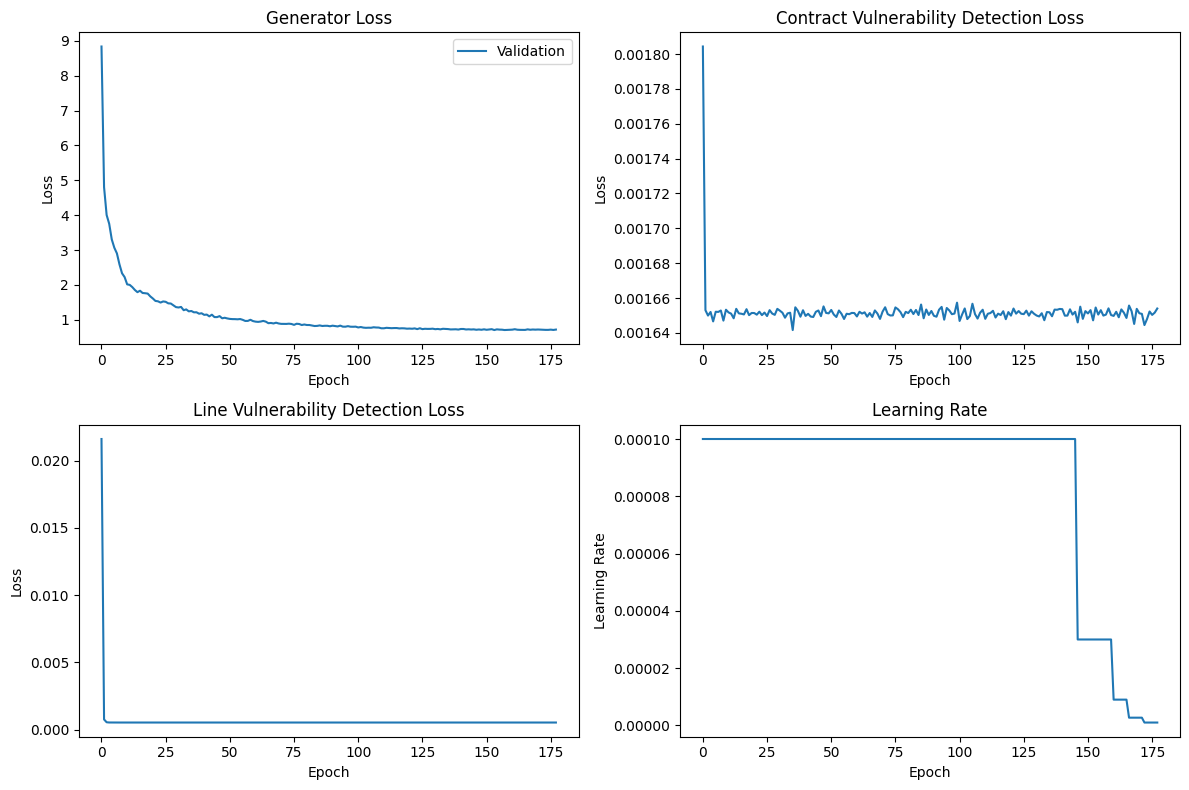

In [8]:
import matplotlib.pyplot as plt

# Plot training history
plt.figure(figsize=(12, 8))

# Plot generator loss
plt.subplot(2, 2, 1)
#plt.plot(trainer.training_history['train_loss'], label='Train')
plt.plot(trainer.training_history['val_loss'], label='Validation')
plt.title('Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot vulnerability loss
plt.subplot(2, 2, 2)
plt.plot(trainer.training_history['contract_vuln_loss'])
plt.title('Contract Vulnerability Detection Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot synthetic loss
plt.subplot(2, 2, 3)
plt.plot(trainer.training_history['line_vuln_loss'])
plt.title('Line Vulnerability Detection Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Plot learning rate
plt.subplot(2, 2, 4)
plt.plot(trainer.training_history['learning_rate'])
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')

plt.tight_layout()
plt.show()

In [16]:
# Load checkpoint
checkpoint_path = os.path.join(checkpoint_dir, 'checkpoint_epoch_20_model_v3.pt')  # Change this to your checkpoint file
checkpoint = torch.load(checkpoint_path)

# Load model states
model.load_state_dict(checkpoint['model_state_dict'])
model.generator.load_state_dict(checkpoint['generator_state_dict'])
model.discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
model.decoder.load_state_dict(checkpoint['decoder_state_dict'])

# Load optimizer states
trainer.optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
trainer.optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])
trainer.optimizer_decoder.load_state_dict(checkpoint['optimizer_decoder_state_dict'])

# Get the epoch to start from and best validation loss
start_epoch = checkpoint['epoch']
best_val_loss = checkpoint['val_loss']

print(f"Loaded checkpoint from epoch {start_epoch + 1}")
print(f"Previous validation loss: {best_val_loss:.4f}")

Loaded checkpoint from epoch 20
Previous validation loss: 0.0070


In [ ]:
# Training loop - start from the next epoch
num_epochs = 120

for epoch in range(start_epoch + 1, num_epochs):  # Start from the next epoch
    # Start timer for this epoch
    epoch_start_time = time.time()
    
    # Training
    g_loss, d_loss, decoder_loss = trainer.train_epoch()
    val_loss = trainer.validate()
    
    # Calculate epoch time
    epoch_time = time.time() - epoch_start_time
    
    # Print training progress
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Generator Loss: {g_loss:.4f}")
    print(f"Discriminator Loss: {d_loss:.4f}")
    print(f"Decoder Loss: {decoder_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Epoch Time: {epoch_time:.2f}s")
    
    # Save model checkpoint
    if (epoch + 1) % 10 == 0:
        checkpoint = {
            # Model states
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'generator_state_dict': model.generator.state_dict(),
            'discriminator_state_dict': model.discriminator.state_dict(),
            'decoder_state_dict': model.decoder.state_dict(),
            
            # Optimizer states
            'optimizer_G_state_dict': trainer.optimizer_G.state_dict(),
            'optimizer_D_state_dict': trainer.optimizer_D.state_dict(),
            'optimizer_decoder_state_dict': trainer.optimizer_decoder.state_dict(),
            
            # Loss values
            'g_loss': g_loss,
            'd_loss': d_loss,
            'decoder_loss': decoder_loss,
            'val_loss': val_loss,
            
            # Model configuration
            'model_config': {
                'vocab_size': model.decoder.vocab_size,
                'max_length': model.decoder.max_length
            },
            
            # Training metadata
            'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            'epoch_time': epoch_time
        }
        
        # Save regular checkpoint
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}_model_v3.pt')
        torch.save(checkpoint, checkpoint_path)
        print(f"Saved checkpoint for epoch {epoch+1}")
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_path = os.path.join(checkpoint_dir, 'best_model_v3.pt')
            torch.save(checkpoint, best_model_path)
            print(f"New best model saved with validation loss: {val_loss:.4f}")

print("\nTraining completed!")
print(f"Best validation loss: {best_val_loss:.4f}")


Starting training epoch...


In [ ]:
print('Done')

NOTES:

1. Input Processing:
Initial input: [32, 512] (batch_size=32, sequence_length=512)
After embedding: [32, 512, 512] (batch_size=32, sequence_length=512, embedding_dim=512)
This is correct because the embedding layer converts each token to a 512-dimensional vector

2. Path Embeddings Processing:
Initial path embeddings: [32, 768] (batch_size=32, code2vec_dim=768)
After path embedding layer: [32, 512] (batch_size=32, transformer_dim=512)
The linear layer converts from code2vec's 768 dimensions to transformer's 512 dimensions
After expansion: [32, 512, 512] (batch_size=32, sequence_length=512, transformer_dim=512)
The path embeddings are expanded to match the sequence length

3. Final Shape:
[32, 512, 512] (batch_size=32, sequence_length=512, transformer_dim=512)
This is the correct shape for the transformer layers


In [15]:
checkpoint = {
    # Model states
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'generator_state_dict': model.generator.state_dict(),
    'discriminator_state_dict': model.discriminator.state_dict(),
    'decoder_state_dict': model.decoder.state_dict(),
    
    # Optimizer states
    'optimizer_G_state_dict': trainer.optimizer_G.state_dict(),
    'optimizer_D_state_dict': trainer.optimizer_D.state_dict(),
    'optimizer_decoder_state_dict': trainer.optimizer_decoder.state_dict(),
    
    # Loss values
    'g_loss': g_loss,
    'd_loss': d_loss,
    'decoder_loss': decoder_loss,
    'val_loss': val_loss,
    
    # Model configuration
    'model_config': {
        #'d_model': model.d_model,
        'vocab_size': model.decoder.vocab_size,
        'max_length': model.decoder.max_length
    },
    
    # Training metadata
    'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    'epoch_time': epoch_time
}

# Save regular checkpoint
checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}_model_v3.pt')
torch.save(checkpoint, checkpoint_path)
print(f"Saved checkpoint for epoch {epoch+1}")

Saved checkpoint for epoch 10


In [9]:
print(f"Epoch [{epoch}/{num_epochs}]")
print(f"Generator Loss: {g_loss:.4f}")
print(f"Discriminator Loss: {d_loss:.4f}")
print(f"Validation Loss: {val_loss:.4f}")

NameError: name 'epoch' is not defined

## Save model:

In [ ]:
torch.save({
    'epoch': 100,
    'model_state_dict': model.state_dict(),
    #'optimizer_G_state_dict': trainer.optimizer_G.state_dict(),
    #'optimizer_D_state_dict': trainer.optimizer_D.state_dict(),
    'gen_loss': model.gen_loss,
    'synth_loss': model.synth_loss,
    'vul_loss': model.vul_loss,
    'val_loss': model.val_loss,
    'model_config': {
        'd_model': 768,
    }
}, 'final_model_v1_512.pt')

In [21]:
# After training loop
# Save the final model and training state


# If you want to save just the model for inference
torch.save(model.state_dict(), 'model_weights_v1_512.pt')

# If you want to save the entire model
torch.save(model, 'full_model_v1_512.pt')

In [16]:
# Save model with additional information
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_G_state_dict': trainer.optimizer_G.state_dict(),
    'optimizer_D_state_dict': trainer.optimizer_D.state_dict(),
    'g_loss': g_loss,
    'd_loss': d_loss,
    'val_loss': val_loss,
    'model_config': {
        'd_model': 768
    },
    'training_config': {
        'learning_rate': 0.0002,
        'beta1': 0.5,
        'batch_size': 32
    },
    'training_history': {
        'g_losses': g_loss,  # List of generator losses
        'd_losses': d_loss,  # List of discriminator losses
        'val_losses': val_loss  # List of validation losses
    }
}, 'final_model_v4_with_history.pt')

# Load Model:

In [10]:
# Load the full training state
checkpoint = torch.load('final_model_v4.pt')
model = SmartContractVulnerabilityGAN(**checkpoint['model_config'])
model.load_state_dict(checkpoint['model_state_dict'])
model = model.cuda() 

# Initialize trainer with loaded model
trainer = VulnerabilityDetectionTrainer(
    model,
    train_dataloader,
    val_dataloader
)

# Load optimizer states if needed
trainer.optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
trainer.optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])


In [21]:
# Or if you just want to load the model weights
model = SmartContractVulnerabilityGAN(d_model=768)
model.load_state_dict(torch.load('model_weights.pt'))
model = model.cuda()  # Move to GPU if needed


In [ ]:
# Or if you saved the entire model
model = torch.load('full_model.pt')
model = model.cuda()  # Move to GPU if needed

## Model Exploration:

In [10]:
print("Type of model:", type(model))

# If it's a SmartContractVulnerabilityGAN object, we can inspect its components directly
print("\nModel Components:")
print("-" * 50)

# Print model attributes
print("\nModel Attributes:")
for attr in dir(model):
    if not attr.startswith('_'):  # Skip private attributes
        print(f"- {attr}")

# Print model structure
print("\nModel Structure:")
print(model)


Type of model: <class 'model.SmartContractTransformer'>

Model Components:
--------------------------------------------------

Model Attributes:
- T_destination
- add_module
- apply
- ast_attention
- ast_embedding
- ast_embedding_dropout
- ast_embedding_norm
- bfloat16
- buffers
- call_super_init
- children
- compile
- contract_feature_aggregation
- contract_vuln_attention
- contract_vulnerability_head
- cpu
- cross_attention
- cuda
- d_model
- decoder
- disc_feature_extractor
- disc_grammar_embedding
- disc_grammar_projection
- disc_path_attention
- disc_synthetic_head
- discriminator_forward
- double
- dump_patches
- embedding
- embedding_dropout
- embedding_norm
- encoder
- eval
- extra_repr
- feature_fusion
- float
- forward
- generate_square_subsequent_mask
- generate_with_beam_search
- get_buffer
- get_extra_state
- get_parameter
- get_submodule
- half
- hook_fn
- ipu
- line_feature_extractor
- line_vuln_attention
- line_vulnerability_head_1
- load_state_dict
- max_length
- modul

In [11]:
print("\nModel State Dict:")
for key in model.state_dict().keys():
    print(f"- {key}")


Model State Dict:
- embedding.weight
- embedding_norm.weight
- embedding_norm.bias
- pos_encoder.pe
- ast_embedding.weight
- ast_embedding_norm.weight
- ast_embedding_norm.bias
- path_embedding.weight
- encoder.layers.0.self_attn.in_proj_weight
- encoder.layers.0.self_attn.in_proj_bias
- encoder.layers.0.self_attn.out_proj.weight
- encoder.layers.0.self_attn.out_proj.bias
- encoder.layers.0.linear1.weight
- encoder.layers.0.linear1.bias
- encoder.layers.0.linear2.weight
- encoder.layers.0.linear2.bias
- encoder.layers.0.norm1.weight
- encoder.layers.0.norm1.bias
- encoder.layers.0.norm2.weight
- encoder.layers.0.norm2.bias
- encoder.layers.1.self_attn.in_proj_weight
- encoder.layers.1.self_attn.in_proj_bias
- encoder.layers.1.self_attn.out_proj.weight
- encoder.layers.1.self_attn.out_proj.bias
- encoder.layers.1.linear1.weight
- encoder.layers.1.linear1.bias
- encoder.layers.1.linear2.weight
- encoder.layers.1.linear2.bias
- encoder.layers.1.norm1.weight
- encoder.layers.1.norm1.bias


In [12]:
print("\nParameter Shapes:")
for name, param in model.named_parameters():
    print(f"- {name}: {param.shape}")


Parameter Shapes:
- embedding.weight: torch.Size([50265, 768])
- embedding_norm.weight: torch.Size([768])
- embedding_norm.bias: torch.Size([768])
- ast_embedding.weight: torch.Size([50265, 768])
- ast_embedding_norm.weight: torch.Size([768])
- ast_embedding_norm.bias: torch.Size([768])
- encoder.layers.0.self_attn.in_proj_weight: torch.Size([2304, 768])
- encoder.layers.0.self_attn.in_proj_bias: torch.Size([2304])
- encoder.layers.0.self_attn.out_proj.weight: torch.Size([768, 768])
- encoder.layers.0.self_attn.out_proj.bias: torch.Size([768])
- encoder.layers.0.linear1.weight: torch.Size([2048, 768])
- encoder.layers.0.linear1.bias: torch.Size([2048])
- encoder.layers.0.linear2.weight: torch.Size([768, 2048])
- encoder.layers.0.linear2.bias: torch.Size([768])
- encoder.layers.0.norm1.weight: torch.Size([768])
- encoder.layers.0.norm1.bias: torch.Size([768])
- encoder.layers.0.norm2.weight: torch.Size([768])
- encoder.layers.0.norm2.bias: torch.Size([768])
- encoder.layers.1.self_attn

In [13]:
print("\nModel Configuration:")
print(f"- d_model: {model.d_model if hasattr(model, 'd_model') else 'N/A'}")
print(f"- vocab_size: {model.decoder.vocab_size if hasattr(model, 'decoder') else 'N/A'}")
print(f"- max_length: {model.decoder.max_length if hasattr(model, 'decoder') else 'N/A'}")


Model Configuration:
- d_model: 768


AttributeError: 'TransformerDecoder' object has no attribute 'vocab_size'

In [14]:
if hasattr(model, 'generator'):
    print("\nGenerator Architecture:")
    print(model.CodeDecoder)

### This is a GAN (Generative Adversarial Network) combined with a Transformer architecture for smart contract vulnerability detection.

#### Here's the technical breakdown:
#### 1. Architecture Components:
-Transformer Encoder: Processes smart contract code using self-attention
-Generator: Creates synthetic vulnerable code patterns
-Discriminator: Distinguishes between real and synthetic vulnerabilities

#### 2. Input Processing:
-Takes smart contract code and its AST (Abstract Syntax Tree) paths
-Uses CodeBERT to generate embeddings (768-dimensional vectors)
-Processes both contract code and path information

#### 3. Training Process:
3.1. Generator Training:
-Takes random noise and contract embeddings
-Generates synthetic vulnerable code patterns
-Tries to fool the discriminator

3.2. Discriminator Training:
-Takes real contract embeddings and generator outputs
-Learns to distinguish real from synthetic vulnerabilities
-Uses binary classification (real/fake)

#### 4. Output:
-Vulnerability scores for input contracts
-Synthetic vulnerable code patterns for training
-Binary classification of real vs. synthetic vulnerabilities

#### The model essentially learns to:
-Understand code patterns through the transformer
-Generate realistic vulnerable code examples
-Detect vulnerabilities in real contracts
-Improve detection through adversarial training

#### This approach combines the strengths of:
Transformers for code understanding
GANs for synthetic data generation
Binary classification for vulnerability detection

# 3. Usage:

In [15]:
# For a single contract
results = trainer.predict(validation_dataset[0])  # Pass a single contract's data

print(f"Vulnerability Score: {results['vulnerability_score']:.4f}")
print(f"Synthetic Score: {results['synthetic_score']:.4f}")
print(f"Is Vulnerable: {results['is_vulnerable']}")
print(f"Is Synthetic: {results['is_synthetic']}")

AttributeError: 'SmartContractTrainer' object has no attribute 'predict'

In [44]:
import torch
from model import SmartContractTransformer
from train import Discriminator

def load_trained_model(checkpoint_path, device='cuda:1'):
    """
    Load the trained model and discriminator from checkpoint
    """
    # Initialize model and discriminator
    model = SmartContractTransformer()
    discriminator = Discriminator()
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # Load state dicts
    model.load_state_dict(checkpoint['model_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    
    # Move to device
    model = model.to(device)
    discriminator = discriminator.to(device)
    
    # Set to eval mode
    model.eval()
    discriminator.eval()
    
    return model, discriminator

def analyze_contract(contract_data, model, discriminator, tokenizer=None, device='cuda:1'):
    """
    Analyze a smart contract for vulnerabilities and generate synthetic version
    """
    # Move input data to device
    input_ids = contract_data['input_ids'].unsqueeze(0).to(device)
    attention_mask = contract_data['attention_mask'].unsqueeze(0).to(device)
    path_input_ids = contract_data['path_input_ids'].unsqueeze(0).to(device)
    path_attention_mask = contract_data['path_attention_mask'].unsqueeze(0).to(device)
    
    # Decode original contract if tokenizer is provided
    original_text = None
    if tokenizer is not None:
        original_text = tokenizer.decode(input_ids[0].cpu().tolist())
    
    with torch.no_grad():
        # Get vulnerability score
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            path_input_ids=path_input_ids,
            path_attention_mask=path_attention_mask,
            target_ids=None
        )
        
        # Get discriminator predictions
        vuln_pred, synth_pred = discriminator(outputs['encoder_output'])
        vulnerability_score = torch.sigmoid(vuln_pred).item()
        synthetic_score = torch.sigmoid(synth_pred).item()
        
        result = {
            'vulnerability_score': vulnerability_score,
            'synthetic_score': synthetic_score,
            'is_vulnerable': vulnerability_score > 0.5,
            'is_synthetic': synthetic_score > 0.5,
            'original_contract': {
                'text': original_text,
                'input_ids': input_ids[0].cpu().tolist()
            }
        }
        
        # Generate synthetic contract
        synthetic_outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            path_input_ids=path_input_ids,
            path_attention_mask=path_attention_mask,
            target_ids=None
        )
        
        # Get the generated sequence
        generated_sequence = synthetic_outputs['generated_sequence']
        
        # Get discriminator predictions for synthetic contract
        synth_vuln_pred, synth_synth_pred = discriminator(synthetic_outputs['encoder_output'])
        synth_vulnerability_score = torch.sigmoid(synth_vuln_pred).item()
        synth_synthetic_score = torch.sigmoid(synth_synth_pred).item()
        
        result['synthetic_contract'] = {
            'sequence': generated_sequence[0].cpu().tolist(),
            'vulnerability_score': synth_vulnerability_score,
            'synthetic_score': synth_synthetic_score,
            'is_vulnerable': synth_vulnerability_score > 0.5,
            'is_synthetic': synth_synthetic_score > 0.5
        }
        
        # If tokenizer is provided, decode the synthetic contract
        if tokenizer is not None:
            synthetic_tokens = result['synthetic_contract']['sequence']
            result['synthetic_contract']['text'] = tokenizer.decode(synthetic_tokens)
        
        return result


In [45]:
# Load the trained model
checkpoint_path = 'checkpoints_v1/latest_model.pt'  # or 'best_model_epoch_X.pt'
model_loaded, discriminator = load_trained_model(checkpoint_path)

In [58]:
contract_data = val_dataset[9]

In [59]:
# Analyze the contract
results = analyze_contract(contract_data, model_loaded, discriminator, tokenizer)

# Print results
print("\nContract Analysis Results:")
print("-" * 50)
print(f"Vulnerability Score: {results['vulnerability_score']:.4f}")
print(f"Synthetic Score: {results['synthetic_score']:.4f}")
print(f"Vulnerability Status: {'Vulnerable' if results['is_vulnerable'] else 'Safe'}")
print(f"Synthetic Status: {'Synthetic' if results['is_synthetic'] else 'Real'}")

# Print original contract
if results['original_contract']['text']:
    print("\nOriginal Contract:")
    print("-" * 50)
    print(results['original_contract']['text'])
    

print("\nSynthetic Contract Analysis:")
print("-" * 50)
print(f"Vulnerability Score: {results['synthetic_contract']['vulnerability_score']:.4f}")
print(f"Synthetic Score: {results['synthetic_contract']['synthetic_score']:.4f}")
print(f"Vulnerability Status: {'Vulnerable' if results['synthetic_contract']['is_vulnerable'] else 'Safe'}")
print(f"Synthetic Status: {'Synthetic' if results['synthetic_contract']['is_synthetic'] else 'Real'}")

if 'text' in results['synthetic_contract']:
    print("\nGenerated Synthetic Contract:")
    print("-" * 50)
    print(results['synthetic_contract']['text'])


Contract Analysis Results:
--------------------------------------------------
Vulnerability Score: 0.0151
Synthetic Score: 0.7673
Vulnerability Status: Safe
Synthetic Status: Synthetic

Original Contract:
--------------------------------------------------
<s>/**
 *Submitted for verification at Etherscan.io on 2020-11-22
*/

// SPDX-License-Identifier: MIT + WTFPL
// File: contracts/uniswapv2/interfaces/IUniswapV2Factory.sol

pragma solidity >=0.5.0;

interface IUniswapV2Factory {
    event PairCreated(address indexed token0, address indexed token1, address pair, uint);

    function feeTo() external view returns (address);
    function feeToSetter() external view returns (address);
    function migrator() external view returns (address);

    function getPair(address tokenA, address tokenB) external view returns (address pair);
    function allPairs(uint) external view returns (address pair);
    function allPairsLength() external view returns (uint);

    function createPair(address 